In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17483, done.
remote: Total 17483 (delta 0), reused 0 (delta 0), pack-reused 17483 (from 1)
Receiving objects: 100% (17483/17483), 16.58 MiB | 16.80 MiB/s, done.
Resolving deltas: 100% (11991/11991), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━

In [ ]:
!pip install torchvision matplotlib

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tqdm
import zipfile
from tqdm import tqdm
import os

zip_path = '/content/drive/MyDrive/frames.zip'
extract_path = '/content/frames2'

# Mở file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()                 # Lấy danh sách file trong zip
    print(f"Tổng số file cần giải nén: {len(file_list)}")

    # Tạo thư mục đích nếu chưa có
    os.makedirs(extract_path, exist_ok=True)

    # Giải nén từng file với tqdm hiển thị tiến trình
    for file in tqdm(file_list, desc="Đang giải nén", unit="file"):
        zip_ref.extract(member=file, path=extract_path)

print("Giải nén hoàn tất!")


Tổng số file cần giải nén: 44220


Đang giải nén: 100%|██████████| 44220/44220 [02:16<00:00, 324.37file/s]

Giải nén hoàn tất!


In [ ]:
# Kiểm tra nội dung giải nén
import os
os.listdir(extract_path)


['frames']

In [ ]:
data_dir = '/content/frames2'

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # resize ảnh cho CNN xử lý dễ hơn
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
# Kiểm tra device
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: False
Device: CPU


In [ ]:

!pip install torch torchvision pillow pandas matplotlib tqdm scikit-learn

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import sys

# Kiểm tra device
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Dataset
class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        if not os.path.exists(root_dir):
            raise ValueError(f"Thư mục {root_dir} không tồn tại!")

        for label_type, label in [('real', 0), ('fake', 1)]:
            class_dir = os.path.join(root_dir, label_type)
            if not os.path.exists(class_dir):
                continue
            for subdir, _, files in os.walk(class_dir):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(subdir, file))
                        self.labels.append(label)

        if len(self.image_paths) == 0:
            raise ValueError("Không tìm thấy ảnh nào trong thư mục real/ hoặc fake/!")

        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx >= len(self.image_paths):
            raise IndexError(f"Index {idx} ngoài phạm vi dataset")
        try:
            img_path = self.image_paths[idx]
            label = self.labels[idx]
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            return None, None

# Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 32 * 32, 2)  # Cho ảnh 64x64

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Hàm huấn luyện
def train_model(data_dir, epochs=5, batch_size=8, learning_rate=1e-3):
    try:
        # Load dataset
        dataset = DeepfakeDataset(data_dir)

        # DataLoader
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Model, loss, optimizer
        device = torch.device("cpu")  # Dùng CPU vì CUDA không khả dụng
        model = CNNModel().to(device)
        print("Model initialized")

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        model.train()
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            for images, labels in tqdm(loader, desc="Training"):
                if images is None or labels is None:
                    print("Skipping invalid batch")
                    continue
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                print(f"Loss: {loss.item()}", flush=True)
                sys.stdout.flush()

        print("Training completed")
        return model
    except Exception as e:
        print(f"Error: {e}")
        return None


if __name__ == "__main__":
    data_dir = "/content/frames2/frames"
    print("Starting execution...")
    model = train_model(data_dir, epochs=5, batch_size=8, learning_rate=1e-3)
    if model:
        print("Model trained successfully")
        torch.save(model.state_dict(), "cnn_deepfake_detector.pt")
        print("Model saved to cnn_deepfake_detector.pt")
    else:
        print("Training failed. Check error messages above.")


CUDA available: False
Device: CPU
Starting execution...
Model initialized

Epoch 1/5


Training:   0%|          | 0/5278 [00:00<?, ?it/s]

Loss: 0.6783732771873474


Training:   0%|          | 1/5278 [00:00<10:07,  8.68it/s]

Loss: 2.081286907196045


Training:   0%|          | 2/5278 [00:00<11:29,  7.65it/s]

Loss: 0.8703165650367737
Loss: 0.6865711212158203


Training:   0%|          | 4/5278 [00:00<10:15,  8.56it/s]

Loss: 0.7234179973602295
Loss: 0.995659351348877


Training:   0%|          | 6/5278 [00:00<09:36,  9.14it/s]

Loss: 0.45775753259658813
Loss: 0.9479883909225464


Training:   0%|          | 8/5278 [00:00<08:47, 10.00it/s]

Loss: 1.0317072868347168
Loss: 0.671669065952301


Training:   0%|          | 10/5278 [00:01<08:00, 10.95it/s]

Loss: 1.138920783996582
Loss: 0.5782297253608704


Training:   0%|          | 12/5278 [00:01<08:20, 10.53it/s]

Loss: 0.8108675479888916
Loss: 0.6754013895988464


Training:   0%|          | 14/5278 [00:01<08:41, 10.09it/s]

Loss: 1.0299185514450073
Loss: 1.042362928390503


Training:   0%|          | 16/5278 [00:01<08:34, 10.24it/s]

Loss: 0.7789817452430725
Loss: 0.7861011624336243


Training:   0%|          | 18/5278 [00:01<08:28, 10.34it/s]

Loss: 1.0493733882904053
Loss: 0.6145027279853821


Training:   0%|          | 20/5278 [00:01<08:30, 10.30it/s]

Loss: 0.7999112606048584
Loss: 0.6791027784347534


Training:   0%|          | 22/5278 [00:02<08:49,  9.93it/s]

Loss: 0.86214679479599
Loss: 0.7299946546554565


Training:   0%|          | 24/5278 [00:02<08:29, 10.32it/s]

Loss: 0.7223708033561707
Loss: 0.7409509420394897


Training:   0%|          | 26/5278 [00:02<09:03,  9.67it/s]

Loss: 1.0228638648986816


Training:   1%|          | 27/5278 [00:02<09:21,  9.35it/s]

Loss: 0.8340883851051331
Loss: 0.5109326243400574


Training:   1%|          | 29/5278 [00:02<08:29, 10.31it/s]

Loss: 0.7664158344268799
Loss: 1.7387795448303223


Training:   1%|          | 31/5278 [00:03<08:42, 10.05it/s]

Loss: 0.5940418243408203
Loss: 1.489554524421692


Training:   1%|          | 33/5278 [00:03<10:02,  8.71it/s]

Loss: 1.0182934999465942


Training:   1%|          | 34/5278 [00:03<10:15,  8.51it/s]

Loss: 0.5790157318115234


Training:   1%|          | 35/5278 [00:03<10:42,  8.17it/s]

Loss: 0.6463883519172668


Training:   1%|          | 36/5278 [00:03<11:11,  7.81it/s]

Loss: 0.6931860446929932


Training:   1%|          | 37/5278 [00:03<11:03,  7.90it/s]

Loss: 0.8217403292655945


Training:   1%|          | 38/5278 [00:04<11:09,  7.82it/s]

Loss: 0.6106422543525696


Training:   1%|          | 39/5278 [00:04<13:48,  6.32it/s]

Loss: 0.946429967880249


Training:   1%|          | 40/5278 [00:04<12:35,  6.93it/s]

Loss: 0.6377049088478088


Training:   1%|          | 41/5278 [00:04<12:03,  7.24it/s]

Loss: 0.7628671526908875


Training:   1%|          | 42/5278 [00:04<11:47,  7.40it/s]

Loss: 0.7766337990760803
Loss: 0.7708626389503479


Training:   1%|          | 44/5278 [00:04<10:57,  7.96it/s]

Loss: 0.7209304571151733


Training:   1%|          | 45/5278 [00:05<12:59,  6.71it/s]

Loss: 0.6942363977432251


Training:   1%|          | 46/5278 [00:05<13:08,  6.64it/s]

Loss: 0.549048900604248


Training:   1%|          | 47/5278 [00:05<12:48,  6.81it/s]

Loss: 0.9308704137802124


Training:   1%|          | 48/5278 [00:05<13:01,  6.69it/s]

Loss: 0.957633376121521


Training:   1%|          | 49/5278 [00:05<12:08,  7.17it/s]

Loss: 0.7908490300178528


Training:   1%|          | 50/5278 [00:05<12:10,  7.16it/s]

Loss: 0.599331259727478


Training:   1%|          | 51/5278 [00:05<11:14,  7.74it/s]

Loss: 0.7188625335693359


Training:   1%|          | 52/5278 [00:06<13:21,  6.52it/s]

Loss: 0.801413357257843


Training:   1%|          | 53/5278 [00:06<12:32,  6.94it/s]

Loss: 0.6679407954216003


Training:   1%|          | 54/5278 [00:06<12:52,  6.76it/s]

Loss: 0.6392399072647095


Training:   1%|          | 55/5278 [00:06<12:08,  7.17it/s]

Loss: 0.6415997743606567


Training:   1%|          | 56/5278 [00:06<12:16,  7.09it/s]

Loss: 0.8193452954292297


Training:   1%|          | 57/5278 [00:06<12:48,  6.79it/s]

Loss: 0.671272337436676


Training:   1%|          | 58/5278 [00:06<12:04,  7.21it/s]

Loss: 0.7236546277999878
Loss: 0.6239705085754395


Training:   1%|          | 60/5278 [00:07<11:08,  7.80it/s]

Loss: 0.6026460528373718


Training:   1%|          | 61/5278 [00:07<10:55,  7.95it/s]

Loss: 0.769440770149231
Loss: 0.6950969696044922


Training:   1%|          | 63/5278 [00:07<09:04,  9.58it/s]

Loss: 0.5858160853385925
Loss: 0.732707679271698


Training:   1%|          | 65/5278 [00:07<08:56,  9.72it/s]

Loss: 0.7075262069702148
Loss: 0.6945213675498962


Training:   1%|▏         | 67/5278 [00:07<08:09, 10.65it/s]

Loss: 0.6462087631225586
Loss: 0.7964633107185364


Training:   1%|▏         | 69/5278 [00:07<07:53, 11.00it/s]

Loss: 0.6453720927238464
Loss: 0.7484877109527588


Training:   1%|▏         | 71/5278 [00:08<08:22, 10.35it/s]

Loss: 0.7130429744720459
Loss: 0.6730844378471375


Training:   1%|▏         | 73/5278 [00:08<08:01, 10.81it/s]

Loss: 0.7463860511779785
Loss: 0.6929748058319092


Training:   1%|▏         | 75/5278 [00:08<08:06, 10.69it/s]

Loss: 0.7500699162483215
Loss: 0.8497606515884399


Training:   1%|▏         | 77/5278 [00:08<08:16, 10.47it/s]

Loss: 0.6549367308616638
Loss: 0.7908423542976379


Training:   1%|▏         | 79/5278 [00:08<08:01, 10.81it/s]

Loss: 0.8034295439720154
Loss: 0.6587220430374146


Training:   2%|▏         | 81/5278 [00:09<07:53, 10.97it/s]

Loss: 0.723208487033844
Loss: 0.6886725425720215


Training:   2%|▏         | 83/5278 [00:09<08:05, 10.70it/s]

Loss: 0.7482097744941711
Loss: 0.6813406348228455


Training:   2%|▏         | 85/5278 [00:09<08:12, 10.55it/s]

Loss: 0.7369852066040039
Loss: 0.7635292410850525


Training:   2%|▏         | 87/5278 [00:09<08:29, 10.19it/s]

Loss: 0.7504990696907043
Loss: 0.7014000415802002


Training:   2%|▏         | 89/5278 [00:09<08:26, 10.24it/s]

Loss: 0.7061281800270081
Loss: 0.6935684680938721


Training:   2%|▏         | 91/5278 [00:10<09:05,  9.51it/s]

Loss: 0.6660653352737427


Training:   2%|▏         | 92/5278 [00:10<09:03,  9.55it/s]

Loss: 0.6468348503112793


Training:   2%|▏         | 93/5278 [00:10<09:10,  9.42it/s]

Loss: 0.6809967756271362
Loss: 0.851607084274292


Training:   2%|▏         | 95/5278 [00:10<08:37, 10.02it/s]

Loss: 0.7671929597854614
Loss: 0.7001987099647522


Training:   2%|▏         | 97/5278 [00:10<09:11,  9.39it/s]

Loss: 0.6448566913604736


Training:   2%|▏         | 98/5278 [00:10<09:23,  9.19it/s]

Loss: 0.7572017312049866
Loss: 0.6277962327003479


Training:   2%|▏         | 100/5278 [00:11<09:12,  9.37it/s]

Loss: 0.63764488697052
Loss: 0.6937320828437805


Training:   2%|▏         | 102/5278 [00:11<08:31, 10.11it/s]

Loss: 0.6496517062187195
Loss: 0.6807770729064941


Training:   2%|▏         | 104/5278 [00:11<08:32, 10.09it/s]

Loss: 0.7071560621261597
Loss: 0.7364770174026489


Training:   2%|▏         | 106/5278 [00:11<08:29, 10.15it/s]

Loss: 0.639117419719696
Loss: 0.7202237248420715


Training:   2%|▏         | 108/5278 [00:11<09:46,  8.82it/s]

Loss: 0.7268878221511841
Loss: 0.6246328353881836


Training:   2%|▏         | 110/5278 [00:12<09:17,  9.27it/s]

Loss: 0.7020754218101501
Loss: 0.7247196435928345


Training:   2%|▏         | 112/5278 [00:12<08:33, 10.05it/s]

Loss: 0.8322025537490845
Loss: 0.9169901013374329


Training:   2%|▏         | 114/5278 [00:12<08:30, 10.12it/s]

Loss: 0.633933424949646
Loss: 0.7115480899810791


Training:   2%|▏         | 116/5278 [00:12<08:17, 10.37it/s]

Loss: 0.7952088117599487
Loss: 0.6291186213493347


Training:   2%|▏         | 118/5278 [00:12<09:05,  9.46it/s]

Loss: 0.7227779030799866
Loss: 0.6128532886505127


Training:   2%|▏         | 120/5278 [00:13<08:45,  9.82it/s]

Loss: 0.6640438437461853
Loss: 0.6987564563751221


Training:   2%|▏         | 122/5278 [00:13<08:57,  9.58it/s]

Loss: 0.644102931022644
Loss: 0.7600080966949463


Training:   2%|▏         | 124/5278 [00:13<08:28, 10.13it/s]

Loss: 0.6643463969230652
Loss: 0.7899042367935181


Training:   2%|▏         | 126/5278 [00:13<08:43,  9.84it/s]

Loss: 0.7298972010612488
Loss: 0.6778388023376465


Training:   2%|▏         | 128/5278 [00:13<08:32, 10.04it/s]

Loss: 0.6844332218170166
Loss: 0.6974503397941589


Training:   2%|▏         | 130/5278 [00:14<09:00,  9.52it/s]

Loss: 0.7194874286651611
Loss: 0.6862744092941284


Training:   3%|▎         | 132/5278 [00:14<09:00,  9.52it/s]

Loss: 0.6679311394691467
Loss: 0.695968508720398


Training:   3%|▎         | 134/5278 [00:14<08:15, 10.38it/s]

Loss: 0.7578731775283813
Loss: 0.6943670511245728


Training:   3%|▎         | 136/5278 [00:14<08:27, 10.13it/s]

Loss: 0.7445194125175476
Loss: 0.6850247979164124


Training:   3%|▎         | 138/5278 [00:14<08:04, 10.60it/s]

Loss: 0.7268131375312805
Loss: 0.6405715942382812


Training:   3%|▎         | 140/5278 [00:15<08:23, 10.20it/s]

Loss: 0.7080932855606079
Loss: 0.7244231104850769


Training:   3%|▎         | 142/5278 [00:15<08:20, 10.26it/s]

Loss: 0.7189642786979675
Loss: 0.7178043127059937


Training:   3%|▎         | 144/5278 [00:15<08:09, 10.48it/s]

Loss: 0.6778801679611206
Loss: 0.6967557072639465


Training:   3%|▎         | 146/5278 [00:15<07:35, 11.26it/s]

Loss: 0.7134098410606384
Loss: 0.6982729434967041


Training:   3%|▎         | 148/5278 [00:15<08:08, 10.51it/s]

Loss: 0.6990782022476196
Loss: 0.6768035292625427


Training:   3%|▎         | 150/5278 [00:16<08:59,  9.51it/s]

Loss: 0.7166834473609924


Training:   3%|▎         | 151/5278 [00:16<09:14,  9.24it/s]

Loss: 0.685887336730957
Loss: 0.680255115032196


Training:   3%|▎         | 153/5278 [00:16<08:39,  9.87it/s]

Loss: 0.7375530004501343


Training:   3%|▎         | 154/5278 [00:16<08:38,  9.88it/s]

Loss: 0.7080519199371338
Loss: 0.673888087272644


Training:   3%|▎         | 156/5278 [00:16<08:19, 10.24it/s]

Loss: 0.6845436096191406
Loss: 0.7130496501922607


Training:   3%|▎         | 158/5278 [00:16<08:01, 10.63it/s]

Loss: 0.7273321747779846
Loss: 0.7352533936500549


Training:   3%|▎         | 160/5278 [00:17<08:24, 10.15it/s]

Loss: 0.7478736639022827
Loss: 0.6927635073661804


Training:   3%|▎         | 162/5278 [00:17<08:43,  9.78it/s]

Loss: 0.6986868977546692


Training:   3%|▎         | 163/5278 [00:17<08:57,  9.52it/s]

Loss: 0.7766599655151367


Training:   3%|▎         | 164/5278 [00:17<09:29,  8.97it/s]

Loss: 0.7592641711235046


Training:   3%|▎         | 165/5278 [00:17<10:55,  7.80it/s]

Loss: 0.687930703163147


Training:   3%|▎         | 166/5278 [00:17<11:09,  7.63it/s]

Loss: 0.6947791576385498


Training:   3%|▎         | 167/5278 [00:18<12:03,  7.06it/s]

Loss: 0.7386206388473511


Training:   3%|▎         | 168/5278 [00:18<11:14,  7.57it/s]

Loss: 0.6887413859367371


Training:   3%|▎         | 169/5278 [00:18<11:39,  7.31it/s]

Loss: 0.6949515342712402


Training:   3%|▎         | 170/5278 [00:18<11:25,  7.45it/s]

Loss: 0.6584153175354004


Training:   3%|▎         | 171/5278 [00:18<11:22,  7.49it/s]

Loss: 0.6691214442253113


Training:   3%|▎         | 172/5278 [00:18<11:07,  7.65it/s]

Loss: 0.6987858414649963


Training:   3%|▎         | 173/5278 [00:18<12:24,  6.86it/s]

Loss: 0.6683372259140015


Training:   3%|▎         | 174/5278 [00:18<11:43,  7.26it/s]

Loss: 0.7233525514602661


Training:   3%|▎         | 175/5278 [00:19<12:12,  6.96it/s]

Loss: 0.6883246898651123


Training:   3%|▎         | 176/5278 [00:19<13:11,  6.45it/s]

Loss: 0.6580439805984497


Training:   3%|▎         | 177/5278 [00:19<14:13,  5.98it/s]

Loss: 0.6642003655433655


Training:   3%|▎         | 178/5278 [00:19<13:23,  6.35it/s]

Loss: 0.6673439741134644


Training:   3%|▎         | 179/5278 [00:19<15:26,  5.50it/s]

Loss: 0.6607913970947266


Training:   3%|▎         | 180/5278 [00:20<14:05,  6.03it/s]

Loss: 0.6606712937355042


Training:   3%|▎         | 181/5278 [00:20<15:00,  5.66it/s]

Loss: 0.7120323181152344


Training:   3%|▎         | 182/5278 [00:20<15:16,  5.56it/s]

Loss: 0.6615127921104431


Training:   3%|▎         | 183/5278 [00:20<14:12,  5.98it/s]

Loss: 0.5615883469581604


Training:   3%|▎         | 184/5278 [00:20<13:24,  6.33it/s]

Loss: 0.7173396944999695


Training:   4%|▎         | 185/5278 [00:20<13:39,  6.22it/s]

Loss: 0.6637279987335205


Training:   4%|▎         | 186/5278 [00:21<13:40,  6.21it/s]

Loss: 0.6572840213775635


Training:   4%|▎         | 187/5278 [00:21<13:49,  6.14it/s]

Loss: 0.7239948511123657


Training:   4%|▎         | 188/5278 [00:21<13:34,  6.25it/s]

Loss: 0.7164586186408997


Training:   4%|▎         | 189/5278 [00:21<13:14,  6.40it/s]

Loss: 0.7317823767662048
Loss: 0.5940754413604736


Training:   4%|▎         | 191/5278 [00:21<10:36,  7.99it/s]

Loss: 0.6510984897613525


Training:   4%|▎         | 192/5278 [00:21<10:37,  7.98it/s]

Loss: 0.7579196691513062


Training:   4%|▎         | 193/5278 [00:21<10:33,  8.03it/s]

Loss: 0.6661680936813354


Training:   4%|▎         | 194/5278 [00:22<10:27,  8.11it/s]

Loss: 0.7496393918991089


Training:   4%|▎         | 195/5278 [00:22<10:08,  8.35it/s]

Loss: 0.8050987720489502


Training:   4%|▎         | 196/5278 [00:22<10:20,  8.19it/s]

Loss: 0.8030984997749329


Training:   4%|▎         | 197/5278 [00:22<10:06,  8.38it/s]

Loss: 0.7238195538520813
Loss: 0.674255907535553


Training:   4%|▍         | 199/5278 [00:22<09:18,  9.09it/s]

Loss: 0.7660098671913147
Loss: 0.73567795753479


Training:   4%|▍         | 201/5278 [00:22<08:27, 10.00it/s]

Loss: 0.6184180974960327
Loss: 0.6941884160041809


Training:   4%|▍         | 203/5278 [00:23<09:14,  9.14it/s]

Loss: 0.6910510063171387
Loss: 0.7222809791564941


Training:   4%|▍         | 205/5278 [00:23<08:51,  9.55it/s]

Loss: 0.708527684211731
Loss: 0.6173911094665527


Training:   4%|▍         | 207/5278 [00:23<08:44,  9.67it/s]

Loss: 0.683404803276062
Loss: 0.6959283947944641


Training:   4%|▍         | 209/5278 [00:23<08:36,  9.82it/s]

Loss: 0.7446029186248779


Training:   4%|▍         | 210/5278 [00:23<08:43,  9.67it/s]

Loss: 0.6959941387176514


Training:   4%|▍         | 211/5278 [00:23<09:16,  9.10it/s]

Loss: 0.7210850119590759
Loss: 0.6640382409095764


Training:   4%|▍         | 213/5278 [00:24<08:45,  9.63it/s]

Loss: 0.6944278478622437
Loss: 0.7177884578704834


Training:   4%|▍         | 215/5278 [00:24<08:14, 10.23it/s]

Loss: 0.7424049377441406
Loss: 0.6690999269485474


Training:   4%|▍         | 217/5278 [00:24<08:04, 10.44it/s]

Loss: 0.7076749801635742
Loss: 0.6770638227462769


Training:   4%|▍         | 219/5278 [00:24<08:26,  9.99it/s]

Loss: 0.7087441682815552
Loss: 0.6841795444488525


Training:   4%|▍         | 221/5278 [00:24<08:27,  9.96it/s]

Loss: 0.6767627000808716
Loss: 0.6930317878723145


Training:   4%|▍         | 223/5278 [00:24<08:05, 10.41it/s]

Loss: 0.7219608426094055
Loss: 0.6565019488334656


Training:   4%|▍         | 225/5278 [00:25<07:53, 10.67it/s]

Loss: 0.7005549073219299
Loss: 0.7240058183670044


Training:   4%|▍         | 227/5278 [00:25<07:43, 10.89it/s]

Loss: 0.7014214992523193
Loss: 0.7637741565704346


Training:   4%|▍         | 229/5278 [00:25<07:51, 10.71it/s]

Loss: 0.753161609172821
Loss: 0.699898898601532


Training:   4%|▍         | 231/5278 [00:25<08:00, 10.50it/s]

Loss: 0.7141990065574646
Loss: 0.6930538415908813


Training:   4%|▍         | 233/5278 [00:25<07:41, 10.92it/s]

Loss: 0.6731782555580139
Loss: 0.7264509201049805


Training:   4%|▍         | 235/5278 [00:26<07:49, 10.73it/s]

Loss: 0.6951162815093994
Loss: 0.6628734469413757


Training:   4%|▍         | 237/5278 [00:26<08:16, 10.14it/s]

Loss: 0.6485803723335266
Loss: 0.6913662552833557


Training:   5%|▍         | 239/5278 [00:26<08:14, 10.18it/s]

Loss: 0.6797960996627808
Loss: 0.7104535102844238


Training:   5%|▍         | 241/5278 [00:26<08:23, 10.01it/s]

Loss: 0.6496145129203796
Loss: 0.7510539889335632


Training:   5%|▍         | 243/5278 [00:26<08:19, 10.09it/s]

Loss: 0.7131550908088684
Loss: 0.7374323010444641


Training:   5%|▍         | 245/5278 [00:27<08:30,  9.86it/s]

Loss: 0.7082405686378479
Loss: 0.699228048324585


Training:   5%|▍         | 247/5278 [00:27<08:14, 10.17it/s]

Loss: 0.6737664341926575
Loss: 0.7186030745506287


Training:   5%|▍         | 249/5278 [00:27<07:57, 10.54it/s]

Loss: 0.7050968408584595
Loss: 0.6505432724952698


Training:   5%|▍         | 251/5278 [00:27<08:42,  9.62it/s]

Loss: 0.6046299338340759
Loss: 0.6944308280944824


Training:   5%|▍         | 253/5278 [00:27<08:37,  9.71it/s]

Loss: 0.7403649687767029
Loss: 0.6605103015899658


Training:   5%|▍         | 255/5278 [00:28<08:55,  9.38it/s]

Loss: 0.7282874584197998


Training:   5%|▍         | 256/5278 [00:28<09:14,  9.06it/s]

Loss: 0.6981502771377563
Loss: 0.7707943320274353


Training:   5%|▍         | 258/5278 [00:28<08:46,  9.53it/s]

Loss: 0.8378875851631165
Loss: 0.6416339874267578


Training:   5%|▍         | 260/5278 [00:28<08:25,  9.93it/s]

Loss: 0.6903375387191772


Training:   5%|▍         | 261/5278 [00:28<09:09,  9.13it/s]

Loss: 0.7865979075431824
Loss: 0.7911763191223145


Training:   5%|▍         | 263/5278 [00:29<09:36,  8.70it/s]

Loss: 0.7851607799530029
Loss: 0.6602363586425781


Training:   5%|▌         | 265/5278 [00:29<08:33,  9.77it/s]

Loss: 0.6973788738250732


Training:   5%|▌         | 266/5278 [00:29<08:33,  9.77it/s]

Loss: 0.6583417654037476
Loss: 0.6879425048828125


Training:   5%|▌         | 268/5278 [00:29<08:20, 10.00it/s]

Loss: 0.7260324954986572
Loss: 0.6776994466781616


Training:   5%|▌         | 270/5278 [00:29<08:22,  9.96it/s]

Loss: 0.6816914081573486
Loss: 0.6665423512458801


Training:   5%|▌         | 272/5278 [00:29<08:28,  9.84it/s]

Loss: 0.7236105799674988


Training:   5%|▌         | 273/5278 [00:30<08:54,  9.37it/s]

Loss: 0.6799027323722839
Loss: 0.6478580236434937


Training:   5%|▌         | 275/5278 [00:30<08:30,  9.81it/s]

Loss: 0.6686806678771973
Loss: 0.6743356585502625


Training:   5%|▌         | 277/5278 [00:30<08:03, 10.34it/s]

Loss: 0.6442010402679443
Loss: 0.7454547882080078


Training:   5%|▌         | 279/5278 [00:30<07:50, 10.64it/s]

Loss: 0.691318690776825
Loss: 0.6970981359481812


Training:   5%|▌         | 281/5278 [00:30<07:53, 10.55it/s]

Loss: 0.7039520144462585
Loss: 0.7411597371101379


Training:   5%|▌         | 283/5278 [00:30<08:06, 10.26it/s]

Loss: 0.6846270561218262
Loss: 0.7196653485298157


Training:   5%|▌         | 285/5278 [00:31<08:41,  9.58it/s]

Loss: 0.6677476167678833
Loss: 0.6415241956710815


Training:   5%|▌         | 287/5278 [00:31<08:03, 10.33it/s]

Loss: 0.6965214610099792
Loss: 0.6831819415092468


Training:   5%|▌         | 289/5278 [00:31<08:33,  9.71it/s]

Loss: 0.6137288808822632


Training:   5%|▌         | 290/5278 [00:31<09:37,  8.63it/s]

Loss: 0.713914692401886


Training:   6%|▌         | 291/5278 [00:31<10:31,  7.90it/s]

Loss: 0.6558183431625366


Training:   6%|▌         | 292/5278 [00:32<11:46,  7.06it/s]

Loss: 0.6593258380889893


Training:   6%|▌         | 293/5278 [00:32<11:36,  7.15it/s]

Loss: 0.6756425499916077


Training:   6%|▌         | 294/5278 [00:32<10:52,  7.64it/s]

Loss: 0.7058234810829163


Training:   6%|▌         | 295/5278 [00:32<11:42,  7.09it/s]

Loss: 0.6536366939544678


Training:   6%|▌         | 296/5278 [00:32<12:19,  6.74it/s]

Loss: 0.7416279911994934


Training:   6%|▌         | 297/5278 [00:32<12:45,  6.50it/s]

Loss: 0.632977306842804


Training:   6%|▌         | 298/5278 [00:33<12:46,  6.50it/s]

Loss: 0.6354072093963623


Training:   6%|▌         | 299/5278 [00:33<12:03,  6.89it/s]

Loss: 0.7535544037818909


Training:   6%|▌         | 300/5278 [00:33<12:35,  6.59it/s]

Loss: 0.7273278832435608


Training:   6%|▌         | 301/5278 [00:33<13:03,  6.35it/s]

Loss: 0.7178201675415039


Training:   6%|▌         | 302/5278 [00:33<11:44,  7.06it/s]

Loss: 0.7443699836730957


Training:   6%|▌         | 303/5278 [00:33<11:33,  7.17it/s]

Loss: 0.5602385997772217


Training:   6%|▌         | 304/5278 [00:34<14:26,  5.74it/s]

Loss: 0.6917546987533569


Training:   6%|▌         | 305/5278 [00:34<14:25,  5.74it/s]

Loss: 0.65505450963974


Training:   6%|▌         | 306/5278 [00:34<13:29,  6.14it/s]

Loss: 0.6115857362747192


Training:   6%|▌         | 307/5278 [00:34<13:01,  6.36it/s]

Loss: 0.5798826813697815


Training:   6%|▌         | 308/5278 [00:34<13:24,  6.18it/s]

Loss: 0.8086190223693848


Training:   6%|▌         | 309/5278 [00:34<14:07,  5.87it/s]

Loss: 0.6432119011878967


Training:   6%|▌         | 310/5278 [00:34<13:35,  6.09it/s]

Loss: 0.7030899524688721


Training:   6%|▌         | 311/5278 [00:35<13:27,  6.15it/s]

Loss: 0.6103276014328003


Training:   6%|▌         | 312/5278 [00:35<13:27,  6.15it/s]

Loss: 0.6217825412750244


Training:   6%|▌         | 313/5278 [00:35<13:49,  5.99it/s]

Loss: 0.7825431823730469


Training:   6%|▌         | 314/5278 [00:35<13:13,  6.25it/s]

Loss: 0.7141323089599609


Training:   6%|▌         | 315/5278 [00:35<14:14,  5.81it/s]

Loss: 0.631004810333252


Training:   6%|▌         | 316/5278 [00:35<12:40,  6.52it/s]

Loss: 0.732376754283905
Loss: 0.6740771532058716


Training:   6%|▌         | 318/5278 [00:36<10:51,  7.62it/s]

Loss: 0.7286450266838074


Training:   6%|▌         | 319/5278 [00:36<11:08,  7.42it/s]

Loss: 0.7560039758682251
Loss: 0.6871426105499268


Training:   6%|▌         | 321/5278 [00:36<09:51,  8.38it/s]

Loss: 0.6751620173454285
Loss: 0.6583350300788879


Training:   6%|▌         | 323/5278 [00:36<08:52,  9.30it/s]

Loss: 0.6674872636795044


Training:   6%|▌         | 324/5278 [00:36<09:00,  9.16it/s]

Loss: 0.763388991355896


Training:   6%|▌         | 325/5278 [00:36<09:03,  9.12it/s]

Loss: 0.7394910454750061
Loss: 0.7306936383247375


Training:   6%|▌         | 327/5278 [00:37<08:36,  9.58it/s]

Loss: 0.6970788836479187
Loss: 0.6731313467025757


Training:   6%|▌         | 329/5278 [00:37<07:50, 10.53it/s]

Loss: 0.7642452716827393
Loss: 0.6549293398857117


Training:   6%|▋         | 331/5278 [00:37<07:32, 10.94it/s]

Loss: 0.7229396104812622
Loss: 0.7041882276535034


Training:   6%|▋         | 333/5278 [00:37<07:37, 10.81it/s]

Loss: 0.7108103632926941
Loss: 0.6526668667793274


Training:   6%|▋         | 335/5278 [00:37<07:49, 10.53it/s]

Loss: 0.7244584560394287
Loss: 0.6967528462409973


Training:   6%|▋         | 337/5278 [00:37<07:20, 11.21it/s]

Loss: 0.6803739070892334
Loss: 0.6980509757995605


Training:   6%|▋         | 339/5278 [00:38<07:08, 11.54it/s]

Loss: 0.6942881345748901
Loss: 0.6443576216697693


Training:   6%|▋         | 341/5278 [00:38<07:21, 11.19it/s]

Loss: 0.7050209045410156
Loss: 0.7048191428184509


Training:   6%|▋         | 343/5278 [00:38<07:58, 10.30it/s]

Loss: 0.6991164684295654
Loss: 0.6951529383659363


Training:   7%|▋         | 345/5278 [00:38<07:58, 10.32it/s]

Loss: 0.6603391170501709
Loss: 0.6739129424095154


Training:   7%|▋         | 347/5278 [00:38<07:56, 10.35it/s]

Loss: 0.6861393451690674
Loss: 0.757164716720581


Training:   7%|▋         | 349/5278 [00:39<08:09, 10.07it/s]

Loss: 0.6937391757965088
Loss: 0.6912425756454468


Training:   7%|▋         | 351/5278 [00:39<08:35,  9.55it/s]

Loss: 0.7221798300743103
Loss: 0.6844136714935303


Training:   7%|▋         | 353/5278 [00:39<08:22,  9.81it/s]

Loss: 0.6821730732917786


Training:   7%|▋         | 354/5278 [00:39<08:22,  9.81it/s]

Loss: 0.6999539732933044


Training:   7%|▋         | 355/5278 [00:39<08:31,  9.63it/s]

Loss: 0.6790844798088074
Loss: 0.6687644124031067


Training:   7%|▋         | 357/5278 [00:39<08:30,  9.64it/s]

Loss: 0.6535913944244385


Training:   7%|▋         | 358/5278 [00:40<08:40,  9.45it/s]

Loss: 0.7273166179656982
Loss: 0.6970511674880981


Training:   7%|▋         | 360/5278 [00:40<07:30, 10.93it/s]

Loss: 0.7143281698226929
Loss: 0.7171072363853455


Training:   7%|▋         | 362/5278 [00:40<07:07, 11.50it/s]

Loss: 0.6708428859710693
Loss: 0.7257691621780396


Training:   7%|▋         | 364/5278 [00:40<07:27, 10.98it/s]

Loss: 0.7059552669525146
Loss: 0.6879130601882935


Training:   7%|▋         | 366/5278 [00:40<07:29, 10.93it/s]

Loss: 0.7160417437553406
Loss: 0.6596490144729614


Training:   7%|▋         | 368/5278 [00:40<07:12, 11.34it/s]

Loss: 0.677435576915741
Loss: 0.675861120223999


Training:   7%|▋         | 370/5278 [00:41<08:07, 10.07it/s]

Loss: 0.7625471353530884
Loss: 0.65523362159729


Training:   7%|▋         | 372/5278 [00:41<08:15,  9.90it/s]

Loss: 0.6137700080871582
Loss: 0.6897329092025757


Training:   7%|▋         | 374/5278 [00:41<08:12,  9.96it/s]

Loss: 0.6223556995391846
Loss: 0.7077794671058655


Training:   7%|▋         | 376/5278 [00:41<07:31, 10.85it/s]

Loss: 0.771404504776001
Loss: 0.6283152103424072


Training:   7%|▋         | 378/5278 [00:41<07:49, 10.44it/s]

Loss: 0.6825189590454102
Loss: 0.6616713404655457


Training:   7%|▋         | 380/5278 [00:42<08:24,  9.71it/s]

Loss: 0.6581685543060303
Loss: 0.73152756690979


Training:   7%|▋         | 382/5278 [00:42<07:52, 10.37it/s]

Loss: 0.7188257575035095
Loss: 0.6554800868034363


Training:   7%|▋         | 384/5278 [00:42<08:06, 10.05it/s]

Loss: 0.7191464304924011
Loss: 0.6559427976608276


Training:   7%|▋         | 386/5278 [00:42<07:20, 11.10it/s]

Loss: 0.6824350357055664
Loss: 0.6106125116348267


Training:   7%|▋         | 388/5278 [00:42<07:49, 10.41it/s]

Loss: 0.7447333931922913
Loss: 0.6226513385772705


Training:   7%|▋         | 390/5278 [00:43<07:33, 10.79it/s]

Loss: 0.6273605823516846
Loss: 0.6754984855651855


Training:   7%|▋         | 392/5278 [00:43<07:50, 10.39it/s]

Loss: 0.6556348204612732
Loss: 0.7815440893173218


Training:   7%|▋         | 394/5278 [00:43<07:34, 10.74it/s]

Loss: 0.7705727219581604
Loss: 0.6178175806999207


Training:   8%|▊         | 396/5278 [00:43<08:08,  9.99it/s]

Loss: 0.6939328908920288
Loss: 0.7776446342468262


Training:   8%|▊         | 398/5278 [00:43<07:47, 10.44it/s]

Loss: 0.7244294285774231
Loss: 0.68260657787323


Training:   8%|▊         | 400/5278 [00:44<07:37, 10.66it/s]

Loss: 0.6169867515563965
Loss: 0.6878103017807007


Training:   8%|▊         | 402/5278 [00:44<08:07, 10.00it/s]

Loss: 0.7438026666641235
Loss: 0.7677391767501831


Training:   8%|▊         | 404/5278 [00:44<08:02, 10.10it/s]

Loss: 0.608422577381134
Loss: 0.6285158395767212


Training:   8%|▊         | 406/5278 [00:44<07:40, 10.57it/s]

Loss: 0.6840084195137024
Loss: 0.6150571703910828


Training:   8%|▊         | 408/5278 [00:44<07:47, 10.42it/s]

Loss: 0.6621532440185547
Loss: 0.8078006505966187


Training:   8%|▊         | 410/5278 [00:44<07:28, 10.85it/s]

Loss: 0.7946779131889343
Loss: 0.6203481554985046


Training:   8%|▊         | 412/5278 [00:45<07:37, 10.65it/s]

Loss: 0.7191182971000671
Loss: 0.657056987285614


Training:   8%|▊         | 414/5278 [00:45<07:41, 10.55it/s]

Loss: 0.7462900280952454
Loss: 0.5553475022315979


Training:   8%|▊         | 416/5278 [00:45<07:45, 10.44it/s]

Loss: 0.7347047924995422
Loss: 0.6864363551139832


Training:   8%|▊         | 418/5278 [00:45<08:00, 10.11it/s]

Loss: 0.7058221697807312
Loss: 0.705401599407196


Training:   8%|▊         | 420/5278 [00:46<08:20,  9.71it/s]

Loss: 0.7337990403175354


Training:   8%|▊         | 421/5278 [00:46<08:58,  9.03it/s]

Loss: 0.6392945647239685
Loss: 0.6654465198516846


Training:   8%|▊         | 423/5278 [00:46<09:14,  8.75it/s]

Loss: 0.7064933776855469


Training:   8%|▊         | 424/5278 [00:46<09:39,  8.38it/s]

Loss: 0.7583513259887695


Training:   8%|▊         | 425/5278 [00:46<10:49,  7.47it/s]

Loss: 0.6529251933097839


Training:   8%|▊         | 426/5278 [00:46<11:27,  7.06it/s]

Loss: 0.6493433713912964


Training:   8%|▊         | 427/5278 [00:46<10:43,  7.54it/s]

Loss: 0.6192774772644043


Training:   8%|▊         | 428/5278 [00:47<12:18,  6.57it/s]

Loss: 0.7289085984230042


Training:   8%|▊         | 429/5278 [00:47<12:06,  6.68it/s]

Loss: 0.7401024103164673


Training:   8%|▊         | 430/5278 [00:47<11:56,  6.77it/s]

Loss: 0.6664348840713501


Training:   8%|▊         | 431/5278 [00:47<13:06,  6.17it/s]

Loss: 0.6704112887382507


Training:   8%|▊         | 432/5278 [00:47<12:50,  6.29it/s]

Loss: 0.6553500294685364


Training:   8%|▊         | 433/5278 [00:47<12:01,  6.72it/s]

Loss: 0.7311229705810547


Training:   8%|▊         | 434/5278 [00:48<11:06,  7.27it/s]

Loss: 0.6509281396865845


Training:   8%|▊         | 435/5278 [00:48<12:51,  6.28it/s]

Loss: 0.7213010787963867


Training:   8%|▊         | 436/5278 [00:48<12:38,  6.38it/s]

Loss: 0.6979113817214966


Training:   8%|▊         | 437/5278 [00:48<12:13,  6.60it/s]

Loss: 0.7207202315330505


Training:   8%|▊         | 438/5278 [00:48<11:59,  6.73it/s]

Loss: 0.6573574542999268


Training:   8%|▊         | 439/5278 [00:48<12:10,  6.62it/s]

Loss: 0.7592853307723999


Training:   8%|▊         | 440/5278 [00:49<11:53,  6.78it/s]

Loss: 0.7190151810646057


Training:   8%|▊         | 441/5278 [00:49<12:46,  6.31it/s]

Loss: 0.753585696220398


Training:   8%|▊         | 442/5278 [00:49<14:02,  5.74it/s]

Loss: 0.7737931609153748


Training:   8%|▊         | 443/5278 [00:49<13:08,  6.13it/s]

Loss: 0.7010177969932556


Training:   8%|▊         | 444/5278 [00:49<12:21,  6.52it/s]

Loss: 0.6910459995269775


Training:   8%|▊         | 445/5278 [00:49<11:20,  7.10it/s]

Loss: 0.6722725629806519


Training:   8%|▊         | 446/5278 [00:49<10:51,  7.42it/s]

Loss: 0.6375385522842407


Training:   8%|▊         | 447/5278 [00:50<11:51,  6.79it/s]

Loss: 0.6212384700775146


Training:   8%|▊         | 448/5278 [00:50<12:49,  6.28it/s]

Loss: 0.6810632348060608


Training:   9%|▊         | 449/5278 [00:50<11:33,  6.97it/s]

Loss: 0.7143726944923401


Training:   9%|▊         | 450/5278 [00:50<11:06,  7.25it/s]

Loss: 0.788547933101654


Training:   9%|▊         | 451/5278 [00:50<10:32,  7.63it/s]

Loss: 0.7069544792175293
Loss: 0.7286586761474609


Training:   9%|▊         | 453/5278 [00:50<08:54,  9.03it/s]

Loss: 0.7021158933639526


Training:   9%|▊         | 454/5278 [00:50<09:04,  8.86it/s]

Loss: 0.6876741647720337


Training:   9%|▊         | 455/5278 [00:51<09:29,  8.47it/s]

Loss: 0.6911014914512634


Training:   9%|▊         | 456/5278 [00:51<09:26,  8.51it/s]

Loss: 0.7311604619026184
Loss: 0.6885040402412415


Training:   9%|▊         | 458/5278 [00:51<09:22,  8.57it/s]

Loss: 0.6851204037666321


Training:   9%|▊         | 459/5278 [00:51<09:29,  8.46it/s]

Loss: 0.7000424265861511
Loss: 0.7224684357643127


Training:   9%|▊         | 461/5278 [00:51<08:45,  9.17it/s]

Loss: 0.6916011571884155
Loss: 0.700522780418396


Training:   9%|▉         | 463/5278 [00:51<08:28,  9.46it/s]

Loss: 0.6773548126220703


Training:   9%|▉         | 464/5278 [00:52<08:36,  9.32it/s]

Loss: 0.7235633134841919


Training:   9%|▉         | 465/5278 [00:52<09:09,  8.76it/s]

Loss: 0.673801064491272
Loss: 0.6886715292930603


Training:   9%|▉         | 467/5278 [00:52<08:25,  9.52it/s]

Loss: 0.6554745435714722


Training:   9%|▉         | 468/5278 [00:52<08:26,  9.50it/s]

Loss: 0.7110424637794495


Training:   9%|▉         | 469/5278 [00:52<08:29,  9.43it/s]

Loss: 0.728704571723938
Loss: 0.7638842463493347


Training:   9%|▉         | 471/5278 [00:52<08:42,  9.20it/s]

Loss: 0.720896303653717


Training:   9%|▉         | 472/5278 [00:52<08:34,  9.34it/s]

Loss: 0.7041370868682861
Loss: 0.6958150863647461


Training:   9%|▉         | 474/5278 [00:53<08:10,  9.79it/s]

Loss: 0.6726383566856384


Training:   9%|▉         | 475/5278 [00:53<08:48,  9.09it/s]

Loss: 0.6942852139472961
Loss: 0.7010378837585449


Training:   9%|▉         | 477/5278 [00:53<08:26,  9.48it/s]

Loss: 0.67088782787323
Loss: 0.6989736557006836


Training:   9%|▉         | 479/5278 [00:53<08:18,  9.62it/s]

Loss: 0.6975666284561157


Training:   9%|▉         | 480/5278 [00:53<08:53,  9.00it/s]

Loss: 0.7027987837791443
Loss: 0.6751781702041626


Training:   9%|▉         | 482/5278 [00:53<08:05,  9.88it/s]

Loss: 0.723869264125824
Loss: 0.6813350915908813


Training:   9%|▉         | 484/5278 [00:54<07:48, 10.23it/s]

Loss: 0.7265841960906982
Loss: 0.7182216644287109


Training:   9%|▉         | 486/5278 [00:54<08:10,  9.76it/s]

Loss: 0.6730430126190186
Loss: 0.6759827733039856


Training:   9%|▉         | 488/5278 [00:54<07:55, 10.07it/s]

Loss: 0.6762489080429077
Loss: 0.6958757638931274


Training:   9%|▉         | 490/5278 [00:54<07:25, 10.75it/s]

Loss: 0.7156736850738525
Loss: 0.7605597376823425


Training:   9%|▉         | 492/5278 [00:54<07:26, 10.72it/s]

Loss: 0.698469877243042
Loss: 0.641369104385376


Training:   9%|▉         | 494/5278 [00:55<07:06, 11.21it/s]

Loss: 0.719666063785553
Loss: 0.7217671275138855


Training:   9%|▉         | 496/5278 [00:55<07:16, 10.96it/s]

Loss: 0.7061727046966553
Loss: 0.6947066783905029


Training:   9%|▉         | 498/5278 [00:55<07:11, 11.07it/s]

Loss: 0.6693817377090454
Loss: 0.691376805305481


Training:   9%|▉         | 500/5278 [00:55<07:33, 10.54it/s]

Loss: 0.6537249088287354
Loss: 0.7528764605522156


Training:  10%|▉         | 502/5278 [00:55<07:27, 10.66it/s]

Loss: 0.6707801222801208
Loss: 0.6780692934989929


Training:  10%|▉         | 504/5278 [00:55<07:48, 10.18it/s]

Loss: 0.6594349145889282
Loss: 0.688526451587677


Training:  10%|▉         | 506/5278 [00:56<07:54, 10.06it/s]

Loss: 0.6992759108543396
Loss: 0.7152796387672424


Training:  10%|▉         | 508/5278 [00:56<08:32,  9.31it/s]

Loss: 0.6845125555992126
Loss: 0.6674342155456543


Training:  10%|▉         | 510/5278 [00:56<07:59,  9.94it/s]

Loss: 0.6813062429428101
Loss: 0.6690294146537781


Training:  10%|▉         | 512/5278 [00:56<08:02,  9.87it/s]

Loss: 0.6452655792236328
Loss: 0.6923929452896118


Training:  10%|▉         | 514/5278 [00:56<07:10, 11.06it/s]

Loss: 0.6946129202842712
Loss: 0.7272384166717529


Training:  10%|▉         | 516/5278 [00:57<08:07,  9.76it/s]

Loss: 0.7529914975166321
Loss: 0.686025083065033


Training:  10%|▉         | 518/5278 [00:57<08:19,  9.52it/s]

Loss: 0.7074739336967468
Loss: 0.6793681979179382


Training:  10%|▉         | 520/5278 [00:57<08:05,  9.80it/s]

Loss: 0.7190595269203186
Loss: 0.7073325514793396


Training:  10%|▉         | 522/5278 [00:57<08:01,  9.87it/s]

Loss: 0.7218724489212036
Loss: 0.7184951305389404


Training:  10%|▉         | 524/5278 [00:58<07:59,  9.92it/s]

Loss: 0.6888170838356018
Loss: 0.7094729542732239


Training:  10%|▉         | 526/5278 [00:58<07:57,  9.96it/s]

Loss: 0.6921005845069885
Loss: 0.646221399307251


Training:  10%|█         | 528/5278 [00:58<07:52, 10.06it/s]

Loss: 0.7024309635162354
Loss: 0.7112326622009277


Training:  10%|█         | 530/5278 [00:58<08:11,  9.66it/s]

Loss: 0.7114211916923523


Training:  10%|█         | 531/5278 [00:58<08:12,  9.65it/s]

Loss: 0.6940882802009583


Training:  10%|█         | 532/5278 [00:58<08:16,  9.57it/s]

Loss: 0.6479865312576294
Loss: 0.6987084150314331


Training:  10%|█         | 534/5278 [00:59<07:49, 10.10it/s]

Loss: 0.6827173829078674
Loss: 0.6755937337875366


Training:  10%|█         | 536/5278 [00:59<07:15, 10.89it/s]

Loss: 0.6601308584213257
Loss: 0.6802189350128174


Training:  10%|█         | 538/5278 [00:59<07:34, 10.43it/s]

Loss: 0.6626360416412354
Loss: 0.6497478485107422


Training:  10%|█         | 540/5278 [00:59<07:21, 10.73it/s]

Loss: 0.7161437273025513
Loss: 0.6899186372756958


Training:  10%|█         | 542/5278 [00:59<08:08,  9.69it/s]

Loss: 0.7170684337615967
Loss: 0.6806561946868896


Training:  10%|█         | 544/5278 [01:00<08:21,  9.44it/s]

Loss: 0.6965254545211792


Training:  10%|█         | 545/5278 [01:00<08:33,  9.22it/s]

Loss: 0.6689003705978394


Training:  10%|█         | 546/5278 [01:00<08:47,  8.97it/s]

Loss: 0.7363457083702087


Training:  10%|█         | 547/5278 [01:00<08:47,  8.96it/s]

Loss: 0.7249352335929871


Training:  10%|█         | 548/5278 [01:00<09:09,  8.61it/s]

Loss: 0.6691163182258606


Training:  10%|█         | 549/5278 [01:00<08:50,  8.92it/s]

Loss: 0.7110387086868286


Training:  10%|█         | 550/5278 [01:00<09:14,  8.52it/s]

Loss: 0.7168351411819458


Training:  10%|█         | 551/5278 [01:00<11:12,  7.03it/s]

Loss: 0.6318592429161072


Training:  10%|█         | 552/5278 [01:01<11:53,  6.63it/s]

Loss: 0.7251650094985962


Training:  10%|█         | 553/5278 [01:01<10:52,  7.24it/s]

Loss: 0.7514349818229675


Training:  10%|█         | 554/5278 [01:01<10:32,  7.47it/s]

Loss: 0.7281007170677185


Training:  11%|█         | 555/5278 [01:01<10:30,  7.49it/s]

Loss: 0.7127239108085632


Training:  11%|█         | 556/5278 [01:01<10:26,  7.54it/s]

Loss: 0.7224062085151672


Training:  11%|█         | 557/5278 [01:01<10:49,  7.26it/s]

Loss: 0.6639136075973511
Loss: 0.7326639890670776


Training:  11%|█         | 559/5278 [01:02<10:01,  7.84it/s]

Loss: 0.6745021343231201


Training:  11%|█         | 560/5278 [01:02<11:15,  6.99it/s]

Loss: 0.6581803560256958


Training:  11%|█         | 561/5278 [01:02<10:56,  7.18it/s]

Loss: 0.6825163960456848


Training:  11%|█         | 562/5278 [01:02<11:04,  7.09it/s]

Loss: 0.6697350740432739


Training:  11%|█         | 563/5278 [01:02<11:08,  7.05it/s]

Loss: 0.7057993412017822


Training:  11%|█         | 564/5278 [01:02<11:15,  6.98it/s]

Loss: 0.6794912219047546


Training:  11%|█         | 565/5278 [01:02<11:20,  6.93it/s]

Loss: 0.6930056810379028


Training:  11%|█         | 566/5278 [01:03<12:23,  6.34it/s]

Loss: 0.6798677444458008


Training:  11%|█         | 567/5278 [01:03<11:59,  6.55it/s]

Loss: 0.6897268891334534


Training:  11%|█         | 568/5278 [01:03<10:57,  7.17it/s]

Loss: 0.7548122406005859


Training:  11%|█         | 569/5278 [01:03<10:24,  7.54it/s]

Loss: 0.7201064229011536
Loss: 0.6831071376800537


Training:  11%|█         | 571/5278 [01:03<09:13,  8.50it/s]

Loss: 0.6808974742889404


Training:  11%|█         | 572/5278 [01:03<09:40,  8.11it/s]

Loss: 0.6745044589042664


Training:  11%|█         | 573/5278 [01:03<09:26,  8.30it/s]

Loss: 0.6575403809547424


Training:  11%|█         | 574/5278 [01:04<09:04,  8.64it/s]

Loss: 0.7086421847343445


Training:  11%|█         | 575/5278 [01:04<09:16,  8.45it/s]

Loss: 0.6967805027961731


Training:  11%|█         | 576/5278 [01:04<09:56,  7.89it/s]

Loss: 0.6717814207077026


Training:  11%|█         | 577/5278 [01:04<10:57,  7.15it/s]

Loss: 0.6968087553977966


Training:  11%|█         | 578/5278 [01:04<10:42,  7.31it/s]

Loss: 0.7041329145431519


Training:  11%|█         | 579/5278 [01:04<10:02,  7.80it/s]

Loss: 0.7395327091217041


Training:  11%|█         | 580/5278 [01:04<09:36,  8.15it/s]

Loss: 0.7666516304016113


Training:  11%|█         | 581/5278 [01:04<09:31,  8.22it/s]

Loss: 0.686065137386322
Loss: 0.6829719543457031


Training:  11%|█         | 583/5278 [01:05<08:47,  8.89it/s]

Loss: 0.6698161363601685
Loss: 0.6895455718040466


Training:  11%|█         | 585/5278 [01:05<08:29,  9.22it/s]

Loss: 0.690954327583313


Training:  11%|█         | 586/5278 [01:05<08:27,  9.25it/s]

Loss: 0.6778464317321777


Training:  11%|█         | 587/5278 [01:05<08:32,  9.15it/s]

Loss: 0.6728631258010864


Training:  11%|█         | 588/5278 [01:05<08:46,  8.91it/s]

Loss: 0.7096036076545715


Training:  11%|█         | 589/5278 [01:05<08:40,  9.01it/s]

Loss: 0.6830129623413086
Loss: 0.7075325846672058


Training:  11%|█         | 591/5278 [01:05<08:12,  9.51it/s]

Loss: 0.6926960945129395
Loss: 0.6705145239830017


Training:  11%|█         | 593/5278 [01:06<07:47, 10.02it/s]

Loss: 0.7281382083892822
Loss: 0.6843882203102112


Training:  11%|█▏        | 595/5278 [01:06<07:38, 10.21it/s]

Loss: 0.6784087419509888
Loss: 0.768667459487915


Training:  11%|█▏        | 597/5278 [01:06<07:40, 10.17it/s]

Loss: 0.7203677892684937
Loss: 0.7232258915901184


Training:  11%|█▏        | 599/5278 [01:06<07:35, 10.27it/s]

Loss: 0.695357084274292
Loss: 0.6813299655914307


Training:  11%|█▏        | 601/5278 [01:06<07:26, 10.47it/s]

Loss: 0.7174878716468811
Loss: 0.6999955773353577


Training:  11%|█▏        | 603/5278 [01:07<07:19, 10.63it/s]

Loss: 0.6583207845687866
Loss: 0.6865289807319641


Training:  11%|█▏        | 605/5278 [01:07<07:45, 10.03it/s]

Loss: 0.7002381086349487
Loss: 0.6723931431770325


Training:  12%|█▏        | 607/5278 [01:07<07:35, 10.25it/s]

Loss: 0.7120070457458496
Loss: 0.6756985187530518


Training:  12%|█▏        | 609/5278 [01:07<06:56, 11.22it/s]

Loss: 0.6827412843704224
Loss: 0.6489469408988953


Training:  12%|█▏        | 611/5278 [01:07<07:05, 10.97it/s]

Loss: 0.6744114756584167
Loss: 0.7005665302276611


Training:  12%|█▏        | 613/5278 [01:08<07:10, 10.85it/s]

Loss: 0.7099540829658508
Loss: 0.6744880676269531


Training:  12%|█▏        | 615/5278 [01:08<07:13, 10.76it/s]

Loss: 0.694999635219574
Loss: 0.7204472422599792


Training:  12%|█▏        | 617/5278 [01:08<07:02, 11.03it/s]

Loss: 0.6888630986213684
Loss: 0.6920881271362305


Training:  12%|█▏        | 619/5278 [01:08<07:07, 10.89it/s]

Loss: 0.7030072212219238
Loss: 0.70085209608078


Training:  12%|█▏        | 621/5278 [01:08<07:07, 10.89it/s]

Loss: 0.6810038089752197
Loss: 0.6743024587631226


Training:  12%|█▏        | 623/5278 [01:08<07:01, 11.04it/s]

Loss: 0.6914210319519043
Loss: 0.7019282579421997


Training:  12%|█▏        | 625/5278 [01:09<07:25, 10.44it/s]

Loss: 0.681927502155304
Loss: 0.7115659117698669


Training:  12%|█▏        | 627/5278 [01:09<07:17, 10.64it/s]

Loss: 0.6990352869033813
Loss: 0.7189602255821228


Training:  12%|█▏        | 629/5278 [01:09<07:41, 10.08it/s]

Loss: 0.6977517604827881
Loss: 0.6924300789833069


Training:  12%|█▏        | 631/5278 [01:09<07:34, 10.23it/s]

Loss: 0.6761336922645569
Loss: 0.7062751054763794


Training:  12%|█▏        | 633/5278 [01:10<08:29,  9.12it/s]

Loss: 0.6946117281913757


Training:  12%|█▏        | 634/5278 [01:10<08:37,  8.97it/s]

Loss: 0.6536798477172852


Training:  12%|█▏        | 635/5278 [01:10<08:28,  9.12it/s]

Loss: 0.6860905289649963


Training:  12%|█▏        | 636/5278 [01:10<08:21,  9.25it/s]

Loss: 0.714963972568512


Training:  12%|█▏        | 637/5278 [01:10<08:36,  8.98it/s]

Loss: 0.6792358160018921
Loss: 0.720116138458252


Training:  12%|█▏        | 639/5278 [01:10<08:01,  9.64it/s]

Loss: 0.7047044038772583


Training:  12%|█▏        | 640/5278 [01:10<08:04,  9.58it/s]

Loss: 0.702957034111023


Training:  12%|█▏        | 641/5278 [01:10<08:23,  9.20it/s]

Loss: 0.7000455856323242
Loss: 0.6881768107414246


Training:  12%|█▏        | 643/5278 [01:11<08:02,  9.61it/s]

Loss: 0.713962733745575
Loss: 0.7165006399154663


Training:  12%|█▏        | 645/5278 [01:11<07:45,  9.95it/s]

Loss: 0.6568732857704163


Training:  12%|█▏        | 646/5278 [01:11<07:59,  9.66it/s]

Loss: 0.6685613393783569
Loss: 0.6711143851280212


Training:  12%|█▏        | 648/5278 [01:11<07:08, 10.80it/s]

Loss: 0.6675622463226318
Loss: 0.696386456489563


Training:  12%|█▏        | 650/5278 [01:11<06:50, 11.27it/s]

Loss: 0.6696366667747498
Loss: 0.6800570487976074


Training:  12%|█▏        | 652/5278 [01:11<07:22, 10.45it/s]

Loss: 0.7162697315216064
Loss: 0.6452032327651978


Training:  12%|█▏        | 654/5278 [01:12<07:26, 10.36it/s]

Loss: 0.7337531447410583
Loss: 0.6738657355308533


Training:  12%|█▏        | 656/5278 [01:12<08:08,  9.47it/s]

Loss: 0.6844078898429871
Loss: 0.7150012850761414


Training:  12%|█▏        | 658/5278 [01:12<07:42,  9.99it/s]

Loss: 0.7034897208213806
Loss: 0.6924300193786621


Training:  13%|█▎        | 660/5278 [01:12<07:49,  9.83it/s]

Loss: 0.6819372177124023
Loss: 0.7029546499252319


Training:  13%|█▎        | 662/5278 [01:12<07:22, 10.42it/s]

Loss: 0.6819071769714355
Loss: 0.7055662274360657


Training:  13%|█▎        | 664/5278 [01:13<08:00,  9.60it/s]

Loss: 0.6888745427131653


Training:  13%|█▎        | 665/5278 [01:13<08:03,  9.54it/s]

Loss: 0.7331503629684448


Training:  13%|█▎        | 666/5278 [01:13<08:00,  9.61it/s]

Loss: 0.672254204750061
Loss: 0.7011566758155823


Training:  13%|█▎        | 668/5278 [01:13<07:35, 10.12it/s]

Loss: 0.709071159362793
Loss: 0.6489720940589905


Training:  13%|█▎        | 670/5278 [01:13<07:43,  9.95it/s]

Loss: 0.6422079801559448
Loss: 0.6795430779457092


Training:  13%|█▎        | 672/5278 [01:14<08:21,  9.18it/s]

Loss: 0.6654753684997559
Loss: 0.68877112865448


Training:  13%|█▎        | 674/5278 [01:14<08:05,  9.48it/s]

Loss: 0.6550871133804321


Training:  13%|█▎        | 675/5278 [01:14<08:03,  9.51it/s]

Loss: 0.7000375390052795
Loss: 0.6723076701164246


Training:  13%|█▎        | 677/5278 [01:14<07:50,  9.77it/s]

Loss: 0.734317421913147


Training:  13%|█▎        | 678/5278 [01:14<08:12,  9.34it/s]

Loss: 0.6754787564277649


Training:  13%|█▎        | 679/5278 [01:14<09:07,  8.39it/s]

Loss: 0.6932516098022461


Training:  13%|█▎        | 680/5278 [01:14<09:22,  8.18it/s]

Loss: 0.7048264145851135


Training:  13%|█▎        | 681/5278 [01:15<10:53,  7.04it/s]

Loss: 0.6859809756278992


Training:  13%|█▎        | 682/5278 [01:15<10:47,  7.10it/s]

Loss: 0.6787046194076538


Training:  13%|█▎        | 683/5278 [01:15<10:41,  7.16it/s]

Loss: 0.690300464630127


Training:  13%|█▎        | 684/5278 [01:15<11:04,  6.91it/s]

Loss: 0.6895706653594971


Training:  13%|█▎        | 685/5278 [01:15<11:12,  6.83it/s]

Loss: 0.7090961933135986


Training:  13%|█▎        | 686/5278 [01:15<10:59,  6.97it/s]

Loss: 0.7120198607444763


Training:  13%|█▎        | 687/5278 [01:16<11:20,  6.75it/s]

Loss: 0.7740493416786194


Training:  13%|█▎        | 688/5278 [01:16<11:46,  6.50it/s]

Loss: 0.7346365451812744


Training:  13%|█▎        | 689/5278 [01:16<11:47,  6.48it/s]

Loss: 0.6911656260490417


Training:  13%|█▎        | 690/5278 [01:16<10:59,  6.95it/s]

Loss: 0.7359134554862976


Training:  13%|█▎        | 691/5278 [01:16<10:58,  6.96it/s]

Loss: 0.7300729751586914


Training:  13%|█▎        | 692/5278 [01:16<11:01,  6.94it/s]

Loss: 0.6621348857879639


Training:  13%|█▎        | 693/5278 [01:16<10:43,  7.13it/s]

Loss: 0.6765509247779846


Training:  13%|█▎        | 694/5278 [01:16<09:58,  7.66it/s]

Loss: 0.6780067682266235


Training:  13%|█▎        | 695/5278 [01:17<09:56,  7.68it/s]

Loss: 0.7216293215751648


Training:  13%|█▎        | 696/5278 [01:17<09:54,  7.71it/s]

Loss: 0.6757020354270935


Training:  13%|█▎        | 697/5278 [01:17<10:53,  7.01it/s]

Loss: 0.7145763635635376


Training:  13%|█▎        | 698/5278 [01:17<11:05,  6.88it/s]

Loss: 0.6797370314598083


Training:  13%|█▎        | 699/5278 [01:17<10:26,  7.31it/s]

Loss: 0.6792141199111938


Training:  13%|█▎        | 700/5278 [01:17<10:19,  7.40it/s]

Loss: 0.7114625573158264


Training:  13%|█▎        | 701/5278 [01:17<10:43,  7.12it/s]

Loss: 0.6862679123878479


Training:  13%|█▎        | 702/5278 [01:18<12:00,  6.35it/s]

Loss: 0.7179155349731445


Training:  13%|█▎        | 703/5278 [01:18<11:09,  6.84it/s]

Loss: 0.6871832609176636


Training:  13%|█▎        | 704/5278 [01:18<11:41,  6.52it/s]

Loss: 0.691100001335144


Training:  13%|█▎        | 705/5278 [01:18<10:31,  7.24it/s]

Loss: 0.6846066117286682


Training:  13%|█▎        | 706/5278 [01:18<09:59,  7.62it/s]

Loss: 0.6886781454086304


Training:  13%|█▎        | 707/5278 [01:18<09:20,  8.15it/s]

Loss: 0.6483609080314636


Training:  13%|█▎        | 708/5278 [01:18<09:35,  7.93it/s]

Loss: 0.7014603614807129


Training:  13%|█▎        | 709/5278 [01:19<09:12,  8.27it/s]

Loss: 0.7002102136611938


Training:  13%|█▎        | 710/5278 [01:19<08:54,  8.54it/s]

Loss: 0.6915412545204163


Training:  13%|█▎        | 711/5278 [01:19<09:12,  8.26it/s]

Loss: 0.7156848907470703


Training:  13%|█▎        | 712/5278 [01:19<09:35,  7.93it/s]

Loss: 0.6697736382484436


Training:  14%|█▎        | 713/5278 [01:19<10:38,  7.15it/s]

Loss: 0.6935238242149353


Training:  14%|█▎        | 714/5278 [01:19<11:35,  6.56it/s]

Loss: 0.70343017578125


Training:  14%|█▎        | 715/5278 [01:19<11:33,  6.58it/s]

Loss: 0.7005405426025391


Training:  14%|█▎        | 716/5278 [01:20<11:18,  6.72it/s]

Loss: 0.70628422498703


Training:  14%|█▎        | 717/5278 [01:20<11:22,  6.68it/s]

Loss: 0.6727396249771118


Training:  14%|█▎        | 718/5278 [01:20<12:18,  6.18it/s]

Loss: 0.6906043887138367


Training:  14%|█▎        | 719/5278 [01:20<14:10,  5.36it/s]

Loss: 0.686294674873352


Training:  14%|█▎        | 720/5278 [01:20<14:09,  5.36it/s]

Loss: 0.6849029064178467


Training:  14%|█▎        | 721/5278 [01:21<15:04,  5.04it/s]

Loss: 0.6858381032943726


Training:  14%|█▎        | 722/5278 [01:21<15:12,  4.99it/s]

Loss: 0.6881181597709656


Training:  14%|█▎        | 723/5278 [01:21<14:38,  5.18it/s]

Loss: 0.6757339239120483


Training:  14%|█▎        | 724/5278 [01:21<13:47,  5.50it/s]

Loss: 0.709669291973114


Training:  14%|█▎        | 725/5278 [01:21<13:38,  5.56it/s]

Loss: 0.6938927173614502


Training:  14%|█▍        | 726/5278 [01:21<14:50,  5.11it/s]

Loss: 0.6875264048576355


Training:  14%|█▍        | 727/5278 [01:22<14:59,  5.06it/s]

Loss: 0.709341287612915


Training:  14%|█▍        | 728/5278 [01:22<14:49,  5.11it/s]

Loss: 0.6686270833015442


Training:  14%|█▍        | 729/5278 [01:22<14:55,  5.08it/s]

Loss: 0.7087204456329346


Training:  14%|█▍        | 730/5278 [01:22<13:42,  5.53it/s]

Loss: 0.6822898983955383


Training:  14%|█▍        | 731/5278 [01:22<13:13,  5.73it/s]

Loss: 0.6767586469650269


Training:  14%|█▍        | 732/5278 [01:23<12:44,  5.95it/s]

Loss: 0.729737401008606


Training:  14%|█▍        | 733/5278 [01:23<12:31,  6.05it/s]

Loss: 0.7074958086013794


Training:  14%|█▍        | 734/5278 [01:23<12:18,  6.15it/s]

Loss: 0.7023708820343018


Training:  14%|█▍        | 735/5278 [01:23<12:19,  6.14it/s]

Loss: 0.6870632171630859


Training:  14%|█▍        | 736/5278 [01:23<11:23,  6.65it/s]

Loss: 0.6869849562644958


Training:  14%|█▍        | 737/5278 [01:23<11:24,  6.63it/s]

Loss: 0.6974054574966431


Training:  14%|█▍        | 738/5278 [01:23<10:17,  7.35it/s]

Loss: 0.6644201278686523


Training:  14%|█▍        | 739/5278 [01:24<10:16,  7.36it/s]

Loss: 0.703667938709259


Training:  14%|█▍        | 740/5278 [01:24<11:28,  6.59it/s]

Loss: 0.6812459230422974


Training:  14%|█▍        | 741/5278 [01:24<10:21,  7.30it/s]

Loss: 0.6726506352424622
Loss: 0.7166921496391296


Training:  14%|█▍        | 743/5278 [01:24<08:25,  8.97it/s]

Loss: 0.6700289845466614
Loss: 0.6623122692108154


Training:  14%|█▍        | 745/5278 [01:24<07:50,  9.64it/s]

Loss: 0.7016087770462036
Loss: 0.6592546701431274


Training:  14%|█▍        | 747/5278 [01:24<07:56,  9.52it/s]

Loss: 0.7226731181144714


Training:  14%|█▍        | 748/5278 [01:25<08:20,  9.05it/s]

Loss: 0.6762144565582275


Training:  14%|█▍        | 749/5278 [01:25<08:52,  8.50it/s]

Loss: 0.6653946042060852


Training:  14%|█▍        | 750/5278 [01:25<09:06,  8.28it/s]

Loss: 0.6733250617980957


Training:  14%|█▍        | 751/5278 [01:25<08:50,  8.53it/s]

Loss: 0.6852465271949768


Training:  14%|█▍        | 752/5278 [01:25<08:32,  8.84it/s]

Loss: 0.7010326385498047


Training:  14%|█▍        | 753/5278 [01:25<08:23,  8.99it/s]

Loss: 0.6864749193191528


Training:  14%|█▍        | 754/5278 [01:25<08:51,  8.51it/s]

Loss: 0.6818185448646545
Loss: 0.6916807889938354


Training:  14%|█▍        | 756/5278 [01:25<08:00,  9.41it/s]

Loss: 0.6913914680480957


Training:  14%|█▍        | 757/5278 [01:26<08:06,  9.30it/s]

Loss: 0.6956848502159119


Training:  14%|█▍        | 758/5278 [01:26<08:39,  8.70it/s]

Loss: 0.7005528211593628
Loss: 0.6555124521255493


Training:  14%|█▍        | 760/5278 [01:26<08:00,  9.41it/s]

Loss: 0.6993983387947083


Training:  14%|█▍        | 761/5278 [01:26<08:09,  9.23it/s]

Loss: 0.6672857403755188
Loss: 0.6410711407661438


Training:  14%|█▍        | 763/5278 [01:26<07:29, 10.05it/s]

Loss: 0.6968322396278381


Training:  14%|█▍        | 764/5278 [01:26<07:32,  9.98it/s]

Loss: 0.7348735928535461
Loss: 0.6835765242576599


Training:  15%|█▍        | 766/5278 [01:26<06:35, 11.41it/s]

Loss: 0.671126127243042
Loss: 0.6520801782608032


Training:  15%|█▍        | 768/5278 [01:27<06:15, 12.03it/s]

Loss: 0.6410886645317078
Loss: 0.6950491070747375


Training:  15%|█▍        | 770/5278 [01:27<06:41, 11.24it/s]

Loss: 0.6916600465774536
Loss: 0.6562163829803467


Training:  15%|█▍        | 772/5278 [01:27<07:10, 10.47it/s]

Loss: 0.6861748099327087
Loss: 0.6427717208862305


Training:  15%|█▍        | 774/5278 [01:27<07:15, 10.34it/s]

Loss: 0.6650341749191284
Loss: 0.6848875284194946


Training:  15%|█▍        | 776/5278 [01:27<07:16, 10.33it/s]

Loss: 0.7232111692428589
Loss: 0.7139616012573242


Training:  15%|█▍        | 778/5278 [01:28<07:34,  9.90it/s]

Loss: 0.6501119136810303
Loss: 0.6640412211418152


Training:  15%|█▍        | 780/5278 [01:28<07:41,  9.75it/s]

Loss: 0.6704390645027161


Training:  15%|█▍        | 781/5278 [01:28<07:46,  9.64it/s]

Loss: 0.7207604050636292


Training:  15%|█▍        | 782/5278 [01:28<07:43,  9.69it/s]

Loss: 0.7494662404060364


Training:  15%|█▍        | 783/5278 [01:28<07:48,  9.60it/s]

Loss: 0.7549484372138977


Training:  15%|█▍        | 784/5278 [01:28<08:08,  9.20it/s]

Loss: 0.6866694092750549


Training:  15%|█▍        | 785/5278 [01:28<08:05,  9.25it/s]

Loss: 0.6773802042007446


Training:  15%|█▍        | 786/5278 [01:29<09:47,  7.64it/s]

Loss: 0.7153742909431458


Training:  15%|█▍        | 787/5278 [01:29<10:08,  7.38it/s]

Loss: 0.682992696762085


Training:  15%|█▍        | 788/5278 [01:29<11:55,  6.27it/s]

Loss: 0.6661593914031982


Training:  15%|█▍        | 789/5278 [01:29<10:53,  6.87it/s]

Loss: 0.7489681243896484


Training:  15%|█▍        | 790/5278 [01:29<11:06,  6.74it/s]

Loss: 0.6740302443504333


Training:  15%|█▍        | 791/5278 [01:29<12:00,  6.23it/s]

Loss: 0.6607890725135803


Training:  15%|█▌        | 792/5278 [01:29<11:53,  6.29it/s]

Loss: 0.6670416593551636


Training:  15%|█▌        | 793/5278 [01:30<11:56,  6.26it/s]

Loss: 0.6780086755752563


Training:  15%|█▌        | 794/5278 [01:30<12:14,  6.11it/s]

Loss: 0.7716407179832458


Training:  15%|█▌        | 795/5278 [01:30<12:23,  6.03it/s]

Loss: 0.65250164270401


Training:  15%|█▌        | 796/5278 [01:30<11:28,  6.51it/s]

Loss: 0.6744049191474915


Training:  15%|█▌        | 797/5278 [01:30<11:11,  6.68it/s]

Loss: 0.6933175325393677


Training:  15%|█▌        | 798/5278 [01:30<10:30,  7.11it/s]

Loss: 0.6642905473709106


Training:  15%|█▌        | 799/5278 [01:31<11:16,  6.62it/s]

Loss: 0.7059842944145203


Training:  15%|█▌        | 800/5278 [01:31<12:36,  5.92it/s]

Loss: 0.737754225730896


Training:  15%|█▌        | 801/5278 [01:31<11:22,  6.56it/s]

Loss: 0.7031558752059937


Training:  15%|█▌        | 802/5278 [01:31<10:57,  6.81it/s]

Loss: 0.6788198947906494


Training:  15%|█▌        | 803/5278 [01:31<10:12,  7.31it/s]

Loss: 0.6947771906852722


Training:  15%|█▌        | 804/5278 [01:31<09:49,  7.59it/s]

Loss: 0.6814852952957153


Training:  15%|█▌        | 805/5278 [01:31<11:17,  6.60it/s]

Loss: 0.7029438614845276


Training:  15%|█▌        | 806/5278 [01:32<11:27,  6.50it/s]

Loss: 0.7252284288406372


Training:  15%|█▌        | 807/5278 [01:32<11:21,  6.56it/s]

Loss: 0.688167929649353


Training:  15%|█▌        | 808/5278 [01:32<11:00,  6.77it/s]

Loss: 0.7221059203147888


Training:  15%|█▌        | 809/5278 [01:32<10:43,  6.94it/s]

Loss: 0.7140673995018005


Training:  15%|█▌        | 810/5278 [01:32<10:28,  7.11it/s]

Loss: 0.668749988079071


Training:  15%|█▌        | 811/5278 [01:32<10:02,  7.42it/s]

Loss: 0.6752156615257263


Training:  15%|█▌        | 812/5278 [01:32<09:47,  7.60it/s]

Loss: 0.7335565090179443


Training:  15%|█▌        | 813/5278 [01:33<09:17,  8.02it/s]

Loss: 0.7049514055252075


Training:  15%|█▌        | 814/5278 [01:33<09:00,  8.25it/s]

Loss: 0.7159531116485596


Training:  15%|█▌        | 815/5278 [01:33<08:51,  8.40it/s]

Loss: 0.6691757440567017


Training:  15%|█▌        | 816/5278 [01:33<08:34,  8.68it/s]

Loss: 0.6750533580780029


Training:  15%|█▌        | 817/5278 [01:33<08:41,  8.55it/s]

Loss: 0.6966900825500488


Training:  15%|█▌        | 818/5278 [01:33<08:59,  8.27it/s]

Loss: 0.6558230519294739


Training:  16%|█▌        | 819/5278 [01:33<09:59,  7.44it/s]

Loss: 0.7395642995834351


Training:  16%|█▌        | 820/5278 [01:33<09:39,  7.69it/s]

Loss: 0.6840243339538574
Loss: 0.6899663805961609


Training:  16%|█▌        | 822/5278 [01:34<08:54,  8.33it/s]

Loss: 0.6945318579673767


Training:  16%|█▌        | 823/5278 [01:34<08:49,  8.41it/s]

Loss: 0.6957734227180481
Loss: 0.6573662161827087


Training:  16%|█▌        | 825/5278 [01:34<07:52,  9.42it/s]

Loss: 0.6978040933609009
Loss: 0.6437690854072571


Training:  16%|█▌        | 827/5278 [01:34<07:44,  9.59it/s]

Loss: 0.6949601173400879
Loss: 0.6954897046089172


Training:  16%|█▌        | 829/5278 [01:34<07:23, 10.03it/s]

Loss: 0.6583679914474487


Training:  16%|█▌        | 830/5278 [01:34<07:23, 10.02it/s]

Loss: 0.6811209321022034
Loss: 0.6775223016738892


Training:  16%|█▌        | 832/5278 [01:35<07:26,  9.95it/s]

Loss: 0.6705894470214844
Loss: 0.6880122423171997


Training:  16%|█▌        | 834/5278 [01:35<07:04, 10.46it/s]

Loss: 0.6599687337875366
Loss: 0.6741510033607483


Training:  16%|█▌        | 836/5278 [01:35<07:31,  9.85it/s]

Loss: 0.6197386980056763


Training:  16%|█▌        | 837/5278 [01:35<07:33,  9.80it/s]

Loss: 0.7019917964935303


Training:  16%|█▌        | 838/5278 [01:35<07:42,  9.61it/s]

Loss: 0.6550611257553101


Training:  16%|█▌        | 839/5278 [01:35<08:15,  8.95it/s]

Loss: 0.6693011522293091
Loss: 0.6823980212211609


Training:  16%|█▌        | 841/5278 [01:35<07:20, 10.07it/s]

Loss: 0.7203712463378906
Loss: 0.5907616019248962


Training:  16%|█▌        | 843/5278 [01:36<07:08, 10.36it/s]

Loss: 0.6843537092208862
Loss: 0.6786820888519287


Training:  16%|█▌        | 845/5278 [01:36<07:33,  9.77it/s]

Loss: 0.6739795804023743


Training:  16%|█▌        | 846/5278 [01:36<07:39,  9.66it/s]

Loss: 0.7718806266784668
Loss: 0.673781156539917


Training:  16%|█▌        | 848/5278 [01:36<07:17, 10.13it/s]

Loss: 0.5656622648239136
Loss: 0.7102774381637573


Training:  16%|█▌        | 850/5278 [01:36<07:50,  9.40it/s]

Loss: 0.7918339371681213


Training:  16%|█▌        | 851/5278 [01:37<08:09,  9.04it/s]

Loss: 0.7600297331809998
Loss: 0.7294714450836182


Training:  16%|█▌        | 853/5278 [01:37<07:39,  9.62it/s]

Loss: 0.7462636232376099
Loss: 0.7735856175422668


Training:  16%|█▌        | 855/5278 [01:37<07:28,  9.86it/s]

Loss: 0.6630237102508545
Loss: 0.5611286759376526


Training:  16%|█▌        | 857/5278 [01:37<07:19, 10.06it/s]

Loss: 0.6848459243774414
Loss: 0.6445061564445496


Training:  16%|█▋        | 859/5278 [01:37<07:17, 10.09it/s]

Loss: 0.7043867111206055
Loss: 0.704501211643219


Training:  16%|█▋        | 861/5278 [01:37<06:49, 10.79it/s]

Loss: 0.7076953053474426
Loss: 0.6975160837173462


Training:  16%|█▋        | 863/5278 [01:38<06:57, 10.57it/s]

Loss: 0.6991843581199646
Loss: 0.6828294992446899


Training:  16%|█▋        | 865/5278 [01:38<06:46, 10.85it/s]

Loss: 0.713898241519928
Loss: 0.636077344417572


Training:  16%|█▋        | 867/5278 [01:38<06:28, 11.36it/s]

Loss: 0.7060408592224121
Loss: 0.6469979286193848


Training:  16%|█▋        | 869/5278 [01:38<06:46, 10.86it/s]

Loss: 0.6596459150314331
Loss: 0.7277277708053589


Training:  17%|█▋        | 871/5278 [01:38<07:34,  9.69it/s]

Loss: 0.619696855545044
Loss: 0.7345325946807861


Training:  17%|█▋        | 873/5278 [01:39<07:56,  9.24it/s]

Loss: 0.7156887650489807
Loss: 0.7079001665115356


Training:  17%|█▋        | 875/5278 [01:39<07:32,  9.72it/s]

Loss: 0.5771429538726807


Training:  17%|█▋        | 876/5278 [01:39<07:31,  9.76it/s]

Loss: 0.6593137979507446


Training:  17%|█▋        | 877/5278 [01:39<07:30,  9.77it/s]

Loss: 0.6319147348403931


Training:  17%|█▋        | 878/5278 [01:39<07:48,  9.39it/s]

Loss: 0.6782405972480774


Training:  17%|█▋        | 879/5278 [01:39<07:42,  9.51it/s]

Loss: 0.7371158599853516


Training:  17%|█▋        | 880/5278 [01:39<07:51,  9.33it/s]

Loss: 0.7562767863273621


Training:  17%|█▋        | 881/5278 [01:40<08:24,  8.71it/s]

Loss: 0.6351568102836609


Training:  17%|█▋        | 882/5278 [01:40<08:13,  8.91it/s]

Loss: 0.7066937685012817


Training:  17%|█▋        | 883/5278 [01:40<08:00,  9.16it/s]

Loss: 0.6678109765052795


Training:  17%|█▋        | 884/5278 [01:40<08:13,  8.90it/s]

Loss: 0.7740152478218079
Loss: 0.6944566965103149


Training:  17%|█▋        | 886/5278 [01:40<07:20,  9.96it/s]

Loss: 0.6698445081710815
Loss: 0.712437629699707


Training:  17%|█▋        | 888/5278 [01:40<07:13, 10.12it/s]

Loss: 0.6245321035385132


Training:  17%|█▋        | 889/5278 [01:40<07:38,  9.58it/s]

Loss: 0.6082866191864014


Training:  17%|█▋        | 890/5278 [01:41<08:27,  8.65it/s]

Loss: 0.7018388509750366
Loss: 0.7878386974334717


Training:  17%|█▋        | 892/5278 [01:41<08:02,  9.08it/s]

Loss: 0.671369194984436


Training:  17%|█▋        | 893/5278 [01:41<08:13,  8.88it/s]

Loss: 0.6607061624526978
Loss: 0.7124184966087341


Training:  17%|█▋        | 895/5278 [01:41<07:19,  9.97it/s]

Loss: 0.6967179179191589
Loss: 0.6337686777114868


Training:  17%|█▋        | 897/5278 [01:41<06:33, 11.12it/s]

Loss: 0.6920387148857117
Loss: 0.7240266799926758


Training:  17%|█▋        | 899/5278 [01:41<06:34, 11.09it/s]

Loss: 0.71842360496521
Loss: 0.7973755598068237


Training:  17%|█▋        | 901/5278 [01:42<06:40, 10.92it/s]

Loss: 0.6506197452545166
Loss: 0.5702139139175415


Training:  17%|█▋        | 903/5278 [01:42<06:30, 11.19it/s]

Loss: 0.6863088011741638
Loss: 0.5966379642486572


Training:  17%|█▋        | 905/5278 [01:42<06:27, 11.29it/s]

Loss: 0.7024192810058594
Loss: 0.7021449208259583


Training:  17%|█▋        | 907/5278 [01:42<06:49, 10.66it/s]

Loss: 0.6293277144432068
Loss: 0.6790212392807007


Training:  17%|█▋        | 909/5278 [01:42<07:33,  9.63it/s]

Loss: 0.8058173060417175
Loss: 0.6940855979919434


Training:  17%|█▋        | 911/5278 [01:43<07:25,  9.81it/s]

Loss: 0.6906607151031494


Training:  17%|█▋        | 912/5278 [01:43<08:05,  8.99it/s]

Loss: 0.6895729303359985


Training:  17%|█▋        | 913/5278 [01:43<08:08,  8.93it/s]

Loss: 0.6579826474189758
Loss: 0.6811797022819519


Training:  17%|█▋        | 915/5278 [01:43<07:41,  9.46it/s]

Loss: 0.7285100221633911
Loss: 0.6990156769752502


Training:  17%|█▋        | 917/5278 [01:43<07:24,  9.81it/s]

Loss: 0.6741521954536438


Training:  17%|█▋        | 918/5278 [01:43<08:26,  8.61it/s]

Loss: 0.6435956954956055
Loss: 0.7122785449028015


Training:  17%|█▋        | 920/5278 [01:44<08:32,  8.50it/s]

Loss: 0.6464040875434875


Training:  17%|█▋        | 921/5278 [01:44<09:23,  7.73it/s]

Loss: 0.7609105110168457


Training:  17%|█▋        | 922/5278 [01:44<09:58,  7.28it/s]

Loss: 0.7063900232315063


Training:  17%|█▋        | 923/5278 [01:44<10:08,  7.16it/s]

Loss: 0.7578365802764893


Training:  18%|█▊        | 924/5278 [01:44<09:43,  7.46it/s]

Loss: 0.727832019329071


Training:  18%|█▊        | 925/5278 [01:44<09:37,  7.54it/s]

Loss: 0.6107063889503479


Training:  18%|█▊        | 926/5278 [01:44<09:12,  7.88it/s]

Loss: 0.6544787883758545


Training:  18%|█▊        | 927/5278 [01:45<09:04,  7.99it/s]

Loss: 0.7286252379417419


Training:  18%|█▊        | 928/5278 [01:45<08:52,  8.17it/s]

Loss: 0.7347916960716248


Training:  18%|█▊        | 929/5278 [01:45<09:37,  7.53it/s]

Loss: 0.74515700340271


Training:  18%|█▊        | 930/5278 [01:45<10:20,  7.00it/s]

Loss: 0.6784231662750244


Training:  18%|█▊        | 931/5278 [01:45<10:40,  6.79it/s]

Loss: 0.6613078713417053


Training:  18%|█▊        | 932/5278 [01:45<10:24,  6.96it/s]

Loss: 0.6476858854293823


Training:  18%|█▊        | 933/5278 [01:45<10:05,  7.17it/s]

Loss: 0.6874091625213623


Training:  18%|█▊        | 934/5278 [01:46<10:01,  7.22it/s]

Loss: 0.6269959211349487


Training:  18%|█▊        | 935/5278 [01:46<10:36,  6.82it/s]

Loss: 0.6601256132125854


Training:  18%|█▊        | 936/5278 [01:46<11:43,  6.17it/s]

Loss: 0.6570039391517639


Training:  18%|█▊        | 937/5278 [01:46<11:57,  6.05it/s]

Loss: 0.6730414628982544


Training:  18%|█▊        | 938/5278 [01:46<11:04,  6.53it/s]

Loss: 0.6965963840484619


Training:  18%|█▊        | 939/5278 [01:46<12:48,  5.64it/s]

Loss: 0.5768570899963379


Training:  18%|█▊        | 940/5278 [01:47<12:42,  5.69it/s]

Loss: 0.7615211606025696


Training:  18%|█▊        | 941/5278 [01:47<12:21,  5.85it/s]

Loss: 0.777357280254364


Training:  18%|█▊        | 942/5278 [01:47<12:02,  6.00it/s]

Loss: 0.6438863277435303


Training:  18%|█▊        | 943/5278 [01:47<11:13,  6.43it/s]

Loss: 0.7303635478019714


Training:  18%|█▊        | 944/5278 [01:47<10:27,  6.90it/s]

Loss: 0.695138692855835


Training:  18%|█▊        | 945/5278 [01:47<10:36,  6.81it/s]

Loss: 0.7034121751785278


Training:  18%|█▊        | 946/5278 [01:47<10:44,  6.72it/s]

Loss: 0.7179235219955444


Training:  18%|█▊        | 947/5278 [01:48<11:10,  6.46it/s]

Loss: 0.7055884599685669


Training:  18%|█▊        | 948/5278 [01:48<10:51,  6.64it/s]

Loss: 0.7102576494216919
Loss: 0.7468971610069275


Training:  18%|█▊        | 950/5278 [01:48<08:23,  8.60it/s]

Loss: 0.749180793762207


Training:  18%|█▊        | 951/5278 [01:48<08:31,  8.47it/s]

Loss: 0.6644260287284851


Training:  18%|█▊        | 952/5278 [01:48<08:39,  8.33it/s]

Loss: 0.6470847725868225


Training:  18%|█▊        | 953/5278 [01:48<08:23,  8.59it/s]

Loss: 0.6959280371665955
Loss: 0.6599413752555847


Training:  18%|█▊        | 955/5278 [01:48<07:21,  9.80it/s]

Loss: 0.7008926868438721


Training:  18%|█▊        | 956/5278 [01:49<07:38,  9.42it/s]

Loss: 0.6611502170562744


Training:  18%|█▊        | 957/5278 [01:49<07:58,  9.04it/s]

Loss: 0.7277660369873047
Loss: 0.6850589513778687


Training:  18%|█▊        | 959/5278 [01:49<07:38,  9.43it/s]

Loss: 0.7325631380081177
Loss: 0.7167713642120361


Training:  18%|█▊        | 961/5278 [01:49<07:41,  9.36it/s]

Loss: 0.7256201505661011
Loss: 0.6968780755996704


Training:  18%|█▊        | 963/5278 [01:49<06:55, 10.38it/s]

Loss: 0.6963968276977539
Loss: 0.6539075374603271


Training:  18%|█▊        | 965/5278 [01:49<06:38, 10.83it/s]

Loss: 0.6942012310028076
Loss: 0.7342271208763123


Training:  18%|█▊        | 967/5278 [01:50<07:11,  9.99it/s]

Loss: 0.6371456384658813
Loss: 0.6829824447631836


Training:  18%|█▊        | 969/5278 [01:50<07:28,  9.60it/s]

Loss: 0.7103559374809265


Training:  18%|█▊        | 970/5278 [01:50<07:35,  9.45it/s]

Loss: 0.7300007343292236


Training:  18%|█▊        | 971/5278 [01:50<07:45,  9.25it/s]

Loss: 0.6604734659194946


Training:  18%|█▊        | 972/5278 [01:50<08:04,  8.89it/s]

Loss: 0.6460176706314087
Loss: 0.642274796962738


Training:  18%|█▊        | 974/5278 [01:50<07:46,  9.23it/s]

Loss: 0.72920823097229


Training:  18%|█▊        | 975/5278 [01:51<07:53,  9.09it/s]

Loss: 0.6277740597724915


Training:  18%|█▊        | 976/5278 [01:51<07:46,  9.22it/s]

Loss: 0.7106367349624634


Training:  19%|█▊        | 977/5278 [01:51<08:02,  8.92it/s]

Loss: 0.6929709315299988


Training:  19%|█▊        | 978/5278 [01:51<08:04,  8.88it/s]

Loss: 0.6818718910217285
Loss: 0.6212388873100281


Training:  19%|█▊        | 980/5278 [01:51<07:21,  9.74it/s]

Loss: 0.7220935225486755


Training:  19%|█▊        | 981/5278 [01:51<08:15,  8.67it/s]

Loss: 0.8527039289474487


Training:  19%|█▊        | 982/5278 [01:51<08:00,  8.93it/s]

Loss: 0.5896007418632507
Loss: 0.609625518321991


Training:  19%|█▊        | 984/5278 [01:52<07:49,  9.14it/s]

Loss: 0.7163317203521729


Training:  19%|█▊        | 985/5278 [01:52<07:52,  9.08it/s]

Loss: 0.8143616318702698


Training:  19%|█▊        | 986/5278 [01:52<07:44,  9.24it/s]

Loss: 0.7411658763885498
Loss: 0.7360519170761108


Training:  19%|█▊        | 988/5278 [01:52<07:32,  9.47it/s]

Loss: 0.7096662521362305
Loss: 0.6891494989395142


Training:  19%|█▉        | 990/5278 [01:52<07:12,  9.91it/s]

Loss: 0.6428475379943848


Training:  19%|█▉        | 991/5278 [01:52<07:24,  9.65it/s]

Loss: 0.6723363399505615


Training:  19%|█▉        | 992/5278 [01:52<07:31,  9.48it/s]

Loss: 0.6966782808303833
Loss: 0.696375846862793


Training:  19%|█▉        | 994/5278 [01:53<07:04, 10.09it/s]

Loss: 0.7111150026321411
Loss: 0.6872622966766357


Training:  19%|█▉        | 996/5278 [01:53<06:50, 10.44it/s]

Loss: 0.6999807357788086
Loss: 0.6616837382316589


Training:  19%|█▉        | 998/5278 [01:53<06:22, 11.19it/s]

Loss: 0.691178560256958
Loss: 0.6617980003356934


Training:  19%|█▉        | 1000/5278 [01:53<06:41, 10.65it/s]

Loss: 0.7156822681427002
Loss: 0.6603180170059204


Training:  19%|█▉        | 1002/5278 [01:53<07:00, 10.16it/s]

Loss: 0.6628769040107727
Loss: 0.7175788879394531


Training:  19%|█▉        | 1004/5278 [01:54<07:00, 10.17it/s]

Loss: 0.6720724701881409
Loss: 0.6697293519973755


Training:  19%|█▉        | 1006/5278 [01:54<06:50, 10.41it/s]

Loss: 0.675456702709198
Loss: 0.7286611199378967


Training:  19%|█▉        | 1008/5278 [01:54<07:02, 10.12it/s]

Loss: 0.6742345094680786
Loss: 0.6730528473854065


Training:  19%|█▉        | 1010/5278 [01:54<06:47, 10.48it/s]

Loss: 0.6994884014129639
Loss: 0.5979428887367249


Training:  19%|█▉        | 1012/5278 [01:54<07:02, 10.09it/s]

Loss: 0.6973250508308411
Loss: 0.6918950080871582


Training:  19%|█▉        | 1014/5278 [01:55<07:31,  9.45it/s]

Loss: 0.7442589998245239


Training:  19%|█▉        | 1015/5278 [01:55<07:27,  9.52it/s]

Loss: 0.7200959920883179


Training:  19%|█▉        | 1016/5278 [01:55<07:35,  9.36it/s]

Loss: 0.7326250076293945
Loss: 0.6959881782531738


Training:  19%|█▉        | 1018/5278 [01:55<07:12,  9.85it/s]

Loss: 0.6378838419914246
Loss: 0.6952372789382935


Training:  19%|█▉        | 1020/5278 [01:55<06:41, 10.59it/s]

Loss: 0.7192779779434204
Loss: 0.6922135353088379


Training:  19%|█▉        | 1022/5278 [01:55<06:26, 11.02it/s]

Loss: 0.6853089332580566
Loss: 0.6277318596839905


Training:  19%|█▉        | 1024/5278 [01:56<07:02, 10.06it/s]

Loss: 0.7290772199630737
Loss: 0.7046751976013184


Training:  19%|█▉        | 1026/5278 [01:56<06:58, 10.15it/s]

Loss: 0.6420170664787292
Loss: 0.7552351951599121


Training:  19%|█▉        | 1028/5278 [01:56<07:09,  9.89it/s]

Loss: 0.6602371335029602
Loss: 0.6830406188964844


Training:  20%|█▉        | 1030/5278 [01:56<06:50, 10.35it/s]

Loss: 0.7459760904312134
Loss: 0.7525697350502014


Training:  20%|█▉        | 1032/5278 [01:56<06:29, 10.90it/s]

Loss: 0.6961520910263062
Loss: 0.6603901386260986


Training:  20%|█▉        | 1034/5278 [01:56<06:42, 10.55it/s]

Loss: 0.6932802796363831
Loss: 0.718025803565979


Training:  20%|█▉        | 1036/5278 [01:57<06:38, 10.64it/s]

Loss: 0.6751681566238403
Loss: 0.6634852290153503


Training:  20%|█▉        | 1038/5278 [01:57<07:12,  9.79it/s]

Loss: 0.701704204082489
Loss: 0.6821107864379883


Training:  20%|█▉        | 1040/5278 [01:57<07:05,  9.95it/s]

Loss: 0.7493463754653931
Loss: 0.6880850791931152


Training:  20%|█▉        | 1042/5278 [01:57<07:26,  9.49it/s]

Loss: 0.7040415406227112


Training:  20%|█▉        | 1043/5278 [01:57<07:39,  9.21it/s]

Loss: 0.6664215326309204


Training:  20%|█▉        | 1044/5278 [01:58<08:13,  8.57it/s]

Loss: 0.6940286159515381


Training:  20%|█▉        | 1045/5278 [01:58<08:24,  8.38it/s]

Loss: 0.697016179561615


Training:  20%|█▉        | 1046/5278 [01:58<08:12,  8.59it/s]

Loss: 0.6671339869499207


Training:  20%|█▉        | 1047/5278 [01:58<07:58,  8.85it/s]

Loss: 0.7127739191055298


Training:  20%|█▉        | 1048/5278 [01:58<08:45,  8.05it/s]

Loss: 0.666566014289856


Training:  20%|█▉        | 1049/5278 [01:58<08:52,  7.95it/s]

Loss: 0.6923910975456238


Training:  20%|█▉        | 1050/5278 [01:58<09:38,  7.30it/s]

Loss: 0.6644871234893799


Training:  20%|█▉        | 1051/5278 [01:59<11:39,  6.05it/s]

Loss: 0.7048239707946777


Training:  20%|█▉        | 1052/5278 [01:59<10:50,  6.49it/s]

Loss: 0.6819508671760559
Loss: 0.6946877241134644


Training:  20%|█▉        | 1054/5278 [01:59<09:33,  7.36it/s]

Loss: 0.7097142934799194


Training:  20%|█▉        | 1055/5278 [01:59<10:00,  7.03it/s]

Loss: 0.71515953540802


Training:  20%|██        | 1056/5278 [01:59<09:57,  7.07it/s]

Loss: 0.7119026184082031


Training:  20%|██        | 1057/5278 [01:59<10:02,  7.00it/s]

Loss: 0.7452328205108643


Training:  20%|██        | 1058/5278 [02:00<10:52,  6.47it/s]

Loss: 0.6220897436141968


Training:  20%|██        | 1059/5278 [02:00<10:13,  6.88it/s]

Loss: 0.6891334056854248


Training:  20%|██        | 1060/5278 [02:00<10:34,  6.65it/s]

Loss: 0.6969172358512878


Training:  20%|██        | 1061/5278 [02:00<10:10,  6.90it/s]

Loss: 0.6821272969245911


Training:  20%|██        | 1062/5278 [02:00<09:54,  7.09it/s]

Loss: 0.6688812375068665


Training:  20%|██        | 1063/5278 [02:00<10:32,  6.67it/s]

Loss: 0.651045024394989


Training:  20%|██        | 1064/5278 [02:00<09:44,  7.21it/s]

Loss: 0.6861482858657837


Training:  20%|██        | 1065/5278 [02:01<09:01,  7.78it/s]

Loss: 0.6846270561218262


Training:  20%|██        | 1066/5278 [02:01<10:13,  6.87it/s]

Loss: 0.7197703719139099


Training:  20%|██        | 1067/5278 [02:01<10:04,  6.97it/s]

Loss: 0.7012098431587219


Training:  20%|██        | 1068/5278 [02:01<10:40,  6.58it/s]

Loss: 0.6223682761192322


Training:  20%|██        | 1069/5278 [02:01<09:54,  7.08it/s]

Loss: 0.5860025882720947


Training:  20%|██        | 1070/5278 [02:01<10:29,  6.69it/s]

Loss: 0.7028728127479553


Training:  20%|██        | 1071/5278 [02:01<09:53,  7.08it/s]

Loss: 0.7269903421401978


Training:  20%|██        | 1072/5278 [02:02<11:03,  6.34it/s]

Loss: 0.7608411312103271


Training:  20%|██        | 1073/5278 [02:02<12:01,  5.83it/s]

Loss: 0.7117709517478943
Loss: 0.6906624436378479


Training:  20%|██        | 1075/5278 [02:02<10:37,  6.60it/s]

Loss: 0.6853232979774475


Training:  20%|██        | 1076/5278 [02:02<09:46,  7.16it/s]

Loss: 0.6934131979942322


Training:  20%|██        | 1077/5278 [02:02<09:05,  7.70it/s]

Loss: 0.6850947737693787
Loss: 0.7282524108886719


Training:  20%|██        | 1079/5278 [02:03<08:00,  8.73it/s]

Loss: 0.6926497220993042


Training:  20%|██        | 1080/5278 [02:03<07:53,  8.87it/s]

Loss: 0.6301936507225037
Loss: 0.6749876141548157


Training:  21%|██        | 1082/5278 [02:03<07:13,  9.68it/s]

Loss: 0.699980616569519
Loss: 0.7637040019035339


Training:  21%|██        | 1084/5278 [02:03<07:33,  9.25it/s]

Loss: 0.7228056192398071
Loss: 0.7103201150894165


Training:  21%|██        | 1086/5278 [02:03<06:47, 10.29it/s]

Loss: 0.6247449517250061
Loss: 0.6580213308334351


Training:  21%|██        | 1088/5278 [02:03<06:47, 10.29it/s]

Loss: 0.663016676902771
Loss: 0.625532865524292


Training:  21%|██        | 1090/5278 [02:04<07:03,  9.89it/s]

Loss: 0.6696600914001465
Loss: 0.7002472281455994


Training:  21%|██        | 1092/5278 [02:04<07:35,  9.19it/s]

Loss: 0.6513468623161316
Loss: 0.7054532766342163


Training:  21%|██        | 1094/5278 [02:04<06:48, 10.25it/s]

Loss: 0.684775710105896
Loss: 0.630253791809082


Training:  21%|██        | 1096/5278 [02:04<06:51, 10.16it/s]

Loss: 0.63514643907547
Loss: 0.6326985955238342


Training:  21%|██        | 1098/5278 [02:04<07:03,  9.86it/s]

Loss: 0.6577112674713135
Loss: 0.6706237196922302


Training:  21%|██        | 1100/5278 [02:05<07:21,  9.46it/s]

Loss: 0.6264030337333679


Training:  21%|██        | 1101/5278 [02:05<07:39,  9.09it/s]

Loss: 0.6411821246147156


Training:  21%|██        | 1102/5278 [02:05<07:58,  8.72it/s]

Loss: 0.7463759183883667


Training:  21%|██        | 1103/5278 [02:05<07:45,  8.96it/s]

Loss: 0.7170267701148987
Loss: 0.6343990564346313


Training:  21%|██        | 1105/5278 [02:05<07:20,  9.48it/s]

Loss: 0.5776535272598267
Loss: 0.6572350263595581


Training:  21%|██        | 1107/5278 [02:05<06:52, 10.11it/s]

Loss: 0.7180012464523315
Loss: 0.6189939975738525


Training:  21%|██        | 1109/5278 [02:06<06:56, 10.01it/s]

Loss: 0.6349494457244873


Training:  21%|██        | 1110/5278 [02:06<07:08,  9.72it/s]

Loss: 0.5434491038322449
Loss: 0.7135199904441833


Training:  21%|██        | 1112/5278 [02:06<07:04,  9.81it/s]

Loss: 0.5703303217887878
Loss: 0.869049608707428


Training:  21%|██        | 1114/5278 [02:06<06:45, 10.28it/s]

Loss: 0.48469436168670654
Loss: 0.7359511852264404


Training:  21%|██        | 1116/5278 [02:06<06:43, 10.31it/s]

Loss: 0.5751974582672119
Loss: 0.6988531947135925


Training:  21%|██        | 1118/5278 [02:06<06:38, 10.43it/s]

Loss: 0.6588417887687683
Loss: 0.7188133597373962


Training:  21%|██        | 1120/5278 [02:07<07:09,  9.68it/s]

Loss: 0.6240085959434509


Training:  21%|██        | 1121/5278 [02:07<07:10,  9.65it/s]

Loss: 0.7776995301246643


Training:  21%|██▏       | 1122/5278 [02:07<07:20,  9.43it/s]

Loss: 0.716917872428894


Training:  21%|██▏       | 1123/5278 [02:07<07:26,  9.30it/s]

Loss: 0.5108644366264343
Loss: 0.5893897414207458


Training:  21%|██▏       | 1125/5278 [02:07<07:01,  9.86it/s]

Loss: 0.6805994510650635
Loss: 0.7244803309440613


Training:  21%|██▏       | 1127/5278 [02:07<07:04,  9.77it/s]

Loss: 0.6186181306838989


Training:  21%|██▏       | 1128/5278 [02:08<07:34,  9.12it/s]

Loss: 0.6114400029182434


Training:  21%|██▏       | 1129/5278 [02:08<07:30,  9.21it/s]

Loss: 0.7670347690582275
Loss: 0.6961003541946411


Training:  21%|██▏       | 1131/5278 [02:08<06:20, 10.89it/s]

Loss: 0.6832351684570312
Loss: 0.6120650768280029


Training:  21%|██▏       | 1133/5278 [02:08<06:06, 11.30it/s]

Loss: 0.8449680209159851
Loss: 0.5813266038894653


Training:  22%|██▏       | 1135/5278 [02:08<06:29, 10.63it/s]

Loss: 0.6805992722511292
Loss: 0.7098072171211243


Training:  22%|██▏       | 1137/5278 [02:08<06:28, 10.66it/s]

Loss: 0.7988881468772888
Loss: 0.6944944262504578


Training:  22%|██▏       | 1139/5278 [02:09<06:57,  9.91it/s]

Loss: 0.6289986371994019
Loss: 0.702075719833374


Training:  22%|██▏       | 1141/5278 [02:09<06:56,  9.93it/s]

Loss: 0.5325283408164978
Loss: 0.7399389147758484


Training:  22%|██▏       | 1143/5278 [02:09<07:02,  9.78it/s]

Loss: 0.7635185122489929


Training:  22%|██▏       | 1144/5278 [02:09<07:33,  9.12it/s]

Loss: 0.699043333530426
Loss: 0.6660439372062683


Training:  22%|██▏       | 1146/5278 [02:09<07:35,  9.06it/s]

Loss: 0.7170004844665527
Loss: 0.662382185459137


Training:  22%|██▏       | 1148/5278 [02:10<07:10,  9.60it/s]

Loss: 0.7876095175743103


Training:  22%|██▏       | 1149/5278 [02:10<07:34,  9.08it/s]

Loss: 0.6752027273178101
Loss: 0.7016491889953613


Training:  22%|██▏       | 1151/5278 [02:10<07:12,  9.54it/s]

Loss: 0.674484133720398


Training:  22%|██▏       | 1152/5278 [02:10<07:12,  9.53it/s]

Loss: 0.6513328552246094


Training:  22%|██▏       | 1153/5278 [02:10<07:09,  9.60it/s]

Loss: 0.6707510948181152


Training:  22%|██▏       | 1154/5278 [02:10<07:12,  9.54it/s]

Loss: 0.6269826889038086
Loss: 0.6703968644142151


Training:  22%|██▏       | 1156/5278 [02:10<06:48, 10.09it/s]

Loss: 0.7213401198387146
Loss: 0.6521857976913452


Training:  22%|██▏       | 1158/5278 [02:11<06:30, 10.56it/s]

Loss: 0.7227371335029602
Loss: 0.6101222038269043


Training:  22%|██▏       | 1160/5278 [02:11<06:40, 10.27it/s]

Loss: 0.6472374200820923
Loss: 0.7188443541526794


Training:  22%|██▏       | 1162/5278 [02:11<06:22, 10.77it/s]

Loss: 0.6247300505638123
Loss: 0.7078558802604675


Training:  22%|██▏       | 1164/5278 [02:11<06:33, 10.47it/s]

Loss: 0.6701199412345886
Loss: 0.6856497526168823


Training:  22%|██▏       | 1166/5278 [02:11<06:44, 10.16it/s]

Loss: 0.6917533278465271
Loss: 0.7345556020736694


Training:  22%|██▏       | 1168/5278 [02:11<06:13, 11.00it/s]

Loss: 0.6976115703582764
Loss: 0.7170694470405579


Training:  22%|██▏       | 1170/5278 [02:12<06:13, 10.99it/s]

Loss: 0.7108523845672607
Loss: 0.6514955163002014


Training:  22%|██▏       | 1172/5278 [02:12<06:26, 10.62it/s]

Loss: 0.6787047982215881
Loss: 0.6872945427894592


Training:  22%|██▏       | 1174/5278 [02:12<06:37, 10.33it/s]

Loss: 0.6974443793296814
Loss: 0.6705907583236694


Training:  22%|██▏       | 1176/5278 [02:12<07:17,  9.38it/s]

Loss: 0.69023197889328


Training:  22%|██▏       | 1177/5278 [02:12<07:21,  9.30it/s]

Loss: 0.6187860369682312


Training:  22%|██▏       | 1178/5278 [02:13<07:50,  8.71it/s]

Loss: 0.7036567330360413


Training:  22%|██▏       | 1179/5278 [02:13<09:01,  7.57it/s]

Loss: 0.6841226816177368


Training:  22%|██▏       | 1180/5278 [02:13<09:20,  7.31it/s]

Loss: 0.6170740723609924


Training:  22%|██▏       | 1181/5278 [02:13<09:24,  7.26it/s]

Loss: 0.6478127241134644


Training:  22%|██▏       | 1182/5278 [02:13<09:19,  7.32it/s]

Loss: 0.7092552185058594


Training:  22%|██▏       | 1183/5278 [02:13<09:40,  7.05it/s]

Loss: 0.7117780447006226


Training:  22%|██▏       | 1184/5278 [02:13<09:53,  6.89it/s]

Loss: 0.678190290927887


Training:  22%|██▏       | 1185/5278 [02:14<09:56,  6.86it/s]

Loss: 0.6439793109893799


Training:  22%|██▏       | 1186/5278 [02:14<10:16,  6.64it/s]

Loss: 0.6502935290336609


Training:  22%|██▏       | 1187/5278 [02:14<09:45,  6.99it/s]

Loss: 0.8276727795600891


Training:  23%|██▎       | 1188/5278 [02:14<09:54,  6.88it/s]

Loss: 0.6577285528182983


Training:  23%|██▎       | 1189/5278 [02:14<09:56,  6.86it/s]

Loss: 0.7108843326568604


Training:  23%|██▎       | 1190/5278 [02:14<10:42,  6.36it/s]

Loss: 0.7508168816566467


Training:  23%|██▎       | 1191/5278 [02:15<10:28,  6.50it/s]

Loss: 0.6482771635055542


Training:  23%|██▎       | 1192/5278 [02:15<09:58,  6.83it/s]

Loss: 0.7393450736999512


Training:  23%|██▎       | 1193/5278 [02:15<09:15,  7.36it/s]

Loss: 0.6250808238983154


Training:  23%|██▎       | 1194/5278 [02:15<10:29,  6.49it/s]

Loss: 0.755297839641571


Training:  23%|██▎       | 1195/5278 [02:15<09:45,  6.97it/s]

Loss: 0.8192296624183655


Training:  23%|██▎       | 1196/5278 [02:15<10:11,  6.68it/s]

Loss: 0.6819398999214172


Training:  23%|██▎       | 1197/5278 [02:15<10:32,  6.46it/s]

Loss: 0.7306249141693115


Training:  23%|██▎       | 1198/5278 [02:16<10:19,  6.59it/s]

Loss: 0.7191616892814636


Training:  23%|██▎       | 1199/5278 [02:16<09:58,  6.82it/s]

Loss: 0.6840182542800903


Training:  23%|██▎       | 1200/5278 [02:16<11:01,  6.17it/s]

Loss: 0.7419056296348572


Training:  23%|██▎       | 1201/5278 [02:16<11:11,  6.07it/s]

Loss: 0.6996375918388367


Training:  23%|██▎       | 1202/5278 [02:16<11:05,  6.12it/s]

Loss: 0.6232938766479492


Training:  23%|██▎       | 1203/5278 [02:16<10:31,  6.45it/s]

Loss: 0.7372161746025085


Training:  23%|██▎       | 1204/5278 [02:17<10:10,  6.68it/s]

Loss: 0.6808644533157349


Training:  23%|██▎       | 1205/5278 [02:17<10:57,  6.20it/s]

Loss: 0.839507520198822


Training:  23%|██▎       | 1206/5278 [02:17<11:21,  5.97it/s]

Loss: 0.6696423888206482


Training:  23%|██▎       | 1207/5278 [02:17<10:52,  6.24it/s]

Loss: 0.7267400622367859


Training:  23%|██▎       | 1208/5278 [02:17<10:31,  6.45it/s]

Loss: 0.7011446952819824


Training:  23%|██▎       | 1209/5278 [02:17<09:28,  7.15it/s]

Loss: 0.640531063079834
Loss: 0.6972057819366455


Training:  23%|██▎       | 1211/5278 [02:17<07:22,  9.18it/s]

Loss: 0.7209259867668152


Training:  23%|██▎       | 1212/5278 [02:18<08:08,  8.32it/s]

Loss: 0.613772451877594


Training:  23%|██▎       | 1213/5278 [02:18<07:55,  8.54it/s]

Loss: 0.6803032159805298


Training:  23%|██▎       | 1214/5278 [02:18<07:38,  8.86it/s]

Loss: 0.7124025225639343


Training:  23%|██▎       | 1215/5278 [02:18<07:26,  9.10it/s]

Loss: 0.7319800853729248


Training:  23%|██▎       | 1216/5278 [02:18<07:15,  9.34it/s]

Loss: 0.722744882106781


Training:  23%|██▎       | 1217/5278 [02:18<07:12,  9.40it/s]

Loss: 0.7200167179107666


Training:  23%|██▎       | 1218/5278 [02:18<07:16,  9.30it/s]

Loss: 0.6493912935256958
Loss: 0.6708988547325134


Training:  23%|██▎       | 1220/5278 [02:18<06:17, 10.74it/s]

Loss: 0.7846636176109314
Loss: 0.7089528441429138


Training:  23%|██▎       | 1222/5278 [02:19<06:38, 10.17it/s]

Loss: 0.6892880797386169
Loss: 0.6584298610687256


Training:  23%|██▎       | 1224/5278 [02:19<07:34,  8.92it/s]

Loss: 0.643132209777832
Loss: 0.6870734095573425


Training:  23%|██▎       | 1226/5278 [02:19<07:15,  9.30it/s]

Loss: 0.7354487776756287


Training:  23%|██▎       | 1227/5278 [02:19<07:56,  8.51it/s]

Loss: 0.7730122208595276
Loss: 0.7089185118675232


Training:  23%|██▎       | 1229/5278 [02:19<07:20,  9.20it/s]

Loss: 0.6305559873580933
Loss: 0.7004837989807129


Training:  23%|██▎       | 1231/5278 [02:20<07:24,  9.10it/s]

Loss: 0.6755210161209106
Loss: 0.6445916891098022


Training:  23%|██▎       | 1233/5278 [02:20<06:50,  9.85it/s]

Loss: 0.7207505702972412
Loss: 0.7628354430198669


Training:  23%|██▎       | 1235/5278 [02:20<06:20, 10.63it/s]

Loss: 0.7060655355453491
Loss: 0.6843215823173523


Training:  23%|██▎       | 1237/5278 [02:20<06:03, 11.12it/s]

Loss: 0.6962208151817322
Loss: 0.7118216156959534


Training:  23%|██▎       | 1239/5278 [02:20<05:49, 11.56it/s]

Loss: 0.7008557915687561
Loss: 0.7182172536849976


Training:  24%|██▎       | 1241/5278 [02:21<06:28, 10.40it/s]

Loss: 0.6985619068145752
Loss: 0.6729453802108765


Training:  24%|██▎       | 1243/5278 [02:21<06:48,  9.87it/s]

Loss: 0.68797367811203
Loss: 0.6832053661346436


Training:  24%|██▎       | 1245/5278 [02:21<06:48,  9.87it/s]

Loss: 0.7095571160316467
Loss: 0.6938045620918274


Training:  24%|██▎       | 1247/5278 [02:21<07:04,  9.49it/s]

Loss: 0.7061778903007507


Training:  24%|██▎       | 1248/5278 [02:21<07:15,  9.25it/s]

Loss: 0.6383020877838135


Training:  24%|██▎       | 1249/5278 [02:21<07:13,  9.28it/s]

Loss: 0.6722407341003418


Training:  24%|██▎       | 1250/5278 [02:22<07:24,  9.06it/s]

Loss: 0.6918652653694153


Training:  24%|██▎       | 1251/5278 [02:22<07:20,  9.14it/s]

Loss: 0.7137727737426758
Loss: 0.724973201751709


Training:  24%|██▎       | 1253/5278 [02:22<06:41, 10.03it/s]

Loss: 0.689909040927887


Training:  24%|██▍       | 1254/5278 [02:22<06:50,  9.80it/s]

Loss: 0.7043435573577881


Training:  24%|██▍       | 1255/5278 [02:22<07:17,  9.20it/s]

Loss: 0.6970903873443604
Loss: 0.717644989490509


Training:  24%|██▍       | 1257/5278 [02:22<07:27,  8.98it/s]

Loss: 0.6791521310806274
Loss: 0.6797171831130981


Training:  24%|██▍       | 1259/5278 [02:22<07:08,  9.39it/s]

Loss: 0.7042046189308167


Training:  24%|██▍       | 1260/5278 [02:23<07:17,  9.19it/s]

Loss: 0.6822686791419983
Loss: 0.6608210206031799


Training:  24%|██▍       | 1262/5278 [02:23<06:37, 10.10it/s]

Loss: 0.7265262007713318


Training:  24%|██▍       | 1263/5278 [02:23<06:57,  9.62it/s]

Loss: 0.6703556180000305


Training:  24%|██▍       | 1264/5278 [02:23<07:12,  9.29it/s]

Loss: 0.652362048625946
Loss: 0.7077465653419495


Training:  24%|██▍       | 1266/5278 [02:23<06:40, 10.01it/s]

Loss: 0.7057508230209351


Training:  24%|██▍       | 1267/5278 [02:23<06:41,  9.99it/s]

Loss: 0.6809396743774414


Training:  24%|██▍       | 1268/5278 [02:23<06:49,  9.78it/s]

Loss: 0.6914154291152954
Loss: 0.6738926768302917


Training:  24%|██▍       | 1270/5278 [02:24<06:27, 10.33it/s]

Loss: 0.6451242566108704
Loss: 0.6608942151069641


Training:  24%|██▍       | 1272/5278 [02:24<06:24, 10.42it/s]

Loss: 0.701636791229248
Loss: 0.6892333030700684


Training:  24%|██▍       | 1274/5278 [02:24<07:02,  9.48it/s]

Loss: 0.6959902048110962
Loss: 0.6787548661231995


Training:  24%|██▍       | 1276/5278 [02:24<06:48,  9.80it/s]

Loss: 0.6924494504928589
Loss: 0.733243465423584


Training:  24%|██▍       | 1278/5278 [02:24<06:47,  9.83it/s]

Loss: 0.6916500329971313


Training:  24%|██▍       | 1279/5278 [02:24<06:50,  9.74it/s]

Loss: 0.7165411710739136
Loss: 0.7005187273025513


Training:  24%|██▍       | 1281/5278 [02:25<06:44,  9.89it/s]

Loss: 0.652083694934845


Training:  24%|██▍       | 1282/5278 [02:25<06:45,  9.85it/s]

Loss: 0.7247439622879028


Training:  24%|██▍       | 1283/5278 [02:25<07:05,  9.38it/s]

Loss: 0.6939296126365662
Loss: 0.6933557987213135


Training:  24%|██▍       | 1285/5278 [02:25<06:30, 10.24it/s]

Loss: 0.6482985019683838
Loss: 0.6878616213798523


Training:  24%|██▍       | 1287/5278 [02:25<06:49,  9.74it/s]

Loss: 0.6825153231620789


Training:  24%|██▍       | 1288/5278 [02:25<07:01,  9.46it/s]

Loss: 0.6393966674804688


Training:  24%|██▍       | 1289/5278 [02:26<06:58,  9.53it/s]

Loss: 0.7005637288093567


Training:  24%|██▍       | 1290/5278 [02:26<07:09,  9.29it/s]

Loss: 0.6931074857711792
Loss: 0.7043493986129761


Training:  24%|██▍       | 1292/5278 [02:26<06:28, 10.26it/s]

Loss: 0.6544285416603088
Loss: 0.7376891374588013


Training:  25%|██▍       | 1294/5278 [02:26<06:14, 10.65it/s]

Loss: 0.7154678106307983
Loss: 0.7302218675613403


Training:  25%|██▍       | 1296/5278 [02:26<05:58, 11.12it/s]

Loss: 0.6655221581459045
Loss: 0.6946800351142883


Training:  25%|██▍       | 1298/5278 [02:26<05:48, 11.42it/s]

Loss: 0.6947481036186218
Loss: 0.6477620601654053


Training:  25%|██▍       | 1300/5278 [02:26<05:48, 11.40it/s]

Loss: 0.7123700380325317
Loss: 0.6937464475631714


Training:  25%|██▍       | 1302/5278 [02:27<06:06, 10.84it/s]

Loss: 0.6262291669845581
Loss: 0.7049047946929932


Training:  25%|██▍       | 1304/5278 [02:27<06:40,  9.93it/s]

Loss: 0.7038751840591431
Loss: 0.6459366679191589


Training:  25%|██▍       | 1306/5278 [02:27<07:23,  8.95it/s]

Loss: 0.6714516878128052


Training:  25%|██▍       | 1307/5278 [02:27<08:05,  8.18it/s]

Loss: 0.6237250566482544


Training:  25%|██▍       | 1308/5278 [02:28<09:07,  7.26it/s]

Loss: 0.7192156314849854


Training:  25%|██▍       | 1309/5278 [02:28<08:40,  7.63it/s]

Loss: 0.6802994608879089


Training:  25%|██▍       | 1310/5278 [02:28<09:12,  7.18it/s]

Loss: 0.605331540107727


Training:  25%|██▍       | 1311/5278 [02:28<08:59,  7.35it/s]

Loss: 0.6422795057296753


Training:  25%|██▍       | 1312/5278 [02:28<08:49,  7.49it/s]

Loss: 0.7912600636482239


Training:  25%|██▍       | 1313/5278 [02:28<09:08,  7.23it/s]

Loss: 0.7098252177238464


Training:  25%|██▍       | 1314/5278 [02:28<09:08,  7.23it/s]

Loss: 0.6805288791656494


Training:  25%|██▍       | 1315/5278 [02:29<09:53,  6.68it/s]

Loss: 0.6494569182395935


Training:  25%|██▍       | 1316/5278 [02:29<09:51,  6.70it/s]

Loss: 0.6615797281265259


Training:  25%|██▍       | 1317/5278 [02:29<10:13,  6.46it/s]

Loss: 0.6878993511199951


Training:  25%|██▍       | 1318/5278 [02:29<09:38,  6.84it/s]

Loss: 0.7252146005630493


Training:  25%|██▍       | 1319/5278 [02:29<09:08,  7.21it/s]

Loss: 0.6344628930091858


Training:  25%|██▌       | 1320/5278 [02:29<08:47,  7.50it/s]

Loss: 0.7639530897140503


Training:  25%|██▌       | 1321/5278 [02:29<09:10,  7.19it/s]

Loss: 0.6317649483680725


Training:  25%|██▌       | 1322/5278 [02:30<09:08,  7.21it/s]

Loss: 0.6965291500091553


Training:  25%|██▌       | 1323/5278 [02:30<10:51,  6.07it/s]

Loss: 0.6415662169456482


Training:  25%|██▌       | 1324/5278 [02:30<10:26,  6.31it/s]

Loss: 0.7000337243080139


Training:  25%|██▌       | 1325/5278 [02:30<10:57,  6.01it/s]

Loss: 0.7031654715538025


Training:  25%|██▌       | 1326/5278 [02:30<11:06,  5.93it/s]

Loss: 0.6934121251106262


Training:  25%|██▌       | 1327/5278 [02:30<10:48,  6.10it/s]

Loss: 0.6219066977500916


Training:  25%|██▌       | 1328/5278 [02:31<09:51,  6.68it/s]

Loss: 0.7264608144760132


Training:  25%|██▌       | 1329/5278 [02:31<10:29,  6.27it/s]

Loss: 0.6938310861587524


Training:  25%|██▌       | 1330/5278 [02:31<09:37,  6.83it/s]

Loss: 0.5976986885070801


Training:  25%|██▌       | 1331/5278 [02:31<08:52,  7.41it/s]

Loss: 0.6342388987541199
Loss: 0.7203114628791809


Training:  25%|██▌       | 1333/5278 [02:31<08:48,  7.47it/s]

Loss: 0.6745819449424744


Training:  25%|██▌       | 1334/5278 [02:31<08:51,  7.42it/s]

Loss: 0.7913343906402588


Training:  25%|██▌       | 1335/5278 [02:32<09:44,  6.75it/s]

Loss: 0.7939675450325012


Training:  25%|██▌       | 1336/5278 [02:32<09:54,  6.63it/s]

Loss: 0.6607880592346191


Training:  25%|██▌       | 1337/5278 [02:32<09:35,  6.85it/s]

Loss: 0.6171990036964417


Training:  25%|██▌       | 1338/5278 [02:32<08:48,  7.45it/s]

Loss: 0.6799025535583496


Training:  25%|██▌       | 1339/5278 [02:32<08:18,  7.91it/s]

Loss: 0.7025662064552307


Training:  25%|██▌       | 1340/5278 [02:32<07:52,  8.34it/s]

Loss: 0.6741024255752563
Loss: 0.7126848697662354


Training:  25%|██▌       | 1342/5278 [02:32<06:44,  9.73it/s]

Loss: 0.6428744792938232


Training:  25%|██▌       | 1343/5278 [02:32<06:54,  9.50it/s]

Loss: 0.7019044160842896
Loss: 0.6886849403381348


Training:  25%|██▌       | 1345/5278 [02:33<07:04,  9.26it/s]

Loss: 0.6815975904464722
Loss: 0.6348612308502197


Training:  26%|██▌       | 1347/5278 [02:33<06:21, 10.30it/s]

Loss: 0.6421751976013184
Loss: 0.6869341135025024


Training:  26%|██▌       | 1349/5278 [02:33<06:22, 10.26it/s]

Loss: 0.7269917726516724
Loss: 0.6725431680679321


Training:  26%|██▌       | 1351/5278 [02:33<06:21, 10.30it/s]

Loss: 0.7113219499588013
Loss: 0.6880978345870972


Training:  26%|██▌       | 1353/5278 [02:33<06:43,  9.73it/s]

Loss: 0.649899959564209
Loss: 0.6015037298202515


Training:  26%|██▌       | 1355/5278 [02:34<06:58,  9.36it/s]

Loss: 0.6788844466209412


Training:  26%|██▌       | 1356/5278 [02:34<06:57,  9.40it/s]

Loss: 0.6701327562332153
Loss: 0.6528162956237793


Training:  26%|██▌       | 1358/5278 [02:34<06:34,  9.94it/s]

Loss: 0.7233340740203857
Loss: 0.7148879766464233


Training:  26%|██▌       | 1360/5278 [02:34<06:34,  9.92it/s]

Loss: 0.7425146102905273


Training:  26%|██▌       | 1361/5278 [02:34<07:15,  8.98it/s]

Loss: 0.6876442432403564
Loss: 0.6988643407821655


Training:  26%|██▌       | 1363/5278 [02:34<06:53,  9.47it/s]

Loss: 0.6902069449424744


Training:  26%|██▌       | 1364/5278 [02:35<07:18,  8.94it/s]

Loss: 0.7337775230407715


Training:  26%|██▌       | 1365/5278 [02:35<07:44,  8.42it/s]

Loss: 0.6866822242736816


Training:  26%|██▌       | 1366/5278 [02:35<07:37,  8.55it/s]

Loss: 0.6856516003608704
Loss: 0.6655311584472656


Training:  26%|██▌       | 1368/5278 [02:35<06:53,  9.46it/s]

Loss: 0.6665737628936768
Loss: 0.5948915481567383


Training:  26%|██▌       | 1370/5278 [02:35<06:48,  9.57it/s]

Loss: 0.7417134642601013


Training:  26%|██▌       | 1371/5278 [02:35<07:10,  9.08it/s]

Loss: 0.7027499675750732


Training:  26%|██▌       | 1372/5278 [02:35<07:16,  8.94it/s]

Loss: 0.6810332536697388


Training:  26%|██▌       | 1373/5278 [02:36<07:25,  8.77it/s]

Loss: 0.7013150453567505


Training:  26%|██▌       | 1374/5278 [02:36<07:27,  8.73it/s]

Loss: 0.6657492518424988


Training:  26%|██▌       | 1375/5278 [02:36<07:11,  9.03it/s]

Loss: 0.6879453063011169
Loss: 0.7118023037910461


Training:  26%|██▌       | 1377/5278 [02:36<06:00, 10.84it/s]

Loss: 0.6953542232513428
Loss: 0.6481786966323853


Training:  26%|██▌       | 1379/5278 [02:36<06:16, 10.36it/s]

Loss: 0.6056736707687378
Loss: 0.6839542388916016


Training:  26%|██▌       | 1381/5278 [02:36<06:29, 10.01it/s]

Loss: 0.6401030421257019
Loss: 0.7500819563865662


Training:  26%|██▌       | 1383/5278 [02:37<06:18, 10.29it/s]

Loss: 0.688470721244812
Loss: 0.8392888307571411


Training:  26%|██▌       | 1385/5278 [02:37<06:14, 10.38it/s]

Loss: 0.6736543774604797
Loss: 0.7356599569320679


Training:  26%|██▋       | 1387/5278 [02:37<06:11, 10.48it/s]

Loss: 0.7389902472496033
Loss: 0.6280738115310669


Training:  26%|██▋       | 1389/5278 [02:37<06:24, 10.11it/s]

Loss: 0.6377135515213013
Loss: 0.6682279706001282


Training:  26%|██▋       | 1391/5278 [02:37<06:54,  9.38it/s]

Loss: 0.8100433349609375


Training:  26%|██▋       | 1392/5278 [02:38<06:50,  9.48it/s]

Loss: 0.6920550465583801


Training:  26%|██▋       | 1393/5278 [02:38<07:34,  8.55it/s]

Loss: 0.6559138894081116


Training:  26%|██▋       | 1394/5278 [02:38<07:24,  8.73it/s]

Loss: 0.6471093893051147


Training:  26%|██▋       | 1395/5278 [02:38<07:16,  8.90it/s]

Loss: 0.6715738773345947
Loss: 0.684349000453949


Training:  26%|██▋       | 1397/5278 [02:38<07:04,  9.15it/s]

Loss: 0.6443752646446228
Loss: 0.7047236561775208


Training:  27%|██▋       | 1399/5278 [02:38<06:29,  9.96it/s]

Loss: 0.7318009734153748


Training:  27%|██▋       | 1400/5278 [02:38<06:38,  9.73it/s]

Loss: 0.7120997905731201
Loss: 0.6840493679046631


Training:  27%|██▋       | 1402/5278 [02:39<06:17, 10.26it/s]

Loss: 0.6391866207122803
Loss: 0.6448430418968201


Training:  27%|██▋       | 1404/5278 [02:39<06:37,  9.75it/s]

Loss: 0.6910454034805298


Training:  27%|██▋       | 1405/5278 [02:39<06:58,  9.25it/s]

Loss: 0.6270647048950195
Loss: 0.7356142997741699


Training:  27%|██▋       | 1407/5278 [02:39<06:27,  9.99it/s]

Loss: 0.6612972617149353


Training:  27%|██▋       | 1408/5278 [02:39<06:42,  9.61it/s]

Loss: 0.693517804145813


Training:  27%|██▋       | 1409/5278 [02:39<07:05,  9.10it/s]

Loss: 0.7462540864944458


Training:  27%|██▋       | 1410/5278 [02:39<06:58,  9.25it/s]

Loss: 0.6942337155342102


Training:  27%|██▋       | 1411/5278 [02:40<07:48,  8.25it/s]

Loss: 0.6994988322257996
Loss: 0.5657765865325928


Training:  27%|██▋       | 1413/5278 [02:40<07:06,  9.07it/s]

Loss: 0.606118381023407


Training:  27%|██▋       | 1414/5278 [02:40<07:10,  8.98it/s]

Loss: 0.6629775762557983
Loss: 0.743381142616272


Training:  27%|██▋       | 1416/5278 [02:40<06:53,  9.33it/s]

Loss: 0.6744734644889832


Training:  27%|██▋       | 1417/5278 [02:40<07:09,  9.00it/s]

Loss: 0.7121339440345764
Loss: 0.6653817296028137


Training:  27%|██▋       | 1419/5278 [02:40<06:43,  9.55it/s]

Loss: 0.6816251873970032
Loss: 0.7178443670272827


Training:  27%|██▋       | 1421/5278 [02:41<06:53,  9.33it/s]

Loss: 0.6640582084655762
Loss: 0.7527176737785339


Training:  27%|██▋       | 1423/5278 [02:41<06:24, 10.03it/s]

Loss: 0.5662243366241455


Training:  27%|██▋       | 1424/5278 [02:41<06:57,  9.22it/s]

Loss: 0.7656905055046082


Training:  27%|██▋       | 1425/5278 [02:41<07:08,  9.00it/s]

Loss: 0.5795271992683411
Loss: 0.7429665327072144


Training:  27%|██▋       | 1427/5278 [02:41<07:17,  8.81it/s]

Loss: 0.7162424325942993
Loss: 0.6678763031959534


Training:  27%|██▋       | 1429/5278 [02:41<06:38,  9.66it/s]

Loss: 0.6432098746299744


Training:  27%|██▋       | 1430/5278 [02:42<06:50,  9.38it/s]

Loss: 0.6252540946006775


Training:  27%|██▋       | 1431/5278 [02:42<06:47,  9.45it/s]

Loss: 0.7007031440734863


Training:  27%|██▋       | 1432/5278 [02:42<06:59,  9.17it/s]

Loss: 0.8370016813278198


Training:  27%|██▋       | 1433/5278 [02:42<07:16,  8.81it/s]

Loss: 0.8129449486732483
Loss: 0.6091365218162537


Training:  27%|██▋       | 1435/5278 [02:42<07:42,  8.31it/s]

Loss: 0.7484047412872314


Training:  27%|██▋       | 1436/5278 [02:42<07:32,  8.50it/s]

Loss: 0.793657660484314


Training:  27%|██▋       | 1437/5278 [02:42<08:05,  7.91it/s]

Loss: 0.5972709655761719


Training:  27%|██▋       | 1438/5278 [02:43<07:45,  8.25it/s]

Loss: 0.6480923891067505


Training:  27%|██▋       | 1439/5278 [02:43<08:18,  7.70it/s]

Loss: 0.5904471278190613


Training:  27%|██▋       | 1440/5278 [02:43<08:59,  7.11it/s]

Loss: 0.6915721893310547


Training:  27%|██▋       | 1441/5278 [02:43<09:28,  6.75it/s]

Loss: 0.6758750677108765


Training:  27%|██▋       | 1442/5278 [02:43<09:50,  6.49it/s]

Loss: 0.5814181566238403


Training:  27%|██▋       | 1443/5278 [02:43<10:45,  5.94it/s]

Loss: 0.8080907464027405


Training:  27%|██▋       | 1444/5278 [02:44<10:07,  6.31it/s]

Loss: 0.6821599006652832


Training:  27%|██▋       | 1445/5278 [02:44<11:17,  5.66it/s]

Loss: 0.6895179748535156


Training:  27%|██▋       | 1446/5278 [02:44<10:05,  6.33it/s]

Loss: 0.6458572745323181


Training:  27%|██▋       | 1447/5278 [02:44<10:23,  6.15it/s]

Loss: 0.6315718293190002


Training:  27%|██▋       | 1448/5278 [02:44<10:51,  5.88it/s]

Loss: 0.651136040687561


Training:  27%|██▋       | 1449/5278 [02:44<10:33,  6.05it/s]

Loss: 0.7068589329719543


Training:  27%|██▋       | 1450/5278 [02:45<09:27,  6.75it/s]

Loss: 0.6574419736862183


Training:  27%|██▋       | 1451/5278 [02:45<10:04,  6.33it/s]

Loss: 0.810470700263977


Training:  28%|██▊       | 1452/5278 [02:45<09:51,  6.47it/s]

Loss: 0.7433269023895264


Training:  28%|██▊       | 1453/5278 [02:45<09:20,  6.82it/s]

Loss: 0.6797763109207153


Training:  28%|██▊       | 1454/5278 [02:45<08:30,  7.49it/s]

Loss: 0.7483669519424438


Training:  28%|██▊       | 1455/5278 [02:45<08:41,  7.33it/s]

Loss: 0.7010979652404785


Training:  28%|██▊       | 1456/5278 [02:45<08:27,  7.53it/s]

Loss: 0.7200536131858826


Training:  28%|██▊       | 1457/5278 [02:46<09:02,  7.04it/s]

Loss: 0.7115772366523743


Training:  28%|██▊       | 1458/5278 [02:46<09:29,  6.70it/s]

Loss: 0.6841217279434204


Training:  28%|██▊       | 1459/5278 [02:46<09:59,  6.37it/s]

Loss: 0.6788793206214905


Training:  28%|██▊       | 1460/5278 [02:46<09:33,  6.66it/s]

Loss: 0.7938499450683594


Training:  28%|██▊       | 1461/5278 [02:46<09:11,  6.92it/s]

Loss: 0.739176869392395


Training:  28%|██▊       | 1462/5278 [02:46<10:39,  5.96it/s]

Loss: 0.6136428713798523


Training:  28%|██▊       | 1463/5278 [02:47<10:40,  5.96it/s]

Loss: 0.6856712102890015


Training:  28%|██▊       | 1464/5278 [02:47<10:00,  6.35it/s]

Loss: 0.6338154077529907


Training:  28%|██▊       | 1465/5278 [02:47<09:01,  7.05it/s]

Loss: 0.6920856833457947


Training:  28%|██▊       | 1466/5278 [02:47<08:39,  7.33it/s]

Loss: 0.611136794090271
Loss: 0.7128456234931946


Training:  28%|██▊       | 1468/5278 [02:47<07:33,  8.40it/s]

Loss: 0.6510723233222961
Loss: 0.6964098215103149


Training:  28%|██▊       | 1470/5278 [02:47<06:56,  9.15it/s]

Loss: 0.6867685317993164
Loss: 0.6797907948493958


Training:  28%|██▊       | 1472/5278 [02:47<06:16, 10.12it/s]

Loss: 0.6258314251899719
Loss: 0.6772558093070984


Training:  28%|██▊       | 1474/5278 [02:48<06:40,  9.50it/s]

Loss: 0.7777204513549805
Loss: 0.684817910194397


Training:  28%|██▊       | 1476/5278 [02:48<06:31,  9.71it/s]

Loss: 0.708906352519989
Loss: 0.6933709383010864


Training:  28%|██▊       | 1478/5278 [02:48<06:13, 10.18it/s]

Loss: 0.6721987128257751
Loss: 0.5831728577613831


Training:  28%|██▊       | 1480/5278 [02:48<06:18, 10.03it/s]

Loss: 0.7182145118713379
Loss: 0.7006126046180725


Training:  28%|██▊       | 1482/5278 [02:48<06:01, 10.49it/s]

Loss: 0.6544028520584106
Loss: 0.7101476788520813


Training:  28%|██▊       | 1484/5278 [02:49<06:22,  9.91it/s]

Loss: 0.663677990436554
Loss: 0.6728845834732056


Training:  28%|██▊       | 1486/5278 [02:49<06:06, 10.36it/s]

Loss: 0.6874234676361084
Loss: 0.6531140208244324


Training:  28%|██▊       | 1488/5278 [02:49<06:20,  9.96it/s]

Loss: 0.6134289503097534
Loss: 0.6562069654464722


Training:  28%|██▊       | 1490/5278 [02:49<06:23,  9.87it/s]

Loss: 0.7753981947898865


Training:  28%|██▊       | 1491/5278 [02:49<07:15,  8.69it/s]

Loss: 0.6500364542007446
Loss: 0.7293220162391663


Training:  28%|██▊       | 1493/5278 [02:50<06:51,  9.19it/s]

Loss: 0.7180565595626831
Loss: 0.6200835108757019


Training:  28%|██▊       | 1495/5278 [02:50<06:17, 10.03it/s]

Loss: 0.751076877117157
Loss: 0.629828155040741


Training:  28%|██▊       | 1497/5278 [02:50<06:29,  9.70it/s]

Loss: 0.6534908413887024
Loss: 0.6483691334724426


Training:  28%|██▊       | 1499/5278 [02:50<06:14, 10.08it/s]

Loss: 0.6978087425231934
Loss: 0.684982180595398


Training:  28%|██▊       | 1501/5278 [02:50<06:27,  9.75it/s]

Loss: 0.6584740877151489


Training:  28%|██▊       | 1502/5278 [02:50<06:27,  9.75it/s]

Loss: 0.7255347967147827


Training:  28%|██▊       | 1503/5278 [02:51<07:05,  8.88it/s]

Loss: 0.7078049182891846


Training:  28%|██▊       | 1504/5278 [02:51<09:44,  6.46it/s]

Loss: 0.6433680057525635


Training:  29%|██▊       | 1505/5278 [02:51<12:37,  4.98it/s]

Loss: 0.6863377690315247


Training:  29%|██▊       | 1506/5278 [02:51<12:38,  4.97it/s]

Loss: 0.7404508590698242


Training:  29%|██▊       | 1507/5278 [02:52<13:52,  4.53it/s]

Loss: 0.6261531114578247


Training:  29%|██▊       | 1508/5278 [02:52<16:44,  3.75it/s]

Loss: 0.6980289220809937


Training:  29%|██▊       | 1509/5278 [02:52<18:12,  3.45it/s]

Loss: 0.698047399520874


Training:  29%|██▊       | 1510/5278 [02:53<16:52,  3.72it/s]

Loss: 0.7984527349472046


Training:  29%|██▊       | 1511/5278 [02:53<20:56,  3.00it/s]

Loss: 0.7652830481529236


Training:  29%|██▊       | 1512/5278 [02:54<22:42,  2.76it/s]

Loss: 0.6403035521507263


Training:  29%|██▊       | 1513/5278 [02:54<20:49,  3.01it/s]

Loss: 0.6809835433959961


Training:  29%|██▊       | 1514/5278 [02:54<22:22,  2.80it/s]

Loss: 0.7118685245513916


Training:  29%|██▊       | 1515/5278 [02:55<23:42,  2.65it/s]

Loss: 0.6932840347290039


Training:  29%|██▊       | 1516/5278 [02:55<21:31,  2.91it/s]

Loss: 0.7772626876831055


Training:  29%|██▊       | 1517/5278 [02:55<23:58,  2.61it/s]

Loss: 0.7699678540229797


Training:  29%|██▉       | 1518/5278 [02:56<22:54,  2.74it/s]

Loss: 0.6439404487609863


Training:  29%|██▉       | 1519/5278 [02:56<21:21,  2.93it/s]

Loss: 0.7385925054550171


Training:  29%|██▉       | 1520/5278 [02:57<27:47,  2.25it/s]

Loss: 0.7310004830360413


Training:  29%|██▉       | 1521/5278 [02:57<26:56,  2.32it/s]

Loss: 0.745576798915863


Training:  29%|██▉       | 1522/5278 [02:58<26:11,  2.39it/s]

Loss: 0.668140172958374


Training:  29%|██▉       | 1523/5278 [02:58<24:08,  2.59it/s]

Loss: 0.6967122554779053


Training:  29%|██▉       | 1524/5278 [02:58<23:55,  2.62it/s]

Loss: 0.7102205753326416


Training:  29%|██▉       | 1525/5278 [02:58<21:27,  2.92it/s]

Loss: 0.7092692852020264


Training:  29%|██▉       | 1526/5278 [02:59<21:25,  2.92it/s]

Loss: 0.6402419805526733


Training:  29%|██▉       | 1527/5278 [02:59<19:16,  3.24it/s]

Loss: 0.6832057237625122


Training:  29%|██▉       | 1528/5278 [02:59<16:15,  3.84it/s]

Loss: 0.6844514608383179


Training:  29%|██▉       | 1529/5278 [02:59<14:04,  4.44it/s]

Loss: 0.7379895448684692


Training:  29%|██▉       | 1530/5278 [02:59<12:12,  5.11it/s]

Loss: 0.6788923144340515


Training:  29%|██▉       | 1531/5278 [03:00<11:27,  5.45it/s]

Loss: 0.6924694776535034


Training:  29%|██▉       | 1532/5278 [03:00<10:35,  5.90it/s]

Loss: 0.679119348526001


Training:  29%|██▉       | 1533/5278 [03:00<10:21,  6.03it/s]

Loss: 0.66874098777771


Training:  29%|██▉       | 1534/5278 [03:00<10:46,  5.79it/s]

Loss: 0.7337501049041748


Training:  29%|██▉       | 1535/5278 [03:00<11:45,  5.30it/s]

Loss: 0.7444629669189453


Training:  29%|██▉       | 1536/5278 [03:00<10:45,  5.79it/s]

Loss: 0.6685196757316589


Training:  29%|██▉       | 1537/5278 [03:01<10:06,  6.17it/s]

Loss: 0.7448469996452332


Training:  29%|██▉       | 1538/5278 [03:01<10:40,  5.84it/s]

Loss: 0.7003570199012756
Loss: 0.6861016154289246


Training:  29%|██▉       | 1540/5278 [03:01<08:59,  6.92it/s]

Loss: 0.6718090772628784


Training:  29%|██▉       | 1541/5278 [03:01<08:29,  7.34it/s]

Loss: 0.6933562755584717


Training:  29%|██▉       | 1542/5278 [03:01<08:33,  7.28it/s]

Loss: 0.6277370452880859


Training:  29%|██▉       | 1543/5278 [03:01<08:27,  7.36it/s]

Loss: 0.7143551707267761


Training:  29%|██▉       | 1544/5278 [03:02<09:16,  6.71it/s]

Loss: 0.6971315741539001


Training:  29%|██▉       | 1545/5278 [03:02<09:59,  6.22it/s]

Loss: 0.6614899039268494


Training:  29%|██▉       | 1546/5278 [03:02<09:39,  6.44it/s]

Loss: 0.7164615988731384


Training:  29%|██▉       | 1547/5278 [03:02<09:25,  6.60it/s]

Loss: 0.6696773171424866


Training:  29%|██▉       | 1548/5278 [03:02<10:03,  6.18it/s]

Loss: 0.6889915466308594


Training:  29%|██▉       | 1549/5278 [03:02<09:22,  6.63it/s]

Loss: 0.7087000608444214


Training:  29%|██▉       | 1550/5278 [03:03<11:04,  5.61it/s]

Loss: 0.712970495223999


Training:  29%|██▉       | 1551/5278 [03:03<11:21,  5.47it/s]

Loss: 0.6982000470161438


Training:  29%|██▉       | 1552/5278 [03:03<11:20,  5.47it/s]

Loss: 0.6620820164680481


Training:  29%|██▉       | 1553/5278 [03:03<10:04,  6.16it/s]

Loss: 0.7279915809631348
Loss: 0.6994075775146484


Training:  29%|██▉       | 1555/5278 [03:03<08:42,  7.12it/s]

Loss: 0.6889098286628723
Loss: 0.6888012886047363


Training:  29%|██▉       | 1557/5278 [03:04<08:15,  7.51it/s]

Loss: 0.6868083477020264


Training:  30%|██▉       | 1558/5278 [03:04<07:52,  7.87it/s]

Loss: 0.6789612174034119


Training:  30%|██▉       | 1559/5278 [03:04<07:32,  8.22it/s]

Loss: 0.7214639782905579


Training:  30%|██▉       | 1560/5278 [03:04<07:13,  8.58it/s]

Loss: 0.7280480861663818


Training:  30%|██▉       | 1561/5278 [03:04<07:18,  8.47it/s]

Loss: 0.6938322186470032
Loss: 0.6717953681945801


Training:  30%|██▉       | 1563/5278 [03:04<06:29,  9.55it/s]

Loss: 0.7238259315490723


Training:  30%|██▉       | 1564/5278 [03:04<06:30,  9.50it/s]

Loss: 0.6728585362434387
Loss: 0.6884139776229858


Training:  30%|██▉       | 1566/5278 [03:05<06:30,  9.51it/s]

Loss: 0.6732457876205444


Training:  30%|██▉       | 1567/5278 [03:05<06:38,  9.30it/s]

Loss: 0.6796709895133972


Training:  30%|██▉       | 1568/5278 [03:05<06:44,  9.17it/s]

Loss: 0.6706334948539734


Training:  30%|██▉       | 1569/5278 [03:05<06:59,  8.85it/s]

Loss: 0.7090684175491333


Training:  30%|██▉       | 1570/5278 [03:05<07:05,  8.72it/s]

Loss: 0.651424765586853


Training:  30%|██▉       | 1571/5278 [03:05<07:14,  8.52it/s]

Loss: 0.6734228134155273


Training:  30%|██▉       | 1572/5278 [03:05<07:35,  8.13it/s]

Loss: 0.6573895215988159


Training:  30%|██▉       | 1573/5278 [03:05<08:16,  7.46it/s]

Loss: 0.7014579176902771


Training:  30%|██▉       | 1574/5278 [03:06<08:18,  7.42it/s]

Loss: 0.6944428086280823


Training:  30%|██▉       | 1575/5278 [03:06<08:02,  7.67it/s]

Loss: 0.6371757984161377


Training:  30%|██▉       | 1576/5278 [03:06<07:30,  8.22it/s]

Loss: 0.6791602969169617


Training:  30%|██▉       | 1577/5278 [03:06<07:34,  8.13it/s]

Loss: 0.6629316210746765
Loss: 0.707516610622406


Training:  30%|██▉       | 1579/5278 [03:06<06:47,  9.08it/s]

Loss: 0.7155003547668457


Training:  30%|██▉       | 1580/5278 [03:06<06:45,  9.13it/s]

Loss: 0.6783241033554077


Training:  30%|██▉       | 1581/5278 [03:06<07:12,  8.54it/s]

Loss: 0.750916600227356


Training:  30%|██▉       | 1582/5278 [03:06<07:18,  8.43it/s]

Loss: 0.7421172261238098
Loss: 0.6891323328018188


Training:  30%|███       | 1584/5278 [03:07<07:24,  8.31it/s]

Loss: 0.6578007340431213


Training:  30%|███       | 1585/5278 [03:07<07:21,  8.36it/s]

Loss: 0.753024160861969


Training:  30%|███       | 1586/5278 [03:07<07:17,  8.44it/s]

Loss: 0.6831825375556946


Training:  30%|███       | 1587/5278 [03:07<07:04,  8.70it/s]

Loss: 0.6940517425537109


Training:  30%|███       | 1588/5278 [03:07<06:53,  8.93it/s]

Loss: 0.6853944659233093
Loss: 0.6902751922607422


Training:  30%|███       | 1590/5278 [03:07<06:59,  8.79it/s]

Loss: 0.742729902267456


Training:  30%|███       | 1591/5278 [03:08<07:20,  8.37it/s]

Loss: 0.7092263102531433


Training:  30%|███       | 1592/5278 [03:08<07:16,  8.44it/s]

Loss: 0.6878430247306824


Training:  30%|███       | 1593/5278 [03:08<07:24,  8.28it/s]

Loss: 0.6917776465415955


Training:  30%|███       | 1594/5278 [03:08<07:14,  8.49it/s]

Loss: 0.6592957973480225


Training:  30%|███       | 1595/5278 [03:08<07:05,  8.66it/s]

Loss: 0.6513761281967163


Training:  30%|███       | 1596/5278 [03:08<07:21,  8.34it/s]

Loss: 0.6922844052314758


Training:  30%|███       | 1597/5278 [03:08<07:26,  8.25it/s]

Loss: 0.6644949316978455


Training:  30%|███       | 1598/5278 [03:08<07:49,  7.84it/s]

Loss: 0.6415210366249084


Training:  30%|███       | 1599/5278 [03:09<08:09,  7.52it/s]

Loss: 0.7196851968765259


Training:  30%|███       | 1600/5278 [03:09<09:04,  6.75it/s]

Loss: 0.7120250463485718


Training:  30%|███       | 1601/5278 [03:09<08:28,  7.23it/s]

Loss: 0.7236638069152832


Training:  30%|███       | 1602/5278 [03:09<07:49,  7.83it/s]

Loss: 0.6712670922279358


Training:  30%|███       | 1603/5278 [03:09<07:26,  8.23it/s]

Loss: 0.7169814109802246


Training:  30%|███       | 1604/5278 [03:09<07:06,  8.62it/s]

Loss: 0.7671042680740356


Training:  30%|███       | 1605/5278 [03:09<07:21,  8.32it/s]

Loss: 0.6703890562057495


Training:  30%|███       | 1606/5278 [03:09<07:25,  8.23it/s]

Loss: 0.686274528503418


Training:  30%|███       | 1607/5278 [03:09<07:16,  8.40it/s]

Loss: 0.7115538120269775


Training:  30%|███       | 1608/5278 [03:10<07:27,  8.21it/s]

Loss: 0.6940734386444092
Loss: 0.6607754826545715


Training:  31%|███       | 1610/5278 [03:10<07:10,  8.53it/s]

Loss: 0.712945818901062


Training:  31%|███       | 1611/5278 [03:10<07:06,  8.60it/s]

Loss: 0.675142228603363


Training:  31%|███       | 1612/5278 [03:10<07:07,  8.57it/s]

Loss: 0.7143033146858215


Training:  31%|███       | 1613/5278 [03:10<06:59,  8.74it/s]

Loss: 0.7214091420173645


Training:  31%|███       | 1614/5278 [03:10<07:14,  8.43it/s]

Loss: 0.6956281661987305


Training:  31%|███       | 1615/5278 [03:10<07:06,  8.59it/s]

Loss: 0.6889734268188477


Training:  31%|███       | 1616/5278 [03:11<07:28,  8.17it/s]

Loss: 0.7067484855651855
Loss: 0.6692759990692139


Training:  31%|███       | 1618/5278 [03:11<07:13,  8.44it/s]

Loss: 0.6490265130996704


Training:  31%|███       | 1619/5278 [03:11<07:15,  8.41it/s]

Loss: 0.7346895933151245


Training:  31%|███       | 1620/5278 [03:11<07:04,  8.62it/s]

Loss: 0.6950728893280029


Training:  31%|███       | 1621/5278 [03:11<06:48,  8.95it/s]

Loss: 0.715336263179779


Training:  31%|███       | 1622/5278 [03:11<06:49,  8.92it/s]

Loss: 0.7109531760215759


Training:  31%|███       | 1623/5278 [03:11<06:48,  8.95it/s]

Loss: 0.6869564056396484


Training:  31%|███       | 1624/5278 [03:11<07:28,  8.14it/s]

Loss: 0.7427708506584167


Training:  31%|███       | 1625/5278 [03:12<07:41,  7.91it/s]

Loss: 0.6688650250434875


Training:  31%|███       | 1626/5278 [03:12<07:19,  8.31it/s]

Loss: 0.6743394732475281


Training:  31%|███       | 1627/5278 [03:12<07:33,  8.04it/s]

Loss: 0.6930661201477051
Loss: 0.6595292687416077


Training:  31%|███       | 1629/5278 [03:12<06:47,  8.95it/s]

Loss: 0.7085936665534973


Training:  31%|███       | 1630/5278 [03:12<07:18,  8.31it/s]

Loss: 0.7032840847969055


Training:  31%|███       | 1631/5278 [03:12<07:29,  8.11it/s]

Loss: 0.7054862976074219


Training:  31%|███       | 1632/5278 [03:12<07:22,  8.24it/s]

Loss: 0.6820971965789795


Training:  31%|███       | 1633/5278 [03:13<07:44,  7.85it/s]

Loss: 0.7114858627319336


Training:  31%|███       | 1634/5278 [03:13<08:10,  7.43it/s]

Loss: 0.6576970815658569
Loss: 0.6974989771842957


Training:  31%|███       | 1636/5278 [03:13<07:15,  8.36it/s]

Loss: 0.6770439147949219


Training:  31%|███       | 1637/5278 [03:13<07:46,  7.81it/s]

Loss: 0.6399421691894531


Training:  31%|███       | 1638/5278 [03:13<07:47,  7.79it/s]

Loss: 0.6941893696784973


Training:  31%|███       | 1639/5278 [03:13<08:14,  7.35it/s]

Loss: 0.6983696818351746


Training:  31%|███       | 1640/5278 [03:14<08:49,  6.86it/s]

Loss: 0.6567962169647217


Training:  31%|███       | 1641/5278 [03:14<10:02,  6.03it/s]

Loss: 0.6984989643096924


Training:  31%|███       | 1642/5278 [03:14<09:40,  6.26it/s]

Loss: 0.6655052304267883


Training:  31%|███       | 1643/5278 [03:14<09:38,  6.28it/s]

Loss: 0.6856043338775635


Training:  31%|███       | 1644/5278 [03:14<09:40,  6.26it/s]

Loss: 0.6743913292884827


Training:  31%|███       | 1645/5278 [03:14<09:50,  6.16it/s]

Loss: 0.7133962512016296


Training:  31%|███       | 1646/5278 [03:15<09:24,  6.43it/s]

Loss: 0.714344322681427


Training:  31%|███       | 1647/5278 [03:15<09:38,  6.28it/s]

Loss: 0.6861926317214966


Training:  31%|███       | 1648/5278 [03:15<09:12,  6.57it/s]

Loss: 0.6914932727813721


Training:  31%|███       | 1649/5278 [03:15<09:02,  6.69it/s]

Loss: 0.6732598543167114


Training:  31%|███▏      | 1650/5278 [03:15<08:38,  7.00it/s]

Loss: 0.6495742797851562


Training:  31%|███▏      | 1651/5278 [03:15<09:36,  6.29it/s]

Loss: 0.7284172773361206


Training:  31%|███▏      | 1652/5278 [03:16<10:16,  5.89it/s]

Loss: 0.6403829455375671


Training:  31%|███▏      | 1653/5278 [03:16<10:42,  5.64it/s]

Loss: 0.7007376551628113


Training:  31%|███▏      | 1654/5278 [03:16<11:13,  5.38it/s]

Loss: 0.7007399797439575


Training:  31%|███▏      | 1655/5278 [03:16<10:00,  6.03it/s]

Loss: 0.6994607448577881
Loss: 0.6900466084480286


Training:  31%|███▏      | 1657/5278 [03:16<08:45,  6.89it/s]

Loss: 0.6848984956741333


Training:  31%|███▏      | 1658/5278 [03:16<08:54,  6.77it/s]

Loss: 0.7117048501968384


Training:  31%|███▏      | 1659/5278 [03:17<08:39,  6.97it/s]

Loss: 0.6816976070404053


Training:  31%|███▏      | 1660/5278 [03:17<09:23,  6.42it/s]

Loss: 0.716768741607666


Training:  31%|███▏      | 1661/5278 [03:17<08:59,  6.71it/s]

Loss: 0.6620424389839172


Training:  31%|███▏      | 1662/5278 [03:17<08:32,  7.06it/s]

Loss: 0.7269832491874695


Training:  32%|███▏      | 1663/5278 [03:17<08:57,  6.73it/s]

Loss: 0.6716806292533875


Training:  32%|███▏      | 1664/5278 [03:17<09:22,  6.42it/s]

Loss: 0.7067456841468811


Training:  32%|███▏      | 1665/5278 [03:17<09:12,  6.54it/s]

Loss: 0.7180019021034241


Training:  32%|███▏      | 1666/5278 [03:18<09:06,  6.61it/s]

Loss: 0.7095206379890442


Training:  32%|███▏      | 1667/5278 [03:18<09:56,  6.06it/s]

Loss: 0.69810950756073


Training:  32%|███▏      | 1668/5278 [03:18<09:32,  6.31it/s]

Loss: 0.7355923056602478


Training:  32%|███▏      | 1669/5278 [03:18<09:04,  6.62it/s]

Loss: 0.7011175155639648


Training:  32%|███▏      | 1670/5278 [03:18<08:17,  7.25it/s]

Loss: 0.666263997554779
Loss: 0.7005157470703125


Training:  32%|███▏      | 1672/5278 [03:18<07:16,  8.27it/s]

Loss: 0.6913845539093018
Loss: 0.7161228656768799


Training:  32%|███▏      | 1674/5278 [03:19<07:14,  8.30it/s]

Loss: 0.6885613203048706


Training:  32%|███▏      | 1675/5278 [03:19<07:17,  8.24it/s]

Loss: 0.7090886235237122


Training:  32%|███▏      | 1676/5278 [03:19<07:03,  8.50it/s]

Loss: 0.6910021901130676


Training:  32%|███▏      | 1677/5278 [03:19<06:47,  8.84it/s]

Loss: 0.6920393705368042


Training:  32%|███▏      | 1678/5278 [03:19<06:41,  8.96it/s]

Loss: 0.6879314184188843


Training:  32%|███▏      | 1679/5278 [03:19<06:42,  8.95it/s]

Loss: 0.6830809116363525


Training:  32%|███▏      | 1680/5278 [03:19<06:38,  9.03it/s]

Loss: 0.6882178783416748


Training:  32%|███▏      | 1681/5278 [03:19<06:31,  9.18it/s]

Loss: 0.714876651763916
Loss: 0.6499208807945251


Training:  32%|███▏      | 1683/5278 [03:20<06:53,  8.69it/s]

Loss: 0.6793782711029053


Training:  32%|███▏      | 1684/5278 [03:20<06:59,  8.57it/s]

Loss: 0.7303526401519775
Loss: 0.7044293284416199


Training:  32%|███▏      | 1686/5278 [03:20<06:17,  9.51it/s]

Loss: 0.6708078980445862


Training:  32%|███▏      | 1687/5278 [03:20<06:22,  9.38it/s]

Loss: 0.6899101734161377


Training:  32%|███▏      | 1688/5278 [03:20<06:33,  9.12it/s]

Loss: 0.6808243989944458
Loss: 0.7462014555931091


Training:  32%|███▏      | 1690/5278 [03:20<06:05,  9.82it/s]

Loss: 0.6695314645767212


Training:  32%|███▏      | 1691/5278 [03:20<06:08,  9.73it/s]

Loss: 0.660804271697998


Training:  32%|███▏      | 1692/5278 [03:21<06:11,  9.65it/s]

Loss: 0.6721705198287964


Training:  32%|███▏      | 1693/5278 [03:21<06:15,  9.55it/s]

Loss: 0.7042141556739807
Loss: 0.6960278749465942


Training:  32%|███▏      | 1695/5278 [03:21<06:08,  9.73it/s]

Loss: 0.6804521679878235


Training:  32%|███▏      | 1696/5278 [03:21<06:19,  9.45it/s]

Loss: 0.7111450433731079


Training:  32%|███▏      | 1697/5278 [03:21<06:18,  9.47it/s]

Loss: 0.6833967566490173


Training:  32%|███▏      | 1698/5278 [03:21<07:00,  8.52it/s]

Loss: 0.6562716960906982


Training:  32%|███▏      | 1699/5278 [03:21<07:10,  8.32it/s]

Loss: 0.7105938196182251


Training:  32%|███▏      | 1700/5278 [03:22<07:36,  7.85it/s]

Loss: 0.7091086506843567


Training:  32%|███▏      | 1701/5278 [03:22<07:31,  7.93it/s]

Loss: 0.6892167329788208


Training:  32%|███▏      | 1702/5278 [03:22<07:25,  8.03it/s]

Loss: 0.7324938178062439


Training:  32%|███▏      | 1703/5278 [03:22<07:11,  8.29it/s]

Loss: 0.6659582853317261


Training:  32%|███▏      | 1704/5278 [03:22<06:57,  8.56it/s]

Loss: 0.6898505687713623


Training:  32%|███▏      | 1705/5278 [03:22<06:47,  8.78it/s]

Loss: 0.688468873500824


Training:  32%|███▏      | 1706/5278 [03:22<07:05,  8.39it/s]

Loss: 0.6922672986984253


Training:  32%|███▏      | 1707/5278 [03:22<07:07,  8.34it/s]

Loss: 0.7222522497177124


Training:  32%|███▏      | 1708/5278 [03:22<07:16,  8.19it/s]

Loss: 0.679672122001648


Training:  32%|███▏      | 1709/5278 [03:23<07:11,  8.27it/s]

Loss: 0.6933585405349731


Training:  32%|███▏      | 1710/5278 [03:23<07:23,  8.05it/s]

Loss: 0.6787082552909851


Training:  32%|███▏      | 1711/5278 [03:23<07:20,  8.09it/s]

Loss: 0.6996260285377502


Training:  32%|███▏      | 1712/5278 [03:23<07:20,  8.10it/s]

Loss: 0.701117753982544


Training:  32%|███▏      | 1713/5278 [03:23<07:00,  8.49it/s]

Loss: 0.7240474224090576
Loss: 0.6878114342689514


Training:  32%|███▏      | 1715/5278 [03:23<06:29,  9.15it/s]

Loss: 0.7231181859970093


Training:  33%|███▎      | 1716/5278 [03:23<06:49,  8.69it/s]

Loss: 0.7109183073043823


Training:  33%|███▎      | 1717/5278 [03:24<07:46,  7.64it/s]

Loss: 0.6525306105613708


Training:  33%|███▎      | 1718/5278 [03:24<07:36,  7.80it/s]

Loss: 0.6835066080093384


Training:  33%|███▎      | 1719/5278 [03:24<07:27,  7.96it/s]

Loss: 0.6934664249420166


Training:  33%|███▎      | 1720/5278 [03:24<07:27,  7.95it/s]

Loss: 0.6552610397338867
Loss: 0.7009323239326477


Training:  33%|███▎      | 1722/5278 [03:24<07:06,  8.34it/s]

Loss: 0.7216768264770508
Loss: 0.6584182977676392


Training:  33%|███▎      | 1724/5278 [03:24<07:00,  8.44it/s]

Loss: 0.6650891304016113


Training:  33%|███▎      | 1725/5278 [03:25<07:01,  8.43it/s]

Loss: 0.6895710825920105


Training:  33%|███▎      | 1726/5278 [03:25<06:47,  8.73it/s]

Loss: 0.6761839985847473


Training:  33%|███▎      | 1727/5278 [03:25<07:10,  8.24it/s]

Loss: 0.6745266914367676


Training:  33%|███▎      | 1728/5278 [03:25<06:59,  8.47it/s]

Loss: 0.6982318162918091


Training:  33%|███▎      | 1729/5278 [03:25<07:15,  8.15it/s]

Loss: 0.7127234935760498
Loss: 0.6692676544189453


Training:  33%|███▎      | 1731/5278 [03:25<06:21,  9.29it/s]

Loss: 0.6237026453018188


Training:  33%|███▎      | 1732/5278 [03:25<06:20,  9.33it/s]

Loss: 0.7290212512016296


Training:  33%|███▎      | 1733/5278 [03:25<06:23,  9.24it/s]

Loss: 0.6535245180130005


Training:  33%|███▎      | 1734/5278 [03:26<06:46,  8.72it/s]

Loss: 0.6419156789779663


Training:  33%|███▎      | 1735/5278 [03:26<06:49,  8.64it/s]

Loss: 0.6813017725944519
Loss: 0.7199586629867554


Training:  33%|███▎      | 1737/5278 [03:26<06:14,  9.45it/s]

Loss: 0.6376073360443115
Loss: 0.6331552863121033


Training:  33%|███▎      | 1739/5278 [03:26<06:00,  9.82it/s]

Loss: 0.7084808349609375


Training:  33%|███▎      | 1740/5278 [03:26<06:05,  9.69it/s]

Loss: 0.6636709570884705
Loss: 0.6558864712715149


Training:  33%|███▎      | 1742/5278 [03:26<05:59,  9.84it/s]

Loss: 0.6664673089981079


Training:  33%|███▎      | 1743/5278 [03:26<06:10,  9.55it/s]

Loss: 0.7207574844360352
Loss: 0.6993445754051208


Training:  33%|███▎      | 1745/5278 [03:27<06:09,  9.56it/s]

Loss: 0.6862748861312866


Training:  33%|███▎      | 1746/5278 [03:27<06:14,  9.44it/s]

Loss: 0.6915731430053711


Training:  33%|███▎      | 1747/5278 [03:27<06:46,  8.68it/s]

Loss: 0.731995165348053
Loss: 0.7437117099761963


Training:  33%|███▎      | 1749/5278 [03:27<06:13,  9.44it/s]

Loss: 0.7114903926849365


Training:  33%|███▎      | 1750/5278 [03:27<06:35,  8.92it/s]

Loss: 0.7045843005180359


Training:  33%|███▎      | 1751/5278 [03:27<06:45,  8.70it/s]

Loss: 0.6543366312980652


Training:  33%|███▎      | 1752/5278 [03:28<06:56,  8.46it/s]

Loss: 0.7397671341896057


Training:  33%|███▎      | 1753/5278 [03:28<06:39,  8.82it/s]

Loss: 0.6222086548805237


Training:  33%|███▎      | 1754/5278 [03:28<06:40,  8.79it/s]

Loss: 0.6657636165618896


Training:  33%|███▎      | 1755/5278 [03:28<07:25,  7.90it/s]

Loss: 0.6877281069755554


Training:  33%|███▎      | 1756/5278 [03:28<08:08,  7.21it/s]

Loss: 0.6569624543190002
Loss: 0.6314694285392761


Training:  33%|███▎      | 1758/5278 [03:28<07:15,  8.09it/s]

Loss: 0.6926288604736328


Training:  33%|███▎      | 1759/5278 [03:28<07:55,  7.40it/s]

Loss: 0.6716476082801819


Training:  33%|███▎      | 1760/5278 [03:29<07:42,  7.60it/s]

Loss: 0.6624763011932373


Training:  33%|███▎      | 1761/5278 [03:29<08:31,  6.87it/s]

Loss: 0.6742957830429077


Training:  33%|███▎      | 1762/5278 [03:29<09:18,  6.30it/s]

Loss: 0.6803675293922424


Training:  33%|███▎      | 1763/5278 [03:29<09:14,  6.34it/s]

Loss: 0.6748865246772766


Training:  33%|███▎      | 1764/5278 [03:29<08:42,  6.72it/s]

Loss: 0.6898683905601501


Training:  33%|███▎      | 1765/5278 [03:29<08:18,  7.05it/s]

Loss: 0.6394748687744141
Loss: 0.6525009274482727


Training:  33%|███▎      | 1767/5278 [03:30<08:05,  7.23it/s]

Loss: 0.6745630502700806


Training:  33%|███▎      | 1768/5278 [03:30<09:18,  6.28it/s]

Loss: 0.736535370349884


Training:  34%|███▎      | 1769/5278 [03:30<09:13,  6.34it/s]

Loss: 0.6739599108695984


Training:  34%|███▎      | 1770/5278 [03:30<09:08,  6.40it/s]

Loss: 0.7241182327270508


Training:  34%|███▎      | 1771/5278 [03:30<09:27,  6.18it/s]

Loss: 0.7012706398963928


Training:  34%|███▎      | 1772/5278 [03:30<09:06,  6.41it/s]

Loss: 0.7336889505386353


Training:  34%|███▎      | 1773/5278 [03:31<09:25,  6.20it/s]

Loss: 0.7131333351135254


Training:  34%|███▎      | 1774/5278 [03:31<09:45,  5.98it/s]

Loss: 0.6710666418075562


Training:  34%|███▎      | 1775/5278 [03:31<10:00,  5.83it/s]

Loss: 0.7193676233291626


Training:  34%|███▎      | 1776/5278 [03:31<09:32,  6.12it/s]

Loss: 0.7433007955551147


Training:  34%|███▎      | 1777/5278 [03:31<09:50,  5.93it/s]

Loss: 0.6715857982635498


Training:  34%|███▎      | 1778/5278 [03:31<08:40,  6.73it/s]

Loss: 0.6337019801139832


Training:  34%|███▎      | 1779/5278 [03:32<08:56,  6.53it/s]

Loss: 0.7319782972335815


Training:  34%|███▎      | 1780/5278 [03:32<08:53,  6.56it/s]

Loss: 0.630385160446167


Training:  34%|███▎      | 1781/5278 [03:32<08:35,  6.79it/s]

Loss: 0.7063458561897278


Training:  34%|███▍      | 1782/5278 [03:32<09:02,  6.44it/s]

Loss: 0.6666930913925171


Training:  34%|███▍      | 1783/5278 [03:32<08:54,  6.53it/s]

Loss: 0.6832025051116943


Training:  34%|███▍      | 1784/5278 [03:32<09:19,  6.24it/s]

Loss: 0.6354767680168152


Training:  34%|███▍      | 1785/5278 [03:33<09:30,  6.12it/s]

Loss: 0.7192972302436829


Training:  34%|███▍      | 1786/5278 [03:33<08:42,  6.69it/s]

Loss: 0.722866415977478


Training:  34%|███▍      | 1787/5278 [03:33<08:51,  6.56it/s]

Loss: 0.7320301532745361
Loss: 0.6524948477745056


Training:  34%|███▍      | 1789/5278 [03:33<07:14,  8.03it/s]

Loss: 0.7151538133621216
Loss: 0.6780019998550415


Training:  34%|███▍      | 1791/5278 [03:33<06:38,  8.75it/s]

Loss: 0.7177223563194275


Training:  34%|███▍      | 1792/5278 [03:33<06:56,  8.37it/s]

Loss: 0.790320098400116


Training:  34%|███▍      | 1793/5278 [03:33<06:48,  8.53it/s]

Loss: 0.7486217617988586


Training:  34%|███▍      | 1794/5278 [03:34<06:44,  8.61it/s]

Loss: 0.6448367834091187
Loss: 0.6975785493850708


Training:  34%|███▍      | 1796/5278 [03:34<06:37,  8.75it/s]

Loss: 0.6957820057868958


Training:  34%|███▍      | 1797/5278 [03:34<06:45,  8.58it/s]

Loss: 0.642672061920166
Loss: 0.6219188570976257


Training:  34%|███▍      | 1799/5278 [03:34<06:00,  9.66it/s]

Loss: 0.7181852459907532


Training:  34%|███▍      | 1800/5278 [03:34<06:07,  9.46it/s]

Loss: 0.7065520286560059


Training:  34%|███▍      | 1801/5278 [03:34<06:32,  8.87it/s]

Loss: 0.6218364834785461


Training:  34%|███▍      | 1802/5278 [03:34<06:28,  8.95it/s]

Loss: 0.6652309894561768


Training:  34%|███▍      | 1803/5278 [03:35<06:24,  9.03it/s]

Loss: 0.7175589203834534


Training:  34%|███▍      | 1804/5278 [03:35<07:20,  7.88it/s]

Loss: 0.723110020160675
Loss: 0.6591072678565979


Training:  34%|███▍      | 1806/5278 [03:35<07:00,  8.26it/s]

Loss: 0.7119299173355103
Loss: 0.6615322232246399


Training:  34%|███▍      | 1808/5278 [03:35<06:43,  8.61it/s]

Loss: 0.6602823734283447


Training:  34%|███▍      | 1809/5278 [03:35<06:43,  8.59it/s]

Loss: 0.6773077845573425


Training:  34%|███▍      | 1810/5278 [03:35<07:14,  7.98it/s]

Loss: 0.6500649452209473
Loss: 0.7035617232322693


Training:  34%|███▍      | 1812/5278 [03:36<06:51,  8.42it/s]

Loss: 0.7092258930206299
Loss: 0.7307974100112915


Training:  34%|███▍      | 1814/5278 [03:36<06:31,  8.85it/s]

Loss: 0.7167196273803711


Training:  34%|███▍      | 1815/5278 [03:36<06:33,  8.81it/s]

Loss: 0.7185458540916443


Training:  34%|███▍      | 1816/5278 [03:36<06:25,  8.99it/s]

Loss: 0.7011169791221619


Training:  34%|███▍      | 1817/5278 [03:36<06:40,  8.64it/s]

Loss: 0.7231723666191101


Training:  34%|███▍      | 1818/5278 [03:36<06:41,  8.61it/s]

Loss: 0.6461766362190247


Training:  34%|███▍      | 1819/5278 [03:36<06:33,  8.78it/s]

Loss: 0.6368067264556885


Training:  34%|███▍      | 1820/5278 [03:37<06:27,  8.91it/s]

Loss: 0.6812187433242798


Training:  35%|███▍      | 1821/5278 [03:37<06:49,  8.43it/s]

Loss: 0.6269208192825317


Training:  35%|███▍      | 1822/5278 [03:37<06:41,  8.61it/s]

Loss: 0.6664119362831116


Training:  35%|███▍      | 1823/5278 [03:37<06:48,  8.46it/s]

Loss: 0.7449456453323364


Training:  35%|███▍      | 1824/5278 [03:37<06:30,  8.84it/s]

Loss: 0.6533533334732056
Loss: 0.6306954622268677


Training:  35%|███▍      | 1826/5278 [03:37<06:43,  8.55it/s]

Loss: 0.6246983408927917


Training:  35%|███▍      | 1827/5278 [03:37<06:47,  8.46it/s]

Loss: 0.693955659866333


Training:  35%|███▍      | 1828/5278 [03:37<06:53,  8.34it/s]

Loss: 0.6656280755996704


Training:  35%|███▍      | 1829/5278 [03:38<07:34,  7.58it/s]

Loss: 0.6533657312393188


Training:  35%|███▍      | 1830/5278 [03:38<07:25,  7.74it/s]

Loss: 0.7464448809623718


Training:  35%|███▍      | 1831/5278 [03:38<07:23,  7.78it/s]

Loss: 0.7134042382240295


Training:  35%|███▍      | 1832/5278 [03:38<07:11,  7.99it/s]

Loss: 0.5968775749206543
Loss: 0.7615432739257812


Training:  35%|███▍      | 1834/5278 [03:38<06:15,  9.17it/s]

Loss: 0.707538366317749
Loss: 0.7693842053413391


Training:  35%|███▍      | 1836/5278 [03:38<05:57,  9.62it/s]

Loss: 0.6745858788490295


Training:  35%|███▍      | 1837/5278 [03:39<06:08,  9.33it/s]

Loss: 0.622478723526001


Training:  35%|███▍      | 1838/5278 [03:39<06:38,  8.64it/s]

Loss: 0.668685793876648
Loss: 0.6709510087966919


Training:  35%|███▍      | 1840/5278 [03:39<06:22,  8.98it/s]

Loss: 0.6907898187637329
Loss: 0.7526716589927673


Training:  35%|███▍      | 1842/5278 [03:39<06:21,  9.01it/s]

Loss: 0.7399897575378418


Training:  35%|███▍      | 1843/5278 [03:39<06:29,  8.82it/s]

Loss: 0.7785665392875671


Training:  35%|███▍      | 1844/5278 [03:39<06:42,  8.54it/s]

Loss: 0.6864973306655884
Loss: 0.7023019790649414


Training:  35%|███▍      | 1846/5278 [03:40<06:04,  9.42it/s]

Loss: 0.7015451192855835
Loss: 0.7347133159637451


Training:  35%|███▌      | 1848/5278 [03:40<05:48,  9.83it/s]

Loss: 0.6894723176956177
Loss: 0.685551643371582


Training:  35%|███▌      | 1850/5278 [03:40<05:33, 10.27it/s]

Loss: 0.6285615563392639
Loss: 0.6847501397132874


Training:  35%|███▌      | 1852/5278 [03:40<05:48,  9.84it/s]

Loss: 0.7318898439407349
Loss: 0.664720356464386


Training:  35%|███▌      | 1854/5278 [03:40<05:35, 10.22it/s]

Loss: 0.7391325831413269
Loss: 0.6557322144508362


Training:  35%|███▌      | 1856/5278 [03:40<05:45,  9.90it/s]

Loss: 0.6933685541152954
Loss: 0.7112057209014893


Training:  35%|███▌      | 1858/5278 [03:41<05:49,  9.77it/s]

Loss: 0.7057349681854248


Training:  35%|███▌      | 1859/5278 [03:41<05:58,  9.53it/s]

Loss: 0.700605571269989
Loss: 0.7242966890335083


Training:  35%|███▌      | 1861/5278 [03:41<05:42,  9.98it/s]

Loss: 0.6786587238311768


Training:  35%|███▌      | 1862/5278 [03:41<05:46,  9.85it/s]

Loss: 0.6946327090263367


Training:  35%|███▌      | 1863/5278 [03:41<06:08,  9.28it/s]

Loss: 0.6516424417495728
Loss: 0.6936246752738953


Training:  35%|███▌      | 1865/5278 [03:41<06:00,  9.45it/s]

Loss: 0.7298504114151001


Training:  35%|███▌      | 1866/5278 [03:42<06:14,  9.12it/s]

Loss: 0.642916202545166


Training:  35%|███▌      | 1867/5278 [03:42<06:36,  8.60it/s]

Loss: 0.6847028732299805


Training:  35%|███▌      | 1868/5278 [03:42<07:04,  8.04it/s]

Loss: 0.6437366604804993


Training:  35%|███▌      | 1869/5278 [03:42<06:55,  8.20it/s]

Loss: 0.7289015054702759


Training:  35%|███▌      | 1870/5278 [03:42<07:21,  7.71it/s]

Loss: 0.7022989392280579


Training:  35%|███▌      | 1871/5278 [03:42<07:29,  7.58it/s]

Loss: 0.6704238653182983


Training:  35%|███▌      | 1872/5278 [03:42<07:23,  7.68it/s]

Loss: 0.6900691986083984


Training:  35%|███▌      | 1873/5278 [03:42<07:03,  8.05it/s]

Loss: 0.715324342250824


Training:  36%|███▌      | 1874/5278 [03:43<07:09,  7.92it/s]

Loss: 0.6531843543052673


Training:  36%|███▌      | 1875/5278 [03:43<07:14,  7.83it/s]

Loss: 0.6551297307014465


Training:  36%|███▌      | 1876/5278 [03:43<07:52,  7.20it/s]

Loss: 0.6721300482749939


Training:  36%|███▌      | 1877/5278 [03:43<07:56,  7.13it/s]

Loss: 0.6290929317474365


Training:  36%|███▌      | 1878/5278 [03:43<08:41,  6.52it/s]

Loss: 0.7259896993637085


Training:  36%|███▌      | 1879/5278 [03:43<10:04,  5.62it/s]

Loss: 0.7518510818481445


Training:  36%|███▌      | 1880/5278 [03:44<10:35,  5.34it/s]

Loss: 0.7105957269668579


Training:  36%|███▌      | 1881/5278 [03:44<09:57,  5.68it/s]

Loss: 0.7013884782791138


Training:  36%|███▌      | 1882/5278 [03:44<09:36,  5.89it/s]

Loss: 0.7432633638381958


Training:  36%|███▌      | 1883/5278 [03:44<11:03,  5.12it/s]

Loss: 0.7629192471504211


Training:  36%|███▌      | 1884/5278 [03:44<10:27,  5.41it/s]

Loss: 0.7336223721504211


Training:  36%|███▌      | 1885/5278 [03:45<10:46,  5.25it/s]

Loss: 0.6458120942115784


Training:  36%|███▌      | 1886/5278 [03:45<10:16,  5.50it/s]

Loss: 0.6898427605628967


Training:  36%|███▌      | 1887/5278 [03:45<09:37,  5.87it/s]

Loss: 0.7210004925727844


Training:  36%|███▌      | 1888/5278 [03:45<10:11,  5.54it/s]

Loss: 0.7098269462585449


Training:  36%|███▌      | 1889/5278 [03:45<09:49,  5.75it/s]

Loss: 0.6698816418647766


Training:  36%|███▌      | 1890/5278 [03:45<09:25,  5.99it/s]

Loss: 0.7083783149719238


Training:  36%|███▌      | 1891/5278 [03:46<09:31,  5.93it/s]

Loss: 0.6985540986061096


Training:  36%|███▌      | 1892/5278 [03:46<10:31,  5.36it/s]

Loss: 0.6597639322280884


Training:  36%|███▌      | 1893/5278 [03:46<10:36,  5.32it/s]

Loss: 0.6781303286552429


Training:  36%|███▌      | 1894/5278 [03:46<09:46,  5.77it/s]

Loss: 0.7135728597640991


Training:  36%|███▌      | 1895/5278 [03:46<10:03,  5.61it/s]

Loss: 0.7306470274925232


Training:  36%|███▌      | 1896/5278 [03:47<09:41,  5.82it/s]

Loss: 0.7059917449951172


Training:  36%|███▌      | 1897/5278 [03:47<09:05,  6.20it/s]

Loss: 0.7116739749908447


Training:  36%|███▌      | 1898/5278 [03:47<10:02,  5.61it/s]

Loss: 0.6551910638809204


Training:  36%|███▌      | 1899/5278 [03:47<09:33,  5.89it/s]

Loss: 0.6438044309616089


Training:  36%|███▌      | 1900/5278 [03:47<09:00,  6.25it/s]

Loss: 0.67442387342453


Training:  36%|███▌      | 1901/5278 [03:47<09:58,  5.65it/s]

Loss: 0.7159222960472107


Training:  36%|███▌      | 1902/5278 [03:48<09:17,  6.05it/s]

Loss: 0.6679704189300537


Training:  36%|███▌      | 1903/5278 [03:48<09:03,  6.22it/s]

Loss: 0.6613358855247498


Training:  36%|███▌      | 1904/5278 [03:48<08:46,  6.40it/s]

Loss: 0.658480167388916


Training:  36%|███▌      | 1905/5278 [03:48<08:14,  6.82it/s]

Loss: 0.6946015357971191


Training:  36%|███▌      | 1906/5278 [03:48<07:40,  7.32it/s]

Loss: 0.6924048066139221


Training:  36%|███▌      | 1907/5278 [03:48<07:15,  7.75it/s]

Loss: 0.7154384851455688


Training:  36%|███▌      | 1908/5278 [03:48<07:50,  7.16it/s]

Loss: 0.6805574893951416


Training:  36%|███▌      | 1909/5278 [03:48<07:22,  7.61it/s]

Loss: 0.6710803508758545


Training:  36%|███▌      | 1910/5278 [03:49<07:10,  7.83it/s]

Loss: 0.640239953994751


Training:  36%|███▌      | 1911/5278 [03:49<06:52,  8.16it/s]

Loss: 0.635753333568573
Loss: 0.7398898005485535


Training:  36%|███▌      | 1913/5278 [03:49<06:23,  8.78it/s]

Loss: 0.7019290328025818


Training:  36%|███▋      | 1914/5278 [03:49<06:26,  8.70it/s]

Loss: 0.6880896687507629


Training:  36%|███▋      | 1915/5278 [03:49<06:45,  8.29it/s]

Loss: 0.6882385015487671
Loss: 0.6804515719413757


Training:  36%|███▋      | 1917/5278 [03:49<06:33,  8.55it/s]

Loss: 0.7319123148918152


Training:  36%|███▋      | 1918/5278 [03:50<07:16,  7.70it/s]

Loss: 0.7078520059585571


Training:  36%|███▋      | 1919/5278 [03:50<07:02,  7.95it/s]

Loss: 0.7270967364311218


Training:  36%|███▋      | 1920/5278 [03:50<06:42,  8.35it/s]

Loss: 0.6947582364082336


Training:  36%|███▋      | 1921/5278 [03:50<06:25,  8.71it/s]

Loss: 0.718409538269043
Loss: 0.6746612191200256


Training:  36%|███▋      | 1923/5278 [03:50<05:46,  9.68it/s]

Loss: 0.6779392957687378


Training:  36%|███▋      | 1924/5278 [03:50<06:09,  9.08it/s]

Loss: 0.6353196501731873


Training:  36%|███▋      | 1925/5278 [03:50<06:25,  8.71it/s]

Loss: 0.6469351649284363
Loss: 0.7042144536972046


Training:  37%|███▋      | 1927/5278 [03:50<05:47,  9.64it/s]

Loss: 0.6959461569786072


Training:  37%|███▋      | 1928/5278 [03:51<05:52,  9.49it/s]

Loss: 0.7366204261779785


Training:  37%|███▋      | 1929/5278 [03:51<05:58,  9.34it/s]

Loss: 0.704809308052063


Training:  37%|███▋      | 1930/5278 [03:51<06:17,  8.88it/s]

Loss: 0.6844573020935059


Training:  37%|███▋      | 1931/5278 [03:51<06:26,  8.67it/s]

Loss: 0.6588694453239441


Training:  37%|███▋      | 1932/5278 [03:51<07:02,  7.92it/s]

Loss: 0.6961821913719177


Training:  37%|███▋      | 1933/5278 [03:51<06:43,  8.29it/s]

Loss: 0.6954889893531799


Training:  37%|███▋      | 1934/5278 [03:51<06:47,  8.21it/s]

Loss: 0.6963629722595215


Training:  37%|███▋      | 1935/5278 [03:51<06:57,  8.00it/s]

Loss: 0.6534128785133362


Training:  37%|███▋      | 1936/5278 [03:52<06:40,  8.34it/s]

Loss: 0.6587588787078857


Training:  37%|███▋      | 1937/5278 [03:52<06:33,  8.50it/s]

Loss: 0.7003452181816101


Training:  37%|███▋      | 1938/5278 [03:52<06:46,  8.21it/s]

Loss: 0.7328933477401733


Training:  37%|███▋      | 1939/5278 [03:52<07:15,  7.66it/s]

Loss: 0.7516356706619263


Training:  37%|███▋      | 1940/5278 [03:52<07:43,  7.19it/s]

Loss: 0.7254636883735657


Training:  37%|███▋      | 1941/5278 [03:52<07:32,  7.38it/s]

Loss: 0.7227644324302673


Training:  37%|███▋      | 1942/5278 [03:52<07:09,  7.77it/s]

Loss: 0.6765708327293396


Training:  37%|███▋      | 1943/5278 [03:52<07:24,  7.50it/s]

Loss: 0.6935250163078308


Training:  37%|███▋      | 1944/5278 [03:53<07:44,  7.18it/s]

Loss: 0.6845917701721191


Training:  37%|███▋      | 1945/5278 [03:53<07:30,  7.40it/s]

Loss: 0.6560141444206238


Training:  37%|███▋      | 1946/5278 [03:53<07:20,  7.57it/s]

Loss: 0.6632856726646423
Loss: 0.6966942548751831


Training:  37%|███▋      | 1948/5278 [03:53<06:38,  8.36it/s]

Loss: 0.7062327265739441


Training:  37%|███▋      | 1949/5278 [03:53<06:30,  8.53it/s]

Loss: 0.6950662136077881
Loss: 0.7120479345321655


Training:  37%|███▋      | 1951/5278 [03:53<06:01,  9.20it/s]

Loss: 0.7301425933837891
Loss: 0.6588201522827148


Training:  37%|███▋      | 1953/5278 [03:54<05:55,  9.36it/s]

Loss: 0.6724588871002197


Training:  37%|███▋      | 1954/5278 [03:54<05:56,  9.33it/s]

Loss: 0.6598357558250427


Training:  37%|███▋      | 1955/5278 [03:54<06:07,  9.05it/s]

Loss: 0.7278604507446289
Loss: 0.6794750690460205


Training:  37%|███▋      | 1957/5278 [03:54<06:28,  8.56it/s]

Loss: 0.7115426063537598


Training:  37%|███▋      | 1958/5278 [03:54<06:23,  8.65it/s]

Loss: 0.6593040823936462


Training:  37%|███▋      | 1959/5278 [03:54<06:29,  8.52it/s]

Loss: 0.6472762823104858
Loss: 0.6547197103500366


Training:  37%|███▋      | 1961/5278 [03:55<05:51,  9.43it/s]

Loss: 0.7450647354125977


Training:  37%|███▋      | 1962/5278 [03:55<05:56,  9.30it/s]

Loss: 0.6900404691696167


Training:  37%|███▋      | 1963/5278 [03:55<06:08,  8.99it/s]

Loss: 0.6778782606124878


Training:  37%|███▋      | 1964/5278 [03:55<06:18,  8.75it/s]

Loss: 0.7146927714347839


Training:  37%|███▋      | 1965/5278 [03:55<06:21,  8.69it/s]

Loss: 0.7268273830413818


Training:  37%|███▋      | 1966/5278 [03:55<06:47,  8.14it/s]

Loss: 0.7086315751075745


Training:  37%|███▋      | 1967/5278 [03:55<07:05,  7.78it/s]

Loss: 0.6944668889045715


Training:  37%|███▋      | 1968/5278 [03:55<06:51,  8.05it/s]

Loss: 0.6516774296760559


Training:  37%|███▋      | 1969/5278 [03:55<06:38,  8.31it/s]

Loss: 0.7036999464035034
Loss: 0.7102705240249634


Training:  37%|███▋      | 1971/5278 [03:56<06:11,  8.90it/s]

Loss: 0.7098135352134705


Training:  37%|███▋      | 1972/5278 [03:56<06:05,  9.04it/s]

Loss: 0.654529869556427


Training:  37%|███▋      | 1973/5278 [03:56<06:14,  8.83it/s]

Loss: 0.6642957925796509
Loss: 0.6760365962982178


Training:  37%|███▋      | 1975/5278 [03:56<05:50,  9.44it/s]

Loss: 0.7377682328224182
Loss: 0.6745762228965759


Training:  37%|███▋      | 1977/5278 [03:56<05:46,  9.54it/s]

Loss: 0.7034515738487244
Loss: 0.6753442287445068


Training:  37%|███▋      | 1979/5278 [03:57<05:52,  9.36it/s]

Loss: 0.6511545777320862


Training:  38%|███▊      | 1980/5278 [03:57<05:51,  9.39it/s]

Loss: 0.7074521780014038


Training:  38%|███▊      | 1981/5278 [03:57<05:58,  9.18it/s]

Loss: 0.6910931468009949


Training:  38%|███▊      | 1982/5278 [03:57<06:15,  8.78it/s]

Loss: 0.699865460395813


Training:  38%|███▊      | 1983/5278 [03:57<06:21,  8.63it/s]

Loss: 0.648270308971405


Training:  38%|███▊      | 1984/5278 [03:57<06:11,  8.87it/s]

Loss: 0.6894563436508179


Training:  38%|███▊      | 1985/5278 [03:57<06:43,  8.17it/s]

Loss: 0.6954624056816101


Training:  38%|███▊      | 1986/5278 [03:57<07:36,  7.21it/s]

Loss: 0.6725925803184509


Training:  38%|███▊      | 1987/5278 [03:58<07:07,  7.69it/s]

Loss: 0.6783663034439087


Training:  38%|███▊      | 1988/5278 [03:58<07:06,  7.71it/s]

Loss: 0.6926466226577759


Training:  38%|███▊      | 1989/5278 [03:58<07:35,  7.22it/s]

Loss: 0.7299448251724243


Training:  38%|███▊      | 1990/5278 [03:58<07:19,  7.49it/s]

Loss: 0.6903512477874756


Training:  38%|███▊      | 1991/5278 [03:58<08:43,  6.28it/s]

Loss: 0.6870752573013306


Training:  38%|███▊      | 1992/5278 [03:58<09:00,  6.08it/s]

Loss: 0.6676241159439087


Training:  38%|███▊      | 1993/5278 [03:59<08:56,  6.12it/s]

Loss: 0.6677762866020203


Training:  38%|███▊      | 1994/5278 [03:59<09:30,  5.76it/s]

Loss: 0.699107825756073


Training:  38%|███▊      | 1995/5278 [03:59<08:46,  6.24it/s]

Loss: 0.7244662642478943


Training:  38%|███▊      | 1996/5278 [03:59<08:44,  6.26it/s]

Loss: 0.696772038936615


Training:  38%|███▊      | 1997/5278 [03:59<08:49,  6.20it/s]

Loss: 0.6913303136825562


Training:  38%|███▊      | 1998/5278 [03:59<08:55,  6.13it/s]

Loss: 0.6475211977958679


Training:  38%|███▊      | 1999/5278 [04:00<09:08,  5.98it/s]

Loss: 0.6902848482131958


Training:  38%|███▊      | 2000/5278 [04:00<10:16,  5.32it/s]

Loss: 0.7116448283195496


Training:  38%|███▊      | 2001/5278 [04:00<09:44,  5.61it/s]

Loss: 0.6659896373748779


Training:  38%|███▊      | 2002/5278 [04:00<08:55,  6.12it/s]

Loss: 0.7267432808876038


Training:  38%|███▊      | 2003/5278 [04:00<09:16,  5.89it/s]

Loss: 0.6926360726356506


Training:  38%|███▊      | 2004/5278 [04:00<08:15,  6.60it/s]

Loss: 0.7004480361938477


Training:  38%|███▊      | 2005/5278 [04:01<08:47,  6.21it/s]

Loss: 0.6859368681907654


Training:  38%|███▊      | 2006/5278 [04:01<09:19,  5.85it/s]

Loss: 0.6958578824996948


Training:  38%|███▊      | 2007/5278 [04:01<08:19,  6.55it/s]

Loss: 0.7119516134262085


Training:  38%|███▊      | 2008/5278 [04:01<08:36,  6.34it/s]

Loss: 0.6815346479415894


Training:  38%|███▊      | 2009/5278 [04:01<09:09,  5.95it/s]

Loss: 0.6774052381515503


Training:  38%|███▊      | 2010/5278 [04:01<10:00,  5.44it/s]

Loss: 0.6887602806091309


Training:  38%|███▊      | 2011/5278 [04:02<09:26,  5.76it/s]

Loss: 0.7234812378883362


Training:  38%|███▊      | 2012/5278 [04:02<09:59,  5.45it/s]

Loss: 0.7131456136703491


Training:  38%|███▊      | 2013/5278 [04:02<09:15,  5.88it/s]

Loss: 0.6637742519378662


Training:  38%|███▊      | 2014/5278 [04:02<08:55,  6.09it/s]

Loss: 0.6764805912971497


Training:  38%|███▊      | 2015/5278 [04:02<09:33,  5.69it/s]

Loss: 0.6723586320877075


Training:  38%|███▊      | 2016/5278 [04:02<09:01,  6.02it/s]

Loss: 0.6487653255462646


Training:  38%|███▊      | 2017/5278 [04:03<09:24,  5.78it/s]

Loss: 0.7124574184417725


Training:  38%|███▊      | 2018/5278 [04:03<09:01,  6.02it/s]

Loss: 0.6834258437156677


Training:  38%|███▊      | 2019/5278 [04:03<08:56,  6.07it/s]

Loss: 0.723902702331543


Training:  38%|███▊      | 2020/5278 [04:03<08:01,  6.76it/s]

Loss: 0.6605203151702881
Loss: 0.7070580124855042


Training:  38%|███▊      | 2022/5278 [04:03<06:47,  7.99it/s]

Loss: 0.6622837781906128


Training:  38%|███▊      | 2023/5278 [04:03<07:02,  7.70it/s]

Loss: 0.662304162979126


Training:  38%|███▊      | 2024/5278 [04:03<07:00,  7.75it/s]

Loss: 0.7114195823669434


Training:  38%|███▊      | 2025/5278 [04:04<06:41,  8.11it/s]

Loss: 0.6914046406745911


Training:  38%|███▊      | 2026/5278 [04:04<06:51,  7.90it/s]

Loss: 0.6800217032432556


Training:  38%|███▊      | 2027/5278 [04:04<06:50,  7.93it/s]

Loss: 0.6798014044761658


Training:  38%|███▊      | 2028/5278 [04:04<06:47,  7.97it/s]

Loss: 0.712462842464447


Training:  38%|███▊      | 2029/5278 [04:04<07:20,  7.38it/s]

Loss: 0.7157730460166931


Training:  38%|███▊      | 2030/5278 [04:04<07:31,  7.20it/s]

Loss: 0.686439573764801


Training:  38%|███▊      | 2031/5278 [04:04<07:05,  7.63it/s]

Loss: 0.6953465938568115


Training:  38%|███▊      | 2032/5278 [04:05<07:15,  7.45it/s]

Loss: 0.6724529266357422


Training:  39%|███▊      | 2033/5278 [04:05<06:46,  7.98it/s]

Loss: 0.6926368474960327
Loss: 0.6697314977645874


Training:  39%|███▊      | 2035/5278 [04:05<05:56,  9.09it/s]

Loss: 0.7014157176017761
Loss: 0.7071043252944946


Training:  39%|███▊      | 2037/5278 [04:05<05:50,  9.24it/s]

Loss: 0.7100151181221008
Loss: 0.6866526007652283


Training:  39%|███▊      | 2039/5278 [04:05<05:24,  9.97it/s]

Loss: 0.6899434328079224


Training:  39%|███▊      | 2040/5278 [04:05<05:30,  9.81it/s]

Loss: 0.6775202751159668


Training:  39%|███▊      | 2041/5278 [04:05<05:40,  9.51it/s]

Loss: 0.674383282661438


Training:  39%|███▊      | 2042/5278 [04:06<05:40,  9.49it/s]

Loss: 0.6925854086875916
Loss: 0.6498658657073975


Training:  39%|███▊      | 2044/5278 [04:06<05:35,  9.65it/s]

Loss: 0.7074379920959473


Training:  39%|███▊      | 2045/5278 [04:06<05:36,  9.60it/s]

Loss: 0.6926290988922119


Training:  39%|███▉      | 2046/5278 [04:06<05:36,  9.61it/s]

Loss: 0.6575249433517456


Training:  39%|███▉      | 2047/5278 [04:06<06:11,  8.71it/s]

Loss: 0.6992340683937073
Loss: 0.6356502771377563


Training:  39%|███▉      | 2049/5278 [04:06<05:48,  9.27it/s]

Loss: 0.6872638463973999


Training:  39%|███▉      | 2050/5278 [04:06<06:18,  8.53it/s]

Loss: 0.6662521362304688


Training:  39%|███▉      | 2051/5278 [04:07<06:11,  8.68it/s]

Loss: 0.7082247734069824


Training:  39%|███▉      | 2052/5278 [04:07<06:13,  8.65it/s]

Loss: 0.6812739372253418
Loss: 0.6516798734664917


Training:  39%|███▉      | 2054/5278 [04:07<05:48,  9.25it/s]

Loss: 0.6183947324752808
Loss: 0.7264997959136963


Training:  39%|███▉      | 2056/5278 [04:07<05:19, 10.09it/s]

Loss: 0.6498090028762817


Training:  39%|███▉      | 2057/5278 [04:07<05:50,  9.20it/s]

Loss: 0.6890392303466797


Training:  39%|███▉      | 2058/5278 [04:07<06:10,  8.69it/s]

Loss: 0.6690624952316284


Training:  39%|███▉      | 2059/5278 [04:07<06:12,  8.63it/s]

Loss: 0.6860857605934143


Training:  39%|███▉      | 2060/5278 [04:08<06:05,  8.82it/s]

Loss: 0.6521857380867004


Training:  39%|███▉      | 2061/5278 [04:08<06:25,  8.36it/s]

Loss: 0.723188042640686


Training:  39%|███▉      | 2062/5278 [04:08<06:19,  8.47it/s]

Loss: 0.6912586688995361


Training:  39%|███▉      | 2063/5278 [04:08<06:37,  8.08it/s]

Loss: 0.6575563549995422
Loss: 0.698087215423584


Training:  39%|███▉      | 2065/5278 [04:08<06:00,  8.91it/s]

Loss: 0.6599394083023071
Loss: 0.685417652130127


Training:  39%|███▉      | 2067/5278 [04:08<05:49,  9.17it/s]

Loss: 0.7224661707878113


Training:  39%|███▉      | 2068/5278 [04:08<05:44,  9.30it/s]

Loss: 0.7510138750076294


Training:  39%|███▉      | 2069/5278 [04:09<05:49,  9.19it/s]

Loss: 0.73860102891922


Training:  39%|███▉      | 2070/5278 [04:09<05:46,  9.27it/s]

Loss: 0.712014377117157


Training:  39%|███▉      | 2071/5278 [04:09<05:42,  9.35it/s]

Loss: 0.6756893396377563


Training:  39%|███▉      | 2072/5278 [04:09<05:39,  9.43it/s]

Loss: 0.7644380331039429


Training:  39%|███▉      | 2073/5278 [04:09<05:45,  9.29it/s]

Loss: 0.7141749858856201
Loss: 0.6891721487045288


Training:  39%|███▉      | 2075/5278 [04:09<05:14, 10.20it/s]

Loss: 0.6662732362747192


Training:  39%|███▉      | 2076/5278 [04:09<05:58,  8.93it/s]

Loss: 0.667276918888092


Training:  39%|███▉      | 2077/5278 [04:09<05:50,  9.14it/s]

Loss: 0.6908809542655945


Training:  39%|███▉      | 2078/5278 [04:10<05:49,  9.15it/s]

Loss: 0.7503494620323181
Loss: 0.6918025016784668


Training:  39%|███▉      | 2080/5278 [04:10<05:35,  9.53it/s]

Loss: 0.669071614742279


Training:  39%|███▉      | 2081/5278 [04:10<05:52,  9.08it/s]

Loss: 0.75464928150177


Training:  39%|███▉      | 2082/5278 [04:10<06:21,  8.38it/s]

Loss: 0.6665434241294861


Training:  39%|███▉      | 2083/5278 [04:10<06:30,  8.19it/s]

Loss: 0.7059693336486816
Loss: 0.6930712461471558


Training:  40%|███▉      | 2085/5278 [04:10<06:12,  8.58it/s]

Loss: 0.704702615737915
Loss: 0.6627496480941772


Training:  40%|███▉      | 2087/5278 [04:11<05:59,  8.88it/s]

Loss: 0.6791980266571045


Training:  40%|███▉      | 2088/5278 [04:11<06:13,  8.54it/s]

Loss: 0.6541639566421509


Training:  40%|███▉      | 2089/5278 [04:11<06:05,  8.73it/s]

Loss: 0.6804482936859131
Loss: 0.6543010473251343


Training:  40%|███▉      | 2091/5278 [04:11<06:05,  8.72it/s]

Loss: 0.6959008574485779


Training:  40%|███▉      | 2092/5278 [04:11<06:06,  8.69it/s]

Loss: 0.6712754964828491


Training:  40%|███▉      | 2093/5278 [04:11<06:13,  8.53it/s]

Loss: 0.704999566078186


Training:  40%|███▉      | 2094/5278 [04:11<06:48,  7.80it/s]

Loss: 0.6444131731987


Training:  40%|███▉      | 2095/5278 [04:12<06:25,  8.26it/s]

Loss: 0.7370778918266296


Training:  40%|███▉      | 2096/5278 [04:12<06:17,  8.42it/s]

Loss: 0.7211202383041382


Training:  40%|███▉      | 2097/5278 [04:12<06:12,  8.55it/s]

Loss: 0.6901004910469055


Training:  40%|███▉      | 2098/5278 [04:12<06:24,  8.26it/s]

Loss: 0.6431463956832886


Training:  40%|███▉      | 2099/5278 [04:12<06:23,  8.29it/s]

Loss: 0.6492883563041687


Training:  40%|███▉      | 2100/5278 [04:12<06:08,  8.63it/s]

Loss: 0.7016519904136658


Training:  40%|███▉      | 2101/5278 [04:12<06:22,  8.31it/s]

Loss: 0.6600214838981628


Training:  40%|███▉      | 2102/5278 [04:12<06:44,  7.85it/s]

Loss: 0.6816464066505432


Training:  40%|███▉      | 2103/5278 [04:12<06:37,  7.98it/s]

Loss: 0.6910845637321472


Training:  40%|███▉      | 2104/5278 [04:13<07:32,  7.02it/s]

Loss: 0.651885449886322


Training:  40%|███▉      | 2105/5278 [04:13<07:09,  7.39it/s]

Loss: 0.6542636156082153


Training:  40%|███▉      | 2106/5278 [04:13<07:51,  6.72it/s]

Loss: 0.7094544768333435


Training:  40%|███▉      | 2107/5278 [04:13<08:25,  6.28it/s]

Loss: 0.703046977519989


Training:  40%|███▉      | 2108/5278 [04:13<08:07,  6.50it/s]

Loss: 0.6515682935714722


Training:  40%|███▉      | 2109/5278 [04:13<08:48,  5.99it/s]

Loss: 0.654714822769165


Training:  40%|███▉      | 2110/5278 [04:14<09:34,  5.52it/s]

Loss: 0.6090842485427856


Training:  40%|███▉      | 2111/5278 [04:14<09:15,  5.70it/s]

Loss: 0.6792638301849365


Training:  40%|████      | 2112/5278 [04:14<09:22,  5.63it/s]

Loss: 0.6867775321006775


Training:  40%|████      | 2113/5278 [04:14<08:36,  6.12it/s]

Loss: 0.7769556045532227


Training:  40%|████      | 2114/5278 [04:14<08:55,  5.91it/s]

Loss: 0.6285516619682312


Training:  40%|████      | 2115/5278 [04:15<08:30,  6.19it/s]

Loss: 0.732017457485199


Training:  40%|████      | 2116/5278 [04:15<09:05,  5.80it/s]

Loss: 0.6761810779571533


Training:  40%|████      | 2117/5278 [04:15<08:37,  6.11it/s]

Loss: 0.6983697414398193


Training:  40%|████      | 2118/5278 [04:15<08:43,  6.03it/s]

Loss: 0.7267338633537292


Training:  40%|████      | 2119/5278 [04:15<08:40,  6.06it/s]

Loss: 0.7301323413848877


Training:  40%|████      | 2120/5278 [04:15<08:33,  6.15it/s]

Loss: 0.6346938014030457


Training:  40%|████      | 2121/5278 [04:15<08:07,  6.47it/s]

Loss: 0.6017009615898132


Training:  40%|████      | 2122/5278 [04:16<07:45,  6.78it/s]

Loss: 0.6777464151382446


Training:  40%|████      | 2123/5278 [04:16<08:06,  6.48it/s]

Loss: 0.7019321918487549


Training:  40%|████      | 2124/5278 [04:16<08:13,  6.39it/s]

Loss: 0.7211082577705383


Training:  40%|████      | 2125/5278 [04:16<08:54,  5.90it/s]

Loss: 0.7031120657920837


Training:  40%|████      | 2126/5278 [04:16<09:08,  5.75it/s]

Loss: 0.6763088703155518


Training:  40%|████      | 2127/5278 [04:16<08:15,  6.35it/s]

Loss: 0.6682403087615967


Training:  40%|████      | 2128/5278 [04:17<08:02,  6.53it/s]

Loss: 0.6746478080749512


Training:  40%|████      | 2129/5278 [04:17<08:33,  6.13it/s]

Loss: 0.7045828104019165


Training:  40%|████      | 2130/5278 [04:17<08:45,  5.98it/s]

Loss: 0.6375622153282166


Training:  40%|████      | 2131/5278 [04:17<08:44,  6.00it/s]

Loss: 0.6482375860214233


Training:  40%|████      | 2132/5278 [04:17<08:38,  6.07it/s]

Loss: 0.7110912799835205


Training:  40%|████      | 2133/5278 [04:17<08:48,  5.95it/s]

Loss: 0.6712349057197571


Training:  40%|████      | 2134/5278 [04:18<08:48,  5.95it/s]

Loss: 0.692996084690094


Training:  40%|████      | 2135/5278 [04:18<08:52,  5.90it/s]

Loss: 0.6598237752914429


Training:  40%|████      | 2136/5278 [04:18<08:03,  6.50it/s]

Loss: 0.6526221632957458


Training:  40%|████      | 2137/5278 [04:18<08:27,  6.19it/s]

Loss: 0.6801681518554688
Loss: 0.6727577447891235


Training:  41%|████      | 2139/5278 [04:18<07:05,  7.38it/s]

Loss: 0.6324842572212219


Training:  41%|████      | 2140/5278 [04:18<06:52,  7.61it/s]

Loss: 0.7180366516113281
Loss: 0.5781157612800598


Training:  41%|████      | 2142/5278 [04:19<06:09,  8.49it/s]

Loss: 0.7278181314468384


Training:  41%|████      | 2143/5278 [04:19<06:47,  7.69it/s]

Loss: 0.7803027629852295
Loss: 0.7848194241523743


Training:  41%|████      | 2145/5278 [04:19<06:02,  8.64it/s]

Loss: 0.6794359087944031
Loss: 0.6584639549255371


Training:  41%|████      | 2147/5278 [04:19<05:49,  8.96it/s]

Loss: 0.8211657404899597
Loss: 0.630585253238678


Training:  41%|████      | 2149/5278 [04:19<05:30,  9.48it/s]

Loss: 0.6396464705467224


Training:  41%|████      | 2150/5278 [04:19<05:29,  9.50it/s]

Loss: 0.7404458522796631


Training:  41%|████      | 2151/5278 [04:20<05:54,  8.83it/s]

Loss: 0.7499623894691467


Training:  41%|████      | 2152/5278 [04:20<06:01,  8.64it/s]

Loss: 0.6755061745643616


Training:  41%|████      | 2153/5278 [04:20<05:56,  8.75it/s]

Loss: 0.6203119158744812
Loss: 0.6977947354316711


Training:  41%|████      | 2155/5278 [04:20<05:13,  9.96it/s]

Loss: 0.6702700853347778


Training:  41%|████      | 2156/5278 [04:20<05:36,  9.29it/s]

Loss: 0.6592155694961548
Loss: 0.6108543872833252


Training:  41%|████      | 2158/5278 [04:20<05:27,  9.53it/s]

Loss: 0.6447658538818359
Loss: 0.7399465441703796


Training:  41%|████      | 2160/5278 [04:21<05:52,  8.84it/s]

Loss: 0.67719966173172
Loss: 0.669755756855011


Training:  41%|████      | 2162/5278 [04:21<05:50,  8.88it/s]

Loss: 0.6671009659767151


Training:  41%|████      | 2163/5278 [04:21<05:57,  8.72it/s]

Loss: 0.7814032435417175


Training:  41%|████      | 2164/5278 [04:21<06:02,  8.58it/s]

Loss: 0.7209927439689636
Loss: 0.7078592777252197


Training:  41%|████      | 2166/5278 [04:21<05:27,  9.51it/s]

Loss: 0.652996301651001


Training:  41%|████      | 2167/5278 [04:21<05:38,  9.18it/s]

Loss: 0.6545931696891785
Loss: 0.6488028764724731


Training:  41%|████      | 2169/5278 [04:22<05:25,  9.57it/s]

Loss: 0.7866671085357666


Training:  41%|████      | 2170/5278 [04:22<05:50,  8.86it/s]

Loss: 0.712814211845398


Training:  41%|████      | 2171/5278 [04:22<06:00,  8.62it/s]

Loss: 0.7469122409820557


Training:  41%|████      | 2172/5278 [04:22<06:16,  8.25it/s]

Loss: 0.6491380929946899


Training:  41%|████      | 2173/5278 [04:22<06:32,  7.91it/s]

Loss: 0.6463572382926941
Loss: 0.690377414226532


Training:  41%|████      | 2175/5278 [04:22<06:11,  8.34it/s]

Loss: 0.6704347133636475


Training:  41%|████      | 2176/5278 [04:22<06:09,  8.39it/s]

Loss: 0.7157519459724426


Training:  41%|████      | 2177/5278 [04:23<06:39,  7.77it/s]

Loss: 0.6549121141433716


Training:  41%|████▏     | 2178/5278 [04:23<06:31,  7.92it/s]

Loss: 0.705440104007721


Training:  41%|████▏     | 2179/5278 [04:23<06:27,  7.99it/s]

Loss: 0.6804535388946533
Loss: 0.6806437373161316


Training:  41%|████▏     | 2181/5278 [04:23<06:05,  8.48it/s]

Loss: 0.7227684855461121


Training:  41%|████▏     | 2182/5278 [04:23<06:04,  8.50it/s]

Loss: 0.6679546236991882
Loss: 0.7282801866531372


Training:  41%|████▏     | 2184/5278 [04:23<05:31,  9.34it/s]

Loss: 0.630039393901825


Training:  41%|████▏     | 2185/5278 [04:23<05:41,  9.06it/s]

Loss: 0.6984552145004272
Loss: 0.6882955431938171


Training:  41%|████▏     | 2187/5278 [04:24<05:34,  9.24it/s]

Loss: 0.6723119020462036


Training:  41%|████▏     | 2188/5278 [04:24<05:42,  9.03it/s]

Loss: 0.679180383682251


Training:  41%|████▏     | 2189/5278 [04:24<06:03,  8.50it/s]

Loss: 0.6443450450897217


Training:  41%|████▏     | 2190/5278 [04:24<06:16,  8.20it/s]

Loss: 0.7310984134674072


Training:  42%|████▏     | 2191/5278 [04:24<06:04,  8.47it/s]

Loss: 0.67496657371521


Training:  42%|████▏     | 2192/5278 [04:24<06:12,  8.29it/s]

Loss: 0.7275896668434143


Training:  42%|████▏     | 2193/5278 [04:24<06:06,  8.42it/s]

Loss: 0.736550509929657


Training:  42%|████▏     | 2194/5278 [04:25<05:52,  8.76it/s]

Loss: 0.6572031378746033


Training:  42%|████▏     | 2195/5278 [04:25<05:49,  8.82it/s]

Loss: 0.6428568363189697


Training:  42%|████▏     | 2196/5278 [04:25<05:41,  9.04it/s]

Loss: 0.6852394938468933


Training:  42%|████▏     | 2197/5278 [04:25<06:08,  8.35it/s]

Loss: 0.6762474775314331


Training:  42%|████▏     | 2198/5278 [04:25<06:35,  7.79it/s]

Loss: 0.6410454511642456


Training:  42%|████▏     | 2199/5278 [04:25<07:00,  7.32it/s]

Loss: 0.7170734405517578


Training:  42%|████▏     | 2200/5278 [04:25<07:25,  6.91it/s]

Loss: 0.7311592102050781


Training:  42%|████▏     | 2201/5278 [04:25<07:00,  7.32it/s]

Loss: 0.6517968773841858
Loss: 0.6879724264144897


Training:  42%|████▏     | 2203/5278 [04:26<06:03,  8.46it/s]

Loss: 0.6384503841400146


Training:  42%|████▏     | 2204/5278 [04:26<05:55,  8.65it/s]

Loss: 0.7259752154350281


Training:  42%|████▏     | 2205/5278 [04:26<06:16,  8.15it/s]

Loss: 0.6633803844451904


Training:  42%|████▏     | 2206/5278 [04:26<06:35,  7.77it/s]

Loss: 0.7329798936843872


Training:  42%|████▏     | 2207/5278 [04:26<06:38,  7.71it/s]

Loss: 0.6698545217514038


Training:  42%|████▏     | 2208/5278 [04:26<06:49,  7.50it/s]

Loss: 0.7459577322006226


Training:  42%|████▏     | 2209/5278 [04:26<06:35,  7.75it/s]

Loss: 0.6980915665626526


Training:  42%|████▏     | 2210/5278 [04:27<06:19,  8.09it/s]

Loss: 0.6958680748939514


Training:  42%|████▏     | 2211/5278 [04:27<06:57,  7.35it/s]

Loss: 0.7557830810546875


Training:  42%|████▏     | 2212/5278 [04:27<06:51,  7.46it/s]

Loss: 0.6681762933731079
Loss: 0.6681358814239502


Training:  42%|████▏     | 2214/5278 [04:27<06:06,  8.36it/s]

Loss: 0.6343729496002197
Loss: 0.6738640069961548


Training:  42%|████▏     | 2216/5278 [04:27<05:36,  9.10it/s]

Loss: 0.6671383380889893


Training:  42%|████▏     | 2217/5278 [04:27<05:48,  8.79it/s]

Loss: 0.6742556095123291


Training:  42%|████▏     | 2218/5278 [04:27<05:44,  8.89it/s]

Loss: 0.6781364679336548


Training:  42%|████▏     | 2219/5278 [04:28<06:04,  8.38it/s]

Loss: 0.6756591796875


Training:  42%|████▏     | 2220/5278 [04:28<06:18,  8.08it/s]

Loss: 0.7274291515350342


Training:  42%|████▏     | 2221/5278 [04:28<06:03,  8.40it/s]

Loss: 0.7530986070632935


Training:  42%|████▏     | 2222/5278 [04:28<06:02,  8.43it/s]

Loss: 0.6497311592102051


Training:  42%|████▏     | 2223/5278 [04:28<06:03,  8.39it/s]

Loss: 0.6791797876358032


Training:  42%|████▏     | 2224/5278 [04:28<06:32,  7.79it/s]

Loss: 0.6092134714126587


Training:  42%|████▏     | 2225/5278 [04:28<07:37,  6.67it/s]

Loss: 0.6615279912948608


Training:  42%|████▏     | 2226/5278 [04:29<07:21,  6.91it/s]

Loss: 0.6948391199111938


Training:  42%|████▏     | 2227/5278 [04:29<07:37,  6.67it/s]

Loss: 0.7238060235977173


Training:  42%|████▏     | 2228/5278 [04:29<08:30,  5.97it/s]

Loss: 0.7253250479698181


Training:  42%|████▏     | 2229/5278 [04:29<08:15,  6.15it/s]

Loss: 0.6760112047195435


Training:  42%|████▏     | 2230/5278 [04:29<08:39,  5.87it/s]

Loss: 0.6776105761528015


Training:  42%|████▏     | 2231/5278 [04:29<08:24,  6.04it/s]

Loss: 0.7356132864952087


Training:  42%|████▏     | 2232/5278 [04:30<09:27,  5.37it/s]

Loss: 0.6598005890846252


Training:  42%|████▏     | 2233/5278 [04:30<08:26,  6.02it/s]

Loss: 0.7181345820426941


Training:  42%|████▏     | 2234/5278 [04:30<08:10,  6.20it/s]

Loss: 0.6695075035095215


Training:  42%|████▏     | 2235/5278 [04:30<08:19,  6.09it/s]

Loss: 0.686603307723999


Training:  42%|████▏     | 2236/5278 [04:30<07:37,  6.64it/s]

Loss: 0.6721125245094299


Training:  42%|████▏     | 2237/5278 [04:30<07:29,  6.77it/s]

Loss: 0.6978726387023926


Training:  42%|████▏     | 2238/5278 [04:31<07:04,  7.16it/s]

Loss: 0.6977068781852722


Training:  42%|████▏     | 2239/5278 [04:31<06:57,  7.28it/s]

Loss: 0.6942993402481079


Training:  42%|████▏     | 2240/5278 [04:31<07:35,  6.67it/s]

Loss: 0.6676287055015564


Training:  42%|████▏     | 2241/5278 [04:31<08:11,  6.18it/s]

Loss: 0.7032251954078674


Training:  42%|████▏     | 2242/5278 [04:31<07:52,  6.43it/s]

Loss: 0.7345916628837585


Training:  42%|████▏     | 2243/5278 [04:31<09:07,  5.54it/s]

Loss: 0.6655703186988831


Training:  43%|████▎     | 2244/5278 [04:32<08:51,  5.70it/s]

Loss: 0.699228048324585


Training:  43%|████▎     | 2245/5278 [04:32<08:55,  5.66it/s]

Loss: 0.7112572193145752


Training:  43%|████▎     | 2246/5278 [04:32<08:04,  6.25it/s]

Loss: 0.6998531222343445


Training:  43%|████▎     | 2247/5278 [04:32<08:01,  6.29it/s]

Loss: 0.7349621057510376


Training:  43%|████▎     | 2248/5278 [04:32<07:32,  6.69it/s]

Loss: 0.6899798512458801


Training:  43%|████▎     | 2249/5278 [04:32<07:30,  6.72it/s]

Loss: 0.7073596715927124


Training:  43%|████▎     | 2250/5278 [04:32<07:59,  6.31it/s]

Loss: 0.6698824763298035


Training:  43%|████▎     | 2251/5278 [04:33<08:15,  6.10it/s]

Loss: 0.7055898904800415


Training:  43%|████▎     | 2252/5278 [04:33<07:36,  6.63it/s]

Loss: 0.6290311813354492


Training:  43%|████▎     | 2253/5278 [04:33<07:57,  6.33it/s]

Loss: 0.6724035143852234


Training:  43%|████▎     | 2254/5278 [04:33<07:16,  6.92it/s]

Loss: 0.6555660367012024


Training:  43%|████▎     | 2255/5278 [04:33<07:20,  6.87it/s]

Loss: 0.7162638902664185


Training:  43%|████▎     | 2256/5278 [04:33<08:06,  6.21it/s]

Loss: 0.6738118529319763


Training:  43%|████▎     | 2257/5278 [04:34<07:20,  6.86it/s]

Loss: 0.7316129803657532


Training:  43%|████▎     | 2258/5278 [04:34<06:51,  7.34it/s]

Loss: 0.6769015192985535
Loss: 0.6693501472473145


Training:  43%|████▎     | 2260/5278 [04:34<06:09,  8.18it/s]

Loss: 0.6951759457588196


Training:  43%|████▎     | 2261/5278 [04:34<06:00,  8.37it/s]

Loss: 0.6768256425857544
Loss: 0.7025020122528076


Training:  43%|████▎     | 2263/5278 [04:34<05:41,  8.82it/s]

Loss: 0.7119484543800354


Training:  43%|████▎     | 2264/5278 [04:34<05:48,  8.64it/s]

Loss: 0.6804852485656738


Training:  43%|████▎     | 2265/5278 [04:34<05:59,  8.39it/s]

Loss: 0.6425100564956665


Training:  43%|████▎     | 2266/5278 [04:35<06:02,  8.30it/s]

Loss: 0.6598266363143921
Loss: 0.6769402623176575


Training:  43%|████▎     | 2268/5278 [04:35<05:50,  8.58it/s]

Loss: 0.7042754888534546


Training:  43%|████▎     | 2269/5278 [04:35<06:05,  8.23it/s]

Loss: 0.7269476652145386


Training:  43%|████▎     | 2270/5278 [04:35<06:02,  8.30it/s]

Loss: 0.6936118006706238


Training:  43%|████▎     | 2271/5278 [04:35<06:14,  8.03it/s]

Loss: 0.6843587756156921


Training:  43%|████▎     | 2272/5278 [04:35<06:16,  7.98it/s]

Loss: 0.7209516167640686


Training:  43%|████▎     | 2273/5278 [04:35<06:21,  7.89it/s]

Loss: 0.6660298109054565


Training:  43%|████▎     | 2274/5278 [04:36<06:23,  7.83it/s]

Loss: 0.6501244306564331


Training:  43%|████▎     | 2275/5278 [04:36<06:21,  7.87it/s]

Loss: 0.641335129737854


Training:  43%|████▎     | 2276/5278 [04:36<06:16,  7.96it/s]

Loss: 0.6961649060249329


Training:  43%|████▎     | 2277/5278 [04:36<06:10,  8.09it/s]

Loss: 0.6301982998847961


Training:  43%|████▎     | 2278/5278 [04:36<05:57,  8.39it/s]

Loss: 0.6928701400756836


Training:  43%|████▎     | 2279/5278 [04:36<05:47,  8.63it/s]

Loss: 0.6869969367980957


Training:  43%|████▎     | 2280/5278 [04:36<05:49,  8.57it/s]

Loss: 0.6158498525619507


Training:  43%|████▎     | 2281/5278 [04:36<06:45,  7.39it/s]

Loss: 0.6555967330932617


Training:  43%|████▎     | 2282/5278 [04:37<07:35,  6.58it/s]

Loss: 0.6661479473114014


Training:  43%|████▎     | 2283/5278 [04:37<07:06,  7.02it/s]

Loss: 0.7036967277526855


Training:  43%|████▎     | 2284/5278 [04:37<06:52,  7.26it/s]

Loss: 0.7134226560592651


Training:  43%|████▎     | 2285/5278 [04:37<06:49,  7.31it/s]

Loss: 0.7452236413955688


Training:  43%|████▎     | 2286/5278 [04:37<06:37,  7.52it/s]

Loss: 0.6851117610931396
Loss: 0.7146913409233093


Training:  43%|████▎     | 2288/5278 [04:37<05:46,  8.62it/s]

Loss: 0.7142099142074585


Training:  43%|████▎     | 2289/5278 [04:37<05:50,  8.52it/s]

Loss: 0.7148582935333252


Training:  43%|████▎     | 2290/5278 [04:38<05:40,  8.79it/s]

Loss: 0.6803504228591919
Loss: 0.6946167349815369


Training:  43%|████▎     | 2292/5278 [04:38<05:39,  8.80it/s]

Loss: 0.7684918642044067


Training:  43%|████▎     | 2293/5278 [04:38<05:34,  8.93it/s]

Loss: 0.6653884649276733


Training:  43%|████▎     | 2294/5278 [04:38<05:49,  8.54it/s]

Loss: 0.7125456929206848


Training:  43%|████▎     | 2295/5278 [04:38<05:40,  8.77it/s]

Loss: 0.6585900187492371


Training:  44%|████▎     | 2296/5278 [04:38<05:43,  8.68it/s]

Loss: 0.6569914817810059


Training:  44%|████▎     | 2297/5278 [04:38<05:41,  8.74it/s]

Loss: 0.6910005211830139


Training:  44%|████▎     | 2298/5278 [04:38<05:54,  8.41it/s]

Loss: 0.6597141623497009


Training:  44%|████▎     | 2299/5278 [04:39<06:14,  7.96it/s]

Loss: 0.6612836122512817


Training:  44%|████▎     | 2300/5278 [04:39<06:01,  8.24it/s]

Loss: 0.7095308899879456


Training:  44%|████▎     | 2301/5278 [04:39<06:06,  8.12it/s]

Loss: 0.7170556783676147


Training:  44%|████▎     | 2302/5278 [04:39<05:50,  8.50it/s]

Loss: 0.6973075866699219


Training:  44%|████▎     | 2303/5278 [04:39<06:02,  8.20it/s]

Loss: 0.6840494275093079


Training:  44%|████▎     | 2304/5278 [04:39<05:54,  8.38it/s]

Loss: 0.7156158685684204


Training:  44%|████▎     | 2305/5278 [04:39<05:45,  8.61it/s]

Loss: 0.6907320022583008
Loss: 0.6625573635101318


Training:  44%|████▎     | 2307/5278 [04:40<05:51,  8.46it/s]

Loss: 0.6485722661018372


Training:  44%|████▎     | 2308/5278 [04:40<05:44,  8.61it/s]

Loss: 0.7058876156806946
Loss: 0.6193090081214905


Training:  44%|████▍     | 2310/5278 [04:40<05:34,  8.87it/s]

Loss: 0.7122513055801392
Loss: 0.6943551301956177


Training:  44%|████▍     | 2312/5278 [04:40<05:28,  9.04it/s]

Loss: 0.7198895812034607


Training:  44%|████▍     | 2313/5278 [04:40<05:49,  8.49it/s]

Loss: 0.6994084119796753


Training:  44%|████▍     | 2314/5278 [04:40<05:50,  8.45it/s]

Loss: 0.6865105628967285


Training:  44%|████▍     | 2315/5278 [04:40<05:43,  8.62it/s]

Loss: 0.6911117434501648


Training:  44%|████▍     | 2316/5278 [04:41<05:35,  8.83it/s]

Loss: 0.6379220485687256


Training:  44%|████▍     | 2317/5278 [04:41<05:50,  8.45it/s]

Loss: 0.6990402936935425


Training:  44%|████▍     | 2318/5278 [04:41<05:37,  8.78it/s]

Loss: 0.6908400654792786


Training:  44%|████▍     | 2319/5278 [04:41<05:25,  9.09it/s]

Loss: 0.6742822527885437


Training:  44%|████▍     | 2320/5278 [04:41<05:59,  8.22it/s]

Loss: 0.7220486402511597
Loss: 0.6770192384719849


Training:  44%|████▍     | 2322/5278 [04:41<05:45,  8.56it/s]

Loss: 0.6993858218193054


Training:  44%|████▍     | 2323/5278 [04:41<05:54,  8.33it/s]

Loss: 0.6796057224273682


Training:  44%|████▍     | 2324/5278 [04:42<05:41,  8.64it/s]

Loss: 0.5744136571884155


Training:  44%|████▍     | 2325/5278 [04:42<06:07,  8.03it/s]

Loss: 0.720341145992279


Training:  44%|████▍     | 2326/5278 [04:42<05:49,  8.46it/s]

Loss: 0.7015429139137268
Loss: 0.6265348196029663


Training:  44%|████▍     | 2328/5278 [04:42<05:20,  9.20it/s]

Loss: 0.7057347297668457
Loss: 0.6845086812973022


Training:  44%|████▍     | 2330/5278 [04:42<04:52, 10.09it/s]

Loss: 0.7615408897399902


Training:  44%|████▍     | 2331/5278 [04:42<05:06,  9.60it/s]

Loss: 0.67674320936203
Loss: 0.6802173256874084


Training:  44%|████▍     | 2333/5278 [04:42<04:51, 10.09it/s]

Loss: 0.6397891640663147


Training:  44%|████▍     | 2334/5278 [04:43<05:12,  9.43it/s]

Loss: 0.7221171259880066
Loss: 0.7503926157951355


Training:  44%|████▍     | 2336/5278 [04:43<04:53, 10.02it/s]

Loss: 0.6787843704223633


Training:  44%|████▍     | 2337/5278 [04:43<05:06,  9.59it/s]

Loss: 0.6601593494415283


Training:  44%|████▍     | 2338/5278 [04:43<05:08,  9.53it/s]

Loss: 0.7177573442459106


Training:  44%|████▍     | 2339/5278 [04:43<05:15,  9.32it/s]

Loss: 0.6820915937423706


Training:  44%|████▍     | 2340/5278 [04:43<05:27,  8.97it/s]

Loss: 0.6007146835327148


Training:  44%|████▍     | 2341/5278 [04:43<05:53,  8.30it/s]

Loss: 0.7404587268829346


Training:  44%|████▍     | 2342/5278 [04:43<05:55,  8.25it/s]

Loss: 0.6841610670089722


Training:  44%|████▍     | 2343/5278 [04:44<06:14,  7.83it/s]

Loss: 0.6485550999641418


Training:  44%|████▍     | 2344/5278 [04:44<06:56,  7.05it/s]

Loss: 0.7311012148857117


Training:  44%|████▍     | 2345/5278 [04:44<07:29,  6.53it/s]

Loss: 0.6826655268669128


Training:  44%|████▍     | 2346/5278 [04:44<07:07,  6.86it/s]

Loss: 0.6621798872947693


Training:  44%|████▍     | 2347/5278 [04:44<06:44,  7.25it/s]

Loss: 0.6947770118713379


Training:  44%|████▍     | 2348/5278 [04:44<07:33,  6.47it/s]

Loss: 0.6148803234100342


Training:  45%|████▍     | 2349/5278 [04:45<07:43,  6.31it/s]

Loss: 0.6155405044555664


Training:  45%|████▍     | 2350/5278 [04:45<07:27,  6.54it/s]

Loss: 0.6736456155776978


Training:  45%|████▍     | 2351/5278 [04:45<06:56,  7.03it/s]

Loss: 0.6641915440559387


Training:  45%|████▍     | 2352/5278 [04:45<06:54,  7.06it/s]

Loss: 0.7644120454788208


Training:  45%|████▍     | 2353/5278 [04:45<07:27,  6.53it/s]

Loss: 0.7294928431510925


Training:  45%|████▍     | 2354/5278 [04:45<08:05,  6.02it/s]

Loss: 0.6669791340827942


Training:  45%|████▍     | 2355/5278 [04:45<07:37,  6.39it/s]

Loss: 0.684556245803833


Training:  45%|████▍     | 2356/5278 [04:46<08:58,  5.43it/s]

Loss: 0.6851633191108704


Training:  45%|████▍     | 2357/5278 [04:46<09:01,  5.40it/s]

Loss: 0.6488034129142761


Training:  45%|████▍     | 2358/5278 [04:46<08:06,  6.00it/s]

Loss: 0.7220813035964966


Training:  45%|████▍     | 2359/5278 [04:46<07:38,  6.37it/s]

Loss: 0.6364351511001587


Training:  45%|████▍     | 2360/5278 [04:46<07:40,  6.33it/s]

Loss: 0.679755687713623


Training:  45%|████▍     | 2361/5278 [04:46<07:35,  6.40it/s]

Loss: 0.6383870244026184


Training:  45%|████▍     | 2362/5278 [04:47<07:56,  6.12it/s]

Loss: 0.6502364873886108


Training:  45%|████▍     | 2363/5278 [04:47<07:47,  6.24it/s]

Loss: 0.7098203301429749


Training:  45%|████▍     | 2364/5278 [04:47<08:24,  5.78it/s]

Loss: 0.6897448897361755


Training:  45%|████▍     | 2365/5278 [04:47<08:22,  5.80it/s]

Loss: 0.6665855646133423


Training:  45%|████▍     | 2366/5278 [04:47<08:33,  5.67it/s]

Loss: 0.6895932555198669


Training:  45%|████▍     | 2367/5278 [04:48<07:54,  6.13it/s]

Loss: 0.6667731404304504


Training:  45%|████▍     | 2368/5278 [04:48<07:54,  6.13it/s]

Loss: 0.6882492899894714


Training:  45%|████▍     | 2369/5278 [04:48<08:24,  5.77it/s]

Loss: 0.7467634677886963


Training:  45%|████▍     | 2370/5278 [04:48<07:54,  6.13it/s]

Loss: 0.6480337381362915


Training:  45%|████▍     | 2371/5278 [04:48<08:03,  6.02it/s]

Loss: 0.6425873637199402


Training:  45%|████▍     | 2372/5278 [04:48<07:37,  6.35it/s]

Loss: 0.6890688538551331


Training:  45%|████▍     | 2373/5278 [04:48<07:33,  6.41it/s]

Loss: 0.7003417015075684


Training:  45%|████▍     | 2374/5278 [04:49<07:44,  6.25it/s]

Loss: 0.7034732699394226


Training:  45%|████▍     | 2375/5278 [04:49<07:06,  6.80it/s]

Loss: 0.5743301510810852


Training:  45%|████▌     | 2376/5278 [04:49<06:51,  7.06it/s]

Loss: 0.5993247628211975


Training:  45%|████▌     | 2377/5278 [04:49<06:29,  7.45it/s]

Loss: 0.6827712059020996
Loss: 0.760754406452179


Training:  45%|████▌     | 2379/5278 [04:49<05:54,  8.17it/s]

Loss: 0.6688209772109985


Training:  45%|████▌     | 2380/5278 [04:49<05:45,  8.39it/s]

Loss: 0.7303909063339233


Training:  45%|████▌     | 2381/5278 [04:49<05:34,  8.65it/s]

Loss: 0.8950643539428711


Training:  45%|████▌     | 2382/5278 [04:50<05:22,  8.98it/s]

Loss: 0.5576799511909485


Training:  45%|████▌     | 2383/5278 [04:50<06:15,  7.70it/s]

Loss: 0.778095006942749
Loss: 0.6882620453834534


Training:  45%|████▌     | 2385/5278 [04:50<06:01,  8.00it/s]

Loss: 0.6723381876945496


Training:  45%|████▌     | 2386/5278 [04:50<05:55,  8.13it/s]

Loss: 0.6622793674468994
Loss: 0.6518120169639587


Training:  45%|████▌     | 2388/5278 [04:50<05:57,  8.09it/s]

Loss: 0.6345648765563965
Loss: 0.7204094529151917


Training:  45%|████▌     | 2390/5278 [04:50<05:15,  9.14it/s]

Loss: 0.7156558632850647


Training:  45%|████▌     | 2391/5278 [04:51<05:44,  8.38it/s]

Loss: 0.6728695034980774


Training:  45%|████▌     | 2392/5278 [04:51<05:47,  8.30it/s]

Loss: 0.7412950992584229


Training:  45%|████▌     | 2393/5278 [04:51<05:52,  8.19it/s]

Loss: 0.7070498466491699


Training:  45%|████▌     | 2394/5278 [04:51<06:06,  7.87it/s]

Loss: 0.7108731865882874


Training:  45%|████▌     | 2395/5278 [04:51<05:49,  8.25it/s]

Loss: 0.693110466003418


Training:  45%|████▌     | 2396/5278 [04:51<05:42,  8.43it/s]

Loss: 0.6580577492713928


Training:  45%|████▌     | 2397/5278 [04:51<05:46,  8.33it/s]

Loss: 0.658989667892456


Training:  45%|████▌     | 2398/5278 [04:52<05:37,  8.52it/s]

Loss: 0.7030973434448242


Training:  45%|████▌     | 2399/5278 [04:52<05:35,  8.58it/s]

Loss: 0.6423050761222839


Training:  45%|████▌     | 2400/5278 [04:52<05:53,  8.15it/s]

Loss: 0.6909668445587158


Training:  45%|████▌     | 2401/5278 [04:52<05:54,  8.11it/s]

Loss: 0.7131392955780029


Training:  46%|████▌     | 2402/5278 [04:52<06:08,  7.81it/s]

Loss: 0.7563744783401489


Training:  46%|████▌     | 2403/5278 [04:52<05:56,  8.06it/s]

Loss: 0.6446651220321655


Training:  46%|████▌     | 2404/5278 [04:52<05:56,  8.07it/s]

Loss: 0.6710668802261353


Training:  46%|████▌     | 2405/5278 [04:52<05:42,  8.39it/s]

Loss: 0.6882902979850769


Training:  46%|████▌     | 2406/5278 [04:52<05:45,  8.32it/s]

Loss: 0.6958181858062744
Loss: 0.6091191172599792


Training:  46%|████▌     | 2408/5278 [04:53<05:10,  9.23it/s]

Loss: 0.7473296523094177


Training:  46%|████▌     | 2409/5278 [04:53<05:21,  8.93it/s]

Loss: 0.6994580626487732


Training:  46%|████▌     | 2410/5278 [04:53<05:38,  8.46it/s]

Loss: 0.5899287462234497


Training:  46%|████▌     | 2411/5278 [04:53<05:59,  7.98it/s]

Loss: 0.6660550832748413


Training:  46%|████▌     | 2412/5278 [04:53<05:53,  8.12it/s]

Loss: 0.7090122103691101


Training:  46%|████▌     | 2413/5278 [04:53<06:27,  7.40it/s]

Loss: 0.6588477492332458
Loss: 0.7073304653167725


Training:  46%|████▌     | 2415/5278 [04:54<05:39,  8.43it/s]

Loss: 0.7142227292060852


Training:  46%|████▌     | 2416/5278 [04:54<06:21,  7.51it/s]

Loss: 0.7589135766029358
Loss: 0.656219482421875


Training:  46%|████▌     | 2418/5278 [04:54<05:44,  8.30it/s]

Loss: 0.7109897136688232


Training:  46%|████▌     | 2419/5278 [04:54<05:41,  8.38it/s]

Loss: 0.7428640127182007


Training:  46%|████▌     | 2420/5278 [04:54<05:39,  8.41it/s]

Loss: 0.6671543121337891


Training:  46%|████▌     | 2421/5278 [04:54<05:35,  8.52it/s]

Loss: 0.7243196964263916


Training:  46%|████▌     | 2422/5278 [04:54<05:47,  8.23it/s]

Loss: 0.6499080657958984


Training:  46%|████▌     | 2423/5278 [04:55<05:45,  8.26it/s]

Loss: 0.6994449496269226


Training:  46%|████▌     | 2424/5278 [04:55<05:52,  8.10it/s]

Loss: 0.6809335350990295


Training:  46%|████▌     | 2425/5278 [04:55<05:57,  7.99it/s]

Loss: 0.6381876468658447


Training:  46%|████▌     | 2426/5278 [04:55<05:39,  8.41it/s]

Loss: 0.781258761882782


Training:  46%|████▌     | 2427/5278 [04:55<05:26,  8.73it/s]

Loss: 0.7388214468955994


Training:  46%|████▌     | 2428/5278 [04:55<06:05,  7.79it/s]

Loss: 0.6527483463287354


Training:  46%|████▌     | 2429/5278 [04:55<05:48,  8.17it/s]

Loss: 0.712673544883728


Training:  46%|████▌     | 2430/5278 [04:55<05:44,  8.27it/s]

Loss: 0.6784062385559082


Training:  46%|████▌     | 2431/5278 [04:56<06:07,  7.74it/s]

Loss: 0.6412374973297119


Training:  46%|████▌     | 2432/5278 [04:56<06:33,  7.23it/s]

Loss: 0.7079707384109497
Loss: 0.749815046787262


Training:  46%|████▌     | 2434/5278 [04:56<05:42,  8.31it/s]

Loss: 0.6288094520568848


Training:  46%|████▌     | 2435/5278 [04:56<05:57,  7.94it/s]

Loss: 0.7114162445068359


Training:  46%|████▌     | 2436/5278 [04:56<05:41,  8.31it/s]

Loss: 0.6799653172492981


Training:  46%|████▌     | 2437/5278 [04:56<06:11,  7.65it/s]

Loss: 0.7108367085456848


Training:  46%|████▌     | 2438/5278 [04:56<06:02,  7.84it/s]

Loss: 0.7537506222724915


Training:  46%|████▌     | 2439/5278 [04:57<05:59,  7.89it/s]

Loss: 0.6564844250679016


Training:  46%|████▌     | 2440/5278 [04:57<06:15,  7.55it/s]

Loss: 0.6891947984695435


Training:  46%|████▌     | 2441/5278 [04:57<06:14,  7.58it/s]

Loss: 0.7251315712928772


Training:  46%|████▋     | 2442/5278 [04:57<05:58,  7.90it/s]

Loss: 0.6880979537963867


Training:  46%|████▋     | 2443/5278 [04:57<06:00,  7.87it/s]

Loss: 0.6771838665008545


Training:  46%|████▋     | 2444/5278 [04:57<05:51,  8.06it/s]

Loss: 0.6711258292198181


Training:  46%|████▋     | 2445/5278 [04:57<05:52,  8.03it/s]

Loss: 0.7102248072624207


Training:  46%|████▋     | 2446/5278 [04:57<05:52,  8.03it/s]

Loss: 0.7131882309913635


Training:  46%|████▋     | 2447/5278 [04:58<05:48,  8.13it/s]

Loss: 0.6814899444580078
Loss: 0.713319718837738


Training:  46%|████▋     | 2449/5278 [04:58<05:32,  8.52it/s]

Loss: 0.63765549659729


Training:  46%|████▋     | 2450/5278 [04:58<05:25,  8.70it/s]

Loss: 0.7009552717208862


Training:  46%|████▋     | 2451/5278 [04:58<05:31,  8.53it/s]

Loss: 0.6715427041053772


Training:  46%|████▋     | 2452/5278 [04:58<05:49,  8.09it/s]

Loss: 0.7018897533416748


Training:  46%|████▋     | 2453/5278 [04:58<06:30,  7.23it/s]

Loss: 0.6984377503395081


Training:  46%|████▋     | 2454/5278 [04:58<06:18,  7.46it/s]

Loss: 0.678936243057251
Loss: 0.6594552993774414


Training:  47%|████▋     | 2456/5278 [04:59<05:56,  7.91it/s]

Loss: 0.6671054363250732


Training:  47%|████▋     | 2457/5278 [04:59<06:01,  7.79it/s]

Loss: 0.677213191986084


Training:  47%|████▋     | 2458/5278 [04:59<05:44,  8.18it/s]

Loss: 0.6687616109848022


Training:  47%|████▋     | 2459/5278 [04:59<06:29,  7.24it/s]

Loss: 0.6844323873519897


Training:  47%|████▋     | 2460/5278 [04:59<08:06,  5.79it/s]

Loss: 0.7076706290245056


Training:  47%|████▋     | 2461/5278 [05:00<08:10,  5.74it/s]

Loss: 0.6493343114852905


Training:  47%|████▋     | 2462/5278 [05:00<07:52,  5.97it/s]

Loss: 0.677106499671936


Training:  47%|████▋     | 2463/5278 [05:00<07:37,  6.15it/s]

Loss: 0.6733018755912781


Training:  47%|████▋     | 2464/5278 [05:00<06:53,  6.80it/s]

Loss: 0.6815130710601807


Training:  47%|████▋     | 2465/5278 [05:00<06:54,  6.78it/s]

Loss: 0.7644202709197998


Training:  47%|████▋     | 2466/5278 [05:00<07:31,  6.23it/s]

Loss: 0.7138976454734802


Training:  47%|████▋     | 2467/5278 [05:00<07:34,  6.18it/s]

Loss: 0.6508287787437439


Training:  47%|████▋     | 2468/5278 [05:01<07:56,  5.89it/s]

Loss: 0.6640678644180298


Training:  47%|████▋     | 2469/5278 [05:01<07:58,  5.87it/s]

Loss: 0.7020524740219116


Training:  47%|████▋     | 2470/5278 [05:01<08:26,  5.54it/s]

Loss: 0.6824915409088135


Training:  47%|████▋     | 2471/5278 [05:01<08:32,  5.48it/s]

Loss: 0.6714993715286255


Training:  47%|████▋     | 2472/5278 [05:01<07:56,  5.89it/s]

Loss: 0.6634091138839722


Training:  47%|████▋     | 2473/5278 [05:01<07:24,  6.31it/s]

Loss: 0.6439171433448792


Training:  47%|████▋     | 2474/5278 [05:02<08:32,  5.47it/s]

Loss: 0.7425921559333801


Training:  47%|████▋     | 2475/5278 [05:02<08:20,  5.60it/s]

Loss: 0.6609551906585693


Training:  47%|████▋     | 2476/5278 [05:02<08:13,  5.68it/s]

Loss: 0.684567391872406


Training:  47%|████▋     | 2477/5278 [05:02<08:13,  5.68it/s]

Loss: 0.6855422854423523


Training:  47%|████▋     | 2478/5278 [05:02<08:19,  5.61it/s]

Loss: 0.6638372540473938


Training:  47%|████▋     | 2479/5278 [05:03<07:54,  5.90it/s]

Loss: 0.6532446146011353


Training:  47%|████▋     | 2480/5278 [05:03<08:17,  5.62it/s]

Loss: 0.6928489208221436


Training:  47%|████▋     | 2481/5278 [05:03<08:37,  5.40it/s]

Loss: 0.6610143184661865


Training:  47%|████▋     | 2482/5278 [05:03<08:29,  5.49it/s]

Loss: 0.6231681108474731


Training:  47%|████▋     | 2483/5278 [05:03<08:11,  5.69it/s]

Loss: 0.6932898759841919


Training:  47%|████▋     | 2484/5278 [05:03<07:51,  5.92it/s]

Loss: 0.754115104675293


Training:  47%|████▋     | 2485/5278 [05:04<08:20,  5.58it/s]

Loss: 0.7645868062973022


Training:  47%|████▋     | 2486/5278 [05:04<08:40,  5.37it/s]

Loss: 0.6556198596954346


Training:  47%|████▋     | 2487/5278 [05:04<07:43,  6.02it/s]

Loss: 0.6992781162261963


Training:  47%|████▋     | 2488/5278 [05:04<06:50,  6.79it/s]

Loss: 0.720153272151947
Loss: 0.7249171733856201


Training:  47%|████▋     | 2490/5278 [05:04<05:36,  8.29it/s]

Loss: 0.6930902600288391


Training:  47%|████▋     | 2491/5278 [05:04<05:40,  8.19it/s]

Loss: 0.6642228960990906


Training:  47%|████▋     | 2492/5278 [05:05<05:42,  8.14it/s]

Loss: 0.7312988638877869


Training:  47%|████▋     | 2493/5278 [05:05<05:30,  8.44it/s]

Loss: 0.7278721332550049


Training:  47%|████▋     | 2494/5278 [05:05<05:18,  8.73it/s]

Loss: 0.7103023529052734
Loss: 0.7069281935691833


Training:  47%|████▋     | 2496/5278 [05:05<05:15,  8.81it/s]

Loss: 0.6409488320350647


Training:  47%|████▋     | 2497/5278 [05:05<05:12,  8.89it/s]

Loss: 0.6762990951538086


Training:  47%|████▋     | 2498/5278 [05:05<05:18,  8.73it/s]

Loss: 0.640323281288147


Training:  47%|████▋     | 2499/5278 [05:05<05:25,  8.54it/s]

Loss: 0.6995518207550049


Training:  47%|████▋     | 2500/5278 [05:05<05:29,  8.44it/s]

Loss: 0.6531836986541748


Training:  47%|████▋     | 2501/5278 [05:06<05:16,  8.76it/s]

Loss: 0.6459680199623108


Training:  47%|████▋     | 2502/5278 [05:06<05:13,  8.84it/s]

Loss: 0.7119496464729309


Training:  47%|████▋     | 2503/5278 [05:06<05:45,  8.02it/s]

Loss: 0.7816976308822632


Training:  47%|████▋     | 2504/5278 [05:06<05:33,  8.32it/s]

Loss: 0.7154684662818909


Training:  47%|████▋     | 2505/5278 [05:06<05:39,  8.17it/s]

Loss: 0.669945240020752
Loss: 0.6552858352661133


Training:  47%|████▋     | 2507/5278 [05:06<05:17,  8.73it/s]

Loss: 0.6487434506416321


Training:  48%|████▊     | 2508/5278 [05:06<05:29,  8.41it/s]

Loss: 0.6633366942405701
Loss: 0.6648781895637512


Training:  48%|████▊     | 2510/5278 [05:07<05:15,  8.78it/s]

Loss: 0.6503885388374329


Training:  48%|████▊     | 2511/5278 [05:07<05:14,  8.79it/s]

Loss: 0.6934271454811096


Training:  48%|████▊     | 2512/5278 [05:07<05:22,  8.58it/s]

Loss: 0.6362558603286743
Loss: 0.661429762840271


Training:  48%|████▊     | 2514/5278 [05:07<04:45,  9.67it/s]

Loss: 0.8014549612998962


Training:  48%|████▊     | 2515/5278 [05:07<05:05,  9.05it/s]

Loss: 0.7390333414077759


Training:  48%|████▊     | 2516/5278 [05:07<05:14,  8.79it/s]

Loss: 0.6852264404296875


Training:  48%|████▊     | 2517/5278 [05:07<05:29,  8.38it/s]

Loss: 0.708788275718689


Training:  48%|████▊     | 2518/5278 [05:08<05:20,  8.61it/s]

Loss: 0.6320309042930603


Training:  48%|████▊     | 2519/5278 [05:08<05:17,  8.69it/s]

Loss: 0.6595481634140015


Training:  48%|████▊     | 2520/5278 [05:08<05:31,  8.32it/s]

Loss: 0.6457672715187073
Loss: 0.6549031734466553


Training:  48%|████▊     | 2522/5278 [05:08<04:58,  9.24it/s]

Loss: 0.6449745893478394
Loss: 0.6969244480133057


Training:  48%|████▊     | 2524/5278 [05:08<04:41,  9.80it/s]

Loss: 0.6513062119483948


Training:  48%|████▊     | 2525/5278 [05:08<04:40,  9.82it/s]

Loss: 0.7136785984039307


Training:  48%|████▊     | 2526/5278 [05:08<05:14,  8.75it/s]

Loss: 0.716749906539917
Loss: 0.62834632396698


Training:  48%|████▊     | 2528/5278 [05:09<04:57,  9.23it/s]

Loss: 0.7266563773155212


Training:  48%|████▊     | 2529/5278 [05:09<05:00,  9.16it/s]

Loss: 0.7266039848327637
Loss: 0.753351092338562


Training:  48%|████▊     | 2531/5278 [05:09<04:40,  9.79it/s]

Loss: 0.6708842515945435


Training:  48%|████▊     | 2532/5278 [05:09<04:56,  9.27it/s]

Loss: 0.6443026065826416


Training:  48%|████▊     | 2533/5278 [05:09<05:14,  8.73it/s]

Loss: 0.6935583353042603
Loss: 0.6610250473022461


Training:  48%|████▊     | 2535/5278 [05:09<04:44,  9.65it/s]

Loss: 0.7357686161994934


Training:  48%|████▊     | 2536/5278 [05:09<05:13,  8.74it/s]

Loss: 0.6716127395629883


Training:  48%|████▊     | 2537/5278 [05:10<05:28,  8.35it/s]

Loss: 0.648694634437561
Loss: 0.6420817375183105


Training:  48%|████▊     | 2539/5278 [05:10<05:05,  8.96it/s]

Loss: 0.7027361989021301


Training:  48%|████▊     | 2540/5278 [05:10<04:59,  9.15it/s]

Loss: 0.6717159748077393


Training:  48%|████▊     | 2541/5278 [05:10<05:16,  8.64it/s]

Loss: 0.7139363288879395
Loss: 0.6060960292816162


Training:  48%|████▊     | 2543/5278 [05:10<04:50,  9.40it/s]

Loss: 0.73750901222229


Training:  48%|████▊     | 2544/5278 [05:10<05:00,  9.11it/s]

Loss: 0.6699426174163818
Loss: 0.6071921586990356


Training:  48%|████▊     | 2546/5278 [05:11<05:05,  8.95it/s]

Loss: 0.6570410132408142


Training:  48%|████▊     | 2547/5278 [05:11<05:02,  9.02it/s]

Loss: 0.6775764226913452


Training:  48%|████▊     | 2548/5278 [05:11<05:00,  9.09it/s]

Loss: 0.7104800343513489


Training:  48%|████▊     | 2549/5278 [05:11<05:31,  8.23it/s]

Loss: 0.6791427731513977


Training:  48%|████▊     | 2550/5278 [05:11<05:37,  8.09it/s]

Loss: 0.6466684937477112


Training:  48%|████▊     | 2551/5278 [05:11<05:44,  7.91it/s]

Loss: 0.7036904096603394


Training:  48%|████▊     | 2552/5278 [05:11<06:04,  7.47it/s]

Loss: 0.6037508845329285


Training:  48%|████▊     | 2553/5278 [05:11<06:00,  7.56it/s]

Loss: 0.6302269101142883


Training:  48%|████▊     | 2554/5278 [05:12<05:42,  7.96it/s]

Loss: 0.7333673238754272
Loss: 0.634816586971283


Training:  48%|████▊     | 2556/5278 [05:12<05:01,  9.04it/s]

Loss: 0.7717990875244141


Training:  48%|████▊     | 2557/5278 [05:12<05:23,  8.41it/s]

Loss: 0.5724155902862549


Training:  48%|████▊     | 2558/5278 [05:12<05:41,  7.96it/s]

Loss: 0.5936322808265686


Training:  48%|████▊     | 2559/5278 [05:12<05:31,  8.19it/s]

Loss: 0.6697922945022583


Training:  49%|████▊     | 2560/5278 [05:12<05:59,  7.55it/s]

Loss: 0.5591782927513123


Training:  49%|████▊     | 2561/5278 [05:12<06:04,  7.45it/s]

Loss: 0.6811355352401733
Loss: 0.6948914527893066


Training:  49%|████▊     | 2563/5278 [05:13<05:31,  8.20it/s]

Loss: 0.6400375366210938


Training:  49%|████▊     | 2564/5278 [05:13<05:42,  7.92it/s]

Loss: 0.7600524425506592
Loss: 0.6798592209815979


Training:  49%|████▊     | 2566/5278 [05:13<05:20,  8.47it/s]

Loss: 0.8508598804473877


Training:  49%|████▊     | 2567/5278 [05:13<05:14,  8.63it/s]

Loss: 0.6581780314445496
Loss: 0.7363004684448242


Training:  49%|████▊     | 2569/5278 [05:13<04:56,  9.14it/s]

Loss: 0.852737307548523


Training:  49%|████▊     | 2570/5278 [05:14<05:33,  8.12it/s]

Loss: 0.6277930736541748


Training:  49%|████▊     | 2571/5278 [05:14<05:28,  8.25it/s]

Loss: 0.6720163822174072


Training:  49%|████▊     | 2572/5278 [05:14<05:16,  8.54it/s]

Loss: 0.7048449516296387


Training:  49%|████▊     | 2573/5278 [05:14<05:08,  8.77it/s]

Loss: 0.7080893516540527


Training:  49%|████▉     | 2574/5278 [05:14<05:09,  8.73it/s]

Loss: 0.7406701445579529


Training:  49%|████▉     | 2575/5278 [05:14<06:15,  7.19it/s]

Loss: 0.7166380882263184


Training:  49%|████▉     | 2576/5278 [05:14<06:34,  6.86it/s]

Loss: 0.6603809595108032


Training:  49%|████▉     | 2577/5278 [05:14<06:25,  7.00it/s]

Loss: 0.7158313393592834


Training:  49%|████▉     | 2578/5278 [05:15<06:25,  7.01it/s]

Loss: 0.6708956360816956


Training:  49%|████▉     | 2579/5278 [05:15<06:14,  7.21it/s]

Loss: 0.6946316361427307


Training:  49%|████▉     | 2580/5278 [05:15<06:11,  7.27it/s]

Loss: 0.8238146901130676


Training:  49%|████▉     | 2581/5278 [05:15<06:26,  6.99it/s]

Loss: 0.7562868595123291


Training:  49%|████▉     | 2582/5278 [05:15<06:43,  6.69it/s]

Loss: 0.6914695501327515


Training:  49%|████▉     | 2583/5278 [05:15<08:06,  5.54it/s]

Loss: 0.7020789384841919


Training:  49%|████▉     | 2584/5278 [05:16<07:29,  5.99it/s]

Loss: 0.7246569991111755


Training:  49%|████▉     | 2585/5278 [05:16<07:16,  6.17it/s]

Loss: 0.6790247559547424


Training:  49%|████▉     | 2586/5278 [05:16<06:42,  6.68it/s]

Loss: 0.7341895699501038


Training:  49%|████▉     | 2587/5278 [05:16<07:33,  5.93it/s]

Loss: 0.6800612807273865


Training:  49%|████▉     | 2588/5278 [05:16<07:32,  5.94it/s]

Loss: 0.6676989197731018


Training:  49%|████▉     | 2589/5278 [05:16<06:53,  6.50it/s]

Loss: 0.6882749199867249


Training:  49%|████▉     | 2590/5278 [05:16<06:30,  6.88it/s]

Loss: 0.6630964279174805


Training:  49%|████▉     | 2591/5278 [05:17<07:12,  6.21it/s]

Loss: 0.6692057847976685


Training:  49%|████▉     | 2592/5278 [05:17<06:40,  6.71it/s]

Loss: 0.6694412231445312


Training:  49%|████▉     | 2593/5278 [05:17<06:17,  7.12it/s]

Loss: 0.6540100574493408


Training:  49%|████▉     | 2594/5278 [05:17<06:36,  6.78it/s]

Loss: 0.6991212368011475


Training:  49%|████▉     | 2595/5278 [05:17<06:28,  6.90it/s]

Loss: 0.7055312395095825


Training:  49%|████▉     | 2596/5278 [05:17<06:49,  6.55it/s]

Loss: 0.6788143515586853


Training:  49%|████▉     | 2597/5278 [05:18<06:36,  6.76it/s]

Loss: 0.7145373821258545


Training:  49%|████▉     | 2598/5278 [05:18<07:12,  6.19it/s]

Loss: 0.672215461730957


Training:  49%|████▉     | 2599/5278 [05:18<07:47,  5.73it/s]

Loss: 0.6957838535308838


Training:  49%|████▉     | 2600/5278 [05:18<06:56,  6.44it/s]

Loss: 0.6855402588844299


Training:  49%|████▉     | 2601/5278 [05:18<06:29,  6.87it/s]

Loss: 0.6906343698501587


Training:  49%|████▉     | 2602/5278 [05:18<07:25,  6.01it/s]

Loss: 0.6949571371078491


Training:  49%|████▉     | 2603/5278 [05:19<06:58,  6.39it/s]

Loss: 0.6872416138648987


Training:  49%|████▉     | 2604/5278 [05:19<07:23,  6.03it/s]

Loss: 0.6689388751983643


Training:  49%|████▉     | 2605/5278 [05:19<07:25,  6.00it/s]

Loss: 0.6601921916007996


Training:  49%|████▉     | 2606/5278 [05:19<06:46,  6.57it/s]

Loss: 0.7131106853485107


Training:  49%|████▉     | 2607/5278 [05:19<06:25,  6.92it/s]

Loss: 0.687953770160675


Training:  49%|████▉     | 2608/5278 [05:19<06:27,  6.89it/s]

Loss: 0.643598735332489


Training:  49%|████▉     | 2609/5278 [05:19<06:31,  6.81it/s]

Loss: 0.690476655960083


Training:  49%|████▉     | 2610/5278 [05:20<07:11,  6.19it/s]

Loss: 0.7183640003204346


Training:  49%|████▉     | 2611/5278 [05:20<06:56,  6.40it/s]

Loss: 0.6844851970672607


Training:  49%|████▉     | 2612/5278 [05:20<06:50,  6.50it/s]

Loss: 0.649970531463623


Training:  50%|████▉     | 2613/5278 [05:20<06:07,  7.25it/s]

Loss: 0.6816268563270569
Loss: 0.6772596836090088


Training:  50%|████▉     | 2615/5278 [05:20<05:13,  8.50it/s]

Loss: 0.6954783797264099


Training:  50%|████▉     | 2616/5278 [05:20<05:08,  8.63it/s]

Loss: 0.6884739398956299
Loss: 0.6153245568275452


Training:  50%|████▉     | 2618/5278 [05:20<04:55,  8.99it/s]

Loss: 0.679547131061554


Training:  50%|████▉     | 2619/5278 [05:21<04:53,  9.06it/s]

Loss: 0.6115832924842834


Training:  50%|████▉     | 2620/5278 [05:21<05:08,  8.62it/s]

Loss: 0.7190237641334534
Loss: 0.682938814163208


Training:  50%|████▉     | 2622/5278 [05:21<05:02,  8.78it/s]

Loss: 0.7285164594650269


Training:  50%|████▉     | 2623/5278 [05:21<05:36,  7.90it/s]

Loss: 0.7964069247245789


Training:  50%|████▉     | 2624/5278 [05:21<05:43,  7.72it/s]

Loss: 0.730648398399353


Training:  50%|████▉     | 2625/5278 [05:21<05:34,  7.93it/s]

Loss: 0.6993862986564636


Training:  50%|████▉     | 2626/5278 [05:22<06:07,  7.22it/s]

Loss: 0.6433561444282532


Training:  50%|████▉     | 2627/5278 [05:22<06:25,  6.88it/s]

Loss: 0.6621033549308777


Training:  50%|████▉     | 2628/5278 [05:22<06:07,  7.22it/s]

Loss: 0.7170506715774536


Training:  50%|████▉     | 2629/5278 [05:22<06:09,  7.16it/s]

Loss: 0.7295946478843689


Training:  50%|████▉     | 2630/5278 [05:22<05:56,  7.42it/s]

Loss: 0.65948885679245


Training:  50%|████▉     | 2631/5278 [05:22<05:56,  7.42it/s]

Loss: 0.7861799597740173


Training:  50%|████▉     | 2632/5278 [05:22<05:48,  7.58it/s]

Loss: 0.6977070569992065


Training:  50%|████▉     | 2633/5278 [05:22<05:33,  7.92it/s]

Loss: 0.7205295562744141
Loss: 0.6553186178207397


Training:  50%|████▉     | 2635/5278 [05:23<04:47,  9.21it/s]

Loss: 0.64942866563797


Training:  50%|████▉     | 2636/5278 [05:23<05:00,  8.80it/s]

Loss: 0.6755730509757996


Training:  50%|████▉     | 2637/5278 [05:23<05:13,  8.42it/s]

Loss: 0.6169969439506531


Training:  50%|████▉     | 2638/5278 [05:23<05:40,  7.76it/s]

Loss: 0.7505457997322083


Training:  50%|█████     | 2639/5278 [05:23<05:42,  7.71it/s]

Loss: 0.6727727651596069


Training:  50%|█████     | 2640/5278 [05:23<06:11,  7.11it/s]

Loss: 0.6878595948219299


Training:  50%|█████     | 2641/5278 [05:23<05:54,  7.43it/s]

Loss: 0.6869088411331177


Training:  50%|█████     | 2642/5278 [05:24<06:14,  7.04it/s]

Loss: 0.7498233914375305


Training:  50%|█████     | 2643/5278 [05:24<06:04,  7.23it/s]

Loss: 0.6324917674064636


Training:  50%|█████     | 2644/5278 [05:24<05:38,  7.77it/s]

Loss: 0.6713562607765198
Loss: 0.7505805492401123


Training:  50%|█████     | 2646/5278 [05:24<05:18,  8.27it/s]

Loss: 0.602634608745575


Training:  50%|█████     | 2647/5278 [05:24<05:34,  7.86it/s]

Loss: 0.6888291239738464


Training:  50%|█████     | 2648/5278 [05:24<05:28,  8.00it/s]

Loss: 0.7794281244277954


Training:  50%|█████     | 2649/5278 [05:25<05:34,  7.86it/s]

Loss: 0.7281110882759094


Training:  50%|█████     | 2650/5278 [05:25<06:15,  7.00it/s]

Loss: 0.72102290391922


Training:  50%|█████     | 2651/5278 [05:25<06:03,  7.23it/s]

Loss: 0.7357354760169983
Loss: 0.6749739050865173


Training:  50%|█████     | 2653/5278 [05:25<05:17,  8.26it/s]

Loss: 0.719225287437439


Training:  50%|█████     | 2654/5278 [05:25<05:24,  8.07it/s]

Loss: 0.7145249843597412


Training:  50%|█████     | 2655/5278 [05:25<05:23,  8.10it/s]

Loss: 0.7103017568588257


Training:  50%|█████     | 2656/5278 [05:25<05:16,  8.29it/s]

Loss: 0.6864349842071533


Training:  50%|█████     | 2657/5278 [05:26<06:01,  7.25it/s]

Loss: 0.6495828628540039
Loss: 0.7275516390800476


Training:  50%|█████     | 2659/5278 [05:26<05:26,  8.01it/s]

Loss: 0.7180618643760681


Training:  50%|█████     | 2660/5278 [05:26<05:17,  8.25it/s]

Loss: 0.7260867357254028


Training:  50%|█████     | 2661/5278 [05:26<05:31,  7.90it/s]

Loss: 0.6319124698638916


Training:  50%|█████     | 2662/5278 [05:26<05:47,  7.54it/s]

Loss: 0.7223935723304749
Loss: 0.6992819309234619


Training:  50%|█████     | 2664/5278 [05:26<04:54,  8.86it/s]

Loss: 0.7164250612258911


Training:  50%|█████     | 2665/5278 [05:26<04:52,  8.93it/s]

Loss: 0.6185139417648315


Training:  51%|█████     | 2666/5278 [05:27<04:58,  8.76it/s]

Loss: 0.6626228094100952


Training:  51%|█████     | 2667/5278 [05:27<05:05,  8.56it/s]

Loss: 0.7507585287094116


Training:  51%|█████     | 2668/5278 [05:27<05:03,  8.60it/s]

Loss: 0.7052463889122009
Loss: 0.6607271432876587


Training:  51%|█████     | 2670/5278 [05:27<04:48,  9.05it/s]

Loss: 0.6721383333206177


Training:  51%|█████     | 2671/5278 [05:27<04:44,  9.16it/s]

Loss: 0.6807100176811218


Training:  51%|█████     | 2672/5278 [05:27<05:34,  7.80it/s]

Loss: 0.6763918995857239
Loss: 0.6889090538024902


Training:  51%|█████     | 2674/5278 [05:28<05:05,  8.53it/s]

Loss: 0.6961451172828674
Loss: 0.6658214330673218


Training:  51%|█████     | 2676/5278 [05:28<04:57,  8.74it/s]

Loss: 0.6621140241622925
Loss: 0.6964102983474731


Training:  51%|█████     | 2678/5278 [05:28<04:55,  8.80it/s]

Loss: 0.7155466675758362


Training:  51%|█████     | 2679/5278 [05:28<05:05,  8.52it/s]

Loss: 0.7137667536735535


Training:  51%|█████     | 2680/5278 [05:28<05:15,  8.25it/s]

Loss: 0.711907684803009


Training:  51%|█████     | 2681/5278 [05:28<05:23,  8.04it/s]

Loss: 0.6652124524116516
Loss: 0.6531047821044922


Training:  51%|█████     | 2683/5278 [05:29<04:57,  8.72it/s]

Loss: 0.6708686351776123


Training:  51%|█████     | 2684/5278 [05:29<04:57,  8.73it/s]

Loss: 0.6350752711296082


Training:  51%|█████     | 2685/5278 [05:29<05:13,  8.28it/s]

Loss: 0.7391211986541748
Loss: 0.6336301565170288


Training:  51%|█████     | 2687/5278 [05:29<05:05,  8.47it/s]

Loss: 0.7108309864997864


Training:  51%|█████     | 2688/5278 [05:29<05:07,  8.42it/s]

Loss: 0.6817685961723328


Training:  51%|█████     | 2689/5278 [05:29<05:00,  8.61it/s]

Loss: 0.6710933446884155


Training:  51%|█████     | 2690/5278 [05:29<05:02,  8.55it/s]

Loss: 0.6607875823974609


Training:  51%|█████     | 2691/5278 [05:30<05:05,  8.46it/s]

Loss: 0.6817337274551392


Training:  51%|█████     | 2692/5278 [05:30<05:38,  7.63it/s]

Loss: 0.6207590103149414


Training:  51%|█████     | 2693/5278 [05:30<06:13,  6.92it/s]

Loss: 0.6901534795761108


Training:  51%|█████     | 2694/5278 [05:30<06:50,  6.30it/s]

Loss: 0.6641412973403931


Training:  51%|█████     | 2695/5278 [05:30<07:10,  6.00it/s]

Loss: 0.6644014716148376


Training:  51%|█████     | 2696/5278 [05:30<07:49,  5.49it/s]

Loss: 0.6210197806358337


Training:  51%|█████     | 2697/5278 [05:31<07:54,  5.43it/s]

Loss: 0.6979938745498657


Training:  51%|█████     | 2698/5278 [05:31<07:30,  5.73it/s]

Loss: 0.623491644859314


Training:  51%|█████     | 2699/5278 [05:31<07:00,  6.14it/s]

Loss: 0.678749680519104


Training:  51%|█████     | 2700/5278 [05:31<07:04,  6.07it/s]

Loss: 0.6222057342529297


Training:  51%|█████     | 2701/5278 [05:31<07:09,  6.00it/s]

Loss: 0.6863868236541748


Training:  51%|█████     | 2702/5278 [05:31<07:36,  5.65it/s]

Loss: 0.6675415635108948


Training:  51%|█████     | 2703/5278 [05:32<07:31,  5.71it/s]

Loss: 0.6887597441673279


Training:  51%|█████     | 2704/5278 [05:32<07:13,  5.94it/s]

Loss: 0.6766029000282288


Training:  51%|█████▏    | 2705/5278 [05:32<07:01,  6.10it/s]

Loss: 0.6968850493431091


Training:  51%|█████▏    | 2706/5278 [05:32<07:23,  5.80it/s]

Loss: 0.6958672404289246


Training:  51%|█████▏    | 2707/5278 [05:32<07:33,  5.66it/s]

Loss: 0.7265119552612305


Training:  51%|█████▏    | 2708/5278 [05:33<07:47,  5.49it/s]

Loss: 0.688916802406311


Training:  51%|█████▏    | 2709/5278 [05:33<08:21,  5.12it/s]

Loss: 0.7393767833709717


Training:  51%|█████▏    | 2710/5278 [05:33<07:38,  5.61it/s]

Loss: 0.6471575498580933


Training:  51%|█████▏    | 2711/5278 [05:33<07:16,  5.89it/s]

Loss: 0.6490906476974487


Training:  51%|█████▏    | 2712/5278 [05:33<07:50,  5.45it/s]

Loss: 0.5970233082771301


Training:  51%|█████▏    | 2713/5278 [05:33<06:59,  6.11it/s]

Loss: 0.6706928014755249


Training:  51%|█████▏    | 2714/5278 [05:34<07:19,  5.84it/s]

Loss: 0.6904230117797852


Training:  51%|█████▏    | 2715/5278 [05:34<07:16,  5.87it/s]

Loss: 0.642672061920166


Training:  51%|█████▏    | 2716/5278 [05:34<07:05,  6.02it/s]

Loss: 0.7248921394348145


Training:  51%|█████▏    | 2717/5278 [05:34<07:50,  5.44it/s]

Loss: 0.661404013633728


Training:  51%|█████▏    | 2718/5278 [05:34<07:39,  5.57it/s]

Loss: 0.7408667206764221


Training:  52%|█████▏    | 2719/5278 [05:34<07:25,  5.75it/s]

Loss: 0.5188428163528442


Training:  52%|█████▏    | 2720/5278 [05:35<07:03,  6.04it/s]

Loss: 0.7599309682846069


Training:  52%|█████▏    | 2721/5278 [05:35<07:44,  5.51it/s]

Loss: 0.6140005588531494


Training:  52%|█████▏    | 2722/5278 [05:35<07:45,  5.49it/s]

Loss: 0.6207634806632996


Training:  52%|█████▏    | 2723/5278 [05:35<07:09,  5.95it/s]

Loss: 0.540968120098114


Training:  52%|█████▏    | 2724/5278 [05:35<07:47,  5.46it/s]

Loss: 0.6012830138206482


Training:  52%|█████▏    | 2725/5278 [05:36<07:18,  5.83it/s]

Loss: 0.69122713804245


Training:  52%|█████▏    | 2726/5278 [05:36<07:34,  5.62it/s]

Loss: 0.6667470335960388


Training:  52%|█████▏    | 2727/5278 [05:36<07:34,  5.62it/s]

Loss: 0.6073191165924072


Training:  52%|█████▏    | 2728/5278 [05:36<07:20,  5.79it/s]

Loss: 0.7789320945739746


Training:  52%|█████▏    | 2729/5278 [05:36<07:08,  5.94it/s]

Loss: 0.6851781606674194


Training:  52%|█████▏    | 2730/5278 [05:36<07:05,  5.99it/s]

Loss: 0.7339012026786804


Training:  52%|█████▏    | 2731/5278 [05:37<06:49,  6.23it/s]

Loss: 0.7172036170959473


Training:  52%|█████▏    | 2732/5278 [05:37<07:26,  5.70it/s]

Loss: 0.4719380736351013


Training:  52%|█████▏    | 2733/5278 [05:37<07:22,  5.75it/s]

Loss: 0.724745512008667


Training:  52%|█████▏    | 2734/5278 [05:37<06:51,  6.18it/s]

Loss: 0.7612308859825134


Training:  52%|█████▏    | 2735/5278 [05:37<06:31,  6.49it/s]

Loss: 0.8408050537109375


Training:  52%|█████▏    | 2736/5278 [05:37<06:16,  6.76it/s]

Loss: 0.6185192465782166


Training:  52%|█████▏    | 2737/5278 [05:37<06:47,  6.23it/s]

Loss: 0.696080207824707


Training:  52%|█████▏    | 2738/5278 [05:38<06:42,  6.31it/s]

Loss: 0.6590420603752136


Training:  52%|█████▏    | 2739/5278 [05:38<06:49,  6.20it/s]

Loss: 0.6719653010368347


Training:  52%|█████▏    | 2740/5278 [05:38<07:38,  5.53it/s]

Loss: 0.7533218860626221


Training:  52%|█████▏    | 2741/5278 [05:38<07:14,  5.84it/s]

Loss: 0.7806033492088318


Training:  52%|█████▏    | 2742/5278 [05:38<06:43,  6.28it/s]

Loss: 0.6642240285873413


Training:  52%|█████▏    | 2743/5278 [05:38<06:28,  6.52it/s]

Loss: 0.7610951662063599


Training:  52%|█████▏    | 2744/5278 [05:39<06:22,  6.63it/s]

Loss: 0.674336314201355


Training:  52%|█████▏    | 2745/5278 [05:39<06:21,  6.64it/s]

Loss: 0.8321529626846313


Training:  52%|█████▏    | 2746/5278 [05:39<06:33,  6.44it/s]

Loss: 0.6869829893112183


Training:  52%|█████▏    | 2747/5278 [05:39<06:32,  6.45it/s]

Loss: 0.7999937534332275


Training:  52%|█████▏    | 2748/5278 [05:39<07:31,  5.60it/s]

Loss: 0.6390174031257629


Training:  52%|█████▏    | 2749/5278 [05:40<07:58,  5.28it/s]

Loss: 0.7732185125350952


Training:  52%|█████▏    | 2750/5278 [05:40<07:26,  5.66it/s]

Loss: 0.6556727290153503


Training:  52%|█████▏    | 2751/5278 [05:40<06:40,  6.30it/s]

Loss: 0.684051513671875


Training:  52%|█████▏    | 2752/5278 [05:40<06:36,  6.38it/s]

Loss: 0.6505838632583618


Training:  52%|█████▏    | 2753/5278 [05:40<06:12,  6.77it/s]

Loss: 0.6320866346359253


Training:  52%|█████▏    | 2754/5278 [05:40<06:34,  6.39it/s]

Loss: 0.6329432129859924


Training:  52%|█████▏    | 2755/5278 [05:40<07:18,  5.75it/s]

Loss: 0.6035928130149841


Training:  52%|█████▏    | 2756/5278 [05:41<07:47,  5.39it/s]

Loss: 0.7116938829421997


Training:  52%|█████▏    | 2757/5278 [05:41<07:00,  5.99it/s]

Loss: 0.6894105076789856


Training:  52%|█████▏    | 2758/5278 [05:41<06:36,  6.35it/s]

Loss: 0.6702539324760437


Training:  52%|█████▏    | 2759/5278 [05:41<06:08,  6.84it/s]

Loss: 0.5827809572219849


Training:  52%|█████▏    | 2760/5278 [05:41<06:21,  6.60it/s]

Loss: 0.7577648758888245
Loss: 0.58243328332901


Training:  52%|█████▏    | 2762/5278 [05:41<05:13,  8.03it/s]

Loss: 0.6918408870697021


Training:  52%|█████▏    | 2763/5278 [05:42<05:25,  7.74it/s]

Loss: 0.8097925186157227


Training:  52%|█████▏    | 2764/5278 [05:42<05:27,  7.67it/s]

Loss: 0.6383540034294128


Training:  52%|█████▏    | 2765/5278 [05:42<05:23,  7.77it/s]

Loss: 0.7080884575843811
Loss: 0.8040623664855957


Training:  52%|█████▏    | 2767/5278 [05:42<04:38,  9.01it/s]

Loss: 0.7036893367767334


Training:  52%|█████▏    | 2768/5278 [05:42<04:52,  8.59it/s]

Loss: 0.6614773273468018


Training:  52%|█████▏    | 2769/5278 [05:42<04:47,  8.74it/s]

Loss: 0.632105827331543
Loss: 0.6906327605247498


Training:  53%|█████▎    | 2771/5278 [05:42<04:27,  9.38it/s]

Loss: 0.625637948513031


Training:  53%|█████▎    | 2772/5278 [05:43<05:22,  7.76it/s]

Loss: 0.7967647314071655
Loss: 0.7476799488067627


Training:  53%|█████▎    | 2774/5278 [05:43<04:53,  8.52it/s]

Loss: 0.7709583640098572


Training:  53%|█████▎    | 2775/5278 [05:43<04:48,  8.66it/s]

Loss: 0.6742324829101562


Training:  53%|█████▎    | 2776/5278 [05:43<04:46,  8.72it/s]

Loss: 0.7516197562217712


Training:  53%|█████▎    | 2777/5278 [05:43<04:46,  8.72it/s]

Loss: 0.6366565823554993


Training:  53%|█████▎    | 2778/5278 [05:43<04:53,  8.50it/s]

Loss: 0.6812589764595032


Training:  53%|█████▎    | 2779/5278 [05:43<05:02,  8.26it/s]

Loss: 0.6664203405380249


Training:  53%|█████▎    | 2780/5278 [05:44<05:23,  7.73it/s]

Loss: 0.6264174580574036


Training:  53%|█████▎    | 2781/5278 [05:44<05:38,  7.38it/s]

Loss: 0.7632359862327576
Loss: 0.7159844636917114


Training:  53%|█████▎    | 2783/5278 [05:44<04:50,  8.58it/s]

Loss: 0.6825386881828308


Training:  53%|█████▎    | 2784/5278 [05:44<04:48,  8.64it/s]

Loss: 0.6109680533409119


Training:  53%|█████▎    | 2785/5278 [05:44<04:52,  8.52it/s]

Loss: 0.664592444896698


Training:  53%|█████▎    | 2786/5278 [05:44<05:01,  8.26it/s]

Loss: 0.7041042447090149


Training:  53%|█████▎    | 2787/5278 [05:44<05:28,  7.59it/s]

Loss: 0.7041463851928711
Loss: 0.7350475788116455


Training:  53%|█████▎    | 2789/5278 [05:45<04:53,  8.49it/s]

Loss: 0.659456193447113


Training:  53%|█████▎    | 2790/5278 [05:45<05:08,  8.06it/s]

Loss: 0.5495918989181519


Training:  53%|█████▎    | 2791/5278 [05:45<05:06,  8.12it/s]

Loss: 0.6579453945159912


Training:  53%|█████▎    | 2792/5278 [05:45<05:13,  7.94it/s]

Loss: 0.6855545043945312


Training:  53%|█████▎    | 2793/5278 [05:45<05:01,  8.24it/s]

Loss: 0.6230968832969666


Training:  53%|█████▎    | 2794/5278 [05:45<05:53,  7.02it/s]

Loss: 0.7257502675056458


Training:  53%|█████▎    | 2795/5278 [05:45<05:37,  7.35it/s]

Loss: 0.6468492746353149


Training:  53%|█████▎    | 2796/5278 [05:46<05:52,  7.04it/s]

Loss: 0.6154364347457886


Training:  53%|█████▎    | 2797/5278 [05:46<06:47,  6.09it/s]

Loss: 0.7253943085670471


Training:  53%|█████▎    | 2798/5278 [05:46<06:39,  6.21it/s]

Loss: 0.622775137424469


Training:  53%|█████▎    | 2799/5278 [05:46<06:43,  6.14it/s]

Loss: 0.707410991191864


Training:  53%|█████▎    | 2800/5278 [05:46<06:34,  6.28it/s]

Loss: 0.6725374460220337


Training:  53%|█████▎    | 2801/5278 [05:46<06:29,  6.36it/s]

Loss: 0.7025271058082581


Training:  53%|█████▎    | 2802/5278 [05:47<05:47,  7.13it/s]

Loss: 0.6552523374557495


Training:  53%|█████▎    | 2803/5278 [05:47<06:24,  6.44it/s]

Loss: 0.628286600112915


Training:  53%|█████▎    | 2804/5278 [05:47<06:19,  6.52it/s]

Loss: 0.666377604007721


Training:  53%|█████▎    | 2805/5278 [05:47<05:58,  6.90it/s]

Loss: 0.7174553871154785


Training:  53%|█████▎    | 2806/5278 [05:47<06:50,  6.02it/s]

Loss: 0.6459545493125916


Training:  53%|█████▎    | 2807/5278 [05:47<06:55,  5.95it/s]

Loss: 0.7434646487236023


Training:  53%|█████▎    | 2808/5278 [05:48<06:41,  6.16it/s]

Loss: 0.6860377788543701


Training:  53%|█████▎    | 2809/5278 [05:48<06:19,  6.50it/s]

Loss: 0.6806231737136841


Training:  53%|█████▎    | 2810/5278 [05:48<06:05,  6.75it/s]

Loss: 0.7299208641052246


Training:  53%|█████▎    | 2811/5278 [05:48<06:09,  6.68it/s]

Loss: 0.6844727993011475


Training:  53%|█████▎    | 2812/5278 [05:48<06:41,  6.15it/s]

Loss: 0.7896181344985962


Training:  53%|█████▎    | 2813/5278 [05:48<06:58,  5.89it/s]

Loss: 0.7692973017692566


Training:  53%|█████▎    | 2814/5278 [05:48<06:44,  6.09it/s]

Loss: 0.6905601620674133


Training:  53%|█████▎    | 2815/5278 [05:49<06:53,  5.95it/s]

Loss: 0.7333000302314758


Training:  53%|█████▎    | 2816/5278 [05:49<06:37,  6.19it/s]

Loss: 0.7227621078491211


Training:  53%|█████▎    | 2817/5278 [05:49<06:51,  5.97it/s]

Loss: 0.634672999382019


Training:  53%|█████▎    | 2818/5278 [05:49<06:52,  5.96it/s]

Loss: 0.7068026661872864


Training:  53%|█████▎    | 2819/5278 [05:49<07:16,  5.63it/s]

Loss: 0.7186381816864014


Training:  53%|█████▎    | 2820/5278 [05:50<07:13,  5.67it/s]

Loss: 0.6511202454566956


Training:  53%|█████▎    | 2821/5278 [05:50<07:37,  5.37it/s]

Loss: 0.7653017640113831


Training:  53%|█████▎    | 2822/5278 [05:50<07:36,  5.39it/s]

Loss: 0.6547723412513733


Training:  53%|█████▎    | 2823/5278 [05:50<07:18,  5.60it/s]

Loss: 0.7420614957809448


Training:  54%|█████▎    | 2824/5278 [05:50<07:35,  5.38it/s]

Loss: 0.6931560039520264


Training:  54%|█████▎    | 2825/5278 [05:50<07:03,  5.79it/s]

Loss: 0.6411271095275879


Training:  54%|█████▎    | 2826/5278 [05:51<07:05,  5.77it/s]

Loss: 0.7410243153572083


Training:  54%|█████▎    | 2827/5278 [05:51<07:24,  5.51it/s]

Loss: 0.7328650951385498


Training:  54%|█████▎    | 2828/5278 [05:51<06:44,  6.06it/s]

Loss: 0.6801682710647583


Training:  54%|█████▎    | 2829/5278 [05:51<05:58,  6.83it/s]

Loss: 0.7086246013641357


Training:  54%|█████▎    | 2830/5278 [05:51<05:42,  7.15it/s]

Loss: 0.7103052735328674


Training:  54%|█████▎    | 2831/5278 [05:51<05:34,  7.32it/s]

Loss: 0.667184054851532
Loss: 0.7215084433555603


Training:  54%|█████▎    | 2833/5278 [05:51<05:00,  8.14it/s]

Loss: 0.7157385349273682


Training:  54%|█████▎    | 2834/5278 [05:52<04:58,  8.19it/s]

Loss: 0.7799592018127441


Training:  54%|█████▎    | 2835/5278 [05:52<05:24,  7.54it/s]

Loss: 0.6638521552085876


Training:  54%|█████▎    | 2836/5278 [05:52<05:12,  7.83it/s]

Loss: 0.7184714078903198


Training:  54%|█████▍    | 2837/5278 [05:52<04:59,  8.14it/s]

Loss: 0.6176625490188599


Training:  54%|█████▍    | 2838/5278 [05:52<04:57,  8.19it/s]

Loss: 0.6589215397834778


Training:  54%|█████▍    | 2839/5278 [05:52<05:00,  8.11it/s]

Loss: 0.6315568685531616


Training:  54%|█████▍    | 2840/5278 [05:52<04:48,  8.45it/s]

Loss: 0.7275707125663757


Training:  54%|█████▍    | 2841/5278 [05:52<04:50,  8.40it/s]

Loss: 0.7461172342300415


Training:  54%|█████▍    | 2842/5278 [05:53<04:52,  8.32it/s]

Loss: 0.7587886452674866


Training:  54%|█████▍    | 2843/5278 [05:53<04:52,  8.34it/s]

Loss: 0.6235036849975586
Loss: 0.6820899248123169


Training:  54%|█████▍    | 2845/5278 [05:53<04:19,  9.38it/s]

Loss: 0.7482060790061951
Loss: 0.612969696521759


Training:  54%|█████▍    | 2847/5278 [05:53<04:18,  9.42it/s]

Loss: 0.6889510750770569


Training:  54%|█████▍    | 2848/5278 [05:53<04:20,  9.32it/s]

Loss: 0.7380817532539368


Training:  54%|█████▍    | 2849/5278 [05:53<04:29,  9.00it/s]

Loss: 0.6889091730117798


Training:  54%|█████▍    | 2850/5278 [05:53<04:41,  8.63it/s]

Loss: 0.6925223469734192
Loss: 0.7327433228492737


Training:  54%|█████▍    | 2852/5278 [05:54<04:30,  8.98it/s]

Loss: 0.6841375827789307


Training:  54%|█████▍    | 2853/5278 [05:54<04:32,  8.91it/s]

Loss: 0.7509396076202393
Loss: 0.6840706467628479


Training:  54%|█████▍    | 2855/5278 [05:54<04:38,  8.71it/s]

Loss: 0.6755067706108093


Training:  54%|█████▍    | 2856/5278 [05:54<04:39,  8.65it/s]

Loss: 0.6746199131011963


Training:  54%|█████▍    | 2857/5278 [05:54<04:44,  8.51it/s]

Loss: 0.6632447838783264


Training:  54%|█████▍    | 2858/5278 [05:54<04:45,  8.47it/s]

Loss: 0.6889092326164246


Training:  54%|█████▍    | 2859/5278 [05:55<04:59,  8.08it/s]

Loss: 0.6877721548080444


Training:  54%|█████▍    | 2860/5278 [05:55<04:54,  8.22it/s]

Loss: 0.745552122592926
Loss: 0.6743119955062866


Training:  54%|█████▍    | 2862/5278 [05:55<04:34,  8.79it/s]

Loss: 0.7314363718032837


Training:  54%|█████▍    | 2863/5278 [05:55<04:30,  8.93it/s]

Loss: 0.7233025431632996


Training:  54%|█████▍    | 2864/5278 [05:55<04:29,  8.95it/s]

Loss: 0.6732041835784912


Training:  54%|█████▍    | 2865/5278 [05:55<04:23,  9.17it/s]

Loss: 0.6499741673469543


Training:  54%|█████▍    | 2866/5278 [05:55<05:02,  7.97it/s]

Loss: 0.6953420639038086


Training:  54%|█████▍    | 2867/5278 [05:55<05:07,  7.83it/s]

Loss: 0.6883280873298645


Training:  54%|█████▍    | 2868/5278 [05:56<04:54,  8.19it/s]

Loss: 0.7538509368896484


Training:  54%|█████▍    | 2869/5278 [05:56<04:51,  8.26it/s]

Loss: 0.6581670641899109


Training:  54%|█████▍    | 2870/5278 [05:56<05:16,  7.62it/s]

Loss: 0.7005370855331421
Loss: 0.6726201772689819


Training:  54%|█████▍    | 2872/5278 [05:56<04:57,  8.08it/s]

Loss: 0.6803754568099976


Training:  54%|█████▍    | 2873/5278 [05:56<04:49,  8.31it/s]

Loss: 0.6816805601119995


Training:  54%|█████▍    | 2874/5278 [05:56<04:45,  8.42it/s]

Loss: 0.7157512903213501


Training:  54%|█████▍    | 2875/5278 [05:56<05:09,  7.76it/s]

Loss: 0.6894250512123108


Training:  54%|█████▍    | 2876/5278 [05:57<05:57,  6.71it/s]

Loss: 0.6178804039955139


Training:  55%|█████▍    | 2877/5278 [05:57<05:55,  6.76it/s]

Loss: 0.743218183517456


Training:  55%|█████▍    | 2878/5278 [05:57<05:24,  7.39it/s]

Loss: 0.6161747574806213
Loss: 0.6976499557495117


Training:  55%|█████▍    | 2880/5278 [05:57<04:41,  8.53it/s]

Loss: 0.6842185258865356


Training:  55%|█████▍    | 2881/5278 [05:57<05:02,  7.92it/s]

Loss: 0.6563934087753296


Training:  55%|█████▍    | 2882/5278 [05:57<05:02,  7.91it/s]

Loss: 0.6418963670730591


Training:  55%|█████▍    | 2883/5278 [05:58<05:10,  7.72it/s]

Loss: 0.7224822044372559


Training:  55%|█████▍    | 2884/5278 [05:58<05:33,  7.17it/s]

Loss: 0.6575933694839478


Training:  55%|█████▍    | 2885/5278 [05:58<05:24,  7.38it/s]

Loss: 0.696970522403717


Training:  55%|█████▍    | 2886/5278 [05:58<05:37,  7.09it/s]

Loss: 0.7472941279411316


Training:  55%|█████▍    | 2887/5278 [05:58<05:46,  6.91it/s]

Loss: 0.693472683429718


Training:  55%|█████▍    | 2888/5278 [05:58<06:02,  6.59it/s]

Loss: 0.6937853097915649


Training:  55%|█████▍    | 2889/5278 [05:58<05:37,  7.09it/s]

Loss: 0.6550025939941406


Training:  55%|█████▍    | 2890/5278 [05:59<05:09,  7.72it/s]

Loss: 0.7000861167907715


Training:  55%|█████▍    | 2891/5278 [05:59<06:22,  6.24it/s]

Loss: 0.6256700754165649


Training:  55%|█████▍    | 2892/5278 [05:59<05:44,  6.93it/s]

Loss: 0.6829185485839844


Training:  55%|█████▍    | 2893/5278 [05:59<05:56,  6.68it/s]

Loss: 0.7161132097244263
Loss: 0.7055447101593018


Training:  55%|█████▍    | 2895/5278 [05:59<05:08,  7.73it/s]

Loss: 0.6841607093811035


Training:  55%|█████▍    | 2896/5278 [05:59<05:16,  7.52it/s]

Loss: 0.6577302813529968


Training:  55%|█████▍    | 2897/5278 [05:59<04:57,  8.01it/s]

Loss: 0.7062212824821472


Training:  55%|█████▍    | 2898/5278 [06:00<05:04,  7.80it/s]

Loss: 0.6617364883422852


Training:  55%|█████▍    | 2899/5278 [06:00<05:10,  7.65it/s]

Loss: 0.6707749366760254


Training:  55%|█████▍    | 2900/5278 [06:00<05:16,  7.50it/s]

Loss: 0.7064008712768555


Training:  55%|█████▍    | 2901/5278 [06:00<04:54,  8.06it/s]

Loss: 0.6828237771987915


Training:  55%|█████▍    | 2902/5278 [06:00<05:01,  7.88it/s]

Loss: 0.6668255925178528


Training:  55%|█████▌    | 2903/5278 [06:00<04:50,  8.17it/s]

Loss: 0.66181880235672


Training:  55%|█████▌    | 2904/5278 [06:00<04:53,  8.08it/s]

Loss: 0.7166973352432251
Loss: 0.7190749049186707


Training:  55%|█████▌    | 2906/5278 [06:01<04:49,  8.20it/s]

Loss: 0.644553005695343


Training:  55%|█████▌    | 2907/5278 [06:01<04:46,  8.29it/s]

Loss: 0.6464468836784363


Training:  55%|█████▌    | 2908/5278 [06:01<04:58,  7.93it/s]

Loss: 0.6603050827980042


Training:  55%|█████▌    | 2909/5278 [06:01<05:30,  7.16it/s]

Loss: 0.6430438756942749


Training:  55%|█████▌    | 2910/5278 [06:01<05:36,  7.04it/s]

Loss: 0.7091841697692871


Training:  55%|█████▌    | 2911/5278 [06:01<05:57,  6.62it/s]

Loss: 0.7030559778213501


Training:  55%|█████▌    | 2912/5278 [06:02<06:09,  6.40it/s]

Loss: 0.7739114165306091


Training:  55%|█████▌    | 2913/5278 [06:02<06:44,  5.85it/s]

Loss: 0.7293509244918823


Training:  55%|█████▌    | 2914/5278 [06:02<06:37,  5.94it/s]

Loss: 0.7600055932998657


Training:  55%|█████▌    | 2915/5278 [06:02<06:27,  6.09it/s]

Loss: 0.639738917350769


Training:  55%|█████▌    | 2916/5278 [06:02<06:08,  6.41it/s]

Loss: 0.6878383159637451


Training:  55%|█████▌    | 2917/5278 [06:02<05:58,  6.58it/s]

Loss: 0.6602398157119751


Training:  55%|█████▌    | 2918/5278 [06:02<05:59,  6.56it/s]

Loss: 0.68986576795578


Training:  55%|█████▌    | 2919/5278 [06:03<05:29,  7.16it/s]

Loss: 0.6694815158843994


Training:  55%|█████▌    | 2920/5278 [06:03<05:51,  6.70it/s]

Loss: 0.7680320143699646


Training:  55%|█████▌    | 2921/5278 [06:03<05:33,  7.07it/s]

Loss: 0.675890326499939


Training:  55%|█████▌    | 2922/5278 [06:03<05:14,  7.50it/s]

Loss: 0.722639799118042


Training:  55%|█████▌    | 2923/5278 [06:03<05:40,  6.91it/s]

Loss: 0.6886790990829468


Training:  55%|█████▌    | 2924/5278 [06:03<06:14,  6.28it/s]

Loss: 0.6582100987434387


Training:  55%|█████▌    | 2925/5278 [06:04<06:14,  6.28it/s]

Loss: 0.6963202953338623


Training:  55%|█████▌    | 2926/5278 [06:04<06:22,  6.14it/s]

Loss: 0.6922267079353333


Training:  55%|█████▌    | 2927/5278 [06:04<06:17,  6.22it/s]

Loss: 0.6951600313186646


Training:  55%|█████▌    | 2928/5278 [06:04<06:56,  5.64it/s]

Loss: 0.7226001024246216


Training:  55%|█████▌    | 2929/5278 [06:04<07:23,  5.30it/s]

Loss: 0.6748636364936829


Training:  56%|█████▌    | 2930/5278 [06:04<07:21,  5.31it/s]

Loss: 0.6929713487625122


Training:  56%|█████▌    | 2931/5278 [06:05<06:57,  5.63it/s]

Loss: 0.707768440246582


Training:  56%|█████▌    | 2932/5278 [06:05<06:56,  5.64it/s]

Loss: 0.7279458045959473


Training:  56%|█████▌    | 2933/5278 [06:05<06:49,  5.72it/s]

Loss: 0.7373906373977661


Training:  56%|█████▌    | 2934/5278 [06:05<06:22,  6.12it/s]

Loss: 0.6790582537651062


Training:  56%|█████▌    | 2935/5278 [06:05<06:22,  6.12it/s]

Loss: 0.73103266954422


Training:  56%|█████▌    | 2936/5278 [06:05<06:43,  5.80it/s]

Loss: 0.6848096251487732


Training:  56%|█████▌    | 2937/5278 [06:06<07:13,  5.40it/s]

Loss: 0.7065072655677795


Training:  56%|█████▌    | 2938/5278 [06:06<07:02,  5.54it/s]

Loss: 0.7418950796127319


Training:  56%|█████▌    | 2939/5278 [06:06<07:00,  5.57it/s]

Loss: 0.7103192806243896


Training:  56%|█████▌    | 2940/5278 [06:06<06:29,  6.00it/s]

Loss: 0.6914368867874146


Training:  56%|█████▌    | 2941/5278 [06:06<06:25,  6.07it/s]

Loss: 0.6798939108848572


Training:  56%|█████▌    | 2942/5278 [06:06<06:24,  6.07it/s]

Loss: 0.6513634324073792


Training:  56%|█████▌    | 2943/5278 [06:07<05:51,  6.65it/s]

Loss: 0.7088451981544495


Training:  56%|█████▌    | 2944/5278 [06:07<05:21,  7.27it/s]

Loss: 0.6247245669364929


Training:  56%|█████▌    | 2945/5278 [06:07<04:58,  7.81it/s]

Loss: 0.6949834823608398


Training:  56%|█████▌    | 2946/5278 [06:07<04:50,  8.04it/s]

Loss: 0.643860936164856


Training:  56%|█████▌    | 2947/5278 [06:07<05:08,  7.55it/s]

Loss: 0.763972818851471


Training:  56%|█████▌    | 2948/5278 [06:07<05:31,  7.03it/s]

Loss: 0.6739156246185303


Training:  56%|█████▌    | 2949/5278 [06:07<05:34,  6.97it/s]

Loss: 0.7375056743621826


Training:  56%|█████▌    | 2950/5278 [06:08<05:14,  7.40it/s]

Loss: 0.6506221890449524


Training:  56%|█████▌    | 2951/5278 [06:08<05:45,  6.73it/s]

Loss: 0.7165598273277283
Loss: 0.7223831415176392


Training:  56%|█████▌    | 2953/5278 [06:08<04:43,  8.21it/s]

Loss: 0.718005359172821
Loss: 0.6921030879020691


Training:  56%|█████▌    | 2955/5278 [06:08<04:19,  8.97it/s]

Loss: 0.6341710090637207


Training:  56%|█████▌    | 2956/5278 [06:08<04:19,  8.94it/s]

Loss: 0.6989506483078003


Training:  56%|█████▌    | 2957/5278 [06:08<04:22,  8.85it/s]

Loss: 0.6132223010063171


Training:  56%|█████▌    | 2958/5278 [06:08<04:33,  8.49it/s]

Loss: 0.6763882040977478


Training:  56%|█████▌    | 2959/5278 [06:09<04:57,  7.80it/s]

Loss: 0.6862104535102844
Loss: 0.6221195459365845


Training:  56%|█████▌    | 2961/5278 [06:09<04:26,  8.70it/s]

Loss: 0.7289605140686035
Loss: 0.7227372527122498


Training:  56%|█████▌    | 2963/5278 [06:09<04:12,  9.15it/s]

Loss: 0.6880508065223694


Training:  56%|█████▌    | 2964/5278 [06:09<04:16,  9.03it/s]

Loss: 0.655964195728302


Training:  56%|█████▌    | 2965/5278 [06:09<04:14,  9.10it/s]

Loss: 0.6037942171096802


Training:  56%|█████▌    | 2966/5278 [06:09<04:25,  8.71it/s]

Loss: 0.6679847240447998


Training:  56%|█████▌    | 2967/5278 [06:10<04:57,  7.77it/s]

Loss: 0.697532057762146


Training:  56%|█████▌    | 2968/5278 [06:10<05:19,  7.23it/s]

Loss: 0.6579745411872864
Loss: 0.6946130394935608


Training:  56%|█████▋    | 2970/5278 [06:10<05:09,  7.46it/s]

Loss: 0.7036455869674683


Training:  56%|█████▋    | 2971/5278 [06:10<05:12,  7.39it/s]

Loss: 0.6509547233581543


Training:  56%|█████▋    | 2972/5278 [06:10<05:51,  6.57it/s]

Loss: 0.6938392519950867


Training:  56%|█████▋    | 2973/5278 [06:10<05:31,  6.96it/s]

Loss: 0.672553300857544


Training:  56%|█████▋    | 2974/5278 [06:11<05:12,  7.36it/s]

Loss: 0.7326005697250366


Training:  56%|█████▋    | 2975/5278 [06:11<05:26,  7.05it/s]

Loss: 0.6744022965431213


Training:  56%|█████▋    | 2976/5278 [06:11<05:10,  7.42it/s]

Loss: 0.6610663533210754


Training:  56%|█████▋    | 2977/5278 [06:11<04:53,  7.85it/s]

Loss: 0.6881779432296753


Training:  56%|█████▋    | 2978/5278 [06:11<04:52,  7.87it/s]

Loss: 0.6939148306846619


Training:  56%|█████▋    | 2979/5278 [06:11<04:41,  8.17it/s]

Loss: 0.6569424271583557


Training:  56%|█████▋    | 2980/5278 [06:11<04:30,  8.51it/s]

Loss: 0.6775566339492798
Loss: 0.7237889170646667


Training:  56%|█████▋    | 2982/5278 [06:11<04:13,  9.06it/s]

Loss: 0.6370399594306946


Training:  57%|█████▋    | 2983/5278 [06:12<04:42,  8.13it/s]

Loss: 0.6823312044143677


Training:  57%|█████▋    | 2984/5278 [06:12<04:33,  8.37it/s]

Loss: 0.6691962480545044


Training:  57%|█████▋    | 2985/5278 [06:12<04:51,  7.87it/s]

Loss: 0.7159811854362488
Loss: 0.7373632788658142


Training:  57%|█████▋    | 2987/5278 [06:12<04:28,  8.53it/s]

Loss: 0.6697461605072021
Loss: 0.7323471903800964


Training:  57%|█████▋    | 2989/5278 [06:12<04:12,  9.06it/s]

Loss: 0.7106160521507263


Training:  57%|█████▋    | 2990/5278 [06:12<04:28,  8.52it/s]

Loss: 0.6867572069168091


Training:  57%|█████▋    | 2991/5278 [06:13<04:57,  7.69it/s]

Loss: 0.716414213180542


Training:  57%|█████▋    | 2992/5278 [06:13<04:51,  7.85it/s]

Loss: 0.7134589552879333


Training:  57%|█████▋    | 2993/5278 [06:13<05:02,  7.55it/s]

Loss: 0.6870676279067993
Loss: 0.6490081548690796


Training:  57%|█████▋    | 2995/5278 [06:13<04:18,  8.82it/s]

Loss: 0.7045888304710388


Training:  57%|█████▋    | 2996/5278 [06:13<04:40,  8.13it/s]

Loss: 0.7252933382987976


Training:  57%|█████▋    | 2997/5278 [06:13<04:32,  8.38it/s]

Loss: 0.7029244303703308
Loss: 0.6397231817245483


Training:  57%|█████▋    | 2999/5278 [06:13<04:05,  9.29it/s]

Loss: 0.6584983468055725


Training:  57%|█████▋    | 3000/5278 [06:14<04:19,  8.78it/s]

Loss: 0.6268975734710693
Loss: 0.7907528877258301


Training:  57%|█████▋    | 3002/5278 [06:14<04:06,  9.22it/s]

Loss: 0.6614036560058594


Training:  57%|█████▋    | 3003/5278 [06:14<04:21,  8.70it/s]

Loss: 0.6899038553237915


Training:  57%|█████▋    | 3004/5278 [06:14<04:28,  8.47it/s]

Loss: 0.6441280245780945
Loss: 0.7089223861694336


Training:  57%|█████▋    | 3006/5278 [06:14<04:25,  8.55it/s]

Loss: 0.8053938150405884


Training:  57%|█████▋    | 3007/5278 [06:14<04:26,  8.54it/s]

Loss: 0.6908040046691895


Training:  57%|█████▋    | 3008/5278 [06:15<04:39,  8.11it/s]

Loss: 0.6952555179595947


Training:  57%|█████▋    | 3009/5278 [06:15<05:10,  7.31it/s]

Loss: 0.7968245148658752


Training:  57%|█████▋    | 3010/5278 [06:15<04:56,  7.64it/s]

Loss: 0.6732862591743469


Training:  57%|█████▋    | 3011/5278 [06:15<04:37,  8.17it/s]

Loss: 0.6830954551696777


Training:  57%|█████▋    | 3012/5278 [06:15<04:30,  8.39it/s]

Loss: 0.6736636757850647


Training:  57%|█████▋    | 3013/5278 [06:15<04:31,  8.34it/s]

Loss: 0.7297463417053223


Training:  57%|█████▋    | 3014/5278 [06:15<04:22,  8.62it/s]

Loss: 0.6821810007095337


Training:  57%|█████▋    | 3015/5278 [06:15<04:18,  8.76it/s]

Loss: 0.7042988538742065


Training:  57%|█████▋    | 3016/5278 [06:16<04:22,  8.61it/s]

Loss: 0.7156809568405151
Loss: 0.6488270163536072


Training:  57%|█████▋    | 3018/5278 [06:16<04:04,  9.23it/s]

Loss: 0.6434385776519775
Loss: 0.6550841927528381


Training:  57%|█████▋    | 3020/5278 [06:16<03:50,  9.82it/s]

Loss: 0.6476796865463257
Loss: 0.6557058095932007


Training:  57%|█████▋    | 3022/5278 [06:16<03:45, 10.00it/s]

Loss: 0.7221772074699402


Training:  57%|█████▋    | 3023/5278 [06:16<04:17,  8.76it/s]

Loss: 0.6769596338272095


Training:  57%|█████▋    | 3024/5278 [06:16<04:33,  8.23it/s]

Loss: 0.7351970672607422


Training:  57%|█████▋    | 3025/5278 [06:17<05:31,  6.80it/s]

Loss: 0.7494038343429565


Training:  57%|█████▋    | 3026/5278 [06:17<05:36,  6.70it/s]

Loss: 0.7464609742164612


Training:  57%|█████▋    | 3027/5278 [06:17<05:44,  6.53it/s]

Loss: 0.6986934542655945


Training:  57%|█████▋    | 3028/5278 [06:17<05:26,  6.90it/s]

Loss: 0.6967920064926147


Training:  57%|█████▋    | 3029/5278 [06:17<05:14,  7.14it/s]

Loss: 0.6465846300125122


Training:  57%|█████▋    | 3030/5278 [06:17<05:57,  6.29it/s]

Loss: 0.6910304427146912


Training:  57%|█████▋    | 3031/5278 [06:18<06:10,  6.07it/s]

Loss: 0.7328521609306335


Training:  57%|█████▋    | 3032/5278 [06:18<06:23,  5.86it/s]

Loss: 0.613247275352478


Training:  57%|█████▋    | 3033/5278 [06:18<06:38,  5.63it/s]

Loss: 0.745445966720581


Training:  57%|█████▋    | 3034/5278 [06:18<06:16,  5.97it/s]

Loss: 0.6636306047439575


Training:  58%|█████▊    | 3035/5278 [06:18<06:03,  6.18it/s]

Loss: 0.6412914991378784


Training:  58%|█████▊    | 3036/5278 [06:18<05:38,  6.63it/s]

Loss: 0.6649646162986755


Training:  58%|█████▊    | 3037/5278 [06:19<06:12,  6.01it/s]

Loss: 0.6647272109985352


Training:  58%|█████▊    | 3038/5278 [06:19<06:06,  6.11it/s]

Loss: 0.7186150550842285


Training:  58%|█████▊    | 3039/5278 [06:19<05:45,  6.49it/s]

Loss: 0.6257058382034302


Training:  58%|█████▊    | 3040/5278 [06:19<06:08,  6.07it/s]

Loss: 0.6931569576263428


Training:  58%|█████▊    | 3041/5278 [06:19<05:37,  6.63it/s]

Loss: 0.712281346321106


Training:  58%|█████▊    | 3042/5278 [06:19<06:24,  5.82it/s]

Loss: 0.7082202434539795


Training:  58%|█████▊    | 3043/5278 [06:20<06:09,  6.05it/s]

Loss: 0.7030714750289917


Training:  58%|█████▊    | 3044/5278 [06:20<06:19,  5.89it/s]

Loss: 0.704245388507843


Training:  58%|█████▊    | 3045/5278 [06:20<06:11,  6.01it/s]

Loss: 0.6162742972373962


Training:  58%|█████▊    | 3046/5278 [06:20<06:04,  6.12it/s]

Loss: 0.6765159368515015


Training:  58%|█████▊    | 3047/5278 [06:20<05:24,  6.87it/s]

Loss: 0.693589985370636


Training:  58%|█████▊    | 3048/5278 [06:20<06:16,  5.92it/s]

Loss: 0.7268781661987305


Training:  58%|█████▊    | 3049/5278 [06:21<06:10,  6.02it/s]

Loss: 0.6844188570976257


Training:  58%|█████▊    | 3050/5278 [06:21<06:00,  6.17it/s]

Loss: 0.7628684639930725


Training:  58%|█████▊    | 3051/5278 [06:21<05:43,  6.48it/s]

Loss: 0.6916553378105164


Training:  58%|█████▊    | 3052/5278 [06:21<05:36,  6.61it/s]

Loss: 0.6833560466766357


Training:  58%|█████▊    | 3053/5278 [06:21<05:24,  6.86it/s]

Loss: 0.6963739991188049


Training:  58%|█████▊    | 3054/5278 [06:21<05:23,  6.88it/s]

Loss: 0.6993983387947083


Training:  58%|█████▊    | 3055/5278 [06:21<04:55,  7.52it/s]

Loss: 0.731436550617218


Training:  58%|█████▊    | 3056/5278 [06:22<05:06,  7.24it/s]

Loss: 0.7378239035606384


Training:  58%|█████▊    | 3057/5278 [06:22<05:20,  6.93it/s]

Loss: 0.6459794640541077


Training:  58%|█████▊    | 3058/5278 [06:22<05:28,  6.76it/s]

Loss: 0.711057186126709


Training:  58%|█████▊    | 3059/5278 [06:22<05:40,  6.51it/s]

Loss: 0.6957666873931885


Training:  58%|█████▊    | 3060/5278 [06:22<05:57,  6.21it/s]

Loss: 0.7190545797348022


Training:  58%|█████▊    | 3061/5278 [06:22<05:31,  6.69it/s]

Loss: 0.6766870021820068


Training:  58%|█████▊    | 3062/5278 [06:22<05:27,  6.76it/s]

Loss: 0.6862446069717407


Training:  58%|█████▊    | 3063/5278 [06:23<05:58,  6.18it/s]

Loss: 0.7399349212646484


Training:  58%|█████▊    | 3064/5278 [06:23<05:54,  6.25it/s]

Loss: 0.6546126008033752


Training:  58%|█████▊    | 3065/5278 [06:23<05:29,  6.71it/s]

Loss: 0.7267261743545532


Training:  58%|█████▊    | 3066/5278 [06:23<05:09,  7.15it/s]

Loss: 0.7047475576400757


Training:  58%|█████▊    | 3067/5278 [06:23<04:57,  7.44it/s]

Loss: 0.702198326587677


Training:  58%|█████▊    | 3068/5278 [06:23<04:34,  8.06it/s]

Loss: 0.6636914610862732


Training:  58%|█████▊    | 3069/5278 [06:23<04:44,  7.76it/s]

Loss: 0.6943613886833191


Training:  58%|█████▊    | 3070/5278 [06:23<04:32,  8.10it/s]

Loss: 0.7019311785697937


Training:  58%|█████▊    | 3071/5278 [06:24<04:38,  7.91it/s]

Loss: 0.6560655236244202


Training:  58%|█████▊    | 3072/5278 [06:24<04:48,  7.65it/s]

Loss: 0.7102416157722473
Loss: 0.668738603591919


Training:  58%|█████▊    | 3074/5278 [06:24<04:21,  8.44it/s]

Loss: 0.6623165607452393


Training:  58%|█████▊    | 3075/5278 [06:24<04:26,  8.27it/s]

Loss: 0.6608608961105347
Loss: 0.7300397157669067


Training:  58%|█████▊    | 3077/5278 [06:24<04:02,  9.08it/s]

Loss: 0.7197877168655396


Training:  58%|█████▊    | 3078/5278 [06:24<04:05,  8.96it/s]

Loss: 0.6714771389961243


Training:  58%|█████▊    | 3079/5278 [06:25<04:23,  8.33it/s]

Loss: 0.6561583280563354


Training:  58%|█████▊    | 3080/5278 [06:25<04:29,  8.16it/s]

Loss: 0.6612884402275085
Loss: 0.6904538869857788


Training:  58%|█████▊    | 3082/5278 [06:25<03:57,  9.24it/s]

Loss: 0.7686241865158081


Training:  58%|█████▊    | 3083/5278 [06:25<03:58,  9.19it/s]

Loss: 0.6685695648193359


Training:  58%|█████▊    | 3084/5278 [06:25<04:06,  8.91it/s]

Loss: 0.6969866156578064
Loss: 0.6164032816886902


Training:  58%|█████▊    | 3086/5278 [06:25<03:49,  9.55it/s]

Loss: 0.6476870179176331


Training:  58%|█████▊    | 3087/5278 [06:25<04:06,  8.88it/s]

Loss: 0.6943594217300415


Training:  59%|█████▊    | 3088/5278 [06:26<04:38,  7.86it/s]

Loss: 0.6248518228530884


Training:  59%|█████▊    | 3089/5278 [06:26<04:45,  7.66it/s]

Loss: 0.7214406728744507


Training:  59%|█████▊    | 3090/5278 [06:26<04:53,  7.46it/s]

Loss: 0.6903776526451111


Training:  59%|█████▊    | 3091/5278 [06:26<04:49,  7.55it/s]

Loss: 0.6602333188056946


Training:  59%|█████▊    | 3092/5278 [06:26<04:40,  7.78it/s]

Loss: 0.7631409168243408


Training:  59%|█████▊    | 3093/5278 [06:26<04:41,  7.77it/s]

Loss: 0.6920351982116699


Training:  59%|█████▊    | 3094/5278 [06:26<04:23,  8.29it/s]

Loss: 0.7091684937477112


Training:  59%|█████▊    | 3095/5278 [06:26<04:16,  8.51it/s]

Loss: 0.7133933305740356


Training:  59%|█████▊    | 3096/5278 [06:27<05:15,  6.92it/s]

Loss: 0.7029854655265808


Training:  59%|█████▊    | 3097/5278 [06:27<04:56,  7.35it/s]

Loss: 0.781048059463501
Loss: 0.6994452476501465


Training:  59%|█████▊    | 3099/5278 [06:27<04:23,  8.28it/s]

Loss: 0.6792854070663452


Training:  59%|█████▊    | 3100/5278 [06:27<04:20,  8.35it/s]

Loss: 0.6996324062347412


Training:  59%|█████▉    | 3101/5278 [06:27<04:23,  8.27it/s]

Loss: 0.7030218839645386


Training:  59%|█████▉    | 3102/5278 [06:27<04:27,  8.13it/s]

Loss: 0.6909229159355164


Training:  59%|█████▉    | 3103/5278 [06:27<04:20,  8.34it/s]

Loss: 0.7387650609016418


Training:  59%|█████▉    | 3104/5278 [06:28<04:59,  7.26it/s]

Loss: 0.6940432786941528


Training:  59%|█████▉    | 3105/5278 [06:28<05:04,  7.15it/s]

Loss: 0.7273611426353455


Training:  59%|█████▉    | 3106/5278 [06:28<04:44,  7.65it/s]

Loss: 0.6836143732070923


Training:  59%|█████▉    | 3107/5278 [06:28<04:25,  8.18it/s]

Loss: 0.6788212656974792


Training:  59%|█████▉    | 3108/5278 [06:28<04:50,  7.47it/s]

Loss: 0.7309935092926025


Training:  59%|█████▉    | 3109/5278 [06:28<04:34,  7.91it/s]

Loss: 0.6721280217170715


Training:  59%|█████▉    | 3110/5278 [06:28<04:28,  8.08it/s]

Loss: 0.6742544770240784
Loss: 0.6996943354606628


Training:  59%|█████▉    | 3112/5278 [06:29<04:18,  8.37it/s]

Loss: 0.6845099329948425


Training:  59%|█████▉    | 3113/5278 [06:29<04:34,  7.88it/s]

Loss: 0.6703961491584778


Training:  59%|█████▉    | 3114/5278 [06:29<04:25,  8.15it/s]

Loss: 0.7056458592414856


Training:  59%|█████▉    | 3115/5278 [06:29<04:24,  8.18it/s]

Loss: 0.6765543222427368


Training:  59%|█████▉    | 3116/5278 [06:29<04:25,  8.15it/s]

Loss: 0.6798696517944336
Loss: 0.7258642911911011


Training:  59%|█████▉    | 3118/5278 [06:29<03:55,  9.16it/s]

Loss: 0.6640610694885254


Training:  59%|█████▉    | 3119/5278 [06:29<04:05,  8.80it/s]

Loss: 0.6862912774085999


Training:  59%|█████▉    | 3120/5278 [06:30<04:09,  8.65it/s]

Loss: 0.6790345907211304


Training:  59%|█████▉    | 3121/5278 [06:30<04:41,  7.68it/s]

Loss: 0.7119638919830322


Training:  59%|█████▉    | 3122/5278 [06:30<04:26,  8.08it/s]

Loss: 0.7199394106864929


Training:  59%|█████▉    | 3123/5278 [06:30<04:22,  8.20it/s]

Loss: 0.6821765303611755


Training:  59%|█████▉    | 3124/5278 [06:30<04:19,  8.30it/s]

Loss: 0.6675106883049011
Loss: 0.6969378590583801


Training:  59%|█████▉    | 3126/5278 [06:30<03:56,  9.08it/s]

Loss: 0.6600631475448608


Training:  59%|█████▉    | 3127/5278 [06:30<04:00,  8.94it/s]

Loss: 0.7356231212615967


Training:  59%|█████▉    | 3128/5278 [06:31<04:13,  8.49it/s]

Loss: 0.6613010764122009


Training:  59%|█████▉    | 3129/5278 [06:31<04:37,  7.74it/s]

Loss: 0.6747769117355347


Training:  59%|█████▉    | 3130/5278 [06:31<04:49,  7.41it/s]

Loss: 0.7220805883407593
Loss: 0.7021698355674744


Training:  59%|█████▉    | 3132/5278 [06:31<04:01,  8.88it/s]

Loss: 0.6605712175369263


Training:  59%|█████▉    | 3133/5278 [06:31<04:06,  8.69it/s]

Loss: 0.7133387327194214


Training:  59%|█████▉    | 3134/5278 [06:31<04:15,  8.39it/s]

Loss: 0.6900724768638611


Training:  59%|█████▉    | 3135/5278 [06:31<04:18,  8.29it/s]

Loss: 0.648988664150238


Training:  59%|█████▉    | 3136/5278 [06:32<04:13,  8.44it/s]

Loss: 0.6327499747276306


Training:  59%|█████▉    | 3137/5278 [06:32<04:06,  8.69it/s]

Loss: 0.7110745310783386
Loss: 0.6952978372573853


Training:  59%|█████▉    | 3139/5278 [06:32<04:13,  8.44it/s]

Loss: 0.6914322376251221


Training:  59%|█████▉    | 3140/5278 [06:32<04:30,  7.91it/s]

Loss: 0.6795433163642883


Training:  60%|█████▉    | 3141/5278 [06:32<04:25,  8.06it/s]

Loss: 0.6695646047592163


Training:  60%|█████▉    | 3142/5278 [06:32<04:14,  8.40it/s]

Loss: 0.6733382344245911


Training:  60%|█████▉    | 3143/5278 [06:32<04:13,  8.43it/s]

Loss: 0.6770945191383362


Training:  60%|█████▉    | 3144/5278 [06:32<04:08,  8.59it/s]

Loss: 0.7422499060630798


Training:  60%|█████▉    | 3145/5278 [06:33<04:00,  8.89it/s]

Loss: 0.7015149593353271


Training:  60%|█████▉    | 3146/5278 [06:33<04:00,  8.88it/s]

Loss: 0.7339520454406738


Training:  60%|█████▉    | 3147/5278 [06:33<04:34,  7.77it/s]

Loss: 0.6837427616119385


Training:  60%|█████▉    | 3148/5278 [06:33<04:45,  7.47it/s]

Loss: 0.6847043633460999


Training:  60%|█████▉    | 3149/5278 [06:33<05:24,  6.56it/s]

Loss: 0.7318370938301086


Training:  60%|█████▉    | 3150/5278 [06:33<05:46,  6.14it/s]

Loss: 0.6992353796958923


Training:  60%|█████▉    | 3151/5278 [06:34<05:36,  6.33it/s]

Loss: 0.6796576976776123


Training:  60%|█████▉    | 3152/5278 [06:34<05:20,  6.63it/s]

Loss: 0.6366865634918213


Training:  60%|█████▉    | 3153/5278 [06:34<05:54,  5.99it/s]

Loss: 0.647438108921051


Training:  60%|█████▉    | 3154/5278 [06:34<05:47,  6.11it/s]

Loss: 0.6968867182731628


Training:  60%|█████▉    | 3155/5278 [06:34<05:53,  6.01it/s]

Loss: 0.711998462677002


Training:  60%|█████▉    | 3156/5278 [06:34<06:54,  5.12it/s]

Loss: 0.6523780822753906


Training:  60%|█████▉    | 3157/5278 [06:35<06:24,  5.52it/s]

Loss: 0.6723966598510742


Training:  60%|█████▉    | 3158/5278 [06:35<06:42,  5.27it/s]

Loss: 0.6867458820343018


Training:  60%|█████▉    | 3159/5278 [06:35<05:55,  5.95it/s]

Loss: 0.7335140705108643


Training:  60%|█████▉    | 3160/5278 [06:35<05:48,  6.09it/s]

Loss: 0.6907288432121277


Training:  60%|█████▉    | 3161/5278 [06:35<05:37,  6.27it/s]

Loss: 0.7105002403259277


Training:  60%|█████▉    | 3162/5278 [06:35<05:46,  6.12it/s]

Loss: 0.7023732662200928


Training:  60%|█████▉    | 3163/5278 [06:36<05:31,  6.38it/s]

Loss: 0.6986717581748962


Training:  60%|█████▉    | 3164/5278 [06:36<06:15,  5.63it/s]

Loss: 0.6837390065193176


Training:  60%|█████▉    | 3165/5278 [06:36<06:18,  5.59it/s]

Loss: 0.7001397609710693


Training:  60%|█████▉    | 3166/5278 [06:36<05:56,  5.93it/s]

Loss: 0.6573091745376587


Training:  60%|██████    | 3167/5278 [06:36<06:05,  5.78it/s]

Loss: 0.6726571321487427


Training:  60%|██████    | 3168/5278 [06:36<05:28,  6.41it/s]

Loss: 0.6447529792785645


Training:  60%|██████    | 3169/5278 [06:37<06:21,  5.53it/s]

Loss: 0.7164039015769958


Training:  60%|██████    | 3170/5278 [06:37<06:13,  5.65it/s]

Loss: 0.6748989224433899


Training:  60%|██████    | 3171/5278 [06:37<06:10,  5.69it/s]

Loss: 0.6816023588180542


Training:  60%|██████    | 3172/5278 [06:37<05:56,  5.90it/s]

Loss: 0.7064619660377502


Training:  60%|██████    | 3173/5278 [06:37<06:40,  5.26it/s]

Loss: 0.7559389472007751


Training:  60%|██████    | 3174/5278 [06:38<06:23,  5.49it/s]

Loss: 0.6703310608863831


Training:  60%|██████    | 3175/5278 [06:38<05:48,  6.03it/s]

Loss: 0.7065332531929016


Training:  60%|██████    | 3176/5278 [06:38<05:46,  6.07it/s]

Loss: 0.7324522733688354


Training:  60%|██████    | 3177/5278 [06:38<06:04,  5.77it/s]

Loss: 0.6987185478210449


Training:  60%|██████    | 3178/5278 [06:38<06:33,  5.34it/s]

Loss: 0.7193328738212585


Training:  60%|██████    | 3179/5278 [06:38<06:35,  5.30it/s]

Loss: 0.7183908820152283


Training:  60%|██████    | 3180/5278 [06:39<06:44,  5.19it/s]

Loss: 0.6743248105049133


Training:  60%|██████    | 3181/5278 [06:39<05:52,  5.96it/s]

Loss: 0.6852009296417236


Training:  60%|██████    | 3182/5278 [06:39<05:25,  6.44it/s]

Loss: 0.7002093195915222


Training:  60%|██████    | 3183/5278 [06:39<05:03,  6.90it/s]

Loss: 0.6820197701454163


Training:  60%|██████    | 3184/5278 [06:39<05:03,  6.89it/s]

Loss: 0.6528957486152649
Loss: 0.718397855758667


Training:  60%|██████    | 3186/5278 [06:39<04:13,  8.24it/s]

Loss: 0.6764169335365295


Training:  60%|██████    | 3187/5278 [06:39<04:09,  8.38it/s]

Loss: 0.737322211265564


Training:  60%|██████    | 3188/5278 [06:40<04:16,  8.14it/s]

Loss: 0.6613584160804749


Training:  60%|██████    | 3189/5278 [06:40<04:10,  8.33it/s]

Loss: 0.6866114139556885


Training:  60%|██████    | 3190/5278 [06:40<04:23,  7.92it/s]

Loss: 0.6904066801071167


Training:  60%|██████    | 3191/5278 [06:40<04:12,  8.27it/s]

Loss: 0.7017577290534973


Training:  60%|██████    | 3192/5278 [06:40<04:25,  7.84it/s]

Loss: 0.7092610597610474


Training:  60%|██████    | 3193/5278 [06:40<04:18,  8.06it/s]

Loss: 0.690471887588501


Training:  61%|██████    | 3194/5278 [06:40<04:37,  7.52it/s]

Loss: 0.6705183982849121


Training:  61%|██████    | 3195/5278 [06:40<04:19,  8.04it/s]

Loss: 0.7220181822776794


Training:  61%|██████    | 3196/5278 [06:41<04:26,  7.80it/s]

Loss: 0.6861743330955505


Training:  61%|██████    | 3197/5278 [06:41<04:28,  7.75it/s]

Loss: 0.6858795881271362


Training:  61%|██████    | 3198/5278 [06:41<04:32,  7.64it/s]

Loss: 0.701546311378479


Training:  61%|██████    | 3199/5278 [06:41<04:19,  8.02it/s]

Loss: 0.6683931350708008


Training:  61%|██████    | 3200/5278 [06:41<04:12,  8.23it/s]

Loss: 0.6461336612701416


Training:  61%|██████    | 3201/5278 [06:41<04:17,  8.08it/s]

Loss: 0.7323993444442749


Training:  61%|██████    | 3202/5278 [06:41<04:02,  8.56it/s]

Loss: 0.6941483616828918


Training:  61%|██████    | 3203/5278 [06:41<04:05,  8.44it/s]

Loss: 0.699975848197937


Training:  61%|██████    | 3204/5278 [06:42<04:00,  8.61it/s]

Loss: 0.6593148708343506


Training:  61%|██████    | 3205/5278 [06:42<04:16,  8.10it/s]

Loss: 0.715223491191864


Training:  61%|██████    | 3206/5278 [06:42<04:04,  8.49it/s]

Loss: 0.6740844249725342


Training:  61%|██████    | 3207/5278 [06:42<03:58,  8.68it/s]

Loss: 0.6891065835952759


Training:  61%|██████    | 3208/5278 [06:42<03:51,  8.93it/s]

Loss: 0.7066406011581421


Training:  61%|██████    | 3209/5278 [06:42<04:07,  8.36it/s]

Loss: 0.6742420792579651


Training:  61%|██████    | 3210/5278 [06:42<04:01,  8.55it/s]

Loss: 0.7116777896881104


Training:  61%|██████    | 3211/5278 [06:42<03:54,  8.81it/s]

Loss: 0.708389163017273


Training:  61%|██████    | 3212/5278 [06:42<03:55,  8.79it/s]

Loss: 0.6566097140312195


Training:  61%|██████    | 3213/5278 [06:43<04:08,  8.30it/s]

Loss: 0.6902500987052917


Training:  61%|██████    | 3214/5278 [06:43<04:06,  8.38it/s]

Loss: 0.7029229402542114


Training:  61%|██████    | 3215/5278 [06:43<04:14,  8.12it/s]

Loss: 0.7110408544540405
Loss: 0.6907644271850586


Training:  61%|██████    | 3217/5278 [06:43<03:43,  9.22it/s]

Loss: 0.7080258131027222


Training:  61%|██████    | 3218/5278 [06:43<03:53,  8.83it/s]

Loss: 0.6939267516136169


Training:  61%|██████    | 3219/5278 [06:43<04:10,  8.20it/s]

Loss: 0.7591577768325806


Training:  61%|██████    | 3220/5278 [06:43<04:24,  7.77it/s]

Loss: 0.6913567185401917


Training:  61%|██████    | 3221/5278 [06:44<04:42,  7.28it/s]

Loss: 0.6532062888145447


Training:  61%|██████    | 3222/5278 [06:44<04:28,  7.66it/s]

Loss: 0.6735295653343201


Training:  61%|██████    | 3223/5278 [06:44<04:40,  7.34it/s]

Loss: 0.7020843625068665


Training:  61%|██████    | 3224/5278 [06:44<04:19,  7.92it/s]

Loss: 0.6738551259040833


Training:  61%|██████    | 3225/5278 [06:44<04:16,  8.01it/s]

Loss: 0.6961390972137451


Training:  61%|██████    | 3226/5278 [06:44<04:03,  8.41it/s]

Loss: 0.7127854824066162


Training:  61%|██████    | 3227/5278 [06:44<04:18,  7.94it/s]

Loss: 0.6490384340286255
Loss: 0.709426760673523


Training:  61%|██████    | 3229/5278 [06:45<03:49,  8.93it/s]

Loss: 0.6746341586112976


Training:  61%|██████    | 3230/5278 [06:45<04:05,  8.34it/s]

Loss: 0.7133150696754456


Training:  61%|██████    | 3231/5278 [06:45<04:04,  8.37it/s]

Loss: 0.6837358474731445
Loss: 0.6918187737464905


Training:  61%|██████▏   | 3233/5278 [06:45<03:42,  9.17it/s]

Loss: 0.6875150799751282


Training:  61%|██████▏   | 3234/5278 [06:45<03:56,  8.65it/s]

Loss: 0.696199893951416


Training:  61%|██████▏   | 3235/5278 [06:45<04:07,  8.25it/s]

Loss: 0.71770179271698


Training:  61%|██████▏   | 3236/5278 [06:45<04:15,  8.01it/s]

Loss: 0.6651833653450012


Training:  61%|██████▏   | 3237/5278 [06:45<04:03,  8.39it/s]

Loss: 0.6903204321861267


Training:  61%|██████▏   | 3238/5278 [06:46<04:06,  8.29it/s]

Loss: 0.7192135453224182
Loss: 0.6553632616996765


Training:  61%|██████▏   | 3240/5278 [06:46<03:48,  8.90it/s]

Loss: 0.6695659160614014


Training:  61%|██████▏   | 3241/5278 [06:46<03:51,  8.81it/s]

Loss: 0.6729277968406677


Training:  61%|██████▏   | 3242/5278 [06:46<03:55,  8.64it/s]

Loss: 0.6729340553283691


Training:  61%|██████▏   | 3243/5278 [06:46<03:57,  8.56it/s]

Loss: 0.7191299200057983


Training:  61%|██████▏   | 3244/5278 [06:46<04:03,  8.35it/s]

Loss: 0.6750375032424927


Training:  61%|██████▏   | 3245/5278 [06:46<04:21,  7.76it/s]

Loss: 0.6701443195343018


Training:  62%|██████▏   | 3246/5278 [06:47<04:08,  8.17it/s]

Loss: 0.6470071077346802


Training:  62%|██████▏   | 3247/5278 [06:47<04:01,  8.42it/s]

Loss: 0.6910808086395264


Training:  62%|██████▏   | 3248/5278 [06:47<04:24,  7.67it/s]

Loss: 0.6903262138366699


Training:  62%|██████▏   | 3249/5278 [06:47<04:17,  7.87it/s]

Loss: 0.6899168491363525


Training:  62%|██████▏   | 3250/5278 [06:47<04:24,  7.66it/s]

Loss: 0.639985203742981


Training:  62%|██████▏   | 3251/5278 [06:47<04:37,  7.31it/s]

Loss: 0.7313240766525269


Training:  62%|██████▏   | 3252/5278 [06:47<04:28,  7.55it/s]

Loss: 0.7242633700370789


Training:  62%|██████▏   | 3253/5278 [06:47<04:21,  7.75it/s]

Loss: 0.7271806597709656


Training:  62%|██████▏   | 3254/5278 [06:48<04:21,  7.74it/s]

Loss: 0.657566487789154


Training:  62%|██████▏   | 3255/5278 [06:48<04:17,  7.86it/s]

Loss: 0.7071371078491211


Training:  62%|██████▏   | 3256/5278 [06:48<04:27,  7.57it/s]

Loss: 0.7121288776397705
Loss: 0.6905568242073059


Training:  62%|██████▏   | 3258/5278 [06:48<03:46,  8.90it/s]

Loss: 0.6874338388442993


Training:  62%|██████▏   | 3259/5278 [06:48<03:54,  8.62it/s]

Loss: 0.6494233012199402


Training:  62%|██████▏   | 3260/5278 [06:48<04:15,  7.90it/s]

Loss: 0.6914007663726807
Loss: 0.6777825355529785


Training:  62%|██████▏   | 3262/5278 [06:49<03:48,  8.82it/s]

Loss: 0.7316640019416809


Training:  62%|██████▏   | 3263/5278 [06:49<03:46,  8.91it/s]

Loss: 0.6973516941070557


Training:  62%|██████▏   | 3264/5278 [06:49<04:02,  8.30it/s]

Loss: 0.6387926340103149


Training:  62%|██████▏   | 3265/5278 [06:49<04:13,  7.94it/s]

Loss: 0.7166584134101868


Training:  62%|██████▏   | 3266/5278 [06:49<04:53,  6.85it/s]

Loss: 0.6997453570365906


Training:  62%|██████▏   | 3267/5278 [06:49<05:30,  6.09it/s]

Loss: 0.6578587889671326


Training:  62%|██████▏   | 3268/5278 [06:50<06:03,  5.54it/s]

Loss: 0.7307144403457642


Training:  62%|██████▏   | 3269/5278 [06:50<05:47,  5.78it/s]

Loss: 0.6459354162216187


Training:  62%|██████▏   | 3270/5278 [06:50<05:41,  5.87it/s]

Loss: 0.7145102620124817


Training:  62%|██████▏   | 3271/5278 [06:50<05:28,  6.11it/s]

Loss: 0.7108056545257568


Training:  62%|██████▏   | 3272/5278 [06:50<05:16,  6.33it/s]

Loss: 0.7387644052505493


Training:  62%|██████▏   | 3273/5278 [06:50<05:16,  6.33it/s]

Loss: 0.6692422032356262


Training:  62%|██████▏   | 3274/5278 [06:51<05:31,  6.05it/s]

Loss: 0.6776199340820312


Training:  62%|██████▏   | 3275/5278 [06:51<05:45,  5.80it/s]

Loss: 0.6750964522361755


Training:  62%|██████▏   | 3276/5278 [06:51<05:31,  6.04it/s]

Loss: 0.771305501461029


Training:  62%|██████▏   | 3277/5278 [06:51<05:32,  6.01it/s]

Loss: 0.7938273549079895


Training:  62%|██████▏   | 3278/5278 [06:51<05:42,  5.85it/s]

Loss: 0.6586372256278992


Training:  62%|██████▏   | 3279/5278 [06:51<05:42,  5.84it/s]

Loss: 0.6649583578109741
Loss: 0.7071405649185181


Training:  62%|██████▏   | 3281/5278 [06:52<05:17,  6.29it/s]

Loss: 0.7061503529548645


Training:  62%|██████▏   | 3282/5278 [06:52<04:56,  6.72it/s]

Loss: 0.7606572508811951


Training:  62%|██████▏   | 3283/5278 [06:52<05:01,  6.63it/s]

Loss: 0.6878061890602112


Training:  62%|██████▏   | 3284/5278 [06:52<04:55,  6.76it/s]

Loss: 0.6778615713119507


Training:  62%|██████▏   | 3285/5278 [06:52<05:11,  6.41it/s]

Loss: 0.657643735408783


Training:  62%|██████▏   | 3286/5278 [06:52<05:41,  5.84it/s]

Loss: 0.7149010896682739


Training:  62%|██████▏   | 3287/5278 [06:53<05:29,  6.05it/s]

Loss: 0.6684821844100952


Training:  62%|██████▏   | 3288/5278 [06:53<05:22,  6.18it/s]

Loss: 0.6633632183074951


Training:  62%|██████▏   | 3289/5278 [06:53<05:17,  6.26it/s]

Loss: 0.6487634181976318


Training:  62%|██████▏   | 3290/5278 [06:53<05:18,  6.24it/s]

Loss: 0.6838136911392212


Training:  62%|██████▏   | 3291/5278 [06:53<06:05,  5.44it/s]

Loss: 0.7356142997741699


Training:  62%|██████▏   | 3292/5278 [06:54<06:07,  5.40it/s]

Loss: 0.6416641473770142


Training:  62%|██████▏   | 3293/5278 [06:54<06:29,  5.10it/s]

Loss: 0.7443034648895264


Training:  62%|██████▏   | 3294/5278 [06:54<06:03,  5.46it/s]

Loss: 0.6907988786697388


Training:  62%|██████▏   | 3295/5278 [06:54<05:53,  5.60it/s]

Loss: 0.6407279372215271


Training:  62%|██████▏   | 3296/5278 [06:54<05:42,  5.79it/s]

Loss: 0.6849219799041748


Training:  62%|██████▏   | 3297/5278 [06:54<06:00,  5.50it/s]

Loss: 0.6491353511810303


Training:  62%|██████▏   | 3298/5278 [06:55<06:21,  5.19it/s]

Loss: 0.6341051459312439


Training:  63%|██████▎   | 3299/5278 [06:55<06:31,  5.05it/s]

Loss: 0.6501800417900085


Training:  63%|██████▎   | 3300/5278 [06:55<06:03,  5.44it/s]

Loss: 0.6814106106758118


Training:  63%|██████▎   | 3301/5278 [06:55<05:54,  5.58it/s]

Loss: 0.7194935083389282


Training:  63%|██████▎   | 3302/5278 [06:55<05:12,  6.33it/s]

Loss: 0.6726459860801697


Training:  63%|██████▎   | 3303/5278 [06:55<04:49,  6.81it/s]

Loss: 0.703791618347168


Training:  63%|██████▎   | 3304/5278 [06:56<05:14,  6.28it/s]

Loss: 0.648162841796875


Training:  63%|██████▎   | 3305/5278 [06:56<05:06,  6.43it/s]

Loss: 0.7067262530326843


Training:  63%|██████▎   | 3306/5278 [06:56<04:50,  6.80it/s]

Loss: 0.7483056783676147


Training:  63%|██████▎   | 3307/5278 [06:56<04:56,  6.65it/s]

Loss: 0.685950517654419


Training:  63%|██████▎   | 3308/5278 [06:56<04:56,  6.63it/s]

Loss: 0.7202653884887695


Training:  63%|██████▎   | 3309/5278 [06:56<04:40,  7.03it/s]

Loss: 0.6112796068191528


Training:  63%|██████▎   | 3310/5278 [06:56<04:41,  6.98it/s]

Loss: 0.6581361293792725
Loss: 0.7284770011901855


Training:  63%|██████▎   | 3312/5278 [06:57<04:36,  7.11it/s]

Loss: 0.7332354784011841


Training:  63%|██████▎   | 3313/5278 [06:57<04:18,  7.59it/s]

Loss: 0.6714571714401245


Training:  63%|██████▎   | 3314/5278 [06:57<04:07,  7.94it/s]

Loss: 0.7169229984283447


Training:  63%|██████▎   | 3315/5278 [06:57<03:56,  8.30it/s]

Loss: 0.6945058703422546


Training:  63%|██████▎   | 3316/5278 [06:57<03:50,  8.50it/s]

Loss: 0.7323654294013977


Training:  63%|██████▎   | 3317/5278 [06:57<03:49,  8.55it/s]

Loss: 0.7179477214813232
Loss: 0.6414017081260681


Training:  63%|██████▎   | 3319/5278 [06:57<03:24,  9.58it/s]

Loss: 0.7721979022026062


Training:  63%|██████▎   | 3320/5278 [06:58<03:43,  8.76it/s]

Loss: 0.6719487309455872
Loss: 0.661364734172821


Training:  63%|██████▎   | 3322/5278 [06:58<03:37,  8.99it/s]

Loss: 0.7079302072525024


Training:  63%|██████▎   | 3323/5278 [06:58<03:33,  9.14it/s]

Loss: 0.7120826840400696


Training:  63%|██████▎   | 3324/5278 [06:58<03:42,  8.80it/s]

Loss: 0.6856122612953186
Loss: 0.6741474866867065


Training:  63%|██████▎   | 3326/5278 [06:58<03:30,  9.29it/s]

Loss: 0.7406420707702637


Training:  63%|██████▎   | 3327/5278 [06:58<03:30,  9.27it/s]

Loss: 0.714607298374176


Training:  63%|██████▎   | 3328/5278 [06:58<03:28,  9.35it/s]

Loss: 0.6893047094345093


Training:  63%|██████▎   | 3329/5278 [06:59<03:57,  8.20it/s]

Loss: 0.6106406450271606
Loss: 0.7027479410171509


Training:  63%|██████▎   | 3331/5278 [06:59<03:49,  8.47it/s]

Loss: 0.6831223368644714


Training:  63%|██████▎   | 3332/5278 [06:59<03:43,  8.72it/s]

Loss: 0.7006548047065735


Training:  63%|██████▎   | 3333/5278 [06:59<03:53,  8.32it/s]

Loss: 0.683910608291626
Loss: 0.7025999426841736


Training:  63%|██████▎   | 3335/5278 [06:59<03:43,  8.68it/s]

Loss: 0.6669663190841675


Training:  63%|██████▎   | 3336/5278 [06:59<03:48,  8.49it/s]

Loss: 0.6583074331283569
Loss: 0.6637734174728394


Training:  63%|██████▎   | 3338/5278 [07:00<03:31,  9.15it/s]

Loss: 0.7072938680648804
Loss: 0.7337837815284729


Training:  63%|██████▎   | 3340/5278 [07:00<03:20,  9.66it/s]

Loss: 0.7760328650474548


Training:  63%|██████▎   | 3341/5278 [07:00<03:25,  9.45it/s]

Loss: 0.6213709115982056


Training:  63%|██████▎   | 3342/5278 [07:00<03:37,  8.90it/s]

Loss: 0.6831507086753845
Loss: 0.6594915390014648


Training:  63%|██████▎   | 3344/5278 [07:00<03:33,  9.05it/s]

Loss: 0.6689051389694214


Training:  63%|██████▎   | 3345/5278 [07:00<03:42,  8.70it/s]

Loss: 0.7212923765182495


Training:  63%|██████▎   | 3346/5278 [07:01<03:59,  8.08it/s]

Loss: 0.6480008363723755


Training:  63%|██████▎   | 3347/5278 [07:01<04:10,  7.71it/s]

Loss: 0.7188071608543396
Loss: 0.7213579416275024


Training:  63%|██████▎   | 3349/5278 [07:01<03:50,  8.37it/s]

Loss: 0.7168400287628174


Training:  63%|██████▎   | 3350/5278 [07:01<03:42,  8.65it/s]

Loss: 0.6553527116775513


Training:  63%|██████▎   | 3351/5278 [07:01<03:37,  8.87it/s]

Loss: 0.7212320566177368


Training:  64%|██████▎   | 3352/5278 [07:01<03:36,  8.90it/s]

Loss: 0.6574162840843201


Training:  64%|██████▎   | 3353/5278 [07:01<03:31,  9.10it/s]

Loss: 0.7412115335464478
Loss: 0.667381763458252


Training:  64%|██████▎   | 3355/5278 [07:02<04:12,  7.62it/s]

Loss: 0.6525088548660278


Training:  64%|██████▎   | 3356/5278 [07:02<04:02,  7.94it/s]

Loss: 0.6759039759635925
Loss: 0.6789605021476746


Training:  64%|██████▎   | 3358/5278 [07:02<03:40,  8.72it/s]

Loss: 0.6951597332954407


Training:  64%|██████▎   | 3359/5278 [07:02<03:47,  8.45it/s]

Loss: 0.6581968069076538


Training:  64%|██████▎   | 3360/5278 [07:02<03:55,  8.13it/s]

Loss: 0.7029868364334106


Training:  64%|██████▎   | 3361/5278 [07:02<03:49,  8.37it/s]

Loss: 0.7071765661239624


Training:  64%|██████▎   | 3362/5278 [07:02<04:04,  7.83it/s]

Loss: 0.6557345986366272


Training:  64%|██████▎   | 3363/5278 [07:03<03:54,  8.18it/s]

Loss: 0.6741840243339539


Training:  64%|██████▎   | 3364/5278 [07:03<04:02,  7.88it/s]

Loss: 0.6846811771392822


Training:  64%|██████▍   | 3365/5278 [07:03<04:03,  7.87it/s]

Loss: 0.6783382296562195


Training:  64%|██████▍   | 3366/5278 [07:03<04:14,  7.50it/s]

Loss: 0.6963928937911987


Training:  64%|██████▍   | 3367/5278 [07:03<04:32,  7.02it/s]

Loss: 0.6890748143196106


Training:  64%|██████▍   | 3368/5278 [07:03<04:34,  6.95it/s]

Loss: 0.6439223885536194


Training:  64%|██████▍   | 3369/5278 [07:03<04:21,  7.30it/s]

Loss: 0.668738067150116


Training:  64%|██████▍   | 3370/5278 [07:04<04:18,  7.39it/s]

Loss: 0.6835111975669861


Training:  64%|██████▍   | 3371/5278 [07:04<04:26,  7.16it/s]

Loss: 0.6898607015609741


Training:  64%|██████▍   | 3372/5278 [07:04<04:40,  6.79it/s]

Loss: 0.7159368991851807


Training:  64%|██████▍   | 3373/5278 [07:04<04:46,  6.65it/s]

Loss: 0.6979798674583435


Training:  64%|██████▍   | 3374/5278 [07:04<04:28,  7.08it/s]

Loss: 0.6970202922821045


Training:  64%|██████▍   | 3375/5278 [07:04<04:15,  7.46it/s]

Loss: 0.7207813262939453


Training:  64%|██████▍   | 3376/5278 [07:04<04:00,  7.92it/s]

Loss: 0.6218275427818298


Training:  64%|██████▍   | 3377/5278 [07:04<03:56,  8.05it/s]

Loss: 0.7778282165527344


Training:  64%|██████▍   | 3378/5278 [07:05<04:22,  7.25it/s]

Loss: 0.7199859023094177


Training:  64%|██████▍   | 3379/5278 [07:05<04:36,  6.86it/s]

Loss: 0.689376711845398


Training:  64%|██████▍   | 3380/5278 [07:05<04:43,  6.69it/s]

Loss: 0.6698827147483826


Training:  64%|██████▍   | 3381/5278 [07:05<04:49,  6.55it/s]

Loss: 0.7086257934570312


Training:  64%|██████▍   | 3382/5278 [07:05<05:08,  6.15it/s]

Loss: 0.651204526424408


Training:  64%|██████▍   | 3383/5278 [07:06<05:24,  5.84it/s]

Loss: 0.6940334439277649


Training:  64%|██████▍   | 3384/5278 [07:06<05:08,  6.14it/s]

Loss: 0.6783049702644348


Training:  64%|██████▍   | 3385/5278 [07:06<05:12,  6.06it/s]

Loss: 0.7457703948020935


Training:  64%|██████▍   | 3386/5278 [07:06<05:22,  5.88it/s]

Loss: 0.6798359751701355


Training:  64%|██████▍   | 3387/5278 [07:06<05:04,  6.20it/s]

Loss: 0.6736051440238953


Training:  64%|██████▍   | 3388/5278 [07:06<05:44,  5.49it/s]

Loss: 0.6986008882522583


Training:  64%|██████▍   | 3389/5278 [07:07<05:35,  5.63it/s]

Loss: 0.6733463406562805


Training:  64%|██████▍   | 3390/5278 [07:07<05:40,  5.55it/s]

Loss: 0.6775811314582825


Training:  64%|██████▍   | 3391/5278 [07:07<05:08,  6.11it/s]

Loss: 0.6851578950881958


Training:  64%|██████▍   | 3392/5278 [07:07<05:35,  5.62it/s]

Loss: 0.6654380559921265


Training:  64%|██████▍   | 3393/5278 [07:07<06:04,  5.17it/s]

Loss: 0.7247139811515808


Training:  64%|██████▍   | 3394/5278 [07:07<06:00,  5.23it/s]

Loss: 0.7050485610961914


Training:  64%|██████▍   | 3395/5278 [07:08<06:38,  4.72it/s]

Loss: 0.7153884768486023


Training:  64%|██████▍   | 3396/5278 [07:08<06:20,  4.95it/s]

Loss: 0.6637408137321472


Training:  64%|██████▍   | 3397/5278 [07:08<06:10,  5.08it/s]

Loss: 0.670496940612793


Training:  64%|██████▍   | 3398/5278 [07:08<05:50,  5.36it/s]

Loss: 0.6813653707504272


Training:  64%|██████▍   | 3399/5278 [07:08<05:09,  6.07it/s]

Loss: 0.6582517027854919


Training:  64%|██████▍   | 3400/5278 [07:09<05:12,  6.01it/s]

Loss: 0.7382411956787109


Training:  64%|██████▍   | 3401/5278 [07:09<05:39,  5.53it/s]

Loss: 0.6702873706817627


Training:  64%|██████▍   | 3402/5278 [07:09<05:25,  5.77it/s]

Loss: 0.6197186708450317


Training:  64%|██████▍   | 3403/5278 [07:09<05:32,  5.64it/s]

Loss: 0.6149751543998718


Training:  64%|██████▍   | 3404/5278 [07:09<05:42,  5.47it/s]

Loss: 0.6534255743026733


Training:  65%|██████▍   | 3405/5278 [07:09<05:38,  5.54it/s]

Loss: 0.7197391390800476


Training:  65%|██████▍   | 3406/5278 [07:10<06:13,  5.01it/s]

Loss: 0.6993494033813477


Training:  65%|██████▍   | 3407/5278 [07:10<06:10,  5.05it/s]

Loss: 0.6860278248786926


Training:  65%|██████▍   | 3408/5278 [07:10<06:00,  5.18it/s]

Loss: 0.6919325590133667


Training:  65%|██████▍   | 3409/5278 [07:10<05:33,  5.60it/s]

Loss: 0.6775462627410889


Training:  65%|██████▍   | 3410/5278 [07:10<05:51,  5.31it/s]

Loss: 0.6613622307777405


Training:  65%|██████▍   | 3411/5278 [07:11<05:48,  5.36it/s]

Loss: 0.6954247951507568


Training:  65%|██████▍   | 3412/5278 [07:11<05:26,  5.72it/s]

Loss: 0.7247349619865417


Training:  65%|██████▍   | 3413/5278 [07:11<05:05,  6.11it/s]

Loss: 0.7061781883239746
Loss: 0.6877709627151489


Training:  65%|██████▍   | 3415/5278 [07:11<04:04,  7.62it/s]

Loss: 0.6836022734642029
Loss: 0.721593976020813


Training:  65%|██████▍   | 3417/5278 [07:11<03:50,  8.08it/s]

Loss: 0.7042414546012878


Training:  65%|██████▍   | 3418/5278 [07:11<03:49,  8.09it/s]

Loss: 0.655994176864624


Training:  65%|██████▍   | 3419/5278 [07:12<03:53,  7.95it/s]

Loss: 0.7127928733825684


Training:  65%|██████▍   | 3420/5278 [07:12<03:50,  8.06it/s]

Loss: 0.6268156170845032


Training:  65%|██████▍   | 3421/5278 [07:12<03:49,  8.11it/s]

Loss: 0.6827265620231628


Training:  65%|██████▍   | 3422/5278 [07:12<03:58,  7.78it/s]

Loss: 0.6851409673690796


Training:  65%|██████▍   | 3423/5278 [07:12<03:55,  7.88it/s]

Loss: 0.6419227123260498


Training:  65%|██████▍   | 3424/5278 [07:12<03:54,  7.89it/s]

Loss: 0.6944801807403564


Training:  65%|██████▍   | 3425/5278 [07:12<04:13,  7.30it/s]

Loss: 0.63960862159729


Training:  65%|██████▍   | 3426/5278 [07:13<04:09,  7.42it/s]

Loss: 0.6548178195953369


Training:  65%|██████▍   | 3427/5278 [07:13<04:14,  7.28it/s]

Loss: 0.7376054525375366


Training:  65%|██████▍   | 3428/5278 [07:13<03:59,  7.73it/s]

Loss: 0.654554009437561


Training:  65%|██████▍   | 3429/5278 [07:13<03:54,  7.88it/s]

Loss: 0.6653111577033997
Loss: 0.6784865260124207


Training:  65%|██████▌   | 3431/5278 [07:13<03:32,  8.69it/s]

Loss: 0.7310529947280884


Training:  65%|██████▌   | 3432/5278 [07:13<03:27,  8.89it/s]

Loss: 0.596136748790741


Training:  65%|██████▌   | 3433/5278 [07:13<03:46,  8.16it/s]

Loss: 0.6959688663482666
Loss: 0.7143574953079224


Training:  65%|██████▌   | 3435/5278 [07:14<03:34,  8.61it/s]

Loss: 0.7306114435195923


Training:  65%|██████▌   | 3436/5278 [07:14<03:34,  8.59it/s]

Loss: 0.6875765323638916


Training:  65%|██████▌   | 3437/5278 [07:14<03:32,  8.68it/s]

Loss: 0.7530706524848938


Training:  65%|██████▌   | 3438/5278 [07:14<03:35,  8.53it/s]

Loss: 0.7266271114349365


Training:  65%|██████▌   | 3439/5278 [07:14<03:45,  8.15it/s]

Loss: 0.6463813781738281


Training:  65%|██████▌   | 3440/5278 [07:14<03:34,  8.58it/s]

Loss: 0.6308388710021973


Training:  65%|██████▌   | 3441/5278 [07:14<03:45,  8.15it/s]

Loss: 0.7116850018501282


Training:  65%|██████▌   | 3442/5278 [07:14<03:36,  8.48it/s]

Loss: 0.7481643557548523


Training:  65%|██████▌   | 3443/5278 [07:15<03:29,  8.77it/s]

Loss: 0.7317664623260498


Training:  65%|██████▌   | 3444/5278 [07:15<03:34,  8.53it/s]

Loss: 0.6300591230392456


Training:  65%|██████▌   | 3445/5278 [07:15<03:43,  8.21it/s]

Loss: 0.7188562154769897


Training:  65%|██████▌   | 3446/5278 [07:15<03:58,  7.67it/s]

Loss: 0.6908984780311584


Training:  65%|██████▌   | 3447/5278 [07:15<04:03,  7.53it/s]

Loss: 0.6834253668785095


Training:  65%|██████▌   | 3448/5278 [07:15<03:59,  7.63it/s]

Loss: 0.6273319721221924


Training:  65%|██████▌   | 3449/5278 [07:15<04:10,  7.30it/s]

Loss: 0.7044675946235657
Loss: 0.67808997631073


Training:  65%|██████▌   | 3451/5278 [07:16<03:43,  8.18it/s]

Loss: 0.6900292634963989


Training:  65%|██████▌   | 3452/5278 [07:16<04:21,  6.99it/s]

Loss: 0.7104312777519226


Training:  65%|██████▌   | 3453/5278 [07:16<04:17,  7.09it/s]

Loss: 0.7891778349876404


Training:  65%|██████▌   | 3454/5278 [07:16<04:12,  7.22it/s]

Loss: 0.6483714580535889


Training:  65%|██████▌   | 3455/5278 [07:16<03:54,  7.77it/s]

Loss: 0.678102433681488


Training:  65%|██████▌   | 3456/5278 [07:16<03:49,  7.96it/s]

Loss: 0.6427732706069946
Loss: 0.669287383556366


Training:  66%|██████▌   | 3458/5278 [07:16<03:35,  8.44it/s]

Loss: 0.7174827456474304


Training:  66%|██████▌   | 3459/5278 [07:17<03:35,  8.46it/s]

Loss: 0.6582417488098145


Training:  66%|██████▌   | 3460/5278 [07:17<03:42,  8.18it/s]

Loss: 0.6855371594429016


Training:  66%|██████▌   | 3461/5278 [07:17<04:04,  7.44it/s]

Loss: 0.6515216827392578


Training:  66%|██████▌   | 3462/5278 [07:17<03:57,  7.66it/s]

Loss: 0.6796059012413025


Training:  66%|██████▌   | 3463/5278 [07:17<03:57,  7.66it/s]

Loss: 0.6193277835845947


Training:  66%|██████▌   | 3464/5278 [07:17<03:56,  7.69it/s]

Loss: 0.6561248898506165


Training:  66%|██████▌   | 3465/5278 [07:17<03:47,  7.96it/s]

Loss: 0.6867643594741821


Training:  66%|██████▌   | 3466/5278 [07:17<03:40,  8.24it/s]

Loss: 0.7007651329040527


Training:  66%|██████▌   | 3467/5278 [07:18<03:53,  7.75it/s]

Loss: 0.6938030123710632


Training:  66%|██████▌   | 3468/5278 [07:18<03:46,  7.99it/s]

Loss: 0.6831237077713013


Training:  66%|██████▌   | 3469/5278 [07:18<04:15,  7.07it/s]

Loss: 0.7113849520683289


Training:  66%|██████▌   | 3470/5278 [07:18<04:12,  7.17it/s]

Loss: 0.677884578704834


Training:  66%|██████▌   | 3471/5278 [07:18<04:11,  7.17it/s]

Loss: 0.6601807475090027


Training:  66%|██████▌   | 3472/5278 [07:18<04:09,  7.25it/s]

Loss: 0.7132576107978821


Training:  66%|██████▌   | 3473/5278 [07:18<03:56,  7.62it/s]

Loss: 0.7327896356582642


Training:  66%|██████▌   | 3474/5278 [07:19<04:06,  7.32it/s]

Loss: 0.6920346021652222


Training:  66%|██████▌   | 3475/5278 [07:19<03:50,  7.84it/s]

Loss: 0.6491931676864624


Training:  66%|██████▌   | 3476/5278 [07:19<03:41,  8.12it/s]

Loss: 0.7173245549201965


Training:  66%|██████▌   | 3477/5278 [07:19<03:42,  8.11it/s]

Loss: 0.6638888716697693


Training:  66%|██████▌   | 3478/5278 [07:19<03:45,  7.97it/s]

Loss: 0.6315389275550842


Training:  66%|██████▌   | 3479/5278 [07:19<04:13,  7.09it/s]

Loss: 0.7548202872276306


Training:  66%|██████▌   | 3480/5278 [07:19<04:05,  7.31it/s]

Loss: 0.7382739782333374


Training:  66%|██████▌   | 3481/5278 [07:20<04:13,  7.10it/s]

Loss: 0.6976507306098938


Training:  66%|██████▌   | 3482/5278 [07:20<04:37,  6.48it/s]

Loss: 0.7664992213249207


Training:  66%|██████▌   | 3483/5278 [07:20<04:25,  6.77it/s]

Loss: 0.6492961645126343


Training:  66%|██████▌   | 3484/5278 [07:20<04:11,  7.13it/s]

Loss: 0.7411820888519287


Training:  66%|██████▌   | 3485/5278 [07:20<03:58,  7.53it/s]

Loss: 0.6725972890853882


Training:  66%|██████▌   | 3486/5278 [07:20<03:45,  7.95it/s]

Loss: 0.7060650587081909


Training:  66%|██████▌   | 3487/5278 [07:20<03:44,  7.99it/s]

Loss: 0.6612780690193176


Training:  66%|██████▌   | 3488/5278 [07:20<03:47,  7.86it/s]

Loss: 0.6498962044715881


Training:  66%|██████▌   | 3489/5278 [07:21<04:11,  7.12it/s]

Loss: 0.6412658095359802


Training:  66%|██████▌   | 3490/5278 [07:21<03:57,  7.53it/s]

Loss: 0.7221660614013672


Training:  66%|██████▌   | 3491/5278 [07:21<03:58,  7.49it/s]

Loss: 0.6624519228935242


Training:  66%|██████▌   | 3492/5278 [07:21<04:42,  6.32it/s]

Loss: 0.619236171245575


Training:  66%|██████▌   | 3493/5278 [07:21<04:44,  6.27it/s]

Loss: 0.6430670619010925


Training:  66%|██████▌   | 3494/5278 [07:21<04:41,  6.34it/s]

Loss: 0.6194649338722229


Training:  66%|██████▌   | 3495/5278 [07:22<04:26,  6.68it/s]

Loss: 0.6424533724784851


Training:  66%|██████▌   | 3496/5278 [07:22<04:23,  6.77it/s]

Loss: 0.6820336580276489


Training:  66%|██████▋   | 3497/5278 [07:22<04:28,  6.64it/s]

Loss: 0.6379868984222412


Training:  66%|██████▋   | 3498/5278 [07:22<05:04,  5.85it/s]

Loss: 0.6493736505508423


Training:  66%|██████▋   | 3499/5278 [07:22<04:46,  6.21it/s]

Loss: 0.6296095848083496


Training:  66%|██████▋   | 3500/5278 [07:22<05:07,  5.78it/s]

Loss: 0.6569117903709412


Training:  66%|██████▋   | 3501/5278 [07:23<05:06,  5.80it/s]

Loss: 0.6422440409660339


Training:  66%|██████▋   | 3502/5278 [07:23<05:02,  5.88it/s]

Loss: 0.6436680555343628


Training:  66%|██████▋   | 3503/5278 [07:23<05:05,  5.80it/s]

Loss: 0.6895220279693604


Training:  66%|██████▋   | 3504/5278 [07:23<04:40,  6.33it/s]

Loss: 0.7039663791656494


Training:  66%|██████▋   | 3505/5278 [07:23<04:54,  6.01it/s]

Loss: 0.5517786741256714


Training:  66%|██████▋   | 3506/5278 [07:23<04:55,  5.99it/s]

Loss: 0.6811234354972839


Training:  66%|██████▋   | 3507/5278 [07:24<05:04,  5.81it/s]

Loss: 0.7188572883605957


Training:  66%|██████▋   | 3508/5278 [07:24<04:43,  6.25it/s]

Loss: 0.6852698922157288


Training:  66%|██████▋   | 3509/5278 [07:24<04:28,  6.59it/s]

Loss: 0.6375823616981506


Training:  67%|██████▋   | 3510/5278 [07:24<04:49,  6.11it/s]

Loss: 0.7302879095077515


Training:  67%|██████▋   | 3511/5278 [07:24<04:38,  6.34it/s]

Loss: 0.7634660005569458


Training:  67%|██████▋   | 3512/5278 [07:24<05:09,  5.71it/s]

Loss: 0.7356017231941223


Training:  67%|██████▋   | 3513/5278 [07:25<04:46,  6.15it/s]

Loss: 0.6583583950996399


Training:  67%|██████▋   | 3514/5278 [07:25<05:31,  5.33it/s]

Loss: 0.6335964202880859


Training:  67%|██████▋   | 3515/5278 [07:25<05:12,  5.64it/s]

Loss: 0.6424691081047058


Training:  67%|██████▋   | 3516/5278 [07:25<04:53,  6.01it/s]

Loss: 0.7818214893341064


Training:  67%|██████▋   | 3517/5278 [07:25<05:04,  5.78it/s]

Loss: 0.6624521613121033


Training:  67%|██████▋   | 3518/5278 [07:25<05:08,  5.70it/s]

Loss: 0.6098386645317078


Training:  67%|██████▋   | 3519/5278 [07:26<04:49,  6.07it/s]

Loss: 0.7261379957199097


Training:  67%|██████▋   | 3520/5278 [07:26<04:59,  5.87it/s]

Loss: 0.6487365365028381


Training:  67%|██████▋   | 3521/5278 [07:26<04:41,  6.25it/s]

Loss: 0.6878241300582886


Training:  67%|██████▋   | 3522/5278 [07:26<05:00,  5.84it/s]

Loss: 0.6474335193634033


Training:  67%|██████▋   | 3523/5278 [07:26<04:40,  6.26it/s]

Loss: 0.733780562877655


Training:  67%|██████▋   | 3524/5278 [07:26<05:30,  5.30it/s]

Loss: 0.6992763876914978


Training:  67%|██████▋   | 3525/5278 [07:27<05:07,  5.71it/s]

Loss: 0.6583500504493713


Training:  67%|██████▋   | 3526/5278 [07:27<04:43,  6.17it/s]

Loss: 0.6483316421508789


Training:  67%|██████▋   | 3527/5278 [07:27<04:45,  6.13it/s]

Loss: 0.6805472373962402


Training:  67%|██████▋   | 3528/5278 [07:27<04:50,  6.02it/s]

Loss: 0.7039830684661865


Training:  67%|██████▋   | 3529/5278 [07:27<05:02,  5.79it/s]

Loss: 0.639552891254425


Training:  67%|██████▋   | 3530/5278 [07:27<04:33,  6.40it/s]

Loss: 0.688442587852478


Training:  67%|██████▋   | 3531/5278 [07:28<04:12,  6.91it/s]

Loss: 0.6182794570922852


Training:  67%|██████▋   | 3532/5278 [07:28<04:22,  6.64it/s]

Loss: 0.6613618731498718


Training:  67%|██████▋   | 3533/5278 [07:28<04:06,  7.06it/s]

Loss: 0.723949134349823


Training:  67%|██████▋   | 3534/5278 [07:28<04:09,  6.99it/s]

Loss: 0.7114704251289368


Training:  67%|██████▋   | 3535/5278 [07:28<04:02,  7.18it/s]

Loss: 0.5817156434059143


Training:  67%|██████▋   | 3536/5278 [07:28<03:47,  7.64it/s]

Loss: 0.6795735359191895


Training:  67%|██████▋   | 3537/5278 [07:28<03:34,  8.13it/s]

Loss: 0.7613093256950378


Training:  67%|██████▋   | 3538/5278 [07:28<03:23,  8.54it/s]

Loss: 0.6788920164108276


Training:  67%|██████▋   | 3539/5278 [07:29<03:28,  8.36it/s]

Loss: 0.7266668081283569


Training:  67%|██████▋   | 3540/5278 [07:29<04:07,  7.02it/s]

Loss: 0.6129879951477051


Training:  67%|██████▋   | 3541/5278 [07:29<03:53,  7.44it/s]

Loss: 0.6675869822502136


Training:  67%|██████▋   | 3542/5278 [07:29<03:38,  7.96it/s]

Loss: 0.694898784160614


Training:  67%|██████▋   | 3543/5278 [07:29<03:39,  7.91it/s]

Loss: 0.6241664290428162
Loss: 0.6734394431114197


Training:  67%|██████▋   | 3545/5278 [07:29<03:19,  8.68it/s]

Loss: 0.7041820287704468
Loss: 0.6684669256210327


Training:  67%|██████▋   | 3547/5278 [07:29<03:11,  9.03it/s]

Loss: 0.7292046546936035
Loss: 0.6616799831390381


Training:  67%|██████▋   | 3549/5278 [07:30<02:58,  9.70it/s]

Loss: 0.6726890802383423


Training:  67%|██████▋   | 3550/5278 [07:30<03:01,  9.53it/s]

Loss: 0.7731921672821045


Training:  67%|██████▋   | 3551/5278 [07:30<03:01,  9.51it/s]

Loss: 0.7632439732551575
Loss: 0.6474823355674744


Training:  67%|██████▋   | 3553/5278 [07:30<02:58,  9.69it/s]

Loss: 0.6125553250312805


Training:  67%|██████▋   | 3554/5278 [07:30<03:09,  9.09it/s]

Loss: 0.6728506684303284


Training:  67%|██████▋   | 3555/5278 [07:30<03:21,  8.57it/s]

Loss: 0.7421830296516418


Training:  67%|██████▋   | 3556/5278 [07:30<03:21,  8.55it/s]

Loss: 0.7368679046630859


Training:  67%|██████▋   | 3557/5278 [07:31<03:33,  8.05it/s]

Loss: 0.7077311277389526


Training:  67%|██████▋   | 3558/5278 [07:31<03:58,  7.20it/s]

Loss: 0.6719549894332886


Training:  67%|██████▋   | 3559/5278 [07:31<04:02,  7.10it/s]

Loss: 0.6371861100196838


Training:  67%|██████▋   | 3560/5278 [07:31<04:00,  7.14it/s]

Loss: 0.7071527242660522
Loss: 0.6571810841560364


Training:  67%|██████▋   | 3562/5278 [07:31<03:51,  7.40it/s]

Loss: 0.71086585521698


Training:  68%|██████▊   | 3563/5278 [07:31<03:42,  7.71it/s]

Loss: 0.5891938805580139


Training:  68%|██████▊   | 3564/5278 [07:32<03:36,  7.93it/s]

Loss: 0.7036645412445068


Training:  68%|██████▊   | 3565/5278 [07:32<03:48,  7.48it/s]

Loss: 0.7141798734664917


Training:  68%|██████▊   | 3566/5278 [07:32<03:41,  7.72it/s]

Loss: 0.6938662528991699
Loss: 0.7832565307617188


Training:  68%|██████▊   | 3568/5278 [07:32<03:12,  8.87it/s]

Loss: 0.6725835204124451


Training:  68%|██████▊   | 3569/5278 [07:32<03:24,  8.37it/s]

Loss: 0.7417570352554321


Training:  68%|██████▊   | 3570/5278 [07:32<03:24,  8.37it/s]

Loss: 0.7236391305923462


Training:  68%|██████▊   | 3571/5278 [07:32<03:24,  8.36it/s]

Loss: 0.6591994762420654


Training:  68%|██████▊   | 3572/5278 [07:33<03:30,  8.10it/s]

Loss: 0.6730257868766785


Training:  68%|██████▊   | 3573/5278 [07:33<03:49,  7.42it/s]

Loss: 0.6324140429496765


Training:  68%|██████▊   | 3574/5278 [07:33<03:35,  7.91it/s]

Loss: 0.7210966348648071


Training:  68%|██████▊   | 3575/5278 [07:33<03:46,  7.51it/s]

Loss: 0.6898723244667053


Training:  68%|██████▊   | 3576/5278 [07:33<03:43,  7.61it/s]

Loss: 0.6081095933914185


Training:  68%|██████▊   | 3577/5278 [07:33<03:41,  7.68it/s]

Loss: 0.6651873588562012


Training:  68%|██████▊   | 3578/5278 [07:33<03:57,  7.16it/s]

Loss: 0.6767765283584595


Training:  68%|██████▊   | 3579/5278 [07:33<03:55,  7.20it/s]

Loss: 0.7133008241653442


Training:  68%|██████▊   | 3580/5278 [07:34<03:46,  7.50it/s]

Loss: 0.6926920413970947


Training:  68%|██████▊   | 3581/5278 [07:34<04:15,  6.65it/s]

Loss: 0.6843454837799072


Training:  68%|██████▊   | 3582/5278 [07:34<04:06,  6.88it/s]

Loss: 0.7178582549095154


Training:  68%|██████▊   | 3583/5278 [07:34<04:00,  7.06it/s]

Loss: 0.6474430561065674
Loss: 0.6568594574928284


Training:  68%|██████▊   | 3585/5278 [07:34<03:32,  7.98it/s]

Loss: 0.7491176128387451


Training:  68%|██████▊   | 3586/5278 [07:34<03:25,  8.23it/s]

Loss: 0.7791720628738403


Training:  68%|██████▊   | 3587/5278 [07:35<03:23,  8.32it/s]

Loss: 0.6196718811988831


Training:  68%|██████▊   | 3588/5278 [07:35<03:51,  7.30it/s]

Loss: 0.6668322682380676


Training:  68%|██████▊   | 3589/5278 [07:35<03:46,  7.44it/s]

Loss: 0.7371886372566223


Training:  68%|██████▊   | 3590/5278 [07:35<03:44,  7.50it/s]

Loss: 0.6481077075004578


Training:  68%|██████▊   | 3591/5278 [07:35<03:48,  7.39it/s]

Loss: 0.6924355626106262


Training:  68%|██████▊   | 3592/5278 [07:35<03:39,  7.68it/s]

Loss: 0.6441537737846375


Training:  68%|██████▊   | 3593/5278 [07:35<03:33,  7.89it/s]

Loss: 0.6087830066680908


Training:  68%|██████▊   | 3594/5278 [07:35<03:53,  7.20it/s]

Loss: 0.6888319849967957


Training:  68%|██████▊   | 3595/5278 [07:36<03:59,  7.01it/s]

Loss: 0.748325765132904


Training:  68%|██████▊   | 3596/5278 [07:36<03:46,  7.42it/s]

Loss: 0.72107994556427


Training:  68%|██████▊   | 3597/5278 [07:36<03:38,  7.68it/s]

Loss: 0.636380672454834


Training:  68%|██████▊   | 3598/5278 [07:36<03:35,  7.81it/s]

Loss: 0.6944763660430908


Training:  68%|██████▊   | 3599/5278 [07:36<03:46,  7.41it/s]

Loss: 0.573128342628479


Training:  68%|██████▊   | 3600/5278 [07:36<03:53,  7.18it/s]

Loss: 0.648993968963623


Training:  68%|██████▊   | 3601/5278 [07:36<03:34,  7.83it/s]

Loss: 0.6978575587272644


Training:  68%|██████▊   | 3602/5278 [07:37<03:42,  7.52it/s]

Loss: 0.7990166544914246


Training:  68%|██████▊   | 3603/5278 [07:37<03:58,  7.01it/s]

Loss: 0.7088849544525146


Training:  68%|██████▊   | 3604/5278 [07:37<03:40,  7.60it/s]

Loss: 0.675147294998169


Training:  68%|██████▊   | 3605/5278 [07:37<03:41,  7.55it/s]

Loss: 0.6357012391090393
Loss: 0.683675229549408


Training:  68%|██████▊   | 3607/5278 [07:37<03:16,  8.51it/s]

Loss: 0.7288966178894043


Training:  68%|██████▊   | 3608/5278 [07:37<03:23,  8.19it/s]

Loss: 0.7557759284973145


Training:  68%|██████▊   | 3609/5278 [07:37<03:55,  7.08it/s]

Loss: 0.7102583050727844


Training:  68%|██████▊   | 3610/5278 [07:38<04:26,  6.26it/s]

Loss: 0.6831585168838501


Training:  68%|██████▊   | 3611/5278 [07:38<04:18,  6.44it/s]

Loss: 0.700337290763855


Training:  68%|██████▊   | 3612/5278 [07:38<04:44,  5.86it/s]

Loss: 0.6603189706802368


Training:  68%|██████▊   | 3613/5278 [07:38<04:48,  5.78it/s]

Loss: 0.7705811858177185


Training:  68%|██████▊   | 3614/5278 [07:38<04:39,  5.95it/s]

Loss: 0.7009080648422241


Training:  68%|██████▊   | 3615/5278 [07:39<04:56,  5.61it/s]

Loss: 0.699048638343811


Training:  69%|██████▊   | 3616/5278 [07:39<05:00,  5.53it/s]

Loss: 0.6965259909629822


Training:  69%|██████▊   | 3617/5278 [07:39<04:59,  5.55it/s]

Loss: 0.636695146560669


Training:  69%|██████▊   | 3618/5278 [07:39<04:48,  5.76it/s]

Loss: 0.6595579385757446


Training:  69%|██████▊   | 3619/5278 [07:39<04:27,  6.21it/s]

Loss: 0.6905274987220764


Training:  69%|██████▊   | 3620/5278 [07:39<04:32,  6.09it/s]

Loss: 0.6731685400009155


Training:  69%|██████▊   | 3621/5278 [07:40<04:55,  5.60it/s]

Loss: 0.6495349407196045


Training:  69%|██████▊   | 3622/5278 [07:40<04:34,  6.03it/s]

Loss: 0.6682325005531311


Training:  69%|██████▊   | 3623/5278 [07:40<04:35,  6.01it/s]

Loss: 0.6685518622398376


Training:  69%|██████▊   | 3624/5278 [07:40<04:27,  6.17it/s]

Loss: 0.5985971689224243


Training:  69%|██████▊   | 3625/5278 [07:40<05:17,  5.21it/s]

Loss: 0.7527695894241333


Training:  69%|██████▊   | 3626/5278 [07:41<05:01,  5.47it/s]

Loss: 0.7229012250900269


Training:  69%|██████▊   | 3627/5278 [07:41<05:08,  5.36it/s]

Loss: 0.6612039804458618


Training:  69%|██████▊   | 3628/5278 [07:41<05:03,  5.44it/s]

Loss: 0.6888923645019531


Training:  69%|██████▉   | 3629/5278 [07:41<05:04,  5.41it/s]

Loss: 0.714503288269043


Training:  69%|██████▉   | 3630/5278 [07:41<04:56,  5.56it/s]

Loss: 0.7026825547218323


Training:  69%|██████▉   | 3631/5278 [07:41<04:56,  5.56it/s]

Loss: 0.7010981440544128


Training:  69%|██████▉   | 3632/5278 [07:42<05:32,  4.96it/s]

Loss: 0.6955755949020386


Training:  69%|██████▉   | 3633/5278 [07:42<04:58,  5.51it/s]

Loss: 0.7305066585540771


Training:  69%|██████▉   | 3634/5278 [07:42<04:46,  5.73it/s]

Loss: 0.6644657850265503


Training:  69%|██████▉   | 3635/5278 [07:42<04:19,  6.33it/s]

Loss: 0.7041773796081543


Training:  69%|██████▉   | 3636/5278 [07:42<04:07,  6.63it/s]

Loss: 0.6243311762809753


Training:  69%|██████▉   | 3637/5278 [07:42<04:11,  6.53it/s]

Loss: 0.6438275575637817


Training:  69%|██████▉   | 3638/5278 [07:43<04:02,  6.76it/s]

Loss: 0.6979207992553711


Training:  69%|██████▉   | 3639/5278 [07:43<04:30,  6.06it/s]

Loss: 0.7360594272613525


Training:  69%|██████▉   | 3640/5278 [07:43<04:57,  5.50it/s]

Loss: 0.6676757335662842


Training:  69%|██████▉   | 3641/5278 [07:43<04:39,  5.85it/s]

Loss: 0.6878618001937866


Training:  69%|██████▉   | 3642/5278 [07:43<04:23,  6.20it/s]

Loss: 0.6369242668151855


Training:  69%|██████▉   | 3643/5278 [07:43<04:36,  5.91it/s]

Loss: 0.7102412581443787


Training:  69%|██████▉   | 3644/5278 [07:44<04:20,  6.27it/s]

Loss: 0.7087348103523254


Training:  69%|██████▉   | 3645/5278 [07:44<04:16,  6.36it/s]

Loss: 0.7750568389892578


Training:  69%|██████▉   | 3646/5278 [07:44<04:19,  6.29it/s]

Loss: 0.6650725603103638


Training:  69%|██████▉   | 3647/5278 [07:44<04:04,  6.68it/s]

Loss: 0.6983429193496704


Training:  69%|██████▉   | 3648/5278 [07:44<03:50,  7.08it/s]

Loss: 0.6727864146232605


Training:  69%|██████▉   | 3649/5278 [07:44<03:30,  7.75it/s]

Loss: 0.7112764120101929


Training:  69%|██████▉   | 3650/5278 [07:44<03:21,  8.08it/s]

Loss: 0.620018720626831


Training:  69%|██████▉   | 3651/5278 [07:44<03:14,  8.36it/s]

Loss: 0.688219428062439


Training:  69%|██████▉   | 3652/5278 [07:45<03:26,  7.88it/s]

Loss: 0.7336890697479248


Training:  69%|██████▉   | 3653/5278 [07:45<03:48,  7.11it/s]

Loss: 0.6886832118034363


Training:  69%|██████▉   | 3654/5278 [07:45<03:29,  7.75it/s]

Loss: 0.7194259762763977


Training:  69%|██████▉   | 3655/5278 [07:45<03:36,  7.49it/s]

Loss: 0.6938514113426208


Training:  69%|██████▉   | 3656/5278 [07:45<03:28,  7.78it/s]

Loss: 0.6954986453056335


Training:  69%|██████▉   | 3657/5278 [07:45<03:31,  7.66it/s]

Loss: 0.6794154644012451


Training:  69%|██████▉   | 3658/5278 [07:45<03:25,  7.88it/s]

Loss: 0.6808727979660034


Training:  69%|██████▉   | 3659/5278 [07:45<03:16,  8.22it/s]

Loss: 0.6626905202865601


Training:  69%|██████▉   | 3660/5278 [07:46<03:09,  8.56it/s]

Loss: 0.6574035882949829


Training:  69%|██████▉   | 3661/5278 [07:46<03:16,  8.22it/s]

Loss: 0.6208860874176025
Loss: 0.6374133825302124


Training:  69%|██████▉   | 3663/5278 [07:46<02:51,  9.44it/s]

Loss: 0.7869488596916199


Training:  69%|██████▉   | 3664/5278 [07:46<03:01,  8.90it/s]

Loss: 0.6167781352996826


Training:  69%|██████▉   | 3665/5278 [07:46<03:13,  8.35it/s]

Loss: 0.7332729697227478


Training:  69%|██████▉   | 3666/5278 [07:46<03:31,  7.63it/s]

Loss: 0.6393462419509888
Loss: 0.6598484516143799


Training:  69%|██████▉   | 3668/5278 [07:47<03:10,  8.45it/s]

Loss: 0.6103092432022095


Training:  70%|██████▉   | 3669/5278 [07:47<03:26,  7.79it/s]

Loss: 0.6320354342460632


Training:  70%|██████▉   | 3670/5278 [07:47<03:24,  7.87it/s]

Loss: 0.7459107637405396


Training:  70%|██████▉   | 3671/5278 [07:47<03:18,  8.08it/s]

Loss: 0.6398574709892273


Training:  70%|██████▉   | 3672/5278 [07:47<03:22,  7.93it/s]

Loss: 0.618470311164856


Training:  70%|██████▉   | 3673/5278 [07:47<03:19,  8.03it/s]

Loss: 0.7856958508491516


Training:  70%|██████▉   | 3674/5278 [07:47<03:20,  7.98it/s]

Loss: 0.6896464228630066
Loss: 0.7165532112121582


Training:  70%|██████▉   | 3676/5278 [07:48<03:20,  7.98it/s]

Loss: 0.6755229830741882


Training:  70%|██████▉   | 3677/5278 [07:48<03:26,  7.75it/s]

Loss: 0.6771443486213684
Loss: 0.7707264423370361


Training:  70%|██████▉   | 3679/5278 [07:48<03:05,  8.64it/s]

Loss: 0.736248254776001


Training:  70%|██████▉   | 3680/5278 [07:48<03:13,  8.26it/s]

Loss: 0.6869266629219055


Training:  70%|██████▉   | 3681/5278 [07:48<03:12,  8.28it/s]

Loss: 0.7392734885215759


Training:  70%|██████▉   | 3682/5278 [07:48<03:27,  7.70it/s]

Loss: 0.6993094682693481
Loss: 0.6418205499649048


Training:  70%|██████▉   | 3684/5278 [07:49<03:07,  8.50it/s]

Loss: 0.7114478349685669


Training:  70%|██████▉   | 3685/5278 [07:49<03:25,  7.74it/s]

Loss: 0.706978440284729


Training:  70%|██████▉   | 3686/5278 [07:49<03:14,  8.19it/s]

Loss: 0.6562590003013611


Training:  70%|██████▉   | 3687/5278 [07:49<03:12,  8.28it/s]

Loss: 0.6602150797843933


Training:  70%|██████▉   | 3688/5278 [07:49<03:13,  8.20it/s]

Loss: 0.6226937770843506


Training:  70%|██████▉   | 3689/5278 [07:49<03:11,  8.30it/s]

Loss: 0.7369223237037659
Loss: 0.6567946076393127


Training:  70%|██████▉   | 3691/5278 [07:49<02:49,  9.36it/s]

Loss: 0.7415168881416321


Training:  70%|██████▉   | 3692/5278 [07:49<02:55,  9.03it/s]

Loss: 0.7373892664909363


Training:  70%|██████▉   | 3693/5278 [07:50<03:09,  8.37it/s]

Loss: 0.5970721244812012


Training:  70%|██████▉   | 3694/5278 [07:50<03:22,  7.82it/s]

Loss: 0.6697493195533752


Training:  70%|███████   | 3695/5278 [07:50<03:20,  7.88it/s]

Loss: 0.6583737134933472
Loss: 0.6867362856864929


Training:  70%|███████   | 3697/5278 [07:50<03:14,  8.11it/s]

Loss: 0.6784252524375916


Training:  70%|███████   | 3698/5278 [07:50<03:13,  8.18it/s]

Loss: 0.6676347255706787


Training:  70%|███████   | 3699/5278 [07:50<03:13,  8.14it/s]

Loss: 0.6689947843551636


Training:  70%|███████   | 3700/5278 [07:50<03:25,  7.69it/s]

Loss: 0.6811485290527344


Training:  70%|███████   | 3701/5278 [07:51<03:43,  7.05it/s]

Loss: 0.630132257938385


Training:  70%|███████   | 3702/5278 [07:51<03:40,  7.14it/s]

Loss: 0.6835961937904358


Training:  70%|███████   | 3703/5278 [07:51<03:36,  7.26it/s]

Loss: 0.6724503040313721


Training:  70%|███████   | 3704/5278 [07:51<03:31,  7.42it/s]

Loss: 0.6645247340202332


Training:  70%|███████   | 3705/5278 [07:51<03:23,  7.75it/s]

Loss: 0.7275183200836182


Training:  70%|███████   | 3706/5278 [07:51<03:10,  8.26it/s]

Loss: 0.6251686811447144


Training:  70%|███████   | 3707/5278 [07:51<03:24,  7.69it/s]

Loss: 0.6523674130439758


Training:  70%|███████   | 3708/5278 [07:52<03:23,  7.72it/s]

Loss: 0.6412354707717896


Training:  70%|███████   | 3709/5278 [07:52<03:13,  8.10it/s]

Loss: 0.6665604710578918


Training:  70%|███████   | 3710/5278 [07:52<03:07,  8.38it/s]

Loss: 0.7598813772201538


Training:  70%|███████   | 3711/5278 [07:52<03:19,  7.84it/s]

Loss: 0.7212274074554443


Training:  70%|███████   | 3712/5278 [07:52<03:18,  7.88it/s]

Loss: 0.6676318049430847


Training:  70%|███████   | 3713/5278 [07:52<03:23,  7.71it/s]

Loss: 0.7519316673278809


Training:  70%|███████   | 3714/5278 [07:52<03:47,  6.88it/s]

Loss: 0.6228382587432861


Training:  70%|███████   | 3715/5278 [07:52<03:39,  7.12it/s]

Loss: 0.7417103052139282


Training:  70%|███████   | 3716/5278 [07:53<03:47,  6.87it/s]

Loss: 0.6384047269821167


Training:  70%|███████   | 3717/5278 [07:53<03:34,  7.28it/s]

Loss: 0.6977735757827759


Training:  70%|███████   | 3718/5278 [07:53<03:22,  7.72it/s]

Loss: 0.6629983186721802


Training:  70%|███████   | 3719/5278 [07:53<03:23,  7.67it/s]

Loss: 0.6749057769775391


Training:  70%|███████   | 3720/5278 [07:53<03:23,  7.66it/s]

Loss: 0.6173972487449646


Training:  71%|███████   | 3721/5278 [07:53<03:18,  7.82it/s]

Loss: 0.7110691666603088


Training:  71%|███████   | 3722/5278 [07:53<03:16,  7.91it/s]

Loss: 0.7376238703727722


Training:  71%|███████   | 3723/5278 [07:54<03:23,  7.65it/s]

Loss: 0.6858757734298706


Training:  71%|███████   | 3724/5278 [07:54<03:11,  8.12it/s]

Loss: 0.6153702735900879


Training:  71%|███████   | 3725/5278 [07:54<03:36,  7.17it/s]

Loss: 0.673163890838623


Training:  71%|███████   | 3726/5278 [07:54<03:51,  6.71it/s]

Loss: 0.7128111720085144


Training:  71%|███████   | 3727/5278 [07:54<03:57,  6.53it/s]

Loss: 0.6663894653320312


Training:  71%|███████   | 3728/5278 [07:54<04:23,  5.89it/s]

Loss: 0.7236261963844299


Training:  71%|███████   | 3729/5278 [07:55<04:53,  5.28it/s]

Loss: 0.7007499933242798


Training:  71%|███████   | 3730/5278 [07:55<04:43,  5.46it/s]

Loss: 0.6893849968910217


Training:  71%|███████   | 3731/5278 [07:55<04:24,  5.84it/s]

Loss: 0.6838570833206177


Training:  71%|███████   | 3732/5278 [07:55<04:04,  6.33it/s]

Loss: 0.6989266276359558


Training:  71%|███████   | 3733/5278 [07:55<04:13,  6.09it/s]

Loss: 0.6841055154800415


Training:  71%|███████   | 3734/5278 [07:55<04:20,  5.93it/s]

Loss: 0.6370587348937988


Training:  71%|███████   | 3735/5278 [07:56<04:50,  5.31it/s]

Loss: 0.7715693116188049


Training:  71%|███████   | 3736/5278 [07:56<04:38,  5.54it/s]

Loss: 0.6875156760215759


Training:  71%|███████   | 3737/5278 [07:56<04:17,  5.97it/s]

Loss: 0.6491881608963013


Training:  71%|███████   | 3738/5278 [07:56<04:00,  6.41it/s]

Loss: 0.6433461308479309


Training:  71%|███████   | 3739/5278 [07:56<03:50,  6.68it/s]

Loss: 0.7045616507530212


Training:  71%|███████   | 3740/5278 [07:56<04:06,  6.25it/s]

Loss: 0.6732414364814758


Training:  71%|███████   | 3741/5278 [07:57<04:11,  6.11it/s]

Loss: 0.6439160108566284


Training:  71%|███████   | 3742/5278 [07:57<04:20,  5.89it/s]

Loss: 0.5847606658935547


Training:  71%|███████   | 3743/5278 [07:57<04:18,  5.94it/s]

Loss: 0.6398376226425171


Training:  71%|███████   | 3744/5278 [07:57<04:32,  5.63it/s]

Loss: 0.6819173693656921


Training:  71%|███████   | 3745/5278 [07:57<04:29,  5.69it/s]

Loss: 0.6856458187103271


Training:  71%|███████   | 3746/5278 [07:57<04:58,  5.13it/s]

Loss: 0.6235317587852478


Training:  71%|███████   | 3747/5278 [07:58<05:00,  5.09it/s]

Loss: 0.6931637525558472


Training:  71%|███████   | 3748/5278 [07:58<04:58,  5.12it/s]

Loss: 0.7913073301315308


Training:  71%|███████   | 3749/5278 [07:58<04:56,  5.16it/s]

Loss: 0.6463507413864136


Training:  71%|███████   | 3750/5278 [07:58<04:34,  5.57it/s]

Loss: 0.7051692008972168


Training:  71%|███████   | 3751/5278 [07:58<04:30,  5.64it/s]

Loss: 0.673117995262146


Training:  71%|███████   | 3752/5278 [07:59<05:14,  4.86it/s]

Loss: 0.6922906637191772


Training:  71%|███████   | 3753/5278 [07:59<04:50,  5.25it/s]

Loss: 0.6371657848358154


Training:  71%|███████   | 3754/5278 [07:59<04:29,  5.66it/s]

Loss: 0.6914310455322266


Training:  71%|███████   | 3755/5278 [07:59<04:14,  5.99it/s]

Loss: 0.6581348180770874


Training:  71%|███████   | 3756/5278 [07:59<04:22,  5.80it/s]

Loss: 0.6624183654785156


Training:  71%|███████   | 3757/5278 [07:59<04:28,  5.66it/s]

Loss: 0.6828799247741699


Training:  71%|███████   | 3758/5278 [08:00<04:57,  5.12it/s]

Loss: 0.7059787511825562


Training:  71%|███████   | 3759/5278 [08:00<04:31,  5.60it/s]

Loss: 0.7542833089828491


Training:  71%|███████   | 3760/5278 [08:00<04:08,  6.10it/s]

Loss: 0.7703516483306885


Training:  71%|███████▏  | 3761/5278 [08:00<03:40,  6.87it/s]

Loss: 0.7367219924926758


Training:  71%|███████▏  | 3762/5278 [08:00<03:34,  7.08it/s]

Loss: 0.7386959791183472


Training:  71%|███████▏  | 3763/5278 [08:00<03:30,  7.20it/s]

Loss: 0.6685807704925537


Training:  71%|███████▏  | 3764/5278 [08:00<03:16,  7.71it/s]

Loss: 0.6302544474601746


Training:  71%|███████▏  | 3765/5278 [08:01<03:14,  7.79it/s]

Loss: 0.7711023092269897


Training:  71%|███████▏  | 3766/5278 [08:01<03:06,  8.10it/s]

Loss: 0.690362274646759


Training:  71%|███████▏  | 3767/5278 [08:01<03:03,  8.22it/s]

Loss: 0.6199278235435486


Training:  71%|███████▏  | 3768/5278 [08:01<03:08,  8.01it/s]

Loss: 0.6292092204093933


Training:  71%|███████▏  | 3769/5278 [08:01<02:58,  8.46it/s]

Loss: 0.6580274105072021


Training:  71%|███████▏  | 3770/5278 [08:01<03:04,  8.17it/s]

Loss: 0.7856126427650452


Training:  71%|███████▏  | 3771/5278 [08:01<03:24,  7.37it/s]

Loss: 0.6665889620780945


Training:  71%|███████▏  | 3772/5278 [08:01<03:21,  7.47it/s]

Loss: 0.7214866876602173


Training:  71%|███████▏  | 3773/5278 [08:02<03:18,  7.58it/s]

Loss: 0.7039089202880859


Training:  72%|███████▏  | 3774/5278 [08:02<03:37,  6.91it/s]

Loss: 0.661799430847168


Training:  72%|███████▏  | 3775/5278 [08:02<03:29,  7.16it/s]

Loss: 0.6405859589576721


Training:  72%|███████▏  | 3776/5278 [08:02<03:20,  7.48it/s]

Loss: 0.6289242506027222
Loss: 0.6602216362953186


Training:  72%|███████▏  | 3778/5278 [08:02<03:03,  8.17it/s]

Loss: 0.5991594791412354


Training:  72%|███████▏  | 3779/5278 [08:02<03:11,  7.83it/s]

Loss: 0.6312498450279236


Training:  72%|███████▏  | 3780/5278 [08:03<03:42,  6.75it/s]

Loss: 0.6816340684890747


Training:  72%|███████▏  | 3781/5278 [08:03<03:49,  6.53it/s]

Loss: 0.6800788044929504


Training:  72%|███████▏  | 3782/5278 [08:03<03:30,  7.11it/s]

Loss: 0.6516460180282593


Training:  72%|███████▏  | 3783/5278 [08:03<03:29,  7.14it/s]

Loss: 0.6972532868385315


Training:  72%|███████▏  | 3784/5278 [08:03<03:26,  7.24it/s]

Loss: 0.769707977771759


Training:  72%|███████▏  | 3785/5278 [08:03<03:37,  6.87it/s]

Loss: 0.7292113304138184


Training:  72%|███████▏  | 3786/5278 [08:03<03:23,  7.32it/s]

Loss: 0.6866519451141357


Training:  72%|███████▏  | 3787/5278 [08:04<03:42,  6.69it/s]

Loss: 0.6559515595436096


Training:  72%|███████▏  | 3788/5278 [08:04<03:24,  7.29it/s]

Loss: 0.6989604234695435


Training:  72%|███████▏  | 3789/5278 [08:04<03:22,  7.37it/s]

Loss: 0.7062029242515564


Training:  72%|███████▏  | 3790/5278 [08:04<03:11,  7.77it/s]

Loss: 0.660305380821228


Training:  72%|███████▏  | 3791/5278 [08:04<03:11,  7.78it/s]

Loss: 0.6789354085922241


Training:  72%|███████▏  | 3792/5278 [08:04<03:33,  6.96it/s]

Loss: 0.7385339736938477


Training:  72%|███████▏  | 3793/5278 [08:04<03:30,  7.05it/s]

Loss: 0.7317332029342651


Training:  72%|███████▏  | 3794/5278 [08:05<03:19,  7.42it/s]

Loss: 0.5810112953186035


Training:  72%|███████▏  | 3795/5278 [08:05<03:42,  6.67it/s]

Loss: 0.750091552734375


Training:  72%|███████▏  | 3796/5278 [08:05<03:34,  6.89it/s]

Loss: 0.7543168663978577


Training:  72%|███████▏  | 3797/5278 [08:05<03:15,  7.58it/s]

Loss: 0.8233199715614319
Loss: 0.6129795908927917


Training:  72%|███████▏  | 3799/5278 [08:05<03:04,  8.02it/s]

Loss: 0.5615617036819458


Training:  72%|███████▏  | 3800/5278 [08:05<03:05,  7.98it/s]

Loss: 0.7246019840240479


Training:  72%|███████▏  | 3801/5278 [08:05<03:07,  7.88it/s]

Loss: 0.6968222260475159


Training:  72%|███████▏  | 3802/5278 [08:06<02:57,  8.34it/s]

Loss: 0.6399218440055847


Training:  72%|███████▏  | 3803/5278 [08:06<03:03,  8.03it/s]

Loss: 0.6745604276657104


Training:  72%|███████▏  | 3804/5278 [08:06<02:53,  8.48it/s]

Loss: 0.8920573592185974


Training:  72%|███████▏  | 3805/5278 [08:06<02:57,  8.30it/s]

Loss: 0.6353452205657959


Training:  72%|███████▏  | 3806/5278 [08:06<02:49,  8.70it/s]

Loss: 0.647354245185852


Training:  72%|███████▏  | 3807/5278 [08:06<02:45,  8.87it/s]

Loss: 0.635410487651825
Loss: 0.7359635233879089


Training:  72%|███████▏  | 3809/5278 [08:06<02:47,  8.76it/s]

Loss: 0.704023003578186


Training:  72%|███████▏  | 3810/5278 [08:06<02:46,  8.82it/s]

Loss: 0.7238526344299316


Training:  72%|███████▏  | 3811/5278 [08:07<02:48,  8.70it/s]

Loss: 0.7003102898597717


Training:  72%|███████▏  | 3812/5278 [08:07<02:50,  8.62it/s]

Loss: 0.6560772657394409


Training:  72%|███████▏  | 3813/5278 [08:07<03:02,  8.04it/s]

Loss: 0.6772496700286865


Training:  72%|███████▏  | 3814/5278 [08:07<02:58,  8.22it/s]

Loss: 0.7242631912231445


Training:  72%|███████▏  | 3815/5278 [08:07<03:11,  7.66it/s]

Loss: 0.783018946647644


Training:  72%|███████▏  | 3816/5278 [08:07<03:23,  7.19it/s]

Loss: 0.6711200475692749


Training:  72%|███████▏  | 3817/5278 [08:07<03:46,  6.44it/s]

Loss: 0.6421760320663452


Training:  72%|███████▏  | 3818/5278 [08:08<03:33,  6.85it/s]

Loss: 0.709932804107666


Training:  72%|███████▏  | 3819/5278 [08:08<03:18,  7.33it/s]

Loss: 0.6490501761436462


Training:  72%|███████▏  | 3820/5278 [08:08<03:11,  7.61it/s]

Loss: 0.7510217428207397


Training:  72%|███████▏  | 3821/5278 [08:08<03:03,  7.92it/s]

Loss: 0.8327963948249817


Training:  72%|███████▏  | 3822/5278 [08:08<03:03,  7.96it/s]

Loss: 0.6391426920890808


Training:  72%|███████▏  | 3823/5278 [08:08<03:17,  7.37it/s]

Loss: 0.6274212598800659


Training:  72%|███████▏  | 3824/5278 [08:08<03:25,  7.06it/s]

Loss: 0.6480675339698792


Training:  72%|███████▏  | 3825/5278 [08:08<03:11,  7.58it/s]

Loss: 0.6722004413604736


Training:  72%|███████▏  | 3826/5278 [08:09<03:24,  7.11it/s]

Loss: 0.6755300164222717


Training:  73%|███████▎  | 3827/5278 [08:09<03:13,  7.49it/s]

Loss: 0.6575886011123657


Training:  73%|███████▎  | 3828/5278 [08:09<03:22,  7.17it/s]

Loss: 0.7077950835227966


Training:  73%|███████▎  | 3829/5278 [08:09<03:10,  7.61it/s]

Loss: 0.6770418882369995


Training:  73%|███████▎  | 3830/5278 [08:09<03:06,  7.76it/s]

Loss: 0.6550447940826416


Training:  73%|███████▎  | 3831/5278 [08:09<02:57,  8.16it/s]

Loss: 0.58091139793396


Training:  73%|███████▎  | 3832/5278 [08:09<03:14,  7.45it/s]

Loss: 0.7361550331115723


Training:  73%|███████▎  | 3833/5278 [08:10<03:10,  7.58it/s]

Loss: 0.6813888549804688


Training:  73%|███████▎  | 3834/5278 [08:10<03:04,  7.81it/s]

Loss: 0.734646737575531


Training:  73%|███████▎  | 3835/5278 [08:10<03:13,  7.46it/s]

Loss: 0.7617228031158447


Training:  73%|███████▎  | 3836/5278 [08:10<03:24,  7.06it/s]

Loss: 0.695297122001648


Training:  73%|███████▎  | 3837/5278 [08:10<03:42,  6.48it/s]

Loss: 0.8038468956947327


Training:  73%|███████▎  | 3838/5278 [08:10<03:54,  6.13it/s]

Loss: 0.7589290738105774


Training:  73%|███████▎  | 3839/5278 [08:10<03:45,  6.37it/s]

Loss: 0.5986201763153076


Training:  73%|███████▎  | 3840/5278 [08:11<04:17,  5.58it/s]

Loss: 0.768562376499176


Training:  73%|███████▎  | 3841/5278 [08:11<04:36,  5.20it/s]

Loss: 0.5638194680213928


Training:  73%|███████▎  | 3842/5278 [08:11<04:12,  5.69it/s]

Loss: 0.7819765210151672


Training:  73%|███████▎  | 3843/5278 [08:11<03:52,  6.16it/s]

Loss: 0.6904775500297546


Training:  73%|███████▎  | 3844/5278 [08:11<03:35,  6.66it/s]

Loss: 0.6283997893333435


Training:  73%|███████▎  | 3845/5278 [08:12<03:51,  6.20it/s]

Loss: 0.7948127388954163


Training:  73%|███████▎  | 3846/5278 [08:12<04:05,  5.82it/s]

Loss: 0.6490580439567566


Training:  73%|███████▎  | 3847/5278 [08:12<04:34,  5.21it/s]

Loss: 0.6829022169113159


Training:  73%|███████▎  | 3848/5278 [08:12<04:31,  5.27it/s]

Loss: 0.6808852553367615


Training:  73%|███████▎  | 3849/5278 [08:12<04:50,  4.92it/s]

Loss: 0.7652620673179626


Training:  73%|███████▎  | 3850/5278 [08:13<04:28,  5.31it/s]

Loss: 0.5926668047904968


Training:  73%|███████▎  | 3851/5278 [08:13<04:15,  5.58it/s]

Loss: 0.6814495325088501


Training:  73%|███████▎  | 3852/5278 [08:13<04:13,  5.63it/s]

Loss: 0.6118979454040527


Training:  73%|███████▎  | 3853/5278 [08:13<04:33,  5.21it/s]

Loss: 0.7204944491386414


Training:  73%|███████▎  | 3854/5278 [08:13<04:21,  5.44it/s]

Loss: 0.6099541187286377


Training:  73%|███████▎  | 3855/5278 [08:13<04:28,  5.31it/s]

Loss: 0.7019354104995728


Training:  73%|███████▎  | 3856/5278 [08:14<04:26,  5.33it/s]

Loss: 0.566727876663208


Training:  73%|███████▎  | 3857/5278 [08:14<04:29,  5.27it/s]

Loss: 0.6528313159942627


Training:  73%|███████▎  | 3858/5278 [08:14<04:32,  5.22it/s]

Loss: 0.6223888993263245


Training:  73%|███████▎  | 3859/5278 [08:14<04:25,  5.35it/s]

Loss: 0.6371338963508606


Training:  73%|███████▎  | 3860/5278 [08:14<04:18,  5.49it/s]

Loss: 0.8382656574249268


Training:  73%|███████▎  | 3861/5278 [08:14<03:57,  5.96it/s]

Loss: 0.7388222813606262


Training:  73%|███████▎  | 3862/5278 [08:15<04:21,  5.41it/s]

Loss: 0.6946247220039368


Training:  73%|███████▎  | 3863/5278 [08:15<04:04,  5.79it/s]

Loss: 0.6701906323432922


Training:  73%|███████▎  | 3864/5278 [08:15<04:06,  5.73it/s]

Loss: 0.622105598449707


Training:  73%|███████▎  | 3865/5278 [08:15<04:34,  5.14it/s]

Loss: 0.748252272605896


Training:  73%|███████▎  | 3866/5278 [08:15<04:21,  5.40it/s]

Loss: 0.6940978765487671


Training:  73%|███████▎  | 3867/5278 [08:16<04:32,  5.19it/s]

Loss: 0.7429461479187012


Training:  73%|███████▎  | 3868/5278 [08:16<04:42,  5.00it/s]

Loss: 0.7456950545310974


Training:  73%|███████▎  | 3869/5278 [08:16<04:27,  5.27it/s]

Loss: 0.6210687160491943


Training:  73%|███████▎  | 3870/5278 [08:16<04:14,  5.54it/s]

Loss: 0.7401642799377441


Training:  73%|███████▎  | 3871/5278 [08:16<03:41,  6.37it/s]

Loss: 0.616550862789154


Training:  73%|███████▎  | 3872/5278 [08:16<03:37,  6.45it/s]

Loss: 0.6589557528495789


Training:  73%|███████▎  | 3873/5278 [08:17<03:16,  7.16it/s]

Loss: 0.5714245438575745


Training:  73%|███████▎  | 3874/5278 [08:17<03:32,  6.60it/s]

Loss: 0.7610174417495728


Training:  73%|███████▎  | 3875/5278 [08:17<03:22,  6.91it/s]

Loss: 0.7273879051208496


Training:  73%|███████▎  | 3876/5278 [08:17<03:06,  7.50it/s]

Loss: 0.6689555048942566


Training:  73%|███████▎  | 3877/5278 [08:17<03:07,  7.48it/s]

Loss: 0.6696431636810303


Training:  73%|███████▎  | 3878/5278 [08:17<02:53,  8.07it/s]

Loss: 0.6623783111572266


Training:  73%|███████▎  | 3879/5278 [08:17<02:53,  8.06it/s]

Loss: 0.7303655743598938


Training:  74%|███████▎  | 3880/5278 [08:17<02:54,  8.00it/s]

Loss: 0.6738488078117371


Training:  74%|███████▎  | 3881/5278 [08:18<03:14,  7.19it/s]

Loss: 0.7233371734619141


Training:  74%|███████▎  | 3882/5278 [08:18<03:11,  7.30it/s]

Loss: 0.6468846201896667


Training:  74%|███████▎  | 3883/5278 [08:18<03:09,  7.36it/s]

Loss: 0.6280069351196289


Training:  74%|███████▎  | 3884/5278 [08:18<02:55,  7.92it/s]

Loss: 0.7186402678489685


Training:  74%|███████▎  | 3885/5278 [08:18<03:02,  7.65it/s]

Loss: 0.6799681186676025


Training:  74%|███████▎  | 3886/5278 [08:18<03:00,  7.72it/s]

Loss: 0.5873611569404602


Training:  74%|███████▎  | 3887/5278 [08:18<02:54,  7.97it/s]

Loss: 0.6411638855934143


Training:  74%|███████▎  | 3888/5278 [08:19<02:56,  7.86it/s]

Loss: 0.7518790364265442


Training:  74%|███████▎  | 3889/5278 [08:19<03:14,  7.14it/s]

Loss: 0.6675395965576172


Training:  74%|███████▎  | 3890/5278 [08:19<03:01,  7.64it/s]

Loss: 0.6991810202598572


Training:  74%|███████▎  | 3891/5278 [08:19<02:51,  8.10it/s]

Loss: 0.6796093583106995


Training:  74%|███████▎  | 3892/5278 [08:19<02:41,  8.59it/s]

Loss: 0.7399661540985107


Training:  74%|███████▍  | 3893/5278 [08:19<02:44,  8.41it/s]

Loss: 0.7713731527328491


Training:  74%|███████▍  | 3894/5278 [08:19<03:08,  7.32it/s]

Loss: 0.6360324025154114


Training:  74%|███████▍  | 3895/5278 [08:19<03:06,  7.43it/s]

Loss: 0.6872715353965759


Training:  74%|███████▍  | 3896/5278 [08:20<03:08,  7.33it/s]

Loss: 0.5993931293487549


Training:  74%|███████▍  | 3897/5278 [08:20<03:17,  7.00it/s]

Loss: 0.7921940088272095


Training:  74%|███████▍  | 3898/5278 [08:20<03:04,  7.48it/s]

Loss: 0.6814307570457458
Loss: 0.6283825635910034


Training:  74%|███████▍  | 3900/5278 [08:20<02:46,  8.28it/s]

Loss: 0.6428448557853699


Training:  74%|███████▍  | 3901/5278 [08:20<02:49,  8.14it/s]

Loss: 0.6278241872787476


Training:  74%|███████▍  | 3902/5278 [08:20<02:48,  8.19it/s]

Loss: 0.6310045719146729


Training:  74%|███████▍  | 3903/5278 [08:20<02:46,  8.27it/s]

Loss: 0.656765341758728


Training:  74%|███████▍  | 3904/5278 [08:21<03:05,  7.39it/s]

Loss: 0.5996703505516052


Training:  74%|███████▍  | 3905/5278 [08:21<03:05,  7.39it/s]

Loss: 0.6740259528160095


Training:  74%|███████▍  | 3906/5278 [08:21<03:00,  7.62it/s]

Loss: 0.7142441272735596


Training:  74%|███████▍  | 3907/5278 [08:21<02:52,  7.93it/s]

Loss: 0.6882867217063904


Training:  74%|███████▍  | 3908/5278 [08:21<02:49,  8.08it/s]

Loss: 0.6630641222000122


Training:  74%|███████▍  | 3909/5278 [08:21<02:50,  8.02it/s]

Loss: 0.7903972268104553


Training:  74%|███████▍  | 3910/5278 [08:21<02:59,  7.63it/s]

Loss: 0.8242127895355225


Training:  74%|███████▍  | 3911/5278 [08:21<02:47,  8.16it/s]

Loss: 0.7232456803321838


Training:  74%|███████▍  | 3912/5278 [08:22<03:01,  7.52it/s]

Loss: 0.6814870238304138


Training:  74%|███████▍  | 3913/5278 [08:22<03:22,  6.76it/s]

Loss: 0.651749312877655
Loss: 0.7091297507286072


Training:  74%|███████▍  | 3915/5278 [08:22<02:50,  8.00it/s]

Loss: 0.6996466517448425


Training:  74%|███████▍  | 3916/5278 [08:22<02:45,  8.22it/s]

Loss: 0.7420817017555237


Training:  74%|███████▍  | 3917/5278 [08:22<02:59,  7.59it/s]

Loss: 0.6961705684661865


Training:  74%|███████▍  | 3918/5278 [08:22<02:54,  7.78it/s]

Loss: 0.7632811069488525


Training:  74%|███████▍  | 3919/5278 [08:23<02:48,  8.06it/s]

Loss: 0.6899227499961853


Training:  74%|███████▍  | 3920/5278 [08:23<03:07,  7.25it/s]

Loss: 0.6904577612876892


Training:  74%|███████▍  | 3921/5278 [08:23<03:01,  7.47it/s]

Loss: 0.6453148722648621


Training:  74%|███████▍  | 3922/5278 [08:23<02:52,  7.88it/s]

Loss: 0.7061195969581604


Training:  74%|███████▍  | 3923/5278 [08:23<02:46,  8.12it/s]

Loss: 0.6806475520133972


Training:  74%|███████▍  | 3924/5278 [08:23<02:41,  8.40it/s]

Loss: 0.585334062576294


Training:  74%|███████▍  | 3925/5278 [08:23<02:35,  8.71it/s]

Loss: 0.6210190057754517


Training:  74%|███████▍  | 3926/5278 [08:23<02:33,  8.78it/s]

Loss: 0.6148390769958496


Training:  74%|███████▍  | 3927/5278 [08:23<02:37,  8.60it/s]

Loss: 0.7930372953414917


Training:  74%|███████▍  | 3928/5278 [08:24<02:36,  8.63it/s]

Loss: 0.7360376715660095


Training:  74%|███████▍  | 3929/5278 [08:24<02:32,  8.86it/s]

Loss: 0.6812471747398376


Training:  74%|███████▍  | 3930/5278 [08:24<02:39,  8.47it/s]

Loss: 0.6670699715614319


Training:  74%|███████▍  | 3931/5278 [08:24<02:40,  8.41it/s]

Loss: 0.6725199222564697


Training:  74%|███████▍  | 3932/5278 [08:24<02:44,  8.19it/s]

Loss: 0.6545332074165344


Training:  75%|███████▍  | 3933/5278 [08:24<02:48,  8.00it/s]

Loss: 0.6649526357650757


Training:  75%|███████▍  | 3934/5278 [08:24<02:47,  8.00it/s]

Loss: 0.690558671951294


Training:  75%|███████▍  | 3935/5278 [08:25<03:08,  7.13it/s]

Loss: 0.6236498355865479


Training:  75%|███████▍  | 3936/5278 [08:25<03:05,  7.23it/s]

Loss: 0.6184856295585632


Training:  75%|███████▍  | 3937/5278 [08:25<03:04,  7.27it/s]

Loss: 0.6902773380279541


Training:  75%|███████▍  | 3938/5278 [08:25<02:55,  7.64it/s]

Loss: 0.6697863340377808


Training:  75%|███████▍  | 3939/5278 [08:25<03:00,  7.43it/s]

Loss: 0.6380764842033386


Training:  75%|███████▍  | 3940/5278 [08:25<03:05,  7.20it/s]

Loss: 0.6519438028335571


Training:  75%|███████▍  | 3941/5278 [08:25<03:11,  6.97it/s]

Loss: 0.7410315871238708


Training:  75%|███████▍  | 3942/5278 [08:25<03:08,  7.07it/s]

Loss: 0.6641801595687866


Training:  75%|███████▍  | 3943/5278 [08:26<03:04,  7.25it/s]

Loss: 0.7392423748970032


Training:  75%|███████▍  | 3944/5278 [08:26<03:06,  7.14it/s]

Loss: 0.6442117691040039


Training:  75%|███████▍  | 3945/5278 [08:26<03:07,  7.10it/s]

Loss: 0.6541861891746521


Training:  75%|███████▍  | 3946/5278 [08:26<02:53,  7.66it/s]

Loss: 0.5919626951217651


Training:  75%|███████▍  | 3947/5278 [08:26<02:44,  8.08it/s]

Loss: 0.7520412802696228


Training:  75%|███████▍  | 3948/5278 [08:26<03:13,  6.87it/s]

Loss: 0.686775803565979


Training:  75%|███████▍  | 3949/5278 [08:26<03:18,  6.71it/s]

Loss: 0.6217367649078369


Training:  75%|███████▍  | 3950/5278 [08:27<03:51,  5.74it/s]

Loss: 0.5587671995162964


Training:  75%|███████▍  | 3951/5278 [08:27<03:48,  5.81it/s]

Loss: 0.5490129590034485


Training:  75%|███████▍  | 3952/5278 [08:27<03:34,  6.18it/s]

Loss: 0.769234836101532


Training:  75%|███████▍  | 3953/5278 [08:27<03:45,  5.89it/s]

Loss: 0.7381668090820312


Training:  75%|███████▍  | 3954/5278 [08:27<03:32,  6.23it/s]

Loss: 0.6613730192184448


Training:  75%|███████▍  | 3955/5278 [08:27<03:15,  6.76it/s]

Loss: 0.8270235061645508


Training:  75%|███████▍  | 3956/5278 [08:28<03:08,  7.03it/s]

Loss: 0.6161302328109741


Training:  75%|███████▍  | 3957/5278 [08:28<03:07,  7.04it/s]

Loss: 0.6666950583457947


Training:  75%|███████▍  | 3958/5278 [08:28<03:13,  6.82it/s]

Loss: 0.7353222966194153


Training:  75%|███████▌  | 3959/5278 [08:28<03:39,  6.00it/s]

Loss: 0.6397994756698608


Training:  75%|███████▌  | 3960/5278 [08:28<03:55,  5.60it/s]

Loss: 0.7664551138877869


Training:  75%|███████▌  | 3961/5278 [08:28<03:51,  5.70it/s]

Loss: 0.8280165195465088


Training:  75%|███████▌  | 3962/5278 [08:29<03:46,  5.82it/s]

Loss: 0.6601341366767883


Training:  75%|███████▌  | 3963/5278 [08:29<03:54,  5.61it/s]

Loss: 0.6265378594398499


Training:  75%|███████▌  | 3964/5278 [08:29<03:50,  5.70it/s]

Loss: 0.6881415247917175


Training:  75%|███████▌  | 3965/5278 [08:29<03:46,  5.80it/s]

Loss: 0.6158718466758728


Training:  75%|███████▌  | 3966/5278 [08:29<04:18,  5.08it/s]

Loss: 0.6921956539154053


Training:  75%|███████▌  | 3967/5278 [08:30<04:05,  5.34it/s]

Loss: 0.744438648223877


Training:  75%|███████▌  | 3968/5278 [08:30<04:01,  5.42it/s]

Loss: 0.645017683506012


Training:  75%|███████▌  | 3969/5278 [08:30<03:47,  5.74it/s]

Loss: 0.6876975297927856


Training:  75%|███████▌  | 3970/5278 [08:30<03:53,  5.60it/s]

Loss: 0.6646242737770081


Training:  75%|███████▌  | 3971/5278 [08:30<03:32,  6.16it/s]

Loss: 0.7406577467918396


Training:  75%|███████▌  | 3972/5278 [08:30<03:40,  5.93it/s]

Loss: 0.6699683666229248


Training:  75%|███████▌  | 3973/5278 [08:31<03:46,  5.76it/s]

Loss: 0.6633230447769165


Training:  75%|███████▌  | 3974/5278 [08:31<04:17,  5.07it/s]

Loss: 0.6750475168228149


Training:  75%|███████▌  | 3975/5278 [08:31<04:24,  4.93it/s]

Loss: 0.7080188393592834


Training:  75%|███████▌  | 3976/5278 [08:31<04:13,  5.13it/s]

Loss: 0.670225203037262


Training:  75%|███████▌  | 3977/5278 [08:31<04:05,  5.30it/s]

Loss: 0.6458941102027893


Training:  75%|███████▌  | 3978/5278 [08:32<04:09,  5.21it/s]

Loss: 0.6373869180679321


Training:  75%|███████▌  | 3979/5278 [08:32<04:24,  4.91it/s]

Loss: 0.7027122974395752


Training:  75%|███████▌  | 3980/5278 [08:32<03:57,  5.47it/s]

Loss: 0.7103663086891174


Training:  75%|███████▌  | 3981/5278 [08:32<03:29,  6.20it/s]

Loss: 0.6073259115219116


Training:  75%|███████▌  | 3982/5278 [08:32<03:12,  6.75it/s]

Loss: 0.7146909236907959


Training:  75%|███████▌  | 3983/5278 [08:32<03:09,  6.84it/s]

Loss: 0.7195450067520142


Training:  75%|███████▌  | 3984/5278 [08:33<03:22,  6.40it/s]

Loss: 0.6513195633888245


Training:  76%|███████▌  | 3985/5278 [08:33<04:03,  5.31it/s]

Loss: 0.6628384590148926


Training:  76%|███████▌  | 3986/5278 [08:33<03:43,  5.78it/s]

Loss: 0.6681668162345886


Training:  76%|███████▌  | 3987/5278 [08:33<03:47,  5.69it/s]

Loss: 0.7192948460578918


Training:  76%|███████▌  | 3988/5278 [08:33<03:28,  6.19it/s]

Loss: 0.6551781892776489


Training:  76%|███████▌  | 3989/5278 [08:33<03:12,  6.69it/s]

Loss: 0.68604576587677


Training:  76%|███████▌  | 3990/5278 [08:34<03:17,  6.52it/s]

Loss: 0.6113340258598328


Training:  76%|███████▌  | 3991/5278 [08:34<03:10,  6.75it/s]

Loss: 0.7360682487487793


Training:  76%|███████▌  | 3992/5278 [08:34<02:55,  7.33it/s]

Loss: 0.6434938907623291
Loss: 0.6608599424362183


Training:  76%|███████▌  | 3994/5278 [08:34<02:28,  8.64it/s]

Loss: 0.6279163956642151


Training:  76%|███████▌  | 3995/5278 [08:34<02:37,  8.16it/s]

Loss: 0.6650214791297913


Training:  76%|███████▌  | 3996/5278 [08:34<02:45,  7.76it/s]

Loss: 0.5882828235626221


Training:  76%|███████▌  | 3997/5278 [08:34<02:45,  7.76it/s]

Loss: 0.7652954459190369


Training:  76%|███████▌  | 3998/5278 [08:34<02:37,  8.11it/s]

Loss: 0.7331356406211853


Training:  76%|███████▌  | 3999/5278 [08:35<02:39,  8.00it/s]

Loss: 0.6633171439170837


Training:  76%|███████▌  | 4000/5278 [08:35<02:48,  7.58it/s]

Loss: 0.7016270160675049


Training:  76%|███████▌  | 4001/5278 [08:35<02:55,  7.29it/s]

Loss: 0.6171939969062805


Training:  76%|███████▌  | 4002/5278 [08:35<02:51,  7.43it/s]

Loss: 0.668607771396637


Training:  76%|███████▌  | 4003/5278 [08:35<02:39,  7.98it/s]

Loss: 0.7010387778282166


Training:  76%|███████▌  | 4004/5278 [08:35<03:00,  7.06it/s]

Loss: 0.7877014875411987
Loss: 0.6592848896980286


Training:  76%|███████▌  | 4006/5278 [08:36<02:42,  7.81it/s]

Loss: 0.6298457980155945


Training:  76%|███████▌  | 4007/5278 [08:36<02:36,  8.13it/s]

Loss: 0.6944926381111145


Training:  76%|███████▌  | 4008/5278 [08:36<02:34,  8.20it/s]

Loss: 0.6604607701301575


Training:  76%|███████▌  | 4009/5278 [08:36<02:41,  7.86it/s]

Loss: 0.6524501442909241


Training:  76%|███████▌  | 4010/5278 [08:36<02:37,  8.06it/s]

Loss: 0.6631667613983154


Training:  76%|███████▌  | 4011/5278 [08:36<02:47,  7.58it/s]

Loss: 0.6614152193069458


Training:  76%|███████▌  | 4012/5278 [08:36<02:36,  8.10it/s]

Loss: 0.6512096524238586


Training:  76%|███████▌  | 4013/5278 [08:36<02:48,  7.50it/s]

Loss: 0.7621339559555054


Training:  76%|███████▌  | 4014/5278 [08:37<02:51,  7.39it/s]

Loss: 0.6128334999084473
Loss: 0.716150164604187


Training:  76%|███████▌  | 4016/5278 [08:37<02:31,  8.32it/s]

Loss: 0.7117736339569092


Training:  76%|███████▌  | 4017/5278 [08:37<02:35,  8.13it/s]

Loss: 0.7015942335128784


Training:  76%|███████▌  | 4018/5278 [08:37<02:34,  8.14it/s]

Loss: 0.6408408880233765


Training:  76%|███████▌  | 4019/5278 [08:37<02:31,  8.29it/s]

Loss: 0.6515395045280457


Training:  76%|███████▌  | 4020/5278 [08:37<02:37,  8.01it/s]

Loss: 0.6466012597084045


Training:  76%|███████▌  | 4021/5278 [08:37<02:39,  7.90it/s]

Loss: 0.7370477318763733


Training:  76%|███████▌  | 4022/5278 [08:38<02:32,  8.26it/s]

Loss: 0.6241593360900879


Training:  76%|███████▌  | 4023/5278 [08:38<02:41,  7.76it/s]

Loss: 0.7308869957923889
Loss: 0.8235672116279602


Training:  76%|███████▋  | 4025/5278 [08:38<02:30,  8.32it/s]

Loss: 0.6564987897872925


Training:  76%|███████▋  | 4026/5278 [08:38<02:34,  8.11it/s]

Loss: 0.6733493804931641


Training:  76%|███████▋  | 4027/5278 [08:38<02:35,  8.04it/s]

Loss: 0.7068961262702942


Training:  76%|███████▋  | 4028/5278 [08:38<02:46,  7.50it/s]

Loss: 0.7125182151794434


Training:  76%|███████▋  | 4029/5278 [08:38<02:45,  7.55it/s]

Loss: 0.7607261538505554


Training:  76%|███████▋  | 4030/5278 [08:39<02:41,  7.72it/s]

Loss: 0.7280240654945374


Training:  76%|███████▋  | 4031/5278 [08:39<02:46,  7.48it/s]

Loss: 0.6782486438751221


Training:  76%|███████▋  | 4032/5278 [08:39<02:35,  8.00it/s]

Loss: 0.704282283782959


Training:  76%|███████▋  | 4033/5278 [08:39<02:31,  8.23it/s]

Loss: 0.6796393990516663
Loss: 0.7372993230819702


Training:  76%|███████▋  | 4035/5278 [08:39<02:23,  8.65it/s]

Loss: 0.751717209815979


Training:  76%|███████▋  | 4036/5278 [08:39<02:23,  8.67it/s]

Loss: 0.6954077482223511


Training:  76%|███████▋  | 4037/5278 [08:39<02:38,  7.81it/s]

Loss: 0.7304017543792725


Training:  77%|███████▋  | 4038/5278 [08:40<02:45,  7.50it/s]

Loss: 0.7017570734024048


Training:  77%|███████▋  | 4039/5278 [08:40<02:53,  7.12it/s]

Loss: 0.6274369955062866


Training:  77%|███████▋  | 4040/5278 [08:40<02:45,  7.47it/s]

Loss: 0.6940842866897583


Training:  77%|███████▋  | 4041/5278 [08:40<02:37,  7.83it/s]

Loss: 0.6395727396011353


Training:  77%|███████▋  | 4042/5278 [08:40<02:32,  8.10it/s]

Loss: 0.6635419130325317


Training:  77%|███████▋  | 4043/5278 [08:40<02:38,  7.78it/s]

Loss: 0.7221767902374268


Training:  77%|███████▋  | 4044/5278 [08:40<02:36,  7.91it/s]

Loss: 0.7354044914245605


Training:  77%|███████▋  | 4045/5278 [08:40<02:45,  7.45it/s]

Loss: 0.6780376434326172


Training:  77%|███████▋  | 4046/5278 [08:41<02:55,  7.02it/s]

Loss: 0.7034454345703125
Loss: 0.7243854403495789


Training:  77%|███████▋  | 4048/5278 [08:41<02:40,  7.65it/s]

Loss: 0.6045757532119751


Training:  77%|███████▋  | 4049/5278 [08:41<02:45,  7.41it/s]

Loss: 0.6956453919410706


Training:  77%|███████▋  | 4050/5278 [08:41<02:39,  7.70it/s]

Loss: 0.8084522485733032


Training:  77%|███████▋  | 4051/5278 [08:41<02:57,  6.91it/s]

Loss: 0.7189110517501831


Training:  77%|███████▋  | 4052/5278 [08:41<02:59,  6.83it/s]

Loss: 0.6701671481132507


Training:  77%|███████▋  | 4053/5278 [08:42<03:05,  6.59it/s]

Loss: 0.7459170818328857


Training:  77%|███████▋  | 4054/5278 [08:42<03:14,  6.29it/s]

Loss: 0.7061547040939331


Training:  77%|███████▋  | 4055/5278 [08:42<02:58,  6.87it/s]

Loss: 0.747187077999115


Training:  77%|███████▋  | 4056/5278 [08:42<02:53,  7.04it/s]

Loss: 0.7571882009506226


Training:  77%|███████▋  | 4057/5278 [08:42<02:54,  6.99it/s]

Loss: 0.6996836066246033


Training:  77%|███████▋  | 4058/5278 [08:42<02:54,  6.98it/s]

Loss: 0.7079648375511169


Training:  77%|███████▋  | 4059/5278 [08:42<02:49,  7.20it/s]

Loss: 0.7714922428131104


Training:  77%|███████▋  | 4060/5278 [08:43<02:48,  7.23it/s]

Loss: 0.7245019674301147


Training:  77%|███████▋  | 4061/5278 [08:43<02:50,  7.13it/s]

Loss: 0.687501072883606


Training:  77%|███████▋  | 4062/5278 [08:43<03:32,  5.71it/s]

Loss: 0.6366696953773499


Training:  77%|███████▋  | 4063/5278 [08:43<03:35,  5.65it/s]

Loss: 0.6726646423339844


Training:  77%|███████▋  | 4064/5278 [08:43<03:21,  6.02it/s]

Loss: 0.6847813129425049


Training:  77%|███████▋  | 4065/5278 [08:44<03:31,  5.74it/s]

Loss: 0.7792478203773499


Training:  77%|███████▋  | 4066/5278 [08:44<03:30,  5.76it/s]

Loss: 0.666434109210968


Training:  77%|███████▋  | 4067/5278 [08:44<03:23,  5.96it/s]

Loss: 0.6633005738258362


Training:  77%|███████▋  | 4068/5278 [08:44<03:15,  6.19it/s]

Loss: 0.6797933578491211


Training:  77%|███████▋  | 4069/5278 [08:44<03:14,  6.22it/s]

Loss: 0.7308546900749207


Training:  77%|███████▋  | 4070/5278 [08:44<03:41,  5.46it/s]

Loss: 0.7031713128089905


Training:  77%|███████▋  | 4071/5278 [08:45<03:44,  5.39it/s]

Loss: 0.6593924164772034


Training:  77%|███████▋  | 4072/5278 [08:45<03:34,  5.61it/s]

Loss: 0.6857417821884155


Training:  77%|███████▋  | 4073/5278 [08:45<03:35,  5.60it/s]

Loss: 0.6535530090332031


Training:  77%|███████▋  | 4074/5278 [08:45<03:19,  6.02it/s]

Loss: 0.7150830030441284


Training:  77%|███████▋  | 4075/5278 [08:45<03:10,  6.30it/s]

Loss: 0.6573851108551025


Training:  77%|███████▋  | 4076/5278 [08:45<03:34,  5.61it/s]

Loss: 0.6903828978538513


Training:  77%|███████▋  | 4077/5278 [08:46<03:28,  5.76it/s]

Loss: 0.7265363335609436


Training:  77%|███████▋  | 4078/5278 [08:46<03:26,  5.82it/s]

Loss: 0.6990114450454712


Training:  77%|███████▋  | 4079/5278 [08:46<03:25,  5.85it/s]

Loss: 0.656839907169342


Training:  77%|███████▋  | 4080/5278 [08:46<03:19,  6.00it/s]

Loss: 0.7167836427688599


Training:  77%|███████▋  | 4081/5278 [08:46<03:36,  5.53it/s]

Loss: 0.7209339737892151


Training:  77%|███████▋  | 4082/5278 [08:46<03:39,  5.46it/s]

Loss: 0.7171860337257385


Training:  77%|███████▋  | 4083/5278 [08:47<04:07,  4.82it/s]

Loss: 0.7288472056388855


Training:  77%|███████▋  | 4084/5278 [08:47<03:53,  5.12it/s]

Loss: 0.6947857141494751


Training:  77%|███████▋  | 4085/5278 [08:47<03:23,  5.85it/s]

Loss: 0.7142324447631836


Training:  77%|███████▋  | 4086/5278 [08:47<03:34,  5.56it/s]

Loss: 0.7135640978813171


Training:  77%|███████▋  | 4087/5278 [08:47<03:46,  5.25it/s]

Loss: 0.6593965888023376


Training:  77%|███████▋  | 4088/5278 [08:48<03:37,  5.48it/s]

Loss: 0.6718975901603699


Training:  77%|███████▋  | 4089/5278 [08:48<03:42,  5.35it/s]

Loss: 0.7079419493675232


Training:  77%|███████▋  | 4090/5278 [08:48<03:38,  5.45it/s]

Loss: 0.689152181148529


Training:  78%|███████▊  | 4091/5278 [08:48<03:36,  5.48it/s]

Loss: 0.6903109550476074


Training:  78%|███████▊  | 4092/5278 [08:48<03:27,  5.73it/s]

Loss: 0.6575729250907898


Training:  78%|███████▊  | 4093/5278 [08:48<03:09,  6.26it/s]

Loss: 0.6796622276306152


Training:  78%|███████▊  | 4094/5278 [08:49<02:55,  6.74it/s]

Loss: 0.691759467124939


Training:  78%|███████▊  | 4095/5278 [08:49<03:27,  5.71it/s]

Loss: 0.7415359616279602


Training:  78%|███████▊  | 4096/5278 [08:49<03:01,  6.52it/s]

Loss: 0.6588313579559326


Training:  78%|███████▊  | 4097/5278 [08:49<02:54,  6.76it/s]

Loss: 0.6903378367424011


Training:  78%|███████▊  | 4098/5278 [08:49<02:40,  7.33it/s]

Loss: 0.6940525770187378


Training:  78%|███████▊  | 4099/5278 [08:49<02:47,  7.03it/s]

Loss: 0.7042396068572998


Training:  78%|███████▊  | 4100/5278 [08:49<02:39,  7.36it/s]

Loss: 0.7144191265106201


Training:  78%|███████▊  | 4101/5278 [08:50<02:39,  7.36it/s]

Loss: 0.6753250956535339


Training:  78%|███████▊  | 4102/5278 [08:50<02:43,  7.18it/s]

Loss: 0.7226338386535645


Training:  78%|███████▊  | 4103/5278 [08:50<02:47,  7.03it/s]

Loss: 0.693427324295044


Training:  78%|███████▊  | 4104/5278 [08:50<02:43,  7.19it/s]

Loss: 0.7095182538032532


Training:  78%|███████▊  | 4105/5278 [08:50<02:30,  7.79it/s]

Loss: 0.6841806173324585


Training:  78%|███████▊  | 4106/5278 [08:50<02:25,  8.06it/s]

Loss: 0.7178507447242737


Training:  78%|███████▊  | 4107/5278 [08:50<02:35,  7.53it/s]

Loss: 0.6866490244865417


Training:  78%|███████▊  | 4108/5278 [08:50<02:32,  7.69it/s]

Loss: 0.6937389373779297
Loss: 0.6565328240394592


Training:  78%|███████▊  | 4110/5278 [08:51<02:24,  8.09it/s]

Loss: 0.7209031581878662


Training:  78%|███████▊  | 4111/5278 [08:51<02:44,  7.11it/s]

Loss: 0.7093759179115295


Training:  78%|███████▊  | 4112/5278 [08:51<02:49,  6.86it/s]

Loss: 0.6670252084732056


Training:  78%|███████▊  | 4113/5278 [08:51<02:50,  6.85it/s]

Loss: 0.6341304779052734


Training:  78%|███████▊  | 4114/5278 [08:51<02:36,  7.42it/s]

Loss: 0.6821561455726624


Training:  78%|███████▊  | 4115/5278 [08:51<02:46,  6.99it/s]

Loss: 0.7079501152038574


Training:  78%|███████▊  | 4116/5278 [08:52<02:49,  6.86it/s]

Loss: 0.7162224054336548


Training:  78%|███████▊  | 4117/5278 [08:52<02:37,  7.38it/s]

Loss: 0.7011822462081909


Training:  78%|███████▊  | 4118/5278 [08:52<02:38,  7.33it/s]

Loss: 0.7471739649772644


Training:  78%|███████▊  | 4119/5278 [08:52<02:31,  7.64it/s]

Loss: 0.6580844521522522


Training:  78%|███████▊  | 4120/5278 [08:52<02:42,  7.10it/s]

Loss: 0.7151966094970703


Training:  78%|███████▊  | 4121/5278 [08:52<02:34,  7.51it/s]

Loss: 0.694579541683197


Training:  78%|███████▊  | 4122/5278 [08:52<02:43,  7.07it/s]

Loss: 0.676285982131958


Training:  78%|███████▊  | 4123/5278 [08:53<02:35,  7.44it/s]

Loss: 0.7185439467430115


Training:  78%|███████▊  | 4124/5278 [08:53<02:30,  7.67it/s]

Loss: 0.7094215154647827


Training:  78%|███████▊  | 4125/5278 [08:53<02:30,  7.64it/s]

Loss: 0.699709951877594


Training:  78%|███████▊  | 4126/5278 [08:53<02:26,  7.87it/s]

Loss: 0.6738004088401794


Training:  78%|███████▊  | 4127/5278 [08:53<02:29,  7.71it/s]

Loss: 0.7017893195152283


Training:  78%|███████▊  | 4128/5278 [08:53<02:28,  7.76it/s]

Loss: 0.7204811573028564


Training:  78%|███████▊  | 4129/5278 [08:53<02:39,  7.20it/s]

Loss: 0.7368518114089966


Training:  78%|███████▊  | 4130/5278 [08:54<02:53,  6.61it/s]

Loss: 0.7300305962562561


Training:  78%|███████▊  | 4131/5278 [08:54<02:50,  6.73it/s]

Loss: 0.7009241580963135


Training:  78%|███████▊  | 4132/5278 [08:54<02:58,  6.42it/s]

Loss: 0.6679460406303406


Training:  78%|███████▊  | 4133/5278 [08:54<02:48,  6.80it/s]

Loss: 0.7027758359909058


Training:  78%|███████▊  | 4134/5278 [08:54<02:43,  7.00it/s]

Loss: 0.6903632283210754
Loss: 0.6569557785987854


Training:  78%|███████▊  | 4136/5278 [08:54<02:23,  7.97it/s]

Loss: 0.7417435050010681


Training:  78%|███████▊  | 4137/5278 [08:54<02:20,  8.14it/s]

Loss: 0.6613485217094421


Training:  78%|███████▊  | 4138/5278 [08:55<02:36,  7.30it/s]

Loss: 0.6985968947410583


Training:  78%|███████▊  | 4139/5278 [08:55<02:32,  7.46it/s]

Loss: 0.7029895782470703


Training:  78%|███████▊  | 4140/5278 [08:55<02:28,  7.68it/s]

Loss: 0.6608667969703674


Training:  78%|███████▊  | 4141/5278 [08:55<02:27,  7.68it/s]

Loss: 0.7211456894874573


Training:  78%|███████▊  | 4142/5278 [08:55<02:20,  8.07it/s]

Loss: 0.6914987564086914


Training:  78%|███████▊  | 4143/5278 [08:55<02:28,  7.64it/s]

Loss: 0.6626898050308228


Training:  79%|███████▊  | 4144/5278 [08:55<02:18,  8.17it/s]

Loss: 0.6716364622116089


Training:  79%|███████▊  | 4145/5278 [08:55<02:24,  7.87it/s]

Loss: 0.6845458745956421


Training:  79%|███████▊  | 4146/5278 [08:56<02:20,  8.05it/s]

Loss: 0.7042617797851562


Training:  79%|███████▊  | 4147/5278 [08:56<02:25,  7.78it/s]

Loss: 0.7095741033554077


Training:  79%|███████▊  | 4148/5278 [08:56<02:23,  7.88it/s]

Loss: 0.7071178555488586


Training:  79%|███████▊  | 4149/5278 [08:56<02:19,  8.11it/s]

Loss: 0.6804038286209106


Training:  79%|███████▊  | 4150/5278 [08:56<02:18,  8.12it/s]

Loss: 0.706443190574646


Training:  79%|███████▊  | 4151/5278 [08:56<02:36,  7.20it/s]

Loss: 0.6801309585571289


Training:  79%|███████▊  | 4152/5278 [08:56<02:31,  7.44it/s]

Loss: 0.667708158493042


Training:  79%|███████▊  | 4153/5278 [08:57<02:40,  7.02it/s]

Loss: 0.6848506331443787


Training:  79%|███████▊  | 4154/5278 [08:57<02:48,  6.69it/s]

Loss: 0.7077698111534119


Training:  79%|███████▊  | 4155/5278 [08:57<02:44,  6.83it/s]

Loss: 0.7098057270050049


Training:  79%|███████▊  | 4156/5278 [08:57<02:38,  7.06it/s]

Loss: 0.6810330152511597
Loss: 0.6504650115966797


Training:  79%|███████▉  | 4158/5278 [08:57<02:19,  8.04it/s]

Loss: 0.6874255537986755
Loss: 0.6859161257743835


Training:  79%|███████▉  | 4160/5278 [08:57<02:09,  8.63it/s]

Loss: 0.7147153615951538


Training:  79%|███████▉  | 4161/5278 [08:58<02:27,  7.57it/s]

Loss: 0.6995915174484253


Training:  79%|███████▉  | 4162/5278 [08:58<02:28,  7.51it/s]

Loss: 0.6587256789207458


Training:  79%|███████▉  | 4163/5278 [08:58<02:24,  7.71it/s]

Loss: 0.7129589319229126


Training:  79%|███████▉  | 4164/5278 [08:58<02:19,  7.98it/s]

Loss: 0.7029746770858765


Training:  79%|███████▉  | 4165/5278 [08:58<02:13,  8.31it/s]

Loss: 0.7214833498001099


Training:  79%|███████▉  | 4166/5278 [08:58<02:26,  7.58it/s]

Loss: 0.6904919147491455


Training:  79%|███████▉  | 4167/5278 [08:58<02:27,  7.55it/s]

Loss: 0.6824281811714172


Training:  79%|███████▉  | 4168/5278 [08:58<02:20,  7.93it/s]

Loss: 0.6987467408180237


Training:  79%|███████▉  | 4169/5278 [08:59<02:17,  8.08it/s]

Loss: 0.6977805495262146
Loss: 0.6763195395469666


Training:  79%|███████▉  | 4171/5278 [08:59<02:04,  8.87it/s]

Loss: 0.7099236249923706


Training:  79%|███████▉  | 4172/5278 [08:59<02:12,  8.35it/s]

Loss: 0.7408214807510376


Training:  79%|███████▉  | 4173/5278 [08:59<02:24,  7.63it/s]

Loss: 0.6621490120887756


Training:  79%|███████▉  | 4174/5278 [08:59<03:01,  6.07it/s]

Loss: 0.6987477540969849


Training:  79%|███████▉  | 4175/5278 [08:59<02:46,  6.64it/s]

Loss: 0.7072538137435913


Training:  79%|███████▉  | 4176/5278 [09:00<02:42,  6.80it/s]

Loss: 0.674204409122467


Training:  79%|███████▉  | 4177/5278 [09:00<03:06,  5.92it/s]

Loss: 0.6735453009605408


Training:  79%|███████▉  | 4178/5278 [09:00<02:53,  6.34it/s]

Loss: 0.7146448493003845


Training:  79%|███████▉  | 4179/5278 [09:00<03:11,  5.75it/s]

Loss: 0.64523845911026


Training:  79%|███████▉  | 4180/5278 [09:00<03:09,  5.80it/s]

Loss: 0.6628655195236206


Training:  79%|███████▉  | 4181/5278 [09:01<03:17,  5.56it/s]

Loss: 0.6705062389373779


Training:  79%|███████▉  | 4182/5278 [09:01<03:08,  5.82it/s]

Loss: 0.6910449266433716


Training:  79%|███████▉  | 4183/5278 [09:01<03:09,  5.77it/s]

Loss: 0.7246069312095642


Training:  79%|███████▉  | 4184/5278 [09:01<02:56,  6.19it/s]

Loss: 0.6811047196388245


Training:  79%|███████▉  | 4185/5278 [09:01<02:49,  6.47it/s]

Loss: 0.6399268507957458


Training:  79%|███████▉  | 4186/5278 [09:01<02:51,  6.37it/s]

Loss: 0.6647765636444092


Training:  79%|███████▉  | 4187/5278 [09:01<02:46,  6.55it/s]

Loss: 0.6692357659339905


Training:  79%|███████▉  | 4188/5278 [09:02<03:03,  5.95it/s]

Loss: 0.6649037003517151


Training:  79%|███████▉  | 4189/5278 [09:02<03:35,  5.06it/s]

Loss: 0.645794689655304


Training:  79%|███████▉  | 4190/5278 [09:02<03:17,  5.50it/s]

Loss: 0.6917339563369751


Training:  79%|███████▉  | 4191/5278 [09:02<02:58,  6.08it/s]

Loss: 0.6891188621520996


Training:  79%|███████▉  | 4192/5278 [09:02<02:47,  6.47it/s]

Loss: 0.694451630115509


Training:  79%|███████▉  | 4193/5278 [09:03<02:58,  6.09it/s]

Loss: 0.697746753692627


Training:  79%|███████▉  | 4194/5278 [09:03<03:11,  5.65it/s]

Loss: 0.7036608457565308


Training:  79%|███████▉  | 4195/5278 [09:03<03:21,  5.37it/s]

Loss: 0.655426025390625


Training:  79%|███████▉  | 4196/5278 [09:03<03:17,  5.47it/s]

Loss: 0.6673656702041626


Training:  80%|███████▉  | 4197/5278 [09:03<03:14,  5.56it/s]

Loss: 0.6608099341392517


Training:  80%|███████▉  | 4198/5278 [09:03<03:03,  5.88it/s]

Loss: 0.6832358837127686


Training:  80%|███████▉  | 4199/5278 [09:04<03:34,  5.02it/s]

Loss: 0.7101907134056091


Training:  80%|███████▉  | 4200/5278 [09:04<03:19,  5.40it/s]

Loss: 0.6731835007667542


Training:  80%|███████▉  | 4201/5278 [09:04<03:05,  5.81it/s]

Loss: 0.732512891292572


Training:  80%|███████▉  | 4202/5278 [09:04<03:13,  5.56it/s]

Loss: 0.6309666633605957


Training:  80%|███████▉  | 4203/5278 [09:04<02:55,  6.14it/s]

Loss: 0.7006880044937134


Training:  80%|███████▉  | 4204/5278 [09:04<02:57,  6.05it/s]

Loss: 0.7364286780357361


Training:  80%|███████▉  | 4205/5278 [09:05<02:53,  6.19it/s]

Loss: 0.7195084691047668


Training:  80%|███████▉  | 4206/5278 [09:05<02:43,  6.55it/s]

Loss: 0.6459739208221436


Training:  80%|███████▉  | 4207/5278 [09:05<02:35,  6.90it/s]

Loss: 0.6946925520896912


Training:  80%|███████▉  | 4208/5278 [09:05<02:41,  6.64it/s]

Loss: 0.6651139259338379


Training:  80%|███████▉  | 4209/5278 [09:05<02:58,  5.97it/s]

Loss: 0.6842329502105713


Training:  80%|███████▉  | 4210/5278 [09:06<03:40,  4.84it/s]

Loss: 0.7456170916557312


Training:  80%|███████▉  | 4211/5278 [09:06<03:23,  5.24it/s]

Loss: 0.6982561945915222
Loss: 0.6332587003707886


Training:  80%|███████▉  | 4213/5278 [09:06<03:01,  5.88it/s]

Loss: 0.6704902052879333


Training:  80%|███████▉  | 4214/5278 [09:06<02:46,  6.40it/s]

Loss: 0.6878275871276855


Training:  80%|███████▉  | 4215/5278 [09:06<02:55,  6.06it/s]

Loss: 0.6887600421905518


Training:  80%|███████▉  | 4216/5278 [09:06<02:38,  6.70it/s]

Loss: 0.6283894777297974


Training:  80%|███████▉  | 4217/5278 [09:07<02:36,  6.77it/s]

Loss: 0.6645452976226807


Training:  80%|███████▉  | 4218/5278 [09:07<02:38,  6.68it/s]

Loss: 0.6811736226081848


Training:  80%|███████▉  | 4219/5278 [09:07<02:31,  7.01it/s]

Loss: 0.7315782308578491


Training:  80%|███████▉  | 4220/5278 [09:07<02:20,  7.54it/s]

Loss: 0.6841050386428833
Loss: 0.698896050453186


Training:  80%|███████▉  | 4222/5278 [09:07<02:15,  7.78it/s]

Loss: 0.7255540490150452


Training:  80%|████████  | 4223/5278 [09:07<02:29,  7.03it/s]

Loss: 0.6974080204963684


Training:  80%|████████  | 4224/5278 [09:07<02:22,  7.40it/s]

Loss: 0.6885254383087158


Training:  80%|████████  | 4225/5278 [09:08<02:39,  6.62it/s]

Loss: 0.6715996265411377


Training:  80%|████████  | 4226/5278 [09:08<02:35,  6.75it/s]

Loss: 0.6549016237258911


Training:  80%|████████  | 4227/5278 [09:08<02:35,  6.74it/s]

Loss: 0.6603885889053345


Training:  80%|████████  | 4228/5278 [09:08<02:22,  7.34it/s]

Loss: 0.6369338035583496


Training:  80%|████████  | 4229/5278 [09:08<02:27,  7.10it/s]

Loss: 0.7122858762741089


Training:  80%|████████  | 4230/5278 [09:08<02:30,  6.97it/s]

Loss: 0.6712530851364136


Training:  80%|████████  | 4231/5278 [09:08<02:18,  7.54it/s]

Loss: 0.6722936630249023


Training:  80%|████████  | 4232/5278 [09:09<02:29,  7.01it/s]

Loss: 0.7021322846412659


Training:  80%|████████  | 4233/5278 [09:09<02:25,  7.20it/s]

Loss: 0.6832486391067505


Training:  80%|████████  | 4234/5278 [09:09<02:16,  7.62it/s]

Loss: 0.6709411144256592


Training:  80%|████████  | 4235/5278 [09:09<02:16,  7.64it/s]

Loss: 0.6511292457580566


Training:  80%|████████  | 4236/5278 [09:09<02:25,  7.14it/s]

Loss: 0.6879620552062988


Training:  80%|████████  | 4237/5278 [09:09<02:17,  7.57it/s]

Loss: 0.7128539085388184


Training:  80%|████████  | 4238/5278 [09:09<02:21,  7.33it/s]

Loss: 0.6942119598388672


Training:  80%|████████  | 4239/5278 [09:10<02:33,  6.75it/s]

Loss: 0.7343281507492065


Training:  80%|████████  | 4240/5278 [09:10<02:42,  6.39it/s]

Loss: 0.658992350101471


Training:  80%|████████  | 4241/5278 [09:10<02:29,  6.92it/s]

Loss: 0.6383625268936157


Training:  80%|████████  | 4242/5278 [09:10<02:21,  7.32it/s]

Loss: 0.630198061466217


Training:  80%|████████  | 4243/5278 [09:10<02:17,  7.52it/s]

Loss: 0.7119861245155334


Training:  80%|████████  | 4244/5278 [09:10<02:11,  7.84it/s]

Loss: 0.7215143442153931


Training:  80%|████████  | 4245/5278 [09:10<02:10,  7.92it/s]

Loss: 0.7166735529899597


Training:  80%|████████  | 4246/5278 [09:11<02:17,  7.52it/s]

Loss: 0.697683572769165


Training:  80%|████████  | 4247/5278 [09:11<02:17,  7.48it/s]

Loss: 0.6977337002754211


Training:  80%|████████  | 4248/5278 [09:11<02:18,  7.42it/s]

Loss: 0.6629957556724548


Training:  81%|████████  | 4249/5278 [09:11<02:16,  7.51it/s]

Loss: 0.6811739802360535


Training:  81%|████████  | 4250/5278 [09:11<02:11,  7.83it/s]

Loss: 0.6374568939208984


Training:  81%|████████  | 4251/5278 [09:11<02:14,  7.65it/s]

Loss: 0.6254590749740601


Training:  81%|████████  | 4252/5278 [09:11<02:17,  7.45it/s]

Loss: 0.7098039984703064


Training:  81%|████████  | 4253/5278 [09:11<02:10,  7.86it/s]

Loss: 0.7074437737464905


Training:  81%|████████  | 4254/5278 [09:12<02:13,  7.68it/s]

Loss: 0.7136553525924683


Training:  81%|████████  | 4255/5278 [09:12<02:09,  7.87it/s]

Loss: 0.7538777589797974


Training:  81%|████████  | 4256/5278 [09:12<02:28,  6.87it/s]

Loss: 0.6620962023735046


Training:  81%|████████  | 4257/5278 [09:12<02:20,  7.27it/s]

Loss: 0.6682665348052979


Training:  81%|████████  | 4258/5278 [09:12<02:17,  7.41it/s]

Loss: 0.6889756917953491


Training:  81%|████████  | 4259/5278 [09:12<02:16,  7.47it/s]

Loss: 0.6973626017570496


Training:  81%|████████  | 4260/5278 [09:12<02:19,  7.27it/s]

Loss: 0.749987006187439


Training:  81%|████████  | 4261/5278 [09:13<02:26,  6.93it/s]

Loss: 0.6782799959182739


Training:  81%|████████  | 4262/5278 [09:13<02:22,  7.14it/s]

Loss: 0.6109083890914917


Training:  81%|████████  | 4263/5278 [09:13<02:25,  6.96it/s]

Loss: 0.720879316329956


Training:  81%|████████  | 4264/5278 [09:13<02:19,  7.28it/s]

Loss: 0.6820754408836365


Training:  81%|████████  | 4265/5278 [09:13<02:14,  7.56it/s]

Loss: 0.7684733867645264


Training:  81%|████████  | 4266/5278 [09:13<02:07,  7.96it/s]

Loss: 0.6653584837913513


Training:  81%|████████  | 4267/5278 [09:13<02:14,  7.49it/s]

Loss: 0.6978666186332703


Training:  81%|████████  | 4268/5278 [09:14<02:26,  6.89it/s]

Loss: 0.690375030040741


Training:  81%|████████  | 4269/5278 [09:14<02:15,  7.47it/s]

Loss: 0.6566953659057617


Training:  81%|████████  | 4270/5278 [09:14<02:22,  7.09it/s]

Loss: 0.6640688180923462


Training:  81%|████████  | 4271/5278 [09:14<02:23,  7.02it/s]

Loss: 0.6513605117797852


Training:  81%|████████  | 4272/5278 [09:14<02:20,  7.16it/s]

Loss: 0.7029147744178772


Training:  81%|████████  | 4273/5278 [09:14<02:12,  7.59it/s]

Loss: 0.714257001876831


Training:  81%|████████  | 4274/5278 [09:14<02:09,  7.73it/s]

Loss: 0.6697395443916321


Training:  81%|████████  | 4275/5278 [09:14<02:04,  8.06it/s]

Loss: 0.6765467524528503


Training:  81%|████████  | 4276/5278 [09:15<02:03,  8.12it/s]

Loss: 0.7459660172462463


Training:  81%|████████  | 4277/5278 [09:15<02:12,  7.57it/s]

Loss: 0.6461488604545593


Training:  81%|████████  | 4278/5278 [09:15<02:13,  7.49it/s]

Loss: 0.6815556883811951


Training:  81%|████████  | 4279/5278 [09:15<02:23,  6.97it/s]

Loss: 0.7513288259506226


Training:  81%|████████  | 4280/5278 [09:15<02:16,  7.30it/s]

Loss: 0.6507863402366638


Training:  81%|████████  | 4281/5278 [09:15<02:22,  6.99it/s]

Loss: 0.6028909683227539


Training:  81%|████████  | 4282/5278 [09:15<02:14,  7.41it/s]

Loss: 0.7055317759513855


Training:  81%|████████  | 4283/5278 [09:16<02:08,  7.72it/s]

Loss: 0.6832327246665955


Training:  81%|████████  | 4284/5278 [09:16<02:17,  7.25it/s]

Loss: 0.6388192772865295


Training:  81%|████████  | 4285/5278 [09:16<02:24,  6.85it/s]

Loss: 0.7114438414573669


Training:  81%|████████  | 4286/5278 [09:16<02:32,  6.51it/s]

Loss: 0.7545559406280518


Training:  81%|████████  | 4287/5278 [09:16<02:39,  6.21it/s]

Loss: 0.6675928235054016


Training:  81%|████████  | 4288/5278 [09:16<02:47,  5.92it/s]

Loss: 0.7189890742301941


Training:  81%|████████▏ | 4289/5278 [09:17<02:46,  5.94it/s]

Loss: 0.6759718656539917


Training:  81%|████████▏ | 4290/5278 [09:17<03:07,  5.27it/s]

Loss: 0.6842722296714783


Training:  81%|████████▏ | 4291/5278 [09:17<03:02,  5.40it/s]

Loss: 0.7108901739120483


Training:  81%|████████▏ | 4292/5278 [09:17<03:13,  5.09it/s]

Loss: 0.6586339473724365


Training:  81%|████████▏ | 4293/5278 [09:17<03:06,  5.29it/s]

Loss: 0.7015821933746338


Training:  81%|████████▏ | 4294/5278 [09:18<03:10,  5.18it/s]

Loss: 0.6380012035369873


Training:  81%|████████▏ | 4295/5278 [09:18<03:03,  5.35it/s]

Loss: 0.6566224694252014


Training:  81%|████████▏ | 4296/5278 [09:18<03:15,  5.03it/s]

Loss: 0.734957754611969


Training:  81%|████████▏ | 4297/5278 [09:18<02:54,  5.62it/s]

Loss: 0.7335508465766907


Training:  81%|████████▏ | 4298/5278 [09:18<03:17,  4.97it/s]

Loss: 0.6824328899383545


Training:  81%|████████▏ | 4299/5278 [09:18<02:54,  5.61it/s]

Loss: 0.6685267090797424


Training:  81%|████████▏ | 4300/5278 [09:19<02:47,  5.85it/s]

Loss: 0.7085246443748474


Training:  81%|████████▏ | 4301/5278 [09:19<02:37,  6.21it/s]

Loss: 0.6784572601318359


Training:  82%|████████▏ | 4302/5278 [09:19<02:43,  5.97it/s]

Loss: 0.7331321239471436


Training:  82%|████████▏ | 4303/5278 [09:19<02:52,  5.66it/s]

Loss: 0.626977264881134


Training:  82%|████████▏ | 4304/5278 [09:19<03:01,  5.36it/s]

Loss: 0.7213456034660339


Training:  82%|████████▏ | 4305/5278 [09:20<03:16,  4.95it/s]

Loss: 0.6858897805213928


Training:  82%|████████▏ | 4306/5278 [09:20<03:08,  5.17it/s]

Loss: 0.6737301349639893


Training:  82%|████████▏ | 4307/5278 [09:20<02:52,  5.62it/s]

Loss: 0.6904181838035583


Training:  82%|████████▏ | 4308/5278 [09:20<02:34,  6.26it/s]

Loss: 0.6848951578140259


Training:  82%|████████▏ | 4309/5278 [09:20<02:39,  6.06it/s]

Loss: 0.6689111590385437


Training:  82%|████████▏ | 4310/5278 [09:20<02:36,  6.17it/s]

Loss: 0.7432080507278442


Training:  82%|████████▏ | 4311/5278 [09:21<02:34,  6.27it/s]

Loss: 0.678170382976532


Training:  82%|████████▏ | 4312/5278 [09:21<02:37,  6.14it/s]

Loss: 0.7283082008361816


Training:  82%|████████▏ | 4313/5278 [09:21<02:35,  6.20it/s]

Loss: 0.6459068655967712


Training:  82%|████████▏ | 4314/5278 [09:21<02:36,  6.16it/s]

Loss: 0.651576042175293


Training:  82%|████████▏ | 4315/5278 [09:21<02:42,  5.94it/s]

Loss: 0.7408910989761353


Training:  82%|████████▏ | 4316/5278 [09:21<02:35,  6.19it/s]

Loss: 0.6854056119918823


Training:  82%|████████▏ | 4317/5278 [09:21<02:26,  6.57it/s]

Loss: 0.687223494052887


Training:  82%|████████▏ | 4318/5278 [09:22<02:42,  5.89it/s]

Loss: 0.6819148659706116


Training:  82%|████████▏ | 4319/5278 [09:22<02:41,  5.94it/s]

Loss: 0.7427724599838257


Training:  82%|████████▏ | 4320/5278 [09:22<02:50,  5.62it/s]

Loss: 0.6849262714385986


Training:  82%|████████▏ | 4321/5278 [09:22<02:36,  6.10it/s]

Loss: 0.640014111995697


Training:  82%|████████▏ | 4322/5278 [09:22<02:26,  6.52it/s]

Loss: 0.732893168926239


Training:  82%|████████▏ | 4323/5278 [09:22<02:29,  6.38it/s]

Loss: 0.652029275894165


Training:  82%|████████▏ | 4324/5278 [09:23<02:43,  5.82it/s]

Loss: 0.7119800448417664


Training:  82%|████████▏ | 4325/5278 [09:23<02:35,  6.12it/s]

Loss: 0.7291206121444702


Training:  82%|████████▏ | 4326/5278 [09:23<02:27,  6.46it/s]

Loss: 0.6820757985115051


Training:  82%|████████▏ | 4327/5278 [09:23<02:33,  6.20it/s]

Loss: 0.691008985042572


Training:  82%|████████▏ | 4328/5278 [09:23<02:33,  6.18it/s]

Loss: 0.6385540962219238


Training:  82%|████████▏ | 4329/5278 [09:23<02:25,  6.53it/s]

Loss: 0.7210044860839844


Training:  82%|████████▏ | 4330/5278 [09:24<02:25,  6.54it/s]

Loss: 0.6012694835662842


Training:  82%|████████▏ | 4331/5278 [09:24<02:21,  6.68it/s]

Loss: 0.6848843693733215


Training:  82%|████████▏ | 4332/5278 [09:24<02:27,  6.42it/s]

Loss: 0.6801919937133789


Training:  82%|████████▏ | 4333/5278 [09:24<02:17,  6.89it/s]

Loss: 0.7491848468780518


Training:  82%|████████▏ | 4334/5278 [09:24<02:16,  6.93it/s]

Loss: 0.7570783495903015


Training:  82%|████████▏ | 4335/5278 [09:24<02:14,  6.99it/s]

Loss: 0.6562564373016357
Loss: 0.7269499897956848


Training:  82%|████████▏ | 4337/5278 [09:25<02:00,  7.78it/s]

Loss: 0.6839978098869324


Training:  82%|████████▏ | 4338/5278 [09:25<02:04,  7.54it/s]

Loss: 0.6538655161857605


Training:  82%|████████▏ | 4339/5278 [09:25<02:19,  6.72it/s]

Loss: 0.6573933362960815


Training:  82%|████████▏ | 4340/5278 [09:25<02:13,  7.04it/s]

Loss: 0.6800165176391602


Training:  82%|████████▏ | 4341/5278 [09:25<02:10,  7.16it/s]

Loss: 0.7940959334373474


Training:  82%|████████▏ | 4342/5278 [09:25<02:10,  7.18it/s]

Loss: 0.6341451406478882


Training:  82%|████████▏ | 4343/5278 [09:25<02:14,  6.97it/s]

Loss: 0.7003439664840698


Training:  82%|████████▏ | 4344/5278 [09:26<02:18,  6.74it/s]

Loss: 0.6948559880256653


Training:  82%|████████▏ | 4345/5278 [09:26<02:14,  6.96it/s]

Loss: 0.6741185188293457
Loss: 0.7219590544700623


Training:  82%|████████▏ | 4347/5278 [09:26<02:13,  6.97it/s]

Loss: 0.6179509162902832


Training:  82%|████████▏ | 4348/5278 [09:26<02:08,  7.24it/s]

Loss: 0.6983026266098022


Training:  82%|████████▏ | 4349/5278 [09:26<02:06,  7.36it/s]

Loss: 0.6804318428039551


Training:  82%|████████▏ | 4350/5278 [09:26<02:10,  7.11it/s]

Loss: 0.6959008574485779


Training:  82%|████████▏ | 4351/5278 [09:27<02:09,  7.14it/s]

Loss: 0.7179650068283081


Training:  82%|████████▏ | 4352/5278 [09:27<02:10,  7.12it/s]

Loss: 0.6599737405776978


Training:  82%|████████▏ | 4353/5278 [09:27<02:04,  7.44it/s]

Loss: 0.6909430027008057


Training:  82%|████████▏ | 4354/5278 [09:27<02:00,  7.69it/s]

Loss: 0.7192351222038269


Training:  83%|████████▎ | 4355/5278 [09:27<02:05,  7.36it/s]

Loss: 0.640454888343811


Training:  83%|████████▎ | 4356/5278 [09:27<02:09,  7.10it/s]

Loss: 0.6787148118019104


Training:  83%|████████▎ | 4357/5278 [09:27<02:17,  6.68it/s]

Loss: 0.7790730595588684


Training:  83%|████████▎ | 4358/5278 [09:28<02:17,  6.69it/s]

Loss: 0.663619339466095


Training:  83%|████████▎ | 4359/5278 [09:28<02:22,  6.47it/s]

Loss: 0.6875389218330383


Training:  83%|████████▎ | 4360/5278 [09:28<02:11,  6.96it/s]

Loss: 0.7342298626899719


Training:  83%|████████▎ | 4361/5278 [09:28<02:05,  7.31it/s]

Loss: 0.5955231189727783


Training:  83%|████████▎ | 4362/5278 [09:28<02:08,  7.13it/s]

Loss: 0.6448816061019897


Training:  83%|████████▎ | 4363/5278 [09:28<02:02,  7.47it/s]

Loss: 0.7016355991363525


Training:  83%|████████▎ | 4364/5278 [09:28<02:06,  7.24it/s]

Loss: 0.6738818883895874


Training:  83%|████████▎ | 4365/5278 [09:28<02:03,  7.37it/s]

Loss: 0.6586703658103943


Training:  83%|████████▎ | 4366/5278 [09:29<02:01,  7.50it/s]

Loss: 0.6406236290931702


Training:  83%|████████▎ | 4367/5278 [09:29<01:58,  7.68it/s]

Loss: 0.6281260848045349


Training:  83%|████████▎ | 4368/5278 [09:29<01:56,  7.80it/s]

Loss: 0.6895866990089417


Training:  83%|████████▎ | 4369/5278 [09:29<01:54,  7.92it/s]

Loss: 0.6924435496330261


Training:  83%|████████▎ | 4370/5278 [09:29<02:00,  7.52it/s]

Loss: 0.6522472500801086


Training:  83%|████████▎ | 4371/5278 [09:29<02:02,  7.43it/s]

Loss: 0.6975007653236389


Training:  83%|████████▎ | 4372/5278 [09:29<01:56,  7.75it/s]

Loss: 0.6882966756820679


Training:  83%|████████▎ | 4373/5278 [09:30<02:06,  7.14it/s]

Loss: 0.8024826049804688


Training:  83%|████████▎ | 4374/5278 [09:30<02:08,  7.02it/s]

Loss: 0.7000541090965271


Training:  83%|████████▎ | 4375/5278 [09:30<02:02,  7.37it/s]

Loss: 0.6994795799255371


Training:  83%|████████▎ | 4376/5278 [09:30<02:04,  7.22it/s]

Loss: 0.7457868456840515


Training:  83%|████████▎ | 4377/5278 [09:30<02:00,  7.46it/s]

Loss: 0.7652081847190857


Training:  83%|████████▎ | 4378/5278 [09:30<02:12,  6.79it/s]

Loss: 0.7136355042457581


Training:  83%|████████▎ | 4379/5278 [09:30<02:04,  7.21it/s]

Loss: 0.6968657374382019


Training:  83%|████████▎ | 4380/5278 [09:30<01:56,  7.71it/s]

Loss: 0.7096134424209595


Training:  83%|████████▎ | 4381/5278 [09:31<02:15,  6.61it/s]

Loss: 0.6674576997756958


Training:  83%|████████▎ | 4382/5278 [09:31<02:11,  6.82it/s]

Loss: 0.6905220746994019


Training:  83%|████████▎ | 4383/5278 [09:31<02:08,  6.96it/s]

Loss: 0.6662119030952454


Training:  83%|████████▎ | 4384/5278 [09:31<02:06,  7.04it/s]

Loss: 0.6377701759338379


Training:  83%|████████▎ | 4385/5278 [09:31<02:12,  6.75it/s]

Loss: 0.664622962474823


Training:  83%|████████▎ | 4386/5278 [09:31<02:07,  6.99it/s]

Loss: 0.6742238998413086


Training:  83%|████████▎ | 4387/5278 [09:32<02:07,  6.99it/s]

Loss: 0.7248310446739197


Training:  83%|████████▎ | 4388/5278 [09:32<02:01,  7.31it/s]

Loss: 0.7465184926986694


Training:  83%|████████▎ | 4389/5278 [09:32<01:54,  7.78it/s]

Loss: 0.6769627332687378
Loss: 0.6788259744644165


Training:  83%|████████▎ | 4391/5278 [09:32<01:45,  8.41it/s]

Loss: 0.7003933191299438


Training:  83%|████████▎ | 4392/5278 [09:32<01:46,  8.36it/s]

Loss: 0.651567816734314


Training:  83%|████████▎ | 4393/5278 [09:32<01:55,  7.69it/s]

Loss: 0.6616336107254028


Training:  83%|████████▎ | 4394/5278 [09:32<01:51,  7.94it/s]

Loss: 0.666451096534729


Training:  83%|████████▎ | 4395/5278 [09:33<01:52,  7.83it/s]

Loss: 0.6807473301887512


Training:  83%|████████▎ | 4396/5278 [09:33<01:58,  7.43it/s]

Loss: 0.6684890389442444


Training:  83%|████████▎ | 4397/5278 [09:33<02:00,  7.30it/s]

Loss: 0.6915620565414429


Training:  83%|████████▎ | 4398/5278 [09:33<02:11,  6.68it/s]

Loss: 0.7001388072967529


Training:  83%|████████▎ | 4399/5278 [09:33<02:13,  6.60it/s]

Loss: 0.6993075013160706


Training:  83%|████████▎ | 4400/5278 [09:33<02:34,  5.67it/s]

Loss: 0.6736711859703064


Training:  83%|████████▎ | 4401/5278 [09:34<02:44,  5.33it/s]

Loss: 0.6372597217559814


Training:  83%|████████▎ | 4402/5278 [09:34<02:35,  5.64it/s]

Loss: 0.6668989658355713


Training:  83%|████████▎ | 4403/5278 [09:34<02:33,  5.71it/s]

Loss: 0.7012059688568115


Training:  83%|████████▎ | 4404/5278 [09:34<02:26,  5.96it/s]

Loss: 0.6398830413818359


Training:  83%|████████▎ | 4405/5278 [09:34<02:27,  5.92it/s]

Loss: 0.667710542678833


Training:  83%|████████▎ | 4406/5278 [09:34<02:48,  5.18it/s]

Loss: 0.634171187877655


Training:  83%|████████▎ | 4407/5278 [09:35<02:30,  5.77it/s]

Loss: 0.6943504810333252


Training:  84%|████████▎ | 4408/5278 [09:35<02:32,  5.71it/s]

Loss: 0.6974679231643677


Training:  84%|████████▎ | 4409/5278 [09:35<02:32,  5.69it/s]

Loss: 0.6270872354507446


Training:  84%|████████▎ | 4410/5278 [09:35<02:22,  6.07it/s]

Loss: 0.7065619826316833


Training:  84%|████████▎ | 4411/5278 [09:35<02:12,  6.52it/s]

Loss: 0.7076745629310608


Training:  84%|████████▎ | 4412/5278 [09:35<02:18,  6.23it/s]

Loss: 0.6706286072731018


Training:  84%|████████▎ | 4413/5278 [09:36<02:13,  6.47it/s]

Loss: 0.7591153979301453


Training:  84%|████████▎ | 4414/5278 [09:36<02:23,  6.04it/s]

Loss: 0.6098567247390747


Training:  84%|████████▎ | 4415/5278 [09:36<02:19,  6.18it/s]

Loss: 0.6734603047370911


Training:  84%|████████▎ | 4416/5278 [09:36<02:23,  6.01it/s]

Loss: 0.7017160058021545


Training:  84%|████████▎ | 4417/5278 [09:36<02:48,  5.12it/s]

Loss: 0.725058913230896


Training:  84%|████████▎ | 4418/5278 [09:37<02:39,  5.38it/s]

Loss: 0.652427077293396


Training:  84%|████████▎ | 4419/5278 [09:37<02:29,  5.75it/s]

Loss: 0.6961273550987244


Training:  84%|████████▎ | 4420/5278 [09:37<02:48,  5.10it/s]

Loss: 0.6651355028152466


Training:  84%|████████▍ | 4421/5278 [09:37<02:37,  5.45it/s]

Loss: 0.6531327962875366


Training:  84%|████████▍ | 4422/5278 [09:37<02:35,  5.49it/s]

Loss: 0.6532925963401794


Training:  84%|████████▍ | 4423/5278 [09:38<03:03,  4.65it/s]

Loss: 0.661363959312439


Training:  84%|████████▍ | 4424/5278 [09:38<02:50,  5.00it/s]

Loss: 0.6118361949920654


Training:  84%|████████▍ | 4425/5278 [09:38<02:39,  5.35it/s]

Loss: 0.732597827911377


Training:  84%|████████▍ | 4426/5278 [09:38<02:23,  5.95it/s]

Loss: 0.5970224142074585


Training:  84%|████████▍ | 4427/5278 [09:38<02:22,  5.98it/s]

Loss: 0.7385689616203308


Training:  84%|████████▍ | 4428/5278 [09:38<02:13,  6.37it/s]

Loss: 0.6826469302177429


Training:  84%|████████▍ | 4429/5278 [09:38<02:08,  6.59it/s]

Loss: 0.6554851531982422


Training:  84%|████████▍ | 4430/5278 [09:39<02:04,  6.80it/s]

Loss: 0.7146600484848022


Training:  84%|████████▍ | 4431/5278 [09:39<02:34,  5.50it/s]

Loss: 0.6446478366851807


Training:  84%|████████▍ | 4432/5278 [09:39<02:29,  5.64it/s]

Loss: 0.6625822186470032


Training:  84%|████████▍ | 4433/5278 [09:39<02:35,  5.43it/s]

Loss: 0.6878434419631958


Training:  84%|████████▍ | 4434/5278 [09:39<02:27,  5.70it/s]

Loss: 0.7480335831642151


Training:  84%|████████▍ | 4435/5278 [09:39<02:11,  6.39it/s]

Loss: 0.7391093373298645


Training:  84%|████████▍ | 4436/5278 [09:40<02:09,  6.52it/s]

Loss: 0.6147561073303223


Training:  84%|████████▍ | 4437/5278 [09:40<01:59,  7.03it/s]

Loss: 0.7156195640563965


Training:  84%|████████▍ | 4438/5278 [09:40<01:57,  7.13it/s]

Loss: 0.7251898050308228


Training:  84%|████████▍ | 4439/5278 [09:40<01:52,  7.45it/s]

Loss: 0.7023502588272095


Training:  84%|████████▍ | 4440/5278 [09:40<01:52,  7.44it/s]

Loss: 0.7045031785964966


Training:  84%|████████▍ | 4441/5278 [09:40<01:58,  7.05it/s]

Loss: 0.7231576442718506


Training:  84%|████████▍ | 4442/5278 [09:40<02:14,  6.24it/s]

Loss: 0.7142155766487122


Training:  84%|████████▍ | 4443/5278 [09:41<02:23,  5.82it/s]

Loss: 0.6462074518203735


Training:  84%|████████▍ | 4444/5278 [09:41<02:25,  5.74it/s]

Loss: 0.6058956980705261


Training:  84%|████████▍ | 4445/5278 [09:41<02:08,  6.48it/s]

Loss: 0.7137338519096375
Loss: 0.7020729184150696


Training:  84%|████████▍ | 4447/5278 [09:41<01:58,  7.03it/s]

Loss: 0.727053165435791


Training:  84%|████████▍ | 4448/5278 [09:41<02:01,  6.84it/s]

Loss: 0.6329104900360107
Loss: 0.6752572059631348


Training:  84%|████████▍ | 4450/5278 [09:42<01:51,  7.45it/s]

Loss: 0.683854341506958


Training:  84%|████████▍ | 4451/5278 [09:42<01:52,  7.34it/s]

Loss: 0.7112429738044739


Training:  84%|████████▍ | 4452/5278 [09:42<01:51,  7.40it/s]

Loss: 0.6953273415565491
Loss: 0.7564245462417603


Training:  84%|████████▍ | 4454/5278 [09:42<01:37,  8.45it/s]

Loss: 0.6975269913673401


Training:  84%|████████▍ | 4455/5278 [09:42<01:48,  7.61it/s]

Loss: 0.6804746389389038


Training:  84%|████████▍ | 4456/5278 [09:42<01:55,  7.10it/s]

Loss: 0.6919501423835754


Training:  84%|████████▍ | 4457/5278 [09:43<01:55,  7.13it/s]

Loss: 0.6638199090957642


Training:  84%|████████▍ | 4458/5278 [09:43<01:53,  7.23it/s]

Loss: 0.6888171434402466


Training:  84%|████████▍ | 4459/5278 [09:43<01:47,  7.64it/s]

Loss: 0.609937846660614


Training:  85%|████████▍ | 4460/5278 [09:43<01:41,  8.08it/s]

Loss: 0.6342859268188477


Training:  85%|████████▍ | 4461/5278 [09:43<01:41,  8.01it/s]

Loss: 0.700344443321228


Training:  85%|████████▍ | 4462/5278 [09:43<01:35,  8.50it/s]

Loss: 0.7507079839706421
Loss: 0.6974706053733826


Training:  85%|████████▍ | 4464/5278 [09:43<01:42,  7.93it/s]

Loss: 0.6689541339874268


Training:  85%|████████▍ | 4465/5278 [09:43<01:38,  8.24it/s]

Loss: 0.6426487565040588


Training:  85%|████████▍ | 4466/5278 [09:44<01:40,  8.09it/s]

Loss: 0.6297620534896851


Training:  85%|████████▍ | 4467/5278 [09:44<01:44,  7.76it/s]

Loss: 0.7351807355880737


Training:  85%|████████▍ | 4468/5278 [09:44<01:43,  7.83it/s]

Loss: 0.6920325756072998


Training:  85%|████████▍ | 4469/5278 [09:44<01:43,  7.79it/s]

Loss: 0.6152691841125488


Training:  85%|████████▍ | 4470/5278 [09:44<01:50,  7.33it/s]

Loss: 0.7699846029281616


Training:  85%|████████▍ | 4471/5278 [09:44<01:55,  7.00it/s]

Loss: 0.6682279109954834
Loss: 0.6681586503982544


Training:  85%|████████▍ | 4473/5278 [09:45<01:48,  7.39it/s]

Loss: 0.6791890263557434


Training:  85%|████████▍ | 4474/5278 [09:45<01:48,  7.40it/s]

Loss: 0.642498254776001


Training:  85%|████████▍ | 4475/5278 [09:45<01:49,  7.36it/s]

Loss: 0.6805844306945801


Training:  85%|████████▍ | 4476/5278 [09:45<01:47,  7.47it/s]

Loss: 0.6335082650184631


Training:  85%|████████▍ | 4477/5278 [09:45<01:44,  7.66it/s]

Loss: 0.66447913646698


Training:  85%|████████▍ | 4478/5278 [09:45<01:40,  7.99it/s]

Loss: 0.6519113779067993


Training:  85%|████████▍ | 4479/5278 [09:45<01:37,  8.21it/s]

Loss: 0.6978529691696167


Training:  85%|████████▍ | 4480/5278 [09:45<01:38,  8.08it/s]

Loss: 0.7063412070274353


Training:  85%|████████▍ | 4481/5278 [09:46<01:37,  8.17it/s]

Loss: 0.7589089870452881


Training:  85%|████████▍ | 4482/5278 [09:46<01:45,  7.51it/s]

Loss: 0.6875604391098022


Training:  85%|████████▍ | 4483/5278 [09:46<01:50,  7.22it/s]

Loss: 0.6041383147239685


Training:  85%|████████▍ | 4484/5278 [09:46<01:40,  7.87it/s]

Loss: 0.6732526421546936


Training:  85%|████████▍ | 4485/5278 [09:46<01:41,  7.79it/s]

Loss: 0.6010327339172363


Training:  85%|████████▍ | 4486/5278 [09:46<01:44,  7.60it/s]

Loss: 0.6956567764282227


Training:  85%|████████▌ | 4487/5278 [09:46<01:46,  7.45it/s]

Loss: 0.7735204100608826


Training:  85%|████████▌ | 4488/5278 [09:47<01:49,  7.21it/s]

Loss: 0.7498878240585327


Training:  85%|████████▌ | 4489/5278 [09:47<01:46,  7.43it/s]

Loss: 0.7169995903968811


Training:  85%|████████▌ | 4490/5278 [09:47<01:42,  7.71it/s]

Loss: 0.7355353832244873


Training:  85%|████████▌ | 4491/5278 [09:47<01:41,  7.79it/s]

Loss: 0.6555094718933105


Training:  85%|████████▌ | 4492/5278 [09:47<01:43,  7.57it/s]

Loss: 0.7256737351417542


Training:  85%|████████▌ | 4493/5278 [09:47<01:37,  8.05it/s]

Loss: 0.6254777312278748


Training:  85%|████████▌ | 4494/5278 [09:47<01:40,  7.80it/s]

Loss: 0.7027541995048523


Training:  85%|████████▌ | 4495/5278 [09:47<01:49,  7.14it/s]

Loss: 0.6679307222366333


Training:  85%|████████▌ | 4496/5278 [09:48<01:49,  7.14it/s]

Loss: 0.6985167264938354


Training:  85%|████████▌ | 4497/5278 [09:48<01:42,  7.65it/s]

Loss: 0.6689348220825195


Training:  85%|████████▌ | 4498/5278 [09:48<01:40,  7.75it/s]

Loss: 0.6305484175682068


Training:  85%|████████▌ | 4499/5278 [09:48<01:39,  7.83it/s]

Loss: 0.6934818029403687


Training:  85%|████████▌ | 4500/5278 [09:48<01:40,  7.73it/s]

Loss: 0.7153484225273132


Training:  85%|████████▌ | 4501/5278 [09:48<01:44,  7.46it/s]

Loss: 0.6778900027275085


Training:  85%|████████▌ | 4502/5278 [09:48<01:42,  7.55it/s]

Loss: 0.6757162809371948
Loss: 0.6481894254684448


Training:  85%|████████▌ | 4504/5278 [09:49<01:39,  7.79it/s]

Loss: 0.7217426896095276


Training:  85%|████████▌ | 4505/5278 [09:49<01:33,  8.24it/s]

Loss: 0.65087890625


Training:  85%|████████▌ | 4506/5278 [09:49<01:37,  7.89it/s]

Loss: 0.6855095624923706


Training:  85%|████████▌ | 4507/5278 [09:49<01:43,  7.46it/s]

Loss: 0.7256323099136353


Training:  85%|████████▌ | 4508/5278 [09:49<01:43,  7.42it/s]

Loss: 0.7031029462814331


Training:  85%|████████▌ | 4509/5278 [09:49<01:48,  7.10it/s]

Loss: 0.6261178255081177


Training:  85%|████████▌ | 4510/5278 [09:49<01:43,  7.43it/s]

Loss: 0.6648516654968262


Training:  85%|████████▌ | 4511/5278 [09:50<01:54,  6.71it/s]

Loss: 0.6624984741210938


Training:  85%|████████▌ | 4512/5278 [09:50<02:00,  6.34it/s]

Loss: 0.6538450717926025


Training:  86%|████████▌ | 4513/5278 [09:50<02:00,  6.33it/s]

Loss: 0.7230043411254883


Training:  86%|████████▌ | 4514/5278 [09:50<02:00,  6.33it/s]

Loss: 0.6475030183792114
Loss: 0.626523494720459


Training:  86%|████████▌ | 4516/5278 [09:50<01:48,  7.05it/s]

Loss: 0.6660211086273193


Training:  86%|████████▌ | 4517/5278 [09:51<01:51,  6.83it/s]

Loss: 0.6481951475143433


Training:  86%|████████▌ | 4518/5278 [09:51<02:07,  5.96it/s]

Loss: 0.6838287115097046


Training:  86%|████████▌ | 4519/5278 [09:51<02:10,  5.82it/s]

Loss: 0.7000786662101746


Training:  86%|████████▌ | 4520/5278 [09:51<02:15,  5.61it/s]

Loss: 0.7406255602836609


Training:  86%|████████▌ | 4521/5278 [09:51<02:09,  5.86it/s]

Loss: 0.6442529559135437


Training:  86%|████████▌ | 4522/5278 [09:52<02:28,  5.08it/s]

Loss: 0.6882458329200745


Training:  86%|████████▌ | 4523/5278 [09:52<02:25,  5.20it/s]

Loss: 0.6315920352935791


Training:  86%|████████▌ | 4524/5278 [09:52<02:27,  5.11it/s]

Loss: 0.7379939556121826


Training:  86%|████████▌ | 4525/5278 [09:52<02:27,  5.11it/s]

Loss: 0.7031425833702087


Training:  86%|████████▌ | 4526/5278 [09:52<02:28,  5.07it/s]

Loss: 0.6703078746795654


Training:  86%|████████▌ | 4527/5278 [09:53<02:23,  5.23it/s]

Loss: 0.694107711315155


Training:  86%|████████▌ | 4528/5278 [09:53<02:16,  5.50it/s]

Loss: 0.6669504046440125


Training:  86%|████████▌ | 4529/5278 [09:53<02:10,  5.73it/s]

Loss: 0.7796220183372498


Training:  86%|████████▌ | 4530/5278 [09:53<01:59,  6.28it/s]

Loss: 0.6600991487503052


Training:  86%|████████▌ | 4531/5278 [09:53<02:05,  5.94it/s]

Loss: 0.7020007967948914


Training:  86%|████████▌ | 4532/5278 [09:53<02:09,  5.77it/s]

Loss: 0.68732750415802


Training:  86%|████████▌ | 4533/5278 [09:54<02:16,  5.47it/s]

Loss: 0.6677107214927673


Training:  86%|████████▌ | 4534/5278 [09:54<02:23,  5.19it/s]

Loss: 0.688910722732544


Training:  86%|████████▌ | 4535/5278 [09:54<02:17,  5.39it/s]

Loss: 0.633988618850708


Training:  86%|████████▌ | 4536/5278 [09:54<02:07,  5.82it/s]

Loss: 0.7454639673233032


Training:  86%|████████▌ | 4537/5278 [09:54<02:05,  5.88it/s]

Loss: 0.7005999088287354


Training:  86%|████████▌ | 4538/5278 [09:54<02:08,  5.77it/s]

Loss: 0.6989516615867615


Training:  86%|████████▌ | 4539/5278 [09:55<02:00,  6.14it/s]

Loss: 0.7128293514251709


Training:  86%|████████▌ | 4540/5278 [09:55<01:55,  6.41it/s]

Loss: 0.7037389874458313


Training:  86%|████████▌ | 4541/5278 [09:55<02:06,  5.85it/s]

Loss: 0.6840981841087341


Training:  86%|████████▌ | 4542/5278 [09:55<02:04,  5.90it/s]

Loss: 0.6791422367095947


Training:  86%|████████▌ | 4543/5278 [09:55<02:15,  5.44it/s]

Loss: 0.7714441418647766


Training:  86%|████████▌ | 4544/5278 [09:55<02:09,  5.67it/s]

Loss: 0.7242062091827393


Training:  86%|████████▌ | 4545/5278 [09:56<02:00,  6.06it/s]

Loss: 0.7351623177528381


Training:  86%|████████▌ | 4546/5278 [09:56<02:13,  5.50it/s]

Loss: 0.6999448537826538


Training:  86%|████████▌ | 4547/5278 [09:56<02:11,  5.58it/s]

Loss: 0.6783620715141296


Training:  86%|████████▌ | 4548/5278 [09:56<02:03,  5.91it/s]

Loss: 0.7976628541946411


Training:  86%|████████▌ | 4549/5278 [09:56<02:14,  5.43it/s]

Loss: 0.6829662322998047


Training:  86%|████████▌ | 4550/5278 [09:56<02:03,  5.90it/s]

Loss: 0.6810948252677917


Training:  86%|████████▌ | 4551/5278 [09:57<02:21,  5.14it/s]

Loss: 0.69330894947052


Training:  86%|████████▌ | 4552/5278 [09:57<02:18,  5.24it/s]

Loss: 0.6904677152633667


Training:  86%|████████▋ | 4553/5278 [09:57<02:05,  5.77it/s]

Loss: 0.6328036189079285


Training:  86%|████████▋ | 4554/5278 [09:57<02:07,  5.70it/s]

Loss: 0.6434247493743896


Training:  86%|████████▋ | 4555/5278 [09:57<02:01,  5.97it/s]

Loss: 0.6456101536750793


Training:  86%|████████▋ | 4556/5278 [09:57<01:50,  6.52it/s]

Loss: 0.7272540330886841


Training:  86%|████████▋ | 4557/5278 [09:58<01:44,  6.90it/s]

Loss: 0.7377736568450928


Training:  86%|████████▋ | 4558/5278 [09:58<01:47,  6.69it/s]

Loss: 0.6545920372009277


Training:  86%|████████▋ | 4559/5278 [09:58<01:55,  6.21it/s]

Loss: 0.7596419453620911


Training:  86%|████████▋ | 4560/5278 [09:58<01:50,  6.49it/s]

Loss: 0.7305271029472351


Training:  86%|████████▋ | 4561/5278 [09:58<02:03,  5.80it/s]

Loss: 0.7265300154685974


Training:  86%|████████▋ | 4562/5278 [09:58<02:07,  5.62it/s]

Loss: 0.7300935983657837


Training:  86%|████████▋ | 4563/5278 [09:59<02:18,  5.16it/s]

Loss: 0.738922119140625


Training:  86%|████████▋ | 4564/5278 [09:59<02:13,  5.34it/s]

Loss: 0.6899310946464539


Training:  86%|████████▋ | 4565/5278 [09:59<02:10,  5.48it/s]

Loss: 0.6748156547546387


Training:  87%|████████▋ | 4566/5278 [09:59<02:02,  5.83it/s]

Loss: 0.6620022058486938


Training:  87%|████████▋ | 4567/5278 [09:59<02:05,  5.68it/s]

Loss: 0.7348330616950989


Training:  87%|████████▋ | 4568/5278 [10:00<02:04,  5.72it/s]

Loss: 0.6405917406082153


Training:  87%|████████▋ | 4569/5278 [10:00<02:15,  5.24it/s]

Loss: 0.6763033866882324


Training:  87%|████████▋ | 4570/5278 [10:00<02:09,  5.47it/s]

Loss: 0.6903703212738037


Training:  87%|████████▋ | 4571/5278 [10:00<02:12,  5.35it/s]

Loss: 0.6799233555793762


Training:  87%|████████▋ | 4572/5278 [10:00<02:09,  5.45it/s]

Loss: 0.7167702317237854


Training:  87%|████████▋ | 4573/5278 [10:00<02:06,  5.59it/s]

Loss: 0.7252739667892456


Training:  87%|████████▋ | 4574/5278 [10:01<02:07,  5.53it/s]

Loss: 0.6187069416046143


Training:  87%|████████▋ | 4575/5278 [10:01<01:57,  6.00it/s]

Loss: 0.7096570134162903


Training:  87%|████████▋ | 4576/5278 [10:01<01:56,  6.05it/s]

Loss: 0.7359442710876465


Training:  87%|████████▋ | 4577/5278 [10:01<01:48,  6.47it/s]

Loss: 0.6914872527122498


Training:  87%|████████▋ | 4578/5278 [10:01<02:02,  5.71it/s]

Loss: 0.6714748740196228


Training:  87%|████████▋ | 4579/5278 [10:01<01:55,  6.06it/s]

Loss: 0.6796848773956299


Training:  87%|████████▋ | 4580/5278 [10:02<01:48,  6.43it/s]

Loss: 0.6559460163116455


Training:  87%|████████▋ | 4581/5278 [10:02<01:52,  6.21it/s]

Loss: 0.7005568146705627


Training:  87%|████████▋ | 4582/5278 [10:02<01:50,  6.32it/s]

Loss: 0.6979255676269531


Training:  87%|████████▋ | 4583/5278 [10:02<01:50,  6.29it/s]

Loss: 0.664530336856842


Training:  87%|████████▋ | 4584/5278 [10:02<01:43,  6.70it/s]

Loss: 0.679747462272644


Training:  87%|████████▋ | 4585/5278 [10:02<01:41,  6.81it/s]

Loss: 0.7144702672958374


Training:  87%|████████▋ | 4586/5278 [10:03<01:48,  6.39it/s]

Loss: 0.653617799282074


Training:  87%|████████▋ | 4587/5278 [10:03<01:50,  6.24it/s]

Loss: 0.6689167022705078


Training:  87%|████████▋ | 4588/5278 [10:03<01:45,  6.57it/s]

Loss: 0.677729070186615


Training:  87%|████████▋ | 4589/5278 [10:03<01:40,  6.86it/s]

Loss: 0.6644940972328186


Training:  87%|████████▋ | 4590/5278 [10:03<01:51,  6.14it/s]

Loss: 0.6811933517456055


Training:  87%|████████▋ | 4591/5278 [10:03<01:43,  6.67it/s]

Loss: 0.7185511589050293


Training:  87%|████████▋ | 4592/5278 [10:03<01:52,  6.08it/s]

Loss: 0.6497330665588379


Training:  87%|████████▋ | 4593/5278 [10:04<01:40,  6.79it/s]

Loss: 0.6677047610282898


Training:  87%|████████▋ | 4594/5278 [10:04<01:44,  6.56it/s]

Loss: 0.6743374466896057


Training:  87%|████████▋ | 4595/5278 [10:04<01:47,  6.36it/s]

Loss: 0.6681219935417175


Training:  87%|████████▋ | 4596/5278 [10:04<01:51,  6.11it/s]

Loss: 0.6434988975524902


Training:  87%|████████▋ | 4597/5278 [10:04<01:52,  6.07it/s]

Loss: 0.6591469645500183
Loss: 0.6793984770774841


Training:  87%|████████▋ | 4599/5278 [10:05<01:40,  6.76it/s]

Loss: 0.7248035669326782


Training:  87%|████████▋ | 4600/5278 [10:05<01:43,  6.55it/s]

Loss: 0.7140275835990906


Training:  87%|████████▋ | 4601/5278 [10:05<01:41,  6.66it/s]

Loss: 0.6956349015235901


Training:  87%|████████▋ | 4602/5278 [10:05<01:47,  6.28it/s]

Loss: 0.7258958220481873


Training:  87%|████████▋ | 4603/5278 [10:05<01:40,  6.72it/s]

Loss: 0.6813649535179138


Training:  87%|████████▋ | 4604/5278 [10:05<01:45,  6.38it/s]

Loss: 0.6672829389572144


Training:  87%|████████▋ | 4605/5278 [10:05<01:46,  6.33it/s]

Loss: 0.7672168612480164


Training:  87%|████████▋ | 4606/5278 [10:06<01:48,  6.21it/s]

Loss: 0.6800870299339294


Training:  87%|████████▋ | 4607/5278 [10:06<01:52,  5.98it/s]

Loss: 0.7173666954040527


Training:  87%|████████▋ | 4608/5278 [10:06<01:47,  6.24it/s]

Loss: 0.6785731911659241


Training:  87%|████████▋ | 4609/5278 [10:06<01:46,  6.25it/s]

Loss: 0.7350534796714783


Training:  87%|████████▋ | 4610/5278 [10:06<01:38,  6.76it/s]

Loss: 0.7293577790260315


Training:  87%|████████▋ | 4611/5278 [10:06<01:33,  7.16it/s]

Loss: 0.7663432359695435


Training:  87%|████████▋ | 4612/5278 [10:07<01:49,  6.07it/s]

Loss: 0.7049424648284912


Training:  87%|████████▋ | 4613/5278 [10:07<01:37,  6.81it/s]

Loss: 0.6690027713775635


Training:  87%|████████▋ | 4614/5278 [10:07<01:37,  6.82it/s]

Loss: 0.7133500576019287


Training:  87%|████████▋ | 4615/5278 [10:07<01:33,  7.08it/s]

Loss: 0.7240862250328064


Training:  87%|████████▋ | 4616/5278 [10:07<01:38,  6.73it/s]

Loss: 0.6861703395843506


Training:  87%|████████▋ | 4617/5278 [10:07<01:40,  6.56it/s]

Loss: 0.7101488709449768


Training:  87%|████████▋ | 4618/5278 [10:07<01:42,  6.47it/s]

Loss: 0.6349900960922241


Training:  88%|████████▊ | 4619/5278 [10:08<01:48,  6.09it/s]

Loss: 0.6598391532897949


Training:  88%|████████▊ | 4620/5278 [10:08<02:00,  5.47it/s]

Loss: 0.6913858652114868


Training:  88%|████████▊ | 4621/5278 [10:08<01:46,  6.16it/s]

Loss: 0.7453588843345642


Training:  88%|████████▊ | 4622/5278 [10:08<01:52,  5.85it/s]

Loss: 0.6772080063819885


Training:  88%|████████▊ | 4623/5278 [10:08<01:51,  5.88it/s]

Loss: 0.6653991341590881


Training:  88%|████████▊ | 4624/5278 [10:09<02:06,  5.15it/s]

Loss: 0.742790699005127


Training:  88%|████████▊ | 4625/5278 [10:09<02:12,  4.93it/s]

Loss: 0.6700019240379333


Training:  88%|████████▊ | 4626/5278 [10:09<02:05,  5.18it/s]

Loss: 0.738742470741272


Training:  88%|████████▊ | 4627/5278 [10:09<01:55,  5.63it/s]

Loss: 0.6810252070426941


Training:  88%|████████▊ | 4628/5278 [10:09<01:45,  6.18it/s]

Loss: 0.6798413395881653


Training:  88%|████████▊ | 4629/5278 [10:09<01:38,  6.56it/s]

Loss: 0.6242197751998901


Training:  88%|████████▊ | 4630/5278 [10:10<01:41,  6.39it/s]

Loss: 0.6580502390861511


Training:  88%|████████▊ | 4631/5278 [10:10<01:45,  6.13it/s]

Loss: 0.6774524450302124


Training:  88%|████████▊ | 4632/5278 [10:10<01:48,  5.97it/s]

Loss: 0.6700210571289062


Training:  88%|████████▊ | 4633/5278 [10:10<01:56,  5.55it/s]

Loss: 0.697609543800354


Training:  88%|████████▊ | 4634/5278 [10:10<02:01,  5.28it/s]

Loss: 0.7055894732475281


Training:  88%|████████▊ | 4635/5278 [10:11<01:58,  5.45it/s]

Loss: 0.7230597734451294


Training:  88%|████████▊ | 4636/5278 [10:11<01:46,  6.03it/s]

Loss: 0.6995048522949219


Training:  88%|████████▊ | 4637/5278 [10:11<01:46,  6.02it/s]

Loss: 0.7203048467636108


Training:  88%|████████▊ | 4638/5278 [10:11<01:38,  6.47it/s]

Loss: 0.6806809902191162


Training:  88%|████████▊ | 4639/5278 [10:11<01:32,  6.92it/s]

Loss: 0.6732676029205322


Training:  88%|████████▊ | 4640/5278 [10:11<01:30,  7.08it/s]

Loss: 0.6666480898857117


Training:  88%|████████▊ | 4641/5278 [10:11<01:40,  6.35it/s]

Loss: 0.6832036375999451


Training:  88%|████████▊ | 4642/5278 [10:11<01:31,  6.94it/s]

Loss: 0.6530008912086487


Training:  88%|████████▊ | 4643/5278 [10:12<01:28,  7.20it/s]

Loss: 0.6898179650306702


Training:  88%|████████▊ | 4644/5278 [10:12<01:38,  6.46it/s]

Loss: 0.6582707166671753


Training:  88%|████████▊ | 4645/5278 [10:12<01:33,  6.74it/s]

Loss: 0.6389651298522949


Training:  88%|████████▊ | 4646/5278 [10:12<01:54,  5.51it/s]

Loss: 0.7112950086593628


Training:  88%|████████▊ | 4647/5278 [10:12<01:57,  5.39it/s]

Loss: 0.6786544322967529


Training:  88%|████████▊ | 4648/5278 [10:13<01:48,  5.83it/s]

Loss: 0.6760759949684143


Training:  88%|████████▊ | 4649/5278 [10:13<02:08,  4.89it/s]

Loss: 0.6726118922233582


Training:  88%|████████▊ | 4650/5278 [10:13<02:11,  4.76it/s]

Loss: 0.6890424489974976


Training:  88%|████████▊ | 4651/5278 [10:13<02:10,  4.81it/s]

Loss: 0.720781683921814


Training:  88%|████████▊ | 4652/5278 [10:13<02:13,  4.69it/s]

Loss: 0.6760149002075195


Training:  88%|████████▊ | 4653/5278 [10:14<02:13,  4.69it/s]

Loss: 0.6310017108917236


Training:  88%|████████▊ | 4654/5278 [10:14<02:06,  4.94it/s]

Loss: 0.7275484204292297


Training:  88%|████████▊ | 4655/5278 [10:14<02:06,  4.94it/s]

Loss: 0.7346560955047607


Training:  88%|████████▊ | 4656/5278 [10:14<01:50,  5.65it/s]

Loss: 0.6974331736564636


Training:  88%|████████▊ | 4657/5278 [10:14<01:44,  5.94it/s]

Loss: 0.6435748934745789


Training:  88%|████████▊ | 4658/5278 [10:15<02:08,  4.83it/s]

Loss: 0.6962276101112366


Training:  88%|████████▊ | 4659/5278 [10:15<02:05,  4.95it/s]

Loss: 0.682411253452301


Training:  88%|████████▊ | 4660/5278 [10:15<01:57,  5.27it/s]

Loss: 0.7598076462745667


Training:  88%|████████▊ | 4661/5278 [10:15<01:45,  5.84it/s]

Loss: 0.7137206196784973


Training:  88%|████████▊ | 4662/5278 [10:15<01:44,  5.91it/s]

Loss: 0.7218312621116638


Training:  88%|████████▊ | 4663/5278 [10:15<01:35,  6.46it/s]

Loss: 0.6592880487442017


Training:  88%|████████▊ | 4664/5278 [10:16<01:34,  6.47it/s]

Loss: 0.6103260517120361


Training:  88%|████████▊ | 4665/5278 [10:16<01:49,  5.60it/s]

Loss: 0.6464822888374329


Training:  88%|████████▊ | 4666/5278 [10:16<01:49,  5.61it/s]

Loss: 0.7267398238182068


Training:  88%|████████▊ | 4667/5278 [10:16<01:43,  5.88it/s]

Loss: 0.6669967770576477


Training:  88%|████████▊ | 4668/5278 [10:16<01:45,  5.81it/s]

Loss: 0.7602336406707764


Training:  88%|████████▊ | 4669/5278 [10:16<01:33,  6.49it/s]

Loss: 0.6749880909919739


Training:  88%|████████▊ | 4670/5278 [10:17<01:36,  6.30it/s]

Loss: 0.7249821424484253


Training:  88%|████████▊ | 4671/5278 [10:17<01:37,  6.19it/s]

Loss: 0.6781688332557678


Training:  89%|████████▊ | 4672/5278 [10:17<01:34,  6.40it/s]

Loss: 0.7055788040161133


Training:  89%|████████▊ | 4673/5278 [10:17<01:26,  7.00it/s]

Loss: 0.6505923867225647


Training:  89%|████████▊ | 4674/5278 [10:17<01:31,  6.62it/s]

Loss: 0.6644378304481506


Training:  89%|████████▊ | 4675/5278 [10:17<01:30,  6.67it/s]

Loss: 0.7260187864303589


Training:  89%|████████▊ | 4676/5278 [10:17<01:31,  6.56it/s]

Loss: 0.6647152900695801


Training:  89%|████████▊ | 4677/5278 [10:18<01:38,  6.11it/s]

Loss: 0.7456650137901306


Training:  89%|████████▊ | 4678/5278 [10:18<01:33,  6.40it/s]

Loss: 0.6877627968788147


Training:  89%|████████▊ | 4679/5278 [10:18<01:28,  6.75it/s]

Loss: 0.6714897155761719


Training:  89%|████████▊ | 4680/5278 [10:18<01:24,  7.09it/s]

Loss: 0.6817020773887634


Training:  89%|████████▊ | 4681/5278 [10:18<01:22,  7.22it/s]

Loss: 0.713841438293457


Training:  89%|████████▊ | 4682/5278 [10:18<01:26,  6.92it/s]

Loss: 0.7406396865844727


Training:  89%|████████▊ | 4683/5278 [10:18<01:20,  7.44it/s]

Loss: 0.6497848033905029


Training:  89%|████████▊ | 4684/5278 [10:19<01:24,  7.03it/s]

Loss: 0.6932710409164429


Training:  89%|████████▉ | 4685/5278 [10:19<01:19,  7.47it/s]

Loss: 0.7112864851951599


Training:  89%|████████▉ | 4686/5278 [10:19<01:16,  7.78it/s]

Loss: 0.6858157515525818


Training:  89%|████████▉ | 4687/5278 [10:19<01:17,  7.67it/s]

Loss: 0.6873167157173157


Training:  89%|████████▉ | 4688/5278 [10:19<01:12,  8.08it/s]

Loss: 0.7401293516159058


Training:  89%|████████▉ | 4689/5278 [10:19<01:09,  8.46it/s]

Loss: 0.7109808325767517


Training:  89%|████████▉ | 4690/5278 [10:19<01:21,  7.21it/s]

Loss: 0.7147430181503296
Loss: 0.6511264443397522


Training:  89%|████████▉ | 4692/5278 [10:20<01:11,  8.15it/s]

Loss: 0.643369734287262


Training:  89%|████████▉ | 4693/5278 [10:20<01:15,  7.78it/s]

Loss: 0.6562319993972778


Training:  89%|████████▉ | 4694/5278 [10:20<01:16,  7.65it/s]

Loss: 0.6857642531394958


Training:  89%|████████▉ | 4695/5278 [10:20<01:15,  7.71it/s]

Loss: 0.6404983997344971


Training:  89%|████████▉ | 4696/5278 [10:20<01:11,  8.11it/s]

Loss: 0.7105759978294373


Training:  89%|████████▉ | 4697/5278 [10:20<01:10,  8.27it/s]

Loss: 0.6557320356369019


Training:  89%|████████▉ | 4698/5278 [10:20<01:19,  7.29it/s]

Loss: 0.6854373812675476


Training:  89%|████████▉ | 4699/5278 [10:21<01:18,  7.41it/s]

Loss: 0.6913405060768127


Training:  89%|████████▉ | 4700/5278 [10:21<01:22,  6.98it/s]

Loss: 0.7107617259025574


Training:  89%|████████▉ | 4701/5278 [10:21<01:16,  7.51it/s]

Loss: 0.6528220772743225


Training:  89%|████████▉ | 4702/5278 [10:21<01:21,  7.07it/s]

Loss: 0.6833907961845398


Training:  89%|████████▉ | 4703/5278 [10:21<01:21,  7.05it/s]

Loss: 0.6737735271453857


Training:  89%|████████▉ | 4704/5278 [10:21<01:21,  7.07it/s]

Loss: 0.7217891216278076


Training:  89%|████████▉ | 4705/5278 [10:21<01:24,  6.82it/s]

Loss: 0.6551001071929932


Training:  89%|████████▉ | 4706/5278 [10:22<01:30,  6.32it/s]

Loss: 0.6798224449157715


Training:  89%|████████▉ | 4707/5278 [10:22<01:22,  6.91it/s]

Loss: 0.6413267850875854


Training:  89%|████████▉ | 4708/5278 [10:22<01:18,  7.28it/s]

Loss: 0.6967432498931885


Training:  89%|████████▉ | 4709/5278 [10:22<01:13,  7.76it/s]

Loss: 0.6950475573539734


Training:  89%|████████▉ | 4710/5278 [10:22<01:13,  7.69it/s]

Loss: 0.6687961220741272


Training:  89%|████████▉ | 4711/5278 [10:22<01:16,  7.46it/s]

Loss: 0.6874579787254333
Loss: 0.6086774468421936


Training:  89%|████████▉ | 4713/5278 [10:22<01:12,  7.75it/s]

Loss: 0.6730775833129883


Training:  89%|████████▉ | 4714/5278 [10:23<01:16,  7.39it/s]

Loss: 0.6930485367774963


Training:  89%|████████▉ | 4715/5278 [10:23<01:12,  7.76it/s]

Loss: 0.6831493377685547


Training:  89%|████████▉ | 4716/5278 [10:23<01:15,  7.47it/s]

Loss: 0.6372646689414978


Training:  89%|████████▉ | 4717/5278 [10:23<01:18,  7.11it/s]

Loss: 0.736585259437561


Training:  89%|████████▉ | 4718/5278 [10:23<01:18,  7.11it/s]

Loss: 0.6731648445129395


Training:  89%|████████▉ | 4719/5278 [10:23<01:22,  6.78it/s]

Loss: 0.7440245151519775


Training:  89%|████████▉ | 4720/5278 [10:23<01:15,  7.39it/s]

Loss: 0.6582315564155579


Training:  89%|████████▉ | 4721/5278 [10:24<01:21,  6.86it/s]

Loss: 0.6228087544441223


Training:  89%|████████▉ | 4722/5278 [10:24<01:27,  6.35it/s]

Loss: 0.7087650299072266


Training:  89%|████████▉ | 4723/5278 [10:24<01:24,  6.53it/s]

Loss: 0.6313076019287109


Training:  90%|████████▉ | 4724/5278 [10:24<01:21,  6.77it/s]

Loss: 0.7309395670890808


Training:  90%|████████▉ | 4725/5278 [10:24<01:16,  7.22it/s]

Loss: 0.7224102020263672


Training:  90%|████████▉ | 4726/5278 [10:24<01:10,  7.82it/s]

Loss: 0.7649378776550293


Training:  90%|████████▉ | 4727/5278 [10:24<01:14,  7.36it/s]

Loss: 0.668188214302063


Training:  90%|████████▉ | 4728/5278 [10:25<01:13,  7.53it/s]

Loss: 0.6435093879699707


Training:  90%|████████▉ | 4729/5278 [10:25<01:12,  7.58it/s]

Loss: 0.6832021474838257


Training:  90%|████████▉ | 4730/5278 [10:25<01:16,  7.16it/s]

Loss: 0.668598473072052


Training:  90%|████████▉ | 4731/5278 [10:25<01:22,  6.61it/s]

Loss: 0.6431302428245544


Training:  90%|████████▉ | 4732/5278 [10:25<01:24,  6.42it/s]

Loss: 0.6983123421669006


Training:  90%|████████▉ | 4733/5278 [10:25<01:33,  5.80it/s]

Loss: 0.7145341634750366


Training:  90%|████████▉ | 4734/5278 [10:26<01:45,  5.18it/s]

Loss: 0.7364382147789001


Training:  90%|████████▉ | 4735/5278 [10:26<01:39,  5.47it/s]

Loss: 0.6840213537216187


Training:  90%|████████▉ | 4736/5278 [10:26<01:36,  5.61it/s]

Loss: 0.635627031326294


Training:  90%|████████▉ | 4737/5278 [10:26<01:32,  5.87it/s]

Loss: 0.7515453100204468


Training:  90%|████████▉ | 4738/5278 [10:26<01:42,  5.29it/s]

Loss: 0.7113835215568542


Training:  90%|████████▉ | 4739/5278 [10:27<01:39,  5.44it/s]

Loss: 0.6460967659950256


Training:  90%|████████▉ | 4740/5278 [10:27<01:46,  5.03it/s]

Loss: 0.6927483677864075


Training:  90%|████████▉ | 4741/5278 [10:27<01:40,  5.34it/s]

Loss: 0.638312578201294


Training:  90%|████████▉ | 4742/5278 [10:27<01:31,  5.84it/s]

Loss: 0.6996257305145264


Training:  90%|████████▉ | 4743/5278 [10:27<01:28,  6.04it/s]

Loss: 0.661763072013855


Training:  90%|████████▉ | 4744/5278 [10:27<01:41,  5.26it/s]

Loss: 0.7533574104309082


Training:  90%|████████▉ | 4745/5278 [10:28<01:36,  5.54it/s]

Loss: 0.6463557481765747


Training:  90%|████████▉ | 4746/5278 [10:28<01:26,  6.13it/s]

Loss: 0.6907317042350769


Training:  90%|████████▉ | 4747/5278 [10:28<01:22,  6.43it/s]

Loss: 0.7244572043418884


Training:  90%|████████▉ | 4748/5278 [10:28<01:22,  6.40it/s]

Loss: 0.6491498947143555


Training:  90%|████████▉ | 4749/5278 [10:28<01:29,  5.93it/s]

Loss: 0.6721823215484619


Training:  90%|████████▉ | 4750/5278 [10:28<01:39,  5.33it/s]

Loss: 0.6264821290969849


Training:  90%|█████████ | 4751/5278 [10:29<01:41,  5.21it/s]

Loss: 0.687977135181427


Training:  90%|█████████ | 4752/5278 [10:29<01:45,  4.98it/s]

Loss: 0.6677656173706055


Training:  90%|█████████ | 4753/5278 [10:29<01:42,  5.14it/s]

Loss: 0.6929270029067993


Training:  90%|█████████ | 4754/5278 [10:29<01:36,  5.46it/s]

Loss: 0.675481915473938


Training:  90%|█████████ | 4755/5278 [10:29<01:41,  5.13it/s]

Loss: 0.7218970656394958


Training:  90%|█████████ | 4756/5278 [10:30<01:40,  5.18it/s]

Loss: 0.6496258974075317


Training:  90%|█████████ | 4757/5278 [10:30<01:32,  5.62it/s]

Loss: 0.6256735324859619


Training:  90%|█████████ | 4758/5278 [10:30<01:33,  5.59it/s]

Loss: 0.7444097399711609


Training:  90%|█████████ | 4759/5278 [10:30<01:32,  5.63it/s]

Loss: 0.7056238651275635


Training:  90%|█████████ | 4760/5278 [10:30<01:31,  5.65it/s]

Loss: 0.6720033884048462


Training:  90%|█████████ | 4761/5278 [10:30<01:25,  6.05it/s]

Loss: 0.6650665998458862


Training:  90%|█████████ | 4762/5278 [10:31<01:21,  6.36it/s]

Loss: 0.655189037322998


Training:  90%|█████████ | 4763/5278 [10:31<01:15,  6.82it/s]

Loss: 0.7380591630935669


Training:  90%|█████████ | 4764/5278 [10:31<01:22,  6.25it/s]

Loss: 0.6995423436164856


Training:  90%|█████████ | 4765/5278 [10:31<01:26,  5.91it/s]

Loss: 0.7098191380500793


Training:  90%|█████████ | 4766/5278 [10:31<01:24,  6.06it/s]

Loss: 0.689631998538971


Training:  90%|█████████ | 4767/5278 [10:31<01:28,  5.80it/s]

Loss: 0.6660990715026855


Training:  90%|█████████ | 4768/5278 [10:32<01:34,  5.37it/s]

Loss: 0.6468949317932129


Training:  90%|█████████ | 4769/5278 [10:32<01:33,  5.43it/s]

Loss: 0.6954219341278076


Training:  90%|█████████ | 4770/5278 [10:32<01:34,  5.36it/s]

Loss: 0.6936011910438538


Training:  90%|█████████ | 4771/5278 [10:32<01:24,  6.01it/s]

Loss: 0.6889599561691284


Training:  90%|█████████ | 4772/5278 [10:32<01:21,  6.21it/s]

Loss: 0.660135805606842
Loss: 0.6902408003807068


Training:  90%|█████████ | 4774/5278 [10:33<01:09,  7.22it/s]

Loss: 0.7120957374572754


Training:  90%|█████████ | 4775/5278 [10:33<01:12,  6.90it/s]

Loss: 0.671316385269165
Loss: 0.7053823471069336


Training:  91%|█████████ | 4777/5278 [10:33<01:05,  7.67it/s]

Loss: 0.6205980181694031


Training:  91%|█████████ | 4778/5278 [10:33<01:10,  7.04it/s]

Loss: 0.6267060041427612


Training:  91%|█████████ | 4779/5278 [10:33<01:11,  7.01it/s]

Loss: 0.6662198305130005


Training:  91%|█████████ | 4780/5278 [10:33<01:06,  7.50it/s]

Loss: 0.6615033745765686


Training:  91%|█████████ | 4781/5278 [10:33<01:06,  7.48it/s]

Loss: 0.7241254448890686


Training:  91%|█████████ | 4782/5278 [10:34<01:15,  6.59it/s]

Loss: 0.7181976437568665


Training:  91%|█████████ | 4783/5278 [10:34<01:15,  6.56it/s]

Loss: 0.6948680877685547


Training:  91%|█████████ | 4784/5278 [10:34<01:11,  6.93it/s]

Loss: 0.7268761396408081


Training:  91%|█████████ | 4785/5278 [10:34<01:05,  7.52it/s]

Loss: 0.6070004105567932


Training:  91%|█████████ | 4786/5278 [10:34<01:04,  7.59it/s]

Loss: 0.6406371593475342


Training:  91%|█████████ | 4787/5278 [10:34<01:04,  7.60it/s]

Loss: 0.7515024542808533


Training:  91%|█████████ | 4788/5278 [10:34<01:02,  7.83it/s]

Loss: 0.6915165781974792


Training:  91%|█████████ | 4789/5278 [10:35<01:06,  7.36it/s]

Loss: 0.657926619052887


Training:  91%|█████████ | 4790/5278 [10:35<01:03,  7.71it/s]

Loss: 0.6757341623306274


Training:  91%|█████████ | 4791/5278 [10:35<01:02,  7.79it/s]

Loss: 0.6938757300376892
Loss: 0.671045184135437


Training:  91%|█████████ | 4793/5278 [10:35<00:59,  8.13it/s]

Loss: 0.6968288421630859


Training:  91%|█████████ | 4794/5278 [10:35<01:01,  7.91it/s]

Loss: 0.7424958944320679


Training:  91%|█████████ | 4795/5278 [10:35<01:04,  7.44it/s]

Loss: 0.6793875694274902


Training:  91%|█████████ | 4796/5278 [10:35<01:05,  7.35it/s]

Loss: 0.7327584624290466


Training:  91%|█████████ | 4797/5278 [10:36<01:04,  7.48it/s]

Loss: 0.6978790760040283


Training:  91%|█████████ | 4798/5278 [10:36<01:05,  7.37it/s]

Loss: 0.6422178149223328


Training:  91%|█████████ | 4799/5278 [10:36<01:07,  7.14it/s]

Loss: 0.6785203814506531


Training:  91%|█████████ | 4800/5278 [10:36<01:02,  7.67it/s]

Loss: 0.6744806170463562


Training:  91%|█████████ | 4801/5278 [10:36<01:05,  7.33it/s]

Loss: 0.6752123832702637


Training:  91%|█████████ | 4802/5278 [10:36<01:10,  6.77it/s]

Loss: 0.7267369031906128


Training:  91%|█████████ | 4803/5278 [10:36<01:06,  7.19it/s]

Loss: 0.6498813033103943


Training:  91%|█████████ | 4804/5278 [10:37<01:05,  7.19it/s]

Loss: 0.6481103897094727


Training:  91%|█████████ | 4805/5278 [10:37<01:09,  6.84it/s]

Loss: 0.6603009700775146


Training:  91%|█████████ | 4806/5278 [10:37<01:07,  7.02it/s]

Loss: 0.7864677906036377


Training:  91%|█████████ | 4807/5278 [10:37<01:11,  6.62it/s]

Loss: 0.6305129528045654


Training:  91%|█████████ | 4808/5278 [10:37<01:07,  6.98it/s]

Loss: 0.6790562868118286


Training:  91%|█████████ | 4809/5278 [10:37<01:07,  6.91it/s]

Loss: 0.6208913922309875


Training:  91%|█████████ | 4810/5278 [10:37<01:06,  7.05it/s]

Loss: 0.7360572814941406


Training:  91%|█████████ | 4811/5278 [10:38<01:08,  6.81it/s]

Loss: 0.6860888600349426


Training:  91%|█████████ | 4812/5278 [10:38<01:07,  6.89it/s]

Loss: 0.6512378454208374


Training:  91%|█████████ | 4813/5278 [10:38<01:03,  7.34it/s]

Loss: 0.6797328591346741


Training:  91%|█████████ | 4814/5278 [10:38<01:01,  7.53it/s]

Loss: 0.6540570259094238


Training:  91%|█████████ | 4815/5278 [10:38<00:59,  7.78it/s]

Loss: 0.7043445706367493


Training:  91%|█████████ | 4816/5278 [10:38<01:02,  7.40it/s]

Loss: 0.7575833797454834


Training:  91%|█████████▏| 4817/5278 [10:38<00:58,  7.87it/s]

Loss: 0.7247136235237122


Training:  91%|█████████▏| 4818/5278 [10:39<00:58,  7.85it/s]

Loss: 0.6787013411521912


Training:  91%|█████████▏| 4819/5278 [10:39<01:06,  6.91it/s]

Loss: 0.6585969924926758


Training:  91%|█████████▏| 4820/5278 [10:39<01:11,  6.38it/s]

Loss: 0.7623887062072754


Training:  91%|█████████▏| 4821/5278 [10:39<01:06,  6.86it/s]

Loss: 0.6410666704177856


Training:  91%|█████████▏| 4822/5278 [10:39<01:06,  6.89it/s]

Loss: 0.7015232443809509


Training:  91%|█████████▏| 4823/5278 [10:39<01:05,  6.93it/s]

Loss: 0.6655656099319458


Training:  91%|█████████▏| 4824/5278 [10:39<00:59,  7.59it/s]

Loss: 0.6938973665237427


Training:  91%|█████████▏| 4825/5278 [10:40<01:02,  7.28it/s]

Loss: 0.6599486470222473


Training:  91%|█████████▏| 4826/5278 [10:40<01:06,  6.78it/s]

Loss: 0.6350151300430298


Training:  91%|█████████▏| 4827/5278 [10:40<01:02,  7.26it/s]

Loss: 0.7262206077575684


Training:  91%|█████████▏| 4828/5278 [10:40<01:03,  7.09it/s]

Loss: 0.62572181224823


Training:  91%|█████████▏| 4829/5278 [10:40<01:00,  7.37it/s]

Loss: 0.7576318383216858


Training:  92%|█████████▏| 4830/5278 [10:40<00:58,  7.66it/s]

Loss: 0.6598355174064636


Training:  92%|█████████▏| 4831/5278 [10:40<01:07,  6.64it/s]

Loss: 0.6493047475814819


Training:  92%|█████████▏| 4832/5278 [10:41<01:04,  6.94it/s]

Loss: 0.6253203749656677


Training:  92%|█████████▏| 4833/5278 [10:41<01:06,  6.70it/s]

Loss: 0.7337974309921265


Training:  92%|█████████▏| 4834/5278 [10:41<01:01,  7.20it/s]

Loss: 0.6518024206161499


Training:  92%|█████████▏| 4835/5278 [10:41<00:59,  7.51it/s]

Loss: 0.6920355558395386


Training:  92%|█████████▏| 4836/5278 [10:41<00:56,  7.76it/s]

Loss: 0.6810060739517212


Training:  92%|█████████▏| 4837/5278 [10:41<01:02,  7.04it/s]

Loss: 0.7712874412536621


Training:  92%|█████████▏| 4838/5278 [10:41<01:02,  7.09it/s]

Loss: 0.6926488876342773


Training:  92%|█████████▏| 4839/5278 [10:41<00:56,  7.73it/s]

Loss: 0.7126561999320984


Training:  92%|█████████▏| 4840/5278 [10:42<01:04,  6.84it/s]

Loss: 0.7278954982757568


Training:  92%|█████████▏| 4841/5278 [10:42<01:01,  7.16it/s]

Loss: 0.6315608620643616


Training:  92%|█████████▏| 4842/5278 [10:42<01:02,  7.03it/s]

Loss: 0.6539223194122314


Training:  92%|█████████▏| 4843/5278 [10:42<01:01,  7.04it/s]

Loss: 0.6679499745368958


Training:  92%|█████████▏| 4844/5278 [10:42<01:00,  7.21it/s]

Loss: 0.6889891028404236


Training:  92%|█████████▏| 4845/5278 [10:42<01:00,  7.14it/s]

Loss: 0.6515816450119019


Training:  92%|█████████▏| 4846/5278 [10:42<00:58,  7.43it/s]

Loss: 0.6805934906005859


Training:  92%|█████████▏| 4847/5278 [10:43<01:04,  6.63it/s]

Loss: 0.7078831195831299


Training:  92%|█████████▏| 4848/5278 [10:43<01:09,  6.23it/s]

Loss: 0.6630450487136841


Training:  92%|█████████▏| 4849/5278 [10:43<01:11,  5.98it/s]

Loss: 0.6867348551750183


Training:  92%|█████████▏| 4850/5278 [10:43<01:10,  6.11it/s]

Loss: 0.6404277086257935


Training:  92%|█████████▏| 4851/5278 [10:43<01:08,  6.25it/s]

Loss: 0.7126257419586182


Training:  92%|█████████▏| 4852/5278 [10:44<01:15,  5.65it/s]

Loss: 0.671688973903656


Training:  92%|█████████▏| 4853/5278 [10:44<01:17,  5.51it/s]

Loss: 0.7080250978469849


Training:  92%|█████████▏| 4854/5278 [10:44<01:24,  4.99it/s]

Loss: 0.697899580001831


Training:  92%|█████████▏| 4855/5278 [10:44<01:18,  5.39it/s]

Loss: 0.7283148765563965


Training:  92%|█████████▏| 4856/5278 [10:44<01:22,  5.13it/s]

Loss: 0.6309890747070312


Training:  92%|█████████▏| 4857/5278 [10:44<01:13,  5.71it/s]

Loss: 0.7401641607284546


Training:  92%|█████████▏| 4858/5278 [10:45<01:13,  5.68it/s]

Loss: 0.6828652620315552


Training:  92%|█████████▏| 4859/5278 [10:45<01:13,  5.68it/s]

Loss: 0.71014803647995


Training:  92%|█████████▏| 4860/5278 [10:45<01:05,  6.39it/s]

Loss: 0.7093410491943359


Training:  92%|█████████▏| 4861/5278 [10:45<01:04,  6.50it/s]

Loss: 0.6981667876243591


Training:  92%|█████████▏| 4862/5278 [10:45<01:16,  5.46it/s]

Loss: 0.6813082098960876


Training:  92%|█████████▏| 4863/5278 [10:46<01:13,  5.66it/s]

Loss: 0.7252869009971619


Training:  92%|█████████▏| 4864/5278 [10:46<01:17,  5.33it/s]

Loss: 0.770748496055603


Training:  92%|█████████▏| 4865/5278 [10:46<01:23,  4.97it/s]

Loss: 0.6583466529846191


Training:  92%|█████████▏| 4866/5278 [10:46<01:15,  5.45it/s]

Loss: 0.7192139625549316


Training:  92%|█████████▏| 4867/5278 [10:46<01:10,  5.79it/s]

Loss: 0.6925762295722961


Training:  92%|█████████▏| 4868/5278 [10:47<01:20,  5.10it/s]

Loss: 0.7298794984817505


Training:  92%|█████████▏| 4869/5278 [10:47<01:24,  4.85it/s]

Loss: 0.6597467064857483


Training:  92%|█████████▏| 4870/5278 [10:47<01:17,  5.25it/s]

Loss: 0.6780788898468018


Training:  92%|█████████▏| 4871/5278 [10:47<01:10,  5.74it/s]

Loss: 0.7166863083839417


Training:  92%|█████████▏| 4872/5278 [10:47<01:13,  5.56it/s]

Loss: 0.6979080438613892


Training:  92%|█████████▏| 4873/5278 [10:47<01:14,  5.47it/s]

Loss: 0.6877102255821228


Training:  92%|█████████▏| 4874/5278 [10:48<01:15,  5.34it/s]

Loss: 0.6475122570991516


Training:  92%|█████████▏| 4875/5278 [10:48<01:14,  5.42it/s]

Loss: 0.599961519241333


Training:  92%|█████████▏| 4876/5278 [10:48<01:08,  5.83it/s]

Loss: 0.7402595281600952


Training:  92%|█████████▏| 4877/5278 [10:48<01:02,  6.41it/s]

Loss: 0.6567363142967224


Training:  92%|█████████▏| 4878/5278 [10:48<01:01,  6.52it/s]

Loss: 0.721075177192688


Training:  92%|█████████▏| 4879/5278 [10:48<01:04,  6.19it/s]

Loss: 0.6437678337097168


Training:  92%|█████████▏| 4880/5278 [10:48<00:58,  6.83it/s]

Loss: 0.7198903560638428


Training:  92%|█████████▏| 4881/5278 [10:49<00:54,  7.31it/s]

Loss: 0.6256265640258789


Training:  92%|█████████▏| 4882/5278 [10:49<00:52,  7.58it/s]

Loss: 0.615294873714447


Training:  93%|█████████▎| 4883/5278 [10:49<00:57,  6.83it/s]

Loss: 0.5902617573738098


Training:  93%|█████████▎| 4884/5278 [10:49<00:53,  7.39it/s]

Loss: 0.6571381092071533


Training:  93%|█████████▎| 4885/5278 [10:49<00:56,  7.00it/s]

Loss: 0.8224128484725952


Training:  93%|█████████▎| 4886/5278 [10:49<01:00,  6.47it/s]

Loss: 0.5848070383071899


Training:  93%|█████████▎| 4887/5278 [10:49<00:57,  6.85it/s]

Loss: 0.7759003043174744


Training:  93%|█████████▎| 4888/5278 [10:50<00:55,  7.00it/s]

Loss: 0.7870638966560364


Training:  93%|█████████▎| 4889/5278 [10:50<00:56,  6.91it/s]

Loss: 0.6924182772636414


Training:  93%|█████████▎| 4890/5278 [10:50<00:55,  6.95it/s]

Loss: 0.752277672290802


Training:  93%|█████████▎| 4891/5278 [10:50<01:02,  6.21it/s]

Loss: 0.7127521634101868


Training:  93%|█████████▎| 4892/5278 [10:50<00:59,  6.50it/s]

Loss: 0.6910067200660706


Training:  93%|█████████▎| 4893/5278 [10:50<00:56,  6.78it/s]

Loss: 0.7302131652832031


Training:  93%|█████████▎| 4894/5278 [10:51<00:55,  6.92it/s]

Loss: 0.6465765833854675


Training:  93%|█████████▎| 4895/5278 [10:51<00:56,  6.78it/s]

Loss: 0.6916953921318054


Training:  93%|█████████▎| 4896/5278 [10:51<01:01,  6.26it/s]

Loss: 0.6666979789733887


Training:  93%|█████████▎| 4897/5278 [10:51<00:54,  6.94it/s]

Loss: 0.674201250076294


Training:  93%|█████████▎| 4898/5278 [10:51<00:56,  6.72it/s]

Loss: 0.6487579941749573


Training:  93%|█████████▎| 4899/5278 [10:51<00:55,  6.82it/s]

Loss: 0.6736485958099365


Training:  93%|█████████▎| 4900/5278 [10:51<01:01,  6.10it/s]

Loss: 0.6567751169204712


Training:  93%|█████████▎| 4901/5278 [10:52<01:03,  5.95it/s]

Loss: 0.705672025680542


Training:  93%|█████████▎| 4902/5278 [10:52<01:03,  5.91it/s]

Loss: 0.7302004098892212


Training:  93%|█████████▎| 4903/5278 [10:52<01:01,  6.06it/s]

Loss: 0.6614919900894165


Training:  93%|█████████▎| 4904/5278 [10:52<00:54,  6.82it/s]

Loss: 0.7172266840934753
Loss: 0.699989378452301


Training:  93%|█████████▎| 4906/5278 [10:52<00:50,  7.33it/s]

Loss: 0.7320442795753479


Training:  93%|█████████▎| 4907/5278 [10:52<00:48,  7.59it/s]

Loss: 0.707525908946991


Training:  93%|█████████▎| 4908/5278 [10:53<00:48,  7.71it/s]

Loss: 0.648748517036438


Training:  93%|█████████▎| 4909/5278 [10:53<00:50,  7.29it/s]

Loss: 0.7342525124549866


Training:  93%|█████████▎| 4910/5278 [10:53<00:48,  7.66it/s]

Loss: 0.669805109500885


Training:  93%|█████████▎| 4911/5278 [10:53<00:51,  7.13it/s]

Loss: 0.7097546458244324
Loss: 0.7182599306106567


Training:  93%|█████████▎| 4913/5278 [10:53<00:49,  7.35it/s]

Loss: 0.7933946251869202


Training:  93%|█████████▎| 4914/5278 [10:53<00:48,  7.47it/s]

Loss: 0.6961038708686829


Training:  93%|█████████▎| 4915/5278 [10:54<00:49,  7.29it/s]

Loss: 0.6525444984436035


Training:  93%|█████████▎| 4916/5278 [10:54<00:49,  7.27it/s]

Loss: 0.7000132203102112


Training:  93%|█████████▎| 4917/5278 [10:54<00:50,  7.11it/s]

Loss: 0.6985337734222412


Training:  93%|█████████▎| 4918/5278 [10:54<00:52,  6.91it/s]

Loss: 0.7236225605010986


Training:  93%|█████████▎| 4919/5278 [10:54<00:53,  6.75it/s]

Loss: 0.7559306025505066


Training:  93%|█████████▎| 4920/5278 [10:54<00:50,  7.14it/s]

Loss: 0.6848355531692505


Training:  93%|█████████▎| 4921/5278 [10:54<00:51,  6.92it/s]

Loss: 0.6936264038085938


Training:  93%|█████████▎| 4922/5278 [10:55<00:51,  6.87it/s]

Loss: 0.7110637426376343


Training:  93%|█████████▎| 4923/5278 [10:55<00:50,  7.08it/s]

Loss: 0.6635088920593262
Loss: 0.7468618750572205


Training:  93%|█████████▎| 4925/5278 [10:55<00:44,  7.99it/s]

Loss: 0.6951007843017578


Training:  93%|█████████▎| 4926/5278 [10:55<00:47,  7.45it/s]

Loss: 0.7364608645439148


Training:  93%|█████████▎| 4927/5278 [10:55<00:46,  7.48it/s]

Loss: 0.7034168839454651


Training:  93%|█████████▎| 4928/5278 [10:55<00:44,  7.88it/s]

Loss: 0.6756150126457214


Training:  93%|█████████▎| 4929/5278 [10:55<00:44,  7.84it/s]

Loss: 0.7107409834861755


Training:  93%|█████████▎| 4930/5278 [10:56<00:45,  7.59it/s]

Loss: 0.7217406034469604


Training:  93%|█████████▎| 4931/5278 [10:56<00:43,  7.91it/s]

Loss: 0.7241051197052002


Training:  93%|█████████▎| 4932/5278 [10:56<00:41,  8.25it/s]

Loss: 0.7193240523338318


Training:  93%|█████████▎| 4933/5278 [10:56<00:40,  8.42it/s]

Loss: 0.6718131303787231


Training:  93%|█████████▎| 4934/5278 [10:56<00:41,  8.31it/s]

Loss: 0.6576995253562927


Training:  94%|█████████▎| 4935/5278 [10:56<00:40,  8.47it/s]

Loss: 0.5935707092285156


Training:  94%|█████████▎| 4936/5278 [10:56<00:46,  7.29it/s]

Loss: 0.6421381831169128


Training:  94%|█████████▎| 4937/5278 [10:56<00:47,  7.11it/s]

Loss: 0.7038019895553589


Training:  94%|█████████▎| 4938/5278 [10:57<00:48,  7.05it/s]

Loss: 0.706017017364502


Training:  94%|█████████▎| 4939/5278 [10:57<00:46,  7.23it/s]

Loss: 0.7259455919265747


Training:  94%|█████████▎| 4940/5278 [10:57<00:44,  7.54it/s]

Loss: 0.6656107902526855


Training:  94%|█████████▎| 4941/5278 [10:57<00:42,  7.95it/s]

Loss: 0.6816766262054443


Training:  94%|█████████▎| 4942/5278 [10:57<00:42,  7.99it/s]

Loss: 0.7215180397033691


Training:  94%|█████████▎| 4943/5278 [10:57<00:46,  7.27it/s]

Loss: 0.6986681222915649


Training:  94%|█████████▎| 4944/5278 [10:57<00:44,  7.52it/s]

Loss: 0.6927074790000916
Loss: 0.7078375816345215


Training:  94%|█████████▎| 4946/5278 [10:58<00:41,  8.08it/s]

Loss: 0.6876026391983032


Training:  94%|█████████▎| 4947/5278 [10:58<00:42,  7.82it/s]

Loss: 0.6519805788993835


Training:  94%|█████████▎| 4948/5278 [10:58<00:41,  7.99it/s]

Loss: 0.7083501815795898


Training:  94%|█████████▍| 4949/5278 [10:58<00:43,  7.49it/s]

Loss: 0.6554343104362488


Training:  94%|█████████▍| 4950/5278 [10:58<00:43,  7.55it/s]

Loss: 0.6947985291481018


Training:  94%|█████████▍| 4951/5278 [10:58<00:49,  6.67it/s]

Loss: 0.7308655381202698


Training:  94%|█████████▍| 4952/5278 [10:59<00:55,  5.83it/s]

Loss: 0.6652337312698364


Training:  94%|█████████▍| 4953/5278 [10:59<00:52,  6.20it/s]

Loss: 0.7079233527183533


Training:  94%|█████████▍| 4954/5278 [10:59<00:47,  6.82it/s]

Loss: 0.6922654509544373


Training:  94%|█████████▍| 4955/5278 [10:59<00:53,  6.01it/s]

Loss: 0.686710000038147


Training:  94%|█████████▍| 4956/5278 [10:59<00:55,  5.85it/s]

Loss: 0.6191307306289673


Training:  94%|█████████▍| 4957/5278 [10:59<00:55,  5.81it/s]

Loss: 0.7246884107589722


Training:  94%|█████████▍| 4958/5278 [11:00<00:55,  5.73it/s]

Loss: 0.7031534314155579


Training:  94%|█████████▍| 4959/5278 [11:00<00:53,  5.98it/s]

Loss: 0.7778002619743347


Training:  94%|█████████▍| 4960/5278 [11:00<00:50,  6.32it/s]

Loss: 0.7049567699432373


Training:  94%|█████████▍| 4961/5278 [11:00<00:49,  6.41it/s]

Loss: 0.6655254364013672


Training:  94%|█████████▍| 4962/5278 [11:00<00:51,  6.14it/s]

Loss: 0.6736671328544617


Training:  94%|█████████▍| 4963/5278 [11:00<00:55,  5.65it/s]

Loss: 0.6640641093254089


Training:  94%|█████████▍| 4964/5278 [11:01<00:53,  5.89it/s]

Loss: 0.645842432975769


Training:  94%|█████████▍| 4965/5278 [11:01<00:48,  6.48it/s]

Loss: 0.6563102602958679


Training:  94%|█████████▍| 4966/5278 [11:01<00:51,  6.06it/s]

Loss: 0.7246367335319519
Loss: 0.7363443374633789


Training:  94%|█████████▍| 4968/5278 [11:01<00:50,  6.20it/s]

Loss: 0.7771060466766357


Training:  94%|█████████▍| 4969/5278 [11:01<00:51,  6.02it/s]

Loss: 0.7162472009658813


Training:  94%|█████████▍| 4970/5278 [11:02<00:54,  5.69it/s]

Loss: 0.6625028252601624


Training:  94%|█████████▍| 4971/5278 [11:02<00:57,  5.38it/s]

Loss: 0.6699122786521912


Training:  94%|█████████▍| 4972/5278 [11:02<01:01,  5.00it/s]

Loss: 0.6956570148468018


Training:  94%|█████████▍| 4973/5278 [11:02<01:00,  5.06it/s]

Loss: 0.703757643699646


Training:  94%|█████████▍| 4974/5278 [11:02<01:02,  4.89it/s]

Loss: 0.677432119846344


Training:  94%|█████████▍| 4975/5278 [11:03<00:59,  5.11it/s]

Loss: 0.7162352800369263


Training:  94%|█████████▍| 4976/5278 [11:03<00:56,  5.37it/s]

Loss: 0.6719638705253601


Training:  94%|█████████▍| 4977/5278 [11:03<00:56,  5.36it/s]

Loss: 0.6967959403991699


Training:  94%|█████████▍| 4978/5278 [11:03<00:52,  5.68it/s]

Loss: 0.6966729760169983


Training:  94%|█████████▍| 4979/5278 [11:03<00:54,  5.49it/s]

Loss: 0.7317477464675903


Training:  94%|█████████▍| 4980/5278 [11:03<00:49,  6.01it/s]

Loss: 0.6758894920349121


Training:  94%|█████████▍| 4981/5278 [11:04<00:46,  6.32it/s]

Loss: 0.6927773356437683


Training:  94%|█████████▍| 4982/5278 [11:04<00:58,  5.07it/s]

Loss: 0.7235486507415771


Training:  94%|█████████▍| 4983/5278 [11:04<00:56,  5.26it/s]

Loss: 0.7011803388595581


Training:  94%|█████████▍| 4984/5278 [11:04<00:57,  5.13it/s]

Loss: 0.6694363951683044


Training:  94%|█████████▍| 4985/5278 [11:04<00:53,  5.43it/s]

Loss: 0.6999204158782959


Training:  94%|█████████▍| 4986/5278 [11:05<00:56,  5.18it/s]

Loss: 0.6981874704360962


Training:  94%|█████████▍| 4987/5278 [11:05<00:56,  5.18it/s]

Loss: 0.7734518647193909


Training:  95%|█████████▍| 4988/5278 [11:05<00:56,  5.10it/s]

Loss: 0.6729462742805481


Training:  95%|█████████▍| 4989/5278 [11:05<00:50,  5.70it/s]

Loss: 0.6718598008155823


Training:  95%|█████████▍| 4990/5278 [11:05<00:45,  6.36it/s]

Loss: 0.6730344295501709


Training:  95%|█████████▍| 4991/5278 [11:05<00:45,  6.31it/s]

Loss: 0.7130494713783264


Training:  95%|█████████▍| 4992/5278 [11:06<00:44,  6.38it/s]

Loss: 0.6646738648414612


Training:  95%|█████████▍| 4993/5278 [11:06<00:46,  6.14it/s]

Loss: 0.7005133628845215


Training:  95%|█████████▍| 4994/5278 [11:06<00:45,  6.20it/s]

Loss: 0.7413802146911621


Training:  95%|█████████▍| 4995/5278 [11:06<00:47,  5.95it/s]

Loss: 0.6791056990623474


Training:  95%|█████████▍| 4996/5278 [11:06<00:41,  6.75it/s]

Loss: 0.6890296339988708


Training:  95%|█████████▍| 4997/5278 [11:06<00:43,  6.52it/s]

Loss: 0.6501520276069641


Training:  95%|█████████▍| 4998/5278 [11:06<00:39,  7.17it/s]

Loss: 0.7320215702056885


Training:  95%|█████████▍| 4999/5278 [11:07<00:41,  6.78it/s]

Loss: 0.6951988339424133


Training:  95%|█████████▍| 5000/5278 [11:07<00:42,  6.59it/s]

Loss: 0.7187946438789368


Training:  95%|█████████▍| 5001/5278 [11:07<00:40,  6.89it/s]

Loss: 0.6374960541725159


Training:  95%|█████████▍| 5002/5278 [11:07<00:37,  7.32it/s]

Loss: 0.6849876046180725


Training:  95%|█████████▍| 5003/5278 [11:07<00:38,  7.11it/s]

Loss: 0.681563138961792


Training:  95%|█████████▍| 5004/5278 [11:07<00:36,  7.41it/s]

Loss: 0.7108190059661865


Training:  95%|█████████▍| 5005/5278 [11:07<00:36,  7.39it/s]

Loss: 0.736224353313446


Training:  95%|█████████▍| 5006/5278 [11:08<00:39,  6.82it/s]

Loss: 0.6861780881881714


Training:  95%|█████████▍| 5007/5278 [11:08<00:41,  6.49it/s]

Loss: 0.6758187413215637


Training:  95%|█████████▍| 5008/5278 [11:08<00:41,  6.48it/s]

Loss: 0.7412272095680237


Training:  95%|█████████▍| 5009/5278 [11:08<00:47,  5.62it/s]

Loss: 0.6931943893432617


Training:  95%|█████████▍| 5010/5278 [11:08<00:47,  5.60it/s]

Loss: 0.6457173824310303


Training:  95%|█████████▍| 5011/5278 [11:08<00:44,  6.02it/s]

Loss: 0.7059669494628906


Training:  95%|█████████▍| 5012/5278 [11:09<00:42,  6.27it/s]

Loss: 0.6674106121063232


Training:  95%|█████████▍| 5013/5278 [11:09<00:40,  6.49it/s]

Loss: 0.7483874559402466


Training:  95%|█████████▍| 5014/5278 [11:09<00:40,  6.48it/s]

Loss: 0.640241801738739


Training:  95%|█████████▌| 5015/5278 [11:09<00:37,  6.93it/s]

Loss: 0.679990291595459


Training:  95%|█████████▌| 5016/5278 [11:09<00:39,  6.56it/s]

Loss: 0.7021127343177795


Training:  95%|█████████▌| 5017/5278 [11:09<00:43,  5.96it/s]

Loss: 0.6814724802970886


Training:  95%|█████████▌| 5018/5278 [11:10<00:43,  6.02it/s]

Loss: 0.6871572732925415


Training:  95%|█████████▌| 5019/5278 [11:10<00:41,  6.25it/s]

Loss: 0.6750141382217407


Training:  95%|█████████▌| 5020/5278 [11:10<00:38,  6.72it/s]

Loss: 0.7376579642295837


Training:  95%|█████████▌| 5021/5278 [11:10<00:35,  7.31it/s]

Loss: 0.7137337327003479


Training:  95%|█████████▌| 5022/5278 [11:10<00:34,  7.49it/s]

Loss: 0.6640570759773254


Training:  95%|█████████▌| 5023/5278 [11:10<00:37,  6.82it/s]

Loss: 0.6743583679199219


Training:  95%|█████████▌| 5024/5278 [11:10<00:37,  6.84it/s]

Loss: 0.6960305571556091


Training:  95%|█████████▌| 5025/5278 [11:11<00:34,  7.40it/s]

Loss: 0.6992993950843811


Training:  95%|█████████▌| 5026/5278 [11:11<00:35,  7.09it/s]

Loss: 0.7184253931045532


Training:  95%|█████████▌| 5027/5278 [11:11<00:35,  7.04it/s]

Loss: 0.6768221855163574


Training:  95%|█████████▌| 5028/5278 [11:11<00:35,  6.95it/s]

Loss: 0.6865338087081909


Training:  95%|█████████▌| 5029/5278 [11:11<00:33,  7.33it/s]

Loss: 0.6612275242805481


Training:  95%|█████████▌| 5030/5278 [11:11<00:34,  7.22it/s]

Loss: 0.6913760304450989


Training:  95%|█████████▌| 5031/5278 [11:11<00:36,  6.79it/s]

Loss: 0.6996010541915894


Training:  95%|█████████▌| 5032/5278 [11:12<00:36,  6.65it/s]

Loss: 0.7218895554542542


Training:  95%|█████████▌| 5033/5278 [11:12<00:36,  6.64it/s]

Loss: 0.6566429734230042


Training:  95%|█████████▌| 5034/5278 [11:12<00:35,  6.84it/s]

Loss: 0.6284071803092957


Training:  95%|█████████▌| 5035/5278 [11:12<00:33,  7.25it/s]

Loss: 0.6687758564949036


Training:  95%|█████████▌| 5036/5278 [11:12<00:34,  6.93it/s]

Loss: 0.67212975025177


Training:  95%|█████████▌| 5037/5278 [11:12<00:32,  7.45it/s]

Loss: 0.6980560421943665
Loss: 0.7146100401878357


Training:  95%|█████████▌| 5039/5278 [11:12<00:30,  7.76it/s]

Loss: 0.6948167681694031


Training:  95%|█████████▌| 5040/5278 [11:13<00:30,  7.83it/s]

Loss: 0.7046558856964111


Training:  96%|█████████▌| 5041/5278 [11:13<00:30,  7.69it/s]

Loss: 0.6689550876617432


Training:  96%|█████████▌| 5042/5278 [11:13<00:31,  7.60it/s]

Loss: 0.6309137344360352


Training:  96%|█████████▌| 5043/5278 [11:13<00:29,  8.05it/s]

Loss: 0.688782274723053


Training:  96%|█████████▌| 5044/5278 [11:13<00:31,  7.41it/s]

Loss: 0.7146247029304504


Training:  96%|█████████▌| 5045/5278 [11:13<00:32,  7.18it/s]

Loss: 0.7586700320243835


Training:  96%|█████████▌| 5046/5278 [11:13<00:32,  7.14it/s]

Loss: 0.6155457496643066


Training:  96%|█████████▌| 5047/5278 [11:14<00:34,  6.76it/s]

Loss: 0.7018169164657593


Training:  96%|█████████▌| 5048/5278 [11:14<00:35,  6.41it/s]

Loss: 0.6648021936416626


Training:  96%|█████████▌| 5049/5278 [11:14<00:35,  6.38it/s]

Loss: 0.708777666091919


Training:  96%|█████████▌| 5050/5278 [11:14<00:33,  6.79it/s]

Loss: 0.7365505695343018


Training:  96%|█████████▌| 5051/5278 [11:14<00:32,  6.89it/s]

Loss: 0.6812573671340942


Training:  96%|█████████▌| 5052/5278 [11:14<00:34,  6.48it/s]

Loss: 0.6758501529693604


Training:  96%|█████████▌| 5053/5278 [11:15<00:33,  6.75it/s]

Loss: 0.7604483962059021


Training:  96%|█████████▌| 5054/5278 [11:15<00:37,  5.92it/s]

Loss: 0.6491116285324097


Training:  96%|█████████▌| 5055/5278 [11:15<00:40,  5.47it/s]

Loss: 0.6892435550689697


Training:  96%|█████████▌| 5056/5278 [11:15<00:41,  5.35it/s]

Loss: 0.6703349947929382


Training:  96%|█████████▌| 5057/5278 [11:15<00:38,  5.73it/s]

Loss: 0.6917526125907898


Training:  96%|█████████▌| 5058/5278 [11:15<00:37,  5.93it/s]

Loss: 0.6557959914207458


Training:  96%|█████████▌| 5059/5278 [11:16<00:39,  5.52it/s]

Loss: 0.6280907988548279


Training:  96%|█████████▌| 5060/5278 [11:16<00:42,  5.10it/s]

Loss: 0.7507641315460205


Training:  96%|█████████▌| 5061/5278 [11:16<00:40,  5.34it/s]

Loss: 0.7145240306854248


Training:  96%|█████████▌| 5062/5278 [11:16<00:37,  5.69it/s]

Loss: 0.6261045336723328


Training:  96%|█████████▌| 5063/5278 [11:16<00:36,  5.87it/s]

Loss: 0.7240111231803894


Training:  96%|█████████▌| 5064/5278 [11:17<00:38,  5.58it/s]

Loss: 0.6986196637153625


Training:  96%|█████████▌| 5065/5278 [11:17<00:38,  5.57it/s]

Loss: 0.7237910032272339


Training:  96%|█████████▌| 5066/5278 [11:17<00:36,  5.80it/s]

Loss: 0.6978009939193726


Training:  96%|█████████▌| 5067/5278 [11:17<00:37,  5.67it/s]

Loss: 0.6239181160926819


Training:  96%|█████████▌| 5068/5278 [11:17<00:35,  5.97it/s]

Loss: 0.7502994537353516


Training:  96%|█████████▌| 5069/5278 [11:17<00:37,  5.54it/s]

Loss: 0.6609739661216736


Training:  96%|█████████▌| 5070/5278 [11:18<00:35,  5.80it/s]

Loss: 0.7278050184249878


Training:  96%|█████████▌| 5071/5278 [11:18<00:35,  5.83it/s]

Loss: 0.6059961915016174


Training:  96%|█████████▌| 5072/5278 [11:18<00:34,  5.92it/s]

Loss: 0.6917715072631836


Training:  96%|█████████▌| 5073/5278 [11:18<00:33,  6.06it/s]

Loss: 0.656574547290802


Training:  96%|█████████▌| 5074/5278 [11:18<00:34,  5.83it/s]

Loss: 0.628024160861969


Training:  96%|█████████▌| 5075/5278 [11:18<00:35,  5.72it/s]

Loss: 0.6821837425231934


Training:  96%|█████████▌| 5076/5278 [11:19<00:33,  6.06it/s]

Loss: 0.635371208190918


Training:  96%|█████████▌| 5077/5278 [11:19<00:33,  6.08it/s]

Loss: 0.6151461005210876


Training:  96%|█████████▌| 5078/5278 [11:19<00:35,  5.70it/s]

Loss: 0.6681123375892639


Training:  96%|█████████▌| 5079/5278 [11:19<00:33,  5.97it/s]

Loss: 0.6914094686508179


Training:  96%|█████████▌| 5080/5278 [11:19<00:37,  5.22it/s]

Loss: 0.7113379836082458


Training:  96%|█████████▋| 5081/5278 [11:20<00:41,  4.77it/s]

Loss: 0.6901242733001709


Training:  96%|█████████▋| 5082/5278 [11:20<00:40,  4.81it/s]

Loss: 0.6928145289421082


Training:  96%|█████████▋| 5083/5278 [11:20<00:41,  4.72it/s]

Loss: 0.6172469854354858


Training:  96%|█████████▋| 5084/5278 [11:20<00:37,  5.20it/s]

Loss: 0.6655572652816772


Training:  96%|█████████▋| 5085/5278 [11:20<00:33,  5.78it/s]

Loss: 0.7282378077507019


Training:  96%|█████████▋| 5086/5278 [11:20<00:32,  5.83it/s]

Loss: 0.6973304748535156


Training:  96%|█████████▋| 5087/5278 [11:21<00:32,  5.95it/s]

Loss: 0.6785669326782227


Training:  96%|█████████▋| 5088/5278 [11:21<00:33,  5.72it/s]

Loss: 0.620254397392273


Training:  96%|█████████▋| 5089/5278 [11:21<00:33,  5.60it/s]

Loss: 0.6307523846626282


Training:  96%|█████████▋| 5090/5278 [11:21<00:34,  5.43it/s]

Loss: 0.6579020023345947


Training:  96%|█████████▋| 5091/5278 [11:21<00:34,  5.40it/s]

Loss: 0.7465513944625854


Training:  96%|█████████▋| 5092/5278 [11:22<00:32,  5.79it/s]

Loss: 0.7242340445518494


Training:  96%|█████████▋| 5093/5278 [11:22<00:33,  5.53it/s]

Loss: 0.7021238803863525


Training:  97%|█████████▋| 5094/5278 [11:22<00:33,  5.47it/s]

Loss: 0.6594048738479614


Training:  97%|█████████▋| 5095/5278 [11:22<00:30,  5.99it/s]

Loss: 0.6996029615402222


Training:  97%|█████████▋| 5096/5278 [11:22<00:29,  6.26it/s]

Loss: 0.7170668840408325


Training:  97%|█████████▋| 5097/5278 [11:22<00:29,  6.12it/s]

Loss: 0.6994030475616455


Training:  97%|█████████▋| 5098/5278 [11:23<00:28,  6.35it/s]

Loss: 0.7060824632644653


Training:  97%|█████████▋| 5099/5278 [11:23<00:29,  6.01it/s]

Loss: 0.7028111219406128


Training:  97%|█████████▋| 5100/5278 [11:23<00:26,  6.76it/s]

Loss: 0.6614736914634705


Training:  97%|█████████▋| 5101/5278 [11:23<00:26,  6.70it/s]

Loss: 0.6565684676170349


Training:  97%|█████████▋| 5102/5278 [11:23<00:27,  6.35it/s]

Loss: 0.7203537821769714


Training:  97%|█████████▋| 5103/5278 [11:23<00:28,  6.24it/s]

Loss: 0.686924934387207


Training:  97%|█████████▋| 5104/5278 [11:23<00:25,  6.85it/s]

Loss: 0.7028722763061523


Training:  97%|█████████▋| 5105/5278 [11:24<00:24,  6.96it/s]

Loss: 0.7141499519348145


Training:  97%|█████████▋| 5106/5278 [11:24<00:28,  6.11it/s]

Loss: 0.7269526720046997


Training:  97%|█████████▋| 5107/5278 [11:24<00:25,  6.73it/s]

Loss: 0.7788854837417603


Training:  97%|█████████▋| 5108/5278 [11:24<00:26,  6.33it/s]

Loss: 0.7035863399505615


Training:  97%|█████████▋| 5109/5278 [11:24<00:28,  5.95it/s]

Loss: 0.6830732822418213


Training:  97%|█████████▋| 5110/5278 [11:24<00:27,  6.10it/s]

Loss: 0.7046589851379395


Training:  97%|█████████▋| 5111/5278 [11:25<00:26,  6.33it/s]

Loss: 0.717751145362854


Training:  97%|█████████▋| 5112/5278 [11:25<00:27,  6.06it/s]

Loss: 0.6410139799118042


Training:  97%|█████████▋| 5113/5278 [11:25<00:24,  6.69it/s]

Loss: 0.6539907455444336


Training:  97%|█████████▋| 5114/5278 [11:25<00:22,  7.28it/s]

Loss: 0.645558774471283


Training:  97%|█████████▋| 5115/5278 [11:25<00:21,  7.47it/s]

Loss: 0.7279514074325562


Training:  97%|█████████▋| 5116/5278 [11:25<00:23,  7.01it/s]

Loss: 0.8145610690116882


Training:  97%|█████████▋| 5117/5278 [11:25<00:22,  7.08it/s]

Loss: 0.6519786715507507


Training:  97%|█████████▋| 5118/5278 [11:26<00:22,  7.00it/s]

Loss: 0.7255014181137085


Training:  97%|█████████▋| 5119/5278 [11:26<00:26,  6.10it/s]

Loss: 0.693706750869751


Training:  97%|█████████▋| 5120/5278 [11:26<00:23,  6.87it/s]

Loss: 0.7007963061332703


Training:  97%|█████████▋| 5121/5278 [11:26<00:22,  6.83it/s]

Loss: 0.7494742274284363


Training:  97%|█████████▋| 5122/5278 [11:26<00:22,  6.85it/s]

Loss: 0.7332234978675842


Training:  97%|█████████▋| 5123/5278 [11:26<00:24,  6.37it/s]

Loss: 0.6375553607940674


Training:  97%|█████████▋| 5124/5278 [11:26<00:22,  6.76it/s]

Loss: 0.6811527013778687


Training:  97%|█████████▋| 5125/5278 [11:27<00:23,  6.51it/s]

Loss: 0.6924076676368713


Training:  97%|█████████▋| 5126/5278 [11:27<00:24,  6.10it/s]

Loss: 0.6517333388328552


Training:  97%|█████████▋| 5127/5278 [11:27<00:24,  6.08it/s]

Loss: 0.7084450721740723


Training:  97%|█████████▋| 5128/5278 [11:27<00:22,  6.62it/s]

Loss: 0.6540481448173523


Training:  97%|█████████▋| 5129/5278 [11:27<00:23,  6.29it/s]

Loss: 0.6934372186660767


Training:  97%|█████████▋| 5130/5278 [11:27<00:22,  6.70it/s]

Loss: 0.6884065866470337


Training:  97%|█████████▋| 5131/5278 [11:28<00:20,  7.03it/s]

Loss: 0.6713086366653442


Training:  97%|█████████▋| 5132/5278 [11:28<00:24,  6.02it/s]

Loss: 0.6940131783485413


Training:  97%|█████████▋| 5133/5278 [11:28<00:23,  6.18it/s]

Loss: 0.651705265045166


Training:  97%|█████████▋| 5134/5278 [11:28<00:23,  6.25it/s]

Loss: 0.7174415588378906


Training:  97%|█████████▋| 5135/5278 [11:28<00:21,  6.68it/s]

Loss: 0.6746386289596558


Training:  97%|█████████▋| 5136/5278 [11:28<00:20,  6.82it/s]

Loss: 0.6309356689453125


Training:  97%|█████████▋| 5137/5278 [11:28<00:19,  7.24it/s]

Loss: 0.7053121328353882


Training:  97%|█████████▋| 5138/5278 [11:29<00:18,  7.67it/s]

Loss: 0.737478494644165


Training:  97%|█████████▋| 5139/5278 [11:29<00:19,  6.96it/s]

Loss: 0.6930159330368042


Training:  97%|█████████▋| 5140/5278 [11:29<00:18,  7.41it/s]

Loss: 0.6302884221076965


Training:  97%|█████████▋| 5141/5278 [11:29<00:17,  7.70it/s]

Loss: 0.6218349933624268


Training:  97%|█████████▋| 5142/5278 [11:29<00:17,  7.63it/s]

Loss: 0.6599327325820923


Training:  97%|█████████▋| 5143/5278 [11:29<00:17,  7.74it/s]

Loss: 0.6691380739212036


Training:  97%|█████████▋| 5144/5278 [11:29<00:17,  7.54it/s]

Loss: 0.6783716678619385


Training:  97%|█████████▋| 5145/5278 [11:30<00:19,  6.92it/s]

Loss: 0.66785728931427


Training:  97%|█████████▋| 5146/5278 [11:30<00:18,  7.26it/s]

Loss: 0.6886863112449646


Training:  98%|█████████▊| 5147/5278 [11:30<00:19,  6.87it/s]

Loss: 0.6250340938568115


Training:  98%|█████████▊| 5148/5278 [11:30<00:19,  6.82it/s]

Loss: 0.6800264716148376


Training:  98%|█████████▊| 5149/5278 [11:30<00:18,  7.17it/s]

Loss: 0.6118700504302979


Training:  98%|█████████▊| 5150/5278 [11:30<00:17,  7.42it/s]

Loss: 0.6846461296081543


Training:  98%|█████████▊| 5151/5278 [11:30<00:18,  7.00it/s]

Loss: 0.687845766544342


Training:  98%|█████████▊| 5152/5278 [11:30<00:17,  7.24it/s]

Loss: 0.6597819328308105


Training:  98%|█████████▊| 5153/5278 [11:31<00:19,  6.33it/s]

Loss: 0.6123242378234863


Training:  98%|█████████▊| 5154/5278 [11:31<00:19,  6.48it/s]

Loss: 0.773263156414032


Training:  98%|█████████▊| 5155/5278 [11:31<00:17,  7.07it/s]

Loss: 0.6634054780006409


Training:  98%|█████████▊| 5156/5278 [11:31<00:17,  6.89it/s]

Loss: 0.7589946389198303


Training:  98%|█████████▊| 5157/5278 [11:31<00:18,  6.63it/s]

Loss: 0.6787735223770142


Training:  98%|█████████▊| 5158/5278 [11:31<00:17,  6.99it/s]

Loss: 0.9184328317642212


Training:  98%|█████████▊| 5159/5278 [11:32<00:18,  6.54it/s]

Loss: 0.669842004776001


Training:  98%|█████████▊| 5160/5278 [11:32<00:22,  5.36it/s]

Loss: 0.6024912595748901


Training:  98%|█████████▊| 5161/5278 [11:32<00:23,  5.08it/s]

Loss: 0.5820945501327515


Training:  98%|█████████▊| 5162/5278 [11:32<00:21,  5.32it/s]

Loss: 0.6559293270111084


Training:  98%|█████████▊| 5163/5278 [11:32<00:22,  5.20it/s]

Loss: 0.7723321318626404


Training:  98%|█████████▊| 5164/5278 [11:33<00:21,  5.34it/s]

Loss: 0.7438560724258423


Training:  98%|█████████▊| 5165/5278 [11:33<00:19,  5.78it/s]

Loss: 0.6199896335601807


Training:  98%|█████████▊| 5166/5278 [11:33<00:19,  5.81it/s]

Loss: 0.6995307207107544


Training:  98%|█████████▊| 5167/5278 [11:33<00:17,  6.31it/s]

Loss: 0.7188775539398193


Training:  98%|█████████▊| 5168/5278 [11:33<00:17,  6.40it/s]

Loss: 0.7593173980712891


Training:  98%|█████████▊| 5169/5278 [11:33<00:19,  5.54it/s]

Loss: 0.7036077380180359


Training:  98%|█████████▊| 5170/5278 [11:34<00:19,  5.47it/s]

Loss: 0.7650155425071716


Training:  98%|█████████▊| 5171/5278 [11:34<00:21,  5.07it/s]

Loss: 0.6383878588676453


Training:  98%|█████████▊| 5172/5278 [11:34<00:20,  5.27it/s]

Loss: 0.7846241593360901


Training:  98%|█████████▊| 5173/5278 [11:34<00:19,  5.43it/s]

Loss: 0.6590402722358704


Training:  98%|█████████▊| 5174/5278 [11:34<00:20,  5.10it/s]

Loss: 0.7798014283180237


Training:  98%|█████████▊| 5175/5278 [11:35<00:20,  5.09it/s]

Loss: 0.6776735186576843


Training:  98%|█████████▊| 5176/5278 [11:35<00:20,  5.08it/s]

Loss: 0.7682830691337585


Training:  98%|█████████▊| 5177/5278 [11:35<00:22,  4.50it/s]

Loss: 0.6972838640213013


Training:  98%|█████████▊| 5178/5278 [11:35<00:20,  4.80it/s]

Loss: 0.7449663877487183


Training:  98%|█████████▊| 5179/5278 [11:35<00:19,  5.04it/s]

Loss: 0.7174932956695557


Training:  98%|█████████▊| 5180/5278 [11:36<00:20,  4.77it/s]

Loss: 0.6938058733940125


Training:  98%|█████████▊| 5181/5278 [11:36<00:19,  4.87it/s]

Loss: 0.6588782072067261


Training:  98%|█████████▊| 5182/5278 [11:36<00:20,  4.72it/s]

Loss: 0.7011276483535767


Training:  98%|█████████▊| 5183/5278 [11:36<00:18,  5.23it/s]

Loss: 0.7033604383468628


Training:  98%|█████████▊| 5184/5278 [11:36<00:17,  5.31it/s]

Loss: 0.6503797173500061


Training:  98%|█████████▊| 5185/5278 [11:37<00:16,  5.58it/s]

Loss: 0.673039436340332


Training:  98%|█████████▊| 5186/5278 [11:37<00:17,  5.18it/s]

Loss: 0.696921706199646


Training:  98%|█████████▊| 5187/5278 [11:37<00:16,  5.64it/s]

Loss: 0.7132147550582886


Training:  98%|█████████▊| 5188/5278 [11:37<00:15,  5.69it/s]

Loss: 0.6644068360328674


Training:  98%|█████████▊| 5189/5278 [11:37<00:14,  6.01it/s]

Loss: 0.7031921744346619


Training:  98%|█████████▊| 5190/5278 [11:37<00:14,  6.03it/s]

Loss: 0.6886906027793884


Training:  98%|█████████▊| 5191/5278 [11:38<00:15,  5.59it/s]

Loss: 0.6363318562507629


Training:  98%|█████████▊| 5192/5278 [11:38<00:16,  5.15it/s]

Loss: 0.6582848429679871


Training:  98%|█████████▊| 5193/5278 [11:38<00:15,  5.45it/s]

Loss: 0.6748816967010498


Training:  98%|█████████▊| 5194/5278 [11:38<00:14,  5.95it/s]

Loss: 0.6751285195350647


Training:  98%|█████████▊| 5195/5278 [11:38<00:13,  5.97it/s]

Loss: 0.6831075549125671


Training:  98%|█████████▊| 5196/5278 [11:38<00:13,  6.04it/s]

Loss: 0.7271031141281128


Training:  98%|█████████▊| 5197/5278 [11:39<00:13,  6.02it/s]

Loss: 0.6507107019424438


Training:  98%|█████████▊| 5198/5278 [11:39<00:12,  6.35it/s]

Loss: 0.7383022904396057


Training:  99%|█████████▊| 5199/5278 [11:39<00:12,  6.49it/s]

Loss: 0.645413875579834


Training:  99%|█████████▊| 5200/5278 [11:39<00:11,  6.95it/s]

Loss: 0.6955564618110657


Training:  99%|█████████▊| 5201/5278 [11:39<00:10,  7.04it/s]

Loss: 0.63118577003479


Training:  99%|█████████▊| 5202/5278 [11:39<00:10,  7.29it/s]

Loss: 0.6794998645782471


Training:  99%|█████████▊| 5203/5278 [11:39<00:10,  7.41it/s]

Loss: 0.708059549331665


Training:  99%|█████████▊| 5204/5278 [11:40<00:12,  6.06it/s]

Loss: 0.6700254678726196


Training:  99%|█████████▊| 5205/5278 [11:40<00:11,  6.40it/s]

Loss: 0.6603583693504333


Training:  99%|█████████▊| 5206/5278 [11:40<00:10,  6.70it/s]

Loss: 0.710878849029541


Training:  99%|█████████▊| 5207/5278 [11:40<00:11,  6.02it/s]

Loss: 0.6471718549728394


Training:  99%|█████████▊| 5208/5278 [11:40<00:10,  6.71it/s]

Loss: 0.691268801689148


Training:  99%|█████████▊| 5209/5278 [11:40<00:10,  6.61it/s]

Loss: 0.7372298240661621


Training:  99%|█████████▊| 5210/5278 [11:41<00:09,  7.15it/s]

Loss: 0.6375092267990112


Training:  99%|█████████▊| 5211/5278 [11:41<00:09,  6.83it/s]

Loss: 0.6963632106781006


Training:  99%|█████████▊| 5212/5278 [11:41<00:09,  7.30it/s]

Loss: 0.6759337186813354


Training:  99%|█████████▉| 5213/5278 [11:41<00:08,  7.32it/s]

Loss: 0.6906902194023132


Training:  99%|█████████▉| 5214/5278 [11:41<00:08,  7.29it/s]

Loss: 0.6561591625213623


Training:  99%|█████████▉| 5215/5278 [11:41<00:08,  7.39it/s]

Loss: 0.6984065175056458


Training:  99%|█████████▉| 5216/5278 [11:41<00:08,  7.25it/s]

Loss: 0.6999802589416504


Training:  99%|█████████▉| 5217/5278 [11:42<00:08,  7.13it/s]

Loss: 0.6777269244194031


Training:  99%|█████████▉| 5218/5278 [11:42<00:09,  6.34it/s]

Loss: 0.7096666097640991


Training:  99%|█████████▉| 5219/5278 [11:42<00:08,  6.73it/s]

Loss: 0.6904902458190918


Training:  99%|█████████▉| 5220/5278 [11:42<00:08,  7.23it/s]

Loss: 0.6393594145774841


Training:  99%|█████████▉| 5221/5278 [11:42<00:08,  6.51it/s]

Loss: 0.7029635906219482


Training:  99%|█████████▉| 5222/5278 [11:42<00:08,  6.24it/s]

Loss: 0.6515740752220154


Training:  99%|█████████▉| 5223/5278 [11:42<00:08,  6.60it/s]

Loss: 0.609756350517273


Training:  99%|█████████▉| 5224/5278 [11:43<00:07,  6.84it/s]

Loss: 0.6860316395759583


Training:  99%|█████████▉| 5225/5278 [11:43<00:07,  6.96it/s]

Loss: 0.6828451156616211


Training:  99%|█████████▉| 5226/5278 [11:43<00:07,  6.64it/s]

Loss: 0.6518262624740601


Training:  99%|█████████▉| 5227/5278 [11:43<00:07,  7.18it/s]

Loss: 0.6534528136253357


Training:  99%|█████████▉| 5228/5278 [11:43<00:06,  7.46it/s]

Loss: 0.6693720817565918


Training:  99%|█████████▉| 5229/5278 [11:43<00:07,  6.51it/s]

Loss: 0.672602653503418


Training:  99%|█████████▉| 5230/5278 [11:43<00:07,  6.52it/s]

Loss: 0.699198305606842


Training:  99%|█████████▉| 5231/5278 [11:44<00:07,  6.70it/s]

Loss: 0.663555383682251


Training:  99%|█████████▉| 5232/5278 [11:44<00:06,  7.36it/s]

Loss: 0.6842989921569824


Training:  99%|█████████▉| 5233/5278 [11:44<00:06,  6.88it/s]

Loss: 0.7090682983398438


Training:  99%|█████████▉| 5234/5278 [11:44<00:06,  7.23it/s]

Loss: 0.6745644211769104


Training:  99%|█████████▉| 5235/5278 [11:44<00:06,  6.90it/s]

Loss: 0.70423424243927


Training:  99%|█████████▉| 5236/5278 [11:44<00:06,  6.39it/s]

Loss: 0.6411341428756714


Training:  99%|█████████▉| 5237/5278 [11:44<00:06,  6.77it/s]

Loss: 0.7541503310203552


Training:  99%|█████████▉| 5238/5278 [11:45<00:06,  6.63it/s]

Loss: 0.6906599998474121


Training:  99%|█████████▉| 5239/5278 [11:45<00:05,  7.15it/s]

Loss: 0.7234848141670227


Training:  99%|█████████▉| 5240/5278 [11:45<00:05,  6.92it/s]

Loss: 0.6847872138023376


Training:  99%|█████████▉| 5241/5278 [11:45<00:05,  7.16it/s]

Loss: 0.6570640802383423


Training:  99%|█████████▉| 5242/5278 [11:45<00:05,  7.15it/s]

Loss: 0.684168815612793


Training:  99%|█████████▉| 5243/5278 [11:45<00:05,  6.74it/s]

Loss: 0.6693805456161499


Training:  99%|█████████▉| 5244/5278 [11:45<00:04,  7.10it/s]

Loss: 0.6773126721382141


Training:  99%|█████████▉| 5245/5278 [11:46<00:04,  7.27it/s]

Loss: 0.6299269199371338


Training:  99%|█████████▉| 5246/5278 [11:46<00:05,  6.38it/s]

Loss: 0.6085573434829712


Training:  99%|█████████▉| 5247/5278 [11:46<00:04,  6.89it/s]

Loss: 0.6406341791152954


Training:  99%|█████████▉| 5248/5278 [11:46<00:04,  6.54it/s]

Loss: 0.7327080965042114


Training:  99%|█████████▉| 5249/5278 [11:46<00:04,  6.78it/s]

Loss: 0.6924616694450378


Training:  99%|█████████▉| 5250/5278 [11:46<00:04,  6.74it/s]

Loss: 0.7219986915588379


Training:  99%|█████████▉| 5251/5278 [11:46<00:03,  6.89it/s]

Loss: 0.7010509967803955


Training: 100%|█████████▉| 5252/5278 [11:47<00:04,  5.75it/s]

Loss: 0.6666721105575562


Training: 100%|█████████▉| 5253/5278 [11:47<00:03,  6.37it/s]

Loss: 0.6775189638137817


Training: 100%|█████████▉| 5254/5278 [11:47<00:03,  6.27it/s]

Loss: 0.6791061162948608


Training: 100%|█████████▉| 5255/5278 [11:47<00:03,  6.53it/s]

Loss: 0.6931959390640259


Training: 100%|█████████▉| 5256/5278 [11:47<00:03,  6.63it/s]

Loss: 0.7046346068382263


Training: 100%|█████████▉| 5257/5278 [11:47<00:02,  7.02it/s]

Loss: 0.6509694457054138


Training: 100%|█████████▉| 5258/5278 [11:48<00:03,  6.66it/s]

Loss: 0.6092731952667236


Training: 100%|█████████▉| 5259/5278 [11:48<00:02,  6.82it/s]

Loss: 0.7322791218757629


Training: 100%|█████████▉| 5260/5278 [11:48<00:02,  7.31it/s]

Loss: 0.6487970352172852


Training: 100%|█████████▉| 5261/5278 [11:48<00:02,  7.29it/s]

Loss: 0.6521207094192505


Training: 100%|█████████▉| 5262/5278 [11:48<00:02,  7.30it/s]

Loss: 0.7223844528198242


Training: 100%|█████████▉| 5263/5278 [11:48<00:02,  7.28it/s]

Loss: 0.6688096523284912


Training: 100%|█████████▉| 5264/5278 [11:48<00:02,  6.85it/s]

Loss: 0.6755896806716919


Training: 100%|█████████▉| 5265/5278 [11:49<00:01,  6.87it/s]

Loss: 0.6516568660736084


Training: 100%|█████████▉| 5266/5278 [11:49<00:01,  6.17it/s]

Loss: 0.6663837432861328


Training: 100%|█████████▉| 5267/5278 [11:49<00:01,  5.70it/s]

Loss: 0.7134181261062622


Training: 100%|█████████▉| 5268/5278 [11:49<00:01,  5.88it/s]

Loss: 0.7112722396850586


Training: 100%|█████████▉| 5269/5278 [11:49<00:01,  5.10it/s]

Loss: 0.6695635914802551


Training: 100%|█████████▉| 5270/5278 [11:50<00:01,  5.48it/s]

Loss: 0.6447691917419434


Training: 100%|█████████▉| 5271/5278 [11:50<00:01,  6.23it/s]

Loss: 0.6617355346679688


Training: 100%|█████████▉| 5272/5278 [11:50<00:01,  5.67it/s]

Loss: 0.7010043859481812


Training: 100%|█████████▉| 5273/5278 [11:50<00:00,  5.94it/s]

Loss: 0.6609847545623779


Training: 100%|█████████▉| 5274/5278 [11:50<00:00,  5.81it/s]

Loss: 0.6127650737762451


Training: 100%|█████████▉| 5275/5278 [11:50<00:00,  5.79it/s]

Loss: 0.7080772519111633


Training: 100%|█████████▉| 5276/5278 [11:51<00:00,  5.74it/s]

Loss: 0.6188570857048035


Training: 100%|█████████▉| 5277/5278 [11:51<00:00,  5.73it/s]

Loss: 0.6427031755447388


Training: 100%|██████████| 5278/5278 [11:51<00:00,  7.42it/s]



Epoch 2/5


Training:   0%|          | 0/5278 [00:00<?, ?it/s]

Loss: 0.742613673210144


Training:   0%|          | 1/5278 [00:00<13:16,  6.62it/s]

Loss: 0.6041128039360046


Training:   0%|          | 2/5278 [00:00<11:04,  7.94it/s]

Loss: 0.7474150657653809


Training:   0%|          | 3/5278 [00:00<12:49,  6.86it/s]

Loss: 0.7180964946746826


Training:   0%|          | 4/5278 [00:00<13:21,  6.58it/s]

Loss: 0.7140429615974426


Training:   0%|          | 5/5278 [00:00<13:24,  6.55it/s]

Loss: 0.6957062482833862


Training:   0%|          | 6/5278 [00:00<16:10,  5.43it/s]

Loss: 0.6692386269569397


Training:   0%|          | 7/5278 [00:01<14:26,  6.08it/s]

Loss: 0.6772400736808777


Training:   0%|          | 8/5278 [00:01<13:40,  6.43it/s]

Loss: 0.723110556602478


Training:   0%|          | 9/5278 [00:01<15:34,  5.64it/s]

Loss: 0.6650821566581726


Training:   0%|          | 10/5278 [00:01<14:54,  5.89it/s]

Loss: 0.7613561153411865


Training:   0%|          | 11/5278 [00:01<14:16,  6.15it/s]

Loss: 0.6860615015029907


Training:   0%|          | 12/5278 [00:02<16:35,  5.29it/s]

Loss: 0.6936966776847839


Training:   0%|          | 13/5278 [00:02<16:40,  5.26it/s]

Loss: 0.7183664441108704


Training:   0%|          | 14/5278 [00:02<15:03,  5.82it/s]

Loss: 0.6702450513839722


Training:   0%|          | 15/5278 [00:02<14:49,  5.91it/s]

Loss: 0.7940695881843567


Training:   0%|          | 16/5278 [00:02<15:19,  5.72it/s]

Loss: 0.726585328578949


Training:   0%|          | 17/5278 [00:02<14:09,  6.19it/s]

Loss: 0.6714249849319458


Training:   0%|          | 18/5278 [00:03<15:36,  5.62it/s]

Loss: 0.6800128817558289


Training:   0%|          | 19/5278 [00:03<15:57,  5.49it/s]

Loss: 0.6810768842697144


Training:   0%|          | 20/5278 [00:03<15:34,  5.62it/s]

Loss: 0.7112500667572021


Training:   0%|          | 21/5278 [00:03<14:32,  6.02it/s]

Loss: 0.7442017197608948


Training:   0%|          | 22/5278 [00:03<16:06,  5.44it/s]

Loss: 0.7881349921226501


Training:   0%|          | 23/5278 [00:03<16:57,  5.17it/s]

Loss: 0.709885835647583


Training:   0%|          | 24/5278 [00:04<16:33,  5.29it/s]

Loss: 0.7154000401496887


Training:   0%|          | 25/5278 [00:04<15:16,  5.73it/s]

Loss: 0.6473702192306519


Training:   0%|          | 26/5278 [00:04<14:03,  6.23it/s]

Loss: 0.6949892640113831
Loss: 0.7199420928955078


Training:   1%|          | 28/5278 [00:04<12:42,  6.89it/s]

Loss: 0.7333624362945557


Training:   1%|          | 29/5278 [00:04<12:22,  7.07it/s]

Loss: 0.7139954566955566


Training:   1%|          | 30/5278 [00:05<13:25,  6.52it/s]

Loss: 0.640460729598999


Training:   1%|          | 31/5278 [00:05<14:00,  6.24it/s]

Loss: 0.7385857105255127


Training:   1%|          | 32/5278 [00:05<13:15,  6.60it/s]

Loss: 0.6440895795822144


Training:   1%|          | 33/5278 [00:05<12:22,  7.07it/s]

Loss: 0.6005019545555115


Training:   1%|          | 34/5278 [00:05<13:51,  6.31it/s]

Loss: 0.7242251038551331


Training:   1%|          | 35/5278 [00:05<15:22,  5.68it/s]

Loss: 0.652987003326416


Training:   1%|          | 36/5278 [00:06<15:13,  5.74it/s]

Loss: 0.6488425731658936


Training:   1%|          | 37/5278 [00:06<14:14,  6.13it/s]

Loss: 0.7429481744766235


Training:   1%|          | 38/5278 [00:06<12:50,  6.80it/s]

Loss: 0.7188601493835449


Training:   1%|          | 39/5278 [00:06<13:25,  6.50it/s]

Loss: 0.7055721282958984


Training:   1%|          | 40/5278 [00:06<12:40,  6.88it/s]

Loss: 0.6871742606163025


Training:   1%|          | 41/5278 [00:06<12:06,  7.21it/s]

Loss: 0.6640411019325256


Training:   1%|          | 42/5278 [00:06<12:04,  7.22it/s]

Loss: 0.6824089288711548


Training:   1%|          | 43/5278 [00:06<12:34,  6.94it/s]

Loss: 0.7455797791481018


Training:   1%|          | 44/5278 [00:07<11:54,  7.33it/s]

Loss: 0.6860040426254272


Training:   1%|          | 45/5278 [00:07<11:01,  7.91it/s]

Loss: 0.725249171257019


Training:   1%|          | 46/5278 [00:07<12:13,  7.13it/s]

Loss: 0.7135881185531616


Training:   1%|          | 47/5278 [00:07<13:34,  6.43it/s]

Loss: 0.706696629524231


Training:   1%|          | 48/5278 [00:07<13:15,  6.58it/s]

Loss: 0.7151153683662415


Training:   1%|          | 49/5278 [00:07<12:26,  7.01it/s]

Loss: 0.6713966131210327


Training:   1%|          | 50/5278 [00:07<12:47,  6.81it/s]

Loss: 0.7362641096115112


Training:   1%|          | 51/5278 [00:08<12:16,  7.10it/s]

Loss: 0.6425213813781738


Training:   1%|          | 52/5278 [00:08<11:50,  7.36it/s]

Loss: 0.6746665239334106


Training:   1%|          | 53/5278 [00:08<11:09,  7.80it/s]

Loss: 0.6533331274986267


Training:   1%|          | 54/5278 [00:08<12:50,  6.78it/s]

Loss: 0.6494779586791992


Training:   1%|          | 55/5278 [00:08<12:20,  7.06it/s]

Loss: 0.6686129570007324


Training:   1%|          | 56/5278 [00:08<12:00,  7.25it/s]

Loss: 0.6636996865272522


Training:   1%|          | 57/5278 [00:08<13:38,  6.38it/s]

Loss: 0.6672714948654175


Training:   1%|          | 58/5278 [00:09<13:28,  6.45it/s]

Loss: 0.6964921951293945


Training:   1%|          | 59/5278 [00:09<12:53,  6.75it/s]

Loss: 0.6988421678543091


Training:   1%|          | 60/5278 [00:09<13:47,  6.31it/s]

Loss: 0.6920995712280273


Training:   1%|          | 61/5278 [00:09<13:33,  6.42it/s]

Loss: 0.6692654490470886


Training:   1%|          | 62/5278 [00:09<14:35,  5.96it/s]

Loss: 0.634519100189209


Training:   1%|          | 63/5278 [00:10<15:51,  5.48it/s]

Loss: 0.6547781825065613


Training:   1%|          | 64/5278 [00:10<14:21,  6.05it/s]

Loss: 0.6852269172668457
Loss: 0.7921027541160583


Training:   1%|▏         | 66/5278 [00:10<11:39,  7.45it/s]

Loss: 0.6849031448364258


Training:   1%|▏         | 67/5278 [00:10<11:31,  7.53it/s]

Loss: 0.7556946277618408


Training:   1%|▏         | 68/5278 [00:10<11:25,  7.60it/s]

Loss: 0.6199109554290771


Training:   1%|▏         | 69/5278 [00:10<11:15,  7.71it/s]

Loss: 0.7370896935462952


Training:   1%|▏         | 70/5278 [00:10<12:43,  6.82it/s]

Loss: 0.7185498476028442


Training:   1%|▏         | 71/5278 [00:11<11:47,  7.36it/s]

Loss: 0.6600221991539001


Training:   1%|▏         | 72/5278 [00:11<12:11,  7.12it/s]

Loss: 0.7237799167633057


Training:   1%|▏         | 73/5278 [00:11<11:45,  7.38it/s]

Loss: 0.691725492477417
Loss: 0.624051034450531


Training:   1%|▏         | 75/5278 [00:11<10:06,  8.58it/s]

Loss: 0.6424992680549622


Training:   1%|▏         | 76/5278 [00:11<10:35,  8.18it/s]

Loss: 0.6855481863021851
Loss: 0.6782094240188599


Training:   1%|▏         | 78/5278 [00:11<11:35,  7.47it/s]

Loss: 0.7350618839263916


Training:   1%|▏         | 79/5278 [00:12<11:29,  7.54it/s]

Loss: 0.7442123293876648


Training:   2%|▏         | 80/5278 [00:12<11:46,  7.36it/s]

Loss: 0.6800071597099304


Training:   2%|▏         | 81/5278 [00:12<11:21,  7.63it/s]

Loss: 0.6479631066322327


Training:   2%|▏         | 82/5278 [00:12<11:02,  7.85it/s]

Loss: 0.7211720943450928


Training:   2%|▏         | 83/5278 [00:12<11:30,  7.52it/s]

Loss: 0.6615493893623352


Training:   2%|▏         | 84/5278 [00:12<10:45,  8.05it/s]

Loss: 0.6898844242095947


Training:   2%|▏         | 85/5278 [00:12<12:12,  7.09it/s]

Loss: 0.7690845727920532


Training:   2%|▏         | 86/5278 [00:12<11:59,  7.22it/s]

Loss: 0.62956702709198


Training:   2%|▏         | 87/5278 [00:13<11:54,  7.27it/s]

Loss: 0.6908506751060486


Training:   2%|▏         | 88/5278 [00:13<11:20,  7.62it/s]

Loss: 0.6116849780082703


Training:   2%|▏         | 89/5278 [00:13<10:39,  8.12it/s]

Loss: 0.6613596081733704


Training:   2%|▏         | 90/5278 [00:13<12:25,  6.95it/s]

Loss: 0.6775339245796204


Training:   2%|▏         | 91/5278 [00:13<11:49,  7.31it/s]

Loss: 0.6500954627990723


Training:   2%|▏         | 92/5278 [00:13<12:26,  6.94it/s]

Loss: 0.6982502937316895


Training:   2%|▏         | 93/5278 [00:13<12:50,  6.73it/s]

Loss: 0.648017406463623


Training:   2%|▏         | 94/5278 [00:14<12:44,  6.78it/s]

Loss: 0.7258965373039246
Loss: 0.6630011796951294


Training:   2%|▏         | 96/5278 [00:14<12:03,  7.16it/s]

Loss: 0.6373331546783447


Training:   2%|▏         | 97/5278 [00:14<12:05,  7.14it/s]

Loss: 0.6503453850746155


Training:   2%|▏         | 98/5278 [00:14<11:58,  7.21it/s]

Loss: 0.7508471012115479


Training:   2%|▏         | 99/5278 [00:14<12:16,  7.03it/s]

Loss: 0.6711544394493103


Training:   2%|▏         | 100/5278 [00:15<13:56,  6.19it/s]

Loss: 0.6637563705444336


Training:   2%|▏         | 101/5278 [00:15<13:25,  6.43it/s]

Loss: 0.7290881872177124


Training:   2%|▏         | 102/5278 [00:15<13:56,  6.19it/s]

Loss: 0.6646767854690552


Training:   2%|▏         | 103/5278 [00:15<14:01,  6.15it/s]

Loss: 0.6471351385116577


Training:   2%|▏         | 104/5278 [00:15<13:06,  6.58it/s]

Loss: 0.609578013420105


Training:   2%|▏         | 105/5278 [00:15<12:28,  6.92it/s]

Loss: 0.7093430757522583


Training:   2%|▏         | 106/5278 [00:15<13:00,  6.63it/s]

Loss: 0.715956449508667


Training:   2%|▏         | 107/5278 [00:16<14:09,  6.09it/s]

Loss: 0.7393718957901001


Training:   2%|▏         | 108/5278 [00:16<14:15,  6.04it/s]

Loss: 0.7284941673278809


Training:   2%|▏         | 109/5278 [00:16<13:05,  6.58it/s]

Loss: 0.7325457334518433


Training:   2%|▏         | 110/5278 [00:16<15:36,  5.52it/s]

Loss: 0.6903430819511414


Training:   2%|▏         | 111/5278 [00:16<16:08,  5.33it/s]

Loss: 0.6671205759048462


Training:   2%|▏         | 112/5278 [00:17<15:02,  5.73it/s]

Loss: 0.6362320780754089


Training:   2%|▏         | 113/5278 [00:17<14:11,  6.07it/s]

Loss: 0.6720430850982666


Training:   2%|▏         | 114/5278 [00:17<14:03,  6.12it/s]

Loss: 0.6600825786590576


Training:   2%|▏         | 115/5278 [00:17<14:08,  6.08it/s]

Loss: 0.6669400930404663


Training:   2%|▏         | 116/5278 [00:17<13:02,  6.60it/s]

Loss: 0.7443224191665649


Training:   2%|▏         | 117/5278 [00:17<12:48,  6.72it/s]

Loss: 0.6154873371124268


Training:   2%|▏         | 118/5278 [00:17<13:25,  6.40it/s]

Loss: 0.736594557762146


Training:   2%|▏         | 119/5278 [00:18<13:11,  6.52it/s]

Loss: 0.5975249409675598


Training:   2%|▏         | 120/5278 [00:18<14:16,  6.02it/s]

Loss: 0.6898441314697266


Training:   2%|▏         | 121/5278 [00:18<15:20,  5.60it/s]

Loss: 0.672016978263855


Training:   2%|▏         | 122/5278 [00:18<15:34,  5.52it/s]

Loss: 0.7096121907234192


Training:   2%|▏         | 123/5278 [00:18<14:38,  5.87it/s]

Loss: 0.6586344242095947


Training:   2%|▏         | 124/5278 [00:18<13:21,  6.43it/s]

Loss: 0.7169492244720459


Training:   2%|▏         | 125/5278 [00:19<12:21,  6.95it/s]

Loss: 0.674074649810791


Training:   2%|▏         | 126/5278 [00:19<12:48,  6.70it/s]

Loss: 0.8034822344779968


Training:   2%|▏         | 127/5278 [00:19<13:03,  6.57it/s]

Loss: 0.5873508453369141


Training:   2%|▏         | 128/5278 [00:19<12:40,  6.77it/s]

Loss: 0.7149587869644165


Training:   2%|▏         | 129/5278 [00:19<12:53,  6.66it/s]

Loss: 0.7202455997467041


Training:   2%|▏         | 130/5278 [00:19<13:24,  6.40it/s]

Loss: 0.6351079344749451


Training:   2%|▏         | 131/5278 [00:19<13:44,  6.24it/s]

Loss: 0.6519995331764221


Training:   3%|▎         | 132/5278 [00:20<13:24,  6.40it/s]

Loss: 0.6802539825439453


Training:   3%|▎         | 133/5278 [00:20<12:48,  6.70it/s]

Loss: 0.6629984378814697


Training:   3%|▎         | 134/5278 [00:20<14:51,  5.77it/s]

Loss: 0.6435938477516174


Training:   3%|▎         | 135/5278 [00:20<14:36,  5.87it/s]

Loss: 0.6844262480735779


Training:   3%|▎         | 136/5278 [00:20<15:36,  5.49it/s]

Loss: 0.7161341905593872


Training:   3%|▎         | 137/5278 [00:21<16:25,  5.22it/s]

Loss: 0.6589598655700684


Training:   3%|▎         | 138/5278 [00:21<16:21,  5.24it/s]

Loss: 0.643105149269104


Training:   3%|▎         | 139/5278 [00:21<14:38,  5.85it/s]

Loss: 0.6434115767478943


Training:   3%|▎         | 140/5278 [00:21<14:09,  6.05it/s]

Loss: 0.5981733798980713


Training:   3%|▎         | 141/5278 [00:21<13:31,  6.33it/s]

Loss: 0.6927030086517334


Training:   3%|▎         | 142/5278 [00:21<12:46,  6.70it/s]

Loss: 0.7451252341270447


Training:   3%|▎         | 143/5278 [00:21<12:02,  7.11it/s]

Loss: 0.5986658334732056


Training:   3%|▎         | 144/5278 [00:22<13:01,  6.57it/s]

Loss: 0.625786304473877


Training:   3%|▎         | 145/5278 [00:22<12:01,  7.11it/s]

Loss: 0.6581549644470215


Training:   3%|▎         | 146/5278 [00:22<11:44,  7.28it/s]

Loss: 0.627833366394043


Training:   3%|▎         | 147/5278 [00:22<13:08,  6.50it/s]

Loss: 0.7648379802703857


Training:   3%|▎         | 148/5278 [00:22<12:19,  6.93it/s]

Loss: 0.6568997502326965


Training:   3%|▎         | 149/5278 [00:22<12:16,  6.96it/s]

Loss: 0.6135637164115906


Training:   3%|▎         | 150/5278 [00:22<12:53,  6.63it/s]

Loss: 0.7253796458244324


Training:   3%|▎         | 151/5278 [00:23<12:46,  6.69it/s]

Loss: 0.7011332511901855


Training:   3%|▎         | 152/5278 [00:23<13:01,  6.56it/s]

Loss: 0.624534547328949


Training:   3%|▎         | 153/5278 [00:23<11:59,  7.12it/s]

Loss: 0.7511977553367615


Training:   3%|▎         | 154/5278 [00:23<12:50,  6.65it/s]

Loss: 0.6708334684371948


Training:   3%|▎         | 155/5278 [00:23<12:23,  6.89it/s]

Loss: 0.5930158495903015


Training:   3%|▎         | 156/5278 [00:23<12:22,  6.90it/s]

Loss: 0.6394681930541992


Training:   3%|▎         | 157/5278 [00:23<12:03,  7.08it/s]

Loss: 0.7090506553649902


Training:   3%|▎         | 158/5278 [00:24<11:56,  7.14it/s]

Loss: 0.6869868040084839


Training:   3%|▎         | 159/5278 [00:24<11:17,  7.56it/s]

Loss: 0.7911545634269714


Training:   3%|▎         | 160/5278 [00:24<10:36,  8.04it/s]

Loss: 0.5738920569419861


Training:   3%|▎         | 161/5278 [00:24<10:44,  7.94it/s]

Loss: 0.6689918637275696


Training:   3%|▎         | 162/5278 [00:24<11:21,  7.51it/s]

Loss: 0.6498674750328064


Training:   3%|▎         | 163/5278 [00:24<11:39,  7.31it/s]

Loss: 0.684197187423706


Training:   3%|▎         | 164/5278 [00:25<15:17,  5.57it/s]

Loss: 0.6560275554656982


Training:   3%|▎         | 165/5278 [00:25<13:46,  6.19it/s]

Loss: 0.7118581533432007


Training:   3%|▎         | 166/5278 [00:25<12:24,  6.86it/s]

Loss: 0.7475892901420593


Training:   3%|▎         | 167/5278 [00:25<11:33,  7.37it/s]

Loss: 0.6757009029388428


Training:   3%|▎         | 168/5278 [00:25<10:44,  7.93it/s]

Loss: 0.6838679909706116


Training:   3%|▎         | 169/5278 [00:25<12:39,  6.73it/s]

Loss: 0.6439841985702515


Training:   3%|▎         | 170/5278 [00:25<12:06,  7.03it/s]

Loss: 0.6845877170562744


Training:   3%|▎         | 171/5278 [00:25<12:16,  6.93it/s]

Loss: 0.8178064823150635


Training:   3%|▎         | 172/5278 [00:26<12:28,  6.83it/s]

Loss: 0.6599458456039429


Training:   3%|▎         | 173/5278 [00:26<11:58,  7.11it/s]

Loss: 0.5959367752075195


Training:   3%|▎         | 174/5278 [00:26<11:39,  7.30it/s]

Loss: 0.7820550203323364


Training:   3%|▎         | 175/5278 [00:26<13:16,  6.41it/s]

Loss: 0.6231950521469116


Training:   3%|▎         | 176/5278 [00:26<12:17,  6.91it/s]

Loss: 0.7142497301101685


Training:   3%|▎         | 177/5278 [00:26<12:21,  6.88it/s]

Loss: 0.6331475377082825


Training:   3%|▎         | 178/5278 [00:26<12:15,  6.94it/s]

Loss: 0.7209809422492981


Training:   3%|▎         | 179/5278 [00:27<11:58,  7.09it/s]

Loss: 0.6861701011657715


Training:   3%|▎         | 180/5278 [00:27<11:51,  7.16it/s]

Loss: 0.7036024928092957


Training:   3%|▎         | 181/5278 [00:27<12:29,  6.80it/s]

Loss: 0.7112666964530945


Training:   3%|▎         | 182/5278 [00:27<13:05,  6.49it/s]

Loss: 0.7322417497634888


Training:   3%|▎         | 183/5278 [00:27<12:56,  6.56it/s]

Loss: 0.6648050546646118
Loss: 0.5808402895927429


Training:   4%|▎         | 185/5278 [00:27<11:51,  7.16it/s]

Loss: 0.6181541681289673


Training:   4%|▎         | 186/5278 [00:28<11:48,  7.19it/s]

Loss: 0.6923426985740662


Training:   4%|▎         | 187/5278 [00:28<12:25,  6.83it/s]

Loss: 0.6451126933097839


Training:   4%|▎         | 188/5278 [00:28<12:45,  6.65it/s]

Loss: 0.630422830581665


Training:   4%|▎         | 189/5278 [00:28<12:06,  7.00it/s]

Loss: 0.6816374659538269


Training:   4%|▎         | 190/5278 [00:28<12:02,  7.04it/s]

Loss: 0.6735346913337708


Training:   4%|▎         | 191/5278 [00:28<13:00,  6.51it/s]

Loss: 0.675134003162384


Training:   4%|▎         | 192/5278 [00:29<12:19,  6.88it/s]

Loss: 0.7778548002243042


Training:   4%|▎         | 193/5278 [00:29<12:41,  6.68it/s]

Loss: 0.6484348177909851
Loss: 0.6544589996337891


Training:   4%|▎         | 195/5278 [00:29<10:25,  8.13it/s]

Loss: 0.6421898603439331


Training:   4%|▎         | 196/5278 [00:29<12:20,  6.86it/s]

Loss: 0.6554874181747437


Training:   4%|▎         | 197/5278 [00:29<12:06,  6.99it/s]

Loss: 0.7690890431404114


Training:   4%|▍         | 198/5278 [00:29<13:02,  6.49it/s]

Loss: 0.6574246883392334


Training:   4%|▍         | 199/5278 [00:30<13:04,  6.48it/s]

Loss: 0.7583738565444946


Training:   4%|▍         | 200/5278 [00:30<12:56,  6.54it/s]

Loss: 0.6714105010032654


Training:   4%|▍         | 201/5278 [00:30<12:00,  7.05it/s]

Loss: 0.62711101770401


Training:   4%|▍         | 202/5278 [00:30<11:38,  7.27it/s]

Loss: 0.7104165554046631


Training:   4%|▍         | 203/5278 [00:30<11:23,  7.42it/s]

Loss: 0.6867107152938843


Training:   4%|▍         | 204/5278 [00:30<11:32,  7.32it/s]

Loss: 0.740618884563446


Training:   4%|▍         | 205/5278 [00:30<12:04,  7.00it/s]

Loss: 0.632584273815155


Training:   4%|▍         | 206/5278 [00:31<12:06,  6.98it/s]

Loss: 0.6753326058387756


Training:   4%|▍         | 207/5278 [00:31<12:31,  6.74it/s]

Loss: 0.7897668480873108


Training:   4%|▍         | 208/5278 [00:31<12:51,  6.57it/s]

Loss: 0.6615257859230042


Training:   4%|▍         | 209/5278 [00:31<13:43,  6.15it/s]

Loss: 0.6494880318641663


Training:   4%|▍         | 210/5278 [00:31<13:38,  6.19it/s]

Loss: 0.6602267026901245


Training:   4%|▍         | 211/5278 [00:31<15:06,  5.59it/s]

Loss: 0.6277883648872375


Training:   4%|▍         | 212/5278 [00:32<14:28,  5.83it/s]

Loss: 0.6350401639938354


Training:   4%|▍         | 213/5278 [00:32<14:53,  5.67it/s]

Loss: 0.6429452300071716


Training:   4%|▍         | 214/5278 [00:32<14:28,  5.83it/s]

Loss: 0.7690345644950867


Training:   4%|▍         | 215/5278 [00:32<15:16,  5.52it/s]

Loss: 0.7962691187858582


Training:   4%|▍         | 216/5278 [00:32<13:29,  6.25it/s]

Loss: 0.6644243001937866


Training:   4%|▍         | 217/5278 [00:32<14:41,  5.74it/s]

Loss: 0.6661003232002258


Training:   4%|▍         | 218/5278 [00:33<14:44,  5.72it/s]

Loss: 0.6744983792304993


Training:   4%|▍         | 219/5278 [00:33<13:10,  6.40it/s]

Loss: 0.6666034460067749


Training:   4%|▍         | 220/5278 [00:33<12:13,  6.90it/s]

Loss: 0.6910935640335083


Training:   4%|▍         | 221/5278 [00:33<12:22,  6.81it/s]

Loss: 0.6350317001342773


Training:   4%|▍         | 222/5278 [00:33<11:54,  7.07it/s]

Loss: 0.6705843210220337


Training:   4%|▍         | 223/5278 [00:33<13:39,  6.17it/s]

Loss: 0.6986877918243408


Training:   4%|▍         | 224/5278 [00:33<13:13,  6.37it/s]

Loss: 0.7451043128967285


Training:   4%|▍         | 225/5278 [00:34<12:00,  7.01it/s]

Loss: 0.6582601070404053


Training:   4%|▍         | 226/5278 [00:34<12:12,  6.89it/s]

Loss: 0.7091617584228516


Training:   4%|▍         | 227/5278 [00:34<12:21,  6.81it/s]

Loss: 0.7227793335914612


Training:   4%|▍         | 228/5278 [00:34<12:45,  6.60it/s]

Loss: 0.7730734348297119


Training:   4%|▍         | 229/5278 [00:34<14:04,  5.98it/s]

Loss: 0.6145622134208679


Training:   4%|▍         | 230/5278 [00:34<14:29,  5.81it/s]

Loss: 0.6815920472145081


Training:   4%|▍         | 231/5278 [00:35<13:44,  6.12it/s]

Loss: 0.7663810849189758


Training:   4%|▍         | 232/5278 [00:35<13:18,  6.32it/s]

Loss: 0.7275320887565613


Training:   4%|▍         | 233/5278 [00:35<13:27,  6.25it/s]

Loss: 0.6689018607139587


Training:   4%|▍         | 234/5278 [00:35<14:50,  5.67it/s]

Loss: 0.6563534736633301


Training:   4%|▍         | 235/5278 [00:35<14:13,  5.91it/s]

Loss: 0.6770033240318298


Training:   4%|▍         | 236/5278 [00:35<15:13,  5.52it/s]

Loss: 0.6701368093490601


Training:   4%|▍         | 237/5278 [00:36<15:03,  5.58it/s]

Loss: 0.7674579620361328


Training:   5%|▍         | 238/5278 [00:36<14:08,  5.94it/s]

Loss: 0.6899663209915161


Training:   5%|▍         | 239/5278 [00:36<14:54,  5.64it/s]

Loss: 0.6668325662612915


Training:   5%|▍         | 240/5278 [00:36<13:32,  6.20it/s]

Loss: 0.6251946687698364


Training:   5%|▍         | 241/5278 [00:36<13:31,  6.21it/s]

Loss: 0.7086330652236938


Training:   5%|▍         | 242/5278 [00:36<13:54,  6.04it/s]

Loss: 0.6731182336807251


Training:   5%|▍         | 243/5278 [00:37<14:25,  5.82it/s]

Loss: 0.6023818254470825


Training:   5%|▍         | 244/5278 [00:37<13:16,  6.32it/s]

Loss: 0.7000710368156433


Training:   5%|▍         | 245/5278 [00:37<12:32,  6.69it/s]

Loss: 0.7464447021484375


Training:   5%|▍         | 246/5278 [00:37<13:22,  6.27it/s]

Loss: 0.7432215213775635


Training:   5%|▍         | 247/5278 [00:37<12:07,  6.91it/s]

Loss: 0.7231831550598145


Training:   5%|▍         | 248/5278 [00:37<13:33,  6.18it/s]

Loss: 0.7203218936920166
Loss: 0.6721320152282715


Training:   5%|▍         | 250/5278 [00:38<13:32,  6.19it/s]

Loss: 0.6176367998123169


Training:   5%|▍         | 251/5278 [00:38<13:12,  6.34it/s]

Loss: 0.6579124927520752


Training:   5%|▍         | 252/5278 [00:38<13:36,  6.15it/s]

Loss: 0.7066278457641602


Training:   5%|▍         | 253/5278 [00:38<13:17,  6.30it/s]

Loss: 0.7926129102706909


Training:   5%|▍         | 254/5278 [00:38<14:56,  5.60it/s]

Loss: 0.5844548940658569


Training:   5%|▍         | 255/5278 [00:39<16:04,  5.21it/s]

Loss: 0.6425222158432007


Training:   5%|▍         | 256/5278 [00:39<15:26,  5.42it/s]

Loss: 0.6530138254165649


Training:   5%|▍         | 257/5278 [00:39<15:31,  5.39it/s]

Loss: 0.7621850371360779
Loss: 0.6982756853103638


Training:   5%|▍         | 259/5278 [00:39<12:22,  6.76it/s]

Loss: 0.6037154197692871


Training:   5%|▍         | 260/5278 [00:39<12:36,  6.63it/s]

Loss: 0.7475937008857727


Training:   5%|▍         | 261/5278 [00:40<12:43,  6.57it/s]

Loss: 0.6735739707946777


Training:   5%|▍         | 262/5278 [00:40<11:38,  7.18it/s]

Loss: 0.6550576090812683


Training:   5%|▍         | 263/5278 [00:40<10:53,  7.68it/s]

Loss: 0.6388908624649048


Training:   5%|▌         | 264/5278 [00:40<12:44,  6.56it/s]

Loss: 0.6831041574478149


Training:   5%|▌         | 265/5278 [00:40<12:14,  6.82it/s]

Loss: 0.732679545879364


Training:   5%|▌         | 266/5278 [00:40<11:29,  7.27it/s]

Loss: 0.6697257161140442


Training:   5%|▌         | 267/5278 [00:40<11:32,  7.24it/s]

Loss: 0.6821136474609375


Training:   5%|▌         | 268/5278 [00:40<12:21,  6.75it/s]

Loss: 0.7108656764030457


Training:   5%|▌         | 269/5278 [00:41<12:15,  6.81it/s]

Loss: 0.6961243152618408


Training:   5%|▌         | 270/5278 [00:41<11:43,  7.12it/s]

Loss: 0.7412108182907104


Training:   5%|▌         | 271/5278 [00:41<11:55,  7.00it/s]

Loss: 0.7124593257904053
Loss: 0.7197679281234741


Training:   5%|▌         | 273/5278 [00:41<12:02,  6.93it/s]

Loss: 0.6473389863967896


Training:   5%|▌         | 274/5278 [00:41<12:15,  6.80it/s]

Loss: 0.645032525062561


Training:   5%|▌         | 275/5278 [00:41<11:33,  7.21it/s]

Loss: 0.6929046511650085
Loss: 0.6210960149765015


Training:   5%|▌         | 277/5278 [00:42<10:41,  7.80it/s]

Loss: 0.6153395175933838


Training:   5%|▌         | 278/5278 [00:42<10:18,  8.08it/s]

Loss: 0.744297981262207


Training:   5%|▌         | 279/5278 [00:42<10:54,  7.64it/s]

Loss: 0.5660128593444824


Training:   5%|▌         | 280/5278 [00:42<12:47,  6.52it/s]

Loss: 0.6601752042770386
Loss: 0.6879966855049133


Training:   5%|▌         | 282/5278 [00:42<11:55,  6.99it/s]

Loss: 0.6639478206634521


Training:   5%|▌         | 283/5278 [00:43<11:37,  7.16it/s]

Loss: 0.6627508401870728


Training:   5%|▌         | 284/5278 [00:43<11:44,  7.09it/s]

Loss: 0.6010875701904297


Training:   5%|▌         | 285/5278 [00:43<11:56,  6.97it/s]

Loss: 0.7456493377685547


Training:   5%|▌         | 286/5278 [00:43<11:53,  7.00it/s]

Loss: 0.5378817915916443


Training:   5%|▌         | 287/5278 [00:43<13:04,  6.36it/s]

Loss: 0.7957929968833923


Training:   5%|▌         | 288/5278 [00:43<14:19,  5.80it/s]

Loss: 0.6538316607475281


Training:   5%|▌         | 289/5278 [00:44<12:37,  6.59it/s]

Loss: 0.6862534284591675
Loss: 0.5987679958343506


Training:   6%|▌         | 291/5278 [00:44<11:30,  7.23it/s]

Loss: 0.6866500377655029


Training:   6%|▌         | 292/5278 [00:44<11:10,  7.44it/s]

Loss: 0.5115959048271179


Training:   6%|▌         | 293/5278 [00:44<11:24,  7.29it/s]

Loss: 0.6621597409248352


Training:   6%|▌         | 294/5278 [00:44<11:45,  7.07it/s]

Loss: 0.629433274269104


Training:   6%|▌         | 295/5278 [00:44<12:27,  6.67it/s]

Loss: 0.7427118420600891


Training:   6%|▌         | 296/5278 [00:44<11:34,  7.17it/s]

Loss: 0.6400601267814636


Training:   6%|▌         | 297/5278 [00:45<12:15,  6.77it/s]

Loss: 0.798579752445221


Training:   6%|▌         | 298/5278 [00:45<11:56,  6.95it/s]

Loss: 0.5780164003372192


Training:   6%|▌         | 299/5278 [00:45<12:43,  6.52it/s]

Loss: 0.5813988447189331


Training:   6%|▌         | 300/5278 [00:45<13:09,  6.30it/s]

Loss: 0.7612358331680298


Training:   6%|▌         | 301/5278 [00:45<12:57,  6.40it/s]

Loss: 0.8582234382629395


Training:   6%|▌         | 302/5278 [00:45<14:12,  5.84it/s]

Loss: 0.8570436835289001
Loss: 0.5167004466056824


Training:   6%|▌         | 304/5278 [00:46<11:54,  6.96it/s]

Loss: 0.6333566308021545


Training:   6%|▌         | 305/5278 [00:46<11:45,  7.05it/s]

Loss: 0.8251745104789734


Training:   6%|▌         | 306/5278 [00:46<11:23,  7.27it/s]

Loss: 0.6877003312110901


Training:   6%|▌         | 307/5278 [00:46<10:59,  7.54it/s]

Loss: 0.7614617347717285


Training:   6%|▌         | 308/5278 [00:46<12:34,  6.59it/s]

Loss: 0.7550497055053711


Training:   6%|▌         | 309/5278 [00:46<12:44,  6.50it/s]

Loss: 0.6951445937156677


Training:   6%|▌         | 310/5278 [00:47<12:35,  6.58it/s]

Loss: 0.7047163844108582


Training:   6%|▌         | 311/5278 [00:47<11:40,  7.09it/s]

Loss: 0.6062739491462708


Training:   6%|▌         | 312/5278 [00:47<11:28,  7.21it/s]

Loss: 0.6142833232879639


Training:   6%|▌         | 313/5278 [00:47<12:41,  6.52it/s]

Loss: 0.614945650100708


Training:   6%|▌         | 314/5278 [00:47<12:25,  6.66it/s]

Loss: 0.6517031192779541


Training:   6%|▌         | 315/5278 [00:47<11:36,  7.13it/s]

Loss: 0.6020035743713379


Training:   6%|▌         | 316/5278 [00:47<12:21,  6.70it/s]

Loss: 0.6301074028015137


Training:   6%|▌         | 317/5278 [00:48<12:18,  6.72it/s]

Loss: 0.7271909117698669


Training:   6%|▌         | 318/5278 [00:48<11:34,  7.14it/s]

Loss: 0.6443723440170288


Training:   6%|▌         | 319/5278 [00:48<11:50,  6.98it/s]

Loss: 0.5443945527076721


Training:   6%|▌         | 320/5278 [00:48<11:40,  7.08it/s]

Loss: 0.7300471663475037


Training:   6%|▌         | 321/5278 [00:48<12:19,  6.70it/s]

Loss: 0.6707817316055298


Training:   6%|▌         | 322/5278 [00:48<12:26,  6.64it/s]

Loss: 0.7341105341911316


Training:   6%|▌         | 323/5278 [00:48<12:11,  6.78it/s]

Loss: 0.6936768293380737


Training:   6%|▌         | 324/5278 [00:49<11:40,  7.07it/s]

Loss: 0.6474136114120483


Training:   6%|▌         | 325/5278 [00:49<12:00,  6.87it/s]

Loss: 0.5202602744102478


Training:   6%|▌         | 326/5278 [00:49<14:27,  5.71it/s]

Loss: 0.7417550683021545


Training:   6%|▌         | 327/5278 [00:49<15:40,  5.26it/s]

Loss: 0.7667267918586731
Loss: 0.6658034920692444


Training:   6%|▌         | 329/5278 [00:49<12:18,  6.70it/s]

Loss: 0.7541564106941223


Training:   6%|▋         | 330/5278 [00:50<12:33,  6.56it/s]

Loss: 0.786362886428833
Loss: 0.6628644466400146


Training:   6%|▋         | 332/5278 [00:50<12:23,  6.65it/s]

Loss: 0.5623101592063904


Training:   6%|▋         | 333/5278 [00:50<12:25,  6.64it/s]

Loss: 0.6156103014945984


Training:   6%|▋         | 334/5278 [00:50<12:50,  6.41it/s]

Loss: 0.7970900535583496


Training:   6%|▋         | 335/5278 [00:50<12:28,  6.60it/s]

Loss: 0.6232336163520813


Training:   6%|▋         | 336/5278 [00:51<15:09,  5.44it/s]

Loss: 0.7374237775802612


Training:   6%|▋         | 337/5278 [00:51<15:14,  5.41it/s]

Loss: 0.6096752882003784


Training:   6%|▋         | 338/5278 [00:51<15:11,  5.42it/s]

Loss: 0.6346418261528015


Training:   6%|▋         | 339/5278 [00:51<13:59,  5.88it/s]

Loss: 0.564522922039032


Training:   6%|▋         | 340/5278 [00:51<13:45,  5.98it/s]

Loss: 0.5670394897460938


Training:   6%|▋         | 341/5278 [00:51<14:04,  5.85it/s]

Loss: 0.6800731420516968


Training:   6%|▋         | 342/5278 [00:52<13:13,  6.22it/s]

Loss: 0.6104481816291809


Training:   6%|▋         | 343/5278 [00:52<13:02,  6.30it/s]

Loss: 0.7291398048400879


Training:   7%|▋         | 344/5278 [00:52<11:46,  6.99it/s]

Loss: 0.671586275100708


Training:   7%|▋         | 345/5278 [00:52<11:44,  7.00it/s]

Loss: 0.7848818302154541
Loss: 0.6394181251525879


Training:   7%|▋         | 347/5278 [00:52<10:20,  7.95it/s]

Loss: 0.7847911715507507


Training:   7%|▋         | 348/5278 [00:52<10:54,  7.54it/s]

Loss: 0.6219780445098877


Training:   7%|▋         | 349/5278 [00:53<11:51,  6.93it/s]

Loss: 0.7866358160972595


Training:   7%|▋         | 350/5278 [00:53<12:24,  6.62it/s]

Loss: 0.7544000148773193


Training:   7%|▋         | 351/5278 [00:53<12:03,  6.81it/s]

Loss: 0.7266182899475098


Training:   7%|▋         | 352/5278 [00:53<13:57,  5.88it/s]

Loss: 0.5768938064575195


Training:   7%|▋         | 353/5278 [00:53<13:25,  6.12it/s]

Loss: 0.7408211827278137


Training:   7%|▋         | 354/5278 [00:53<12:41,  6.47it/s]

Loss: 0.5175153613090515


Training:   7%|▋         | 355/5278 [00:54<13:50,  5.93it/s]

Loss: 0.6872729659080505


Training:   7%|▋         | 356/5278 [00:54<12:37,  6.50it/s]

Loss: 0.7232274413108826


Training:   7%|▋         | 357/5278 [00:54<11:45,  6.97it/s]

Loss: 0.6985811591148376


Training:   7%|▋         | 358/5278 [00:54<11:10,  7.33it/s]

Loss: 0.6590178608894348


Training:   7%|▋         | 359/5278 [00:54<13:13,  6.20it/s]

Loss: 0.6589612364768982


Training:   7%|▋         | 360/5278 [00:54<13:43,  5.97it/s]

Loss: 0.7481111288070679


Training:   7%|▋         | 361/5278 [00:54<13:34,  6.04it/s]

Loss: 0.6697236895561218


Training:   7%|▋         | 362/5278 [00:55<12:26,  6.59it/s]

Loss: 0.6362738609313965


Training:   7%|▋         | 363/5278 [00:55<12:52,  6.36it/s]

Loss: 0.6407803893089294


Training:   7%|▋         | 364/5278 [00:55<15:01,  5.45it/s]

Loss: 0.731991708278656


Training:   7%|▋         | 365/5278 [00:55<15:12,  5.39it/s]

Loss: 0.5819666385650635


Training:   7%|▋         | 366/5278 [00:55<15:07,  5.41it/s]

Loss: 0.746157169342041


Training:   7%|▋         | 367/5278 [00:56<14:48,  5.52it/s]

Loss: 0.6183566451072693


Training:   7%|▋         | 368/5278 [00:56<13:38,  6.00it/s]

Loss: 0.6667603254318237


Training:   7%|▋         | 369/5278 [00:56<12:14,  6.68it/s]

Loss: 0.7036105394363403


Training:   7%|▋         | 370/5278 [00:56<12:16,  6.67it/s]

Loss: 0.6574473977088928


Training:   7%|▋         | 371/5278 [00:56<13:03,  6.26it/s]

Loss: 0.7463405132293701


Training:   7%|▋         | 372/5278 [00:56<12:54,  6.33it/s]

Loss: 0.7313929200172424


Training:   7%|▋         | 373/5278 [00:56<12:50,  6.37it/s]

Loss: 0.6223559379577637


Training:   7%|▋         | 374/5278 [00:57<12:51,  6.35it/s]

Loss: 0.6786458492279053


Training:   7%|▋         | 375/5278 [00:57<12:46,  6.40it/s]

Loss: 0.6423981785774231


Training:   7%|▋         | 376/5278 [00:57<12:39,  6.46it/s]

Loss: 0.7278176546096802


Training:   7%|▋         | 377/5278 [00:57<13:19,  6.13it/s]

Loss: 0.6676837205886841


Training:   7%|▋         | 378/5278 [00:57<13:11,  6.19it/s]

Loss: 0.6759151220321655


Training:   7%|▋         | 379/5278 [00:57<14:20,  5.70it/s]

Loss: 0.629605233669281


Training:   7%|▋         | 380/5278 [00:58<14:19,  5.70it/s]

Loss: 0.6492944955825806


Training:   7%|▋         | 381/5278 [00:58<13:08,  6.21it/s]

Loss: 0.5828458070755005
Loss: 0.8583705425262451


Training:   7%|▋         | 383/5278 [00:58<12:00,  6.79it/s]

Loss: 0.6857932209968567


Training:   7%|▋         | 384/5278 [00:58<11:14,  7.25it/s]

Loss: 0.7797625064849854


Training:   7%|▋         | 385/5278 [00:58<10:42,  7.62it/s]

Loss: 0.7277034521102905


Training:   7%|▋         | 386/5278 [00:58<12:25,  6.56it/s]

Loss: 0.6251842975616455


Training:   7%|▋         | 387/5278 [00:59<12:41,  6.43it/s]

Loss: 0.8143194317817688


Training:   7%|▋         | 388/5278 [00:59<11:47,  6.91it/s]

Loss: 0.7743092775344849


Training:   7%|▋         | 389/5278 [00:59<11:25,  7.13it/s]

Loss: 0.6743869781494141


Training:   7%|▋         | 390/5278 [00:59<10:48,  7.54it/s]

Loss: 0.7176300883293152


Training:   7%|▋         | 391/5278 [00:59<11:06,  7.33it/s]

Loss: 0.6431528925895691


Training:   7%|▋         | 392/5278 [00:59<12:28,  6.53it/s]

Loss: 0.7077077031135559
Loss: 0.7333375215530396


Training:   7%|▋         | 394/5278 [01:00<10:52,  7.48it/s]

Loss: 0.6149788498878479


Training:   7%|▋         | 395/5278 [01:00<10:20,  7.87it/s]

Loss: 0.6549108624458313


Training:   8%|▊         | 396/5278 [01:00<10:18,  7.89it/s]

Loss: 0.6506762504577637


Training:   8%|▊         | 397/5278 [01:00<09:48,  8.29it/s]

Loss: 0.6597643494606018
Loss: 0.630215585231781


Training:   8%|▊         | 399/5278 [01:00<09:13,  8.81it/s]

Loss: 0.6245816349983215


Training:   8%|▊         | 400/5278 [01:00<09:30,  8.55it/s]

Loss: 0.7486833930015564


Training:   8%|▊         | 401/5278 [01:00<10:32,  7.71it/s]

Loss: 0.6660190224647522


Training:   8%|▊         | 402/5278 [01:00<10:15,  7.92it/s]

Loss: 0.6714299917221069


Training:   8%|▊         | 403/5278 [01:01<10:48,  7.52it/s]

Loss: 0.6777645349502563


Training:   8%|▊         | 404/5278 [01:01<12:54,  6.29it/s]

Loss: 0.6701737642288208


Training:   8%|▊         | 405/5278 [01:01<11:59,  6.77it/s]

Loss: 0.7097219228744507


Training:   8%|▊         | 406/5278 [01:01<11:59,  6.77it/s]

Loss: 0.6730688214302063


Training:   8%|▊         | 407/5278 [01:01<11:38,  6.97it/s]

Loss: 0.6478312015533447


Training:   8%|▊         | 408/5278 [01:01<12:35,  6.45it/s]

Loss: 0.6964521408081055


Training:   8%|▊         | 409/5278 [01:02<12:06,  6.70it/s]

Loss: 0.6311755776405334


Training:   8%|▊         | 410/5278 [01:02<12:09,  6.68it/s]

Loss: 0.6944288611412048


Training:   8%|▊         | 411/5278 [01:02<12:01,  6.74it/s]

Loss: 0.6980841159820557


Training:   8%|▊         | 412/5278 [01:02<11:51,  6.84it/s]

Loss: 0.661498486995697


Training:   8%|▊         | 413/5278 [01:02<11:54,  6.81it/s]

Loss: 0.7084287405014038


Training:   8%|▊         | 414/5278 [01:02<10:59,  7.37it/s]

Loss: 0.6734398007392883


Training:   8%|▊         | 415/5278 [01:02<12:05,  6.70it/s]

Loss: 0.6596387624740601


Training:   8%|▊         | 416/5278 [01:03<11:43,  6.91it/s]

Loss: 0.6205878853797913


Training:   8%|▊         | 417/5278 [01:03<11:23,  7.12it/s]

Loss: 0.7027855515480042


Training:   8%|▊         | 418/5278 [01:03<10:58,  7.38it/s]

Loss: 0.6632269024848938


Training:   8%|▊         | 419/5278 [01:03<11:40,  6.94it/s]

Loss: 0.6993246078491211


Training:   8%|▊         | 420/5278 [01:03<10:56,  7.40it/s]

Loss: 0.6528278589248657


Training:   8%|▊         | 421/5278 [01:03<10:42,  7.56it/s]

Loss: 0.636052131652832


Training:   8%|▊         | 422/5278 [01:03<11:58,  6.76it/s]

Loss: 0.6637393832206726


Training:   8%|▊         | 423/5278 [01:04<11:42,  6.91it/s]

Loss: 0.6993681788444519


Training:   8%|▊         | 424/5278 [01:04<12:22,  6.54it/s]

Loss: 0.6730763912200928


Training:   8%|▊         | 425/5278 [01:04<12:27,  6.49it/s]

Loss: 0.6678304672241211


Training:   8%|▊         | 426/5278 [01:04<12:15,  6.60it/s]

Loss: 0.7130936980247498


Training:   8%|▊         | 427/5278 [01:04<11:57,  6.76it/s]

Loss: 0.6113177537918091


Training:   8%|▊         | 428/5278 [01:04<12:43,  6.35it/s]

Loss: 0.6922449469566345


Training:   8%|▊         | 429/5278 [01:04<12:13,  6.61it/s]

Loss: 0.6575207114219666


Training:   8%|▊         | 430/5278 [01:05<12:17,  6.57it/s]

Loss: 0.6710291504859924


Training:   8%|▊         | 431/5278 [01:05<11:55,  6.78it/s]

Loss: 0.7579721808433533


Training:   8%|▊         | 432/5278 [01:05<11:44,  6.88it/s]

Loss: 0.6803255677223206


Training:   8%|▊         | 433/5278 [01:05<10:55,  7.39it/s]

Loss: 0.6805474758148193


Training:   8%|▊         | 434/5278 [01:05<11:24,  7.08it/s]

Loss: 0.7461256384849548


Training:   8%|▊         | 435/5278 [01:05<12:54,  6.25it/s]

Loss: 0.7129673361778259


Training:   8%|▊         | 436/5278 [01:06<12:04,  6.69it/s]

Loss: 0.6651610136032104


Training:   8%|▊         | 437/5278 [01:06<11:50,  6.81it/s]

Loss: 0.6549713015556335


Training:   8%|▊         | 438/5278 [01:06<11:42,  6.89it/s]

Loss: 0.6154482364654541


Training:   8%|▊         | 439/5278 [01:06<13:36,  5.93it/s]

Loss: 0.7272394895553589


Training:   8%|▊         | 440/5278 [01:06<12:17,  6.56it/s]

Loss: 0.693756639957428
Loss: 0.7573500871658325


Training:   8%|▊         | 442/5278 [01:06<10:38,  7.58it/s]

Loss: 0.6478416323661804


Training:   8%|▊         | 443/5278 [01:07<11:44,  6.86it/s]

Loss: 0.6657241582870483


Training:   8%|▊         | 444/5278 [01:07<12:26,  6.48it/s]

Loss: 0.7028021216392517
Loss: 0.717865526676178


Training:   8%|▊         | 446/5278 [01:07<12:58,  6.21it/s]

Loss: 0.7148845195770264


Training:   8%|▊         | 447/5278 [01:07<13:50,  5.82it/s]

Loss: 0.6701277494430542


Training:   8%|▊         | 448/5278 [01:07<12:56,  6.22it/s]

Loss: 0.7391085028648376


Training:   9%|▊         | 449/5278 [01:08<13:27,  5.98it/s]

Loss: 0.7267206311225891


Training:   9%|▊         | 450/5278 [01:08<12:46,  6.30it/s]

Loss: 0.7225397825241089


Training:   9%|▊         | 451/5278 [01:08<13:09,  6.12it/s]

Loss: 0.7822272777557373


Training:   9%|▊         | 452/5278 [01:08<14:10,  5.68it/s]

Loss: 0.6291078925132751


Training:   9%|▊         | 453/5278 [01:08<13:19,  6.03it/s]

Loss: 0.6913154721260071


Training:   9%|▊         | 454/5278 [01:08<13:11,  6.09it/s]

Loss: 0.6690928936004639


Training:   9%|▊         | 455/5278 [01:09<12:44,  6.31it/s]

Loss: 0.7338172793388367


Training:   9%|▊         | 456/5278 [01:09<11:59,  6.70it/s]

Loss: 0.6403186321258545


Training:   9%|▊         | 457/5278 [01:09<12:06,  6.63it/s]

Loss: 0.7002708911895752


Training:   9%|▊         | 458/5278 [01:09<13:33,  5.92it/s]

Loss: 0.5901849865913391


Training:   9%|▊         | 459/5278 [01:09<13:01,  6.17it/s]

Loss: 0.7154242396354675


Training:   9%|▊         | 460/5278 [01:10<20:40,  3.88it/s]

Loss: 0.7532417178153992


Training:   9%|▊         | 461/5278 [01:10<21:28,  3.74it/s]

Loss: 0.6585326790809631


Training:   9%|▉         | 462/5278 [01:11<31:09,  2.58it/s]

Loss: 0.67771315574646


Training:   9%|▉         | 463/5278 [01:11<30:39,  2.62it/s]

Loss: 0.666820228099823


Training:   9%|▉         | 464/5278 [01:12<36:27,  2.20it/s]

Loss: 0.757147490978241


Training:   9%|▉         | 465/5278 [01:12<42:02,  1.91it/s]

Loss: 0.6965722441673279


Training:   9%|▉         | 466/5278 [01:13<37:18,  2.15it/s]

Loss: 0.6672537326812744


Training:   9%|▉         | 467/5278 [01:13<36:07,  2.22it/s]

Loss: 0.6350803971290588


Training:   9%|▉         | 468/5278 [01:13<32:32,  2.46it/s]

Loss: 0.647754430770874


Training:   9%|▉         | 469/5278 [01:14<28:22,  2.82it/s]

Loss: 0.6854149103164673


Training:   9%|▉         | 470/5278 [01:14<33:46,  2.37it/s]

Loss: 0.7127803564071655


Training:   9%|▉         | 471/5278 [01:15<34:43,  2.31it/s]

Loss: 0.6763477921485901


Training:   9%|▉         | 472/5278 [01:15<37:07,  2.16it/s]

Loss: 0.7394625544548035


Training:   9%|▉         | 473/5278 [01:16<41:07,  1.95it/s]

Loss: 0.7392213344573975


Training:   9%|▉         | 474/5278 [01:16<36:18,  2.21it/s]

Loss: 0.6448408365249634


Training:   9%|▉         | 475/5278 [01:16<31:17,  2.56it/s]

Loss: 0.6123561263084412


Training:   9%|▉         | 476/5278 [01:17<28:49,  2.78it/s]

Loss: 0.6314682960510254


Training:   9%|▉         | 477/5278 [01:17<29:04,  2.75it/s]

Loss: 0.699240505695343


Training:   9%|▉         | 478/5278 [01:18<34:08,  2.34it/s]

Loss: 0.7474439144134521


Training:   9%|▉         | 479/5278 [01:18<33:28,  2.39it/s]

Loss: 0.6467821002006531


Training:   9%|▉         | 480/5278 [01:19<39:06,  2.04it/s]

Loss: 0.6666640043258667


Training:   9%|▉         | 481/5278 [01:19<44:11,  1.81it/s]

Loss: 0.7581119537353516


Training:   9%|▉         | 482/5278 [01:20<48:22,  1.65it/s]

Loss: 0.6156656742095947


Training:   9%|▉         | 483/5278 [01:20<43:51,  1.82it/s]

Loss: 0.6257349252700806


Training:   9%|▉         | 484/5278 [01:21<38:02,  2.10it/s]

Loss: 0.7314535975456238


Training:   9%|▉         | 485/5278 [01:21<30:45,  2.60it/s]

Loss: 0.6734232306480408


Training:   9%|▉         | 486/5278 [01:21<29:52,  2.67it/s]

Loss: 0.6160306930541992


Training:   9%|▉         | 487/5278 [01:22<28:47,  2.77it/s]

Loss: 0.7101271748542786


Training:   9%|▉         | 488/5278 [01:22<26:56,  2.96it/s]

Loss: 0.6863669753074646


Training:   9%|▉         | 489/5278 [01:22<24:59,  3.19it/s]

Loss: 0.7250862121582031


Training:   9%|▉         | 490/5278 [01:22<22:11,  3.60it/s]

Loss: 0.6624050736427307


Training:   9%|▉         | 491/5278 [01:23<20:17,  3.93it/s]

Loss: 0.6509454250335693


Training:   9%|▉         | 492/5278 [01:23<18:40,  4.27it/s]

Loss: 0.6974382400512695


Training:   9%|▉         | 493/5278 [01:23<16:14,  4.91it/s]

Loss: 0.631611704826355


Training:   9%|▉         | 494/5278 [01:23<15:38,  5.10it/s]

Loss: 0.6734305620193481


Training:   9%|▉         | 495/5278 [01:23<14:32,  5.48it/s]

Loss: 0.6659247875213623


Training:   9%|▉         | 496/5278 [01:23<15:47,  5.05it/s]

Loss: 0.6615173816680908


Training:   9%|▉         | 497/5278 [01:24<13:41,  5.82it/s]

Loss: 0.693362832069397


Training:   9%|▉         | 498/5278 [01:24<13:35,  5.86it/s]

Loss: 0.6408016681671143


Training:   9%|▉         | 499/5278 [01:24<12:07,  6.57it/s]

Loss: 0.6355089545249939


Training:   9%|▉         | 500/5278 [01:24<11:18,  7.04it/s]

Loss: 0.6755849123001099


Training:   9%|▉         | 501/5278 [01:24<10:45,  7.40it/s]

Loss: 0.676601231098175


Training:  10%|▉         | 502/5278 [01:24<12:07,  6.56it/s]

Loss: 0.7587475776672363


Training:  10%|▉         | 503/5278 [01:24<12:01,  6.61it/s]

Loss: 0.6786683797836304


Training:  10%|▉         | 504/5278 [01:25<11:32,  6.90it/s]

Loss: 0.6671663522720337


Training:  10%|▉         | 505/5278 [01:25<14:21,  5.54it/s]

Loss: 0.69683438539505


Training:  10%|▉         | 506/5278 [01:25<12:49,  6.20it/s]

Loss: 0.6605104804039001


Training:  10%|▉         | 507/5278 [01:25<12:08,  6.55it/s]

Loss: 0.6720198392868042


Training:  10%|▉         | 508/5278 [01:25<12:11,  6.52it/s]

Loss: 0.6319195628166199


Training:  10%|▉         | 509/5278 [01:25<10:56,  7.27it/s]

Loss: 0.6598206162452698


Training:  10%|▉         | 510/5278 [01:26<12:11,  6.52it/s]

Loss: 0.6770618557929993


Training:  10%|▉         | 511/5278 [01:26<13:06,  6.06it/s]

Loss: 0.7111653089523315


Training:  10%|▉         | 512/5278 [01:26<12:33,  6.33it/s]

Loss: 0.7586888074874878


Training:  10%|▉         | 513/5278 [01:26<11:15,  7.06it/s]

Loss: 0.6548392176628113


Training:  10%|▉         | 514/5278 [01:26<11:55,  6.66it/s]

Loss: 0.7721567749977112


Training:  10%|▉         | 515/5278 [01:26<12:26,  6.38it/s]

Loss: 0.8099679350852966


Training:  10%|▉         | 516/5278 [01:26<12:20,  6.43it/s]

Loss: 0.738267183303833


Training:  10%|▉         | 517/5278 [01:27<12:45,  6.22it/s]

Loss: 0.6782930493354797


Training:  10%|▉         | 518/5278 [01:27<11:50,  6.70it/s]

Loss: 0.6382174491882324


Training:  10%|▉         | 519/5278 [01:27<12:02,  6.59it/s]

Loss: 0.5764193534851074


Training:  10%|▉         | 520/5278 [01:27<11:10,  7.09it/s]

Loss: 0.6403021812438965


Training:  10%|▉         | 521/5278 [01:27<12:18,  6.44it/s]

Loss: 0.6720461249351501


Training:  10%|▉         | 522/5278 [01:27<11:43,  6.76it/s]

Loss: 0.6890072226524353


Training:  10%|▉         | 523/5278 [01:27<11:55,  6.64it/s]

Loss: 0.6543752551078796


Training:  10%|▉         | 524/5278 [01:28<12:12,  6.49it/s]

Loss: 0.6793326139450073


Training:  10%|▉         | 525/5278 [01:28<12:08,  6.52it/s]

Loss: 0.6744762659072876


Training:  10%|▉         | 526/5278 [01:28<13:19,  5.94it/s]

Loss: 0.6256236433982849


Training:  10%|▉         | 527/5278 [01:28<12:05,  6.55it/s]

Loss: 0.70051509141922


Training:  10%|█         | 528/5278 [01:28<12:36,  6.27it/s]

Loss: 0.7154970765113831


Training:  10%|█         | 529/5278 [01:28<12:19,  6.42it/s]

Loss: 0.7367967963218689


Training:  10%|█         | 530/5278 [01:29<11:08,  7.10it/s]

Loss: 0.6600742340087891


Training:  10%|█         | 531/5278 [01:29<12:20,  6.41it/s]

Loss: 0.6794208288192749


Training:  10%|█         | 532/5278 [01:29<12:36,  6.27it/s]

Loss: 0.6991593837738037


Training:  10%|█         | 533/5278 [01:29<13:30,  5.86it/s]

Loss: 0.680070161819458


Training:  10%|█         | 534/5278 [01:29<13:23,  5.90it/s]

Loss: 0.7222099304199219


Training:  10%|█         | 535/5278 [01:29<14:10,  5.57it/s]

Loss: 0.6647102236747742


Training:  10%|█         | 536/5278 [01:30<13:33,  5.83it/s]

Loss: 0.6296164393424988


Training:  10%|█         | 537/5278 [01:30<14:17,  5.53it/s]

Loss: 0.7709518074989319


Training:  10%|█         | 538/5278 [01:30<14:36,  5.41it/s]

Loss: 0.677943229675293


Training:  10%|█         | 539/5278 [01:30<16:33,  4.77it/s]

Loss: 0.6675501465797424


Training:  10%|█         | 540/5278 [01:30<15:37,  5.05it/s]

Loss: 0.6693193912506104


Training:  10%|█         | 541/5278 [01:31<14:38,  5.40it/s]

Loss: 0.7052751779556274


Training:  10%|█         | 542/5278 [01:31<15:20,  5.15it/s]

Loss: 0.745654284954071


Training:  10%|█         | 543/5278 [01:31<15:24,  5.12it/s]

Loss: 0.6596300601959229


Training:  10%|█         | 544/5278 [01:31<14:15,  5.54it/s]

Loss: 0.710678219795227


Training:  10%|█         | 545/5278 [01:31<14:36,  5.40it/s]

Loss: 0.6700103282928467


Training:  10%|█         | 546/5278 [01:32<14:38,  5.39it/s]

Loss: 0.6382542252540588


Training:  10%|█         | 547/5278 [01:32<14:28,  5.45it/s]

Loss: 0.7385655045509338


Training:  10%|█         | 548/5278 [01:32<14:03,  5.61it/s]

Loss: 0.6188670992851257


Training:  10%|█         | 549/5278 [01:32<13:46,  5.72it/s]

Loss: 0.6437371969223022


Training:  10%|█         | 550/5278 [01:32<14:59,  5.26it/s]

Loss: 0.7145793437957764


Training:  10%|█         | 551/5278 [01:33<15:59,  4.93it/s]

Loss: 0.7250739336013794


Training:  10%|█         | 552/5278 [01:33<13:40,  5.76it/s]

Loss: 0.6660957336425781


Training:  10%|█         | 553/5278 [01:33<14:25,  5.46it/s]

Loss: 0.641175389289856


Training:  10%|█         | 554/5278 [01:33<13:17,  5.93it/s]

Loss: 0.7302721738815308


Training:  11%|█         | 555/5278 [01:33<13:05,  6.01it/s]

Loss: 0.6775199174880981


Training:  11%|█         | 556/5278 [01:33<13:17,  5.92it/s]

Loss: 0.7276237607002258


Training:  11%|█         | 557/5278 [01:34<13:51,  5.68it/s]

Loss: 0.6717498302459717


Training:  11%|█         | 558/5278 [01:34<13:22,  5.88it/s]

Loss: 0.7003026604652405


Training:  11%|█         | 559/5278 [01:34<13:35,  5.78it/s]

Loss: 0.6745332479476929


Training:  11%|█         | 560/5278 [01:34<14:14,  5.52it/s]

Loss: 0.6208245754241943


Training:  11%|█         | 561/5278 [01:34<14:11,  5.54it/s]

Loss: 0.6980994939804077


Training:  11%|█         | 562/5278 [01:34<15:05,  5.21it/s]

Loss: 0.6046867966651917


Training:  11%|█         | 563/5278 [01:35<15:57,  4.93it/s]

Loss: 0.7020614147186279


Training:  11%|█         | 564/5278 [01:35<13:58,  5.62it/s]

Loss: 0.6390080451965332


Training:  11%|█         | 565/5278 [01:35<12:24,  6.33it/s]

Loss: 0.648144006729126


Training:  11%|█         | 566/5278 [01:35<12:30,  6.28it/s]

Loss: 0.7369222640991211


Training:  11%|█         | 567/5278 [01:35<12:36,  6.22it/s]

Loss: 0.6623482704162598


Training:  11%|█         | 568/5278 [01:35<13:45,  5.70it/s]

Loss: 0.6403501629829407


Training:  11%|█         | 569/5278 [01:36<13:03,  6.01it/s]

Loss: 0.676227331161499


Training:  11%|█         | 570/5278 [01:36<11:44,  6.69it/s]

Loss: 0.6732369065284729


Training:  11%|█         | 571/5278 [01:36<12:23,  6.33it/s]

Loss: 0.6651746034622192


Training:  11%|█         | 572/5278 [01:36<12:35,  6.23it/s]

Loss: 0.6393243670463562


Training:  11%|█         | 573/5278 [01:36<12:44,  6.15it/s]

Loss: 0.712862491607666


Training:  11%|█         | 574/5278 [01:36<12:18,  6.37it/s]

Loss: 0.7260844111442566


Training:  11%|█         | 575/5278 [01:36<11:18,  6.93it/s]

Loss: 0.7277905941009521


Training:  11%|█         | 576/5278 [01:37<10:24,  7.54it/s]

Loss: 0.7127860188484192


Training:  11%|█         | 577/5278 [01:37<11:00,  7.11it/s]

Loss: 0.6476925015449524


Training:  11%|█         | 578/5278 [01:37<11:40,  6.71it/s]

Loss: 0.6624165177345276


Training:  11%|█         | 579/5278 [01:37<12:35,  6.22it/s]

Loss: 0.6739703416824341


Training:  11%|█         | 580/5278 [01:37<11:16,  6.94it/s]

Loss: 0.6774400472640991


Training:  11%|█         | 581/5278 [01:37<12:49,  6.10it/s]

Loss: 0.7181634306907654


Training:  11%|█         | 582/5278 [01:38<12:23,  6.31it/s]

Loss: 0.5935445427894592


Training:  11%|█         | 583/5278 [01:38<11:40,  6.71it/s]

Loss: 0.7074955105781555


Training:  11%|█         | 584/5278 [01:38<12:43,  6.14it/s]

Loss: 0.6129263043403625


Training:  11%|█         | 585/5278 [01:38<12:02,  6.49it/s]

Loss: 0.6568520665168762


Training:  11%|█         | 586/5278 [01:38<10:52,  7.19it/s]

Loss: 0.6488047242164612


Training:  11%|█         | 587/5278 [01:38<10:13,  7.65it/s]

Loss: 0.7869652509689331


Training:  11%|█         | 588/5278 [01:38<11:41,  6.69it/s]

Loss: 0.6149285435676575


Training:  11%|█         | 589/5278 [01:39<11:36,  6.73it/s]

Loss: 0.7820442914962769


Training:  11%|█         | 590/5278 [01:39<11:41,  6.68it/s]

Loss: 0.7668801546096802


Training:  11%|█         | 591/5278 [01:39<11:49,  6.61it/s]

Loss: 0.6989714503288269


Training:  11%|█         | 592/5278 [01:39<10:47,  7.23it/s]

Loss: 0.7494640350341797
Loss: 0.6431952118873596


Training:  11%|█▏        | 594/5278 [01:39<09:59,  7.82it/s]

Loss: 0.8545807003974915


Training:  11%|█▏        | 595/5278 [01:39<10:09,  7.69it/s]

Loss: 0.7449199557304382


Training:  11%|█▏        | 596/5278 [01:40<11:11,  6.97it/s]

Loss: 0.6962078809738159


Training:  11%|█▏        | 597/5278 [01:40<10:16,  7.59it/s]

Loss: 0.6948381066322327


Training:  11%|█▏        | 598/5278 [01:40<09:53,  7.89it/s]

Loss: 0.7441481351852417


Training:  11%|█▏        | 599/5278 [01:40<09:48,  7.96it/s]

Loss: 0.5946977734565735


Training:  11%|█▏        | 600/5278 [01:40<11:21,  6.87it/s]

Loss: 0.6619169116020203


Training:  11%|█▏        | 601/5278 [01:40<11:02,  7.06it/s]

Loss: 0.6924975514411926


Training:  11%|█▏        | 602/5278 [01:40<11:11,  6.97it/s]

Loss: 0.6903621554374695


Training:  11%|█▏        | 603/5278 [01:40<11:49,  6.59it/s]

Loss: 0.7410977482795715


Training:  11%|█▏        | 604/5278 [01:41<11:31,  6.76it/s]

Loss: 0.6850969195365906


Training:  11%|█▏        | 605/5278 [01:41<12:25,  6.27it/s]

Loss: 0.664035439491272


Training:  11%|█▏        | 606/5278 [01:41<12:23,  6.28it/s]

Loss: 0.6916308403015137


Training:  12%|█▏        | 607/5278 [01:41<12:51,  6.05it/s]

Loss: 0.6603148579597473


Training:  12%|█▏        | 608/5278 [01:41<13:31,  5.76it/s]

Loss: 0.7067171335220337


Training:  12%|█▏        | 609/5278 [01:42<12:58,  6.00it/s]

Loss: 0.6594310402870178


Training:  12%|█▏        | 610/5278 [01:42<12:01,  6.47it/s]

Loss: 0.6965291500091553


Training:  12%|█▏        | 611/5278 [01:42<12:16,  6.34it/s]

Loss: 0.6463191509246826


Training:  12%|█▏        | 612/5278 [01:42<13:05,  5.94it/s]

Loss: 0.6618896126747131


Training:  12%|█▏        | 613/5278 [01:42<12:47,  6.08it/s]

Loss: 0.6945579648017883


Training:  12%|█▏        | 614/5278 [01:42<12:58,  5.99it/s]

Loss: 0.6320844888687134


Training:  12%|█▏        | 615/5278 [01:43<13:39,  5.69it/s]

Loss: 0.6464200615882874


Training:  12%|█▏        | 616/5278 [01:43<12:25,  6.26it/s]

Loss: 0.7407708764076233


Training:  12%|█▏        | 617/5278 [01:43<12:57,  5.99it/s]

Loss: 0.5884039998054504


Training:  12%|█▏        | 618/5278 [01:43<13:41,  5.67it/s]

Loss: 0.6732808947563171


Training:  12%|█▏        | 619/5278 [01:43<12:47,  6.07it/s]

Loss: 0.7521199584007263


Training:  12%|█▏        | 620/5278 [01:43<12:42,  6.11it/s]

Loss: 0.660571813583374


Training:  12%|█▏        | 621/5278 [01:43<12:56,  6.00it/s]

Loss: 0.7067742347717285


Training:  12%|█▏        | 622/5278 [01:44<11:43,  6.62it/s]

Loss: 0.6809340119361877


Training:  12%|█▏        | 623/5278 [01:44<11:07,  6.97it/s]

Loss: 0.7374584078788757


Training:  12%|█▏        | 624/5278 [01:44<10:41,  7.26it/s]

Loss: 0.6729447841644287


Training:  12%|█▏        | 625/5278 [01:44<10:30,  7.38it/s]

Loss: 0.6296773552894592
Loss: 0.65996915102005


Training:  12%|█▏        | 627/5278 [01:44<09:49,  7.89it/s]

Loss: 0.6707262992858887


Training:  12%|█▏        | 628/5278 [01:44<10:59,  7.05it/s]

Loss: 0.7722756266593933


Training:  12%|█▏        | 629/5278 [01:45<10:27,  7.41it/s]

Loss: 0.7111164927482605


Training:  12%|█▏        | 630/5278 [01:45<10:27,  7.41it/s]

Loss: 0.7253453731536865


Training:  12%|█▏        | 631/5278 [01:45<10:16,  7.53it/s]

Loss: 0.7109932899475098
Loss: 0.6281177997589111


Training:  12%|█▏        | 633/5278 [01:45<09:43,  7.96it/s]

Loss: 0.6905356645584106


Training:  12%|█▏        | 634/5278 [01:45<10:15,  7.55it/s]

Loss: 0.6906018257141113


Training:  12%|█▏        | 635/5278 [01:45<10:05,  7.67it/s]

Loss: 0.7036697864532471


Training:  12%|█▏        | 636/5278 [01:46<11:53,  6.50it/s]

Loss: 0.6587889194488525


Training:  12%|█▏        | 637/5278 [01:46<12:30,  6.19it/s]

Loss: 0.6763668656349182


Training:  12%|█▏        | 638/5278 [01:46<12:04,  6.40it/s]

Loss: 0.7382594347000122


Training:  12%|█▏        | 639/5278 [01:46<11:57,  6.47it/s]

Loss: 0.6367756128311157


Training:  12%|█▏        | 640/5278 [01:46<11:24,  6.77it/s]

Loss: 0.6356684565544128


Training:  12%|█▏        | 641/5278 [01:46<10:21,  7.46it/s]

Loss: 0.6939911842346191


Training:  12%|█▏        | 642/5278 [01:46<11:42,  6.60it/s]

Loss: 0.6829479336738586


Training:  12%|█▏        | 643/5278 [01:47<11:35,  6.66it/s]

Loss: 0.7606058716773987


Training:  12%|█▏        | 644/5278 [01:47<12:20,  6.26it/s]

Loss: 0.6594481468200684


Training:  12%|█▏        | 645/5278 [01:47<11:46,  6.56it/s]

Loss: 0.7174099087715149


Training:  12%|█▏        | 646/5278 [01:47<13:22,  5.77it/s]

Loss: 0.640445351600647


Training:  12%|█▏        | 647/5278 [01:47<13:19,  5.79it/s]

Loss: 0.6599801182746887


Training:  12%|█▏        | 648/5278 [01:47<12:13,  6.31it/s]

Loss: 0.6889166831970215


Training:  12%|█▏        | 649/5278 [01:48<11:25,  6.75it/s]

Loss: 0.6810624599456787


Training:  12%|█▏        | 650/5278 [01:48<11:40,  6.61it/s]

Loss: 0.696074903011322


Training:  12%|█▏        | 651/5278 [01:48<12:19,  6.26it/s]

Loss: 0.6916223764419556


Training:  12%|█▏        | 652/5278 [01:48<13:34,  5.68it/s]

Loss: 0.748683512210846


Training:  12%|█▏        | 653/5278 [01:48<13:17,  5.80it/s]

Loss: 0.6837551593780518


Training:  12%|█▏        | 654/5278 [01:48<12:00,  6.42it/s]

Loss: 0.6953096985816956


Training:  12%|█▏        | 655/5278 [01:49<12:58,  5.94it/s]

Loss: 0.6951762437820435


Training:  12%|█▏        | 656/5278 [01:49<12:59,  5.93it/s]

Loss: 0.7158938646316528


Training:  12%|█▏        | 657/5278 [01:49<12:39,  6.08it/s]

Loss: 0.6585268378257751


Training:  12%|█▏        | 658/5278 [01:49<12:46,  6.03it/s]

Loss: 0.7485795617103577


Training:  12%|█▏        | 659/5278 [01:49<13:02,  5.90it/s]

Loss: 0.7722790837287903


Training:  13%|█▎        | 660/5278 [01:49<13:02,  5.90it/s]

Loss: 0.7446960210800171


Training:  13%|█▎        | 661/5278 [01:50<13:09,  5.85it/s]

Loss: 0.7123018503189087


Training:  13%|█▎        | 662/5278 [01:50<14:08,  5.44it/s]

Loss: 0.7716440558433533


Training:  13%|█▎        | 663/5278 [01:50<13:09,  5.84it/s]

Loss: 0.7306766510009766


Training:  13%|█▎        | 664/5278 [01:50<14:31,  5.29it/s]

Loss: 0.7436748743057251


Training:  13%|█▎        | 665/5278 [01:50<13:20,  5.76it/s]

Loss: 0.6762799620628357


Training:  13%|█▎        | 666/5278 [01:50<13:35,  5.65it/s]

Loss: 0.702153205871582


Training:  13%|█▎        | 667/5278 [01:51<14:21,  5.36it/s]

Loss: 0.6917539834976196


Training:  13%|█▎        | 668/5278 [01:51<14:33,  5.28it/s]

Loss: 0.6684215068817139


Training:  13%|█▎        | 669/5278 [01:51<15:18,  5.02it/s]

Loss: 0.7098031044006348


Training:  13%|█▎        | 670/5278 [01:51<14:15,  5.39it/s]

Loss: 0.6954607963562012


Training:  13%|█▎        | 671/5278 [01:51<14:06,  5.44it/s]

Loss: 0.632055938243866


Training:  13%|█▎        | 672/5278 [01:52<13:02,  5.88it/s]

Loss: 0.7297821044921875


Training:  13%|█▎        | 673/5278 [01:52<12:32,  6.12it/s]

Loss: 0.7124536633491516


Training:  13%|█▎        | 674/5278 [01:52<12:30,  6.14it/s]

Loss: 0.6737945675849915


Training:  13%|█▎        | 675/5278 [01:52<13:21,  5.74it/s]

Loss: 0.7172895669937134


Training:  13%|█▎        | 676/5278 [01:52<13:25,  5.72it/s]

Loss: 0.6775579452514648


Training:  13%|█▎        | 677/5278 [01:52<14:35,  5.26it/s]

Loss: 0.7542885541915894


Training:  13%|█▎        | 678/5278 [01:53<14:15,  5.38it/s]

Loss: 0.6188253164291382


Training:  13%|█▎        | 679/5278 [01:53<13:14,  5.79it/s]

Loss: 0.6536674499511719


Training:  13%|█▎        | 680/5278 [01:53<12:11,  6.29it/s]

Loss: 0.6845507025718689


Training:  13%|█▎        | 681/5278 [01:53<13:08,  5.83it/s]

Loss: 0.6739574670791626


Training:  13%|█▎        | 682/5278 [01:53<13:48,  5.55it/s]

Loss: 0.6720280051231384


Training:  13%|█▎        | 683/5278 [01:54<13:27,  5.69it/s]

Loss: 0.6951985955238342


Training:  13%|█▎        | 684/5278 [01:54<12:35,  6.08it/s]

Loss: 0.7066268920898438


Training:  13%|█▎        | 685/5278 [01:54<11:28,  6.67it/s]

Loss: 0.6611403822898865


Training:  13%|█▎        | 686/5278 [01:54<10:38,  7.19it/s]

Loss: 0.7076168656349182


Training:  13%|█▎        | 687/5278 [01:54<10:39,  7.18it/s]

Loss: 0.6936231255531311


Training:  13%|█▎        | 688/5278 [01:54<12:27,  6.14it/s]

Loss: 0.6033910512924194


Training:  13%|█▎        | 689/5278 [01:54<13:19,  5.74it/s]

Loss: 0.7328456044197083


Training:  13%|█▎        | 690/5278 [01:55<11:41,  6.54it/s]

Loss: 0.6934948563575745


Training:  13%|█▎        | 691/5278 [01:55<11:28,  6.67it/s]

Loss: 0.7021773457527161


Training:  13%|█▎        | 692/5278 [01:55<11:59,  6.38it/s]

Loss: 0.6870090961456299


Training:  13%|█▎        | 693/5278 [01:55<11:52,  6.43it/s]

Loss: 0.7438663840293884


Training:  13%|█▎        | 694/5278 [01:55<11:49,  6.47it/s]

Loss: 0.707893967628479


Training:  13%|█▎        | 695/5278 [01:55<10:42,  7.13it/s]

Loss: 0.7222328186035156


Training:  13%|█▎        | 696/5278 [01:55<12:41,  6.01it/s]

Loss: 0.7416099905967712


Training:  13%|█▎        | 697/5278 [01:56<11:43,  6.52it/s]

Loss: 0.7164767980575562


Training:  13%|█▎        | 698/5278 [01:56<10:58,  6.95it/s]

Loss: 0.6508230566978455


Training:  13%|█▎        | 699/5278 [01:56<10:32,  7.24it/s]

Loss: 0.7589371204376221


Training:  13%|█▎        | 700/5278 [01:56<10:09,  7.51it/s]

Loss: 0.657475471496582


Training:  13%|█▎        | 701/5278 [01:56<09:48,  7.78it/s]

Loss: 0.7448135614395142


Training:  13%|█▎        | 702/5278 [01:56<09:23,  8.12it/s]

Loss: 0.6551488637924194


Training:  13%|█▎        | 703/5278 [01:56<11:05,  6.87it/s]

Loss: 0.6654750108718872


Training:  13%|█▎        | 704/5278 [01:57<11:43,  6.51it/s]

Loss: 0.7261703014373779


Training:  13%|█▎        | 705/5278 [01:57<12:21,  6.17it/s]

Loss: 0.6637197136878967


Training:  13%|█▎        | 706/5278 [01:57<11:18,  6.74it/s]

Loss: 0.7697647213935852


Training:  13%|█▎        | 707/5278 [01:57<11:01,  6.91it/s]

Loss: 0.7618577480316162
Loss: 0.6583422422409058


Training:  13%|█▎        | 709/5278 [01:57<09:36,  7.92it/s]

Loss: 0.6476982235908508


Training:  13%|█▎        | 710/5278 [01:57<09:19,  8.16it/s]

Loss: 0.7151123881340027


Training:  13%|█▎        | 711/5278 [01:58<10:30,  7.25it/s]

Loss: 0.5836349129676819


Training:  13%|█▎        | 712/5278 [01:58<10:28,  7.26it/s]

Loss: 0.664035975933075


Training:  14%|█▎        | 713/5278 [01:58<10:57,  6.94it/s]

Loss: 0.7114458084106445


Training:  14%|█▎        | 714/5278 [01:58<11:21,  6.69it/s]

Loss: 0.6774041056632996


Training:  14%|█▎        | 715/5278 [01:58<12:09,  6.25it/s]

Loss: 0.6408016681671143


Training:  14%|█▎        | 716/5278 [01:58<11:33,  6.57it/s]

Loss: 0.6836095452308655


Training:  14%|█▎        | 717/5278 [01:58<11:36,  6.55it/s]

Loss: 0.610398530960083


Training:  14%|█▎        | 718/5278 [01:59<10:59,  6.91it/s]

Loss: 0.7203624248504639


Training:  14%|█▎        | 719/5278 [01:59<10:48,  7.03it/s]

Loss: 0.6981853246688843


Training:  14%|█▎        | 720/5278 [01:59<10:14,  7.41it/s]

Loss: 0.6928645372390747


Training:  14%|█▎        | 721/5278 [01:59<09:39,  7.87it/s]

Loss: 0.7292457818984985


Training:  14%|█▎        | 722/5278 [01:59<09:12,  8.24it/s]

Loss: 0.6629825830459595


Training:  14%|█▎        | 723/5278 [01:59<09:59,  7.60it/s]

Loss: 0.674165666103363


Training:  14%|█▎        | 724/5278 [01:59<10:43,  7.07it/s]

Loss: 0.7293495535850525


Training:  14%|█▎        | 725/5278 [01:59<10:14,  7.41it/s]

Loss: 0.6640411615371704


Training:  14%|█▍        | 726/5278 [02:00<10:27,  7.26it/s]

Loss: 0.6591303944587708


Training:  14%|█▍        | 727/5278 [02:00<10:43,  7.08it/s]

Loss: 0.6499109864234924


Training:  14%|█▍        | 728/5278 [02:00<09:59,  7.59it/s]

Loss: 0.6617385149002075


Training:  14%|█▍        | 729/5278 [02:00<10:55,  6.94it/s]

Loss: 0.6824823617935181


Training:  14%|█▍        | 730/5278 [02:00<10:58,  6.90it/s]

Loss: 0.6243231296539307


Training:  14%|█▍        | 731/5278 [02:00<10:59,  6.89it/s]

Loss: 0.66773521900177


Training:  14%|█▍        | 732/5278 [02:01<11:41,  6.48it/s]

Loss: 0.6733942627906799


Training:  14%|█▍        | 733/5278 [02:01<12:02,  6.29it/s]

Loss: 0.6560941338539124


Training:  14%|█▍        | 734/5278 [02:01<11:57,  6.34it/s]

Loss: 0.6647659540176392


Training:  14%|█▍        | 735/5278 [02:01<13:08,  5.76it/s]

Loss: 0.7016147375106812


Training:  14%|█▍        | 736/5278 [02:01<12:50,  5.89it/s]

Loss: 0.6458514928817749


Training:  14%|█▍        | 737/5278 [02:01<12:10,  6.22it/s]

Loss: 0.6035431623458862


Training:  14%|█▍        | 738/5278 [02:01<11:30,  6.57it/s]

Loss: 0.7567753791809082


Training:  14%|█▍        | 739/5278 [02:02<11:14,  6.73it/s]

Loss: 0.718435525894165


Training:  14%|█▍        | 740/5278 [02:02<11:15,  6.72it/s]

Loss: 0.6441758871078491


Training:  14%|█▍        | 741/5278 [02:02<13:02,  5.80it/s]

Loss: 0.6914430260658264


Training:  14%|█▍        | 742/5278 [02:02<12:42,  5.95it/s]

Loss: 0.7100785970687866


Training:  14%|█▍        | 743/5278 [02:02<12:11,  6.20it/s]

Loss: 0.6251714825630188


Training:  14%|█▍        | 744/5278 [02:03<12:48,  5.90it/s]

Loss: 0.6147552728652954


Training:  14%|█▍        | 745/5278 [02:03<11:15,  6.71it/s]

Loss: 0.7572352290153503


Training:  14%|█▍        | 746/5278 [02:03<11:24,  6.62it/s]

Loss: 0.6527837514877319


Training:  14%|█▍        | 747/5278 [02:03<12:24,  6.08it/s]

Loss: 0.6616532802581787


Training:  14%|█▍        | 748/5278 [02:03<12:02,  6.27it/s]

Loss: 0.7324224710464478


Training:  14%|█▍        | 749/5278 [02:03<12:16,  6.15it/s]

Loss: 0.6731247305870056


Training:  14%|█▍        | 750/5278 [02:03<13:12,  5.71it/s]

Loss: 0.7312546372413635


Training:  14%|█▍        | 751/5278 [02:04<12:33,  6.01it/s]

Loss: 0.6341071724891663


Training:  14%|█▍        | 752/5278 [02:04<13:06,  5.75it/s]

Loss: 0.6448072791099548


Training:  14%|█▍        | 753/5278 [02:04<12:33,  6.00it/s]

Loss: 0.6753939390182495


Training:  14%|█▍        | 754/5278 [02:04<13:16,  5.68it/s]

Loss: 0.7479872703552246


Training:  14%|█▍        | 755/5278 [02:04<13:39,  5.52it/s]

Loss: 0.7492135167121887


Training:  14%|█▍        | 756/5278 [02:05<13:46,  5.47it/s]

Loss: 0.6963813304901123


Training:  14%|█▍        | 757/5278 [02:05<13:29,  5.59it/s]

Loss: 0.7190907597541809


Training:  14%|█▍        | 758/5278 [02:05<14:05,  5.35it/s]

Loss: 0.666991114616394


Training:  14%|█▍        | 759/5278 [02:05<14:50,  5.07it/s]

Loss: 0.7137730121612549


Training:  14%|█▍        | 760/5278 [02:05<14:38,  5.14it/s]

Loss: 0.7116671800613403


Training:  14%|█▍        | 761/5278 [02:06<14:47,  5.09it/s]

Loss: 0.7654278874397278


Training:  14%|█▍        | 762/5278 [02:06<14:17,  5.26it/s]

Loss: 0.6991915702819824


Training:  14%|█▍        | 763/5278 [02:06<13:53,  5.41it/s]

Loss: 0.6977912187576294


Training:  14%|█▍        | 764/5278 [02:06<13:22,  5.63it/s]

Loss: 0.7609603404998779


Training:  14%|█▍        | 765/5278 [02:06<14:48,  5.08it/s]

Loss: 0.651746392250061


Training:  15%|█▍        | 766/5278 [02:07<15:40,  4.80it/s]

Loss: 0.6465557217597961


Training:  15%|█▍        | 767/5278 [02:07<14:19,  5.25it/s]

Loss: 0.6734756231307983


Training:  15%|█▍        | 768/5278 [02:07<14:26,  5.20it/s]

Loss: 0.720741868019104


Training:  15%|█▍        | 769/5278 [02:07<14:05,  5.33it/s]

Loss: 0.6897827982902527


Training:  15%|█▍        | 770/5278 [02:07<14:04,  5.34it/s]

Loss: 0.688484251499176


Training:  15%|█▍        | 771/5278 [02:07<13:39,  5.50it/s]

Loss: 0.678106963634491


Training:  15%|█▍        | 772/5278 [02:08<12:13,  6.15it/s]

Loss: 0.6605899930000305


Training:  15%|█▍        | 773/5278 [02:08<13:14,  5.67it/s]

Loss: 0.7390792369842529


Training:  15%|█▍        | 774/5278 [02:08<12:43,  5.90it/s]

Loss: 0.7335029244422913


Training:  15%|█▍        | 775/5278 [02:08<13:28,  5.57it/s]

Loss: 0.662286639213562


Training:  15%|█▍        | 776/5278 [02:08<12:41,  5.91it/s]

Loss: 0.6978461146354675


Training:  15%|█▍        | 777/5278 [02:08<13:49,  5.43it/s]

Loss: 0.7301401495933533


Training:  15%|█▍        | 778/5278 [02:09<13:28,  5.57it/s]

Loss: 0.7509802579879761


Training:  15%|█▍        | 779/5278 [02:09<12:54,  5.81it/s]

Loss: 0.6286149621009827


Training:  15%|█▍        | 780/5278 [02:09<12:01,  6.23it/s]

Loss: 0.6586419343948364


Training:  15%|█▍        | 781/5278 [02:09<11:38,  6.43it/s]

Loss: 0.6897233128547668


Training:  15%|█▍        | 782/5278 [02:09<13:05,  5.73it/s]

Loss: 0.6696643829345703


Training:  15%|█▍        | 783/5278 [02:09<13:33,  5.53it/s]

Loss: 0.6987047791481018


Training:  15%|█▍        | 784/5278 [02:10<12:37,  5.94it/s]

Loss: 0.7327543497085571


Training:  15%|█▍        | 785/5278 [02:10<12:37,  5.93it/s]

Loss: 0.7177911996841431


Training:  15%|█▍        | 786/5278 [02:10<12:52,  5.81it/s]

Loss: 0.6808007955551147


Training:  15%|█▍        | 787/5278 [02:10<13:38,  5.49it/s]

Loss: 0.7573984265327454


Training:  15%|█▍        | 788/5278 [02:10<14:37,  5.12it/s]

Loss: 0.6875265836715698


Training:  15%|█▍        | 789/5278 [02:10<12:33,  5.95it/s]

Loss: 0.7087730169296265


Training:  15%|█▍        | 790/5278 [02:11<12:20,  6.06it/s]

Loss: 0.7016357779502869


Training:  15%|█▍        | 791/5278 [02:11<10:57,  6.82it/s]

Loss: 0.6431013941764832


Training:  15%|█▌        | 792/5278 [02:11<10:23,  7.19it/s]

Loss: 0.6740859746932983


Training:  15%|█▌        | 793/5278 [02:11<12:05,  6.18it/s]

Loss: 0.6200838088989258


Training:  15%|█▌        | 794/5278 [02:11<11:22,  6.57it/s]

Loss: 0.6406003832817078


Training:  15%|█▌        | 795/5278 [02:11<12:01,  6.22it/s]

Loss: 0.7718130946159363


Training:  15%|█▌        | 796/5278 [02:12<12:10,  6.13it/s]

Loss: 0.737193763256073


Training:  15%|█▌        | 797/5278 [02:12<11:37,  6.43it/s]

Loss: 0.6566977500915527


Training:  15%|█▌        | 798/5278 [02:12<13:03,  5.71it/s]

Loss: 0.7296867966651917


Training:  15%|█▌        | 799/5278 [02:12<12:34,  5.94it/s]

Loss: 0.6919614672660828


Training:  15%|█▌        | 800/5278 [02:12<12:16,  6.08it/s]

Loss: 0.652749240398407


Training:  15%|█▌        | 801/5278 [02:12<14:17,  5.22it/s]

Loss: 0.7093251347541809


Training:  15%|█▌        | 802/5278 [02:13<13:30,  5.52it/s]

Loss: 0.6916142106056213


Training:  15%|█▌        | 803/5278 [02:13<12:57,  5.76it/s]

Loss: 0.663591742515564


Training:  15%|█▌        | 804/5278 [02:13<12:46,  5.84it/s]

Loss: 0.6548523902893066


Training:  15%|█▌        | 805/5278 [02:13<11:47,  6.33it/s]

Loss: 0.6176083087921143


Training:  15%|█▌        | 806/5278 [02:13<11:27,  6.51it/s]

Loss: 0.6845871210098267


Training:  15%|█▌        | 807/5278 [02:13<11:14,  6.62it/s]

Loss: 0.6569656133651733


Training:  15%|█▌        | 808/5278 [02:14<11:20,  6.57it/s]

Loss: 0.5977600812911987


Training:  15%|█▌        | 809/5278 [02:14<12:36,  5.91it/s]

Loss: 0.6217746138572693


Training:  15%|█▌        | 810/5278 [02:14<11:54,  6.25it/s]

Loss: 0.719230055809021


Training:  15%|█▌        | 811/5278 [02:14<12:52,  5.78it/s]

Loss: 0.6915733814239502


Training:  15%|█▌        | 812/5278 [02:14<12:25,  5.99it/s]

Loss: 0.6947847008705139


Training:  15%|█▌        | 813/5278 [02:14<11:02,  6.74it/s]

Loss: 0.7157142758369446


Training:  15%|█▌        | 814/5278 [02:14<11:05,  6.71it/s]

Loss: 0.6782059669494629


Training:  15%|█▌        | 815/5278 [02:15<10:41,  6.95it/s]

Loss: 0.6954659223556519


Training:  15%|█▌        | 816/5278 [02:15<09:54,  7.51it/s]

Loss: 0.7114647626876831


Training:  15%|█▌        | 817/5278 [02:15<10:32,  7.05it/s]

Loss: 0.7471097111701965


Training:  15%|█▌        | 818/5278 [02:15<11:22,  6.54it/s]

Loss: 0.6078490018844604
Loss: 0.6460979580879211


Training:  16%|█▌        | 820/5278 [02:15<09:39,  7.69it/s]

Loss: 0.6698895692825317


Training:  16%|█▌        | 821/5278 [02:15<09:52,  7.52it/s]

Loss: 0.6869358420372009


Training:  16%|█▌        | 822/5278 [02:16<10:41,  6.95it/s]

Loss: 0.6434996128082275


Training:  16%|█▌        | 823/5278 [02:16<09:50,  7.54it/s]

Loss: 0.7322375774383545


Training:  16%|█▌        | 824/5278 [02:16<10:11,  7.28it/s]

Loss: 0.6804267168045044


Training:  16%|█▌        | 825/5278 [02:16<10:58,  6.76it/s]

Loss: 0.6624711751937866


Training:  16%|█▌        | 826/5278 [02:16<11:29,  6.45it/s]

Loss: 0.625109076499939


Training:  16%|█▌        | 827/5278 [02:16<11:14,  6.60it/s]

Loss: 0.6998428106307983


Training:  16%|█▌        | 828/5278 [02:16<11:20,  6.54it/s]

Loss: 0.5818214416503906


Training:  16%|█▌        | 829/5278 [02:17<12:10,  6.09it/s]

Loss: 0.6369369626045227


Training:  16%|█▌        | 830/5278 [02:17<11:23,  6.51it/s]

Loss: 0.6473808288574219


Training:  16%|█▌        | 831/5278 [02:17<11:02,  6.72it/s]

Loss: 0.6878710389137268


Training:  16%|█▌        | 832/5278 [02:17<10:54,  6.80it/s]

Loss: 0.6702257394790649


Training:  16%|█▌        | 833/5278 [02:17<11:21,  6.53it/s]

Loss: 0.6486303806304932


Training:  16%|█▌        | 834/5278 [02:17<11:03,  6.70it/s]

Loss: 0.7398369312286377


Training:  16%|█▌        | 835/5278 [02:18<10:14,  7.23it/s]

Loss: 0.6491557955741882


Training:  16%|█▌        | 836/5278 [02:18<10:35,  6.99it/s]

Loss: 0.6138654947280884


Training:  16%|█▌        | 837/5278 [02:18<10:47,  6.85it/s]

Loss: 0.677834689617157


Training:  16%|█▌        | 838/5278 [02:18<10:29,  7.06it/s]

Loss: 0.5902376174926758


Training:  16%|█▌        | 839/5278 [02:18<10:34,  7.00it/s]

Loss: 0.6894779801368713


Training:  16%|█▌        | 840/5278 [02:18<11:09,  6.63it/s]

Loss: 0.7516360282897949


Training:  16%|█▌        | 841/5278 [02:18<10:53,  6.79it/s]

Loss: 0.6774941682815552


Training:  16%|█▌        | 842/5278 [02:19<09:57,  7.42it/s]

Loss: 0.687385082244873


Training:  16%|█▌        | 843/5278 [02:19<10:28,  7.05it/s]

Loss: 0.7294650673866272


Training:  16%|█▌        | 844/5278 [02:19<11:06,  6.65it/s]

Loss: 0.6153709888458252


Training:  16%|█▌        | 845/5278 [02:19<12:33,  5.88it/s]

Loss: 0.6386139392852783


Training:  16%|█▌        | 846/5278 [02:19<11:52,  6.22it/s]

Loss: 0.6699762344360352
Loss: 0.6132360696792603


Training:  16%|█▌        | 848/5278 [02:19<11:32,  6.39it/s]

Loss: 0.6727049350738525


Training:  16%|█▌        | 849/5278 [02:20<11:24,  6.47it/s]

Loss: 0.6440407633781433


Training:  16%|█▌        | 850/5278 [02:20<11:19,  6.51it/s]

Loss: 0.7079843878746033


Training:  16%|█▌        | 851/5278 [02:20<10:48,  6.83it/s]

Loss: 0.6515507102012634


Training:  16%|█▌        | 852/5278 [02:20<10:49,  6.81it/s]

Loss: 0.6630361080169678


Training:  16%|█▌        | 853/5278 [02:20<13:26,  5.49it/s]

Loss: 0.6649711728096008


Training:  16%|█▌        | 854/5278 [02:21<13:06,  5.63it/s]

Loss: 0.677536129951477


Training:  16%|█▌        | 855/5278 [02:21<12:40,  5.81it/s]

Loss: 0.5798805356025696


Training:  16%|█▌        | 856/5278 [02:21<12:01,  6.13it/s]

Loss: 0.6040149927139282


Training:  16%|█▌        | 857/5278 [02:21<11:49,  6.24it/s]

Loss: 0.7250840663909912


Training:  16%|█▋        | 858/5278 [02:21<11:38,  6.33it/s]

Loss: 0.6870687007904053


Training:  16%|█▋        | 859/5278 [02:21<12:09,  6.06it/s]

Loss: 0.7586197853088379


Training:  16%|█▋        | 860/5278 [02:22<13:29,  5.45it/s]

Loss: 0.6471491456031799


Training:  16%|█▋        | 861/5278 [02:22<13:11,  5.58it/s]

Loss: 0.7810941338539124


Training:  16%|█▋        | 862/5278 [02:22<13:31,  5.44it/s]

Loss: 0.6491652727127075


Training:  16%|█▋        | 863/5278 [02:22<13:19,  5.53it/s]

Loss: 0.6172786951065063


Training:  16%|█▋        | 864/5278 [02:22<12:37,  5.82it/s]

Loss: 0.6512646079063416


Training:  16%|█▋        | 865/5278 [02:22<14:32,  5.06it/s]

Loss: 0.5843749046325684


Training:  16%|█▋        | 866/5278 [02:23<13:13,  5.56it/s]

Loss: 0.6102858781814575


Training:  16%|█▋        | 867/5278 [02:23<13:05,  5.61it/s]

Loss: 0.8073184490203857


Training:  16%|█▋        | 868/5278 [02:23<13:47,  5.33it/s]

Loss: 0.7649409770965576


Training:  16%|█▋        | 869/5278 [02:23<13:19,  5.51it/s]

Loss: 0.6675506234169006


Training:  16%|█▋        | 870/5278 [02:23<12:46,  5.75it/s]

Loss: 0.7063813209533691


Training:  17%|█▋        | 871/5278 [02:24<13:13,  5.56it/s]

Loss: 0.7330005168914795


Training:  17%|█▋        | 872/5278 [02:24<12:13,  6.00it/s]

Loss: 0.7271350026130676


Training:  17%|█▋        | 873/5278 [02:24<11:45,  6.24it/s]

Loss: 0.7978386878967285


Training:  17%|█▋        | 874/5278 [02:24<12:15,  5.98it/s]

Loss: 0.6324069499969482


Training:  17%|█▋        | 875/5278 [02:24<11:00,  6.67it/s]

Loss: 0.6453114748001099


Training:  17%|█▋        | 876/5278 [02:24<11:30,  6.37it/s]

Loss: 0.6156717538833618


Training:  17%|█▋        | 877/5278 [02:24<12:17,  5.97it/s]

Loss: 0.7744075059890747


Training:  17%|█▋        | 878/5278 [02:25<13:24,  5.47it/s]

Loss: 0.6395902037620544


Training:  17%|█▋        | 879/5278 [02:25<11:57,  6.13it/s]

Loss: 0.7812818884849548


Training:  17%|█▋        | 880/5278 [02:25<11:20,  6.47it/s]

Loss: 0.5876822471618652


Training:  17%|█▋        | 881/5278 [02:25<11:09,  6.56it/s]

Loss: 0.693844199180603


Training:  17%|█▋        | 882/5278 [02:25<11:50,  6.18it/s]

Loss: 0.6286412477493286


Training:  17%|█▋        | 883/5278 [02:25<13:06,  5.59it/s]

Loss: 0.7028399705886841


Training:  17%|█▋        | 884/5278 [02:26<12:42,  5.76it/s]

Loss: 0.6722432374954224


Training:  17%|█▋        | 885/5278 [02:26<12:22,  5.92it/s]

Loss: 0.8104504942893982


Training:  17%|█▋        | 886/5278 [02:26<13:14,  5.53it/s]

Loss: 0.6456941366195679


Training:  17%|█▋        | 887/5278 [02:26<12:23,  5.91it/s]

Loss: 0.6834026575088501


Training:  17%|█▋        | 888/5278 [02:26<12:41,  5.76it/s]

Loss: 0.6806749105453491


Training:  17%|█▋        | 889/5278 [02:27<13:47,  5.30it/s]

Loss: 0.6197262406349182


Training:  17%|█▋        | 890/5278 [02:27<12:59,  5.63it/s]

Loss: 0.6526127457618713


Training:  17%|█▋        | 891/5278 [02:27<12:58,  5.64it/s]

Loss: 0.6206583976745605


Training:  17%|█▋        | 892/5278 [02:27<12:23,  5.90it/s]

Loss: 0.6193003058433533


Training:  17%|█▋        | 893/5278 [02:27<13:09,  5.56it/s]

Loss: 0.6700122356414795


Training:  17%|█▋        | 894/5278 [02:27<13:44,  5.32it/s]

Loss: 0.713481068611145


Training:  17%|█▋        | 895/5278 [02:28<16:14,  4.50it/s]

Loss: 0.6201383471488953


Training:  17%|█▋        | 896/5278 [02:28<14:24,  5.07it/s]

Loss: 0.6172176599502563


Training:  17%|█▋        | 897/5278 [02:28<13:13,  5.52it/s]

Loss: 0.7074048519134521


Training:  17%|█▋        | 898/5278 [02:28<12:56,  5.64it/s]

Loss: 0.668317973613739


Training:  17%|█▋        | 899/5278 [02:28<11:47,  6.19it/s]

Loss: 0.6772369146347046


Training:  17%|█▋        | 900/5278 [02:28<12:08,  6.01it/s]

Loss: 0.630621612071991


Training:  17%|█▋        | 901/5278 [02:29<12:24,  5.88it/s]

Loss: 0.7501587867736816


Training:  17%|█▋        | 902/5278 [02:29<11:28,  6.36it/s]

Loss: 0.7024968266487122


Training:  17%|█▋        | 903/5278 [02:29<11:16,  6.46it/s]

Loss: 0.6024771332740784


Training:  17%|█▋        | 904/5278 [02:29<12:29,  5.83it/s]

Loss: 0.7243776917457581


Training:  17%|█▋        | 905/5278 [02:29<13:12,  5.52it/s]

Loss: 0.5910269021987915


Training:  17%|█▋        | 906/5278 [02:30<12:31,  5.82it/s]

Loss: 0.7630906105041504


Training:  17%|█▋        | 907/5278 [02:30<13:25,  5.43it/s]

Loss: 0.568209171295166


Training:  17%|█▋        | 908/5278 [02:30<13:40,  5.33it/s]

Loss: 0.6969416737556458


Training:  17%|█▋        | 909/5278 [02:30<12:49,  5.68it/s]

Loss: 0.6736025214195251


Training:  17%|█▋        | 910/5278 [02:30<12:42,  5.73it/s]

Loss: 0.74837327003479


Training:  17%|█▋        | 911/5278 [02:30<12:17,  5.92it/s]

Loss: 0.8571217656135559


Training:  17%|█▋        | 912/5278 [02:31<11:41,  6.23it/s]

Loss: 0.8103668689727783


Training:  17%|█▋        | 913/5278 [02:31<10:40,  6.81it/s]

Loss: 0.8127293586730957


Training:  17%|█▋        | 914/5278 [02:31<10:41,  6.80it/s]

Loss: 0.6805776357650757


Training:  17%|█▋        | 915/5278 [02:31<11:08,  6.53it/s]

Loss: 0.6146748065948486


Training:  17%|█▋        | 916/5278 [02:31<10:48,  6.73it/s]

Loss: 0.6898797750473022


Training:  17%|█▋        | 917/5278 [02:31<10:29,  6.93it/s]

Loss: 0.7986178994178772


Training:  17%|█▋        | 918/5278 [02:31<10:14,  7.09it/s]

Loss: 0.7100715637207031


Training:  17%|█▋        | 919/5278 [02:32<10:51,  6.69it/s]

Loss: 0.6931585669517517


Training:  17%|█▋        | 920/5278 [02:32<10:26,  6.96it/s]

Loss: 0.6599352359771729


Training:  17%|█▋        | 921/5278 [02:32<10:24,  6.98it/s]

Loss: 0.6355401277542114


Training:  17%|█▋        | 922/5278 [02:32<11:17,  6.43it/s]

Loss: 0.6241760849952698


Training:  17%|█▋        | 923/5278 [02:32<10:46,  6.74it/s]

Loss: 0.6326013207435608


Training:  18%|█▊        | 924/5278 [02:32<11:31,  6.29it/s]

Loss: 0.578460156917572


Training:  18%|█▊        | 925/5278 [02:32<11:04,  6.55it/s]

Loss: 0.682903528213501


Training:  18%|█▊        | 926/5278 [02:33<11:01,  6.58it/s]

Loss: 0.616840660572052


Training:  18%|█▊        | 927/5278 [02:33<11:18,  6.41it/s]

Loss: 0.6586779356002808


Training:  18%|█▊        | 928/5278 [02:33<10:11,  7.12it/s]

Loss: 0.6690965294837952


Training:  18%|█▊        | 929/5278 [02:33<10:54,  6.65it/s]

Loss: 0.6873694062232971


Training:  18%|█▊        | 930/5278 [02:33<11:41,  6.20it/s]

Loss: 0.6119494438171387


Training:  18%|█▊        | 931/5278 [02:33<12:25,  5.83it/s]

Loss: 0.6977899074554443


Training:  18%|█▊        | 932/5278 [02:34<11:47,  6.15it/s]

Loss: 0.6928108930587769


Training:  18%|█▊        | 933/5278 [02:34<11:23,  6.36it/s]

Loss: 0.6907342672348022


Training:  18%|█▊        | 934/5278 [02:34<10:51,  6.66it/s]

Loss: 0.6065083146095276


Training:  18%|█▊        | 935/5278 [02:34<11:02,  6.56it/s]

Loss: 0.6181120872497559


Training:  18%|█▊        | 936/5278 [02:34<10:11,  7.10it/s]

Loss: 0.6988078355789185


Training:  18%|█▊        | 937/5278 [02:34<10:30,  6.89it/s]

Loss: 0.7287054061889648


Training:  18%|█▊        | 938/5278 [02:34<09:55,  7.29it/s]

Loss: 0.6332250833511353


Training:  18%|█▊        | 939/5278 [02:35<10:44,  6.73it/s]

Loss: 0.6195060014724731


Training:  18%|█▊        | 940/5278 [02:35<09:57,  7.26it/s]

Loss: 0.7083861231803894


Training:  18%|█▊        | 941/5278 [02:35<10:33,  6.84it/s]

Loss: 0.7184916138648987


Training:  18%|█▊        | 942/5278 [02:35<12:40,  5.70it/s]

Loss: 0.6596923470497131


Training:  18%|█▊        | 943/5278 [02:35<12:11,  5.93it/s]

Loss: 0.7084344029426575


Training:  18%|█▊        | 944/5278 [02:35<12:26,  5.80it/s]

Loss: 0.7304361462593079


Training:  18%|█▊        | 945/5278 [02:36<11:37,  6.21it/s]

Loss: 0.7207923531532288


Training:  18%|█▊        | 946/5278 [02:36<11:20,  6.36it/s]

Loss: 0.7119350433349609


Training:  18%|█▊        | 947/5278 [02:36<10:40,  6.76it/s]

Loss: 0.6913903951644897


Training:  18%|█▊        | 948/5278 [02:36<11:26,  6.31it/s]

Loss: 0.7110195159912109


Training:  18%|█▊        | 949/5278 [02:36<11:37,  6.21it/s]

Loss: 0.6724635362625122


Training:  18%|█▊        | 950/5278 [02:36<12:09,  5.94it/s]

Loss: 0.6300530433654785


Training:  18%|█▊        | 951/5278 [02:36<11:03,  6.52it/s]

Loss: 0.6330070495605469


Training:  18%|█▊        | 952/5278 [02:37<10:50,  6.65it/s]

Loss: 0.7508963346481323


Training:  18%|█▊        | 953/5278 [02:37<10:23,  6.93it/s]

Loss: 0.6617641448974609


Training:  18%|█▊        | 954/5278 [02:37<10:12,  7.06it/s]

Loss: 0.6097495555877686


Training:  18%|█▊        | 955/5278 [02:37<09:20,  7.72it/s]

Loss: 0.6876157522201538


Training:  18%|█▊        | 956/5278 [02:37<09:18,  7.73it/s]

Loss: 0.6003420352935791


Training:  18%|█▊        | 957/5278 [02:37<10:50,  6.65it/s]

Loss: 0.6044950485229492


Training:  18%|█▊        | 958/5278 [02:38<12:11,  5.91it/s]

Loss: 0.8511450886726379


Training:  18%|█▊        | 959/5278 [02:38<11:31,  6.24it/s]

Loss: 0.7250484228134155


Training:  18%|█▊        | 960/5278 [02:38<11:10,  6.44it/s]

Loss: 0.6551114320755005


Training:  18%|█▊        | 961/5278 [02:38<10:51,  6.63it/s]

Loss: 0.6584868431091309


Training:  18%|█▊        | 962/5278 [02:38<10:13,  7.04it/s]

Loss: 0.5269566178321838


Training:  18%|█▊        | 963/5278 [02:38<10:20,  6.96it/s]

Loss: 0.6769523024559021


Training:  18%|█▊        | 964/5278 [02:38<10:40,  6.73it/s]

Loss: 0.6211926937103271


Training:  18%|█▊        | 965/5278 [02:39<10:25,  6.90it/s]

Loss: 0.6904500722885132


Training:  18%|█▊        | 966/5278 [02:39<10:30,  6.84it/s]

Loss: 0.6510308384895325
Loss: 0.7208852767944336


Training:  18%|█▊        | 968/5278 [02:39<09:04,  7.92it/s]

Loss: 0.7214134335517883


Training:  18%|█▊        | 969/5278 [02:39<09:47,  7.33it/s]

Loss: 0.7020680904388428
Loss: 0.7572582364082336


Training:  18%|█▊        | 971/5278 [02:39<08:53,  8.08it/s]

Loss: 0.6508928537368774


Training:  18%|█▊        | 972/5278 [02:39<09:19,  7.70it/s]

Loss: 0.6268280148506165


Training:  18%|█▊        | 973/5278 [02:40<09:38,  7.44it/s]

Loss: 0.619562029838562


Training:  18%|█▊        | 974/5278 [02:40<10:07,  7.08it/s]

Loss: 0.7115079164505005


Training:  18%|█▊        | 975/5278 [02:40<10:00,  7.17it/s]

Loss: 0.7466031908988953


Training:  18%|█▊        | 976/5278 [02:40<10:12,  7.02it/s]

Loss: 0.7125703692436218


Training:  19%|█▊        | 977/5278 [02:40<09:56,  7.22it/s]

Loss: 0.600307047367096


Training:  19%|█▊        | 978/5278 [02:40<10:19,  6.94it/s]

Loss: 0.656197190284729


Training:  19%|█▊        | 979/5278 [02:40<10:34,  6.77it/s]

Loss: 0.6963724493980408


Training:  19%|█▊        | 980/5278 [02:41<11:02,  6.49it/s]

Loss: 0.6646124720573425


Training:  19%|█▊        | 981/5278 [02:41<10:12,  7.02it/s]

Loss: 0.7098666429519653


Training:  19%|█▊        | 982/5278 [02:41<09:25,  7.60it/s]

Loss: 0.711986243724823


Training:  19%|█▊        | 983/5278 [02:41<08:50,  8.10it/s]

Loss: 0.6756368279457092


Training:  19%|█▊        | 984/5278 [02:41<10:37,  6.74it/s]

Loss: 0.6949652433395386


Training:  19%|█▊        | 985/5278 [02:41<11:39,  6.13it/s]

Loss: 0.6757287979125977


Training:  19%|█▊        | 986/5278 [02:42<12:20,  5.80it/s]

Loss: 0.7155243158340454


Training:  19%|█▊        | 987/5278 [02:42<11:14,  6.37it/s]

Loss: 0.7248475551605225


Training:  19%|█▊        | 988/5278 [02:42<10:37,  6.73it/s]

Loss: 0.5961982011795044


Training:  19%|█▊        | 989/5278 [02:42<09:38,  7.41it/s]

Loss: 0.7179282307624817


Training:  19%|█▉        | 990/5278 [02:42<10:47,  6.62it/s]

Loss: 0.6875959038734436


Training:  19%|█▉        | 991/5278 [02:42<13:00,  5.49it/s]

Loss: 0.6849901080131531


Training:  19%|█▉        | 992/5278 [02:43<13:01,  5.48it/s]

Loss: 0.8510753512382507


Training:  19%|█▉        | 993/5278 [02:43<11:21,  6.29it/s]

Loss: 0.8000141382217407


Training:  19%|█▉        | 994/5278 [02:43<11:02,  6.46it/s]

Loss: 0.6245154142379761


Training:  19%|█▉        | 995/5278 [02:43<12:39,  5.64it/s]

Loss: 0.6360074877738953


Training:  19%|█▉        | 996/5278 [02:43<12:37,  5.65it/s]

Loss: 0.6177561283111572


Training:  19%|█▉        | 997/5278 [02:43<12:41,  5.62it/s]

Loss: 0.5758864283561707


Training:  19%|█▉        | 998/5278 [02:44<13:06,  5.44it/s]

Loss: 0.6831486225128174


Training:  19%|█▉        | 999/5278 [02:44<12:50,  5.56it/s]

Loss: 0.6886497139930725


Training:  19%|█▉        | 1000/5278 [02:44<12:16,  5.81it/s]

Loss: 0.5890834331512451


Training:  19%|█▉        | 1001/5278 [02:44<13:21,  5.34it/s]

Loss: 0.683116614818573


Training:  19%|█▉        | 1002/5278 [02:44<12:52,  5.54it/s]

Loss: 0.7233951687812805


Training:  19%|█▉        | 1003/5278 [02:44<13:17,  5.36it/s]

Loss: 0.607192873954773


Training:  19%|█▉        | 1004/5278 [02:45<13:35,  5.24it/s]

Loss: 0.6093770265579224


Training:  19%|█▉        | 1005/5278 [02:45<12:54,  5.52it/s]

Loss: 0.6491254568099976


Training:  19%|█▉        | 1006/5278 [02:45<12:44,  5.59it/s]

Loss: 0.710599422454834


Training:  19%|█▉        | 1007/5278 [02:45<11:43,  6.07it/s]

Loss: 0.623389482498169


Training:  19%|█▉        | 1008/5278 [02:45<11:50,  6.01it/s]

Loss: 0.6177628636360168


Training:  19%|█▉        | 1009/5278 [02:46<13:16,  5.36it/s]

Loss: 0.6859772801399231


Training:  19%|█▉        | 1010/5278 [02:46<13:14,  5.37it/s]

Loss: 0.6578594446182251


Training:  19%|█▉        | 1011/5278 [02:46<13:10,  5.40it/s]

Loss: 0.6803023815155029


Training:  19%|█▉        | 1012/5278 [02:46<12:40,  5.61it/s]

Loss: 0.7220097184181213


Training:  19%|█▉        | 1013/5278 [02:46<12:06,  5.87it/s]

Loss: 0.7167607545852661


Training:  19%|█▉        | 1014/5278 [02:46<12:53,  5.51it/s]

Loss: 0.5326523780822754


Training:  19%|█▉        | 1015/5278 [02:47<13:29,  5.26it/s]

Loss: 0.5363697409629822


Training:  19%|█▉        | 1016/5278 [02:47<12:48,  5.54it/s]

Loss: 0.71059250831604


Training:  19%|█▉        | 1017/5278 [02:47<12:03,  5.89it/s]

Loss: 0.6741033792495728


Training:  19%|█▉        | 1018/5278 [02:47<11:54,  5.96it/s]

Loss: 0.7073254585266113


Training:  19%|█▉        | 1019/5278 [02:47<10:49,  6.56it/s]

Loss: 0.6936549544334412


Training:  19%|█▉        | 1020/5278 [02:47<10:48,  6.56it/s]

Loss: 0.6246597766876221


Training:  19%|█▉        | 1021/5278 [02:48<10:44,  6.60it/s]

Loss: 0.6273316740989685


Training:  19%|█▉        | 1022/5278 [02:48<11:55,  5.95it/s]

Loss: 0.6652333736419678


Training:  19%|█▉        | 1023/5278 [02:48<11:14,  6.31it/s]

Loss: 0.7521291375160217


Training:  19%|█▉        | 1024/5278 [02:48<10:55,  6.49it/s]

Loss: 0.678904116153717


Training:  19%|█▉        | 1025/5278 [02:48<10:42,  6.62it/s]

Loss: 0.6985551714897156


Training:  19%|█▉        | 1026/5278 [02:48<10:35,  6.69it/s]

Loss: 0.6979321241378784


Training:  19%|█▉        | 1027/5278 [02:48<11:00,  6.44it/s]

Loss: 0.6638465523719788


Training:  19%|█▉        | 1028/5278 [02:49<10:12,  6.94it/s]

Loss: 0.6161596775054932


Training:  19%|█▉        | 1029/5278 [02:49<09:21,  7.56it/s]

Loss: 0.7325160503387451


Training:  20%|█▉        | 1030/5278 [02:49<10:05,  7.01it/s]

Loss: 0.6475672125816345


Training:  20%|█▉        | 1031/5278 [02:49<10:34,  6.69it/s]

Loss: 0.7672643661499023


Training:  20%|█▉        | 1032/5278 [02:49<09:33,  7.41it/s]

Loss: 0.8732811212539673


Training:  20%|█▉        | 1033/5278 [02:49<10:37,  6.66it/s]

Loss: 0.5985232591629028


Training:  20%|█▉        | 1034/5278 [02:49<10:22,  6.82it/s]

Loss: 0.7222312688827515


Training:  20%|█▉        | 1035/5278 [02:50<09:38,  7.33it/s]

Loss: 0.8717092275619507


Training:  20%|█▉        | 1036/5278 [02:50<10:09,  6.96it/s]

Loss: 0.714798629283905


Training:  20%|█▉        | 1037/5278 [02:50<10:26,  6.77it/s]

Loss: 0.6609596014022827


Training:  20%|█▉        | 1038/5278 [02:50<10:30,  6.73it/s]

Loss: 0.8475308418273926


Training:  20%|█▉        | 1039/5278 [02:50<10:43,  6.59it/s]

Loss: 0.6454118490219116


Training:  20%|█▉        | 1040/5278 [02:50<10:21,  6.82it/s]

Loss: 0.6863301992416382


Training:  20%|█▉        | 1041/5278 [02:50<10:17,  6.86it/s]

Loss: 0.6729345321655273


Training:  20%|█▉        | 1042/5278 [02:51<10:43,  6.59it/s]

Loss: 0.6047564744949341


Training:  20%|█▉        | 1043/5278 [02:51<10:24,  6.78it/s]

Loss: 0.6360624432563782


Training:  20%|█▉        | 1044/5278 [02:51<11:35,  6.09it/s]

Loss: 0.6828896999359131


Training:  20%|█▉        | 1045/5278 [02:51<12:35,  5.60it/s]

Loss: 0.6781574487686157


Training:  20%|█▉        | 1046/5278 [02:51<12:27,  5.66it/s]

Loss: 0.6848459243774414


Training:  20%|█▉        | 1047/5278 [02:52<13:23,  5.27it/s]

Loss: 0.6366519331932068


Training:  20%|█▉        | 1048/5278 [02:52<11:50,  5.96it/s]

Loss: 0.6777098178863525


Training:  20%|█▉        | 1049/5278 [02:52<11:19,  6.22it/s]

Loss: 0.759941041469574


Training:  20%|█▉        | 1050/5278 [02:52<11:34,  6.09it/s]

Loss: 0.6952064633369446


Training:  20%|█▉        | 1051/5278 [02:52<12:09,  5.80it/s]

Loss: 0.7023407816886902


Training:  20%|█▉        | 1052/5278 [02:52<11:13,  6.27it/s]

Loss: 0.6017634272575378


Training:  20%|█▉        | 1053/5278 [02:53<12:13,  5.76it/s]

Loss: 0.7013376951217651


Training:  20%|█▉        | 1054/5278 [02:53<12:08,  5.79it/s]

Loss: 0.6868876218795776


Training:  20%|█▉        | 1055/5278 [02:53<12:07,  5.80it/s]

Loss: 0.6962564587593079


Training:  20%|██        | 1056/5278 [02:53<11:18,  6.22it/s]

Loss: 0.6422016024589539


Training:  20%|██        | 1057/5278 [02:53<10:43,  6.56it/s]

Loss: 0.6823001503944397


Training:  20%|██        | 1058/5278 [02:53<09:48,  7.17it/s]

Loss: 0.6839829683303833


Training:  20%|██        | 1059/5278 [02:53<10:36,  6.62it/s]

Loss: 0.6322242617607117


Training:  20%|██        | 1060/5278 [02:54<10:41,  6.57it/s]

Loss: 0.5991773009300232


Training:  20%|██        | 1061/5278 [02:54<10:41,  6.58it/s]

Loss: 0.6377846002578735
Loss: 0.6838252544403076


Training:  20%|██        | 1063/5278 [02:54<09:32,  7.36it/s]

Loss: 0.6250672340393066


Training:  20%|██        | 1064/5278 [02:54<09:03,  7.75it/s]

Loss: 0.829468846321106


Training:  20%|██        | 1065/5278 [02:54<09:06,  7.71it/s]

Loss: 0.7581919431686401


Training:  20%|██        | 1066/5278 [02:54<09:39,  7.27it/s]

Loss: 0.6693611741065979


Training:  20%|██        | 1067/5278 [02:55<10:45,  6.52it/s]

Loss: 0.709743320941925


Training:  20%|██        | 1068/5278 [02:55<09:45,  7.19it/s]

Loss: 0.6664775609970093


Training:  20%|██        | 1069/5278 [02:55<09:20,  7.51it/s]

Loss: 0.6510441303253174


Training:  20%|██        | 1070/5278 [02:55<09:41,  7.24it/s]

Loss: 0.6726415157318115


Training:  20%|██        | 1071/5278 [02:55<09:57,  7.05it/s]

Loss: 0.688361644744873


Training:  20%|██        | 1072/5278 [02:55<10:08,  6.91it/s]

Loss: 0.7048176527023315


Training:  20%|██        | 1073/5278 [02:55<12:12,  5.74it/s]

Loss: 0.6914471983909607


Training:  20%|██        | 1074/5278 [02:56<11:30,  6.08it/s]

Loss: 0.6550983190536499


Training:  20%|██        | 1075/5278 [02:56<10:27,  6.70it/s]

Loss: 0.6858488321304321


Training:  20%|██        | 1076/5278 [02:56<10:23,  6.74it/s]

Loss: 0.6840674877166748
Loss: 0.7760215997695923


Training:  20%|██        | 1078/5278 [02:56<08:44,  8.00it/s]

Loss: 0.6823551654815674


Training:  20%|██        | 1079/5278 [02:56<09:03,  7.73it/s]

Loss: 0.7578949332237244


Training:  20%|██        | 1080/5278 [02:56<09:07,  7.67it/s]

Loss: 0.786221444606781


Training:  20%|██        | 1081/5278 [02:57<09:44,  7.18it/s]

Loss: 0.7333027124404907


Training:  21%|██        | 1082/5278 [02:57<09:59,  7.00it/s]

Loss: 0.6167340278625488


Training:  21%|██        | 1083/5278 [02:57<10:10,  6.87it/s]

Loss: 0.708742618560791


Training:  21%|██        | 1084/5278 [02:57<11:07,  6.28it/s]

Loss: 0.66534423828125


Training:  21%|██        | 1085/5278 [02:57<10:27,  6.68it/s]

Loss: 0.709818422794342


Training:  21%|██        | 1086/5278 [02:57<10:28,  6.67it/s]

Loss: 0.6672558784484863


Training:  21%|██        | 1087/5278 [02:57<10:16,  6.79it/s]

Loss: 0.7367414832115173


Training:  21%|██        | 1088/5278 [02:58<09:46,  7.14it/s]

Loss: 0.6347092986106873


Training:  21%|██        | 1089/5278 [02:58<10:28,  6.67it/s]

Loss: 0.7188931703567505


Training:  21%|██        | 1090/5278 [02:58<10:39,  6.54it/s]

Loss: 0.6599321365356445


Training:  21%|██        | 1091/5278 [02:58<11:17,  6.18it/s]

Loss: 0.6875187158584595


Training:  21%|██        | 1092/5278 [02:58<12:09,  5.74it/s]

Loss: 0.7411237955093384


Training:  21%|██        | 1093/5278 [02:58<11:08,  6.26it/s]

Loss: 0.716495931148529


Training:  21%|██        | 1094/5278 [02:59<10:52,  6.41it/s]

Loss: 0.6686292290687561


Training:  21%|██        | 1095/5278 [02:59<10:14,  6.80it/s]

Loss: 0.6364071369171143


Training:  21%|██        | 1096/5278 [02:59<10:25,  6.69it/s]

Loss: 0.6789844632148743


Training:  21%|██        | 1097/5278 [02:59<12:09,  5.74it/s]

Loss: 0.70068359375


Training:  21%|██        | 1098/5278 [02:59<11:32,  6.04it/s]

Loss: 0.7043819427490234


Training:  21%|██        | 1099/5278 [02:59<11:03,  6.30it/s]

Loss: 0.7395207285881042


Training:  21%|██        | 1100/5278 [03:00<14:00,  4.97it/s]

Loss: 0.6573653221130371


Training:  21%|██        | 1101/5278 [03:00<12:50,  5.42it/s]

Loss: 0.6998749375343323


Training:  21%|██        | 1102/5278 [03:00<12:01,  5.79it/s]

Loss: 0.6627210974693298


Training:  21%|██        | 1103/5278 [03:00<11:15,  6.18it/s]

Loss: 0.7618503570556641


Training:  21%|██        | 1104/5278 [03:00<11:38,  5.98it/s]

Loss: 0.7394808530807495


Training:  21%|██        | 1105/5278 [03:00<12:06,  5.74it/s]

Loss: 0.7574670910835266


Training:  21%|██        | 1106/5278 [03:01<11:30,  6.04it/s]

Loss: 0.6976457834243774


Training:  21%|██        | 1107/5278 [03:01<12:55,  5.38it/s]

Loss: 0.7113859057426453


Training:  21%|██        | 1108/5278 [03:01<12:19,  5.64it/s]

Loss: 0.7420409917831421


Training:  21%|██        | 1109/5278 [03:01<11:50,  5.86it/s]

Loss: 0.7799272537231445


Training:  21%|██        | 1110/5278 [03:01<12:15,  5.67it/s]

Loss: 0.6170621514320374


Training:  21%|██        | 1111/5278 [03:02<12:19,  5.64it/s]

Loss: 0.678062379360199


Training:  21%|██        | 1112/5278 [03:02<11:42,  5.93it/s]

Loss: 0.6304975152015686


Training:  21%|██        | 1113/5278 [03:02<11:21,  6.11it/s]

Loss: 0.659748911857605


Training:  21%|██        | 1114/5278 [03:02<10:59,  6.32it/s]

Loss: 0.673943817615509


Training:  21%|██        | 1115/5278 [03:02<11:21,  6.11it/s]

Loss: 0.6664054989814758


Training:  21%|██        | 1116/5278 [03:02<10:46,  6.44it/s]

Loss: 0.6653497219085693


Training:  21%|██        | 1117/5278 [03:02<11:19,  6.12it/s]

Loss: 0.6633043885231018


Training:  21%|██        | 1118/5278 [03:03<11:37,  5.96it/s]

Loss: 0.6378158330917358


Training:  21%|██        | 1119/5278 [03:03<12:12,  5.68it/s]

Loss: 0.7156159281730652


Training:  21%|██        | 1120/5278 [03:03<11:16,  6.15it/s]

Loss: 0.712300717830658


Training:  21%|██        | 1121/5278 [03:03<10:45,  6.44it/s]

Loss: 0.7100178003311157


Training:  21%|██▏       | 1122/5278 [03:03<10:47,  6.42it/s]

Loss: 0.6759753823280334


Training:  21%|██▏       | 1123/5278 [03:03<12:35,  5.50it/s]

Loss: 0.6585695743560791


Training:  21%|██▏       | 1124/5278 [03:04<12:09,  5.69it/s]

Loss: 0.7339138984680176


Training:  21%|██▏       | 1125/5278 [03:04<11:44,  5.90it/s]

Loss: 0.6675373911857605


Training:  21%|██▏       | 1126/5278 [03:04<11:20,  6.10it/s]

Loss: 0.6391750574111938


Training:  21%|██▏       | 1127/5278 [03:04<10:58,  6.30it/s]

Loss: 0.6653624773025513


Training:  21%|██▏       | 1128/5278 [03:04<11:02,  6.27it/s]

Loss: 0.7112887501716614


Training:  21%|██▏       | 1129/5278 [03:04<12:11,  5.67it/s]

Loss: 0.7735495567321777


Training:  21%|██▏       | 1130/5278 [03:05<13:33,  5.10it/s]

Loss: 0.6525568962097168
Loss: 0.6486413478851318


Training:  21%|██▏       | 1132/5278 [03:05<11:14,  6.15it/s]

Loss: 0.6419611573219299


Training:  21%|██▏       | 1133/5278 [03:05<10:25,  6.63it/s]

Loss: 0.6372972130775452


Training:  21%|██▏       | 1134/5278 [03:05<10:35,  6.52it/s]

Loss: 0.6654152274131775
Loss: 0.7222180962562561


Training:  22%|██▏       | 1136/5278 [03:05<09:46,  7.06it/s]

Loss: 0.6232824325561523


Training:  22%|██▏       | 1137/5278 [03:06<09:24,  7.34it/s]

Loss: 0.6514918208122253


Training:  22%|██▏       | 1138/5278 [03:06<09:30,  7.26it/s]

Loss: 0.7346048951148987


Training:  22%|██▏       | 1139/5278 [03:06<09:19,  7.40it/s]

Loss: 0.6765843629837036


Training:  22%|██▏       | 1140/5278 [03:06<10:07,  6.82it/s]

Loss: 0.8058910965919495


Training:  22%|██▏       | 1141/5278 [03:06<10:07,  6.81it/s]

Loss: 0.683171808719635


Training:  22%|██▏       | 1142/5278 [03:06<09:47,  7.04it/s]

Loss: 0.69301438331604


Training:  22%|██▏       | 1143/5278 [03:06<10:01,  6.87it/s]

Loss: 0.6539196372032166


Training:  22%|██▏       | 1144/5278 [03:07<09:54,  6.95it/s]

Loss: 0.67596435546875


Training:  22%|██▏       | 1145/5278 [03:07<09:37,  7.16it/s]

Loss: 0.7121352553367615


Training:  22%|██▏       | 1146/5278 [03:07<09:18,  7.40it/s]

Loss: 0.7293371558189392


Training:  22%|██▏       | 1147/5278 [03:07<09:17,  7.40it/s]

Loss: 0.7564565539360046


Training:  22%|██▏       | 1148/5278 [03:07<09:19,  7.38it/s]

Loss: 0.6712977886199951


Training:  22%|██▏       | 1149/5278 [03:07<09:58,  6.90it/s]

Loss: 0.6859692335128784


Training:  22%|██▏       | 1150/5278 [03:07<10:17,  6.68it/s]

Loss: 0.6898394823074341


Training:  22%|██▏       | 1151/5278 [03:08<09:59,  6.89it/s]

Loss: 0.6695610284805298
Loss: 0.666964590549469


Training:  22%|██▏       | 1153/5278 [03:08<09:47,  7.02it/s]

Loss: 0.753442108631134


Training:  22%|██▏       | 1154/5278 [03:08<10:06,  6.80it/s]

Loss: 0.7630804181098938


Training:  22%|██▏       | 1155/5278 [03:08<11:25,  6.02it/s]

Loss: 0.746305525302887


Training:  22%|██▏       | 1156/5278 [03:08<11:24,  6.02it/s]

Loss: 0.6815359592437744


Training:  22%|██▏       | 1157/5278 [03:09<12:01,  5.71it/s]

Loss: 0.6764733791351318


Training:  22%|██▏       | 1158/5278 [03:09<10:36,  6.48it/s]

Loss: 0.6795576214790344


Training:  22%|██▏       | 1159/5278 [03:09<10:56,  6.27it/s]

Loss: 0.6863693594932556


Training:  22%|██▏       | 1160/5278 [03:09<12:18,  5.58it/s]

Loss: 0.6322246789932251


Training:  22%|██▏       | 1161/5278 [03:09<11:21,  6.04it/s]

Loss: 0.6352182626724243


Training:  22%|██▏       | 1162/5278 [03:09<11:33,  5.94it/s]

Loss: 0.657526969909668
Loss: 0.6513264179229736


Training:  22%|██▏       | 1164/5278 [03:10<10:00,  6.85it/s]

Loss: 0.6904990077018738


Training:  22%|██▏       | 1165/5278 [03:10<09:42,  7.06it/s]

Loss: 0.6674472093582153


Training:  22%|██▏       | 1166/5278 [03:10<11:28,  5.97it/s]

Loss: 0.723775327205658


Training:  22%|██▏       | 1167/5278 [03:10<11:09,  6.14it/s]

Loss: 0.710231363773346


Training:  22%|██▏       | 1168/5278 [03:10<10:08,  6.76it/s]

Loss: 0.6821285486221313


Training:  22%|██▏       | 1169/5278 [03:11<10:54,  6.27it/s]

Loss: 0.666179358959198


Training:  22%|██▏       | 1170/5278 [03:11<10:04,  6.80it/s]

Loss: 0.6365715861320496


Training:  22%|██▏       | 1171/5278 [03:11<10:02,  6.81it/s]

Loss: 0.6572633385658264


Training:  22%|██▏       | 1172/5278 [03:11<10:46,  6.35it/s]

Loss: 0.7210496664047241
Loss: 0.7400685548782349


Training:  22%|██▏       | 1174/5278 [03:11<09:56,  6.88it/s]

Loss: 0.6886308193206787


Training:  22%|██▏       | 1175/5278 [03:11<11:09,  6.13it/s]

Loss: 0.7077866792678833


Training:  22%|██▏       | 1176/5278 [03:12<11:07,  6.15it/s]

Loss: 0.654043972492218


Training:  22%|██▏       | 1177/5278 [03:12<10:59,  6.22it/s]

Loss: 0.6969332098960876


Training:  22%|██▏       | 1178/5278 [03:12<10:44,  6.36it/s]

Loss: 0.7244073748588562


Training:  22%|██▏       | 1179/5278 [03:12<10:32,  6.48it/s]

Loss: 0.6695700287818909


Training:  22%|██▏       | 1180/5278 [03:12<10:45,  6.35it/s]

Loss: 0.6557632684707642


Training:  22%|██▏       | 1181/5278 [03:12<11:13,  6.08it/s]

Loss: 0.6084157824516296


Training:  22%|██▏       | 1182/5278 [03:13<10:33,  6.47it/s]

Loss: 0.7153947949409485
Loss: 0.714453935623169


Training:  22%|██▏       | 1184/5278 [03:13<09:11,  7.42it/s]

Loss: 0.6807314157485962


Training:  22%|██▏       | 1185/5278 [03:13<08:42,  7.83it/s]

Loss: 0.6781196594238281


Training:  22%|██▏       | 1186/5278 [03:13<09:02,  7.55it/s]

Loss: 0.644250750541687


Training:  22%|██▏       | 1187/5278 [03:13<09:05,  7.50it/s]

Loss: 0.7263427376747131


Training:  23%|██▎       | 1188/5278 [03:13<10:10,  6.70it/s]

Loss: 0.6054039597511292


Training:  23%|██▎       | 1189/5278 [03:13<10:10,  6.70it/s]

Loss: 0.6954345107078552


Training:  23%|██▎       | 1190/5278 [03:14<10:47,  6.31it/s]

Loss: 0.627866804599762


Training:  23%|██▎       | 1191/5278 [03:14<10:21,  6.58it/s]

Loss: 0.7072939872741699


Training:  23%|██▎       | 1192/5278 [03:14<10:24,  6.54it/s]

Loss: 0.6893033385276794


Training:  23%|██▎       | 1193/5278 [03:14<09:52,  6.90it/s]

Loss: 0.6942086815834045


Training:  23%|██▎       | 1194/5278 [03:14<09:22,  7.26it/s]

Loss: 0.7469803094863892


Training:  23%|██▎       | 1195/5278 [03:14<09:29,  7.17it/s]

Loss: 0.732764482498169


Training:  23%|██▎       | 1196/5278 [03:15<10:25,  6.53it/s]

Loss: 0.6461535692214966


Training:  23%|██▎       | 1197/5278 [03:15<10:06,  6.73it/s]

Loss: 0.6225680112838745


Training:  23%|██▎       | 1198/5278 [03:15<09:48,  6.93it/s]

Loss: 0.6796841621398926


Training:  23%|██▎       | 1199/5278 [03:15<08:58,  7.57it/s]

Loss: 0.7372700572013855


Training:  23%|██▎       | 1200/5278 [03:15<09:37,  7.06it/s]

Loss: 0.6347640752792358


Training:  23%|██▎       | 1201/5278 [03:15<09:23,  7.23it/s]

Loss: 0.6324381828308105


Training:  23%|██▎       | 1202/5278 [03:15<08:55,  7.61it/s]

Loss: 0.638321578502655


Training:  23%|██▎       | 1203/5278 [03:15<08:55,  7.61it/s]

Loss: 0.6887072920799255


Training:  23%|██▎       | 1204/5278 [03:16<09:04,  7.49it/s]

Loss: 0.6306151747703552


Training:  23%|██▎       | 1205/5278 [03:16<09:30,  7.13it/s]

Loss: 0.6916177272796631


Training:  23%|██▎       | 1206/5278 [03:16<11:22,  5.97it/s]

Loss: 0.6891944408416748


Training:  23%|██▎       | 1207/5278 [03:16<11:50,  5.73it/s]

Loss: 0.6692438125610352


Training:  23%|██▎       | 1208/5278 [03:16<10:58,  6.18it/s]

Loss: 0.6285160779953003


Training:  23%|██▎       | 1209/5278 [03:16<10:34,  6.41it/s]

Loss: 0.6685976982116699


Training:  23%|██▎       | 1210/5278 [03:17<11:15,  6.02it/s]

Loss: 0.6633033752441406


Training:  23%|██▎       | 1211/5278 [03:17<10:39,  6.36it/s]

Loss: 0.7093016505241394


Training:  23%|██▎       | 1212/5278 [03:17<10:14,  6.61it/s]

Loss: 0.635901689529419


Training:  23%|██▎       | 1213/5278 [03:17<12:02,  5.62it/s]

Loss: 0.6806929111480713


Training:  23%|██▎       | 1214/5278 [03:17<11:45,  5.76it/s]

Loss: 0.6588644981384277


Training:  23%|██▎       | 1215/5278 [03:17<11:38,  5.81it/s]

Loss: 0.7094923853874207


Training:  23%|██▎       | 1216/5278 [03:18<11:35,  5.84it/s]

Loss: 0.7637171745300293


Training:  23%|██▎       | 1217/5278 [03:18<11:32,  5.87it/s]

Loss: 0.7261291146278381


Training:  23%|██▎       | 1218/5278 [03:18<11:57,  5.66it/s]

Loss: 0.6713470816612244


Training:  23%|██▎       | 1219/5278 [03:18<12:10,  5.56it/s]

Loss: 0.6456443071365356


Training:  23%|██▎       | 1220/5278 [03:18<12:40,  5.33it/s]

Loss: 0.6596864461898804


Training:  23%|██▎       | 1221/5278 [03:19<11:54,  5.68it/s]

Loss: 0.6688585877418518


Training:  23%|██▎       | 1222/5278 [03:19<12:07,  5.58it/s]

Loss: 0.7940346002578735


Training:  23%|██▎       | 1223/5278 [03:19<10:59,  6.15it/s]

Loss: 0.7223889827728271


Training:  23%|██▎       | 1224/5278 [03:19<12:36,  5.36it/s]

Loss: 0.6512892842292786


Training:  23%|██▎       | 1225/5278 [03:19<12:49,  5.26it/s]

Loss: 0.6897517442703247


Training:  23%|██▎       | 1226/5278 [03:19<12:37,  5.35it/s]

Loss: 0.5987739562988281


Training:  23%|██▎       | 1227/5278 [03:20<11:52,  5.68it/s]

Loss: 0.7504655122756958


Training:  23%|██▎       | 1228/5278 [03:20<11:38,  5.80it/s]

Loss: 0.6590174436569214


Training:  23%|██▎       | 1229/5278 [03:20<11:23,  5.92it/s]

Loss: 0.6718682646751404


Training:  23%|██▎       | 1230/5278 [03:20<12:34,  5.36it/s]

Loss: 0.6100155711174011


Training:  23%|██▎       | 1231/5278 [03:20<12:32,  5.38it/s]

Loss: 0.6585280895233154


Training:  23%|██▎       | 1232/5278 [03:21<12:29,  5.40it/s]

Loss: 0.7112526893615723


Training:  23%|██▎       | 1233/5278 [03:21<12:39,  5.32it/s]

Loss: 0.6529403924942017


Training:  23%|██▎       | 1234/5278 [03:21<11:59,  5.62it/s]

Loss: 0.6956446170806885


Training:  23%|██▎       | 1235/5278 [03:21<12:22,  5.44it/s]

Loss: 0.6362561583518982


Training:  23%|██▎       | 1236/5278 [03:21<11:39,  5.78it/s]

Loss: 0.7467836737632751


Training:  23%|██▎       | 1237/5278 [03:21<11:33,  5.83it/s]

Loss: 0.7071797847747803


Training:  23%|██▎       | 1238/5278 [03:22<11:37,  5.80it/s]

Loss: 0.6487591862678528


Training:  23%|██▎       | 1239/5278 [03:22<11:50,  5.68it/s]

Loss: 0.6621681451797485


Training:  23%|██▎       | 1240/5278 [03:22<12:37,  5.33it/s]

Loss: 0.6525657176971436


Training:  24%|██▎       | 1241/5278 [03:22<11:24,  5.90it/s]

Loss: 0.6391224265098572


Training:  24%|██▎       | 1242/5278 [03:22<11:04,  6.08it/s]

Loss: 0.6806615591049194


Training:  24%|██▎       | 1243/5278 [03:22<11:58,  5.61it/s]

Loss: 0.6194705367088318


Training:  24%|██▎       | 1244/5278 [03:23<11:14,  5.98it/s]

Loss: 0.6341865658760071


Training:  24%|██▎       | 1245/5278 [03:23<10:49,  6.21it/s]

Loss: 0.7040939331054688


Training:  24%|██▎       | 1246/5278 [03:23<09:55,  6.77it/s]

Loss: 0.811447262763977


Training:  24%|██▎       | 1247/5278 [03:23<09:38,  6.96it/s]

Loss: 0.6453809142112732
Loss: 0.7831376194953918


Training:  24%|██▎       | 1249/5278 [03:23<09:47,  6.85it/s]

Loss: 0.6122663021087646


Training:  24%|██▎       | 1250/5278 [03:23<10:04,  6.66it/s]

Loss: 0.6592355966567993
Loss: 0.7450402975082397


Training:  24%|██▎       | 1252/5278 [03:24<08:54,  7.53it/s]

Loss: 0.6008046865463257


Training:  24%|██▎       | 1253/5278 [03:24<08:43,  7.68it/s]

Loss: 0.6485621333122253


Training:  24%|██▍       | 1254/5278 [03:24<08:16,  8.10it/s]

Loss: 0.7622697949409485


Training:  24%|██▍       | 1255/5278 [03:24<08:18,  8.07it/s]

Loss: 0.6850302815437317


Training:  24%|██▍       | 1256/5278 [03:24<08:14,  8.14it/s]

Loss: 0.7332233786582947


Training:  24%|██▍       | 1257/5278 [03:24<08:24,  7.97it/s]

Loss: 0.7601111531257629


Training:  24%|██▍       | 1258/5278 [03:24<09:48,  6.83it/s]

Loss: 0.8394938707351685


Training:  24%|██▍       | 1259/5278 [03:25<09:41,  6.91it/s]

Loss: 0.7520813941955566


Training:  24%|██▍       | 1260/5278 [03:25<10:42,  6.25it/s]

Loss: 0.7068476676940918


Training:  24%|██▍       | 1261/5278 [03:25<10:34,  6.33it/s]

Loss: 0.6623736619949341


Training:  24%|██▍       | 1262/5278 [03:25<10:16,  6.52it/s]

Loss: 0.6699139475822449


Training:  24%|██▍       | 1263/5278 [03:25<10:50,  6.17it/s]

Loss: 0.6107214093208313


Training:  24%|██▍       | 1264/5278 [03:25<10:31,  6.36it/s]

Loss: 0.6752476692199707


Training:  24%|██▍       | 1265/5278 [03:26<09:35,  6.98it/s]

Loss: 0.7550522089004517


Training:  24%|██▍       | 1266/5278 [03:26<09:17,  7.19it/s]

Loss: 0.6301222443580627


Training:  24%|██▍       | 1267/5278 [03:26<10:22,  6.45it/s]

Loss: 0.7376946210861206


Training:  24%|██▍       | 1268/5278 [03:26<10:34,  6.32it/s]

Loss: 0.6911934018135071
Loss: 0.6749603748321533


Training:  24%|██▍       | 1270/5278 [03:26<09:40,  6.90it/s]

Loss: 0.5916240215301514


Training:  24%|██▍       | 1271/5278 [03:27<10:33,  6.33it/s]

Loss: 0.6401106715202332


Training:  24%|██▍       | 1272/5278 [03:27<10:44,  6.22it/s]

Loss: 0.6618562936782837


Training:  24%|██▍       | 1273/5278 [03:27<11:56,  5.59it/s]

Loss: 0.6918408274650574


Training:  24%|██▍       | 1274/5278 [03:27<13:10,  5.07it/s]

Loss: 0.7230855822563171


Training:  24%|██▍       | 1275/5278 [03:27<12:20,  5.41it/s]

Loss: 0.6712168455123901


Training:  24%|██▍       | 1276/5278 [03:28<13:03,  5.10it/s]

Loss: 0.6788542866706848


Training:  24%|██▍       | 1277/5278 [03:28<11:38,  5.73it/s]

Loss: 0.7555263042449951


Training:  24%|██▍       | 1278/5278 [03:28<11:18,  5.90it/s]

Loss: 0.6742715835571289


Training:  24%|██▍       | 1279/5278 [03:28<11:51,  5.62it/s]

Loss: 0.6438734531402588
Loss: 0.6365744471549988


Training:  24%|██▍       | 1281/5278 [03:28<10:04,  6.61it/s]

Loss: 0.7148661613464355


Training:  24%|██▍       | 1282/5278 [03:28<10:18,  6.47it/s]

Loss: 0.7608375549316406


Training:  24%|██▍       | 1283/5278 [03:29<10:34,  6.30it/s]

Loss: 0.6424771547317505


Training:  24%|██▍       | 1284/5278 [03:29<10:11,  6.53it/s]

Loss: 0.6963421106338501


Training:  24%|██▍       | 1285/5278 [03:29<09:42,  6.86it/s]

Loss: 0.7850984334945679


Training:  24%|██▍       | 1286/5278 [03:29<10:07,  6.57it/s]

Loss: 0.6393453478813171


Training:  24%|██▍       | 1287/5278 [03:29<10:12,  6.51it/s]

Loss: 0.6126445531845093


Training:  24%|██▍       | 1288/5278 [03:29<11:33,  5.75it/s]

Loss: 0.6903777718544006


Training:  24%|██▍       | 1289/5278 [03:29<10:19,  6.44it/s]

Loss: 0.6680313348770142
Loss: 0.686805009841919


Training:  24%|██▍       | 1291/5278 [03:30<09:21,  7.11it/s]

Loss: 0.5942705869674683


Training:  24%|██▍       | 1292/5278 [03:30<09:01,  7.36it/s]

Loss: 0.7009221315383911


Training:  24%|██▍       | 1293/5278 [03:30<09:04,  7.32it/s]

Loss: 0.7983084917068481


Training:  25%|██▍       | 1294/5278 [03:30<09:03,  7.32it/s]

Loss: 0.678712785243988
Loss: 0.5793421268463135


Training:  25%|██▍       | 1296/5278 [03:30<08:25,  7.87it/s]

Loss: 0.6101999282836914


Training:  25%|██▍       | 1297/5278 [03:31<08:32,  7.77it/s]

Loss: 0.7285048365592957


Training:  25%|██▍       | 1298/5278 [03:31<08:16,  8.02it/s]

Loss: 0.6336176991462708


Training:  25%|██▍       | 1299/5278 [03:31<09:00,  7.36it/s]

Loss: 0.6778466105461121


Training:  25%|██▍       | 1300/5278 [03:31<10:23,  6.38it/s]

Loss: 0.7240169048309326


Training:  25%|██▍       | 1301/5278 [03:31<09:53,  6.70it/s]

Loss: 0.6493880748748779


Training:  25%|██▍       | 1302/5278 [03:31<09:33,  6.93it/s]

Loss: 0.6198858022689819


Training:  25%|██▍       | 1303/5278 [03:31<10:34,  6.26it/s]

Loss: 0.7446827292442322


Training:  25%|██▍       | 1304/5278 [03:32<10:32,  6.28it/s]

Loss: 0.7224857807159424


Training:  25%|██▍       | 1305/5278 [03:32<10:00,  6.62it/s]

Loss: 0.7270408272743225


Training:  25%|██▍       | 1306/5278 [03:32<10:50,  6.10it/s]

Loss: 0.6613582372665405


Training:  25%|██▍       | 1307/5278 [03:32<10:59,  6.02it/s]

Loss: 0.6929935812950134


Training:  25%|██▍       | 1308/5278 [03:32<10:20,  6.39it/s]

Loss: 0.5512256622314453


Training:  25%|██▍       | 1309/5278 [03:32<09:51,  6.71it/s]

Loss: 0.7883420586585999


Training:  25%|██▍       | 1310/5278 [03:32<09:08,  7.23it/s]

Loss: 0.5955255627632141


Training:  25%|██▍       | 1311/5278 [03:33<09:19,  7.09it/s]

Loss: 0.7372229695320129


Training:  25%|██▍       | 1312/5278 [03:33<10:08,  6.51it/s]

Loss: 0.7678820490837097


Training:  25%|██▍       | 1313/5278 [03:33<12:49,  5.15it/s]

Loss: 0.6074906587600708


Training:  25%|██▍       | 1314/5278 [03:33<11:41,  5.65it/s]

Loss: 0.6644737124443054


Training:  25%|██▍       | 1315/5278 [03:33<11:06,  5.95it/s]

Loss: 0.7060221433639526


Training:  25%|██▍       | 1316/5278 [03:34<11:47,  5.60it/s]

Loss: 0.7402102947235107


Training:  25%|██▍       | 1317/5278 [03:34<11:23,  5.80it/s]

Loss: 0.7248753905296326


Training:  25%|██▍       | 1318/5278 [03:34<12:28,  5.29it/s]

Loss: 0.6495887637138367


Training:  25%|██▍       | 1319/5278 [03:34<12:09,  5.43it/s]

Loss: 0.7117632031440735


Training:  25%|██▌       | 1320/5278 [03:34<11:17,  5.84it/s]

Loss: 0.6310694813728333


Training:  25%|██▌       | 1321/5278 [03:35<12:18,  5.36it/s]

Loss: 0.656461775302887


Training:  25%|██▌       | 1322/5278 [03:35<12:40,  5.20it/s]

Loss: 0.7607325315475464


Training:  25%|██▌       | 1323/5278 [03:35<12:12,  5.40it/s]

Loss: 0.7322759628295898


Training:  25%|██▌       | 1324/5278 [03:35<11:34,  5.69it/s]

Loss: 0.7610464096069336


Training:  25%|██▌       | 1325/5278 [03:35<11:06,  5.93it/s]

Loss: 0.7324128150939941


Training:  25%|██▌       | 1326/5278 [03:35<12:39,  5.20it/s]

Loss: 0.7682719230651855


Training:  25%|██▌       | 1327/5278 [03:36<11:23,  5.78it/s]

Loss: 0.7382950782775879


Training:  25%|██▌       | 1328/5278 [03:36<10:59,  5.99it/s]

Loss: 0.697563648223877


Training:  25%|██▌       | 1329/5278 [03:36<10:14,  6.43it/s]

Loss: 0.6766956448554993


Training:  25%|██▌       | 1330/5278 [03:36<10:05,  6.52it/s]

Loss: 0.7106495499610901


Training:  25%|██▌       | 1331/5278 [03:36<09:25,  6.98it/s]

Loss: 0.6401705741882324


Training:  25%|██▌       | 1332/5278 [03:36<10:05,  6.51it/s]

Loss: 0.601395308971405


Training:  25%|██▌       | 1333/5278 [03:36<09:58,  6.59it/s]

Loss: 0.6255501508712769


Training:  25%|██▌       | 1334/5278 [03:37<11:16,  5.83it/s]

Loss: 0.7045974731445312


Training:  25%|██▌       | 1335/5278 [03:37<10:33,  6.23it/s]

Loss: 0.6191603541374207


Training:  25%|██▌       | 1336/5278 [03:37<11:45,  5.59it/s]

Loss: 0.6004385948181152


Training:  25%|██▌       | 1337/5278 [03:37<11:45,  5.59it/s]

Loss: 0.6164636015892029


Training:  25%|██▌       | 1338/5278 [03:37<11:55,  5.51it/s]

Loss: 0.6862771511077881


Training:  25%|██▌       | 1339/5278 [03:38<12:27,  5.27it/s]

Loss: 0.6245301365852356


Training:  25%|██▌       | 1340/5278 [03:38<11:50,  5.54it/s]

Loss: 0.6097968816757202


Training:  25%|██▌       | 1341/5278 [03:38<11:52,  5.53it/s]

Loss: 0.5978817939758301


Training:  25%|██▌       | 1342/5278 [03:38<12:39,  5.19it/s]

Loss: 0.631119430065155


Training:  25%|██▌       | 1343/5278 [03:38<13:35,  4.83it/s]

Loss: 0.6965835094451904


Training:  25%|██▌       | 1344/5278 [03:39<11:49,  5.55it/s]

Loss: 0.7244378924369812


Training:  25%|██▌       | 1345/5278 [03:39<11:51,  5.53it/s]

Loss: 0.7415639162063599


Training:  26%|██▌       | 1346/5278 [03:39<12:13,  5.36it/s]

Loss: 0.7283796668052673


Training:  26%|██▌       | 1347/5278 [03:39<11:44,  5.58it/s]

Loss: 0.657589852809906


Training:  26%|██▌       | 1348/5278 [03:39<12:54,  5.07it/s]

Loss: 0.6228230595588684


Training:  26%|██▌       | 1349/5278 [03:39<11:48,  5.54it/s]

Loss: 0.6852035522460938


Training:  26%|██▌       | 1350/5278 [03:40<11:03,  5.92it/s]

Loss: 0.6317013502120972


Training:  26%|██▌       | 1351/5278 [03:40<10:10,  6.44it/s]

Loss: 0.8080642223358154


Training:  26%|██▌       | 1352/5278 [03:40<10:09,  6.44it/s]

Loss: 0.6743969917297363


Training:  26%|██▌       | 1353/5278 [03:40<10:30,  6.23it/s]

Loss: 0.6460686922073364


Training:  26%|██▌       | 1354/5278 [03:40<10:36,  6.16it/s]

Loss: 0.6805233955383301


Training:  26%|██▌       | 1355/5278 [03:40<10:16,  6.36it/s]

Loss: 0.6200563311576843


Training:  26%|██▌       | 1356/5278 [03:41<10:36,  6.16it/s]

Loss: 0.7433685660362244


Training:  26%|██▌       | 1357/5278 [03:41<09:50,  6.64it/s]

Loss: 0.6746641397476196


Training:  26%|██▌       | 1358/5278 [03:41<09:59,  6.53it/s]

Loss: 0.6499822735786438


Training:  26%|██▌       | 1359/5278 [03:41<10:06,  6.46it/s]

Loss: 0.5821136236190796


Training:  26%|██▌       | 1360/5278 [03:41<09:51,  6.62it/s]

Loss: 0.7186490297317505


Training:  26%|██▌       | 1361/5278 [03:41<10:59,  5.94it/s]

Loss: 0.6923211812973022


Training:  26%|██▌       | 1362/5278 [03:41<11:03,  5.90it/s]

Loss: 0.6909395456314087


Training:  26%|██▌       | 1363/5278 [03:42<10:59,  5.93it/s]

Loss: 0.6095947027206421


Training:  26%|██▌       | 1364/5278 [03:42<11:35,  5.63it/s]

Loss: 0.7115164995193481
Loss: 0.6215237379074097


Training:  26%|██▌       | 1366/5278 [03:42<09:28,  6.88it/s]

Loss: 0.7291796803474426


Training:  26%|██▌       | 1367/5278 [03:42<09:01,  7.22it/s]

Loss: 0.7484592199325562


Training:  26%|██▌       | 1368/5278 [03:42<08:53,  7.33it/s]

Loss: 0.7356281876564026


Training:  26%|██▌       | 1369/5278 [03:42<08:56,  7.29it/s]

Loss: 0.5900238156318665


Training:  26%|██▌       | 1370/5278 [03:43<09:40,  6.74it/s]

Loss: 0.655373215675354


Training:  26%|██▌       | 1371/5278 [03:43<09:27,  6.89it/s]

Loss: 0.728412389755249


Training:  26%|██▌       | 1372/5278 [03:43<10:03,  6.47it/s]

Loss: 0.7586167454719543


Training:  26%|██▌       | 1373/5278 [03:43<10:42,  6.08it/s]

Loss: 0.6867533326148987


Training:  26%|██▌       | 1374/5278 [03:43<10:33,  6.16it/s]

Loss: 0.561875581741333


Training:  26%|██▌       | 1375/5278 [03:43<09:48,  6.63it/s]

Loss: 0.6716560125350952


Training:  26%|██▌       | 1376/5278 [03:44<10:13,  6.36it/s]

Loss: 0.670371949672699


Training:  26%|██▌       | 1377/5278 [03:44<09:56,  6.54it/s]

Loss: 0.6165657043457031


Training:  26%|██▌       | 1378/5278 [03:44<09:16,  7.01it/s]

Loss: 0.652258574962616


Training:  26%|██▌       | 1379/5278 [03:44<10:12,  6.37it/s]

Loss: 0.6427019834518433


Training:  26%|██▌       | 1380/5278 [03:44<09:22,  6.92it/s]

Loss: 0.6218376755714417


Training:  26%|██▌       | 1381/5278 [03:44<09:15,  7.02it/s]

Loss: 0.6066222786903381


Training:  26%|██▌       | 1382/5278 [03:44<09:47,  6.63it/s]

Loss: 0.6151511073112488
Loss: 0.6660666465759277


Training:  26%|██▌       | 1384/5278 [03:45<09:02,  7.18it/s]

Loss: 0.5901412963867188


Training:  26%|██▌       | 1385/5278 [03:45<09:36,  6.75it/s]

Loss: 0.6481329202651978


Training:  26%|██▋       | 1386/5278 [03:45<09:19,  6.96it/s]

Loss: 0.6836991310119629


Training:  26%|██▋       | 1387/5278 [03:45<09:00,  7.20it/s]

Loss: 0.7027327418327332


Training:  26%|██▋       | 1388/5278 [03:45<10:11,  6.36it/s]

Loss: 0.7862350940704346


Training:  26%|██▋       | 1389/5278 [03:45<09:32,  6.79it/s]

Loss: 0.7021769285202026


Training:  26%|██▋       | 1390/5278 [03:46<09:57,  6.50it/s]

Loss: 0.6293332576751709


Training:  26%|██▋       | 1391/5278 [03:46<09:18,  6.96it/s]

Loss: 0.633963942527771


Training:  26%|██▋       | 1392/5278 [03:46<09:32,  6.79it/s]

Loss: 0.8010491132736206


Training:  26%|██▋       | 1393/5278 [03:46<08:53,  7.28it/s]

Loss: 0.7255973219871521


Training:  26%|██▋       | 1394/5278 [03:46<10:10,  6.36it/s]

Loss: 0.7814525961875916


Training:  26%|██▋       | 1395/5278 [03:46<10:03,  6.44it/s]

Loss: 0.7192025780677795


Training:  26%|██▋       | 1396/5278 [03:47<10:36,  6.10it/s]

Loss: 0.7161813974380493


Training:  26%|██▋       | 1397/5278 [03:47<09:43,  6.65it/s]

Loss: 0.7011984586715698


Training:  26%|██▋       | 1398/5278 [03:47<09:27,  6.83it/s]

Loss: 0.7189871072769165


Training:  27%|██▋       | 1399/5278 [03:47<08:52,  7.28it/s]

Loss: 0.6767272353172302


Training:  27%|██▋       | 1400/5278 [03:47<08:39,  7.47it/s]

Loss: 0.749811589717865


Training:  27%|██▋       | 1401/5278 [03:47<09:05,  7.11it/s]

Loss: 0.7408576607704163


Training:  27%|██▋       | 1402/5278 [03:47<10:08,  6.36it/s]

Loss: 0.6804944276809692


Training:  27%|██▋       | 1403/5278 [03:48<09:34,  6.74it/s]

Loss: 0.6200732588768005


Training:  27%|██▋       | 1404/5278 [03:48<10:35,  6.10it/s]

Loss: 0.6842591166496277


Training:  27%|██▋       | 1405/5278 [03:48<10:13,  6.31it/s]

Loss: 0.6743934750556946


Training:  27%|██▋       | 1406/5278 [03:48<10:58,  5.88it/s]

Loss: 0.6323364973068237


Training:  27%|██▋       | 1407/5278 [03:48<10:29,  6.15it/s]

Loss: 0.6389774680137634


Training:  27%|██▋       | 1408/5278 [03:48<10:23,  6.21it/s]

Loss: 0.6542397141456604


Training:  27%|██▋       | 1409/5278 [03:49<10:45,  6.00it/s]

Loss: 0.6735542416572571


Training:  27%|██▋       | 1410/5278 [03:49<09:52,  6.53it/s]

Loss: 0.6457685232162476


Training:  27%|██▋       | 1411/5278 [03:49<09:30,  6.78it/s]

Loss: 0.7174332141876221


Training:  27%|██▋       | 1412/5278 [03:49<09:09,  7.04it/s]

Loss: 0.6645353436470032


Training:  27%|██▋       | 1413/5278 [03:49<09:23,  6.86it/s]

Loss: 0.6950758695602417


Training:  27%|██▋       | 1414/5278 [03:49<09:35,  6.72it/s]

Loss: 0.5974586009979248


Training:  27%|██▋       | 1415/5278 [03:50<11:40,  5.51it/s]

Loss: 0.7053846716880798


Training:  27%|██▋       | 1416/5278 [03:50<10:41,  6.02it/s]

Loss: 0.5840713977813721


Training:  27%|██▋       | 1417/5278 [03:50<10:27,  6.16it/s]

Loss: 0.73842453956604


Training:  27%|██▋       | 1418/5278 [03:50<10:20,  6.22it/s]

Loss: 0.6993297934532166


Training:  27%|██▋       | 1419/5278 [03:50<10:13,  6.29it/s]

Loss: 0.7734162211418152


Training:  27%|██▋       | 1420/5278 [03:50<11:38,  5.53it/s]

Loss: 0.5833311080932617


Training:  27%|██▋       | 1421/5278 [03:51<12:48,  5.02it/s]

Loss: 0.7090830206871033


Training:  27%|██▋       | 1422/5278 [03:51<13:00,  4.94it/s]

Loss: 0.6543936133384705


Training:  27%|██▋       | 1423/5278 [03:51<11:33,  5.56it/s]

Loss: 0.7029195427894592


Training:  27%|██▋       | 1424/5278 [03:51<11:02,  5.82it/s]

Loss: 0.7577822804450989


Training:  27%|██▋       | 1425/5278 [03:51<11:23,  5.64it/s]

Loss: 0.6520439982414246


Training:  27%|██▋       | 1426/5278 [03:52<12:38,  5.08it/s]

Loss: 0.7193528413772583


Training:  27%|██▋       | 1427/5278 [03:52<13:52,  4.63it/s]

Loss: 0.6986451745033264


Training:  27%|██▋       | 1428/5278 [03:52<13:24,  4.78it/s]

Loss: 0.7443569302558899


Training:  27%|██▋       | 1429/5278 [03:52<12:14,  5.24it/s]

Loss: 0.7759249210357666


Training:  27%|██▋       | 1430/5278 [03:52<12:10,  5.27it/s]

Loss: 0.6959472298622131


Training:  27%|██▋       | 1431/5278 [03:53<14:01,  4.57it/s]

Loss: 0.6092094779014587


Training:  27%|██▋       | 1432/5278 [03:53<13:29,  4.75it/s]

Loss: 0.6220024824142456


Training:  27%|██▋       | 1433/5278 [03:53<11:56,  5.37it/s]

Loss: 0.6576974987983704


Training:  27%|██▋       | 1434/5278 [03:53<11:17,  5.67it/s]

Loss: 0.6342964172363281


Training:  27%|██▋       | 1435/5278 [03:53<12:30,  5.12it/s]

Loss: 0.6373065710067749


Training:  27%|██▋       | 1436/5278 [03:54<14:06,  4.54it/s]

Loss: 0.6641011238098145


Training:  27%|██▋       | 1437/5278 [03:54<13:51,  4.62it/s]

Loss: 0.6669944524765015


Training:  27%|██▋       | 1438/5278 [03:54<13:04,  4.89it/s]

Loss: 0.6218829154968262


Training:  27%|██▋       | 1439/5278 [03:54<13:30,  4.74it/s]

Loss: 0.7291470766067505


Training:  27%|██▋       | 1440/5278 [03:54<14:06,  4.54it/s]

Loss: 0.6412347555160522


Training:  27%|██▋       | 1441/5278 [03:55<13:37,  4.70it/s]

Loss: 0.5968859791755676


Training:  27%|██▋       | 1442/5278 [03:55<13:27,  4.75it/s]

Loss: 0.7214187383651733


Training:  27%|██▋       | 1443/5278 [03:55<13:25,  4.76it/s]

Loss: 0.7430697083473206


Training:  27%|██▋       | 1444/5278 [03:55<11:53,  5.37it/s]

Loss: 0.6483808755874634


Training:  27%|██▋       | 1445/5278 [03:55<10:36,  6.02it/s]

Loss: 0.7540419697761536


Training:  27%|██▋       | 1446/5278 [03:55<10:54,  5.85it/s]

Loss: 0.6225129961967468


Training:  27%|██▋       | 1447/5278 [03:56<10:08,  6.29it/s]

Loss: 0.6706688404083252


Training:  27%|██▋       | 1448/5278 [03:56<10:19,  6.18it/s]

Loss: 0.6561698317527771


Training:  27%|██▋       | 1449/5278 [03:56<10:21,  6.16it/s]

Loss: 0.6605370044708252


Training:  27%|██▋       | 1450/5278 [03:56<11:17,  5.65it/s]

Loss: 0.6492366790771484


Training:  27%|██▋       | 1451/5278 [03:56<10:52,  5.86it/s]

Loss: 0.6561634540557861


Training:  28%|██▊       | 1452/5278 [03:56<10:43,  5.94it/s]

Loss: 0.6699455976486206


Training:  28%|██▊       | 1453/5278 [03:57<10:20,  6.16it/s]

Loss: 0.6528102159500122


Training:  28%|██▊       | 1454/5278 [03:57<10:05,  6.31it/s]

Loss: 0.7930268049240112


Training:  28%|██▊       | 1455/5278 [03:57<09:41,  6.58it/s]

Loss: 0.6994152069091797


Training:  28%|██▊       | 1456/5278 [03:57<08:58,  7.10it/s]

Loss: 0.7366182804107666


Training:  28%|██▊       | 1457/5278 [03:57<09:57,  6.40it/s]

Loss: 0.6407831907272339


Training:  28%|██▊       | 1458/5278 [03:57<11:33,  5.51it/s]

Loss: 0.6995397806167603


Training:  28%|██▊       | 1459/5278 [03:58<11:30,  5.53it/s]

Loss: 0.6928563714027405


Training:  28%|██▊       | 1460/5278 [03:58<10:51,  5.86it/s]

Loss: 0.669747531414032


Training:  28%|██▊       | 1461/5278 [03:58<10:18,  6.17it/s]

Loss: 0.7234099507331848


Training:  28%|██▊       | 1462/5278 [03:58<10:45,  5.91it/s]

Loss: 0.6318139433860779


Training:  28%|██▊       | 1463/5278 [03:58<11:28,  5.54it/s]

Loss: 0.661648690700531


Training:  28%|██▊       | 1464/5278 [03:58<10:40,  5.95it/s]

Loss: 0.7059243321418762


Training:  28%|██▊       | 1465/5278 [03:59<11:31,  5.52it/s]

Loss: 0.7336289286613464


Training:  28%|██▊       | 1466/5278 [03:59<11:05,  5.73it/s]

Loss: 0.7138954401016235


Training:  28%|██▊       | 1467/5278 [03:59<11:00,  5.77it/s]

Loss: 0.7615648508071899


Training:  28%|██▊       | 1468/5278 [03:59<10:19,  6.15it/s]

Loss: 0.7243211269378662


Training:  28%|██▊       | 1469/5278 [03:59<11:30,  5.52it/s]

Loss: 0.7276521325111389


Training:  28%|██▊       | 1470/5278 [04:00<10:55,  5.80it/s]

Loss: 0.7023135423660278


Training:  28%|██▊       | 1471/5278 [04:00<10:07,  6.27it/s]

Loss: 0.6509802937507629


Training:  28%|██▊       | 1472/5278 [04:00<09:09,  6.92it/s]

Loss: 0.6718171834945679


Training:  28%|██▊       | 1473/5278 [04:00<09:09,  6.92it/s]

Loss: 0.6438452005386353


Training:  28%|██▊       | 1474/5278 [04:00<09:22,  6.76it/s]

Loss: 0.7208755612373352


Training:  28%|██▊       | 1475/5278 [04:00<09:59,  6.34it/s]

Loss: 0.58518385887146


Training:  28%|██▊       | 1476/5278 [04:00<09:49,  6.45it/s]

Loss: 0.621265172958374


Training:  28%|██▊       | 1477/5278 [04:01<10:11,  6.22it/s]

Loss: 0.7067446708679199


Training:  28%|██▊       | 1478/5278 [04:01<09:42,  6.52it/s]

Loss: 0.7250624895095825


Training:  28%|██▊       | 1479/5278 [04:01<09:59,  6.33it/s]

Loss: 0.6078413128852844


Training:  28%|██▊       | 1480/5278 [04:01<11:11,  5.66it/s]

Loss: 0.6186434626579285


Training:  28%|██▊       | 1481/5278 [04:01<10:48,  5.86it/s]

Loss: 0.7530449628829956


Training:  28%|██▊       | 1482/5278 [04:01<10:20,  6.11it/s]

Loss: 0.6209052801132202


Training:  28%|██▊       | 1483/5278 [04:01<09:20,  6.77it/s]

Loss: 0.6301725506782532


Training:  28%|██▊       | 1484/5278 [04:02<08:43,  7.24it/s]

Loss: 0.7692134976387024


Training:  28%|██▊       | 1485/5278 [04:02<08:46,  7.20it/s]

Loss: 0.7782884836196899


Training:  28%|██▊       | 1486/5278 [04:02<08:18,  7.60it/s]

Loss: 0.6753616333007812


Training:  28%|██▊       | 1487/5278 [04:02<08:34,  7.37it/s]

Loss: 0.8341575860977173


Training:  28%|██▊       | 1488/5278 [04:02<10:16,  6.15it/s]

Loss: 0.6947707533836365


Training:  28%|██▊       | 1489/5278 [04:02<11:23,  5.54it/s]

Loss: 0.7070270776748657


Training:  28%|██▊       | 1490/5278 [04:03<10:59,  5.74it/s]

Loss: 0.6992120742797852


Training:  28%|██▊       | 1491/5278 [04:03<11:03,  5.71it/s]

Loss: 0.604215145111084


Training:  28%|██▊       | 1492/5278 [04:03<10:58,  5.75it/s]

Loss: 0.6536923050880432


Training:  28%|██▊       | 1493/5278 [04:03<10:35,  5.95it/s]

Loss: 0.6639603972434998


Training:  28%|██▊       | 1494/5278 [04:03<09:39,  6.53it/s]

Loss: 0.7014024257659912


Training:  28%|██▊       | 1495/5278 [04:03<10:13,  6.16it/s]

Loss: 0.7457921504974365


Training:  28%|██▊       | 1496/5278 [04:04<10:24,  6.05it/s]

Loss: 0.7080545425415039


Training:  28%|██▊       | 1497/5278 [04:04<11:24,  5.52it/s]

Loss: 0.6806270480155945


Training:  28%|██▊       | 1498/5278 [04:04<10:40,  5.90it/s]

Loss: 0.7684317231178284


Training:  28%|██▊       | 1499/5278 [04:05<18:44,  3.36it/s]

Loss: 0.6490246057510376


Training:  28%|██▊       | 1500/5278 [04:05<15:12,  4.14it/s]

Loss: 0.6854004859924316


Training:  28%|██▊       | 1501/5278 [04:05<13:05,  4.81it/s]

Loss: 0.664151668548584


Training:  28%|██▊       | 1502/5278 [04:05<12:37,  4.98it/s]

Loss: 0.6462241411209106


Training:  28%|██▊       | 1503/5278 [04:05<11:41,  5.38it/s]

Loss: 0.7138761281967163


Training:  28%|██▊       | 1504/5278 [04:05<11:14,  5.59it/s]

Loss: 0.678351879119873


Training:  29%|██▊       | 1505/5278 [04:05<10:08,  6.20it/s]

Loss: 0.7358489632606506


Training:  29%|██▊       | 1506/5278 [04:06<10:11,  6.17it/s]

Loss: 0.701887309551239


Training:  29%|██▊       | 1507/5278 [04:06<10:47,  5.82it/s]

Loss: 0.721123993396759


Training:  29%|██▊       | 1508/5278 [04:06<09:49,  6.39it/s]

Loss: 0.6411957740783691


Training:  29%|██▊       | 1509/5278 [04:06<10:29,  5.99it/s]

Loss: 0.7412723302841187


Training:  29%|██▊       | 1510/5278 [04:06<10:15,  6.12it/s]

Loss: 0.7017022371292114


Training:  29%|██▊       | 1511/5278 [04:06<09:24,  6.67it/s]

Loss: 0.6639213562011719


Training:  29%|██▊       | 1512/5278 [04:07<09:41,  6.48it/s]

Loss: 0.6683644652366638


Training:  29%|██▊       | 1513/5278 [04:07<10:14,  6.13it/s]

Loss: 0.6367148160934448


Training:  29%|██▊       | 1514/5278 [04:07<10:22,  6.05it/s]

Loss: 0.7454150915145874


Training:  29%|██▊       | 1515/5278 [04:07<12:04,  5.19it/s]

Loss: 0.6737639307975769


Training:  29%|██▊       | 1516/5278 [04:07<11:30,  5.45it/s]

Loss: 0.5914087295532227


Training:  29%|██▊       | 1517/5278 [04:07<11:55,  5.26it/s]

Loss: 0.7349762916564941


Training:  29%|██▉       | 1518/5278 [04:08<11:34,  5.41it/s]

Loss: 0.6347626447677612


Training:  29%|██▉       | 1519/5278 [04:08<11:07,  5.63it/s]

Loss: 0.6717648506164551


Training:  29%|██▉       | 1520/5278 [04:08<10:29,  5.97it/s]

Loss: 0.6731536388397217


Training:  29%|██▉       | 1521/5278 [04:08<11:03,  5.66it/s]

Loss: 0.7281095385551453


Training:  29%|██▉       | 1522/5278 [04:08<10:29,  5.96it/s]

Loss: 0.7439303994178772


Training:  29%|██▉       | 1523/5278 [04:09<11:40,  5.36it/s]

Loss: 0.6966033577919006


Training:  29%|██▉       | 1524/5278 [04:09<12:21,  5.06it/s]

Loss: 0.6347612142562866


Training:  29%|██▉       | 1525/5278 [04:09<12:04,  5.18it/s]

Loss: 0.725890576839447


Training:  29%|██▉       | 1526/5278 [04:09<12:06,  5.16it/s]

Loss: 0.6349835991859436


Training:  29%|██▉       | 1527/5278 [04:09<12:33,  4.98it/s]

Loss: 0.6695414185523987


Training:  29%|██▉       | 1528/5278 [04:09<11:17,  5.54it/s]

Loss: 0.6651369333267212


Training:  29%|██▉       | 1529/5278 [04:10<10:37,  5.88it/s]

Loss: 0.6809697151184082


Training:  29%|██▉       | 1530/5278 [04:10<10:01,  6.23it/s]

Loss: 0.742303192615509


Training:  29%|██▉       | 1531/5278 [04:10<10:58,  5.69it/s]

Loss: 0.7244592905044556


Training:  29%|██▉       | 1532/5278 [04:10<11:03,  5.65it/s]

Loss: 0.615292489528656


Training:  29%|██▉       | 1533/5278 [04:10<12:29,  4.99it/s]

Loss: 0.6777951717376709


Training:  29%|██▉       | 1534/5278 [04:11<11:30,  5.42it/s]

Loss: 0.8432303667068481


Training:  29%|██▉       | 1535/5278 [04:11<11:17,  5.53it/s]

Loss: 0.6618003845214844


Training:  29%|██▉       | 1536/5278 [04:11<11:47,  5.29it/s]

Loss: 0.6708775758743286


Training:  29%|██▉       | 1537/5278 [04:11<10:59,  5.67it/s]

Loss: 0.7113203406333923


Training:  29%|██▉       | 1538/5278 [04:11<11:45,  5.30it/s]

Loss: 0.6702547073364258


Training:  29%|██▉       | 1539/5278 [04:12<12:12,  5.10it/s]

Loss: 0.7116392850875854


Training:  29%|██▉       | 1540/5278 [04:12<12:09,  5.13it/s]

Loss: 0.7392065525054932


Training:  29%|██▉       | 1541/5278 [04:12<10:56,  5.70it/s]

Loss: 0.6486086845397949


Training:  29%|██▉       | 1542/5278 [04:12<11:08,  5.59it/s]

Loss: 0.6536440253257751


Training:  29%|██▉       | 1543/5278 [04:12<11:05,  5.61it/s]

Loss: 0.7216772437095642


Training:  29%|██▉       | 1544/5278 [04:12<12:22,  5.03it/s]

Loss: 0.7144235372543335


Training:  29%|██▉       | 1545/5278 [04:13<11:33,  5.38it/s]

Loss: 0.708635151386261


Training:  29%|██▉       | 1546/5278 [04:13<11:26,  5.44it/s]

Loss: 0.7293117642402649


Training:  29%|██▉       | 1547/5278 [04:13<09:58,  6.23it/s]

Loss: 0.6561876535415649


Training:  29%|██▉       | 1548/5278 [04:13<10:14,  6.07it/s]

Loss: 0.6541393995285034


Training:  29%|██▉       | 1549/5278 [04:13<11:05,  5.60it/s]

Loss: 0.6966298222541809


Training:  29%|██▉       | 1550/5278 [04:13<11:25,  5.44it/s]

Loss: 0.6665253639221191


Training:  29%|██▉       | 1551/5278 [04:14<11:41,  5.32it/s]

Loss: 0.6472379565238953


Training:  29%|██▉       | 1552/5278 [04:14<13:04,  4.75it/s]

Loss: 0.7498648762702942


Training:  29%|██▉       | 1553/5278 [04:14<12:00,  5.17it/s]

Loss: 0.6573367118835449


Training:  29%|██▉       | 1554/5278 [04:14<11:06,  5.58it/s]

Loss: 0.7343984246253967


Training:  29%|██▉       | 1555/5278 [04:14<10:25,  5.95it/s]

Loss: 0.6727246642112732


Training:  29%|██▉       | 1556/5278 [04:15<09:47,  6.34it/s]

Loss: 0.6519203782081604
Loss: 0.615906298160553


Training:  30%|██▉       | 1558/5278 [04:15<08:14,  7.52it/s]

Loss: 0.7021675109863281


Training:  30%|██▉       | 1559/5278 [04:15<09:08,  6.77it/s]

Loss: 0.7195028066635132


Training:  30%|██▉       | 1560/5278 [04:15<09:03,  6.84it/s]

Loss: 0.7229666709899902


Training:  30%|██▉       | 1561/5278 [04:15<09:12,  6.72it/s]

Loss: 0.7018939852714539


Training:  30%|██▉       | 1562/5278 [04:15<09:26,  6.56it/s]

Loss: 0.7159733772277832


Training:  30%|██▉       | 1563/5278 [04:15<08:46,  7.05it/s]

Loss: 0.8039389848709106


Training:  30%|██▉       | 1564/5278 [04:16<08:52,  6.98it/s]

Loss: 0.6494108438491821


Training:  30%|██▉       | 1565/5278 [04:16<08:51,  6.99it/s]

Loss: 0.7203136682510376


Training:  30%|██▉       | 1566/5278 [04:16<08:47,  7.04it/s]

Loss: 0.6899240612983704


Training:  30%|██▉       | 1567/5278 [04:16<09:29,  6.51it/s]

Loss: 0.5900722742080688


Training:  30%|██▉       | 1568/5278 [04:16<09:08,  6.76it/s]

Loss: 0.6425620317459106


Training:  30%|██▉       | 1569/5278 [04:16<09:49,  6.29it/s]

Loss: 0.7454143166542053


Training:  30%|██▉       | 1570/5278 [04:17<09:36,  6.43it/s]

Loss: 0.722496747970581


Training:  30%|██▉       | 1571/5278 [04:17<09:03,  6.82it/s]

Loss: 0.6905612349510193


Training:  30%|██▉       | 1572/5278 [04:17<08:17,  7.45it/s]

Loss: 0.6238784193992615


Training:  30%|██▉       | 1573/5278 [04:17<08:33,  7.21it/s]

Loss: 0.7076531052589417


Training:  30%|██▉       | 1574/5278 [04:17<08:43,  7.07it/s]

Loss: 0.6846290826797485


Training:  30%|██▉       | 1575/5278 [04:17<08:04,  7.64it/s]

Loss: 0.680508553981781


Training:  30%|██▉       | 1576/5278 [04:17<07:40,  8.04it/s]

Loss: 0.6821455359458923


Training:  30%|██▉       | 1577/5278 [04:17<08:11,  7.54it/s]

Loss: 0.6311615109443665


Training:  30%|██▉       | 1578/5278 [04:18<08:01,  7.69it/s]

Loss: 0.668303370475769


Training:  30%|██▉       | 1579/5278 [04:18<08:05,  7.61it/s]

Loss: 0.628714382648468


Training:  30%|██▉       | 1580/5278 [04:18<08:21,  7.37it/s]

Loss: 0.6778523921966553


Training:  30%|██▉       | 1581/5278 [04:18<08:43,  7.07it/s]

Loss: 0.7386034727096558


Training:  30%|██▉       | 1582/5278 [04:18<08:17,  7.43it/s]

Loss: 0.6463626623153687


Training:  30%|██▉       | 1583/5278 [04:18<08:36,  7.15it/s]

Loss: 0.7691845297813416


Training:  30%|███       | 1584/5278 [04:18<08:11,  7.52it/s]

Loss: 0.6998870372772217


Training:  30%|███       | 1585/5278 [04:19<08:10,  7.53it/s]

Loss: 0.662360668182373


Training:  30%|███       | 1586/5278 [04:19<08:02,  7.64it/s]

Loss: 0.7005264759063721


Training:  30%|███       | 1587/5278 [04:19<09:16,  6.63it/s]

Loss: 0.7158122062683105


Training:  30%|███       | 1588/5278 [04:19<10:28,  5.87it/s]

Loss: 0.7344375848770142


Training:  30%|███       | 1589/5278 [04:19<10:11,  6.03it/s]

Loss: 0.6638585329055786


Training:  30%|███       | 1590/5278 [04:19<09:58,  6.16it/s]

Loss: 0.6109282970428467


Training:  30%|███       | 1591/5278 [04:20<09:38,  6.37it/s]

Loss: 0.8124747276306152


Training:  30%|███       | 1592/5278 [04:20<09:17,  6.61it/s]

Loss: 0.6301221251487732


Training:  30%|███       | 1593/5278 [04:20<09:20,  6.58it/s]

Loss: 0.6465787887573242


Training:  30%|███       | 1594/5278 [04:20<10:04,  6.10it/s]

Loss: 0.6398817300796509


Training:  30%|███       | 1595/5278 [04:20<09:29,  6.46it/s]

Loss: 0.6978355050086975


Training:  30%|███       | 1596/5278 [04:20<10:01,  6.13it/s]

Loss: 0.6771550178527832


Training:  30%|███       | 1597/5278 [04:21<09:54,  6.19it/s]

Loss: 0.63352370262146


Training:  30%|███       | 1598/5278 [04:21<09:05,  6.74it/s]

Loss: 0.701528787612915


Training:  30%|███       | 1599/5278 [04:21<08:34,  7.15it/s]

Loss: 0.656697690486908


Training:  30%|███       | 1600/5278 [04:21<08:18,  7.38it/s]

Loss: 0.7262488603591919


Training:  30%|███       | 1601/5278 [04:21<08:48,  6.96it/s]

Loss: 0.7346432209014893


Training:  30%|███       | 1602/5278 [04:21<08:46,  6.99it/s]

Loss: 0.733271062374115


Training:  30%|███       | 1603/5278 [04:21<10:16,  5.96it/s]

Loss: 0.6839088201522827


Training:  30%|███       | 1604/5278 [04:22<10:37,  5.76it/s]

Loss: 0.68925541639328


Training:  30%|███       | 1605/5278 [04:22<10:07,  6.05it/s]

Loss: 0.6893225908279419


Training:  30%|███       | 1606/5278 [04:22<10:05,  6.06it/s]

Loss: 0.6522303223609924


Training:  30%|███       | 1607/5278 [04:22<09:17,  6.59it/s]

Loss: 0.7623534202575684


Training:  30%|███       | 1608/5278 [04:22<08:44,  6.99it/s]

Loss: 0.6847102046012878


Training:  30%|███       | 1609/5278 [04:22<09:31,  6.42it/s]

Loss: 0.5962147116661072


Training:  31%|███       | 1610/5278 [04:22<09:09,  6.68it/s]

Loss: 0.7010693550109863


Training:  31%|███       | 1611/5278 [04:23<09:09,  6.67it/s]

Loss: 0.6339823603630066


Training:  31%|███       | 1612/5278 [04:23<09:42,  6.29it/s]

Loss: 0.675227165222168


Training:  31%|███       | 1613/5278 [04:23<08:56,  6.83it/s]

Loss: 0.6948229670524597


Training:  31%|███       | 1614/5278 [04:23<09:27,  6.46it/s]

Loss: 0.6515658497810364


Training:  31%|███       | 1615/5278 [04:23<09:27,  6.45it/s]

Loss: 0.7005107402801514


Training:  31%|███       | 1616/5278 [04:23<09:18,  6.55it/s]

Loss: 0.6755566596984863


Training:  31%|███       | 1617/5278 [04:24<09:35,  6.36it/s]

Loss: 0.6328530311584473


Training:  31%|███       | 1618/5278 [04:24<09:25,  6.47it/s]

Loss: 0.7530016899108887


Training:  31%|███       | 1619/5278 [04:24<09:48,  6.22it/s]

Loss: 0.6572056412696838


Training:  31%|███       | 1620/5278 [04:24<09:00,  6.77it/s]

Loss: 0.670464277267456


Training:  31%|███       | 1621/5278 [04:24<08:42,  7.00it/s]

Loss: 0.6335118412971497


Training:  31%|███       | 1622/5278 [04:24<08:55,  6.83it/s]

Loss: 0.6680768132209778


Training:  31%|███       | 1623/5278 [04:24<09:28,  6.43it/s]

Loss: 0.5922935605049133


Training:  31%|███       | 1624/5278 [04:25<09:16,  6.57it/s]

Loss: 0.8031585812568665


Training:  31%|███       | 1625/5278 [04:25<09:07,  6.68it/s]

Loss: 0.7145860195159912


Training:  31%|███       | 1626/5278 [04:25<09:17,  6.55it/s]

Loss: 0.7147425413131714


Training:  31%|███       | 1627/5278 [04:25<09:26,  6.45it/s]

Loss: 0.6417995691299438


Training:  31%|███       | 1628/5278 [04:25<09:57,  6.11it/s]

Loss: 0.6502780914306641


Training:  31%|███       | 1629/5278 [04:25<10:31,  5.77it/s]

Loss: 0.6782665252685547


Training:  31%|███       | 1630/5278 [04:26<09:49,  6.19it/s]

Loss: 0.7461086511611938


Training:  31%|███       | 1631/5278 [04:26<10:43,  5.66it/s]

Loss: 0.7675114870071411


Training:  31%|███       | 1632/5278 [04:26<09:54,  6.13it/s]

Loss: 0.6922160983085632


Training:  31%|███       | 1633/5278 [04:26<09:51,  6.16it/s]

Loss: 0.7253512144088745


Training:  31%|███       | 1634/5278 [04:26<09:38,  6.30it/s]

Loss: 0.5647150278091431


Training:  31%|███       | 1635/5278 [04:26<10:27,  5.80it/s]

Loss: 0.6521124839782715


Training:  31%|███       | 1636/5278 [04:27<10:16,  5.91it/s]

Loss: 0.6484158039093018


Training:  31%|███       | 1637/5278 [04:27<10:22,  5.85it/s]

Loss: 0.7520322799682617


Training:  31%|███       | 1638/5278 [04:27<09:45,  6.21it/s]

Loss: 0.7748054265975952


Training:  31%|███       | 1639/5278 [04:27<09:49,  6.18it/s]

Loss: 0.730832576751709


Training:  31%|███       | 1640/5278 [04:27<10:28,  5.79it/s]

Loss: 0.675959587097168


Training:  31%|███       | 1641/5278 [04:27<10:56,  5.54it/s]

Loss: 0.6375341415405273


Training:  31%|███       | 1642/5278 [04:28<10:41,  5.66it/s]

Loss: 0.7358536720275879


Training:  31%|███       | 1643/5278 [04:28<10:48,  5.61it/s]

Loss: 0.6353103518486023


Training:  31%|███       | 1644/5278 [04:28<09:56,  6.10it/s]

Loss: 0.6052910089492798


Training:  31%|███       | 1645/5278 [04:28<11:56,  5.07it/s]

Loss: 0.6449506878852844


Training:  31%|███       | 1646/5278 [04:28<10:54,  5.55it/s]

Loss: 0.7068407535552979


Training:  31%|███       | 1647/5278 [04:29<11:24,  5.30it/s]

Loss: 0.6944299340248108


Training:  31%|███       | 1648/5278 [04:29<12:05,  5.01it/s]

Loss: 0.7098401188850403


Training:  31%|███       | 1649/5278 [04:29<10:39,  5.67it/s]

Loss: 0.60970538854599


Training:  31%|███▏      | 1650/5278 [04:29<11:32,  5.24it/s]

Loss: 0.680046796798706


Training:  31%|███▏      | 1651/5278 [04:29<12:42,  4.75it/s]

Loss: 0.691376805305481


Training:  31%|███▏      | 1652/5278 [04:30<11:39,  5.19it/s]

Loss: 0.6425083875656128


Training:  31%|███▏      | 1653/5278 [04:30<10:26,  5.78it/s]

Loss: 0.6713249683380127


Training:  31%|███▏      | 1654/5278 [04:30<10:47,  5.60it/s]

Loss: 0.6592708826065063


Training:  31%|███▏      | 1655/5278 [04:30<11:38,  5.19it/s]

Loss: 0.6842692494392395


Training:  31%|███▏      | 1656/5278 [04:30<10:34,  5.71it/s]

Loss: 0.6453135013580322


Training:  31%|███▏      | 1657/5278 [04:30<11:32,  5.23it/s]

Loss: 0.6318728923797607


Training:  31%|███▏      | 1658/5278 [04:31<11:36,  5.20it/s]

Loss: 0.5915613174438477


Training:  31%|███▏      | 1659/5278 [04:31<11:30,  5.24it/s]

Loss: 0.7887459993362427


Training:  31%|███▏      | 1660/5278 [04:31<10:24,  5.79it/s]

Loss: 0.636435329914093


Training:  31%|███▏      | 1661/5278 [04:31<09:31,  6.33it/s]

Loss: 0.696231484413147


Training:  31%|███▏      | 1662/5278 [04:31<09:38,  6.25it/s]

Loss: 0.7766838669776917


Training:  32%|███▏      | 1663/5278 [04:31<09:10,  6.57it/s]

Loss: 0.6780323386192322


Training:  32%|███▏      | 1664/5278 [04:32<08:58,  6.71it/s]

Loss: 0.6872770190238953


Training:  32%|███▏      | 1665/5278 [04:32<08:49,  6.82it/s]

Loss: 0.7730576395988464


Training:  32%|███▏      | 1666/5278 [04:32<08:56,  6.73it/s]

Loss: 0.6994059085845947


Training:  32%|███▏      | 1667/5278 [04:32<09:58,  6.03it/s]

Loss: 0.6625798344612122


Training:  32%|███▏      | 1668/5278 [04:32<09:35,  6.27it/s]

Loss: 0.7001430988311768
Loss: 0.707740068435669


Training:  32%|███▏      | 1670/5278 [04:32<08:41,  6.92it/s]

Loss: 0.6616761088371277


Training:  32%|███▏      | 1671/5278 [04:33<08:46,  6.85it/s]

Loss: 0.7158573269844055


Training:  32%|███▏      | 1672/5278 [04:33<09:14,  6.50it/s]

Loss: 0.636245608329773


Training:  32%|███▏      | 1673/5278 [04:33<08:45,  6.85it/s]

Loss: 0.7215027809143066


Training:  32%|███▏      | 1674/5278 [04:33<08:36,  6.98it/s]

Loss: 0.7087844610214233


Training:  32%|███▏      | 1675/5278 [04:33<08:48,  6.82it/s]

Loss: 0.6929033994674683


Training:  32%|███▏      | 1676/5278 [04:33<09:01,  6.65it/s]

Loss: 0.611557126045227


Training:  32%|███▏      | 1677/5278 [04:34<09:26,  6.36it/s]

Loss: 0.6944041848182678


Training:  32%|███▏      | 1678/5278 [04:34<09:31,  6.30it/s]

Loss: 0.6983228921890259


Training:  32%|███▏      | 1679/5278 [04:34<09:46,  6.13it/s]

Loss: 0.69404137134552


Training:  32%|███▏      | 1680/5278 [04:34<09:42,  6.18it/s]

Loss: 0.7797447443008423


Training:  32%|███▏      | 1681/5278 [04:34<08:58,  6.68it/s]

Loss: 0.684599757194519


Training:  32%|███▏      | 1682/5278 [04:34<08:31,  7.03it/s]

Loss: 0.6954659819602966


Training:  32%|███▏      | 1683/5278 [04:34<08:58,  6.68it/s]

Loss: 0.7050462365150452


Training:  32%|███▏      | 1684/5278 [04:35<08:52,  6.75it/s]

Loss: 0.6618941426277161


Training:  32%|███▏      | 1685/5278 [04:35<08:40,  6.91it/s]

Loss: 0.6516478061676025


Training:  32%|███▏      | 1686/5278 [04:35<08:23,  7.13it/s]

Loss: 0.6809955835342407


Training:  32%|███▏      | 1687/5278 [04:35<09:14,  6.48it/s]

Loss: 0.6513093709945679


Training:  32%|███▏      | 1688/5278 [04:35<09:09,  6.54it/s]

Loss: 0.7094559669494629


Training:  32%|███▏      | 1689/5278 [04:35<09:12,  6.49it/s]

Loss: 0.7332720756530762


Training:  32%|███▏      | 1690/5278 [04:35<09:07,  6.55it/s]

Loss: 0.701260507106781


Training:  32%|███▏      | 1691/5278 [04:36<09:07,  6.55it/s]

Loss: 0.7293565273284912


Training:  32%|███▏      | 1692/5278 [04:36<09:17,  6.44it/s]

Loss: 0.7840081453323364


Training:  32%|███▏      | 1693/5278 [04:36<08:52,  6.73it/s]

Loss: 0.6539552211761475
Loss: 0.6986511945724487


Training:  32%|███▏      | 1695/5278 [04:36<08:07,  7.35it/s]

Loss: 0.6627418994903564


Training:  32%|███▏      | 1696/5278 [04:36<07:46,  7.68it/s]

Loss: 0.6093116998672485


Training:  32%|███▏      | 1697/5278 [04:36<07:21,  8.11it/s]

Loss: 0.690684974193573


Training:  32%|███▏      | 1698/5278 [04:37<07:44,  7.71it/s]

Loss: 0.6606324315071106


Training:  32%|███▏      | 1699/5278 [04:37<08:13,  7.25it/s]

Loss: 0.6990013122558594


Training:  32%|███▏      | 1700/5278 [04:37<09:05,  6.55it/s]

Loss: 0.6794059872627258


Training:  32%|███▏      | 1701/5278 [04:37<08:48,  6.76it/s]

Loss: 0.7786246538162231


Training:  32%|███▏      | 1702/5278 [04:37<09:34,  6.22it/s]

Loss: 0.6795482039451599
Loss: 0.749248206615448


Training:  32%|███▏      | 1704/5278 [04:37<08:47,  6.78it/s]

Loss: 0.7152843475341797


Training:  32%|███▏      | 1705/5278 [04:38<09:09,  6.51it/s]

Loss: 0.6952311992645264


Training:  32%|███▏      | 1706/5278 [04:38<08:47,  6.77it/s]

Loss: 0.6475585699081421


Training:  32%|███▏      | 1707/5278 [04:38<10:05,  5.90it/s]

Loss: 0.7010079026222229


Training:  32%|███▏      | 1708/5278 [04:38<09:34,  6.22it/s]

Loss: 0.6559138298034668


Training:  32%|███▏      | 1709/5278 [04:38<10:31,  5.65it/s]

Loss: 0.6397863626480103


Training:  32%|███▏      | 1710/5278 [04:38<09:43,  6.12it/s]

Loss: 0.6274365782737732


Training:  32%|███▏      | 1711/5278 [04:39<08:44,  6.80it/s]

Loss: 0.675004243850708


Training:  32%|███▏      | 1712/5278 [04:39<08:15,  7.20it/s]

Loss: 0.6953855752944946


Training:  32%|███▏      | 1713/5278 [04:39<09:08,  6.50it/s]

Loss: 0.7148556113243103


Training:  32%|███▏      | 1714/5278 [04:39<08:26,  7.04it/s]

Loss: 0.7216641902923584


Training:  32%|███▏      | 1715/5278 [04:39<08:41,  6.83it/s]

Loss: 0.710412859916687


Training:  33%|███▎      | 1716/5278 [04:39<09:38,  6.16it/s]

Loss: 0.654009222984314


Training:  33%|███▎      | 1717/5278 [04:39<08:36,  6.89it/s]

Loss: 0.7029553651809692


Training:  33%|███▎      | 1718/5278 [04:40<08:30,  6.98it/s]

Loss: 0.6711728572845459


Training:  33%|███▎      | 1719/5278 [04:40<09:11,  6.45it/s]

Loss: 0.6385071873664856


Training:  33%|███▎      | 1720/5278 [04:40<09:18,  6.37it/s]

Loss: 0.6910662651062012


Training:  33%|███▎      | 1721/5278 [04:40<08:48,  6.73it/s]

Loss: 0.780673086643219
Loss: 0.7008395791053772


Training:  33%|███▎      | 1723/5278 [04:40<07:38,  7.75it/s]

Loss: 0.6607781648635864


Training:  33%|███▎      | 1724/5278 [04:40<07:45,  7.63it/s]

Loss: 0.6739336252212524


Training:  33%|███▎      | 1725/5278 [04:41<07:31,  7.87it/s]

Loss: 0.709498405456543


Training:  33%|███▎      | 1726/5278 [04:41<07:41,  7.70it/s]

Loss: 0.632608950138092


Training:  33%|███▎      | 1727/5278 [04:41<07:47,  7.60it/s]

Loss: 0.6864871382713318


Training:  33%|███▎      | 1728/5278 [04:41<08:46,  6.74it/s]

Loss: 0.6577799916267395


Training:  33%|███▎      | 1729/5278 [04:41<09:11,  6.43it/s]

Loss: 0.7236858606338501


Training:  33%|███▎      | 1730/5278 [04:41<08:39,  6.83it/s]

Loss: 0.664108157157898


Training:  33%|███▎      | 1731/5278 [04:41<08:30,  6.94it/s]

Loss: 0.6867714524269104


Training:  33%|███▎      | 1732/5278 [04:42<08:25,  7.02it/s]

Loss: 0.7258142232894897


Training:  33%|███▎      | 1733/5278 [04:42<08:48,  6.70it/s]

Loss: 0.6563699245452881


Training:  33%|███▎      | 1734/5278 [04:42<08:52,  6.66it/s]

Loss: 0.6901904940605164


Training:  33%|███▎      | 1735/5278 [04:42<09:42,  6.08it/s]

Loss: 0.7294419407844543


Training:  33%|███▎      | 1736/5278 [04:42<08:52,  6.65it/s]

Loss: 0.7372223734855652


Training:  33%|███▎      | 1737/5278 [04:42<09:21,  6.31it/s]

Loss: 0.7123342752456665


Training:  33%|███▎      | 1738/5278 [04:43<09:20,  6.31it/s]

Loss: 0.5764712691307068


Training:  33%|███▎      | 1739/5278 [04:43<10:25,  5.66it/s]

Loss: 0.6612335443496704


Training:  33%|███▎      | 1740/5278 [04:43<09:54,  5.95it/s]

Loss: 0.7287030816078186


Training:  33%|███▎      | 1741/5278 [04:43<10:15,  5.74it/s]

Loss: 0.6440988183021545


Training:  33%|███▎      | 1742/5278 [04:43<11:25,  5.16it/s]

Loss: 0.6551766395568848


Training:  33%|███▎      | 1743/5278 [04:43<10:28,  5.62it/s]

Loss: 0.7146149277687073


Training:  33%|███▎      | 1744/5278 [04:44<11:01,  5.34it/s]

Loss: 0.6594752073287964


Training:  33%|███▎      | 1745/5278 [04:44<10:34,  5.57it/s]

Loss: 0.6849120855331421


Training:  33%|███▎      | 1746/5278 [04:44<10:53,  5.40it/s]

Loss: 0.7382396459579468


Training:  33%|███▎      | 1747/5278 [04:44<10:51,  5.42it/s]

Loss: 0.7621966600418091


Training:  33%|███▎      | 1748/5278 [04:44<10:12,  5.76it/s]

Loss: 0.6552038192749023


Training:  33%|███▎      | 1749/5278 [04:45<09:38,  6.11it/s]

Loss: 0.714927077293396


Training:  33%|███▎      | 1750/5278 [04:45<10:06,  5.82it/s]

Loss: 0.708901047706604


Training:  33%|███▎      | 1751/5278 [04:45<09:05,  6.47it/s]

Loss: 0.6180070638656616


Training:  33%|███▎      | 1752/5278 [04:45<10:33,  5.57it/s]

Loss: 0.6590861678123474


Training:  33%|███▎      | 1753/5278 [04:45<09:26,  6.23it/s]

Loss: 0.7114042639732361


Training:  33%|███▎      | 1754/5278 [04:45<09:47,  6.00it/s]

Loss: 0.6527818441390991


Training:  33%|███▎      | 1755/5278 [04:46<12:01,  4.88it/s]

Loss: 0.6772563457489014


Training:  33%|███▎      | 1756/5278 [04:46<11:21,  5.16it/s]

Loss: 0.63764488697052


Training:  33%|███▎      | 1757/5278 [04:46<10:57,  5.35it/s]

Loss: 0.6851822137832642


Training:  33%|███▎      | 1758/5278 [04:46<10:42,  5.48it/s]

Loss: 0.6410026550292969


Training:  33%|███▎      | 1759/5278 [04:46<12:11,  4.81it/s]

Loss: 0.7746330499649048


Training:  33%|███▎      | 1760/5278 [04:47<11:48,  4.96it/s]

Loss: 0.7008894681930542


Training:  33%|███▎      | 1761/5278 [04:47<10:34,  5.54it/s]

Loss: 0.6782804131507874


Training:  33%|███▎      | 1762/5278 [04:47<10:26,  5.61it/s]

Loss: 0.6816743016242981


Training:  33%|███▎      | 1763/5278 [04:47<11:03,  5.30it/s]

Loss: 0.69570392370224


Training:  33%|███▎      | 1764/5278 [04:47<09:53,  5.92it/s]

Loss: 0.6508564352989197


Training:  33%|███▎      | 1765/5278 [04:47<09:45,  6.00it/s]

Loss: 0.6642223000526428


Training:  33%|███▎      | 1766/5278 [04:48<09:12,  6.36it/s]

Loss: 0.6238110661506653


Training:  33%|███▎      | 1767/5278 [04:48<08:55,  6.56it/s]

Loss: 0.6229924559593201


Training:  33%|███▎      | 1768/5278 [04:48<09:26,  6.20it/s]

Loss: 0.6298452019691467


Training:  34%|███▎      | 1769/5278 [04:48<09:04,  6.45it/s]

Loss: 0.6244387626647949


Training:  34%|███▎      | 1770/5278 [04:48<09:07,  6.41it/s]

Loss: 0.7197734117507935


Training:  34%|███▎      | 1771/5278 [04:48<09:51,  5.93it/s]

Loss: 0.6675926446914673


Training:  34%|███▎      | 1772/5278 [04:49<10:17,  5.68it/s]

Loss: 0.7117272615432739


Training:  34%|███▎      | 1773/5278 [04:49<09:44,  5.99it/s]

Loss: 0.6772666573524475


Training:  34%|███▎      | 1774/5278 [04:49<09:12,  6.34it/s]

Loss: 0.6562614440917969


Training:  34%|███▎      | 1775/5278 [04:49<09:45,  5.99it/s]

Loss: 0.6892012357711792


Training:  34%|███▎      | 1776/5278 [04:49<08:49,  6.62it/s]

Loss: 0.6378155946731567


Training:  34%|███▎      | 1777/5278 [04:49<09:09,  6.37it/s]

Loss: 0.6514434814453125


Training:  34%|███▎      | 1778/5278 [04:49<08:55,  6.54it/s]

Loss: 0.5819528698921204


Training:  34%|███▎      | 1779/5278 [04:50<09:32,  6.11it/s]

Loss: 0.7169831395149231


Training:  34%|███▎      | 1780/5278 [04:50<09:07,  6.39it/s]

Loss: 0.6698282957077026


Training:  34%|███▎      | 1781/5278 [04:50<08:45,  6.65it/s]

Loss: 0.6830353736877441


Training:  34%|███▍      | 1782/5278 [04:50<09:05,  6.41it/s]

Loss: 0.6753157377243042


Training:  34%|███▍      | 1783/5278 [04:50<08:38,  6.74it/s]

Loss: 0.7033998966217041


Training:  34%|███▍      | 1784/5278 [04:50<08:34,  6.79it/s]

Loss: 0.6634003520011902


Training:  34%|███▍      | 1785/5278 [04:51<08:27,  6.89it/s]

Loss: 0.6716415286064148


Training:  34%|███▍      | 1786/5278 [04:51<09:10,  6.35it/s]

Loss: 0.6807982921600342


Training:  34%|███▍      | 1787/5278 [04:51<09:18,  6.25it/s]

Loss: 0.7644848823547363


Training:  34%|███▍      | 1788/5278 [04:51<09:04,  6.41it/s]

Loss: 0.6841951012611389


Training:  34%|███▍      | 1789/5278 [04:51<08:52,  6.55it/s]

Loss: 0.73939049243927


Training:  34%|███▍      | 1790/5278 [04:51<08:32,  6.80it/s]

Loss: 0.7299568057060242


Training:  34%|███▍      | 1791/5278 [04:52<09:37,  6.04it/s]

Loss: 0.6665622591972351


Training:  34%|███▍      | 1792/5278 [04:52<09:19,  6.23it/s]

Loss: 0.7371945381164551


Training:  34%|███▍      | 1793/5278 [04:52<09:23,  6.19it/s]

Loss: 0.6378434896469116


Training:  34%|███▍      | 1794/5278 [04:52<09:07,  6.36it/s]

Loss: 0.7445704936981201


Training:  34%|███▍      | 1795/5278 [04:52<08:55,  6.50it/s]

Loss: 0.7037225365638733


Training:  34%|███▍      | 1796/5278 [04:52<08:10,  7.09it/s]

Loss: 0.6712345480918884


Training:  34%|███▍      | 1797/5278 [04:52<08:55,  6.50it/s]

Loss: 0.6796813607215881


Training:  34%|███▍      | 1798/5278 [04:53<09:06,  6.36it/s]

Loss: 0.702738881111145


Training:  34%|███▍      | 1799/5278 [04:53<08:15,  7.02it/s]

Loss: 0.6320512294769287


Training:  34%|███▍      | 1800/5278 [04:53<08:31,  6.81it/s]

Loss: 0.6897844076156616


Training:  34%|███▍      | 1801/5278 [04:53<09:21,  6.19it/s]

Loss: 0.6765484809875488


Training:  34%|███▍      | 1802/5278 [04:53<09:15,  6.26it/s]

Loss: 0.6907970309257507


Training:  34%|███▍      | 1803/5278 [04:53<09:10,  6.31it/s]

Loss: 0.6899691820144653


Training:  34%|███▍      | 1804/5278 [04:53<08:50,  6.55it/s]

Loss: 0.6812155842781067
Loss: 0.7588656544685364


Training:  34%|███▍      | 1806/5278 [04:54<08:06,  7.14it/s]

Loss: 0.699359655380249
Loss: 0.6643446683883667


Training:  34%|███▍      | 1808/5278 [04:54<07:50,  7.37it/s]

Loss: 0.6168398857116699


Training:  34%|███▍      | 1809/5278 [04:54<08:08,  7.10it/s]

Loss: 0.6888876557350159


Training:  34%|███▍      | 1810/5278 [04:54<08:09,  7.08it/s]

Loss: 0.6984221339225769


Training:  34%|███▍      | 1811/5278 [04:54<08:30,  6.79it/s]

Loss: 0.6617071628570557


Training:  34%|███▍      | 1812/5278 [04:55<08:09,  7.08it/s]

Loss: 0.7739191651344299


Training:  34%|███▍      | 1813/5278 [04:55<07:32,  7.65it/s]

Loss: 0.6727497577667236


Training:  34%|███▍      | 1814/5278 [04:55<07:28,  7.72it/s]

Loss: 0.6803855895996094


Training:  34%|███▍      | 1815/5278 [04:55<07:57,  7.25it/s]

Loss: 0.6288855075836182


Training:  34%|███▍      | 1816/5278 [04:55<08:04,  7.14it/s]

Loss: 0.7434930801391602


Training:  34%|███▍      | 1817/5278 [04:55<09:26,  6.11it/s]

Loss: 0.6981532573699951


Training:  34%|███▍      | 1818/5278 [04:56<09:31,  6.05it/s]

Loss: 0.660097599029541


Training:  34%|███▍      | 1819/5278 [04:56<09:07,  6.32it/s]

Loss: 0.6747919321060181


Training:  34%|███▍      | 1820/5278 [04:56<08:08,  7.07it/s]

Loss: 0.6576665639877319


Training:  35%|███▍      | 1821/5278 [04:56<08:01,  7.18it/s]

Loss: 0.7078110575675964
Loss: 0.6717572808265686


Training:  35%|███▍      | 1823/5278 [04:56<06:58,  8.26it/s]

Loss: 0.627407968044281


Training:  35%|███▍      | 1824/5278 [04:56<07:03,  8.16it/s]

Loss: 0.7144590020179749


Training:  35%|███▍      | 1825/5278 [04:56<08:05,  7.12it/s]

Loss: 0.6729382276535034


Training:  35%|███▍      | 1826/5278 [04:57<07:53,  7.29it/s]

Loss: 0.7386401295661926


Training:  35%|███▍      | 1827/5278 [04:57<08:12,  7.01it/s]

Loss: 0.7398986220359802


Training:  35%|███▍      | 1828/5278 [04:57<08:20,  6.90it/s]

Loss: 0.6514893174171448


Training:  35%|███▍      | 1829/5278 [04:57<08:11,  7.01it/s]

Loss: 0.726996123790741


Training:  35%|███▍      | 1830/5278 [04:57<08:36,  6.68it/s]

Loss: 0.750748336315155


Training:  35%|███▍      | 1831/5278 [04:57<08:25,  6.82it/s]

Loss: 0.6410180330276489


Training:  35%|███▍      | 1832/5278 [04:57<08:36,  6.68it/s]

Loss: 0.6870551705360413


Training:  35%|███▍      | 1833/5278 [04:58<08:54,  6.45it/s]

Loss: 0.66106116771698


Training:  35%|███▍      | 1834/5278 [04:58<09:49,  5.85it/s]

Loss: 0.6537482738494873


Training:  35%|███▍      | 1835/5278 [04:58<08:57,  6.41it/s]

Loss: 0.6851716041564941


Training:  35%|███▍      | 1836/5278 [04:58<08:12,  6.99it/s]

Loss: 0.6618268489837646


Training:  35%|███▍      | 1837/5278 [04:58<09:08,  6.27it/s]

Loss: 0.6906226873397827


Training:  35%|███▍      | 1838/5278 [04:58<09:07,  6.29it/s]

Loss: 0.6750161647796631


Training:  35%|███▍      | 1839/5278 [04:59<08:51,  6.47it/s]

Loss: 0.7162715792655945


Training:  35%|███▍      | 1840/5278 [04:59<08:48,  6.50it/s]

Loss: 0.6687097549438477


Training:  35%|███▍      | 1841/5278 [04:59<08:47,  6.51it/s]

Loss: 0.6703709363937378


Training:  35%|███▍      | 1842/5278 [04:59<09:17,  6.16it/s]

Loss: 0.7118837833404541


Training:  35%|███▍      | 1843/5278 [04:59<09:14,  6.20it/s]

Loss: 0.6658934354782104


Training:  35%|███▍      | 1844/5278 [04:59<10:35,  5.41it/s]

Loss: 0.6044297814369202


Training:  35%|███▍      | 1845/5278 [05:00<10:12,  5.61it/s]

Loss: 0.5810003876686096


Training:  35%|███▍      | 1846/5278 [05:00<11:01,  5.19it/s]

Loss: 0.7094314694404602


Training:  35%|███▍      | 1847/5278 [05:00<10:10,  5.62it/s]

Loss: 0.7309954166412354


Training:  35%|███▌      | 1848/5278 [05:00<11:30,  4.97it/s]

Loss: 0.6427630186080933


Training:  35%|███▌      | 1849/5278 [05:00<10:04,  5.67it/s]

Loss: 0.6379172205924988


Training:  35%|███▌      | 1850/5278 [05:01<10:49,  5.28it/s]

Loss: 0.696212112903595


Training:  35%|███▌      | 1851/5278 [05:01<10:29,  5.44it/s]

Loss: 0.7289971113204956


Training:  35%|███▌      | 1852/5278 [05:01<10:38,  5.36it/s]

Loss: 0.7711793184280396


Training:  35%|███▌      | 1853/5278 [05:01<10:31,  5.42it/s]

Loss: 0.7503694891929626


Training:  35%|███▌      | 1854/5278 [05:01<09:24,  6.07it/s]

Loss: 0.7008387446403503


Training:  35%|███▌      | 1855/5278 [05:01<09:44,  5.86it/s]

Loss: 0.687682032585144


Training:  35%|███▌      | 1856/5278 [05:02<10:03,  5.67it/s]

Loss: 0.6520446538925171


Training:  35%|███▌      | 1857/5278 [05:02<09:33,  5.97it/s]

Loss: 0.7042086124420166


Training:  35%|███▌      | 1858/5278 [05:02<08:27,  6.74it/s]

Loss: 0.6786195039749146


Training:  35%|███▌      | 1859/5278 [05:02<08:23,  6.80it/s]

Loss: 0.644622802734375


Training:  35%|███▌      | 1860/5278 [05:02<08:27,  6.74it/s]

Loss: 0.6502491235733032


Training:  35%|███▌      | 1861/5278 [05:02<09:58,  5.71it/s]

Loss: 0.6488956212997437


Training:  35%|███▌      | 1862/5278 [05:03<10:21,  5.50it/s]

Loss: 0.7102296352386475


Training:  35%|███▌      | 1863/5278 [05:03<10:37,  5.36it/s]

Loss: 0.7186043858528137


Training:  35%|███▌      | 1864/5278 [05:03<10:44,  5.30it/s]

Loss: 0.7120313048362732


Training:  35%|███▌      | 1865/5278 [05:03<10:17,  5.53it/s]

Loss: 0.7376300096511841


Training:  35%|███▌      | 1866/5278 [05:03<09:29,  5.99it/s]

Loss: 0.7856581211090088


Training:  35%|███▌      | 1867/5278 [05:03<10:12,  5.57it/s]

Loss: 0.6744251847267151


Training:  35%|███▌      | 1868/5278 [05:04<10:23,  5.47it/s]

Loss: 0.6390455961227417


Training:  35%|███▌      | 1869/5278 [05:04<09:35,  5.93it/s]

Loss: 0.7227981090545654


Training:  35%|███▌      | 1870/5278 [05:04<10:07,  5.61it/s]

Loss: 0.6500319838523865


Training:  35%|███▌      | 1871/5278 [05:04<09:10,  6.19it/s]

Loss: 0.6724231839179993


Training:  35%|███▌      | 1872/5278 [05:04<09:23,  6.05it/s]

Loss: 0.7094889879226685


Training:  35%|███▌      | 1873/5278 [05:04<08:50,  6.42it/s]

Loss: 0.5826610326766968


Training:  36%|███▌      | 1874/5278 [05:05<09:01,  6.29it/s]

Loss: 0.6971983909606934


Training:  36%|███▌      | 1875/5278 [05:05<09:14,  6.14it/s]

Loss: 0.6368365287780762


Training:  36%|███▌      | 1876/5278 [05:05<09:35,  5.91it/s]

Loss: 0.5683574080467224


Training:  36%|███▌      | 1877/5278 [05:05<09:34,  5.91it/s]

Loss: 0.6197261810302734


Training:  36%|███▌      | 1878/5278 [05:05<09:10,  6.17it/s]

Loss: 0.6694517731666565


Training:  36%|███▌      | 1879/5278 [05:05<08:44,  6.48it/s]

Loss: 0.6717036962509155


Training:  36%|███▌      | 1880/5278 [05:06<08:15,  6.86it/s]

Loss: 0.6717071533203125


Training:  36%|███▌      | 1881/5278 [05:06<08:39,  6.54it/s]

Loss: 0.7146287560462952


Training:  36%|███▌      | 1882/5278 [05:06<08:34,  6.61it/s]

Loss: 0.7034189701080322


Training:  36%|███▌      | 1883/5278 [05:06<08:16,  6.84it/s]

Loss: 0.7121676802635193


Training:  36%|███▌      | 1884/5278 [05:06<09:00,  6.28it/s]

Loss: 0.6717827320098877


Training:  36%|███▌      | 1885/5278 [05:06<09:00,  6.28it/s]

Loss: 0.6541924476623535


Training:  36%|███▌      | 1886/5278 [05:06<08:22,  6.75it/s]

Loss: 0.6194891929626465


Training:  36%|███▌      | 1887/5278 [05:07<08:15,  6.84it/s]

Loss: 0.6661893725395203
Loss: 0.694277822971344


Training:  36%|███▌      | 1889/5278 [05:07<07:34,  7.46it/s]

Loss: 0.7403483390808105


Training:  36%|███▌      | 1890/5278 [05:07<07:25,  7.61it/s]

Loss: 0.6773155331611633
Loss: 0.7512957453727722


Training:  36%|███▌      | 1892/5278 [05:07<07:01,  8.04it/s]

Loss: 0.6959645748138428


Training:  36%|███▌      | 1893/5278 [05:07<07:50,  7.19it/s]

Loss: 0.6155593991279602


Training:  36%|███▌      | 1894/5278 [05:08<07:43,  7.29it/s]

Loss: 0.6125324368476868


Training:  36%|███▌      | 1895/5278 [05:08<07:23,  7.63it/s]

Loss: 0.709730327129364


Training:  36%|███▌      | 1896/5278 [05:08<07:09,  7.88it/s]

Loss: 0.751284658908844


Training:  36%|███▌      | 1897/5278 [05:08<07:26,  7.57it/s]

Loss: 0.7249646782875061


Training:  36%|███▌      | 1898/5278 [05:08<07:38,  7.36it/s]

Loss: 0.8261913061141968


Training:  36%|███▌      | 1899/5278 [05:08<07:38,  7.36it/s]

Loss: 0.7193868160247803


Training:  36%|███▌      | 1900/5278 [05:08<07:19,  7.69it/s]

Loss: 0.6813393831253052


Training:  36%|███▌      | 1901/5278 [05:08<07:31,  7.48it/s]

Loss: 0.6952409744262695


Training:  36%|███▌      | 1902/5278 [05:09<07:18,  7.70it/s]

Loss: 0.647309422492981


Training:  36%|███▌      | 1903/5278 [05:09<06:57,  8.08it/s]

Loss: 0.6397184133529663


Training:  36%|███▌      | 1904/5278 [05:09<06:49,  8.24it/s]

Loss: 0.7310664057731628


Training:  36%|███▌      | 1905/5278 [05:09<06:52,  8.18it/s]

Loss: 0.6333730816841125


Training:  36%|███▌      | 1906/5278 [05:09<08:11,  6.86it/s]

Loss: 0.7339415550231934


Training:  36%|███▌      | 1907/5278 [05:09<07:36,  7.38it/s]

Loss: 0.644689679145813


Training:  36%|███▌      | 1908/5278 [05:09<08:36,  6.52it/s]

Loss: 0.6221908330917358


Training:  36%|███▌      | 1909/5278 [05:10<07:55,  7.09it/s]

Loss: 0.6595114469528198


Training:  36%|███▌      | 1910/5278 [05:10<07:30,  7.48it/s]

Loss: 0.6708711385726929


Training:  36%|███▌      | 1911/5278 [05:10<06:58,  8.05it/s]

Loss: 0.7613565325737


Training:  36%|███▌      | 1912/5278 [05:10<06:44,  8.32it/s]

Loss: 0.7350680828094482


Training:  36%|███▌      | 1913/5278 [05:10<07:06,  7.88it/s]

Loss: 0.6116051077842712


Training:  36%|███▋      | 1914/5278 [05:10<06:50,  8.19it/s]

Loss: 0.6723554134368896
Loss: 0.6844984292984009


Training:  36%|███▋      | 1916/5278 [05:10<06:39,  8.41it/s]

Loss: 0.6267595291137695


Training:  36%|███▋      | 1917/5278 [05:11<07:38,  7.33it/s]

Loss: 0.6375517845153809


Training:  36%|███▋      | 1918/5278 [05:11<07:49,  7.15it/s]

Loss: 0.7364978790283203


Training:  36%|███▋      | 1919/5278 [05:11<08:11,  6.83it/s]

Loss: 0.7047296166419983


Training:  36%|███▋      | 1920/5278 [05:11<07:41,  7.27it/s]

Loss: 0.7197467684745789


Training:  36%|███▋      | 1921/5278 [05:11<07:13,  7.74it/s]

Loss: 0.6660364270210266


Training:  36%|███▋      | 1922/5278 [05:11<06:51,  8.15it/s]

Loss: 0.7094414234161377


Training:  36%|███▋      | 1923/5278 [05:11<08:39,  6.46it/s]

Loss: 0.6055501699447632


Training:  36%|███▋      | 1924/5278 [05:12<07:57,  7.02it/s]

Loss: 0.7087308764457703


Training:  36%|███▋      | 1925/5278 [05:12<08:05,  6.90it/s]

Loss: 0.6873323321342468


Training:  36%|███▋      | 1926/5278 [05:12<08:02,  6.95it/s]

Loss: 0.686459481716156


Training:  37%|███▋      | 1927/5278 [05:12<08:02,  6.95it/s]

Loss: 0.6887156367301941


Training:  37%|███▋      | 1928/5278 [05:12<07:49,  7.14it/s]

Loss: 0.7489578127861023


Training:  37%|███▋      | 1929/5278 [05:12<08:29,  6.57it/s]

Loss: 0.7093068957328796


Training:  37%|███▋      | 1930/5278 [05:12<08:31,  6.54it/s]

Loss: 0.8295798897743225


Training:  37%|███▋      | 1931/5278 [05:13<07:53,  7.07it/s]

Loss: 0.6952254772186279


Training:  37%|███▋      | 1932/5278 [05:13<08:11,  6.81it/s]

Loss: 0.7054082751274109


Training:  37%|███▋      | 1933/5278 [05:13<09:26,  5.91it/s]

Loss: 0.7011294364929199


Training:  37%|███▋      | 1934/5278 [05:13<08:17,  6.73it/s]

Loss: 0.6598917841911316


Training:  37%|███▋      | 1935/5278 [05:13<08:10,  6.82it/s]

Loss: 0.6729106307029724


Training:  37%|███▋      | 1936/5278 [05:13<07:40,  7.25it/s]

Loss: 0.7178971767425537


Training:  37%|███▋      | 1937/5278 [05:13<09:06,  6.11it/s]

Loss: 0.6220495700836182


Training:  37%|███▋      | 1938/5278 [05:14<08:35,  6.47it/s]

Loss: 0.727202296257019


Training:  37%|███▋      | 1939/5278 [05:14<08:46,  6.35it/s]

Loss: 0.6923764944076538


Training:  37%|███▋      | 1940/5278 [05:14<08:57,  6.21it/s]

Loss: 0.6278898119926453


Training:  37%|███▋      | 1941/5278 [05:14<08:56,  6.22it/s]

Loss: 0.6474947929382324


Training:  37%|███▋      | 1942/5278 [05:14<08:45,  6.35it/s]

Loss: 0.7575563192367554


Training:  37%|███▋      | 1943/5278 [05:14<07:56,  6.99it/s]

Loss: 0.7074463963508606


Training:  37%|███▋      | 1944/5278 [05:15<08:24,  6.61it/s]

Loss: 0.6446492671966553


Training:  37%|███▋      | 1945/5278 [05:15<08:33,  6.49it/s]

Loss: 0.6583999395370483


Training:  37%|███▋      | 1946/5278 [05:15<09:06,  6.10it/s]

Loss: 0.7114430665969849


Training:  37%|███▋      | 1947/5278 [05:15<08:12,  6.76it/s]

Loss: 0.7026161551475525


Training:  37%|███▋      | 1948/5278 [05:15<08:09,  6.81it/s]

Loss: 0.6246286034584045


Training:  37%|███▋      | 1949/5278 [05:15<08:20,  6.65it/s]

Loss: 0.6878728270530701


Training:  37%|███▋      | 1950/5278 [05:16<09:38,  5.76it/s]

Loss: 0.7156608700752258


Training:  37%|███▋      | 1951/5278 [05:16<09:07,  6.08it/s]

Loss: 0.7070698738098145


Training:  37%|███▋      | 1952/5278 [05:16<08:44,  6.34it/s]

Loss: 0.7924352288246155


Training:  37%|███▋      | 1953/5278 [05:16<08:03,  6.87it/s]

Loss: 0.6106778979301453


Training:  37%|███▋      | 1954/5278 [05:16<07:59,  6.93it/s]

Loss: 0.7548446655273438


Training:  37%|███▋      | 1955/5278 [05:16<08:24,  6.58it/s]

Loss: 0.6682071685791016


Training:  37%|███▋      | 1956/5278 [05:16<09:35,  5.77it/s]

Loss: 0.617002010345459


Training:  37%|███▋      | 1957/5278 [05:17<10:10,  5.44it/s]

Loss: 0.7259217500686646


Training:  37%|███▋      | 1958/5278 [05:17<10:15,  5.39it/s]

Loss: 0.6445671319961548


Training:  37%|███▋      | 1959/5278 [05:17<09:32,  5.80it/s]

Loss: 0.6941497921943665


Training:  37%|███▋      | 1960/5278 [05:17<09:14,  5.99it/s]

Loss: 0.7289403676986694


Training:  37%|███▋      | 1961/5278 [05:17<09:22,  5.89it/s]

Loss: 0.6535627841949463


Training:  37%|███▋      | 1962/5278 [05:18<09:56,  5.56it/s]

Loss: 0.6725790500640869


Training:  37%|███▋      | 1963/5278 [05:18<09:58,  5.54it/s]

Loss: 0.630924642086029


Training:  37%|███▋      | 1964/5278 [05:18<09:40,  5.71it/s]

Loss: 0.7023954391479492


Training:  37%|███▋      | 1965/5278 [05:18<10:27,  5.28it/s]

Loss: 0.5752913951873779


Training:  37%|███▋      | 1966/5278 [05:18<09:59,  5.52it/s]

Loss: 0.6991385221481323


Training:  37%|███▋      | 1967/5278 [05:19<10:55,  5.05it/s]

Loss: 0.6576240062713623


Training:  37%|███▋      | 1968/5278 [05:19<10:03,  5.49it/s]

Loss: 0.6161576509475708


Training:  37%|███▋      | 1969/5278 [05:19<08:59,  6.13it/s]

Loss: 0.6550740599632263


Training:  37%|███▋      | 1970/5278 [05:19<08:36,  6.41it/s]

Loss: 0.7291154265403748


Training:  37%|███▋      | 1971/5278 [05:19<08:33,  6.44it/s]

Loss: 0.8477931022644043


Training:  37%|███▋      | 1972/5278 [05:19<08:33,  6.44it/s]

Loss: 0.7873056530952454


Training:  37%|███▋      | 1973/5278 [05:19<10:12,  5.40it/s]

Loss: 0.6913310289382935


Training:  37%|███▋      | 1974/5278 [05:20<08:53,  6.20it/s]

Loss: 0.8084323406219482


Training:  37%|███▋      | 1975/5278 [05:20<08:55,  6.17it/s]

Loss: 0.6764582395553589


Training:  37%|███▋      | 1976/5278 [05:20<09:26,  5.83it/s]

Loss: 0.6710250377655029


Training:  37%|███▋      | 1977/5278 [05:20<09:05,  6.05it/s]

Loss: 0.6238932013511658


Training:  37%|███▋      | 1978/5278 [05:20<10:01,  5.49it/s]

Loss: 0.720457911491394


Training:  37%|███▋      | 1979/5278 [05:20<09:39,  5.70it/s]

Loss: 0.6535676717758179


Training:  38%|███▊      | 1980/5278 [05:21<09:08,  6.02it/s]

Loss: 0.6648862361907959


Training:  38%|███▊      | 1981/5278 [05:21<09:03,  6.06it/s]

Loss: 0.6898274421691895


Training:  38%|███▊      | 1982/5278 [05:21<09:54,  5.55it/s]

Loss: 0.698856770992279


Training:  38%|███▊      | 1983/5278 [05:21<09:51,  5.57it/s]

Loss: 0.7542853951454163


Training:  38%|███▊      | 1984/5278 [05:21<10:11,  5.39it/s]

Loss: 0.7053561806678772


Training:  38%|███▊      | 1985/5278 [05:22<10:31,  5.21it/s]

Loss: 0.7277846336364746


Training:  38%|███▊      | 1986/5278 [05:22<10:48,  5.08it/s]

Loss: 0.6685875654220581


Training:  38%|███▊      | 1987/5278 [05:22<09:44,  5.63it/s]

Loss: 0.692638635635376


Training:  38%|███▊      | 1988/5278 [05:22<10:13,  5.37it/s]

Loss: 0.6442079544067383


Training:  38%|███▊      | 1989/5278 [05:22<09:27,  5.79it/s]

Loss: 0.6201038360595703


Training:  38%|███▊      | 1990/5278 [05:23<10:24,  5.26it/s]

Loss: 0.6742035150527954


Training:  38%|███▊      | 1991/5278 [05:23<09:28,  5.78it/s]

Loss: 0.6380221843719482


Training:  38%|███▊      | 1992/5278 [05:23<08:26,  6.49it/s]

Loss: 0.7287283539772034


Training:  38%|███▊      | 1993/5278 [05:23<08:11,  6.69it/s]

Loss: 0.6673603653907776


Training:  38%|███▊      | 1994/5278 [05:23<08:38,  6.33it/s]

Loss: 0.6828986406326294


Training:  38%|███▊      | 1995/5278 [05:23<09:08,  5.98it/s]

Loss: 0.7095627188682556


Training:  38%|███▊      | 1996/5278 [05:23<09:19,  5.87it/s]

Loss: 0.6771740317344666
Loss: 0.6604195833206177


Training:  38%|███▊      | 1998/5278 [05:24<07:36,  7.18it/s]

Loss: 0.6958904266357422


Training:  38%|███▊      | 1999/5278 [05:24<07:12,  7.57it/s]

Loss: 0.6469658017158508


Training:  38%|███▊      | 2000/5278 [05:24<07:57,  6.86it/s]

Loss: 0.7384181618690491


Training:  38%|███▊      | 2001/5278 [05:24<07:29,  7.29it/s]

Loss: 0.6513180732727051


Training:  38%|███▊      | 2002/5278 [05:24<07:55,  6.89it/s]

Loss: 0.6876842379570007


Training:  38%|███▊      | 2003/5278 [05:24<08:58,  6.08it/s]

Loss: 0.6560288667678833


Training:  38%|███▊      | 2004/5278 [05:25<10:20,  5.27it/s]

Loss: 0.667824923992157


Training:  38%|███▊      | 2005/5278 [05:25<09:29,  5.75it/s]

Loss: 0.7221375703811646


Training:  38%|███▊      | 2006/5278 [05:25<08:54,  6.12it/s]

Loss: 0.6992800235748291


Training:  38%|███▊      | 2007/5278 [05:25<08:51,  6.16it/s]

Loss: 0.6959429979324341


Training:  38%|███▊      | 2008/5278 [05:25<08:19,  6.55it/s]

Loss: 0.6698093414306641


Training:  38%|███▊      | 2009/5278 [05:25<08:57,  6.08it/s]

Loss: 0.6457799077033997
Loss: 0.6445295810699463


Training:  38%|███▊      | 2011/5278 [05:26<07:49,  6.96it/s]

Loss: 0.7042938470840454


Training:  38%|███▊      | 2012/5278 [05:26<07:47,  6.98it/s]

Loss: 0.6346408128738403


Training:  38%|███▊      | 2013/5278 [05:26<07:54,  6.88it/s]

Loss: 0.7151816487312317


Training:  38%|███▊      | 2014/5278 [05:26<07:59,  6.81it/s]

Loss: 0.6572790145874023


Training:  38%|███▊      | 2015/5278 [05:26<07:49,  6.95it/s]

Loss: 0.6769688129425049


Training:  38%|███▊      | 2016/5278 [05:26<08:16,  6.58it/s]

Loss: 0.7212724685668945


Training:  38%|███▊      | 2017/5278 [05:27<08:15,  6.58it/s]

Loss: 0.7660865783691406


Training:  38%|███▊      | 2018/5278 [05:27<08:12,  6.62it/s]

Loss: 0.6694014668464661


Training:  38%|███▊      | 2019/5278 [05:27<08:32,  6.36it/s]

Loss: 0.6977085471153259


Training:  38%|███▊      | 2020/5278 [05:27<08:42,  6.23it/s]

Loss: 0.6829694509506226


Training:  38%|███▊      | 2021/5278 [05:27<08:22,  6.48it/s]

Loss: 0.747654914855957


Training:  38%|███▊      | 2022/5278 [05:27<09:42,  5.59it/s]

Loss: 0.7268866300582886


Training:  38%|███▊      | 2023/5278 [05:28<08:36,  6.30it/s]

Loss: 0.7307037115097046


Training:  38%|███▊      | 2024/5278 [05:28<08:45,  6.19it/s]

Loss: 0.6953081488609314


Training:  38%|███▊      | 2025/5278 [05:28<07:52,  6.88it/s]

Loss: 0.703629732131958


Training:  38%|███▊      | 2026/5278 [05:28<08:09,  6.65it/s]

Loss: 0.7038080096244812


Training:  38%|███▊      | 2027/5278 [05:28<09:09,  5.92it/s]

Loss: 0.7182139754295349


Training:  38%|███▊      | 2028/5278 [05:28<08:46,  6.17it/s]

Loss: 0.7066693902015686


Training:  38%|███▊      | 2029/5278 [05:29<09:20,  5.80it/s]

Loss: 0.6641930341720581


Training:  38%|███▊      | 2030/5278 [05:29<08:15,  6.56it/s]

Loss: 0.7113825678825378


Training:  38%|███▊      | 2031/5278 [05:29<08:06,  6.68it/s]

Loss: 0.6792579293251038


Training:  38%|███▊      | 2032/5278 [05:29<07:39,  7.06it/s]

Loss: 0.6672394275665283


Training:  39%|███▊      | 2033/5278 [05:29<08:12,  6.58it/s]

Loss: 0.6329568028450012


Training:  39%|███▊      | 2034/5278 [05:29<07:56,  6.81it/s]

Loss: 0.6819765567779541


Training:  39%|███▊      | 2035/5278 [05:29<07:35,  7.12it/s]

Loss: 0.6608256697654724


Training:  39%|███▊      | 2036/5278 [05:29<07:27,  7.24it/s]

Loss: 0.647698163986206


Training:  39%|███▊      | 2037/5278 [05:30<07:25,  7.27it/s]

Loss: 0.6304066181182861


Training:  39%|███▊      | 2038/5278 [05:30<07:32,  7.16it/s]

Loss: 0.7418429255485535
Loss: 0.6918898820877075


Training:  39%|███▊      | 2040/5278 [05:30<08:02,  6.72it/s]

Loss: 0.6324374675750732


Training:  39%|███▊      | 2041/5278 [05:30<08:12,  6.58it/s]

Loss: 0.6965989470481873


Training:  39%|███▊      | 2042/5278 [05:30<08:43,  6.18it/s]

Loss: 0.6584506630897522


Training:  39%|███▊      | 2043/5278 [05:31<08:18,  6.48it/s]

Loss: 0.6770069599151611


Training:  39%|███▊      | 2044/5278 [05:31<07:51,  6.86it/s]

Loss: 0.6583398580551147


Training:  39%|███▊      | 2045/5278 [05:31<07:35,  7.10it/s]

Loss: 0.7261053919792175


Training:  39%|███▉      | 2046/5278 [05:31<07:39,  7.03it/s]

Loss: 0.687844455242157


Training:  39%|███▉      | 2047/5278 [05:31<07:29,  7.19it/s]

Loss: 0.7182139754295349


Training:  39%|███▉      | 2048/5278 [05:31<07:12,  7.46it/s]

Loss: 0.7322410345077515


Training:  39%|███▉      | 2049/5278 [05:31<08:17,  6.49it/s]

Loss: 0.66177898645401


Training:  39%|███▉      | 2050/5278 [05:32<07:45,  6.94it/s]

Loss: 0.6121293902397156


Training:  39%|███▉      | 2051/5278 [05:32<07:36,  7.08it/s]

Loss: 0.6260215044021606


Training:  39%|███▉      | 2052/5278 [05:32<07:29,  7.17it/s]

Loss: 0.5845214128494263


Training:  39%|███▉      | 2053/5278 [05:32<07:00,  7.66it/s]

Loss: 0.6759915351867676


Training:  39%|███▉      | 2054/5278 [05:32<06:56,  7.74it/s]

Loss: 0.6576366424560547


Training:  39%|███▉      | 2055/5278 [05:32<06:35,  8.14it/s]

Loss: 0.7069929838180542


Training:  39%|███▉      | 2056/5278 [05:32<07:25,  7.23it/s]

Loss: 0.7208696007728577


Training:  39%|███▉      | 2057/5278 [05:33<08:28,  6.34it/s]

Loss: 0.6321266293525696


Training:  39%|███▉      | 2058/5278 [05:33<08:54,  6.03it/s]

Loss: 0.680162787437439


Training:  39%|███▉      | 2059/5278 [05:33<09:18,  5.77it/s]

Loss: 0.6814682483673096


Training:  39%|███▉      | 2060/5278 [05:33<11:19,  4.74it/s]

Loss: 0.630774736404419


Training:  39%|███▉      | 2061/5278 [05:33<11:11,  4.79it/s]

Loss: 0.7487934231758118


Training:  39%|███▉      | 2062/5278 [05:34<10:52,  4.93it/s]

Loss: 0.7328382730484009


Training:  39%|███▉      | 2063/5278 [05:34<10:04,  5.32it/s]

Loss: 0.6869072318077087
Loss: 0.7454599738121033


Training:  39%|███▉      | 2065/5278 [05:34<09:32,  5.62it/s]

Loss: 0.6114355325698853


Training:  39%|███▉      | 2066/5278 [05:34<09:51,  5.43it/s]

Loss: 0.7072062492370605


Training:  39%|███▉      | 2067/5278 [05:35<10:36,  5.04it/s]

Loss: 0.6582889556884766


Training:  39%|███▉      | 2068/5278 [05:35<09:43,  5.50it/s]

Loss: 0.6772464513778687


Training:  39%|███▉      | 2069/5278 [05:35<09:15,  5.77it/s]

Loss: 0.7918683290481567


Training:  39%|███▉      | 2070/5278 [05:35<09:28,  5.64it/s]

Loss: 0.6575374007225037


Training:  39%|███▉      | 2071/5278 [05:35<10:02,  5.32it/s]

Loss: 0.6441113352775574


Training:  39%|███▉      | 2072/5278 [05:35<10:33,  5.06it/s]

Loss: 0.6513226628303528


Training:  39%|███▉      | 2073/5278 [05:36<09:56,  5.37it/s]

Loss: 0.7101389169692993


Training:  39%|███▉      | 2074/5278 [05:36<09:23,  5.68it/s]

Loss: 0.6937440633773804


Training:  39%|███▉      | 2075/5278 [05:36<09:26,  5.65it/s]

Loss: 0.639940619468689


Training:  39%|███▉      | 2076/5278 [05:36<09:30,  5.61it/s]

Loss: 0.7188390493392944


Training:  39%|███▉      | 2077/5278 [05:36<09:26,  5.65it/s]

Loss: 0.6762709021568298


Training:  39%|███▉      | 2078/5278 [05:37<10:44,  4.97it/s]

Loss: 0.6678613424301147


Training:  39%|███▉      | 2079/5278 [05:37<10:26,  5.11it/s]

Loss: 0.8041388988494873


Training:  39%|███▉      | 2080/5278 [05:37<09:56,  5.36it/s]

Loss: 0.6895192265510559


Training:  39%|███▉      | 2081/5278 [05:37<10:23,  5.13it/s]

Loss: 0.7400026321411133


Training:  39%|███▉      | 2082/5278 [05:37<08:54,  5.98it/s]

Loss: 0.6431094408035278


Training:  39%|███▉      | 2083/5278 [05:37<09:07,  5.83it/s]

Loss: 0.6794506311416626


Training:  39%|███▉      | 2084/5278 [05:38<08:17,  6.42it/s]

Loss: 0.6544599533081055


Training:  40%|███▉      | 2085/5278 [05:38<09:10,  5.80it/s]

Loss: 0.6371467709541321


Training:  40%|███▉      | 2086/5278 [05:38<09:20,  5.69it/s]

Loss: 0.6833650469779968


Training:  40%|███▉      | 2087/5278 [05:38<08:38,  6.15it/s]

Loss: 0.9182908535003662


Training:  40%|███▉      | 2088/5278 [05:38<09:44,  5.46it/s]

Loss: 0.8432667851448059


Training:  40%|███▉      | 2089/5278 [05:38<08:51,  6.00it/s]

Loss: 0.7142828702926636


Training:  40%|███▉      | 2090/5278 [05:39<09:19,  5.70it/s]

Loss: 0.70639568567276


Training:  40%|███▉      | 2091/5278 [05:39<08:48,  6.03it/s]

Loss: 0.6900485754013062


Training:  40%|███▉      | 2092/5278 [05:39<09:08,  5.81it/s]

Loss: 0.5721907019615173


Training:  40%|███▉      | 2093/5278 [05:39<09:00,  5.89it/s]

Loss: 0.6465702056884766


Training:  40%|███▉      | 2094/5278 [05:39<09:16,  5.72it/s]

Loss: 0.7434593439102173


Training:  40%|███▉      | 2095/5278 [05:40<11:04,  4.79it/s]

Loss: 0.7655960321426392


Training:  40%|███▉      | 2096/5278 [05:40<10:18,  5.14it/s]

Loss: 0.6648588180541992


Training:  40%|███▉      | 2097/5278 [05:40<09:13,  5.75it/s]

Loss: 0.6935175061225891


Training:  40%|███▉      | 2098/5278 [05:40<09:05,  5.83it/s]

Loss: 0.6743105053901672


Training:  40%|███▉      | 2099/5278 [05:40<08:30,  6.23it/s]

Loss: 0.713786780834198


Training:  40%|███▉      | 2100/5278 [05:40<08:10,  6.48it/s]

Loss: 0.6821552515029907


Training:  40%|███▉      | 2101/5278 [05:41<09:11,  5.76it/s]

Loss: 0.7728561162948608


Training:  40%|███▉      | 2102/5278 [05:41<09:03,  5.85it/s]

Loss: 0.6960417032241821


Training:  40%|███▉      | 2103/5278 [05:41<08:20,  6.34it/s]

Loss: 0.6528545022010803


Training:  40%|███▉      | 2104/5278 [05:41<08:12,  6.44it/s]

Loss: 0.6805613040924072


Training:  40%|███▉      | 2105/5278 [05:41<07:44,  6.84it/s]

Loss: 0.7378562688827515


Training:  40%|███▉      | 2106/5278 [05:41<07:19,  7.22it/s]

Loss: 0.700232982635498


Training:  40%|███▉      | 2107/5278 [05:41<08:40,  6.09it/s]

Loss: 0.6605786085128784


Training:  40%|███▉      | 2108/5278 [05:42<09:00,  5.86it/s]

Loss: 0.6761671900749207


Training:  40%|███▉      | 2109/5278 [05:42<08:33,  6.17it/s]

Loss: 0.7423784136772156


Training:  40%|███▉      | 2110/5278 [05:42<09:26,  5.59it/s]

Loss: 0.7063995003700256


Training:  40%|███▉      | 2111/5278 [05:42<09:07,  5.79it/s]

Loss: 0.6861909627914429


Training:  40%|████      | 2112/5278 [05:42<08:16,  6.37it/s]

Loss: 0.6521210670471191


Training:  40%|████      | 2113/5278 [05:42<07:39,  6.89it/s]

Loss: 0.6861413717269897


Training:  40%|████      | 2114/5278 [05:43<07:47,  6.77it/s]

Loss: 0.7014693021774292


Training:  40%|████      | 2115/5278 [05:43<08:41,  6.07it/s]

Loss: 0.6700897812843323


Training:  40%|████      | 2116/5278 [05:43<07:55,  6.65it/s]

Loss: 0.7354772686958313


Training:  40%|████      | 2117/5278 [05:43<08:02,  6.55it/s]

Loss: 0.7078667879104614


Training:  40%|████      | 2118/5278 [05:43<07:24,  7.10it/s]

Loss: 0.6731286644935608


Training:  40%|████      | 2119/5278 [05:43<07:58,  6.60it/s]

Loss: 0.627877414226532


Training:  40%|████      | 2120/5278 [05:43<08:12,  6.42it/s]

Loss: 0.7568758726119995


Training:  40%|████      | 2121/5278 [05:44<08:04,  6.52it/s]

Loss: 0.6954517960548401


Training:  40%|████      | 2122/5278 [05:44<07:41,  6.83it/s]

Loss: 0.6671450138092041


Training:  40%|████      | 2123/5278 [05:44<08:25,  6.24it/s]

Loss: 0.6912721991539001


Training:  40%|████      | 2124/5278 [05:44<08:13,  6.40it/s]

Loss: 0.6941626071929932


Training:  40%|████      | 2125/5278 [05:44<07:24,  7.09it/s]

Loss: 0.6324297189712524


Training:  40%|████      | 2126/5278 [05:44<08:52,  5.92it/s]

Loss: 0.6210517883300781


Training:  40%|████      | 2127/5278 [05:45<07:50,  6.69it/s]

Loss: 0.7134969830513


Training:  40%|████      | 2128/5278 [05:45<07:44,  6.77it/s]

Loss: 0.6714441776275635


Training:  40%|████      | 2129/5278 [05:45<08:15,  6.36it/s]

Loss: 0.7722517251968384


Training:  40%|████      | 2130/5278 [05:45<08:27,  6.21it/s]

Loss: 0.6804107427597046


Training:  40%|████      | 2131/5278 [05:45<08:15,  6.35it/s]

Loss: 0.6392104625701904


Training:  40%|████      | 2132/5278 [05:45<07:39,  6.84it/s]

Loss: 0.6671294569969177


Training:  40%|████      | 2133/5278 [05:45<08:16,  6.33it/s]

Loss: 0.675849974155426


Training:  40%|████      | 2134/5278 [05:46<07:40,  6.83it/s]

Loss: 0.6493227481842041


Training:  40%|████      | 2135/5278 [05:46<07:21,  7.11it/s]

Loss: 0.6419512629508972
Loss: 0.7134944796562195


Training:  40%|████      | 2137/5278 [05:46<07:18,  7.17it/s]

Loss: 0.7076218128204346


Training:  41%|████      | 2138/5278 [05:46<07:59,  6.55it/s]

Loss: 0.613122820854187


Training:  41%|████      | 2139/5278 [05:46<08:54,  5.87it/s]

Loss: 0.7007606029510498


Training:  41%|████      | 2140/5278 [05:47<08:42,  6.01it/s]

Loss: 0.7022845149040222


Training:  41%|████      | 2141/5278 [05:47<08:33,  6.11it/s]

Loss: 0.6374025344848633


Training:  41%|████      | 2142/5278 [05:47<08:32,  6.12it/s]

Loss: 0.7408296465873718


Training:  41%|████      | 2143/5278 [05:47<08:12,  6.37it/s]

Loss: 0.6556723117828369


Training:  41%|████      | 2144/5278 [05:47<08:15,  6.32it/s]

Loss: 0.6881499290466309


Training:  41%|████      | 2145/5278 [05:47<07:38,  6.84it/s]

Loss: 0.7108980417251587


Training:  41%|████      | 2146/5278 [05:47<07:37,  6.84it/s]

Loss: 0.7041791081428528


Training:  41%|████      | 2147/5278 [05:48<07:34,  6.89it/s]

Loss: 0.6022575497627258


Training:  41%|████      | 2148/5278 [05:48<07:33,  6.90it/s]

Loss: 0.6395460963249207


Training:  41%|████      | 2149/5278 [05:48<08:31,  6.12it/s]

Loss: 0.6620797514915466


Training:  41%|████      | 2150/5278 [05:48<09:00,  5.78it/s]

Loss: 0.6343625783920288


Training:  41%|████      | 2151/5278 [05:48<08:21,  6.24it/s]

Loss: 0.680052638053894


Training:  41%|████      | 2152/5278 [05:48<08:59,  5.79it/s]

Loss: 0.7461450695991516


Training:  41%|████      | 2153/5278 [05:49<08:19,  6.25it/s]

Loss: 0.7373932003974915


Training:  41%|████      | 2154/5278 [05:49<07:29,  6.94it/s]

Loss: 0.6840850710868835


Training:  41%|████      | 2155/5278 [05:49<07:45,  6.71it/s]

Loss: 0.7928564548492432


Training:  41%|████      | 2156/5278 [05:49<08:17,  6.27it/s]

Loss: 0.6263729333877563


Training:  41%|████      | 2157/5278 [05:49<07:22,  7.05it/s]

Loss: 0.6811144351959229


Training:  41%|████      | 2158/5278 [05:49<08:39,  6.01it/s]

Loss: 0.6281870603561401


Training:  41%|████      | 2159/5278 [05:49<08:06,  6.42it/s]

Loss: 0.7433727383613586


Training:  41%|████      | 2160/5278 [05:50<08:33,  6.07it/s]

Loss: 0.6847559809684753


Training:  41%|████      | 2161/5278 [05:50<07:57,  6.53it/s]

Loss: 0.6326094269752502


Training:  41%|████      | 2162/5278 [05:50<08:12,  6.33it/s]

Loss: 0.7387198209762573


Training:  41%|████      | 2163/5278 [05:50<08:06,  6.41it/s]

Loss: 0.7389565110206604


Training:  41%|████      | 2164/5278 [05:50<08:07,  6.39it/s]

Loss: 0.652977466583252


Training:  41%|████      | 2165/5278 [05:50<08:09,  6.37it/s]

Loss: 0.6961427927017212


Training:  41%|████      | 2166/5278 [05:51<07:51,  6.61it/s]

Loss: 0.6970720291137695


Training:  41%|████      | 2167/5278 [05:51<07:55,  6.54it/s]

Loss: 0.6575958728790283


Training:  41%|████      | 2168/5278 [05:51<07:53,  6.56it/s]

Loss: 0.7066251039505005


Training:  41%|████      | 2169/5278 [05:51<07:37,  6.79it/s]

Loss: 0.736436128616333


Training:  41%|████      | 2170/5278 [05:51<08:18,  6.23it/s]

Loss: 0.7001535892486572


Training:  41%|████      | 2171/5278 [05:51<07:39,  6.77it/s]

Loss: 0.6720064878463745


Training:  41%|████      | 2172/5278 [05:52<08:38,  5.99it/s]

Loss: 0.709354817867279


Training:  41%|████      | 2173/5278 [05:52<08:26,  6.13it/s]

Loss: 0.691696047782898


Training:  41%|████      | 2174/5278 [05:52<08:28,  6.10it/s]

Loss: 0.7616850733757019


Training:  41%|████      | 2175/5278 [05:52<10:11,  5.07it/s]

Loss: 0.7011805772781372


Training:  41%|████      | 2176/5278 [05:52<10:11,  5.07it/s]

Loss: 0.7033729553222656


Training:  41%|████      | 2177/5278 [05:52<09:13,  5.60it/s]

Loss: 0.6328009963035583


Training:  41%|████▏     | 2178/5278 [05:53<09:54,  5.21it/s]

Loss: 0.6805096864700317


Training:  41%|████▏     | 2179/5278 [05:53<09:17,  5.55it/s]

Loss: 0.6542630791664124


Training:  41%|████▏     | 2180/5278 [05:53<10:22,  4.97it/s]

Loss: 0.6532725691795349


Training:  41%|████▏     | 2181/5278 [05:53<09:11,  5.61it/s]

Loss: 0.6647815704345703


Training:  41%|████▏     | 2182/5278 [05:53<10:07,  5.09it/s]

Loss: 0.6494889855384827


Training:  41%|████▏     | 2183/5278 [05:54<09:56,  5.19it/s]

Loss: 0.7369718551635742


Training:  41%|████▏     | 2184/5278 [05:54<10:14,  5.04it/s]

Loss: 0.6784347295761108


Training:  41%|████▏     | 2185/5278 [05:54<10:09,  5.08it/s]

Loss: 0.7415810823440552


Training:  41%|████▏     | 2186/5278 [05:54<10:51,  4.75it/s]

Loss: 0.6935490369796753


Training:  41%|████▏     | 2187/5278 [05:54<10:00,  5.15it/s]

Loss: 0.6777462959289551


Training:  41%|████▏     | 2188/5278 [05:55<09:38,  5.35it/s]

Loss: 0.6832184195518494


Training:  41%|████▏     | 2189/5278 [05:55<09:51,  5.23it/s]

Loss: 0.654181718826294


Training:  41%|████▏     | 2190/5278 [05:55<10:18,  4.99it/s]

Loss: 0.7074475884437561


Training:  42%|████▏     | 2191/5278 [05:55<09:57,  5.17it/s]

Loss: 0.758333683013916


Training:  42%|████▏     | 2192/5278 [05:55<10:07,  5.08it/s]

Loss: 0.7109271883964539


Training:  42%|████▏     | 2193/5278 [05:56<09:38,  5.33it/s]

Loss: 0.7239018082618713


Training:  42%|████▏     | 2194/5278 [05:56<10:07,  5.08it/s]

Loss: 0.7036140561103821


Training:  42%|████▏     | 2195/5278 [05:56<09:19,  5.51it/s]

Loss: 0.6739513874053955


Training:  42%|████▏     | 2196/5278 [05:56<09:15,  5.55it/s]

Loss: 0.686353325843811


Training:  42%|████▏     | 2197/5278 [05:56<09:10,  5.60it/s]

Loss: 0.6748003363609314


Training:  42%|████▏     | 2198/5278 [05:56<08:24,  6.11it/s]

Loss: 0.6606680750846863


Training:  42%|████▏     | 2199/5278 [05:57<07:56,  6.46it/s]

Loss: 0.7580056190490723


Training:  42%|████▏     | 2200/5278 [05:57<07:25,  6.92it/s]

Loss: 0.6619973182678223


Training:  42%|████▏     | 2201/5278 [05:57<08:10,  6.27it/s]

Loss: 0.7108750939369202


Training:  42%|████▏     | 2202/5278 [05:57<08:50,  5.80it/s]

Loss: 0.6965143084526062
Loss: 0.6875391006469727


Training:  42%|████▏     | 2204/5278 [05:57<08:24,  6.09it/s]

Loss: 0.6706497669219971


Training:  42%|████▏     | 2205/5278 [05:58<08:51,  5.78it/s]

Loss: 0.6783055067062378


Training:  42%|████▏     | 2206/5278 [05:58<08:35,  5.96it/s]

Loss: 0.7387980222702026


Training:  42%|████▏     | 2207/5278 [05:58<08:09,  6.27it/s]

Loss: 0.6378312110900879


Training:  42%|████▏     | 2208/5278 [05:58<07:55,  6.45it/s]

Loss: 0.7032350301742554


Training:  42%|████▏     | 2209/5278 [05:58<08:11,  6.24it/s]

Loss: 0.7418912053108215


Training:  42%|████▏     | 2210/5278 [05:58<08:34,  5.96it/s]

Loss: 0.7029236555099487


Training:  42%|████▏     | 2211/5278 [05:59<08:56,  5.71it/s]

Loss: 0.6895250678062439


Training:  42%|████▏     | 2212/5278 [05:59<08:39,  5.91it/s]

Loss: 0.6672433614730835
Loss: 0.7032182216644287


Training:  42%|████▏     | 2214/5278 [05:59<07:23,  6.91it/s]

Loss: 0.7151279449462891


Training:  42%|████▏     | 2215/5278 [05:59<07:27,  6.84it/s]

Loss: 0.7159533500671387


Training:  42%|████▏     | 2216/5278 [05:59<07:13,  7.07it/s]

Loss: 0.6841352581977844


Training:  42%|████▏     | 2217/5278 [05:59<06:56,  7.35it/s]

Loss: 0.6629250049591064


Training:  42%|████▏     | 2218/5278 [06:00<07:12,  7.08it/s]

Loss: 0.7052479982376099


Training:  42%|████▏     | 2219/5278 [06:00<07:51,  6.49it/s]

Loss: 0.7334083318710327


Training:  42%|████▏     | 2220/5278 [06:00<08:37,  5.91it/s]

Loss: 0.6735915541648865


Training:  42%|████▏     | 2221/5278 [06:00<08:47,  5.80it/s]

Loss: 0.7034608125686646


Training:  42%|████▏     | 2222/5278 [06:00<08:23,  6.06it/s]

Loss: 0.7135108709335327


Training:  42%|████▏     | 2223/5278 [06:00<08:15,  6.17it/s]

Loss: 0.6411988139152527


Training:  42%|████▏     | 2224/5278 [06:01<07:32,  6.75it/s]

Loss: 0.6922016143798828


Training:  42%|████▏     | 2225/5278 [06:01<07:12,  7.07it/s]

Loss: 0.670620322227478


Training:  42%|████▏     | 2226/5278 [06:01<08:15,  6.16it/s]

Loss: 0.6521555781364441


Training:  42%|████▏     | 2227/5278 [06:01<08:59,  5.66it/s]

Loss: 0.6619832515716553


Training:  42%|████▏     | 2228/5278 [06:01<08:07,  6.25it/s]

Loss: 0.6760687232017517


Training:  42%|████▏     | 2229/5278 [06:01<07:49,  6.49it/s]

Loss: 0.6953715085983276


Training:  42%|████▏     | 2230/5278 [06:01<07:23,  6.87it/s]

Loss: 0.6765388250350952


Training:  42%|████▏     | 2231/5278 [06:02<08:04,  6.29it/s]

Loss: 0.6506979465484619


Training:  42%|████▏     | 2232/5278 [06:02<07:49,  6.49it/s]

Loss: 0.745952308177948
Loss: 0.7623278498649597


Training:  42%|████▏     | 2234/5278 [06:02<07:18,  6.94it/s]

Loss: 0.7292374968528748


Training:  42%|████▏     | 2235/5278 [06:02<07:02,  7.21it/s]

Loss: 0.6581301093101501


Training:  42%|████▏     | 2236/5278 [06:02<07:09,  7.08it/s]

Loss: 0.6213552355766296


Training:  42%|████▏     | 2237/5278 [06:03<08:07,  6.24it/s]

Loss: 0.6670270562171936


Training:  42%|████▏     | 2238/5278 [06:03<08:05,  6.26it/s]

Loss: 0.7135535478591919


Training:  42%|████▏     | 2239/5278 [06:03<08:29,  5.96it/s]

Loss: 0.6760975122451782


Training:  42%|████▏     | 2240/5278 [06:03<08:09,  6.21it/s]

Loss: 0.7315678596496582


Training:  42%|████▏     | 2241/5278 [06:03<07:32,  6.71it/s]

Loss: 0.6884053349494934


Training:  42%|████▏     | 2242/5278 [06:03<07:49,  6.47it/s]

Loss: 0.6600747108459473


Training:  42%|████▏     | 2243/5278 [06:03<07:49,  6.47it/s]

Loss: 0.666222095489502


Training:  43%|████▎     | 2244/5278 [06:04<07:55,  6.38it/s]

Loss: 0.6461607217788696


Training:  43%|████▎     | 2245/5278 [06:04<08:27,  5.98it/s]

Loss: 0.6659365892410278


Training:  43%|████▎     | 2246/5278 [06:04<08:25,  6.00it/s]

Loss: 0.6393181085586548
Loss: 0.6850590109825134


Training:  43%|████▎     | 2248/5278 [06:04<07:31,  6.71it/s]

Loss: 0.7052541375160217


Training:  43%|████▎     | 2249/5278 [06:04<07:21,  6.87it/s]

Loss: 0.6726487278938293


Training:  43%|████▎     | 2250/5278 [06:05<07:24,  6.80it/s]

Loss: 0.695781409740448


Training:  43%|████▎     | 2251/5278 [06:05<06:52,  7.34it/s]

Loss: 0.6576861143112183
Loss: 0.6747077703475952


Training:  43%|████▎     | 2253/5278 [06:05<06:20,  7.94it/s]

Loss: 0.7228133678436279


Training:  43%|████▎     | 2254/5278 [06:05<06:26,  7.82it/s]

Loss: 0.6619417667388916


Training:  43%|████▎     | 2255/5278 [06:05<06:46,  7.43it/s]

Loss: 0.6605915427207947


Training:  43%|████▎     | 2256/5278 [06:05<07:35,  6.64it/s]

Loss: 0.7064500451087952


Training:  43%|████▎     | 2257/5278 [06:05<07:09,  7.04it/s]

Loss: 0.7089958190917969


Training:  43%|████▎     | 2258/5278 [06:06<06:38,  7.58it/s]

Loss: 0.7201679944992065


Training:  43%|████▎     | 2259/5278 [06:06<06:30,  7.74it/s]

Loss: 0.7277034521102905


Training:  43%|████▎     | 2260/5278 [06:06<06:54,  7.28it/s]

Loss: 0.6586975455284119


Training:  43%|████▎     | 2261/5278 [06:06<06:57,  7.23it/s]

Loss: 0.7184783220291138


Training:  43%|████▎     | 2262/5278 [06:06<06:49,  7.36it/s]

Loss: 0.705985426902771


Training:  43%|████▎     | 2263/5278 [06:06<07:18,  6.87it/s]

Loss: 0.63344407081604


Training:  43%|████▎     | 2264/5278 [06:06<07:02,  7.14it/s]

Loss: 0.6372148990631104


Training:  43%|████▎     | 2265/5278 [06:07<08:09,  6.15it/s]

Loss: 0.6505705714225769


Training:  43%|████▎     | 2266/5278 [06:07<08:28,  5.93it/s]

Loss: 0.6430251598358154


Training:  43%|████▎     | 2267/5278 [06:07<08:02,  6.23it/s]

Loss: 0.6800996661186218


Training:  43%|████▎     | 2268/5278 [06:07<08:31,  5.88it/s]

Loss: 0.6330174207687378


Training:  43%|████▎     | 2269/5278 [06:07<07:45,  6.46it/s]

Loss: 0.6579490900039673


Training:  43%|████▎     | 2270/5278 [06:07<08:40,  5.78it/s]

Loss: 0.6819555163383484


Training:  43%|████▎     | 2271/5278 [06:08<08:52,  5.65it/s]

Loss: 0.6682660579681396


Training:  43%|████▎     | 2272/5278 [06:08<08:47,  5.70it/s]

Loss: 0.6636706590652466


Training:  43%|████▎     | 2273/5278 [06:08<08:02,  6.23it/s]

Loss: 0.5903799533843994


Training:  43%|████▎     | 2274/5278 [06:08<09:02,  5.54it/s]

Loss: 0.6383769512176514


Training:  43%|████▎     | 2275/5278 [06:08<09:02,  5.53it/s]

Loss: 0.6461158990859985


Training:  43%|████▎     | 2276/5278 [06:09<08:30,  5.88it/s]

Loss: 0.6521023511886597


Training:  43%|████▎     | 2277/5278 [06:09<08:35,  5.82it/s]

Loss: 0.7264509201049805


Training:  43%|████▎     | 2278/5278 [06:09<09:41,  5.16it/s]

Loss: 0.6357430815696716


Training:  43%|████▎     | 2279/5278 [06:09<09:10,  5.45it/s]

Loss: 0.6382310390472412


Training:  43%|████▎     | 2280/5278 [06:09<08:55,  5.59it/s]

Loss: 0.6638193130493164


Training:  43%|████▎     | 2281/5278 [06:09<08:29,  5.88it/s]

Loss: 0.6993123292922974


Training:  43%|████▎     | 2282/5278 [06:10<07:46,  6.42it/s]

Loss: 0.6957764625549316


Training:  43%|████▎     | 2283/5278 [06:10<08:46,  5.69it/s]

Loss: 0.6672858595848083


Training:  43%|████▎     | 2284/5278 [06:10<10:03,  4.96it/s]

Loss: 0.6585428714752197


Training:  43%|████▎     | 2285/5278 [06:10<09:23,  5.31it/s]

Loss: 0.6134727001190186


Training:  43%|████▎     | 2286/5278 [06:10<10:07,  4.93it/s]

Loss: 0.6330257654190063


Training:  43%|████▎     | 2287/5278 [06:11<08:59,  5.54it/s]

Loss: 0.6482032537460327


Training:  43%|████▎     | 2288/5278 [06:11<08:39,  5.75it/s]

Loss: 0.6549323201179504


Training:  43%|████▎     | 2289/5278 [06:11<08:28,  5.88it/s]

Loss: 0.6624596118927002


Training:  43%|████▎     | 2290/5278 [06:11<08:04,  6.17it/s]

Loss: 0.8024476170539856


Training:  43%|████▎     | 2291/5278 [06:11<07:54,  6.29it/s]

Loss: 0.6188921928405762


Training:  43%|████▎     | 2292/5278 [06:11<08:34,  5.81it/s]

Loss: 0.6931039690971375


Training:  43%|████▎     | 2293/5278 [06:12<09:00,  5.52it/s]

Loss: 0.6475299596786499


Training:  43%|████▎     | 2294/5278 [06:12<08:32,  5.82it/s]

Loss: 0.755915105342865


Training:  43%|████▎     | 2295/5278 [06:12<07:34,  6.57it/s]

Loss: 0.5947870016098022


Training:  44%|████▎     | 2296/5278 [06:12<06:59,  7.11it/s]

Loss: 0.7013436555862427


Training:  44%|████▎     | 2297/5278 [06:12<07:23,  6.72it/s]

Loss: 0.6834879517555237


Training:  44%|████▎     | 2298/5278 [06:12<07:02,  7.05it/s]

Loss: 0.7444568872451782


Training:  44%|████▎     | 2299/5278 [06:12<07:32,  6.58it/s]

Loss: 0.7022736072540283


Training:  44%|████▎     | 2300/5278 [06:13<07:54,  6.28it/s]

Loss: 0.6186986565589905


Training:  44%|████▎     | 2301/5278 [06:13<07:39,  6.47it/s]

Loss: 0.684106707572937


Training:  44%|████▎     | 2302/5278 [06:13<07:08,  6.94it/s]

Loss: 0.7550961375236511


Training:  44%|████▎     | 2303/5278 [06:13<09:08,  5.42it/s]

Loss: 0.7961522936820984


Training:  44%|████▎     | 2304/5278 [06:13<08:12,  6.04it/s]

Loss: 0.7839305996894836


Training:  44%|████▎     | 2305/5278 [06:13<08:21,  5.93it/s]

Loss: 0.6678459644317627


Training:  44%|████▎     | 2306/5278 [06:14<07:49,  6.34it/s]

Loss: 0.5903411507606506


Training:  44%|████▎     | 2307/5278 [06:14<07:14,  6.83it/s]

Loss: 0.6961387991905212


Training:  44%|████▎     | 2308/5278 [06:14<07:44,  6.40it/s]

Loss: 0.6198191046714783


Training:  44%|████▎     | 2309/5278 [06:14<07:59,  6.19it/s]

Loss: 0.681769073009491
Loss: 0.6130762100219727


Training:  44%|████▍     | 2311/5278 [06:14<06:55,  7.14it/s]

Loss: 0.7709329724311829


Training:  44%|████▍     | 2312/5278 [06:14<07:32,  6.56it/s]

Loss: 0.7551425695419312


Training:  44%|████▍     | 2313/5278 [06:15<07:05,  6.98it/s]

Loss: 0.6555008292198181


Training:  44%|████▍     | 2314/5278 [06:15<07:07,  6.93it/s]

Loss: 0.6422828435897827


Training:  44%|████▍     | 2315/5278 [06:15<06:46,  7.28it/s]

Loss: 0.6575180292129517


Training:  44%|████▍     | 2316/5278 [06:15<07:08,  6.91it/s]

Loss: 0.6670166254043579


Training:  44%|████▍     | 2317/5278 [06:15<07:17,  6.77it/s]

Loss: 0.7075084447860718


Training:  44%|████▍     | 2318/5278 [06:15<06:55,  7.13it/s]

Loss: 0.6542675495147705


Training:  44%|████▍     | 2319/5278 [06:15<07:42,  6.40it/s]

Loss: 0.7369135618209839


Training:  44%|████▍     | 2320/5278 [06:16<07:15,  6.80it/s]

Loss: 0.608940064907074


Training:  44%|████▍     | 2321/5278 [06:16<07:03,  6.99it/s]

Loss: 0.7264370322227478


Training:  44%|████▍     | 2322/5278 [06:16<06:29,  7.59it/s]

Loss: 0.729649007320404


Training:  44%|████▍     | 2323/5278 [06:16<06:39,  7.40it/s]

Loss: 0.6044100522994995


Training:  44%|████▍     | 2324/5278 [06:16<07:31,  6.55it/s]

Loss: 0.6358710527420044


Training:  44%|████▍     | 2325/5278 [06:16<07:30,  6.56it/s]

Loss: 0.6888217926025391


Training:  44%|████▍     | 2326/5278 [06:16<06:48,  7.23it/s]

Loss: 0.6973423361778259


Training:  44%|████▍     | 2327/5278 [06:17<06:40,  7.36it/s]

Loss: 0.6317038536071777


Training:  44%|████▍     | 2328/5278 [06:17<06:33,  7.50it/s]

Loss: 0.765216588973999
Loss: 0.6530901193618774


Training:  44%|████▍     | 2330/5278 [06:17<05:53,  8.35it/s]

Loss: 0.7395321130752563


Training:  44%|████▍     | 2331/5278 [06:17<06:48,  7.21it/s]

Loss: 0.6349123120307922


Training:  44%|████▍     | 2332/5278 [06:17<06:50,  7.17it/s]

Loss: 0.6226508021354675


Training:  44%|████▍     | 2333/5278 [06:17<07:18,  6.72it/s]

Loss: 0.6890161633491516


Training:  44%|████▍     | 2334/5278 [06:18<07:10,  6.83it/s]

Loss: 0.619408369064331


Training:  44%|████▍     | 2335/5278 [06:18<07:19,  6.70it/s]

Loss: 0.700248122215271


Training:  44%|████▍     | 2336/5278 [06:18<07:39,  6.40it/s]

Loss: 0.6829015016555786


Training:  44%|████▍     | 2337/5278 [06:18<07:40,  6.39it/s]

Loss: 0.7284648418426514


Training:  44%|████▍     | 2338/5278 [06:18<07:55,  6.19it/s]

Loss: 0.6360051035881042
Loss: 0.667302668094635


Training:  44%|████▍     | 2340/5278 [06:18<06:44,  7.26it/s]

Loss: 0.6306959390640259


Training:  44%|████▍     | 2341/5278 [06:19<06:57,  7.03it/s]

Loss: 0.6302903890609741


Training:  44%|████▍     | 2342/5278 [06:19<06:52,  7.12it/s]

Loss: 0.6563645601272583


Training:  44%|████▍     | 2343/5278 [06:19<07:13,  6.76it/s]

Loss: 0.732231855392456


Training:  44%|████▍     | 2344/5278 [06:19<07:33,  6.46it/s]

Loss: 0.5930237174034119


Training:  44%|████▍     | 2345/5278 [06:19<07:48,  6.26it/s]

Loss: 0.6328108906745911


Training:  44%|████▍     | 2346/5278 [06:19<07:57,  6.14it/s]

Loss: 0.6875715255737305


Training:  44%|████▍     | 2347/5278 [06:20<08:10,  5.98it/s]

Loss: 0.8051495552062988


Training:  44%|████▍     | 2348/5278 [06:20<08:25,  5.79it/s]

Loss: 0.6058093309402466


Training:  45%|████▍     | 2349/5278 [06:20<07:45,  6.29it/s]

Loss: 0.6592841148376465


Training:  45%|████▍     | 2350/5278 [06:20<07:59,  6.11it/s]

Loss: 0.6440162062644958


Training:  45%|████▍     | 2351/5278 [06:20<07:30,  6.49it/s]

Loss: 0.7169865369796753


Training:  45%|████▍     | 2352/5278 [06:20<07:13,  6.74it/s]

Loss: 0.5902625322341919


Training:  45%|████▍     | 2353/5278 [06:20<07:10,  6.80it/s]

Loss: 0.6842361092567444


Training:  45%|████▍     | 2354/5278 [06:21<07:21,  6.63it/s]

Loss: 0.6980597376823425


Training:  45%|████▍     | 2355/5278 [06:21<07:42,  6.32it/s]

Loss: 0.7367362976074219


Training:  45%|████▍     | 2356/5278 [06:21<07:15,  6.71it/s]

Loss: 0.6963121891021729


Training:  45%|████▍     | 2357/5278 [06:21<08:27,  5.75it/s]

Loss: 0.7163952589035034


Training:  45%|████▍     | 2358/5278 [06:21<07:32,  6.45it/s]

Loss: 0.5817257761955261


Training:  45%|████▍     | 2359/5278 [06:21<07:14,  6.72it/s]

Loss: 0.6079967021942139


Training:  45%|████▍     | 2360/5278 [06:22<07:16,  6.69it/s]

Loss: 0.5980746150016785


Training:  45%|████▍     | 2361/5278 [06:22<07:15,  6.69it/s]

Loss: 0.7236027717590332


Training:  45%|████▍     | 2362/5278 [06:22<06:46,  7.17it/s]

Loss: 0.6140400767326355


Training:  45%|████▍     | 2363/5278 [06:22<06:41,  7.27it/s]

Loss: 0.7279079556465149


Training:  45%|████▍     | 2364/5278 [06:22<06:30,  7.47it/s]

Loss: 0.6770820617675781


Training:  45%|████▍     | 2365/5278 [06:22<06:24,  7.57it/s]

Loss: 0.7060742378234863


Training:  45%|████▍     | 2366/5278 [06:22<07:34,  6.40it/s]

Loss: 0.7186117768287659


Training:  45%|████▍     | 2367/5278 [06:23<06:56,  6.99it/s]

Loss: 0.8180018663406372
Loss: 0.7697973847389221


Training:  45%|████▍     | 2369/5278 [06:23<06:31,  7.44it/s]

Loss: 0.6898071765899658


Training:  45%|████▍     | 2370/5278 [06:23<06:24,  7.56it/s]

Loss: 0.7009735107421875


Training:  45%|████▍     | 2371/5278 [06:23<06:45,  7.16it/s]

Loss: 0.720361053943634


Training:  45%|████▍     | 2372/5278 [06:23<06:50,  7.08it/s]

Loss: 0.6354854702949524


Training:  45%|████▍     | 2373/5278 [06:23<06:48,  7.12it/s]

Loss: 0.6140265464782715


Training:  45%|████▍     | 2374/5278 [06:24<07:59,  6.05it/s]

Loss: 0.7428997159004211


Training:  45%|████▍     | 2375/5278 [06:24<08:22,  5.77it/s]

Loss: 0.8135398626327515


Training:  45%|████▌     | 2376/5278 [06:24<08:25,  5.74it/s]

Loss: 0.6940033435821533


Training:  45%|████▌     | 2377/5278 [06:24<07:51,  6.16it/s]

Loss: 0.7137721180915833


Training:  45%|████▌     | 2378/5278 [06:24<08:38,  5.59it/s]

Loss: 0.6733170747756958


Training:  45%|████▌     | 2379/5278 [06:25<09:03,  5.33it/s]

Loss: 0.6369914412498474


Training:  45%|████▌     | 2380/5278 [06:25<08:10,  5.91it/s]

Loss: 0.5906735062599182


Training:  45%|████▌     | 2381/5278 [06:25<08:00,  6.03it/s]

Loss: 0.6235679984092712


Training:  45%|████▌     | 2382/5278 [06:25<08:22,  5.76it/s]

Loss: 0.6677879095077515


Training:  45%|████▌     | 2383/5278 [06:25<09:10,  5.26it/s]

Loss: 0.6940917372703552


Training:  45%|████▌     | 2384/5278 [06:25<09:02,  5.33it/s]

Loss: 0.6234447360038757


Training:  45%|████▌     | 2385/5278 [06:26<09:13,  5.22it/s]

Loss: 0.6534084677696228


Training:  45%|████▌     | 2386/5278 [06:26<08:44,  5.52it/s]

Loss: 0.7121686339378357


Training:  45%|████▌     | 2387/5278 [06:26<08:34,  5.61it/s]

Loss: 0.7407597303390503


Training:  45%|████▌     | 2388/5278 [06:26<10:14,  4.70it/s]

Loss: 0.6280237436294556


Training:  45%|████▌     | 2389/5278 [06:26<09:43,  4.95it/s]

Loss: 0.663453996181488


Training:  45%|████▌     | 2390/5278 [06:27<09:16,  5.19it/s]

Loss: 0.6843575835227966


Training:  45%|████▌     | 2391/5278 [06:27<08:19,  5.78it/s]

Loss: 0.6543115377426147


Training:  45%|████▌     | 2392/5278 [06:27<07:45,  6.20it/s]

Loss: 0.6575440168380737


Training:  45%|████▌     | 2393/5278 [06:27<07:17,  6.60it/s]

Loss: 0.6291821002960205


Training:  45%|████▌     | 2394/5278 [06:27<08:42,  5.52it/s]

Loss: 0.6564139723777771


Training:  45%|████▌     | 2395/5278 [06:27<08:35,  5.59it/s]

Loss: 0.6159366965293884


Training:  45%|████▌     | 2396/5278 [06:28<08:18,  5.78it/s]

Loss: 0.7663005590438843


Training:  45%|████▌     | 2397/5278 [06:28<08:16,  5.81it/s]

Loss: 0.6156931519508362


Training:  45%|████▌     | 2398/5278 [06:28<07:51,  6.10it/s]

Loss: 0.7120885252952576


Training:  45%|████▌     | 2399/5278 [06:28<08:53,  5.40it/s]

Loss: 0.6343845129013062


Training:  45%|████▌     | 2400/5278 [06:28<09:27,  5.07it/s]

Loss: 0.6297927498817444


Training:  45%|████▌     | 2401/5278 [06:28<08:22,  5.72it/s]

Loss: 0.6170082092285156


Training:  46%|████▌     | 2402/5278 [06:29<08:12,  5.84it/s]

Loss: 0.6033351421356201


Training:  46%|████▌     | 2403/5278 [06:29<07:54,  6.06it/s]

Loss: 0.7016313076019287


Training:  46%|████▌     | 2404/5278 [06:29<07:29,  6.39it/s]

Loss: 0.6869728565216064


Training:  46%|████▌     | 2405/5278 [06:29<07:44,  6.18it/s]

Loss: 0.8297535181045532


Training:  46%|████▌     | 2406/5278 [06:29<07:23,  6.47it/s]

Loss: 0.7165799736976624


Training:  46%|████▌     | 2407/5278 [06:29<07:08,  6.70it/s]

Loss: 0.803333044052124


Training:  46%|████▌     | 2408/5278 [06:30<07:44,  6.18it/s]

Loss: 0.5557239651679993


Training:  46%|████▌     | 2409/5278 [06:30<07:24,  6.45it/s]

Loss: 0.7870364189147949


Training:  46%|████▌     | 2410/5278 [06:30<07:18,  6.55it/s]

Loss: 0.6869309544563293


Training:  46%|████▌     | 2411/5278 [06:30<06:58,  6.85it/s]

Loss: 0.610894501209259


Training:  46%|████▌     | 2412/5278 [06:30<07:19,  6.51it/s]

Loss: 0.7759715914726257


Training:  46%|████▌     | 2413/5278 [06:30<07:14,  6.60it/s]

Loss: 0.6879749894142151


Training:  46%|████▌     | 2414/5278 [06:31<08:31,  5.60it/s]

Loss: 0.7782489657402039


Training:  46%|████▌     | 2415/5278 [06:31<08:08,  5.86it/s]

Loss: 0.7191741466522217


Training:  46%|████▌     | 2416/5278 [06:31<07:57,  5.99it/s]

Loss: 0.7348311543464661


Training:  46%|████▌     | 2417/5278 [06:31<07:15,  6.57it/s]

Loss: 0.5938948392868042


Training:  46%|████▌     | 2418/5278 [06:31<06:53,  6.92it/s]

Loss: 0.7375730276107788


Training:  46%|████▌     | 2419/5278 [06:31<08:15,  5.77it/s]

Loss: 0.6841341257095337


Training:  46%|████▌     | 2420/5278 [06:31<07:46,  6.13it/s]

Loss: 0.6821429133415222


Training:  46%|████▌     | 2421/5278 [06:32<07:11,  6.63it/s]

Loss: 0.8156130909919739


Training:  46%|████▌     | 2422/5278 [06:32<06:34,  7.24it/s]

Loss: 0.681455671787262


Training:  46%|████▌     | 2423/5278 [06:32<06:20,  7.51it/s]

Loss: 0.6592340469360352


Training:  46%|████▌     | 2424/5278 [06:32<06:29,  7.32it/s]

Loss: 0.6458728909492493


Training:  46%|████▌     | 2425/5278 [06:32<06:49,  6.97it/s]

Loss: 0.7708958387374878


Training:  46%|████▌     | 2426/5278 [06:32<06:46,  7.02it/s]

Loss: 0.6648421287536621


Training:  46%|████▌     | 2427/5278 [06:32<06:52,  6.91it/s]

Loss: 0.6668890118598938


Training:  46%|████▌     | 2428/5278 [06:33<06:38,  7.15it/s]

Loss: 0.7370455265045166


Training:  46%|████▌     | 2429/5278 [06:33<06:14,  7.60it/s]

Loss: 0.7753397822380066


Training:  46%|████▌     | 2430/5278 [06:33<06:01,  7.88it/s]

Loss: 0.6496071219444275


Training:  46%|████▌     | 2431/5278 [06:33<05:53,  8.05it/s]

Loss: 0.710021436214447
Loss: 0.7815068960189819


Training:  46%|████▌     | 2433/5278 [06:33<05:07,  9.26it/s]

Loss: 0.7573050856590271


Training:  46%|████▌     | 2434/5278 [06:33<06:09,  7.70it/s]

Loss: 0.7434311509132385


Training:  46%|████▌     | 2435/5278 [06:33<06:33,  7.23it/s]

Loss: 0.6615160703659058


Training:  46%|████▌     | 2436/5278 [06:34<06:50,  6.93it/s]

Loss: 0.6523762345314026


Training:  46%|████▌     | 2437/5278 [06:34<06:31,  7.26it/s]

Loss: 0.6998310089111328


Training:  46%|████▌     | 2438/5278 [06:34<06:47,  6.96it/s]

Loss: 0.7147772908210754


Training:  46%|████▌     | 2439/5278 [06:34<06:45,  7.01it/s]

Loss: 0.6548328399658203


Training:  46%|████▌     | 2440/5278 [06:34<07:53,  6.00it/s]

Loss: 0.6889388561248779


Training:  46%|████▌     | 2441/5278 [06:34<09:06,  5.19it/s]

Loss: 0.6623945832252502


Training:  46%|████▋     | 2442/5278 [06:35<08:58,  5.26it/s]

Loss: 0.6697952151298523


Training:  46%|████▋     | 2443/5278 [06:35<07:44,  6.11it/s]

Loss: 0.6443803906440735


Training:  46%|████▋     | 2444/5278 [06:35<06:56,  6.80it/s]

Loss: 0.683134138584137


Training:  46%|████▋     | 2445/5278 [06:35<07:02,  6.71it/s]

Loss: 0.6753014922142029


Training:  46%|████▋     | 2446/5278 [06:35<06:46,  6.96it/s]

Loss: 0.7194622755050659


Training:  46%|████▋     | 2447/5278 [06:35<06:33,  7.19it/s]

Loss: 0.6617140173912048
Loss: 0.7264397740364075


Training:  46%|████▋     | 2449/5278 [06:35<05:57,  7.91it/s]

Loss: 0.7433151006698608


Training:  46%|████▋     | 2450/5278 [06:36<06:06,  7.71it/s]

Loss: 0.7359942197799683


Training:  46%|████▋     | 2451/5278 [06:36<05:56,  7.93it/s]

Loss: 0.661427915096283


Training:  46%|████▋     | 2452/5278 [06:36<06:10,  7.62it/s]

Loss: 0.706951916217804


Training:  46%|████▋     | 2453/5278 [06:36<07:05,  6.64it/s]

Loss: 0.7232174873352051


Training:  46%|████▋     | 2454/5278 [06:36<07:11,  6.55it/s]

Loss: 0.710472583770752


Training:  47%|████▋     | 2455/5278 [06:36<07:07,  6.60it/s]

Loss: 0.7378462553024292


Training:  47%|████▋     | 2456/5278 [06:37<07:07,  6.60it/s]

Loss: 0.7079748511314392


Training:  47%|████▋     | 2457/5278 [06:37<06:45,  6.96it/s]

Loss: 0.6863956451416016


Training:  47%|████▋     | 2458/5278 [06:37<06:25,  7.32it/s]

Loss: 0.6794567108154297


Training:  47%|████▋     | 2459/5278 [06:37<06:34,  7.14it/s]

Loss: 0.7786574959754944


Training:  47%|████▋     | 2460/5278 [06:37<06:07,  7.67it/s]

Loss: 0.6900838613510132


Training:  47%|████▋     | 2461/5278 [06:37<06:41,  7.01it/s]

Loss: 0.7404590845108032


Training:  47%|████▋     | 2462/5278 [06:37<07:23,  6.35it/s]

Loss: 0.7504456043243408


Training:  47%|████▋     | 2463/5278 [06:38<07:16,  6.46it/s]

Loss: 0.7148702144622803


Training:  47%|████▋     | 2464/5278 [06:38<07:02,  6.66it/s]

Loss: 0.7217857837677002


Training:  47%|████▋     | 2465/5278 [06:38<06:31,  7.19it/s]

Loss: 0.599708080291748


Training:  47%|████▋     | 2466/5278 [06:38<06:55,  6.76it/s]

Loss: 0.6820060014724731


Training:  47%|████▋     | 2467/5278 [06:38<06:25,  7.29it/s]

Loss: 0.6407392024993896


Training:  47%|████▋     | 2468/5278 [06:38<06:19,  7.41it/s]

Loss: 0.6922439336776733


Training:  47%|████▋     | 2469/5278 [06:38<07:05,  6.60it/s]

Loss: 0.7376421093940735


Training:  47%|████▋     | 2470/5278 [06:39<06:55,  6.77it/s]

Loss: 0.6356812715530396


Training:  47%|████▋     | 2471/5278 [06:39<07:03,  6.62it/s]

Loss: 0.691038966178894


Training:  47%|████▋     | 2472/5278 [06:39<06:54,  6.78it/s]

Loss: 0.6548609733581543


Training:  47%|████▋     | 2473/5278 [06:39<07:45,  6.03it/s]

Loss: 0.6937108635902405


Training:  47%|████▋     | 2474/5278 [06:39<07:33,  6.18it/s]

Loss: 0.6867630481719971


Training:  47%|████▋     | 2475/5278 [06:39<06:56,  6.73it/s]

Loss: 0.6586139798164368


Training:  47%|████▋     | 2476/5278 [06:40<07:31,  6.21it/s]

Loss: 0.7291890382766724


Training:  47%|████▋     | 2477/5278 [06:40<08:12,  5.69it/s]

Loss: 0.7146679162979126


Training:  47%|████▋     | 2478/5278 [06:40<07:24,  6.31it/s]

Loss: 0.6354771256446838


Training:  47%|████▋     | 2479/5278 [06:40<08:41,  5.37it/s]

Loss: 0.721520185470581


Training:  47%|████▋     | 2480/5278 [06:40<07:31,  6.20it/s]

Loss: 0.7117757201194763
Loss: 0.7046297192573547


Training:  47%|████▋     | 2482/5278 [06:40<06:30,  7.16it/s]

Loss: 0.6854444146156311


Training:  47%|████▋     | 2483/5278 [06:41<06:43,  6.94it/s]

Loss: 0.6957215070724487


Training:  47%|████▋     | 2484/5278 [06:41<07:13,  6.44it/s]

Loss: 0.7146562337875366


Training:  47%|████▋     | 2485/5278 [06:41<06:51,  6.78it/s]

Loss: 0.703105092048645


Training:  47%|████▋     | 2486/5278 [06:41<08:20,  5.58it/s]

Loss: 0.6721738576889038


Training:  47%|████▋     | 2487/5278 [06:41<07:32,  6.17it/s]

Loss: 0.6774302124977112


Training:  47%|████▋     | 2488/5278 [06:41<08:14,  5.64it/s]

Loss: 0.6729984879493713


Training:  47%|████▋     | 2489/5278 [06:42<07:56,  5.85it/s]

Loss: 0.6187979578971863


Training:  47%|████▋     | 2490/5278 [06:42<07:02,  6.59it/s]

Loss: 0.702852725982666


Training:  47%|████▋     | 2491/5278 [06:42<07:02,  6.60it/s]

Loss: 0.6405228972434998


Training:  47%|████▋     | 2492/5278 [06:42<07:29,  6.20it/s]

Loss: 0.6744686365127563


Training:  47%|████▋     | 2493/5278 [06:42<07:26,  6.23it/s]

Loss: 0.7402891516685486


Training:  47%|████▋     | 2494/5278 [06:42<07:17,  6.37it/s]

Loss: 0.6774196624755859


Training:  47%|████▋     | 2495/5278 [06:43<06:38,  6.98it/s]

Loss: 0.6603502631187439


Training:  47%|████▋     | 2496/5278 [06:43<07:47,  5.95it/s]

Loss: 0.6867488622665405


Training:  47%|████▋     | 2497/5278 [06:43<08:31,  5.44it/s]

Loss: 0.733339786529541


Training:  47%|████▋     | 2498/5278 [06:43<09:22,  4.94it/s]

Loss: 0.6306163668632507


Training:  47%|████▋     | 2499/5278 [06:43<08:28,  5.47it/s]

Loss: 0.6957919597625732


Training:  47%|████▋     | 2500/5278 [06:44<08:23,  5.51it/s]

Loss: 0.7112581729888916


Training:  47%|████▋     | 2501/5278 [06:44<08:16,  5.60it/s]

Loss: 0.692577064037323


Training:  47%|████▋     | 2502/5278 [06:44<07:36,  6.08it/s]

Loss: 0.7504587769508362


Training:  47%|████▋     | 2503/5278 [06:44<07:30,  6.15it/s]

Loss: 0.6679820418357849


Training:  47%|████▋     | 2504/5278 [06:44<07:48,  5.92it/s]

Loss: 0.7665330171585083


Training:  47%|████▋     | 2505/5278 [06:44<08:39,  5.33it/s]

Loss: 0.6956833004951477


Training:  47%|████▋     | 2506/5278 [06:45<08:39,  5.33it/s]

Loss: 0.6731877326965332


Training:  47%|████▋     | 2507/5278 [06:45<08:34,  5.38it/s]

Loss: 0.707377552986145


Training:  48%|████▊     | 2508/5278 [06:45<07:48,  5.91it/s]

Loss: 0.6988226175308228


Training:  48%|████▊     | 2509/5278 [06:45<07:21,  6.27it/s]

Loss: 0.6522241234779358


Training:  48%|████▊     | 2510/5278 [06:45<07:38,  6.04it/s]

Loss: 0.6513134241104126


Training:  48%|████▊     | 2511/5278 [06:45<07:18,  6.31it/s]

Loss: 0.6891242861747742


Training:  48%|████▊     | 2512/5278 [06:45<06:50,  6.73it/s]

Loss: 0.709909975528717


Training:  48%|████▊     | 2513/5278 [06:46<06:47,  6.78it/s]

Loss: 0.6821956634521484


Training:  48%|████▊     | 2514/5278 [06:46<06:47,  6.78it/s]

Loss: 0.6267094016075134


Training:  48%|████▊     | 2515/5278 [06:46<07:12,  6.39it/s]

Loss: 0.7107666730880737


Training:  48%|████▊     | 2516/5278 [06:46<06:59,  6.58it/s]

Loss: 0.6658065915107727


Training:  48%|████▊     | 2517/5278 [06:46<07:22,  6.24it/s]

Loss: 0.7169641852378845


Training:  48%|████▊     | 2518/5278 [06:46<07:23,  6.23it/s]

Loss: 0.6822649240493774


Training:  48%|████▊     | 2519/5278 [06:47<07:28,  6.15it/s]

Loss: 0.7067477107048035


Training:  48%|████▊     | 2520/5278 [06:47<07:23,  6.21it/s]

Loss: 0.7446861267089844


Training:  48%|████▊     | 2521/5278 [06:47<07:35,  6.05it/s]

Loss: 0.6969675421714783


Training:  48%|████▊     | 2522/5278 [06:47<08:45,  5.24it/s]

Loss: 0.6632072925567627


Training:  48%|████▊     | 2523/5278 [06:47<08:52,  5.17it/s]

Loss: 0.6939919590950012


Training:  48%|████▊     | 2524/5278 [06:48<08:00,  5.73it/s]

Loss: 0.674196720123291


Training:  48%|████▊     | 2525/5278 [06:48<07:23,  6.21it/s]

Loss: 0.7141773700714111


Training:  48%|████▊     | 2526/5278 [06:48<07:04,  6.49it/s]

Loss: 0.7398428320884705


Training:  48%|████▊     | 2527/5278 [06:48<07:09,  6.41it/s]

Loss: 0.6279480457305908


Training:  48%|████▊     | 2528/5278 [06:48<07:21,  6.23it/s]

Loss: 0.6995859146118164


Training:  48%|████▊     | 2529/5278 [06:48<07:21,  6.23it/s]

Loss: 0.7599013447761536


Training:  48%|████▊     | 2530/5278 [06:48<07:41,  5.95it/s]

Loss: 0.6704455614089966


Training:  48%|████▊     | 2531/5278 [06:49<07:27,  6.14it/s]

Loss: 0.7394090890884399


Training:  48%|████▊     | 2532/5278 [06:49<07:29,  6.11it/s]

Loss: 0.7316631078720093


Training:  48%|████▊     | 2533/5278 [06:49<08:02,  5.69it/s]

Loss: 0.7192836403846741


Training:  48%|████▊     | 2534/5278 [06:49<08:49,  5.18it/s]

Loss: 0.697905421257019


Training:  48%|████▊     | 2535/5278 [06:49<08:50,  5.17it/s]

Loss: 0.7382636666297913


Training:  48%|████▊     | 2536/5278 [06:50<07:52,  5.80it/s]

Loss: 0.6035230755805969


Training:  48%|████▊     | 2537/5278 [06:50<07:25,  6.16it/s]

Loss: 0.70174640417099


Training:  48%|████▊     | 2538/5278 [06:50<07:15,  6.30it/s]

Loss: 0.7510258555412292


Training:  48%|████▊     | 2539/5278 [06:50<06:49,  6.69it/s]

Loss: 0.7372906804084778


Training:  48%|████▊     | 2540/5278 [06:50<07:31,  6.06it/s]

Loss: 0.6845700144767761


Training:  48%|████▊     | 2541/5278 [06:50<07:09,  6.38it/s]

Loss: 0.6681760549545288


Training:  48%|████▊     | 2542/5278 [06:50<06:50,  6.66it/s]

Loss: 0.6984106302261353


Training:  48%|████▊     | 2543/5278 [06:51<06:16,  7.27it/s]

Loss: 0.6853960156440735


Training:  48%|████▊     | 2544/5278 [06:51<06:16,  7.27it/s]

Loss: 0.6383169293403625


Training:  48%|████▊     | 2545/5278 [06:51<06:04,  7.49it/s]

Loss: 0.6681081056594849


Training:  48%|████▊     | 2546/5278 [06:51<07:23,  6.17it/s]

Loss: 0.6713288426399231


Training:  48%|████▊     | 2547/5278 [06:51<06:59,  6.52it/s]

Loss: 0.7672333717346191


Training:  48%|████▊     | 2548/5278 [06:51<06:54,  6.59it/s]

Loss: 0.6826898455619812


Training:  48%|████▊     | 2549/5278 [06:51<07:28,  6.08it/s]

Loss: 0.7387234568595886
Loss: 0.651451051235199


Training:  48%|████▊     | 2551/5278 [06:52<05:53,  7.72it/s]

Loss: 0.7263155579566956


Training:  48%|████▊     | 2552/5278 [06:52<05:58,  7.60it/s]

Loss: 0.7197654843330383


Training:  48%|████▊     | 2553/5278 [06:52<06:08,  7.40it/s]

Loss: 0.6363341212272644
Loss: 0.7056810855865479


Training:  48%|████▊     | 2555/5278 [06:52<05:33,  8.17it/s]

Loss: 0.6666198372840881


Training:  48%|████▊     | 2556/5278 [06:52<05:32,  8.18it/s]

Loss: 0.687812089920044


Training:  48%|████▊     | 2557/5278 [06:52<06:06,  7.42it/s]

Loss: 0.697586178779602


Training:  48%|████▊     | 2558/5278 [06:53<06:00,  7.54it/s]

Loss: 0.6747711896896362


Training:  48%|████▊     | 2559/5278 [06:53<06:18,  7.19it/s]

Loss: 0.7116047739982605


Training:  49%|████▊     | 2560/5278 [06:53<06:23,  7.08it/s]

Loss: 0.6382410526275635


Training:  49%|████▊     | 2561/5278 [06:53<07:01,  6.44it/s]

Loss: 0.7044236660003662


Training:  49%|████▊     | 2562/5278 [06:53<07:09,  6.33it/s]

Loss: 0.6718226671218872


Training:  49%|████▊     | 2563/5278 [06:53<07:18,  6.19it/s]

Loss: 0.6639391183853149


Training:  49%|████▊     | 2564/5278 [06:54<06:52,  6.57it/s]

Loss: 0.6456582546234131


Training:  49%|████▊     | 2565/5278 [06:54<06:56,  6.51it/s]

Loss: 0.6671929359436035
Loss: 0.658073902130127


Training:  49%|████▊     | 2567/5278 [06:54<06:56,  6.51it/s]

Loss: 0.7295079827308655


Training:  49%|████▊     | 2568/5278 [06:54<07:18,  6.18it/s]

Loss: 0.6781717538833618


Training:  49%|████▊     | 2569/5278 [06:54<06:35,  6.85it/s]

Loss: 0.7084490060806274


Training:  49%|████▊     | 2570/5278 [06:54<06:28,  6.97it/s]

Loss: 0.6967775225639343


Training:  49%|████▊     | 2571/5278 [06:55<06:49,  6.61it/s]

Loss: 0.6653741598129272


Training:  49%|████▊     | 2572/5278 [06:55<07:00,  6.43it/s]

Loss: 0.6885228157043457


Training:  49%|████▊     | 2573/5278 [06:55<07:07,  6.33it/s]

Loss: 0.6953995823860168


Training:  49%|████▉     | 2574/5278 [06:55<06:36,  6.81it/s]

Loss: 0.6556590795516968


Training:  49%|████▉     | 2575/5278 [06:55<06:47,  6.64it/s]

Loss: 0.7078442573547363


Training:  49%|████▉     | 2576/5278 [06:55<07:42,  5.84it/s]

Loss: 0.7069475650787354


Training:  49%|████▉     | 2577/5278 [06:56<07:46,  5.79it/s]

Loss: 0.6366839408874512


Training:  49%|████▉     | 2578/5278 [06:56<07:14,  6.21it/s]

Loss: 0.7168001532554626


Training:  49%|████▉     | 2579/5278 [06:56<06:53,  6.52it/s]

Loss: 0.7332460284233093


Training:  49%|████▉     | 2580/5278 [06:56<06:52,  6.54it/s]

Loss: 0.648087739944458


Training:  49%|████▉     | 2581/5278 [06:56<06:58,  6.45it/s]

Loss: 0.6874611377716064


Training:  49%|████▉     | 2582/5278 [06:56<07:38,  5.88it/s]

Loss: 0.6731916069984436
Loss: 0.7147104144096375


Training:  49%|████▉     | 2584/5278 [06:57<06:14,  7.19it/s]

Loss: 0.6735001802444458


Training:  49%|████▉     | 2585/5278 [06:57<06:52,  6.53it/s]

Loss: 0.6697747707366943


Training:  49%|████▉     | 2586/5278 [06:57<07:29,  5.99it/s]

Loss: 0.6963992714881897


Training:  49%|████▉     | 2587/5278 [06:57<07:37,  5.88it/s]

Loss: 0.69410240650177


Training:  49%|████▉     | 2588/5278 [06:57<08:03,  5.56it/s]

Loss: 0.6601616740226746


Training:  49%|████▉     | 2589/5278 [06:58<07:22,  6.07it/s]

Loss: 0.6813825368881226


Training:  49%|████▉     | 2590/5278 [06:58<07:13,  6.20it/s]

Loss: 0.7013319134712219


Training:  49%|████▉     | 2591/5278 [06:58<07:38,  5.86it/s]

Loss: 0.6735307574272156


Training:  49%|████▉     | 2592/5278 [06:58<07:27,  6.00it/s]

Loss: 0.7281906604766846


Training:  49%|████▉     | 2593/5278 [06:58<07:48,  5.73it/s]

Loss: 0.6694390177726746


Training:  49%|████▉     | 2594/5278 [06:58<08:02,  5.56it/s]

Loss: 0.6642091274261475


Training:  49%|████▉     | 2595/5278 [06:59<07:19,  6.10it/s]

Loss: 0.7079032063484192


Training:  49%|████▉     | 2596/5278 [06:59<07:29,  5.96it/s]

Loss: 0.7300333976745605


Training:  49%|████▉     | 2597/5278 [06:59<07:19,  6.11it/s]

Loss: 0.6835540533065796


Training:  49%|████▉     | 2598/5278 [06:59<06:56,  6.43it/s]

Loss: 0.7106972336769104


Training:  49%|████▉     | 2599/5278 [06:59<06:29,  6.88it/s]

Loss: 0.6631232500076294


Training:  49%|████▉     | 2600/5278 [06:59<06:34,  6.78it/s]

Loss: 0.7375072240829468


Training:  49%|████▉     | 2601/5278 [07:00<07:45,  5.76it/s]

Loss: 0.657482922077179


Training:  49%|████▉     | 2602/5278 [07:00<08:22,  5.32it/s]

Loss: 0.7003369331359863


Training:  49%|████▉     | 2603/5278 [07:00<08:01,  5.56it/s]

Loss: 0.6630317568778992


Training:  49%|████▉     | 2604/5278 [07:00<07:27,  5.97it/s]

Loss: 0.7093064785003662


Training:  49%|████▉     | 2605/5278 [07:00<07:44,  5.76it/s]

Loss: 0.6688870191574097


Training:  49%|████▉     | 2606/5278 [07:00<06:53,  6.46it/s]

Loss: 0.6692390441894531


Training:  49%|████▉     | 2607/5278 [07:01<07:30,  5.93it/s]

Loss: 0.672071099281311


Training:  49%|████▉     | 2608/5278 [07:01<07:22,  6.04it/s]

Loss: 0.6921769976615906


Training:  49%|████▉     | 2609/5278 [07:01<06:53,  6.46it/s]

Loss: 0.6330387592315674


Training:  49%|████▉     | 2610/5278 [07:01<07:09,  6.21it/s]

Loss: 0.67970210313797


Training:  49%|████▉     | 2611/5278 [07:01<07:17,  6.10it/s]

Loss: 0.6390600204467773


Training:  49%|████▉     | 2612/5278 [07:01<07:13,  6.14it/s]

Loss: 0.6762799024581909


Training:  50%|████▉     | 2613/5278 [07:01<07:10,  6.19it/s]

Loss: 0.6399990916252136


Training:  50%|████▉     | 2614/5278 [07:02<06:43,  6.60it/s]

Loss: 0.6863559484481812


Training:  50%|████▉     | 2615/5278 [07:02<07:04,  6.28it/s]

Loss: 0.6618843078613281


Training:  50%|████▉     | 2616/5278 [07:02<07:00,  6.33it/s]

Loss: 0.7186349034309387


Training:  50%|████▉     | 2617/5278 [07:02<07:36,  5.83it/s]

Loss: 0.6899299621582031


Training:  50%|████▉     | 2618/5278 [07:02<08:40,  5.12it/s]

Loss: 0.7145726680755615


Training:  50%|████▉     | 2619/5278 [07:03<09:15,  4.79it/s]

Loss: 0.6807037591934204


Training:  50%|████▉     | 2620/5278 [07:03<08:47,  5.04it/s]

Loss: 0.6988896131515503


Training:  50%|████▉     | 2621/5278 [07:03<09:03,  4.89it/s]

Loss: 0.6661093235015869


Training:  50%|████▉     | 2622/5278 [07:03<08:53,  4.97it/s]

Loss: 0.682449460029602


Training:  50%|████▉     | 2623/5278 [07:03<08:58,  4.93it/s]

Loss: 0.6362878084182739


Training:  50%|████▉     | 2624/5278 [07:04<08:21,  5.30it/s]

Loss: 0.7012113332748413


Training:  50%|████▉     | 2625/5278 [07:04<08:54,  4.97it/s]

Loss: 0.6878862380981445


Training:  50%|████▉     | 2626/5278 [07:04<09:16,  4.76it/s]

Loss: 0.6565915942192078


Training:  50%|████▉     | 2627/5278 [07:04<09:06,  4.85it/s]

Loss: 0.6998538970947266


Training:  50%|████▉     | 2628/5278 [07:04<08:42,  5.07it/s]

Loss: 0.7110390663146973


Training:  50%|████▉     | 2629/5278 [07:05<08:41,  5.08it/s]

Loss: 0.6612721681594849


Training:  50%|████▉     | 2630/5278 [07:05<07:53,  5.60it/s]

Loss: 0.7081537246704102


Training:  50%|████▉     | 2631/5278 [07:05<07:48,  5.65it/s]

Loss: 0.6799182295799255


Training:  50%|████▉     | 2632/5278 [07:05<07:47,  5.66it/s]

Loss: 0.8355190753936768


Training:  50%|████▉     | 2633/5278 [07:05<06:57,  6.33it/s]

Loss: 0.7857196927070618


Training:  50%|████▉     | 2634/5278 [07:05<07:23,  5.97it/s]

Loss: 0.6387619972229004


Training:  50%|████▉     | 2635/5278 [07:06<06:52,  6.40it/s]

Loss: 0.6893951892852783


Training:  50%|████▉     | 2636/5278 [07:06<07:01,  6.27it/s]

Loss: 0.7002235651016235


Training:  50%|████▉     | 2637/5278 [07:06<06:52,  6.41it/s]

Loss: 0.6938499212265015


Training:  50%|████▉     | 2638/5278 [07:06<07:44,  5.69it/s]

Loss: 0.7354147434234619


Training:  50%|█████     | 2639/5278 [07:06<07:18,  6.01it/s]

Loss: 0.6392825841903687


Training:  50%|█████     | 2640/5278 [07:06<07:01,  6.26it/s]

Loss: 0.7002061009407043


Training:  50%|█████     | 2641/5278 [07:06<06:29,  6.76it/s]

Loss: 0.6641805171966553


Training:  50%|█████     | 2642/5278 [07:07<07:00,  6.26it/s]

Loss: 0.6912188529968262


Training:  50%|█████     | 2643/5278 [07:07<06:58,  6.30it/s]

Loss: 0.7167669534683228


Training:  50%|█████     | 2644/5278 [07:07<07:47,  5.64it/s]

Loss: 0.678246259689331


Training:  50%|█████     | 2645/5278 [07:07<07:31,  5.83it/s]

Loss: 0.6510376930236816


Training:  50%|█████     | 2646/5278 [07:07<07:04,  6.20it/s]

Loss: 0.7678830623626709


Training:  50%|█████     | 2647/5278 [07:08<07:27,  5.88it/s]

Loss: 0.6983017921447754


Training:  50%|█████     | 2648/5278 [07:08<07:22,  5.95it/s]

Loss: 0.6382144689559937


Training:  50%|█████     | 2649/5278 [07:08<07:04,  6.19it/s]

Loss: 0.7131803035736084


Training:  50%|█████     | 2650/5278 [07:08<07:29,  5.84it/s]

Loss: 0.5956916809082031


Training:  50%|█████     | 2651/5278 [07:08<07:06,  6.16it/s]

Loss: 0.67034912109375


Training:  50%|█████     | 2652/5278 [07:08<07:52,  5.56it/s]

Loss: 0.6720287203788757


Training:  50%|█████     | 2653/5278 [07:09<07:29,  5.84it/s]

Loss: 0.6499066352844238


Training:  50%|█████     | 2654/5278 [07:09<07:30,  5.83it/s]

Loss: 0.7117788195610046


Training:  50%|█████     | 2655/5278 [07:09<07:01,  6.22it/s]

Loss: 0.6932539939880371


Training:  50%|█████     | 2656/5278 [07:09<07:05,  6.16it/s]

Loss: 0.6745303869247437


Training:  50%|█████     | 2657/5278 [07:09<07:03,  6.19it/s]

Loss: 0.667222261428833


Training:  50%|█████     | 2658/5278 [07:09<07:10,  6.08it/s]

Loss: 0.614243745803833
Loss: 0.6652863025665283


Training:  50%|█████     | 2660/5278 [07:10<05:57,  7.32it/s]

Loss: 0.709705650806427


Training:  50%|█████     | 2661/5278 [07:10<05:47,  7.52it/s]

Loss: 0.6344642639160156


Training:  50%|█████     | 2662/5278 [07:10<05:38,  7.73it/s]

Loss: 0.6292344927787781


Training:  50%|█████     | 2663/5278 [07:10<05:24,  8.07it/s]

Loss: 0.6819726824760437


Training:  50%|█████     | 2664/5278 [07:10<06:19,  6.89it/s]

Loss: 0.6756443977355957


Training:  50%|█████     | 2665/5278 [07:10<07:18,  5.95it/s]

Loss: 0.6847725510597229


Training:  51%|█████     | 2666/5278 [07:11<07:24,  5.87it/s]

Loss: 0.6641750335693359


Training:  51%|█████     | 2667/5278 [07:11<07:30,  5.80it/s]

Loss: 0.6802123188972473


Training:  51%|█████     | 2668/5278 [07:11<07:17,  5.96it/s]

Loss: 0.7409940361976624


Training:  51%|█████     | 2669/5278 [07:11<07:10,  6.06it/s]

Loss: 0.6341573596000671


Training:  51%|█████     | 2670/5278 [07:11<07:16,  5.98it/s]

Loss: 0.6199532747268677


Training:  51%|█████     | 2671/5278 [07:11<06:48,  6.39it/s]

Loss: 0.6631336212158203


Training:  51%|█████     | 2672/5278 [07:11<06:55,  6.28it/s]

Loss: 0.6985310316085815


Training:  51%|█████     | 2673/5278 [07:12<06:43,  6.46it/s]

Loss: 0.7310958504676819


Training:  51%|█████     | 2674/5278 [07:12<06:44,  6.43it/s]

Loss: 0.6690989136695862


Training:  51%|█████     | 2675/5278 [07:12<06:36,  6.56it/s]

Loss: 0.6771700978279114


Training:  51%|█████     | 2676/5278 [07:12<06:25,  6.75it/s]

Loss: 0.7305168509483337


Training:  51%|█████     | 2677/5278 [07:12<06:04,  7.13it/s]

Loss: 0.723731279373169


Training:  51%|█████     | 2678/5278 [07:12<06:19,  6.85it/s]

Loss: 0.6781705617904663


Training:  51%|█████     | 2679/5278 [07:13<06:57,  6.23it/s]

Loss: 0.673339307308197


Training:  51%|█████     | 2680/5278 [07:13<06:35,  6.56it/s]

Loss: 0.689386248588562


Training:  51%|█████     | 2681/5278 [07:13<06:21,  6.80it/s]

Loss: 0.6979141235351562


Training:  51%|█████     | 2682/5278 [07:13<06:37,  6.53it/s]

Loss: 0.7203512191772461
Loss: 0.6631382703781128


Training:  51%|█████     | 2684/5278 [07:13<06:13,  6.94it/s]

Loss: 0.6553932428359985


Training:  51%|█████     | 2685/5278 [07:13<06:23,  6.76it/s]

Loss: 0.6665847897529602


Training:  51%|█████     | 2686/5278 [07:14<06:45,  6.39it/s]

Loss: 0.7243635058403015


Training:  51%|█████     | 2687/5278 [07:14<07:01,  6.15it/s]

Loss: 0.7571467161178589


Training:  51%|█████     | 2688/5278 [07:14<07:29,  5.77it/s]

Loss: 0.6983852386474609


Training:  51%|█████     | 2689/5278 [07:14<07:18,  5.91it/s]

Loss: 0.6973376274108887


Training:  51%|█████     | 2690/5278 [07:14<07:29,  5.76it/s]

Loss: 0.6804661750793457


Training:  51%|█████     | 2691/5278 [07:14<07:24,  5.82it/s]

Loss: 0.7042573690414429


Training:  51%|█████     | 2692/5278 [07:15<06:55,  6.23it/s]

Loss: 0.6627925634384155


Training:  51%|█████     | 2693/5278 [07:15<06:43,  6.41it/s]

Loss: 0.6946831345558167


Training:  51%|█████     | 2694/5278 [07:15<06:48,  6.32it/s]

Loss: 0.6556043028831482


Training:  51%|█████     | 2695/5278 [07:15<06:06,  7.06it/s]

Loss: 0.7662398815155029


Training:  51%|█████     | 2696/5278 [07:15<06:17,  6.84it/s]

Loss: 0.7185260057449341


Training:  51%|█████     | 2697/5278 [07:15<06:28,  6.64it/s]

Loss: 0.6847041249275208


Training:  51%|█████     | 2698/5278 [07:15<06:25,  6.68it/s]

Loss: 0.6936896443367004


Training:  51%|█████     | 2699/5278 [07:16<06:19,  6.79it/s]

Loss: 0.6306177973747253


Training:  51%|█████     | 2700/5278 [07:16<05:53,  7.29it/s]

Loss: 0.6585530042648315


Training:  51%|█████     | 2701/5278 [07:16<05:40,  7.57it/s]

Loss: 0.6691371202468872


Training:  51%|█████     | 2702/5278 [07:16<05:33,  7.73it/s]

Loss: 0.6583288908004761


Training:  51%|█████     | 2703/5278 [07:16<05:33,  7.72it/s]

Loss: 0.6671184301376343


Training:  51%|█████     | 2704/5278 [07:16<06:15,  6.86it/s]

Loss: 0.6717743277549744


Training:  51%|█████▏    | 2705/5278 [07:16<06:32,  6.56it/s]

Loss: 0.7453168630599976


Training:  51%|█████▏    | 2706/5278 [07:17<06:39,  6.44it/s]

Loss: 0.6642699241638184


Training:  51%|█████▏    | 2707/5278 [07:17<06:19,  6.77it/s]

Loss: 0.6541019678115845


Training:  51%|█████▏    | 2708/5278 [07:17<06:02,  7.10it/s]

Loss: 0.6298828125
Loss: 0.6423287987709045


Training:  51%|█████▏    | 2710/5278 [07:17<05:37,  7.61it/s]

Loss: 0.6696730852127075


Training:  51%|█████▏    | 2711/5278 [07:17<05:49,  7.35it/s]

Loss: 0.718582034111023


Training:  51%|█████▏    | 2712/5278 [07:17<06:18,  6.77it/s]

Loss: 0.7349202036857605


Training:  51%|█████▏    | 2713/5278 [07:18<06:50,  6.25it/s]

Loss: 0.740071713924408


Training:  51%|█████▏    | 2714/5278 [07:18<06:38,  6.43it/s]

Loss: 0.6218236684799194


Training:  51%|█████▏    | 2715/5278 [07:18<06:11,  6.90it/s]

Loss: 0.7271451950073242


Training:  51%|█████▏    | 2716/5278 [07:18<06:49,  6.26it/s]

Loss: 0.6343169808387756


Training:  51%|█████▏    | 2717/5278 [07:18<06:42,  6.36it/s]

Loss: 0.7084854245185852


Training:  51%|█████▏    | 2718/5278 [07:18<06:58,  6.11it/s]

Loss: 0.674541711807251


Training:  52%|█████▏    | 2719/5278 [07:19<07:09,  5.96it/s]

Loss: 0.7155879735946655


Training:  52%|█████▏    | 2720/5278 [07:19<06:47,  6.28it/s]

Loss: 0.6421990394592285


Training:  52%|█████▏    | 2721/5278 [07:19<06:44,  6.32it/s]

Loss: 0.6799136996269226


Training:  52%|█████▏    | 2722/5278 [07:19<06:18,  6.75it/s]

Loss: 0.64456707239151


Training:  52%|█████▏    | 2723/5278 [07:19<05:58,  7.14it/s]

Loss: 0.6540729403495789


Training:  52%|█████▏    | 2724/5278 [07:19<07:07,  5.97it/s]

Loss: 0.6421247720718384


Training:  52%|█████▏    | 2725/5278 [07:20<07:14,  5.88it/s]

Loss: 0.7191672325134277


Training:  52%|█████▏    | 2726/5278 [07:20<06:44,  6.31it/s]

Loss: 0.672853410243988


Training:  52%|█████▏    | 2727/5278 [07:20<07:05,  5.99it/s]

Loss: 0.650104284286499


Training:  52%|█████▏    | 2728/5278 [07:20<06:58,  6.10it/s]

Loss: 0.7031763792037964


Training:  52%|█████▏    | 2729/5278 [07:20<07:03,  6.02it/s]

Loss: 0.7373570799827576


Training:  52%|█████▏    | 2730/5278 [07:20<07:13,  5.87it/s]

Loss: 0.4394516348838806


Training:  52%|█████▏    | 2731/5278 [07:21<06:41,  6.34it/s]

Loss: 0.8574929237365723


Training:  52%|█████▏    | 2732/5278 [07:21<07:30,  5.65it/s]

Loss: 0.9513612389564514


Training:  52%|█████▏    | 2733/5278 [07:21<07:02,  6.02it/s]

Loss: 0.7428180575370789


Training:  52%|█████▏    | 2734/5278 [07:21<07:40,  5.53it/s]

Loss: 0.7392808198928833


Training:  52%|█████▏    | 2735/5278 [07:21<07:25,  5.70it/s]

Loss: 0.9111788272857666


Training:  52%|█████▏    | 2736/5278 [07:21<06:36,  6.41it/s]

Loss: 0.7782748937606812


Training:  52%|█████▏    | 2737/5278 [07:21<06:10,  6.86it/s]

Loss: 0.6682334542274475


Training:  52%|█████▏    | 2738/5278 [07:22<06:24,  6.60it/s]

Loss: 0.6720174551010132


Training:  52%|█████▏    | 2739/5278 [07:22<06:48,  6.21it/s]

Loss: 0.6632927656173706


Training:  52%|█████▏    | 2740/5278 [07:22<07:34,  5.59it/s]

Loss: 0.6826063394546509


Training:  52%|█████▏    | 2741/5278 [07:22<07:15,  5.82it/s]

Loss: 0.6787831783294678


Training:  52%|█████▏    | 2742/5278 [07:22<07:14,  5.84it/s]

Loss: 0.7703658938407898


Training:  52%|█████▏    | 2743/5278 [07:23<07:37,  5.54it/s]

Loss: 0.6335328221321106


Training:  52%|█████▏    | 2744/5278 [07:23<07:49,  5.40it/s]

Loss: 0.6784769296646118


Training:  52%|█████▏    | 2745/5278 [07:23<06:51,  6.15it/s]

Loss: 0.6573652625083923


Training:  52%|█████▏    | 2746/5278 [07:23<06:58,  6.05it/s]

Loss: 0.6137991547584534


Training:  52%|█████▏    | 2747/5278 [07:23<07:12,  5.85it/s]

Loss: 0.7244549989700317


Training:  52%|█████▏    | 2748/5278 [07:23<07:08,  5.90it/s]

Loss: 0.6332473754882812


Training:  52%|█████▏    | 2749/5278 [07:24<06:57,  6.06it/s]

Loss: 0.6906846165657043


Training:  52%|█████▏    | 2750/5278 [07:24<07:32,  5.59it/s]

Loss: 0.6925457715988159


Training:  52%|█████▏    | 2751/5278 [07:24<07:14,  5.82it/s]

Loss: 0.7105598449707031


Training:  52%|█████▏    | 2752/5278 [07:24<08:13,  5.12it/s]

Loss: 0.6631356477737427


Training:  52%|█████▏    | 2753/5278 [07:24<07:44,  5.43it/s]

Loss: 0.6930055618286133


Training:  52%|█████▏    | 2754/5278 [07:25<07:56,  5.30it/s]

Loss: 0.6776617169380188


Training:  52%|█████▏    | 2755/5278 [07:25<07:06,  5.92it/s]

Loss: 0.6665582656860352


Training:  52%|█████▏    | 2756/5278 [07:25<07:05,  5.93it/s]

Loss: 0.6485933065414429


Training:  52%|█████▏    | 2757/5278 [07:25<06:48,  6.16it/s]

Loss: 0.6829355955123901


Training:  52%|█████▏    | 2758/5278 [07:25<06:40,  6.30it/s]

Loss: 0.7306629419326782


Training:  52%|█████▏    | 2759/5278 [07:25<07:09,  5.86it/s]

Loss: 0.7258981466293335


Training:  52%|█████▏    | 2760/5278 [07:26<07:59,  5.25it/s]

Loss: 0.611103892326355


Training:  52%|█████▏    | 2761/5278 [07:26<07:29,  5.59it/s]

Loss: 0.6617496013641357


Training:  52%|█████▏    | 2762/5278 [07:26<07:21,  5.70it/s]

Loss: 0.6996809244155884


Training:  52%|█████▏    | 2763/5278 [07:26<06:56,  6.03it/s]

Loss: 0.6491652727127075


Training:  52%|█████▏    | 2764/5278 [07:26<06:32,  6.41it/s]

Loss: 0.719598114490509


Training:  52%|█████▏    | 2765/5278 [07:26<06:46,  6.18it/s]

Loss: 0.6925855278968811


Training:  52%|█████▏    | 2766/5278 [07:26<06:27,  6.47it/s]

Loss: 0.6299640536308289


Training:  52%|█████▏    | 2767/5278 [07:27<05:58,  7.00it/s]

Loss: 0.6352759599685669


Training:  52%|█████▏    | 2768/5278 [07:27<05:51,  7.15it/s]

Loss: 0.594509482383728


Training:  52%|█████▏    | 2769/5278 [07:27<05:32,  7.55it/s]

Loss: 0.7203136682510376


Training:  52%|█████▏    | 2770/5278 [07:27<05:09,  8.10it/s]

Loss: 0.6073104739189148


Training:  53%|█████▎    | 2771/5278 [07:27<05:23,  7.75it/s]

Loss: 0.6799313426017761
Loss: 0.640300989151001


Training:  53%|█████▎    | 2773/5278 [07:27<06:10,  6.76it/s]

Loss: 0.6815667152404785


Training:  53%|█████▎    | 2774/5278 [07:28<06:17,  6.64it/s]

Loss: 0.665009081363678


Training:  53%|█████▎    | 2775/5278 [07:28<06:05,  6.84it/s]

Loss: 0.6375827193260193


Training:  53%|█████▎    | 2776/5278 [07:28<05:45,  7.24it/s]

Loss: 0.7054165005683899


Training:  53%|█████▎    | 2777/5278 [07:28<05:36,  7.44it/s]

Loss: 0.6994558572769165


Training:  53%|█████▎    | 2778/5278 [07:28<05:55,  7.02it/s]

Loss: 0.6805453300476074


Training:  53%|█████▎    | 2779/5278 [07:28<05:51,  7.11it/s]

Loss: 0.6851683855056763


Training:  53%|█████▎    | 2780/5278 [07:28<06:59,  5.95it/s]

Loss: 0.6248209476470947


Training:  53%|█████▎    | 2781/5278 [07:29<06:38,  6.27it/s]

Loss: 0.7746013402938843


Training:  53%|█████▎    | 2782/5278 [07:29<06:55,  6.01it/s]

Loss: 0.8005375266075134


Training:  53%|█████▎    | 2783/5278 [07:29<06:34,  6.33it/s]

Loss: 0.592631995677948


Training:  53%|█████▎    | 2784/5278 [07:29<06:16,  6.62it/s]

Loss: 0.6986439228057861


Training:  53%|█████▎    | 2785/5278 [07:29<06:12,  6.69it/s]

Loss: 0.7175911068916321


Training:  53%|█████▎    | 2786/5278 [07:29<06:29,  6.39it/s]

Loss: 0.6616120934486389


Training:  53%|█████▎    | 2787/5278 [07:30<07:11,  5.77it/s]

Loss: 0.6070538759231567


Training:  53%|█████▎    | 2788/5278 [07:30<06:31,  6.36it/s]

Loss: 0.736976146697998


Training:  53%|█████▎    | 2789/5278 [07:30<06:42,  6.19it/s]

Loss: 0.5943765640258789


Training:  53%|█████▎    | 2790/5278 [07:30<06:22,  6.51it/s]

Loss: 0.6730760335922241


Training:  53%|█████▎    | 2791/5278 [07:30<05:53,  7.03it/s]

Loss: 0.7036363482475281


Training:  53%|█████▎    | 2792/5278 [07:30<05:32,  7.48it/s]

Loss: 0.6601458191871643


Training:  53%|█████▎    | 2793/5278 [07:30<05:47,  7.16it/s]

Loss: 0.6117799282073975


Training:  53%|█████▎    | 2794/5278 [07:31<05:29,  7.54it/s]

Loss: 0.7090826034545898


Training:  53%|█████▎    | 2795/5278 [07:31<06:08,  6.74it/s]

Loss: 0.7466342449188232


Training:  53%|█████▎    | 2796/5278 [07:31<05:35,  7.40it/s]

Loss: 0.6755294799804688


Training:  53%|█████▎    | 2797/5278 [07:31<05:45,  7.18it/s]

Loss: 0.6486101150512695
Loss: 0.6598730087280273


Training:  53%|█████▎    | 2799/5278 [07:31<05:02,  8.20it/s]

Loss: 0.687882125377655


Training:  53%|█████▎    | 2800/5278 [07:31<05:35,  7.38it/s]

Loss: 0.750801146030426


Training:  53%|█████▎    | 2801/5278 [07:32<06:45,  6.11it/s]

Loss: 0.7250493764877319


Training:  53%|█████▎    | 2802/5278 [07:32<06:40,  6.19it/s]

Loss: 0.6718233227729797


Training:  53%|█████▎    | 2803/5278 [07:32<06:26,  6.40it/s]

Loss: 0.7768110036849976


Training:  53%|█████▎    | 2804/5278 [07:32<06:04,  6.78it/s]

Loss: 0.732194721698761


Training:  53%|█████▎    | 2805/5278 [07:32<05:50,  7.06it/s]

Loss: 0.717814028263092


Training:  53%|█████▎    | 2806/5278 [07:32<06:21,  6.48it/s]

Loss: 0.6370317339897156


Training:  53%|█████▎    | 2807/5278 [07:32<06:09,  6.70it/s]

Loss: 0.6896820664405823


Training:  53%|█████▎    | 2808/5278 [07:33<06:44,  6.11it/s]

Loss: 0.7182974219322205


Training:  53%|█████▎    | 2809/5278 [07:33<06:48,  6.04it/s]

Loss: 0.6642652153968811


Training:  53%|█████▎    | 2810/5278 [07:33<06:04,  6.76it/s]

Loss: 0.6237874627113342


Training:  53%|█████▎    | 2811/5278 [07:33<05:37,  7.31it/s]

Loss: 0.7039141654968262


Training:  53%|█████▎    | 2812/5278 [07:33<05:39,  7.26it/s]

Loss: 0.7085846662521362


Training:  53%|█████▎    | 2813/5278 [07:33<05:32,  7.41it/s]

Loss: 0.6618842482566833


Training:  53%|█████▎    | 2814/5278 [07:34<06:13,  6.60it/s]

Loss: 0.7554001212120056


Training:  53%|█████▎    | 2815/5278 [07:34<05:45,  7.13it/s]

Loss: 0.6225975751876831


Training:  53%|█████▎    | 2816/5278 [07:34<06:43,  6.11it/s]

Loss: 0.7770923972129822


Training:  53%|█████▎    | 2817/5278 [07:34<06:57,  5.89it/s]

Loss: 0.6315508484840393


Training:  53%|█████▎    | 2818/5278 [07:34<06:39,  6.15it/s]

Loss: 0.7480267286300659


Training:  53%|█████▎    | 2819/5278 [07:34<06:25,  6.37it/s]

Loss: 0.7200617790222168


Training:  53%|█████▎    | 2820/5278 [07:34<06:37,  6.19it/s]

Loss: 0.7819976210594177


Training:  53%|█████▎    | 2821/5278 [07:35<06:13,  6.57it/s]

Loss: 0.6581048369407654


Training:  53%|█████▎    | 2822/5278 [07:35<05:38,  7.26it/s]

Loss: 0.646860659122467


Training:  53%|█████▎    | 2823/5278 [07:35<05:31,  7.40it/s]

Loss: 0.7137793302536011


Training:  54%|█████▎    | 2824/5278 [07:35<05:11,  7.87it/s]

Loss: 0.6420031189918518


Training:  54%|█████▎    | 2825/5278 [07:35<05:25,  7.53it/s]

Loss: 0.6176899075508118


Training:  54%|█████▎    | 2826/5278 [07:35<05:50,  6.99it/s]

Loss: 0.7113199234008789


Training:  54%|█████▎    | 2827/5278 [07:35<05:39,  7.22it/s]

Loss: 0.6870575547218323


Training:  54%|█████▎    | 2828/5278 [07:36<05:43,  7.14it/s]

Loss: 0.7281142473220825


Training:  54%|█████▎    | 2829/5278 [07:36<05:37,  7.25it/s]

Loss: 0.709802508354187


Training:  54%|█████▎    | 2830/5278 [07:36<05:36,  7.27it/s]

Loss: 0.6812812089920044


Training:  54%|█████▎    | 2831/5278 [07:36<05:45,  7.08it/s]

Loss: 0.689154863357544


Training:  54%|█████▎    | 2832/5278 [07:36<06:15,  6.51it/s]

Loss: 0.6717500686645508


Training:  54%|█████▎    | 2833/5278 [07:36<06:20,  6.43it/s]

Loss: 0.6480040550231934


Training:  54%|█████▎    | 2834/5278 [07:37<07:39,  5.32it/s]

Loss: 0.6685857176780701


Training:  54%|█████▎    | 2835/5278 [07:37<07:56,  5.13it/s]

Loss: 0.7374122738838196


Training:  54%|█████▎    | 2836/5278 [07:37<07:14,  5.62it/s]

Loss: 0.6799895763397217


Training:  54%|█████▍    | 2837/5278 [07:37<06:50,  5.95it/s]

Loss: 0.6927929520606995


Training:  54%|█████▍    | 2838/5278 [07:37<07:21,  5.53it/s]

Loss: 0.7680081725120544


Training:  54%|█████▍    | 2839/5278 [07:37<07:25,  5.47it/s]

Loss: 0.669535219669342


Training:  54%|█████▍    | 2840/5278 [07:38<07:26,  5.46it/s]

Loss: 0.6699379682540894


Training:  54%|█████▍    | 2841/5278 [07:38<07:18,  5.55it/s]

Loss: 0.7491191625595093


Training:  54%|█████▍    | 2842/5278 [07:38<07:16,  5.58it/s]

Loss: 0.7077539563179016


Training:  54%|█████▍    | 2843/5278 [07:38<06:56,  5.84it/s]

Loss: 0.688980221748352


Training:  54%|█████▍    | 2844/5278 [07:38<07:23,  5.48it/s]

Loss: 0.7512787580490112


Training:  54%|█████▍    | 2845/5278 [07:39<07:06,  5.71it/s]

Loss: 0.6724838614463806


Training:  54%|█████▍    | 2846/5278 [07:39<06:40,  6.07it/s]

Loss: 0.6903043389320374


Training:  54%|█████▍    | 2847/5278 [07:39<06:22,  6.36it/s]

Loss: 0.6995837688446045


Training:  54%|█████▍    | 2848/5278 [07:39<06:36,  6.13it/s]

Loss: 0.6404500007629395


Training:  54%|█████▍    | 2849/5278 [07:39<06:27,  6.26it/s]

Loss: 0.6588011384010315


Training:  54%|█████▍    | 2850/5278 [07:39<05:49,  6.94it/s]

Loss: 0.63725745677948


Training:  54%|█████▍    | 2851/5278 [07:39<06:49,  5.93it/s]

Loss: 0.5676822662353516


Training:  54%|█████▍    | 2852/5278 [07:40<06:13,  6.49it/s]

Loss: 0.6949590444564819


Training:  54%|█████▍    | 2853/5278 [07:40<06:40,  6.06it/s]

Loss: 0.6686782240867615


Training:  54%|█████▍    | 2854/5278 [07:40<05:56,  6.81it/s]

Loss: 0.6052927374839783


Training:  54%|█████▍    | 2855/5278 [07:40<06:02,  6.69it/s]

Loss: 0.641247570514679


Training:  54%|█████▍    | 2856/5278 [07:40<05:45,  7.00it/s]

Loss: 0.690794050693512


Training:  54%|█████▍    | 2857/5278 [07:40<05:37,  7.18it/s]

Loss: 0.6492530703544617


Training:  54%|█████▍    | 2858/5278 [07:41<06:56,  5.81it/s]

Loss: 0.7635375261306763


Training:  54%|█████▍    | 2859/5278 [07:41<06:53,  5.85it/s]

Loss: 0.638501763343811


Training:  54%|█████▍    | 2860/5278 [07:41<06:45,  5.97it/s]

Loss: 0.6304653882980347


Training:  54%|█████▍    | 2861/5278 [07:41<07:33,  5.33it/s]

Loss: 0.6962430477142334


Training:  54%|█████▍    | 2862/5278 [07:41<07:06,  5.67it/s]

Loss: 0.6771494746208191


Training:  54%|█████▍    | 2863/5278 [07:41<07:20,  5.48it/s]

Loss: 0.6706957221031189


Training:  54%|█████▍    | 2864/5278 [07:42<06:58,  5.76it/s]

Loss: 0.7213109135627747


Training:  54%|█████▍    | 2865/5278 [07:42<06:16,  6.41it/s]

Loss: 0.6540151834487915


Training:  54%|█████▍    | 2866/5278 [07:42<07:05,  5.67it/s]

Loss: 0.7888696193695068


Training:  54%|█████▍    | 2867/5278 [07:42<07:59,  5.03it/s]

Loss: 0.6672313809394836


Training:  54%|█████▍    | 2868/5278 [07:42<07:43,  5.20it/s]

Loss: 0.7061796188354492


Training:  54%|█████▍    | 2869/5278 [07:42<06:56,  5.78it/s]

Loss: 0.688431978225708


Training:  54%|█████▍    | 2870/5278 [07:43<07:33,  5.30it/s]

Loss: 0.6863605976104736


Training:  54%|█████▍    | 2871/5278 [07:43<07:25,  5.41it/s]

Loss: 0.6052924394607544


Training:  54%|█████▍    | 2872/5278 [07:43<07:26,  5.39it/s]

Loss: 0.7471517324447632


Training:  54%|█████▍    | 2873/5278 [07:43<06:44,  5.95it/s]

Loss: 0.623524010181427


Training:  54%|█████▍    | 2874/5278 [07:43<06:45,  5.93it/s]

Loss: 0.6785601377487183


Training:  54%|█████▍    | 2875/5278 [07:44<06:54,  5.80it/s]

Loss: 0.7584850192070007


Training:  54%|█████▍    | 2876/5278 [07:44<06:15,  6.40it/s]

Loss: 0.6281816363334656


Training:  55%|█████▍    | 2877/5278 [07:44<05:53,  6.80it/s]

Loss: 0.6776290535926819


Training:  55%|█████▍    | 2878/5278 [07:44<05:52,  6.80it/s]

Loss: 0.7038635611534119


Training:  55%|█████▍    | 2879/5278 [07:44<06:02,  6.61it/s]

Loss: 0.7187835574150085


Training:  55%|█████▍    | 2880/5278 [07:44<06:18,  6.33it/s]

Loss: 0.7183758616447449


Training:  55%|█████▍    | 2881/5278 [07:44<07:00,  5.69it/s]

Loss: 0.8700296878814697


Training:  55%|█████▍    | 2882/5278 [07:45<06:57,  5.73it/s]

Loss: 0.6662593483924866


Training:  55%|█████▍    | 2883/5278 [07:45<06:48,  5.86it/s]

Loss: 0.6784054040908813


Training:  55%|█████▍    | 2884/5278 [07:45<07:33,  5.27it/s]

Loss: 0.7318423986434937


Training:  55%|█████▍    | 2885/5278 [07:45<06:59,  5.70it/s]

Loss: 0.6750431656837463


Training:  55%|█████▍    | 2886/5278 [07:45<07:00,  5.69it/s]

Loss: 0.6806008815765381


Training:  55%|█████▍    | 2887/5278 [07:46<06:30,  6.12it/s]

Loss: 0.749677836894989


Training:  55%|█████▍    | 2888/5278 [07:46<05:59,  6.65it/s]

Loss: 0.7071871757507324


Training:  55%|█████▍    | 2889/5278 [07:46<06:33,  6.08it/s]

Loss: 0.7665560841560364


Training:  55%|█████▍    | 2890/5278 [07:46<06:09,  6.46it/s]

Loss: 0.7014042139053345


Training:  55%|█████▍    | 2891/5278 [07:46<06:17,  6.33it/s]

Loss: 0.6545836925506592


Training:  55%|█████▍    | 2892/5278 [07:46<06:45,  5.89it/s]

Loss: 0.7351327538490295


Training:  55%|█████▍    | 2893/5278 [07:46<06:16,  6.34it/s]

Loss: 0.7241228818893433


Training:  55%|█████▍    | 2894/5278 [07:47<05:43,  6.95it/s]

Loss: 0.6994074583053589


Training:  55%|█████▍    | 2895/5278 [07:47<05:28,  7.25it/s]

Loss: 0.7327406406402588


Training:  55%|█████▍    | 2896/5278 [07:47<05:05,  7.81it/s]

Loss: 0.6258841753005981


Training:  55%|█████▍    | 2897/5278 [07:47<04:57,  7.99it/s]

Loss: 0.7641537189483643


Training:  55%|█████▍    | 2898/5278 [07:47<05:13,  7.58it/s]

Loss: 0.6403172612190247


Training:  55%|█████▍    | 2899/5278 [07:47<05:07,  7.74it/s]

Loss: 0.7501682043075562


Training:  55%|█████▍    | 2900/5278 [07:47<05:34,  7.11it/s]

Loss: 0.7146804332733154


Training:  55%|█████▍    | 2901/5278 [07:47<05:17,  7.49it/s]

Loss: 0.7054763436317444


Training:  55%|█████▍    | 2902/5278 [07:48<05:17,  7.49it/s]

Loss: 0.7063035368919373


Training:  55%|█████▌    | 2903/5278 [07:48<05:08,  7.71it/s]

Loss: 0.6968133449554443


Training:  55%|█████▌    | 2904/5278 [07:48<05:01,  7.88it/s]

Loss: 0.6861706376075745


Training:  55%|█████▌    | 2905/5278 [07:48<05:03,  7.83it/s]

Loss: 0.7055395245552063


Training:  55%|█████▌    | 2906/5278 [07:48<05:55,  6.67it/s]

Loss: 0.6641930341720581


Training:  55%|█████▌    | 2907/5278 [07:48<06:10,  6.41it/s]

Loss: 0.6913177967071533


Training:  55%|█████▌    | 2908/5278 [07:49<06:38,  5.95it/s]

Loss: 0.7128068208694458


Training:  55%|█████▌    | 2909/5278 [07:49<06:09,  6.42it/s]

Loss: 0.7073896527290344


Training:  55%|█████▌    | 2910/5278 [07:49<05:37,  7.01it/s]

Loss: 0.653206467628479


Training:  55%|█████▌    | 2911/5278 [07:49<05:27,  7.23it/s]

Loss: 0.7217519879341125


Training:  55%|█████▌    | 2912/5278 [07:49<05:37,  7.01it/s]

Loss: 0.6639685034751892


Training:  55%|█████▌    | 2913/5278 [07:49<05:35,  7.06it/s]

Loss: 0.7366021871566772


Training:  55%|█████▌    | 2914/5278 [07:49<05:27,  7.21it/s]

Loss: 0.6863546371459961


Training:  55%|█████▌    | 2915/5278 [07:49<05:27,  7.22it/s]

Loss: 0.6958807110786438


Training:  55%|█████▌    | 2916/5278 [07:50<05:27,  7.21it/s]

Loss: 0.6614980697631836


Training:  55%|█████▌    | 2917/5278 [07:50<05:27,  7.21it/s]

Loss: 0.6593601107597351


Training:  55%|█████▌    | 2918/5278 [07:50<05:12,  7.56it/s]

Loss: 0.6617317199707031


Training:  55%|█████▌    | 2919/5278 [07:50<06:11,  6.36it/s]

Loss: 0.6819263100624084


Training:  55%|█████▌    | 2920/5278 [07:50<05:41,  6.91it/s]

Loss: 0.7003522515296936


Training:  55%|█████▌    | 2921/5278 [07:50<05:17,  7.43it/s]

Loss: 0.6598396897315979


Training:  55%|█████▌    | 2922/5278 [07:51<06:00,  6.54it/s]

Loss: 0.6416498422622681


Training:  55%|█████▌    | 2923/5278 [07:51<06:06,  6.43it/s]

Loss: 0.6510128974914551


Training:  55%|█████▌    | 2924/5278 [07:51<05:57,  6.59it/s]

Loss: 0.6069912314414978


Training:  55%|█████▌    | 2925/5278 [07:51<05:46,  6.78it/s]

Loss: 0.6415276527404785


Training:  55%|█████▌    | 2926/5278 [07:51<06:02,  6.49it/s]

Loss: 0.6779825091362


Training:  55%|█████▌    | 2927/5278 [07:51<05:35,  7.01it/s]

Loss: 0.6724081039428711


Training:  55%|█████▌    | 2928/5278 [07:51<06:18,  6.20it/s]

Loss: 0.7074995636940002
Loss: 0.697481632232666


Training:  56%|█████▌    | 2930/5278 [07:52<05:42,  6.85it/s]

Loss: 0.7052397131919861


Training:  56%|█████▌    | 2931/5278 [07:52<05:46,  6.78it/s]

Loss: 0.6977752447128296


Training:  56%|█████▌    | 2932/5278 [07:52<05:21,  7.31it/s]

Loss: 0.7290638089179993


Training:  56%|█████▌    | 2933/5278 [07:52<05:05,  7.66it/s]

Loss: 0.7273595333099365
Loss: 0.7077584266662598


Training:  56%|█████▌    | 2935/5278 [07:52<04:48,  8.12it/s]

Loss: 0.6207308769226074


Training:  56%|█████▌    | 2936/5278 [07:52<05:26,  7.17it/s]

Loss: 0.6880422830581665


Training:  56%|█████▌    | 2937/5278 [07:53<05:41,  6.86it/s]

Loss: 0.6385820508003235


Training:  56%|█████▌    | 2938/5278 [07:53<05:12,  7.49it/s]

Loss: 0.6998657584190369


Training:  56%|█████▌    | 2939/5278 [07:53<05:26,  7.17it/s]

Loss: 0.6751649379730225


Training:  56%|█████▌    | 2940/5278 [07:53<05:28,  7.11it/s]

Loss: 0.6641497611999512


Training:  56%|█████▌    | 2941/5278 [07:53<05:22,  7.25it/s]

Loss: 0.7912906408309937


Training:  56%|█████▌    | 2942/5278 [07:53<06:05,  6.38it/s]

Loss: 0.6854591369628906


Training:  56%|█████▌    | 2943/5278 [07:54<05:55,  6.58it/s]

Loss: 0.6270500421524048


Training:  56%|█████▌    | 2944/5278 [07:54<05:52,  6.63it/s]

Loss: 0.7047863006591797


Training:  56%|█████▌    | 2945/5278 [07:54<05:52,  6.62it/s]

Loss: 0.6981395483016968


Training:  56%|█████▌    | 2946/5278 [07:54<05:47,  6.70it/s]

Loss: 0.6593790650367737


Training:  56%|█████▌    | 2947/5278 [07:54<06:42,  5.79it/s]

Loss: 0.7019271850585938


Training:  56%|█████▌    | 2948/5278 [07:54<06:32,  5.93it/s]

Loss: 0.6666891574859619


Training:  56%|█████▌    | 2949/5278 [07:55<06:56,  5.59it/s]

Loss: 0.686996579170227


Training:  56%|█████▌    | 2950/5278 [07:55<06:37,  5.85it/s]

Loss: 0.6523168683052063


Training:  56%|█████▌    | 2951/5278 [07:55<06:23,  6.07it/s]

Loss: 0.7409829497337341


Training:  56%|█████▌    | 2952/5278 [07:55<06:51,  5.65it/s]

Loss: 0.6896344423294067


Training:  56%|█████▌    | 2953/5278 [07:55<07:32,  5.14it/s]

Loss: 0.7152494192123413


Training:  56%|█████▌    | 2954/5278 [07:56<08:10,  4.74it/s]

Loss: 0.7806563377380371


Training:  56%|█████▌    | 2955/5278 [07:56<07:42,  5.02it/s]

Loss: 0.7523310780525208


Training:  56%|█████▌    | 2956/5278 [07:56<07:28,  5.17it/s]

Loss: 0.7143198251724243


Training:  56%|█████▌    | 2957/5278 [07:56<08:02,  4.81it/s]

Loss: 0.7028304934501648


Training:  56%|█████▌    | 2958/5278 [07:56<07:35,  5.09it/s]

Loss: 0.6123182773590088


Training:  56%|█████▌    | 2959/5278 [07:57<07:30,  5.15it/s]

Loss: 0.6705670356750488


Training:  56%|█████▌    | 2960/5278 [07:57<07:07,  5.42it/s]

Loss: 0.6416239738464355


Training:  56%|█████▌    | 2961/5278 [07:57<07:15,  5.32it/s]

Loss: 0.7013418674468994


Training:  56%|█████▌    | 2962/5278 [07:57<07:32,  5.12it/s]

Loss: 0.672928512096405


Training:  56%|█████▌    | 2963/5278 [07:57<07:17,  5.30it/s]

Loss: 0.6151708364486694


Training:  56%|█████▌    | 2964/5278 [07:57<07:53,  4.89it/s]

Loss: 0.7198679447174072


Training:  56%|█████▌    | 2965/5278 [07:58<07:49,  4.92it/s]

Loss: 0.6476145386695862


Training:  56%|█████▌    | 2966/5278 [07:58<07:20,  5.25it/s]

Loss: 0.7238572835922241


Training:  56%|█████▌    | 2967/5278 [07:58<07:23,  5.21it/s]

Loss: 0.6718064546585083


Training:  56%|█████▌    | 2968/5278 [07:58<07:15,  5.31it/s]

Loss: 0.6911232471466064


Training:  56%|█████▋    | 2969/5278 [07:58<07:47,  4.94it/s]

Loss: 0.6721391081809998


Training:  56%|█████▋    | 2970/5278 [07:59<07:18,  5.27it/s]

Loss: 0.6205225586891174


Training:  56%|█████▋    | 2971/5278 [07:59<06:49,  5.64it/s]

Loss: 0.6707898378372192


Training:  56%|█████▋    | 2972/5278 [07:59<06:40,  5.75it/s]

Loss: 0.6874552965164185


Training:  56%|█████▋    | 2973/5278 [07:59<07:00,  5.48it/s]

Loss: 0.6482973098754883


Training:  56%|█████▋    | 2974/5278 [07:59<06:36,  5.81it/s]

Loss: 0.719761848449707


Training:  56%|█████▋    | 2975/5278 [07:59<06:14,  6.15it/s]

Loss: 0.6977002024650574


Training:  56%|█████▋    | 2976/5278 [08:00<06:23,  6.00it/s]

Loss: 0.7163457870483398


Training:  56%|█████▋    | 2977/5278 [08:00<06:43,  5.70it/s]

Loss: 0.715017557144165


Training:  56%|█████▋    | 2978/5278 [08:00<06:26,  5.96it/s]

Loss: 0.663096010684967


Training:  56%|█████▋    | 2979/5278 [08:00<06:49,  5.61it/s]

Loss: 0.6318179368972778


Training:  56%|█████▋    | 2980/5278 [08:00<06:17,  6.08it/s]

Loss: 0.6410823464393616


Training:  56%|█████▋    | 2981/5278 [08:00<05:46,  6.63it/s]

Loss: 0.6770491600036621


Training:  56%|█████▋    | 2982/5278 [08:01<06:25,  5.95it/s]

Loss: 0.6561203598976135


Training:  57%|█████▋    | 2983/5278 [08:01<06:21,  6.02it/s]

Loss: 0.6448409557342529


Training:  57%|█████▋    | 2984/5278 [08:01<05:41,  6.72it/s]

Loss: 0.709408164024353


Training:  57%|█████▋    | 2985/5278 [08:01<06:25,  5.94it/s]

Loss: 0.7079058289527893


Training:  57%|█████▋    | 2986/5278 [08:01<06:45,  5.66it/s]

Loss: 0.7017751336097717


Training:  57%|█████▋    | 2987/5278 [08:01<06:46,  5.64it/s]

Loss: 0.6490890383720398


Training:  57%|█████▋    | 2988/5278 [08:02<06:49,  5.60it/s]

Loss: 0.7223455905914307


Training:  57%|█████▋    | 2989/5278 [08:02<06:16,  6.09it/s]

Loss: 0.6712186336517334


Training:  57%|█████▋    | 2990/5278 [08:02<06:15,  6.09it/s]

Loss: 0.6776751279830933


Training:  57%|█████▋    | 2991/5278 [08:02<06:04,  6.27it/s]

Loss: 0.645323634147644
Loss: 0.722822368144989


Training:  57%|█████▋    | 2993/5278 [08:02<05:40,  6.72it/s]

Loss: 0.621131420135498


Training:  57%|█████▋    | 2994/5278 [08:03<05:58,  6.37it/s]

Loss: 0.6545242071151733


Training:  57%|█████▋    | 2995/5278 [08:03<05:42,  6.67it/s]

Loss: 0.7681068778038025


Training:  57%|█████▋    | 2996/5278 [08:03<05:57,  6.38it/s]

Loss: 0.7118266224861145


Training:  57%|█████▋    | 2997/5278 [08:03<05:53,  6.45it/s]

Loss: 0.653894305229187


Training:  57%|█████▋    | 2998/5278 [08:03<05:24,  7.02it/s]

Loss: 0.6591848134994507


Training:  57%|█████▋    | 2999/5278 [08:03<06:03,  6.27it/s]

Loss: 0.6112932562828064


Training:  57%|█████▋    | 3000/5278 [08:03<05:56,  6.39it/s]

Loss: 0.7375049591064453


Training:  57%|█████▋    | 3001/5278 [08:04<05:43,  6.63it/s]

Loss: 0.6029050946235657


Training:  57%|█████▋    | 3002/5278 [08:04<05:16,  7.20it/s]

Loss: 0.6830428242683411
Loss: 0.6505195498466492


Training:  57%|█████▋    | 3004/5278 [08:04<04:59,  7.60it/s]

Loss: 0.6926857233047485


Training:  57%|█████▋    | 3005/5278 [08:04<04:55,  7.69it/s]

Loss: 0.6619178056716919


Training:  57%|█████▋    | 3006/5278 [08:04<05:11,  7.29it/s]

Loss: 0.7954995632171631


Training:  57%|█████▋    | 3007/5278 [08:04<05:44,  6.59it/s]

Loss: 0.6574988961219788


Training:  57%|█████▋    | 3008/5278 [08:05<05:25,  6.97it/s]

Loss: 0.6248272657394409


Training:  57%|█████▋    | 3009/5278 [08:05<06:02,  6.26it/s]

Loss: 0.7150055170059204


Training:  57%|█████▋    | 3010/5278 [08:05<05:48,  6.51it/s]

Loss: 0.6400516033172607


Training:  57%|█████▋    | 3011/5278 [08:05<05:29,  6.89it/s]

Loss: 0.7479956150054932


Training:  57%|█████▋    | 3012/5278 [08:05<05:55,  6.38it/s]

Loss: 0.6276243329048157


Training:  57%|█████▋    | 3013/5278 [08:05<06:52,  5.50it/s]

Loss: 0.6704745888710022


Training:  57%|█████▋    | 3014/5278 [08:06<06:13,  6.06it/s]

Loss: 0.7721542119979858


Training:  57%|█████▋    | 3015/5278 [08:06<05:40,  6.65it/s]

Loss: 0.7221788763999939


Training:  57%|█████▋    | 3016/5278 [08:06<05:42,  6.61it/s]

Loss: 0.7424331903457642


Training:  57%|█████▋    | 3017/5278 [08:06<05:22,  7.02it/s]

Loss: 0.6143397092819214


Training:  57%|█████▋    | 3018/5278 [08:06<05:05,  7.39it/s]

Loss: 0.660631537437439


Training:  57%|█████▋    | 3019/5278 [08:06<05:45,  6.54it/s]

Loss: 0.6651060581207275


Training:  57%|█████▋    | 3020/5278 [08:06<05:32,  6.78it/s]

Loss: 0.6591612696647644


Training:  57%|█████▋    | 3021/5278 [08:07<05:08,  7.32it/s]

Loss: 0.6835285425186157


Training:  57%|█████▋    | 3022/5278 [08:07<05:09,  7.29it/s]

Loss: 0.6950324773788452


Training:  57%|█████▋    | 3023/5278 [08:07<05:54,  6.36it/s]

Loss: 0.6761777400970459


Training:  57%|█████▋    | 3024/5278 [08:07<06:19,  5.93it/s]

Loss: 0.6708056926727295


Training:  57%|█████▋    | 3025/5278 [08:07<06:15,  6.01it/s]

Loss: 0.6867589950561523


Training:  57%|█████▋    | 3026/5278 [08:07<05:47,  6.49it/s]

Loss: 0.6740224361419678


Training:  57%|█████▋    | 3027/5278 [08:08<06:10,  6.08it/s]

Loss: 0.6238977909088135


Training:  57%|█████▋    | 3028/5278 [08:08<06:24,  5.85it/s]

Loss: 0.776271402835846


Training:  57%|█████▋    | 3029/5278 [08:08<05:51,  6.39it/s]

Loss: 0.6746248006820679


Training:  57%|█████▋    | 3030/5278 [08:08<05:29,  6.82it/s]

Loss: 0.6621832847595215


Training:  57%|█████▋    | 3031/5278 [08:08<05:35,  6.70it/s]

Loss: 0.8301296830177307


Training:  57%|█████▋    | 3032/5278 [08:08<06:12,  6.04it/s]

Loss: 0.7028374075889587


Training:  57%|█████▋    | 3033/5278 [08:08<06:11,  6.04it/s]

Loss: 0.7506768703460693


Training:  57%|█████▋    | 3034/5278 [08:09<05:43,  6.52it/s]

Loss: 0.7476821541786194


Training:  58%|█████▊    | 3035/5278 [08:09<05:30,  6.79it/s]

Loss: 0.7397935390472412


Training:  58%|█████▊    | 3036/5278 [08:09<05:41,  6.56it/s]

Loss: 0.741015613079071


Training:  58%|█████▊    | 3037/5278 [08:09<05:37,  6.63it/s]

Loss: 0.7331883907318115


Training:  58%|█████▊    | 3038/5278 [08:09<05:35,  6.67it/s]

Loss: 0.6564334630966187


Training:  58%|█████▊    | 3039/5278 [08:09<05:02,  7.39it/s]

Loss: 0.6797165870666504


Training:  58%|█████▊    | 3040/5278 [08:10<05:48,  6.42it/s]

Loss: 0.7102845907211304


Training:  58%|█████▊    | 3041/5278 [08:10<05:29,  6.79it/s]

Loss: 0.681593656539917
Loss: 0.6446400880813599


Training:  58%|█████▊    | 3043/5278 [08:10<04:45,  7.82it/s]

Loss: 0.7100726366043091


Training:  58%|█████▊    | 3044/5278 [08:10<05:25,  6.86it/s]

Loss: 0.6342607140541077


Training:  58%|█████▊    | 3045/5278 [08:10<05:32,  6.72it/s]

Loss: 0.6460078358650208


Training:  58%|█████▊    | 3046/5278 [08:10<05:33,  6.69it/s]

Loss: 0.6864596605300903


Training:  58%|█████▊    | 3047/5278 [08:11<07:06,  5.23it/s]

Loss: 0.6398705840110779


Training:  58%|█████▊    | 3048/5278 [08:11<06:42,  5.53it/s]

Loss: 0.7073752284049988


Training:  58%|█████▊    | 3049/5278 [08:11<06:26,  5.77it/s]

Loss: 0.6839905381202698


Training:  58%|█████▊    | 3050/5278 [08:11<06:04,  6.12it/s]

Loss: 0.6850484013557434


Training:  58%|█████▊    | 3051/5278 [08:11<05:57,  6.24it/s]

Loss: 0.6502587795257568


Training:  58%|█████▊    | 3052/5278 [08:11<06:29,  5.72it/s]

Loss: 0.6718387007713318


Training:  58%|█████▊    | 3053/5278 [08:12<06:19,  5.87it/s]

Loss: 0.6908414959907532


Training:  58%|█████▊    | 3054/5278 [08:12<06:45,  5.49it/s]

Loss: 0.6669068932533264


Training:  58%|█████▊    | 3055/5278 [08:12<06:35,  5.62it/s]

Loss: 0.6589696407318115


Training:  58%|█████▊    | 3056/5278 [08:12<06:36,  5.60it/s]

Loss: 0.665877640247345


Training:  58%|█████▊    | 3057/5278 [08:12<06:38,  5.58it/s]

Loss: 0.668599009513855


Training:  58%|█████▊    | 3058/5278 [08:13<06:15,  5.92it/s]

Loss: 0.6730930805206299


Training:  58%|█████▊    | 3059/5278 [08:13<06:46,  5.45it/s]

Loss: 0.692153811454773


Training:  58%|█████▊    | 3060/5278 [08:13<06:45,  5.47it/s]

Loss: 0.6822289824485779


Training:  58%|█████▊    | 3061/5278 [08:13<06:21,  5.81it/s]

Loss: 0.6097716689109802


Training:  58%|█████▊    | 3062/5278 [08:13<07:05,  5.20it/s]

Loss: 0.6707680225372314


Training:  58%|█████▊    | 3063/5278 [08:13<06:24,  5.77it/s]

Loss: 0.6967107057571411


Training:  58%|█████▊    | 3064/5278 [08:14<05:57,  6.20it/s]

Loss: 0.6949983239173889


Training:  58%|█████▊    | 3065/5278 [08:14<06:13,  5.93it/s]

Loss: 0.6521410346031189


Training:  58%|█████▊    | 3066/5278 [08:14<05:55,  6.22it/s]

Loss: 0.695099413394928


Training:  58%|█████▊    | 3067/5278 [08:14<06:39,  5.53it/s]

Loss: 0.7360482215881348


Training:  58%|█████▊    | 3068/5278 [08:14<06:35,  5.58it/s]

Loss: 0.624206006526947


Training:  58%|█████▊    | 3069/5278 [08:14<06:07,  6.00it/s]

Loss: 0.678454577922821


Training:  58%|█████▊    | 3070/5278 [08:15<06:24,  5.74it/s]

Loss: 0.7071083784103394


Training:  58%|█████▊    | 3071/5278 [08:15<06:10,  5.95it/s]

Loss: 0.6135433316230774


Training:  58%|█████▊    | 3072/5278 [08:15<05:54,  6.23it/s]

Loss: 0.7018284201622009


Training:  58%|█████▊    | 3073/5278 [08:15<07:16,  5.05it/s]

Loss: 0.6875014305114746


Training:  58%|█████▊    | 3074/5278 [08:15<07:00,  5.24it/s]

Loss: 0.7571226954460144


Training:  58%|█████▊    | 3075/5278 [08:16<06:41,  5.49it/s]

Loss: 0.640849769115448


Training:  58%|█████▊    | 3076/5278 [08:16<06:28,  5.67it/s]

Loss: 0.7414335608482361


Training:  58%|█████▊    | 3077/5278 [08:16<06:40,  5.50it/s]

Loss: 0.6325660943984985


Training:  58%|█████▊    | 3078/5278 [08:16<06:28,  5.66it/s]

Loss: 0.6761626601219177


Training:  58%|█████▊    | 3079/5278 [08:16<05:58,  6.13it/s]

Loss: 0.737466037273407


Training:  58%|█████▊    | 3080/5278 [08:16<06:42,  5.46it/s]

Loss: 0.6807420253753662


Training:  58%|█████▊    | 3081/5278 [08:17<07:04,  5.17it/s]

Loss: 0.670617401599884


Training:  58%|█████▊    | 3082/5278 [08:17<07:09,  5.11it/s]

Loss: 0.7039647698402405


Training:  58%|█████▊    | 3083/5278 [08:17<07:17,  5.01it/s]

Loss: 0.7178962230682373


Training:  58%|█████▊    | 3084/5278 [08:17<06:40,  5.48it/s]

Loss: 0.6909562349319458


Training:  58%|█████▊    | 3085/5278 [08:17<06:13,  5.87it/s]

Loss: 0.6045284271240234


Training:  58%|█████▊    | 3086/5278 [08:18<06:40,  5.48it/s]

Loss: 0.6375547647476196


Training:  58%|█████▊    | 3087/5278 [08:18<06:22,  5.73it/s]

Loss: 0.6426852345466614


Training:  59%|█████▊    | 3088/5278 [08:18<06:35,  5.54it/s]

Loss: 0.6536494493484497


Training:  59%|█████▊    | 3089/5278 [08:18<06:00,  6.08it/s]

Loss: 0.6733772158622742


Training:  59%|█████▊    | 3090/5278 [08:18<05:51,  6.22it/s]

Loss: 0.7063978910446167


Training:  59%|█████▊    | 3091/5278 [08:18<06:04,  6.00it/s]

Loss: 0.685765266418457


Training:  59%|█████▊    | 3092/5278 [08:19<06:11,  5.88it/s]

Loss: 0.7151972055435181


Training:  59%|█████▊    | 3093/5278 [08:19<05:26,  6.70it/s]

Loss: 0.7239744067192078


Training:  59%|█████▊    | 3094/5278 [08:19<05:19,  6.83it/s]

Loss: 0.7092503309249878


Training:  59%|█████▊    | 3095/5278 [08:19<05:23,  6.74it/s]

Loss: 0.6521126627922058


Training:  59%|█████▊    | 3096/5278 [08:19<05:10,  7.02it/s]

Loss: 0.6357773542404175


Training:  59%|█████▊    | 3097/5278 [08:19<04:48,  7.57it/s]

Loss: 0.5903638601303101


Training:  59%|█████▊    | 3098/5278 [08:19<05:26,  6.67it/s]

Loss: 0.6395799517631531


Training:  59%|█████▊    | 3099/5278 [08:19<05:05,  7.12it/s]

Loss: 0.6585982441902161


Training:  59%|█████▊    | 3100/5278 [08:20<05:39,  6.41it/s]

Loss: 0.5935661196708679


Training:  59%|█████▉    | 3101/5278 [08:20<05:24,  6.71it/s]

Loss: 0.7235110998153687


Training:  59%|█████▉    | 3102/5278 [08:20<05:07,  7.08it/s]

Loss: 0.7871197462081909


Training:  59%|█████▉    | 3103/5278 [08:20<04:40,  7.75it/s]

Loss: 0.7214308381080627


Training:  59%|█████▉    | 3104/5278 [08:20<05:06,  7.10it/s]

Loss: 0.6779956817626953


Training:  59%|█████▉    | 3105/5278 [08:20<05:40,  6.38it/s]

Loss: 0.6712530851364136


Training:  59%|█████▉    | 3106/5278 [08:21<05:14,  6.90it/s]

Loss: 0.747821569442749


Training:  59%|█████▉    | 3107/5278 [08:21<05:19,  6.80it/s]

Loss: 0.679474413394928


Training:  59%|█████▉    | 3108/5278 [08:21<04:59,  7.24it/s]

Loss: 0.712438702583313


Training:  59%|█████▉    | 3109/5278 [08:21<05:29,  6.58it/s]

Loss: 0.7129544019699097


Training:  59%|█████▉    | 3110/5278 [08:21<04:57,  7.28it/s]

Loss: 0.7013838291168213


Training:  59%|█████▉    | 3111/5278 [08:21<05:01,  7.19it/s]

Loss: 0.7199861407279968


Training:  59%|█████▉    | 3112/5278 [08:21<05:00,  7.22it/s]

Loss: 0.6645224690437317


Training:  59%|█████▉    | 3113/5278 [08:21<05:09,  7.00it/s]

Loss: 0.7314069867134094


Training:  59%|█████▉    | 3114/5278 [08:22<05:03,  7.12it/s]

Loss: 0.657416582107544


Training:  59%|█████▉    | 3115/5278 [08:22<04:40,  7.71it/s]

Loss: 0.5586833953857422


Training:  59%|█████▉    | 3116/5278 [08:22<04:28,  8.05it/s]

Loss: 0.6441128253936768


Training:  59%|█████▉    | 3117/5278 [08:22<04:43,  7.61it/s]

Loss: 0.6529381275177002


Training:  59%|█████▉    | 3118/5278 [08:22<04:57,  7.25it/s]

Loss: 0.709455132484436


Training:  59%|█████▉    | 3119/5278 [08:22<05:27,  6.59it/s]

Loss: 0.7094431519508362


Training:  59%|█████▉    | 3120/5278 [08:22<05:05,  7.06it/s]

Loss: 0.6672736406326294
Loss: 0.7648308277130127


Training:  59%|█████▉    | 3122/5278 [08:23<04:49,  7.46it/s]

Loss: 0.7097736597061157


Training:  59%|█████▉    | 3123/5278 [08:23<04:41,  7.64it/s]

Loss: 0.6372233033180237


Training:  59%|█████▉    | 3124/5278 [08:23<05:07,  7.01it/s]

Loss: 0.7390308380126953


Training:  59%|█████▉    | 3125/5278 [08:23<05:14,  6.85it/s]

Loss: 0.7071876525878906


Training:  59%|█████▉    | 3126/5278 [08:23<05:43,  6.26it/s]

Loss: 0.6770474910736084


Training:  59%|█████▉    | 3127/5278 [08:23<05:34,  6.44it/s]

Loss: 0.6501611471176147
Loss: 0.693590521812439


Training:  59%|█████▉    | 3129/5278 [08:24<04:46,  7.50it/s]

Loss: 0.757155179977417


Training:  59%|█████▉    | 3130/5278 [08:24<04:44,  7.54it/s]

Loss: 0.6812870502471924


Training:  59%|█████▉    | 3131/5278 [08:24<04:49,  7.42it/s]

Loss: 0.7407411336898804


Training:  59%|█████▉    | 3132/5278 [08:24<05:02,  7.09it/s]

Loss: 0.621487021446228


Training:  59%|█████▉    | 3133/5278 [08:24<04:44,  7.53it/s]

Loss: 0.7643761038780212


Training:  59%|█████▉    | 3134/5278 [08:24<05:19,  6.71it/s]

Loss: 0.6422086358070374


Training:  59%|█████▉    | 3135/5278 [08:25<04:51,  7.35it/s]

Loss: 0.6638314723968506


Training:  59%|█████▉    | 3136/5278 [08:25<04:47,  7.44it/s]

Loss: 0.712965726852417


Training:  59%|█████▉    | 3137/5278 [08:25<04:50,  7.38it/s]

Loss: 0.6742691397666931


Training:  59%|█████▉    | 3138/5278 [08:25<04:40,  7.63it/s]

Loss: 0.6408407688140869


Training:  59%|█████▉    | 3139/5278 [08:25<05:05,  6.99it/s]

Loss: 0.7692039608955383


Training:  59%|█████▉    | 3140/5278 [08:25<05:11,  6.87it/s]

Loss: 0.6926274299621582


Training:  60%|█████▉    | 3141/5278 [08:25<05:06,  6.98it/s]

Loss: 0.7026155591011047


Training:  60%|█████▉    | 3142/5278 [08:26<04:53,  7.27it/s]

Loss: 0.7208226323127747


Training:  60%|█████▉    | 3143/5278 [08:26<04:55,  7.22it/s]

Loss: 0.7099599838256836


Training:  60%|█████▉    | 3144/5278 [08:26<04:54,  7.25it/s]

Loss: 0.6684777736663818


Training:  60%|█████▉    | 3145/5278 [08:26<05:16,  6.75it/s]

Loss: 0.722260594367981


Training:  60%|█████▉    | 3146/5278 [08:26<05:30,  6.46it/s]

Loss: 0.624184250831604


Training:  60%|█████▉    | 3147/5278 [08:26<05:28,  6.49it/s]

Loss: 0.7419900894165039


Training:  60%|█████▉    | 3148/5278 [08:26<05:40,  6.26it/s]

Loss: 0.6956309080123901


Training:  60%|█████▉    | 3149/5278 [08:27<05:15,  6.76it/s]

Loss: 0.6993017792701721


Training:  60%|█████▉    | 3150/5278 [08:27<05:25,  6.53it/s]

Loss: 0.6741869449615479


Training:  60%|█████▉    | 3151/5278 [08:27<05:36,  6.32it/s]

Loss: 0.6683939695358276


Training:  60%|█████▉    | 3152/5278 [08:27<05:40,  6.25it/s]

Loss: 0.7309284210205078


Training:  60%|█████▉    | 3153/5278 [08:27<05:46,  6.13it/s]

Loss: 0.6926272511482239


Training:  60%|█████▉    | 3154/5278 [08:27<05:42,  6.21it/s]

Loss: 0.7582924962043762


Training:  60%|█████▉    | 3155/5278 [08:28<06:14,  5.66it/s]

Loss: 0.584296464920044


Training:  60%|█████▉    | 3156/5278 [08:28<05:58,  5.92it/s]

Loss: 0.6295625567436218


Training:  60%|█████▉    | 3157/5278 [08:28<06:08,  5.76it/s]

Loss: 0.5825453996658325


Training:  60%|█████▉    | 3158/5278 [08:28<05:58,  5.91it/s]

Loss: 0.7118046283721924


Training:  60%|█████▉    | 3159/5278 [08:28<06:35,  5.36it/s]

Loss: 0.6979786157608032


Training:  60%|█████▉    | 3160/5278 [08:28<06:02,  5.84it/s]

Loss: 0.6764999628067017


Training:  60%|█████▉    | 3161/5278 [08:29<06:07,  5.76it/s]

Loss: 0.7268359661102295


Training:  60%|█████▉    | 3162/5278 [08:29<06:10,  5.71it/s]

Loss: 0.7464602589607239


Training:  60%|█████▉    | 3163/5278 [08:29<06:16,  5.62it/s]

Loss: 0.6725844144821167


Training:  60%|█████▉    | 3164/5278 [08:29<06:25,  5.48it/s]

Loss: 0.6981288194656372


Training:  60%|█████▉    | 3165/5278 [08:29<06:29,  5.42it/s]

Loss: 0.6648361086845398


Training:  60%|█████▉    | 3166/5278 [08:30<06:04,  5.79it/s]

Loss: 0.6520265340805054


Training:  60%|██████    | 3167/5278 [08:30<05:43,  6.15it/s]

Loss: 0.6129419803619385


Training:  60%|██████    | 3168/5278 [08:30<05:13,  6.73it/s]

Loss: 0.696203351020813


Training:  60%|██████    | 3169/5278 [08:30<05:22,  6.53it/s]

Loss: 0.7188594341278076


Training:  60%|██████    | 3170/5278 [08:30<05:55,  5.93it/s]

Loss: 0.7251642346382141


Training:  60%|██████    | 3171/5278 [08:30<06:07,  5.74it/s]

Loss: 0.798821210861206


Training:  60%|██████    | 3172/5278 [08:31<05:53,  5.96it/s]

Loss: 0.6014159321784973


Training:  60%|██████    | 3173/5278 [08:31<05:32,  6.33it/s]

Loss: 0.6623303294181824


Training:  60%|██████    | 3174/5278 [08:31<05:42,  6.14it/s]

Loss: 0.6709835529327393


Training:  60%|██████    | 3175/5278 [08:31<06:11,  5.66it/s]

Loss: 0.6324461102485657


Training:  60%|██████    | 3176/5278 [08:31<05:57,  5.88it/s]

Loss: 0.742979109287262


Training:  60%|██████    | 3177/5278 [08:31<06:36,  5.30it/s]

Loss: 0.682572603225708


Training:  60%|██████    | 3178/5278 [08:32<06:09,  5.68it/s]

Loss: 0.7102609872817993


Training:  60%|██████    | 3179/5278 [08:32<05:58,  5.85it/s]

Loss: 0.6159548759460449


Training:  60%|██████    | 3180/5278 [08:32<05:38,  6.20it/s]

Loss: 0.7233936190605164


Training:  60%|██████    | 3181/5278 [08:32<05:40,  6.17it/s]

Loss: 0.6250742673873901


Training:  60%|██████    | 3182/5278 [08:32<05:49,  5.99it/s]

Loss: 0.6781982183456421


Training:  60%|██████    | 3183/5278 [08:32<06:59,  4.99it/s]

Loss: 0.615260660648346


Training:  60%|██████    | 3184/5278 [08:33<06:31,  5.35it/s]

Loss: 0.6190311312675476


Training:  60%|██████    | 3185/5278 [08:33<05:59,  5.82it/s]

Loss: 0.7990622520446777


Training:  60%|██████    | 3186/5278 [08:33<06:26,  5.41it/s]

Loss: 0.621239185333252


Training:  60%|██████    | 3187/5278 [08:33<06:10,  5.64it/s]

Loss: 0.7294442057609558


Training:  60%|██████    | 3188/5278 [08:33<06:46,  5.14it/s]

Loss: 0.6541290283203125


Training:  60%|██████    | 3189/5278 [08:34<06:07,  5.68it/s]

Loss: 0.6553757786750793


Training:  60%|██████    | 3190/5278 [08:34<05:52,  5.92it/s]

Loss: 0.6958919167518616


Training:  60%|██████    | 3191/5278 [08:34<05:23,  6.45it/s]

Loss: 0.6939191818237305


Training:  60%|██████    | 3192/5278 [08:34<05:11,  6.69it/s]

Loss: 0.6876349449157715


Training:  60%|██████    | 3193/5278 [08:34<05:18,  6.54it/s]

Loss: 0.6675317287445068


Training:  61%|██████    | 3194/5278 [08:34<05:37,  6.17it/s]

Loss: 0.6773718595504761


Training:  61%|██████    | 3195/5278 [08:34<05:51,  5.93it/s]

Loss: 0.6328353881835938


Training:  61%|██████    | 3196/5278 [08:35<05:36,  6.18it/s]

Loss: 0.7303978204727173


Training:  61%|██████    | 3197/5278 [08:35<05:18,  6.53it/s]

Loss: 0.7325259447097778


Training:  61%|██████    | 3198/5278 [08:35<05:34,  6.22it/s]

Loss: 0.7243595123291016


Training:  61%|██████    | 3199/5278 [08:35<05:44,  6.04it/s]

Loss: 0.6494491100311279


Training:  61%|██████    | 3200/5278 [08:35<05:51,  5.91it/s]

Loss: 0.6948999762535095


Training:  61%|██████    | 3201/5278 [08:35<05:21,  6.46it/s]

Loss: 0.7188478708267212


Training:  61%|██████    | 3202/5278 [08:36<05:01,  6.89it/s]

Loss: 0.6518871784210205


Training:  61%|██████    | 3203/5278 [08:36<04:52,  7.10it/s]

Loss: 0.7132850289344788


Training:  61%|██████    | 3204/5278 [08:36<04:56,  7.00it/s]

Loss: 0.6470026969909668


Training:  61%|██████    | 3205/5278 [08:36<05:21,  6.44it/s]

Loss: 0.7236828207969666


Training:  61%|██████    | 3206/5278 [08:36<04:49,  7.16it/s]

Loss: 0.6842080950737


Training:  61%|██████    | 3207/5278 [08:36<04:49,  7.14it/s]

Loss: 0.6661608219146729


Training:  61%|██████    | 3208/5278 [08:36<05:05,  6.78it/s]

Loss: 0.6569241285324097


Training:  61%|██████    | 3209/5278 [08:37<04:50,  7.13it/s]

Loss: 0.7489755153656006


Training:  61%|██████    | 3210/5278 [08:37<04:41,  7.35it/s]

Loss: 0.591056227684021


Training:  61%|██████    | 3211/5278 [08:37<04:31,  7.61it/s]

Loss: 0.6325523257255554


Training:  61%|██████    | 3212/5278 [08:37<04:35,  7.50it/s]

Loss: 0.6402009129524231


Training:  61%|██████    | 3213/5278 [08:37<04:52,  7.05it/s]

Loss: 0.7562867403030396


Training:  61%|██████    | 3214/5278 [08:37<04:36,  7.46it/s]

Loss: 0.7722769379615784


Training:  61%|██████    | 3215/5278 [08:37<05:01,  6.84it/s]

Loss: 0.6247945427894592


Training:  61%|██████    | 3216/5278 [08:37<04:41,  7.32it/s]

Loss: 0.6327375173568726


Training:  61%|██████    | 3217/5278 [08:38<04:42,  7.30it/s]

Loss: 0.6727427840232849


Training:  61%|██████    | 3218/5278 [08:38<04:34,  7.51it/s]

Loss: 0.7071563005447388


Training:  61%|██████    | 3219/5278 [08:38<04:54,  6.98it/s]

Loss: 0.6496918201446533


Training:  61%|██████    | 3220/5278 [08:38<05:21,  6.40it/s]

Loss: 0.6265721917152405


Training:  61%|██████    | 3221/5278 [08:38<05:05,  6.73it/s]

Loss: 0.686488151550293


Training:  61%|██████    | 3222/5278 [08:38<04:53,  7.00it/s]

Loss: 0.7191384434700012


Training:  61%|██████    | 3223/5278 [08:39<05:20,  6.41it/s]

Loss: 0.7001097202301025


Training:  61%|██████    | 3224/5278 [08:39<05:13,  6.56it/s]

Loss: 0.6628183722496033


Training:  61%|██████    | 3225/5278 [08:39<05:02,  6.78it/s]

Loss: 0.742422342300415


Training:  61%|██████    | 3226/5278 [08:39<04:39,  7.33it/s]

Loss: 0.6793570518493652


Training:  61%|██████    | 3227/5278 [08:39<04:26,  7.69it/s]

Loss: 0.5916048288345337


Training:  61%|██████    | 3228/5278 [08:39<04:38,  7.35it/s]

Loss: 0.7016108632087708


Training:  61%|██████    | 3229/5278 [08:39<05:03,  6.75it/s]

Loss: 0.6836869120597839


Training:  61%|██████    | 3230/5278 [08:39<05:01,  6.78it/s]

Loss: 0.6707491278648376


Training:  61%|██████    | 3231/5278 [08:40<05:06,  6.68it/s]

Loss: 0.6447797417640686


Training:  61%|██████    | 3232/5278 [08:40<04:37,  7.37it/s]

Loss: 0.7287514805793762


Training:  61%|██████▏   | 3233/5278 [08:40<04:20,  7.84it/s]

Loss: 0.6809585094451904


Training:  61%|██████▏   | 3234/5278 [08:40<04:38,  7.34it/s]

Loss: 0.5759180784225464


Training:  61%|██████▏   | 3235/5278 [08:40<04:48,  7.07it/s]

Loss: 0.6380732655525208


Training:  61%|██████▏   | 3236/5278 [08:40<04:37,  7.35it/s]

Loss: 0.6166532635688782


Training:  61%|██████▏   | 3237/5278 [08:40<05:18,  6.41it/s]

Loss: 0.7082236409187317


Training:  61%|██████▏   | 3238/5278 [08:41<05:20,  6.36it/s]

Loss: 0.6125931739807129


Training:  61%|██████▏   | 3239/5278 [08:41<04:52,  6.97it/s]

Loss: 0.6607522368431091


Training:  61%|██████▏   | 3240/5278 [08:41<05:04,  6.70it/s]

Loss: 0.695235013961792


Training:  61%|██████▏   | 3241/5278 [08:41<05:53,  5.76it/s]

Loss: 0.7072200179100037


Training:  61%|██████▏   | 3242/5278 [08:41<05:17,  6.41it/s]

Loss: 0.6646145582199097


Training:  61%|██████▏   | 3243/5278 [08:41<05:43,  5.92it/s]

Loss: 0.6822659373283386


Training:  61%|██████▏   | 3244/5278 [08:42<05:45,  5.89it/s]

Loss: 0.6006331443786621
Loss: 0.6234266757965088


Training:  62%|██████▏   | 3246/5278 [08:42<05:22,  6.29it/s]

Loss: 0.6966697573661804


Training:  62%|██████▏   | 3247/5278 [08:42<05:33,  6.09it/s]

Loss: 0.6726745963096619


Training:  62%|██████▏   | 3248/5278 [08:42<05:09,  6.55it/s]

Loss: 0.6470188498497009


Training:  62%|██████▏   | 3249/5278 [08:42<05:19,  6.35it/s]

Loss: 0.5982407331466675


Training:  62%|██████▏   | 3250/5278 [08:43<05:00,  6.75it/s]

Loss: 0.6953117847442627


Training:  62%|██████▏   | 3251/5278 [08:43<04:44,  7.11it/s]

Loss: 0.6385040283203125


Training:  62%|██████▏   | 3252/5278 [08:43<04:43,  7.15it/s]

Loss: 0.7773573994636536


Training:  62%|██████▏   | 3253/5278 [08:43<04:34,  7.39it/s]

Loss: 0.6428373456001282


Training:  62%|██████▏   | 3254/5278 [08:43<04:19,  7.81it/s]

Loss: 0.6301725506782532


Training:  62%|██████▏   | 3255/5278 [08:43<05:06,  6.60it/s]

Loss: 0.6850586533546448


Training:  62%|██████▏   | 3256/5278 [08:43<04:50,  6.95it/s]

Loss: 0.6541337966918945


Training:  62%|██████▏   | 3257/5278 [08:44<05:28,  6.16it/s]

Loss: 0.7244300246238708


Training:  62%|██████▏   | 3258/5278 [08:44<05:11,  6.49it/s]

Loss: 0.6511068344116211


Training:  62%|██████▏   | 3259/5278 [08:44<05:29,  6.13it/s]

Loss: 0.802575945854187


Training:  62%|██████▏   | 3260/5278 [08:44<05:10,  6.50it/s]

Loss: 0.7449716925621033


Training:  62%|██████▏   | 3261/5278 [08:44<04:41,  7.17it/s]

Loss: 0.7889652252197266


Training:  62%|██████▏   | 3262/5278 [08:44<04:45,  7.05it/s]

Loss: 0.7048121690750122


Training:  62%|██████▏   | 3263/5278 [08:44<05:37,  5.97it/s]

Loss: 0.6824623346328735


Training:  62%|██████▏   | 3264/5278 [08:45<05:38,  5.94it/s]

Loss: 0.6528568267822266


Training:  62%|██████▏   | 3265/5278 [08:45<05:53,  5.70it/s]

Loss: 0.6725150346755981


Training:  62%|██████▏   | 3266/5278 [08:45<05:39,  5.93it/s]

Loss: 0.6863864660263062


Training:  62%|██████▏   | 3267/5278 [08:45<05:55,  5.66it/s]

Loss: 0.6323835849761963


Training:  62%|██████▏   | 3268/5278 [08:45<06:16,  5.34it/s]

Loss: 0.6799383163452148


Training:  62%|██████▏   | 3269/5278 [08:46<06:00,  5.57it/s]

Loss: 0.6888513565063477


Training:  62%|██████▏   | 3270/5278 [08:46<05:42,  5.86it/s]

Loss: 0.7319246530532837


Training:  62%|██████▏   | 3271/5278 [08:46<05:46,  5.79it/s]

Loss: 0.7381470203399658


Training:  62%|██████▏   | 3272/5278 [08:46<05:12,  6.43it/s]

Loss: 0.6565573811531067


Training:  62%|██████▏   | 3273/5278 [08:46<05:07,  6.53it/s]

Loss: 0.6033373475074768


Training:  62%|██████▏   | 3274/5278 [08:46<05:18,  6.29it/s]

Loss: 0.6036379337310791


Training:  62%|██████▏   | 3275/5278 [08:47<05:40,  5.88it/s]

Loss: 0.7537773847579956


Training:  62%|██████▏   | 3276/5278 [08:47<05:43,  5.83it/s]

Loss: 0.7526542544364929


Training:  62%|██████▏   | 3277/5278 [08:47<05:34,  5.98it/s]

Loss: 0.671489953994751


Training:  62%|██████▏   | 3278/5278 [08:47<05:53,  5.66it/s]

Loss: 0.6822097301483154


Training:  62%|██████▏   | 3279/5278 [08:47<06:15,  5.32it/s]

Loss: 0.6922405362129211


Training:  62%|██████▏   | 3280/5278 [08:47<06:30,  5.12it/s]

Loss: 0.6823569536209106


Training:  62%|██████▏   | 3281/5278 [08:48<06:37,  5.03it/s]

Loss: 0.6831092834472656


Training:  62%|██████▏   | 3282/5278 [08:48<06:01,  5.52it/s]

Loss: 0.6349912881851196


Training:  62%|██████▏   | 3283/5278 [08:48<06:09,  5.39it/s]

Loss: 0.738930344581604


Training:  62%|██████▏   | 3284/5278 [08:48<05:42,  5.82it/s]

Loss: 0.7053996920585632


Training:  62%|██████▏   | 3285/5278 [08:48<05:19,  6.23it/s]

Loss: 0.6651012897491455


Training:  62%|██████▏   | 3286/5278 [08:48<05:20,  6.21it/s]

Loss: 0.6830080151557922


Training:  62%|██████▏   | 3287/5278 [08:49<05:32,  5.99it/s]

Loss: 0.6823833584785461


Training:  62%|██████▏   | 3288/5278 [08:49<05:35,  5.93it/s]

Loss: 0.71687251329422


Training:  62%|██████▏   | 3289/5278 [08:49<05:53,  5.63it/s]

Loss: 0.6788322925567627


Training:  62%|██████▏   | 3290/5278 [08:49<05:58,  5.55it/s]

Loss: 0.7227638959884644


Training:  62%|██████▏   | 3291/5278 [08:49<06:05,  5.44it/s]

Loss: 0.6257199048995972


Training:  62%|██████▏   | 3292/5278 [08:50<05:29,  6.03it/s]

Loss: 0.6748215556144714


Training:  62%|██████▏   | 3293/5278 [08:50<05:04,  6.53it/s]

Loss: 0.7175472974777222


Training:  62%|██████▏   | 3294/5278 [08:50<05:46,  5.72it/s]

Loss: 0.5963194966316223


Training:  62%|██████▏   | 3295/5278 [08:50<05:43,  5.78it/s]

Loss: 0.6583459377288818


Training:  62%|██████▏   | 3296/5278 [08:50<05:28,  6.04it/s]

Loss: 0.805066704750061


Training:  62%|██████▏   | 3297/5278 [08:50<05:10,  6.38it/s]

Loss: 0.6764554977416992


Training:  62%|██████▏   | 3298/5278 [08:51<05:17,  6.24it/s]

Loss: 0.7316979765892029


Training:  63%|██████▎   | 3299/5278 [08:51<05:10,  6.38it/s]

Loss: 0.6362332701683044


Training:  63%|██████▎   | 3300/5278 [08:51<04:55,  6.68it/s]

Loss: 0.6362727880477905


Training:  63%|██████▎   | 3301/5278 [08:51<04:55,  6.68it/s]

Loss: 0.6253593564033508


Training:  63%|██████▎   | 3302/5278 [08:51<04:45,  6.93it/s]

Loss: 0.6488622426986694


Training:  63%|██████▎   | 3303/5278 [08:51<04:47,  6.88it/s]

Loss: 0.638237476348877


Training:  63%|██████▎   | 3304/5278 [08:51<04:53,  6.72it/s]

Loss: 0.6027458310127258
Loss: 0.6948840022087097


Training:  63%|██████▎   | 3306/5278 [08:52<04:12,  7.81it/s]

Loss: 0.7017082571983337


Training:  63%|██████▎   | 3307/5278 [08:52<04:45,  6.89it/s]

Loss: 0.7037371397018433


Training:  63%|██████▎   | 3308/5278 [08:52<04:51,  6.77it/s]

Loss: 0.6944864392280579


Training:  63%|██████▎   | 3309/5278 [08:52<04:49,  6.79it/s]

Loss: 0.6875485181808472


Training:  63%|██████▎   | 3310/5278 [08:52<05:00,  6.55it/s]

Loss: 0.6858700513839722


Training:  63%|██████▎   | 3311/5278 [08:52<04:56,  6.63it/s]

Loss: 0.6511257886886597


Training:  63%|██████▎   | 3312/5278 [08:53<04:48,  6.81it/s]

Loss: 0.7069605588912964


Training:  63%|██████▎   | 3313/5278 [08:53<05:07,  6.39it/s]

Loss: 0.6300677061080933


Training:  63%|██████▎   | 3314/5278 [08:53<05:02,  6.50it/s]

Loss: 0.6529747843742371


Training:  63%|██████▎   | 3315/5278 [08:53<05:07,  6.38it/s]

Loss: 0.7146269679069519


Training:  63%|██████▎   | 3316/5278 [08:53<05:02,  6.48it/s]

Loss: 0.7536575198173523


Training:  63%|██████▎   | 3317/5278 [08:53<05:10,  6.31it/s]

Loss: 0.6607739925384521


Training:  63%|██████▎   | 3318/5278 [08:53<05:04,  6.44it/s]

Loss: 0.5553454756736755


Training:  63%|██████▎   | 3319/5278 [08:54<04:34,  7.14it/s]

Loss: 0.7201496958732605


Training:  63%|██████▎   | 3320/5278 [08:54<04:26,  7.36it/s]

Loss: 0.6808867454528809


Training:  63%|██████▎   | 3321/5278 [08:54<04:06,  7.93it/s]

Loss: 0.8917167782783508


Training:  63%|██████▎   | 3322/5278 [08:54<04:13,  7.71it/s]

Loss: 0.8006168007850647


Training:  63%|██████▎   | 3323/5278 [08:54<04:25,  7.36it/s]

Loss: 0.8051329851150513


Training:  63%|██████▎   | 3324/5278 [08:54<04:19,  7.54it/s]

Loss: 0.7682754397392273


Training:  63%|██████▎   | 3325/5278 [08:54<04:13,  7.72it/s]

Loss: 0.7396754026412964


Training:  63%|██████▎   | 3326/5278 [08:55<04:41,  6.93it/s]

Loss: 0.69825279712677


Training:  63%|██████▎   | 3327/5278 [08:55<04:38,  7.00it/s]

Loss: 0.6979559659957886


Training:  63%|██████▎   | 3328/5278 [08:55<04:25,  7.34it/s]

Loss: 0.6454142928123474
Loss: 0.7174608707427979


Training:  63%|██████▎   | 3330/5278 [08:55<04:00,  8.11it/s]

Loss: 0.7338051199913025


Training:  63%|██████▎   | 3331/5278 [08:55<03:49,  8.47it/s]

Loss: 0.688102126121521


Training:  63%|██████▎   | 3332/5278 [08:55<03:42,  8.74it/s]

Loss: 0.657398521900177


Training:  63%|██████▎   | 3333/5278 [08:55<04:36,  7.03it/s]

Loss: 0.6126090288162231


Training:  63%|██████▎   | 3334/5278 [08:56<04:35,  7.05it/s]

Loss: 0.665708065032959


Training:  63%|██████▎   | 3335/5278 [08:56<04:47,  6.76it/s]

Loss: 0.7058728933334351


Training:  63%|██████▎   | 3336/5278 [08:56<04:50,  6.68it/s]

Loss: 0.6906024813652039


Training:  63%|██████▎   | 3337/5278 [08:56<04:39,  6.95it/s]

Loss: 0.700485110282898


Training:  63%|██████▎   | 3338/5278 [08:56<04:17,  7.55it/s]

Loss: 0.6987810134887695


Training:  63%|██████▎   | 3339/5278 [08:56<05:19,  6.07it/s]

Loss: 0.649091899394989


Training:  63%|██████▎   | 3340/5278 [08:57<05:08,  6.28it/s]

Loss: 0.7645403742790222


Training:  63%|██████▎   | 3341/5278 [08:57<04:56,  6.52it/s]

Loss: 0.7306957840919495


Training:  63%|██████▎   | 3342/5278 [08:57<05:11,  6.21it/s]

Loss: 0.6969583630561829


Training:  63%|██████▎   | 3343/5278 [08:57<05:18,  6.08it/s]

Loss: 0.7415591478347778


Training:  63%|██████▎   | 3344/5278 [08:57<04:49,  6.69it/s]

Loss: 0.6607282757759094


Training:  63%|██████▎   | 3345/5278 [08:57<04:44,  6.80it/s]

Loss: 0.6744569540023804


Training:  63%|██████▎   | 3346/5278 [08:57<05:07,  6.29it/s]

Loss: 0.7092544436454773


Training:  63%|██████▎   | 3347/5278 [08:58<04:47,  6.71it/s]

Loss: 0.7188940644264221


Training:  63%|██████▎   | 3348/5278 [08:58<04:56,  6.52it/s]

Loss: 0.6108626127243042
Loss: 0.6265960931777954


Training:  63%|██████▎   | 3350/5278 [08:58<04:13,  7.59it/s]

Loss: 0.6486974954605103


Training:  63%|██████▎   | 3351/5278 [08:58<04:22,  7.34it/s]

Loss: 0.6364844441413879


Training:  64%|██████▎   | 3352/5278 [08:58<04:31,  7.10it/s]

Loss: 0.6724824905395508


Training:  64%|██████▎   | 3353/5278 [08:58<04:36,  6.95it/s]

Loss: 0.752281665802002


Training:  64%|██████▎   | 3354/5278 [08:59<04:40,  6.85it/s]

Loss: 0.5929334163665771


Training:  64%|██████▎   | 3355/5278 [08:59<04:34,  7.01it/s]

Loss: 0.6632317900657654


Training:  64%|██████▎   | 3356/5278 [08:59<04:26,  7.20it/s]

Loss: 0.7545143365859985


Training:  64%|██████▎   | 3357/5278 [08:59<04:17,  7.45it/s]

Loss: 0.6503514051437378


Training:  64%|██████▎   | 3358/5278 [08:59<04:12,  7.60it/s]

Loss: 0.7046458721160889


Training:  64%|██████▎   | 3359/5278 [08:59<04:25,  7.22it/s]

Loss: 0.6389735341072083


Training:  64%|██████▎   | 3360/5278 [08:59<05:27,  5.85it/s]

Loss: 0.7757456302642822


Training:  64%|██████▎   | 3361/5278 [09:00<05:35,  5.72it/s]

Loss: 0.657396137714386


Training:  64%|██████▎   | 3362/5278 [09:00<05:06,  6.25it/s]

Loss: 0.6673920154571533


Training:  64%|██████▎   | 3363/5278 [09:00<05:11,  6.16it/s]

Loss: 0.7490659952163696


Training:  64%|██████▎   | 3364/5278 [09:00<04:47,  6.67it/s]

Loss: 0.7798881530761719


Training:  64%|██████▍   | 3365/5278 [09:00<05:13,  6.10it/s]

Loss: 0.6030281782150269


Training:  64%|██████▍   | 3366/5278 [09:00<05:42,  5.59it/s]

Loss: 0.6902201175689697


Training:  64%|██████▍   | 3367/5278 [09:01<05:32,  5.74it/s]

Loss: 0.6236644387245178


Training:  64%|██████▍   | 3368/5278 [09:01<05:08,  6.19it/s]

Loss: 0.6745413541793823


Training:  64%|██████▍   | 3369/5278 [09:01<05:08,  6.19it/s]

Loss: 0.7003841996192932


Training:  64%|██████▍   | 3370/5278 [09:01<05:01,  6.33it/s]

Loss: 0.6961404085159302


Training:  64%|██████▍   | 3371/5278 [09:01<05:05,  6.24it/s]

Loss: 0.6037273406982422


Training:  64%|██████▍   | 3372/5278 [09:01<05:00,  6.35it/s]

Loss: 0.7445072531700134


Training:  64%|██████▍   | 3373/5278 [09:02<04:45,  6.68it/s]

Loss: 0.6176449656486511


Training:  64%|██████▍   | 3374/5278 [09:02<05:16,  6.01it/s]

Loss: 0.7114059329032898


Training:  64%|██████▍   | 3375/5278 [09:02<05:07,  6.19it/s]

Loss: 0.6011316776275635


Training:  64%|██████▍   | 3376/5278 [09:02<05:17,  5.99it/s]

Loss: 0.7502488493919373


Training:  64%|██████▍   | 3377/5278 [09:02<06:01,  5.26it/s]

Loss: 0.7207868099212646


Training:  64%|██████▍   | 3378/5278 [09:02<05:53,  5.37it/s]

Loss: 0.6388161182403564


Training:  64%|██████▍   | 3379/5278 [09:03<06:36,  4.79it/s]

Loss: 0.6474543213844299


Training:  64%|██████▍   | 3380/5278 [09:03<06:46,  4.67it/s]

Loss: 0.706845760345459


Training:  64%|██████▍   | 3381/5278 [09:03<06:16,  5.03it/s]

Loss: 0.7192434072494507


Training:  64%|██████▍   | 3382/5278 [09:03<05:56,  5.32it/s]

Loss: 0.6628786325454712


Training:  64%|██████▍   | 3383/5278 [09:04<06:20,  4.97it/s]

Loss: 0.6161499619483948


Training:  64%|██████▍   | 3384/5278 [09:04<05:48,  5.43it/s]

Loss: 0.7468079328536987


Training:  64%|██████▍   | 3385/5278 [09:04<05:50,  5.40it/s]

Loss: 0.7583074569702148


Training:  64%|██████▍   | 3386/5278 [09:04<05:40,  5.55it/s]

Loss: 0.6708008646965027


Training:  64%|██████▍   | 3387/5278 [09:04<05:27,  5.78it/s]

Loss: 0.6610741019248962


Training:  64%|██████▍   | 3388/5278 [09:04<05:24,  5.82it/s]

Loss: 0.6602405309677124


Training:  64%|██████▍   | 3389/5278 [09:05<06:08,  5.13it/s]

Loss: 0.6610491871833801


Training:  64%|██████▍   | 3390/5278 [09:05<05:42,  5.52it/s]

Loss: 0.6150333881378174


Training:  64%|██████▍   | 3391/5278 [09:05<05:11,  6.05it/s]

Loss: 0.7160946726799011


Training:  64%|██████▍   | 3392/5278 [09:05<04:49,  6.50it/s]

Loss: 0.7020866870880127


Training:  64%|██████▍   | 3393/5278 [09:05<04:40,  6.72it/s]

Loss: 0.7837221622467041


Training:  64%|██████▍   | 3394/5278 [09:05<04:46,  6.58it/s]

Loss: 0.6651278138160706


Training:  64%|██████▍   | 3395/5278 [09:06<05:17,  5.93it/s]

Loss: 0.8352638483047485


Training:  64%|██████▍   | 3396/5278 [09:06<05:36,  5.60it/s]

Loss: 0.7358465194702148


Training:  64%|██████▍   | 3397/5278 [09:06<04:59,  6.28it/s]

Loss: 0.6651067137718201


Training:  64%|██████▍   | 3398/5278 [09:06<04:50,  6.48it/s]

Loss: 0.726858913898468


Training:  64%|██████▍   | 3399/5278 [09:06<05:07,  6.11it/s]

Loss: 0.5623398423194885


Training:  64%|██████▍   | 3400/5278 [09:06<05:28,  5.72it/s]

Loss: 0.6521739959716797


Training:  64%|██████▍   | 3401/5278 [09:07<05:31,  5.67it/s]

Loss: 0.7017867565155029


Training:  64%|██████▍   | 3402/5278 [09:07<05:18,  5.89it/s]

Loss: 0.6904013156890869


Training:  64%|██████▍   | 3403/5278 [09:07<04:53,  6.40it/s]

Loss: 0.6231056451797485


Training:  64%|██████▍   | 3404/5278 [09:07<05:01,  6.21it/s]

Loss: 0.6317895650863647


Training:  65%|██████▍   | 3405/5278 [09:07<04:27,  7.00it/s]

Loss: 0.6878230571746826


Training:  65%|██████▍   | 3406/5278 [09:07<04:27,  7.01it/s]

Loss: 0.7033200860023499
Loss: 0.7755472660064697


Training:  65%|██████▍   | 3408/5278 [09:07<03:52,  8.05it/s]

Loss: 0.7961625456809998


Training:  65%|██████▍   | 3409/5278 [09:08<04:09,  7.50it/s]

Loss: 0.6727577447891235


Training:  65%|██████▍   | 3410/5278 [09:08<04:22,  7.13it/s]

Loss: 0.7436588406562805


Training:  65%|██████▍   | 3411/5278 [09:08<04:53,  6.35it/s]

Loss: 0.6310179829597473


Training:  65%|██████▍   | 3412/5278 [09:08<04:50,  6.42it/s]

Loss: 0.6969637870788574


Training:  65%|██████▍   | 3413/5278 [09:08<04:33,  6.81it/s]

Loss: 0.6622323393821716


Training:  65%|██████▍   | 3414/5278 [09:08<04:34,  6.79it/s]

Loss: 0.6520786285400391


Training:  65%|██████▍   | 3415/5278 [09:09<04:59,  6.21it/s]

Loss: 0.6801612377166748


Training:  65%|██████▍   | 3416/5278 [09:09<04:50,  6.42it/s]

Loss: 0.6208273768424988


Training:  65%|██████▍   | 3417/5278 [09:09<05:14,  5.91it/s]

Loss: 0.7155478000640869


Training:  65%|██████▍   | 3418/5278 [09:09<05:11,  5.97it/s]

Loss: 0.7408661842346191


Training:  65%|██████▍   | 3419/5278 [09:09<05:12,  5.96it/s]

Loss: 0.6642183065414429


Training:  65%|██████▍   | 3420/5278 [09:09<05:09,  6.01it/s]

Loss: 0.5641922354698181


Training:  65%|██████▍   | 3421/5278 [09:10<04:58,  6.22it/s]

Loss: 0.7045795917510986


Training:  65%|██████▍   | 3422/5278 [09:10<04:42,  6.57it/s]

Loss: 0.7350000739097595


Training:  65%|██████▍   | 3423/5278 [09:10<04:37,  6.70it/s]

Loss: 0.6920114755630493


Training:  65%|██████▍   | 3424/5278 [09:10<04:23,  7.05it/s]

Loss: 0.6598854064941406
Loss: 0.5795749425888062


Training:  65%|██████▍   | 3426/5278 [09:10<04:04,  7.56it/s]

Loss: 0.692449688911438


Training:  65%|██████▍   | 3427/5278 [09:10<04:26,  6.94it/s]

Loss: 0.6236740350723267


Training:  65%|██████▍   | 3428/5278 [09:11<04:28,  6.90it/s]

Loss: 0.77834153175354


Training:  65%|██████▍   | 3429/5278 [09:11<04:20,  7.09it/s]

Loss: 0.7121942043304443


Training:  65%|██████▍   | 3430/5278 [09:11<04:12,  7.31it/s]

Loss: 0.7477600574493408


Training:  65%|██████▌   | 3431/5278 [09:11<04:05,  7.51it/s]

Loss: 0.6397515535354614


Training:  65%|██████▌   | 3432/5278 [09:11<03:57,  7.77it/s]

Loss: 0.6833266615867615


Training:  65%|██████▌   | 3433/5278 [09:11<03:50,  8.00it/s]

Loss: 0.7605286836624146
Loss: 0.673793613910675


Training:  65%|██████▌   | 3435/5278 [09:11<03:35,  8.55it/s]

Loss: 0.7692466378211975


Training:  65%|██████▌   | 3436/5278 [09:11<03:36,  8.50it/s]

Loss: 0.7757369875907898


Training:  65%|██████▌   | 3437/5278 [09:12<03:38,  8.43it/s]

Loss: 0.6893734931945801


Training:  65%|██████▌   | 3438/5278 [09:12<03:53,  7.87it/s]

Loss: 0.5731880068778992


Training:  65%|██████▌   | 3439/5278 [09:12<03:49,  8.00it/s]

Loss: 0.6357979774475098


Training:  65%|██████▌   | 3440/5278 [09:12<04:07,  7.42it/s]

Loss: 0.7010135650634766


Training:  65%|██████▌   | 3441/5278 [09:12<04:06,  7.46it/s]

Loss: 0.7369157075881958


Training:  65%|██████▌   | 3442/5278 [09:12<04:15,  7.18it/s]

Loss: 0.622973620891571


Training:  65%|██████▌   | 3443/5278 [09:12<04:23,  6.96it/s]

Loss: 0.7233558297157288


Training:  65%|██████▌   | 3444/5278 [09:13<04:09,  7.36it/s]

Loss: 0.6420658826828003


Training:  65%|██████▌   | 3445/5278 [09:13<04:08,  7.39it/s]

Loss: 0.6530534029006958


Training:  65%|██████▌   | 3446/5278 [09:13<04:09,  7.35it/s]

Loss: 0.7133418321609497


Training:  65%|██████▌   | 3447/5278 [09:13<03:58,  7.69it/s]

Loss: 0.8067366480827332


Training:  65%|██████▌   | 3448/5278 [09:13<03:54,  7.82it/s]

Loss: 0.6984589099884033
Loss: 0.6612704396247864


Training:  65%|██████▌   | 3450/5278 [09:13<03:51,  7.91it/s]

Loss: 0.6616342663764954


Training:  65%|██████▌   | 3451/5278 [09:13<03:50,  7.94it/s]

Loss: 0.622687578201294


Training:  65%|██████▌   | 3452/5278 [09:14<04:03,  7.48it/s]

Loss: 0.6530047059059143


Training:  65%|██████▌   | 3453/5278 [09:14<04:13,  7.19it/s]

Loss: 0.6658634543418884


Training:  65%|██████▌   | 3454/5278 [09:14<04:16,  7.11it/s]

Loss: 0.6996537446975708


Training:  65%|██████▌   | 3455/5278 [09:14<04:31,  6.72it/s]

Loss: 0.7413886785507202


Training:  65%|██████▌   | 3456/5278 [09:14<04:21,  6.98it/s]

Loss: 0.6718675494194031


Training:  65%|██████▌   | 3457/5278 [09:14<04:36,  6.58it/s]

Loss: 0.684581458568573


Training:  66%|██████▌   | 3458/5278 [09:15<04:41,  6.46it/s]

Loss: 0.7158977389335632


Training:  66%|██████▌   | 3459/5278 [09:15<04:40,  6.47it/s]

Loss: 0.6835778951644897


Training:  66%|██████▌   | 3460/5278 [09:15<05:00,  6.05it/s]

Loss: 0.6696895360946655


Training:  66%|██████▌   | 3461/5278 [09:15<04:44,  6.39it/s]

Loss: 0.70667964220047


Training:  66%|██████▌   | 3462/5278 [09:15<04:39,  6.49it/s]

Loss: 0.7074686884880066


Training:  66%|██████▌   | 3463/5278 [09:15<04:42,  6.42it/s]

Loss: 0.7212837338447571


Training:  66%|██████▌   | 3464/5278 [09:16<04:39,  6.49it/s]

Loss: 0.7314925193786621


Training:  66%|██████▌   | 3465/5278 [09:16<04:21,  6.93it/s]

Loss: 0.7123468518257141


Training:  66%|██████▌   | 3466/5278 [09:16<04:39,  6.48it/s]

Loss: 0.6528574824333191


Training:  66%|██████▌   | 3467/5278 [09:16<05:11,  5.82it/s]

Loss: 0.7879727482795715


Training:  66%|██████▌   | 3468/5278 [09:16<04:54,  6.14it/s]

Loss: 0.6309593915939331


Training:  66%|██████▌   | 3469/5278 [09:16<04:48,  6.28it/s]

Loss: 0.7064427137374878


Training:  66%|██████▌   | 3470/5278 [09:16<05:05,  5.92it/s]

Loss: 0.6496258974075317


Training:  66%|██████▌   | 3471/5278 [09:17<04:53,  6.17it/s]

Loss: 0.6809224486351013


Training:  66%|██████▌   | 3472/5278 [09:17<04:49,  6.23it/s]

Loss: 0.6760227084159851


Training:  66%|██████▌   | 3473/5278 [09:17<04:42,  6.38it/s]

Loss: 0.7482181787490845


Training:  66%|██████▌   | 3474/5278 [09:17<04:22,  6.88it/s]

Loss: 0.6139692664146423


Training:  66%|██████▌   | 3475/5278 [09:17<04:24,  6.81it/s]

Loss: 0.6791753768920898


Training:  66%|██████▌   | 3476/5278 [09:17<04:30,  6.65it/s]

Loss: 0.7157497406005859


Training:  66%|██████▌   | 3477/5278 [09:18<04:28,  6.70it/s]

Loss: 0.724448025226593


Training:  66%|██████▌   | 3478/5278 [09:18<04:36,  6.50it/s]

Loss: 0.6027066707611084


Training:  66%|██████▌   | 3479/5278 [09:18<04:39,  6.44it/s]

Loss: 0.7157486081123352


Training:  66%|██████▌   | 3480/5278 [09:18<04:54,  6.11it/s]

Loss: 0.6940775513648987


Training:  66%|██████▌   | 3481/5278 [09:18<05:00,  5.98it/s]

Loss: 0.6971108913421631


Training:  66%|██████▌   | 3482/5278 [09:18<05:36,  5.33it/s]

Loss: 0.6922152042388916


Training:  66%|██████▌   | 3483/5278 [09:19<05:42,  5.24it/s]

Loss: 0.7428553700447083


Training:  66%|██████▌   | 3484/5278 [09:19<05:33,  5.38it/s]

Loss: 0.6946117281913757


Training:  66%|██████▌   | 3485/5278 [09:19<05:46,  5.17it/s]

Loss: 0.6400669813156128


Training:  66%|██████▌   | 3486/5278 [09:19<05:09,  5.79it/s]

Loss: 0.6941491961479187


Training:  66%|██████▌   | 3487/5278 [09:19<04:59,  5.98it/s]

Loss: 0.659044623374939


Training:  66%|██████▌   | 3488/5278 [09:20<06:09,  4.84it/s]

Loss: 0.6998480558395386


Training:  66%|██████▌   | 3489/5278 [09:20<06:28,  4.60it/s]

Loss: 0.6470257639884949


Training:  66%|██████▌   | 3490/5278 [09:20<06:07,  4.87it/s]

Loss: 0.6776922941207886


Training:  66%|██████▌   | 3491/5278 [09:20<05:54,  5.03it/s]

Loss: 0.7307742834091187


Training:  66%|██████▌   | 3492/5278 [09:20<05:50,  5.10it/s]

Loss: 0.6448045372962952


Training:  66%|██████▌   | 3493/5278 [09:21<05:46,  5.15it/s]

Loss: 0.6122847199440002


Training:  66%|██████▌   | 3494/5278 [09:21<05:17,  5.61it/s]

Loss: 0.7536939978599548


Training:  66%|██████▌   | 3495/5278 [09:21<04:50,  6.14it/s]

Loss: 0.6825445294380188


Training:  66%|██████▌   | 3496/5278 [09:21<05:09,  5.75it/s]

Loss: 0.6217444539070129


Training:  66%|██████▋   | 3497/5278 [09:21<05:03,  5.86it/s]

Loss: 0.6936792731285095


Training:  66%|██████▋   | 3498/5278 [09:21<05:59,  4.95it/s]

Loss: 0.6334804892539978


Training:  66%|██████▋   | 3499/5278 [09:22<05:59,  4.95it/s]

Loss: 0.7024337649345398


Training:  66%|██████▋   | 3500/5278 [09:22<05:42,  5.19it/s]

Loss: 0.6846051216125488


Training:  66%|██████▋   | 3501/5278 [09:22<05:30,  5.38it/s]

Loss: 0.7078510522842407


Training:  66%|██████▋   | 3502/5278 [09:22<05:07,  5.77it/s]

Loss: 0.7266063690185547


Training:  66%|██████▋   | 3503/5278 [09:22<05:31,  5.36it/s]

Loss: 0.6829113960266113


Training:  66%|██████▋   | 3504/5278 [09:23<05:04,  5.82it/s]

Loss: 0.7058838605880737


Training:  66%|██████▋   | 3505/5278 [09:23<05:06,  5.78it/s]

Loss: 0.7155216932296753


Training:  66%|██████▋   | 3506/5278 [09:23<04:50,  6.10it/s]

Loss: 0.7267850041389465


Training:  66%|██████▋   | 3507/5278 [09:23<04:31,  6.53it/s]

Loss: 0.6608239412307739


Training:  66%|██████▋   | 3508/5278 [09:23<05:07,  5.75it/s]

Loss: 0.6560155153274536


Training:  66%|██████▋   | 3509/5278 [09:23<04:37,  6.36it/s]

Loss: 0.7313591837882996


Training:  67%|██████▋   | 3510/5278 [09:23<04:42,  6.25it/s]

Loss: 0.6978844404220581


Training:  67%|██████▋   | 3511/5278 [09:24<04:31,  6.52it/s]

Loss: 0.6368097066879272


Training:  67%|██████▋   | 3512/5278 [09:24<04:52,  6.05it/s]

Loss: 0.692417562007904


Training:  67%|██████▋   | 3513/5278 [09:24<05:35,  5.26it/s]

Loss: 0.670107364654541


Training:  67%|██████▋   | 3514/5278 [09:24<05:03,  5.82it/s]

Loss: 0.6453019976615906


Training:  67%|██████▋   | 3515/5278 [09:24<04:55,  5.97it/s]

Loss: 0.6641013622283936


Training:  67%|██████▋   | 3516/5278 [09:24<04:43,  6.21it/s]

Loss: 0.6498820781707764


Training:  67%|██████▋   | 3517/5278 [09:25<04:25,  6.63it/s]

Loss: 0.6670398116111755


Training:  67%|██████▋   | 3518/5278 [09:25<04:33,  6.43it/s]

Loss: 0.7406514883041382


Training:  67%|██████▋   | 3519/5278 [09:25<04:47,  6.11it/s]

Loss: 0.6445403099060059


Training:  67%|██████▋   | 3520/5278 [09:25<04:28,  6.54it/s]

Loss: 0.6543825268745422


Training:  67%|██████▋   | 3521/5278 [09:25<04:46,  6.13it/s]

Loss: 0.6786025166511536


Training:  67%|██████▋   | 3522/5278 [09:25<04:56,  5.92it/s]

Loss: 0.7223272919654846


Training:  67%|██████▋   | 3523/5278 [09:26<04:40,  6.27it/s]

Loss: 0.6325984001159668


Training:  67%|██████▋   | 3524/5278 [09:26<04:32,  6.43it/s]

Loss: 0.6722423434257507


Training:  67%|██████▋   | 3525/5278 [09:26<04:57,  5.90it/s]

Loss: 0.7322073578834534


Training:  67%|██████▋   | 3526/5278 [09:26<04:44,  6.16it/s]

Loss: 0.7261340618133545


Training:  67%|██████▋   | 3527/5278 [09:26<04:29,  6.50it/s]

Loss: 0.7212521433830261


Training:  67%|██████▋   | 3528/5278 [09:26<04:16,  6.82it/s]

Loss: 0.7079206705093384


Training:  67%|██████▋   | 3529/5278 [09:27<04:20,  6.72it/s]

Loss: 0.665688693523407


Training:  67%|██████▋   | 3530/5278 [09:27<04:36,  6.31it/s]

Loss: 0.7860472202301025


Training:  67%|██████▋   | 3531/5278 [09:27<04:38,  6.27it/s]

Loss: 0.6177772879600525


Training:  67%|██████▋   | 3532/5278 [09:27<04:42,  6.17it/s]

Loss: 0.6352119445800781


Training:  67%|██████▋   | 3533/5278 [09:27<04:20,  6.70it/s]

Loss: 0.6833699345588684


Training:  67%|██████▋   | 3534/5278 [09:27<04:33,  6.38it/s]

Loss: 0.6602823734283447


Training:  67%|██████▋   | 3535/5278 [09:28<04:54,  5.91it/s]

Loss: 0.6717056035995483


Training:  67%|██████▋   | 3536/5278 [09:28<04:41,  6.19it/s]

Loss: 0.7177202105522156


Training:  67%|██████▋   | 3537/5278 [09:28<05:00,  5.79it/s]

Loss: 0.6978564858436584


Training:  67%|██████▋   | 3538/5278 [09:28<05:13,  5.54it/s]

Loss: 0.7447129487991333


Training:  67%|██████▋   | 3539/5278 [09:28<04:57,  5.84it/s]

Loss: 0.7134496569633484


Training:  67%|██████▋   | 3540/5278 [09:28<05:01,  5.76it/s]

Loss: 0.5833652019500732


Training:  67%|██████▋   | 3541/5278 [09:29<05:03,  5.73it/s]

Loss: 0.6442933678627014


Training:  67%|██████▋   | 3542/5278 [09:29<04:48,  6.02it/s]

Loss: 0.5998827815055847


Training:  67%|██████▋   | 3543/5278 [09:29<04:24,  6.55it/s]

Loss: 0.6984018087387085


Training:  67%|██████▋   | 3544/5278 [09:29<04:40,  6.17it/s]

Loss: 0.6755908131599426


Training:  67%|██████▋   | 3545/5278 [09:29<04:15,  6.79it/s]

Loss: 0.6617062091827393


Training:  67%|██████▋   | 3546/5278 [09:29<04:28,  6.44it/s]

Loss: 0.7413385510444641
Loss: 0.5786641240119934


Training:  67%|██████▋   | 3548/5278 [09:30<03:53,  7.41it/s]

Loss: 0.6107295751571655


Training:  67%|██████▋   | 3549/5278 [09:30<03:56,  7.33it/s]

Loss: 0.727175235748291


Training:  67%|██████▋   | 3550/5278 [09:30<03:42,  7.77it/s]

Loss: 0.7599337100982666


Training:  67%|██████▋   | 3551/5278 [09:30<04:24,  6.52it/s]

Loss: 0.6949690580368042


Training:  67%|██████▋   | 3552/5278 [09:30<04:20,  6.63it/s]

Loss: 0.7264915704727173


Training:  67%|██████▋   | 3553/5278 [09:30<04:21,  6.60it/s]

Loss: 0.6381016373634338


Training:  67%|██████▋   | 3554/5278 [09:30<04:40,  6.14it/s]

Loss: 0.7414771318435669


Training:  67%|██████▋   | 3555/5278 [09:31<04:25,  6.49it/s]

Loss: 0.776491105556488


Training:  67%|██████▋   | 3556/5278 [09:31<04:16,  6.70it/s]

Loss: 0.6862742304801941


Training:  67%|██████▋   | 3557/5278 [09:31<04:07,  6.94it/s]

Loss: 0.7344685792922974


Training:  67%|██████▋   | 3558/5278 [09:31<04:14,  6.76it/s]

Loss: 0.668038547039032


Training:  67%|██████▋   | 3559/5278 [09:31<04:09,  6.88it/s]

Loss: 0.6824070811271667


Training:  67%|██████▋   | 3560/5278 [09:31<04:32,  6.31it/s]

Loss: 0.6664184331893921


Training:  67%|██████▋   | 3561/5278 [09:32<04:29,  6.37it/s]

Loss: 0.7074892520904541


Training:  67%|██████▋   | 3562/5278 [09:32<04:33,  6.27it/s]

Loss: 0.6296159029006958


Training:  68%|██████▊   | 3563/5278 [09:32<04:25,  6.47it/s]

Loss: 0.6843202114105225


Training:  68%|██████▊   | 3564/5278 [09:32<04:10,  6.84it/s]

Loss: 0.6510869860649109


Training:  68%|██████▊   | 3565/5278 [09:32<04:14,  6.73it/s]

Loss: 0.6987428665161133


Training:  68%|██████▊   | 3566/5278 [09:32<04:12,  6.78it/s]

Loss: 0.6612340807914734


Training:  68%|██████▊   | 3567/5278 [09:32<04:16,  6.66it/s]

Loss: 0.6935522556304932


Training:  68%|██████▊   | 3568/5278 [09:33<04:06,  6.95it/s]

Loss: 0.6004033088684082


Training:  68%|██████▊   | 3569/5278 [09:33<04:31,  6.29it/s]

Loss: 0.6837390065193176


Training:  68%|██████▊   | 3570/5278 [09:33<04:21,  6.52it/s]

Loss: 0.7238891124725342


Training:  68%|██████▊   | 3571/5278 [09:33<04:40,  6.09it/s]

Loss: 0.7356603741645813


Training:  68%|██████▊   | 3572/5278 [09:33<04:22,  6.49it/s]

Loss: 0.6601877212524414


Training:  68%|██████▊   | 3573/5278 [09:33<04:13,  6.73it/s]

Loss: 0.6411380171775818


Training:  68%|██████▊   | 3574/5278 [09:33<04:13,  6.71it/s]

Loss: 0.6755692958831787


Training:  68%|██████▊   | 3575/5278 [09:34<03:59,  7.12it/s]

Loss: 0.759123682975769


Training:  68%|██████▊   | 3576/5278 [09:34<04:11,  6.78it/s]

Loss: 0.6578550338745117


Training:  68%|██████▊   | 3577/5278 [09:34<04:23,  6.45it/s]

Loss: 0.758404552936554


Training:  68%|██████▊   | 3578/5278 [09:34<04:18,  6.57it/s]

Loss: 0.7835683822631836


Training:  68%|██████▊   | 3579/5278 [09:34<04:44,  5.97it/s]

Loss: 0.7506430149078369


Training:  68%|██████▊   | 3580/5278 [09:35<05:28,  5.17it/s]

Loss: 0.630616307258606


Training:  68%|██████▊   | 3581/5278 [09:35<04:56,  5.72it/s]

Loss: 0.557384729385376


Training:  68%|██████▊   | 3582/5278 [09:35<05:00,  5.64it/s]

Loss: 0.6585643887519836


Training:  68%|██████▊   | 3583/5278 [09:35<04:40,  6.05it/s]

Loss: 0.6395318508148193


Training:  68%|██████▊   | 3584/5278 [09:35<04:20,  6.49it/s]

Loss: 0.7684959769248962


Training:  68%|██████▊   | 3585/5278 [09:35<04:58,  5.68it/s]

Loss: 0.6415995955467224


Training:  68%|██████▊   | 3586/5278 [09:35<04:36,  6.11it/s]

Loss: 0.759934663772583


Training:  68%|██████▊   | 3587/5278 [09:36<04:22,  6.45it/s]

Loss: 0.6478260159492493


Training:  68%|██████▊   | 3588/5278 [09:36<04:33,  6.17it/s]

Loss: 0.7238665223121643


Training:  68%|██████▊   | 3589/5278 [09:36<04:53,  5.76it/s]

Loss: 0.7265608310699463


Training:  68%|██████▊   | 3590/5278 [09:36<04:51,  5.80it/s]

Loss: 0.6788008809089661


Training:  68%|██████▊   | 3591/5278 [09:36<05:02,  5.58it/s]

Loss: 0.6944482326507568


Training:  68%|██████▊   | 3592/5278 [09:37<05:15,  5.34it/s]

Loss: 0.6663134694099426


Training:  68%|██████▊   | 3593/5278 [09:37<04:51,  5.79it/s]

Loss: 0.6845141649246216


Training:  68%|██████▊   | 3594/5278 [09:37<04:30,  6.22it/s]

Loss: 0.5807104706764221


Training:  68%|██████▊   | 3595/5278 [09:37<04:48,  5.84it/s]

Loss: 0.6957073211669922


Training:  68%|██████▊   | 3596/5278 [09:37<04:15,  6.58it/s]

Loss: 0.5856685042381287


Training:  68%|██████▊   | 3597/5278 [09:37<04:16,  6.56it/s]

Loss: 0.6873117685317993


Training:  68%|██████▊   | 3598/5278 [09:37<04:23,  6.37it/s]

Loss: 0.7045148611068726


Training:  68%|██████▊   | 3599/5278 [09:38<04:40,  5.98it/s]

Loss: 0.651210606098175


Training:  68%|██████▊   | 3600/5278 [09:38<04:07,  6.77it/s]

Loss: 0.627074122428894


Training:  68%|██████▊   | 3601/5278 [09:38<03:51,  7.25it/s]

Loss: 0.6998615264892578


Training:  68%|██████▊   | 3602/5278 [09:38<03:50,  7.27it/s]

Loss: 0.6625952124595642


Training:  68%|██████▊   | 3603/5278 [09:38<04:28,  6.24it/s]

Loss: 0.6945962905883789


Training:  68%|██████▊   | 3604/5278 [09:38<04:27,  6.26it/s]

Loss: 0.7174198031425476


Training:  68%|██████▊   | 3605/5278 [09:39<04:26,  6.29it/s]

Loss: 0.6578737497329712


Training:  68%|██████▊   | 3606/5278 [09:39<04:15,  6.55it/s]

Loss: 0.661856472492218


Training:  68%|██████▊   | 3607/5278 [09:39<04:10,  6.66it/s]

Loss: 0.6639010310173035


Training:  68%|██████▊   | 3608/5278 [09:39<03:56,  7.07it/s]

Loss: 0.656206488609314


Training:  68%|██████▊   | 3609/5278 [09:39<03:58,  7.00it/s]

Loss: 0.7228996157646179


Training:  68%|██████▊   | 3610/5278 [09:39<03:52,  7.19it/s]

Loss: 0.6427359580993652


Training:  68%|██████▊   | 3611/5278 [09:39<04:10,  6.66it/s]

Loss: 0.6200483441352844


Training:  68%|██████▊   | 3612/5278 [09:40<04:24,  6.31it/s]

Loss: 0.6416622400283813


Training:  68%|██████▊   | 3613/5278 [09:40<04:35,  6.04it/s]

Loss: 0.6545748114585876


Training:  68%|██████▊   | 3614/5278 [09:40<04:18,  6.43it/s]

Loss: 0.5942268967628479


Training:  68%|██████▊   | 3615/5278 [09:40<04:20,  6.37it/s]

Loss: 0.6598260998725891


Training:  69%|██████▊   | 3616/5278 [09:40<04:06,  6.73it/s]

Loss: 0.586915910243988


Training:  69%|██████▊   | 3617/5278 [09:40<04:17,  6.45it/s]

Loss: 0.5757330656051636


Training:  69%|██████▊   | 3618/5278 [09:41<04:29,  6.16it/s]

Loss: 0.7506982684135437


Training:  69%|██████▊   | 3619/5278 [09:41<04:28,  6.17it/s]

Loss: 0.8014635443687439


Training:  69%|██████▊   | 3620/5278 [09:41<04:26,  6.22it/s]

Loss: 0.6703842878341675


Training:  69%|██████▊   | 3621/5278 [09:41<04:25,  6.25it/s]

Loss: 0.7122764587402344


Training:  69%|██████▊   | 3622/5278 [09:41<04:14,  6.49it/s]

Loss: 0.6553530097007751


Training:  69%|██████▊   | 3623/5278 [09:41<03:48,  7.24it/s]

Loss: 0.7050495147705078


Training:  69%|██████▊   | 3624/5278 [09:41<04:03,  6.78it/s]

Loss: 0.6998147368431091


Training:  69%|██████▊   | 3625/5278 [09:42<04:06,  6.71it/s]

Loss: 0.7690001130104065


Training:  69%|██████▊   | 3626/5278 [09:42<03:54,  7.06it/s]

Loss: 0.7505165338516235


Training:  69%|██████▊   | 3627/5278 [09:42<04:18,  6.38it/s]

Loss: 0.6675469279289246


Training:  69%|██████▊   | 3628/5278 [09:42<04:34,  6.02it/s]

Loss: 0.6395230889320374


Training:  69%|██████▉   | 3629/5278 [09:42<04:21,  6.32it/s]

Loss: 0.7094475030899048


Training:  69%|██████▉   | 3630/5278 [09:42<04:11,  6.55it/s]

Loss: 0.7052986025810242


Training:  69%|██████▉   | 3631/5278 [09:43<04:14,  6.48it/s]

Loss: 0.6842175126075745


Training:  69%|██████▉   | 3632/5278 [09:43<04:08,  6.62it/s]

Loss: 0.6530424356460571


Training:  69%|██████▉   | 3633/5278 [09:43<03:51,  7.10it/s]

Loss: 0.6337406635284424


Training:  69%|██████▉   | 3634/5278 [09:43<03:31,  7.78it/s]

Loss: 0.6519622802734375


Training:  69%|██████▉   | 3635/5278 [09:43<03:53,  7.03it/s]

Loss: 0.6503521203994751


Training:  69%|██████▉   | 3636/5278 [09:43<03:44,  7.30it/s]

Loss: 0.7810351848602295


Training:  69%|██████▉   | 3637/5278 [09:43<03:35,  7.60it/s]

Loss: 0.682339608669281


Training:  69%|██████▉   | 3638/5278 [09:43<03:25,  7.98it/s]

Loss: 0.6618158221244812


Training:  69%|██████▉   | 3639/5278 [09:44<03:37,  7.54it/s]

Loss: 0.7053050994873047


Training:  69%|██████▉   | 3640/5278 [09:44<03:48,  7.18it/s]

Loss: 0.6926138401031494


Training:  69%|██████▉   | 3641/5278 [09:44<03:40,  7.43it/s]

Loss: 0.7145963311195374


Training:  69%|██████▉   | 3642/5278 [09:44<04:23,  6.21it/s]

Loss: 0.7014537453651428


Training:  69%|██████▉   | 3643/5278 [09:44<03:53,  7.00it/s]

Loss: 0.6796962022781372


Training:  69%|██████▉   | 3644/5278 [09:44<03:54,  6.96it/s]

Loss: 0.6821194887161255


Training:  69%|██████▉   | 3645/5278 [09:44<04:00,  6.79it/s]

Loss: 0.6834243535995483


Training:  69%|██████▉   | 3646/5278 [09:45<03:53,  6.98it/s]

Loss: 0.6970770359039307


Training:  69%|██████▉   | 3647/5278 [09:45<04:05,  6.64it/s]

Loss: 0.5805715918540955


Training:  69%|██████▉   | 3648/5278 [09:45<04:16,  6.36it/s]

Loss: 0.6047065854072571


Training:  69%|██████▉   | 3649/5278 [09:45<04:31,  6.00it/s]

Loss: 0.703149139881134


Training:  69%|██████▉   | 3650/5278 [09:45<04:14,  6.41it/s]

Loss: 0.6934128999710083


Training:  69%|██████▉   | 3651/5278 [09:45<03:59,  6.79it/s]

Loss: 0.6579216718673706


Training:  69%|██████▉   | 3652/5278 [09:46<04:01,  6.72it/s]

Loss: 0.6877395510673523


Training:  69%|██████▉   | 3653/5278 [09:46<04:00,  6.75it/s]

Loss: 0.6268389225006104


Training:  69%|██████▉   | 3654/5278 [09:46<04:12,  6.43it/s]

Loss: 0.7299039363861084


Training:  69%|██████▉   | 3655/5278 [09:46<04:36,  5.88it/s]

Loss: 0.671424925327301


Training:  69%|██████▉   | 3656/5278 [09:46<04:19,  6.24it/s]

Loss: 0.6708702445030212


Training:  69%|██████▉   | 3657/5278 [09:46<04:10,  6.47it/s]

Loss: 0.6328176259994507


Training:  69%|██████▉   | 3658/5278 [09:46<04:07,  6.56it/s]

Loss: 0.6804074048995972


Training:  69%|██████▉   | 3659/5278 [09:47<04:08,  6.53it/s]

Loss: 0.679482638835907


Training:  69%|██████▉   | 3660/5278 [09:47<04:27,  6.06it/s]

Loss: 0.6652148962020874


Training:  69%|██████▉   | 3661/5278 [09:47<03:57,  6.81it/s]

Loss: 0.5978298187255859


Training:  69%|██████▉   | 3662/5278 [09:47<03:52,  6.95it/s]

Loss: 0.6954250335693359


Training:  69%|██████▉   | 3663/5278 [09:47<03:59,  6.75it/s]

Loss: 0.7243419289588928


Training:  69%|██████▉   | 3664/5278 [09:47<04:08,  6.48it/s]

Loss: 0.683117687702179


Training:  69%|██████▉   | 3665/5278 [09:48<03:53,  6.91it/s]

Loss: 0.671155571937561


Training:  69%|██████▉   | 3666/5278 [09:48<03:36,  7.43it/s]

Loss: 0.7788441777229309


Training:  69%|██████▉   | 3667/5278 [09:48<03:43,  7.19it/s]

Loss: 0.6932088136672974


Training:  69%|██████▉   | 3668/5278 [09:48<03:47,  7.08it/s]

Loss: 0.7027266025543213


Training:  70%|██████▉   | 3669/5278 [09:48<03:38,  7.37it/s]

Loss: 0.7356420159339905


Training:  70%|██████▉   | 3670/5278 [09:48<03:44,  7.16it/s]

Loss: 0.7463892102241516


Training:  70%|██████▉   | 3671/5278 [09:48<04:06,  6.52it/s]

Loss: 0.7118793725967407


Training:  70%|██████▉   | 3672/5278 [09:49<03:58,  6.73it/s]

Loss: 0.6309595108032227


Training:  70%|██████▉   | 3673/5278 [09:49<04:04,  6.57it/s]

Loss: 0.7075043320655823


Training:  70%|██████▉   | 3674/5278 [09:49<03:48,  7.01it/s]

Loss: 0.7269690036773682
Loss: 0.7489311695098877


Training:  70%|██████▉   | 3676/5278 [09:49<03:25,  7.79it/s]

Loss: 0.6187382936477661


Training:  70%|██████▉   | 3677/5278 [09:49<03:28,  7.68it/s]

Loss: 0.650787353515625


Training:  70%|██████▉   | 3678/5278 [09:49<03:58,  6.72it/s]

Loss: 0.6621434688568115


Training:  70%|██████▉   | 3679/5278 [09:49<03:53,  6.85it/s]

Loss: 0.6955405473709106


Training:  70%|██████▉   | 3680/5278 [09:50<03:37,  7.36it/s]

Loss: 0.6798145174980164


Training:  70%|██████▉   | 3681/5278 [09:50<03:36,  7.36it/s]

Loss: 0.6947222948074341


Training:  70%|██████▉   | 3682/5278 [09:50<04:00,  6.64it/s]

Loss: 0.6750790476799011


Training:  70%|██████▉   | 3683/5278 [09:50<04:16,  6.21it/s]

Loss: 0.5821567177772522


Training:  70%|██████▉   | 3684/5278 [09:50<04:09,  6.40it/s]

Loss: 0.7354668378829956


Training:  70%|██████▉   | 3685/5278 [09:50<04:14,  6.25it/s]

Loss: 0.7657261490821838


Training:  70%|██████▉   | 3686/5278 [09:51<03:52,  6.85it/s]

Loss: 0.6624231338500977


Training:  70%|██████▉   | 3687/5278 [09:51<03:41,  7.17it/s]

Loss: 0.7162099480628967


Training:  70%|██████▉   | 3688/5278 [09:51<03:54,  6.79it/s]

Loss: 0.6245588064193726


Training:  70%|██████▉   | 3689/5278 [09:51<03:53,  6.80it/s]

Loss: 0.662394642829895


Training:  70%|██████▉   | 3690/5278 [09:51<03:50,  6.88it/s]

Loss: 0.7284592390060425


Training:  70%|██████▉   | 3691/5278 [09:51<04:02,  6.54it/s]

Loss: 0.6381391882896423


Training:  70%|██████▉   | 3692/5278 [09:51<04:10,  6.34it/s]

Loss: 0.6278734803199768


Training:  70%|██████▉   | 3693/5278 [09:52<04:28,  5.91it/s]

Loss: 0.612066388130188


Training:  70%|██████▉   | 3694/5278 [09:52<04:18,  6.13it/s]

Loss: 0.6356614828109741


Training:  70%|███████   | 3695/5278 [09:52<04:03,  6.49it/s]

Loss: 0.7270036935806274


Training:  70%|███████   | 3696/5278 [09:52<04:23,  6.00it/s]

Loss: 0.6889607906341553


Training:  70%|███████   | 3697/5278 [09:52<04:34,  5.76it/s]

Loss: 0.659182608127594


Training:  70%|███████   | 3698/5278 [09:53<04:37,  5.70it/s]

Loss: 0.7171290516853333


Training:  70%|███████   | 3699/5278 [09:53<04:35,  5.73it/s]

Loss: 0.6678891181945801


Training:  70%|███████   | 3700/5278 [09:53<04:21,  6.03it/s]

Loss: 0.6523565649986267


Training:  70%|███████   | 3701/5278 [09:53<04:23,  5.98it/s]

Loss: 0.721289873123169


Training:  70%|███████   | 3702/5278 [09:53<04:11,  6.27it/s]

Loss: 0.6655595898628235


Training:  70%|███████   | 3703/5278 [09:53<04:04,  6.44it/s]

Loss: 0.6407233476638794


Training:  70%|███████   | 3704/5278 [09:53<04:14,  6.18it/s]

Loss: 0.7593153119087219


Training:  70%|███████   | 3705/5278 [09:54<04:22,  6.00it/s]

Loss: 0.699691653251648


Training:  70%|███████   | 3706/5278 [09:54<04:23,  5.98it/s]

Loss: 0.7308589816093445


Training:  70%|███████   | 3707/5278 [09:54<04:21,  6.00it/s]

Loss: 0.763481616973877


Training:  70%|███████   | 3708/5278 [09:54<04:35,  5.70it/s]

Loss: 0.6888351440429688


Training:  70%|███████   | 3709/5278 [09:54<04:30,  5.79it/s]

Loss: 0.6877601742744446


Training:  70%|███████   | 3710/5278 [09:55<05:05,  5.13it/s]

Loss: 0.6887154579162598


Training:  70%|███████   | 3711/5278 [09:55<04:58,  5.26it/s]

Loss: 0.6970443725585938


Training:  70%|███████   | 3712/5278 [09:55<04:45,  5.48it/s]

Loss: 0.685150146484375


Training:  70%|███████   | 3713/5278 [09:55<04:18,  6.07it/s]

Loss: 0.8073546886444092


Training:  70%|███████   | 3714/5278 [09:55<04:34,  5.70it/s]

Loss: 0.6382165551185608


Training:  70%|███████   | 3715/5278 [09:55<04:54,  5.31it/s]

Loss: 0.655474066734314


Training:  70%|███████   | 3716/5278 [09:56<05:19,  4.90it/s]

Loss: 0.6177715063095093


Training:  70%|███████   | 3717/5278 [09:56<04:57,  5.25it/s]

Loss: 0.7175019383430481


Training:  70%|███████   | 3718/5278 [09:56<04:27,  5.83it/s]

Loss: 0.5845487117767334


Training:  70%|███████   | 3719/5278 [09:56<04:33,  5.69it/s]

Loss: 0.7037404179573059


Training:  70%|███████   | 3720/5278 [09:56<04:17,  6.06it/s]

Loss: 0.7241931557655334


Training:  71%|███████   | 3721/5278 [09:57<04:27,  5.82it/s]

Loss: 0.6583986282348633


Training:  71%|███████   | 3722/5278 [09:57<04:30,  5.75it/s]

Loss: 0.6639195680618286


Training:  71%|███████   | 3723/5278 [09:57<04:16,  6.05it/s]

Loss: 0.6640194654464722


Training:  71%|███████   | 3724/5278 [09:57<04:06,  6.31it/s]

Loss: 0.670863687992096


Training:  71%|███████   | 3725/5278 [09:57<04:30,  5.75it/s]

Loss: 0.6669673919677734


Training:  71%|███████   | 3726/5278 [09:57<04:54,  5.27it/s]

Loss: 0.7013229131698608


Training:  71%|███████   | 3727/5278 [09:58<04:33,  5.67it/s]

Loss: 0.6612874269485474


Training:  71%|███████   | 3728/5278 [09:58<04:35,  5.63it/s]

Loss: 0.6720384359359741


Training:  71%|███████   | 3729/5278 [09:58<04:27,  5.79it/s]

Loss: 0.6745297908782959


Training:  71%|███████   | 3730/5278 [09:58<04:27,  5.79it/s]

Loss: 0.7050806879997253
Loss: 0.61420738697052


Training:  71%|███████   | 3732/5278 [09:58<03:52,  6.64it/s]

Loss: 0.7201323509216309


Training:  71%|███████   | 3733/5278 [09:58<04:02,  6.36it/s]

Loss: 0.7149093151092529


Training:  71%|███████   | 3734/5278 [09:59<03:42,  6.93it/s]

Loss: 0.6192569136619568


Training:  71%|███████   | 3735/5278 [09:59<03:31,  7.30it/s]

Loss: 0.6289355158805847


Training:  71%|███████   | 3736/5278 [09:59<03:45,  6.85it/s]

Loss: 0.7401749491691589


Training:  71%|███████   | 3737/5278 [09:59<03:40,  7.00it/s]

Loss: 0.6716602444648743


Training:  71%|███████   | 3738/5278 [09:59<03:36,  7.11it/s]

Loss: 0.6214826107025146


Training:  71%|███████   | 3739/5278 [09:59<03:25,  7.49it/s]

Loss: 0.6604611873626709


Training:  71%|███████   | 3740/5278 [09:59<03:34,  7.18it/s]

Loss: 0.6558845639228821


Training:  71%|███████   | 3741/5278 [10:00<03:33,  7.19it/s]

Loss: 0.716979444026947


Training:  71%|███████   | 3742/5278 [10:00<03:44,  6.85it/s]

Loss: 0.7484853267669678


Training:  71%|███████   | 3743/5278 [10:00<03:54,  6.54it/s]

Loss: 0.6503306031227112


Training:  71%|███████   | 3744/5278 [10:00<03:38,  7.03it/s]

Loss: 0.7853446006774902


Training:  71%|███████   | 3745/5278 [10:00<03:40,  6.97it/s]

Loss: 0.6935973167419434


Training:  71%|███████   | 3746/5278 [10:00<03:26,  7.42it/s]

Loss: 0.6836983561515808


Training:  71%|███████   | 3747/5278 [10:00<03:17,  7.77it/s]

Loss: 0.6089532971382141


Training:  71%|███████   | 3748/5278 [10:01<03:42,  6.88it/s]

Loss: 0.6596536636352539


Training:  71%|███████   | 3749/5278 [10:01<03:46,  6.74it/s]

Loss: 0.6353375315666199


Training:  71%|███████   | 3750/5278 [10:01<03:37,  7.02it/s]

Loss: 0.6541842222213745


Training:  71%|███████   | 3751/5278 [10:01<03:42,  6.85it/s]

Loss: 0.6342588067054749


Training:  71%|███████   | 3752/5278 [10:01<03:33,  7.13it/s]

Loss: 0.7461589574813843


Training:  71%|███████   | 3753/5278 [10:01<03:44,  6.78it/s]

Loss: 0.7235373258590698


Training:  71%|███████   | 3754/5278 [10:02<04:15,  5.97it/s]

Loss: 0.7104434967041016


Training:  71%|███████   | 3755/5278 [10:02<03:57,  6.41it/s]

Loss: 0.6330838203430176


Training:  71%|███████   | 3756/5278 [10:02<04:04,  6.23it/s]

Loss: 0.693695604801178


Training:  71%|███████   | 3757/5278 [10:02<04:08,  6.13it/s]

Loss: 0.7085033655166626


Training:  71%|███████   | 3758/5278 [10:02<04:18,  5.89it/s]

Loss: 0.6826601028442383


Training:  71%|███████   | 3759/5278 [10:02<03:47,  6.68it/s]

Loss: 0.7179789543151855


Training:  71%|███████   | 3760/5278 [10:02<04:06,  6.15it/s]

Loss: 0.7109441757202148


Training:  71%|███████▏  | 3761/5278 [10:03<03:56,  6.41it/s]

Loss: 0.7013945579528809


Training:  71%|███████▏  | 3762/5278 [10:03<03:38,  6.94it/s]

Loss: 0.7088826298713684


Training:  71%|███████▏  | 3763/5278 [10:03<03:32,  7.14it/s]

Loss: 0.7971869111061096


Training:  71%|███████▏  | 3764/5278 [10:03<03:57,  6.37it/s]

Loss: 0.673121452331543
Loss: 0.7253161668777466


Training:  71%|███████▏  | 3766/5278 [10:03<03:39,  6.90it/s]

Loss: 0.6769644021987915


Training:  71%|███████▏  | 3767/5278 [10:03<03:47,  6.65it/s]

Loss: 0.6986706256866455


Training:  71%|███████▏  | 3768/5278 [10:04<03:46,  6.66it/s]

Loss: 0.6966426372528076


Training:  71%|███████▏  | 3769/5278 [10:04<03:50,  6.54it/s]

Loss: 0.6662747859954834


Training:  71%|███████▏  | 3770/5278 [10:04<03:35,  7.00it/s]

Loss: 0.7536177039146423


Training:  71%|███████▏  | 3771/5278 [10:04<03:44,  6.72it/s]

Loss: 0.6354236006736755


Training:  71%|███████▏  | 3772/5278 [10:04<03:41,  6.81it/s]

Loss: 0.6548470258712769


Training:  71%|███████▏  | 3773/5278 [10:04<03:54,  6.41it/s]

Loss: 0.6433085799217224


Training:  72%|███████▏  | 3774/5278 [10:05<03:36,  6.94it/s]

Loss: 0.6612351536750793


Training:  72%|███████▏  | 3775/5278 [10:05<03:32,  7.07it/s]

Loss: 0.7812129259109497


Training:  72%|███████▏  | 3776/5278 [10:05<03:19,  7.54it/s]

Loss: 0.7899144887924194


Training:  72%|███████▏  | 3777/5278 [10:05<03:18,  7.57it/s]

Loss: 0.7174395322799683


Training:  72%|███████▏  | 3778/5278 [10:05<03:26,  7.25it/s]

Loss: 0.65168297290802


Training:  72%|███████▏  | 3779/5278 [10:05<03:21,  7.44it/s]

Loss: 0.6917576789855957


Training:  72%|███████▏  | 3780/5278 [10:05<03:39,  6.83it/s]

Loss: 0.6425426602363586


Training:  72%|███████▏  | 3781/5278 [10:05<03:25,  7.29it/s]

Loss: 0.7459089159965515


Training:  72%|███████▏  | 3782/5278 [10:06<03:34,  6.99it/s]

Loss: 0.6888832449913025


Training:  72%|███████▏  | 3783/5278 [10:06<03:44,  6.67it/s]

Loss: 0.6981237530708313
Loss: 0.6605440378189087


Training:  72%|███████▏  | 3785/5278 [10:06<03:02,  8.19it/s]

Loss: 0.6174024939537048


Training:  72%|███████▏  | 3786/5278 [10:06<03:05,  8.05it/s]

Loss: 0.6511529684066772


Training:  72%|███████▏  | 3787/5278 [10:06<03:06,  7.98it/s]

Loss: 0.6766263246536255


Training:  72%|███████▏  | 3788/5278 [10:06<03:17,  7.53it/s]

Loss: 0.5776394605636597


Training:  72%|███████▏  | 3789/5278 [10:06<03:11,  7.77it/s]

Loss: 0.6261425018310547


Training:  72%|███████▏  | 3790/5278 [10:07<03:35,  6.90it/s]

Loss: 0.725319504737854
Loss: 0.6457457542419434


Training:  72%|███████▏  | 3792/5278 [10:07<03:26,  7.19it/s]

Loss: 0.6695853471755981


Training:  72%|███████▏  | 3793/5278 [10:07<03:40,  6.75it/s]

Loss: 0.6896418333053589


Training:  72%|███████▏  | 3794/5278 [10:07<03:34,  6.92it/s]

Loss: 0.7089810371398926


Training:  72%|███████▏  | 3795/5278 [10:07<03:32,  6.97it/s]

Loss: 0.7116721272468567


Training:  72%|███████▏  | 3796/5278 [10:08<03:38,  6.77it/s]

Loss: 0.6785496473312378


Training:  72%|███████▏  | 3797/5278 [10:08<03:47,  6.50it/s]

Loss: 0.6580408811569214


Training:  72%|███████▏  | 3798/5278 [10:08<03:35,  6.86it/s]

Loss: 0.6621102094650269


Training:  72%|███████▏  | 3799/5278 [10:08<04:10,  5.90it/s]

Loss: 0.7330610752105713


Training:  72%|███████▏  | 3800/5278 [10:08<03:51,  6.40it/s]

Loss: 0.6628163456916809


Training:  72%|███████▏  | 3801/5278 [10:08<03:44,  6.58it/s]

Loss: 0.6331063508987427


Training:  72%|███████▏  | 3802/5278 [10:09<03:56,  6.23it/s]

Loss: 0.6804929375648499


Training:  72%|███████▏  | 3803/5278 [10:09<03:44,  6.56it/s]

Loss: 0.7810231447219849


Training:  72%|███████▏  | 3804/5278 [10:09<04:06,  5.98it/s]

Loss: 0.7230396270751953


Training:  72%|███████▏  | 3805/5278 [10:09<04:04,  6.02it/s]

Loss: 0.7529257535934448


Training:  72%|███████▏  | 3806/5278 [10:09<04:40,  5.24it/s]

Loss: 0.72747403383255


Training:  72%|███████▏  | 3807/5278 [10:09<04:49,  5.09it/s]

Loss: 0.6076455116271973


Training:  72%|███████▏  | 3808/5278 [10:10<04:47,  5.11it/s]

Loss: 0.7122106552124023


Training:  72%|███████▏  | 3809/5278 [10:10<04:41,  5.22it/s]

Loss: 0.6331350803375244


Training:  72%|███████▏  | 3810/5278 [10:10<04:12,  5.82it/s]

Loss: 0.7133014798164368


Training:  72%|███████▏  | 3811/5278 [10:10<04:05,  5.97it/s]

Loss: 0.5189763307571411


Training:  72%|███████▏  | 3812/5278 [10:10<04:03,  6.01it/s]

Loss: 0.734340488910675


Training:  72%|███████▏  | 3813/5278 [10:10<04:20,  5.63it/s]

Loss: 0.6148321032524109


Training:  72%|███████▏  | 3814/5278 [10:11<04:08,  5.89it/s]

Loss: 0.6205803751945496


Training:  72%|███████▏  | 3815/5278 [10:11<03:54,  6.25it/s]

Loss: 0.7583409547805786


Training:  72%|███████▏  | 3816/5278 [10:11<04:31,  5.38it/s]

Loss: 0.7061337828636169


Training:  72%|███████▏  | 3817/5278 [10:11<04:31,  5.37it/s]

Loss: 0.6607678532600403


Training:  72%|███████▏  | 3818/5278 [10:11<04:10,  5.82it/s]

Loss: 0.6856489181518555


Training:  72%|███████▏  | 3819/5278 [10:12<04:22,  5.55it/s]

Loss: 0.643945038318634


Training:  72%|███████▏  | 3820/5278 [10:12<04:09,  5.84it/s]

Loss: 0.631201982498169


Training:  72%|███████▏  | 3821/5278 [10:12<04:32,  5.34it/s]

Loss: 0.7408780455589294


Training:  72%|███████▏  | 3822/5278 [10:12<04:20,  5.58it/s]

Loss: 0.6981979012489319


Training:  72%|███████▏  | 3823/5278 [10:12<04:23,  5.53it/s]

Loss: 0.6300241351127625


Training:  72%|███████▏  | 3824/5278 [10:12<04:38,  5.22it/s]

Loss: 0.6258382797241211


Training:  72%|███████▏  | 3825/5278 [10:13<04:15,  5.69it/s]

Loss: 0.7397475838661194


Training:  72%|███████▏  | 3826/5278 [10:13<03:45,  6.43it/s]

Loss: 0.825234055519104


Training:  73%|███████▎  | 3827/5278 [10:13<03:40,  6.59it/s]

Loss: 0.704405665397644


Training:  73%|███████▎  | 3828/5278 [10:13<03:30,  6.88it/s]

Loss: 0.6381990909576416


Training:  73%|███████▎  | 3829/5278 [10:13<03:59,  6.06it/s]

Loss: 0.7176555395126343


Training:  73%|███████▎  | 3830/5278 [10:13<04:36,  5.24it/s]

Loss: 0.7010617852210999


Training:  73%|███████▎  | 3831/5278 [10:14<04:17,  5.62it/s]

Loss: 0.731525719165802


Training:  73%|███████▎  | 3832/5278 [10:14<04:19,  5.58it/s]

Loss: 0.7245088219642639


Training:  73%|███████▎  | 3833/5278 [10:14<04:02,  5.97it/s]

Loss: 0.6830694079399109


Training:  73%|███████▎  | 3834/5278 [10:14<03:59,  6.02it/s]

Loss: 0.8435366153717041


Training:  73%|███████▎  | 3835/5278 [10:14<04:15,  5.65it/s]

Loss: 0.6570739150047302


Training:  73%|███████▎  | 3836/5278 [10:15<04:26,  5.40it/s]

Loss: 0.6852855682373047


Training:  73%|███████▎  | 3837/5278 [10:15<04:05,  5.87it/s]

Loss: 0.6310837864875793


Training:  73%|███████▎  | 3838/5278 [10:15<04:07,  5.82it/s]

Loss: 0.6851018667221069


Training:  73%|███████▎  | 3839/5278 [10:15<04:01,  5.95it/s]

Loss: 0.7375202178955078


Training:  73%|███████▎  | 3840/5278 [10:15<03:55,  6.11it/s]

Loss: 0.7086642384529114


Training:  73%|███████▎  | 3841/5278 [10:15<03:42,  6.46it/s]

Loss: 0.6930223703384399


Training:  73%|███████▎  | 3842/5278 [10:15<03:41,  6.49it/s]

Loss: 0.6969121694564819


Training:  73%|███████▎  | 3843/5278 [10:16<03:43,  6.42it/s]

Loss: 0.6693817973136902


Training:  73%|███████▎  | 3844/5278 [10:16<03:27,  6.91it/s]

Loss: 0.7138451337814331


Training:  73%|███████▎  | 3845/5278 [10:16<03:42,  6.44it/s]

Loss: 0.6666684150695801


Training:  73%|███████▎  | 3846/5278 [10:16<03:22,  7.08it/s]

Loss: 0.6114746928215027


Training:  73%|███████▎  | 3847/5278 [10:16<03:15,  7.33it/s]

Loss: 0.7093912959098816


Training:  73%|███████▎  | 3848/5278 [10:16<03:31,  6.77it/s]

Loss: 0.6320213079452515


Training:  73%|███████▎  | 3849/5278 [10:16<03:21,  7.11it/s]

Loss: 0.609369695186615


Training:  73%|███████▎  | 3850/5278 [10:17<03:28,  6.85it/s]

Loss: 0.581283688545227


Training:  73%|███████▎  | 3851/5278 [10:17<03:33,  6.68it/s]

Loss: 0.6949493288993835


Training:  73%|███████▎  | 3852/5278 [10:17<03:28,  6.85it/s]

Loss: 0.6721031665802002


Training:  73%|███████▎  | 3853/5278 [10:17<03:25,  6.93it/s]

Loss: 0.7511444091796875


Training:  73%|███████▎  | 3854/5278 [10:17<03:13,  7.35it/s]

Loss: 0.7138131856918335


Training:  73%|███████▎  | 3855/5278 [10:17<03:38,  6.50it/s]

Loss: 0.6428679823875427


Training:  73%|███████▎  | 3856/5278 [10:17<03:32,  6.71it/s]

Loss: 0.6414622068405151


Training:  73%|███████▎  | 3857/5278 [10:18<03:25,  6.91it/s]

Loss: 0.6449284553527832


Training:  73%|███████▎  | 3858/5278 [10:18<03:30,  6.73it/s]

Loss: 0.647234320640564
Loss: 0.64201819896698


Training:  73%|███████▎  | 3860/5278 [10:18<02:54,  8.14it/s]

Loss: 0.6708194017410278


Training:  73%|███████▎  | 3861/5278 [10:18<03:19,  7.09it/s]

Loss: 0.6822071075439453


Training:  73%|███████▎  | 3862/5278 [10:18<03:15,  7.23it/s]

Loss: 0.8612542748451233


Training:  73%|███████▎  | 3863/5278 [10:18<03:03,  7.71it/s]

Loss: 0.6463236212730408


Training:  73%|███████▎  | 3864/5278 [10:18<02:52,  8.20it/s]

Loss: 0.6655192375183105


Training:  73%|███████▎  | 3865/5278 [10:19<02:59,  7.89it/s]

Loss: 0.7054089903831482


Training:  73%|███████▎  | 3866/5278 [10:19<03:25,  6.87it/s]

Loss: 0.6153696179389954


Training:  73%|███████▎  | 3867/5278 [10:19<03:21,  7.00it/s]

Loss: 0.7115322947502136


Training:  73%|███████▎  | 3868/5278 [10:19<03:44,  6.29it/s]

Loss: 0.6873598694801331


Training:  73%|███████▎  | 3869/5278 [10:19<03:42,  6.32it/s]

Loss: 0.7064459919929504


Training:  73%|███████▎  | 3870/5278 [10:19<03:40,  6.39it/s]

Loss: 0.7398744821548462


Training:  73%|███████▎  | 3871/5278 [10:20<03:42,  6.31it/s]

Loss: 0.6374740600585938


Training:  73%|███████▎  | 3872/5278 [10:20<03:28,  6.75it/s]

Loss: 0.7118848562240601


Training:  73%|███████▎  | 3873/5278 [10:20<03:26,  6.82it/s]

Loss: 0.8676932454109192


Training:  73%|███████▎  | 3874/5278 [10:20<03:26,  6.79it/s]

Loss: 0.7117229700088501


Training:  73%|███████▎  | 3875/5278 [10:20<03:34,  6.53it/s]

Loss: 0.7138158082962036


Training:  73%|███████▎  | 3876/5278 [10:20<03:34,  6.53it/s]

Loss: 0.7298623323440552


Training:  73%|███████▎  | 3877/5278 [10:21<03:46,  6.18it/s]

Loss: 0.5463466048240662


Training:  73%|███████▎  | 3878/5278 [10:21<03:29,  6.69it/s]

Loss: 0.7237844467163086


Training:  73%|███████▎  | 3879/5278 [10:21<03:33,  6.55it/s]

Loss: 0.713337779045105


Training:  74%|███████▎  | 3880/5278 [10:21<03:44,  6.24it/s]

Loss: 0.7215888500213623


Training:  74%|███████▎  | 3881/5278 [10:21<03:32,  6.57it/s]

Loss: 0.6815236806869507


Training:  74%|███████▎  | 3882/5278 [10:21<03:40,  6.33it/s]

Loss: 0.7114459276199341


Training:  74%|███████▎  | 3883/5278 [10:22<04:16,  5.44it/s]

Loss: 0.6894681453704834


Training:  74%|███████▎  | 3884/5278 [10:22<03:58,  5.84it/s]

Loss: 0.661570131778717


Training:  74%|███████▎  | 3885/5278 [10:22<03:32,  6.57it/s]

Loss: 0.657610297203064


Training:  74%|███████▎  | 3886/5278 [10:22<03:49,  6.08it/s]

Loss: 0.6710143089294434


Training:  74%|███████▎  | 3887/5278 [10:22<03:57,  5.86it/s]

Loss: 0.5935412645339966


Training:  74%|███████▎  | 3888/5278 [10:22<04:16,  5.42it/s]

Loss: 0.715822696685791


Training:  74%|███████▎  | 3889/5278 [10:23<03:58,  5.81it/s]

Loss: 0.708478569984436


Training:  74%|███████▎  | 3890/5278 [10:23<03:31,  6.56it/s]

Loss: 0.6786168217658997


Training:  74%|███████▎  | 3891/5278 [10:23<03:32,  6.51it/s]

Loss: 0.6361109614372253


Training:  74%|███████▎  | 3892/5278 [10:23<03:48,  6.07it/s]

Loss: 0.6032909154891968


Training:  74%|███████▍  | 3893/5278 [10:23<03:26,  6.71it/s]

Loss: 0.6572622656822205


Training:  74%|███████▍  | 3894/5278 [10:23<03:25,  6.73it/s]

Loss: 0.6745421290397644


Training:  74%|███████▍  | 3895/5278 [10:23<03:39,  6.29it/s]

Loss: 0.6658408641815186
Loss: 0.6729655265808105


Training:  74%|███████▍  | 3897/5278 [10:24<03:17,  6.98it/s]

Loss: 0.6775676608085632


Training:  74%|███████▍  | 3898/5278 [10:24<03:30,  6.57it/s]

Loss: 0.7135500907897949


Training:  74%|███████▍  | 3899/5278 [10:24<03:26,  6.66it/s]

Loss: 0.6964958906173706


Training:  74%|███████▍  | 3900/5278 [10:24<03:25,  6.69it/s]

Loss: 0.6860499382019043


Training:  74%|███████▍  | 3901/5278 [10:24<03:48,  6.04it/s]

Loss: 0.7566497921943665


Training:  74%|███████▍  | 3902/5278 [10:24<03:41,  6.23it/s]

Loss: 0.6675752401351929


Training:  74%|███████▍  | 3903/5278 [10:25<03:42,  6.18it/s]

Loss: 0.7092929482460022


Training:  74%|███████▍  | 3904/5278 [10:25<03:22,  6.78it/s]

Loss: 0.6919043064117432


Training:  74%|███████▍  | 3905/5278 [10:25<03:17,  6.95it/s]

Loss: 0.5579585433006287


Training:  74%|███████▍  | 3906/5278 [10:25<03:08,  7.28it/s]

Loss: 0.63885498046875


Training:  74%|███████▍  | 3907/5278 [10:25<03:15,  7.00it/s]

Loss: 0.6767590045928955


Training:  74%|███████▍  | 3908/5278 [10:25<03:12,  7.11it/s]

Loss: 0.689620316028595


Training:  74%|███████▍  | 3909/5278 [10:25<03:12,  7.11it/s]

Loss: 0.5980303287506104


Training:  74%|███████▍  | 3910/5278 [10:26<03:43,  6.12it/s]

Loss: 0.7304010391235352


Training:  74%|███████▍  | 3911/5278 [10:26<03:32,  6.45it/s]

Loss: 0.695271372795105


Training:  74%|███████▍  | 3912/5278 [10:26<04:07,  5.51it/s]

Loss: 0.7173846364021301


Training:  74%|███████▍  | 3913/5278 [10:26<04:05,  5.57it/s]

Loss: 0.6992061138153076


Training:  74%|███████▍  | 3914/5278 [10:26<04:17,  5.30it/s]

Loss: 0.658295750617981


Training:  74%|███████▍  | 3915/5278 [10:27<03:46,  6.01it/s]

Loss: 0.6461573839187622


Training:  74%|███████▍  | 3916/5278 [10:27<03:47,  5.99it/s]

Loss: 0.6987500190734863


Training:  74%|███████▍  | 3917/5278 [10:27<04:03,  5.59it/s]

Loss: 0.768654465675354


Training:  74%|███████▍  | 3918/5278 [10:27<03:48,  5.95it/s]

Loss: 0.6330784559249878


Training:  74%|███████▍  | 3919/5278 [10:27<03:34,  6.32it/s]

Loss: 0.7473506331443787


Training:  74%|███████▍  | 3920/5278 [10:27<03:28,  6.51it/s]

Loss: 0.7122282981872559


Training:  74%|███████▍  | 3921/5278 [10:28<04:07,  5.47it/s]

Loss: 0.6844932436943054


Training:  74%|███████▍  | 3922/5278 [10:28<04:17,  5.27it/s]

Loss: 0.7029750943183899


Training:  74%|███████▍  | 3923/5278 [10:28<03:57,  5.72it/s]

Loss: 0.6329415440559387


Training:  74%|███████▍  | 3924/5278 [10:28<03:43,  6.06it/s]

Loss: 0.7121538519859314


Training:  74%|███████▍  | 3925/5278 [10:28<03:53,  5.80it/s]

Loss: 0.6819958090782166


Training:  74%|███████▍  | 3926/5278 [10:29<04:16,  5.26it/s]

Loss: 0.6130391955375671


Training:  74%|███████▍  | 3927/5278 [10:29<03:55,  5.74it/s]

Loss: 0.6537619829177856


Training:  74%|███████▍  | 3928/5278 [10:29<03:51,  5.83it/s]

Loss: 0.6897081136703491


Training:  74%|███████▍  | 3929/5278 [10:29<03:42,  6.07it/s]

Loss: 0.6890591382980347


Training:  74%|███████▍  | 3930/5278 [10:29<03:47,  5.92it/s]

Loss: 0.6924404501914978


Training:  74%|███████▍  | 3931/5278 [10:29<03:40,  6.11it/s]

Loss: 0.6777100563049316


Training:  74%|███████▍  | 3932/5278 [10:29<03:37,  6.19it/s]

Loss: 0.6812000274658203


Training:  75%|███████▍  | 3933/5278 [10:30<03:36,  6.21it/s]

Loss: 0.6781319975852966


Training:  75%|███████▍  | 3934/5278 [10:30<03:20,  6.72it/s]

Loss: 0.6275629997253418


Training:  75%|███████▍  | 3935/5278 [10:30<03:19,  6.73it/s]

Loss: 0.6972589492797852


Training:  75%|███████▍  | 3936/5278 [10:30<03:56,  5.67it/s]

Loss: 0.7032699584960938


Training:  75%|███████▍  | 3937/5278 [10:30<03:46,  5.91it/s]

Loss: 0.7330809831619263


Training:  75%|███████▍  | 3938/5278 [10:30<03:20,  6.69it/s]

Loss: 0.7084678411483765


Training:  75%|███████▍  | 3939/5278 [10:31<03:20,  6.69it/s]

Loss: 0.8266943693161011


Training:  75%|███████▍  | 3940/5278 [10:31<03:13,  6.92it/s]

Loss: 0.6960850954055786


Training:  75%|███████▍  | 3941/5278 [10:31<03:05,  7.19it/s]

Loss: 0.6662793159484863


Training:  75%|███████▍  | 3942/5278 [10:31<03:15,  6.85it/s]

Loss: 0.6744217872619629


Training:  75%|███████▍  | 3943/5278 [10:31<03:44,  5.95it/s]

Loss: 0.6962166428565979


Training:  75%|███████▍  | 3944/5278 [10:31<03:41,  6.01it/s]

Loss: 0.7036541700363159


Training:  75%|███████▍  | 3945/5278 [10:31<03:39,  6.08it/s]

Loss: 0.6941008567810059


Training:  75%|███████▍  | 3946/5278 [10:32<03:24,  6.52it/s]

Loss: 0.5721220374107361


Training:  75%|███████▍  | 3947/5278 [10:32<03:22,  6.58it/s]

Loss: 0.7017074227333069


Training:  75%|███████▍  | 3948/5278 [10:32<03:04,  7.20it/s]

Loss: 0.6837908625602722


Training:  75%|███████▍  | 3949/5278 [10:32<03:27,  6.42it/s]

Loss: 0.6795357465744019


Training:  75%|███████▍  | 3950/5278 [10:32<03:11,  6.94it/s]

Loss: 0.7364530563354492


Training:  75%|███████▍  | 3951/5278 [10:32<03:22,  6.56it/s]

Loss: 0.6281684637069702


Training:  75%|███████▍  | 3952/5278 [10:32<03:05,  7.15it/s]

Loss: 0.7037956714630127


Training:  75%|███████▍  | 3953/5278 [10:33<03:18,  6.68it/s]

Loss: 0.7096492648124695


Training:  75%|███████▍  | 3954/5278 [10:33<03:28,  6.35it/s]

Loss: 0.7307282090187073


Training:  75%|███████▍  | 3955/5278 [10:33<03:37,  6.07it/s]

Loss: 0.7149107456207275
Loss: 0.6616309285163879


Training:  75%|███████▍  | 3957/5278 [10:33<03:10,  6.95it/s]

Loss: 0.6613177061080933


Training:  75%|███████▍  | 3958/5278 [10:33<03:33,  6.19it/s]

Loss: 0.6587011218070984


Training:  75%|███████▌  | 3959/5278 [10:34<03:30,  6.26it/s]

Loss: 0.6894952654838562


Training:  75%|███████▌  | 3960/5278 [10:34<03:17,  6.69it/s]

Loss: 0.650925874710083


Training:  75%|███████▌  | 3961/5278 [10:34<03:09,  6.94it/s]

Loss: 0.7235937118530273


Training:  75%|███████▌  | 3962/5278 [10:34<03:18,  6.62it/s]

Loss: 0.7728008031845093


Training:  75%|███████▌  | 3963/5278 [10:34<03:24,  6.42it/s]

Loss: 0.7251080274581909


Training:  75%|███████▌  | 3964/5278 [10:34<03:38,  6.03it/s]

Loss: 0.6293715834617615


Training:  75%|███████▌  | 3965/5278 [10:35<03:23,  6.44it/s]

Loss: 0.7124185562133789


Training:  75%|███████▌  | 3966/5278 [10:35<03:16,  6.69it/s]

Loss: 0.6953824162483215


Training:  75%|███████▌  | 3967/5278 [10:35<03:10,  6.88it/s]

Loss: 0.685644805431366


Training:  75%|███████▌  | 3968/5278 [10:35<02:54,  7.50it/s]

Loss: 0.7063848972320557


Training:  75%|███████▌  | 3969/5278 [10:35<03:05,  7.07it/s]

Loss: 0.7308844327926636


Training:  75%|███████▌  | 3970/5278 [10:35<03:04,  7.07it/s]

Loss: 0.6750459671020508


Training:  75%|███████▌  | 3971/5278 [10:35<03:02,  7.15it/s]

Loss: 0.7129329442977905


Training:  75%|███████▌  | 3972/5278 [10:35<03:08,  6.92it/s]

Loss: 0.7107714414596558


Training:  75%|███████▌  | 3973/5278 [10:36<03:02,  7.15it/s]

Loss: 0.8257095813751221


Training:  75%|███████▌  | 3974/5278 [10:36<03:06,  6.99it/s]

Loss: 0.6564278602600098


Training:  75%|███████▌  | 3975/5278 [10:36<03:00,  7.23it/s]

Loss: 0.6726649403572083


Training:  75%|███████▌  | 3976/5278 [10:36<03:15,  6.66it/s]

Loss: 0.6665292978286743


Training:  75%|███████▌  | 3977/5278 [10:36<03:11,  6.81it/s]

Loss: 0.6781078577041626


Training:  75%|███████▌  | 3978/5278 [10:36<03:11,  6.79it/s]

Loss: 0.6583612561225891


Training:  75%|███████▌  | 3979/5278 [10:36<02:55,  7.39it/s]

Loss: 0.6938905715942383


Training:  75%|███████▌  | 3980/5278 [10:37<02:54,  7.45it/s]

Loss: 0.7202880382537842


Training:  75%|███████▌  | 3981/5278 [10:37<02:54,  7.42it/s]

Loss: 0.5815097093582153


Training:  75%|███████▌  | 3982/5278 [10:37<02:41,  8.00it/s]

Loss: 0.6574791073799133


Training:  75%|███████▌  | 3983/5278 [10:37<02:39,  8.09it/s]

Loss: 0.6568725109100342


Training:  75%|███████▌  | 3984/5278 [10:37<02:36,  8.28it/s]

Loss: 0.6748150587081909


Training:  76%|███████▌  | 3985/5278 [10:37<02:59,  7.19it/s]

Loss: 0.659239649772644


Training:  76%|███████▌  | 3986/5278 [10:37<02:58,  7.23it/s]

Loss: 0.6557132005691528


Training:  76%|███████▌  | 3987/5278 [10:38<03:04,  6.99it/s]

Loss: 0.6310868263244629


Training:  76%|███████▌  | 3988/5278 [10:38<03:01,  7.12it/s]

Loss: 0.70334392786026


Training:  76%|███████▌  | 3989/5278 [10:38<02:59,  7.16it/s]

Loss: 0.701850414276123


Training:  76%|███████▌  | 3990/5278 [10:38<03:18,  6.49it/s]

Loss: 0.6925543546676636


Training:  76%|███████▌  | 3991/5278 [10:38<03:11,  6.73it/s]

Loss: 0.7395613193511963


Training:  76%|███████▌  | 3992/5278 [10:38<03:21,  6.37it/s]

Loss: 0.7348614931106567


Training:  76%|███████▌  | 3993/5278 [10:38<03:17,  6.50it/s]

Loss: 0.6100548505783081


Training:  76%|███████▌  | 3994/5278 [10:39<03:06,  6.88it/s]

Loss: 0.6297471523284912


Training:  76%|███████▌  | 3995/5278 [10:39<03:15,  6.57it/s]

Loss: 0.7753122448921204


Training:  76%|███████▌  | 3996/5278 [10:39<02:58,  7.20it/s]

Loss: 0.715518593788147


Training:  76%|███████▌  | 3997/5278 [10:39<03:15,  6.54it/s]

Loss: 0.7169665098190308


Training:  76%|███████▌  | 3998/5278 [10:39<03:19,  6.40it/s]

Loss: 0.6486766338348389


Training:  76%|███████▌  | 3999/5278 [10:39<03:45,  5.67it/s]

Loss: 0.7067108750343323


Training:  76%|███████▌  | 4000/5278 [10:40<03:28,  6.13it/s]

Loss: 0.6602262258529663


Training:  76%|███████▌  | 4001/5278 [10:40<03:24,  6.25it/s]

Loss: 0.6933114528656006


Training:  76%|███████▌  | 4002/5278 [10:40<03:12,  6.64it/s]

Loss: 0.6593037843704224


Training:  76%|███████▌  | 4003/5278 [10:40<03:13,  6.58it/s]

Loss: 0.6648565530776978


Training:  76%|███████▌  | 4004/5278 [10:40<03:21,  6.34it/s]

Loss: 0.6697555780410767


Training:  76%|███████▌  | 4005/5278 [10:40<03:03,  6.94it/s]

Loss: 0.6707001328468323


Training:  76%|███████▌  | 4006/5278 [10:40<02:58,  7.12it/s]

Loss: 0.7015626430511475


Training:  76%|███████▌  | 4007/5278 [10:41<03:08,  6.74it/s]

Loss: 0.724349856376648


Training:  76%|███████▌  | 4008/5278 [10:41<03:14,  6.51it/s]

Loss: 0.6633867025375366


Training:  76%|███████▌  | 4009/5278 [10:41<03:36,  5.85it/s]

Loss: 0.6483273506164551


Training:  76%|███████▌  | 4010/5278 [10:41<03:12,  6.58it/s]

Loss: 0.7109659314155579


Training:  76%|███████▌  | 4011/5278 [10:41<03:01,  6.98it/s]

Loss: 0.7373932600021362
Loss: 0.6409869194030762


Training:  76%|███████▌  | 4013/5278 [10:41<02:57,  7.14it/s]

Loss: 0.7006300091743469


Training:  76%|███████▌  | 4014/5278 [10:42<02:47,  7.57it/s]

Loss: 0.6668599247932434


Training:  76%|███████▌  | 4015/5278 [10:42<02:48,  7.48it/s]

Loss: 0.809928297996521


Training:  76%|███████▌  | 4016/5278 [10:42<03:04,  6.85it/s]

Loss: 0.6371185183525085


Training:  76%|███████▌  | 4017/5278 [10:42<03:09,  6.66it/s]

Loss: 0.7028073072433472


Training:  76%|███████▌  | 4018/5278 [10:42<03:25,  6.13it/s]

Loss: 0.607288122177124


Training:  76%|███████▌  | 4019/5278 [10:42<03:26,  6.10it/s]

Loss: 0.6583513021469116


Training:  76%|███████▌  | 4020/5278 [10:43<03:07,  6.72it/s]

Loss: 0.6813551783561707


Training:  76%|███████▌  | 4021/5278 [10:43<03:04,  6.80it/s]

Loss: 0.7316585183143616


Training:  76%|███████▌  | 4022/5278 [10:43<03:41,  5.66it/s]

Loss: 0.6753491759300232


Training:  76%|███████▌  | 4023/5278 [10:43<03:37,  5.78it/s]

Loss: 0.6164042949676514


Training:  76%|███████▌  | 4024/5278 [10:43<03:25,  6.09it/s]

Loss: 0.762437105178833


Training:  76%|███████▋  | 4025/5278 [10:43<03:31,  5.93it/s]

Loss: 0.6205852627754211


Training:  76%|███████▋  | 4026/5278 [10:44<03:25,  6.10it/s]

Loss: 0.6729697585105896


Training:  76%|███████▋  | 4027/5278 [10:44<03:24,  6.11it/s]

Loss: 0.6789862513542175


Training:  76%|███████▋  | 4028/5278 [10:44<03:41,  5.65it/s]

Loss: 0.6422165036201477


Training:  76%|███████▋  | 4029/5278 [10:44<03:49,  5.45it/s]

Loss: 0.6777278780937195


Training:  76%|███████▋  | 4030/5278 [10:44<04:24,  4.72it/s]

Loss: 0.6927187442779541


Training:  76%|███████▋  | 4031/5278 [10:45<03:52,  5.37it/s]

Loss: 0.6114574074745178


Training:  76%|███████▋  | 4032/5278 [10:45<03:35,  5.78it/s]

Loss: 0.6844175457954407


Training:  76%|███████▋  | 4033/5278 [10:45<03:59,  5.20it/s]

Loss: 0.5869848728179932


Training:  76%|███████▋  | 4034/5278 [10:45<03:44,  5.54it/s]

Loss: 0.71479332447052


Training:  76%|███████▋  | 4035/5278 [10:45<03:44,  5.53it/s]

Loss: 0.5774341225624084


Training:  76%|███████▋  | 4036/5278 [10:45<03:46,  5.47it/s]

Loss: 0.6906845569610596


Training:  76%|███████▋  | 4037/5278 [10:46<03:51,  5.37it/s]

Loss: 0.6544436812400818


Training:  77%|███████▋  | 4038/5278 [10:46<04:01,  5.13it/s]

Loss: 0.6868870854377747


Training:  77%|███████▋  | 4039/5278 [10:46<03:59,  5.17it/s]

Loss: 0.5574230551719666


Training:  77%|███████▋  | 4040/5278 [10:46<03:49,  5.40it/s]

Loss: 0.6725492477416992


Training:  77%|███████▋  | 4041/5278 [10:46<03:34,  5.76it/s]

Loss: 0.5540670156478882


Training:  77%|███████▋  | 4042/5278 [10:46<03:18,  6.22it/s]

Loss: 0.5044541358947754


Training:  77%|███████▋  | 4043/5278 [10:47<03:23,  6.08it/s]

Loss: 0.6485159397125244


Training:  77%|███████▋  | 4044/5278 [10:47<03:17,  6.25it/s]

Loss: 0.7402384877204895


Training:  77%|███████▋  | 4045/5278 [10:47<03:40,  5.59it/s]

Loss: 0.71690833568573


Training:  77%|███████▋  | 4046/5278 [10:47<03:23,  6.05it/s]

Loss: 0.6043753027915955


Training:  77%|███████▋  | 4047/5278 [10:47<03:57,  5.19it/s]

Loss: 0.592711865901947


Training:  77%|███████▋  | 4048/5278 [10:48<03:38,  5.62it/s]

Loss: 0.6499687433242798


Training:  77%|███████▋  | 4049/5278 [10:48<03:38,  5.63it/s]

Loss: 0.7531922459602356


Training:  77%|███████▋  | 4050/5278 [10:48<03:22,  6.05it/s]

Loss: 0.640037477016449


Training:  77%|███████▋  | 4051/5278 [10:48<03:09,  6.49it/s]

Loss: 0.7487011551856995


Training:  77%|███████▋  | 4052/5278 [10:48<03:32,  5.76it/s]

Loss: 0.7210335731506348


Training:  77%|███████▋  | 4053/5278 [10:48<03:34,  5.70it/s]

Loss: 0.6828885674476624


Training:  77%|███████▋  | 4054/5278 [10:49<03:26,  5.93it/s]

Loss: 0.6824185848236084


Training:  77%|███████▋  | 4055/5278 [10:49<03:18,  6.17it/s]

Loss: 0.6792471408843994


Training:  77%|███████▋  | 4056/5278 [10:49<03:06,  6.56it/s]

Loss: 0.7136225700378418


Training:  77%|███████▋  | 4057/5278 [10:49<03:02,  6.69it/s]

Loss: 0.5958506464958191


Training:  77%|███████▋  | 4058/5278 [10:49<03:11,  6.36it/s]

Loss: 0.6506800651550293


Training:  77%|███████▋  | 4059/5278 [10:49<03:12,  6.32it/s]

Loss: 0.7283737063407898


Training:  77%|███████▋  | 4060/5278 [10:49<03:16,  6.21it/s]

Loss: 0.613814115524292


Training:  77%|███████▋  | 4061/5278 [10:50<03:17,  6.17it/s]

Loss: 0.6693748235702515


Training:  77%|███████▋  | 4062/5278 [10:50<02:59,  6.76it/s]

Loss: 0.6508213877677917


Training:  77%|███████▋  | 4063/5278 [10:50<03:00,  6.72it/s]

Loss: 0.7281080484390259


Training:  77%|███████▋  | 4064/5278 [10:50<03:06,  6.51it/s]

Loss: 0.7378590106964111


Training:  77%|███████▋  | 4065/5278 [10:50<03:25,  5.90it/s]

Loss: 0.6940495371818542


Training:  77%|███████▋  | 4066/5278 [10:50<03:13,  6.27it/s]

Loss: 0.7305698990821838


Training:  77%|███████▋  | 4067/5278 [10:51<03:00,  6.70it/s]

Loss: 0.7654710412025452


Training:  77%|███████▋  | 4068/5278 [10:51<02:43,  7.40it/s]

Loss: 0.5796061754226685


Training:  77%|███████▋  | 4069/5278 [10:51<02:43,  7.38it/s]

Loss: 0.7948154807090759


Training:  77%|███████▋  | 4070/5278 [10:51<02:36,  7.73it/s]

Loss: 0.7573579549789429


Training:  77%|███████▋  | 4071/5278 [10:51<02:37,  7.67it/s]

Loss: 0.5981015563011169


Training:  77%|███████▋  | 4072/5278 [10:51<02:36,  7.72it/s]

Loss: 0.7695111036300659


Training:  77%|███████▋  | 4073/5278 [10:51<02:54,  6.91it/s]

Loss: 0.7492726445198059


Training:  77%|███████▋  | 4074/5278 [10:52<03:09,  6.36it/s]

Loss: 0.685983419418335


Training:  77%|███████▋  | 4075/5278 [10:52<03:10,  6.33it/s]

Loss: 0.7795799970626831


Training:  77%|███████▋  | 4076/5278 [10:52<03:21,  5.97it/s]

Loss: 0.7486366629600525


Training:  77%|███████▋  | 4077/5278 [10:52<03:15,  6.13it/s]

Loss: 0.6636593341827393


Training:  77%|███████▋  | 4078/5278 [10:52<03:10,  6.30it/s]

Loss: 0.6745103597640991


Training:  77%|███████▋  | 4079/5278 [10:52<03:15,  6.15it/s]

Loss: 0.7028412818908691


Training:  77%|███████▋  | 4080/5278 [10:52<02:59,  6.67it/s]

Loss: 0.7399278283119202


Training:  77%|███████▋  | 4081/5278 [10:53<02:58,  6.69it/s]

Loss: 0.6763623952865601


Training:  77%|███████▋  | 4082/5278 [10:53<03:09,  6.31it/s]

Loss: 0.6720944046974182


Training:  77%|███████▋  | 4083/5278 [10:53<03:08,  6.34it/s]

Loss: 0.6477808952331543


Training:  77%|███████▋  | 4084/5278 [10:53<02:53,  6.87it/s]

Loss: 0.6677876710891724


Training:  77%|███████▋  | 4085/5278 [10:53<02:43,  7.29it/s]

Loss: 0.6951544880867004


Training:  77%|███████▋  | 4086/5278 [10:53<02:56,  6.77it/s]

Loss: 0.7291609048843384


Training:  77%|███████▋  | 4087/5278 [10:54<03:06,  6.38it/s]

Loss: 0.7012894153594971


Training:  77%|███████▋  | 4088/5278 [10:54<02:52,  6.88it/s]

Loss: 0.7248437404632568


Training:  77%|███████▋  | 4089/5278 [10:54<02:48,  7.06it/s]

Loss: 0.714909553527832


Training:  77%|███████▋  | 4090/5278 [10:54<02:35,  7.66it/s]

Loss: 0.8033732175827026


Training:  78%|███████▊  | 4091/5278 [10:54<03:03,  6.47it/s]

Loss: 0.6990512013435364
Loss: 0.6995337605476379


Training:  78%|███████▊  | 4093/5278 [10:54<02:37,  7.50it/s]

Loss: 0.6599323749542236


Training:  78%|███████▊  | 4094/5278 [10:54<02:48,  7.01it/s]

Loss: 0.7206358909606934


Training:  78%|███████▊  | 4095/5278 [10:55<02:48,  7.02it/s]

Loss: 0.7560431361198425


Training:  78%|███████▊  | 4096/5278 [10:55<02:38,  7.46it/s]

Loss: 0.6524350047111511


Training:  78%|███████▊  | 4097/5278 [10:55<02:47,  7.07it/s]

Loss: 0.6639191508293152


Training:  78%|███████▊  | 4098/5278 [10:55<02:49,  6.97it/s]

Loss: 0.7489073276519775


Training:  78%|███████▊  | 4099/5278 [10:55<02:41,  7.31it/s]

Loss: 0.7665210366249084


Training:  78%|███████▊  | 4100/5278 [10:55<03:13,  6.10it/s]

Loss: 0.7495470643043518


Training:  78%|███████▊  | 4101/5278 [10:56<03:03,  6.43it/s]

Loss: 0.6713411808013916


Training:  78%|███████▊  | 4102/5278 [10:56<02:53,  6.78it/s]

Loss: 0.6565035581588745


Training:  78%|███████▊  | 4103/5278 [10:56<02:52,  6.83it/s]

Loss: 0.6725969314575195


Training:  78%|███████▊  | 4104/5278 [10:56<02:44,  7.13it/s]

Loss: 0.6465617418289185


Training:  78%|███████▊  | 4105/5278 [10:56<02:42,  7.21it/s]

Loss: 0.6075713634490967


Training:  78%|███████▊  | 4106/5278 [10:56<02:48,  6.95it/s]

Loss: 0.6772982478141785


Training:  78%|███████▊  | 4107/5278 [10:56<02:37,  7.41it/s]

Loss: 0.7103474736213684


Training:  78%|███████▊  | 4108/5278 [10:56<02:32,  7.67it/s]

Loss: 0.6212294101715088


Training:  78%|███████▊  | 4109/5278 [10:57<02:40,  7.29it/s]

Loss: 0.6483661532402039


Training:  78%|███████▊  | 4110/5278 [10:57<02:45,  7.04it/s]

Loss: 0.656648576259613


Training:  78%|███████▊  | 4111/5278 [10:57<02:54,  6.67it/s]

Loss: 0.5933349132537842


Training:  78%|███████▊  | 4112/5278 [10:57<02:56,  6.61it/s]

Loss: 0.7127758264541626


Training:  78%|███████▊  | 4113/5278 [10:57<02:46,  6.99it/s]

Loss: 0.7137919664382935


Training:  78%|███████▊  | 4114/5278 [10:57<03:02,  6.38it/s]

Loss: 0.647875189781189


Training:  78%|███████▊  | 4115/5278 [10:58<02:54,  6.68it/s]

Loss: 0.6830015778541565


Training:  78%|███████▊  | 4116/5278 [10:58<02:46,  6.98it/s]

Loss: 0.6859202980995178


Training:  78%|███████▊  | 4117/5278 [10:58<02:45,  7.00it/s]

Loss: 0.671569287776947


Training:  78%|███████▊  | 4118/5278 [10:58<02:31,  7.65it/s]

Loss: 0.6691095232963562


Training:  78%|███████▊  | 4119/5278 [10:58<02:26,  7.91it/s]

Loss: 0.7258259057998657


Training:  78%|███████▊  | 4120/5278 [10:58<02:52,  6.71it/s]

Loss: 0.6885986328125


Training:  78%|███████▊  | 4121/5278 [10:58<03:18,  5.84it/s]

Loss: 0.6764634847640991


Training:  78%|███████▊  | 4122/5278 [10:59<03:23,  5.69it/s]

Loss: 0.6572140455245972


Training:  78%|███████▊  | 4123/5278 [10:59<03:09,  6.10it/s]

Loss: 0.6739277839660645


Training:  78%|███████▊  | 4124/5278 [10:59<03:50,  5.01it/s]

Loss: 0.6913254261016846


Training:  78%|███████▊  | 4125/5278 [10:59<03:56,  4.88it/s]

Loss: 0.6352275609970093


Training:  78%|███████▊  | 4126/5278 [10:59<03:49,  5.03it/s]

Loss: 0.6925283670425415


Training:  78%|███████▊  | 4127/5278 [11:00<04:13,  4.54it/s]

Loss: 0.6789564490318298


Training:  78%|███████▊  | 4128/5278 [11:00<03:50,  4.98it/s]

Loss: 0.7473639249801636


Training:  78%|███████▊  | 4129/5278 [11:00<03:43,  5.15it/s]

Loss: 0.6962324380874634


Training:  78%|███████▊  | 4130/5278 [11:00<03:38,  5.25it/s]

Loss: 0.7605496644973755


Training:  78%|███████▊  | 4131/5278 [11:00<03:19,  5.75it/s]

Loss: 0.6626693606376648


Training:  78%|███████▊  | 4132/5278 [11:01<03:09,  6.06it/s]

Loss: 0.7379262447357178


Training:  78%|███████▊  | 4133/5278 [11:01<03:08,  6.09it/s]

Loss: 0.6724822521209717


Training:  78%|███████▊  | 4134/5278 [11:01<03:09,  6.02it/s]

Loss: 0.7022157907485962


Training:  78%|███████▊  | 4135/5278 [11:01<03:26,  5.53it/s]

Loss: 0.7271864414215088


Training:  78%|███████▊  | 4136/5278 [11:01<03:26,  5.53it/s]

Loss: 0.7255136966705322


Training:  78%|███████▊  | 4137/5278 [11:01<03:16,  5.82it/s]

Loss: 0.6844377517700195


Training:  78%|███████▊  | 4138/5278 [11:02<03:07,  6.07it/s]

Loss: 0.7105324864387512


Training:  78%|███████▊  | 4139/5278 [11:02<03:21,  5.66it/s]

Loss: 0.7650995254516602


Training:  78%|███████▊  | 4140/5278 [11:02<03:15,  5.83it/s]

Loss: 0.7460377216339111


Training:  78%|███████▊  | 4141/5278 [11:02<03:25,  5.52it/s]

Loss: 0.6383844614028931


Training:  78%|███████▊  | 4142/5278 [11:02<03:28,  5.45it/s]

Loss: 0.6822891235351562


Training:  78%|███████▊  | 4143/5278 [11:02<03:20,  5.66it/s]

Loss: 0.6263731718063354


Training:  79%|███████▊  | 4144/5278 [11:03<03:27,  5.46it/s]

Loss: 0.653964638710022


Training:  79%|███████▊  | 4145/5278 [11:03<03:12,  5.89it/s]

Loss: 0.6518706679344177


Training:  79%|███████▊  | 4146/5278 [11:03<03:17,  5.74it/s]

Loss: 0.6673229932785034


Training:  79%|███████▊  | 4147/5278 [11:03<03:17,  5.73it/s]

Loss: 0.7527391910552979


Training:  79%|███████▊  | 4148/5278 [11:03<02:54,  6.49it/s]

Loss: 0.6513481140136719


Training:  79%|███████▊  | 4149/5278 [11:03<02:59,  6.28it/s]

Loss: 0.7558072805404663


Training:  79%|███████▊  | 4150/5278 [11:04<02:57,  6.37it/s]

Loss: 0.6952074766159058


Training:  79%|███████▊  | 4151/5278 [11:04<02:53,  6.49it/s]

Loss: 0.7307420969009399
Loss: 0.7195940017700195


Training:  79%|███████▊  | 4153/5278 [11:04<02:52,  6.54it/s]

Loss: 0.6081137657165527


Training:  79%|███████▊  | 4154/5278 [11:04<03:01,  6.18it/s]

Loss: 0.7024567723274231


Training:  79%|███████▊  | 4155/5278 [11:04<02:51,  6.56it/s]

Loss: 0.694606602191925


Training:  79%|███████▊  | 4156/5278 [11:05<03:09,  5.92it/s]

Loss: 0.640713632106781


Training:  79%|███████▉  | 4157/5278 [11:05<03:01,  6.16it/s]

Loss: 0.6980482935905457


Training:  79%|███████▉  | 4158/5278 [11:05<03:13,  5.79it/s]

Loss: 0.6532413959503174


Training:  79%|███████▉  | 4159/5278 [11:05<03:37,  5.13it/s]

Loss: 0.7057593464851379


Training:  79%|███████▉  | 4160/5278 [11:05<03:24,  5.46it/s]

Loss: 0.6663109660148621


Training:  79%|███████▉  | 4161/5278 [11:05<03:12,  5.80it/s]

Loss: 0.6023106575012207


Training:  79%|███████▉  | 4162/5278 [11:06<02:58,  6.24it/s]

Loss: 0.6527800559997559


Training:  79%|███████▉  | 4163/5278 [11:06<03:00,  6.18it/s]

Loss: 0.6941309571266174


Training:  79%|███████▉  | 4164/5278 [11:06<02:58,  6.23it/s]

Loss: 0.7573457956314087


Training:  79%|███████▉  | 4165/5278 [11:06<03:28,  5.34it/s]

Loss: 0.6687068939208984


Training:  79%|███████▉  | 4166/5278 [11:06<03:29,  5.31it/s]

Loss: 0.6914137601852417


Training:  79%|███████▉  | 4167/5278 [11:06<03:03,  6.05it/s]

Loss: 0.664313793182373


Training:  79%|███████▉  | 4168/5278 [11:07<03:01,  6.11it/s]

Loss: 0.6876797676086426


Training:  79%|███████▉  | 4169/5278 [11:07<03:00,  6.14it/s]

Loss: 0.6694267988204956


Training:  79%|███████▉  | 4170/5278 [11:07<03:25,  5.39it/s]

Loss: 0.5773714184761047


Training:  79%|███████▉  | 4171/5278 [11:07<03:23,  5.43it/s]

Loss: 0.750952422618866


Training:  79%|███████▉  | 4172/5278 [11:07<03:08,  5.87it/s]

Loss: 0.7213296294212341


Training:  79%|███████▉  | 4173/5278 [11:07<03:01,  6.10it/s]

Loss: 0.6709326505661011


Training:  79%|███████▉  | 4174/5278 [11:08<03:33,  5.17it/s]

Loss: 0.6345259547233582


Training:  79%|███████▉  | 4175/5278 [11:08<03:09,  5.81it/s]

Loss: 0.6423643231391907


Training:  79%|███████▉  | 4176/5278 [11:08<03:16,  5.60it/s]

Loss: 0.7036265730857849


Training:  79%|███████▉  | 4177/5278 [11:08<03:16,  5.61it/s]

Loss: 0.6979033946990967


Training:  79%|███████▉  | 4178/5278 [11:08<03:08,  5.85it/s]

Loss: 0.7583127021789551


Training:  79%|███████▉  | 4179/5278 [11:09<03:22,  5.43it/s]

Loss: 0.6558440327644348


Training:  79%|███████▉  | 4180/5278 [11:09<03:06,  5.88it/s]

Loss: 0.629758894443512


Training:  79%|███████▉  | 4181/5278 [11:09<03:31,  5.19it/s]

Loss: 0.575642466545105


Training:  79%|███████▉  | 4182/5278 [11:09<03:50,  4.76it/s]

Loss: 0.6182513236999512


Training:  79%|███████▉  | 4183/5278 [11:09<03:29,  5.22it/s]

Loss: 0.7138062715530396


Training:  79%|███████▉  | 4184/5278 [11:10<03:24,  5.35it/s]

Loss: 0.6815319657325745


Training:  79%|███████▉  | 4185/5278 [11:10<03:29,  5.23it/s]

Loss: 0.723926842212677


Training:  79%|███████▉  | 4186/5278 [11:10<03:42,  4.91it/s]

Loss: 0.7225419878959656


Training:  79%|███████▉  | 4187/5278 [11:10<03:29,  5.20it/s]

Loss: 0.6034364700317383


Training:  79%|███████▉  | 4188/5278 [11:10<03:05,  5.86it/s]

Loss: 0.658565878868103


Training:  79%|███████▉  | 4189/5278 [11:10<02:48,  6.48it/s]

Loss: 0.6732335090637207


Training:  79%|███████▉  | 4190/5278 [11:11<02:40,  6.79it/s]

Loss: 0.6880475282669067


Training:  79%|███████▉  | 4191/5278 [11:11<02:27,  7.36it/s]

Loss: 0.6894515156745911


Training:  79%|███████▉  | 4192/5278 [11:11<02:50,  6.36it/s]

Loss: 0.7008172273635864


Training:  79%|███████▉  | 4193/5278 [11:11<02:59,  6.03it/s]

Loss: 0.8237641453742981


Training:  79%|███████▉  | 4194/5278 [11:11<02:42,  6.68it/s]

Loss: 0.6871513724327087
Loss: 0.7128502726554871


Training:  79%|███████▉  | 4196/5278 [11:11<02:32,  7.09it/s]

Loss: 0.6168608069419861


Training:  80%|███████▉  | 4197/5278 [11:12<02:38,  6.83it/s]

Loss: 0.645876944065094


Training:  80%|███████▉  | 4198/5278 [11:12<02:45,  6.53it/s]

Loss: 0.6140039563179016


Training:  80%|███████▉  | 4199/5278 [11:12<02:36,  6.89it/s]

Loss: 0.5938608646392822


Training:  80%|███████▉  | 4200/5278 [11:12<02:41,  6.69it/s]

Loss: 0.5817275047302246


Training:  80%|███████▉  | 4201/5278 [11:12<02:36,  6.88it/s]

Loss: 0.7612645030021667


Training:  80%|███████▉  | 4202/5278 [11:12<03:02,  5.89it/s]

Loss: 0.6004958748817444


Training:  80%|███████▉  | 4203/5278 [11:13<02:47,  6.40it/s]

Loss: 0.665121853351593


Training:  80%|███████▉  | 4204/5278 [11:13<02:53,  6.19it/s]

Loss: 0.7323290109634399


Training:  80%|███████▉  | 4205/5278 [11:13<02:54,  6.14it/s]

Loss: 0.7280355095863342


Training:  80%|███████▉  | 4206/5278 [11:13<02:37,  6.79it/s]

Loss: 0.6378823518753052


Training:  80%|███████▉  | 4207/5278 [11:13<02:49,  6.32it/s]

Loss: 0.6699121594429016


Training:  80%|███████▉  | 4208/5278 [11:13<03:00,  5.91it/s]

Loss: 0.7224324941635132


Training:  80%|███████▉  | 4209/5278 [11:14<03:00,  5.92it/s]

Loss: 0.6450884938240051


Training:  80%|███████▉  | 4210/5278 [11:14<02:49,  6.32it/s]

Loss: 0.670983076095581


Training:  80%|███████▉  | 4211/5278 [11:14<02:40,  6.65it/s]

Loss: 0.6205464601516724


Training:  80%|███████▉  | 4212/5278 [11:14<02:32,  7.00it/s]

Loss: 0.7012155652046204


Training:  80%|███████▉  | 4213/5278 [11:14<02:21,  7.50it/s]

Loss: 0.7463735938072205


Training:  80%|███████▉  | 4214/5278 [11:14<02:18,  7.67it/s]

Loss: 0.6950699090957642


Training:  80%|███████▉  | 4215/5278 [11:14<02:29,  7.09it/s]

Loss: 0.5853413343429565


Training:  80%|███████▉  | 4216/5278 [11:14<02:17,  7.71it/s]

Loss: 0.8252582550048828


Training:  80%|███████▉  | 4217/5278 [11:15<02:12,  8.03it/s]

Loss: 0.6607391834259033


Training:  80%|███████▉  | 4218/5278 [11:15<02:35,  6.83it/s]

Loss: 0.6298187375068665


Training:  80%|███████▉  | 4219/5278 [11:15<02:25,  7.30it/s]

Loss: 0.5981345176696777


Training:  80%|███████▉  | 4220/5278 [11:15<02:33,  6.90it/s]

Loss: 0.7763786315917969


Training:  80%|███████▉  | 4221/5278 [11:15<02:34,  6.85it/s]

Loss: 0.7220956087112427


Training:  80%|███████▉  | 4222/5278 [11:15<02:31,  6.97it/s]

Loss: 0.6449183225631714


Training:  80%|████████  | 4223/5278 [11:15<02:35,  6.79it/s]

Loss: 0.6988219618797302


Training:  80%|████████  | 4224/5278 [11:16<02:26,  7.19it/s]

Loss: 0.7218512296676636


Training:  80%|████████  | 4225/5278 [11:16<02:28,  7.11it/s]

Loss: 0.6485778093338013


Training:  80%|████████  | 4226/5278 [11:16<02:27,  7.13it/s]

Loss: 0.740145206451416


Training:  80%|████████  | 4227/5278 [11:16<02:54,  6.04it/s]

Loss: 0.6915404796600342


Training:  80%|████████  | 4228/5278 [11:16<02:49,  6.18it/s]

Loss: 0.7069481611251831


Training:  80%|████████  | 4229/5278 [11:16<02:32,  6.89it/s]

Loss: 0.6594917178153992


Training:  80%|████████  | 4230/5278 [11:16<02:37,  6.65it/s]

Loss: 0.6251237988471985


Training:  80%|████████  | 4231/5278 [11:17<02:36,  6.69it/s]

Loss: 0.6102915406227112


Training:  80%|████████  | 4232/5278 [11:17<02:24,  7.26it/s]

Loss: 0.632156491279602


Training:  80%|████████  | 4233/5278 [11:17<02:28,  7.03it/s]

Loss: 0.6418750286102295


Training:  80%|████████  | 4234/5278 [11:17<02:30,  6.93it/s]

Loss: 0.7994669675827026


Training:  80%|████████  | 4235/5278 [11:17<02:38,  6.56it/s]

Loss: 0.6938518285751343


Training:  80%|████████  | 4236/5278 [11:17<03:10,  5.48it/s]

Loss: 0.6768904328346252


Training:  80%|████████  | 4237/5278 [11:18<03:14,  5.36it/s]

Loss: 0.6848390698432922


Training:  80%|████████  | 4238/5278 [11:18<03:15,  5.32it/s]

Loss: 0.6490499973297119


Training:  80%|████████  | 4239/5278 [11:18<03:07,  5.54it/s]

Loss: 0.6371036171913147


Training:  80%|████████  | 4240/5278 [11:18<02:54,  5.95it/s]

Loss: 0.6647962331771851


Training:  80%|████████  | 4241/5278 [11:18<03:03,  5.66it/s]

Loss: 0.7128458023071289


Training:  80%|████████  | 4242/5278 [11:19<03:19,  5.18it/s]

Loss: 0.7396070957183838


Training:  80%|████████  | 4243/5278 [11:19<03:08,  5.49it/s]

Loss: 0.5906654596328735


Training:  80%|████████  | 4244/5278 [11:19<03:05,  5.59it/s]

Loss: 0.6185526847839355


Training:  80%|████████  | 4245/5278 [11:19<03:03,  5.63it/s]

Loss: 0.6404211521148682


Training:  80%|████████  | 4246/5278 [11:19<02:55,  5.87it/s]

Loss: 0.6632082462310791


Training:  80%|████████  | 4247/5278 [11:19<03:02,  5.65it/s]

Loss: 0.7445321083068848


Training:  80%|████████  | 4248/5278 [11:20<02:59,  5.74it/s]

Loss: 0.6594014167785645


Training:  81%|████████  | 4249/5278 [11:20<03:00,  5.72it/s]

Loss: 0.6375942826271057


Training:  81%|████████  | 4250/5278 [11:20<02:57,  5.80it/s]

Loss: 0.643893837928772


Training:  81%|████████  | 4251/5278 [11:20<03:05,  5.52it/s]

Loss: 0.6476594805717468


Training:  81%|████████  | 4252/5278 [11:20<03:03,  5.59it/s]

Loss: 0.6785498261451721


Training:  81%|████████  | 4253/5278 [11:21<03:00,  5.68it/s]

Loss: 0.7214666604995728


Training:  81%|████████  | 4254/5278 [11:21<03:21,  5.08it/s]

Loss: 0.6678391695022583


Training:  81%|████████  | 4255/5278 [11:21<03:24,  5.01it/s]

Loss: 0.5873703360557556


Training:  81%|████████  | 4256/5278 [11:21<03:55,  4.34it/s]

Loss: 0.6544260382652283


Training:  81%|████████  | 4257/5278 [11:22<05:02,  3.38it/s]

Loss: 0.763120710849762


Training:  81%|████████  | 4258/5278 [11:22<07:26,  2.28it/s]

Loss: 0.6303423643112183


Training:  81%|████████  | 4259/5278 [11:23<08:32,  1.99it/s]

Loss: 0.677217423915863


Training:  81%|████████  | 4260/5278 [11:24<08:55,  1.90it/s]

Loss: 0.6884164810180664


Training:  81%|████████  | 4261/5278 [11:25<11:59,  1.41it/s]

Loss: 0.6896500587463379


Training:  81%|████████  | 4262/5278 [11:26<11:49,  1.43it/s]

Loss: 0.6698899269104004


Training:  81%|████████  | 4263/5278 [11:26<12:33,  1.35it/s]

Loss: 0.72886723279953


Training:  81%|████████  | 4264/5278 [11:27<11:42,  1.44it/s]

Loss: 0.6796510219573975


Training:  81%|████████  | 4265/5278 [11:27<09:34,  1.76it/s]

Loss: 0.6410067081451416


Training:  81%|████████  | 4266/5278 [11:27<08:01,  2.10it/s]

Loss: 0.622717559337616


Training:  81%|████████  | 4267/5278 [11:28<07:00,  2.41it/s]

Loss: 0.7070019841194153


Training:  81%|████████  | 4268/5278 [11:28<06:36,  2.55it/s]

Loss: 0.7500865459442139


Training:  81%|████████  | 4269/5278 [11:29<07:43,  2.18it/s]

Loss: 0.7120519280433655


Training:  81%|████████  | 4270/5278 [11:29<06:42,  2.50it/s]

Loss: 0.7116102576255798


Training:  81%|████████  | 4271/5278 [11:29<05:53,  2.85it/s]

Loss: 0.5919710397720337


Training:  81%|████████  | 4272/5278 [11:29<05:22,  3.12it/s]

Loss: 0.5834974646568298


Training:  81%|████████  | 4273/5278 [11:30<04:51,  3.44it/s]

Loss: 0.6855494976043701


Training:  81%|████████  | 4274/5278 [11:30<04:45,  3.52it/s]

Loss: 0.6925336122512817


Training:  81%|████████  | 4275/5278 [11:30<05:33,  3.01it/s]

Loss: 0.8526276350021362


Training:  81%|████████  | 4276/5278 [11:31<04:49,  3.46it/s]

Loss: 0.6790263652801514


Training:  81%|████████  | 4277/5278 [11:31<04:28,  3.73it/s]

Loss: 0.6536054611206055


Training:  81%|████████  | 4278/5278 [11:31<04:17,  3.88it/s]

Loss: 0.702325701713562


Training:  81%|████████  | 4279/5278 [11:31<03:36,  4.61it/s]

Loss: 0.7933346629142761


Training:  81%|████████  | 4280/5278 [11:31<03:24,  4.89it/s]

Loss: 0.787187933921814


Training:  81%|████████  | 4281/5278 [11:32<03:15,  5.10it/s]

Loss: 0.7191917896270752


Training:  81%|████████  | 4282/5278 [11:32<03:08,  5.27it/s]

Loss: 0.6044744253158569


Training:  81%|████████  | 4283/5278 [11:32<02:54,  5.69it/s]

Loss: 0.7179258465766907


Training:  81%|████████  | 4284/5278 [11:32<03:03,  5.40it/s]

Loss: 0.5529581308364868


Training:  81%|████████  | 4285/5278 [11:32<02:40,  6.19it/s]

Loss: 0.6884915232658386


Training:  81%|████████  | 4286/5278 [11:32<02:37,  6.31it/s]

Loss: 0.6302945613861084


Training:  81%|████████  | 4287/5278 [11:32<02:46,  5.96it/s]

Loss: 0.7298715710639954


Training:  81%|████████  | 4288/5278 [11:33<02:49,  5.85it/s]

Loss: 0.624191164970398


Training:  81%|████████▏ | 4289/5278 [11:33<02:43,  6.04it/s]

Loss: 0.748395562171936


Training:  81%|████████▏ | 4290/5278 [11:33<02:35,  6.33it/s]

Loss: 0.7500412464141846


Training:  81%|████████▏ | 4291/5278 [11:33<02:46,  5.94it/s]

Loss: 0.6302329897880554


Training:  81%|████████▏ | 4292/5278 [11:33<02:32,  6.46it/s]

Loss: 0.7370495796203613


Training:  81%|████████▏ | 4293/5278 [11:33<02:38,  6.20it/s]

Loss: 0.7354511618614197


Training:  81%|████████▏ | 4294/5278 [11:34<02:39,  6.15it/s]

Loss: 0.6421144008636475


Training:  81%|████████▏ | 4295/5278 [11:34<02:44,  5.99it/s]

Loss: 0.7228612899780273


Training:  81%|████████▏ | 4296/5278 [11:34<02:34,  6.35it/s]

Loss: 0.7709725499153137


Training:  81%|████████▏ | 4297/5278 [11:34<02:36,  6.26it/s]

Loss: 0.6782106161117554


Training:  81%|████████▏ | 4298/5278 [11:34<02:22,  6.90it/s]

Loss: 0.6975558400154114


Training:  81%|████████▏ | 4299/5278 [11:34<02:43,  5.99it/s]

Loss: 0.5832632184028625


Training:  81%|████████▏ | 4300/5278 [11:35<02:27,  6.63it/s]

Loss: 0.6302095651626587


Training:  81%|████████▏ | 4301/5278 [11:35<02:22,  6.84it/s]

Loss: 0.7364300489425659


Training:  82%|████████▏ | 4302/5278 [11:35<02:10,  7.49it/s]

Loss: 0.639986515045166


Training:  82%|████████▏ | 4303/5278 [11:35<02:19,  7.01it/s]

Loss: 0.6438606977462769


Training:  82%|████████▏ | 4304/5278 [11:35<02:25,  6.68it/s]

Loss: 0.7064415216445923


Training:  82%|████████▏ | 4305/5278 [11:35<02:25,  6.68it/s]

Loss: 0.6247014999389648


Training:  82%|████████▏ | 4306/5278 [11:35<02:35,  6.24it/s]

Loss: 0.7047158479690552


Training:  82%|████████▏ | 4307/5278 [11:36<02:35,  6.25it/s]

Loss: 0.7441386580467224


Training:  82%|████████▏ | 4308/5278 [11:36<02:20,  6.90it/s]

Loss: 0.6648517847061157


Training:  82%|████████▏ | 4309/5278 [11:36<02:22,  6.78it/s]

Loss: 0.6408315896987915


Training:  82%|████████▏ | 4310/5278 [11:36<02:25,  6.63it/s]

Loss: 0.6445444226264954


Training:  82%|████████▏ | 4311/5278 [11:36<02:11,  7.35it/s]

Loss: 0.6082135438919067


Training:  82%|████████▏ | 4312/5278 [11:36<02:12,  7.28it/s]

Loss: 0.6839959621429443


Training:  82%|████████▏ | 4313/5278 [11:36<02:10,  7.37it/s]

Loss: 0.7740473747253418


Training:  82%|████████▏ | 4314/5278 [11:37<02:10,  7.41it/s]

Loss: 0.6441366076469421


Training:  82%|████████▏ | 4315/5278 [11:37<02:16,  7.05it/s]

Loss: 0.7603235244750977


Training:  82%|████████▏ | 4316/5278 [11:37<02:20,  6.82it/s]

Loss: 0.7755837440490723


Training:  82%|████████▏ | 4317/5278 [11:37<02:31,  6.35it/s]

Loss: 0.7093799710273743


Training:  82%|████████▏ | 4318/5278 [11:37<02:27,  6.50it/s]

Loss: 0.6329271197319031


Training:  82%|████████▏ | 4319/5278 [11:37<02:44,  5.83it/s]

Loss: 0.6632324457168579


Training:  82%|████████▏ | 4320/5278 [11:38<02:48,  5.70it/s]

Loss: 0.6409438252449036


Training:  82%|████████▏ | 4321/5278 [11:38<02:35,  6.15it/s]

Loss: 0.6181573867797852


Training:  82%|████████▏ | 4322/5278 [11:38<02:43,  5.86it/s]

Loss: 0.6911668181419373


Training:  82%|████████▏ | 4323/5278 [11:38<02:38,  6.01it/s]

Loss: 0.6059938073158264


Training:  82%|████████▏ | 4324/5278 [11:38<02:42,  5.88it/s]

Loss: 0.6938103437423706


Training:  82%|████████▏ | 4325/5278 [11:38<02:52,  5.51it/s]

Loss: 0.7969104051589966


Training:  82%|████████▏ | 4326/5278 [11:39<02:42,  5.86it/s]

Loss: 0.6384309530258179


Training:  82%|████████▏ | 4327/5278 [11:39<02:43,  5.81it/s]

Loss: 0.7025238871574402


Training:  82%|████████▏ | 4328/5278 [11:39<02:31,  6.28it/s]

Loss: 0.6695183515548706


Training:  82%|████████▏ | 4329/5278 [11:39<02:25,  6.54it/s]

Loss: 0.747322142124176


Training:  82%|████████▏ | 4330/5278 [11:39<02:21,  6.71it/s]

Loss: 0.7562704682350159


Training:  82%|████████▏ | 4331/5278 [11:39<02:54,  5.42it/s]

Loss: 0.6076741814613342


Training:  82%|████████▏ | 4332/5278 [11:40<02:49,  5.59it/s]

Loss: 0.6484432220458984


Training:  82%|████████▏ | 4333/5278 [11:40<02:44,  5.73it/s]

Loss: 0.7140117287635803


Training:  82%|████████▏ | 4334/5278 [11:40<02:45,  5.71it/s]

Loss: 0.692933201789856


Training:  82%|████████▏ | 4335/5278 [11:40<02:31,  6.22it/s]

Loss: 0.6838819980621338


Training:  82%|████████▏ | 4336/5278 [11:40<03:04,  5.09it/s]

Loss: 0.6849514245986938


Training:  82%|████████▏ | 4337/5278 [11:41<03:08,  4.99it/s]

Loss: 0.6660311818122864


Training:  82%|████████▏ | 4338/5278 [11:41<02:55,  5.37it/s]

Loss: 0.673028826713562


Training:  82%|████████▏ | 4339/5278 [11:41<02:40,  5.87it/s]

Loss: 0.6906769275665283


Training:  82%|████████▏ | 4340/5278 [11:41<02:33,  6.12it/s]

Loss: 0.7367070317268372


Training:  82%|████████▏ | 4341/5278 [11:41<02:35,  6.04it/s]

Loss: 0.6716486215591431


Training:  82%|████████▏ | 4342/5278 [11:41<02:40,  5.84it/s]

Loss: 0.6596579551696777


Training:  82%|████████▏ | 4343/5278 [11:42<02:40,  5.83it/s]

Loss: 0.7021436095237732


Training:  82%|████████▏ | 4344/5278 [11:42<02:44,  5.68it/s]

Loss: 0.6571787595748901


Training:  82%|████████▏ | 4345/5278 [11:42<02:33,  6.07it/s]

Loss: 0.6415576934814453


Training:  82%|████████▏ | 4346/5278 [11:42<02:57,  5.24it/s]

Loss: 0.63691246509552


Training:  82%|████████▏ | 4347/5278 [11:42<03:13,  4.82it/s]

Loss: 0.6390177011489868


Training:  82%|████████▏ | 4348/5278 [11:42<02:59,  5.18it/s]

Loss: 0.7019369006156921


Training:  82%|████████▏ | 4349/5278 [11:43<02:56,  5.27it/s]

Loss: 0.7513903379440308


Training:  82%|████████▏ | 4350/5278 [11:43<03:20,  4.63it/s]

Loss: 0.6913618445396423


Training:  82%|████████▏ | 4351/5278 [11:43<03:42,  4.17it/s]

Loss: 0.7197222113609314


Training:  82%|████████▏ | 4352/5278 [11:43<03:21,  4.60it/s]

Loss: 0.6056641936302185


Training:  82%|████████▏ | 4353/5278 [11:44<03:06,  4.95it/s]

Loss: 0.7699206471443176


Training:  82%|████████▏ | 4354/5278 [11:44<03:15,  4.73it/s]

Loss: 0.6155663132667542


Training:  83%|████████▎ | 4355/5278 [11:44<03:09,  4.86it/s]

Loss: 0.6862287521362305


Training:  83%|████████▎ | 4356/5278 [11:44<03:02,  5.06it/s]

Loss: 0.6587972044944763


Training:  83%|████████▎ | 4357/5278 [11:44<03:02,  5.06it/s]

Loss: 0.6720204949378967


Training:  83%|████████▎ | 4358/5278 [11:45<02:50,  5.41it/s]

Loss: 0.7354671359062195


Training:  83%|████████▎ | 4359/5278 [11:45<03:00,  5.08it/s]

Loss: 0.7019442915916443


Training:  83%|████████▎ | 4360/5278 [11:45<02:50,  5.38it/s]

Loss: 0.7017225027084351


Training:  83%|████████▎ | 4361/5278 [11:45<03:00,  5.07it/s]

Loss: 0.5736651420593262


Training:  83%|████████▎ | 4362/5278 [11:45<02:52,  5.31it/s]

Loss: 0.5585614442825317


Training:  83%|████████▎ | 4363/5278 [11:45<02:46,  5.50it/s]

Loss: 0.6603124737739563


Training:  83%|████████▎ | 4364/5278 [11:46<02:40,  5.69it/s]

Loss: 0.7401513457298279


Training:  83%|████████▎ | 4365/5278 [11:46<02:39,  5.71it/s]

Loss: 0.700222373008728


Training:  83%|████████▎ | 4366/5278 [11:46<02:23,  6.34it/s]

Loss: 0.7748128175735474


Training:  83%|████████▎ | 4367/5278 [11:46<02:52,  5.29it/s]

Loss: 0.6306562423706055


Training:  83%|████████▎ | 4368/5278 [11:46<02:54,  5.21it/s]

Loss: 0.7056459188461304


Training:  83%|████████▎ | 4369/5278 [11:47<02:41,  5.62it/s]

Loss: 0.7195484042167664


Training:  83%|████████▎ | 4370/5278 [11:47<02:23,  6.31it/s]

Loss: 0.6261395215988159


Training:  83%|████████▎ | 4371/5278 [11:47<02:09,  7.02it/s]

Loss: 0.6707272529602051


Training:  83%|████████▎ | 4372/5278 [11:47<02:01,  7.47it/s]

Loss: 0.6996335983276367


Training:  83%|████████▎ | 4373/5278 [11:47<02:17,  6.56it/s]

Loss: 0.6770728826522827


Training:  83%|████████▎ | 4374/5278 [11:47<02:25,  6.21it/s]

Loss: 0.7015579342842102


Training:  83%|████████▎ | 4375/5278 [11:47<02:32,  5.93it/s]

Loss: 0.6995993852615356


Training:  83%|████████▎ | 4376/5278 [11:48<02:23,  6.30it/s]

Loss: 0.6829497814178467


Training:  83%|████████▎ | 4377/5278 [11:48<02:17,  6.57it/s]

Loss: 0.7168036699295044


Training:  83%|████████▎ | 4378/5278 [11:48<02:16,  6.58it/s]

Loss: 0.5895220637321472


Training:  83%|████████▎ | 4379/5278 [11:48<02:28,  6.06it/s]

Loss: 0.7590223550796509


Training:  83%|████████▎ | 4380/5278 [11:48<02:16,  6.60it/s]

Loss: 0.8071195483207703


Training:  83%|████████▎ | 4381/5278 [11:48<02:11,  6.81it/s]

Loss: 0.7121214270591736


Training:  83%|████████▎ | 4382/5278 [11:48<02:10,  6.86it/s]

Loss: 0.6035035252571106


Training:  83%|████████▎ | 4383/5278 [11:49<02:16,  6.56it/s]

Loss: 0.6380311250686646
Loss: 0.6474102139472961


Training:  83%|████████▎ | 4385/5278 [11:49<02:05,  7.11it/s]

Loss: 0.6957816481590271


Training:  83%|████████▎ | 4386/5278 [11:49<02:04,  7.14it/s]

Loss: 0.6741772294044495


Training:  83%|████████▎ | 4387/5278 [11:49<02:05,  7.07it/s]

Loss: 0.6751676797866821


Training:  83%|████████▎ | 4388/5278 [11:49<02:03,  7.19it/s]

Loss: 0.7507791519165039


Training:  83%|████████▎ | 4389/5278 [11:49<02:05,  7.10it/s]

Loss: 0.7100536823272705


Training:  83%|████████▎ | 4390/5278 [11:50<02:23,  6.17it/s]

Loss: 0.7173489332199097


Training:  83%|████████▎ | 4391/5278 [11:50<02:26,  6.07it/s]

Loss: 0.6642041802406311


Training:  83%|████████▎ | 4392/5278 [11:50<02:36,  5.65it/s]

Loss: 0.731692910194397


Training:  83%|████████▎ | 4393/5278 [11:50<02:37,  5.60it/s]

Loss: 0.703646183013916


Training:  83%|████████▎ | 4394/5278 [11:50<02:40,  5.50it/s]

Loss: 0.616547167301178


Training:  83%|████████▎ | 4395/5278 [11:51<02:37,  5.62it/s]

Loss: 0.6882122755050659


Training:  83%|████████▎ | 4396/5278 [11:51<02:33,  5.75it/s]

Loss: 0.7095137238502502
Loss: 0.6424152851104736


Training:  83%|████████▎ | 4398/5278 [11:51<02:20,  6.28it/s]

Loss: 0.7736074328422546


Training:  83%|████████▎ | 4399/5278 [11:51<02:23,  6.12it/s]

Loss: 0.679092288017273


Training:  83%|████████▎ | 4400/5278 [11:51<02:37,  5.58it/s]

Loss: 0.7156264781951904


Training:  83%|████████▎ | 4401/5278 [11:52<02:40,  5.46it/s]

Loss: 0.6533132791519165
Loss: 0.5792236924171448


Training:  83%|████████▎ | 4403/5278 [11:52<02:09,  6.77it/s]

Loss: 0.6172437071800232
Loss: 0.6992881298065186


Training:  83%|████████▎ | 4405/5278 [11:52<02:03,  7.08it/s]

Loss: 0.6172738671302795


Training:  83%|████████▎ | 4406/5278 [11:52<02:03,  7.09it/s]

Loss: 0.7358062267303467


Training:  83%|████████▎ | 4407/5278 [11:52<02:25,  6.00it/s]

Loss: 0.6476172208786011


Training:  84%|████████▎ | 4408/5278 [11:53<02:17,  6.33it/s]

Loss: 0.6481705904006958


Training:  84%|████████▎ | 4409/5278 [11:53<02:21,  6.12it/s]

Loss: 0.6809726357460022


Training:  84%|████████▎ | 4410/5278 [11:53<02:11,  6.60it/s]

Loss: 0.6196605563163757


Training:  84%|████████▎ | 4411/5278 [11:53<02:08,  6.76it/s]

Loss: 0.6160112619400024


Training:  84%|████████▎ | 4412/5278 [11:53<02:10,  6.66it/s]

Loss: 0.6399608254432678


Training:  84%|████████▎ | 4413/5278 [11:53<02:13,  6.46it/s]

Loss: 0.6440830230712891


Training:  84%|████████▎ | 4414/5278 [11:53<02:08,  6.72it/s]

Loss: 0.7937447428703308


Training:  84%|████████▎ | 4415/5278 [11:54<01:59,  7.24it/s]

Loss: 0.6163827776908875


Training:  84%|████████▎ | 4416/5278 [11:54<01:55,  7.49it/s]

Loss: 0.7666234970092773


Training:  84%|████████▎ | 4417/5278 [11:54<01:53,  7.56it/s]

Loss: 0.790627658367157


Training:  84%|████████▎ | 4418/5278 [11:54<01:59,  7.22it/s]

Loss: 0.6047535538673401
Loss: 0.6218158006668091


Training:  84%|████████▎ | 4420/5278 [11:54<01:51,  7.69it/s]

Loss: 0.6925045251846313


Training:  84%|████████▍ | 4421/5278 [11:54<01:52,  7.59it/s]

Loss: 0.6908856630325317


Training:  84%|████████▍ | 4422/5278 [11:55<01:56,  7.35it/s]

Loss: 0.6751254200935364


Training:  84%|████████▍ | 4423/5278 [11:55<01:58,  7.24it/s]

Loss: 0.7237606048583984


Training:  84%|████████▍ | 4424/5278 [11:55<01:55,  7.41it/s]

Loss: 0.6581806540489197


Training:  84%|████████▍ | 4425/5278 [11:55<02:00,  7.09it/s]

Loss: 0.6931397914886475


Training:  84%|████████▍ | 4426/5278 [11:55<02:07,  6.70it/s]

Loss: 0.6782392859458923


Training:  84%|████████▍ | 4427/5278 [11:55<01:56,  7.29it/s]

Loss: 0.6030430197715759


Training:  84%|████████▍ | 4428/5278 [11:55<02:06,  6.69it/s]

Loss: 0.7271265387535095


Training:  84%|████████▍ | 4429/5278 [11:56<02:25,  5.82it/s]

Loss: 0.5745734572410583


Training:  84%|████████▍ | 4430/5278 [11:56<02:11,  6.43it/s]

Loss: 0.598188579082489


Training:  84%|████████▍ | 4431/5278 [11:56<02:14,  6.29it/s]

Loss: 0.6603013277053833


Training:  84%|████████▍ | 4432/5278 [11:56<02:18,  6.10it/s]

Loss: 0.7440884113311768


Training:  84%|████████▍ | 4433/5278 [11:56<02:13,  6.35it/s]

Loss: 0.6009321212768555


Training:  84%|████████▍ | 4434/5278 [11:56<02:16,  6.18it/s]

Loss: 0.6972214579582214


Training:  84%|████████▍ | 4435/5278 [11:57<02:18,  6.10it/s]

Loss: 0.6098858118057251


Training:  84%|████████▍ | 4436/5278 [11:57<02:48,  5.00it/s]

Loss: 0.6256657838821411


Training:  84%|████████▍ | 4437/5278 [11:57<02:41,  5.21it/s]

Loss: 0.8963395357131958


Training:  84%|████████▍ | 4438/5278 [11:57<02:37,  5.33it/s]

Loss: 0.7448612451553345


Training:  84%|████████▍ | 4439/5278 [11:57<02:32,  5.51it/s]

Loss: 0.6691839694976807


Training:  84%|████████▍ | 4440/5278 [11:58<02:31,  5.53it/s]

Loss: 0.6489583253860474


Training:  84%|████████▍ | 4441/5278 [11:58<02:30,  5.56it/s]

Loss: 0.6340084671974182


Training:  84%|████████▍ | 4442/5278 [11:58<02:35,  5.36it/s]

Loss: 0.5374983549118042


Training:  84%|████████▍ | 4443/5278 [11:58<02:37,  5.31it/s]

Loss: 0.6635668277740479


Training:  84%|████████▍ | 4444/5278 [11:58<02:38,  5.26it/s]

Loss: 0.7269535064697266


Training:  84%|████████▍ | 4445/5278 [11:58<02:32,  5.47it/s]

Loss: 0.6330274343490601


Training:  84%|████████▍ | 4446/5278 [11:59<02:30,  5.51it/s]

Loss: 0.5753285884857178


Training:  84%|████████▍ | 4447/5278 [11:59<02:36,  5.32it/s]

Loss: 0.7007931470870972


Training:  84%|████████▍ | 4448/5278 [11:59<02:41,  5.14it/s]

Loss: 0.7518518567085266


Training:  84%|████████▍ | 4449/5278 [11:59<02:34,  5.37it/s]

Loss: 0.6052325367927551


Training:  84%|████████▍ | 4450/5278 [11:59<02:45,  5.02it/s]

Loss: 0.7041870355606079


Training:  84%|████████▍ | 4451/5278 [12:00<02:43,  5.05it/s]

Loss: 0.658039927482605


Training:  84%|████████▍ | 4452/5278 [12:00<02:26,  5.65it/s]

Loss: 0.6557566523551941


Training:  84%|████████▍ | 4453/5278 [12:00<02:29,  5.52it/s]

Loss: 0.6360921263694763


Training:  84%|████████▍ | 4454/5278 [12:00<02:58,  4.61it/s]

Loss: 0.6655900478363037


Training:  84%|████████▍ | 4455/5278 [12:00<02:52,  4.77it/s]

Loss: 0.6794493794441223


Training:  84%|████████▍ | 4456/5278 [12:01<02:43,  5.03it/s]

Loss: 0.6492666006088257


Training:  84%|████████▍ | 4457/5278 [12:01<02:25,  5.62it/s]

Loss: 0.714359700679779


Training:  84%|████████▍ | 4458/5278 [12:01<02:21,  5.78it/s]

Loss: 0.7214869260787964


Training:  84%|████████▍ | 4459/5278 [12:01<02:25,  5.62it/s]

Loss: 0.7874401211738586


Training:  85%|████████▍ | 4460/5278 [12:01<02:40,  5.10it/s]

Loss: 0.6922393441200256


Training:  85%|████████▍ | 4461/5278 [12:02<02:35,  5.25it/s]

Loss: 0.6482029557228088


Training:  85%|████████▍ | 4462/5278 [12:02<02:39,  5.12it/s]

Loss: 0.653767466545105


Training:  85%|████████▍ | 4463/5278 [12:02<02:28,  5.50it/s]

Loss: 0.6367957592010498


Training:  85%|████████▍ | 4464/5278 [12:02<02:22,  5.70it/s]

Loss: 0.6397405862808228


Training:  85%|████████▍ | 4465/5278 [12:02<02:19,  5.82it/s]

Loss: 0.6745015382766724


Training:  85%|████████▍ | 4466/5278 [12:02<02:30,  5.38it/s]

Loss: 0.5977438688278198


Training:  85%|████████▍ | 4467/5278 [12:03<02:20,  5.75it/s]

Loss: 0.7088545560836792


Training:  85%|████████▍ | 4468/5278 [12:03<02:16,  5.92it/s]

Loss: 0.6516419053077698


Training:  85%|████████▍ | 4469/5278 [12:03<02:30,  5.37it/s]

Loss: 0.5880914330482483


Training:  85%|████████▍ | 4470/5278 [12:03<02:43,  4.94it/s]

Loss: 0.722899317741394


Training:  85%|████████▍ | 4471/5278 [12:03<02:24,  5.59it/s]

Loss: 0.6226955652236938


Training:  85%|████████▍ | 4472/5278 [12:04<02:18,  5.83it/s]

Loss: 0.7339564561843872


Training:  85%|████████▍ | 4473/5278 [12:04<02:04,  6.47it/s]

Loss: 0.7082648873329163


Training:  85%|████████▍ | 4474/5278 [12:04<01:55,  6.95it/s]

Loss: 0.8250290155410767


Training:  85%|████████▍ | 4475/5278 [12:04<01:50,  7.25it/s]

Loss: 0.6578742861747742


Training:  85%|████████▍ | 4476/5278 [12:04<01:56,  6.88it/s]

Loss: 0.6903859972953796


Training:  85%|████████▍ | 4477/5278 [12:04<01:53,  7.03it/s]

Loss: 0.6240131855010986


Training:  85%|████████▍ | 4478/5278 [12:04<01:59,  6.68it/s]

Loss: 0.6075817346572876


Training:  85%|████████▍ | 4479/5278 [12:05<02:06,  6.30it/s]

Loss: 0.588947594165802
Loss: 0.7303558588027954


Training:  85%|████████▍ | 4481/5278 [12:05<01:52,  7.07it/s]

Loss: 0.7253134250640869


Training:  85%|████████▍ | 4482/5278 [12:05<02:16,  5.82it/s]

Loss: 0.6881081461906433


Training:  85%|████████▍ | 4483/5278 [12:05<02:08,  6.21it/s]

Loss: 0.6360560655593872


Training:  85%|████████▍ | 4484/5278 [12:05<02:01,  6.53it/s]

Loss: 0.6185324788093567


Training:  85%|████████▍ | 4485/5278 [12:05<02:12,  5.99it/s]

Loss: 0.6382101774215698


Training:  85%|████████▍ | 4486/5278 [12:06<02:00,  6.55it/s]

Loss: 0.6872691512107849


Training:  85%|████████▌ | 4487/5278 [12:06<01:51,  7.10it/s]

Loss: 0.7016176581382751


Training:  85%|████████▌ | 4488/5278 [12:06<01:57,  6.74it/s]

Loss: 0.7731292247772217


Training:  85%|████████▌ | 4489/5278 [12:06<01:54,  6.90it/s]

Loss: 0.6295086741447449


Training:  85%|████████▌ | 4490/5278 [12:06<01:45,  7.47it/s]

Loss: 0.827510416507721


Training:  85%|████████▌ | 4491/5278 [12:06<01:45,  7.43it/s]

Loss: 0.7091898322105408


Training:  85%|████████▌ | 4492/5278 [12:06<02:01,  6.49it/s]

Loss: 0.7377413511276245


Training:  85%|████████▌ | 4493/5278 [12:07<02:02,  6.41it/s]

Loss: 0.6279712915420532


Training:  85%|████████▌ | 4494/5278 [12:07<01:50,  7.09it/s]

Loss: 0.7517061233520508


Training:  85%|████████▌ | 4495/5278 [12:07<01:47,  7.28it/s]

Loss: 0.8036376237869263


Training:  85%|████████▌ | 4496/5278 [12:07<01:45,  7.39it/s]

Loss: 0.692146360874176


Training:  85%|████████▌ | 4497/5278 [12:07<01:51,  7.01it/s]

Loss: 0.7424808740615845


Training:  85%|████████▌ | 4498/5278 [12:07<01:45,  7.36it/s]

Loss: 0.766563892364502


Training:  85%|████████▌ | 4499/5278 [12:07<01:44,  7.42it/s]

Loss: 0.6655241250991821


Training:  85%|████████▌ | 4500/5278 [12:08<01:51,  6.96it/s]

Loss: 0.5609707236289978


Training:  85%|████████▌ | 4501/5278 [12:08<01:53,  6.86it/s]

Loss: 0.599178671836853


Training:  85%|████████▌ | 4502/5278 [12:08<01:55,  6.75it/s]

Loss: 0.7007321119308472


Training:  85%|████████▌ | 4503/5278 [12:08<02:02,  6.32it/s]

Loss: 0.7467852830886841


Training:  85%|████████▌ | 4504/5278 [12:08<02:03,  6.29it/s]

Loss: 0.7436830401420593


Training:  85%|████████▌ | 4505/5278 [12:08<02:11,  5.86it/s]

Loss: 0.6276652812957764


Training:  85%|████████▌ | 4506/5278 [12:09<02:15,  5.70it/s]

Loss: 0.6147621273994446


Training:  85%|████████▌ | 4507/5278 [12:09<02:23,  5.37it/s]

Loss: 0.6249822974205017


Training:  85%|████████▌ | 4508/5278 [12:09<02:07,  6.02it/s]

Loss: 0.5840036869049072


Training:  85%|████████▌ | 4509/5278 [12:09<02:06,  6.09it/s]

Loss: 0.6450785994529724


Training:  85%|████████▌ | 4510/5278 [12:09<01:58,  6.50it/s]

Loss: 0.7430686950683594


Training:  85%|████████▌ | 4511/5278 [12:09<02:18,  5.55it/s]

Loss: 0.7320253849029541


Training:  85%|████████▌ | 4512/5278 [12:10<02:16,  5.59it/s]

Loss: 0.7057241797447205


Training:  86%|████████▌ | 4513/5278 [12:10<02:11,  5.83it/s]

Loss: 0.6487537026405334


Training:  86%|████████▌ | 4514/5278 [12:10<02:12,  5.78it/s]

Loss: 0.6923410296440125


Training:  86%|████████▌ | 4515/5278 [12:10<02:05,  6.10it/s]

Loss: 0.6823990941047668


Training:  86%|████████▌ | 4516/5278 [12:10<02:12,  5.75it/s]

Loss: 0.6127503514289856


Training:  86%|████████▌ | 4517/5278 [12:10<02:14,  5.65it/s]

Loss: 0.6398454308509827


Training:  86%|████████▌ | 4518/5278 [12:11<02:10,  5.83it/s]

Loss: 0.6689045429229736


Training:  86%|████████▌ | 4519/5278 [12:11<02:16,  5.58it/s]

Loss: 0.5684733390808105


Training:  86%|████████▌ | 4520/5278 [12:11<02:02,  6.17it/s]

Loss: 0.6583057641983032


Training:  86%|████████▌ | 4521/5278 [12:11<01:55,  6.56it/s]

Loss: 0.6017836332321167


Training:  86%|████████▌ | 4522/5278 [12:11<01:53,  6.67it/s]

Loss: 0.7111172080039978


Training:  86%|████████▌ | 4523/5278 [12:11<02:06,  5.99it/s]

Loss: 0.6886165142059326


Training:  86%|████████▌ | 4524/5278 [12:12<01:52,  6.71it/s]

Loss: 0.758720338344574


Training:  86%|████████▌ | 4525/5278 [12:12<01:59,  6.30it/s]

Loss: 0.6550467610359192


Training:  86%|████████▌ | 4526/5278 [12:12<02:00,  6.22it/s]

Loss: 0.9461650848388672


Training:  86%|████████▌ | 4527/5278 [12:12<02:10,  5.77it/s]

Loss: 0.6964676976203918


Training:  86%|████████▌ | 4528/5278 [12:12<01:57,  6.38it/s]

Loss: 0.6435956954956055


Training:  86%|████████▌ | 4529/5278 [12:12<01:51,  6.73it/s]

Loss: 0.6837523579597473


Training:  86%|████████▌ | 4530/5278 [12:13<01:53,  6.62it/s]

Loss: 0.7481378316879272


Training:  86%|████████▌ | 4531/5278 [12:13<01:57,  6.36it/s]

Loss: 0.7268986701965332


Training:  86%|████████▌ | 4532/5278 [12:13<01:54,  6.50it/s]

Loss: 0.6697822213172913


Training:  86%|████████▌ | 4533/5278 [12:13<01:53,  6.55it/s]

Loss: 0.7869350910186768


Training:  86%|████████▌ | 4534/5278 [12:13<02:03,  6.00it/s]

Loss: 0.6702626943588257


Training:  86%|████████▌ | 4535/5278 [12:13<02:22,  5.21it/s]

Loss: 0.7306350469589233


Training:  86%|████████▌ | 4536/5278 [12:14<02:17,  5.41it/s]

Loss: 0.6112433671951294


Training:  86%|████████▌ | 4537/5278 [12:14<02:14,  5.49it/s]

Loss: 0.6845656037330627


Training:  86%|████████▌ | 4538/5278 [12:14<02:07,  5.82it/s]

Loss: 0.6579176783561707


Training:  86%|████████▌ | 4539/5278 [12:14<02:14,  5.50it/s]

Loss: 0.6703139543533325


Training:  86%|████████▌ | 4540/5278 [12:14<02:15,  5.43it/s]

Loss: 0.6618555784225464


Training:  86%|████████▌ | 4541/5278 [12:14<02:16,  5.41it/s]

Loss: 0.8246080279350281


Training:  86%|████████▌ | 4542/5278 [12:15<02:05,  5.84it/s]

Loss: 0.7104621529579163


Training:  86%|████████▌ | 4543/5278 [12:15<02:08,  5.73it/s]

Loss: 0.6336932182312012


Training:  86%|████████▌ | 4544/5278 [12:15<02:02,  5.98it/s]

Loss: 0.6479177474975586


Training:  86%|████████▌ | 4545/5278 [12:15<02:03,  5.96it/s]

Loss: 0.6831156015396118


Training:  86%|████████▌ | 4546/5278 [12:15<01:58,  6.18it/s]

Loss: 0.669043779373169


Training:  86%|████████▌ | 4547/5278 [12:15<02:01,  6.00it/s]

Loss: 0.6528672575950623


Training:  86%|████████▌ | 4548/5278 [12:16<02:06,  5.78it/s]

Loss: 0.6647294163703918


Training:  86%|████████▌ | 4549/5278 [12:16<02:09,  5.61it/s]

Loss: 0.5627155900001526


Training:  86%|████████▌ | 4550/5278 [12:16<02:14,  5.40it/s]

Loss: 0.6980781555175781


Training:  86%|████████▌ | 4551/5278 [12:16<02:12,  5.47it/s]

Loss: 0.6409545540809631


Training:  86%|████████▌ | 4552/5278 [12:16<02:02,  5.92it/s]

Loss: 0.6170328259468079


Training:  86%|████████▋ | 4553/5278 [12:17<02:07,  5.70it/s]

Loss: 0.620530366897583


Training:  86%|████████▋ | 4554/5278 [12:17<02:15,  5.33it/s]

Loss: 0.6213260889053345


Training:  86%|████████▋ | 4555/5278 [12:17<02:05,  5.77it/s]

Loss: 0.655282735824585


Training:  86%|████████▋ | 4556/5278 [12:17<01:55,  6.23it/s]

Loss: 0.6902422308921814


Training:  86%|████████▋ | 4557/5278 [12:17<01:56,  6.17it/s]

Loss: 0.5989450216293335


Training:  86%|████████▋ | 4558/5278 [12:17<01:50,  6.54it/s]

Loss: 0.7003436088562012


Training:  86%|████████▋ | 4559/5278 [12:18<02:11,  5.49it/s]

Loss: 0.638764500617981


Training:  86%|████████▋ | 4560/5278 [12:18<02:21,  5.08it/s]

Loss: 0.7770063281059265


Training:  86%|████████▋ | 4561/5278 [12:18<02:15,  5.28it/s]

Loss: 0.7300721406936646


Training:  86%|████████▋ | 4562/5278 [12:18<02:02,  5.83it/s]

Loss: 0.6691870093345642


Training:  86%|████████▋ | 4563/5278 [12:18<02:05,  5.70it/s]

Loss: 0.6748341917991638


Training:  86%|████████▋ | 4564/5278 [12:19<02:22,  5.01it/s]

Loss: 0.742185115814209


Training:  86%|████████▋ | 4565/5278 [12:19<02:16,  5.21it/s]

Loss: 0.5790824294090271


Training:  87%|████████▋ | 4566/5278 [12:19<02:18,  5.13it/s]

Loss: 0.6324688196182251


Training:  87%|████████▋ | 4567/5278 [12:19<02:17,  5.18it/s]

Loss: 0.6371797323226929


Training:  87%|████████▋ | 4568/5278 [12:19<02:03,  5.73it/s]

Loss: 0.7240381240844727


Training:  87%|████████▋ | 4569/5278 [12:19<01:55,  6.14it/s]

Loss: 0.648448646068573


Training:  87%|████████▋ | 4570/5278 [12:20<01:55,  6.14it/s]

Loss: 0.6458574533462524


Training:  87%|████████▋ | 4571/5278 [12:20<01:52,  6.27it/s]

Loss: 0.618920087814331


Training:  87%|████████▋ | 4572/5278 [12:20<02:06,  5.59it/s]

Loss: 0.6770790815353394


Training:  87%|████████▋ | 4573/5278 [12:20<02:05,  5.61it/s]

Loss: 0.6724269986152649


Training:  87%|████████▋ | 4574/5278 [12:20<02:04,  5.67it/s]

Loss: 0.6942778825759888


Training:  87%|████████▋ | 4575/5278 [12:20<01:58,  5.96it/s]

Loss: 0.6628410816192627


Training:  87%|████████▋ | 4576/5278 [12:21<01:47,  6.52it/s]

Loss: 0.6102572679519653


Training:  87%|████████▋ | 4577/5278 [12:21<01:45,  6.65it/s]

Loss: 0.600273072719574


Training:  87%|████████▋ | 4578/5278 [12:21<01:44,  6.69it/s]

Loss: 0.6914447546005249


Training:  87%|████████▋ | 4579/5278 [12:21<01:50,  6.35it/s]

Loss: 0.640013575553894


Training:  87%|████████▋ | 4580/5278 [12:21<01:50,  6.31it/s]

Loss: 0.67818683385849


Training:  87%|████████▋ | 4581/5278 [12:21<02:04,  5.58it/s]

Loss: 0.6235864162445068


Training:  87%|████████▋ | 4582/5278 [12:22<01:57,  5.93it/s]

Loss: 0.7365284562110901


Training:  87%|████████▋ | 4583/5278 [12:22<01:50,  6.31it/s]

Loss: 0.6765559315681458


Training:  87%|████████▋ | 4584/5278 [12:22<01:55,  6.00it/s]

Loss: 0.6361015439033508


Training:  87%|████████▋ | 4585/5278 [12:22<01:47,  6.42it/s]

Loss: 0.7163920998573303


Training:  87%|████████▋ | 4586/5278 [12:22<01:40,  6.87it/s]

Loss: 0.6577335000038147


Training:  87%|████████▋ | 4587/5278 [12:22<01:37,  7.08it/s]

Loss: 0.5912706851959229


Training:  87%|████████▋ | 4588/5278 [12:22<01:38,  7.03it/s]

Loss: 0.5634674429893494


Training:  87%|████████▋ | 4589/5278 [12:23<01:37,  7.06it/s]

Loss: 0.6335591077804565


Training:  87%|████████▋ | 4590/5278 [12:23<01:31,  7.52it/s]

Loss: 0.6696912050247192


Training:  87%|████████▋ | 4591/5278 [12:23<01:34,  7.29it/s]

Loss: 0.6129571795463562


Training:  87%|████████▋ | 4592/5278 [12:23<01:32,  7.39it/s]

Loss: 0.6548677086830139


Training:  87%|████████▋ | 4593/5278 [12:23<01:44,  6.57it/s]

Loss: 0.8123608827590942


Training:  87%|████████▋ | 4594/5278 [12:23<01:48,  6.32it/s]

Loss: 0.7634066343307495


Training:  87%|████████▋ | 4595/5278 [12:23<01:53,  6.00it/s]

Loss: 0.6833409070968628


Training:  87%|████████▋ | 4596/5278 [12:24<01:45,  6.44it/s]

Loss: 0.763498067855835


Training:  87%|████████▋ | 4597/5278 [12:24<01:40,  6.76it/s]

Loss: 0.786462664604187


Training:  87%|████████▋ | 4598/5278 [12:24<01:46,  6.37it/s]

Loss: 0.8037330508232117


Training:  87%|████████▋ | 4599/5278 [12:24<01:41,  6.66it/s]

Loss: 0.6484946012496948


Training:  87%|████████▋ | 4600/5278 [12:24<01:37,  6.98it/s]

Loss: 0.6516225934028625


Training:  87%|████████▋ | 4601/5278 [12:24<01:41,  6.70it/s]

Loss: 0.6364696025848389


Training:  87%|████████▋ | 4602/5278 [12:24<01:42,  6.60it/s]

Loss: 0.6226311326026917


Training:  87%|████████▋ | 4603/5278 [12:25<01:39,  6.81it/s]

Loss: 0.7535337805747986


Training:  87%|████████▋ | 4604/5278 [12:25<01:37,  6.92it/s]

Loss: 0.6541158556938171


Training:  87%|████████▋ | 4605/5278 [12:25<01:39,  6.75it/s]

Loss: 0.6799092292785645


Training:  87%|████████▋ | 4606/5278 [12:25<01:34,  7.12it/s]

Loss: 0.7360185384750366


Training:  87%|████████▋ | 4607/5278 [12:25<01:40,  6.69it/s]

Loss: 0.6420176029205322


Training:  87%|████████▋ | 4608/5278 [12:25<01:48,  6.16it/s]

Loss: 0.7660841345787048


Training:  87%|████████▋ | 4609/5278 [12:26<01:50,  6.03it/s]

Loss: 0.7090044617652893


Training:  87%|████████▋ | 4610/5278 [12:26<01:49,  6.12it/s]

Loss: 0.7799357771873474


Training:  87%|████████▋ | 4611/5278 [12:26<01:46,  6.29it/s]

Loss: 0.5785797238349915


Training:  87%|████████▋ | 4612/5278 [12:26<01:57,  5.66it/s]

Loss: 0.6407513618469238


Training:  87%|████████▋ | 4613/5278 [12:26<01:51,  5.97it/s]

Loss: 0.7966300845146179


Training:  87%|████████▋ | 4614/5278 [12:26<01:39,  6.67it/s]

Loss: 0.6454400420188904


Training:  87%|████████▋ | 4615/5278 [12:27<01:42,  6.49it/s]

Loss: 0.6838520169258118


Training:  87%|████████▋ | 4616/5278 [12:27<01:51,  5.93it/s]

Loss: 0.6457294225692749


Training:  87%|████████▋ | 4617/5278 [12:27<01:44,  6.33it/s]

Loss: 0.8801552057266235


Training:  87%|████████▋ | 4618/5278 [12:27<01:41,  6.53it/s]

Loss: 0.5793966054916382


Training:  88%|████████▊ | 4619/5278 [12:27<01:46,  6.18it/s]

Loss: 0.6526904106140137


Training:  88%|████████▊ | 4620/5278 [12:27<01:41,  6.48it/s]

Loss: 0.829413652420044


Training:  88%|████████▊ | 4621/5278 [12:28<01:52,  5.86it/s]

Loss: 0.6320478916168213


Training:  88%|████████▊ | 4622/5278 [12:28<01:41,  6.48it/s]

Loss: 0.6873767971992493


Training:  88%|████████▊ | 4623/5278 [12:28<01:36,  6.82it/s]

Loss: 0.8013613224029541


Training:  88%|████████▊ | 4624/5278 [12:28<01:40,  6.48it/s]

Loss: 0.5739910006523132


Training:  88%|████████▊ | 4625/5278 [12:28<01:34,  6.90it/s]

Loss: 0.7388104796409607


Training:  88%|████████▊ | 4626/5278 [12:28<01:33,  6.97it/s]

Loss: 0.6473764777183533


Training:  88%|████████▊ | 4627/5278 [12:28<01:37,  6.64it/s]

Loss: 0.6960441470146179


Training:  88%|████████▊ | 4628/5278 [12:29<01:48,  5.98it/s]

Loss: 0.6652535200119019


Training:  88%|████████▊ | 4629/5278 [12:29<01:37,  6.68it/s]

Loss: 0.6135867834091187


Training:  88%|████████▊ | 4630/5278 [12:29<01:32,  7.01it/s]

Loss: 0.8090354800224304


Training:  88%|████████▊ | 4631/5278 [12:29<01:30,  7.15it/s]

Loss: 0.7917059659957886


Training:  88%|████████▊ | 4632/5278 [12:29<01:33,  6.90it/s]

Loss: 0.7313911318778992


Training:  88%|████████▊ | 4633/5278 [12:29<01:31,  7.04it/s]

Loss: 0.7105938792228699


Training:  88%|████████▊ | 4634/5278 [12:30<01:55,  5.57it/s]

Loss: 0.6901746988296509


Training:  88%|████████▊ | 4635/5278 [12:30<01:42,  6.29it/s]

Loss: 0.6997184753417969


Training:  88%|████████▊ | 4636/5278 [12:30<01:38,  6.52it/s]

Loss: 0.6729782223701477


Training:  88%|████████▊ | 4637/5278 [12:30<01:48,  5.88it/s]

Loss: 0.705204427242279


Training:  88%|████████▊ | 4638/5278 [12:30<01:44,  6.11it/s]

Loss: 0.7052398920059204


Training:  88%|████████▊ | 4639/5278 [12:30<01:47,  5.97it/s]

Loss: 0.5886015892028809


Training:  88%|████████▊ | 4640/5278 [12:31<02:00,  5.30it/s]

Loss: 0.6846784949302673


Training:  88%|████████▊ | 4641/5278 [12:31<02:09,  4.94it/s]

Loss: 0.6893224120140076


Training:  88%|████████▊ | 4642/5278 [12:31<02:07,  4.98it/s]

Loss: 0.6833668947219849


Training:  88%|████████▊ | 4643/5278 [12:31<02:08,  4.93it/s]

Loss: 0.7003194093704224


Training:  88%|████████▊ | 4644/5278 [12:31<02:10,  4.87it/s]

Loss: 0.5895695686340332


Training:  88%|████████▊ | 4645/5278 [12:32<02:11,  4.82it/s]

Loss: 0.6571046113967896


Training:  88%|████████▊ | 4646/5278 [12:32<01:55,  5.48it/s]

Loss: 0.66181880235672


Training:  88%|████████▊ | 4647/5278 [12:32<01:58,  5.33it/s]

Loss: 0.6847018003463745


Training:  88%|████████▊ | 4648/5278 [12:32<02:04,  5.08it/s]

Loss: 0.6154012680053711


Training:  88%|████████▊ | 4649/5278 [12:32<01:59,  5.27it/s]

Loss: 0.6421068906784058


Training:  88%|████████▊ | 4650/5278 [12:32<01:57,  5.34it/s]

Loss: 0.6938869953155518


Training:  88%|████████▊ | 4651/5278 [12:33<01:48,  5.78it/s]

Loss: 0.7335165739059448


Training:  88%|████████▊ | 4652/5278 [12:33<01:49,  5.73it/s]

Loss: 0.7334349751472473


Training:  88%|████████▊ | 4653/5278 [12:33<01:40,  6.19it/s]

Loss: 0.699191689491272


Training:  88%|████████▊ | 4654/5278 [12:33<01:47,  5.82it/s]

Loss: 0.7083250880241394


Training:  88%|████████▊ | 4655/5278 [12:33<01:40,  6.20it/s]

Loss: 0.7080093026161194


Training:  88%|████████▊ | 4656/5278 [12:34<01:57,  5.30it/s]

Loss: 0.6209867000579834


Training:  88%|████████▊ | 4657/5278 [12:34<01:49,  5.68it/s]

Loss: 0.7501311898231506


Training:  88%|████████▊ | 4658/5278 [12:34<01:37,  6.37it/s]

Loss: 0.7111852169036865


Training:  88%|████████▊ | 4659/5278 [12:34<01:27,  7.09it/s]

Loss: 0.6637704372406006


Training:  88%|████████▊ | 4660/5278 [12:34<01:31,  6.74it/s]

Loss: 0.6075535416603088


Training:  88%|████████▊ | 4661/5278 [12:34<01:31,  6.75it/s]

Loss: 0.686603307723999


Training:  88%|████████▊ | 4662/5278 [12:34<01:32,  6.65it/s]

Loss: 0.7107782363891602


Training:  88%|████████▊ | 4663/5278 [12:35<01:44,  5.86it/s]

Loss: 0.6611064076423645


Training:  88%|████████▊ | 4664/5278 [12:35<01:51,  5.49it/s]

Loss: 0.7065489888191223


Training:  88%|████████▊ | 4665/5278 [12:35<01:49,  5.58it/s]

Loss: 0.6751102209091187


Training:  88%|████████▊ | 4666/5278 [12:35<01:45,  5.79it/s]

Loss: 0.7177725434303284


Training:  88%|████████▊ | 4667/5278 [12:35<01:58,  5.16it/s]

Loss: 0.7696523070335388


Training:  88%|████████▊ | 4668/5278 [12:36<01:51,  5.46it/s]

Loss: 0.6989127993583679


Training:  88%|████████▊ | 4669/5278 [12:36<01:50,  5.51it/s]

Loss: 0.700094997882843


Training:  88%|████████▊ | 4670/5278 [12:36<01:55,  5.26it/s]

Loss: 0.6414201259613037


Training:  88%|████████▊ | 4671/5278 [12:36<01:51,  5.46it/s]

Loss: 0.6004498600959778


Training:  89%|████████▊ | 4672/5278 [12:36<01:58,  5.12it/s]

Loss: 0.7129659652709961


Training:  89%|████████▊ | 4673/5278 [12:36<01:55,  5.25it/s]

Loss: 0.6750530004501343


Training:  89%|████████▊ | 4674/5278 [12:37<01:51,  5.43it/s]

Loss: 0.6960163116455078


Training:  89%|████████▊ | 4675/5278 [12:37<01:54,  5.27it/s]

Loss: 0.6862546801567078


Training:  89%|████████▊ | 4676/5278 [12:37<01:48,  5.56it/s]

Loss: 0.6473879814147949


Training:  89%|████████▊ | 4677/5278 [12:37<01:45,  5.67it/s]

Loss: 0.6581263542175293


Training:  89%|████████▊ | 4678/5278 [12:37<01:40,  5.97it/s]

Loss: 0.6767864227294922


Training:  89%|████████▊ | 4679/5278 [12:38<01:43,  5.78it/s]

Loss: 0.6756737232208252


Training:  89%|████████▊ | 4680/5278 [12:38<01:32,  6.47it/s]

Loss: 0.7233604192733765


Training:  89%|████████▊ | 4681/5278 [12:38<01:37,  6.12it/s]

Loss: 0.7208329439163208


Training:  89%|████████▊ | 4682/5278 [12:38<01:41,  5.90it/s]

Loss: 0.6733554005622864


Training:  89%|████████▊ | 4683/5278 [12:38<01:50,  5.40it/s]

Loss: 0.6624612808227539


Training:  89%|████████▊ | 4684/5278 [12:38<01:38,  6.04it/s]

Loss: 0.7253708839416504


Training:  89%|████████▉ | 4685/5278 [12:38<01:34,  6.29it/s]

Loss: 0.6518807411193848


Training:  89%|████████▉ | 4686/5278 [12:39<01:28,  6.72it/s]

Loss: 0.615766704082489


Training:  89%|████████▉ | 4687/5278 [12:39<01:26,  6.84it/s]

Loss: 0.6257725954055786


Training:  89%|████████▉ | 4688/5278 [12:39<01:27,  6.75it/s]

Loss: 0.6856789588928223


Training:  89%|████████▉ | 4689/5278 [12:39<01:30,  6.52it/s]

Loss: 0.678925096988678


Training:  89%|████████▉ | 4690/5278 [12:39<01:31,  6.45it/s]

Loss: 0.6983831524848938


Training:  89%|████████▉ | 4691/5278 [12:39<01:31,  6.41it/s]

Loss: 0.67655348777771


Training:  89%|████████▉ | 4692/5278 [12:40<01:31,  6.43it/s]

Loss: 0.6502652168273926


Training:  89%|████████▉ | 4693/5278 [12:40<01:23,  7.00it/s]

Loss: 0.6793697476387024


Training:  89%|████████▉ | 4694/5278 [12:40<01:18,  7.44it/s]

Loss: 0.7033790349960327


Training:  89%|████████▉ | 4695/5278 [12:40<01:17,  7.56it/s]

Loss: 0.6621679067611694


Training:  89%|████████▉ | 4696/5278 [12:40<01:21,  7.13it/s]

Loss: 0.6220520734786987


Training:  89%|████████▉ | 4697/5278 [12:40<01:17,  7.51it/s]

Loss: 0.6643428206443787


Training:  89%|████████▉ | 4698/5278 [12:40<01:23,  6.96it/s]

Loss: 0.6944237351417542


Training:  89%|████████▉ | 4699/5278 [12:40<01:24,  6.84it/s]

Loss: 0.6420818567276001


Training:  89%|████████▉ | 4700/5278 [12:41<01:18,  7.39it/s]

Loss: 0.613017737865448


Training:  89%|████████▉ | 4701/5278 [12:41<01:24,  6.85it/s]

Loss: 0.7209091186523438


Training:  89%|████████▉ | 4702/5278 [12:41<01:26,  6.70it/s]

Loss: 0.6601787805557251


Training:  89%|████████▉ | 4703/5278 [12:41<01:24,  6.77it/s]

Loss: 0.7111642360687256


Training:  89%|████████▉ | 4704/5278 [12:41<01:19,  7.19it/s]

Loss: 0.5997279286384583


Training:  89%|████████▉ | 4705/5278 [12:41<01:22,  6.97it/s]

Loss: 0.8206455111503601


Training:  89%|████████▉ | 4706/5278 [12:41<01:21,  7.03it/s]

Loss: 0.6480079889297485


Training:  89%|████████▉ | 4707/5278 [12:42<01:28,  6.42it/s]

Loss: 0.7474193572998047


Training:  89%|████████▉ | 4708/5278 [12:42<01:20,  7.06it/s]

Loss: 0.7183190584182739


Training:  89%|████████▉ | 4709/5278 [12:42<01:26,  6.55it/s]

Loss: 0.7088361382484436


Training:  89%|████████▉ | 4710/5278 [12:42<01:26,  6.58it/s]

Loss: 0.5858059525489807


Training:  89%|████████▉ | 4711/5278 [12:42<01:27,  6.47it/s]

Loss: 0.6437282562255859


Training:  89%|████████▉ | 4712/5278 [12:42<01:21,  6.90it/s]

Loss: 0.6696038246154785


Training:  89%|████████▉ | 4713/5278 [12:43<01:20,  7.01it/s]

Loss: 0.7595186233520508


Training:  89%|████████▉ | 4714/5278 [12:43<01:19,  7.06it/s]

Loss: 0.7856901288032532


Training:  89%|████████▉ | 4715/5278 [12:43<01:18,  7.14it/s]

Loss: 0.7733774781227112


Training:  89%|████████▉ | 4716/5278 [12:43<01:26,  6.50it/s]

Loss: 0.7100228071212769


Training:  89%|████████▉ | 4717/5278 [12:43<01:32,  6.05it/s]

Loss: 0.6220929026603699


Training:  89%|████████▉ | 4718/5278 [12:43<01:35,  5.87it/s]

Loss: 0.7166411876678467


Training:  89%|████████▉ | 4719/5278 [12:44<01:32,  6.02it/s]

Loss: 0.7278584837913513


Training:  89%|████████▉ | 4720/5278 [12:44<01:29,  6.27it/s]

Loss: 0.6043990850448608


Training:  89%|████████▉ | 4721/5278 [12:44<01:23,  6.70it/s]

Loss: 0.758493185043335


Training:  89%|████████▉ | 4722/5278 [12:44<01:25,  6.48it/s]

Loss: 0.5678108334541321


Training:  89%|████████▉ | 4723/5278 [12:44<01:24,  6.55it/s]

Loss: 0.7329321503639221


Training:  90%|████████▉ | 4724/5278 [12:44<01:19,  6.94it/s]

Loss: 0.6999638080596924


Training:  90%|████████▉ | 4725/5278 [12:44<01:31,  6.05it/s]

Loss: 0.6765555143356323


Training:  90%|████████▉ | 4726/5278 [12:45<01:28,  6.26it/s]

Loss: 0.6756849884986877


Training:  90%|████████▉ | 4727/5278 [12:45<01:22,  6.64it/s]

Loss: 0.7239410877227783


Training:  90%|████████▉ | 4728/5278 [12:45<01:17,  7.12it/s]

Loss: 0.6358784437179565


Training:  90%|████████▉ | 4729/5278 [12:45<01:28,  6.19it/s]

Loss: 0.7061896324157715


Training:  90%|████████▉ | 4730/5278 [12:45<01:33,  5.84it/s]

Loss: 0.6883617043495178


Training:  90%|████████▉ | 4731/5278 [12:45<01:26,  6.32it/s]

Loss: 0.7520926594734192


Training:  90%|████████▉ | 4732/5278 [12:45<01:21,  6.66it/s]

Loss: 0.6626293659210205


Training:  90%|████████▉ | 4733/5278 [12:46<01:25,  6.37it/s]

Loss: 0.6789819598197937


Training:  90%|████████▉ | 4734/5278 [12:46<01:34,  5.74it/s]

Loss: 0.706096887588501


Training:  90%|████████▉ | 4735/5278 [12:46<01:25,  6.35it/s]

Loss: 0.5442092418670654


Training:  90%|████████▉ | 4736/5278 [12:46<01:24,  6.41it/s]

Loss: 0.7847345471382141


Training:  90%|████████▉ | 4737/5278 [12:46<01:25,  6.33it/s]

Loss: 0.6815438270568848


Training:  90%|████████▉ | 4738/5278 [12:46<01:26,  6.21it/s]

Loss: 0.7335516214370728


Training:  90%|████████▉ | 4739/5278 [12:47<01:35,  5.64it/s]

Loss: 0.7125888466835022


Training:  90%|████████▉ | 4740/5278 [12:47<01:34,  5.72it/s]

Loss: 0.6617076992988586


Training:  90%|████████▉ | 4741/5278 [12:47<01:26,  6.20it/s]

Loss: 0.7063316106796265


Training:  90%|████████▉ | 4742/5278 [12:47<01:35,  5.58it/s]

Loss: 0.6627998948097229


Training:  90%|████████▉ | 4743/5278 [12:47<01:38,  5.41it/s]

Loss: 0.6526808738708496


Training:  90%|████████▉ | 4744/5278 [12:48<01:40,  5.32it/s]

Loss: 0.7126376032829285


Training:  90%|████████▉ | 4745/5278 [12:48<01:33,  5.71it/s]

Loss: 0.6091355681419373


Training:  90%|████████▉ | 4746/5278 [12:48<01:39,  5.37it/s]

Loss: 0.6415377855300903


Training:  90%|████████▉ | 4747/5278 [12:48<01:50,  4.81it/s]

Loss: 0.6445578336715698


Training:  90%|████████▉ | 4748/5278 [12:48<01:46,  4.96it/s]

Loss: 0.62619549036026


Training:  90%|████████▉ | 4749/5278 [12:49<01:55,  4.60it/s]

Loss: 0.636285662651062


Training:  90%|████████▉ | 4750/5278 [12:49<01:43,  5.09it/s]

Loss: 0.664168119430542


Training:  90%|█████████ | 4751/5278 [12:49<01:42,  5.14it/s]

Loss: 0.7005700469017029


Training:  90%|█████████ | 4752/5278 [12:49<01:37,  5.38it/s]

Loss: 0.6783028841018677


Training:  90%|█████████ | 4753/5278 [12:49<01:29,  5.87it/s]

Loss: 0.6592592597007751


Training:  90%|█████████ | 4754/5278 [12:49<01:32,  5.67it/s]

Loss: 0.6438891887664795


Training:  90%|█████████ | 4755/5278 [12:50<01:36,  5.40it/s]

Loss: 0.7290770411491394


Training:  90%|█████████ | 4756/5278 [12:50<01:31,  5.73it/s]

Loss: 0.6775320768356323


Training:  90%|█████████ | 4757/5278 [12:50<01:28,  5.89it/s]

Loss: 0.656600832939148


Training:  90%|█████████ | 4758/5278 [12:50<01:33,  5.56it/s]

Loss: 0.7228206396102905


Training:  90%|█████████ | 4759/5278 [12:50<01:40,  5.17it/s]

Loss: 0.6962988972663879


Training:  90%|█████████ | 4760/5278 [12:51<01:46,  4.88it/s]

Loss: 0.6902391910552979


Training:  90%|█████████ | 4761/5278 [12:51<01:40,  5.14it/s]

Loss: 0.6641830801963806


Training:  90%|█████████ | 4762/5278 [12:51<01:32,  5.55it/s]

Loss: 0.6683714985847473


Training:  90%|█████████ | 4763/5278 [12:51<01:30,  5.70it/s]

Loss: 0.7204244136810303


Training:  90%|█████████ | 4764/5278 [12:51<01:30,  5.65it/s]

Loss: 0.6224538683891296


Training:  90%|█████████ | 4765/5278 [12:52<01:34,  5.41it/s]

Loss: 0.7001838684082031


Training:  90%|█████████ | 4766/5278 [12:52<01:28,  5.81it/s]

Loss: 0.6984639763832092


Training:  90%|█████████ | 4767/5278 [12:52<01:27,  5.85it/s]

Loss: 0.6782758831977844


Training:  90%|█████████ | 4768/5278 [12:52<01:29,  5.70it/s]

Loss: 0.6774919629096985


Training:  90%|█████████ | 4769/5278 [12:52<01:23,  6.12it/s]

Loss: 0.6609985828399658


Training:  90%|█████████ | 4770/5278 [12:52<01:34,  5.36it/s]

Loss: 0.7533121109008789


Training:  90%|█████████ | 4771/5278 [12:53<01:23,  6.08it/s]

Loss: 0.7586565017700195


Training:  90%|█████████ | 4772/5278 [12:53<01:22,  6.14it/s]

Loss: 0.745618462562561


Training:  90%|█████████ | 4773/5278 [12:53<01:29,  5.65it/s]

Loss: 0.7536550164222717


Training:  90%|█████████ | 4774/5278 [12:53<01:28,  5.69it/s]

Loss: 0.7322984337806702


Training:  90%|█████████ | 4775/5278 [12:53<01:24,  5.98it/s]

Loss: 0.6473830938339233


Training:  90%|█████████ | 4776/5278 [12:53<01:28,  5.67it/s]

Loss: 0.6796796321868896


Training:  91%|█████████ | 4777/5278 [12:54<01:27,  5.71it/s]

Loss: 0.679709255695343


Training:  91%|█████████ | 4778/5278 [12:54<01:22,  6.02it/s]

Loss: 0.567940354347229


Training:  91%|█████████ | 4779/5278 [12:54<01:18,  6.37it/s]

Loss: 0.7356124520301819


Training:  91%|█████████ | 4780/5278 [12:54<01:21,  6.10it/s]

Loss: 0.7063379287719727


Training:  91%|█████████ | 4781/5278 [12:54<01:14,  6.63it/s]

Loss: 0.7193036079406738


Training:  91%|█████████ | 4782/5278 [12:54<01:16,  6.45it/s]

Loss: 0.7055305242538452


Training:  91%|█████████ | 4783/5278 [12:55<01:27,  5.64it/s]

Loss: 0.7208379507064819


Training:  91%|█████████ | 4784/5278 [12:55<01:35,  5.15it/s]

Loss: 0.700652539730072


Training:  91%|█████████ | 4785/5278 [12:55<01:25,  5.80it/s]

Loss: 0.7340061664581299


Training:  91%|█████████ | 4786/5278 [12:55<01:18,  6.23it/s]

Loss: 0.6432536840438843


Training:  91%|█████████ | 4787/5278 [12:55<01:18,  6.28it/s]

Loss: 0.6993100643157959


Training:  91%|█████████ | 4788/5278 [12:55<01:27,  5.59it/s]

Loss: 0.6520390510559082


Training:  91%|█████████ | 4789/5278 [12:56<01:24,  5.81it/s]

Loss: 0.7671481370925903


Training:  91%|█████████ | 4790/5278 [12:56<01:24,  5.75it/s]

Loss: 0.6851590871810913


Training:  91%|█████████ | 4791/5278 [12:56<01:21,  6.01it/s]

Loss: 0.7414301633834839


Training:  91%|█████████ | 4792/5278 [12:56<01:16,  6.38it/s]

Loss: 0.688862681388855


Training:  91%|█████████ | 4793/5278 [12:56<01:20,  6.00it/s]

Loss: 0.7537041902542114


Training:  91%|█████████ | 4794/5278 [12:56<01:17,  6.23it/s]

Loss: 0.641796886920929


Training:  91%|█████████ | 4795/5278 [12:57<01:15,  6.41it/s]

Loss: 0.6312958598136902


Training:  91%|█████████ | 4796/5278 [12:57<01:14,  6.48it/s]

Loss: 0.6983321905136108


Training:  91%|█████████ | 4797/5278 [12:57<01:08,  7.04it/s]

Loss: 0.7645384669303894


Training:  91%|█████████ | 4798/5278 [12:57<01:03,  7.55it/s]

Loss: 0.6731492877006531


Training:  91%|█████████ | 4799/5278 [12:57<01:08,  7.00it/s]

Loss: 0.6283408999443054


Training:  91%|█████████ | 4800/5278 [12:57<01:04,  7.38it/s]

Loss: 0.7017976641654968


Training:  91%|█████████ | 4801/5278 [12:57<01:04,  7.36it/s]

Loss: 0.7080650329589844


Training:  91%|█████████ | 4802/5278 [12:57<01:05,  7.26it/s]

Loss: 0.6471846699714661


Training:  91%|█████████ | 4803/5278 [12:58<01:10,  6.71it/s]

Loss: 0.640186607837677
Loss: 0.6485992074012756


Training:  91%|█████████ | 4805/5278 [12:58<01:12,  6.54it/s]

Loss: 0.7194539308547974


Training:  91%|█████████ | 4806/5278 [12:58<01:11,  6.58it/s]

Loss: 0.6845341324806213


Training:  91%|█████████ | 4807/5278 [12:58<01:09,  6.82it/s]

Loss: 0.6798110604286194


Training:  91%|█████████ | 4808/5278 [12:58<01:12,  6.45it/s]

Loss: 0.6782185435295105


Training:  91%|█████████ | 4809/5278 [12:59<01:10,  6.68it/s]

Loss: 0.5899468064308167


Training:  91%|█████████ | 4810/5278 [12:59<01:06,  7.03it/s]

Loss: 0.7347874641418457


Training:  91%|█████████ | 4811/5278 [12:59<01:07,  6.88it/s]

Loss: 0.6993476748466492


Training:  91%|█████████ | 4812/5278 [12:59<01:05,  7.11it/s]

Loss: 0.8064401149749756


Training:  91%|█████████ | 4813/5278 [12:59<01:07,  6.90it/s]

Loss: 0.7424558401107788


Training:  91%|█████████ | 4814/5278 [12:59<01:06,  7.02it/s]

Loss: 0.6821684837341309


Training:  91%|█████████ | 4815/5278 [12:59<01:08,  6.77it/s]

Loss: 0.6525207161903381


Training:  91%|█████████ | 4816/5278 [13:00<01:14,  6.22it/s]

Loss: 0.7508869767189026


Training:  91%|█████████▏| 4817/5278 [13:00<01:14,  6.16it/s]

Loss: 0.677310585975647


Training:  91%|█████████▏| 4818/5278 [13:00<01:14,  6.14it/s]

Loss: 0.700485348701477


Training:  91%|█████████▏| 4819/5278 [13:00<01:14,  6.19it/s]

Loss: 0.6242339611053467


Training:  91%|█████████▏| 4820/5278 [13:00<01:12,  6.30it/s]

Loss: 0.6613782644271851


Training:  91%|█████████▏| 4821/5278 [13:00<01:13,  6.26it/s]

Loss: 0.6840515732765198


Training:  91%|█████████▏| 4822/5278 [13:01<01:11,  6.38it/s]

Loss: 0.6031906008720398


Training:  91%|█████████▏| 4823/5278 [13:01<01:10,  6.50it/s]

Loss: 0.7339614629745483


Training:  91%|█████████▏| 4824/5278 [13:01<01:15,  5.98it/s]

Loss: 0.6489505767822266


Training:  91%|█████████▏| 4825/5278 [13:01<01:16,  5.92it/s]

Loss: 0.7656396627426147


Training:  91%|█████████▏| 4826/5278 [13:01<01:11,  6.35it/s]

Loss: 0.6699284315109253


Training:  91%|█████████▏| 4827/5278 [13:01<01:09,  6.45it/s]

Loss: 0.6930627822875977


Training:  91%|█████████▏| 4828/5278 [13:02<01:11,  6.25it/s]

Loss: 0.677057147026062


Training:  91%|█████████▏| 4829/5278 [13:02<01:06,  6.78it/s]

Loss: 0.6549621224403381


Training:  92%|█████████▏| 4830/5278 [13:02<01:05,  6.86it/s]

Loss: 0.6888508796691895


Training:  92%|█████████▏| 4831/5278 [13:02<01:06,  6.73it/s]

Loss: 0.7169615626335144


Training:  92%|█████████▏| 4832/5278 [13:02<01:03,  7.04it/s]

Loss: 0.67433762550354


Training:  92%|█████████▏| 4833/5278 [13:02<01:02,  7.18it/s]

Loss: 0.6065760850906372


Training:  92%|█████████▏| 4834/5278 [13:02<01:11,  6.19it/s]

Loss: 0.7163699865341187


Training:  92%|█████████▏| 4835/5278 [13:03<01:10,  6.27it/s]

Loss: 0.7669195532798767


Training:  92%|█████████▏| 4836/5278 [13:03<01:11,  6.21it/s]

Loss: 0.7056106328964233


Training:  92%|█████████▏| 4837/5278 [13:03<01:05,  6.74it/s]

Loss: 0.6466550827026367


Training:  92%|█████████▏| 4838/5278 [13:03<01:08,  6.38it/s]

Loss: 0.694158673286438


Training:  92%|█████████▏| 4839/5278 [13:03<01:06,  6.57it/s]

Loss: 0.6398582458496094


Training:  92%|█████████▏| 4840/5278 [13:03<01:03,  6.94it/s]

Loss: 0.7269048690795898


Training:  92%|█████████▏| 4841/5278 [13:03<01:11,  6.14it/s]

Loss: 0.7106633186340332


Training:  92%|█████████▏| 4842/5278 [13:04<01:13,  5.91it/s]

Loss: 0.7082266807556152


Training:  92%|█████████▏| 4843/5278 [13:04<01:10,  6.20it/s]

Loss: 0.6139544248580933


Training:  92%|█████████▏| 4844/5278 [13:04<01:08,  6.30it/s]

Loss: 0.63365238904953


Training:  92%|█████████▏| 4845/5278 [13:04<01:06,  6.52it/s]

Loss: 0.6516669988632202


Training:  92%|█████████▏| 4846/5278 [13:04<01:17,  5.54it/s]

Loss: 0.6506171822547913


Training:  92%|█████████▏| 4847/5278 [13:05<01:18,  5.48it/s]

Loss: 0.6000385880470276


Training:  92%|█████████▏| 4848/5278 [13:05<01:11,  6.00it/s]

Loss: 0.725337564945221


Training:  92%|█████████▏| 4849/5278 [13:05<01:07,  6.39it/s]

Loss: 0.7355165481567383


Training:  92%|█████████▏| 4850/5278 [13:05<01:10,  6.05it/s]

Loss: 0.6538776159286499


Training:  92%|█████████▏| 4851/5278 [13:05<01:05,  6.55it/s]

Loss: 0.7388368844985962


Training:  92%|█████████▏| 4852/5278 [13:05<01:04,  6.60it/s]

Loss: 0.6801337599754333


Training:  92%|█████████▏| 4853/5278 [13:05<01:07,  6.25it/s]

Loss: 0.7023929953575134


Training:  92%|█████████▏| 4854/5278 [13:06<01:10,  6.01it/s]

Loss: 0.5940548181533813


Training:  92%|█████████▏| 4855/5278 [13:06<01:09,  6.09it/s]

Loss: 0.7121991515159607


Training:  92%|█████████▏| 4856/5278 [13:06<01:18,  5.39it/s]

Loss: 0.6933923959732056


Training:  92%|█████████▏| 4857/5278 [13:06<01:14,  5.65it/s]

Loss: 0.6702884435653687


Training:  92%|█████████▏| 4858/5278 [13:06<01:15,  5.58it/s]

Loss: 0.6448173522949219


Training:  92%|█████████▏| 4859/5278 [13:07<01:13,  5.69it/s]

Loss: 0.7034739851951599


Training:  92%|█████████▏| 4860/5278 [13:07<01:14,  5.63it/s]

Loss: 0.6727476716041565


Training:  92%|█████████▏| 4861/5278 [13:07<01:10,  5.88it/s]

Loss: 0.6788114309310913


Training:  92%|█████████▏| 4862/5278 [13:07<01:13,  5.62it/s]

Loss: 0.6328641176223755


Training:  92%|█████████▏| 4863/5278 [13:07<01:12,  5.71it/s]

Loss: 0.6539570093154907


Training:  92%|█████████▏| 4864/5278 [13:07<01:08,  6.03it/s]

Loss: 0.7220869064331055


Training:  92%|█████████▏| 4865/5278 [13:08<01:14,  5.57it/s]

Loss: 0.648367702960968


Training:  92%|█████████▏| 4866/5278 [13:08<01:17,  5.29it/s]

Loss: 0.6650965213775635


Training:  92%|█████████▏| 4867/5278 [13:08<01:16,  5.37it/s]

Loss: 0.6986720561981201


Training:  92%|█████████▏| 4868/5278 [13:08<01:11,  5.73it/s]

Loss: 0.6236507892608643


Training:  92%|█████████▏| 4869/5278 [13:08<01:06,  6.13it/s]

Loss: 0.6891484260559082


Training:  92%|█████████▏| 4870/5278 [13:08<01:10,  5.83it/s]

Loss: 0.6989536881446838


Training:  92%|█████████▏| 4871/5278 [13:09<01:13,  5.52it/s]

Loss: 0.774060845375061


Training:  92%|█████████▏| 4872/5278 [13:09<01:14,  5.46it/s]

Loss: 0.6956897974014282


Training:  92%|█████████▏| 4873/5278 [13:09<01:21,  4.99it/s]

Loss: 0.6206722259521484


Training:  92%|█████████▏| 4874/5278 [13:09<01:18,  5.13it/s]

Loss: 0.6647722125053406


Training:  92%|█████████▏| 4875/5278 [13:09<01:22,  4.90it/s]

Loss: 0.6193544864654541


Training:  92%|█████████▏| 4876/5278 [13:10<01:14,  5.38it/s]

Loss: 0.6647896766662598


Training:  92%|█████████▏| 4877/5278 [13:10<01:17,  5.16it/s]

Loss: 0.6729309558868408


Training:  92%|█████████▏| 4878/5278 [13:10<01:14,  5.36it/s]

Loss: 0.6557853817939758


Training:  92%|█████████▏| 4879/5278 [13:10<01:13,  5.43it/s]

Loss: 0.7241887450218201


Training:  92%|█████████▏| 4880/5278 [13:10<01:16,  5.22it/s]

Loss: 0.7067446708679199


Training:  92%|█████████▏| 4881/5278 [13:11<01:17,  5.14it/s]

Loss: 0.6625951528549194


Training:  92%|█████████▏| 4882/5278 [13:11<01:13,  5.40it/s]

Loss: 0.5976908206939697


Training:  93%|█████████▎| 4883/5278 [13:11<01:07,  5.83it/s]

Loss: 0.701026439666748


Training:  93%|█████████▎| 4884/5278 [13:11<01:09,  5.65it/s]

Loss: 0.6483078002929688


Training:  93%|█████████▎| 4885/5278 [13:11<01:05,  6.00it/s]

Loss: 0.5831401348114014


Training:  93%|█████████▎| 4886/5278 [13:11<01:13,  5.36it/s]

Loss: 0.7121591567993164


Training:  93%|█████████▎| 4887/5278 [13:12<01:06,  5.92it/s]

Loss: 0.7038937211036682


Training:  93%|█████████▎| 4888/5278 [13:12<00:59,  6.54it/s]

Loss: 0.6359310150146484


Training:  93%|█████████▎| 4889/5278 [13:12<00:58,  6.70it/s]

Loss: 0.6499208211898804


Training:  93%|█████████▎| 4890/5278 [13:12<00:56,  6.88it/s]

Loss: 0.7559893727302551


Training:  93%|█████████▎| 4891/5278 [13:12<00:56,  6.79it/s]

Loss: 0.6311548948287964


Training:  93%|█████████▎| 4892/5278 [13:12<00:57,  6.67it/s]

Loss: 0.658033013343811


Training:  93%|█████████▎| 4893/5278 [13:12<01:01,  6.26it/s]

Loss: 0.6313996911048889


Training:  93%|█████████▎| 4894/5278 [13:13<01:00,  6.37it/s]

Loss: 0.6020587086677551


Training:  93%|█████████▎| 4895/5278 [13:13<00:55,  6.87it/s]

Loss: 0.6590568423271179


Training:  93%|█████████▎| 4896/5278 [13:13<00:55,  6.88it/s]

Loss: 0.6578686237335205


Training:  93%|█████████▎| 4897/5278 [13:13<00:51,  7.42it/s]

Loss: 0.5200836658477783
Loss: 0.6888529658317566


Training:  93%|█████████▎| 4899/5278 [13:13<00:51,  7.43it/s]

Loss: 0.7622273564338684


Training:  93%|█████████▎| 4900/5278 [13:13<00:53,  7.01it/s]

Loss: 0.7178375720977783


Training:  93%|█████████▎| 4901/5278 [13:14<00:54,  6.88it/s]

Loss: 0.6242485642433167


Training:  93%|█████████▎| 4902/5278 [13:14<00:52,  7.12it/s]

Loss: 0.7278119325637817


Training:  93%|█████████▎| 4903/5278 [13:14<00:56,  6.62it/s]

Loss: 0.67569899559021


Training:  93%|█████████▎| 4904/5278 [13:14<01:02,  5.95it/s]

Loss: 0.633288562297821


Training:  93%|█████████▎| 4905/5278 [13:14<01:03,  5.91it/s]

Loss: 0.7159636616706848


Training:  93%|█████████▎| 4906/5278 [13:14<00:59,  6.28it/s]

Loss: 0.704038679599762


Training:  93%|█████████▎| 4907/5278 [13:15<00:53,  6.97it/s]

Loss: 0.6633786559104919


Training:  93%|█████████▎| 4908/5278 [13:15<00:54,  6.80it/s]

Loss: 0.6291968822479248


Training:  93%|█████████▎| 4909/5278 [13:15<00:51,  7.16it/s]

Loss: 0.6124958395957947


Training:  93%|█████████▎| 4910/5278 [13:15<00:50,  7.24it/s]

Loss: 0.6392804980278015


Training:  93%|█████████▎| 4911/5278 [13:15<00:47,  7.70it/s]

Loss: 0.6538830399513245


Training:  93%|█████████▎| 4912/5278 [13:15<00:49,  7.36it/s]

Loss: 0.769027590751648


Training:  93%|█████████▎| 4913/5278 [13:15<00:55,  6.54it/s]

Loss: 0.7074172496795654


Training:  93%|█████████▎| 4914/5278 [13:15<00:51,  7.13it/s]

Loss: 0.6958848834037781
Loss: 0.6185837984085083


Training:  93%|█████████▎| 4916/5278 [13:16<00:46,  7.85it/s]

Loss: 0.6511152386665344


Training:  93%|█████████▎| 4917/5278 [13:16<00:47,  7.56it/s]

Loss: 0.6982500553131104


Training:  93%|█████████▎| 4918/5278 [13:16<00:50,  7.13it/s]

Loss: 0.7191843390464783


Training:  93%|█████████▎| 4919/5278 [13:16<00:51,  6.96it/s]

Loss: 0.6602464914321899


Training:  93%|█████████▎| 4920/5278 [13:16<00:52,  6.83it/s]

Loss: 0.7112514972686768


Training:  93%|█████████▎| 4921/5278 [13:16<00:54,  6.59it/s]

Loss: 0.6063744425773621


Training:  93%|█████████▎| 4922/5278 [13:17<00:51,  6.92it/s]

Loss: 0.7297932505607605


Training:  93%|█████████▎| 4923/5278 [13:17<00:49,  7.20it/s]

Loss: 0.608954668045044


Training:  93%|█████████▎| 4924/5278 [13:17<00:52,  6.80it/s]

Loss: 0.657329797744751


Training:  93%|█████████▎| 4925/5278 [13:17<00:55,  6.32it/s]

Loss: 0.6710337400436401


Training:  93%|█████████▎| 4926/5278 [13:17<00:55,  6.30it/s]

Loss: 0.5858569145202637


Training:  93%|█████████▎| 4927/5278 [13:17<00:58,  5.95it/s]

Loss: 0.7396842837333679


Training:  93%|█████████▎| 4928/5278 [13:18<00:56,  6.19it/s]

Loss: 0.6293137073516846


Training:  93%|█████████▎| 4929/5278 [13:18<00:54,  6.39it/s]

Loss: 0.7851403951644897


Training:  93%|█████████▎| 4930/5278 [13:18<00:49,  7.05it/s]

Loss: 0.7664418816566467


Training:  93%|█████████▎| 4931/5278 [13:18<00:50,  6.86it/s]

Loss: 0.7275918126106262


Training:  93%|█████████▎| 4932/5278 [13:18<00:50,  6.80it/s]

Loss: 0.6793888211250305


Training:  93%|█████████▎| 4933/5278 [13:18<00:47,  7.31it/s]

Loss: 0.6831590533256531


Training:  93%|█████████▎| 4934/5278 [13:18<00:51,  6.70it/s]

Loss: 0.7003555297851562


Training:  94%|█████████▎| 4935/5278 [13:19<00:47,  7.22it/s]

Loss: 0.6258012652397156


Training:  94%|█████████▎| 4936/5278 [13:19<00:50,  6.78it/s]

Loss: 0.603213906288147


Training:  94%|█████████▎| 4937/5278 [13:19<00:51,  6.68it/s]

Loss: 0.7423714995384216


Training:  94%|█████████▎| 4938/5278 [13:19<00:50,  6.71it/s]

Loss: 0.6967722177505493


Training:  94%|█████████▎| 4939/5278 [13:19<00:50,  6.76it/s]

Loss: 0.6693707704544067


Training:  94%|█████████▎| 4940/5278 [13:19<00:53,  6.27it/s]

Loss: 0.704499363899231


Training:  94%|█████████▎| 4941/5278 [13:19<00:49,  6.76it/s]

Loss: 0.6564884781837463


Training:  94%|█████████▎| 4942/5278 [13:20<00:50,  6.71it/s]

Loss: 0.5954511165618896


Training:  94%|█████████▎| 4943/5278 [13:20<00:45,  7.33it/s]

Loss: 0.6133564710617065


Training:  94%|█████████▎| 4944/5278 [13:20<00:43,  7.63it/s]

Loss: 0.6959324479103088


Training:  94%|█████████▎| 4945/5278 [13:20<00:46,  7.15it/s]

Loss: 0.6755809783935547


Training:  94%|█████████▎| 4946/5278 [13:20<00:49,  6.66it/s]

Loss: 0.662653923034668


Training:  94%|█████████▎| 4947/5278 [13:20<00:48,  6.78it/s]

Loss: 0.6581736207008362


Training:  94%|█████████▎| 4948/5278 [13:21<00:51,  6.47it/s]

Loss: 0.7257767915725708


Training:  94%|█████████▍| 4949/5278 [13:21<00:50,  6.56it/s]

Loss: 0.6792796850204468


Training:  94%|█████████▍| 4950/5278 [13:21<01:00,  5.41it/s]

Loss: 0.7060326337814331


Training:  94%|█████████▍| 4951/5278 [13:21<00:59,  5.49it/s]

Loss: 0.6581434607505798


Training:  94%|█████████▍| 4952/5278 [13:21<00:58,  5.62it/s]

Loss: 0.6870061755180359


Training:  94%|█████████▍| 4953/5278 [13:21<00:56,  5.79it/s]

Loss: 0.7320738434791565


Training:  94%|█████████▍| 4954/5278 [13:22<00:53,  6.01it/s]

Loss: 0.6079801321029663


Training:  94%|█████████▍| 4955/5278 [13:22<00:50,  6.44it/s]

Loss: 0.6716016530990601


Training:  94%|█████████▍| 4956/5278 [13:22<00:56,  5.74it/s]

Loss: 0.6727595329284668


Training:  94%|█████████▍| 4957/5278 [13:22<00:58,  5.48it/s]

Loss: 0.7173265218734741


Training:  94%|█████████▍| 4958/5278 [13:22<00:56,  5.65it/s]

Loss: 0.6825448274612427


Training:  94%|█████████▍| 4959/5278 [13:22<00:55,  5.72it/s]

Loss: 0.7143963575363159


Training:  94%|█████████▍| 4960/5278 [13:23<00:57,  5.56it/s]

Loss: 0.7686660289764404


Training:  94%|█████████▍| 4961/5278 [13:23<00:54,  5.79it/s]

Loss: 0.6503572463989258


Training:  94%|█████████▍| 4962/5278 [13:23<00:50,  6.29it/s]

Loss: 0.6640626192092896


Training:  94%|█████████▍| 4963/5278 [13:23<00:52,  5.96it/s]

Loss: 0.7815322875976562


Training:  94%|█████████▍| 4964/5278 [13:23<00:59,  5.26it/s]

Loss: 0.694527268409729


Training:  94%|█████████▍| 4965/5278 [13:23<00:54,  5.78it/s]

Loss: 0.6414692997932434


Training:  94%|█████████▍| 4966/5278 [13:24<00:52,  5.96it/s]

Loss: 0.7024930715560913


Training:  94%|█████████▍| 4967/5278 [13:24<00:57,  5.43it/s]

Loss: 0.6551852226257324


Training:  94%|█████████▍| 4968/5278 [13:24<00:52,  5.94it/s]

Loss: 0.6305246949195862


Training:  94%|█████████▍| 4969/5278 [13:24<00:48,  6.32it/s]

Loss: 0.6615963578224182


Training:  94%|█████████▍| 4970/5278 [13:24<00:46,  6.65it/s]

Loss: 0.6458343267440796


Training:  94%|█████████▍| 4971/5278 [13:24<00:52,  5.83it/s]

Loss: 0.6659365892410278


Training:  94%|█████████▍| 4972/5278 [13:25<00:52,  5.88it/s]

Loss: 0.7143903970718384


Training:  94%|█████████▍| 4973/5278 [13:25<00:51,  5.98it/s]

Loss: 0.6161810159683228


Training:  94%|█████████▍| 4974/5278 [13:25<00:49,  6.09it/s]

Loss: 0.616513192653656


Training:  94%|█████████▍| 4975/5278 [13:25<00:58,  5.17it/s]

Loss: 0.66536545753479


Training:  94%|█████████▍| 4976/5278 [13:25<01:00,  5.01it/s]

Loss: 0.7087112069129944


Training:  94%|█████████▍| 4977/5278 [13:26<00:57,  5.27it/s]

Loss: 0.6422271132469177


Training:  94%|█████████▍| 4978/5278 [13:26<00:57,  5.18it/s]

Loss: 0.7523313760757446


Training:  94%|█████████▍| 4979/5278 [13:26<00:56,  5.29it/s]

Loss: 0.6480675339698792


Training:  94%|█████████▍| 4980/5278 [13:26<00:57,  5.17it/s]

Loss: 0.6535400152206421


Training:  94%|█████████▍| 4981/5278 [13:26<00:57,  5.18it/s]

Loss: 0.6123110055923462


Training:  94%|█████████▍| 4982/5278 [13:27<00:56,  5.22it/s]

Loss: 0.6774738430976868


Training:  94%|█████████▍| 4983/5278 [13:27<00:54,  5.42it/s]

Loss: 0.6148096323013306


Training:  94%|█████████▍| 4984/5278 [13:27<00:54,  5.37it/s]

Loss: 0.7461982369422913


Training:  94%|█████████▍| 4985/5278 [13:27<00:59,  4.91it/s]

Loss: 0.7447011470794678


Training:  94%|█████████▍| 4986/5278 [13:27<00:58,  5.02it/s]

Loss: 0.667231559753418


Training:  94%|█████████▍| 4987/5278 [13:28<00:56,  5.14it/s]

Loss: 0.6720789074897766


Training:  95%|█████████▍| 4988/5278 [13:28<00:52,  5.53it/s]

Loss: 0.7430133819580078


Training:  95%|█████████▍| 4989/5278 [13:28<00:47,  6.14it/s]

Loss: 0.6141744256019592


Training:  95%|█████████▍| 4990/5278 [13:28<00:44,  6.41it/s]

Loss: 0.6655217409133911


Training:  95%|█████████▍| 4991/5278 [13:28<00:42,  6.74it/s]

Loss: 0.7086871862411499


Training:  95%|█████████▍| 4992/5278 [13:28<00:42,  6.78it/s]

Loss: 0.6357479691505432


Training:  95%|█████████▍| 4993/5278 [13:28<00:47,  5.99it/s]

Loss: 0.5839030742645264


Training:  95%|█████████▍| 4994/5278 [13:29<00:44,  6.45it/s]

Loss: 0.607720136642456


Training:  95%|█████████▍| 4995/5278 [13:29<00:45,  6.20it/s]

Loss: 0.6879628896713257
Loss: 0.6953452229499817


Training:  95%|█████████▍| 4997/5278 [13:29<00:37,  7.47it/s]

Loss: 0.7015999555587769


Training:  95%|█████████▍| 4998/5278 [13:29<00:38,  7.30it/s]

Loss: 0.6204149723052979


Training:  95%|█████████▍| 4999/5278 [13:29<00:45,  6.13it/s]

Loss: 0.79872727394104


Training:  95%|█████████▍| 5000/5278 [13:29<00:44,  6.30it/s]

Loss: 0.606974720954895


Training:  95%|█████████▍| 5001/5278 [13:30<00:40,  6.78it/s]

Loss: 0.7244433760643005


Training:  95%|█████████▍| 5002/5278 [13:30<00:41,  6.65it/s]

Loss: 0.7939384579658508


Training:  95%|█████████▍| 5003/5278 [13:30<00:42,  6.41it/s]

Loss: 0.671630322933197


Training:  95%|█████████▍| 5004/5278 [13:30<00:41,  6.52it/s]

Loss: 0.62009197473526


Training:  95%|█████████▍| 5005/5278 [13:30<00:40,  6.73it/s]

Loss: 0.7661224007606506


Training:  95%|█████████▍| 5006/5278 [13:30<00:39,  6.80it/s]

Loss: 0.662482500076294


Training:  95%|█████████▍| 5007/5278 [13:31<00:40,  6.76it/s]

Loss: 0.744926393032074


Training:  95%|█████████▍| 5008/5278 [13:31<00:37,  7.25it/s]

Loss: 0.5944551229476929


Training:  95%|█████████▍| 5009/5278 [13:31<00:37,  7.09it/s]

Loss: 0.8211515545845032


Training:  95%|█████████▍| 5010/5278 [13:31<00:34,  7.72it/s]

Loss: 0.7077439427375793


Training:  95%|█████████▍| 5011/5278 [13:31<00:41,  6.46it/s]

Loss: 0.7089722156524658


Training:  95%|█████████▍| 5012/5278 [13:31<00:41,  6.48it/s]

Loss: 0.6694225072860718


Training:  95%|█████████▍| 5013/5278 [13:31<00:45,  5.84it/s]

Loss: 0.7370879650115967


Training:  95%|█████████▍| 5014/5278 [13:32<00:42,  6.26it/s]

Loss: 0.7150455713272095


Training:  95%|█████████▌| 5015/5278 [13:32<00:43,  6.11it/s]

Loss: 0.6219808459281921
Loss: 0.7502260804176331


Training:  95%|█████████▌| 5017/5278 [13:32<00:35,  7.44it/s]

Loss: 0.6283676028251648


Training:  95%|█████████▌| 5018/5278 [13:32<00:38,  6.81it/s]

Loss: 0.648201584815979


Training:  95%|█████████▌| 5019/5278 [13:32<00:35,  7.26it/s]

Loss: 0.6303941607475281


Training:  95%|█████████▌| 5020/5278 [13:32<00:40,  6.42it/s]

Loss: 0.7159062623977661


Training:  95%|█████████▌| 5021/5278 [13:33<00:43,  5.96it/s]

Loss: 0.7453203201293945


Training:  95%|█████████▌| 5022/5278 [13:33<00:44,  5.69it/s]

Loss: 0.654414176940918


Training:  95%|█████████▌| 5023/5278 [13:33<00:41,  6.20it/s]

Loss: 0.6101024746894836


Training:  95%|█████████▌| 5024/5278 [13:33<00:42,  6.02it/s]

Loss: 0.6336215734481812


Training:  95%|█████████▌| 5025/5278 [13:33<00:43,  5.84it/s]

Loss: 0.7095730900764465


Training:  95%|█████████▌| 5026/5278 [13:34<00:43,  5.81it/s]

Loss: 0.5975445508956909


Training:  95%|█████████▌| 5027/5278 [13:34<00:41,  6.10it/s]

Loss: 0.6468114256858826


Training:  95%|█████████▌| 5028/5278 [13:34<00:39,  6.28it/s]

Loss: 0.7247101068496704


Training:  95%|█████████▌| 5029/5278 [13:34<00:51,  4.81it/s]

Loss: 0.8192398548126221


Training:  95%|█████████▌| 5030/5278 [13:34<01:00,  4.13it/s]

Loss: 0.5777228474617004


Training:  95%|█████████▌| 5031/5278 [13:35<01:01,  4.03it/s]

Loss: 0.6486772298812866


Training:  95%|█████████▌| 5032/5278 [13:35<00:57,  4.31it/s]

Loss: 0.7288146615028381


Training:  95%|█████████▌| 5033/5278 [13:35<00:56,  4.33it/s]

Loss: 0.7016063332557678


Training:  95%|█████████▌| 5034/5278 [13:35<00:53,  4.57it/s]

Loss: 0.6168286800384521


Training:  95%|█████████▌| 5035/5278 [13:36<00:51,  4.75it/s]

Loss: 0.6213250160217285


Training:  95%|█████████▌| 5036/5278 [13:36<00:46,  5.19it/s]

Loss: 0.6997460722923279


Training:  95%|█████████▌| 5037/5278 [13:36<00:49,  4.85it/s]

Loss: 0.7210264205932617


Training:  95%|█████████▌| 5038/5278 [13:36<00:46,  5.15it/s]

Loss: 0.6486636400222778


Training:  95%|█████████▌| 5039/5278 [13:36<00:42,  5.64it/s]

Loss: 0.5838305354118347


Training:  95%|█████████▌| 5040/5278 [13:36<00:43,  5.44it/s]

Loss: 0.6546654105186462


Training:  96%|█████████▌| 5041/5278 [13:37<00:39,  5.94it/s]

Loss: 0.6275520920753479


Training:  96%|█████████▌| 5042/5278 [13:37<00:38,  6.15it/s]

Loss: 0.6782764792442322


Training:  96%|█████████▌| 5043/5278 [13:37<00:36,  6.43it/s]

Loss: 0.6471017003059387


Training:  96%|█████████▌| 5044/5278 [13:37<00:37,  6.18it/s]

Loss: 0.6772767901420593


Training:  96%|█████████▌| 5045/5278 [13:37<00:40,  5.80it/s]

Loss: 0.7136320471763611


Training:  96%|█████████▌| 5046/5278 [13:37<00:42,  5.49it/s]

Loss: 0.7015749216079712


Training:  96%|█████████▌| 5047/5278 [13:38<00:36,  6.27it/s]

Loss: 0.6793831586837769


Training:  96%|█████████▌| 5048/5278 [13:38<00:34,  6.62it/s]

Loss: 0.7624046802520752


Training:  96%|█████████▌| 5049/5278 [13:38<00:32,  7.06it/s]

Loss: 0.6515556573867798


Training:  96%|█████████▌| 5050/5278 [13:38<00:29,  7.71it/s]

Loss: 0.7142214179039001


Training:  96%|█████████▌| 5051/5278 [13:38<00:29,  7.58it/s]

Loss: 0.6873806118965149


Training:  96%|█████████▌| 5052/5278 [13:38<00:31,  7.08it/s]

Loss: 0.5245468616485596


Training:  96%|█████████▌| 5053/5278 [13:38<00:29,  7.63it/s]

Loss: 0.7073900103569031


Training:  96%|█████████▌| 5054/5278 [13:38<00:33,  6.69it/s]

Loss: 0.5580823421478271


Training:  96%|█████████▌| 5055/5278 [13:39<00:33,  6.64it/s]

Loss: 0.740913450717926


Training:  96%|█████████▌| 5056/5278 [13:39<00:34,  6.39it/s]

Loss: 0.6318067312240601


Training:  96%|█████████▌| 5057/5278 [13:39<00:36,  6.01it/s]

Loss: 0.7628350853919983


Training:  96%|█████████▌| 5058/5278 [13:39<00:35,  6.12it/s]

Loss: 0.759373664855957


Training:  96%|█████████▌| 5059/5278 [13:39<00:41,  5.31it/s]

Loss: 0.7025688290596008


Training:  96%|█████████▌| 5060/5278 [13:40<00:42,  5.16it/s]

Loss: 0.7074868083000183


Training:  96%|█████████▌| 5061/5278 [13:40<00:43,  5.01it/s]

Loss: 0.6607221364974976


Training:  96%|█████████▌| 5062/5278 [13:40<00:44,  4.84it/s]

Loss: 0.659570574760437


Training:  96%|█████████▌| 5063/5278 [13:40<00:40,  5.29it/s]

Loss: 0.6224913597106934


Training:  96%|█████████▌| 5064/5278 [13:40<00:44,  4.79it/s]

Loss: 0.651930570602417


Training:  96%|█████████▌| 5065/5278 [13:41<00:42,  5.05it/s]

Loss: 0.6833159923553467


Training:  96%|█████████▌| 5066/5278 [13:41<00:36,  5.87it/s]

Loss: 0.6395627856254578


Training:  96%|█████████▌| 5067/5278 [13:41<00:36,  5.82it/s]

Loss: 0.7052401900291443


Training:  96%|█████████▌| 5068/5278 [13:41<00:35,  5.93it/s]

Loss: 0.6654608249664307


Training:  96%|█████████▌| 5069/5278 [13:41<00:37,  5.51it/s]

Loss: 0.6675248742103577


Training:  96%|█████████▌| 5070/5278 [13:42<00:44,  4.66it/s]

Loss: 0.740319013595581


Training:  96%|█████████▌| 5071/5278 [13:42<00:42,  4.91it/s]

Loss: 0.8033381104469299


Training:  96%|█████████▌| 5072/5278 [13:42<00:43,  4.77it/s]

Loss: 0.5849434733390808


Training:  96%|█████████▌| 5073/5278 [13:42<00:42,  4.86it/s]

Loss: 0.7440708875656128


Training:  96%|█████████▌| 5074/5278 [13:42<00:39,  5.19it/s]

Loss: 0.5926777124404907


Training:  96%|█████████▌| 5075/5278 [13:43<00:41,  4.84it/s]

Loss: 0.7430010437965393


Training:  96%|█████████▌| 5076/5278 [13:43<00:45,  4.41it/s]

Loss: 0.649297833442688


Training:  96%|█████████▌| 5077/5278 [13:43<00:40,  4.93it/s]

Loss: 0.6688581109046936


Training:  96%|█████████▌| 5078/5278 [13:43<00:38,  5.19it/s]

Loss: 0.6611620783805847


Training:  96%|█████████▌| 5079/5278 [13:43<00:33,  5.98it/s]

Loss: 0.7383153438568115


Training:  96%|█████████▌| 5080/5278 [13:44<00:40,  4.91it/s]

Loss: 0.6783311367034912


Training:  96%|█████████▋| 5081/5278 [13:44<00:37,  5.26it/s]

Loss: 0.7515370845794678


Training:  96%|█████████▋| 5082/5278 [13:44<00:34,  5.71it/s]

Loss: 0.7172546982765198


Training:  96%|█████████▋| 5083/5278 [13:44<00:32,  5.94it/s]

Loss: 0.680340588092804


Training:  96%|█████████▋| 5084/5278 [13:44<00:35,  5.49it/s]

Loss: 0.6966229677200317


Training:  96%|█████████▋| 5085/5278 [13:44<00:33,  5.78it/s]

Loss: 0.8038187026977539


Training:  96%|█████████▋| 5086/5278 [13:45<00:35,  5.41it/s]

Loss: 0.6895330548286438


Training:  96%|█████████▋| 5087/5278 [13:45<00:31,  5.99it/s]

Loss: 0.680277943611145


Training:  96%|█████████▋| 5088/5278 [13:45<00:32,  5.76it/s]

Loss: 0.6129034161567688


Training:  96%|█████████▋| 5089/5278 [13:45<00:30,  6.24it/s]

Loss: 0.7398670315742493


Training:  96%|█████████▋| 5090/5278 [13:45<00:28,  6.53it/s]

Loss: 0.6836432218551636


Training:  96%|█████████▋| 5091/5278 [13:45<00:31,  5.91it/s]

Loss: 0.6699060201644897


Training:  96%|█████████▋| 5092/5278 [13:45<00:29,  6.21it/s]

Loss: 0.7269272804260254


Training:  96%|█████████▋| 5093/5278 [13:46<00:27,  6.75it/s]

Loss: 0.6013683676719666


Training:  97%|█████████▋| 5094/5278 [13:46<00:28,  6.57it/s]

Loss: 0.6945368647575378


Training:  97%|█████████▋| 5095/5278 [13:46<00:27,  6.67it/s]

Loss: 0.7026388645172119


Training:  97%|█████████▋| 5096/5278 [13:46<00:27,  6.60it/s]

Loss: 0.6506205201148987


Training:  97%|█████████▋| 5097/5278 [13:46<00:28,  6.40it/s]

Loss: 0.7027390003204346


Training:  97%|█████████▋| 5098/5278 [13:46<00:31,  5.71it/s]

Loss: 0.7251685261726379


Training:  97%|█████████▋| 5099/5278 [13:47<00:29,  6.09it/s]

Loss: 0.6580954194068909


Training:  97%|█████████▋| 5100/5278 [13:47<00:32,  5.45it/s]

Loss: 0.7136880159378052


Training:  97%|█████████▋| 5101/5278 [13:47<00:33,  5.29it/s]

Loss: 0.670688271522522


Training:  97%|█████████▋| 5102/5278 [13:47<00:32,  5.38it/s]

Loss: 0.7361230850219727


Training:  97%|█████████▋| 5103/5278 [13:47<00:35,  4.92it/s]

Loss: 0.7104054689407349


Training:  97%|█████████▋| 5104/5278 [13:48<00:30,  5.76it/s]

Loss: 0.692924439907074


Training:  97%|█████████▋| 5105/5278 [13:48<00:29,  5.79it/s]

Loss: 0.6746938228607178


Training:  97%|█████████▋| 5106/5278 [13:48<00:30,  5.73it/s]

Loss: 0.6325585842132568


Training:  97%|█████████▋| 5107/5278 [13:48<00:29,  5.82it/s]

Loss: 0.6680179238319397


Training:  97%|█████████▋| 5108/5278 [13:48<00:26,  6.45it/s]

Loss: 0.7125899791717529


Training:  97%|█████████▋| 5109/5278 [13:48<00:24,  6.94it/s]

Loss: 0.6980335116386414


Training:  97%|█████████▋| 5110/5278 [13:49<00:26,  6.26it/s]

Loss: 0.6882365942001343


Training:  97%|█████████▋| 5111/5278 [13:49<00:26,  6.26it/s]

Loss: 0.6847501993179321


Training:  97%|█████████▋| 5112/5278 [13:49<00:28,  5.78it/s]

Loss: 0.670526385307312


Training:  97%|█████████▋| 5113/5278 [13:49<00:29,  5.56it/s]

Loss: 0.5715370178222656


Training:  97%|█████████▋| 5114/5278 [13:49<00:28,  5.76it/s]

Loss: 0.7236689329147339
Loss: 0.7338305711746216


Training:  97%|█████████▋| 5116/5278 [13:49<00:25,  6.48it/s]

Loss: 0.6632084846496582


Training:  97%|█████████▋| 5117/5278 [13:50<00:24,  6.67it/s]

Loss: 0.6068146228790283


Training:  97%|█████████▋| 5118/5278 [13:50<00:23,  6.74it/s]

Loss: 0.6893301606178284


Training:  97%|█████████▋| 5119/5278 [13:50<00:25,  6.13it/s]

Loss: 0.8107723593711853


Training:  97%|█████████▋| 5120/5278 [13:50<00:26,  5.88it/s]

Loss: 0.6762769818305969


Training:  97%|█████████▋| 5121/5278 [13:50<00:27,  5.73it/s]

Loss: 0.7927170991897583


Training:  97%|█████████▋| 5122/5278 [13:51<00:26,  5.82it/s]

Loss: 0.7556874752044678


Training:  97%|█████████▋| 5123/5278 [13:51<00:25,  6.02it/s]

Loss: 0.6499032974243164


Training:  97%|█████████▋| 5124/5278 [13:51<00:24,  6.27it/s]

Loss: 0.6485714912414551


Training:  97%|█████████▋| 5125/5278 [13:51<00:23,  6.56it/s]

Loss: 0.6586857438087463


Training:  97%|█████████▋| 5126/5278 [13:51<00:22,  6.77it/s]

Loss: 0.736630916595459


Training:  97%|█████████▋| 5127/5278 [13:51<00:20,  7.38it/s]

Loss: 0.6813298463821411


Training:  97%|█████████▋| 5128/5278 [13:51<00:23,  6.31it/s]

Loss: 0.5882493853569031


Training:  97%|█████████▋| 5129/5278 [13:52<00:24,  6.12it/s]

Loss: 0.6759302616119385


Training:  97%|█████████▋| 5130/5278 [13:52<00:24,  6.09it/s]

Loss: 0.6148878931999207


Training:  97%|█████████▋| 5131/5278 [13:52<00:23,  6.17it/s]

Loss: 0.7703381776809692


Training:  97%|█████████▋| 5132/5278 [13:52<00:22,  6.40it/s]

Loss: 0.7445235252380371


Training:  97%|█████████▋| 5133/5278 [13:52<00:22,  6.31it/s]

Loss: 0.7098023295402527


Training:  97%|█████████▋| 5134/5278 [13:52<00:20,  6.93it/s]

Loss: 0.6773155331611633


Training:  97%|█████████▋| 5135/5278 [13:52<00:22,  6.41it/s]

Loss: 0.6816637516021729


Training:  97%|█████████▋| 5136/5278 [13:53<00:21,  6.58it/s]

Loss: 0.6473958492279053


Training:  97%|█████████▋| 5137/5278 [13:53<00:20,  6.85it/s]

Loss: 0.6513760089874268


Training:  97%|█████████▋| 5138/5278 [13:53<00:20,  6.74it/s]

Loss: 0.6918526291847229


Training:  97%|█████████▋| 5139/5278 [13:53<00:19,  6.99it/s]

Loss: 0.707915186882019


Training:  97%|█████████▋| 5140/5278 [13:53<00:20,  6.69it/s]

Loss: 0.6665531396865845


Training:  97%|█████████▋| 5141/5278 [13:53<00:24,  5.66it/s]

Loss: 0.6479873657226562


Training:  97%|█████████▋| 5142/5278 [13:54<00:22,  6.09it/s]

Loss: 0.7007650136947632


Training:  97%|█████████▋| 5143/5278 [13:54<00:21,  6.22it/s]

Loss: 0.774474561214447


Training:  97%|█████████▋| 5144/5278 [13:54<00:19,  6.84it/s]

Loss: 0.6498709917068481


Training:  97%|█████████▋| 5145/5278 [13:54<00:20,  6.47it/s]

Loss: 0.7380356788635254


Training:  97%|█████████▋| 5146/5278 [13:54<00:20,  6.51it/s]

Loss: 0.6657522320747375


Training:  98%|█████████▊| 5147/5278 [13:54<00:21,  6.01it/s]

Loss: 0.7072045207023621


Training:  98%|█████████▊| 5148/5278 [13:55<00:20,  6.32it/s]

Loss: 0.6418737769126892


Training:  98%|█████████▊| 5149/5278 [13:55<00:19,  6.66it/s]

Loss: 0.6662198901176453


Training:  98%|█████████▊| 5150/5278 [13:55<00:19,  6.69it/s]

Loss: 0.645266592502594


Training:  98%|█████████▊| 5151/5278 [13:55<00:22,  5.69it/s]

Loss: 0.7481212615966797


Training:  98%|█████████▊| 5152/5278 [13:55<00:22,  5.63it/s]

Loss: 0.558581531047821


Training:  98%|█████████▊| 5153/5278 [13:55<00:22,  5.61it/s]

Loss: 0.6981770992279053


Training:  98%|█████████▊| 5154/5278 [13:56<00:20,  6.08it/s]

Loss: 0.6555883884429932


Training:  98%|█████████▊| 5155/5278 [13:56<00:20,  6.14it/s]

Loss: 0.7226206660270691


Training:  98%|█████████▊| 5156/5278 [13:56<00:20,  6.02it/s]

Loss: 0.6672577857971191


Training:  98%|█████████▊| 5157/5278 [13:56<00:22,  5.41it/s]

Loss: 0.6860579252243042


Training:  98%|█████████▊| 5158/5278 [13:56<00:23,  5.20it/s]

Loss: 0.72636878490448


Training:  98%|█████████▊| 5159/5278 [13:56<00:22,  5.25it/s]

Loss: 0.8183301091194153


Training:  98%|█████████▊| 5160/5278 [13:57<00:22,  5.28it/s]

Loss: 0.6843249201774597


Training:  98%|█████████▊| 5161/5278 [13:57<00:24,  4.86it/s]

Loss: 0.7003723978996277


Training:  98%|█████████▊| 5162/5278 [13:57<00:25,  4.51it/s]

Loss: 0.6640160083770752


Training:  98%|█████████▊| 5163/5278 [13:57<00:24,  4.66it/s]

Loss: 0.5755209922790527


Training:  98%|█████████▊| 5164/5278 [13:58<00:22,  4.96it/s]

Loss: 0.6105538010597229


Training:  98%|█████████▊| 5165/5278 [13:58<00:22,  4.92it/s]

Loss: 0.7090908885002136


Training:  98%|█████████▊| 5166/5278 [13:58<00:20,  5.34it/s]

Loss: 0.5677981972694397


Training:  98%|█████████▊| 5167/5278 [13:58<00:21,  5.22it/s]

Loss: 0.5633357167243958


Training:  98%|█████████▊| 5168/5278 [13:58<00:25,  4.25it/s]

Loss: 0.6215742826461792


Training:  98%|█████████▊| 5169/5278 [13:59<00:25,  4.27it/s]

Loss: 0.8147462606430054


Training:  98%|█████████▊| 5170/5278 [13:59<00:24,  4.34it/s]

Loss: 0.7977731823921204


Training:  98%|█████████▊| 5171/5278 [13:59<00:25,  4.12it/s]

Loss: 0.5743939280509949


Training:  98%|█████████▊| 5172/5278 [13:59<00:26,  4.05it/s]

Loss: 0.7015855312347412


Training:  98%|█████████▊| 5173/5278 [14:00<00:25,  4.05it/s]

Loss: 0.7408047318458557


Training:  98%|█████████▊| 5174/5278 [14:00<00:25,  4.15it/s]

Loss: 0.7339092493057251


Training:  98%|█████████▊| 5175/5278 [14:00<00:24,  4.17it/s]

Loss: 0.7073221206665039


Training:  98%|█████████▊| 5176/5278 [14:00<00:21,  4.70it/s]

Loss: 0.6809336543083191


Training:  98%|█████████▊| 5177/5278 [14:00<00:20,  4.95it/s]

Loss: 0.5844725370407104


Training:  98%|█████████▊| 5178/5278 [14:01<00:22,  4.52it/s]

Loss: 0.7655701637268066


Training:  98%|█████████▊| 5179/5278 [14:01<00:19,  5.13it/s]

Loss: 0.6721578240394592


Training:  98%|█████████▊| 5180/5278 [14:01<00:20,  4.70it/s]

Loss: 0.7022346258163452


Training:  98%|█████████▊| 5181/5278 [14:01<00:21,  4.53it/s]

Loss: 0.7016153335571289


Training:  98%|█████████▊| 5182/5278 [14:02<00:23,  4.08it/s]

Loss: 0.6500712633132935


Training:  98%|█████████▊| 5183/5278 [14:02<00:22,  4.29it/s]

Loss: 0.7412494421005249


Training:  98%|█████████▊| 5184/5278 [14:02<00:24,  3.80it/s]

Loss: 0.6992366909980774


Training:  98%|█████████▊| 5185/5278 [14:02<00:23,  3.93it/s]

Loss: 0.7175573110580444


Training:  98%|█████████▊| 5186/5278 [14:03<00:21,  4.19it/s]

Loss: 0.6447758674621582


Training:  98%|█████████▊| 5187/5278 [14:03<00:19,  4.79it/s]

Loss: 0.6807947754859924


Training:  98%|█████████▊| 5188/5278 [14:03<00:22,  4.03it/s]

Loss: 0.7487059235572815


Training:  98%|█████████▊| 5189/5278 [14:03<00:21,  4.20it/s]

Loss: 0.7416946291923523


Training:  98%|█████████▊| 5190/5278 [14:04<00:21,  4.12it/s]

Loss: 0.7441130876541138


Training:  98%|█████████▊| 5191/5278 [14:04<00:21,  4.02it/s]

Loss: 0.7766662240028381


Training:  98%|█████████▊| 5192/5278 [14:04<00:20,  4.16it/s]

Loss: 0.6344503164291382


Training:  98%|█████████▊| 5193/5278 [14:04<00:20,  4.20it/s]

Loss: 0.6280480027198792


Training:  98%|█████████▊| 5194/5278 [14:04<00:17,  4.69it/s]

Loss: 0.677223801612854


Training:  98%|█████████▊| 5195/5278 [14:05<00:18,  4.53it/s]

Loss: 0.6143315434455872


Training:  98%|█████████▊| 5196/5278 [14:05<00:15,  5.33it/s]

Loss: 0.6017312407493591


Training:  98%|█████████▊| 5197/5278 [14:05<00:13,  5.82it/s]

Loss: 0.722497284412384


Training:  98%|█████████▊| 5198/5278 [14:05<00:13,  5.81it/s]

Loss: 0.6786889433860779


Training:  99%|█████████▊| 5199/5278 [14:05<00:12,  6.47it/s]

Loss: 0.7205585241317749


Training:  99%|█████████▊| 5200/5278 [14:05<00:11,  6.53it/s]

Loss: 0.6302774548530579


Training:  99%|█████████▊| 5201/5278 [14:06<00:12,  6.15it/s]

Loss: 0.6339516043663025


Training:  99%|█████████▊| 5202/5278 [14:06<00:11,  6.63it/s]

Loss: 0.6962991952896118


Training:  99%|█████████▊| 5203/5278 [14:06<00:10,  6.97it/s]

Loss: 0.6711647510528564


Training:  99%|█████████▊| 5204/5278 [14:06<00:10,  7.27it/s]

Loss: 0.5729007124900818


Training:  99%|█████████▊| 5205/5278 [14:06<00:10,  7.19it/s]

Loss: 0.6854393482208252


Training:  99%|█████████▊| 5206/5278 [14:06<00:10,  6.97it/s]

Loss: 0.6572770476341248


Training:  99%|█████████▊| 5207/5278 [14:06<00:10,  6.55it/s]

Loss: 0.6841108202934265


Training:  99%|█████████▊| 5208/5278 [14:07<00:11,  6.27it/s]

Loss: 0.6987167596817017


Training:  99%|█████████▊| 5209/5278 [14:07<00:10,  6.43it/s]

Loss: 0.7262693047523499


Training:  99%|█████████▊| 5210/5278 [14:07<00:10,  6.28it/s]

Loss: 0.7232382893562317


Training:  99%|█████████▊| 5211/5278 [14:07<00:09,  6.78it/s]

Loss: 0.709414005279541


Training:  99%|█████████▊| 5212/5278 [14:07<00:10,  6.06it/s]

Loss: 0.6487481594085693


Training:  99%|█████████▉| 5213/5278 [14:07<00:10,  6.13it/s]

Loss: 0.7070421576499939


Training:  99%|█████████▉| 5214/5278 [14:08<00:11,  5.76it/s]

Loss: 0.6216994524002075


Training:  99%|█████████▉| 5215/5278 [14:08<00:10,  6.11it/s]

Loss: 0.6686946153640747


Training:  99%|█████████▉| 5216/5278 [14:08<00:09,  6.26it/s]

Loss: 0.7406920194625854


Training:  99%|█████████▉| 5217/5278 [14:08<00:09,  6.48it/s]

Loss: 0.6584664583206177


Training:  99%|█████████▉| 5218/5278 [14:08<00:09,  6.36it/s]

Loss: 0.6906528472900391


Training:  99%|█████████▉| 5219/5278 [14:08<00:09,  6.24it/s]

Loss: 0.7501837015151978


Training:  99%|█████████▉| 5220/5278 [14:08<00:08,  6.71it/s]

Loss: 0.7204669117927551


Training:  99%|█████████▉| 5221/5278 [14:09<00:08,  6.89it/s]

Loss: 0.7382664680480957


Training:  99%|█████████▉| 5222/5278 [14:09<00:08,  6.49it/s]

Loss: 0.7393364906311035


Training:  99%|█████████▉| 5223/5278 [14:09<00:07,  7.05it/s]

Loss: 0.5769332051277161


Training:  99%|█████████▉| 5224/5278 [14:09<00:07,  6.97it/s]

Loss: 0.7270765900611877


Training:  99%|█████████▉| 5225/5278 [14:09<00:07,  7.29it/s]

Loss: 0.6716493964195251


Training:  99%|█████████▉| 5226/5278 [14:09<00:07,  7.26it/s]

Loss: 0.743190586566925


Training:  99%|█████████▉| 5227/5278 [14:10<00:08,  6.05it/s]

Loss: 0.7040215730667114


Training:  99%|█████████▉| 5228/5278 [14:10<00:07,  6.26it/s]

Loss: 0.5977892279624939


Training:  99%|█████████▉| 5229/5278 [14:10<00:07,  6.63it/s]

Loss: 0.7132419943809509


Training:  99%|█████████▉| 5230/5278 [14:10<00:06,  7.01it/s]

Loss: 0.7167714834213257


Training:  99%|█████████▉| 5231/5278 [14:10<00:06,  6.80it/s]

Loss: 0.5727392435073853


Training:  99%|█████████▉| 5232/5278 [14:10<00:06,  6.80it/s]

Loss: 0.6290880441665649


Training:  99%|█████████▉| 5233/5278 [14:10<00:08,  5.62it/s]

Loss: 0.6433488130569458


Training:  99%|█████████▉| 5234/5278 [14:11<00:07,  5.86it/s]

Loss: 0.6228080987930298


Training:  99%|█████████▉| 5235/5278 [14:11<00:06,  6.48it/s]

Loss: 0.7592583894729614


Training:  99%|█████████▉| 5236/5278 [14:11<00:07,  5.89it/s]

Loss: 0.6939099431037903


Training:  99%|█████████▉| 5237/5278 [14:11<00:06,  6.56it/s]

Loss: 0.6658090353012085


Training:  99%|█████████▉| 5238/5278 [14:11<00:06,  6.54it/s]

Loss: 0.7188330888748169


Training:  99%|█████████▉| 5239/5278 [14:11<00:06,  5.63it/s]

Loss: 0.731570303440094


Training:  99%|█████████▉| 5240/5278 [14:12<00:06,  6.16it/s]

Loss: 0.7125978469848633


Training:  99%|█████████▉| 5241/5278 [14:12<00:06,  5.79it/s]

Loss: 0.613793134689331


Training:  99%|█████████▉| 5242/5278 [14:12<00:05,  6.09it/s]

Loss: 0.7021036148071289


Training:  99%|█████████▉| 5243/5278 [14:12<00:05,  5.92it/s]

Loss: 0.6746656894683838


Training:  99%|█████████▉| 5244/5278 [14:12<00:05,  6.46it/s]

Loss: 0.6885608434677124


Training:  99%|█████████▉| 5245/5278 [14:12<00:05,  5.55it/s]

Loss: 0.6442981362342834


Training:  99%|█████████▉| 5246/5278 [14:13<00:05,  5.57it/s]

Loss: 0.735572874546051


Training:  99%|█████████▉| 5247/5278 [14:13<00:05,  5.96it/s]

Loss: 0.6849008798599243


Training:  99%|█████████▉| 5248/5278 [14:13<00:04,  6.14it/s]

Loss: 0.6526673436164856


Training:  99%|█████████▉| 5249/5278 [14:13<00:04,  6.25it/s]

Loss: 0.7156265377998352


Training:  99%|█████████▉| 5250/5278 [14:13<00:04,  6.34it/s]

Loss: 0.7436911463737488


Training:  99%|█████████▉| 5251/5278 [14:13<00:04,  5.55it/s]

Loss: 0.7116571664810181


Training: 100%|█████████▉| 5252/5278 [14:14<00:04,  5.36it/s]

Loss: 0.6673521995544434


Training: 100%|█████████▉| 5253/5278 [14:14<00:04,  5.76it/s]

Loss: 0.6588937640190125


Training: 100%|█████████▉| 5254/5278 [14:14<00:04,  5.77it/s]

Loss: 0.7389584183692932


Training: 100%|█████████▉| 5255/5278 [14:14<00:04,  5.27it/s]

Loss: 0.7023813724517822


Training: 100%|█████████▉| 5256/5278 [14:14<00:04,  4.77it/s]

Loss: 0.7001357078552246


Training: 100%|█████████▉| 5257/5278 [14:15<00:04,  4.57it/s]

Loss: 0.7128475904464722


Training: 100%|█████████▉| 5258/5278 [14:15<00:04,  4.86it/s]

Loss: 0.8078529834747314


Training: 100%|█████████▉| 5259/5278 [14:15<00:03,  5.18it/s]

Loss: 0.6463639140129089


Training: 100%|█████████▉| 5260/5278 [14:15<00:03,  5.69it/s]

Loss: 0.6912899017333984


Training: 100%|█████████▉| 5261/5278 [14:15<00:02,  6.01it/s]

Loss: 0.6629531383514404


Training: 100%|█████████▉| 5262/5278 [14:16<00:02,  5.49it/s]

Loss: 0.699149489402771


Training: 100%|█████████▉| 5263/5278 [14:16<00:02,  5.68it/s]

Loss: 0.6941645741462708


Training: 100%|█████████▉| 5264/5278 [14:16<00:02,  5.76it/s]

Loss: 0.7039372324943542


Training: 100%|█████████▉| 5265/5278 [14:16<00:02,  5.34it/s]

Loss: 0.6458396911621094


Training: 100%|█████████▉| 5266/5278 [14:16<00:02,  5.56it/s]

Loss: 0.6916710734367371


Training: 100%|█████████▉| 5267/5278 [14:16<00:02,  5.25it/s]

Loss: 0.7033782005310059


Training: 100%|█████████▉| 5268/5278 [14:17<00:01,  5.39it/s]

Loss: 0.6677681803703308


Training: 100%|█████████▉| 5269/5278 [14:17<00:01,  4.94it/s]

Loss: 0.6555661559104919


Training: 100%|█████████▉| 5270/5278 [14:17<00:01,  4.94it/s]

Loss: 0.7001677751541138


Training: 100%|█████████▉| 5271/5278 [14:17<00:01,  5.23it/s]

Loss: 0.6857824325561523


Training: 100%|█████████▉| 5272/5278 [14:18<00:01,  4.65it/s]

Loss: 0.7186779975891113


Training: 100%|█████████▉| 5273/5278 [14:18<00:01,  4.84it/s]

Loss: 0.5871935486793518


Training: 100%|█████████▉| 5274/5278 [14:18<00:00,  5.07it/s]

Loss: 0.7207561135292053


Training: 100%|█████████▉| 5275/5278 [14:18<00:00,  4.67it/s]

Loss: 0.6942316293716431


Training: 100%|█████████▉| 5276/5278 [14:18<00:00,  4.51it/s]

Loss: 0.636650025844574


Training: 100%|█████████▉| 5277/5278 [14:19<00:00,  4.72it/s]

Loss: 0.5078241229057312


Training: 100%|██████████| 5278/5278 [14:19<00:00,  6.14it/s]



Epoch 3/5


Training:   0%|          | 0/5278 [00:00<?, ?it/s]

Loss: 0.5894757509231567


Training:   0%|          | 1/5278 [00:00<17:35,  5.00it/s]

Loss: 0.6350356340408325


Training:   0%|          | 2/5278 [00:00<17:28,  5.03it/s]

Loss: 0.5923026204109192


Training:   0%|          | 3/5278 [00:00<15:14,  5.77it/s]

Loss: 0.6740175485610962


Training:   0%|          | 4/5278 [00:00<13:58,  6.29it/s]

Loss: 0.6043030619621277


Training:   0%|          | 5/5278 [00:00<13:13,  6.64it/s]

Loss: 0.7790560722351074


Training:   0%|          | 6/5278 [00:00<12:19,  7.13it/s]

Loss: 0.6648855805397034


Training:   0%|          | 7/5278 [00:01<13:11,  6.66it/s]

Loss: 0.7367746233940125


Training:   0%|          | 8/5278 [00:01<12:57,  6.78it/s]

Loss: 0.7117435336112976


Training:   0%|          | 9/5278 [00:01<14:19,  6.13it/s]

Loss: 0.6221688985824585


Training:   0%|          | 10/5278 [00:01<13:40,  6.42it/s]

Loss: 0.6350528597831726


Training:   0%|          | 11/5278 [00:01<14:01,  6.26it/s]

Loss: 0.7545310258865356


Training:   0%|          | 12/5278 [00:01<13:44,  6.39it/s]

Loss: 0.6612570285797119


Training:   0%|          | 13/5278 [00:02<13:14,  6.63it/s]

Loss: 0.7571678161621094


Training:   0%|          | 14/5278 [00:02<12:57,  6.77it/s]

Loss: 0.7049798369407654


Training:   0%|          | 15/5278 [00:02<11:42,  7.50it/s]

Loss: 0.6509782671928406


Training:   0%|          | 16/5278 [00:02<11:38,  7.53it/s]

Loss: 0.6616219878196716


Training:   0%|          | 17/5278 [00:02<12:12,  7.18it/s]

Loss: 0.7327370643615723


Training:   0%|          | 18/5278 [00:02<14:14,  6.16it/s]

Loss: 0.7819824814796448


Training:   0%|          | 19/5278 [00:02<13:25,  6.53it/s]

Loss: 0.5826129913330078


Training:   0%|          | 20/5278 [00:03<12:53,  6.80it/s]

Loss: 0.6827419400215149


Training:   0%|          | 21/5278 [00:03<12:10,  7.19it/s]

Loss: 0.6976692080497742
Loss: 0.7297880053520203


Training:   0%|          | 23/5278 [00:03<11:27,  7.64it/s]

Loss: 0.6807484030723572


Training:   0%|          | 24/5278 [00:03<11:52,  7.38it/s]

Loss: 0.6750428080558777


Training:   0%|          | 25/5278 [00:03<12:14,  7.15it/s]

Loss: 0.6780780553817749


Training:   0%|          | 26/5278 [00:03<12:11,  7.18it/s]

Loss: 0.7470974326133728


Training:   1%|          | 27/5278 [00:04<13:31,  6.47it/s]

Loss: 0.7307077646255493


Training:   1%|          | 28/5278 [00:04<12:55,  6.77it/s]

Loss: 0.676811933517456


Training:   1%|          | 29/5278 [00:04<12:34,  6.96it/s]

Loss: 0.7276816368103027


Training:   1%|          | 30/5278 [00:04<13:00,  6.73it/s]

Loss: 0.6797363758087158


Training:   1%|          | 31/5278 [00:04<12:09,  7.19it/s]

Loss: 0.664392352104187
Loss: 0.6567952632904053


Training:   1%|          | 33/5278 [00:04<10:41,  8.18it/s]

Loss: 0.6380095481872559


Training:   1%|          | 34/5278 [00:04<11:00,  7.94it/s]

Loss: 0.7138941287994385


Training:   1%|          | 35/5278 [00:05<10:43,  8.15it/s]

Loss: 0.7233230471611023


Training:   1%|          | 36/5278 [00:05<10:53,  8.03it/s]

Loss: 0.6579703688621521


Training:   1%|          | 37/5278 [00:05<10:55,  7.99it/s]

Loss: 0.7668517827987671


Training:   1%|          | 38/5278 [00:05<13:19,  6.55it/s]

Loss: 0.6369937062263489


Training:   1%|          | 39/5278 [00:05<13:07,  6.65it/s]

Loss: 0.6282466053962708


Training:   1%|          | 40/5278 [00:05<13:40,  6.38it/s]

Loss: 0.6660259962081909


Training:   1%|          | 41/5278 [00:05<13:04,  6.68it/s]

Loss: 0.7064172625541687


Training:   1%|          | 42/5278 [00:06<12:08,  7.19it/s]

Loss: 0.6092994809150696


Training:   1%|          | 43/5278 [00:06<11:18,  7.71it/s]

Loss: 0.7201830148696899


Training:   1%|          | 44/5278 [00:06<11:00,  7.93it/s]

Loss: 0.7132421731948853


Training:   1%|          | 45/5278 [00:06<10:42,  8.14it/s]

Loss: 0.747159481048584


Training:   1%|          | 46/5278 [00:06<11:57,  7.29it/s]

Loss: 0.6984885334968567


Training:   1%|          | 47/5278 [00:06<12:07,  7.19it/s]

Loss: 0.6077460646629333


Training:   1%|          | 48/5278 [00:06<11:53,  7.33it/s]

Loss: 0.6199021339416504


Training:   1%|          | 49/5278 [00:06<11:01,  7.90it/s]

Loss: 0.6735305786132812


Training:   1%|          | 50/5278 [00:07<10:33,  8.26it/s]

Loss: 0.6990372538566589


Training:   1%|          | 51/5278 [00:07<10:00,  8.70it/s]

Loss: 0.6609717011451721


Training:   1%|          | 52/5278 [00:07<10:37,  8.19it/s]

Loss: 0.6893202066421509


Training:   1%|          | 53/5278 [00:07<11:46,  7.40it/s]

Loss: 0.6275770664215088


Training:   1%|          | 54/5278 [00:07<12:33,  6.93it/s]

Loss: 0.7643857598304749


Training:   1%|          | 55/5278 [00:07<11:59,  7.26it/s]

Loss: 0.6506633162498474


Training:   1%|          | 56/5278 [00:07<11:56,  7.28it/s]

Loss: 0.663688600063324


Training:   1%|          | 57/5278 [00:08<12:29,  6.96it/s]

Loss: 0.6944567561149597


Training:   1%|          | 58/5278 [00:08<12:08,  7.16it/s]

Loss: 0.636152446269989


Training:   1%|          | 59/5278 [00:08<13:43,  6.34it/s]

Loss: 0.7022427916526794


Training:   1%|          | 60/5278 [00:08<12:59,  6.70it/s]

Loss: 0.7160336971282959


Training:   1%|          | 61/5278 [00:08<12:43,  6.83it/s]

Loss: 0.6904481649398804


Training:   1%|          | 62/5278 [00:08<14:17,  6.08it/s]

Loss: 0.6907870769500732


Training:   1%|          | 63/5278 [00:09<13:38,  6.37it/s]

Loss: 0.6655626893043518


Training:   1%|          | 64/5278 [00:09<14:25,  6.03it/s]

Loss: 0.6551358699798584


Training:   1%|          | 65/5278 [00:09<13:42,  6.34it/s]

Loss: 0.7512891888618469


Training:   1%|▏         | 66/5278 [00:09<13:41,  6.34it/s]

Loss: 0.7125104665756226


Training:   1%|▏         | 67/5278 [00:09<12:52,  6.74it/s]

Loss: 0.6978421211242676


Training:   1%|▏         | 68/5278 [00:09<12:56,  6.71it/s]

Loss: 0.6912846565246582


Training:   1%|▏         | 69/5278 [00:09<12:12,  7.11it/s]

Loss: 0.607234537601471


Training:   1%|▏         | 70/5278 [00:10<12:17,  7.06it/s]

Loss: 0.760905385017395


Training:   1%|▏         | 71/5278 [00:10<12:12,  7.11it/s]

Loss: 0.6708468198776245


Training:   1%|▏         | 72/5278 [00:10<11:39,  7.44it/s]

Loss: 0.6557705402374268


Training:   1%|▏         | 73/5278 [00:10<12:49,  6.76it/s]

Loss: 0.7299128174781799


Training:   1%|▏         | 74/5278 [00:10<12:19,  7.04it/s]

Loss: 0.6987361907958984


Training:   1%|▏         | 75/5278 [00:10<12:21,  7.02it/s]

Loss: 0.7254676818847656


Training:   1%|▏         | 76/5278 [00:10<12:36,  6.87it/s]

Loss: 0.7214900255203247


Training:   1%|▏         | 77/5278 [00:11<13:24,  6.47it/s]

Loss: 0.7028630375862122


Training:   1%|▏         | 78/5278 [00:11<12:06,  7.16it/s]

Loss: 0.6901562809944153


Training:   1%|▏         | 79/5278 [00:11<13:35,  6.38it/s]

Loss: 0.7087231874465942


Training:   2%|▏         | 80/5278 [00:11<13:28,  6.43it/s]

Loss: 0.7039812207221985


Training:   2%|▏         | 81/5278 [00:11<14:40,  5.90it/s]

Loss: 0.6862401962280273


Training:   2%|▏         | 82/5278 [00:11<14:00,  6.18it/s]

Loss: 0.6571958661079407


Training:   2%|▏         | 83/5278 [00:11<13:02,  6.64it/s]

Loss: 0.733066976070404


Training:   2%|▏         | 84/5278 [00:12<14:31,  5.96it/s]

Loss: 0.6881023645401001


Training:   2%|▏         | 85/5278 [00:12<14:44,  5.87it/s]

Loss: 0.7010756731033325


Training:   2%|▏         | 86/5278 [00:12<15:38,  5.53it/s]

Loss: 0.6748008728027344


Training:   2%|▏         | 87/5278 [00:12<16:05,  5.37it/s]

Loss: 0.5966190099716187


Training:   2%|▏         | 88/5278 [00:12<16:02,  5.39it/s]

Loss: 0.6586733460426331


Training:   2%|▏         | 89/5278 [00:13<15:52,  5.45it/s]

Loss: 0.6687973141670227


Training:   2%|▏         | 90/5278 [00:13<17:13,  5.02it/s]

Loss: 0.6203368902206421


Training:   2%|▏         | 91/5278 [00:13<16:57,  5.10it/s]

Loss: 0.7003521919250488


Training:   2%|▏         | 92/5278 [00:13<16:24,  5.27it/s]

Loss: 0.5937281250953674


Training:   2%|▏         | 93/5278 [00:13<16:08,  5.35it/s]

Loss: 0.6481153964996338


Training:   2%|▏         | 94/5278 [00:14<14:41,  5.88it/s]

Loss: 0.7183476090431213


Training:   2%|▏         | 95/5278 [00:14<15:24,  5.61it/s]

Loss: 0.6121320724487305


Training:   2%|▏         | 96/5278 [00:14<15:38,  5.52it/s]

Loss: 0.6971389651298523


Training:   2%|▏         | 97/5278 [00:14<14:34,  5.93it/s]

Loss: 0.6966187953948975


Training:   2%|▏         | 98/5278 [00:14<15:30,  5.57it/s]

Loss: 0.6913421154022217


Training:   2%|▏         | 99/5278 [00:15<16:48,  5.13it/s]

Loss: 0.6957700252532959


Training:   2%|▏         | 100/5278 [00:15<18:07,  4.76it/s]

Loss: 0.6529534459114075


Training:   2%|▏         | 101/5278 [00:15<16:56,  5.09it/s]

Loss: 0.6425031423568726


Training:   2%|▏         | 102/5278 [00:15<15:23,  5.61it/s]

Loss: 0.6948779225349426


Training:   2%|▏         | 103/5278 [00:15<16:28,  5.24it/s]

Loss: 0.5978612899780273


Training:   2%|▏         | 104/5278 [00:15<15:56,  5.41it/s]

Loss: 0.7447168827056885


Training:   2%|▏         | 105/5278 [00:16<14:51,  5.80it/s]

Loss: 0.6053682565689087


Training:   2%|▏         | 106/5278 [00:16<14:44,  5.85it/s]

Loss: 0.7536927461624146


Training:   2%|▏         | 107/5278 [00:16<14:36,  5.90it/s]

Loss: 0.7402712106704712


Training:   2%|▏         | 108/5278 [00:16<14:43,  5.85it/s]

Loss: 0.6984471082687378


Training:   2%|▏         | 109/5278 [00:16<14:03,  6.13it/s]

Loss: 0.6955455541610718


Training:   2%|▏         | 110/5278 [00:16<13:54,  6.19it/s]

Loss: 0.6618288159370422


Training:   2%|▏         | 111/5278 [00:17<13:38,  6.32it/s]

Loss: 0.6506847739219666


Training:   2%|▏         | 112/5278 [00:17<13:04,  6.59it/s]

Loss: 0.6420297622680664


Training:   2%|▏         | 113/5278 [00:17<13:07,  6.56it/s]

Loss: 0.6424899101257324


Training:   2%|▏         | 114/5278 [00:17<13:39,  6.30it/s]

Loss: 0.6134326457977295


Training:   2%|▏         | 115/5278 [00:17<14:32,  5.92it/s]

Loss: 0.60672527551651


Training:   2%|▏         | 116/5278 [00:17<15:53,  5.41it/s]

Loss: 0.6924774646759033


Training:   2%|▏         | 117/5278 [00:18<15:01,  5.72it/s]

Loss: 0.766614556312561


Training:   2%|▏         | 118/5278 [00:18<13:28,  6.39it/s]

Loss: 0.6945364475250244


Training:   2%|▏         | 119/5278 [00:18<14:20,  5.99it/s]

Loss: 0.7096772193908691


Training:   2%|▏         | 120/5278 [00:18<13:30,  6.36it/s]

Loss: 0.7099091410636902


Training:   2%|▏         | 121/5278 [00:18<13:49,  6.22it/s]

Loss: 0.681351363658905


Training:   2%|▏         | 122/5278 [00:18<14:38,  5.87it/s]

Loss: 0.6493874788284302


Training:   2%|▏         | 123/5278 [00:19<14:33,  5.90it/s]

Loss: 0.5448246002197266


Training:   2%|▏         | 124/5278 [00:19<13:06,  6.55it/s]

Loss: 0.7316240072250366


Training:   2%|▏         | 125/5278 [00:19<12:06,  7.09it/s]

Loss: 0.5881938934326172


Training:   2%|▏         | 126/5278 [00:19<11:39,  7.37it/s]

Loss: 0.7276616096496582


Training:   2%|▏         | 127/5278 [00:19<11:20,  7.57it/s]

Loss: 0.6892200708389282


Training:   2%|▏         | 128/5278 [00:19<14:27,  5.93it/s]

Loss: 0.6532388925552368


Training:   2%|▏         | 129/5278 [00:19<13:25,  6.39it/s]

Loss: 0.6899707317352295


Training:   2%|▏         | 130/5278 [00:20<13:08,  6.52it/s]

Loss: 0.6301560401916504


Training:   2%|▏         | 131/5278 [00:20<14:09,  6.06it/s]

Loss: 0.6483345031738281


Training:   3%|▎         | 132/5278 [00:20<15:23,  5.57it/s]

Loss: 0.5267729759216309


Training:   3%|▎         | 133/5278 [00:20<13:22,  6.41it/s]

Loss: 0.6615404486656189


Training:   3%|▎         | 134/5278 [00:20<13:16,  6.46it/s]

Loss: 0.5729245543479919


Training:   3%|▎         | 135/5278 [00:20<14:38,  5.85it/s]

Loss: 0.7122000455856323


Training:   3%|▎         | 136/5278 [00:21<13:39,  6.27it/s]

Loss: 0.7034072875976562


Training:   3%|▎         | 137/5278 [00:21<13:09,  6.51it/s]

Loss: 0.6541229486465454


Training:   3%|▎         | 138/5278 [00:21<13:27,  6.36it/s]

Loss: 0.6439895629882812


Training:   3%|▎         | 139/5278 [00:21<12:57,  6.61it/s]

Loss: 0.6800873279571533


Training:   3%|▎         | 140/5278 [00:21<12:17,  6.97it/s]

Loss: 0.6496091485023499


Training:   3%|▎         | 141/5278 [00:21<13:48,  6.20it/s]

Loss: 0.7002230286598206


Training:   3%|▎         | 142/5278 [00:22<14:00,  6.11it/s]

Loss: 0.6331228017807007


Training:   3%|▎         | 143/5278 [00:22<14:00,  6.11it/s]

Loss: 0.6553623676300049


Training:   3%|▎         | 144/5278 [00:22<13:25,  6.37it/s]

Loss: 0.7175392508506775


Training:   3%|▎         | 145/5278 [00:22<13:03,  6.55it/s]

Loss: 0.6645050048828125
Loss: 0.6787921190261841


Training:   3%|▎         | 147/5278 [00:22<12:28,  6.86it/s]

Loss: 0.6255371570587158


Training:   3%|▎         | 148/5278 [00:22<11:40,  7.32it/s]

Loss: 0.7478813529014587


Training:   3%|▎         | 149/5278 [00:22<11:01,  7.76it/s]

Loss: 0.7476300001144409


Training:   3%|▎         | 150/5278 [00:23<10:53,  7.84it/s]

Loss: 0.6479311585426331


Training:   3%|▎         | 151/5278 [00:23<11:07,  7.68it/s]

Loss: 0.7009067535400391


Training:   3%|▎         | 152/5278 [00:23<10:41,  7.99it/s]

Loss: 0.590262770652771


Training:   3%|▎         | 153/5278 [00:23<11:36,  7.35it/s]

Loss: 0.621660053730011


Training:   3%|▎         | 154/5278 [00:23<11:39,  7.32it/s]

Loss: 0.7324190735816956


Training:   3%|▎         | 155/5278 [00:23<11:29,  7.43it/s]

Loss: 0.6811800599098206


Training:   3%|▎         | 156/5278 [00:23<12:06,  7.05it/s]

Loss: 0.6908921003341675


Training:   3%|▎         | 157/5278 [00:24<12:07,  7.04it/s]

Loss: 0.5866098403930664


Training:   3%|▎         | 158/5278 [00:24<12:31,  6.82it/s]

Loss: 0.7369641065597534


Training:   3%|▎         | 159/5278 [00:24<13:28,  6.33it/s]

Loss: 0.623033881187439


Training:   3%|▎         | 160/5278 [00:24<12:57,  6.59it/s]

Loss: 0.6161770224571228


Training:   3%|▎         | 161/5278 [00:24<15:50,  5.38it/s]

Loss: 0.6147884726524353


Training:   3%|▎         | 162/5278 [00:24<14:54,  5.72it/s]

Loss: 0.6673921346664429


Training:   3%|▎         | 163/5278 [00:25<14:10,  6.01it/s]

Loss: 0.7199606895446777


Training:   3%|▎         | 164/5278 [00:25<14:41,  5.80it/s]

Loss: 0.6828743815422058


Training:   3%|▎         | 165/5278 [00:25<13:48,  6.17it/s]

Loss: 0.6553608179092407
Loss: 0.796914279460907


Training:   3%|▎         | 167/5278 [00:25<11:12,  7.60it/s]

Loss: 0.7135573029518127


Training:   3%|▎         | 168/5278 [00:25<12:19,  6.91it/s]

Loss: 0.6004947423934937


Training:   3%|▎         | 169/5278 [00:25<11:21,  7.50it/s]

Loss: 0.6491143107414246


Training:   3%|▎         | 170/5278 [00:26<11:57,  7.12it/s]

Loss: 0.6409208178520203


Training:   3%|▎         | 171/5278 [00:26<12:40,  6.71it/s]

Loss: 0.6700445413589478


Training:   3%|▎         | 172/5278 [00:26<12:39,  6.72it/s]

Loss: 0.7034098505973816


Training:   3%|▎         | 173/5278 [00:26<12:28,  6.82it/s]

Loss: 0.6422019600868225


Training:   3%|▎         | 174/5278 [00:26<12:33,  6.78it/s]

Loss: 0.6537021994590759


Training:   3%|▎         | 175/5278 [00:26<14:01,  6.06it/s]

Loss: 0.7080990076065063


Training:   3%|▎         | 176/5278 [00:26<12:51,  6.61it/s]

Loss: 0.5760775804519653
Loss: 0.7019135355949402


Training:   3%|▎         | 178/5278 [00:27<11:24,  7.45it/s]

Loss: 0.6248582601547241


Training:   3%|▎         | 179/5278 [00:27<12:45,  6.66it/s]

Loss: 0.5604751706123352


Training:   3%|▎         | 180/5278 [00:27<12:32,  6.77it/s]

Loss: 0.7060407996177673


Training:   3%|▎         | 181/5278 [00:27<13:14,  6.41it/s]

Loss: 0.7048566341400146


Training:   3%|▎         | 182/5278 [00:27<12:22,  6.86it/s]

Loss: 0.6344348192214966


Training:   3%|▎         | 183/5278 [00:27<11:26,  7.42it/s]

Loss: 0.7211900949478149


Training:   3%|▎         | 184/5278 [00:28<12:47,  6.64it/s]

Loss: 0.6597737669944763


Training:   4%|▎         | 185/5278 [00:28<11:43,  7.24it/s]

Loss: 0.5551313161849976


Training:   4%|▎         | 186/5278 [00:28<12:43,  6.67it/s]

Loss: 0.5552829504013062


Training:   4%|▎         | 187/5278 [00:28<13:43,  6.18it/s]

Loss: 0.6896247863769531


Training:   4%|▎         | 188/5278 [00:28<13:16,  6.39it/s]

Loss: 0.7888729572296143


Training:   4%|▎         | 189/5278 [00:28<13:42,  6.19it/s]

Loss: 0.7184722423553467


Training:   4%|▎         | 190/5278 [00:29<14:38,  5.79it/s]

Loss: 0.8066030740737915


Training:   4%|▎         | 191/5278 [00:29<13:30,  6.28it/s]

Loss: 0.7721876502037048


Training:   4%|▎         | 192/5278 [00:29<15:25,  5.49it/s]

Loss: 0.6618679761886597


Training:   4%|▎         | 193/5278 [00:29<14:45,  5.74it/s]

Loss: 0.6534751057624817


Training:   4%|▎         | 194/5278 [00:29<14:29,  5.85it/s]

Loss: 0.6225337982177734


Training:   4%|▎         | 195/5278 [00:29<13:07,  6.45it/s]

Loss: 0.6863074898719788


Training:   4%|▎         | 196/5278 [00:30<12:27,  6.80it/s]

Loss: 0.7247656583786011


Training:   4%|▎         | 197/5278 [00:30<13:08,  6.45it/s]

Loss: 0.626186728477478


Training:   4%|▍         | 198/5278 [00:30<14:57,  5.66it/s]

Loss: 0.6517232060432434


Training:   4%|▍         | 199/5278 [00:30<14:08,  5.99it/s]

Loss: 0.49740070104599


Training:   4%|▍         | 200/5278 [00:30<13:37,  6.21it/s]

Loss: 0.6556062698364258


Training:   4%|▍         | 201/5278 [00:30<13:59,  6.05it/s]

Loss: 0.5651787519454956


Training:   4%|▍         | 202/5278 [00:31<13:10,  6.42it/s]

Loss: 0.6319026947021484


Training:   4%|▍         | 203/5278 [00:31<14:25,  5.86it/s]

Loss: 0.6245807409286499


Training:   4%|▍         | 204/5278 [00:31<14:04,  6.01it/s]

Loss: 0.720121443271637


Training:   4%|▍         | 205/5278 [00:31<15:38,  5.40it/s]

Loss: 0.7153940200805664


Training:   4%|▍         | 206/5278 [00:31<14:22,  5.88it/s]

Loss: 0.7287845611572266


Training:   4%|▍         | 207/5278 [00:31<14:02,  6.02it/s]

Loss: 0.5704700350761414


Training:   4%|▍         | 208/5278 [00:32<12:58,  6.51it/s]

Loss: 0.6251230835914612


Training:   4%|▍         | 209/5278 [00:32<13:13,  6.39it/s]

Loss: 0.7195638418197632


Training:   4%|▍         | 210/5278 [00:32<15:17,  5.53it/s]

Loss: 0.7407390475273132


Training:   4%|▍         | 211/5278 [00:32<16:06,  5.24it/s]

Loss: 0.6709381341934204


Training:   4%|▍         | 212/5278 [00:32<15:45,  5.36it/s]

Loss: 0.7440717220306396


Training:   4%|▍         | 213/5278 [00:33<14:29,  5.82it/s]

Loss: 0.7693714499473572


Training:   4%|▍         | 214/5278 [00:33<14:24,  5.85it/s]

Loss: 0.6549689769744873


Training:   4%|▍         | 215/5278 [00:33<17:14,  4.90it/s]

Loss: 0.5409977436065674


Training:   4%|▍         | 216/5278 [00:33<17:03,  4.94it/s]

Loss: 0.7002661228179932


Training:   4%|▍         | 217/5278 [00:33<15:12,  5.55it/s]

Loss: 0.6891785860061646


Training:   4%|▍         | 218/5278 [00:33<14:06,  5.98it/s]

Loss: 0.5991061329841614


Training:   4%|▍         | 219/5278 [00:34<14:42,  5.73it/s]

Loss: 0.6199465394020081


Training:   4%|▍         | 220/5278 [00:34<15:19,  5.50it/s]

Loss: 0.7299991250038147


Training:   4%|▍         | 221/5278 [00:34<14:28,  5.82it/s]

Loss: 0.6261206865310669


Training:   4%|▍         | 222/5278 [00:34<14:09,  5.95it/s]

Loss: 0.8061164021492004


Training:   4%|▍         | 223/5278 [00:34<15:20,  5.49it/s]

Loss: 0.6394782662391663


Training:   4%|▍         | 224/5278 [00:34<14:51,  5.67it/s]

Loss: 0.7351581454277039


Training:   4%|▍         | 225/5278 [00:35<14:55,  5.65it/s]

Loss: 0.6862863898277283


Training:   4%|▍         | 226/5278 [00:35<13:38,  6.17it/s]

Loss: 0.7348073720932007


Training:   4%|▍         | 227/5278 [00:35<12:52,  6.54it/s]

Loss: 0.8305224180221558


Training:   4%|▍         | 228/5278 [00:35<12:42,  6.62it/s]

Loss: 0.7154937982559204


Training:   4%|▍         | 229/5278 [00:35<12:37,  6.67it/s]

Loss: 0.6785944700241089


Training:   4%|▍         | 230/5278 [00:35<12:58,  6.48it/s]

Loss: 0.6533140540122986


Training:   4%|▍         | 231/5278 [00:35<11:46,  7.14it/s]

Loss: 0.6669941544532776


Training:   4%|▍         | 232/5278 [00:36<13:10,  6.38it/s]

Loss: 0.6713539958000183


Training:   4%|▍         | 233/5278 [00:36<12:01,  6.99it/s]

Loss: 0.6140588521957397


Training:   4%|▍         | 234/5278 [00:36<11:27,  7.34it/s]

Loss: 0.6560494899749756


Training:   4%|▍         | 235/5278 [00:36<11:47,  7.13it/s]

Loss: 0.6405860781669617


Training:   4%|▍         | 236/5278 [00:36<13:02,  6.45it/s]

Loss: 0.6455234289169312
Loss: 0.6590970754623413


Training:   5%|▍         | 238/5278 [00:37<11:43,  7.17it/s]

Loss: 0.6669385433197021


Training:   5%|▍         | 239/5278 [00:37<12:01,  6.98it/s]

Loss: 0.6599833965301514


Training:   5%|▍         | 240/5278 [00:37<13:06,  6.40it/s]

Loss: 0.6732253432273865


Training:   5%|▍         | 241/5278 [00:37<11:57,  7.02it/s]

Loss: 0.72489994764328


Training:   5%|▍         | 242/5278 [00:37<11:20,  7.41it/s]

Loss: 0.7052582502365112


Training:   5%|▍         | 243/5278 [00:37<11:00,  7.62it/s]

Loss: 0.669545590877533


Training:   5%|▍         | 244/5278 [00:37<11:55,  7.03it/s]

Loss: 0.6920428276062012


Training:   5%|▍         | 245/5278 [00:37<11:15,  7.45it/s]

Loss: 0.7403958439826965


Training:   5%|▍         | 246/5278 [00:38<12:18,  6.81it/s]

Loss: 0.7226142883300781


Training:   5%|▍         | 247/5278 [00:38<13:44,  6.10it/s]

Loss: 0.8317012786865234


Training:   5%|▍         | 248/5278 [00:38<14:09,  5.92it/s]

Loss: 0.6987890005111694


Training:   5%|▍         | 249/5278 [00:38<12:27,  6.73it/s]

Loss: 0.6499475836753845


Training:   5%|▍         | 250/5278 [00:38<11:54,  7.03it/s]

Loss: 0.7293943166732788


Training:   5%|▍         | 251/5278 [00:38<11:39,  7.18it/s]

Loss: 0.7131990790367126


Training:   5%|▍         | 252/5278 [00:39<12:03,  6.95it/s]

Loss: 0.6818931698799133


Training:   5%|▍         | 253/5278 [00:39<11:13,  7.46it/s]

Loss: 0.6405133605003357


Training:   5%|▍         | 254/5278 [00:39<10:34,  7.91it/s]

Loss: 0.7231185436248779


Training:   5%|▍         | 255/5278 [00:39<12:48,  6.53it/s]

Loss: 0.6907216310501099


Training:   5%|▍         | 256/5278 [00:39<12:01,  6.96it/s]

Loss: 0.5661723613739014


Training:   5%|▍         | 257/5278 [00:39<13:22,  6.26it/s]

Loss: 0.6348837614059448


Training:   5%|▍         | 258/5278 [00:39<13:13,  6.33it/s]

Loss: 0.6427276730537415


Training:   5%|▍         | 259/5278 [00:40<13:23,  6.25it/s]

Loss: 0.6161091923713684


Training:   5%|▍         | 260/5278 [00:40<13:05,  6.39it/s]

Loss: 0.5977312326431274


Training:   5%|▍         | 261/5278 [00:40<11:42,  7.14it/s]

Loss: 0.6909014582633972
Loss: 0.8029146194458008


Training:   5%|▍         | 263/5278 [00:40<10:25,  8.02it/s]

Loss: 0.615755558013916


Training:   5%|▌         | 264/5278 [00:40<10:46,  7.76it/s]

Loss: 0.7094587683677673


Training:   5%|▌         | 265/5278 [00:40<11:18,  7.39it/s]

Loss: 0.6573970317840576
Loss: 0.7272361516952515


Training:   5%|▌         | 267/5278 [00:41<10:52,  7.68it/s]

Loss: 0.6077849864959717
Loss: 0.694690465927124


Training:   5%|▌         | 269/5278 [00:41<10:01,  8.32it/s]

Loss: 0.6712173223495483


Training:   5%|▌         | 270/5278 [00:41<10:39,  7.84it/s]

Loss: 0.5733159184455872


Training:   5%|▌         | 271/5278 [00:41<10:37,  7.85it/s]

Loss: 0.6388838887214661


Training:   5%|▌         | 272/5278 [00:41<10:15,  8.13it/s]

Loss: 0.6298558115959167


Training:   5%|▌         | 273/5278 [00:41<10:03,  8.30it/s]

Loss: 0.7126440405845642


Training:   5%|▌         | 274/5278 [00:41<10:26,  7.99it/s]

Loss: 0.7039386630058289


Training:   5%|▌         | 275/5278 [00:42<10:58,  7.60it/s]

Loss: 0.7476618885993958


Training:   5%|▌         | 276/5278 [00:42<12:25,  6.71it/s]

Loss: 0.658692479133606


Training:   5%|▌         | 277/5278 [00:42<13:40,  6.09it/s]

Loss: 0.6717232465744019


Training:   5%|▌         | 278/5278 [00:42<14:23,  5.79it/s]

Loss: 0.7443513870239258


Training:   5%|▌         | 279/5278 [00:42<13:42,  6.08it/s]

Loss: 0.6740663051605225


Training:   5%|▌         | 280/5278 [00:42<12:29,  6.67it/s]

Loss: 0.6577920913696289


Training:   5%|▌         | 281/5278 [00:43<12:18,  6.77it/s]

Loss: 0.6833672523498535


Training:   5%|▌         | 282/5278 [00:43<12:09,  6.85it/s]

Loss: 0.695691704750061


Training:   5%|▌         | 283/5278 [00:43<11:51,  7.02it/s]

Loss: 0.7412564754486084


Training:   5%|▌         | 284/5278 [00:43<11:20,  7.34it/s]

Loss: 0.7428339719772339


Training:   5%|▌         | 285/5278 [00:43<10:54,  7.63it/s]

Loss: 0.6324385404586792


Training:   5%|▌         | 286/5278 [00:43<13:09,  6.32it/s]

Loss: 0.7364338040351868


Training:   5%|▌         | 287/5278 [00:43<12:08,  6.85it/s]

Loss: 0.7839241623878479


Training:   5%|▌         | 288/5278 [00:44<11:27,  7.26it/s]

Loss: 0.697830855846405


Training:   5%|▌         | 289/5278 [00:44<11:10,  7.44it/s]

Loss: 0.6973823308944702


Training:   5%|▌         | 290/5278 [00:44<10:45,  7.73it/s]

Loss: 0.6948736906051636
Loss: 0.701720654964447


Training:   6%|▌         | 292/5278 [00:44<09:59,  8.31it/s]

Loss: 0.676753580570221


Training:   6%|▌         | 293/5278 [00:44<10:40,  7.78it/s]

Loss: 0.6802871227264404


Training:   6%|▌         | 294/5278 [00:44<11:54,  6.97it/s]

Loss: 0.714792788028717


Training:   6%|▌         | 295/5278 [00:45<11:41,  7.11it/s]

Loss: 0.6778106689453125


Training:   6%|▌         | 296/5278 [00:45<12:07,  6.85it/s]

Loss: 0.689332902431488


Training:   6%|▌         | 297/5278 [00:45<12:41,  6.54it/s]

Loss: 0.7286085486412048


Training:   6%|▌         | 298/5278 [00:45<12:37,  6.57it/s]

Loss: 0.6605000495910645


Training:   6%|▌         | 299/5278 [00:45<12:12,  6.79it/s]

Loss: 0.6962293386459351


Training:   6%|▌         | 300/5278 [00:45<13:43,  6.05it/s]

Loss: 0.7256312966346741


Training:   6%|▌         | 301/5278 [00:46<14:43,  5.63it/s]

Loss: 0.5762335062026978


Training:   6%|▌         | 302/5278 [00:46<13:38,  6.08it/s]

Loss: 0.7190808057785034


Training:   6%|▌         | 303/5278 [00:46<12:21,  6.71it/s]

Loss: 0.6364538073539734


Training:   6%|▌         | 304/5278 [00:46<12:39,  6.55it/s]

Loss: 0.6622996926307678


Training:   6%|▌         | 305/5278 [00:46<12:02,  6.88it/s]

Loss: 0.6685696840286255


Training:   6%|▌         | 306/5278 [00:46<11:24,  7.27it/s]

Loss: 0.5342076420783997


Training:   6%|▌         | 307/5278 [00:46<12:38,  6.56it/s]

Loss: 0.6133249402046204


Training:   6%|▌         | 308/5278 [00:47<13:20,  6.21it/s]

Loss: 0.6400965452194214


Training:   6%|▌         | 309/5278 [00:47<12:28,  6.64it/s]

Loss: 0.668682873249054


Training:   6%|▌         | 310/5278 [00:47<13:21,  6.20it/s]

Loss: 0.6213099360466003


Training:   6%|▌         | 311/5278 [00:47<14:43,  5.62it/s]

Loss: 0.5394849181175232


Training:   6%|▌         | 312/5278 [00:47<14:02,  5.89it/s]

Loss: 0.6923419833183289


Training:   6%|▌         | 313/5278 [00:47<14:43,  5.62it/s]

Loss: 0.6668028831481934


Training:   6%|▌         | 314/5278 [00:48<14:38,  5.65it/s]

Loss: 0.6119686365127563


Training:   6%|▌         | 315/5278 [00:48<14:51,  5.57it/s]

Loss: 0.5656273365020752


Training:   6%|▌         | 316/5278 [00:48<15:47,  5.24it/s]

Loss: 0.6173657178878784


Training:   6%|▌         | 317/5278 [00:48<16:07,  5.13it/s]

Loss: 0.5870477557182312


Training:   6%|▌         | 318/5278 [00:48<14:52,  5.56it/s]

Loss: 0.7184621095657349


Training:   6%|▌         | 319/5278 [00:49<14:56,  5.53it/s]

Loss: 0.737522542476654


Training:   6%|▌         | 320/5278 [00:49<14:07,  5.85it/s]

Loss: 0.5294049978256226


Training:   6%|▌         | 321/5278 [00:49<15:29,  5.33it/s]

Loss: 0.7046303749084473


Training:   6%|▌         | 322/5278 [00:49<16:56,  4.88it/s]

Loss: 0.5913675427436829


Training:   6%|▌         | 323/5278 [00:49<16:30,  5.00it/s]

Loss: 0.629233181476593


Training:   6%|▌         | 324/5278 [00:50<17:52,  4.62it/s]

Loss: 0.9608762264251709


Training:   6%|▌         | 325/5278 [00:50<16:10,  5.10it/s]

Loss: 0.7950986623764038


Training:   6%|▌         | 326/5278 [00:50<15:38,  5.28it/s]

Loss: 0.6099813580513


Training:   6%|▌         | 327/5278 [00:50<16:04,  5.14it/s]

Loss: 0.6156100630760193


Training:   6%|▌         | 328/5278 [00:50<17:31,  4.71it/s]

Loss: 0.7004314064979553


Training:   6%|▌         | 329/5278 [00:51<15:13,  5.42it/s]

Loss: 0.6087512969970703


Training:   6%|▋         | 330/5278 [00:51<15:00,  5.49it/s]

Loss: 0.6731477975845337


Training:   6%|▋         | 331/5278 [00:51<14:34,  5.65it/s]

Loss: 0.595745861530304


Training:   6%|▋         | 332/5278 [00:51<13:40,  6.03it/s]

Loss: 0.6417834758758545


Training:   6%|▋         | 333/5278 [00:51<12:50,  6.41it/s]

Loss: 0.5899544954299927


Training:   6%|▋         | 334/5278 [00:51<13:10,  6.25it/s]

Loss: 0.7355663180351257


Training:   6%|▋         | 335/5278 [00:51<12:16,  6.72it/s]

Loss: 0.6709660887718201


Training:   6%|▋         | 336/5278 [00:52<11:23,  7.23it/s]

Loss: 0.7197047472000122


Training:   6%|▋         | 337/5278 [00:52<12:16,  6.71it/s]

Loss: 0.6985417008399963


Training:   6%|▋         | 338/5278 [00:52<12:47,  6.44it/s]

Loss: 0.7171820998191833


Training:   6%|▋         | 339/5278 [00:52<12:49,  6.42it/s]

Loss: 0.5758306980133057


Training:   6%|▋         | 340/5278 [00:52<13:54,  5.92it/s]

Loss: 0.6721481680870056


Training:   6%|▋         | 341/5278 [00:52<13:03,  6.30it/s]

Loss: 0.6200662851333618


Training:   6%|▋         | 342/5278 [00:53<11:42,  7.03it/s]

Loss: 0.6965901851654053


Training:   6%|▋         | 343/5278 [00:53<11:10,  7.36it/s]

Loss: 0.6467013359069824


Training:   7%|▋         | 344/5278 [00:53<10:49,  7.59it/s]

Loss: 0.5787268280982971


Training:   7%|▋         | 345/5278 [00:53<10:36,  7.75it/s]

Loss: 0.6886000037193298


Training:   7%|▋         | 346/5278 [00:53<10:24,  7.89it/s]

Loss: 0.7293999195098877
Loss: 0.678549587726593


Training:   7%|▋         | 348/5278 [00:53<11:50,  6.94it/s]

Loss: 0.7237447500228882


Training:   7%|▋         | 349/5278 [00:53<11:28,  7.16it/s]

Loss: 0.7512238025665283


Training:   7%|▋         | 350/5278 [00:54<11:37,  7.07it/s]

Loss: 0.7614321708679199


Training:   7%|▋         | 351/5278 [00:54<11:13,  7.32it/s]

Loss: 0.7160056829452515


Training:   7%|▋         | 352/5278 [00:54<11:59,  6.85it/s]

Loss: 0.6534420251846313
Loss: 0.6924771666526794


Training:   7%|▋         | 354/5278 [00:54<11:03,  7.43it/s]

Loss: 0.6953234672546387


Training:   7%|▋         | 355/5278 [00:54<12:24,  6.61it/s]

Loss: 0.6640175580978394


Training:   7%|▋         | 356/5278 [00:54<12:26,  6.60it/s]

Loss: 0.6540657877922058


Training:   7%|▋         | 357/5278 [00:55<12:13,  6.71it/s]

Loss: 0.6289262175559998


Training:   7%|▋         | 358/5278 [00:55<12:06,  6.77it/s]

Loss: 0.5463832020759583


Training:   7%|▋         | 359/5278 [00:55<11:38,  7.04it/s]

Loss: 0.651149332523346


Training:   7%|▋         | 360/5278 [00:55<12:01,  6.82it/s]

Loss: 0.6833969354629517


Training:   7%|▋         | 361/5278 [00:55<12:23,  6.61it/s]

Loss: 0.7651737928390503


Training:   7%|▋         | 362/5278 [00:55<12:08,  6.75it/s]

Loss: 0.6340996026992798


Training:   7%|▋         | 363/5278 [00:55<11:56,  6.86it/s]

Loss: 0.5544670820236206


Training:   7%|▋         | 364/5278 [00:56<11:23,  7.19it/s]

Loss: 0.6502688527107239


Training:   7%|▋         | 365/5278 [00:56<10:39,  7.68it/s]

Loss: 0.5907534956932068


Training:   7%|▋         | 366/5278 [00:56<11:30,  7.12it/s]

Loss: 0.7372655272483826


Training:   7%|▋         | 367/5278 [00:56<11:23,  7.18it/s]

Loss: 0.7160435914993286


Training:   7%|▋         | 368/5278 [00:56<11:16,  7.26it/s]

Loss: 0.6881074905395508


Training:   7%|▋         | 369/5278 [00:56<10:51,  7.53it/s]

Loss: 0.5515475869178772


Training:   7%|▋         | 370/5278 [00:56<10:21,  7.90it/s]

Loss: 0.7324264049530029


Training:   7%|▋         | 371/5278 [00:57<11:03,  7.40it/s]

Loss: 0.6868748664855957


Training:   7%|▋         | 372/5278 [00:57<11:14,  7.27it/s]

Loss: 0.7469654679298401


Training:   7%|▋         | 373/5278 [00:57<12:40,  6.45it/s]

Loss: 0.7256258726119995


Training:   7%|▋         | 374/5278 [00:57<12:31,  6.52it/s]

Loss: 0.5966380834579468


Training:   7%|▋         | 375/5278 [00:57<12:38,  6.46it/s]

Loss: 0.6054262518882751


Training:   7%|▋         | 376/5278 [00:57<12:37,  6.47it/s]

Loss: 0.6798402070999146


Training:   7%|▋         | 377/5278 [00:57<11:32,  7.07it/s]

Loss: 0.6817503571510315


Training:   7%|▋         | 378/5278 [00:58<10:54,  7.49it/s]

Loss: 0.7381677627563477


Training:   7%|▋         | 379/5278 [00:58<10:21,  7.89it/s]

Loss: 0.5995123386383057
Loss: 0.5752888321876526


Training:   7%|▋         | 381/5278 [00:58<10:14,  7.97it/s]

Loss: 0.7645827531814575


Training:   7%|▋         | 382/5278 [00:58<09:52,  8.27it/s]

Loss: 0.720340371131897


Training:   7%|▋         | 383/5278 [00:58<09:38,  8.47it/s]

Loss: 0.6813331246376038


Training:   7%|▋         | 384/5278 [00:58<11:40,  6.98it/s]

Loss: 0.6953133940696716


Training:   7%|▋         | 385/5278 [00:58<10:56,  7.45it/s]

Loss: 0.6874681711196899


Training:   7%|▋         | 386/5278 [00:59<10:52,  7.50it/s]

Loss: 0.5621605515480042


Training:   7%|▋         | 387/5278 [00:59<11:22,  7.17it/s]

Loss: 0.6222022771835327
Loss: 0.7361178398132324


Training:   7%|▋         | 389/5278 [00:59<11:28,  7.10it/s]

Loss: 0.726134717464447


Training:   7%|▋         | 390/5278 [00:59<12:02,  6.76it/s]

Loss: 0.7198472023010254


Training:   7%|▋         | 391/5278 [00:59<11:51,  6.87it/s]

Loss: 0.6840456128120422


Training:   7%|▋         | 392/5278 [01:00<12:26,  6.55it/s]

Loss: 0.6160442233085632


Training:   7%|▋         | 393/5278 [01:00<12:48,  6.36it/s]

Loss: 0.6948307156562805


Training:   7%|▋         | 394/5278 [01:00<14:43,  5.53it/s]

Loss: 0.7590832710266113


Training:   7%|▋         | 395/5278 [01:00<12:59,  6.27it/s]

Loss: 0.6446653604507446


Training:   8%|▊         | 396/5278 [01:00<12:50,  6.34it/s]

Loss: 0.6178365349769592


Training:   8%|▊         | 397/5278 [01:00<12:03,  6.75it/s]

Loss: 0.6854331493377686


Training:   8%|▊         | 398/5278 [01:00<11:55,  6.82it/s]

Loss: 0.6791249513626099


Training:   8%|▊         | 399/5278 [01:01<13:11,  6.17it/s]

Loss: 0.5986555814743042


Training:   8%|▊         | 400/5278 [01:01<12:25,  6.54it/s]

Loss: 0.6120023131370544


Training:   8%|▊         | 401/5278 [01:01<12:09,  6.68it/s]

Loss: 0.6429136991500854


Training:   8%|▊         | 402/5278 [01:01<12:15,  6.63it/s]

Loss: 0.6239099502563477


Training:   8%|▊         | 403/5278 [01:01<12:07,  6.70it/s]

Loss: 0.6775444746017456


Training:   8%|▊         | 404/5278 [01:01<12:00,  6.76it/s]

Loss: 0.6407142877578735


Training:   8%|▊         | 405/5278 [01:02<11:49,  6.86it/s]

Loss: 0.5934060215950012


Training:   8%|▊         | 406/5278 [01:02<11:37,  6.98it/s]

Loss: 0.5743790864944458


Training:   8%|▊         | 407/5278 [01:02<12:21,  6.57it/s]

Loss: 0.6328374743461609


Training:   8%|▊         | 408/5278 [01:02<13:05,  6.20it/s]

Loss: 0.6237018704414368


Training:   8%|▊         | 409/5278 [01:02<13:21,  6.08it/s]

Loss: 0.7367815375328064


Training:   8%|▊         | 410/5278 [01:02<14:26,  5.62it/s]

Loss: 0.5804608464241028


Training:   8%|▊         | 411/5278 [01:03<13:19,  6.09it/s]

Loss: 0.6808563470840454


Training:   8%|▊         | 412/5278 [01:03<12:40,  6.40it/s]

Loss: 0.6458381414413452


Training:   8%|▊         | 413/5278 [01:03<11:53,  6.82it/s]

Loss: 0.6887109875679016


Training:   8%|▊         | 414/5278 [01:03<13:15,  6.11it/s]

Loss: 0.7971439361572266


Training:   8%|▊         | 415/5278 [01:03<14:50,  5.46it/s]

Loss: 0.6718669533729553


Training:   8%|▊         | 416/5278 [01:03<16:30,  4.91it/s]

Loss: 0.7519570589065552


Training:   8%|▊         | 417/5278 [01:04<15:47,  5.13it/s]

Loss: 0.8622015714645386


Training:   8%|▊         | 418/5278 [01:04<13:34,  5.97it/s]

Loss: 0.7012236714363098


Training:   8%|▊         | 419/5278 [01:04<14:44,  5.50it/s]

Loss: 0.670922040939331


Training:   8%|▊         | 420/5278 [01:04<13:44,  5.89it/s]

Loss: 0.6116957664489746


Training:   8%|▊         | 421/5278 [01:04<14:16,  5.67it/s]

Loss: 0.6859790086746216


Training:   8%|▊         | 422/5278 [01:04<13:56,  5.80it/s]

Loss: 0.700121283531189


Training:   8%|▊         | 423/5278 [01:05<13:57,  5.80it/s]

Loss: 0.6551652550697327


Training:   8%|▊         | 424/5278 [01:05<13:20,  6.06it/s]

Loss: 0.6582677960395813


Training:   8%|▊         | 425/5278 [01:05<12:47,  6.33it/s]

Loss: 0.649644672870636


Training:   8%|▊         | 426/5278 [01:05<12:06,  6.68it/s]

Loss: 0.7767559885978699


Training:   8%|▊         | 427/5278 [01:05<12:44,  6.35it/s]

Loss: 0.7475197911262512


Training:   8%|▊         | 428/5278 [01:05<12:01,  6.72it/s]

Loss: 0.7283918857574463


Training:   8%|▊         | 429/5278 [01:06<11:52,  6.80it/s]

Loss: 0.7478299736976624


Training:   8%|▊         | 430/5278 [01:06<11:22,  7.11it/s]

Loss: 0.6654729843139648


Training:   8%|▊         | 431/5278 [01:06<12:29,  6.47it/s]

Loss: 0.7303661108016968


Training:   8%|▊         | 432/5278 [01:06<14:49,  5.45it/s]

Loss: 0.6255407333374023


Training:   8%|▊         | 433/5278 [01:06<14:08,  5.71it/s]

Loss: 0.7629393339157104


Training:   8%|▊         | 434/5278 [01:06<12:47,  6.32it/s]

Loss: 0.6461946368217468


Training:   8%|▊         | 435/5278 [01:06<12:20,  6.54it/s]

Loss: 0.6933389902114868


Training:   8%|▊         | 436/5278 [01:07<11:15,  7.17it/s]

Loss: 0.7194265723228455


Training:   8%|▊         | 437/5278 [01:07<12:47,  6.31it/s]

Loss: 0.7045277953147888


Training:   8%|▊         | 438/5278 [01:07<13:34,  5.94it/s]

Loss: 0.7061026096343994


Training:   8%|▊         | 439/5278 [01:07<12:14,  6.58it/s]

Loss: 0.6176823377609253


Training:   8%|▊         | 440/5278 [01:07<12:48,  6.30it/s]

Loss: 0.6724668145179749


Training:   8%|▊         | 441/5278 [01:07<12:25,  6.49it/s]

Loss: 0.6746996641159058


Training:   8%|▊         | 442/5278 [01:08<12:45,  6.31it/s]

Loss: 0.7250012755393982


Training:   8%|▊         | 443/5278 [01:08<11:46,  6.84it/s]

Loss: 0.680003821849823


Training:   8%|▊         | 444/5278 [01:08<11:07,  7.24it/s]

Loss: 0.760388195514679


Training:   8%|▊         | 445/5278 [01:08<11:27,  7.02it/s]

Loss: 0.595565140247345


Training:   8%|▊         | 446/5278 [01:08<11:06,  7.24it/s]

Loss: 0.6984370350837708


Training:   8%|▊         | 447/5278 [01:08<12:04,  6.67it/s]

Loss: 0.6650902032852173


Training:   8%|▊         | 448/5278 [01:08<13:01,  6.18it/s]

Loss: 0.6510729789733887


Training:   9%|▊         | 449/5278 [01:09<14:05,  5.71it/s]

Loss: 0.6236771941184998


Training:   9%|▊         | 450/5278 [01:09<15:37,  5.15it/s]

Loss: 0.6566663384437561


Training:   9%|▊         | 451/5278 [01:09<14:42,  5.47it/s]

Loss: 0.6868462562561035


Training:   9%|▊         | 452/5278 [01:09<13:27,  5.97it/s]

Loss: 0.5447708964347839


Training:   9%|▊         | 453/5278 [01:09<12:46,  6.29it/s]

Loss: 0.6747469902038574


Training:   9%|▊         | 454/5278 [01:10<13:17,  6.05it/s]

Loss: 0.7047625780105591


Training:   9%|▊         | 455/5278 [01:10<12:22,  6.49it/s]

Loss: 0.7887239456176758


Training:   9%|▊         | 456/5278 [01:10<12:29,  6.43it/s]

Loss: 0.5986969470977783


Training:   9%|▊         | 457/5278 [01:10<14:00,  5.73it/s]

Loss: 0.6248977184295654


Training:   9%|▊         | 458/5278 [01:10<13:42,  5.86it/s]

Loss: 0.6527972221374512


Training:   9%|▊         | 459/5278 [01:10<12:54,  6.23it/s]

Loss: 0.6869935393333435


Training:   9%|▊         | 460/5278 [01:10<12:25,  6.46it/s]

Loss: 0.6047368049621582


Training:   9%|▊         | 461/5278 [01:11<12:22,  6.49it/s]

Loss: 0.6632709503173828


Training:   9%|▉         | 462/5278 [01:11<11:29,  6.99it/s]

Loss: 0.5323513150215149


Training:   9%|▉         | 463/5278 [01:11<12:26,  6.45it/s]

Loss: 0.7083109617233276


Training:   9%|▉         | 464/5278 [01:11<14:09,  5.67it/s]

Loss: 0.6515305042266846


Training:   9%|▉         | 465/5278 [01:11<16:33,  4.85it/s]

Loss: 0.7859417200088501


Training:   9%|▉         | 466/5278 [01:12<16:02,  5.00it/s]

Loss: 0.6744171977043152


Training:   9%|▉         | 467/5278 [01:12<14:33,  5.51it/s]

Loss: 0.5726554989814758


Training:   9%|▉         | 468/5278 [01:12<16:16,  4.93it/s]

Loss: 0.713370144367218


Training:   9%|▉         | 469/5278 [01:12<14:43,  5.44it/s]

Loss: 0.5312735438346863


Training:   9%|▉         | 470/5278 [01:12<15:22,  5.21it/s]

Loss: 0.5816233158111572


Training:   9%|▉         | 471/5278 [01:13<16:24,  4.88it/s]

Loss: 0.5960225462913513


Training:   9%|▉         | 472/5278 [01:13<14:54,  5.37it/s]

Loss: 0.6996853351593018


Training:   9%|▉         | 473/5278 [01:13<15:50,  5.05it/s]

Loss: 0.5199598670005798


Training:   9%|▉         | 474/5278 [01:13<14:22,  5.57it/s]

Loss: 0.6566945910453796


Training:   9%|▉         | 475/5278 [01:13<16:13,  4.93it/s]

Loss: 0.7793505191802979


Training:   9%|▉         | 476/5278 [01:14<16:35,  4.82it/s]

Loss: 0.7283121347427368


Training:   9%|▉         | 477/5278 [01:14<15:59,  5.00it/s]

Loss: 0.6679550409317017


Training:   9%|▉         | 478/5278 [01:14<16:16,  4.91it/s]

Loss: 0.7910711169242859
Loss: 0.6780776977539062


Training:   9%|▉         | 480/5278 [01:14<13:01,  6.14it/s]

Loss: 0.6906751990318298


Training:   9%|▉         | 481/5278 [01:14<13:24,  5.96it/s]

Loss: 0.647771418094635


Training:   9%|▉         | 482/5278 [01:15<13:27,  5.94it/s]

Loss: 0.7463057637214661


Training:   9%|▉         | 483/5278 [01:15<12:59,  6.15it/s]

Loss: 0.6073945760726929


Training:   9%|▉         | 484/5278 [01:15<12:54,  6.19it/s]

Loss: 0.7406337857246399


Training:   9%|▉         | 485/5278 [01:15<12:54,  6.19it/s]

Loss: 0.6763803958892822


Training:   9%|▉         | 486/5278 [01:15<12:48,  6.24it/s]

Loss: 0.6053029298782349


Training:   9%|▉         | 487/5278 [01:15<14:04,  5.67it/s]

Loss: 0.6294901371002197


Training:   9%|▉         | 488/5278 [01:16<13:46,  5.79it/s]

Loss: 0.6796255707740784


Training:   9%|▉         | 489/5278 [01:16<12:59,  6.14it/s]

Loss: 0.7311083078384399


Training:   9%|▉         | 490/5278 [01:16<11:35,  6.89it/s]

Loss: 0.79868483543396


Training:   9%|▉         | 491/5278 [01:16<10:58,  7.27it/s]

Loss: 0.6629660129547119


Training:   9%|▉         | 492/5278 [01:16<11:05,  7.19it/s]

Loss: 0.630581796169281


Training:   9%|▉         | 493/5278 [01:16<11:29,  6.94it/s]

Loss: 0.6526141166687012


Training:   9%|▉         | 494/5278 [01:16<12:05,  6.60it/s]

Loss: 0.6142135858535767


Training:   9%|▉         | 495/5278 [01:17<12:20,  6.46it/s]

Loss: 0.7052274942398071


Training:   9%|▉         | 496/5278 [01:17<11:23,  6.99it/s]

Loss: 0.6289591789245605


Training:   9%|▉         | 497/5278 [01:17<10:47,  7.38it/s]

Loss: 0.6153319478034973


Training:   9%|▉         | 498/5278 [01:17<10:05,  7.90it/s]

Loss: 0.6954637169837952


Training:   9%|▉         | 499/5278 [01:17<10:20,  7.70it/s]

Loss: 0.7157355546951294
Loss: 0.6957701444625854


Training:   9%|▉         | 501/5278 [01:17<09:23,  8.47it/s]

Loss: 0.6393115520477295
Loss: 0.7396481037139893


Training:  10%|▉         | 503/5278 [01:17<09:24,  8.46it/s]

Loss: 0.6773282289505005


Training:  10%|▉         | 504/5278 [01:18<09:27,  8.41it/s]

Loss: 0.6763330698013306


Training:  10%|▉         | 505/5278 [01:18<10:02,  7.92it/s]

Loss: 0.6812105178833008


Training:  10%|▉         | 506/5278 [01:18<09:38,  8.25it/s]

Loss: 0.672444224357605


Training:  10%|▉         | 507/5278 [01:18<10:28,  7.59it/s]

Loss: 0.6690102219581604


Training:  10%|▉         | 508/5278 [01:18<09:49,  8.09it/s]

Loss: 0.6947664618492126


Training:  10%|▉         | 509/5278 [01:18<09:49,  8.09it/s]

Loss: 0.656470537185669


Training:  10%|▉         | 510/5278 [01:18<10:30,  7.56it/s]

Loss: 0.5779581069946289


Training:  10%|▉         | 511/5278 [01:19<11:10,  7.11it/s]

Loss: 0.5906032919883728


Training:  10%|▉         | 512/5278 [01:19<12:03,  6.58it/s]

Loss: 0.6196562647819519


Training:  10%|▉         | 513/5278 [01:19<13:16,  5.98it/s]

Loss: 0.687611997127533


Training:  10%|▉         | 514/5278 [01:19<12:33,  6.32it/s]

Loss: 0.6864465475082397


Training:  10%|▉         | 515/5278 [01:19<13:33,  5.85it/s]

Loss: 0.7053585648536682


Training:  10%|▉         | 516/5278 [01:19<13:32,  5.86it/s]

Loss: 0.6893874406814575
Loss: 0.630182683467865


Training:  10%|▉         | 518/5278 [01:20<11:32,  6.87it/s]

Loss: 0.7269423604011536


Training:  10%|▉         | 519/5278 [01:20<10:48,  7.34it/s]

Loss: 0.7053839564323425


Training:  10%|▉         | 520/5278 [01:20<11:24,  6.95it/s]

Loss: 0.8190528750419617


Training:  10%|▉         | 521/5278 [01:20<11:30,  6.89it/s]

Loss: 0.622148871421814


Training:  10%|▉         | 522/5278 [01:20<11:54,  6.66it/s]

Loss: 0.651303231716156


Training:  10%|▉         | 523/5278 [01:20<12:18,  6.44it/s]

Loss: 0.7241293787956238


Training:  10%|▉         | 524/5278 [01:21<12:40,  6.25it/s]

Loss: 0.8553485870361328


Training:  10%|▉         | 525/5278 [01:21<11:32,  6.86it/s]

Loss: 0.5936734080314636


Training:  10%|▉         | 526/5278 [01:21<11:14,  7.04it/s]

Loss: 0.6652263402938843


Training:  10%|▉         | 527/5278 [01:21<11:48,  6.70it/s]

Loss: 0.631990909576416


Training:  10%|█         | 528/5278 [01:21<11:02,  7.17it/s]

Loss: 0.655103325843811


Training:  10%|█         | 529/5278 [01:21<11:33,  6.85it/s]

Loss: 0.6557391881942749


Training:  10%|█         | 530/5278 [01:21<11:07,  7.11it/s]

Loss: 0.6802362203598022


Training:  10%|█         | 531/5278 [01:22<10:49,  7.31it/s]

Loss: 0.686659574508667
Loss: 0.6602612733840942


Training:  10%|█         | 533/5278 [01:22<09:31,  8.31it/s]

Loss: 0.6161796450614929


Training:  10%|█         | 534/5278 [01:22<09:53,  7.99it/s]

Loss: 0.722739040851593


Training:  10%|█         | 535/5278 [01:22<11:06,  7.12it/s]

Loss: 0.5605334043502808


Training:  10%|█         | 536/5278 [01:22<10:41,  7.39it/s]

Loss: 0.6604517102241516


Training:  10%|█         | 537/5278 [01:22<11:28,  6.88it/s]

Loss: 0.6938299536705017


Training:  10%|█         | 538/5278 [01:23<11:51,  6.66it/s]

Loss: 0.781303346157074


Training:  10%|█         | 539/5278 [01:23<11:10,  7.07it/s]

Loss: 0.6729752421379089


Training:  10%|█         | 540/5278 [01:23<12:24,  6.36it/s]

Loss: 0.7083520889282227


Training:  10%|█         | 541/5278 [01:23<13:17,  5.94it/s]

Loss: 0.7177538871765137


Training:  10%|█         | 542/5278 [01:23<12:34,  6.28it/s]

Loss: 0.6859005689620972


Training:  10%|█         | 543/5278 [01:23<12:42,  6.21it/s]

Loss: 0.6335193514823914


Training:  10%|█         | 544/5278 [01:24<13:37,  5.79it/s]

Loss: 0.6370201110839844


Training:  10%|█         | 545/5278 [01:24<13:16,  5.94it/s]

Loss: 0.6718644499778748


Training:  10%|█         | 546/5278 [01:24<12:48,  6.16it/s]

Loss: 0.7479251623153687


Training:  10%|█         | 547/5278 [01:24<12:17,  6.41it/s]

Loss: 0.6767005324363708


Training:  10%|█         | 548/5278 [01:24<12:30,  6.30it/s]

Loss: 0.7099223732948303


Training:  10%|█         | 549/5278 [01:24<12:35,  6.26it/s]

Loss: 0.6777018308639526


Training:  10%|█         | 550/5278 [01:25<13:53,  5.68it/s]

Loss: 0.6780863404273987


Training:  10%|█         | 551/5278 [01:25<13:40,  5.76it/s]

Loss: 0.7596564888954163


Training:  10%|█         | 552/5278 [01:25<13:08,  6.00it/s]

Loss: 0.7016872763633728


Training:  10%|█         | 553/5278 [01:25<12:42,  6.20it/s]

Loss: 0.6336067914962769


Training:  10%|█         | 554/5278 [01:25<12:57,  6.08it/s]

Loss: 0.6038256883621216


Training:  11%|█         | 555/5278 [01:25<14:26,  5.45it/s]

Loss: 0.7697280049324036


Training:  11%|█         | 556/5278 [01:26<15:02,  5.23it/s]

Loss: 0.6993023157119751


Training:  11%|█         | 557/5278 [01:26<15:37,  5.04it/s]

Loss: 0.7185013890266418


Training:  11%|█         | 558/5278 [01:26<14:46,  5.33it/s]

Loss: 0.6824453473091125


Training:  11%|█         | 559/5278 [01:26<14:13,  5.53it/s]

Loss: 0.6895914673805237


Training:  11%|█         | 560/5278 [01:26<13:50,  5.68it/s]

Loss: 0.6538476943969727


Training:  11%|█         | 561/5278 [01:26<12:45,  6.16it/s]

Loss: 0.7970629930496216


Training:  11%|█         | 562/5278 [01:27<12:37,  6.23it/s]

Loss: 0.7226245403289795


Training:  11%|█         | 563/5278 [01:27<12:34,  6.25it/s]

Loss: 0.6335576772689819


Training:  11%|█         | 564/5278 [01:27<13:15,  5.92it/s]

Loss: 0.6880378127098083


Training:  11%|█         | 565/5278 [01:27<12:57,  6.06it/s]

Loss: 0.6541419625282288


Training:  11%|█         | 566/5278 [01:27<11:30,  6.82it/s]

Loss: 0.686847984790802


Training:  11%|█         | 567/5278 [01:27<11:56,  6.57it/s]

Loss: 0.7817047238349915
Loss: 0.5988931655883789


Training:  11%|█         | 569/5278 [01:28<10:36,  7.40it/s]

Loss: 0.5969730615615845


Training:  11%|█         | 570/5278 [01:28<11:29,  6.83it/s]

Loss: 0.7509734034538269


Training:  11%|█         | 571/5278 [01:28<11:40,  6.72it/s]

Loss: 0.6968191862106323


Training:  11%|█         | 572/5278 [01:28<11:58,  6.55it/s]

Loss: 0.6816132068634033


Training:  11%|█         | 573/5278 [01:28<12:51,  6.10it/s]

Loss: 0.7668411135673523


Training:  11%|█         | 574/5278 [01:28<12:02,  6.51it/s]

Loss: 0.577711820602417


Training:  11%|█         | 575/5278 [01:29<12:31,  6.26it/s]

Loss: 0.693602442741394


Training:  11%|█         | 576/5278 [01:29<12:19,  6.36it/s]

Loss: 0.6794483661651611


Training:  11%|█         | 577/5278 [01:29<13:18,  5.89it/s]

Loss: 0.641412615776062


Training:  11%|█         | 578/5278 [01:29<14:17,  5.48it/s]

Loss: 0.7217311859130859


Training:  11%|█         | 579/5278 [01:29<15:13,  5.14it/s]

Loss: 0.6716458797454834


Training:  11%|█         | 580/5278 [01:30<14:36,  5.36it/s]

Loss: 0.6582051515579224


Training:  11%|█         | 581/5278 [01:30<14:06,  5.55it/s]

Loss: 0.6252176761627197


Training:  11%|█         | 582/5278 [01:30<14:29,  5.40it/s]

Loss: 0.6887413263320923


Training:  11%|█         | 583/5278 [01:30<14:07,  5.54it/s]

Loss: 0.7076097130775452


Training:  11%|█         | 584/5278 [01:30<12:57,  6.04it/s]

Loss: 0.7005824446678162


Training:  11%|█         | 585/5278 [01:30<13:56,  5.61it/s]

Loss: 0.731797456741333


Training:  11%|█         | 586/5278 [01:31<12:16,  6.37it/s]

Loss: 0.6043269038200378
Loss: 0.7023334503173828


Training:  11%|█         | 588/5278 [01:31<10:53,  7.18it/s]

Loss: 0.6069784760475159


Training:  11%|█         | 589/5278 [01:31<12:47,  6.11it/s]

Loss: 0.5935320258140564


Training:  11%|█         | 590/5278 [01:31<12:44,  6.13it/s]

Loss: 0.5611187219619751


Training:  11%|█         | 591/5278 [01:31<11:47,  6.62it/s]

Loss: 0.6104391813278198


Training:  11%|█         | 592/5278 [01:31<10:48,  7.23it/s]

Loss: 0.630268931388855


Training:  11%|█         | 593/5278 [01:32<10:37,  7.35it/s]

Loss: 0.6260539293289185


Training:  11%|█▏        | 594/5278 [01:32<09:50,  7.93it/s]

Loss: 0.5997031331062317


Training:  11%|█▏        | 595/5278 [01:32<09:37,  8.11it/s]

Loss: 0.6401028633117676


Training:  11%|█▏        | 596/5278 [01:32<11:21,  6.87it/s]

Loss: 0.7043913006782532


Training:  11%|█▏        | 597/5278 [01:32<10:58,  7.11it/s]

Loss: 0.6675078272819519
Loss: 0.6770957112312317


Training:  11%|█▏        | 599/5278 [01:32<10:48,  7.22it/s]

Loss: 0.6347622275352478


Training:  11%|█▏        | 600/5278 [01:32<10:36,  7.35it/s]

Loss: 0.6476205587387085


Training:  11%|█▏        | 601/5278 [01:33<10:46,  7.23it/s]

Loss: 0.6765536069869995


Training:  11%|█▏        | 602/5278 [01:33<10:34,  7.37it/s]

Loss: 0.6835119128227234


Training:  11%|█▏        | 603/5278 [01:33<10:15,  7.60it/s]

Loss: 0.6573149561882019


Training:  11%|█▏        | 604/5278 [01:33<10:42,  7.27it/s]

Loss: 0.7908435463905334


Training:  11%|█▏        | 605/5278 [01:33<10:46,  7.22it/s]

Loss: 0.5813137292861938


Training:  11%|█▏        | 606/5278 [01:33<10:47,  7.22it/s]

Loss: 0.6202757358551025


Training:  12%|█▏        | 607/5278 [01:33<10:46,  7.23it/s]

Loss: 0.7284618020057678


Training:  12%|█▏        | 608/5278 [01:34<10:34,  7.36it/s]

Loss: 0.7451697587966919


Training:  12%|█▏        | 609/5278 [01:34<11:17,  6.89it/s]

Loss: 0.5705459713935852


Training:  12%|█▏        | 610/5278 [01:34<10:16,  7.57it/s]

Loss: 0.6817730665206909


Training:  12%|█▏        | 611/5278 [01:34<11:47,  6.60it/s]

Loss: 0.7186810970306396


Training:  12%|█▏        | 612/5278 [01:34<12:18,  6.32it/s]

Loss: 0.6503473520278931


Training:  12%|█▏        | 613/5278 [01:34<12:28,  6.23it/s]

Loss: 0.7044370174407959


Training:  12%|█▏        | 614/5278 [01:35<12:19,  6.31it/s]

Loss: 0.634355366230011


Training:  12%|█▏        | 615/5278 [01:35<12:10,  6.39it/s]

Loss: 0.6945527195930481


Training:  12%|█▏        | 616/5278 [01:35<11:53,  6.53it/s]

Loss: 0.5764182806015015


Training:  12%|█▏        | 617/5278 [01:35<11:06,  7.00it/s]

Loss: 0.6449238657951355


Training:  12%|█▏        | 618/5278 [01:35<12:38,  6.15it/s]

Loss: 0.7103338837623596


Training:  12%|█▏        | 619/5278 [01:35<15:06,  5.14it/s]

Loss: 0.6817167401313782


Training:  12%|█▏        | 620/5278 [01:36<13:18,  5.83it/s]

Loss: 0.674483597278595


Training:  12%|█▏        | 621/5278 [01:36<12:14,  6.34it/s]

Loss: 0.641646683216095
Loss: 0.6995159387588501


Training:  12%|█▏        | 623/5278 [01:36<11:06,  6.98it/s]

Loss: 0.7593854665756226


Training:  12%|█▏        | 624/5278 [01:36<10:18,  7.52it/s]

Loss: 0.7606624960899353


Training:  12%|█▏        | 625/5278 [01:36<09:55,  7.82it/s]

Loss: 0.7061480283737183


Training:  12%|█▏        | 626/5278 [01:36<09:36,  8.06it/s]

Loss: 0.6803110837936401


Training:  12%|█▏        | 627/5278 [01:36<10:41,  7.25it/s]

Loss: 0.7621454000473022


Training:  12%|█▏        | 628/5278 [01:37<09:54,  7.82it/s]

Loss: 0.5912286639213562


Training:  12%|█▏        | 629/5278 [01:37<09:49,  7.89it/s]

Loss: 0.6365081667900085


Training:  12%|█▏        | 630/5278 [01:37<09:29,  8.16it/s]

Loss: 0.7077562808990479


Training:  12%|█▏        | 631/5278 [01:37<11:17,  6.86it/s]

Loss: 0.6746647953987122


Training:  12%|█▏        | 632/5278 [01:37<11:23,  6.80it/s]

Loss: 0.7321130037307739


Training:  12%|█▏        | 633/5278 [01:37<10:19,  7.50it/s]

Loss: 0.7211506962776184


Training:  12%|█▏        | 634/5278 [01:37<12:28,  6.20it/s]

Loss: 0.6197900176048279


Training:  12%|█▏        | 635/5278 [01:38<12:14,  6.32it/s]

Loss: 0.7286773920059204


Training:  12%|█▏        | 636/5278 [01:38<11:25,  6.77it/s]

Loss: 0.7213647365570068


Training:  12%|█▏        | 637/5278 [01:38<11:23,  6.79it/s]

Loss: 0.6096985936164856


Training:  12%|█▏        | 638/5278 [01:38<10:40,  7.25it/s]

Loss: 0.7486820220947266


Training:  12%|█▏        | 639/5278 [01:38<10:00,  7.72it/s]

Loss: 0.6638150215148926


Training:  12%|█▏        | 640/5278 [01:38<10:18,  7.50it/s]

Loss: 0.7073707580566406


Training:  12%|█▏        | 641/5278 [01:38<13:00,  5.94it/s]

Loss: 0.7536010146141052


Training:  12%|█▏        | 642/5278 [01:39<12:46,  6.05it/s]

Loss: 0.6729626655578613


Training:  12%|█▏        | 643/5278 [01:39<11:31,  6.71it/s]

Loss: 0.7124181985855103
Loss: 0.6010382175445557


Training:  12%|█▏        | 645/5278 [01:39<09:46,  7.90it/s]

Loss: 0.6973766088485718


Training:  12%|█▏        | 646/5278 [01:39<10:00,  7.71it/s]

Loss: 0.6492138504981995


Training:  12%|█▏        | 647/5278 [01:39<09:45,  7.91it/s]

Loss: 0.6663702130317688


Training:  12%|█▏        | 648/5278 [01:39<11:00,  7.01it/s]

Loss: 0.627610445022583


Training:  12%|█▏        | 649/5278 [01:40<11:05,  6.96it/s]

Loss: 0.6926401853561401


Training:  12%|█▏        | 650/5278 [01:40<12:03,  6.39it/s]

Loss: 0.6349717974662781


Training:  12%|█▏        | 651/5278 [01:40<11:11,  6.89it/s]

Loss: 0.6469398736953735


Training:  12%|█▏        | 652/5278 [01:40<10:53,  7.07it/s]

Loss: 0.7070286870002747


Training:  12%|█▏        | 653/5278 [01:40<11:20,  6.80it/s]

Loss: 0.7045181393623352


Training:  12%|█▏        | 654/5278 [01:40<12:41,  6.07it/s]

Loss: 0.5988271236419678


Training:  12%|█▏        | 655/5278 [01:40<11:27,  6.72it/s]

Loss: 0.5360816717147827


Training:  12%|█▏        | 656/5278 [01:41<12:08,  6.34it/s]

Loss: 0.7633556127548218


Training:  12%|█▏        | 657/5278 [01:41<11:46,  6.54it/s]

Loss: 0.6285975575447083


Training:  12%|█▏        | 658/5278 [01:41<11:51,  6.49it/s]

Loss: 0.6991170644760132


Training:  12%|█▏        | 659/5278 [01:41<11:47,  6.53it/s]

Loss: 0.5978070497512817


Training:  13%|█▎        | 660/5278 [01:41<11:27,  6.72it/s]

Loss: 0.6562654376029968


Training:  13%|█▎        | 661/5278 [01:41<12:56,  5.94it/s]

Loss: 0.686507523059845


Training:  13%|█▎        | 662/5278 [01:42<12:37,  6.09it/s]

Loss: 0.7768585681915283


Training:  13%|█▎        | 663/5278 [01:42<11:18,  6.80it/s]

Loss: 0.5871437191963196


Training:  13%|█▎        | 664/5278 [01:42<11:03,  6.96it/s]

Loss: 0.5815607905387878


Training:  13%|█▎        | 665/5278 [01:42<11:11,  6.87it/s]

Loss: 0.8334903717041016


Training:  13%|█▎        | 666/5278 [01:42<12:02,  6.39it/s]

Loss: 0.6786414980888367


Training:  13%|█▎        | 667/5278 [01:42<13:05,  5.87it/s]

Loss: 0.8689159154891968


Training:  13%|█▎        | 668/5278 [01:43<13:20,  5.76it/s]

Loss: 0.48381486535072327


Training:  13%|█▎        | 669/5278 [01:43<12:31,  6.13it/s]

Loss: 0.7006283402442932


Training:  13%|█▎        | 670/5278 [01:43<12:26,  6.18it/s]

Loss: 0.7606832385063171


Training:  13%|█▎        | 671/5278 [01:43<12:50,  5.98it/s]

Loss: 0.7789621353149414


Training:  13%|█▎        | 672/5278 [01:43<11:49,  6.49it/s]

Loss: 0.5656705498695374


Training:  13%|█▎        | 673/5278 [01:43<12:59,  5.90it/s]

Loss: 0.7151186466217041


Training:  13%|█▎        | 674/5278 [01:44<13:33,  5.66it/s]

Loss: 0.7938548922538757


Training:  13%|█▎        | 675/5278 [01:44<13:00,  5.90it/s]

Loss: 0.6422340869903564


Training:  13%|█▎        | 676/5278 [01:44<13:07,  5.84it/s]

Loss: 0.73553466796875


Training:  13%|█▎        | 677/5278 [01:44<13:27,  5.70it/s]

Loss: 0.6188727617263794


Training:  13%|█▎        | 678/5278 [01:44<14:48,  5.18it/s]

Loss: 0.7237784266471863


Training:  13%|█▎        | 679/5278 [01:44<14:21,  5.34it/s]

Loss: 0.7939289212226868


Training:  13%|█▎        | 680/5278 [01:45<13:57,  5.49it/s]

Loss: 0.5595154166221619


Training:  13%|█▎        | 681/5278 [01:45<12:24,  6.18it/s]

Loss: 0.523571789264679


Training:  13%|█▎        | 682/5278 [01:45<12:17,  6.24it/s]

Loss: 0.8027005791664124


Training:  13%|█▎        | 683/5278 [01:45<12:15,  6.25it/s]

Loss: 0.5898966193199158


Training:  13%|█▎        | 684/5278 [01:45<12:20,  6.20it/s]

Loss: 0.7668995261192322


Training:  13%|█▎        | 685/5278 [01:45<11:59,  6.38it/s]

Loss: 0.5948488116264343


Training:  13%|█▎        | 686/5278 [01:45<11:17,  6.78it/s]

Loss: 0.8019932508468628


Training:  13%|█▎        | 687/5278 [01:46<12:13,  6.26it/s]

Loss: 0.7257141470909119


Training:  13%|█▎        | 688/5278 [01:46<14:13,  5.38it/s]

Loss: 0.7075536847114563


Training:  13%|█▎        | 689/5278 [01:46<14:59,  5.10it/s]

Loss: 0.6071034073829651


Training:  13%|█▎        | 690/5278 [01:46<14:48,  5.16it/s]

Loss: 0.6264084577560425


Training:  13%|█▎        | 691/5278 [01:46<13:48,  5.54it/s]

Loss: 0.5886199474334717


Training:  13%|█▎        | 692/5278 [01:47<13:52,  5.51it/s]

Loss: 0.7217325568199158


Training:  13%|█▎        | 693/5278 [01:47<13:03,  5.85it/s]

Loss: 0.5925195813179016


Training:  13%|█▎        | 694/5278 [01:47<14:03,  5.43it/s]

Loss: 0.6808589100837708


Training:  13%|█▎        | 695/5278 [01:47<12:24,  6.16it/s]

Loss: 0.6708809733390808


Training:  13%|█▎        | 696/5278 [01:47<12:18,  6.20it/s]

Loss: 0.7529045343399048


Training:  13%|█▎        | 697/5278 [01:47<11:26,  6.67it/s]

Loss: 0.7325465679168701


Training:  13%|█▎        | 698/5278 [01:48<12:23,  6.16it/s]

Loss: 0.5918970108032227


Training:  13%|█▎        | 699/5278 [01:48<13:34,  5.62it/s]

Loss: 0.6784529685974121


Training:  13%|█▎        | 700/5278 [01:48<13:40,  5.58it/s]

Loss: 0.717107892036438


Training:  13%|█▎        | 701/5278 [01:48<13:38,  5.59it/s]

Loss: 0.7048363089561462


Training:  13%|█▎        | 702/5278 [01:48<13:52,  5.50it/s]

Loss: 0.7215723991394043


Training:  13%|█▎        | 703/5278 [01:49<12:55,  5.90it/s]

Loss: 0.6780720949172974


Training:  13%|█▎        | 704/5278 [01:49<12:12,  6.24it/s]

Loss: 0.6655694246292114


Training:  13%|█▎        | 705/5278 [01:49<11:09,  6.83it/s]

Loss: 0.7084904909133911


Training:  13%|█▎        | 706/5278 [01:49<11:26,  6.66it/s]

Loss: 0.7648473381996155


Training:  13%|█▎        | 707/5278 [01:49<13:44,  5.54it/s]

Loss: 0.6332367658615112


Training:  13%|█▎        | 708/5278 [01:49<13:48,  5.52it/s]

Loss: 0.5408172607421875
Loss: 0.6406604647636414


Training:  13%|█▎        | 710/5278 [01:50<10:54,  6.97it/s]

Loss: 0.6282073259353638


Training:  13%|█▎        | 711/5278 [01:50<11:44,  6.48it/s]

Loss: 0.7722620964050293


Training:  13%|█▎        | 712/5278 [01:50<11:03,  6.88it/s]

Loss: 0.6425526142120361


Training:  14%|█▎        | 713/5278 [01:50<10:28,  7.27it/s]

Loss: 0.613191545009613


Training:  14%|█▎        | 714/5278 [01:50<10:21,  7.34it/s]

Loss: 0.7006213665008545


Training:  14%|█▎        | 715/5278 [01:50<10:47,  7.05it/s]

Loss: 0.7093378901481628


Training:  14%|█▎        | 716/5278 [01:50<11:15,  6.75it/s]

Loss: 0.6441789865493774


Training:  14%|█▎        | 717/5278 [01:51<11:58,  6.34it/s]

Loss: 0.5882264375686646


Training:  14%|█▎        | 718/5278 [01:51<11:49,  6.43it/s]

Loss: 0.6421549320220947


Training:  14%|█▎        | 719/5278 [01:51<11:16,  6.74it/s]

Loss: 0.6271063089370728


Training:  14%|█▎        | 720/5278 [01:51<10:38,  7.14it/s]

Loss: 0.6415897607803345


Training:  14%|█▎        | 721/5278 [01:51<10:55,  6.95it/s]

Loss: 0.6078610420227051


Training:  14%|█▎        | 722/5278 [01:51<12:02,  6.31it/s]

Loss: 0.6552585959434509


Training:  14%|█▎        | 723/5278 [01:51<11:27,  6.63it/s]

Loss: 0.7174328565597534


Training:  14%|█▎        | 724/5278 [01:52<12:43,  5.96it/s]

Loss: 0.6584786176681519


Training:  14%|█▎        | 725/5278 [01:52<11:51,  6.40it/s]

Loss: 0.6972232460975647


Training:  14%|█▍        | 726/5278 [01:52<11:24,  6.65it/s]

Loss: 0.7511738538742065


Training:  14%|█▍        | 727/5278 [01:52<10:15,  7.40it/s]

Loss: 0.6934991478919983


Training:  14%|█▍        | 728/5278 [01:52<10:51,  6.99it/s]

Loss: 0.6870221495628357


Training:  14%|█▍        | 729/5278 [01:52<11:40,  6.49it/s]

Loss: 0.5687969923019409


Training:  14%|█▍        | 730/5278 [01:53<10:58,  6.90it/s]

Loss: 0.6545454263687134


Training:  14%|█▍        | 731/5278 [01:53<10:15,  7.38it/s]

Loss: 0.7342155575752258


Training:  14%|█▍        | 732/5278 [01:53<11:11,  6.77it/s]

Loss: 0.5869614481925964


Training:  14%|█▍        | 733/5278 [01:53<12:35,  6.01it/s]

Loss: 0.7476552724838257


Training:  14%|█▍        | 734/5278 [01:53<13:33,  5.59it/s]

Loss: 0.7596429586410522


Training:  14%|█▍        | 735/5278 [01:53<12:34,  6.02it/s]

Loss: 0.7210774421691895


Training:  14%|█▍        | 736/5278 [01:54<12:29,  6.06it/s]

Loss: 0.7194230556488037


Training:  14%|█▍        | 737/5278 [01:54<11:46,  6.42it/s]

Loss: 0.568332314491272


Training:  14%|█▍        | 738/5278 [01:54<10:42,  7.06it/s]

Loss: 0.6730017066001892


Training:  14%|█▍        | 739/5278 [01:54<10:21,  7.30it/s]

Loss: 0.6661723256111145


Training:  14%|█▍        | 740/5278 [01:54<09:40,  7.82it/s]

Loss: 0.6311891078948975


Training:  14%|█▍        | 741/5278 [01:54<10:05,  7.50it/s]

Loss: 0.6151070594787598


Training:  14%|█▍        | 742/5278 [01:54<10:40,  7.09it/s]

Loss: 0.6226675510406494
Loss: 0.67887282371521


Training:  14%|█▍        | 744/5278 [01:55<09:25,  8.02it/s]

Loss: 0.5231572389602661


Training:  14%|█▍        | 745/5278 [01:55<09:08,  8.26it/s]

Loss: 0.6984819173812866


Training:  14%|█▍        | 746/5278 [01:55<09:27,  7.99it/s]

Loss: 0.6243029832839966


Training:  14%|█▍        | 747/5278 [01:55<10:00,  7.55it/s]

Loss: 0.7544081807136536


Training:  14%|█▍        | 748/5278 [01:55<10:13,  7.39it/s]

Loss: 0.646966814994812


Training:  14%|█▍        | 749/5278 [01:55<10:32,  7.16it/s]

Loss: 0.685040295124054


Training:  14%|█▍        | 750/5278 [01:55<10:35,  7.13it/s]

Loss: 0.6822785139083862


Training:  14%|█▍        | 751/5278 [01:55<09:59,  7.56it/s]

Loss: 0.5588944554328918


Training:  14%|█▍        | 752/5278 [01:56<10:32,  7.16it/s]

Loss: 0.7043405771255493


Training:  14%|█▍        | 753/5278 [01:56<10:55,  6.91it/s]

Loss: 0.6025952100753784


Training:  14%|█▍        | 754/5278 [01:56<11:50,  6.37it/s]

Loss: 0.6797014474868774


Training:  14%|█▍        | 755/5278 [01:56<11:40,  6.46it/s]

Loss: 0.6688327789306641


Training:  14%|█▍        | 756/5278 [01:56<11:31,  6.54it/s]

Loss: 0.6730680465698242


Training:  14%|█▍        | 757/5278 [01:56<10:46,  6.99it/s]

Loss: 0.5766298174858093


Training:  14%|█▍        | 758/5278 [01:57<11:09,  6.75it/s]

Loss: 0.6794565320014954


Training:  14%|█▍        | 759/5278 [01:57<10:51,  6.93it/s]

Loss: 0.7418795228004456


Training:  14%|█▍        | 760/5278 [01:57<10:24,  7.23it/s]

Loss: 0.69120192527771


Training:  14%|█▍        | 761/5278 [01:57<10:26,  7.21it/s]

Loss: 0.7434806823730469


Training:  14%|█▍        | 762/5278 [01:57<10:25,  7.22it/s]

Loss: 0.6437641978263855


Training:  14%|█▍        | 763/5278 [01:57<11:37,  6.47it/s]

Loss: 0.7532835602760315


Training:  14%|█▍        | 764/5278 [01:57<12:26,  6.05it/s]

Loss: 0.6195366382598877


Training:  14%|█▍        | 765/5278 [01:58<11:21,  6.63it/s]

Loss: 0.7674111127853394


Training:  15%|█▍        | 766/5278 [01:58<11:11,  6.72it/s]

Loss: 0.600581705570221


Training:  15%|█▍        | 767/5278 [01:58<10:46,  6.97it/s]

Loss: 0.5729316473007202


Training:  15%|█▍        | 768/5278 [01:58<11:02,  6.80it/s]

Loss: 0.6515642404556274


Training:  15%|█▍        | 769/5278 [01:58<12:39,  5.94it/s]

Loss: 0.5830833911895752


Training:  15%|█▍        | 770/5278 [01:58<13:39,  5.50it/s]

Loss: 0.5898432731628418


Training:  15%|█▍        | 771/5278 [01:59<12:48,  5.86it/s]

Loss: 0.6900328397750854


Training:  15%|█▍        | 772/5278 [01:59<12:02,  6.24it/s]

Loss: 0.6742130517959595


Training:  15%|█▍        | 773/5278 [01:59<12:18,  6.10it/s]

Loss: 0.6612093448638916


Training:  15%|█▍        | 774/5278 [01:59<12:07,  6.19it/s]

Loss: 0.6115591526031494


Training:  15%|█▍        | 775/5278 [01:59<13:17,  5.65it/s]

Loss: 0.7542101144790649


Training:  15%|█▍        | 776/5278 [01:59<14:10,  5.30it/s]

Loss: 0.7037920951843262


Training:  15%|█▍        | 777/5278 [02:00<14:44,  5.09it/s]

Loss: 0.6243642568588257


Training:  15%|█▍        | 778/5278 [02:00<14:37,  5.13it/s]

Loss: 0.7104504704475403


Training:  15%|█▍        | 779/5278 [02:00<14:13,  5.27it/s]

Loss: 0.6221234798431396


Training:  15%|█▍        | 780/5278 [02:00<13:49,  5.42it/s]

Loss: 0.700674831867218


Training:  15%|█▍        | 781/5278 [02:00<12:46,  5.87it/s]

Loss: 0.6807346343994141


Training:  15%|█▍        | 782/5278 [02:01<13:48,  5.42it/s]

Loss: 0.6897484660148621


Training:  15%|█▍        | 783/5278 [02:01<13:14,  5.66it/s]

Loss: 0.7601284384727478


Training:  15%|█▍        | 784/5278 [02:01<13:40,  5.48it/s]

Loss: 0.7003778219223022


Training:  15%|█▍        | 785/5278 [02:01<15:13,  4.92it/s]

Loss: 0.745133638381958


Training:  15%|█▍        | 786/5278 [02:01<15:19,  4.88it/s]

Loss: 0.6378514766693115


Training:  15%|█▍        | 787/5278 [02:02<13:22,  5.59it/s]

Loss: 0.6450150609016418


Training:  15%|█▍        | 788/5278 [02:02<12:02,  6.21it/s]

Loss: 0.7059334516525269


Training:  15%|█▍        | 789/5278 [02:02<13:33,  5.52it/s]

Loss: 0.7390920519828796


Training:  15%|█▍        | 790/5278 [02:02<12:39,  5.91it/s]

Loss: 0.7783997654914856


Training:  15%|█▍        | 791/5278 [02:02<12:13,  6.12it/s]

Loss: 0.8156794905662537


Training:  15%|█▌        | 792/5278 [02:02<14:58,  5.00it/s]

Loss: 0.7945321798324585


Training:  15%|█▌        | 793/5278 [02:03<13:30,  5.54it/s]

Loss: 0.6557647585868835


Training:  15%|█▌        | 794/5278 [02:03<12:58,  5.76it/s]

Loss: 0.6147060394287109


Training:  15%|█▌        | 795/5278 [02:03<12:39,  5.90it/s]

Loss: 0.5446699261665344


Training:  15%|█▌        | 796/5278 [02:03<12:20,  6.05it/s]

Loss: 0.7372272610664368


Training:  15%|█▌        | 797/5278 [02:03<12:44,  5.86it/s]

Loss: 0.6210446953773499


Training:  15%|█▌        | 798/5278 [02:03<11:36,  6.43it/s]

Loss: 0.6538949608802795


Training:  15%|█▌        | 799/5278 [02:04<11:33,  6.46it/s]

Loss: 0.7388520836830139


Training:  15%|█▌        | 800/5278 [02:04<11:34,  6.45it/s]

Loss: 0.6427178382873535


Training:  15%|█▌        | 801/5278 [02:04<11:59,  6.22it/s]

Loss: 0.6252822875976562


Training:  15%|█▌        | 802/5278 [02:04<10:55,  6.83it/s]

Loss: 0.635509729385376


Training:  15%|█▌        | 803/5278 [02:04<10:39,  7.00it/s]

Loss: 0.7894479632377625


Training:  15%|█▌        | 804/5278 [02:04<10:52,  6.85it/s]

Loss: 0.8176600337028503


Training:  15%|█▌        | 805/5278 [02:04<11:29,  6.49it/s]

Loss: 0.7326020002365112


Training:  15%|█▌        | 806/5278 [02:05<12:39,  5.89it/s]

Loss: 0.7115353941917419


Training:  15%|█▌        | 807/5278 [02:05<12:16,  6.07it/s]

Loss: 0.6216244697570801


Training:  15%|█▌        | 808/5278 [02:05<13:54,  5.36it/s]

Loss: 0.6336824297904968


Training:  15%|█▌        | 809/5278 [02:05<12:53,  5.78it/s]

Loss: 0.6550989151000977


Training:  15%|█▌        | 810/5278 [02:05<13:17,  5.60it/s]

Loss: 0.8060780763626099


Training:  15%|█▌        | 811/5278 [02:06<12:57,  5.74it/s]

Loss: 0.6058005094528198


Training:  15%|█▌        | 812/5278 [02:06<11:46,  6.32it/s]

Loss: 0.7093585729598999


Training:  15%|█▌        | 813/5278 [02:06<10:36,  7.01it/s]

Loss: 0.6569515466690063


Training:  15%|█▌        | 814/5278 [02:06<12:28,  5.96it/s]

Loss: 0.9169257879257202


Training:  15%|█▌        | 815/5278 [02:06<11:53,  6.26it/s]

Loss: 0.6314314603805542


Training:  15%|█▌        | 816/5278 [02:06<11:12,  6.63it/s]

Loss: 0.7245938777923584


Training:  15%|█▌        | 817/5278 [02:06<11:40,  6.37it/s]

Loss: 0.7195048928260803


Training:  15%|█▌        | 818/5278 [02:07<11:32,  6.44it/s]

Loss: 0.6268211603164673


Training:  16%|█▌        | 819/5278 [02:07<10:46,  6.89it/s]

Loss: 0.683242917060852


Training:  16%|█▌        | 820/5278 [02:07<13:06,  5.66it/s]

Loss: 0.6740953922271729


Training:  16%|█▌        | 821/5278 [02:07<12:52,  5.77it/s]

Loss: 0.6894789934158325


Training:  16%|█▌        | 822/5278 [02:07<12:28,  5.95it/s]

Loss: 0.7225687503814697


Training:  16%|█▌        | 823/5278 [02:07<12:26,  5.97it/s]

Loss: 0.6627190709114075


Training:  16%|█▌        | 824/5278 [02:08<11:43,  6.33it/s]

Loss: 0.7177897691726685


Training:  16%|█▌        | 825/5278 [02:08<12:24,  5.98it/s]

Loss: 0.6500816941261292


Training:  16%|█▌        | 826/5278 [02:08<12:09,  6.10it/s]

Loss: 0.6864694356918335


Training:  16%|█▌        | 827/5278 [02:08<11:06,  6.68it/s]

Loss: 0.7727780938148499


Training:  16%|█▌        | 828/5278 [02:08<10:47,  6.88it/s]

Loss: 0.5746561884880066


Training:  16%|█▌        | 829/5278 [02:08<11:11,  6.63it/s]

Loss: 0.7024654150009155


Training:  16%|█▌        | 830/5278 [02:08<10:42,  6.92it/s]

Loss: 0.6120127439498901


Training:  16%|█▌        | 831/5278 [02:09<11:14,  6.59it/s]

Loss: 0.6789294481277466


Training:  16%|█▌        | 832/5278 [02:09<10:12,  7.26it/s]

Loss: 0.5228742957115173


Training:  16%|█▌        | 833/5278 [02:09<09:49,  7.54it/s]

Loss: 0.6920148134231567


Training:  16%|█▌        | 834/5278 [02:09<10:19,  7.17it/s]

Loss: 0.6588513851165771


Training:  16%|█▌        | 835/5278 [02:09<09:33,  7.74it/s]

Loss: 0.6292568445205688


Training:  16%|█▌        | 836/5278 [02:09<10:24,  7.11it/s]

Loss: 0.6428197622299194


Training:  16%|█▌        | 837/5278 [02:09<11:41,  6.33it/s]

Loss: 0.7579225897789001


Training:  16%|█▌        | 838/5278 [02:10<12:24,  5.97it/s]

Loss: 0.7307922840118408


Training:  16%|█▌        | 839/5278 [02:10<11:57,  6.19it/s]

Loss: 0.6885429620742798


Training:  16%|█▌        | 840/5278 [02:10<13:22,  5.53it/s]

Loss: 0.6243370771408081


Training:  16%|█▌        | 841/5278 [02:10<11:57,  6.18it/s]

Loss: 0.7269209623336792


Training:  16%|█▌        | 842/5278 [02:10<11:13,  6.59it/s]

Loss: 0.7152528166770935


Training:  16%|█▌        | 843/5278 [02:10<11:07,  6.64it/s]

Loss: 0.6217301487922668


Training:  16%|█▌        | 844/5278 [02:11<11:57,  6.18it/s]

Loss: 0.5763216018676758


Training:  16%|█▌        | 845/5278 [02:11<11:20,  6.51it/s]

Loss: 0.6610757112503052


Training:  16%|█▌        | 846/5278 [02:11<11:31,  6.41it/s]

Loss: 0.6401066780090332


Training:  16%|█▌        | 847/5278 [02:11<11:26,  6.46it/s]

Loss: 0.6167567372322083


Training:  16%|█▌        | 848/5278 [02:11<11:05,  6.65it/s]

Loss: 0.5956805944442749


Training:  16%|█▌        | 849/5278 [02:11<11:52,  6.22it/s]

Loss: 0.7072269916534424


Training:  16%|█▌        | 850/5278 [02:12<11:26,  6.45it/s]

Loss: 0.6340006589889526


Training:  16%|█▌        | 851/5278 [02:12<11:58,  6.16it/s]

Loss: 0.5972708463668823


Training:  16%|█▌        | 852/5278 [02:12<11:15,  6.55it/s]

Loss: 0.591738760471344


Training:  16%|█▌        | 853/5278 [02:12<11:33,  6.38it/s]

Loss: 0.6531279683113098


Training:  16%|█▌        | 854/5278 [02:12<10:42,  6.89it/s]

Loss: 0.7100978493690491


Training:  16%|█▌        | 855/5278 [02:12<11:51,  6.21it/s]

Loss: 0.7168557643890381


Training:  16%|█▌        | 856/5278 [02:12<11:26,  6.44it/s]

Loss: 0.6993141770362854


Training:  16%|█▌        | 857/5278 [02:13<11:14,  6.56it/s]

Loss: 0.7322335243225098


Training:  16%|█▋        | 858/5278 [02:13<10:12,  7.21it/s]

Loss: 0.8142477869987488


Training:  16%|█▋        | 859/5278 [02:13<09:22,  7.86it/s]

Loss: 0.583056628704071


Training:  16%|█▋        | 860/5278 [02:13<10:06,  7.28it/s]

Loss: 0.6151803135871887


Training:  16%|█▋        | 861/5278 [02:13<11:32,  6.38it/s]

Loss: 0.6829178333282471


Training:  16%|█▋        | 862/5278 [02:13<11:47,  6.24it/s]

Loss: 0.7044124603271484


Training:  16%|█▋        | 863/5278 [02:14<12:27,  5.90it/s]

Loss: 0.6543130874633789


Training:  16%|█▋        | 864/5278 [02:14<12:53,  5.70it/s]

Loss: 0.7370123863220215


Training:  16%|█▋        | 865/5278 [02:14<12:40,  5.80it/s]

Loss: 0.7224628329277039


Training:  16%|█▋        | 866/5278 [02:14<11:30,  6.39it/s]

Loss: 0.6589192152023315


Training:  16%|█▋        | 867/5278 [02:14<11:03,  6.65it/s]

Loss: 0.6757807731628418


Training:  16%|█▋        | 868/5278 [02:14<10:41,  6.88it/s]

Loss: 0.6740022301673889


Training:  16%|█▋        | 869/5278 [02:14<11:37,  6.32it/s]

Loss: 0.7793290615081787


Training:  16%|█▋        | 870/5278 [02:15<10:57,  6.71it/s]

Loss: 0.6849604845046997


Training:  17%|█▋        | 871/5278 [02:15<10:17,  7.14it/s]

Loss: 0.6342440843582153


Training:  17%|█▋        | 872/5278 [02:15<11:17,  6.51it/s]

Loss: 0.6497790813446045


Training:  17%|█▋        | 873/5278 [02:15<10:59,  6.67it/s]

Loss: 0.6228060126304626


Training:  17%|█▋        | 874/5278 [02:15<10:49,  6.78it/s]

Loss: 0.7152678370475769


Training:  17%|█▋        | 875/5278 [02:15<12:36,  5.82it/s]

Loss: 0.647304117679596


Training:  17%|█▋        | 876/5278 [02:16<11:38,  6.31it/s]

Loss: 0.671781599521637


Training:  17%|█▋        | 877/5278 [02:16<11:46,  6.23it/s]

Loss: 0.6472886204719543


Training:  17%|█▋        | 878/5278 [02:16<12:10,  6.02it/s]

Loss: 0.4704331159591675


Training:  17%|█▋        | 879/5278 [02:16<11:30,  6.38it/s]

Loss: 0.7099133133888245


Training:  17%|█▋        | 880/5278 [02:16<11:10,  6.55it/s]

Loss: 0.6468431353569031


Training:  17%|█▋        | 881/5278 [02:16<11:22,  6.45it/s]

Loss: 0.5708302855491638


Training:  17%|█▋        | 882/5278 [02:17<13:27,  5.44it/s]

Loss: 0.687201976776123


Training:  17%|█▋        | 883/5278 [02:17<12:42,  5.76it/s]

Loss: 0.8269155621528625


Training:  17%|█▋        | 884/5278 [02:17<12:23,  5.91it/s]

Loss: 0.7958855628967285


Training:  17%|█▋        | 885/5278 [02:17<12:28,  5.87it/s]

Loss: 0.6953418254852295


Training:  17%|█▋        | 886/5278 [02:17<11:50,  6.18it/s]

Loss: 0.7453385591506958


Training:  17%|█▋        | 887/5278 [02:17<10:35,  6.91it/s]

Loss: 0.800569474697113


Training:  17%|█▋        | 888/5278 [02:17<10:56,  6.68it/s]

Loss: 0.7313152551651001


Training:  17%|█▋        | 889/5278 [02:18<11:00,  6.65it/s]

Loss: 0.6938295364379883


Training:  17%|█▋        | 890/5278 [02:18<12:33,  5.82it/s]

Loss: 0.6067978143692017


Training:  17%|█▋        | 891/5278 [02:18<12:54,  5.67it/s]

Loss: 0.6162271499633789


Training:  17%|█▋        | 892/5278 [02:18<13:34,  5.38it/s]

Loss: 0.7426347136497498


Training:  17%|█▋        | 893/5278 [02:18<13:32,  5.40it/s]

Loss: 0.7634653449058533


Training:  17%|█▋        | 894/5278 [02:19<12:27,  5.86it/s]

Loss: 0.6930391788482666


Training:  17%|█▋        | 895/5278 [02:19<12:18,  5.94it/s]

Loss: 0.6985891461372375


Training:  17%|█▋        | 896/5278 [02:19<13:29,  5.42it/s]

Loss: 0.6528390645980835


Training:  17%|█▋        | 897/5278 [02:19<13:36,  5.36it/s]

Loss: 0.5696772933006287


Training:  17%|█▋        | 898/5278 [02:19<13:00,  5.61it/s]

Loss: 0.7829707264900208


Training:  17%|█▋        | 899/5278 [02:19<12:43,  5.74it/s]

Loss: 0.5569101572036743
Loss: 0.7316076755523682


Training:  17%|█▋        | 901/5278 [02:20<10:29,  6.95it/s]

Loss: 0.7083200216293335


Training:  17%|█▋        | 902/5278 [02:20<10:16,  7.10it/s]

Loss: 0.7568270564079285


Training:  17%|█▋        | 903/5278 [02:20<11:31,  6.32it/s]

Loss: 0.6424845457077026


Training:  17%|█▋        | 904/5278 [02:20<11:54,  6.12it/s]

Loss: 0.6263949871063232


Training:  17%|█▋        | 905/5278 [02:20<11:32,  6.31it/s]

Loss: 0.5812589526176453


Training:  17%|█▋        | 906/5278 [02:20<10:57,  6.65it/s]

Loss: 0.7898931503295898


Training:  17%|█▋        | 907/5278 [02:21<10:49,  6.73it/s]

Loss: 0.7119430303573608


Training:  17%|█▋        | 908/5278 [02:21<10:40,  6.82it/s]

Loss: 0.609808087348938


Training:  17%|█▋        | 909/5278 [02:21<12:54,  5.64it/s]

Loss: 0.7163798809051514


Training:  17%|█▋        | 910/5278 [02:21<13:26,  5.41it/s]

Loss: 0.60960453748703


Training:  17%|█▋        | 911/5278 [02:21<13:37,  5.34it/s]

Loss: 0.6704666018486023


Training:  17%|█▋        | 912/5278 [02:22<13:05,  5.56it/s]

Loss: 0.7776823043823242


Training:  17%|█▋        | 913/5278 [02:22<13:51,  5.25it/s]

Loss: 0.6632503271102905


Training:  17%|█▋        | 914/5278 [02:22<14:42,  4.95it/s]

Loss: 0.7103404402732849


Training:  17%|█▋        | 915/5278 [02:22<14:41,  4.95it/s]

Loss: 0.7265565395355225


Training:  17%|█▋        | 916/5278 [02:22<15:31,  4.68it/s]

Loss: 0.6056313514709473


Training:  17%|█▋        | 917/5278 [02:23<14:13,  5.11it/s]

Loss: 0.7484837174415588


Training:  17%|█▋        | 918/5278 [02:23<12:54,  5.63it/s]

Loss: 0.709618330001831


Training:  17%|█▋        | 919/5278 [02:23<14:20,  5.06it/s]

Loss: 0.5831565260887146


Training:  17%|█▋        | 920/5278 [02:23<13:17,  5.46it/s]

Loss: 0.6939972639083862


Training:  17%|█▋        | 921/5278 [02:23<13:58,  5.20it/s]

Loss: 0.6083326935768127


Training:  17%|█▋        | 922/5278 [02:23<12:37,  5.75it/s]

Loss: 0.5221418738365173


Training:  17%|█▋        | 923/5278 [02:24<11:57,  6.07it/s]

Loss: 0.6206976175308228


Training:  18%|█▊        | 924/5278 [02:24<11:18,  6.41it/s]

Loss: 0.7338851690292358


Training:  18%|█▊        | 925/5278 [02:24<11:12,  6.48it/s]

Loss: 0.6410303711891174


Training:  18%|█▊        | 926/5278 [02:24<11:11,  6.48it/s]

Loss: 0.7576404213905334


Training:  18%|█▊        | 927/5278 [02:24<12:13,  5.93it/s]

Loss: 0.6659502983093262


Training:  18%|█▊        | 928/5278 [02:24<11:35,  6.25it/s]

Loss: 0.6389291882514954


Training:  18%|█▊        | 929/5278 [02:25<12:34,  5.77it/s]

Loss: 0.5950315594673157


Training:  18%|█▊        | 930/5278 [02:25<12:20,  5.88it/s]

Loss: 0.7248435020446777


Training:  18%|█▊        | 931/5278 [02:25<13:46,  5.26it/s]

Loss: 0.6483580470085144


Training:  18%|█▊        | 932/5278 [02:25<13:25,  5.39it/s]

Loss: 0.6697617769241333


Training:  18%|█▊        | 933/5278 [02:25<13:05,  5.53it/s]

Loss: 0.7125118970870972
Loss: 0.6415228843688965


Training:  18%|█▊        | 935/5278 [02:26<10:36,  6.82it/s]

Loss: 0.6523813605308533


Training:  18%|█▊        | 936/5278 [02:26<11:04,  6.53it/s]

Loss: 0.6703188419342041


Training:  18%|█▊        | 937/5278 [02:26<10:40,  6.78it/s]

Loss: 0.7714967727661133


Training:  18%|█▊        | 938/5278 [02:26<10:36,  6.82it/s]

Loss: 0.6625199913978577


Training:  18%|█▊        | 939/5278 [02:26<10:31,  6.87it/s]

Loss: 0.6477716565132141


Training:  18%|█▊        | 940/5278 [02:26<10:36,  6.81it/s]

Loss: 0.6693174839019775


Training:  18%|█▊        | 941/5278 [02:26<10:00,  7.22it/s]

Loss: 0.7098958492279053


Training:  18%|█▊        | 942/5278 [02:27<10:32,  6.85it/s]

Loss: 0.6827421188354492


Training:  18%|█▊        | 943/5278 [02:27<11:25,  6.32it/s]

Loss: 0.6944202184677124


Training:  18%|█▊        | 944/5278 [02:27<11:44,  6.15it/s]

Loss: 0.6387679576873779


Training:  18%|█▊        | 945/5278 [02:27<11:10,  6.46it/s]

Loss: 0.6645389795303345


Training:  18%|█▊        | 946/5278 [02:27<11:19,  6.38it/s]

Loss: 0.7003888487815857


Training:  18%|█▊        | 947/5278 [02:27<10:24,  6.94it/s]

Loss: 0.7363389730453491


Training:  18%|█▊        | 948/5278 [02:27<10:00,  7.21it/s]

Loss: 0.6566892266273499


Training:  18%|█▊        | 949/5278 [02:28<09:28,  7.61it/s]

Loss: 0.6836077570915222


Training:  18%|█▊        | 950/5278 [02:28<09:32,  7.56it/s]

Loss: 0.6508095264434814


Training:  18%|█▊        | 951/5278 [02:28<09:03,  7.96it/s]

Loss: 0.7459574341773987


Training:  18%|█▊        | 952/5278 [02:28<08:58,  8.03it/s]

Loss: 0.6075943112373352


Training:  18%|█▊        | 953/5278 [02:28<09:00,  8.01it/s]

Loss: 0.6553778052330017


Training:  18%|█▊        | 954/5278 [02:28<08:55,  8.08it/s]

Loss: 0.7389208674430847


Training:  18%|█▊        | 955/5278 [02:28<08:35,  8.39it/s]

Loss: 0.6588330864906311


Training:  18%|█▊        | 956/5278 [02:28<08:37,  8.36it/s]

Loss: 0.8022836446762085


Training:  18%|█▊        | 957/5278 [02:29<08:51,  8.13it/s]

Loss: 0.6452605724334717


Training:  18%|█▊        | 958/5278 [02:29<09:03,  7.95it/s]

Loss: 0.6166958212852478


Training:  18%|█▊        | 959/5278 [02:29<11:06,  6.48it/s]

Loss: 0.6958644390106201


Training:  18%|█▊        | 960/5278 [02:29<10:21,  6.95it/s]

Loss: 0.5757455825805664


Training:  18%|█▊        | 961/5278 [02:29<10:47,  6.66it/s]

Loss: 0.6145790815353394


Training:  18%|█▊        | 962/5278 [02:29<10:34,  6.80it/s]

Loss: 0.7524063587188721


Training:  18%|█▊        | 963/5278 [02:29<10:34,  6.80it/s]

Loss: 0.7333128452301025


Training:  18%|█▊        | 964/5278 [02:30<09:44,  7.38it/s]

Loss: 0.6512453556060791


Training:  18%|█▊        | 965/5278 [02:30<09:18,  7.72it/s]

Loss: 0.5839322209358215


Training:  18%|█▊        | 966/5278 [02:30<10:32,  6.82it/s]

Loss: 0.6640982031822205


Training:  18%|█▊        | 967/5278 [02:30<10:04,  7.13it/s]

Loss: 0.647085964679718


Training:  18%|█▊        | 968/5278 [02:30<09:33,  7.52it/s]

Loss: 0.7124777436256409


Training:  18%|█▊        | 969/5278 [02:30<09:45,  7.36it/s]

Loss: 0.6499858498573303


Training:  18%|█▊        | 970/5278 [02:30<08:59,  7.99it/s]

Loss: 0.7541196942329407


Training:  18%|█▊        | 971/5278 [02:31<09:01,  7.95it/s]

Loss: 0.6914385557174683


Training:  18%|█▊        | 972/5278 [02:31<08:29,  8.44it/s]

Loss: 0.75363689661026
Loss: 0.7242102026939392


Training:  18%|█▊        | 974/5278 [02:31<08:49,  8.12it/s]

Loss: 0.7344225645065308


Training:  18%|█▊        | 975/5278 [02:31<09:27,  7.59it/s]

Loss: 0.6512956023216248


Training:  18%|█▊        | 976/5278 [02:31<09:57,  7.20it/s]

Loss: 0.6397339105606079


Training:  19%|█▊        | 977/5278 [02:31<10:41,  6.71it/s]

Loss: 0.751788854598999


Training:  19%|█▊        | 978/5278 [02:31<10:09,  7.05it/s]

Loss: 0.6238710284233093


Training:  19%|█▊        | 979/5278 [02:32<09:53,  7.24it/s]

Loss: 0.783703088760376


Training:  19%|█▊        | 980/5278 [02:32<09:54,  7.24it/s]

Loss: 0.5856285691261292


Training:  19%|█▊        | 981/5278 [02:32<09:27,  7.57it/s]

Loss: 0.6254600286483765


Training:  19%|█▊        | 982/5278 [02:32<09:06,  7.85it/s]

Loss: 0.6053799390792847


Training:  19%|█▊        | 983/5278 [02:32<09:55,  7.22it/s]

Loss: 0.6930710077285767


Training:  19%|█▊        | 984/5278 [02:32<11:41,  6.12it/s]

Loss: 0.6503589749336243


Training:  19%|█▊        | 985/5278 [02:33<11:27,  6.25it/s]

Loss: 0.6764417886734009


Training:  19%|█▊        | 986/5278 [02:33<10:18,  6.94it/s]

Loss: 0.6530996561050415


Training:  19%|█▊        | 987/5278 [02:33<09:41,  7.38it/s]

Loss: 0.6259645819664001


Training:  19%|█▊        | 988/5278 [02:33<09:45,  7.33it/s]

Loss: 0.7394164204597473


Training:  19%|█▊        | 989/5278 [02:33<11:47,  6.06it/s]

Loss: 0.7062356472015381


Training:  19%|█▉        | 990/5278 [02:33<12:41,  5.63it/s]

Loss: 0.6550150513648987


Training:  19%|█▉        | 991/5278 [02:33<11:23,  6.27it/s]

Loss: 0.6256792545318604


Training:  19%|█▉        | 992/5278 [02:34<11:44,  6.08it/s]

Loss: 0.619053840637207


Training:  19%|█▉        | 993/5278 [02:34<12:02,  5.93it/s]

Loss: 0.766554594039917


Training:  19%|█▉        | 994/5278 [02:34<12:58,  5.50it/s]

Loss: 0.5767738819122314


Training:  19%|█▉        | 995/5278 [02:34<12:22,  5.77it/s]

Loss: 0.6917015910148621


Training:  19%|█▉        | 996/5278 [02:34<11:52,  6.01it/s]

Loss: 0.6661168336868286


Training:  19%|█▉        | 997/5278 [02:35<13:00,  5.48it/s]

Loss: 0.600320041179657


Training:  19%|█▉        | 998/5278 [02:35<12:23,  5.76it/s]

Loss: 0.6318110227584839


Training:  19%|█▉        | 999/5278 [02:35<12:12,  5.85it/s]

Loss: 0.6450157165527344


Training:  19%|█▉        | 1000/5278 [02:35<12:40,  5.62it/s]

Loss: 0.6652437448501587


Training:  19%|█▉        | 1001/5278 [02:35<12:34,  5.67it/s]

Loss: 0.8342796564102173


Training:  19%|█▉        | 1002/5278 [02:35<11:26,  6.23it/s]

Loss: 0.5930612683296204


Training:  19%|█▉        | 1003/5278 [02:35<11:03,  6.44it/s]

Loss: 0.6141013503074646


Training:  19%|█▉        | 1004/5278 [02:36<13:07,  5.43it/s]

Loss: 0.5134564638137817


Training:  19%|█▉        | 1005/5278 [02:36<11:49,  6.02it/s]

Loss: 0.596243679523468


Training:  19%|█▉        | 1006/5278 [02:36<11:42,  6.08it/s]

Loss: 0.6116327047348022


Training:  19%|█▉        | 1007/5278 [02:36<11:00,  6.46it/s]

Loss: 0.6360878944396973


Training:  19%|█▉        | 1008/5278 [02:36<11:54,  5.97it/s]

Loss: 0.5651419758796692


Training:  19%|█▉        | 1009/5278 [02:37<11:25,  6.23it/s]

Loss: 0.677767276763916


Training:  19%|█▉        | 1010/5278 [02:37<10:12,  6.96it/s]

Loss: 0.5026585459709167


Training:  19%|█▉        | 1011/5278 [02:37<09:17,  7.66it/s]

Loss: 0.6985093355178833


Training:  19%|█▉        | 1012/5278 [02:37<10:55,  6.51it/s]

Loss: 0.5639826655387878


Training:  19%|█▉        | 1013/5278 [02:37<10:47,  6.58it/s]

Loss: 0.7158104181289673


Training:  19%|█▉        | 1014/5278 [02:37<10:36,  6.70it/s]

Loss: 0.6398053169250488


Training:  19%|█▉        | 1015/5278 [02:37<10:08,  7.00it/s]

Loss: 0.7176941633224487


Training:  19%|█▉        | 1016/5278 [02:37<10:17,  6.91it/s]

Loss: 0.6548998355865479


Training:  19%|█▉        | 1017/5278 [02:38<09:58,  7.12it/s]

Loss: 0.6026543974876404


Training:  19%|█▉        | 1018/5278 [02:38<09:35,  7.40it/s]

Loss: 0.5355623960494995


Training:  19%|█▉        | 1019/5278 [02:38<11:37,  6.11it/s]

Loss: 0.8237321376800537


Training:  19%|█▉        | 1020/5278 [02:38<10:26,  6.80it/s]

Loss: 0.7523661851882935


Training:  19%|█▉        | 1021/5278 [02:38<10:22,  6.84it/s]

Loss: 0.8270571827888489


Training:  19%|█▉        | 1022/5278 [02:38<11:02,  6.43it/s]

Loss: 0.7751277685165405


Training:  19%|█▉        | 1023/5278 [02:39<10:27,  6.78it/s]

Loss: 0.7674300074577332


Training:  19%|█▉        | 1024/5278 [02:39<11:02,  6.42it/s]

Loss: 0.776584267616272


Training:  19%|█▉        | 1025/5278 [02:39<13:00,  5.45it/s]

Loss: 0.6684063673019409


Training:  19%|█▉        | 1026/5278 [02:39<12:33,  5.64it/s]

Loss: 0.8055616617202759


Training:  19%|█▉        | 1027/5278 [02:39<11:46,  6.02it/s]

Loss: 0.6601274013519287


Training:  19%|█▉        | 1028/5278 [02:39<11:26,  6.19it/s]

Loss: 0.7095527648925781


Training:  19%|█▉        | 1029/5278 [02:40<12:45,  5.55it/s]

Loss: 0.7364497184753418


Training:  20%|█▉        | 1030/5278 [02:40<11:49,  5.99it/s]

Loss: 0.6708352565765381


Training:  20%|█▉        | 1031/5278 [02:40<11:54,  5.95it/s]

Loss: 0.6182376742362976


Training:  20%|█▉        | 1032/5278 [02:40<11:17,  6.26it/s]

Loss: 0.6797454357147217


Training:  20%|█▉        | 1033/5278 [02:40<10:54,  6.48it/s]

Loss: 0.6283313035964966


Training:  20%|█▉        | 1034/5278 [02:40<10:37,  6.65it/s]

Loss: 0.5879905223846436


Training:  20%|█▉        | 1035/5278 [02:40<09:46,  7.23it/s]

Loss: 0.7172955274581909


Training:  20%|█▉        | 1036/5278 [02:41<09:21,  7.56it/s]

Loss: 0.7123631238937378


Training:  20%|█▉        | 1037/5278 [02:41<08:50,  7.99it/s]

Loss: 0.7312866449356079


Training:  20%|█▉        | 1038/5278 [02:41<08:33,  8.26it/s]

Loss: 0.6492180228233337


Training:  20%|█▉        | 1039/5278 [02:41<08:48,  8.03it/s]

Loss: 0.7200711965560913


Training:  20%|█▉        | 1040/5278 [02:41<09:54,  7.13it/s]

Loss: 0.7036555409431458


Training:  20%|█▉        | 1041/5278 [02:41<10:04,  7.01it/s]

Loss: 0.6360432505607605


Training:  20%|█▉        | 1042/5278 [02:41<10:30,  6.72it/s]

Loss: 0.6507509350776672


Training:  20%|█▉        | 1043/5278 [02:42<10:18,  6.85it/s]

Loss: 0.6516962647438049


Training:  20%|█▉        | 1044/5278 [02:42<11:00,  6.41it/s]

Loss: 0.5957229733467102


Training:  20%|█▉        | 1045/5278 [02:42<11:18,  6.24it/s]

Loss: 0.717144250869751


Training:  20%|█▉        | 1046/5278 [02:42<11:18,  6.24it/s]

Loss: 0.7036288380622864


Training:  20%|█▉        | 1047/5278 [02:42<11:27,  6.16it/s]

Loss: 0.7040069699287415


Training:  20%|█▉        | 1048/5278 [02:42<11:06,  6.34it/s]

Loss: 0.743840217590332


Training:  20%|█▉        | 1049/5278 [02:43<10:20,  6.81it/s]

Loss: 0.6781777143478394


Training:  20%|█▉        | 1050/5278 [02:43<10:45,  6.55it/s]

Loss: 0.644358217716217


Training:  20%|█▉        | 1051/5278 [02:43<11:07,  6.33it/s]

Loss: 0.6262854337692261


Training:  20%|█▉        | 1052/5278 [02:43<10:34,  6.66it/s]

Loss: 0.6877880692481995
Loss: 0.741729199886322


Training:  20%|█▉        | 1054/5278 [02:43<09:45,  7.22it/s]

Loss: 0.6651334762573242


Training:  20%|█▉        | 1055/5278 [02:43<11:46,  5.98it/s]

Loss: 0.6980156898498535


Training:  20%|██        | 1056/5278 [02:44<10:53,  6.46it/s]

Loss: 0.628572940826416


Training:  20%|██        | 1057/5278 [02:44<09:54,  7.10it/s]

Loss: 0.7278643250465393


Training:  20%|██        | 1058/5278 [02:44<09:43,  7.23it/s]

Loss: 0.656954824924469


Training:  20%|██        | 1059/5278 [02:44<09:36,  7.31it/s]

Loss: 0.6708313226699829


Training:  20%|██        | 1060/5278 [02:44<10:01,  7.01it/s]

Loss: 0.7455971240997314


Training:  20%|██        | 1061/5278 [02:44<10:10,  6.91it/s]

Loss: 0.6627224087715149


Training:  20%|██        | 1062/5278 [02:44<10:03,  6.98it/s]

Loss: 0.7140344381332397


Training:  20%|██        | 1063/5278 [02:45<09:39,  7.27it/s]

Loss: 0.6312258243560791


Training:  20%|██        | 1064/5278 [02:45<09:48,  7.16it/s]

Loss: 0.6339826583862305
Loss: 0.6674033403396606


Training:  20%|██        | 1066/5278 [02:45<08:04,  8.69it/s]

Loss: 0.7160915732383728


Training:  20%|██        | 1067/5278 [02:45<08:32,  8.22it/s]

Loss: 0.7705556154251099


Training:  20%|██        | 1068/5278 [02:45<09:00,  7.78it/s]

Loss: 0.6995741128921509


Training:  20%|██        | 1069/5278 [02:45<09:42,  7.23it/s]

Loss: 0.6708980798721313


Training:  20%|██        | 1070/5278 [02:45<09:41,  7.23it/s]

Loss: 0.6837902665138245


Training:  20%|██        | 1071/5278 [02:46<09:33,  7.33it/s]

Loss: 0.6819720268249512


Training:  20%|██        | 1072/5278 [02:46<09:52,  7.10it/s]

Loss: 0.6831967830657959


Training:  20%|██        | 1073/5278 [02:46<10:09,  6.89it/s]

Loss: 0.6339744329452515


Training:  20%|██        | 1074/5278 [02:46<11:35,  6.04it/s]

Loss: 0.6639347076416016


Training:  20%|██        | 1075/5278 [02:46<11:52,  5.90it/s]

Loss: 0.7738668918609619


Training:  20%|██        | 1076/5278 [02:46<11:13,  6.23it/s]

Loss: 0.6883856058120728


Training:  20%|██        | 1077/5278 [02:47<10:42,  6.54it/s]

Loss: 0.7618826627731323


Training:  20%|██        | 1078/5278 [02:47<10:08,  6.91it/s]

Loss: 0.6348803043365479
Loss: 0.665867269039154


Training:  20%|██        | 1080/5278 [02:47<08:59,  7.78it/s]

Loss: 0.6905457377433777


Training:  20%|██        | 1081/5278 [02:47<09:51,  7.09it/s]

Loss: 0.6319570541381836


Training:  21%|██        | 1082/5278 [02:47<09:48,  7.13it/s]

Loss: 0.715387225151062


Training:  21%|██        | 1083/5278 [02:47<09:42,  7.20it/s]

Loss: 0.694371223449707


Training:  21%|██        | 1084/5278 [02:47<08:57,  7.80it/s]

Loss: 0.6670742630958557


Training:  21%|██        | 1085/5278 [02:48<09:21,  7.46it/s]

Loss: 0.764972984790802


Training:  21%|██        | 1086/5278 [02:48<10:31,  6.63it/s]

Loss: 0.6316099762916565


Training:  21%|██        | 1087/5278 [02:48<10:07,  6.90it/s]

Loss: 0.6533386707305908


Training:  21%|██        | 1088/5278 [02:48<10:03,  6.94it/s]

Loss: 0.6837656497955322


Training:  21%|██        | 1089/5278 [02:48<10:17,  6.79it/s]

Loss: 0.661553680896759


Training:  21%|██        | 1090/5278 [02:48<11:29,  6.08it/s]

Loss: 0.6770784258842468


Training:  21%|██        | 1091/5278 [02:49<11:32,  6.04it/s]

Loss: 0.6013038754463196


Training:  21%|██        | 1092/5278 [02:49<11:19,  6.16it/s]

Loss: 0.7023740410804749


Training:  21%|██        | 1093/5278 [02:49<10:37,  6.57it/s]

Loss: 0.7037742137908936
Loss: 0.7434828877449036


Training:  21%|██        | 1095/5278 [02:49<09:45,  7.15it/s]

Loss: 0.6725220084190369


Training:  21%|██        | 1096/5278 [02:49<10:33,  6.60it/s]

Loss: 0.7008907198905945
Loss: 0.7131840586662292


Training:  21%|██        | 1098/5278 [02:49<08:47,  7.93it/s]

Loss: 0.7747635245323181
Loss: 0.7403274774551392


Training:  21%|██        | 1100/5278 [02:50<08:12,  8.49it/s]

Loss: 0.6398657560348511


Training:  21%|██        | 1101/5278 [02:50<08:17,  8.39it/s]

Loss: 0.6061794757843018


Training:  21%|██        | 1102/5278 [02:50<08:20,  8.34it/s]

Loss: 0.5933677554130554


Training:  21%|██        | 1103/5278 [02:50<09:03,  7.68it/s]

Loss: 0.737087607383728


Training:  21%|██        | 1104/5278 [02:50<10:12,  6.81it/s]

Loss: 0.7311164140701294


Training:  21%|██        | 1105/5278 [02:50<10:30,  6.61it/s]

Loss: 0.6727771759033203


Training:  21%|██        | 1106/5278 [02:51<09:48,  7.09it/s]

Loss: 0.6826046705245972


Training:  21%|██        | 1107/5278 [02:51<10:39,  6.52it/s]

Loss: 0.7168927788734436


Training:  21%|██        | 1108/5278 [02:51<11:25,  6.08it/s]

Loss: 0.6323120594024658


Training:  21%|██        | 1109/5278 [02:51<10:59,  6.32it/s]

Loss: 0.6574102640151978


Training:  21%|██        | 1110/5278 [02:51<10:31,  6.60it/s]

Loss: 0.6098760962486267


Training:  21%|██        | 1111/5278 [02:51<11:16,  6.16it/s]

Loss: 0.7181260585784912


Training:  21%|██        | 1112/5278 [02:52<10:32,  6.59it/s]

Loss: 0.7260873317718506


Training:  21%|██        | 1113/5278 [02:52<10:28,  6.63it/s]

Loss: 0.6476365327835083


Training:  21%|██        | 1114/5278 [02:52<11:37,  5.97it/s]

Loss: 0.7388247847557068


Training:  21%|██        | 1115/5278 [02:52<11:06,  6.25it/s]

Loss: 0.8059157729148865


Training:  21%|██        | 1116/5278 [02:52<10:30,  6.60it/s]

Loss: 0.7050536274909973


Training:  21%|██        | 1117/5278 [02:52<11:06,  6.25it/s]

Loss: 0.6333808302879333


Training:  21%|██        | 1118/5278 [02:53<12:25,  5.58it/s]

Loss: 0.6422953605651855


Training:  21%|██        | 1119/5278 [02:53<12:20,  5.62it/s]

Loss: 0.7692064642906189


Training:  21%|██        | 1120/5278 [02:53<11:10,  6.20it/s]

Loss: 0.6139998435974121


Training:  21%|██        | 1121/5278 [02:53<12:23,  5.59it/s]

Loss: 0.6451284885406494


Training:  21%|██▏       | 1122/5278 [02:53<14:27,  4.79it/s]

Loss: 0.8073744773864746


Training:  21%|██▏       | 1123/5278 [02:54<12:55,  5.36it/s]

Loss: 0.5838327407836914


Training:  21%|██▏       | 1124/5278 [02:54<11:56,  5.79it/s]

Loss: 0.6158486008644104


Training:  21%|██▏       | 1125/5278 [02:54<11:55,  5.81it/s]

Loss: 0.7680842280387878


Training:  21%|██▏       | 1126/5278 [02:54<11:41,  5.92it/s]

Loss: 0.6562166213989258


Training:  21%|██▏       | 1127/5278 [02:54<11:36,  5.96it/s]

Loss: 0.7206704616546631


Training:  21%|██▏       | 1128/5278 [02:54<13:23,  5.17it/s]

Loss: 0.735424816608429


Training:  21%|██▏       | 1129/5278 [02:55<13:41,  5.05it/s]

Loss: 0.6624677181243896


Training:  21%|██▏       | 1130/5278 [02:55<12:18,  5.61it/s]

Loss: 0.653559684753418


Training:  21%|██▏       | 1131/5278 [02:55<11:59,  5.76it/s]

Loss: 0.608628511428833


Training:  21%|██▏       | 1132/5278 [02:55<12:15,  5.64it/s]

Loss: 0.7253666520118713


Training:  21%|██▏       | 1133/5278 [02:55<12:03,  5.73it/s]

Loss: 0.5954846739768982


Training:  21%|██▏       | 1134/5278 [02:55<12:24,  5.56it/s]

Loss: 0.7604226469993591


Training:  22%|██▏       | 1135/5278 [02:56<12:57,  5.33it/s]

Loss: 0.818385899066925


Training:  22%|██▏       | 1136/5278 [02:56<11:57,  5.77it/s]

Loss: 0.6815928816795349


Training:  22%|██▏       | 1137/5278 [02:56<12:29,  5.52it/s]

Loss: 0.5719979405403137


Training:  22%|██▏       | 1138/5278 [02:56<12:25,  5.56it/s]

Loss: 0.638709545135498


Training:  22%|██▏       | 1139/5278 [02:56<13:28,  5.12it/s]

Loss: 0.752432107925415


Training:  22%|██▏       | 1140/5278 [02:57<12:08,  5.68it/s]

Loss: 0.7350591421127319


Training:  22%|██▏       | 1141/5278 [02:57<12:44,  5.41it/s]

Loss: 0.7256743907928467


Training:  22%|██▏       | 1142/5278 [02:57<12:42,  5.42it/s]

Loss: 0.6073297262191772


Training:  22%|██▏       | 1143/5278 [02:57<11:25,  6.03it/s]

Loss: 0.6435238122940063


Training:  22%|██▏       | 1144/5278 [02:57<11:57,  5.76it/s]

Loss: 0.7127928137779236


Training:  22%|██▏       | 1145/5278 [02:57<11:27,  6.01it/s]

Loss: 0.6568911671638489


Training:  22%|██▏       | 1146/5278 [02:58<10:34,  6.52it/s]

Loss: 0.7195621728897095


Training:  22%|██▏       | 1147/5278 [02:58<10:50,  6.35it/s]

Loss: 0.6617953181266785


Training:  22%|██▏       | 1148/5278 [02:58<09:54,  6.95it/s]

Loss: 0.6467264890670776


Training:  22%|██▏       | 1149/5278 [02:58<10:40,  6.45it/s]

Loss: 0.7017647624015808


Training:  22%|██▏       | 1150/5278 [02:58<10:06,  6.81it/s]

Loss: 0.7356319427490234


Training:  22%|██▏       | 1151/5278 [02:58<10:34,  6.51it/s]

Loss: 0.6873451471328735


Training:  22%|██▏       | 1152/5278 [02:58<09:42,  7.08it/s]

Loss: 0.7623094320297241


Training:  22%|██▏       | 1153/5278 [02:59<10:32,  6.52it/s]

Loss: 0.6454762816429138


Training:  22%|██▏       | 1154/5278 [02:59<10:41,  6.43it/s]

Loss: 0.6419832706451416


Training:  22%|██▏       | 1155/5278 [02:59<09:37,  7.14it/s]

Loss: 0.606816291809082


Training:  22%|██▏       | 1156/5278 [02:59<09:43,  7.06it/s]

Loss: 0.7646270394325256


Training:  22%|██▏       | 1157/5278 [02:59<08:57,  7.66it/s]

Loss: 0.7045385837554932


Training:  22%|██▏       | 1158/5278 [02:59<10:05,  6.81it/s]

Loss: 0.7072669863700867


Training:  22%|██▏       | 1159/5278 [02:59<10:12,  6.73it/s]

Loss: 0.686829686164856


Training:  22%|██▏       | 1160/5278 [03:00<10:19,  6.65it/s]

Loss: 0.708680272102356


Training:  22%|██▏       | 1161/5278 [03:00<11:37,  5.90it/s]

Loss: 0.6502528190612793


Training:  22%|██▏       | 1162/5278 [03:00<11:29,  5.97it/s]

Loss: 0.707464337348938


Training:  22%|██▏       | 1163/5278 [03:00<11:53,  5.77it/s]

Loss: 0.6958561539649963


Training:  22%|██▏       | 1164/5278 [03:00<11:55,  5.75it/s]

Loss: 0.6678042411804199


Training:  22%|██▏       | 1165/5278 [03:00<11:35,  5.92it/s]

Loss: 0.6722165942192078


Training:  22%|██▏       | 1166/5278 [03:01<10:09,  6.74it/s]

Loss: 0.7073757648468018


Training:  22%|██▏       | 1167/5278 [03:01<09:43,  7.05it/s]

Loss: 0.6663445830345154


Training:  22%|██▏       | 1168/5278 [03:01<09:06,  7.52it/s]

Loss: 0.6166574954986572


Training:  22%|██▏       | 1169/5278 [03:01<08:49,  7.76it/s]

Loss: 0.6858479976654053


Training:  22%|██▏       | 1170/5278 [03:01<08:28,  8.08it/s]

Loss: 0.6367170214653015


Training:  22%|██▏       | 1171/5278 [03:01<10:07,  6.76it/s]

Loss: 0.6594708561897278


Training:  22%|██▏       | 1172/5278 [03:01<09:14,  7.41it/s]

Loss: 0.6711845993995667


Training:  22%|██▏       | 1173/5278 [03:02<09:33,  7.15it/s]

Loss: 0.7250738739967346


Training:  22%|██▏       | 1174/5278 [03:02<09:37,  7.11it/s]

Loss: 0.7272084355354309


Training:  22%|██▏       | 1175/5278 [03:02<09:50,  6.95it/s]

Loss: 0.6447934508323669


Training:  22%|██▏       | 1176/5278 [03:02<10:14,  6.67it/s]

Loss: 0.7109478712081909
Loss: 0.5978711843490601


Training:  22%|██▏       | 1178/5278 [03:02<08:32,  8.00it/s]

Loss: 0.5776283144950867


Training:  22%|██▏       | 1179/5278 [03:02<08:14,  8.29it/s]

Loss: 0.6645631790161133
Loss: 0.6715108156204224


Training:  22%|██▏       | 1181/5278 [03:02<08:08,  8.39it/s]

Loss: 0.702262282371521


Training:  22%|██▏       | 1182/5278 [03:03<08:31,  8.01it/s]

Loss: 0.6696689128875732


Training:  22%|██▏       | 1183/5278 [03:03<09:27,  7.22it/s]

Loss: 0.6634126901626587


Training:  22%|██▏       | 1184/5278 [03:03<10:43,  6.37it/s]

Loss: 0.7578774094581604


Training:  22%|██▏       | 1185/5278 [03:03<10:54,  6.25it/s]

Loss: 0.7025679349899292


Training:  22%|██▏       | 1186/5278 [03:03<10:14,  6.66it/s]

Loss: 0.6947045922279358


Training:  22%|██▏       | 1187/5278 [03:03<09:43,  7.02it/s]

Loss: 0.8007714748382568


Training:  23%|██▎       | 1188/5278 [03:04<11:03,  6.16it/s]

Loss: 0.6912097930908203


Training:  23%|██▎       | 1189/5278 [03:04<10:51,  6.27it/s]

Loss: 0.6757664680480957


Training:  23%|██▎       | 1190/5278 [03:04<11:29,  5.93it/s]

Loss: 0.6430742740631104


Training:  23%|██▎       | 1191/5278 [03:04<10:43,  6.35it/s]

Loss: 0.6906131505966187


Training:  23%|██▎       | 1192/5278 [03:04<10:34,  6.44it/s]

Loss: 0.6902458071708679


Training:  23%|██▎       | 1193/5278 [03:04<11:19,  6.01it/s]

Loss: 0.6593809723854065


Training:  23%|██▎       | 1194/5278 [03:05<10:41,  6.37it/s]

Loss: 0.5865753889083862


Training:  23%|██▎       | 1195/5278 [03:05<09:49,  6.92it/s]

Loss: 0.6441288590431213


Training:  23%|██▎       | 1196/5278 [03:05<09:02,  7.52it/s]

Loss: 0.6876423358917236


Training:  23%|██▎       | 1197/5278 [03:05<10:24,  6.53it/s]

Loss: 0.6855159997940063


Training:  23%|██▎       | 1198/5278 [03:05<11:17,  6.02it/s]

Loss: 0.7445958256721497


Training:  23%|██▎       | 1199/5278 [03:05<10:20,  6.57it/s]

Loss: 0.6308034658432007


Training:  23%|██▎       | 1200/5278 [03:05<09:57,  6.82it/s]

Loss: 0.5888060927391052


Training:  23%|██▎       | 1201/5278 [03:06<09:35,  7.09it/s]

Loss: 0.616100013256073


Training:  23%|██▎       | 1202/5278 [03:06<10:54,  6.23it/s]

Loss: 0.6161315441131592


Training:  23%|██▎       | 1203/5278 [03:06<11:01,  6.16it/s]

Loss: 0.6913580894470215


Training:  23%|██▎       | 1204/5278 [03:06<10:47,  6.30it/s]

Loss: 0.665739119052887


Training:  23%|██▎       | 1205/5278 [03:06<11:35,  5.86it/s]

Loss: 0.6224995851516724


Training:  23%|██▎       | 1206/5278 [03:06<11:00,  6.17it/s]

Loss: 0.6059210896492004


Training:  23%|██▎       | 1207/5278 [03:07<10:03,  6.74it/s]

Loss: 0.6315931677818298


Training:  23%|██▎       | 1208/5278 [03:07<10:44,  6.31it/s]

Loss: 0.7255890965461731


Training:  23%|██▎       | 1209/5278 [03:07<11:20,  5.98it/s]

Loss: 0.5196057558059692


Training:  23%|██▎       | 1210/5278 [03:07<11:33,  5.87it/s]

Loss: 0.6560571193695068


Training:  23%|██▎       | 1211/5278 [03:07<12:41,  5.34it/s]

Loss: 0.6745734214782715


Training:  23%|██▎       | 1212/5278 [03:08<12:05,  5.60it/s]

Loss: 0.6202091574668884


Training:  23%|██▎       | 1213/5278 [03:08<12:21,  5.48it/s]

Loss: 0.6687988042831421


Training:  23%|██▎       | 1214/5278 [03:08<12:53,  5.26it/s]

Loss: 0.7266054153442383


Training:  23%|██▎       | 1215/5278 [03:08<12:11,  5.55it/s]

Loss: 0.6450067758560181


Training:  23%|██▎       | 1216/5278 [03:08<11:46,  5.75it/s]

Loss: 0.6819170713424683


Training:  23%|██▎       | 1217/5278 [03:08<10:29,  6.45it/s]

Loss: 0.6777471899986267


Training:  23%|██▎       | 1218/5278 [03:09<10:37,  6.37it/s]

Loss: 0.6986138820648193


Training:  23%|██▎       | 1219/5278 [03:09<10:30,  6.43it/s]

Loss: 0.6186498999595642


Training:  23%|██▎       | 1220/5278 [03:09<12:54,  5.24it/s]

Loss: 0.6504536271095276


Training:  23%|██▎       | 1221/5278 [03:09<12:56,  5.22it/s]

Loss: 0.694870114326477


Training:  23%|██▎       | 1222/5278 [03:09<13:36,  4.97it/s]

Loss: 0.6429718732833862


Training:  23%|██▎       | 1223/5278 [03:10<12:46,  5.29it/s]

Loss: 0.6149082183837891


Training:  23%|██▎       | 1224/5278 [03:10<12:35,  5.37it/s]

Loss: 0.7060216665267944


Training:  23%|██▎       | 1225/5278 [03:10<12:58,  5.21it/s]

Loss: 0.587741494178772


Training:  23%|██▎       | 1226/5278 [03:10<12:43,  5.31it/s]

Loss: 0.6990114450454712


Training:  23%|██▎       | 1227/5278 [03:10<11:29,  5.87it/s]

Loss: 0.6838048100471497


Training:  23%|██▎       | 1228/5278 [03:10<10:43,  6.30it/s]

Loss: 0.6767024397850037


Training:  23%|██▎       | 1229/5278 [03:11<11:58,  5.64it/s]

Loss: 0.7282677292823792


Training:  23%|██▎       | 1230/5278 [03:11<11:32,  5.85it/s]

Loss: 0.6643819212913513


Training:  23%|██▎       | 1231/5278 [03:11<12:15,  5.50it/s]

Loss: 0.6629657745361328


Training:  23%|██▎       | 1232/5278 [03:11<11:13,  6.00it/s]

Loss: 0.6437165141105652


Training:  23%|██▎       | 1233/5278 [03:11<10:47,  6.25it/s]

Loss: 0.6612429618835449


Training:  23%|██▎       | 1234/5278 [03:11<11:06,  6.07it/s]

Loss: 0.6746318340301514


Training:  23%|██▎       | 1235/5278 [03:12<10:36,  6.36it/s]

Loss: 0.7165576219558716


Training:  23%|██▎       | 1236/5278 [03:12<10:36,  6.35it/s]

Loss: 0.7319700121879578


Training:  23%|██▎       | 1237/5278 [03:12<11:25,  5.89it/s]

Loss: 0.7769457697868347


Training:  23%|██▎       | 1238/5278 [03:12<11:13,  6.00it/s]

Loss: 0.6509172320365906


Training:  23%|██▎       | 1239/5278 [03:12<10:31,  6.39it/s]

Loss: 0.6841858625411987


Training:  23%|██▎       | 1240/5278 [03:12<10:58,  6.13it/s]

Loss: 0.7000250220298767


Training:  24%|██▎       | 1241/5278 [03:13<11:46,  5.71it/s]

Loss: 0.6578432321548462


Training:  24%|██▎       | 1242/5278 [03:13<10:56,  6.14it/s]

Loss: 0.729921817779541


Training:  24%|██▎       | 1243/5278 [03:13<10:19,  6.51it/s]

Loss: 0.7122470736503601


Training:  24%|██▎       | 1244/5278 [03:13<11:01,  6.10it/s]

Loss: 0.6838213205337524


Training:  24%|██▎       | 1245/5278 [03:13<11:02,  6.09it/s]

Loss: 0.7476421594619751


Training:  24%|██▎       | 1246/5278 [03:13<10:24,  6.45it/s]

Loss: 0.6492870450019836


Training:  24%|██▎       | 1247/5278 [03:13<10:20,  6.50it/s]

Loss: 0.773970901966095


Training:  24%|██▎       | 1248/5278 [03:14<10:46,  6.24it/s]

Loss: 0.8491275906562805


Training:  24%|██▎       | 1249/5278 [03:14<10:39,  6.30it/s]

Loss: 0.7041856050491333


Training:  24%|██▎       | 1250/5278 [03:14<10:41,  6.28it/s]

Loss: 0.6734173893928528


Training:  24%|██▎       | 1251/5278 [03:14<10:00,  6.70it/s]

Loss: 0.5839955806732178


Training:  24%|██▎       | 1252/5278 [03:14<09:17,  7.23it/s]

Loss: 0.6571303606033325


Training:  24%|██▎       | 1253/5278 [03:14<10:26,  6.43it/s]

Loss: 0.7077763080596924


Training:  24%|██▍       | 1254/5278 [03:15<09:54,  6.77it/s]

Loss: 0.6694523692131042


Training:  24%|██▍       | 1255/5278 [03:15<10:27,  6.41it/s]

Loss: 0.7325540781021118


Training:  24%|██▍       | 1256/5278 [03:15<10:09,  6.59it/s]

Loss: 0.7423810958862305


Training:  24%|██▍       | 1257/5278 [03:15<09:48,  6.83it/s]

Loss: 0.6054732799530029


Training:  24%|██▍       | 1258/5278 [03:15<09:20,  7.18it/s]

Loss: 0.6566424369812012


Training:  24%|██▍       | 1259/5278 [03:15<09:13,  7.26it/s]

Loss: 0.6176280379295349


Training:  24%|██▍       | 1260/5278 [03:15<10:00,  6.70it/s]

Loss: 0.7932077050209045


Training:  24%|██▍       | 1261/5278 [03:16<10:35,  6.32it/s]

Loss: 0.7507364749908447


Training:  24%|██▍       | 1262/5278 [03:16<10:51,  6.16it/s]

Loss: 0.6052696108818054


Training:  24%|██▍       | 1263/5278 [03:16<10:31,  6.36it/s]

Loss: 0.6544998288154602


Training:  24%|██▍       | 1264/5278 [03:16<09:59,  6.70it/s]

Loss: 0.6912241578102112


Training:  24%|██▍       | 1265/5278 [03:16<10:16,  6.51it/s]

Loss: 0.6862691640853882


Training:  24%|██▍       | 1266/5278 [03:16<09:43,  6.88it/s]

Loss: 0.7443284392356873


Training:  24%|██▍       | 1267/5278 [03:16<10:02,  6.65it/s]

Loss: 0.6265459060668945


Training:  24%|██▍       | 1268/5278 [03:17<09:25,  7.09it/s]

Loss: 0.760271430015564


Training:  24%|██▍       | 1269/5278 [03:17<09:48,  6.81it/s]

Loss: 0.6897607445716858


Training:  24%|██▍       | 1270/5278 [03:17<09:10,  7.28it/s]

Loss: 0.7265198826789856


Training:  24%|██▍       | 1271/5278 [03:17<08:40,  7.70it/s]

Loss: 0.7032362222671509


Training:  24%|██▍       | 1272/5278 [03:17<08:46,  7.61it/s]

Loss: 0.6742794513702393


Training:  24%|██▍       | 1273/5278 [03:17<10:05,  6.61it/s]

Loss: 0.7298182845115662


Training:  24%|██▍       | 1274/5278 [03:17<09:08,  7.30it/s]

Loss: 0.6827261447906494


Training:  24%|██▍       | 1275/5278 [03:18<09:43,  6.87it/s]

Loss: 0.6721242666244507


Training:  24%|██▍       | 1276/5278 [03:18<10:48,  6.17it/s]

Loss: 0.6390407085418701


Training:  24%|██▍       | 1277/5278 [03:18<10:06,  6.60it/s]

Loss: 0.696792721748352
Loss: 0.68265300989151


Training:  24%|██▍       | 1279/5278 [03:18<09:10,  7.27it/s]

Loss: 0.707788348197937


Training:  24%|██▍       | 1280/5278 [03:18<10:05,  6.60it/s]

Loss: 0.6714927554130554


Training:  24%|██▍       | 1281/5278 [03:18<09:48,  6.79it/s]

Loss: 0.6872092485427856


Training:  24%|██▍       | 1282/5278 [03:19<09:38,  6.91it/s]

Loss: 0.6591465473175049


Training:  24%|██▍       | 1283/5278 [03:19<09:47,  6.80it/s]

Loss: 0.6765154600143433


Training:  24%|██▍       | 1284/5278 [03:19<10:54,  6.10it/s]

Loss: 0.6962308883666992


Training:  24%|██▍       | 1285/5278 [03:19<11:35,  5.74it/s]

Loss: 0.7315816283226013


Training:  24%|██▍       | 1286/5278 [03:19<11:30,  5.78it/s]

Loss: 0.6397731304168701


Training:  24%|██▍       | 1287/5278 [03:19<10:43,  6.20it/s]

Loss: 0.726860523223877


Training:  24%|██▍       | 1288/5278 [03:20<10:54,  6.10it/s]

Loss: 0.622072696685791


Training:  24%|██▍       | 1289/5278 [03:20<10:12,  6.51it/s]

Loss: 0.6915016174316406


Training:  24%|██▍       | 1290/5278 [03:20<09:19,  7.12it/s]

Loss: 0.7063623070716858
Loss: 0.6430990695953369


Training:  24%|██▍       | 1292/5278 [03:20<08:52,  7.49it/s]

Loss: 0.6203254461288452


Training:  24%|██▍       | 1293/5278 [03:20<09:19,  7.12it/s]

Loss: 0.7033592462539673


Training:  25%|██▍       | 1294/5278 [03:20<09:17,  7.15it/s]

Loss: 0.6575778126716614


Training:  25%|██▍       | 1295/5278 [03:21<09:17,  7.14it/s]

Loss: 0.7301138043403625


Training:  25%|██▍       | 1296/5278 [03:21<09:36,  6.90it/s]

Loss: 0.6871739625930786


Training:  25%|██▍       | 1297/5278 [03:21<10:05,  6.58it/s]

Loss: 0.615845799446106


Training:  25%|██▍       | 1298/5278 [03:21<10:37,  6.24it/s]

Loss: 0.6827197074890137


Training:  25%|██▍       | 1299/5278 [03:21<10:17,  6.44it/s]

Loss: 0.7415700554847717
Loss: 0.6621007323265076


Training:  25%|██▍       | 1301/5278 [03:21<09:26,  7.02it/s]

Loss: 0.6264247894287109


Training:  25%|██▍       | 1302/5278 [03:22<09:02,  7.33it/s]

Loss: 0.7127352356910706
Loss: 0.6796315312385559


Training:  25%|██▍       | 1304/5278 [03:22<08:22,  7.91it/s]

Loss: 0.5601679086685181


Training:  25%|██▍       | 1305/5278 [03:22<08:45,  7.56it/s]

Loss: 0.7738829851150513


Training:  25%|██▍       | 1306/5278 [03:22<08:57,  7.40it/s]

Loss: 0.6566333770751953


Training:  25%|██▍       | 1307/5278 [03:22<08:54,  7.43it/s]

Loss: 0.6357915997505188


Training:  25%|██▍       | 1308/5278 [03:22<08:41,  7.61it/s]

Loss: 0.6152873635292053


Training:  25%|██▍       | 1309/5278 [03:23<10:09,  6.51it/s]

Loss: 0.7073928117752075


Training:  25%|██▍       | 1310/5278 [03:23<10:53,  6.07it/s]

Loss: 0.7275625467300415


Training:  25%|██▍       | 1311/5278 [03:23<11:44,  5.63it/s]

Loss: 0.5857175588607788


Training:  25%|██▍       | 1312/5278 [03:23<10:55,  6.05it/s]

Loss: 0.5467493534088135


Training:  25%|██▍       | 1313/5278 [03:23<10:12,  6.48it/s]

Loss: 0.654140293598175


Training:  25%|██▍       | 1314/5278 [03:23<10:44,  6.15it/s]

Loss: 0.6108589172363281


Training:  25%|██▍       | 1315/5278 [03:24<10:00,  6.60it/s]

Loss: 0.6564415097236633


Training:  25%|██▍       | 1316/5278 [03:24<10:07,  6.53it/s]

Loss: 0.608768880367279


Training:  25%|██▍       | 1317/5278 [03:24<09:09,  7.21it/s]

Loss: 0.6116411089897156


Training:  25%|██▍       | 1318/5278 [03:24<09:27,  6.98it/s]

Loss: 0.7168684005737305


Training:  25%|██▍       | 1319/5278 [03:24<11:26,  5.77it/s]

Loss: 0.8162464499473572


Training:  25%|██▌       | 1320/5278 [03:24<12:19,  5.35it/s]

Loss: 0.5998550653457642


Training:  25%|██▌       | 1321/5278 [03:25<11:59,  5.50it/s]

Loss: 0.688141942024231


Training:  25%|██▌       | 1322/5278 [03:25<11:57,  5.51it/s]

Loss: 0.6136082410812378


Training:  25%|██▌       | 1323/5278 [03:25<10:44,  6.14it/s]

Loss: 0.6614872813224792


Training:  25%|██▌       | 1324/5278 [03:25<09:49,  6.71it/s]

Loss: 0.6694669723510742


Training:  25%|██▌       | 1325/5278 [03:25<10:44,  6.13it/s]

Loss: 0.6996524333953857


Training:  25%|██▌       | 1326/5278 [03:25<12:16,  5.37it/s]

Loss: 0.7092058658599854


Training:  25%|██▌       | 1327/5278 [03:26<12:36,  5.22it/s]

Loss: 0.8657436370849609


Training:  25%|██▌       | 1328/5278 [03:26<11:57,  5.51it/s]

Loss: 0.6956489086151123


Training:  25%|██▌       | 1329/5278 [03:26<10:57,  6.00it/s]

Loss: 0.6906095147132874


Training:  25%|██▌       | 1330/5278 [03:26<10:49,  6.08it/s]

Loss: 0.6648508310317993


Training:  25%|██▌       | 1331/5278 [03:26<11:12,  5.87it/s]

Loss: 0.6079535484313965


Training:  25%|██▌       | 1332/5278 [03:26<11:05,  5.93it/s]

Loss: 0.7783123254776001


Training:  25%|██▌       | 1333/5278 [03:27<10:31,  6.25it/s]

Loss: 0.6422603130340576


Training:  25%|██▌       | 1334/5278 [03:27<10:20,  6.36it/s]

Loss: 0.6073266863822937


Training:  25%|██▌       | 1335/5278 [03:27<10:05,  6.51it/s]

Loss: 0.7787511348724365


Training:  25%|██▌       | 1336/5278 [03:27<10:24,  6.31it/s]

Loss: 0.7040849924087524


Training:  25%|██▌       | 1337/5278 [03:27<09:40,  6.79it/s]

Loss: 0.6078791618347168


Training:  25%|██▌       | 1338/5278 [03:27<08:49,  7.44it/s]

Loss: 0.6315997242927551


Training:  25%|██▌       | 1339/5278 [03:27<08:13,  7.98it/s]

Loss: 0.6064329743385315


Training:  25%|██▌       | 1340/5278 [03:28<08:43,  7.52it/s]

Loss: 0.7363683581352234


Training:  25%|██▌       | 1341/5278 [03:28<09:03,  7.25it/s]

Loss: 0.7440550923347473


Training:  25%|██▌       | 1342/5278 [03:28<09:30,  6.89it/s]

Loss: 0.6447535753250122


Training:  25%|██▌       | 1343/5278 [03:28<10:56,  5.99it/s]

Loss: 0.7354324460029602


Training:  25%|██▌       | 1344/5278 [03:28<10:36,  6.18it/s]

Loss: 0.7373097538948059


Training:  25%|██▌       | 1345/5278 [03:28<11:09,  5.87it/s]

Loss: 0.7939684391021729


Training:  26%|██▌       | 1346/5278 [03:29<11:15,  5.82it/s]

Loss: 0.6326284408569336


Training:  26%|██▌       | 1347/5278 [03:29<10:14,  6.40it/s]

Loss: 0.7349041104316711


Training:  26%|██▌       | 1348/5278 [03:29<09:58,  6.57it/s]

Loss: 0.7714622616767883


Training:  26%|██▌       | 1349/5278 [03:29<10:40,  6.13it/s]

Loss: 0.7220624685287476


Training:  26%|██▌       | 1350/5278 [03:29<10:02,  6.52it/s]

Loss: 0.6893822550773621


Training:  26%|██▌       | 1351/5278 [03:29<10:25,  6.28it/s]

Loss: 0.6299161314964294


Training:  26%|██▌       | 1352/5278 [03:30<10:42,  6.11it/s]

Loss: 0.6419264078140259


Training:  26%|██▌       | 1353/5278 [03:30<11:41,  5.60it/s]

Loss: 0.686160683631897


Training:  26%|██▌       | 1354/5278 [03:30<11:07,  5.87it/s]

Loss: 0.7345684766769409


Training:  26%|██▌       | 1355/5278 [03:30<11:41,  5.59it/s]

Loss: 0.6260005831718445


Training:  26%|██▌       | 1356/5278 [03:30<13:19,  4.91it/s]

Loss: 0.6056243777275085


Training:  26%|██▌       | 1357/5278 [03:30<11:40,  5.60it/s]

Loss: 0.6390359997749329


Training:  26%|██▌       | 1358/5278 [03:31<11:23,  5.74it/s]

Loss: 0.6219704747200012


Training:  26%|██▌       | 1359/5278 [03:31<10:49,  6.03it/s]

Loss: 0.7640470266342163


Training:  26%|██▌       | 1360/5278 [03:31<10:34,  6.17it/s]

Loss: 0.6737878322601318


Training:  26%|██▌       | 1361/5278 [03:31<10:29,  6.22it/s]

Loss: 0.6551324129104614


Training:  26%|██▌       | 1362/5278 [03:31<09:50,  6.63it/s]

Loss: 0.584144115447998


Training:  26%|██▌       | 1363/5278 [03:31<09:55,  6.58it/s]

Loss: 0.699743390083313


Training:  26%|██▌       | 1364/5278 [03:32<10:01,  6.51it/s]

Loss: 0.722174346446991


Training:  26%|██▌       | 1365/5278 [03:32<10:19,  6.31it/s]

Loss: 0.6790196895599365


Training:  26%|██▌       | 1366/5278 [03:32<10:04,  6.47it/s]

Loss: 0.7157942652702332


Training:  26%|██▌       | 1367/5278 [03:32<09:56,  6.56it/s]

Loss: 0.819007933139801


Training:  26%|██▌       | 1368/5278 [03:32<09:21,  6.96it/s]

Loss: 0.6420153379440308


Training:  26%|██▌       | 1369/5278 [03:32<10:29,  6.21it/s]

Loss: 0.6958012580871582


Training:  26%|██▌       | 1370/5278 [03:32<09:20,  6.98it/s]

Loss: 0.663978636264801


Training:  26%|██▌       | 1371/5278 [03:33<09:00,  7.23it/s]

Loss: 0.6693080067634583


Training:  26%|██▌       | 1372/5278 [03:33<08:35,  7.57it/s]

Loss: 0.6691576242446899


Training:  26%|██▌       | 1373/5278 [03:33<08:37,  7.55it/s]

Loss: 0.6999795436859131


Training:  26%|██▌       | 1374/5278 [03:33<08:18,  7.83it/s]

Loss: 0.6134285926818848


Training:  26%|██▌       | 1375/5278 [03:33<09:01,  7.21it/s]

Loss: 0.6447680592536926


Training:  26%|██▌       | 1376/5278 [03:33<09:33,  6.80it/s]

Loss: 0.6418688893318176


Training:  26%|██▌       | 1377/5278 [03:33<08:56,  7.27it/s]

Loss: 0.6606804132461548


Training:  26%|██▌       | 1378/5278 [03:34<09:19,  6.97it/s]

Loss: 0.632754921913147


Training:  26%|██▌       | 1379/5278 [03:34<09:51,  6.59it/s]

Loss: 0.6864809989929199


Training:  26%|██▌       | 1380/5278 [03:34<09:13,  7.05it/s]

Loss: 0.6238711476325989


Training:  26%|██▌       | 1381/5278 [03:34<09:55,  6.55it/s]

Loss: 0.7024555802345276


Training:  26%|██▌       | 1382/5278 [03:34<09:28,  6.85it/s]

Loss: 0.6896645426750183


Training:  26%|██▌       | 1383/5278 [03:34<09:52,  6.57it/s]

Loss: 0.6545701026916504


Training:  26%|██▌       | 1384/5278 [03:34<09:45,  6.65it/s]

Loss: 0.6394804120063782


Training:  26%|██▌       | 1385/5278 [03:35<09:38,  6.73it/s]

Loss: 0.7584901452064514


Training:  26%|██▋       | 1386/5278 [03:35<09:46,  6.64it/s]

Loss: 0.7203550338745117


Training:  26%|██▋       | 1387/5278 [03:35<09:56,  6.52it/s]

Loss: 0.7479665279388428


Training:  26%|██▋       | 1388/5278 [03:35<09:08,  7.09it/s]

Loss: 0.7329424023628235


Training:  26%|██▋       | 1389/5278 [03:35<09:30,  6.81it/s]

Loss: 0.6323621869087219


Training:  26%|██▋       | 1390/5278 [03:35<09:36,  6.74it/s]

Loss: 0.7271759510040283


Training:  26%|██▋       | 1391/5278 [03:35<09:10,  7.06it/s]

Loss: 0.6596779823303223


Training:  26%|██▋       | 1392/5278 [03:36<08:45,  7.39it/s]

Loss: 0.6714131832122803


Training:  26%|██▋       | 1393/5278 [03:36<09:02,  7.16it/s]

Loss: 0.5873384475708008


Training:  26%|██▋       | 1394/5278 [03:36<08:30,  7.60it/s]

Loss: 0.6869474649429321


Training:  26%|██▋       | 1395/5278 [03:36<08:41,  7.45it/s]

Loss: 0.6655514240264893


Training:  26%|██▋       | 1396/5278 [03:36<08:51,  7.30it/s]

Loss: 0.7507585883140564


Training:  26%|██▋       | 1397/5278 [03:36<09:34,  6.75it/s]

Loss: 0.6781628131866455


Training:  26%|██▋       | 1398/5278 [03:36<09:36,  6.73it/s]

Loss: 0.6710249185562134


Training:  27%|██▋       | 1399/5278 [03:37<09:56,  6.50it/s]

Loss: 0.7702267169952393


Training:  27%|██▋       | 1400/5278 [03:37<10:42,  6.04it/s]

Loss: 0.6712039709091187


Training:  27%|██▋       | 1401/5278 [03:37<10:13,  6.32it/s]

Loss: 0.6621057987213135


Training:  27%|██▋       | 1402/5278 [03:37<10:52,  5.94it/s]

Loss: 0.5002338886260986


Training:  27%|██▋       | 1403/5278 [03:37<10:44,  6.02it/s]

Loss: 0.7444248199462891


Training:  27%|██▋       | 1404/5278 [03:37<10:03,  6.42it/s]

Loss: 0.6772403120994568


Training:  27%|██▋       | 1405/5278 [03:38<09:43,  6.64it/s]

Loss: 0.6916404962539673
Loss: 0.662725031375885


Training:  27%|██▋       | 1407/5278 [03:38<08:37,  7.49it/s]

Loss: 0.6082087159156799


Training:  27%|██▋       | 1408/5278 [03:38<08:23,  7.69it/s]

Loss: 0.7029587030410767


Training:  27%|██▋       | 1409/5278 [03:38<08:09,  7.91it/s]

Loss: 0.6677401661872864


Training:  27%|██▋       | 1410/5278 [03:38<08:42,  7.40it/s]

Loss: 0.5963979363441467


Training:  27%|██▋       | 1411/5278 [03:38<09:43,  6.62it/s]

Loss: 0.6591665744781494


Training:  27%|██▋       | 1412/5278 [03:38<09:04,  7.10it/s]

Loss: 0.8105547428131104


Training:  27%|██▋       | 1413/5278 [03:39<08:44,  7.37it/s]

Loss: 0.6719207763671875


Training:  27%|██▋       | 1414/5278 [03:39<08:39,  7.43it/s]

Loss: 0.7756748795509338


Training:  27%|██▋       | 1415/5278 [03:39<08:51,  7.27it/s]

Loss: 0.6298156976699829


Training:  27%|██▋       | 1416/5278 [03:39<08:17,  7.76it/s]

Loss: 0.6737399697303772


Training:  27%|██▋       | 1417/5278 [03:39<09:27,  6.81it/s]

Loss: 0.7013088464736938


Training:  27%|██▋       | 1418/5278 [03:39<08:34,  7.50it/s]

Loss: 0.7089865207672119


Training:  27%|██▋       | 1419/5278 [03:39<08:57,  7.18it/s]

Loss: 0.6301988363265991


Training:  27%|██▋       | 1420/5278 [03:40<08:34,  7.49it/s]

Loss: 0.6141725778579712


Training:  27%|██▋       | 1421/5278 [03:40<08:17,  7.75it/s]

Loss: 0.6747542023658752


Training:  27%|██▋       | 1422/5278 [03:40<08:17,  7.75it/s]

Loss: 0.6677199602127075


Training:  27%|██▋       | 1423/5278 [03:40<09:33,  6.72it/s]

Loss: 0.676700234413147


Training:  27%|██▋       | 1424/5278 [03:40<09:07,  7.04it/s]

Loss: 0.7434768676757812


Training:  27%|██▋       | 1425/5278 [03:40<09:04,  7.08it/s]

Loss: 0.6163270473480225


Training:  27%|██▋       | 1426/5278 [03:40<09:15,  6.93it/s]

Loss: 0.6969552040100098


Training:  27%|██▋       | 1427/5278 [03:41<09:04,  7.08it/s]

Loss: 0.6311662197113037


Training:  27%|██▋       | 1428/5278 [03:41<08:22,  7.67it/s]

Loss: 0.6226227879524231


Training:  27%|██▋       | 1429/5278 [03:41<08:45,  7.33it/s]

Loss: 0.6781001091003418


Training:  27%|██▋       | 1430/5278 [03:41<08:14,  7.78it/s]

Loss: 0.6104556322097778


Training:  27%|██▋       | 1431/5278 [03:41<07:48,  8.20it/s]

Loss: 0.6511696577072144


Training:  27%|██▋       | 1432/5278 [03:41<07:54,  8.10it/s]

Loss: 0.6954670548439026


Training:  27%|██▋       | 1433/5278 [03:41<09:06,  7.03it/s]

Loss: 0.7232270240783691


Training:  27%|██▋       | 1434/5278 [03:41<09:06,  7.03it/s]

Loss: 0.6130881309509277


Training:  27%|██▋       | 1435/5278 [03:42<08:58,  7.14it/s]

Loss: 0.6955329179763794


Training:  27%|██▋       | 1436/5278 [03:42<08:34,  7.46it/s]

Loss: 0.6572776436805725


Training:  27%|██▋       | 1437/5278 [03:42<09:48,  6.53it/s]

Loss: 0.6192612648010254


Training:  27%|██▋       | 1438/5278 [03:42<10:23,  6.16it/s]

Loss: 0.6193514466285706


Training:  27%|██▋       | 1439/5278 [03:42<10:39,  6.00it/s]

Loss: 0.7870805263519287


Training:  27%|██▋       | 1440/5278 [03:42<10:21,  6.18it/s]

Loss: 0.7196340560913086


Training:  27%|██▋       | 1441/5278 [03:43<09:25,  6.78it/s]

Loss: 0.6599981784820557


Training:  27%|██▋       | 1442/5278 [03:43<08:56,  7.15it/s]

Loss: 0.6933124661445618


Training:  27%|██▋       | 1443/5278 [03:43<09:27,  6.76it/s]

Loss: 0.6345236301422119


Training:  27%|██▋       | 1444/5278 [03:43<09:19,  6.85it/s]

Loss: 0.648064374923706


Training:  27%|██▋       | 1445/5278 [03:43<10:14,  6.24it/s]

Loss: 0.6669551134109497


Training:  27%|██▋       | 1446/5278 [03:43<11:46,  5.43it/s]

Loss: 0.6017152070999146


Training:  27%|██▋       | 1447/5278 [03:44<10:38,  6.00it/s]

Loss: 0.6548714637756348


Training:  27%|██▋       | 1448/5278 [03:44<11:37,  5.49it/s]

Loss: 0.6795916557312012


Training:  27%|██▋       | 1449/5278 [03:44<11:24,  5.59it/s]

Loss: 0.6773532032966614


Training:  27%|██▋       | 1450/5278 [03:44<10:17,  6.20it/s]

Loss: 0.7704735398292542


Training:  27%|██▋       | 1451/5278 [03:44<11:16,  5.66it/s]

Loss: 0.6618494987487793


Training:  28%|██▊       | 1452/5278 [03:44<11:51,  5.37it/s]

Loss: 0.6506864428520203


Training:  28%|██▊       | 1453/5278 [03:45<10:42,  5.95it/s]

Loss: 0.6901242733001709


Training:  28%|██▊       | 1454/5278 [03:45<10:39,  5.98it/s]

Loss: 0.5780798196792603


Training:  28%|██▊       | 1455/5278 [03:45<11:36,  5.49it/s]

Loss: 0.6494857668876648


Training:  28%|██▊       | 1456/5278 [03:45<10:31,  6.05it/s]

Loss: 0.6940677165985107


Training:  28%|██▊       | 1457/5278 [03:45<11:00,  5.79it/s]

Loss: 0.49901023507118225


Training:  28%|██▊       | 1458/5278 [03:45<10:15,  6.21it/s]

Loss: 0.6364730596542358


Training:  28%|██▊       | 1459/5278 [03:46<10:39,  5.97it/s]

Loss: 0.6587784290313721


Training:  28%|██▊       | 1460/5278 [03:46<10:59,  5.79it/s]

Loss: 0.6661905646324158


Training:  28%|██▊       | 1461/5278 [03:46<11:45,  5.41it/s]

Loss: 0.7137832641601562


Training:  28%|██▊       | 1462/5278 [03:46<11:22,  5.59it/s]

Loss: 0.7417331337928772


Training:  28%|██▊       | 1463/5278 [03:46<11:41,  5.44it/s]

Loss: 0.7985361218452454


Training:  28%|██▊       | 1464/5278 [03:47<12:58,  4.90it/s]

Loss: 0.6688759922981262


Training:  28%|██▊       | 1465/5278 [03:47<11:34,  5.49it/s]

Loss: 0.6254879832267761


Training:  28%|██▊       | 1466/5278 [03:47<11:51,  5.35it/s]

Loss: 0.6373034715652466


Training:  28%|██▊       | 1467/5278 [03:47<13:02,  4.87it/s]

Loss: 0.6936872005462646


Training:  28%|██▊       | 1468/5278 [03:47<11:38,  5.45it/s]

Loss: 0.812448263168335


Training:  28%|██▊       | 1469/5278 [03:47<10:35,  6.00it/s]

Loss: 0.6518230438232422


Training:  28%|██▊       | 1470/5278 [03:48<09:36,  6.61it/s]

Loss: 0.7322316765785217


Training:  28%|██▊       | 1471/5278 [03:48<10:31,  6.03it/s]

Loss: 0.6766846776008606


Training:  28%|██▊       | 1472/5278 [03:48<10:10,  6.23it/s]

Loss: 0.591328501701355


Training:  28%|██▊       | 1473/5278 [03:48<09:44,  6.51it/s]

Loss: 0.6125591993331909


Training:  28%|██▊       | 1474/5278 [03:48<10:18,  6.15it/s]

Loss: 0.7364381551742554
Loss: 0.625595211982727


Training:  28%|██▊       | 1476/5278 [03:48<08:37,  7.35it/s]

Loss: 0.7207846641540527


Training:  28%|██▊       | 1477/5278 [03:49<09:40,  6.55it/s]

Loss: 0.5884512662887573


Training:  28%|██▊       | 1478/5278 [03:49<09:51,  6.43it/s]

Loss: 0.6881260871887207
Loss: 0.6683766841888428


Training:  28%|██▊       | 1480/5278 [03:49<08:21,  7.57it/s]

Loss: 0.716530978679657


Training:  28%|██▊       | 1481/5278 [03:49<08:53,  7.11it/s]

Loss: 0.7916669845581055


Training:  28%|██▊       | 1482/5278 [03:49<09:26,  6.70it/s]

Loss: 0.5892397165298462
Loss: 0.6656298041343689


Training:  28%|██▊       | 1484/5278 [03:50<08:53,  7.11it/s]

Loss: 0.7944797277450562


Training:  28%|██▊       | 1485/5278 [03:50<09:12,  6.86it/s]

Loss: 0.65924072265625


Training:  28%|██▊       | 1486/5278 [03:50<09:25,  6.71it/s]

Loss: 0.6779072284698486


Training:  28%|██▊       | 1487/5278 [03:50<09:27,  6.68it/s]

Loss: 0.7597379088401794


Training:  28%|██▊       | 1488/5278 [03:50<09:55,  6.36it/s]

Loss: 0.7067994475364685


Training:  28%|██▊       | 1489/5278 [03:50<09:40,  6.53it/s]

Loss: 0.6493992209434509


Training:  28%|██▊       | 1490/5278 [03:51<09:19,  6.77it/s]

Loss: 0.6601043939590454
Loss: 0.7296258211135864


Training:  28%|██▊       | 1492/5278 [03:51<08:40,  7.28it/s]

Loss: 0.7042454481124878


Training:  28%|██▊       | 1493/5278 [03:51<09:05,  6.94it/s]

Loss: 0.7157673239707947


Training:  28%|██▊       | 1494/5278 [03:51<09:21,  6.73it/s]

Loss: 0.7047425508499146


Training:  28%|██▊       | 1495/5278 [03:51<09:53,  6.38it/s]

Loss: 0.6472620964050293


Training:  28%|██▊       | 1496/5278 [03:51<09:03,  6.95it/s]

Loss: 0.645231306552887


Training:  28%|██▊       | 1497/5278 [03:52<09:04,  6.94it/s]

Loss: 0.7299781441688538


Training:  28%|██▊       | 1498/5278 [03:52<08:36,  7.32it/s]

Loss: 0.7156386375427246


Training:  28%|██▊       | 1499/5278 [03:52<09:13,  6.83it/s]

Loss: 0.7488195896148682


Training:  28%|██▊       | 1500/5278 [03:52<10:29,  6.00it/s]

Loss: 0.6372449398040771


Training:  28%|██▊       | 1501/5278 [03:52<11:05,  5.68it/s]

Loss: 0.7541942596435547


Training:  28%|██▊       | 1502/5278 [03:52<10:52,  5.79it/s]

Loss: 0.680804967880249


Training:  28%|██▊       | 1503/5278 [03:53<09:58,  6.31it/s]

Loss: 0.6764609813690186


Training:  28%|██▊       | 1504/5278 [03:53<10:06,  6.22it/s]

Loss: 0.6378606557846069


Training:  29%|██▊       | 1505/5278 [03:53<09:38,  6.52it/s]

Loss: 0.6530516743659973


Training:  29%|██▊       | 1506/5278 [03:53<10:19,  6.09it/s]

Loss: 0.6824356317520142


Training:  29%|██▊       | 1507/5278 [03:53<11:26,  5.50it/s]

Loss: 0.6779394149780273


Training:  29%|██▊       | 1508/5278 [03:53<11:39,  5.39it/s]

Loss: 0.6510276794433594


Training:  29%|██▊       | 1509/5278 [03:54<11:40,  5.38it/s]

Loss: 0.6071035265922546
Loss: 0.6739336848258972


Training:  29%|██▊       | 1511/5278 [03:54<10:26,  6.01it/s]

Loss: 0.6334150433540344


Training:  29%|██▊       | 1512/5278 [03:54<10:03,  6.24it/s]

Loss: 0.6387279033660889


Training:  29%|██▊       | 1513/5278 [03:54<10:04,  6.23it/s]

Loss: 0.6544395089149475


Training:  29%|██▊       | 1514/5278 [03:54<10:04,  6.22it/s]

Loss: 0.6933179497718811


Training:  29%|██▊       | 1515/5278 [03:55<09:33,  6.56it/s]

Loss: 0.7533957362174988


Training:  29%|██▊       | 1516/5278 [03:55<08:49,  7.10it/s]

Loss: 0.6598824858665466


Training:  29%|██▊       | 1517/5278 [03:55<08:50,  7.09it/s]

Loss: 0.7950214147567749


Training:  29%|██▉       | 1518/5278 [03:55<08:42,  7.20it/s]

Loss: 0.6776973605155945


Training:  29%|██▉       | 1519/5278 [03:55<09:25,  6.65it/s]

Loss: 0.5719289183616638


Training:  29%|██▉       | 1520/5278 [03:55<08:36,  7.27it/s]

Loss: 0.5574241280555725


Training:  29%|██▉       | 1521/5278 [03:55<09:45,  6.42it/s]

Loss: 0.6536874771118164


Training:  29%|██▉       | 1522/5278 [03:56<08:58,  6.97it/s]

Loss: 0.6604548692703247


Training:  29%|██▉       | 1523/5278 [03:56<08:40,  7.21it/s]

Loss: 0.8078665137290955
Loss: 0.6218993663787842


Training:  29%|██▉       | 1525/5278 [03:56<07:49,  8.00it/s]

Loss: 0.6045315265655518


Training:  29%|██▉       | 1526/5278 [03:56<07:31,  8.30it/s]

Loss: 0.7154221534729004


Training:  29%|██▉       | 1527/5278 [03:56<08:09,  7.67it/s]

Loss: 0.6312302947044373


Training:  29%|██▉       | 1528/5278 [03:56<08:22,  7.46it/s]

Loss: 0.6266663074493408


Training:  29%|██▉       | 1529/5278 [03:56<09:53,  6.31it/s]

Loss: 0.6424376368522644


Training:  29%|██▉       | 1530/5278 [03:57<09:48,  6.37it/s]

Loss: 0.7246307134628296


Training:  29%|██▉       | 1531/5278 [03:57<10:29,  5.96it/s]

Loss: 0.6757796406745911


Training:  29%|██▉       | 1532/5278 [03:57<09:30,  6.57it/s]

Loss: 0.6288995742797852


Training:  29%|██▉       | 1533/5278 [03:57<09:30,  6.57it/s]

Loss: 0.7190331220626831


Training:  29%|██▉       | 1534/5278 [03:57<10:22,  6.01it/s]

Loss: 0.6549192667007446


Training:  29%|██▉       | 1535/5278 [03:57<10:02,  6.21it/s]

Loss: 0.6748505234718323


Training:  29%|██▉       | 1536/5278 [03:58<09:02,  6.90it/s]

Loss: 0.6716421842575073


Training:  29%|██▉       | 1537/5278 [03:58<08:51,  7.04it/s]

Loss: 0.7052807211875916


Training:  29%|██▉       | 1538/5278 [03:58<08:51,  7.03it/s]

Loss: 0.5895731449127197


Training:  29%|██▉       | 1539/5278 [03:58<08:45,  7.12it/s]

Loss: 0.7127300500869751


Training:  29%|██▉       | 1540/5278 [03:58<08:44,  7.13it/s]

Loss: 0.7277024984359741


Training:  29%|██▉       | 1541/5278 [03:58<10:01,  6.21it/s]

Loss: 0.7693097591400146


Training:  29%|██▉       | 1542/5278 [03:58<09:46,  6.37it/s]

Loss: 0.6488349437713623


Training:  29%|██▉       | 1543/5278 [03:59<10:02,  6.19it/s]

Loss: 0.7282219529151917


Training:  29%|██▉       | 1544/5278 [03:59<09:17,  6.70it/s]

Loss: 0.7894114851951599


Training:  29%|██▉       | 1545/5278 [03:59<08:27,  7.35it/s]

Loss: 0.600533127784729


Training:  29%|██▉       | 1546/5278 [03:59<09:29,  6.56it/s]

Loss: 0.6957038640975952


Training:  29%|██▉       | 1547/5278 [03:59<09:50,  6.31it/s]

Loss: 0.6939691305160522


Training:  29%|██▉       | 1548/5278 [03:59<10:03,  6.18it/s]

Loss: 0.7046321034431458


Training:  29%|██▉       | 1549/5278 [04:00<09:43,  6.39it/s]

Loss: 0.6837069988250732


Training:  29%|██▉       | 1550/5278 [04:00<09:44,  6.38it/s]

Loss: 0.6753706932067871


Training:  29%|██▉       | 1551/5278 [04:00<09:32,  6.51it/s]

Loss: 0.7318336963653564


Training:  29%|██▉       | 1552/5278 [04:00<09:28,  6.56it/s]

Loss: 0.7293243408203125


Training:  29%|██▉       | 1553/5278 [04:00<09:24,  6.60it/s]

Loss: 0.6168346405029297


Training:  29%|██▉       | 1554/5278 [04:00<10:18,  6.02it/s]

Loss: 0.8123946189880371


Training:  29%|██▉       | 1555/5278 [04:00<09:39,  6.43it/s]

Loss: 0.6424247026443481


Training:  29%|██▉       | 1556/5278 [04:01<10:29,  5.91it/s]

Loss: 0.647662341594696


Training:  29%|██▉       | 1557/5278 [04:01<10:48,  5.74it/s]

Loss: 0.7034677267074585


Training:  30%|██▉       | 1558/5278 [04:01<10:41,  5.80it/s]

Loss: 0.6638345718383789


Training:  30%|██▉       | 1559/5278 [04:01<10:29,  5.90it/s]

Loss: 0.6265095472335815


Training:  30%|██▉       | 1560/5278 [04:01<09:40,  6.40it/s]

Loss: 0.6335691213607788


Training:  30%|██▉       | 1561/5278 [04:01<10:04,  6.15it/s]

Loss: 0.6807507872581482


Training:  30%|██▉       | 1562/5278 [04:02<09:38,  6.42it/s]

Loss: 0.7285134792327881


Training:  30%|██▉       | 1563/5278 [04:02<09:54,  6.25it/s]

Loss: 0.6819705367088318


Training:  30%|██▉       | 1564/5278 [04:02<11:33,  5.35it/s]

Loss: 0.6646286845207214


Training:  30%|██▉       | 1565/5278 [04:02<10:02,  6.16it/s]

Loss: 0.7065060138702393


Training:  30%|██▉       | 1566/5278 [04:02<08:53,  6.96it/s]

Loss: 0.6856093406677246


Training:  30%|██▉       | 1567/5278 [04:02<10:02,  6.16it/s]

Loss: 0.6752428412437439


Training:  30%|██▉       | 1568/5278 [04:03<10:46,  5.73it/s]

Loss: 0.7640941143035889


Training:  30%|██▉       | 1569/5278 [04:03<11:34,  5.34it/s]

Loss: 0.7076140642166138


Training:  30%|██▉       | 1570/5278 [04:03<11:51,  5.21it/s]

Loss: 0.6225929856300354


Training:  30%|██▉       | 1571/5278 [04:03<11:40,  5.29it/s]

Loss: 0.6555172204971313


Training:  30%|██▉       | 1572/5278 [04:03<10:20,  5.97it/s]

Loss: 0.6748459339141846


Training:  30%|██▉       | 1573/5278 [04:04<09:19,  6.62it/s]

Loss: 0.7236350774765015


Training:  30%|██▉       | 1574/5278 [04:04<10:17,  6.00it/s]

Loss: 0.8047582507133484


Training:  30%|██▉       | 1575/5278 [04:04<10:38,  5.80it/s]

Loss: 0.7425014972686768


Training:  30%|██▉       | 1576/5278 [04:04<10:30,  5.87it/s]

Loss: 0.6219929456710815


Training:  30%|██▉       | 1577/5278 [04:04<10:16,  6.00it/s]

Loss: 0.5295060276985168


Training:  30%|██▉       | 1578/5278 [04:04<10:41,  5.77it/s]

Loss: 0.6684277057647705


Training:  30%|██▉       | 1579/5278 [04:05<11:06,  5.55it/s]

Loss: 0.7538190484046936


Training:  30%|██▉       | 1580/5278 [04:05<11:13,  5.49it/s]

Loss: 0.6609955430030823


Training:  30%|██▉       | 1581/5278 [04:05<12:11,  5.05it/s]

Loss: 0.7666419744491577


Training:  30%|██▉       | 1582/5278 [04:05<10:53,  5.66it/s]

Loss: 0.6944453716278076


Training:  30%|██▉       | 1583/5278 [04:05<10:34,  5.82it/s]

Loss: 0.7359253168106079


Training:  30%|███       | 1584/5278 [04:05<10:08,  6.07it/s]

Loss: 0.6688318252563477


Training:  30%|███       | 1585/5278 [04:06<10:14,  6.01it/s]

Loss: 0.7529577612876892


Training:  30%|███       | 1586/5278 [04:06<09:31,  6.45it/s]

Loss: 0.7005850076675415


Training:  30%|███       | 1587/5278 [04:06<09:53,  6.22it/s]

Loss: 0.7657974362373352


Training:  30%|███       | 1588/5278 [04:06<09:49,  6.26it/s]

Loss: 0.6268075108528137


Training:  30%|███       | 1589/5278 [04:06<09:47,  6.28it/s]

Loss: 0.646203339099884


Training:  30%|███       | 1590/5278 [04:06<09:39,  6.36it/s]

Loss: 0.633005678653717
Loss: 0.6610631346702576


Training:  30%|███       | 1592/5278 [04:07<07:55,  7.76it/s]

Loss: 0.6140353679656982


Training:  30%|███       | 1593/5278 [04:07<08:13,  7.47it/s]

Loss: 0.5990840792655945


Training:  30%|███       | 1594/5278 [04:07<08:53,  6.90it/s]

Loss: 0.7324108481407166


Training:  30%|███       | 1595/5278 [04:07<09:01,  6.80it/s]

Loss: 0.7241963148117065


Training:  30%|███       | 1596/5278 [04:07<08:42,  7.04it/s]

Loss: 0.6288607120513916


Training:  30%|███       | 1597/5278 [04:07<09:27,  6.49it/s]

Loss: 0.6884254217147827


Training:  30%|███       | 1598/5278 [04:08<09:17,  6.61it/s]

Loss: 0.673671543598175


Training:  30%|███       | 1599/5278 [04:08<09:06,  6.73it/s]

Loss: 0.7390666007995605


Training:  30%|███       | 1600/5278 [04:08<10:24,  5.89it/s]

Loss: 0.6202214360237122


Training:  30%|███       | 1601/5278 [04:08<09:22,  6.54it/s]

Loss: 0.6415940523147583


Training:  30%|███       | 1602/5278 [04:08<09:43,  6.30it/s]

Loss: 0.6757234930992126


Training:  30%|███       | 1603/5278 [04:08<10:48,  5.67it/s]

Loss: 0.71126389503479


Training:  30%|███       | 1604/5278 [04:09<10:27,  5.85it/s]

Loss: 0.5989381670951843


Training:  30%|███       | 1605/5278 [04:09<10:18,  5.94it/s]

Loss: 0.6816546320915222


Training:  30%|███       | 1606/5278 [04:09<10:15,  5.97it/s]

Loss: 0.6928199529647827


Training:  30%|███       | 1607/5278 [04:09<09:39,  6.33it/s]

Loss: 0.7101804614067078


Training:  30%|███       | 1608/5278 [04:09<09:50,  6.21it/s]

Loss: 0.8253651857376099


Training:  30%|███       | 1609/5278 [04:09<09:28,  6.46it/s]

Loss: 0.5992657542228699


Training:  31%|███       | 1610/5278 [04:09<08:40,  7.05it/s]

Loss: 0.680091381072998


Training:  31%|███       | 1611/5278 [04:10<08:41,  7.03it/s]

Loss: 0.6790061593055725


Training:  31%|███       | 1612/5278 [04:10<08:00,  7.63it/s]

Loss: 0.6756631135940552


Training:  31%|███       | 1613/5278 [04:10<08:20,  7.32it/s]

Loss: 0.6778520941734314


Training:  31%|███       | 1614/5278 [04:10<08:29,  7.20it/s]

Loss: 0.637993574142456


Training:  31%|███       | 1615/5278 [04:10<08:54,  6.85it/s]

Loss: 0.6087945103645325
Loss: 0.6191923022270203


Training:  31%|███       | 1617/5278 [04:10<07:47,  7.83it/s]

Loss: 0.7441752552986145
Loss: 0.6399576663970947


Training:  31%|███       | 1619/5278 [04:11<07:39,  7.97it/s]

Loss: 0.6526373624801636


Training:  31%|███       | 1620/5278 [04:11<07:52,  7.74it/s]

Loss: 0.6936944723129272


Training:  31%|███       | 1621/5278 [04:11<09:28,  6.43it/s]

Loss: 0.7047719955444336


Training:  31%|███       | 1622/5278 [04:11<08:45,  6.95it/s]

Loss: 0.7128643989562988


Training:  31%|███       | 1623/5278 [04:11<09:35,  6.35it/s]

Loss: 0.6931793689727783
Loss: 0.6958076357841492


Training:  31%|███       | 1625/5278 [04:11<08:06,  7.51it/s]

Loss: 0.6322928667068481


Training:  31%|███       | 1626/5278 [04:12<09:17,  6.55it/s]

Loss: 0.7117477059364319


Training:  31%|███       | 1627/5278 [04:12<09:12,  6.61it/s]

Loss: 0.688114583492279
Loss: 0.6596328020095825


Training:  31%|███       | 1629/5278 [04:12<07:59,  7.61it/s]

Loss: 0.66678386926651


Training:  31%|███       | 1630/5278 [04:12<07:50,  7.76it/s]

Loss: 0.7190903425216675


Training:  31%|███       | 1631/5278 [04:12<07:33,  8.05it/s]

Loss: 0.8100870847702026


Training:  31%|███       | 1632/5278 [04:12<07:23,  8.21it/s]

Loss: 0.725908637046814


Training:  31%|███       | 1633/5278 [04:13<07:31,  8.07it/s]

Loss: 0.597572922706604


Training:  31%|███       | 1634/5278 [04:13<07:19,  8.29it/s]

Loss: 0.6216211915016174
Loss: 0.5959643721580505


Training:  31%|███       | 1636/5278 [04:13<07:12,  8.41it/s]

Loss: 0.6035162806510925


Training:  31%|███       | 1637/5278 [04:13<07:48,  7.77it/s]

Loss: 0.7091771960258484


Training:  31%|███       | 1638/5278 [04:13<07:44,  7.83it/s]

Loss: 0.6504964828491211


Training:  31%|███       | 1639/5278 [04:13<08:44,  6.94it/s]

Loss: 0.6344911456108093


Training:  31%|███       | 1640/5278 [04:13<08:26,  7.19it/s]

Loss: 0.7153940200805664


Training:  31%|███       | 1641/5278 [04:14<08:37,  7.03it/s]

Loss: 0.6737685203552246


Training:  31%|███       | 1642/5278 [04:14<08:06,  7.48it/s]

Loss: 0.6308932304382324


Training:  31%|███       | 1643/5278 [04:14<09:35,  6.32it/s]

Loss: 0.7569054961204529


Training:  31%|███       | 1644/5278 [04:14<10:11,  5.94it/s]

Loss: 0.7043296098709106


Training:  31%|███       | 1645/5278 [04:14<10:55,  5.55it/s]

Loss: 0.6956231594085693


Training:  31%|███       | 1646/5278 [04:15<10:39,  5.68it/s]

Loss: 0.6161209344863892


Training:  31%|███       | 1647/5278 [04:15<10:59,  5.50it/s]

Loss: 0.6505157947540283


Training:  31%|███       | 1648/5278 [04:15<09:57,  6.08it/s]

Loss: 0.6578006744384766


Training:  31%|███       | 1649/5278 [04:15<10:04,  6.01it/s]

Loss: 0.7604372501373291


Training:  31%|███▏      | 1650/5278 [04:15<09:57,  6.07it/s]

Loss: 0.7634170651435852


Training:  31%|███▏      | 1651/5278 [04:15<10:09,  5.95it/s]

Loss: 0.6486504077911377


Training:  31%|███▏      | 1652/5278 [04:16<11:12,  5.39it/s]

Loss: 0.7548180222511292


Training:  31%|███▏      | 1653/5278 [04:16<11:07,  5.43it/s]

Loss: 0.5657761693000793


Training:  31%|███▏      | 1654/5278 [04:16<10:56,  5.52it/s]

Loss: 0.7118934392929077


Training:  31%|███▏      | 1655/5278 [04:16<10:02,  6.01it/s]

Loss: 0.6832028031349182


Training:  31%|███▏      | 1656/5278 [04:16<11:03,  5.46it/s]

Loss: 0.742111086845398


Training:  31%|███▏      | 1657/5278 [04:16<10:10,  5.94it/s]

Loss: 0.6401820778846741


Training:  31%|███▏      | 1658/5278 [04:17<09:32,  6.32it/s]

Loss: 0.7157114744186401


Training:  31%|███▏      | 1659/5278 [04:17<09:17,  6.49it/s]

Loss: 0.6217746138572693


Training:  31%|███▏      | 1660/5278 [04:17<10:57,  5.50it/s]

Loss: 0.6407850980758667


Training:  31%|███▏      | 1661/5278 [04:17<10:12,  5.90it/s]

Loss: 0.6756751537322998


Training:  31%|███▏      | 1662/5278 [04:17<09:55,  6.08it/s]

Loss: 0.7282897233963013


Training:  32%|███▏      | 1663/5278 [04:17<10:46,  5.59it/s]

Loss: 0.6378123760223389


Training:  32%|███▏      | 1664/5278 [04:18<10:51,  5.54it/s]

Loss: 0.6421689391136169


Training:  32%|███▏      | 1665/5278 [04:18<10:20,  5.82it/s]

Loss: 0.6203655004501343


Training:  32%|███▏      | 1666/5278 [04:18<11:28,  5.25it/s]

Loss: 0.6281062364578247


Training:  32%|███▏      | 1667/5278 [04:18<10:37,  5.67it/s]

Loss: 0.6314714550971985


Training:  32%|███▏      | 1668/5278 [04:18<09:59,  6.02it/s]

Loss: 0.7600033283233643


Training:  32%|███▏      | 1669/5278 [04:19<13:16,  4.53it/s]

Loss: 0.7166280746459961


Training:  32%|███▏      | 1670/5278 [04:19<11:44,  5.12it/s]

Loss: 0.8623265027999878


Training:  32%|███▏      | 1671/5278 [04:19<10:55,  5.50it/s]

Loss: 0.6503949761390686


Training:  32%|███▏      | 1672/5278 [04:19<11:30,  5.22it/s]

Loss: 0.6335813999176025


Training:  32%|███▏      | 1673/5278 [04:19<11:58,  5.01it/s]

Loss: 0.6840264201164246


Training:  32%|███▏      | 1674/5278 [04:20<11:31,  5.21it/s]

Loss: 0.618995189666748


Training:  32%|███▏      | 1675/5278 [04:20<10:55,  5.50it/s]

Loss: 0.6990905404090881


Training:  32%|███▏      | 1676/5278 [04:20<10:45,  5.58it/s]

Loss: 0.88145512342453


Training:  32%|███▏      | 1677/5278 [04:20<09:59,  6.00it/s]

Loss: 0.6102322936058044


Training:  32%|███▏      | 1678/5278 [04:20<09:29,  6.32it/s]

Loss: 0.6737006306648254


Training:  32%|███▏      | 1679/5278 [04:20<11:17,  5.32it/s]

Loss: 0.7176117300987244


Training:  32%|███▏      | 1680/5278 [04:21<11:02,  5.43it/s]

Loss: 0.7993807196617126


Training:  32%|███▏      | 1681/5278 [04:21<11:49,  5.07it/s]

Loss: 0.7529537081718445


Training:  32%|███▏      | 1682/5278 [04:21<11:34,  5.18it/s]

Loss: 0.7236385941505432


Training:  32%|███▏      | 1683/5278 [04:21<10:28,  5.72it/s]

Loss: 0.5996809005737305


Training:  32%|███▏      | 1684/5278 [04:21<10:50,  5.53it/s]

Loss: 0.699013352394104


Training:  32%|███▏      | 1685/5278 [04:21<10:03,  5.96it/s]

Loss: 0.6708692312240601


Training:  32%|███▏      | 1686/5278 [04:22<10:06,  5.93it/s]

Loss: 0.6442345976829529


Training:  32%|███▏      | 1687/5278 [04:22<09:20,  6.40it/s]

Loss: 0.6159541010856628


Training:  32%|███▏      | 1688/5278 [04:22<10:03,  5.95it/s]

Loss: 0.643826425075531


Training:  32%|███▏      | 1689/5278 [04:22<11:52,  5.04it/s]

Loss: 0.6190778613090515


Training:  32%|███▏      | 1690/5278 [04:22<11:36,  5.15it/s]

Loss: 0.6045900583267212


Training:  32%|███▏      | 1691/5278 [04:23<10:24,  5.74it/s]

Loss: 0.6519435048103333


Training:  32%|███▏      | 1692/5278 [04:23<11:39,  5.12it/s]

Loss: 0.6969614624977112


Training:  32%|███▏      | 1693/5278 [04:23<11:09,  5.36it/s]

Loss: 0.6588001251220703


Training:  32%|███▏      | 1694/5278 [04:23<10:15,  5.82it/s]

Loss: 0.7045818567276001


Training:  32%|███▏      | 1695/5278 [04:23<09:24,  6.35it/s]

Loss: 0.660012423992157


Training:  32%|███▏      | 1696/5278 [04:23<10:31,  5.67it/s]

Loss: 0.7247442007064819


Training:  32%|███▏      | 1697/5278 [04:24<09:11,  6.49it/s]

Loss: 0.7277092337608337


Training:  32%|███▏      | 1698/5278 [04:24<08:26,  7.06it/s]

Loss: 0.6415388584136963


Training:  32%|███▏      | 1699/5278 [04:24<08:33,  6.97it/s]

Loss: 0.5616484880447388


Training:  32%|███▏      | 1700/5278 [04:24<08:04,  7.38it/s]

Loss: 0.6756049990653992


Training:  32%|███▏      | 1701/5278 [04:24<08:22,  7.12it/s]

Loss: 0.6361744999885559


Training:  32%|███▏      | 1702/5278 [04:24<07:46,  7.67it/s]

Loss: 0.7308030128479004


Training:  32%|███▏      | 1703/5278 [04:24<08:06,  7.34it/s]

Loss: 0.6963319778442383


Training:  32%|███▏      | 1704/5278 [04:24<08:10,  7.28it/s]

Loss: 0.7577212452888489


Training:  32%|███▏      | 1705/5278 [04:25<07:37,  7.81it/s]

Loss: 0.8066408634185791
Loss: 0.6680946946144104


Training:  32%|███▏      | 1707/5278 [04:25<07:21,  8.08it/s]

Loss: 0.608595609664917


Training:  32%|███▏      | 1708/5278 [04:25<07:07,  8.35it/s]

Loss: 0.611997127532959


Training:  32%|███▏      | 1709/5278 [04:25<07:38,  7.79it/s]

Loss: 0.6901291012763977


Training:  32%|███▏      | 1710/5278 [04:25<07:53,  7.54it/s]

Loss: 0.7516250014305115


Training:  32%|███▏      | 1711/5278 [04:25<09:13,  6.44it/s]

Loss: 0.6349656581878662
Loss: 0.6504653692245483


Training:  32%|███▏      | 1713/5278 [04:26<08:13,  7.22it/s]

Loss: 0.6520652770996094


Training:  32%|███▏      | 1714/5278 [04:26<08:01,  7.40it/s]

Loss: 0.6665677428245544


Training:  32%|███▏      | 1715/5278 [04:26<08:33,  6.94it/s]

Loss: 0.6509860754013062


Training:  33%|███▎      | 1716/5278 [04:26<07:53,  7.53it/s]

Loss: 0.6862595677375793


Training:  33%|███▎      | 1717/5278 [04:26<07:41,  7.71it/s]

Loss: 0.672218382358551


Training:  33%|███▎      | 1718/5278 [04:26<07:39,  7.74it/s]

Loss: 0.7077116966247559


Training:  33%|███▎      | 1719/5278 [04:26<08:23,  7.06it/s]

Loss: 0.6391745209693909


Training:  33%|███▎      | 1720/5278 [04:27<08:25,  7.05it/s]

Loss: 0.6126379370689392


Training:  33%|███▎      | 1721/5278 [04:27<08:22,  7.08it/s]

Loss: 0.6930879354476929


Training:  33%|███▎      | 1722/5278 [04:27<08:27,  7.01it/s]

Loss: 0.5885860323905945


Training:  33%|███▎      | 1723/5278 [04:27<08:31,  6.95it/s]

Loss: 0.7385374307632446


Training:  33%|███▎      | 1724/5278 [04:27<08:07,  7.30it/s]

Loss: 0.6435198783874512


Training:  33%|███▎      | 1725/5278 [04:27<08:50,  6.70it/s]

Loss: 0.667203962802887


Training:  33%|███▎      | 1726/5278 [04:27<08:17,  7.14it/s]

Loss: 0.7070209383964539


Training:  33%|███▎      | 1727/5278 [04:28<07:38,  7.75it/s]

Loss: 0.6860283017158508


Training:  33%|███▎      | 1728/5278 [04:28<08:05,  7.31it/s]

Loss: 0.6831531524658203


Training:  33%|███▎      | 1729/5278 [04:28<08:58,  6.59it/s]

Loss: 0.5968754291534424


Training:  33%|███▎      | 1730/5278 [04:28<08:48,  6.72it/s]

Loss: 0.6437975168228149


Training:  33%|███▎      | 1731/5278 [04:28<09:05,  6.51it/s]

Loss: 0.7338265180587769


Training:  33%|███▎      | 1732/5278 [04:28<09:06,  6.49it/s]

Loss: 0.6134040355682373


Training:  33%|███▎      | 1733/5278 [04:29<09:12,  6.42it/s]

Loss: 0.6739312410354614


Training:  33%|███▎      | 1734/5278 [04:29<09:15,  6.38it/s]

Loss: 0.8356786370277405


Training:  33%|███▎      | 1735/5278 [04:29<09:10,  6.43it/s]

Loss: 0.6877504587173462


Training:  33%|███▎      | 1736/5278 [04:29<08:48,  6.70it/s]

Loss: 0.6051627397537231


Training:  33%|███▎      | 1737/5278 [04:29<08:00,  7.37it/s]

Loss: 0.6553940176963806


Training:  33%|███▎      | 1738/5278 [04:29<09:01,  6.54it/s]

Loss: 0.6460479497909546


Training:  33%|███▎      | 1739/5278 [04:29<09:25,  6.25it/s]

Loss: 0.7151064872741699


Training:  33%|███▎      | 1740/5278 [04:30<08:38,  6.82it/s]

Loss: 0.7112959623336792


Training:  33%|███▎      | 1741/5278 [04:30<08:28,  6.96it/s]

Loss: 0.7120459675788879


Training:  33%|███▎      | 1742/5278 [04:30<08:10,  7.21it/s]

Loss: 0.6032072901725769
Loss: 0.599564790725708


Training:  33%|███▎      | 1744/5278 [04:30<07:36,  7.75it/s]

Loss: 0.65249103307724


Training:  33%|███▎      | 1745/5278 [04:30<07:32,  7.82it/s]

Loss: 0.6669532656669617


Training:  33%|███▎      | 1746/5278 [04:30<08:30,  6.92it/s]

Loss: 0.8196238279342651


Training:  33%|███▎      | 1747/5278 [04:31<08:12,  7.17it/s]

Loss: 0.8732163906097412


Training:  33%|███▎      | 1748/5278 [04:31<08:12,  7.17it/s]

Loss: 0.7055617570877075


Training:  33%|███▎      | 1749/5278 [04:31<07:52,  7.48it/s]

Loss: 0.7086104154586792


Training:  33%|███▎      | 1750/5278 [04:31<08:06,  7.25it/s]

Loss: 0.646618664264679
Loss: 0.6548581719398499


Training:  33%|███▎      | 1752/5278 [04:31<06:59,  8.40it/s]

Loss: 0.6151840686798096


Training:  33%|███▎      | 1753/5278 [04:31<07:29,  7.83it/s]

Loss: 0.6867183446884155


Training:  33%|███▎      | 1754/5278 [04:31<07:21,  7.98it/s]

Loss: 0.5939584374427795


Training:  33%|███▎      | 1755/5278 [04:31<07:06,  8.26it/s]

Loss: 0.6349703073501587


Training:  33%|███▎      | 1756/5278 [04:32<07:26,  7.89it/s]

Loss: 0.653355062007904


Training:  33%|███▎      | 1757/5278 [04:32<07:43,  7.60it/s]

Loss: 0.6935586929321289


Training:  33%|███▎      | 1758/5278 [04:32<07:26,  7.88it/s]

Loss: 0.7241699695587158


Training:  33%|███▎      | 1759/5278 [04:32<07:34,  7.73it/s]

Loss: 0.6529228091239929


Training:  33%|███▎      | 1760/5278 [04:32<08:11,  7.16it/s]

Loss: 0.6022387146949768


Training:  33%|███▎      | 1761/5278 [04:32<09:47,  5.99it/s]

Loss: 0.6507695913314819


Training:  33%|███▎      | 1762/5278 [04:33<09:01,  6.49it/s]

Loss: 0.6918394565582275


Training:  33%|███▎      | 1763/5278 [04:33<09:01,  6.49it/s]

Loss: 0.7227409482002258


Training:  33%|███▎      | 1764/5278 [04:33<09:04,  6.45it/s]

Loss: 0.570223867893219


Training:  33%|███▎      | 1765/5278 [04:33<08:47,  6.66it/s]

Loss: 0.7628732323646545


Training:  33%|███▎      | 1766/5278 [04:33<09:17,  6.30it/s]

Loss: 0.6500442028045654


Training:  33%|███▎      | 1767/5278 [04:33<09:02,  6.47it/s]

Loss: 0.6455657482147217


Training:  33%|███▎      | 1768/5278 [04:33<09:07,  6.41it/s]

Loss: 0.6775203943252563


Training:  34%|███▎      | 1769/5278 [04:34<08:30,  6.87it/s]

Loss: 0.7714762091636658


Training:  34%|███▎      | 1770/5278 [04:34<09:32,  6.13it/s]

Loss: 0.702136754989624


Training:  34%|███▎      | 1771/5278 [04:34<09:27,  6.18it/s]

Loss: 0.5752817392349243


Training:  34%|███▎      | 1772/5278 [04:34<08:54,  6.56it/s]

Loss: 0.7260311245918274


Training:  34%|███▎      | 1773/5278 [04:34<09:33,  6.11it/s]

Loss: 0.5779353380203247


Training:  34%|███▎      | 1774/5278 [04:34<10:29,  5.56it/s]

Loss: 0.5915741920471191


Training:  34%|███▎      | 1775/5278 [04:35<10:13,  5.71it/s]

Loss: 0.7135305404663086
Loss: 0.6608127951622009


Training:  34%|███▎      | 1777/5278 [04:35<09:38,  6.05it/s]

Loss: 0.77708899974823


Training:  34%|███▎      | 1778/5278 [04:35<08:57,  6.51it/s]

Loss: 0.6847697496414185


Training:  34%|███▎      | 1779/5278 [04:35<09:26,  6.18it/s]

Loss: 0.7626891136169434


Training:  34%|███▎      | 1780/5278 [04:35<08:57,  6.51it/s]

Loss: 0.7362121939659119


Training:  34%|███▎      | 1781/5278 [04:36<08:51,  6.58it/s]

Loss: 0.7119343876838684


Training:  34%|███▍      | 1782/5278 [04:36<09:18,  6.26it/s]

Loss: 0.6647834777832031


Training:  34%|███▍      | 1783/5278 [04:36<10:15,  5.68it/s]

Loss: 0.6145681738853455


Training:  34%|███▍      | 1784/5278 [04:36<10:22,  5.61it/s]

Loss: 0.6613543033599854


Training:  34%|███▍      | 1785/5278 [04:36<10:04,  5.77it/s]

Loss: 0.7646631002426147


Training:  34%|███▍      | 1786/5278 [04:36<10:07,  5.75it/s]

Loss: 0.6268304586410522


Training:  34%|███▍      | 1787/5278 [04:37<10:47,  5.39it/s]

Loss: 0.6106671094894409


Training:  34%|███▍      | 1788/5278 [04:37<09:49,  5.92it/s]

Loss: 0.7750307321548462


Training:  34%|███▍      | 1789/5278 [04:37<10:20,  5.63it/s]

Loss: 0.6957513093948364


Training:  34%|███▍      | 1790/5278 [04:37<09:41,  6.00it/s]

Loss: 0.7603738307952881


Training:  34%|███▍      | 1791/5278 [04:37<09:25,  6.17it/s]

Loss: 0.6471694707870483


Training:  34%|███▍      | 1792/5278 [04:37<09:59,  5.82it/s]

Loss: 0.779437780380249


Training:  34%|███▍      | 1793/5278 [04:38<09:04,  6.40it/s]

Loss: 0.5888735055923462


Training:  34%|███▍      | 1794/5278 [04:38<08:47,  6.61it/s]

Loss: 0.7592949271202087


Training:  34%|███▍      | 1795/5278 [04:38<08:55,  6.50it/s]

Loss: 0.6220750212669373


Training:  34%|███▍      | 1796/5278 [04:38<09:39,  6.01it/s]

Loss: 0.6427055597305298


Training:  34%|███▍      | 1797/5278 [04:38<09:01,  6.43it/s]

Loss: 0.693061351776123


Training:  34%|███▍      | 1798/5278 [04:38<10:39,  5.45it/s]

Loss: 0.6115958094596863


Training:  34%|███▍      | 1799/5278 [04:39<10:24,  5.57it/s]

Loss: 0.6803358793258667


Training:  34%|███▍      | 1800/5278 [04:39<10:04,  5.75it/s]

Loss: 0.6719596982002258


Training:  34%|███▍      | 1801/5278 [04:39<11:15,  5.15it/s]

Loss: 0.6835384964942932


Training:  34%|███▍      | 1802/5278 [04:39<11:04,  5.23it/s]

Loss: 0.6028363704681396


Training:  34%|███▍      | 1803/5278 [04:39<12:09,  4.77it/s]

Loss: 0.6210601329803467


Training:  34%|███▍      | 1804/5278 [04:40<11:04,  5.23it/s]

Loss: 0.7364142537117004


Training:  34%|███▍      | 1805/5278 [04:40<10:24,  5.56it/s]

Loss: 0.5948774814605713


Training:  34%|███▍      | 1806/5278 [04:40<10:51,  5.33it/s]

Loss: 0.7012701034545898


Training:  34%|███▍      | 1807/5278 [04:40<11:28,  5.04it/s]

Loss: 0.753220796585083


Training:  34%|███▍      | 1808/5278 [04:40<12:16,  4.71it/s]

Loss: 0.7118266224861145


Training:  34%|███▍      | 1809/5278 [04:41<10:29,  5.51it/s]

Loss: 0.6755687594413757


Training:  34%|███▍      | 1810/5278 [04:41<09:43,  5.94it/s]

Loss: 0.6975390911102295


Training:  34%|███▍      | 1811/5278 [04:41<08:53,  6.50it/s]

Loss: 0.7043258547782898


Training:  34%|███▍      | 1812/5278 [04:41<08:28,  6.81it/s]

Loss: 0.660290002822876


Training:  34%|███▍      | 1813/5278 [04:41<08:21,  6.91it/s]

Loss: 0.6362773776054382


Training:  34%|███▍      | 1814/5278 [04:41<09:01,  6.40it/s]

Loss: 0.7479521632194519


Training:  34%|███▍      | 1815/5278 [04:41<08:51,  6.52it/s]

Loss: 0.7335993051528931


Training:  34%|███▍      | 1816/5278 [04:42<08:45,  6.59it/s]

Loss: 0.6154546737670898


Training:  34%|███▍      | 1817/5278 [04:42<08:24,  6.86it/s]

Loss: 0.8629171252250671


Training:  34%|███▍      | 1818/5278 [04:42<09:09,  6.29it/s]

Loss: 0.738154947757721


Training:  34%|███▍      | 1819/5278 [04:42<09:22,  6.15it/s]

Loss: 0.6305127739906311


Training:  34%|███▍      | 1820/5278 [04:42<11:00,  5.24it/s]

Loss: 0.6636307239532471


Training:  35%|███▍      | 1821/5278 [04:42<10:20,  5.57it/s]

Loss: 0.6163806915283203


Training:  35%|███▍      | 1822/5278 [04:43<09:57,  5.79it/s]

Loss: 0.6577678918838501


Training:  35%|███▍      | 1823/5278 [04:43<09:29,  6.06it/s]

Loss: 0.6525214910507202


Training:  35%|███▍      | 1824/5278 [04:43<09:26,  6.10it/s]

Loss: 0.6015613079071045


Training:  35%|███▍      | 1825/5278 [04:43<09:31,  6.04it/s]

Loss: 0.7091200351715088


Training:  35%|███▍      | 1826/5278 [04:43<09:56,  5.79it/s]

Loss: 0.6552021503448486


Training:  35%|███▍      | 1827/5278 [04:43<09:49,  5.85it/s]

Loss: 0.7106417417526245


Training:  35%|███▍      | 1828/5278 [04:44<09:20,  6.16it/s]

Loss: 0.6193021535873413


Training:  35%|███▍      | 1829/5278 [04:44<08:33,  6.72it/s]

Loss: 0.7048355937004089


Training:  35%|███▍      | 1830/5278 [04:44<09:07,  6.30it/s]

Loss: 0.6432772874832153


Training:  35%|███▍      | 1831/5278 [04:44<09:33,  6.01it/s]

Loss: 0.740545928478241


Training:  35%|███▍      | 1832/5278 [04:44<08:56,  6.43it/s]

Loss: 0.7289391756057739


Training:  35%|███▍      | 1833/5278 [04:44<08:36,  6.67it/s]

Loss: 0.7083184719085693


Training:  35%|███▍      | 1834/5278 [04:45<09:17,  6.18it/s]

Loss: 0.6795216798782349


Training:  35%|███▍      | 1835/5278 [04:45<09:25,  6.08it/s]

Loss: 0.6493102312088013


Training:  35%|███▍      | 1836/5278 [04:45<10:22,  5.53it/s]

Loss: 0.606591522693634


Training:  35%|███▍      | 1837/5278 [04:45<10:27,  5.48it/s]

Loss: 0.7523477673530579


Training:  35%|███▍      | 1838/5278 [04:45<10:20,  5.55it/s]

Loss: 0.7203914523124695


Training:  35%|███▍      | 1839/5278 [04:45<09:06,  6.30it/s]

Loss: 0.6587462425231934


Training:  35%|███▍      | 1840/5278 [04:46<09:08,  6.27it/s]

Loss: 0.6825846433639526


Training:  35%|███▍      | 1841/5278 [04:46<08:45,  6.54it/s]

Loss: 0.7450370788574219


Training:  35%|███▍      | 1842/5278 [04:46<08:23,  6.83it/s]

Loss: 0.6908740997314453


Training:  35%|███▍      | 1843/5278 [04:46<08:09,  7.02it/s]

Loss: 0.7171971797943115


Training:  35%|███▍      | 1844/5278 [04:46<08:40,  6.60it/s]

Loss: 0.6810123920440674


Training:  35%|███▍      | 1845/5278 [04:46<07:48,  7.32it/s]

Loss: 0.6735256910324097


Training:  35%|███▍      | 1846/5278 [04:46<07:40,  7.46it/s]

Loss: 0.6562351584434509


Training:  35%|███▍      | 1847/5278 [04:46<07:08,  8.02it/s]

Loss: 0.6802701950073242


Training:  35%|███▌      | 1848/5278 [04:47<06:42,  8.52it/s]

Loss: 0.7656277418136597


Training:  35%|███▌      | 1849/5278 [04:47<07:25,  7.70it/s]

Loss: 0.6210764646530151


Training:  35%|███▌      | 1850/5278 [04:47<08:23,  6.81it/s]

Loss: 0.6330710053443909


Training:  35%|███▌      | 1851/5278 [04:47<08:43,  6.55it/s]

Loss: 0.5527690649032593


Training:  35%|███▌      | 1852/5278 [04:47<08:15,  6.91it/s]

Loss: 0.6871667504310608
Loss: 0.6384060382843018


Training:  35%|███▌      | 1854/5278 [04:47<07:48,  7.31it/s]

Loss: 0.6918150782585144


Training:  35%|███▌      | 1855/5278 [04:48<09:00,  6.33it/s]

Loss: 0.7663810849189758


Training:  35%|███▌      | 1856/5278 [04:48<09:40,  5.90it/s]

Loss: 0.5490591526031494


Training:  35%|███▌      | 1857/5278 [04:48<09:46,  5.83it/s]

Loss: 0.6577330231666565


Training:  35%|███▌      | 1858/5278 [04:48<09:41,  5.88it/s]

Loss: 0.6717036962509155


Training:  35%|███▌      | 1859/5278 [04:48<10:19,  5.52it/s]

Loss: 0.5880686044692993


Training:  35%|███▌      | 1860/5278 [04:49<09:01,  6.31it/s]

Loss: 0.8390669822692871


Training:  35%|███▌      | 1861/5278 [04:49<09:17,  6.12it/s]

Loss: 0.7598757743835449


Training:  35%|███▌      | 1862/5278 [04:49<09:13,  6.17it/s]

Loss: 0.6278449892997742


Training:  35%|███▌      | 1863/5278 [04:49<08:51,  6.42it/s]

Loss: 0.6632969379425049


Training:  35%|███▌      | 1864/5278 [04:49<08:38,  6.59it/s]

Loss: 0.7745535969734192


Training:  35%|███▌      | 1865/5278 [04:49<08:40,  6.56it/s]

Loss: 0.797099769115448


Training:  35%|███▌      | 1866/5278 [04:49<08:19,  6.83it/s]

Loss: 0.6928832530975342


Training:  35%|███▌      | 1867/5278 [04:50<08:21,  6.80it/s]

Loss: 0.6417921781539917


Training:  35%|███▌      | 1868/5278 [04:50<08:01,  7.08it/s]

Loss: 0.8341080546379089


Training:  35%|███▌      | 1869/5278 [04:50<08:14,  6.90it/s]

Loss: 0.5751835703849792


Training:  35%|███▌      | 1870/5278 [04:50<07:59,  7.11it/s]

Loss: 0.7603777050971985


Training:  35%|███▌      | 1871/5278 [04:50<09:04,  6.26it/s]

Loss: 0.7104918360710144


Training:  35%|███▌      | 1872/5278 [04:50<09:02,  6.28it/s]

Loss: 0.6390010118484497


Training:  35%|███▌      | 1873/5278 [04:51<09:06,  6.23it/s]

Loss: 0.6993759274482727


Training:  36%|███▌      | 1874/5278 [04:51<08:56,  6.35it/s]

Loss: 0.6986689567565918
Loss: 0.6574149131774902


Training:  36%|███▌      | 1876/5278 [04:51<07:55,  7.15it/s]

Loss: 0.6478484272956848


Training:  36%|███▌      | 1877/5278 [04:51<10:40,  5.31it/s]

Loss: 0.7509409189224243


Training:  36%|███▌      | 1878/5278 [04:51<10:50,  5.23it/s]

Loss: 0.636253833770752


Training:  36%|███▌      | 1879/5278 [04:52<09:56,  5.70it/s]

Loss: 0.6202632784843445


Training:  36%|███▌      | 1880/5278 [04:52<09:29,  5.96it/s]

Loss: 0.6446124911308289


Training:  36%|███▌      | 1881/5278 [04:52<09:12,  6.15it/s]

Loss: 0.7414159774780273


Training:  36%|███▌      | 1882/5278 [04:52<08:17,  6.83it/s]

Loss: 0.5943281054496765


Training:  36%|███▌      | 1883/5278 [04:52<08:48,  6.42it/s]

Loss: 0.713988184928894


Training:  36%|███▌      | 1884/5278 [04:52<08:58,  6.31it/s]

Loss: 0.6223450899124146


Training:  36%|███▌      | 1885/5278 [04:53<09:03,  6.24it/s]

Loss: 0.6348180174827576


Training:  36%|███▌      | 1886/5278 [04:53<09:09,  6.17it/s]

Loss: 0.6293994784355164


Training:  36%|███▌      | 1887/5278 [04:53<08:41,  6.51it/s]

Loss: 0.6878719329833984


Training:  36%|███▌      | 1888/5278 [04:53<10:00,  5.65it/s]

Loss: 0.6799812316894531


Training:  36%|███▌      | 1889/5278 [04:53<10:36,  5.33it/s]

Loss: 0.6920322179794312


Training:  36%|███▌      | 1890/5278 [04:53<09:44,  5.79it/s]

Loss: 0.6438102126121521


Training:  36%|███▌      | 1891/5278 [04:54<09:12,  6.13it/s]

Loss: 0.6760891079902649


Training:  36%|███▌      | 1892/5278 [04:54<09:10,  6.15it/s]

Loss: 0.69948410987854


Training:  36%|███▌      | 1893/5278 [04:54<08:26,  6.69it/s]

Loss: 0.7306292653083801


Training:  36%|███▌      | 1894/5278 [04:54<09:19,  6.04it/s]

Loss: 0.7943083047866821


Training:  36%|███▌      | 1895/5278 [04:54<09:00,  6.26it/s]

Loss: 0.746776282787323


Training:  36%|███▌      | 1896/5278 [04:54<09:49,  5.74it/s]

Loss: 0.7525516152381897


Training:  36%|███▌      | 1897/5278 [04:55<10:04,  5.59it/s]

Loss: 0.7495918869972229


Training:  36%|███▌      | 1898/5278 [04:55<09:31,  5.91it/s]

Loss: 0.7704659700393677


Training:  36%|███▌      | 1899/5278 [04:55<10:16,  5.48it/s]

Loss: 0.601403534412384


Training:  36%|███▌      | 1900/5278 [04:55<10:13,  5.51it/s]

Loss: 0.6621155142784119


Training:  36%|███▌      | 1901/5278 [04:55<10:52,  5.17it/s]

Loss: 0.7100363969802856


Training:  36%|███▌      | 1902/5278 [04:55<10:00,  5.62it/s]

Loss: 0.713230550289154


Training:  36%|███▌      | 1903/5278 [04:56<09:25,  5.97it/s]

Loss: 0.576545774936676


Training:  36%|███▌      | 1904/5278 [04:56<10:45,  5.23it/s]

Loss: 0.7114000916481018


Training:  36%|███▌      | 1905/5278 [04:56<10:28,  5.37it/s]

Loss: 0.6475551724433899


Training:  36%|███▌      | 1906/5278 [04:56<11:00,  5.11it/s]

Loss: 0.7347840666770935


Training:  36%|███▌      | 1907/5278 [04:56<09:57,  5.64it/s]

Loss: 0.6914687752723694


Training:  36%|███▌      | 1908/5278 [04:57<09:42,  5.79it/s]

Loss: 0.7506626844406128


Training:  36%|███▌      | 1909/5278 [04:57<09:34,  5.86it/s]

Loss: 0.7078924179077148


Training:  36%|███▌      | 1910/5278 [04:57<10:21,  5.41it/s]

Loss: 0.6063478589057922


Training:  36%|███▌      | 1911/5278 [04:57<10:23,  5.40it/s]

Loss: 0.725300669670105


Training:  36%|███▌      | 1912/5278 [04:57<10:37,  5.28it/s]

Loss: 0.7599097490310669


Training:  36%|███▌      | 1913/5278 [04:58<10:34,  5.30it/s]

Loss: 0.6553397178649902


Training:  36%|███▋      | 1914/5278 [04:58<09:22,  5.98it/s]

Loss: 0.6540241837501526


Training:  36%|███▋      | 1915/5278 [04:58<09:05,  6.16it/s]

Loss: 0.6359381079673767


Training:  36%|███▋      | 1916/5278 [04:58<08:30,  6.59it/s]

Loss: 0.6119619011878967


Training:  36%|███▋      | 1917/5278 [04:58<07:40,  7.30it/s]

Loss: 0.6852976083755493


Training:  36%|███▋      | 1918/5278 [04:58<07:44,  7.24it/s]

Loss: 0.6051506400108337


Training:  36%|███▋      | 1919/5278 [04:58<07:40,  7.30it/s]

Loss: 0.6849186420440674


Training:  36%|███▋      | 1920/5278 [04:58<07:43,  7.24it/s]

Loss: 0.7096723318099976


Training:  36%|███▋      | 1921/5278 [04:59<07:50,  7.13it/s]

Loss: 0.6343623995780945


Training:  36%|███▋      | 1922/5278 [04:59<07:51,  7.11it/s]

Loss: 0.674929141998291


Training:  36%|███▋      | 1923/5278 [04:59<08:20,  6.70it/s]

Loss: 0.6588431596755981


Training:  36%|███▋      | 1924/5278 [04:59<07:55,  7.06it/s]

Loss: 0.6240325570106506


Training:  36%|███▋      | 1925/5278 [04:59<07:32,  7.40it/s]

Loss: 0.7362837195396423


Training:  36%|███▋      | 1926/5278 [04:59<07:58,  7.01it/s]

Loss: 0.7051510810852051


Training:  37%|███▋      | 1927/5278 [04:59<07:47,  7.17it/s]

Loss: 0.6548603773117065


Training:  37%|███▋      | 1928/5278 [05:00<07:57,  7.01it/s]

Loss: 0.5681958794593811
Loss: 0.7184268832206726


Training:  37%|███▋      | 1930/5278 [05:00<06:50,  8.16it/s]

Loss: 0.7311908602714539


Training:  37%|███▋      | 1931/5278 [05:00<07:47,  7.15it/s]

Loss: 0.5897793769836426


Training:  37%|███▋      | 1932/5278 [05:00<07:39,  7.28it/s]

Loss: 0.7462339401245117


Training:  37%|███▋      | 1933/5278 [05:00<07:30,  7.43it/s]

Loss: 0.7322007417678833


Training:  37%|███▋      | 1934/5278 [05:00<08:11,  6.80it/s]

Loss: 0.7030385136604309


Training:  37%|███▋      | 1935/5278 [05:01<07:53,  7.06it/s]

Loss: 0.6530471444129944


Training:  37%|███▋      | 1936/5278 [05:01<07:36,  7.31it/s]

Loss: 0.6927614808082581


Training:  37%|███▋      | 1937/5278 [05:01<07:53,  7.06it/s]

Loss: 0.831463098526001


Training:  37%|███▋      | 1938/5278 [05:01<08:20,  6.67it/s]

Loss: 0.653289258480072


Training:  37%|███▋      | 1939/5278 [05:01<08:07,  6.84it/s]

Loss: 0.6025088429450989


Training:  37%|███▋      | 1940/5278 [05:01<08:22,  6.64it/s]

Loss: 0.7177498936653137


Training:  37%|███▋      | 1941/5278 [05:01<08:15,  6.73it/s]

Loss: 0.7038200497627258


Training:  37%|███▋      | 1942/5278 [05:02<08:14,  6.74it/s]

Loss: 0.6340152025222778
Loss: 0.7330321669578552


Training:  37%|███▋      | 1944/5278 [05:02<07:13,  7.69it/s]

Loss: 0.6434206366539001


Training:  37%|███▋      | 1945/5278 [05:02<07:16,  7.63it/s]

Loss: 0.6772350072860718


Training:  37%|███▋      | 1946/5278 [05:02<07:25,  7.47it/s]

Loss: 0.6612325310707092


Training:  37%|███▋      | 1947/5278 [05:02<07:40,  7.24it/s]

Loss: 0.681868851184845


Training:  37%|███▋      | 1948/5278 [05:02<07:14,  7.67it/s]

Loss: 0.6866788864135742


Training:  37%|███▋      | 1949/5278 [05:02<07:21,  7.55it/s]

Loss: 0.6215562224388123


Training:  37%|███▋      | 1950/5278 [05:03<07:10,  7.73it/s]

Loss: 0.7533941864967346


Training:  37%|███▋      | 1951/5278 [05:03<07:09,  7.74it/s]

Loss: 0.6528558135032654


Training:  37%|███▋      | 1952/5278 [05:03<07:40,  7.22it/s]

Loss: 0.6185672879219055


Training:  37%|███▋      | 1953/5278 [05:03<08:13,  6.74it/s]

Loss: 0.6748655438423157


Training:  37%|███▋      | 1954/5278 [05:03<08:29,  6.52it/s]

Loss: 0.6260825395584106


Training:  37%|███▋      | 1955/5278 [05:03<08:22,  6.62it/s]

Loss: 0.7613067626953125


Training:  37%|███▋      | 1956/5278 [05:03<08:15,  6.70it/s]

Loss: 0.715678334236145


Training:  37%|███▋      | 1957/5278 [05:04<07:36,  7.28it/s]

Loss: 0.7236908674240112


Training:  37%|███▋      | 1958/5278 [05:04<07:00,  7.89it/s]

Loss: 0.677366316318512


Training:  37%|███▋      | 1959/5278 [05:04<07:35,  7.29it/s]

Loss: 0.5320175886154175


Training:  37%|███▋      | 1960/5278 [05:04<07:31,  7.35it/s]

Loss: 0.6640171408653259


Training:  37%|███▋      | 1961/5278 [05:04<07:12,  7.68it/s]

Loss: 0.6927734613418579


Training:  37%|███▋      | 1962/5278 [05:04<08:47,  6.28it/s]

Loss: 0.6244882941246033


Training:  37%|███▋      | 1963/5278 [05:04<08:09,  6.78it/s]

Loss: 0.6084074974060059


Training:  37%|███▋      | 1964/5278 [05:05<07:37,  7.24it/s]

Loss: 0.6519302129745483


Training:  37%|███▋      | 1965/5278 [05:05<07:24,  7.45it/s]

Loss: 0.6784485578536987


Training:  37%|███▋      | 1966/5278 [05:05<07:18,  7.56it/s]

Loss: 0.7801893949508667


Training:  37%|███▋      | 1967/5278 [05:05<07:20,  7.52it/s]

Loss: 0.5999875664710999


Training:  37%|███▋      | 1968/5278 [05:05<07:17,  7.56it/s]

Loss: 0.5988090634346008


Training:  37%|███▋      | 1969/5278 [05:05<06:47,  8.13it/s]

Loss: 0.6630398631095886


Training:  37%|███▋      | 1970/5278 [05:05<08:23,  6.57it/s]

Loss: 0.5656867623329163


Training:  37%|███▋      | 1971/5278 [05:06<08:11,  6.73it/s]

Loss: 0.6516324281692505


Training:  37%|███▋      | 1972/5278 [05:06<08:37,  6.38it/s]

Loss: 0.6821063160896301


Training:  37%|███▋      | 1973/5278 [05:06<08:35,  6.42it/s]

Loss: 0.5607972741127014


Training:  37%|███▋      | 1974/5278 [05:06<08:12,  6.70it/s]

Loss: 0.5324060916900635


Training:  37%|███▋      | 1975/5278 [05:06<08:33,  6.44it/s]

Loss: 0.6748265027999878


Training:  37%|███▋      | 1976/5278 [05:06<09:02,  6.08it/s]

Loss: 0.5675498247146606


Training:  37%|███▋      | 1977/5278 [05:07<08:51,  6.21it/s]

Loss: 0.622594952583313


Training:  37%|███▋      | 1978/5278 [05:07<08:10,  6.73it/s]

Loss: 0.7126781940460205


Training:  37%|███▋      | 1979/5278 [05:07<08:05,  6.80it/s]

Loss: 0.585264265537262


Training:  38%|███▊      | 1980/5278 [05:07<07:43,  7.12it/s]

Loss: 0.6320878863334656


Training:  38%|███▊      | 1981/5278 [05:07<07:21,  7.47it/s]

Loss: 0.7317038774490356


Training:  38%|███▊      | 1982/5278 [05:07<08:49,  6.23it/s]

Loss: 0.7552713751792908


Training:  38%|███▊      | 1983/5278 [05:07<08:20,  6.58it/s]

Loss: 0.6720795035362244


Training:  38%|███▊      | 1984/5278 [05:08<08:11,  6.71it/s]

Loss: 0.7405686378479004


Training:  38%|███▊      | 1985/5278 [05:08<07:55,  6.93it/s]

Loss: 0.7607181668281555


Training:  38%|███▊      | 1986/5278 [05:08<07:35,  7.23it/s]

Loss: 0.7205625772476196


Training:  38%|███▊      | 1987/5278 [05:08<07:41,  7.13it/s]

Loss: 0.5366646647453308


Training:  38%|███▊      | 1988/5278 [05:08<08:39,  6.33it/s]

Loss: 0.7087476849555969


Training:  38%|███▊      | 1989/5278 [05:08<09:01,  6.08it/s]

Loss: 0.536253035068512


Training:  38%|███▊      | 1990/5278 [05:08<08:56,  6.13it/s]

Loss: 0.6999926567077637


Training:  38%|███▊      | 1991/5278 [05:09<08:48,  6.22it/s]

Loss: 0.7200201153755188


Training:  38%|███▊      | 1992/5278 [05:09<09:12,  5.95it/s]

Loss: 0.7329297065734863


Training:  38%|███▊      | 1993/5278 [05:09<09:52,  5.54it/s]

Loss: 0.6437451839447021


Training:  38%|███▊      | 1994/5278 [05:09<08:34,  6.39it/s]

Loss: 0.6838347911834717


Training:  38%|███▊      | 1995/5278 [05:09<08:19,  6.57it/s]

Loss: 0.7087100148200989


Training:  38%|███▊      | 1996/5278 [05:09<08:17,  6.59it/s]

Loss: 0.5942175984382629


Training:  38%|███▊      | 1997/5278 [05:10<08:46,  6.23it/s]

Loss: 0.6411853432655334


Training:  38%|███▊      | 1998/5278 [05:10<08:58,  6.09it/s]

Loss: 0.5506267547607422


Training:  38%|███▊      | 1999/5278 [05:10<10:07,  5.39it/s]

Loss: 0.6934992671012878


Training:  38%|███▊      | 2000/5278 [05:10<11:09,  4.89it/s]

Loss: 0.6843372583389282


Training:  38%|███▊      | 2001/5278 [05:10<10:24,  5.25it/s]

Loss: 0.5849354863166809


Training:  38%|███▊      | 2002/5278 [05:11<09:19,  5.86it/s]

Loss: 0.6774328351020813


Training:  38%|███▊      | 2003/5278 [05:11<09:24,  5.80it/s]

Loss: 0.5885225534439087


Training:  38%|███▊      | 2004/5278 [05:11<09:11,  5.94it/s]

Loss: 0.5413755774497986


Training:  38%|███▊      | 2005/5278 [05:11<09:05,  6.00it/s]

Loss: 0.6097487211227417


Training:  38%|███▊      | 2006/5278 [05:11<08:15,  6.60it/s]

Loss: 0.7123018503189087


Training:  38%|███▊      | 2007/5278 [05:11<08:25,  6.47it/s]

Loss: 0.6735765933990479


Training:  38%|███▊      | 2008/5278 [05:11<07:59,  6.82it/s]

Loss: 0.7490312457084656


Training:  38%|███▊      | 2009/5278 [05:12<08:09,  6.67it/s]

Loss: 0.8238568902015686


Training:  38%|███▊      | 2010/5278 [05:12<09:14,  5.89it/s]

Loss: 0.4722531735897064


Training:  38%|███▊      | 2011/5278 [05:12<10:05,  5.40it/s]

Loss: 0.5805370211601257


Training:  38%|███▊      | 2012/5278 [05:12<09:55,  5.48it/s]

Loss: 0.6903806924819946


Training:  38%|███▊      | 2013/5278 [05:12<09:57,  5.46it/s]

Loss: 0.7330493330955505


Training:  38%|███▊      | 2014/5278 [05:13<09:44,  5.59it/s]

Loss: 0.6690564751625061


Training:  38%|███▊      | 2015/5278 [05:13<09:55,  5.48it/s]

Loss: 0.7374630570411682


Training:  38%|███▊      | 2016/5278 [05:13<10:26,  5.21it/s]

Loss: 0.4363078474998474


Training:  38%|███▊      | 2017/5278 [05:13<10:00,  5.43it/s]

Loss: 0.7005876302719116


Training:  38%|███▊      | 2018/5278 [05:13<10:10,  5.34it/s]

Loss: 0.5500324368476868


Training:  38%|███▊      | 2019/5278 [05:13<09:34,  5.67it/s]

Loss: 0.7151069641113281


Training:  38%|███▊      | 2020/5278 [05:14<09:41,  5.61it/s]

Loss: 0.5554647445678711


Training:  38%|███▊      | 2021/5278 [05:14<09:05,  5.97it/s]

Loss: 0.682685375213623


Training:  38%|███▊      | 2022/5278 [05:14<10:57,  4.95it/s]

Loss: 0.6411179900169373


Training:  38%|███▊      | 2023/5278 [05:14<11:49,  4.59it/s]

Loss: 0.8717753887176514


Training:  38%|███▊      | 2024/5278 [05:15<12:55,  4.20it/s]

Loss: 0.6243545413017273


Training:  38%|███▊      | 2025/5278 [05:15<12:11,  4.45it/s]

Loss: 0.7486104369163513


Training:  38%|███▊      | 2026/5278 [05:15<11:00,  4.93it/s]

Loss: 0.7457493543624878


Training:  38%|███▊      | 2027/5278 [05:15<09:53,  5.48it/s]

Loss: 0.6429992318153381


Training:  38%|███▊      | 2028/5278 [05:15<09:38,  5.62it/s]

Loss: 0.7311965227127075


Training:  38%|███▊      | 2029/5278 [05:15<09:50,  5.50it/s]

Loss: 0.7087514400482178


Training:  38%|███▊      | 2030/5278 [05:16<09:33,  5.66it/s]

Loss: 0.5879109501838684


Training:  38%|███▊      | 2031/5278 [05:16<08:37,  6.27it/s]

Loss: 0.6152346134185791


Training:  38%|███▊      | 2032/5278 [05:16<07:51,  6.89it/s]

Loss: 0.6699937582015991
Loss: 0.6765983700752258


Training:  39%|███▊      | 2034/5278 [05:16<07:23,  7.32it/s]

Loss: 0.6299878358840942


Training:  39%|███▊      | 2035/5278 [05:16<08:20,  6.48it/s]

Loss: 0.74208003282547


Training:  39%|███▊      | 2036/5278 [05:16<07:57,  6.79it/s]

Loss: 0.5673434138298035


Training:  39%|███▊      | 2037/5278 [05:17<07:57,  6.79it/s]

Loss: 0.6364322900772095


Training:  39%|███▊      | 2038/5278 [05:17<07:56,  6.80it/s]

Loss: 0.7494354844093323


Training:  39%|███▊      | 2039/5278 [05:17<08:00,  6.74it/s]

Loss: 0.7897842526435852


Training:  39%|███▊      | 2040/5278 [05:17<07:39,  7.04it/s]

Loss: 0.6100642681121826


Training:  39%|███▊      | 2041/5278 [05:17<07:26,  7.25it/s]

Loss: 0.6421921849250793


Training:  39%|███▊      | 2042/5278 [05:17<07:01,  7.68it/s]

Loss: 0.7383638620376587


Training:  39%|███▊      | 2043/5278 [05:17<08:12,  6.57it/s]

Loss: 0.6894972920417786


Training:  39%|███▊      | 2044/5278 [05:18<08:00,  6.73it/s]

Loss: 0.6637493371963501


Training:  39%|███▊      | 2045/5278 [05:18<08:05,  6.66it/s]

Loss: 0.6611488461494446


Training:  39%|███▉      | 2046/5278 [05:18<08:19,  6.47it/s]

Loss: 0.7497278451919556


Training:  39%|███▉      | 2047/5278 [05:18<07:56,  6.78it/s]

Loss: 0.6209781765937805
Loss: 0.6094226241111755


Training:  39%|███▉      | 2049/5278 [05:18<06:55,  7.77it/s]

Loss: 0.718454122543335


Training:  39%|███▉      | 2050/5278 [05:18<07:06,  7.56it/s]

Loss: 0.6781261563301086


Training:  39%|███▉      | 2051/5278 [05:19<07:04,  7.61it/s]

Loss: 0.6264724731445312


Training:  39%|███▉      | 2052/5278 [05:19<06:44,  7.97it/s]

Loss: 0.6394290924072266


Training:  39%|███▉      | 2053/5278 [05:19<08:08,  6.60it/s]

Loss: 0.7087496519088745


Training:  39%|███▉      | 2054/5278 [05:19<08:24,  6.39it/s]

Loss: 0.65284264087677


Training:  39%|███▉      | 2055/5278 [05:19<10:01,  5.36it/s]

Loss: 0.6149898767471313


Training:  39%|███▉      | 2056/5278 [05:19<09:37,  5.58it/s]

Loss: 0.8231397867202759


Training:  39%|███▉      | 2057/5278 [05:20<08:40,  6.19it/s]

Loss: 0.6303551197052002


Training:  39%|███▉      | 2058/5278 [05:20<07:58,  6.73it/s]

Loss: 0.5794267058372498


Training:  39%|███▉      | 2059/5278 [05:20<07:27,  7.19it/s]

Loss: 0.6764786243438721


Training:  39%|███▉      | 2060/5278 [05:20<07:17,  7.36it/s]

Loss: 0.5344194173812866
Loss: 0.7943279147148132


Training:  39%|███▉      | 2062/5278 [05:20<07:39,  7.01it/s]

Loss: 0.7330048084259033


Training:  39%|███▉      | 2063/5278 [05:20<07:29,  7.15it/s]

Loss: 0.7527392506599426


Training:  39%|███▉      | 2064/5278 [05:20<07:10,  7.47it/s]

Loss: 0.5391331315040588


Training:  39%|███▉      | 2065/5278 [05:21<07:29,  7.15it/s]

Loss: 0.7134440541267395


Training:  39%|███▉      | 2066/5278 [05:21<07:06,  7.53it/s]

Loss: 0.5591812133789062


Training:  39%|███▉      | 2067/5278 [05:21<06:48,  7.86it/s]

Loss: 0.6546357274055481


Training:  39%|███▉      | 2068/5278 [05:21<07:31,  7.11it/s]

Loss: 0.6620533466339111


Training:  39%|███▉      | 2069/5278 [05:21<06:59,  7.65it/s]

Loss: 0.6164869666099548


Training:  39%|███▉      | 2070/5278 [05:21<06:36,  8.08it/s]

Loss: 0.6918063759803772


Training:  39%|███▉      | 2071/5278 [05:21<07:03,  7.57it/s]

Loss: 0.7494456171989441


Training:  39%|███▉      | 2072/5278 [05:22<06:55,  7.72it/s]

Loss: 0.652794599533081


Training:  39%|███▉      | 2073/5278 [05:22<07:29,  7.13it/s]

Loss: 0.6720145344734192


Training:  39%|███▉      | 2074/5278 [05:22<07:28,  7.15it/s]

Loss: 0.5880809426307678


Training:  39%|███▉      | 2075/5278 [05:22<07:09,  7.46it/s]

Loss: 0.6795737743377686


Training:  39%|███▉      | 2076/5278 [05:22<07:26,  7.16it/s]

Loss: 0.7332479953765869


Training:  39%|███▉      | 2077/5278 [05:22<08:20,  6.39it/s]

Loss: 0.6638079881668091


Training:  39%|███▉      | 2078/5278 [05:22<08:08,  6.55it/s]

Loss: 0.6228795647621155


Training:  39%|███▉      | 2079/5278 [05:23<07:57,  6.70it/s]

Loss: 0.6562018394470215


Training:  39%|███▉      | 2080/5278 [05:23<07:20,  7.26it/s]

Loss: 0.6483982801437378
Loss: 0.7347597479820251


Training:  39%|███▉      | 2082/5278 [05:23<06:57,  7.66it/s]

Loss: 0.6546397805213928


Training:  39%|███▉      | 2083/5278 [05:23<06:57,  7.65it/s]

Loss: 0.6557316184043884


Training:  39%|███▉      | 2084/5278 [05:23<06:59,  7.61it/s]

Loss: 0.651646077632904


Training:  40%|███▉      | 2085/5278 [05:23<07:33,  7.04it/s]

Loss: 0.6425387859344482


Training:  40%|███▉      | 2086/5278 [05:23<07:03,  7.54it/s]

Loss: 0.632548987865448


Training:  40%|███▉      | 2087/5278 [05:24<07:13,  7.37it/s]

Loss: 0.6749918460845947


Training:  40%|███▉      | 2088/5278 [05:24<07:50,  6.78it/s]

Loss: 0.6594758629798889


Training:  40%|███▉      | 2089/5278 [05:24<08:33,  6.21it/s]

Loss: 0.7152838706970215


Training:  40%|███▉      | 2090/5278 [05:24<08:47,  6.04it/s]

Loss: 0.636617124080658


Training:  40%|███▉      | 2091/5278 [05:24<08:03,  6.60it/s]

Loss: 0.730604350566864


Training:  40%|███▉      | 2092/5278 [05:24<08:09,  6.52it/s]

Loss: 0.5814541578292847


Training:  40%|███▉      | 2093/5278 [05:25<07:46,  6.83it/s]

Loss: 0.5803054571151733


Training:  40%|███▉      | 2094/5278 [05:25<07:12,  7.37it/s]

Loss: 0.7248134613037109


Training:  40%|███▉      | 2095/5278 [05:25<07:31,  7.04it/s]

Loss: 0.6788021922111511


Training:  40%|███▉      | 2096/5278 [05:25<07:32,  7.03it/s]

Loss: 0.7054482698440552


Training:  40%|███▉      | 2097/5278 [05:25<08:29,  6.25it/s]

Loss: 0.7845801711082458


Training:  40%|███▉      | 2098/5278 [05:25<09:20,  5.68it/s]

Loss: 0.6182502508163452


Training:  40%|███▉      | 2099/5278 [05:26<09:22,  5.65it/s]

Loss: 0.7229200601577759


Training:  40%|███▉      | 2100/5278 [05:26<08:20,  6.36it/s]

Loss: 0.6316314339637756


Training:  40%|███▉      | 2101/5278 [05:26<08:18,  6.38it/s]

Loss: 0.6594079732894897


Training:  40%|███▉      | 2102/5278 [05:26<09:13,  5.74it/s]

Loss: 0.7094414234161377


Training:  40%|███▉      | 2103/5278 [05:26<09:11,  5.76it/s]

Loss: 0.6748502254486084


Training:  40%|███▉      | 2104/5278 [05:26<08:39,  6.11it/s]

Loss: 0.6251000761985779


Training:  40%|███▉      | 2105/5278 [05:27<09:14,  5.72it/s]

Loss: 0.5422511696815491


Training:  40%|███▉      | 2106/5278 [05:27<08:58,  5.89it/s]

Loss: 0.7151357531547546


Training:  40%|███▉      | 2107/5278 [05:27<08:22,  6.31it/s]

Loss: 0.7412962317466736


Training:  40%|███▉      | 2108/5278 [05:27<08:40,  6.08it/s]

Loss: 0.7675708532333374


Training:  40%|███▉      | 2109/5278 [05:27<08:24,  6.29it/s]

Loss: 0.6750468015670776


Training:  40%|███▉      | 2110/5278 [05:27<08:12,  6.43it/s]

Loss: 0.6208707690238953


Training:  40%|███▉      | 2111/5278 [05:28<08:19,  6.34it/s]

Loss: 0.7564793229103088


Training:  40%|████      | 2112/5278 [05:28<08:53,  5.94it/s]

Loss: 0.7930667400360107


Training:  40%|████      | 2113/5278 [05:28<09:23,  5.62it/s]

Loss: 0.6989478468894958


Training:  40%|████      | 2114/5278 [05:28<10:01,  5.26it/s]

Loss: 0.8834984302520752


Training:  40%|████      | 2115/5278 [05:28<09:07,  5.78it/s]

Loss: 0.6885735392570496


Training:  40%|████      | 2116/5278 [05:28<08:34,  6.14it/s]

Loss: 0.5950096845626831


Training:  40%|████      | 2117/5278 [05:29<08:48,  5.98it/s]

Loss: 0.7212576866149902


Training:  40%|████      | 2118/5278 [05:29<08:35,  6.13it/s]

Loss: 0.6757208704948425


Training:  40%|████      | 2119/5278 [05:29<08:48,  5.98it/s]

Loss: 0.7355626821517944


Training:  40%|████      | 2120/5278 [05:29<09:42,  5.42it/s]

Loss: 0.6658979654312134


Training:  40%|████      | 2121/5278 [05:29<09:03,  5.81it/s]

Loss: 0.621581494808197


Training:  40%|████      | 2122/5278 [05:29<08:45,  6.01it/s]

Loss: 0.7062058448791504


Training:  40%|████      | 2123/5278 [05:30<08:53,  5.91it/s]

Loss: 0.6429095268249512


Training:  40%|████      | 2124/5278 [05:30<08:36,  6.11it/s]

Loss: 0.6221837997436523


Training:  40%|████      | 2125/5278 [05:30<09:13,  5.69it/s]

Loss: 0.6634498238563538


Training:  40%|████      | 2126/5278 [05:30<08:46,  5.98it/s]

Loss: 0.7142506837844849


Training:  40%|████      | 2127/5278 [05:30<08:26,  6.22it/s]

Loss: 0.6725677251815796


Training:  40%|████      | 2128/5278 [05:30<08:10,  6.43it/s]

Loss: 0.6471407413482666


Training:  40%|████      | 2129/5278 [05:31<08:23,  6.25it/s]

Loss: 0.6105074882507324


Training:  40%|████      | 2130/5278 [05:31<08:36,  6.10it/s]

Loss: 0.6333699226379395


Training:  40%|████      | 2131/5278 [05:31<10:07,  5.18it/s]

Loss: 0.680826723575592


Training:  40%|████      | 2132/5278 [05:31<10:18,  5.09it/s]

Loss: 0.6353381872177124


Training:  40%|████      | 2133/5278 [05:31<10:25,  5.03it/s]

Loss: 0.6982911825180054


Training:  40%|████      | 2134/5278 [05:32<10:01,  5.23it/s]

Loss: 0.5867521166801453


Training:  40%|████      | 2135/5278 [05:32<09:30,  5.51it/s]

Loss: 0.5565146207809448


Training:  40%|████      | 2136/5278 [05:32<09:53,  5.29it/s]

Loss: 0.7666200995445251


Training:  40%|████      | 2137/5278 [05:32<09:24,  5.56it/s]

Loss: 0.7009897828102112


Training:  41%|████      | 2138/5278 [05:32<08:37,  6.07it/s]

Loss: 0.5381666421890259


Training:  41%|████      | 2139/5278 [05:32<08:49,  5.92it/s]

Loss: 0.5931392908096313


Training:  41%|████      | 2140/5278 [05:33<07:45,  6.73it/s]

Loss: 0.6323692202568054


Training:  41%|████      | 2141/5278 [05:33<07:37,  6.86it/s]

Loss: 0.7583202123641968


Training:  41%|████      | 2142/5278 [05:33<08:04,  6.47it/s]

Loss: 0.8090057969093323


Training:  41%|████      | 2143/5278 [05:33<09:59,  5.23it/s]

Loss: 0.8481694459915161


Training:  41%|████      | 2144/5278 [05:33<09:40,  5.40it/s]

Loss: 0.8050316572189331


Training:  41%|████      | 2145/5278 [05:33<08:56,  5.84it/s]

Loss: 0.5946769118309021


Training:  41%|████      | 2146/5278 [05:34<08:45,  5.96it/s]

Loss: 0.7371410727500916


Training:  41%|████      | 2147/5278 [05:34<08:50,  5.90it/s]

Loss: 0.6038600206375122


Training:  41%|████      | 2148/5278 [05:34<09:12,  5.66it/s]

Loss: 0.7098764777183533


Training:  41%|████      | 2149/5278 [05:34<09:32,  5.47it/s]

Loss: 0.7874796986579895


Training:  41%|████      | 2150/5278 [05:34<08:53,  5.87it/s]

Loss: 0.7209345698356628


Training:  41%|████      | 2151/5278 [05:34<07:59,  6.52it/s]

Loss: 0.6538984179496765


Training:  41%|████      | 2152/5278 [05:35<08:10,  6.38it/s]

Loss: 0.5870599150657654


Training:  41%|████      | 2153/5278 [05:35<07:32,  6.90it/s]

Loss: 0.654731035232544


Training:  41%|████      | 2154/5278 [05:35<09:02,  5.76it/s]

Loss: 0.6263447999954224


Training:  41%|████      | 2155/5278 [05:35<08:23,  6.20it/s]

Loss: 0.7038084268569946


Training:  41%|████      | 2156/5278 [05:35<07:49,  6.65it/s]

Loss: 0.7451996207237244


Training:  41%|████      | 2157/5278 [05:35<08:51,  5.87it/s]

Loss: 0.6155117154121399


Training:  41%|████      | 2158/5278 [05:36<08:27,  6.15it/s]

Loss: 0.6442932486534119


Training:  41%|████      | 2159/5278 [05:36<08:12,  6.33it/s]

Loss: 0.6950340270996094


Training:  41%|████      | 2160/5278 [05:36<08:20,  6.23it/s]

Loss: 0.6113575100898743


Training:  41%|████      | 2161/5278 [05:36<09:31,  5.45it/s]

Loss: 0.5441067814826965


Training:  41%|████      | 2162/5278 [05:36<09:22,  5.54it/s]

Loss: 0.7698699235916138


Training:  41%|████      | 2163/5278 [05:36<09:03,  5.73it/s]

Loss: 0.750842809677124


Training:  41%|████      | 2164/5278 [05:37<09:20,  5.56it/s]

Loss: 0.6440088152885437


Training:  41%|████      | 2165/5278 [05:37<09:33,  5.43it/s]

Loss: 0.7172552943229675


Training:  41%|████      | 2166/5278 [05:37<09:19,  5.56it/s]

Loss: 0.6793462038040161


Training:  41%|████      | 2167/5278 [05:37<08:42,  5.95it/s]

Loss: 0.6814097166061401


Training:  41%|████      | 2168/5278 [05:37<08:57,  5.79it/s]

Loss: 0.7174964547157288


Training:  41%|████      | 2169/5278 [05:37<08:12,  6.31it/s]

Loss: 0.593573272228241


Training:  41%|████      | 2170/5278 [05:38<08:10,  6.34it/s]

Loss: 0.6515151858329773


Training:  41%|████      | 2171/5278 [05:38<07:51,  6.60it/s]

Loss: 0.6174834370613098
Loss: 0.736189067363739


Training:  41%|████      | 2173/5278 [05:38<07:44,  6.68it/s]

Loss: 0.6996334195137024


Training:  41%|████      | 2174/5278 [05:38<08:32,  6.06it/s]

Loss: 0.668633759021759


Training:  41%|████      | 2175/5278 [05:38<08:18,  6.22it/s]

Loss: 0.7971941828727722


Training:  41%|████      | 2176/5278 [05:39<07:56,  6.52it/s]

Loss: 0.7874181270599365


Training:  41%|████      | 2177/5278 [05:39<07:09,  7.22it/s]

Loss: 0.7033774256706238


Training:  41%|████▏     | 2178/5278 [05:39<07:15,  7.13it/s]

Loss: 0.6718523502349854


Training:  41%|████▏     | 2179/5278 [05:39<07:15,  7.11it/s]

Loss: 0.6487247943878174


Training:  41%|████▏     | 2180/5278 [05:39<06:54,  7.47it/s]

Loss: 0.7438987493515015


Training:  41%|████▏     | 2181/5278 [05:39<07:24,  6.96it/s]

Loss: 0.6942692995071411


Training:  41%|████▏     | 2182/5278 [05:39<07:50,  6.58it/s]

Loss: 0.602389395236969


Training:  41%|████▏     | 2183/5278 [05:40<07:45,  6.65it/s]

Loss: 0.7261407971382141


Training:  41%|████▏     | 2184/5278 [05:40<07:20,  7.03it/s]

Loss: 0.6855536699295044


Training:  41%|████▏     | 2185/5278 [05:40<06:58,  7.39it/s]

Loss: 0.6275199055671692


Training:  41%|████▏     | 2186/5278 [05:40<06:27,  7.97it/s]

Loss: 0.6272069811820984


Training:  41%|████▏     | 2187/5278 [05:40<07:03,  7.30it/s]

Loss: 0.6524483561515808


Training:  41%|████▏     | 2188/5278 [05:40<06:32,  7.88it/s]

Loss: 0.6672140955924988


Training:  41%|████▏     | 2189/5278 [05:40<06:40,  7.71it/s]

Loss: 0.6432774066925049


Training:  41%|████▏     | 2190/5278 [05:40<07:06,  7.24it/s]

Loss: 0.6642284393310547


Training:  42%|████▏     | 2191/5278 [05:41<08:06,  6.35it/s]

Loss: 0.6517108082771301


Training:  42%|████▏     | 2192/5278 [05:41<08:06,  6.34it/s]

Loss: 0.7215381860733032


Training:  42%|████▏     | 2193/5278 [05:41<08:16,  6.21it/s]

Loss: 0.7037999033927917


Training:  42%|████▏     | 2194/5278 [05:41<07:29,  6.86it/s]

Loss: 0.7670316100120544


Training:  42%|████▏     | 2195/5278 [05:41<07:59,  6.43it/s]

Loss: 0.6625527739524841


Training:  42%|████▏     | 2196/5278 [05:41<08:47,  5.84it/s]

Loss: 0.8504828214645386


Training:  42%|████▏     | 2197/5278 [05:42<09:27,  5.43it/s]

Loss: 0.673919141292572


Training:  42%|████▏     | 2198/5278 [05:42<09:10,  5.60it/s]

Loss: 0.6836419105529785


Training:  42%|████▏     | 2199/5278 [05:42<09:30,  5.40it/s]

Loss: 0.6422832608222961


Training:  42%|████▏     | 2200/5278 [05:42<09:08,  5.61it/s]

Loss: 0.7164746522903442


Training:  42%|████▏     | 2201/5278 [05:42<10:11,  5.03it/s]

Loss: 0.6088491678237915


Training:  42%|████▏     | 2202/5278 [05:43<09:21,  5.48it/s]

Loss: 0.6791964769363403


Training:  42%|████▏     | 2203/5278 [05:43<09:19,  5.49it/s]

Loss: 0.6692225933074951


Training:  42%|████▏     | 2204/5278 [05:43<08:29,  6.04it/s]

Loss: 0.6492146849632263


Training:  42%|████▏     | 2205/5278 [05:43<08:11,  6.25it/s]

Loss: 0.7239612340927124


Training:  42%|████▏     | 2206/5278 [05:43<08:10,  6.26it/s]

Loss: 0.6733563542366028


Training:  42%|████▏     | 2207/5278 [05:43<08:30,  6.01it/s]

Loss: 0.6880571246147156


Training:  42%|████▏     | 2208/5278 [05:44<08:02,  6.36it/s]

Loss: 0.567314863204956


Training:  42%|████▏     | 2209/5278 [05:44<07:39,  6.67it/s]

Loss: 0.629069447517395


Training:  42%|████▏     | 2210/5278 [05:44<07:43,  6.63it/s]

Loss: 0.6466495990753174


Training:  42%|████▏     | 2211/5278 [05:44<07:19,  6.98it/s]

Loss: 0.7757318615913391


Training:  42%|████▏     | 2212/5278 [05:44<08:07,  6.28it/s]

Loss: 0.6935961842536926


Training:  42%|████▏     | 2213/5278 [05:44<09:15,  5.52it/s]

Loss: 0.6057372689247131


Training:  42%|████▏     | 2214/5278 [05:44<08:37,  5.92it/s]

Loss: 0.5566903352737427


Training:  42%|████▏     | 2215/5278 [05:45<08:14,  6.20it/s]

Loss: 0.6592528223991394


Training:  42%|████▏     | 2216/5278 [05:45<08:04,  6.32it/s]

Loss: 0.6404291987419128


Training:  42%|████▏     | 2217/5278 [05:45<08:18,  6.14it/s]

Loss: 0.7296600937843323


Training:  42%|████▏     | 2218/5278 [05:45<07:30,  6.80it/s]

Loss: 0.5896668434143066


Training:  42%|████▏     | 2219/5278 [05:45<08:04,  6.32it/s]

Loss: 0.6849991679191589


Training:  42%|████▏     | 2220/5278 [05:45<07:58,  6.39it/s]

Loss: 0.7084925174713135


Training:  42%|████▏     | 2221/5278 [05:46<07:29,  6.80it/s]

Loss: 0.6323165893554688


Training:  42%|████▏     | 2222/5278 [05:46<07:09,  7.12it/s]

Loss: 0.668194055557251


Training:  42%|████▏     | 2223/5278 [05:46<06:42,  7.59it/s]

Loss: 0.7766342759132385


Training:  42%|████▏     | 2224/5278 [05:46<06:46,  7.51it/s]

Loss: 0.6509456634521484


Training:  42%|████▏     | 2225/5278 [05:46<07:21,  6.91it/s]

Loss: 0.6666545271873474


Training:  42%|████▏     | 2226/5278 [05:46<06:46,  7.51it/s]

Loss: 0.7110385298728943


Training:  42%|████▏     | 2227/5278 [05:46<07:11,  7.07it/s]

Loss: 0.6685289144515991


Training:  42%|████▏     | 2228/5278 [05:46<07:07,  7.14it/s]

Loss: 0.7086160182952881


Training:  42%|████▏     | 2229/5278 [05:47<07:27,  6.81it/s]

Loss: 0.7831471562385559


Training:  42%|████▏     | 2230/5278 [05:47<08:47,  5.78it/s]

Loss: 0.705680787563324


Training:  42%|████▏     | 2231/5278 [05:47<08:37,  5.89it/s]

Loss: 0.7248455882072449


Training:  42%|████▏     | 2232/5278 [05:47<09:39,  5.26it/s]

Loss: 0.47639113664627075


Training:  42%|████▏     | 2233/5278 [05:47<09:37,  5.27it/s]

Loss: 0.6119424104690552


Training:  42%|████▏     | 2234/5278 [05:48<08:33,  5.93it/s]

Loss: 0.6195855140686035


Training:  42%|████▏     | 2235/5278 [05:48<08:34,  5.91it/s]

Loss: 0.6376341581344604


Training:  42%|████▏     | 2236/5278 [05:48<08:14,  6.15it/s]

Loss: 0.6663864850997925


Training:  42%|████▏     | 2237/5278 [05:48<08:04,  6.28it/s]

Loss: 0.765932559967041


Training:  42%|████▏     | 2238/5278 [05:48<08:05,  6.27it/s]

Loss: 0.5902250409126282


Training:  42%|████▏     | 2239/5278 [05:48<08:04,  6.28it/s]

Loss: 0.5792496800422668


Training:  42%|████▏     | 2240/5278 [05:49<07:55,  6.39it/s]

Loss: 0.6931939125061035


Training:  42%|████▏     | 2241/5278 [05:49<08:18,  6.09it/s]

Loss: 0.5407994389533997


Training:  42%|████▏     | 2242/5278 [05:49<07:49,  6.47it/s]

Loss: 0.6704513430595398


Training:  42%|████▏     | 2243/5278 [05:49<07:22,  6.86it/s]

Loss: 0.57621830701828


Training:  43%|████▎     | 2244/5278 [05:49<06:55,  7.31it/s]

Loss: 0.6146007776260376


Training:  43%|████▎     | 2245/5278 [05:49<08:39,  5.84it/s]

Loss: 0.5743353962898254


Training:  43%|████▎     | 2246/5278 [05:49<08:28,  5.97it/s]

Loss: 0.613548755645752


Training:  43%|████▎     | 2247/5278 [05:50<09:05,  5.56it/s]

Loss: 0.7667633891105652


Training:  43%|████▎     | 2248/5278 [05:50<08:58,  5.63it/s]

Loss: 0.6813213229179382


Training:  43%|████▎     | 2249/5278 [05:50<08:23,  6.02it/s]

Loss: 0.6634348630905151


Training:  43%|████▎     | 2250/5278 [05:50<09:56,  5.07it/s]

Loss: 0.740389347076416


Training:  43%|████▎     | 2251/5278 [05:51<10:28,  4.82it/s]

Loss: 0.8119511604309082


Training:  43%|████▎     | 2252/5278 [05:51<09:59,  5.04it/s]

Loss: 0.6706019043922424


Training:  43%|████▎     | 2253/5278 [05:51<09:31,  5.29it/s]

Loss: 0.6342491507530212


Training:  43%|████▎     | 2254/5278 [05:51<08:59,  5.60it/s]

Loss: 0.7141057252883911


Training:  43%|████▎     | 2255/5278 [05:51<08:49,  5.71it/s]

Loss: 0.5757742524147034


Training:  43%|████▎     | 2256/5278 [05:51<08:40,  5.80it/s]

Loss: 0.7231231927871704


Training:  43%|████▎     | 2257/5278 [05:51<07:57,  6.33it/s]

Loss: 0.7353372573852539


Training:  43%|████▎     | 2258/5278 [05:52<07:20,  6.85it/s]

Loss: 0.6086779832839966


Training:  43%|████▎     | 2259/5278 [05:52<07:31,  6.68it/s]

Loss: 0.650629460811615


Training:  43%|████▎     | 2260/5278 [05:52<07:42,  6.53it/s]

Loss: 0.6947775483131409


Training:  43%|████▎     | 2261/5278 [05:52<08:03,  6.24it/s]

Loss: 0.6266921758651733


Training:  43%|████▎     | 2262/5278 [05:52<08:18,  6.05it/s]

Loss: 0.6870167851448059


Training:  43%|████▎     | 2263/5278 [05:52<08:20,  6.02it/s]

Loss: 0.7257458567619324


Training:  43%|████▎     | 2264/5278 [05:53<07:52,  6.39it/s]

Loss: 0.6523861289024353


Training:  43%|████▎     | 2265/5278 [05:53<07:19,  6.86it/s]

Loss: 0.7146294116973877


Training:  43%|████▎     | 2266/5278 [05:53<06:46,  7.40it/s]

Loss: 0.5514557361602783


Training:  43%|████▎     | 2267/5278 [05:53<07:23,  6.79it/s]

Loss: 0.7344259023666382


Training:  43%|████▎     | 2268/5278 [05:53<07:34,  6.62it/s]

Loss: 0.6735007166862488


Training:  43%|████▎     | 2269/5278 [05:53<08:04,  6.21it/s]

Loss: 0.6306810975074768


Training:  43%|████▎     | 2270/5278 [05:53<08:12,  6.11it/s]

Loss: 0.6456537246704102


Training:  43%|████▎     | 2271/5278 [05:54<07:46,  6.44it/s]

Loss: 0.5651242136955261


Training:  43%|████▎     | 2272/5278 [05:54<07:38,  6.55it/s]

Loss: 0.6984328627586365


Training:  43%|████▎     | 2273/5278 [05:54<07:49,  6.40it/s]

Loss: 0.5890219211578369


Training:  43%|████▎     | 2274/5278 [05:54<08:02,  6.22it/s]

Loss: 0.7823807001113892


Training:  43%|████▎     | 2275/5278 [05:54<08:43,  5.74it/s]

Loss: 0.6801964044570923


Training:  43%|████▎     | 2276/5278 [05:54<08:39,  5.78it/s]

Loss: 0.7289038896560669


Training:  43%|████▎     | 2277/5278 [05:55<09:07,  5.48it/s]

Loss: 0.7393127083778381


Training:  43%|████▎     | 2278/5278 [05:55<09:08,  5.47it/s]

Loss: 0.5583621263504028


Training:  43%|████▎     | 2279/5278 [05:55<08:30,  5.88it/s]

Loss: 0.6436225771903992


Training:  43%|████▎     | 2280/5278 [05:55<07:48,  6.40it/s]

Loss: 0.6643655896186829


Training:  43%|████▎     | 2281/5278 [05:55<07:11,  6.94it/s]

Loss: 0.688856303691864


Training:  43%|████▎     | 2282/5278 [05:55<07:00,  7.12it/s]

Loss: 0.561672568321228


Training:  43%|████▎     | 2283/5278 [05:56<07:10,  6.96it/s]

Loss: 0.6501240134239197


Training:  43%|████▎     | 2284/5278 [05:56<07:01,  7.11it/s]

Loss: 0.7869779467582703


Training:  43%|████▎     | 2285/5278 [05:56<06:27,  7.72it/s]

Loss: 0.5572200417518616


Training:  43%|████▎     | 2286/5278 [05:56<07:16,  6.86it/s]

Loss: 0.7243947982788086


Training:  43%|████▎     | 2287/5278 [05:56<07:25,  6.71it/s]

Loss: 0.7051026821136475


Training:  43%|████▎     | 2288/5278 [05:56<07:19,  6.81it/s]

Loss: 0.6861123442649841


Training:  43%|████▎     | 2289/5278 [05:56<07:26,  6.69it/s]

Loss: 0.7584359645843506


Training:  43%|████▎     | 2290/5278 [05:57<07:16,  6.85it/s]

Loss: 0.7583004236221313


Training:  43%|████▎     | 2291/5278 [05:57<07:07,  6.98it/s]

Loss: 0.6500780582427979


Training:  43%|████▎     | 2292/5278 [05:57<07:51,  6.34it/s]

Loss: 0.772392749786377


Training:  43%|████▎     | 2293/5278 [05:57<07:53,  6.31it/s]

Loss: 0.6502910852432251


Training:  43%|████▎     | 2294/5278 [05:57<07:46,  6.40it/s]

Loss: 0.666093111038208


Training:  43%|████▎     | 2295/5278 [05:57<07:01,  7.08it/s]

Loss: 0.7761554718017578


Training:  44%|████▎     | 2296/5278 [05:57<07:34,  6.56it/s]

Loss: 0.7032666802406311


Training:  44%|████▎     | 2297/5278 [05:58<07:04,  7.02it/s]

Loss: 0.6797400712966919


Training:  44%|████▎     | 2298/5278 [05:58<07:23,  6.72it/s]

Loss: 0.6374817490577698


Training:  44%|████▎     | 2299/5278 [05:58<07:48,  6.36it/s]

Loss: 0.6090096235275269


Training:  44%|████▎     | 2300/5278 [05:58<07:07,  6.97it/s]

Loss: 0.7404250502586365


Training:  44%|████▎     | 2301/5278 [05:58<07:22,  6.73it/s]

Loss: 0.6861639022827148


Training:  44%|████▎     | 2302/5278 [05:58<07:25,  6.69it/s]

Loss: 0.6732037663459778


Training:  44%|████▎     | 2303/5278 [05:59<07:39,  6.47it/s]

Loss: 0.6467116475105286


Training:  44%|████▎     | 2304/5278 [05:59<07:05,  6.99it/s]

Loss: 0.7070133686065674


Training:  44%|████▎     | 2305/5278 [05:59<07:06,  6.97it/s]

Loss: 0.7591623067855835
Loss: 0.5639603734016418


Training:  44%|████▎     | 2307/5278 [05:59<05:58,  8.28it/s]

Loss: 0.69282066822052


Training:  44%|████▎     | 2308/5278 [05:59<06:18,  7.84it/s]

Loss: 0.5801482796669006


Training:  44%|████▎     | 2309/5278 [05:59<07:03,  7.01it/s]

Loss: 0.7203316688537598


Training:  44%|████▍     | 2310/5278 [05:59<06:44,  7.34it/s]

Loss: 0.6988750696182251


Training:  44%|████▍     | 2311/5278 [06:00<06:30,  7.59it/s]

Loss: 0.7838646173477173


Training:  44%|████▍     | 2312/5278 [06:00<06:54,  7.16it/s]

Loss: 0.6709989309310913


Training:  44%|████▍     | 2313/5278 [06:00<06:47,  7.28it/s]

Loss: 0.7083295583724976


Training:  44%|████▍     | 2314/5278 [06:00<06:57,  7.10it/s]

Loss: 0.7252494096755981


Training:  44%|████▍     | 2315/5278 [06:00<06:38,  7.43it/s]

Loss: 0.7111189365386963


Training:  44%|████▍     | 2316/5278 [06:00<06:48,  7.24it/s]

Loss: 0.5891441702842712


Training:  44%|████▍     | 2317/5278 [06:00<06:40,  7.38it/s]

Loss: 0.6719930171966553


Training:  44%|████▍     | 2318/5278 [06:01<07:10,  6.87it/s]

Loss: 0.614478349685669


Training:  44%|████▍     | 2319/5278 [06:01<06:39,  7.42it/s]

Loss: 0.619944155216217


Training:  44%|████▍     | 2320/5278 [06:01<07:10,  6.87it/s]

Loss: 0.6224772930145264


Training:  44%|████▍     | 2321/5278 [06:01<07:50,  6.28it/s]

Loss: 0.7067223191261292


Training:  44%|████▍     | 2322/5278 [06:01<08:38,  5.71it/s]

Loss: 0.7841935753822327


Training:  44%|████▍     | 2323/5278 [06:01<09:04,  5.43it/s]

Loss: 0.6952923536300659


Training:  44%|████▍     | 2324/5278 [06:02<08:20,  5.90it/s]

Loss: 0.6633681058883667


Training:  44%|████▍     | 2325/5278 [06:02<08:24,  5.85it/s]

Loss: 0.6869418621063232


Training:  44%|████▍     | 2326/5278 [06:02<07:48,  6.30it/s]

Loss: 0.5763159394264221


Training:  44%|████▍     | 2327/5278 [06:02<07:46,  6.32it/s]

Loss: 0.6102361679077148


Training:  44%|████▍     | 2328/5278 [06:02<08:09,  6.03it/s]

Loss: 0.7143504023551941


Training:  44%|████▍     | 2329/5278 [06:02<08:46,  5.60it/s]

Loss: 0.7904691696166992


Training:  44%|████▍     | 2330/5278 [06:03<08:58,  5.47it/s]

Loss: 0.6677254438400269


Training:  44%|████▍     | 2331/5278 [06:03<08:45,  5.61it/s]

Loss: 0.6579796075820923


Training:  44%|████▍     | 2332/5278 [06:03<08:44,  5.61it/s]

Loss: 0.6290958523750305


Training:  44%|████▍     | 2333/5278 [06:03<08:18,  5.91it/s]

Loss: 0.6908196806907654


Training:  44%|████▍     | 2334/5278 [06:03<08:33,  5.73it/s]

Loss: 0.6893154978752136


Training:  44%|████▍     | 2335/5278 [06:03<08:49,  5.56it/s]

Loss: 0.617978572845459


Training:  44%|████▍     | 2336/5278 [06:04<09:21,  5.24it/s]

Loss: 0.6845403909683228


Training:  44%|████▍     | 2337/5278 [06:04<09:48,  4.99it/s]

Loss: 0.662179708480835


Training:  44%|████▍     | 2338/5278 [06:04<09:53,  4.95it/s]

Loss: 0.7071674466133118


Training:  44%|████▍     | 2339/5278 [06:04<09:42,  5.04it/s]

Loss: 0.6359299421310425


Training:  44%|████▍     | 2340/5278 [06:05<09:49,  4.99it/s]

Loss: 0.6700541377067566


Training:  44%|████▍     | 2341/5278 [06:05<09:18,  5.25it/s]

Loss: 0.6691979169845581


Training:  44%|████▍     | 2342/5278 [06:05<08:31,  5.74it/s]

Loss: 0.6681338548660278


Training:  44%|████▍     | 2343/5278 [06:05<08:17,  5.90it/s]

Loss: 0.6911723613739014


Training:  44%|████▍     | 2344/5278 [06:05<08:31,  5.74it/s]

Loss: 0.6671335697174072


Training:  44%|████▍     | 2345/5278 [06:05<08:38,  5.66it/s]

Loss: 0.7360491752624512


Training:  44%|████▍     | 2346/5278 [06:06<08:34,  5.70it/s]

Loss: 0.7066186666488647


Training:  44%|████▍     | 2347/5278 [06:06<08:39,  5.65it/s]

Loss: 0.6973675489425659


Training:  44%|████▍     | 2348/5278 [06:06<09:11,  5.32it/s]

Loss: 0.602872371673584


Training:  45%|████▍     | 2349/5278 [06:06<08:53,  5.49it/s]

Loss: 0.7939673066139221


Training:  45%|████▍     | 2350/5278 [06:06<08:31,  5.72it/s]

Loss: 0.669191300868988


Training:  45%|████▍     | 2351/5278 [06:06<09:27,  5.16it/s]

Loss: 0.6592310667037964


Training:  45%|████▍     | 2352/5278 [06:07<09:06,  5.35it/s]

Loss: 0.6852691173553467


Training:  45%|████▍     | 2353/5278 [06:07<08:05,  6.02it/s]

Loss: 0.6392109990119934


Training:  45%|████▍     | 2354/5278 [06:07<08:09,  5.97it/s]

Loss: 0.5662330985069275


Training:  45%|████▍     | 2355/5278 [06:07<08:56,  5.45it/s]

Loss: 0.6116170883178711


Training:  45%|████▍     | 2356/5278 [06:07<09:14,  5.27it/s]

Loss: 0.6583124995231628


Training:  45%|████▍     | 2357/5278 [06:08<09:32,  5.10it/s]

Loss: 0.8196134567260742


Training:  45%|████▍     | 2358/5278 [06:08<09:12,  5.29it/s]

Loss: 0.6038420796394348


Training:  45%|████▍     | 2359/5278 [06:08<08:24,  5.79it/s]

Loss: 0.6200287938117981


Training:  45%|████▍     | 2360/5278 [06:08<07:44,  6.29it/s]

Loss: 0.715396523475647


Training:  45%|████▍     | 2361/5278 [06:08<07:41,  6.32it/s]

Loss: 0.5814129114151001


Training:  45%|████▍     | 2362/5278 [06:08<07:47,  6.23it/s]

Loss: 0.7271478176116943
Loss: 0.6530957818031311


Training:  45%|████▍     | 2364/5278 [06:09<06:44,  7.20it/s]

Loss: 0.7125971913337708


Training:  45%|████▍     | 2365/5278 [06:09<06:30,  7.47it/s]

Loss: 0.641787052154541


Training:  45%|████▍     | 2366/5278 [06:09<06:46,  7.16it/s]

Loss: 0.6561152338981628


Training:  45%|████▍     | 2367/5278 [06:09<06:20,  7.66it/s]

Loss: 0.5286585092544556


Training:  45%|████▍     | 2368/5278 [06:09<06:36,  7.34it/s]

Loss: 0.6925423741340637


Training:  45%|████▍     | 2369/5278 [06:09<07:01,  6.91it/s]

Loss: 0.6498416066169739


Training:  45%|████▍     | 2370/5278 [06:09<06:49,  7.09it/s]

Loss: 0.5808343887329102


Training:  45%|████▍     | 2371/5278 [06:09<06:16,  7.72it/s]

Loss: 0.7496966123580933


Training:  45%|████▍     | 2372/5278 [06:10<05:52,  8.24it/s]

Loss: 0.7069668769836426


Training:  45%|████▍     | 2373/5278 [06:10<05:52,  8.24it/s]

Loss: 0.642553448677063


Training:  45%|████▍     | 2374/5278 [06:10<06:16,  7.72it/s]

Loss: 0.696647047996521


Training:  45%|████▍     | 2375/5278 [06:10<07:34,  6.39it/s]

Loss: 0.7455454468727112


Training:  45%|████▌     | 2376/5278 [06:10<08:07,  5.95it/s]

Loss: 0.6729848384857178


Training:  45%|████▌     | 2377/5278 [06:10<08:06,  5.96it/s]

Loss: 0.7422608137130737


Training:  45%|████▌     | 2378/5278 [06:11<07:57,  6.07it/s]

Loss: 0.6171385645866394


Training:  45%|████▌     | 2379/5278 [06:11<08:26,  5.72it/s]

Loss: 0.7061355113983154


Training:  45%|████▌     | 2380/5278 [06:11<08:57,  5.40it/s]

Loss: 0.7483510971069336


Training:  45%|████▌     | 2381/5278 [06:11<08:39,  5.57it/s]

Loss: 0.8014182448387146


Training:  45%|████▌     | 2382/5278 [06:11<08:06,  5.96it/s]

Loss: 0.6398603320121765


Training:  45%|████▌     | 2383/5278 [06:11<07:17,  6.62it/s]

Loss: 0.6833112239837646


Training:  45%|████▌     | 2384/5278 [06:12<07:04,  6.81it/s]

Loss: 0.756273627281189


Training:  45%|████▌     | 2385/5278 [06:12<06:45,  7.14it/s]

Loss: 0.6563175320625305


Training:  45%|████▌     | 2386/5278 [06:12<07:10,  6.71it/s]

Loss: 0.6922415494918823


Training:  45%|████▌     | 2387/5278 [06:12<07:42,  6.25it/s]

Loss: 0.6364113688468933


Training:  45%|████▌     | 2388/5278 [06:12<07:33,  6.37it/s]

Loss: 0.7316983938217163


Training:  45%|████▌     | 2389/5278 [06:12<08:53,  5.41it/s]

Loss: 0.7004374861717224


Training:  45%|████▌     | 2390/5278 [06:13<08:37,  5.58it/s]

Loss: 0.799143373966217


Training:  45%|████▌     | 2391/5278 [06:13<08:13,  5.85it/s]

Loss: 0.6299816966056824


Training:  45%|████▌     | 2392/5278 [06:13<09:38,  4.99it/s]

Loss: 0.7000077366828918


Training:  45%|████▌     | 2393/5278 [06:13<09:09,  5.25it/s]

Loss: 0.6674418449401855


Training:  45%|████▌     | 2394/5278 [06:13<09:11,  5.23it/s]

Loss: 0.5956998467445374


Training:  45%|████▌     | 2395/5278 [06:14<09:23,  5.11it/s]

Loss: 0.6012441515922546


Training:  45%|████▌     | 2396/5278 [06:14<08:25,  5.70it/s]

Loss: 0.6449438333511353


Training:  45%|████▌     | 2397/5278 [06:14<08:29,  5.65it/s]

Loss: 0.7018944025039673


Training:  45%|████▌     | 2398/5278 [06:14<08:29,  5.66it/s]

Loss: 0.7540152072906494


Training:  45%|████▌     | 2399/5278 [06:14<07:47,  6.16it/s]

Loss: 0.7003237009048462


Training:  45%|████▌     | 2400/5278 [06:14<07:28,  6.42it/s]

Loss: 0.5844265222549438


Training:  45%|████▌     | 2401/5278 [06:15<08:00,  5.99it/s]

Loss: 0.6790688633918762


Training:  46%|████▌     | 2402/5278 [06:15<08:11,  5.85it/s]

Loss: 0.7522007822990417


Training:  46%|████▌     | 2403/5278 [06:15<08:30,  5.63it/s]

Loss: 0.611977756023407


Training:  46%|████▌     | 2404/5278 [06:15<08:15,  5.80it/s]

Loss: 0.6703994274139404


Training:  46%|████▌     | 2405/5278 [06:15<08:38,  5.55it/s]

Loss: 0.7077745199203491


Training:  46%|████▌     | 2406/5278 [06:15<08:56,  5.36it/s]

Loss: 0.6410020589828491


Training:  46%|████▌     | 2407/5278 [06:16<08:41,  5.51it/s]

Loss: 0.7018717527389526


Training:  46%|████▌     | 2408/5278 [06:16<08:27,  5.66it/s]

Loss: 0.6768383979797363


Training:  46%|████▌     | 2409/5278 [06:16<07:39,  6.24it/s]

Loss: 0.5566014051437378


Training:  46%|████▌     | 2410/5278 [06:16<07:35,  6.30it/s]

Loss: 0.63090580701828


Training:  46%|████▌     | 2411/5278 [06:16<07:20,  6.51it/s]

Loss: 0.5528306365013123


Training:  46%|████▌     | 2412/5278 [06:16<06:54,  6.92it/s]

Loss: 0.6964780688285828


Training:  46%|████▌     | 2413/5278 [06:17<08:11,  5.83it/s]

Loss: 0.7575206160545349


Training:  46%|████▌     | 2414/5278 [06:17<07:36,  6.28it/s]

Loss: 0.6813658475875854


Training:  46%|████▌     | 2415/5278 [06:17<09:03,  5.26it/s]

Loss: 0.7345826029777527


Training:  46%|████▌     | 2416/5278 [06:17<07:56,  6.00it/s]

Loss: 0.6050162315368652
Loss: 0.6704546213150024


Training:  46%|████▌     | 2418/5278 [06:17<07:01,  6.79it/s]

Loss: 0.6381735801696777


Training:  46%|████▌     | 2419/5278 [06:17<06:48,  6.99it/s]

Loss: 0.5742994546890259


Training:  46%|████▌     | 2420/5278 [06:18<06:19,  7.53it/s]

Loss: 0.6106299161911011


Training:  46%|████▌     | 2421/5278 [06:18<06:02,  7.88it/s]

Loss: 0.7315932512283325


Training:  46%|████▌     | 2422/5278 [06:18<06:59,  6.81it/s]

Loss: 0.6842597723007202


Training:  46%|████▌     | 2423/5278 [06:18<06:56,  6.85it/s]

Loss: 0.512983500957489


Training:  46%|████▌     | 2424/5278 [06:18<07:31,  6.33it/s]

Loss: 0.6592454314231873


Training:  46%|████▌     | 2425/5278 [06:18<07:43,  6.16it/s]

Loss: 0.557019829750061


Training:  46%|████▌     | 2426/5278 [06:19<07:31,  6.32it/s]

Loss: 0.6162419319152832


Training:  46%|████▌     | 2427/5278 [06:19<07:24,  6.41it/s]

Loss: 0.7708302140235901


Training:  46%|████▌     | 2428/5278 [06:19<07:20,  6.47it/s]

Loss: 0.7825349569320679


Training:  46%|████▌     | 2429/5278 [06:19<07:06,  6.68it/s]

Loss: 0.5701228976249695


Training:  46%|████▌     | 2430/5278 [06:19<06:59,  6.79it/s]

Loss: 0.643380343914032


Training:  46%|████▌     | 2431/5278 [06:19<06:42,  7.08it/s]

Loss: 0.6179401278495789


Training:  46%|████▌     | 2432/5278 [06:19<06:57,  6.82it/s]

Loss: 0.6871508359909058


Training:  46%|████▌     | 2433/5278 [06:20<07:16,  6.52it/s]

Loss: 0.8433033227920532


Training:  46%|████▌     | 2434/5278 [06:20<07:44,  6.12it/s]

Loss: 0.5692253112792969


Training:  46%|████▌     | 2435/5278 [06:20<08:03,  5.88it/s]

Loss: 0.595863401889801


Training:  46%|████▌     | 2436/5278 [06:20<08:19,  5.69it/s]

Loss: 0.7132792472839355


Training:  46%|████▌     | 2437/5278 [06:20<07:43,  6.13it/s]

Loss: 0.6907309889793396


Training:  46%|████▌     | 2438/5278 [06:20<08:11,  5.78it/s]

Loss: 0.7641778588294983


Training:  46%|████▌     | 2439/5278 [06:21<08:10,  5.79it/s]

Loss: 0.6530920267105103


Training:  46%|████▌     | 2440/5278 [06:21<07:49,  6.05it/s]

Loss: 0.5795551538467407


Training:  46%|████▌     | 2441/5278 [06:21<07:21,  6.43it/s]

Loss: 0.7331078052520752


Training:  46%|████▋     | 2442/5278 [06:21<07:39,  6.17it/s]

Loss: 0.669262170791626


Training:  46%|████▋     | 2443/5278 [06:21<07:50,  6.03it/s]

Loss: 0.6042919158935547


Training:  46%|████▋     | 2444/5278 [06:21<07:32,  6.27it/s]

Loss: 0.7929921746253967


Training:  46%|████▋     | 2445/5278 [06:22<07:07,  6.63it/s]

Loss: 0.7512817978858948


Training:  46%|████▋     | 2446/5278 [06:22<07:13,  6.54it/s]

Loss: 0.6969337463378906


Training:  46%|████▋     | 2447/5278 [06:22<07:40,  6.14it/s]

Loss: 0.5077891945838928


Training:  46%|████▋     | 2448/5278 [06:22<07:47,  6.06it/s]

Loss: 0.6353389024734497


Training:  46%|████▋     | 2449/5278 [06:22<08:01,  5.87it/s]

Loss: 0.637320876121521


Training:  46%|████▋     | 2450/5278 [06:22<09:07,  5.17it/s]

Loss: 0.6413505673408508


Training:  46%|████▋     | 2451/5278 [06:23<08:31,  5.52it/s]

Loss: 0.6733883619308472


Training:  46%|████▋     | 2452/5278 [06:23<07:57,  5.91it/s]

Loss: 0.6958038806915283


Training:  46%|████▋     | 2453/5278 [06:23<07:47,  6.05it/s]

Loss: 0.6808748245239258


Training:  46%|████▋     | 2454/5278 [06:23<07:44,  6.08it/s]

Loss: 0.62602698802948


Training:  47%|████▋     | 2455/5278 [06:23<09:10,  5.13it/s]

Loss: 0.6725074648857117


Training:  47%|████▋     | 2456/5278 [06:24<09:32,  4.93it/s]

Loss: 0.6677451729774475


Training:  47%|████▋     | 2457/5278 [06:24<08:40,  5.42it/s]

Loss: 0.6797385215759277


Training:  47%|████▋     | 2458/5278 [06:24<08:24,  5.59it/s]

Loss: 0.6689832210540771


Training:  47%|████▋     | 2459/5278 [06:24<07:50,  5.99it/s]

Loss: 0.7656594514846802


Training:  47%|████▋     | 2460/5278 [06:24<08:40,  5.42it/s]

Loss: 0.6960521936416626


Training:  47%|████▋     | 2461/5278 [06:24<08:56,  5.25it/s]

Loss: 0.6261565089225769


Training:  47%|████▋     | 2462/5278 [06:25<07:52,  5.96it/s]

Loss: 0.6490006446838379


Training:  47%|████▋     | 2463/5278 [06:25<07:16,  6.45it/s]

Loss: 0.5662119388580322


Training:  47%|████▋     | 2464/5278 [06:25<07:24,  6.33it/s]

Loss: 0.6088173985481262


Training:  47%|████▋     | 2465/5278 [06:25<06:49,  6.87it/s]

Loss: 0.7400680184364319


Training:  47%|████▋     | 2466/5278 [06:25<07:25,  6.32it/s]

Loss: 0.708574116230011


Training:  47%|████▋     | 2467/5278 [06:25<08:17,  5.65it/s]

Loss: 0.676342785358429


Training:  47%|████▋     | 2468/5278 [06:26<07:47,  6.01it/s]

Loss: 0.59654301404953
Loss: 0.6445647478103638


Training:  47%|████▋     | 2470/5278 [06:26<06:35,  7.10it/s]

Loss: 0.6848548650741577


Training:  47%|████▋     | 2471/5278 [06:26<06:34,  7.12it/s]

Loss: 0.5884152054786682


Training:  47%|████▋     | 2472/5278 [06:26<06:48,  6.87it/s]

Loss: 0.7493064403533936


Training:  47%|████▋     | 2473/5278 [06:26<06:44,  6.93it/s]

Loss: 0.630406379699707


Training:  47%|████▋     | 2474/5278 [06:26<07:31,  6.21it/s]

Loss: 0.6004164814949036
Loss: 0.7622009515762329


Training:  47%|████▋     | 2476/5278 [06:27<06:29,  7.19it/s]

Loss: 0.6568674445152283


Training:  47%|████▋     | 2477/5278 [06:27<07:05,  6.58it/s]

Loss: 0.6275802850723267
Loss: 0.6257294416427612


Training:  47%|████▋     | 2479/5278 [06:27<06:28,  7.20it/s]

Loss: 0.695621132850647


Training:  47%|████▋     | 2480/5278 [06:27<06:53,  6.77it/s]

Loss: 0.6419836282730103


Training:  47%|████▋     | 2481/5278 [06:27<06:29,  7.17it/s]

Loss: 0.6521830558776855


Training:  47%|████▋     | 2482/5278 [06:27<06:32,  7.12it/s]

Loss: 0.5145295262336731


Training:  47%|████▋     | 2483/5278 [06:28<06:40,  6.98it/s]

Loss: 0.8337405323982239


Training:  47%|████▋     | 2484/5278 [06:28<06:45,  6.89it/s]

Loss: 0.6040531396865845


Training:  47%|████▋     | 2485/5278 [06:28<06:15,  7.43it/s]

Loss: 0.7986305952072144


Training:  47%|████▋     | 2486/5278 [06:28<05:59,  7.77it/s]

Loss: 0.6578711867332458


Training:  47%|████▋     | 2487/5278 [06:28<05:58,  7.78it/s]

Loss: 0.5874961614608765


Training:  47%|████▋     | 2488/5278 [06:28<05:38,  8.25it/s]

Loss: 0.5988287925720215


Training:  47%|████▋     | 2489/5278 [06:28<05:54,  7.86it/s]

Loss: 0.8084715604782104


Training:  47%|████▋     | 2490/5278 [06:29<06:19,  7.34it/s]

Loss: 0.6827203035354614


Training:  47%|████▋     | 2491/5278 [06:29<06:20,  7.32it/s]

Loss: 0.559188723564148


Training:  47%|████▋     | 2492/5278 [06:29<06:57,  6.68it/s]

Loss: 0.6244415640830994


Training:  47%|████▋     | 2493/5278 [06:29<07:14,  6.40it/s]

Loss: 0.528131902217865


Training:  47%|████▋     | 2494/5278 [06:29<06:38,  6.98it/s]

Loss: 0.6808965802192688


Training:  47%|████▋     | 2495/5278 [06:29<06:28,  7.16it/s]

Loss: 0.5929309129714966


Training:  47%|████▋     | 2496/5278 [06:29<06:40,  6.95it/s]

Loss: 0.696664571762085


Training:  47%|████▋     | 2497/5278 [06:30<06:20,  7.31it/s]

Loss: 0.7013033628463745


Training:  47%|████▋     | 2498/5278 [06:30<06:40,  6.95it/s]

Loss: 0.7327102422714233


Training:  47%|████▋     | 2499/5278 [06:30<06:05,  7.60it/s]

Loss: 0.6603275537490845


Training:  47%|████▋     | 2500/5278 [06:30<07:03,  6.56it/s]

Loss: 0.6726592779159546


Training:  47%|████▋     | 2501/5278 [06:30<06:55,  6.68it/s]

Loss: 0.6711534857749939


Training:  47%|████▋     | 2502/5278 [06:30<06:58,  6.63it/s]

Loss: 0.7217057347297668


Training:  47%|████▋     | 2503/5278 [06:30<07:20,  6.31it/s]

Loss: 0.6309534311294556


Training:  47%|████▋     | 2504/5278 [06:31<07:40,  6.02it/s]

Loss: 0.5021928548812866


Training:  47%|████▋     | 2505/5278 [06:31<07:55,  5.83it/s]

Loss: 0.48635974526405334


Training:  47%|████▋     | 2506/5278 [06:31<07:30,  6.15it/s]

Loss: 0.7933748364448547


Training:  47%|████▋     | 2507/5278 [06:31<07:35,  6.08it/s]

Loss: 0.6393114924430847


Training:  48%|████▊     | 2508/5278 [06:31<07:32,  6.12it/s]

Loss: 0.6514392495155334


Training:  48%|████▊     | 2509/5278 [06:31<07:14,  6.38it/s]

Loss: 0.7225170731544495


Training:  48%|████▊     | 2510/5278 [06:32<06:29,  7.11it/s]

Loss: 0.7137066125869751


Training:  48%|████▊     | 2511/5278 [06:32<06:27,  7.14it/s]

Loss: 0.7398573160171509


Training:  48%|████▊     | 2512/5278 [06:32<06:17,  7.33it/s]

Loss: 0.6677160859107971


Training:  48%|████▊     | 2513/5278 [06:32<06:31,  7.06it/s]

Loss: 0.6405600309371948


Training:  48%|████▊     | 2514/5278 [06:32<07:04,  6.52it/s]

Loss: 0.9259935617446899


Training:  48%|████▊     | 2515/5278 [06:32<07:49,  5.89it/s]

Loss: 0.6998871564865112


Training:  48%|████▊     | 2516/5278 [06:32<06:57,  6.61it/s]

Loss: 0.6394660472869873


Training:  48%|████▊     | 2517/5278 [06:33<06:36,  6.96it/s]

Loss: 0.6547753810882568


Training:  48%|████▊     | 2518/5278 [06:33<06:24,  7.17it/s]

Loss: 0.6657105684280396


Training:  48%|████▊     | 2519/5278 [06:33<06:06,  7.54it/s]

Loss: 0.7614948153495789


Training:  48%|████▊     | 2520/5278 [06:33<05:44,  8.00it/s]

Loss: 0.5376801490783691


Training:  48%|████▊     | 2521/5278 [06:33<06:10,  7.44it/s]

Loss: 0.7160613536834717


Training:  48%|████▊     | 2522/5278 [06:33<07:34,  6.06it/s]

Loss: 0.6457869410514832


Training:  48%|████▊     | 2523/5278 [06:34<07:36,  6.03it/s]

Loss: 0.6276382207870483


Training:  48%|████▊     | 2524/5278 [06:34<06:59,  6.57it/s]

Loss: 0.6533020734786987


Training:  48%|████▊     | 2525/5278 [06:34<06:51,  6.69it/s]

Loss: 0.5374264717102051


Training:  48%|████▊     | 2526/5278 [06:34<06:10,  7.43it/s]

Loss: 0.6976445913314819


Training:  48%|████▊     | 2527/5278 [06:34<06:47,  6.74it/s]

Loss: 0.7217925190925598


Training:  48%|████▊     | 2528/5278 [06:34<06:59,  6.55it/s]

Loss: 0.5745255351066589


Training:  48%|████▊     | 2529/5278 [06:34<06:19,  7.25it/s]

Loss: 0.6630877256393433


Training:  48%|████▊     | 2530/5278 [06:35<06:36,  6.93it/s]

Loss: 0.6427401304244995


Training:  48%|████▊     | 2531/5278 [06:35<06:32,  7.00it/s]

Loss: 0.643406331539154


Training:  48%|████▊     | 2532/5278 [06:35<06:16,  7.30it/s]

Loss: 0.6425417065620422


Training:  48%|████▊     | 2533/5278 [06:35<06:18,  7.26it/s]

Loss: 0.6669209599494934


Training:  48%|████▊     | 2534/5278 [06:35<06:30,  7.03it/s]

Loss: 0.6651179194450378


Training:  48%|████▊     | 2535/5278 [06:35<06:24,  7.13it/s]

Loss: 0.6061356067657471
Loss: 0.7422866821289062


Training:  48%|████▊     | 2537/5278 [06:35<06:14,  7.31it/s]

Loss: 0.7335849404335022


Training:  48%|████▊     | 2538/5278 [06:36<07:15,  6.29it/s]

Loss: 0.7165695428848267


Training:  48%|████▊     | 2539/5278 [06:36<08:01,  5.69it/s]

Loss: 0.6556643843650818


Training:  48%|████▊     | 2540/5278 [06:36<07:44,  5.90it/s]

Loss: 0.7664685249328613


Training:  48%|████▊     | 2541/5278 [06:36<07:42,  5.92it/s]

Loss: 0.6587742567062378


Training:  48%|████▊     | 2542/5278 [06:36<08:02,  5.67it/s]

Loss: 0.6259430646896362


Training:  48%|████▊     | 2543/5278 [06:37<07:30,  6.06it/s]

Loss: 0.7867015600204468


Training:  48%|████▊     | 2544/5278 [06:37<07:51,  5.80it/s]

Loss: 0.9030706882476807


Training:  48%|████▊     | 2545/5278 [06:37<07:51,  5.79it/s]

Loss: 0.6640322208404541


Training:  48%|████▊     | 2546/5278 [06:37<07:41,  5.92it/s]

Loss: 0.8255119323730469


Training:  48%|████▊     | 2547/5278 [06:37<08:08,  5.59it/s]

Loss: 0.655357301235199


Training:  48%|████▊     | 2548/5278 [06:37<08:11,  5.56it/s]

Loss: 0.6526997089385986


Training:  48%|████▊     | 2549/5278 [06:38<07:30,  6.06it/s]

Loss: 0.6480815410614014


Training:  48%|████▊     | 2550/5278 [06:38<07:16,  6.25it/s]

Loss: 0.7043486833572388


Training:  48%|████▊     | 2551/5278 [06:38<07:43,  5.89it/s]

Loss: 0.6207928657531738


Training:  48%|████▊     | 2552/5278 [06:38<07:03,  6.44it/s]

Loss: 0.6266911029815674


Training:  48%|████▊     | 2553/5278 [06:38<06:42,  6.76it/s]

Loss: 0.7438763380050659


Training:  48%|████▊     | 2554/5278 [06:38<08:03,  5.64it/s]

Loss: 0.8641376495361328


Training:  48%|████▊     | 2555/5278 [06:39<08:13,  5.52it/s]

Loss: 0.6954155564308167


Training:  48%|████▊     | 2556/5278 [06:39<07:58,  5.69it/s]

Loss: 0.6056337952613831


Training:  48%|████▊     | 2557/5278 [06:39<08:13,  5.51it/s]

Loss: 0.6084083318710327


Training:  48%|████▊     | 2558/5278 [06:39<08:38,  5.24it/s]

Loss: 0.6503628492355347


Training:  48%|████▊     | 2559/5278 [06:39<08:05,  5.60it/s]

Loss: 0.673595666885376


Training:  49%|████▊     | 2560/5278 [06:40<07:59,  5.67it/s]

Loss: 0.6586558818817139


Training:  49%|████▊     | 2561/5278 [06:40<07:12,  6.28it/s]

Loss: 0.7557424902915955


Training:  49%|████▊     | 2562/5278 [06:40<06:51,  6.60it/s]

Loss: 0.6487109661102295


Training:  49%|████▊     | 2563/5278 [06:40<07:06,  6.36it/s]

Loss: 0.5635244846343994


Training:  49%|████▊     | 2564/5278 [06:40<06:35,  6.87it/s]

Loss: 0.7635388970375061


Training:  49%|████▊     | 2565/5278 [06:40<07:21,  6.14it/s]

Loss: 0.6852827668190002


Training:  49%|████▊     | 2566/5278 [06:40<07:13,  6.25it/s]

Loss: 0.6186413168907166


Training:  49%|████▊     | 2567/5278 [06:41<07:02,  6.41it/s]

Loss: 0.6911724805831909


Training:  49%|████▊     | 2568/5278 [06:41<07:11,  6.28it/s]

Loss: 0.5636193752288818


Training:  49%|████▊     | 2569/5278 [06:41<07:48,  5.78it/s]

Loss: 0.7094552516937256


Training:  49%|████▊     | 2570/5278 [06:41<08:19,  5.43it/s]

Loss: 0.6814338564872742


Training:  49%|████▊     | 2571/5278 [06:41<08:52,  5.08it/s]

Loss: 0.6868274807929993


Training:  49%|████▊     | 2572/5278 [06:42<08:15,  5.46it/s]

Loss: 0.5494892597198486


Training:  49%|████▊     | 2573/5278 [06:42<07:30,  6.01it/s]

Loss: 0.6755448579788208


Training:  49%|████▉     | 2574/5278 [06:42<07:09,  6.30it/s]

Loss: 0.6323414444923401


Training:  49%|████▉     | 2575/5278 [06:42<08:43,  5.16it/s]

Loss: 0.6287956833839417


Training:  49%|████▉     | 2576/5278 [06:42<07:51,  5.72it/s]

Loss: 0.7019522190093994


Training:  49%|████▉     | 2577/5278 [06:42<07:44,  5.82it/s]

Loss: 0.6382479667663574


Training:  49%|████▉     | 2578/5278 [06:43<07:41,  5.85it/s]

Loss: 0.7557922601699829


Training:  49%|████▉     | 2579/5278 [06:43<08:04,  5.57it/s]

Loss: 0.6482340693473816


Training:  49%|████▉     | 2580/5278 [06:43<07:48,  5.76it/s]

Loss: 0.6201319694519043


Training:  49%|████▉     | 2581/5278 [06:43<06:49,  6.58it/s]

Loss: 0.6735302209854126


Training:  49%|████▉     | 2582/5278 [06:43<07:07,  6.30it/s]

Loss: 0.5301029682159424


Training:  49%|████▉     | 2583/5278 [06:43<07:15,  6.19it/s]

Loss: 0.8009706735610962


Training:  49%|████▉     | 2584/5278 [06:44<07:40,  5.85it/s]

Loss: 0.6659479141235352


Training:  49%|████▉     | 2585/5278 [06:44<07:16,  6.17it/s]

Loss: 0.6541208028793335
Loss: 0.6954607367515564


Training:  49%|████▉     | 2587/5278 [06:44<06:17,  7.14it/s]

Loss: 0.800076961517334


Training:  49%|████▉     | 2588/5278 [06:44<06:25,  6.97it/s]

Loss: 0.7200431227684021


Training:  49%|████▉     | 2589/5278 [06:44<07:01,  6.38it/s]

Loss: 0.6070643067359924


Training:  49%|████▉     | 2590/5278 [06:44<07:22,  6.08it/s]

Loss: 0.6528884768486023


Training:  49%|████▉     | 2591/5278 [06:45<06:46,  6.62it/s]

Loss: 0.6649439334869385


Training:  49%|████▉     | 2592/5278 [06:45<07:25,  6.03it/s]

Loss: 0.6612555384635925


Training:  49%|████▉     | 2593/5278 [06:45<06:48,  6.58it/s]

Loss: 0.6499971747398376


Training:  49%|████▉     | 2594/5278 [06:45<07:09,  6.25it/s]

Loss: 0.4559728503227234


Training:  49%|████▉     | 2595/5278 [06:45<06:55,  6.46it/s]

Loss: 0.6729573011398315


Training:  49%|████▉     | 2596/5278 [06:45<07:06,  6.28it/s]

Loss: 0.736802339553833


Training:  49%|████▉     | 2597/5278 [06:46<06:52,  6.49it/s]

Loss: 0.6137742400169373


Training:  49%|████▉     | 2598/5278 [06:46<06:57,  6.42it/s]

Loss: 0.6486509442329407


Training:  49%|████▉     | 2599/5278 [06:46<07:02,  6.34it/s]

Loss: 0.7287628650665283


Training:  49%|████▉     | 2600/5278 [06:46<06:30,  6.85it/s]

Loss: 0.7372035384178162


Training:  49%|████▉     | 2601/5278 [06:46<05:59,  7.46it/s]

Loss: 0.8032163381576538


Training:  49%|████▉     | 2602/5278 [06:46<07:12,  6.18it/s]

Loss: 0.6998149156570435


Training:  49%|████▉     | 2603/5278 [06:46<07:14,  6.15it/s]

Loss: 0.8479264974594116


Training:  49%|████▉     | 2604/5278 [06:47<07:53,  5.65it/s]

Loss: 0.7120397686958313


Training:  49%|████▉     | 2605/5278 [06:47<06:58,  6.38it/s]

Loss: 0.6141964197158813


Training:  49%|████▉     | 2606/5278 [06:47<06:39,  6.68it/s]

Loss: 0.6665663123130798


Training:  49%|████▉     | 2607/5278 [06:47<06:07,  7.28it/s]

Loss: 0.7246992588043213


Training:  49%|████▉     | 2608/5278 [06:47<06:07,  7.26it/s]

Loss: 0.5858262777328491


Training:  49%|████▉     | 2609/5278 [06:47<06:36,  6.74it/s]

Loss: 0.6268924474716187


Training:  49%|████▉     | 2610/5278 [06:47<06:06,  7.28it/s]

Loss: 0.7306689023971558


Training:  49%|████▉     | 2611/5278 [06:48<05:44,  7.75it/s]

Loss: 0.7520666718482971


Training:  49%|████▉     | 2612/5278 [06:48<05:44,  7.73it/s]

Loss: 0.7407354116439819


Training:  50%|████▉     | 2613/5278 [06:48<05:37,  7.90it/s]

Loss: 0.7570270895957947


Training:  50%|████▉     | 2614/5278 [06:48<06:45,  6.57it/s]

Loss: 0.510286808013916
Loss: 0.5858273506164551


Training:  50%|████▉     | 2616/5278 [06:48<05:34,  7.96it/s]

Loss: 0.6644331216812134


Training:  50%|████▉     | 2617/5278 [06:48<06:26,  6.89it/s]

Loss: 0.7003490924835205


Training:  50%|████▉     | 2618/5278 [06:49<06:12,  7.13it/s]

Loss: 0.7270714044570923


Training:  50%|████▉     | 2619/5278 [06:49<07:01,  6.31it/s]

Loss: 0.6593366861343384


Training:  50%|████▉     | 2620/5278 [06:49<06:48,  6.51it/s]

Loss: 0.6849746704101562


Training:  50%|████▉     | 2621/5278 [06:49<06:33,  6.76it/s]

Loss: 0.7712700366973877


Training:  50%|████▉     | 2622/5278 [06:49<06:25,  6.89it/s]

Loss: 0.6199843287467957


Training:  50%|████▉     | 2623/5278 [06:49<06:41,  6.62it/s]

Loss: 0.7192379832267761


Training:  50%|████▉     | 2624/5278 [06:49<06:12,  7.13it/s]

Loss: 0.7669013738632202


Training:  50%|████▉     | 2625/5278 [06:50<05:51,  7.55it/s]

Loss: 0.6569877862930298


Training:  50%|████▉     | 2626/5278 [06:50<06:28,  6.83it/s]

Loss: 0.6560420989990234


Training:  50%|████▉     | 2627/5278 [06:50<06:08,  7.20it/s]

Loss: 0.5769140124320984
Loss: 0.6581090688705444


Training:  50%|████▉     | 2629/5278 [06:50<05:38,  7.82it/s]

Loss: 0.677503764629364


Training:  50%|████▉     | 2630/5278 [06:50<05:29,  8.04it/s]

Loss: 0.6189785599708557


Training:  50%|████▉     | 2631/5278 [06:50<05:27,  8.08it/s]

Loss: 0.6291632056236267


Training:  50%|████▉     | 2632/5278 [06:50<06:00,  7.34it/s]

Loss: 0.7266845703125


Training:  50%|████▉     | 2633/5278 [06:51<06:19,  6.96it/s]

Loss: 0.5630003809928894


Training:  50%|████▉     | 2634/5278 [06:51<07:02,  6.26it/s]

Loss: 0.6960334181785583


Training:  50%|████▉     | 2635/5278 [06:51<06:33,  6.72it/s]

Loss: 0.6660547256469727


Training:  50%|████▉     | 2636/5278 [06:51<06:51,  6.43it/s]

Loss: 0.6817668080329895


Training:  50%|████▉     | 2637/5278 [06:51<07:12,  6.10it/s]

Loss: 0.6845377683639526


Training:  50%|████▉     | 2638/5278 [06:51<06:25,  6.85it/s]

Loss: 0.6314308643341064


Training:  50%|█████     | 2639/5278 [06:52<06:26,  6.82it/s]

Loss: 0.5972952842712402


Training:  50%|█████     | 2640/5278 [06:52<06:06,  7.20it/s]

Loss: 0.6288765072822571


Training:  50%|█████     | 2641/5278 [06:52<06:10,  7.12it/s]

Loss: 0.6284779906272888


Training:  50%|█████     | 2642/5278 [06:52<06:15,  7.02it/s]

Loss: 0.6791796684265137


Training:  50%|█████     | 2643/5278 [06:52<06:39,  6.60it/s]

Loss: 0.6786177158355713


Training:  50%|█████     | 2644/5278 [06:52<06:45,  6.49it/s]

Loss: 0.6581188440322876


Training:  50%|█████     | 2645/5278 [06:52<06:47,  6.46it/s]

Loss: 0.6508866548538208


Training:  50%|█████     | 2646/5278 [06:53<06:26,  6.81it/s]

Loss: 0.702357828617096


Training:  50%|█████     | 2647/5278 [06:53<07:17,  6.02it/s]

Loss: 0.6930051445960999


Training:  50%|█████     | 2648/5278 [06:53<06:50,  6.41it/s]

Loss: 0.7127040028572083


Training:  50%|█████     | 2649/5278 [06:53<06:11,  7.07it/s]

Loss: 0.7933199405670166


Training:  50%|█████     | 2650/5278 [06:53<06:12,  7.06it/s]

Loss: 0.6599758267402649


Training:  50%|█████     | 2651/5278 [06:53<06:36,  6.62it/s]

Loss: 0.7218894958496094


Training:  50%|█████     | 2652/5278 [06:53<06:26,  6.79it/s]

Loss: 0.6454397439956665


Training:  50%|█████     | 2653/5278 [06:54<06:24,  6.83it/s]

Loss: 0.7997402548789978


Training:  50%|█████     | 2654/5278 [06:54<06:08,  7.12it/s]

Loss: 0.6967442631721497


Training:  50%|█████     | 2655/5278 [06:54<06:44,  6.49it/s]

Loss: 0.6997135281562805


Training:  50%|█████     | 2656/5278 [06:54<07:17,  5.99it/s]

Loss: 0.7095499038696289


Training:  50%|█████     | 2657/5278 [06:54<07:36,  5.74it/s]

Loss: 0.6986969709396362


Training:  50%|█████     | 2658/5278 [06:54<07:03,  6.18it/s]

Loss: 0.6349401473999023


Training:  50%|█████     | 2659/5278 [06:55<06:38,  6.58it/s]

Loss: 0.7470859289169312


Training:  50%|█████     | 2660/5278 [06:55<06:47,  6.43it/s]

Loss: 0.7362847328186035


Training:  50%|█████     | 2661/5278 [06:55<07:34,  5.76it/s]

Loss: 0.7778272032737732


Training:  50%|█████     | 2662/5278 [06:55<07:29,  5.82it/s]

Loss: 0.6468777060508728


Training:  50%|█████     | 2663/5278 [06:55<07:19,  5.95it/s]

Loss: 0.6038683652877808


Training:  50%|█████     | 2664/5278 [06:55<07:04,  6.16it/s]

Loss: 0.7382575869560242


Training:  50%|█████     | 2665/5278 [06:56<07:01,  6.20it/s]

Loss: 0.6547561287879944


Training:  51%|█████     | 2666/5278 [06:56<07:22,  5.90it/s]

Loss: 0.7138291597366333


Training:  51%|█████     | 2667/5278 [06:56<07:30,  5.79it/s]

Loss: 0.6388260126113892


Training:  51%|█████     | 2668/5278 [06:56<06:53,  6.31it/s]

Loss: 0.5943291187286377


Training:  51%|█████     | 2669/5278 [06:56<06:27,  6.74it/s]

Loss: 0.6427807807922363


Training:  51%|█████     | 2670/5278 [06:57<08:09,  5.33it/s]

Loss: 0.7732803225517273


Training:  51%|█████     | 2671/5278 [06:57<07:30,  5.78it/s]

Loss: 0.6574633717536926


Training:  51%|█████     | 2672/5278 [06:57<07:01,  6.19it/s]

Loss: 0.7123692035675049


Training:  51%|█████     | 2673/5278 [06:57<07:10,  6.05it/s]

Loss: 0.6561537981033325


Training:  51%|█████     | 2674/5278 [06:57<07:19,  5.93it/s]

Loss: 0.7496753931045532


Training:  51%|█████     | 2675/5278 [06:57<07:21,  5.90it/s]

Loss: 0.6624609231948853


Training:  51%|█████     | 2676/5278 [06:57<07:01,  6.17it/s]

Loss: 0.6228978037834167


Training:  51%|█████     | 2677/5278 [06:58<06:21,  6.81it/s]

Loss: 0.6635469198226929


Training:  51%|█████     | 2678/5278 [06:58<06:51,  6.31it/s]

Loss: 0.6533964276313782


Training:  51%|█████     | 2679/5278 [06:58<06:59,  6.20it/s]

Loss: 0.594082236289978


Training:  51%|█████     | 2680/5278 [06:58<06:33,  6.60it/s]

Loss: 0.6138063669204712


Training:  51%|█████     | 2681/5278 [06:58<07:36,  5.69it/s]

Loss: 0.7033637166023254


Training:  51%|█████     | 2682/5278 [06:58<08:03,  5.37it/s]

Loss: 0.7534292936325073


Training:  51%|█████     | 2683/5278 [06:59<07:31,  5.75it/s]

Loss: 0.6081112623214722


Training:  51%|█████     | 2684/5278 [06:59<07:18,  5.91it/s]

Loss: 0.7089176774024963


Training:  51%|█████     | 2685/5278 [06:59<06:54,  6.26it/s]

Loss: 0.681969165802002


Training:  51%|█████     | 2686/5278 [06:59<07:03,  6.12it/s]

Loss: 0.6178045868873596


Training:  51%|█████     | 2687/5278 [06:59<06:49,  6.33it/s]

Loss: 0.5690819621086121


Training:  51%|█████     | 2688/5278 [06:59<06:29,  6.65it/s]

Loss: 0.7323627471923828


Training:  51%|█████     | 2689/5278 [07:00<06:26,  6.69it/s]

Loss: 0.6960421204566956


Training:  51%|█████     | 2690/5278 [07:00<06:41,  6.44it/s]

Loss: 0.6899434328079224


Training:  51%|█████     | 2691/5278 [07:00<06:38,  6.50it/s]

Loss: 0.7713353037834167


Training:  51%|█████     | 2692/5278 [07:00<06:45,  6.38it/s]

Loss: 0.7382956743240356
Loss: 0.7571761608123779


Training:  51%|█████     | 2694/5278 [07:00<05:37,  7.66it/s]

Loss: 0.6652681827545166


Training:  51%|█████     | 2695/5278 [07:00<05:31,  7.80it/s]

Loss: 0.6316883563995361


Training:  51%|█████     | 2696/5278 [07:00<05:26,  7.91it/s]

Loss: 0.6449361443519592


Training:  51%|█████     | 2697/5278 [07:01<05:34,  7.73it/s]

Loss: 0.6297202706336975


Training:  51%|█████     | 2698/5278 [07:01<05:38,  7.61it/s]

Loss: 0.5470554828643799


Training:  51%|█████     | 2699/5278 [07:01<06:10,  6.97it/s]

Loss: 0.6816047430038452


Training:  51%|█████     | 2700/5278 [07:01<06:38,  6.47it/s]

Loss: 0.5698032379150391


Training:  51%|█████     | 2701/5278 [07:01<06:37,  6.48it/s]

Loss: 0.680027425289154


Training:  51%|█████     | 2702/5278 [07:01<06:12,  6.92it/s]

Loss: 0.7257117033004761


Training:  51%|█████     | 2703/5278 [07:01<06:00,  7.14it/s]

Loss: 0.7488675117492676


Training:  51%|█████     | 2704/5278 [07:02<05:43,  7.49it/s]

Loss: 0.6097321510314941


Training:  51%|█████▏    | 2705/5278 [07:02<05:41,  7.53it/s]

Loss: 0.798290491104126


Training:  51%|█████▏    | 2706/5278 [07:02<06:42,  6.40it/s]

Loss: 0.6764651536941528


Training:  51%|█████▏    | 2707/5278 [07:02<06:20,  6.76it/s]

Loss: 0.6200923919677734


Training:  51%|█████▏    | 2708/5278 [07:02<06:03,  7.07it/s]

Loss: 0.6921381950378418


Training:  51%|█████▏    | 2709/5278 [07:02<06:45,  6.33it/s]

Loss: 0.6236260533332825


Training:  51%|█████▏    | 2710/5278 [07:03<06:36,  6.48it/s]

Loss: 0.6454452872276306


Training:  51%|█████▏    | 2711/5278 [07:03<05:59,  7.13it/s]

Loss: 0.5920198559761047


Training:  51%|█████▏    | 2712/5278 [07:03<05:54,  7.24it/s]

Loss: 0.6974219679832458


Training:  51%|█████▏    | 2713/5278 [07:03<06:57,  6.15it/s]

Loss: 0.6676286458969116


Training:  51%|█████▏    | 2714/5278 [07:03<06:21,  6.71it/s]

Loss: 0.6691821813583374


Training:  51%|█████▏    | 2715/5278 [07:03<06:00,  7.11it/s]

Loss: 0.7117177844047546


Training:  51%|█████▏    | 2716/5278 [07:03<05:36,  7.62it/s]

Loss: 0.7399827241897583


Training:  51%|█████▏    | 2717/5278 [07:04<06:18,  6.77it/s]

Loss: 0.7336323261260986


Training:  51%|█████▏    | 2718/5278 [07:04<06:21,  6.70it/s]

Loss: 0.6653128266334534


Training:  52%|█████▏    | 2719/5278 [07:04<07:02,  6.06it/s]

Loss: 0.6237784028053284


Training:  52%|█████▏    | 2720/5278 [07:04<06:59,  6.10it/s]

Loss: 0.7037475109100342


Training:  52%|█████▏    | 2721/5278 [07:04<06:29,  6.56it/s]

Loss: 0.7458290457725525


Training:  52%|█████▏    | 2722/5278 [07:04<07:36,  5.60it/s]

Loss: 0.6683931350708008


Training:  52%|█████▏    | 2723/5278 [07:05<06:47,  6.27it/s]

Loss: 0.5418710112571716


Training:  52%|█████▏    | 2724/5278 [07:05<06:11,  6.88it/s]

Loss: 0.6569522619247437


Training:  52%|█████▏    | 2725/5278 [07:05<05:36,  7.59it/s]

Loss: 0.6724118590354919


Training:  52%|█████▏    | 2726/5278 [07:05<05:41,  7.48it/s]

Loss: 0.7284746766090393


Training:  52%|█████▏    | 2727/5278 [07:05<05:44,  7.40it/s]

Loss: 0.5549879670143127


Training:  52%|█████▏    | 2728/5278 [07:05<05:22,  7.90it/s]

Loss: 0.6537434458732605


Training:  52%|█████▏    | 2729/5278 [07:05<05:46,  7.36it/s]

Loss: 0.667586088180542


Training:  52%|█████▏    | 2730/5278 [07:05<06:04,  7.00it/s]

Loss: 0.610447883605957


Training:  52%|█████▏    | 2731/5278 [07:06<05:58,  7.10it/s]

Loss: 0.7074214816093445


Training:  52%|█████▏    | 2732/5278 [07:06<05:39,  7.49it/s]

Loss: 0.6548985838890076


Training:  52%|█████▏    | 2733/5278 [07:06<05:44,  7.38it/s]

Loss: 0.6403175592422485


Training:  52%|█████▏    | 2734/5278 [07:06<05:38,  7.51it/s]

Loss: 0.674583911895752


Training:  52%|█████▏    | 2735/5278 [07:06<05:25,  7.80it/s]

Loss: 0.6922075748443604


Training:  52%|█████▏    | 2736/5278 [07:06<05:07,  8.27it/s]

Loss: 0.6902331113815308


Training:  52%|█████▏    | 2737/5278 [07:06<06:14,  6.78it/s]

Loss: 0.719407320022583


Training:  52%|█████▏    | 2738/5278 [07:07<05:56,  7.13it/s]

Loss: 0.6828197240829468


Training:  52%|█████▏    | 2739/5278 [07:07<05:46,  7.32it/s]

Loss: 0.6873123645782471


Training:  52%|█████▏    | 2740/5278 [07:07<05:23,  7.86it/s]

Loss: 0.7014627456665039


Training:  52%|█████▏    | 2741/5278 [07:07<05:47,  7.31it/s]

Loss: 0.7723507881164551


Training:  52%|█████▏    | 2742/5278 [07:07<05:43,  7.38it/s]

Loss: 0.5625771880149841


Training:  52%|█████▏    | 2743/5278 [07:07<06:31,  6.48it/s]

Loss: 0.626733660697937


Training:  52%|█████▏    | 2744/5278 [07:07<06:22,  6.63it/s]

Loss: 0.6055170297622681


Training:  52%|█████▏    | 2745/5278 [07:08<05:54,  7.15it/s]

Loss: 0.7006098031997681


Training:  52%|█████▏    | 2746/5278 [07:08<06:05,  6.92it/s]

Loss: 0.6501669883728027


Training:  52%|█████▏    | 2747/5278 [07:08<06:14,  6.76it/s]

Loss: 0.7257280945777893


Training:  52%|█████▏    | 2748/5278 [07:08<05:38,  7.48it/s]

Loss: 0.6733275651931763


Training:  52%|█████▏    | 2749/5278 [07:08<05:23,  7.81it/s]

Loss: 0.6746386885643005


Training:  52%|█████▏    | 2750/5278 [07:08<05:27,  7.71it/s]

Loss: 0.5957778692245483


Training:  52%|█████▏    | 2751/5278 [07:08<05:22,  7.84it/s]

Loss: 0.7012376189231873


Training:  52%|█████▏    | 2752/5278 [07:09<06:36,  6.37it/s]

Loss: 0.707212507724762


Training:  52%|█████▏    | 2753/5278 [07:09<06:14,  6.75it/s]

Loss: 0.6184498071670532


Training:  52%|█████▏    | 2754/5278 [07:09<06:03,  6.94it/s]

Loss: 0.7240327596664429


Training:  52%|█████▏    | 2755/5278 [07:09<06:42,  6.27it/s]

Loss: 0.6705814599990845


Training:  52%|█████▏    | 2756/5278 [07:09<06:47,  6.19it/s]

Loss: 0.5743942856788635


Training:  52%|█████▏    | 2757/5278 [07:09<06:45,  6.22it/s]

Loss: 0.5828197002410889


Training:  52%|█████▏    | 2758/5278 [07:09<06:34,  6.39it/s]

Loss: 0.7377219796180725


Training:  52%|█████▏    | 2759/5278 [07:10<06:27,  6.50it/s]

Loss: 0.7618830800056458


Training:  52%|█████▏    | 2760/5278 [07:10<07:01,  5.97it/s]

Loss: 0.7095775008201599


Training:  52%|█████▏    | 2761/5278 [07:10<07:02,  5.95it/s]

Loss: 0.6322110891342163


Training:  52%|█████▏    | 2762/5278 [07:10<06:55,  6.06it/s]

Loss: 0.6317774057388306


Training:  52%|█████▏    | 2763/5278 [07:10<07:32,  5.56it/s]

Loss: 0.6725624799728394


Training:  52%|█████▏    | 2764/5278 [07:10<07:09,  5.86it/s]

Loss: 0.7149439454078674


Training:  52%|█████▏    | 2765/5278 [07:11<06:37,  6.33it/s]

Loss: 0.6206514835357666


Training:  52%|█████▏    | 2766/5278 [07:11<07:08,  5.87it/s]

Loss: 0.6043053865432739


Training:  52%|█████▏    | 2767/5278 [07:11<07:10,  5.84it/s]

Loss: 0.5940086841583252


Training:  52%|█████▏    | 2768/5278 [07:11<08:12,  5.10it/s]

Loss: 0.7239069938659668


Training:  52%|█████▏    | 2769/5278 [07:11<07:47,  5.37it/s]

Loss: 0.5606645345687866


Training:  52%|█████▏    | 2770/5278 [07:12<06:59,  5.98it/s]

Loss: 0.782835841178894


Training:  53%|█████▎    | 2771/5278 [07:12<07:00,  5.96it/s]

Loss: 0.5634116530418396


Training:  53%|█████▎    | 2772/5278 [07:12<07:09,  5.83it/s]

Loss: 0.6410172581672668


Training:  53%|█████▎    | 2773/5278 [07:12<07:16,  5.74it/s]

Loss: 0.719512403011322


Training:  53%|█████▎    | 2774/5278 [07:13<11:22,  3.67it/s]

Loss: 0.6371656656265259


Training:  53%|█████▎    | 2775/5278 [07:13<18:36,  2.24it/s]

Loss: 0.658694326877594


Training:  53%|█████▎    | 2776/5278 [07:14<19:31,  2.14it/s]

Loss: 0.6987490653991699


Training:  53%|█████▎    | 2777/5278 [07:14<19:58,  2.09it/s]

Loss: 0.7479860782623291


Training:  53%|█████▎    | 2778/5278 [07:15<22:39,  1.84it/s]

Loss: 0.6264283061027527


Training:  53%|█████▎    | 2779/5278 [07:16<20:34,  2.02it/s]

Loss: 0.7142726182937622


Training:  53%|█████▎    | 2780/5278 [07:16<22:29,  1.85it/s]

Loss: 0.6458810567855835


Training:  53%|█████▎    | 2781/5278 [07:17<22:51,  1.82it/s]

Loss: 0.7312691807746887


Training:  53%|█████▎    | 2782/5278 [07:17<25:16,  1.65it/s]

Loss: 0.712735116481781


Training:  53%|█████▎    | 2783/5278 [07:18<25:42,  1.62it/s]

Loss: 0.7368549704551697


Training:  53%|█████▎    | 2784/5278 [07:19<25:39,  1.62it/s]

Loss: 0.7200267910957336


Training:  53%|█████▎    | 2785/5278 [07:19<27:39,  1.50it/s]

Loss: 0.773115873336792


Training:  53%|█████▎    | 2786/5278 [07:20<22:29,  1.85it/s]

Loss: 0.7143918871879578


Training:  53%|█████▎    | 2787/5278 [07:20<18:24,  2.26it/s]

Loss: 0.6985406279563904


Training:  53%|█████▎    | 2788/5278 [07:20<16:54,  2.45it/s]

Loss: 0.7109836935997009


Training:  53%|█████▎    | 2789/5278 [07:21<15:51,  2.62it/s]

Loss: 0.6153667569160461


Training:  53%|█████▎    | 2790/5278 [07:21<13:56,  2.98it/s]

Loss: 0.7615116834640503


Training:  53%|█████▎    | 2791/5278 [07:21<14:17,  2.90it/s]

Loss: 0.6522356271743774


Training:  53%|█████▎    | 2792/5278 [07:21<13:27,  3.08it/s]

Loss: 0.6863985061645508


Training:  53%|█████▎    | 2793/5278 [07:22<12:30,  3.31it/s]

Loss: 0.6406548619270325


Training:  53%|█████▎    | 2794/5278 [07:22<12:51,  3.22it/s]

Loss: 0.666370689868927


Training:  53%|█████▎    | 2795/5278 [07:22<12:17,  3.36it/s]

Loss: 0.709367036819458


Training:  53%|█████▎    | 2796/5278 [07:23<10:43,  3.85it/s]

Loss: 0.7424860000610352


Training:  53%|█████▎    | 2797/5278 [07:23<08:50,  4.68it/s]

Loss: 0.781399667263031


Training:  53%|█████▎    | 2798/5278 [07:23<08:20,  4.96it/s]

Loss: 0.6890064477920532


Training:  53%|█████▎    | 2799/5278 [07:23<07:54,  5.23it/s]

Loss: 0.7621639966964722


Training:  53%|█████▎    | 2800/5278 [07:23<07:55,  5.21it/s]

Loss: 0.6719077229499817


Training:  53%|█████▎    | 2801/5278 [07:23<07:51,  5.26it/s]

Loss: 0.7058150768280029


Training:  53%|█████▎    | 2802/5278 [07:24<08:15,  4.99it/s]

Loss: 0.6570391654968262
Loss: 0.7091344594955444


Training:  53%|█████▎    | 2804/5278 [07:24<07:36,  5.42it/s]

Loss: 0.6542297005653381


Training:  53%|█████▎    | 2805/5278 [07:24<07:29,  5.50it/s]

Loss: 0.7886492013931274


Training:  53%|█████▎    | 2806/5278 [07:24<07:35,  5.43it/s]

Loss: 0.6869155764579773


Training:  53%|█████▎    | 2807/5278 [07:24<07:15,  5.68it/s]

Loss: 0.6635487675666809


Training:  53%|█████▎    | 2808/5278 [07:25<07:02,  5.85it/s]

Loss: 0.7138983011245728


Training:  53%|█████▎    | 2809/5278 [07:25<06:55,  5.95it/s]

Loss: 0.6740975975990295


Training:  53%|█████▎    | 2810/5278 [07:25<06:28,  6.35it/s]

Loss: 0.6318076848983765


Training:  53%|█████▎    | 2811/5278 [07:25<06:24,  6.42it/s]

Loss: 0.7087900042533875


Training:  53%|█████▎    | 2812/5278 [07:25<07:12,  5.71it/s]

Loss: 0.7093857526779175


Training:  53%|█████▎    | 2813/5278 [07:25<07:01,  5.85it/s]

Loss: 0.6358097791671753


Training:  53%|█████▎    | 2814/5278 [07:26<06:39,  6.17it/s]

Loss: 0.631830096244812


Training:  53%|█████▎    | 2815/5278 [07:26<05:59,  6.85it/s]

Loss: 0.6081832647323608


Training:  53%|█████▎    | 2816/5278 [07:26<05:53,  6.96it/s]

Loss: 0.7010292410850525


Training:  53%|█████▎    | 2817/5278 [07:26<06:13,  6.59it/s]

Loss: 0.7779603004455566


Training:  53%|█████▎    | 2818/5278 [07:26<05:58,  6.85it/s]

Loss: 0.6772651076316833


Training:  53%|█████▎    | 2819/5278 [07:26<06:31,  6.28it/s]

Loss: 0.714933454990387


Training:  53%|█████▎    | 2820/5278 [07:26<06:21,  6.44it/s]

Loss: 0.7245307564735413


Training:  53%|█████▎    | 2821/5278 [07:27<06:50,  5.99it/s]

Loss: 0.6998187303543091
Loss: 0.607578694820404


Training:  53%|█████▎    | 2823/5278 [07:27<05:52,  6.96it/s]

Loss: 0.6370287537574768


Training:  54%|█████▎    | 2824/5278 [07:27<05:44,  7.11it/s]

Loss: 0.6718432307243347


Training:  54%|█████▎    | 2825/5278 [07:27<05:42,  7.15it/s]

Loss: 0.6766861081123352


Training:  54%|█████▎    | 2826/5278 [07:27<06:09,  6.63it/s]

Loss: 0.6248509287834167


Training:  54%|█████▎    | 2827/5278 [07:27<06:04,  6.72it/s]

Loss: 0.6897529363632202


Training:  54%|█████▎    | 2828/5278 [07:28<06:00,  6.80it/s]

Loss: 0.7015572786331177


Training:  54%|█████▎    | 2829/5278 [07:28<06:26,  6.34it/s]

Loss: 0.6661073565483093


Training:  54%|█████▎    | 2830/5278 [07:28<06:07,  6.66it/s]

Loss: 0.682539701461792


Training:  54%|█████▎    | 2831/5278 [07:28<05:57,  6.85it/s]

Loss: 0.6805415153503418


Training:  54%|█████▎    | 2832/5278 [07:28<05:57,  6.84it/s]

Loss: 0.6821223497390747


Training:  54%|█████▎    | 2833/5278 [07:28<06:31,  6.24it/s]

Loss: 0.6255508065223694


Training:  54%|█████▎    | 2834/5278 [07:29<06:20,  6.42it/s]

Loss: 0.6587220430374146


Training:  54%|█████▎    | 2835/5278 [07:29<06:11,  6.58it/s]

Loss: 0.5233305096626282


Training:  54%|█████▎    | 2836/5278 [07:29<06:08,  6.63it/s]

Loss: 0.6792426109313965


Training:  54%|█████▍    | 2837/5278 [07:29<05:55,  6.86it/s]

Loss: 0.6481777429580688


Training:  54%|█████▍    | 2838/5278 [07:29<05:43,  7.11it/s]

Loss: 0.7161186933517456


Training:  54%|█████▍    | 2839/5278 [07:29<05:47,  7.02it/s]

Loss: 0.6496701240539551


Training:  54%|█████▍    | 2840/5278 [07:29<05:52,  6.91it/s]

Loss: 0.6163119673728943


Training:  54%|█████▍    | 2841/5278 [07:30<06:15,  6.49it/s]

Loss: 0.7367417812347412


Training:  54%|█████▍    | 2842/5278 [07:30<06:40,  6.09it/s]

Loss: 0.590204656124115


Training:  54%|█████▍    | 2843/5278 [07:30<06:15,  6.48it/s]

Loss: 0.663516640663147


Training:  54%|█████▍    | 2844/5278 [07:30<06:21,  6.38it/s]

Loss: 0.6461984515190125


Training:  54%|█████▍    | 2845/5278 [07:30<07:28,  5.42it/s]

Loss: 0.707201361656189


Training:  54%|█████▍    | 2846/5278 [07:30<07:13,  5.60it/s]

Loss: 0.6480017304420471


Training:  54%|█████▍    | 2847/5278 [07:31<06:35,  6.14it/s]

Loss: 0.6458727717399597


Training:  54%|█████▍    | 2848/5278 [07:31<06:04,  6.66it/s]

Loss: 0.694609522819519


Training:  54%|█████▍    | 2849/5278 [07:31<06:24,  6.31it/s]

Loss: 0.6752866506576538
Loss: 0.6490213871002197


Training:  54%|█████▍    | 2851/5278 [07:31<05:49,  6.95it/s]

Loss: 0.6398541331291199


Training:  54%|█████▍    | 2852/5278 [07:31<05:54,  6.84it/s]

Loss: 0.6531351804733276


Training:  54%|█████▍    | 2853/5278 [07:31<06:23,  6.33it/s]

Loss: 0.6668791770935059


Training:  54%|█████▍    | 2854/5278 [07:32<06:07,  6.60it/s]

Loss: 0.6668748259544373


Training:  54%|█████▍    | 2855/5278 [07:32<06:09,  6.56it/s]

Loss: 0.705504834651947


Training:  54%|█████▍    | 2856/5278 [07:32<06:01,  6.70it/s]

Loss: 0.6696881055831909


Training:  54%|█████▍    | 2857/5278 [07:32<06:07,  6.60it/s]

Loss: 0.6725887060165405


Training:  54%|█████▍    | 2858/5278 [07:32<06:34,  6.13it/s]

Loss: 0.6350599527359009


Training:  54%|█████▍    | 2859/5278 [07:32<06:37,  6.09it/s]

Loss: 0.6416136622428894


Training:  54%|█████▍    | 2860/5278 [07:33<07:04,  5.69it/s]

Loss: 0.7679941654205322


Training:  54%|█████▍    | 2861/5278 [07:33<06:54,  5.83it/s]

Loss: 0.7375425100326538


Training:  54%|█████▍    | 2862/5278 [07:33<06:17,  6.40it/s]

Loss: 0.7494149208068848


Training:  54%|█████▍    | 2863/5278 [07:33<06:02,  6.66it/s]

Loss: 0.7046788930892944


Training:  54%|█████▍    | 2864/5278 [07:33<05:58,  6.73it/s]

Loss: 0.7512174248695374


Training:  54%|█████▍    | 2865/5278 [07:33<05:35,  7.20it/s]

Loss: 0.7346771955490112


Training:  54%|█████▍    | 2866/5278 [07:33<05:53,  6.83it/s]

Loss: 0.6482238173484802


Training:  54%|█████▍    | 2867/5278 [07:34<05:32,  7.25it/s]

Loss: 0.6406201720237732


Training:  54%|█████▍    | 2868/5278 [07:34<06:39,  6.03it/s]

Loss: 0.7086571455001831


Training:  54%|█████▍    | 2869/5278 [07:34<07:18,  5.49it/s]

Loss: 0.6702262163162231


Training:  54%|█████▍    | 2870/5278 [07:34<07:14,  5.54it/s]

Loss: 0.636531412601471


Training:  54%|█████▍    | 2871/5278 [07:34<07:30,  5.34it/s]

Loss: 0.6628445386886597


Training:  54%|█████▍    | 2872/5278 [07:35<07:54,  5.07it/s]

Loss: 0.6229491829872131


Training:  54%|█████▍    | 2873/5278 [07:35<07:14,  5.54it/s]

Loss: 0.6684828996658325


Training:  54%|█████▍    | 2874/5278 [07:35<07:18,  5.48it/s]

Loss: 0.6911802887916565


Training:  54%|█████▍    | 2875/5278 [07:35<08:47,  4.55it/s]

Loss: 0.6555999517440796


Training:  54%|█████▍    | 2876/5278 [07:35<08:00,  5.00it/s]

Loss: 0.6504485607147217


Training:  55%|█████▍    | 2877/5278 [07:36<07:22,  5.43it/s]

Loss: 0.6842383146286011


Training:  55%|█████▍    | 2878/5278 [07:36<07:17,  5.49it/s]

Loss: 0.6651508808135986


Training:  55%|█████▍    | 2879/5278 [07:36<07:20,  5.45it/s]

Loss: 0.6182805895805359


Training:  55%|█████▍    | 2880/5278 [07:36<07:23,  5.41it/s]

Loss: 0.6110941171646118


Training:  55%|█████▍    | 2881/5278 [07:36<06:22,  6.27it/s]

Loss: 0.6250585913658142


Training:  55%|█████▍    | 2882/5278 [07:36<06:20,  6.29it/s]

Loss: 0.7116453051567078


Training:  55%|█████▍    | 2883/5278 [07:37<06:13,  6.41it/s]

Loss: 0.616539478302002


Training:  55%|█████▍    | 2884/5278 [07:37<05:53,  6.77it/s]

Loss: 0.7266861200332642


Training:  55%|█████▍    | 2885/5278 [07:37<06:26,  6.19it/s]

Loss: 0.7724929451942444


Training:  55%|█████▍    | 2886/5278 [07:37<07:44,  5.15it/s]

Loss: 0.7088504433631897


Training:  55%|█████▍    | 2887/5278 [07:37<06:58,  5.72it/s]

Loss: 0.699274480342865


Training:  55%|█████▍    | 2888/5278 [07:37<07:33,  5.27it/s]

Loss: 0.6189343333244324


Training:  55%|█████▍    | 2889/5278 [07:38<07:01,  5.66it/s]

Loss: 0.7142805457115173


Training:  55%|█████▍    | 2890/5278 [07:38<07:18,  5.44it/s]

Loss: 0.6847985982894897


Training:  55%|█████▍    | 2891/5278 [07:38<07:32,  5.28it/s]

Loss: 0.6126700639724731


Training:  55%|█████▍    | 2892/5278 [07:38<07:04,  5.62it/s]

Loss: 0.6299093961715698


Training:  55%|█████▍    | 2893/5278 [07:38<07:19,  5.43it/s]

Loss: 0.7092940211296082


Training:  55%|█████▍    | 2894/5278 [07:39<07:26,  5.34it/s]

Loss: 0.6559265851974487


Training:  55%|█████▍    | 2895/5278 [07:39<06:49,  5.82it/s]

Loss: 0.7242305278778076


Training:  55%|█████▍    | 2896/5278 [07:39<06:55,  5.73it/s]

Loss: 0.6679582595825195


Training:  55%|█████▍    | 2897/5278 [07:39<07:57,  4.98it/s]

Loss: 0.722313404083252


Training:  55%|█████▍    | 2898/5278 [07:39<07:50,  5.06it/s]

Loss: 0.6899759769439697


Training:  55%|█████▍    | 2899/5278 [07:40<07:33,  5.24it/s]

Loss: 0.6257341504096985


Training:  55%|█████▍    | 2900/5278 [07:40<07:10,  5.52it/s]

Loss: 0.687269926071167


Training:  55%|█████▍    | 2901/5278 [07:40<06:56,  5.71it/s]

Loss: 0.645351767539978


Training:  55%|█████▍    | 2902/5278 [07:40<07:40,  5.16it/s]

Loss: 0.7859008312225342


Training:  55%|█████▌    | 2903/5278 [07:40<07:28,  5.29it/s]

Loss: 0.7183468341827393


Training:  55%|█████▌    | 2904/5278 [07:41<08:26,  4.69it/s]

Loss: 0.5778086185455322


Training:  55%|█████▌    | 2905/5278 [07:41<07:54,  5.00it/s]

Loss: 0.6304212808609009


Training:  55%|█████▌    | 2906/5278 [07:41<08:04,  4.90it/s]

Loss: 0.7012096643447876


Training:  55%|█████▌    | 2907/5278 [07:41<08:00,  4.94it/s]

Loss: 0.5895763039588928


Training:  55%|█████▌    | 2908/5278 [07:41<07:49,  5.05it/s]

Loss: 0.7759149670600891


Training:  55%|█████▌    | 2909/5278 [07:41<06:54,  5.71it/s]

Loss: 0.6221398115158081


Training:  55%|█████▌    | 2910/5278 [07:42<06:20,  6.23it/s]

Loss: 0.6721166372299194


Training:  55%|█████▌    | 2911/5278 [07:42<06:14,  6.33it/s]

Loss: 0.5865814685821533


Training:  55%|█████▌    | 2912/5278 [07:42<06:30,  6.05it/s]

Loss: 0.6449487805366516


Training:  55%|█████▌    | 2913/5278 [07:42<06:34,  6.00it/s]

Loss: 0.644425094127655


Training:  55%|█████▌    | 2914/5278 [07:42<06:42,  5.87it/s]

Loss: 0.6246623992919922


Training:  55%|█████▌    | 2915/5278 [07:42<07:19,  5.37it/s]

Loss: 0.6429663300514221


Training:  55%|█████▌    | 2916/5278 [07:43<07:29,  5.26it/s]

Loss: 0.6767364740371704


Training:  55%|█████▌    | 2917/5278 [07:43<07:17,  5.40it/s]

Loss: 0.683279275894165


Training:  55%|█████▌    | 2918/5278 [07:43<07:50,  5.01it/s]

Loss: 0.7201983332633972


Training:  55%|█████▌    | 2919/5278 [07:43<06:50,  5.75it/s]

Loss: 0.7400735020637512


Training:  55%|█████▌    | 2920/5278 [07:43<06:34,  5.98it/s]

Loss: 0.6915382146835327


Training:  55%|█████▌    | 2921/5278 [07:43<06:38,  5.91it/s]

Loss: 0.6159994602203369


Training:  55%|█████▌    | 2922/5278 [07:44<06:02,  6.50it/s]

Loss: 0.6921402812004089


Training:  55%|█████▌    | 2923/5278 [07:44<05:47,  6.78it/s]

Loss: 0.7170460224151611


Training:  55%|█████▌    | 2924/5278 [07:44<06:53,  5.70it/s]

Loss: 0.6582728624343872


Training:  55%|█████▌    | 2925/5278 [07:44<07:10,  5.47it/s]

Loss: 0.7240408062934875


Training:  55%|█████▌    | 2926/5278 [07:44<07:09,  5.48it/s]

Loss: 0.6182743906974792


Training:  55%|█████▌    | 2927/5278 [07:44<06:43,  5.82it/s]

Loss: 0.7209320068359375


Training:  55%|█████▌    | 2928/5278 [07:45<06:28,  6.05it/s]

Loss: 0.6822150945663452
Loss: 0.48293694853782654


Training:  56%|█████▌    | 2930/5278 [07:45<05:14,  7.46it/s]

Loss: 0.6205945014953613


Training:  56%|█████▌    | 2931/5278 [07:45<05:43,  6.83it/s]

Loss: 0.733701229095459


Training:  56%|█████▌    | 2932/5278 [07:45<06:11,  6.31it/s]

Loss: 0.6903046369552612


Training:  56%|█████▌    | 2933/5278 [07:45<06:09,  6.35it/s]

Loss: 0.7301667928695679


Training:  56%|█████▌    | 2934/5278 [07:46<05:55,  6.59it/s]

Loss: 0.7336980104446411


Training:  56%|█████▌    | 2935/5278 [07:46<06:13,  6.27it/s]

Loss: 0.6333088874816895


Training:  56%|█████▌    | 2936/5278 [07:46<05:52,  6.65it/s]

Loss: 0.6126677989959717


Training:  56%|█████▌    | 2937/5278 [07:46<05:32,  7.05it/s]

Loss: 0.6376134157180786


Training:  56%|█████▌    | 2938/5278 [07:46<05:54,  6.59it/s]

Loss: 0.6698347330093384


Training:  56%|█████▌    | 2939/5278 [07:46<06:12,  6.28it/s]

Loss: 0.7465448379516602


Training:  56%|█████▌    | 2940/5278 [07:46<05:46,  6.74it/s]

Loss: 0.6493299007415771


Training:  56%|█████▌    | 2941/5278 [07:47<06:08,  6.34it/s]

Loss: 0.6075972318649292


Training:  56%|█████▌    | 2942/5278 [07:47<06:07,  6.36it/s]

Loss: 0.6791872382164001


Training:  56%|█████▌    | 2943/5278 [07:47<06:40,  5.83it/s]

Loss: 0.6434442400932312


Training:  56%|█████▌    | 2944/5278 [07:47<06:06,  6.38it/s]

Loss: 0.668224573135376


Training:  56%|█████▌    | 2945/5278 [07:47<05:31,  7.03it/s]

Loss: 0.6479622721672058


Training:  56%|█████▌    | 2946/5278 [07:47<05:56,  6.53it/s]

Loss: 0.6127390265464783


Training:  56%|█████▌    | 2947/5278 [07:48<06:07,  6.35it/s]

Loss: 0.6643287539482117
Loss: 0.5828979015350342


Training:  56%|█████▌    | 2949/5278 [07:48<05:20,  7.27it/s]

Loss: 0.6452311277389526


Training:  56%|█████▌    | 2950/5278 [07:48<05:12,  7.45it/s]

Loss: 0.6910233497619629
Loss: 0.6723743677139282


Training:  56%|█████▌    | 2952/5278 [07:48<04:54,  7.89it/s]

Loss: 0.6815500855445862


Training:  56%|█████▌    | 2953/5278 [07:48<05:36,  6.90it/s]

Loss: 0.6165198087692261


Training:  56%|█████▌    | 2954/5278 [07:48<05:23,  7.19it/s]

Loss: 0.7203071117401123


Training:  56%|█████▌    | 2955/5278 [07:49<05:48,  6.66it/s]

Loss: 0.6671544313430786


Training:  56%|█████▌    | 2956/5278 [07:49<06:07,  6.32it/s]

Loss: 0.48926636576652527


Training:  56%|█████▌    | 2957/5278 [07:49<06:30,  5.95it/s]

Loss: 0.6618359088897705


Training:  56%|█████▌    | 2958/5278 [07:49<06:03,  6.39it/s]

Loss: 0.5832313895225525


Training:  56%|█████▌    | 2959/5278 [07:49<06:25,  6.01it/s]

Loss: 0.6920743584632874


Training:  56%|█████▌    | 2960/5278 [07:49<06:10,  6.26it/s]

Loss: 0.6275890469551086


Training:  56%|█████▌    | 2961/5278 [07:50<06:20,  6.09it/s]

Loss: 0.6105288863182068


Training:  56%|█████▌    | 2962/5278 [07:50<06:25,  6.00it/s]

Loss: 0.6424773335456848


Training:  56%|█████▌    | 2963/5278 [07:50<05:54,  6.53it/s]

Loss: 0.8766929507255554


Training:  56%|█████▌    | 2964/5278 [07:50<05:49,  6.62it/s]

Loss: 0.6473146677017212


Training:  56%|█████▌    | 2965/5278 [07:50<06:20,  6.07it/s]

Loss: 0.6312835216522217


Training:  56%|█████▌    | 2966/5278 [07:50<06:08,  6.27it/s]

Loss: 0.7282346487045288


Training:  56%|█████▌    | 2967/5278 [07:51<05:40,  6.79it/s]

Loss: 0.7121795415878296


Training:  56%|█████▌    | 2968/5278 [07:51<05:22,  7.15it/s]

Loss: 0.5298941731452942


Training:  56%|█████▋    | 2969/5278 [07:51<05:31,  6.96it/s]

Loss: 0.7300360202789307


Training:  56%|█████▋    | 2970/5278 [07:51<05:27,  7.04it/s]

Loss: 0.7182101011276245


Training:  56%|█████▋    | 2971/5278 [07:51<05:58,  6.44it/s]

Loss: 0.7757187485694885


Training:  56%|█████▋    | 2972/5278 [07:51<06:19,  6.07it/s]

Loss: 0.5656658411026001


Training:  56%|█████▋    | 2973/5278 [07:51<06:26,  5.96it/s]

Loss: 0.687542736530304


Training:  56%|█████▋    | 2974/5278 [07:52<06:10,  6.22it/s]

Loss: 0.6467034816741943


Training:  56%|█████▋    | 2975/5278 [07:52<06:07,  6.26it/s]

Loss: 0.7017495036125183


Training:  56%|█████▋    | 2976/5278 [07:52<06:01,  6.36it/s]

Loss: 0.7005560398101807


Training:  56%|█████▋    | 2977/5278 [07:52<06:16,  6.11it/s]

Loss: 0.7962740063667297


Training:  56%|█████▋    | 2978/5278 [07:52<07:23,  5.19it/s]

Loss: 0.5886484384536743


Training:  56%|█████▋    | 2979/5278 [07:53<07:38,  5.01it/s]

Loss: 0.8397719264030457


Training:  56%|█████▋    | 2980/5278 [07:53<06:41,  5.72it/s]

Loss: 0.6060318350791931


Training:  56%|█████▋    | 2981/5278 [07:53<06:13,  6.14it/s]

Loss: 0.6792929768562317


Training:  56%|█████▋    | 2982/5278 [07:53<05:54,  6.47it/s]

Loss: 0.6926600337028503


Training:  57%|█████▋    | 2983/5278 [07:53<05:53,  6.50it/s]

Loss: 0.612736165523529


Training:  57%|█████▋    | 2984/5278 [07:53<06:57,  5.50it/s]

Loss: 0.7522343397140503


Training:  57%|█████▋    | 2985/5278 [07:54<07:00,  5.45it/s]

Loss: 0.8596614003181458


Training:  57%|█████▋    | 2986/5278 [07:54<07:01,  5.44it/s]

Loss: 0.585124135017395


Training:  57%|█████▋    | 2987/5278 [07:54<06:42,  5.69it/s]

Loss: 0.6651304960250854


Training:  57%|█████▋    | 2988/5278 [07:54<06:48,  5.61it/s]

Loss: 0.6633262634277344


Training:  57%|█████▋    | 2989/5278 [07:54<07:18,  5.23it/s]

Loss: 0.6848425269126892


Training:  57%|█████▋    | 2990/5278 [07:55<07:25,  5.14it/s]

Loss: 0.6593256592750549


Training:  57%|█████▋    | 2991/5278 [07:55<06:57,  5.47it/s]

Loss: 0.6292904019355774


Training:  57%|█████▋    | 2992/5278 [07:55<06:31,  5.84it/s]

Loss: 0.690438985824585


Training:  57%|█████▋    | 2993/5278 [07:55<07:07,  5.34it/s]

Loss: 0.6024296879768372


Training:  57%|█████▋    | 2994/5278 [07:55<07:49,  4.86it/s]

Loss: 0.7409138679504395


Training:  57%|█████▋    | 2995/5278 [07:55<07:06,  5.35it/s]

Loss: 0.6046668887138367


Training:  57%|█████▋    | 2996/5278 [07:56<07:11,  5.28it/s]

Loss: 0.6578255891799927


Training:  57%|█████▋    | 2997/5278 [07:56<07:28,  5.09it/s]

Loss: 0.6032129526138306
Loss: 0.7180312275886536


Training:  57%|█████▋    | 2999/5278 [07:56<06:01,  6.30it/s]

Loss: 0.6085113883018494


Training:  57%|█████▋    | 3000/5278 [07:56<05:53,  6.45it/s]

Loss: 0.6999120712280273


Training:  57%|█████▋    | 3001/5278 [07:56<06:49,  5.56it/s]

Loss: 0.7056355476379395


Training:  57%|█████▋    | 3002/5278 [07:57<06:16,  6.04it/s]

Loss: 0.7045993208885193


Training:  57%|█████▋    | 3003/5278 [07:57<06:15,  6.06it/s]

Loss: 0.7343446016311646


Training:  57%|█████▋    | 3004/5278 [07:57<06:43,  5.63it/s]

Loss: 0.5969767570495605


Training:  57%|█████▋    | 3005/5278 [07:57<06:25,  5.90it/s]

Loss: 0.5973557233810425


Training:  57%|█████▋    | 3006/5278 [07:57<07:23,  5.13it/s]

Loss: 0.6726424694061279


Training:  57%|█████▋    | 3007/5278 [07:58<07:11,  5.26it/s]

Loss: 0.7957682609558105


Training:  57%|█████▋    | 3008/5278 [07:58<06:50,  5.54it/s]

Loss: 0.5820249319076538


Training:  57%|█████▋    | 3009/5278 [07:58<07:13,  5.24it/s]

Loss: 0.673778235912323


Training:  57%|█████▋    | 3010/5278 [07:58<06:30,  5.81it/s]

Loss: 0.619508683681488


Training:  57%|█████▋    | 3011/5278 [07:58<06:19,  5.98it/s]

Loss: 0.591377854347229


Training:  57%|█████▋    | 3012/5278 [07:58<06:10,  6.12it/s]

Loss: 0.6607786417007446


Training:  57%|█████▋    | 3013/5278 [07:59<05:59,  6.30it/s]

Loss: 0.9286022186279297


Training:  57%|█████▋    | 3014/5278 [07:59<05:56,  6.36it/s]

Loss: 0.7650588154792786


Training:  57%|█████▋    | 3015/5278 [07:59<06:33,  5.76it/s]

Loss: 0.5770831108093262


Training:  57%|█████▋    | 3016/5278 [07:59<06:13,  6.06it/s]

Loss: 0.6891680955886841


Training:  57%|█████▋    | 3017/5278 [07:59<06:13,  6.05it/s]

Loss: 0.6624170541763306


Training:  57%|█████▋    | 3018/5278 [07:59<07:02,  5.34it/s]

Loss: 0.8308756351470947


Training:  57%|█████▋    | 3019/5278 [08:00<06:38,  5.67it/s]

Loss: 0.7444583177566528


Training:  57%|█████▋    | 3020/5278 [08:00<06:59,  5.38it/s]

Loss: 0.7288944125175476


Training:  57%|█████▋    | 3021/5278 [08:00<06:23,  5.88it/s]

Loss: 0.65542072057724


Training:  57%|█████▋    | 3022/5278 [08:00<06:36,  5.69it/s]

Loss: 0.7213075160980225


Training:  57%|█████▋    | 3023/5278 [08:00<06:44,  5.58it/s]

Loss: 0.6488007307052612


Training:  57%|█████▋    | 3024/5278 [08:00<06:39,  5.65it/s]

Loss: 0.8537738919258118


Training:  57%|█████▋    | 3025/5278 [08:01<06:10,  6.08it/s]

Loss: 0.7240422964096069


Training:  57%|█████▋    | 3026/5278 [08:01<05:51,  6.40it/s]

Loss: 0.6932414174079895


Training:  57%|█████▋    | 3027/5278 [08:01<05:41,  6.58it/s]

Loss: 0.6886423230171204


Training:  57%|█████▋    | 3028/5278 [08:01<05:37,  6.67it/s]

Loss: 0.6094065308570862


Training:  57%|█████▋    | 3029/5278 [08:01<05:29,  6.83it/s]

Loss: 0.6849955320358276


Training:  57%|█████▋    | 3030/5278 [08:01<04:58,  7.52it/s]

Loss: 0.6021000146865845


Training:  57%|█████▋    | 3031/5278 [08:01<05:01,  7.45it/s]

Loss: 0.7047060132026672


Training:  57%|█████▋    | 3032/5278 [08:02<04:45,  7.86it/s]

Loss: 0.6625757813453674


Training:  57%|█████▋    | 3033/5278 [08:02<05:38,  6.64it/s]

Loss: 0.598192572593689


Training:  57%|█████▋    | 3034/5278 [08:02<05:34,  6.70it/s]

Loss: 0.7247024774551392


Training:  58%|█████▊    | 3035/5278 [08:02<06:28,  5.78it/s]

Loss: 0.6605800986289978


Training:  58%|█████▊    | 3036/5278 [08:02<06:20,  5.89it/s]

Loss: 0.6334221363067627


Training:  58%|█████▊    | 3037/5278 [08:02<06:18,  5.93it/s]

Loss: 0.6651184558868408


Training:  58%|█████▊    | 3038/5278 [08:03<05:48,  6.42it/s]

Loss: 0.6947652101516724


Training:  58%|█████▊    | 3039/5278 [08:03<06:20,  5.88it/s]

Loss: 0.6575638651847839


Training:  58%|█████▊    | 3040/5278 [08:03<06:41,  5.58it/s]

Loss: 0.7357703447341919


Training:  58%|█████▊    | 3041/5278 [08:03<06:45,  5.52it/s]

Loss: 0.5753176212310791


Training:  58%|█████▊    | 3042/5278 [08:03<06:34,  5.66it/s]

Loss: 0.7252593636512756


Training:  58%|█████▊    | 3043/5278 [08:03<06:27,  5.77it/s]

Loss: 0.5962167978286743


Training:  58%|█████▊    | 3044/5278 [08:04<06:11,  6.01it/s]

Loss: 0.613732099533081


Training:  58%|█████▊    | 3045/5278 [08:04<06:06,  6.09it/s]

Loss: 0.7565581202507019


Training:  58%|█████▊    | 3046/5278 [08:04<05:49,  6.38it/s]

Loss: 0.8214735984802246


Training:  58%|█████▊    | 3047/5278 [08:04<06:02,  6.15it/s]

Loss: 0.6552532315254211


Training:  58%|█████▊    | 3048/5278 [08:04<05:43,  6.49it/s]

Loss: 0.6084323525428772


Training:  58%|█████▊    | 3049/5278 [08:04<06:00,  6.18it/s]

Loss: 0.7250815033912659


Training:  58%|█████▊    | 3050/5278 [08:05<05:40,  6.55it/s]

Loss: 0.7275440692901611


Training:  58%|█████▊    | 3051/5278 [08:05<05:56,  6.25it/s]

Loss: 0.6949945688247681


Training:  58%|█████▊    | 3052/5278 [08:05<06:14,  5.94it/s]

Loss: 0.7169619798660278


Training:  58%|█████▊    | 3053/5278 [08:05<05:45,  6.44it/s]

Loss: 0.8184242844581604


Training:  58%|█████▊    | 3054/5278 [08:05<06:42,  5.53it/s]

Loss: 0.6661531925201416


Training:  58%|█████▊    | 3055/5278 [08:05<06:06,  6.06it/s]

Loss: 0.640399694442749


Training:  58%|█████▊    | 3056/5278 [08:06<06:21,  5.83it/s]

Loss: 0.6209350824356079


Training:  58%|█████▊    | 3057/5278 [08:06<06:38,  5.57it/s]

Loss: 0.6287533044815063
Loss: 0.8094761371612549


Training:  58%|█████▊    | 3059/5278 [08:06<05:34,  6.64it/s]

Loss: 0.637669026851654


Training:  58%|█████▊    | 3060/5278 [08:06<05:45,  6.42it/s]

Loss: 0.6838256120681763


Training:  58%|█████▊    | 3061/5278 [08:06<05:42,  6.47it/s]

Loss: 0.6731893420219421


Training:  58%|█████▊    | 3062/5278 [08:07<05:52,  6.29it/s]

Loss: 0.7622838616371155


Training:  58%|█████▊    | 3063/5278 [08:07<05:59,  6.16it/s]

Loss: 0.7177181243896484


Training:  58%|█████▊    | 3064/5278 [08:07<05:55,  6.22it/s]

Loss: 0.6287975311279297


Training:  58%|█████▊    | 3065/5278 [08:07<05:21,  6.89it/s]

Loss: 0.6948747634887695


Training:  58%|█████▊    | 3066/5278 [08:07<05:24,  6.81it/s]

Loss: 0.5854232311248779


Training:  58%|█████▊    | 3067/5278 [08:07<05:12,  7.08it/s]

Loss: 0.6419482827186584


Training:  58%|█████▊    | 3068/5278 [08:07<04:59,  7.38it/s]

Loss: 0.6169846057891846


Training:  58%|█████▊    | 3069/5278 [08:07<04:43,  7.80it/s]

Loss: 0.6751425862312317


Training:  58%|█████▊    | 3070/5278 [08:08<04:44,  7.77it/s]

Loss: 0.6290756464004517


Training:  58%|█████▊    | 3071/5278 [08:08<04:50,  7.59it/s]

Loss: 0.6774677038192749


Training:  58%|█████▊    | 3072/5278 [08:08<04:55,  7.46it/s]

Loss: 0.6456003189086914
Loss: 0.5800663828849792


Training:  58%|█████▊    | 3074/5278 [08:08<04:37,  7.95it/s]

Loss: 0.7826085090637207


Training:  58%|█████▊    | 3075/5278 [08:08<05:10,  7.08it/s]

Loss: 0.6441047787666321


Training:  58%|█████▊    | 3076/5278 [08:09<06:20,  5.79it/s]

Loss: 0.6844840049743652


Training:  58%|█████▊    | 3077/5278 [08:09<05:55,  6.19it/s]

Loss: 0.6176890134811401


Training:  58%|█████▊    | 3078/5278 [08:09<05:46,  6.34it/s]

Loss: 0.6206117868423462


Training:  58%|█████▊    | 3079/5278 [08:09<06:22,  5.75it/s]

Loss: 0.7615424990653992


Training:  58%|█████▊    | 3080/5278 [08:09<06:43,  5.45it/s]

Loss: 0.745976984500885


Training:  58%|█████▊    | 3081/5278 [08:09<06:16,  5.84it/s]

Loss: 0.6508944630622864


Training:  58%|█████▊    | 3082/5278 [08:10<06:15,  5.85it/s]

Loss: 0.6651831865310669


Training:  58%|█████▊    | 3083/5278 [08:10<06:11,  5.91it/s]

Loss: 0.6123560070991516


Training:  58%|█████▊    | 3084/5278 [08:10<05:54,  6.18it/s]

Loss: 0.6770637035369873


Training:  58%|█████▊    | 3085/5278 [08:10<06:50,  5.34it/s]

Loss: 0.7335656881332397


Training:  58%|█████▊    | 3086/5278 [08:10<07:28,  4.89it/s]

Loss: 0.6201553344726562


Training:  58%|█████▊    | 3087/5278 [08:11<06:54,  5.28it/s]

Loss: 0.6690701246261597


Training:  59%|█████▊    | 3088/5278 [08:11<06:03,  6.03it/s]

Loss: 0.578148603439331


Training:  59%|█████▊    | 3089/5278 [08:11<05:58,  6.11it/s]

Loss: 0.6552942395210266


Training:  59%|█████▊    | 3090/5278 [08:11<06:02,  6.03it/s]

Loss: 0.6170336604118347


Training:  59%|█████▊    | 3091/5278 [08:11<05:57,  6.11it/s]

Loss: 0.6614269018173218


Training:  59%|█████▊    | 3092/5278 [08:11<05:41,  6.40it/s]

Loss: 0.6710256338119507


Training:  59%|█████▊    | 3093/5278 [08:11<06:18,  5.77it/s]

Loss: 0.7186057567596436


Training:  59%|█████▊    | 3094/5278 [08:12<07:11,  5.06it/s]

Loss: 0.7108361721038818


Training:  59%|█████▊    | 3095/5278 [08:12<06:48,  5.34it/s]

Loss: 0.6678950786590576


Training:  59%|█████▊    | 3096/5278 [08:12<06:18,  5.77it/s]

Loss: 0.7384172677993774


Training:  59%|█████▊    | 3097/5278 [08:12<07:05,  5.13it/s]

Loss: 0.5332401394844055


Training:  59%|█████▊    | 3098/5278 [08:12<06:47,  5.35it/s]

Loss: 0.6990057229995728


Training:  59%|█████▊    | 3099/5278 [08:13<07:16,  5.00it/s]

Loss: 0.6807441115379333


Training:  59%|█████▊    | 3100/5278 [08:13<06:54,  5.26it/s]

Loss: 0.6767323613166809


Training:  59%|█████▉    | 3101/5278 [08:13<06:52,  5.28it/s]

Loss: 0.695831298828125


Training:  59%|█████▉    | 3102/5278 [08:13<07:39,  4.74it/s]

Loss: 0.6028566360473633


Training:  59%|█████▉    | 3103/5278 [08:13<07:04,  5.12it/s]

Loss: 0.6831514239311218


Training:  59%|█████▉    | 3104/5278 [08:14<06:43,  5.38it/s]

Loss: 0.6141533851623535


Training:  59%|█████▉    | 3105/5278 [08:14<06:23,  5.66it/s]

Loss: 0.621648907661438


Training:  59%|█████▉    | 3106/5278 [08:14<05:58,  6.06it/s]

Loss: 0.6489989757537842


Training:  59%|█████▉    | 3107/5278 [08:14<05:56,  6.08it/s]

Loss: 0.643333911895752


Training:  59%|█████▉    | 3108/5278 [08:14<06:02,  5.98it/s]

Loss: 0.6742748022079468


Training:  59%|█████▉    | 3109/5278 [08:14<06:21,  5.68it/s]

Loss: 0.6119117140769958


Training:  59%|█████▉    | 3110/5278 [08:15<06:43,  5.37it/s]

Loss: 0.5780233144760132


Training:  59%|█████▉    | 3111/5278 [08:15<07:02,  5.13it/s]

Loss: 0.5883358716964722


Training:  59%|█████▉    | 3112/5278 [08:15<06:24,  5.63it/s]

Loss: 0.7613890767097473


Training:  59%|█████▉    | 3113/5278 [08:15<05:40,  6.36it/s]

Loss: 0.7069376707077026


Training:  59%|█████▉    | 3114/5278 [08:15<05:50,  6.18it/s]

Loss: 0.5411750078201294


Training:  59%|█████▉    | 3115/5278 [08:15<05:26,  6.63it/s]

Loss: 0.5774335265159607


Training:  59%|█████▉    | 3116/5278 [08:16<05:00,  7.19it/s]

Loss: 0.6781624555587769


Training:  59%|█████▉    | 3117/5278 [08:16<05:16,  6.82it/s]

Loss: 0.6596519351005554


Training:  59%|█████▉    | 3118/5278 [08:16<05:19,  6.76it/s]

Loss: 0.6890726089477539


Training:  59%|█████▉    | 3119/5278 [08:16<04:49,  7.46it/s]

Loss: 0.6412155032157898


Training:  59%|█████▉    | 3120/5278 [08:16<05:32,  6.49it/s]

Loss: 0.6890146136283875


Training:  59%|█████▉    | 3121/5278 [08:16<05:47,  6.21it/s]

Loss: 0.5691578984260559


Training:  59%|█████▉    | 3122/5278 [08:16<05:59,  6.00it/s]

Loss: 0.7879121899604797


Training:  59%|█████▉    | 3123/5278 [08:17<05:51,  6.13it/s]

Loss: 0.5976516008377075


Training:  59%|█████▉    | 3124/5278 [08:17<05:30,  6.52it/s]

Loss: 0.5474591851234436


Training:  59%|█████▉    | 3125/5278 [08:17<05:52,  6.11it/s]

Loss: 0.8019723296165466


Training:  59%|█████▉    | 3126/5278 [08:17<06:00,  5.97it/s]

Loss: 0.5595573782920837


Training:  59%|█████▉    | 3127/5278 [08:17<06:42,  5.34it/s]

Loss: 0.7254666090011597


Training:  59%|█████▉    | 3128/5278 [08:18<06:26,  5.56it/s]

Loss: 0.6105124354362488


Training:  59%|█████▉    | 3129/5278 [08:18<06:36,  5.43it/s]

Loss: 0.87497878074646


Training:  59%|█████▉    | 3130/5278 [08:18<06:58,  5.13it/s]

Loss: 0.6565452218055725


Training:  59%|█████▉    | 3131/5278 [08:18<06:39,  5.37it/s]

Loss: 0.56395423412323


Training:  59%|█████▉    | 3132/5278 [08:18<07:25,  4.82it/s]

Loss: 0.6074058413505554


Training:  59%|█████▉    | 3133/5278 [08:19<06:49,  5.24it/s]

Loss: 0.5642783045768738


Training:  59%|█████▉    | 3134/5278 [08:19<05:51,  6.09it/s]

Loss: 0.8749446868896484


Training:  59%|█████▉    | 3135/5278 [08:19<05:44,  6.22it/s]

Loss: 0.6468724012374878


Training:  59%|█████▉    | 3136/5278 [08:19<05:25,  6.57it/s]

Loss: 0.6453158855438232


Training:  59%|█████▉    | 3137/5278 [08:19<05:24,  6.60it/s]

Loss: 0.48894667625427246


Training:  59%|█████▉    | 3138/5278 [08:19<05:42,  6.24it/s]

Loss: 0.6086680889129639


Training:  59%|█████▉    | 3139/5278 [08:19<05:32,  6.43it/s]

Loss: 0.6104279160499573


Training:  59%|█████▉    | 3140/5278 [08:20<05:20,  6.66it/s]

Loss: 0.65538090467453


Training:  60%|█████▉    | 3141/5278 [08:20<04:58,  7.17it/s]

Loss: 0.6876388788223267


Training:  60%|█████▉    | 3142/5278 [08:20<05:26,  6.54it/s]

Loss: 0.667834997177124


Training:  60%|█████▉    | 3143/5278 [08:20<05:08,  6.91it/s]

Loss: 0.6311225891113281
Loss: 0.6459867358207703


Training:  60%|█████▉    | 3145/5278 [08:20<04:47,  7.42it/s]

Loss: 0.6291342973709106


Training:  60%|█████▉    | 3146/5278 [08:20<05:22,  6.60it/s]

Loss: 0.753835916519165


Training:  60%|█████▉    | 3147/5278 [08:21<05:26,  6.53it/s]

Loss: 0.741210401058197


Training:  60%|█████▉    | 3148/5278 [08:21<05:44,  6.18it/s]

Loss: 0.6005359888076782


Training:  60%|█████▉    | 3149/5278 [08:21<05:50,  6.08it/s]

Loss: 0.6451629400253296


Training:  60%|█████▉    | 3150/5278 [08:21<05:32,  6.39it/s]

Loss: 0.5712693333625793


Training:  60%|█████▉    | 3151/5278 [08:21<05:00,  7.08it/s]

Loss: 0.5375223755836487


Training:  60%|█████▉    | 3152/5278 [08:21<05:11,  6.82it/s]

Loss: 0.6866475343704224


Training:  60%|█████▉    | 3153/5278 [08:21<05:18,  6.67it/s]

Loss: 0.6587167978286743


Training:  60%|█████▉    | 3154/5278 [08:22<04:53,  7.24it/s]

Loss: 0.6618746519088745


Training:  60%|█████▉    | 3155/5278 [08:22<05:24,  6.54it/s]

Loss: 0.6066678762435913


Training:  60%|█████▉    | 3156/5278 [08:22<05:16,  6.71it/s]

Loss: 0.6656390428543091


Training:  60%|█████▉    | 3157/5278 [08:22<05:03,  6.99it/s]

Loss: 0.6543588042259216


Training:  60%|█████▉    | 3158/5278 [08:22<05:36,  6.29it/s]

Loss: 0.6841925382614136


Training:  60%|█████▉    | 3159/5278 [08:22<05:45,  6.13it/s]

Loss: 0.7513476610183716


Training:  60%|█████▉    | 3160/5278 [08:23<05:28,  6.44it/s]

Loss: 0.8045773506164551


Training:  60%|█████▉    | 3161/5278 [08:23<05:14,  6.73it/s]

Loss: 0.6808687448501587


Training:  60%|█████▉    | 3162/5278 [08:23<05:19,  6.61it/s]

Loss: 0.6944307088851929


Training:  60%|█████▉    | 3163/5278 [08:23<05:32,  6.36it/s]

Loss: 0.5881880521774292


Training:  60%|█████▉    | 3164/5278 [08:23<05:17,  6.66it/s]

Loss: 0.7413330078125


Training:  60%|█████▉    | 3165/5278 [08:23<05:22,  6.55it/s]

Loss: 0.6404769420623779


Training:  60%|█████▉    | 3166/5278 [08:23<05:07,  6.86it/s]

Loss: 0.45210951566696167


Training:  60%|██████    | 3167/5278 [08:24<04:45,  7.40it/s]

Loss: 0.6764400005340576


Training:  60%|██████    | 3168/5278 [08:24<05:03,  6.96it/s]

Loss: 0.7463672757148743


Training:  60%|██████    | 3169/5278 [08:24<05:34,  6.30it/s]

Loss: 0.87434983253479
Loss: 0.6776646971702576


Training:  60%|██████    | 3171/5278 [08:24<05:10,  6.80it/s]

Loss: 0.5684534311294556


Training:  60%|██████    | 3172/5278 [08:24<05:19,  6.58it/s]

Loss: 0.6927629113197327


Training:  60%|██████    | 3173/5278 [08:24<05:21,  6.54it/s]

Loss: 0.6878432631492615


Training:  60%|██████    | 3174/5278 [08:25<05:27,  6.42it/s]

Loss: 0.6961286067962646


Training:  60%|██████    | 3175/5278 [08:25<05:33,  6.32it/s]

Loss: 0.62464839220047


Training:  60%|██████    | 3176/5278 [08:25<05:41,  6.16it/s]

Loss: 0.7918740510940552


Training:  60%|██████    | 3177/5278 [08:25<05:40,  6.17it/s]

Loss: 0.7313101291656494


Training:  60%|██████    | 3178/5278 [08:25<07:00,  5.00it/s]

Loss: 0.6552494764328003


Training:  60%|██████    | 3179/5278 [08:26<06:49,  5.13it/s]

Loss: 0.7619153261184692


Training:  60%|██████    | 3180/5278 [08:26<06:44,  5.18it/s]

Loss: 0.6280704736709595


Training:  60%|██████    | 3181/5278 [08:26<06:18,  5.55it/s]

Loss: 0.7444247007369995


Training:  60%|██████    | 3182/5278 [08:26<06:03,  5.76it/s]

Loss: 0.6709606647491455


Training:  60%|██████    | 3183/5278 [08:26<06:15,  5.57it/s]

Loss: 0.6676848530769348


Training:  60%|██████    | 3184/5278 [08:27<06:26,  5.42it/s]

Loss: 0.6259432435035706


Training:  60%|██████    | 3185/5278 [08:27<06:33,  5.32it/s]

Loss: 0.6097704172134399


Training:  60%|██████    | 3186/5278 [08:27<06:31,  5.35it/s]

Loss: 0.6742185354232788


Training:  60%|██████    | 3187/5278 [08:27<06:29,  5.37it/s]

Loss: 0.6850538849830627


Training:  60%|██████    | 3188/5278 [08:27<06:52,  5.07it/s]

Loss: 0.585757851600647


Training:  60%|██████    | 3189/5278 [08:28<07:01,  4.95it/s]

Loss: 0.6772568821907043


Training:  60%|██████    | 3190/5278 [08:28<06:55,  5.03it/s]

Loss: 0.7273104786872864


Training:  60%|██████    | 3191/5278 [08:28<07:10,  4.85it/s]

Loss: 0.6666975021362305


Training:  60%|██████    | 3192/5278 [08:28<07:17,  4.77it/s]

Loss: 0.6369409561157227


Training:  60%|██████    | 3193/5278 [08:28<07:14,  4.80it/s]

Loss: 0.7478281855583191


Training:  61%|██████    | 3194/5278 [08:29<06:53,  5.04it/s]

Loss: 0.6544300317764282


Training:  61%|██████    | 3195/5278 [08:29<06:22,  5.45it/s]

Loss: 0.5875182747840881


Training:  61%|██████    | 3196/5278 [08:29<06:11,  5.61it/s]

Loss: 0.7017442584037781


Training:  61%|██████    | 3197/5278 [08:29<06:45,  5.14it/s]

Loss: 0.6454597115516663


Training:  61%|██████    | 3198/5278 [08:29<06:27,  5.36it/s]

Loss: 0.7302051186561584


Training:  61%|██████    | 3199/5278 [08:29<05:51,  5.92it/s]

Loss: 0.6917358636856079


Training:  61%|██████    | 3200/5278 [08:30<06:17,  5.50it/s]

Loss: 0.7258495688438416


Training:  61%|██████    | 3201/5278 [08:30<06:12,  5.58it/s]

Loss: 0.5209153294563293


Training:  61%|██████    | 3202/5278 [08:30<05:58,  5.79it/s]

Loss: 0.658076822757721


Training:  61%|██████    | 3203/5278 [08:30<06:15,  5.53it/s]

Loss: 0.7437562346458435


Training:  61%|██████    | 3204/5278 [08:30<06:07,  5.64it/s]

Loss: 0.7353564500808716


Training:  61%|██████    | 3205/5278 [08:30<05:51,  5.89it/s]

Loss: 0.6816278100013733


Training:  61%|██████    | 3206/5278 [08:31<05:17,  6.54it/s]

Loss: 0.6296722888946533


Training:  61%|██████    | 3207/5278 [08:31<05:26,  6.35it/s]

Loss: 0.5598580837249756


Training:  61%|██████    | 3208/5278 [08:31<05:10,  6.68it/s]

Loss: 0.6280451416969299


Training:  61%|██████    | 3209/5278 [08:31<05:03,  6.82it/s]

Loss: 0.6732223629951477


Training:  61%|██████    | 3210/5278 [08:31<04:53,  7.04it/s]

Loss: 0.673616349697113


Training:  61%|██████    | 3211/5278 [08:31<05:24,  6.37it/s]

Loss: 0.7567604780197144


Training:  61%|██████    | 3212/5278 [08:32<06:03,  5.69it/s]

Loss: 0.7142665386199951


Training:  61%|██████    | 3213/5278 [08:32<05:37,  6.12it/s]

Loss: 0.6896910667419434


Training:  61%|██████    | 3214/5278 [08:32<05:14,  6.56it/s]

Loss: 0.6404231190681458


Training:  61%|██████    | 3215/5278 [08:32<04:54,  7.00it/s]

Loss: 0.6534522175788879


Training:  61%|██████    | 3216/5278 [08:32<04:37,  7.43it/s]

Loss: 0.65569007396698


Training:  61%|██████    | 3217/5278 [08:32<04:38,  7.41it/s]

Loss: 0.6478438973426819


Training:  61%|██████    | 3218/5278 [08:32<05:31,  6.22it/s]

Loss: 0.6717369556427002


Training:  61%|██████    | 3219/5278 [08:33<05:36,  6.12it/s]

Loss: 0.6582657098770142


Training:  61%|██████    | 3220/5278 [08:33<05:31,  6.21it/s]

Loss: 0.6595636010169983


Training:  61%|██████    | 3221/5278 [08:33<04:56,  6.94it/s]

Loss: 0.592632532119751
Loss: 0.6842838525772095


Training:  61%|██████    | 3223/5278 [08:33<04:50,  7.07it/s]

Loss: 0.6120436191558838


Training:  61%|██████    | 3224/5278 [08:33<04:46,  7.17it/s]

Loss: 0.781722903251648


Training:  61%|██████    | 3225/5278 [08:33<05:15,  6.50it/s]

Loss: 0.71738201379776
Loss: 0.6125720143318176


Training:  61%|██████    | 3227/5278 [08:34<04:54,  6.97it/s]

Loss: 0.5201311707496643


Training:  61%|██████    | 3228/5278 [08:34<04:52,  7.01it/s]

Loss: 0.7045751810073853


Training:  61%|██████    | 3229/5278 [08:34<04:58,  6.87it/s]

Loss: 0.6136881113052368


Training:  61%|██████    | 3230/5278 [08:34<05:19,  6.40it/s]

Loss: 0.7951943278312683


Training:  61%|██████    | 3231/5278 [08:34<05:45,  5.92it/s]

Loss: 0.6572452783584595


Training:  61%|██████    | 3232/5278 [08:35<05:34,  6.11it/s]

Loss: 0.7167214155197144


Training:  61%|██████▏   | 3233/5278 [08:35<05:26,  6.27it/s]

Loss: 0.6309574842453003


Training:  61%|██████▏   | 3234/5278 [08:35<04:59,  6.83it/s]

Loss: 0.587944507598877
Loss: 0.5846467018127441


Training:  61%|██████▏   | 3236/5278 [08:35<04:22,  7.79it/s]

Loss: 0.7098240852355957


Training:  61%|██████▏   | 3237/5278 [08:35<04:30,  7.54it/s]

Loss: 0.6751128435134888


Training:  61%|██████▏   | 3238/5278 [08:35<04:20,  7.82it/s]

Loss: 0.6433957815170288


Training:  61%|██████▏   | 3239/5278 [08:35<04:36,  7.37it/s]

Loss: 0.6642415523529053


Training:  61%|██████▏   | 3240/5278 [08:36<04:36,  7.36it/s]

Loss: 0.7367168068885803


Training:  61%|██████▏   | 3241/5278 [08:36<05:00,  6.78it/s]

Loss: 0.5730655193328857


Training:  61%|██████▏   | 3242/5278 [08:36<04:54,  6.91it/s]

Loss: 0.7084697484970093


Training:  61%|██████▏   | 3243/5278 [08:36<05:45,  5.89it/s]

Loss: 0.6580233573913574


Training:  61%|██████▏   | 3244/5278 [08:36<05:32,  6.12it/s]

Loss: 0.659019410610199


Training:  61%|██████▏   | 3245/5278 [08:36<05:20,  6.35it/s]

Loss: 0.7387599945068359


Training:  62%|██████▏   | 3246/5278 [08:37<05:33,  6.09it/s]

Loss: 0.8265370726585388


Training:  62%|██████▏   | 3247/5278 [08:37<05:15,  6.44it/s]

Loss: 0.7392078042030334


Training:  62%|██████▏   | 3248/5278 [08:37<05:10,  6.53it/s]

Loss: 0.6114840507507324


Training:  62%|██████▏   | 3249/5278 [08:37<04:42,  7.18it/s]

Loss: 0.7022975087165833


Training:  62%|██████▏   | 3250/5278 [08:37<04:44,  7.13it/s]

Loss: 0.7003710269927979


Training:  62%|██████▏   | 3251/5278 [08:37<04:41,  7.21it/s]

Loss: 0.6510045528411865


Training:  62%|██████▏   | 3252/5278 [08:37<04:55,  6.86it/s]

Loss: 0.7518231868743896


Training:  62%|██████▏   | 3253/5278 [08:38<04:46,  7.06it/s]

Loss: 0.7016010284423828


Training:  62%|██████▏   | 3254/5278 [08:38<04:26,  7.59it/s]

Loss: 0.705392062664032


Training:  62%|██████▏   | 3255/5278 [08:38<04:30,  7.47it/s]

Loss: 0.7087039947509766


Training:  62%|██████▏   | 3256/5278 [08:38<04:38,  7.26it/s]

Loss: 0.6547497510910034


Training:  62%|██████▏   | 3257/5278 [08:38<04:22,  7.70it/s]

Loss: 0.6268367171287537


Training:  62%|██████▏   | 3258/5278 [08:38<06:05,  5.53it/s]

Loss: 0.7111223936080933


Training:  62%|██████▏   | 3259/5278 [08:39<06:25,  5.24it/s]

Loss: 0.6396605968475342


Training:  62%|██████▏   | 3260/5278 [08:39<05:39,  5.94it/s]

Loss: 0.6007536053657532


Training:  62%|██████▏   | 3261/5278 [08:39<05:22,  6.25it/s]

Loss: 0.8083745241165161


Training:  62%|██████▏   | 3262/5278 [08:39<05:26,  6.17it/s]

Loss: 0.782855212688446


Training:  62%|██████▏   | 3263/5278 [08:39<05:15,  6.39it/s]

Loss: 0.6665657162666321


Training:  62%|██████▏   | 3264/5278 [08:39<05:11,  6.47it/s]

Loss: 0.5739437937736511


Training:  62%|██████▏   | 3265/5278 [08:39<04:53,  6.87it/s]

Loss: 0.7779439687728882


Training:  62%|██████▏   | 3266/5278 [08:40<04:38,  7.22it/s]

Loss: 0.8410682678222656


Training:  62%|██████▏   | 3267/5278 [08:40<04:54,  6.83it/s]

Loss: 0.6036819219589233


Training:  62%|██████▏   | 3268/5278 [08:40<04:49,  6.94it/s]

Loss: 0.7400042414665222


Training:  62%|██████▏   | 3269/5278 [08:40<05:26,  6.15it/s]

Loss: 0.705379843711853
Loss: 0.6496501564979553


Training:  62%|██████▏   | 3271/5278 [08:40<05:18,  6.30it/s]

Loss: 0.6943460702896118


Training:  62%|██████▏   | 3272/5278 [08:40<04:50,  6.91it/s]

Loss: 0.631801962852478
Loss: 0.7766081690788269


Training:  62%|██████▏   | 3274/5278 [08:41<04:30,  7.41it/s]

Loss: 0.6561912894248962


Training:  62%|██████▏   | 3275/5278 [08:41<05:01,  6.65it/s]

Loss: 0.7141872048377991


Training:  62%|██████▏   | 3276/5278 [08:41<05:10,  6.45it/s]

Loss: 0.8793363571166992


Training:  62%|██████▏   | 3277/5278 [08:41<05:32,  6.02it/s]

Loss: 0.6441824436187744


Training:  62%|██████▏   | 3278/5278 [08:41<05:32,  6.01it/s]

Loss: 0.6741007566452026


Training:  62%|██████▏   | 3279/5278 [08:42<05:05,  6.55it/s]

Loss: 0.7342368960380554


Training:  62%|██████▏   | 3280/5278 [08:42<05:24,  6.16it/s]

Loss: 0.7459843158721924


Training:  62%|██████▏   | 3281/5278 [08:42<05:23,  6.17it/s]

Loss: 0.7232406139373779


Training:  62%|██████▏   | 3282/5278 [08:42<05:13,  6.37it/s]

Loss: 0.7196000814437866


Training:  62%|██████▏   | 3283/5278 [08:42<05:15,  6.33it/s]

Loss: 0.7079261541366577


Training:  62%|██████▏   | 3284/5278 [08:42<05:47,  5.73it/s]

Loss: 0.6746035218238831


Training:  62%|██████▏   | 3285/5278 [08:43<05:20,  6.23it/s]

Loss: 0.6243677735328674


Training:  62%|██████▏   | 3286/5278 [08:43<05:32,  5.98it/s]

Loss: 0.6758419871330261


Training:  62%|██████▏   | 3287/5278 [08:43<05:57,  5.57it/s]

Loss: 0.6832385063171387


Training:  62%|██████▏   | 3288/5278 [08:43<06:05,  5.44it/s]

Loss: 0.5691725015640259


Training:  62%|██████▏   | 3289/5278 [08:43<05:39,  5.86it/s]

Loss: 0.7146273851394653


Training:  62%|██████▏   | 3290/5278 [08:43<05:03,  6.56it/s]

Loss: 0.6798615455627441


Training:  62%|██████▏   | 3291/5278 [08:44<05:23,  6.15it/s]

Loss: 0.6262990236282349


Training:  62%|██████▏   | 3292/5278 [08:44<05:26,  6.09it/s]

Loss: 0.6591509580612183


Training:  62%|██████▏   | 3293/5278 [08:44<05:42,  5.80it/s]

Loss: 0.6400039196014404


Training:  62%|██████▏   | 3294/5278 [08:44<05:46,  5.72it/s]

Loss: 0.6794324517250061


Training:  62%|██████▏   | 3295/5278 [08:44<05:34,  5.93it/s]

Loss: 0.6989227533340454


Training:  62%|██████▏   | 3296/5278 [08:44<05:31,  5.97it/s]

Loss: 0.5932197570800781


Training:  62%|██████▏   | 3297/5278 [08:45<05:46,  5.72it/s]

Loss: 0.6303586959838867


Training:  62%|██████▏   | 3298/5278 [08:45<05:24,  6.11it/s]

Loss: 0.7017597556114197


Training:  63%|██████▎   | 3299/5278 [08:45<05:39,  5.84it/s]

Loss: 0.6440465450286865


Training:  63%|██████▎   | 3300/5278 [08:45<05:53,  5.59it/s]

Loss: 0.7328557372093201


Training:  63%|██████▎   | 3301/5278 [08:45<06:04,  5.42it/s]

Loss: 0.7690160274505615


Training:  63%|██████▎   | 3302/5278 [08:45<06:00,  5.48it/s]

Loss: 0.7175944447517395


Training:  63%|██████▎   | 3303/5278 [08:46<06:19,  5.21it/s]

Loss: 0.7454417943954468


Training:  63%|██████▎   | 3304/5278 [08:46<06:00,  5.48it/s]

Loss: 0.6741093993186951


Training:  63%|██████▎   | 3305/5278 [08:46<05:19,  6.17it/s]

Loss: 0.6405372619628906


Training:  63%|██████▎   | 3306/5278 [08:46<05:14,  6.27it/s]

Loss: 0.6884927749633789


Training:  63%|██████▎   | 3307/5278 [08:46<05:51,  5.60it/s]

Loss: 0.5962106585502625


Training:  63%|██████▎   | 3308/5278 [08:47<06:04,  5.41it/s]

Loss: 0.6293649673461914


Training:  63%|██████▎   | 3309/5278 [08:47<05:41,  5.77it/s]

Loss: 0.6783033013343811


Training:  63%|██████▎   | 3310/5278 [08:47<05:21,  6.11it/s]

Loss: 0.7257457375526428


Training:  63%|██████▎   | 3311/5278 [08:47<05:26,  6.03it/s]

Loss: 0.626361072063446


Training:  63%|██████▎   | 3312/5278 [08:47<05:05,  6.43it/s]

Loss: 0.7186654806137085


Training:  63%|██████▎   | 3313/5278 [08:47<05:32,  5.91it/s]

Loss: 0.6515112519264221


Training:  63%|██████▎   | 3314/5278 [08:47<05:26,  6.02it/s]

Loss: 0.6859397888183594


Training:  63%|██████▎   | 3315/5278 [08:48<05:09,  6.34it/s]

Loss: 0.6994761228561401


Training:  63%|██████▎   | 3316/5278 [08:48<05:06,  6.40it/s]

Loss: 0.6304274797439575


Training:  63%|██████▎   | 3317/5278 [08:48<05:12,  6.27it/s]

Loss: 0.7794859409332275


Training:  63%|██████▎   | 3318/5278 [08:48<05:07,  6.37it/s]

Loss: 0.5997541546821594


Training:  63%|██████▎   | 3319/5278 [08:48<05:07,  6.37it/s]

Loss: 0.6859821677207947


Training:  63%|██████▎   | 3320/5278 [08:48<05:10,  6.31it/s]

Loss: 0.8108488917350769


Training:  63%|██████▎   | 3321/5278 [08:49<05:18,  6.15it/s]

Loss: 0.7603517174720764


Training:  63%|██████▎   | 3322/5278 [08:49<05:11,  6.29it/s]

Loss: 0.7314510345458984


Training:  63%|██████▎   | 3323/5278 [08:49<05:32,  5.88it/s]

Loss: 0.7460268139839172


Training:  63%|██████▎   | 3324/5278 [08:49<05:14,  6.22it/s]

Loss: 0.7703987956047058


Training:  63%|██████▎   | 3325/5278 [08:49<05:17,  6.16it/s]

Loss: 0.6801190376281738


Training:  63%|██████▎   | 3326/5278 [08:49<05:38,  5.77it/s]

Loss: 0.7360975742340088


Training:  63%|██████▎   | 3327/5278 [08:50<05:31,  5.88it/s]

Loss: 0.6875340342521667


Training:  63%|██████▎   | 3328/5278 [08:50<05:29,  5.91it/s]

Loss: 0.7908779382705688


Training:  63%|██████▎   | 3329/5278 [08:50<05:05,  6.38it/s]

Loss: 0.8045476078987122


Training:  63%|██████▎   | 3330/5278 [08:50<04:54,  6.61it/s]

Loss: 0.6471907496452332


Training:  63%|██████▎   | 3331/5278 [08:50<04:30,  7.20it/s]

Loss: 0.6595740914344788


Training:  63%|██████▎   | 3332/5278 [08:50<05:31,  5.87it/s]

Loss: 0.7045689821243286


Training:  63%|██████▎   | 3333/5278 [08:51<05:48,  5.58it/s]

Loss: 0.7510249018669128


Training:  63%|██████▎   | 3334/5278 [08:51<05:29,  5.90it/s]

Loss: 0.6561588644981384


Training:  63%|██████▎   | 3335/5278 [08:51<05:32,  5.85it/s]

Loss: 0.662640392780304


Training:  63%|██████▎   | 3336/5278 [08:51<04:57,  6.53it/s]

Loss: 0.6236016750335693


Training:  63%|██████▎   | 3337/5278 [08:51<05:29,  5.90it/s]

Loss: 0.6981198787689209


Training:  63%|██████▎   | 3338/5278 [08:51<06:09,  5.24it/s]

Loss: 0.6497222781181335


Training:  63%|██████▎   | 3339/5278 [08:52<05:32,  5.84it/s]

Loss: 0.5967280864715576


Training:  63%|██████▎   | 3340/5278 [08:52<05:14,  6.16it/s]

Loss: 0.6936317682266235


Training:  63%|██████▎   | 3341/5278 [08:52<04:48,  6.71it/s]

Loss: 0.7286186814308167


Training:  63%|██████▎   | 3342/5278 [08:52<05:00,  6.45it/s]

Loss: 0.6715859174728394


Training:  63%|██████▎   | 3343/5278 [08:52<05:05,  6.33it/s]

Loss: 0.6565151214599609


Training:  63%|██████▎   | 3344/5278 [08:52<05:24,  5.96it/s]

Loss: 0.6725832223892212


Training:  63%|██████▎   | 3345/5278 [08:53<05:37,  5.72it/s]

Loss: 0.6346616148948669


Training:  63%|██████▎   | 3346/5278 [08:53<05:09,  6.23it/s]

Loss: 0.6831574440002441


Training:  63%|██████▎   | 3347/5278 [08:53<05:31,  5.83it/s]

Loss: 0.6349557638168335


Training:  63%|██████▎   | 3348/5278 [08:53<05:15,  6.11it/s]

Loss: 0.6632930636405945


Training:  63%|██████▎   | 3349/5278 [08:53<05:20,  6.02it/s]

Loss: 0.7382853627204895


Training:  63%|██████▎   | 3350/5278 [08:53<05:09,  6.22it/s]

Loss: 0.564051628112793


Training:  63%|██████▎   | 3351/5278 [08:54<05:18,  6.06it/s]

Loss: 0.6417257785797119


Training:  64%|██████▎   | 3352/5278 [08:54<04:59,  6.44it/s]

Loss: 0.6468933820724487


Training:  64%|██████▎   | 3353/5278 [08:54<04:39,  6.88it/s]

Loss: 0.6819825768470764


Training:  64%|██████▎   | 3354/5278 [08:54<05:12,  6.16it/s]

Loss: 0.6747623682022095


Training:  64%|██████▎   | 3355/5278 [08:54<04:56,  6.48it/s]

Loss: 0.6389983296394348


Training:  64%|██████▎   | 3356/5278 [08:54<04:29,  7.12it/s]

Loss: 0.6315398812294006


Training:  64%|██████▎   | 3357/5278 [08:54<04:20,  7.38it/s]

Loss: 0.6995978355407715


Training:  64%|██████▎   | 3358/5278 [08:54<04:04,  7.86it/s]

Loss: 0.6494845151901245


Training:  64%|██████▎   | 3359/5278 [08:55<04:00,  7.97it/s]

Loss: 0.7139257788658142


Training:  64%|██████▎   | 3360/5278 [08:55<04:23,  7.27it/s]

Loss: 0.7061166763305664


Training:  64%|██████▎   | 3361/5278 [08:55<05:09,  6.19it/s]

Loss: 0.6543373465538025


Training:  64%|██████▎   | 3362/5278 [08:55<05:08,  6.22it/s]

Loss: 0.6348702907562256


Training:  64%|██████▎   | 3363/5278 [08:55<05:32,  5.75it/s]

Loss: 0.661990225315094


Training:  64%|██████▎   | 3364/5278 [08:55<05:00,  6.38it/s]

Loss: 0.62873375415802


Training:  64%|██████▍   | 3365/5278 [08:56<05:06,  6.25it/s]

Loss: 0.7457931637763977


Training:  64%|██████▍   | 3366/5278 [08:56<05:05,  6.26it/s]

Loss: 0.6060266494750977


Training:  64%|██████▍   | 3367/5278 [08:56<05:15,  6.06it/s]

Loss: 0.6673017740249634


Training:  64%|██████▍   | 3368/5278 [08:56<05:18,  6.00it/s]

Loss: 0.6165246367454529


Training:  64%|██████▍   | 3369/5278 [08:56<05:26,  5.85it/s]

Loss: 0.6175408363342285


Training:  64%|██████▍   | 3370/5278 [08:56<05:12,  6.11it/s]

Loss: 0.7131872177124023


Training:  64%|██████▍   | 3371/5278 [08:57<04:49,  6.58it/s]

Loss: 0.7088243365287781


Training:  64%|██████▍   | 3372/5278 [08:57<04:55,  6.45it/s]

Loss: 0.7237957119941711


Training:  64%|██████▍   | 3373/5278 [08:57<04:53,  6.48it/s]

Loss: 0.6001439094543457


Training:  64%|██████▍   | 3374/5278 [08:57<04:28,  7.09it/s]

Loss: 0.611741840839386


Training:  64%|██████▍   | 3375/5278 [08:57<04:20,  7.30it/s]

Loss: 0.7276996970176697


Training:  64%|██████▍   | 3376/5278 [08:57<04:09,  7.63it/s]

Loss: 0.6285248398780823


Training:  64%|██████▍   | 3377/5278 [08:57<04:50,  6.55it/s]

Loss: 0.6768540143966675


Training:  64%|██████▍   | 3378/5278 [08:58<04:33,  6.95it/s]

Loss: 0.6186845898628235


Training:  64%|██████▍   | 3379/5278 [08:58<04:26,  7.13it/s]

Loss: 0.6614310145378113


Training:  64%|██████▍   | 3380/5278 [08:58<04:35,  6.90it/s]

Loss: 0.6327672004699707


Training:  64%|██████▍   | 3381/5278 [08:58<05:12,  6.07it/s]

Loss: 0.5968329310417175


Training:  64%|██████▍   | 3382/5278 [08:58<05:06,  6.19it/s]

Loss: 0.6769178509712219


Training:  64%|██████▍   | 3383/5278 [08:58<04:53,  6.45it/s]

Loss: 0.6724644303321838


Training:  64%|██████▍   | 3384/5278 [08:59<04:50,  6.52it/s]

Loss: 0.6991833448410034


Training:  64%|██████▍   | 3385/5278 [08:59<05:09,  6.12it/s]

Loss: 0.6945545673370361


Training:  64%|██████▍   | 3386/5278 [08:59<05:08,  6.13it/s]

Loss: 0.6779754757881165


Training:  64%|██████▍   | 3387/5278 [08:59<04:55,  6.40it/s]

Loss: 0.7371479868888855


Training:  64%|██████▍   | 3388/5278 [08:59<05:52,  5.36it/s]

Loss: 0.6158230900764465


Training:  64%|██████▍   | 3389/5278 [08:59<05:30,  5.72it/s]

Loss: 0.7390394806861877


Training:  64%|██████▍   | 3390/5278 [09:00<05:51,  5.37it/s]

Loss: 0.6880356073379517


Training:  64%|██████▍   | 3391/5278 [09:00<05:29,  5.72it/s]

Loss: 0.7473726272583008


Training:  64%|██████▍   | 3392/5278 [09:00<05:30,  5.71it/s]

Loss: 0.7119734287261963


Training:  64%|██████▍   | 3393/5278 [09:00<05:23,  5.83it/s]

Loss: 0.6830554008483887


Training:  64%|██████▍   | 3394/5278 [09:00<06:14,  5.03it/s]

Loss: 0.6771429181098938


Training:  64%|██████▍   | 3395/5278 [09:01<05:36,  5.60it/s]

Loss: 0.6924145221710205


Training:  64%|██████▍   | 3396/5278 [09:01<05:19,  5.89it/s]

Loss: 0.6287528276443481


Training:  64%|██████▍   | 3397/5278 [09:01<05:33,  5.64it/s]

Loss: 0.6763320565223694


Training:  64%|██████▍   | 3398/5278 [09:01<05:33,  5.65it/s]

Loss: 0.7639728784561157


Training:  64%|██████▍   | 3399/5278 [09:01<05:38,  5.55it/s]

Loss: 0.6120725274085999


Training:  64%|██████▍   | 3400/5278 [09:01<05:43,  5.47it/s]

Loss: 0.6769266724586487


Training:  64%|██████▍   | 3401/5278 [09:02<05:08,  6.08it/s]

Loss: 0.7335167527198792


Training:  64%|██████▍   | 3402/5278 [09:02<05:16,  5.93it/s]

Loss: 0.7073159217834473


Training:  64%|██████▍   | 3403/5278 [09:02<04:58,  6.29it/s]

Loss: 0.7537782192230225


Training:  64%|██████▍   | 3404/5278 [09:02<05:31,  5.66it/s]

Loss: 0.6993931531906128


Training:  65%|██████▍   | 3405/5278 [09:02<05:10,  6.04it/s]

Loss: 0.729750394821167


Training:  65%|██████▍   | 3406/5278 [09:03<06:46,  4.60it/s]

Loss: 0.6675321459770203


Training:  65%|██████▍   | 3407/5278 [09:03<06:05,  5.12it/s]

Loss: 0.7203679084777832


Training:  65%|██████▍   | 3408/5278 [09:03<05:59,  5.20it/s]

Loss: 0.6582257151603699


Training:  65%|██████▍   | 3409/5278 [09:03<05:50,  5.33it/s]

Loss: 0.6733187437057495


Training:  65%|██████▍   | 3410/5278 [09:03<05:15,  5.93it/s]

Loss: 0.8174594640731812


Training:  65%|██████▍   | 3411/5278 [09:03<05:24,  5.75it/s]

Loss: 0.6413586139678955


Training:  65%|██████▍   | 3412/5278 [09:04<05:08,  6.06it/s]

Loss: 0.6649661064147949


Training:  65%|██████▍   | 3413/5278 [09:04<05:02,  6.17it/s]

Loss: 0.7635683417320251


Training:  65%|██████▍   | 3414/5278 [09:04<05:11,  5.98it/s]

Loss: 0.7183994054794312


Training:  65%|██████▍   | 3415/5278 [09:04<04:39,  6.66it/s]

Loss: 0.6040732860565186


Training:  65%|██████▍   | 3416/5278 [09:04<04:52,  6.36it/s]

Loss: 0.7391472458839417


Training:  65%|██████▍   | 3417/5278 [09:04<04:31,  6.86it/s]

Loss: 0.724032998085022


Training:  65%|██████▍   | 3418/5278 [09:04<04:51,  6.37it/s]

Loss: 0.6938586831092834


Training:  65%|██████▍   | 3419/5278 [09:05<04:49,  6.42it/s]

Loss: 0.562547504901886


Training:  65%|██████▍   | 3420/5278 [09:05<04:45,  6.51it/s]

Loss: 0.6769073009490967


Training:  65%|██████▍   | 3421/5278 [09:05<05:16,  5.86it/s]

Loss: 0.6035858392715454


Training:  65%|██████▍   | 3422/5278 [09:05<05:36,  5.51it/s]

Loss: 0.6446886658668518


Training:  65%|██████▍   | 3423/5278 [09:05<05:38,  5.48it/s]

Loss: 0.679632306098938
Loss: 0.7077616453170776


Training:  65%|██████▍   | 3425/5278 [09:06<04:21,  7.07it/s]

Loss: 0.8415324091911316


Training:  65%|██████▍   | 3426/5278 [09:06<04:07,  7.49it/s]

Loss: 0.623737633228302


Training:  65%|██████▍   | 3427/5278 [09:06<04:17,  7.20it/s]

Loss: 0.5824403166770935


Training:  65%|██████▍   | 3428/5278 [09:06<04:12,  7.33it/s]

Loss: 0.7073319554328918


Training:  65%|██████▍   | 3429/5278 [09:06<04:06,  7.49it/s]

Loss: 0.7256345748901367


Training:  65%|██████▍   | 3430/5278 [09:06<04:23,  7.01it/s]

Loss: 0.668074905872345


Training:  65%|██████▌   | 3431/5278 [09:06<04:31,  6.80it/s]

Loss: 0.6601802110671997


Training:  65%|██████▌   | 3432/5278 [09:06<04:11,  7.35it/s]

Loss: 0.6257243156433105


Training:  65%|██████▌   | 3433/5278 [09:07<04:25,  6.96it/s]

Loss: 0.6279652118682861


Training:  65%|██████▌   | 3434/5278 [09:07<04:17,  7.15it/s]

Loss: 0.6470395922660828


Training:  65%|██████▌   | 3435/5278 [09:07<04:42,  6.52it/s]

Loss: 0.677848219871521


Training:  65%|██████▌   | 3436/5278 [09:07<04:46,  6.43it/s]

Loss: 0.66829514503479


Training:  65%|██████▌   | 3437/5278 [09:07<05:18,  5.78it/s]

Loss: 0.6538676619529724


Training:  65%|██████▌   | 3438/5278 [09:07<05:08,  5.96it/s]

Loss: 0.6200082898139954


Training:  65%|██████▌   | 3439/5278 [09:08<04:41,  6.53it/s]

Loss: 0.6554129123687744


Training:  65%|██████▌   | 3440/5278 [09:08<04:58,  6.15it/s]

Loss: 0.8205000758171082


Training:  65%|██████▌   | 3441/5278 [09:08<04:42,  6.49it/s]

Loss: 0.707267165184021


Training:  65%|██████▌   | 3442/5278 [09:08<04:45,  6.43it/s]

Loss: 0.6938249468803406


Training:  65%|██████▌   | 3443/5278 [09:08<05:00,  6.10it/s]

Loss: 0.589449405670166


Training:  65%|██████▌   | 3444/5278 [09:08<05:14,  5.83it/s]

Loss: 0.7286111116409302


Training:  65%|██████▌   | 3445/5278 [09:09<04:42,  6.48it/s]

Loss: 0.666069507598877


Training:  65%|██████▌   | 3446/5278 [09:09<04:47,  6.37it/s]

Loss: 0.6822816729545593


Training:  65%|██████▌   | 3447/5278 [09:09<04:48,  6.34it/s]

Loss: 0.6724304556846619


Training:  65%|██████▌   | 3448/5278 [09:09<04:50,  6.30it/s]

Loss: 0.6228306293487549


Training:  65%|██████▌   | 3449/5278 [09:09<04:58,  6.13it/s]

Loss: 0.7402963638305664


Training:  65%|██████▌   | 3450/5278 [09:09<05:03,  6.02it/s]

Loss: 0.658711314201355


Training:  65%|██████▌   | 3451/5278 [09:10<05:26,  5.59it/s]

Loss: 0.6423627138137817


Training:  65%|██████▌   | 3452/5278 [09:10<05:25,  5.61it/s]

Loss: 0.6977335214614868


Training:  65%|██████▌   | 3453/5278 [09:10<05:11,  5.86it/s]

Loss: 0.6461882591247559


Training:  65%|██████▌   | 3454/5278 [09:10<04:54,  6.18it/s]

Loss: 0.6901893019676208


Training:  65%|██████▌   | 3455/5278 [09:10<04:47,  6.33it/s]

Loss: 0.7641385793685913


Training:  65%|██████▌   | 3456/5278 [09:10<04:36,  6.59it/s]

Loss: 0.6133756637573242


Training:  65%|██████▌   | 3457/5278 [09:11<04:49,  6.28it/s]

Loss: 0.5400312542915344


Training:  66%|██████▌   | 3458/5278 [09:11<05:16,  5.75it/s]

Loss: 0.6936576962471008


Training:  66%|██████▌   | 3459/5278 [09:11<05:03,  5.99it/s]

Loss: 0.6962631940841675


Training:  66%|██████▌   | 3460/5278 [09:11<04:31,  6.69it/s]

Loss: 0.6290061473846436


Training:  66%|██████▌   | 3461/5278 [09:11<04:39,  6.50it/s]

Loss: 0.794603168964386


Training:  66%|██████▌   | 3462/5278 [09:11<05:01,  6.02it/s]

Loss: 0.6499046087265015


Training:  66%|██████▌   | 3463/5278 [09:11<04:40,  6.48it/s]

Loss: 0.7139254808425903


Training:  66%|██████▌   | 3464/5278 [09:12<04:27,  6.77it/s]

Loss: 0.6253599524497986


Training:  66%|██████▌   | 3465/5278 [09:12<04:14,  7.12it/s]

Loss: 0.6223398447036743


Training:  66%|██████▌   | 3466/5278 [09:12<04:27,  6.77it/s]

Loss: 0.7474000453948975


Training:  66%|██████▌   | 3467/5278 [09:12<04:09,  7.26it/s]

Loss: 0.6396541595458984


Training:  66%|██████▌   | 3468/5278 [09:12<04:53,  6.17it/s]

Loss: 0.6387765407562256


Training:  66%|██████▌   | 3469/5278 [09:12<04:57,  6.09it/s]

Loss: 0.6835660934448242


Training:  66%|██████▌   | 3470/5278 [09:13<05:00,  6.02it/s]

Loss: 0.6463510394096375


Training:  66%|██████▌   | 3471/5278 [09:13<04:44,  6.36it/s]

Loss: 0.6813985109329224


Training:  66%|██████▌   | 3472/5278 [09:13<04:22,  6.89it/s]

Loss: 0.6795794367790222


Training:  66%|██████▌   | 3473/5278 [09:13<04:29,  6.70it/s]

Loss: 0.7360701560974121


Training:  66%|██████▌   | 3474/5278 [09:13<04:12,  7.15it/s]

Loss: 0.6245740652084351


Training:  66%|██████▌   | 3475/5278 [09:13<04:34,  6.56it/s]

Loss: 0.5981976985931396


Training:  66%|██████▌   | 3476/5278 [09:13<04:21,  6.89it/s]

Loss: 0.6683375835418701


Training:  66%|██████▌   | 3477/5278 [09:14<04:00,  7.49it/s]

Loss: 0.5898818969726562


Training:  66%|██████▌   | 3478/5278 [09:14<03:48,  7.88it/s]

Loss: 0.7111969590187073


Training:  66%|██████▌   | 3479/5278 [09:14<03:56,  7.61it/s]

Loss: 0.7402981519699097


Training:  66%|██████▌   | 3480/5278 [09:14<03:44,  8.02it/s]

Loss: 0.7276968955993652


Training:  66%|██████▌   | 3481/5278 [09:14<04:06,  7.29it/s]

Loss: 0.6617841124534607


Training:  66%|██████▌   | 3482/5278 [09:14<04:59,  6.01it/s]

Loss: 0.5447636842727661


Training:  66%|██████▌   | 3483/5278 [09:14<05:07,  5.83it/s]

Loss: 0.6776649951934814


Training:  66%|██████▌   | 3484/5278 [09:15<04:52,  6.14it/s]

Loss: 0.6076368093490601


Training:  66%|██████▌   | 3485/5278 [09:15<04:33,  6.55it/s]

Loss: 0.783288836479187


Training:  66%|██████▌   | 3486/5278 [09:15<04:31,  6.59it/s]

Loss: 0.5756748914718628


Training:  66%|██████▌   | 3487/5278 [09:15<04:25,  6.74it/s]

Loss: 0.704848051071167


Training:  66%|██████▌   | 3488/5278 [09:15<04:35,  6.51it/s]

Loss: 0.6288905739784241


Training:  66%|██████▌   | 3489/5278 [09:15<04:46,  6.24it/s]

Loss: 0.6139265298843384


Training:  66%|██████▌   | 3490/5278 [09:16<05:02,  5.92it/s]

Loss: 0.7620599865913391


Training:  66%|██████▌   | 3491/5278 [09:16<05:14,  5.67it/s]

Loss: 0.5641297101974487


Training:  66%|██████▌   | 3492/5278 [09:16<05:54,  5.04it/s]

Loss: 0.8108208179473877


Training:  66%|██████▌   | 3493/5278 [09:16<05:12,  5.70it/s]

Loss: 0.7943048477172852


Training:  66%|██████▌   | 3494/5278 [09:16<04:59,  5.96it/s]

Loss: 0.6323356032371521


Training:  66%|██████▌   | 3495/5278 [09:16<05:11,  5.72it/s]

Loss: 0.7830899357795715


Training:  66%|██████▌   | 3496/5278 [09:17<04:58,  5.97it/s]

Loss: 0.7103447318077087


Training:  66%|██████▋   | 3497/5278 [09:17<04:45,  6.24it/s]

Loss: 0.627238929271698


Training:  66%|██████▋   | 3498/5278 [09:17<05:00,  5.92it/s]

Loss: 0.6782594919204712


Training:  66%|██████▋   | 3499/5278 [09:17<06:08,  4.83it/s]

Loss: 0.7203298807144165


Training:  66%|██████▋   | 3500/5278 [09:17<06:03,  4.90it/s]

Loss: 0.729913592338562


Training:  66%|██████▋   | 3501/5278 [09:18<05:52,  5.04it/s]

Loss: 0.5620225071907043


Training:  66%|██████▋   | 3502/5278 [09:18<05:21,  5.52it/s]

Loss: 0.7027756571769714


Training:  66%|██████▋   | 3503/5278 [09:18<05:29,  5.39it/s]

Loss: 0.7342791557312012


Training:  66%|██████▋   | 3504/5278 [09:18<05:02,  5.86it/s]

Loss: 0.7210460305213928


Training:  66%|██████▋   | 3505/5278 [09:18<05:08,  5.74it/s]

Loss: 0.7427767515182495


Training:  66%|██████▋   | 3506/5278 [09:18<05:00,  5.89it/s]

Loss: 0.735943615436554


Training:  66%|██████▋   | 3507/5278 [09:19<04:24,  6.70it/s]

Loss: 0.6198564767837524


Training:  66%|██████▋   | 3508/5278 [09:19<04:50,  6.09it/s]

Loss: 0.6621956825256348


Training:  66%|██████▋   | 3509/5278 [09:19<05:18,  5.55it/s]

Loss: 0.6416938900947571


Training:  67%|██████▋   | 3510/5278 [09:19<05:14,  5.61it/s]

Loss: 0.6415815353393555


Training:  67%|██████▋   | 3511/5278 [09:19<05:27,  5.39it/s]

Loss: 0.6537795066833496


Training:  67%|██████▋   | 3512/5278 [09:20<05:53,  5.00it/s]

Loss: 0.6856271028518677


Training:  67%|██████▋   | 3513/5278 [09:20<05:17,  5.56it/s]

Loss: 0.6190236210823059


Training:  67%|██████▋   | 3514/5278 [09:20<05:21,  5.49it/s]

Loss: 0.5952193737030029


Training:  67%|██████▋   | 3515/5278 [09:20<05:11,  5.66it/s]

Loss: 0.716924786567688


Training:  67%|██████▋   | 3516/5278 [09:20<05:25,  5.42it/s]

Loss: 0.7106660604476929


Training:  67%|██████▋   | 3517/5278 [09:20<05:30,  5.33it/s]

Loss: 0.6431667804718018


Training:  67%|██████▋   | 3518/5278 [09:21<05:18,  5.53it/s]

Loss: 0.5787039995193481


Training:  67%|██████▋   | 3519/5278 [09:21<05:21,  5.48it/s]

Loss: 0.630102276802063


Training:  67%|██████▋   | 3520/5278 [09:21<05:37,  5.20it/s]

Loss: 0.733583927154541


Training:  67%|██████▋   | 3521/5278 [09:21<05:53,  4.96it/s]

Loss: 0.725948691368103


Training:  67%|██████▋   | 3522/5278 [09:21<06:09,  4.75it/s]

Loss: 0.6884783506393433


Training:  67%|██████▋   | 3523/5278 [09:22<05:30,  5.31it/s]

Loss: 0.7982417345046997


Training:  67%|██████▋   | 3524/5278 [09:22<05:31,  5.29it/s]

Loss: 0.6701111793518066


Training:  67%|██████▋   | 3525/5278 [09:22<05:36,  5.21it/s]

Loss: 0.6765862703323364


Training:  67%|██████▋   | 3526/5278 [09:22<05:04,  5.76it/s]

Loss: 0.737773597240448


Training:  67%|██████▋   | 3527/5278 [09:22<05:21,  5.44it/s]

Loss: 0.6400206089019775


Training:  67%|██████▋   | 3528/5278 [09:22<04:55,  5.92it/s]

Loss: 0.5451978445053101


Training:  67%|██████▋   | 3529/5278 [09:23<05:07,  5.70it/s]

Loss: 0.8059033155441284


Training:  67%|██████▋   | 3530/5278 [09:23<04:52,  5.98it/s]

Loss: 0.8294246196746826


Training:  67%|██████▋   | 3531/5278 [09:23<04:37,  6.30it/s]

Loss: 0.6581059694290161


Training:  67%|██████▋   | 3532/5278 [09:23<04:40,  6.23it/s]

Loss: 0.7042117118835449


Training:  67%|██████▋   | 3533/5278 [09:23<04:22,  6.65it/s]

Loss: 0.49293291568756104


Training:  67%|██████▋   | 3534/5278 [09:23<04:09,  6.99it/s]

Loss: 0.6613118648529053


Training:  67%|██████▋   | 3535/5278 [09:24<04:26,  6.55it/s]

Loss: 0.6674273014068604


Training:  67%|██████▋   | 3536/5278 [09:24<04:17,  6.77it/s]

Loss: 0.6647405624389648


Training:  67%|██████▋   | 3537/5278 [09:24<05:06,  5.68it/s]

Loss: 0.6083568930625916


Training:  67%|██████▋   | 3538/5278 [09:24<05:02,  5.75it/s]

Loss: 0.742829442024231


Training:  67%|██████▋   | 3539/5278 [09:24<05:07,  5.66it/s]

Loss: 0.653852105140686


Training:  67%|██████▋   | 3540/5278 [09:24<04:43,  6.14it/s]

Loss: 0.7026224136352539


Training:  67%|██████▋   | 3541/5278 [09:25<04:25,  6.53it/s]

Loss: 0.6781554818153381


Training:  67%|██████▋   | 3542/5278 [09:25<04:14,  6.82it/s]

Loss: 0.5795217752456665


Training:  67%|██████▋   | 3543/5278 [09:25<04:09,  6.95it/s]

Loss: 0.610671877861023


Training:  67%|██████▋   | 3544/5278 [09:25<04:23,  6.58it/s]

Loss: 0.6535642743110657


Training:  67%|██████▋   | 3545/5278 [09:25<04:32,  6.36it/s]

Loss: 0.690082848072052


Training:  67%|██████▋   | 3546/5278 [09:25<04:29,  6.42it/s]

Loss: 0.694858193397522


Training:  67%|██████▋   | 3547/5278 [09:25<04:01,  7.16it/s]

Loss: 0.6469303369522095


Training:  67%|██████▋   | 3548/5278 [09:26<04:22,  6.60it/s]

Loss: 0.706775963306427


Training:  67%|██████▋   | 3549/5278 [09:26<04:25,  6.51it/s]

Loss: 0.5631422996520996


Training:  67%|██████▋   | 3550/5278 [09:26<04:39,  6.18it/s]

Loss: 0.7959733009338379


Training:  67%|██████▋   | 3551/5278 [09:26<04:51,  5.93it/s]

Loss: 0.658288836479187


Training:  67%|██████▋   | 3552/5278 [09:26<04:32,  6.34it/s]

Loss: 0.6917507648468018


Training:  67%|██████▋   | 3553/5278 [09:26<04:52,  5.90it/s]

Loss: 0.6838156580924988


Training:  67%|██████▋   | 3554/5278 [09:27<04:21,  6.59it/s]

Loss: 0.6180272102355957


Training:  67%|██████▋   | 3555/5278 [09:27<04:14,  6.78it/s]

Loss: 0.6403846740722656


Training:  67%|██████▋   | 3556/5278 [09:27<04:28,  6.40it/s]

Loss: 0.7499161958694458


Training:  67%|██████▋   | 3557/5278 [09:27<04:13,  6.79it/s]

Loss: 0.6737635135650635


Training:  67%|██████▋   | 3558/5278 [09:27<04:02,  7.08it/s]

Loss: 0.6541297435760498


Training:  67%|██████▋   | 3559/5278 [09:27<04:47,  5.97it/s]

Loss: 0.6674222350120544


Training:  67%|██████▋   | 3560/5278 [09:27<04:26,  6.44it/s]

Loss: 0.6402406096458435


Training:  67%|██████▋   | 3561/5278 [09:28<04:46,  5.99it/s]

Loss: 0.6064281463623047


Training:  67%|██████▋   | 3562/5278 [09:28<04:46,  5.98it/s]

Loss: 0.724713921546936


Training:  68%|██████▊   | 3563/5278 [09:28<04:40,  6.10it/s]

Loss: 0.6312958002090454
Loss: 0.7167495489120483


Training:  68%|██████▊   | 3565/5278 [09:28<04:07,  6.93it/s]

Loss: 0.6823932528495789


Training:  68%|██████▊   | 3566/5278 [09:28<04:13,  6.76it/s]

Loss: 0.7087390422821045


Training:  68%|██████▊   | 3567/5278 [09:29<04:04,  7.01it/s]

Loss: 0.670754075050354


Training:  68%|██████▊   | 3568/5278 [09:29<03:45,  7.58it/s]

Loss: 0.5878761410713196
Loss: 0.6661837100982666


Training:  68%|██████▊   | 3570/5278 [09:29<03:46,  7.54it/s]

Loss: 0.6920084357261658


Training:  68%|██████▊   | 3571/5278 [09:29<03:57,  7.19it/s]

Loss: 0.6401486396789551


Training:  68%|██████▊   | 3572/5278 [09:29<03:57,  7.19it/s]

Loss: 0.6689233779907227


Training:  68%|██████▊   | 3573/5278 [09:29<04:15,  6.67it/s]

Loss: 0.6027432680130005


Training:  68%|██████▊   | 3574/5278 [09:29<03:57,  7.19it/s]

Loss: 0.6960240006446838


Training:  68%|██████▊   | 3575/5278 [09:30<04:16,  6.64it/s]

Loss: 0.6848616600036621


Training:  68%|██████▊   | 3576/5278 [09:30<04:09,  6.82it/s]

Loss: 0.6453300714492798


Training:  68%|██████▊   | 3577/5278 [09:30<04:07,  6.87it/s]

Loss: 0.7275371551513672


Training:  68%|██████▊   | 3578/5278 [09:30<04:26,  6.39it/s]

Loss: 0.7203834652900696


Training:  68%|██████▊   | 3579/5278 [09:30<04:28,  6.33it/s]

Loss: 0.7438994646072388


Training:  68%|██████▊   | 3580/5278 [09:30<04:10,  6.77it/s]

Loss: 0.7348164916038513


Training:  68%|██████▊   | 3581/5278 [09:31<03:56,  7.17it/s]

Loss: 0.7624836564064026


Training:  68%|██████▊   | 3582/5278 [09:31<03:55,  7.19it/s]

Loss: 0.6431039571762085


Training:  68%|██████▊   | 3583/5278 [09:31<03:47,  7.45it/s]

Loss: 0.7091050148010254


Training:  68%|██████▊   | 3584/5278 [09:31<04:11,  6.75it/s]

Loss: 0.6600888967514038


Training:  68%|██████▊   | 3585/5278 [09:31<03:47,  7.45it/s]

Loss: 0.5736700892448425


Training:  68%|██████▊   | 3586/5278 [09:31<03:33,  7.91it/s]

Loss: 0.7041696310043335


Training:  68%|██████▊   | 3587/5278 [09:31<03:52,  7.27it/s]

Loss: 0.6872338056564331


Training:  68%|██████▊   | 3588/5278 [09:31<04:00,  7.01it/s]

Loss: 0.7476343512535095


Training:  68%|██████▊   | 3589/5278 [09:32<03:44,  7.52it/s]

Loss: 0.6244580745697021


Training:  68%|██████▊   | 3590/5278 [09:32<03:34,  7.86it/s]

Loss: 0.6588356494903564


Training:  68%|██████▊   | 3591/5278 [09:32<04:14,  6.62it/s]

Loss: 0.6139507293701172


Training:  68%|██████▊   | 3592/5278 [09:32<04:16,  6.58it/s]

Loss: 0.6224163174629211


Training:  68%|██████▊   | 3593/5278 [09:32<04:26,  6.32it/s]

Loss: 0.8161634206771851


Training:  68%|██████▊   | 3594/5278 [09:32<04:22,  6.42it/s]

Loss: 0.6405542492866516


Training:  68%|██████▊   | 3595/5278 [09:33<04:20,  6.45it/s]

Loss: 0.6508312821388245


Training:  68%|██████▊   | 3596/5278 [09:33<04:56,  5.68it/s]

Loss: 0.6429944038391113


Training:  68%|██████▊   | 3597/5278 [09:33<05:15,  5.34it/s]

Loss: 0.710288941860199


Training:  68%|██████▊   | 3598/5278 [09:33<04:54,  5.71it/s]

Loss: 0.6910023093223572


Training:  68%|██████▊   | 3599/5278 [09:33<05:35,  5.00it/s]

Loss: 0.6873352527618408


Training:  68%|██████▊   | 3600/5278 [09:34<05:46,  4.84it/s]

Loss: 0.665445864200592


Training:  68%|██████▊   | 3601/5278 [09:34<05:13,  5.36it/s]

Loss: 0.7236202359199524


Training:  68%|██████▊   | 3602/5278 [09:34<05:27,  5.12it/s]

Loss: 0.6414521932601929


Training:  68%|██████▊   | 3603/5278 [09:34<05:39,  4.94it/s]

Loss: 0.7110685110092163


Training:  68%|██████▊   | 3604/5278 [09:34<05:48,  4.80it/s]

Loss: 0.7001914978027344


Training:  68%|██████▊   | 3605/5278 [09:35<05:19,  5.24it/s]

Loss: 0.6706811189651489


Training:  68%|██████▊   | 3606/5278 [09:35<04:39,  5.98it/s]

Loss: 0.7380589842796326


Training:  68%|██████▊   | 3607/5278 [09:35<04:42,  5.91it/s]

Loss: 0.715351402759552


Training:  68%|██████▊   | 3608/5278 [09:35<04:41,  5.93it/s]

Loss: 0.6358304619789124


Training:  68%|██████▊   | 3609/5278 [09:35<04:11,  6.65it/s]

Loss: 0.7110108137130737


Training:  68%|██████▊   | 3610/5278 [09:35<04:19,  6.43it/s]

Loss: 0.6574859619140625


Training:  68%|██████▊   | 3611/5278 [09:35<04:36,  6.02it/s]

Loss: 0.571433961391449


Training:  68%|██████▊   | 3612/5278 [09:36<05:04,  5.48it/s]

Loss: 0.6985185742378235


Training:  68%|██████▊   | 3613/5278 [09:36<04:44,  5.85it/s]

Loss: 0.6070889830589294


Training:  68%|██████▊   | 3614/5278 [09:36<04:25,  6.27it/s]

Loss: 0.7115308046340942


Training:  68%|██████▊   | 3615/5278 [09:36<04:42,  5.88it/s]

Loss: 0.7389705777168274


Training:  69%|██████▊   | 3616/5278 [09:36<04:35,  6.02it/s]

Loss: 0.6488167643547058


Training:  69%|██████▊   | 3617/5278 [09:36<04:25,  6.26it/s]

Loss: 0.6730087995529175


Training:  69%|██████▊   | 3618/5278 [09:37<04:01,  6.86it/s]

Loss: 0.7013681530952454


Training:  69%|██████▊   | 3619/5278 [09:37<03:52,  7.14it/s]

Loss: 0.7337687611579895


Training:  69%|██████▊   | 3620/5278 [09:37<04:13,  6.55it/s]

Loss: 0.5157920718193054


Training:  69%|██████▊   | 3621/5278 [09:37<04:07,  6.69it/s]

Loss: 0.6238762140274048


Training:  69%|██████▊   | 3622/5278 [09:37<04:16,  6.46it/s]

Loss: 0.7047125697135925


Training:  69%|██████▊   | 3623/5278 [09:37<04:39,  5.92it/s]

Loss: 0.6416478157043457


Training:  69%|██████▊   | 3624/5278 [09:38<04:52,  5.66it/s]

Loss: 0.8800286054611206


Training:  69%|██████▊   | 3625/5278 [09:38<04:55,  5.59it/s]

Loss: 0.5783783793449402


Training:  69%|██████▊   | 3626/5278 [09:38<05:34,  4.95it/s]

Loss: 0.6191586256027222


Training:  69%|██████▊   | 3627/5278 [09:38<05:14,  5.25it/s]

Loss: 0.7207267880439758


Training:  69%|██████▊   | 3628/5278 [09:38<04:48,  5.73it/s]

Loss: 0.8084380626678467


Training:  69%|██████▉   | 3629/5278 [09:38<04:27,  6.17it/s]

Loss: 0.7037319540977478


Training:  69%|██████▉   | 3630/5278 [09:39<04:27,  6.16it/s]

Loss: 0.8244601488113403


Training:  69%|██████▉   | 3631/5278 [09:39<04:26,  6.17it/s]

Loss: 0.6296611428260803


Training:  69%|██████▉   | 3632/5278 [09:39<04:57,  5.54it/s]

Loss: 0.6444781422615051


Training:  69%|██████▉   | 3633/5278 [09:39<05:18,  5.17it/s]

Loss: 0.6693691611289978


Training:  69%|██████▉   | 3634/5278 [09:39<05:04,  5.40it/s]

Loss: 0.7150595188140869


Training:  69%|██████▉   | 3635/5278 [09:40<05:09,  5.31it/s]

Loss: 0.7327691316604614


Training:  69%|██████▉   | 3636/5278 [09:40<05:01,  5.44it/s]

Loss: 0.4979122579097748


Training:  69%|██████▉   | 3637/5278 [09:40<04:23,  6.22it/s]

Loss: 0.6888376474380493


Training:  69%|██████▉   | 3638/5278 [09:40<03:58,  6.89it/s]

Loss: 0.7000604867935181


Training:  69%|██████▉   | 3639/5278 [09:40<04:40,  5.85it/s]

Loss: 0.6789727210998535


Training:  69%|██████▉   | 3640/5278 [09:40<04:24,  6.20it/s]

Loss: 0.6606125235557556


Training:  69%|██████▉   | 3641/5278 [09:41<04:14,  6.43it/s]

Loss: 0.7269738912582397


Training:  69%|██████▉   | 3642/5278 [09:41<04:09,  6.55it/s]

Loss: 0.5551528930664062


Training:  69%|██████▉   | 3643/5278 [09:41<04:06,  6.62it/s]

Loss: 0.67728590965271


Training:  69%|██████▉   | 3644/5278 [09:41<04:10,  6.52it/s]

Loss: 0.7171357274055481


Training:  69%|██████▉   | 3645/5278 [09:41<04:10,  6.53it/s]

Loss: 0.7212139368057251


Training:  69%|██████▉   | 3646/5278 [09:41<04:31,  6.01it/s]

Loss: 0.6990084052085876


Training:  69%|██████▉   | 3647/5278 [09:42<04:43,  5.76it/s]

Loss: 0.731930673122406


Training:  69%|██████▉   | 3648/5278 [09:42<04:29,  6.06it/s]

Loss: 0.5922878980636597


Training:  69%|██████▉   | 3649/5278 [09:42<04:01,  6.74it/s]

Loss: 0.6645498871803284


Training:  69%|██████▉   | 3650/5278 [09:42<03:57,  6.85it/s]

Loss: 0.6628227829933167


Training:  69%|██████▉   | 3651/5278 [09:42<04:02,  6.72it/s]

Loss: 0.7513819932937622


Training:  69%|██████▉   | 3652/5278 [09:42<04:43,  5.73it/s]

Loss: 0.692990243434906


Training:  69%|██████▉   | 3653/5278 [09:42<04:24,  6.13it/s]

Loss: 0.6124658584594727


Training:  69%|██████▉   | 3654/5278 [09:43<04:25,  6.12it/s]

Loss: 0.6687812209129333


Training:  69%|██████▉   | 3655/5278 [09:43<04:27,  6.07it/s]

Loss: 0.6531760692596436


Training:  69%|██████▉   | 3656/5278 [09:43<04:20,  6.23it/s]

Loss: 0.7262023091316223


Training:  69%|██████▉   | 3657/5278 [09:43<04:10,  6.48it/s]

Loss: 0.5807919502258301


Training:  69%|██████▉   | 3658/5278 [09:43<04:05,  6.61it/s]

Loss: 0.7194504737854004


Training:  69%|██████▉   | 3659/5278 [09:43<04:06,  6.57it/s]

Loss: 0.7198565602302551


Training:  69%|██████▉   | 3660/5278 [09:44<04:17,  6.28it/s]

Loss: 0.6421443223953247


Training:  69%|██████▉   | 3661/5278 [09:44<03:59,  6.76it/s]

Loss: 0.7325672507286072


Training:  69%|██████▉   | 3662/5278 [09:44<04:15,  6.33it/s]

Loss: 0.6008207201957703


Training:  69%|██████▉   | 3663/5278 [09:44<03:59,  6.74it/s]

Loss: 0.6236200332641602


Training:  69%|██████▉   | 3664/5278 [09:44<03:46,  7.13it/s]

Loss: 0.5941466093063354


Training:  69%|██████▉   | 3665/5278 [09:44<04:37,  5.81it/s]

Loss: 0.726155161857605


Training:  69%|██████▉   | 3666/5278 [09:44<04:14,  6.34it/s]

Loss: 0.7180463671684265


Training:  69%|██████▉   | 3667/5278 [09:45<03:52,  6.94it/s]

Loss: 0.687213122844696


Training:  69%|██████▉   | 3668/5278 [09:45<03:46,  7.11it/s]

Loss: 0.7206310033798218


Training:  70%|██████▉   | 3669/5278 [09:45<04:13,  6.34it/s]

Loss: 0.7889015078544617


Training:  70%|██████▉   | 3670/5278 [09:45<04:04,  6.58it/s]

Loss: 0.6361857652664185


Training:  70%|██████▉   | 3671/5278 [09:45<04:08,  6.48it/s]

Loss: 0.5742842555046082


Training:  70%|██████▉   | 3672/5278 [09:45<04:24,  6.06it/s]

Loss: 0.6610000133514404


Training:  70%|██████▉   | 3673/5278 [09:45<04:03,  6.60it/s]

Loss: 0.6231208443641663


Training:  70%|██████▉   | 3674/5278 [09:46<04:27,  6.00it/s]

Loss: 0.7531249523162842


Training:  70%|██████▉   | 3675/5278 [09:46<04:18,  6.20it/s]

Loss: 0.7326996326446533


Training:  70%|██████▉   | 3676/5278 [09:46<03:54,  6.84it/s]

Loss: 0.7482206225395203
Loss: 0.6341400146484375


Training:  70%|██████▉   | 3678/5278 [09:46<03:39,  7.28it/s]

Loss: 0.6243329048156738


Training:  70%|██████▉   | 3679/5278 [09:46<03:39,  7.30it/s]

Loss: 0.6102604269981384


Training:  70%|██████▉   | 3680/5278 [09:46<03:36,  7.40it/s]

Loss: 0.617073655128479


Training:  70%|██████▉   | 3681/5278 [09:47<03:30,  7.58it/s]

Loss: 0.6858035326004028


Training:  70%|██████▉   | 3682/5278 [09:47<03:48,  6.99it/s]

Loss: 0.7096278071403503


Training:  70%|██████▉   | 3683/5278 [09:47<03:51,  6.90it/s]

Loss: 0.6005923748016357


Training:  70%|██████▉   | 3684/5278 [09:47<03:51,  6.88it/s]

Loss: 0.7618878483772278


Training:  70%|██████▉   | 3685/5278 [09:47<04:00,  6.61it/s]

Loss: 0.715965211391449


Training:  70%|██████▉   | 3686/5278 [09:47<04:06,  6.46it/s]

Loss: 0.5697370171546936


Training:  70%|██████▉   | 3687/5278 [09:48<04:13,  6.26it/s]

Loss: 0.7229905128479004


Training:  70%|██████▉   | 3688/5278 [09:48<04:07,  6.43it/s]

Loss: 0.5136896371841431


Training:  70%|██████▉   | 3689/5278 [09:48<03:53,  6.81it/s]

Loss: 0.6593973636627197


Training:  70%|██████▉   | 3690/5278 [09:48<04:02,  6.54it/s]

Loss: 0.8539037108421326


Training:  70%|██████▉   | 3691/5278 [09:48<03:51,  6.86it/s]

Loss: 0.5385633111000061


Training:  70%|██████▉   | 3692/5278 [09:48<03:55,  6.74it/s]

Loss: 0.7464385032653809


Training:  70%|██████▉   | 3693/5278 [09:48<04:16,  6.17it/s]

Loss: 0.6120684146881104


Training:  70%|██████▉   | 3694/5278 [09:49<04:26,  5.94it/s]

Loss: 0.6769014596939087


Training:  70%|███████   | 3695/5278 [09:49<04:07,  6.40it/s]

Loss: 0.675433874130249


Training:  70%|███████   | 3696/5278 [09:49<04:20,  6.08it/s]

Loss: 0.6400427222251892


Training:  70%|███████   | 3697/5278 [09:49<04:35,  5.74it/s]

Loss: 0.6408466100692749


Training:  70%|███████   | 3698/5278 [09:49<04:22,  6.02it/s]

Loss: 0.7046816349029541


Training:  70%|███████   | 3699/5278 [09:49<04:19,  6.08it/s]

Loss: 0.6832797527313232


Training:  70%|███████   | 3700/5278 [09:50<04:44,  5.55it/s]

Loss: 0.6273388266563416


Training:  70%|███████   | 3701/5278 [09:50<04:59,  5.27it/s]

Loss: 0.6299622654914856


Training:  70%|███████   | 3702/5278 [09:50<04:49,  5.44it/s]

Loss: 0.7651447057723999


Training:  70%|███████   | 3703/5278 [09:50<04:51,  5.40it/s]

Loss: 0.7480839490890503


Training:  70%|███████   | 3704/5278 [09:50<04:58,  5.27it/s]

Loss: 0.6861324906349182


Training:  70%|███████   | 3705/5278 [09:51<04:57,  5.29it/s]

Loss: 0.7617805600166321


Training:  70%|███████   | 3706/5278 [09:51<05:02,  5.19it/s]

Loss: 0.6204189658164978


Training:  70%|███████   | 3707/5278 [09:51<05:09,  5.08it/s]

Loss: 0.6457259654998779


Training:  70%|███████   | 3708/5278 [09:51<05:05,  5.13it/s]

Loss: 0.7972249984741211


Training:  70%|███████   | 3709/5278 [09:51<04:26,  5.88it/s]

Loss: 0.6582327485084534


Training:  70%|███████   | 3710/5278 [09:52<04:45,  5.49it/s]

Loss: 0.6128009557723999


Training:  70%|███████   | 3711/5278 [09:52<04:50,  5.40it/s]

Loss: 0.7442631721496582


Training:  70%|███████   | 3712/5278 [09:52<05:21,  4.87it/s]

Loss: 0.7466651201248169


Training:  70%|███████   | 3713/5278 [09:52<05:16,  4.95it/s]

Loss: 0.7188862562179565


Training:  70%|███████   | 3714/5278 [09:52<05:01,  5.19it/s]

Loss: 0.6378388404846191


Training:  70%|███████   | 3715/5278 [09:53<04:48,  5.42it/s]

Loss: 0.6032238602638245


Training:  70%|███████   | 3716/5278 [09:53<04:20,  5.99it/s]

Loss: 0.7116926908493042


Training:  70%|███████   | 3717/5278 [09:53<04:12,  6.19it/s]

Loss: 0.7358219623565674


Training:  70%|███████   | 3718/5278 [09:53<04:43,  5.51it/s]

Loss: 0.6884980797767639


Training:  70%|███████   | 3719/5278 [09:53<04:45,  5.45it/s]

Loss: 0.7436997294425964


Training:  70%|███████   | 3720/5278 [09:53<05:10,  5.01it/s]

Loss: 0.7050555944442749


Training:  71%|███████   | 3721/5278 [09:54<04:35,  5.66it/s]

Loss: 0.5571081638336182


Training:  71%|███████   | 3722/5278 [09:54<04:10,  6.20it/s]

Loss: 0.6473045945167542


Training:  71%|███████   | 3723/5278 [09:54<04:31,  5.73it/s]

Loss: 0.6837107539176941


Training:  71%|███████   | 3724/5278 [09:54<04:12,  6.15it/s]

Loss: 0.6838034391403198


Training:  71%|███████   | 3725/5278 [09:54<04:18,  6.01it/s]

Loss: 0.6102630496025085


Training:  71%|███████   | 3726/5278 [09:54<04:19,  5.97it/s]

Loss: 0.7018130421638489


Training:  71%|███████   | 3727/5278 [09:55<04:37,  5.59it/s]

Loss: 0.6212478280067444


Training:  71%|███████   | 3728/5278 [09:55<04:04,  6.33it/s]

Loss: 0.6261557936668396


Training:  71%|███████   | 3729/5278 [09:55<04:10,  6.19it/s]

Loss: 0.7519188523292542


Training:  71%|███████   | 3730/5278 [09:55<04:31,  5.70it/s]

Loss: 0.5958436727523804


Training:  71%|███████   | 3731/5278 [09:55<04:02,  6.37it/s]

Loss: 0.667374849319458


Training:  71%|███████   | 3732/5278 [09:55<03:43,  6.90it/s]

Loss: 0.6262528300285339


Training:  71%|███████   | 3733/5278 [09:55<03:41,  6.97it/s]

Loss: 0.6246437430381775


Training:  71%|███████   | 3734/5278 [09:56<03:36,  7.13it/s]

Loss: 0.5894272327423096


Training:  71%|███████   | 3735/5278 [09:56<03:32,  7.26it/s]

Loss: 0.6989896297454834


Training:  71%|███████   | 3736/5278 [09:56<03:52,  6.63it/s]

Loss: 0.589227557182312


Training:  71%|███████   | 3737/5278 [09:56<03:50,  6.70it/s]

Loss: 0.6272259950637817


Training:  71%|███████   | 3738/5278 [09:56<03:37,  7.10it/s]

Loss: 0.5868074297904968


Training:  71%|███████   | 3739/5278 [09:56<03:45,  6.83it/s]

Loss: 0.7548784613609314


Training:  71%|███████   | 3740/5278 [09:56<03:42,  6.91it/s]

Loss: 0.7380382418632507


Training:  71%|███████   | 3741/5278 [09:57<03:36,  7.11it/s]

Loss: 0.7227295637130737


Training:  71%|███████   | 3742/5278 [09:57<03:45,  6.80it/s]

Loss: 0.6484036445617676


Training:  71%|███████   | 3743/5278 [09:57<04:05,  6.26it/s]

Loss: 0.6733794212341309


Training:  71%|███████   | 3744/5278 [09:57<04:04,  6.28it/s]

Loss: 0.6754220128059387


Training:  71%|███████   | 3745/5278 [09:57<04:36,  5.54it/s]

Loss: 0.7806945443153381


Training:  71%|███████   | 3746/5278 [09:58<04:47,  5.32it/s]

Loss: 0.6757929921150208


Training:  71%|███████   | 3747/5278 [09:58<04:14,  6.01it/s]

Loss: 0.7069845199584961


Training:  71%|███████   | 3748/5278 [09:58<03:57,  6.43it/s]

Loss: 0.6521322727203369


Training:  71%|███████   | 3749/5278 [09:58<04:31,  5.63it/s]

Loss: 0.7337770462036133


Training:  71%|███████   | 3750/5278 [09:58<05:08,  4.95it/s]

Loss: 0.6522912979125977


Training:  71%|███████   | 3751/5278 [09:58<04:54,  5.19it/s]

Loss: 0.6308143734931946


Training:  71%|███████   | 3752/5278 [09:59<04:25,  5.75it/s]

Loss: 0.585076630115509


Training:  71%|███████   | 3753/5278 [09:59<04:44,  5.37it/s]

Loss: 0.64263516664505


Training:  71%|███████   | 3754/5278 [09:59<05:03,  5.03it/s]

Loss: 0.6627053022384644


Training:  71%|███████   | 3755/5278 [09:59<05:39,  4.49it/s]

Loss: 0.6696970462799072


Training:  71%|███████   | 3756/5278 [10:00<05:22,  4.72it/s]

Loss: 0.6251046061515808


Training:  71%|███████   | 3757/5278 [10:00<04:50,  5.23it/s]

Loss: 0.7152882814407349


Training:  71%|███████   | 3758/5278 [10:00<04:39,  5.44it/s]

Loss: 0.742390513420105


Training:  71%|███████   | 3759/5278 [10:00<04:14,  5.97it/s]

Loss: 0.7104665040969849


Training:  71%|███████   | 3760/5278 [10:00<04:32,  5.56it/s]

Loss: 0.6908883452415466


Training:  71%|███████▏  | 3761/5278 [10:00<04:45,  5.31it/s]

Loss: 0.6686922907829285


Training:  71%|███████▏  | 3762/5278 [10:01<04:19,  5.84it/s]

Loss: 0.6533663868904114


Training:  71%|███████▏  | 3763/5278 [10:01<04:36,  5.47it/s]

Loss: 0.6893334984779358


Training:  71%|███████▏  | 3764/5278 [10:01<04:46,  5.29it/s]

Loss: 0.6878848671913147


Training:  71%|███████▏  | 3765/5278 [10:01<04:41,  5.38it/s]

Loss: 0.5680299997329712


Training:  71%|███████▏  | 3766/5278 [10:01<04:49,  5.23it/s]

Loss: 0.7273078560829163


Training:  71%|███████▏  | 3767/5278 [10:01<04:34,  5.50it/s]

Loss: 0.7415626049041748


Training:  71%|███████▏  | 3768/5278 [10:02<04:35,  5.48it/s]

Loss: 0.7034813761711121


Training:  71%|███████▏  | 3769/5278 [10:02<04:18,  5.84it/s]

Loss: 0.6945105791091919


Training:  71%|███████▏  | 3770/5278 [10:02<04:04,  6.16it/s]

Loss: 0.7098681926727295


Training:  71%|███████▏  | 3771/5278 [10:02<03:49,  6.56it/s]

Loss: 0.5940872430801392


Training:  71%|███████▏  | 3772/5278 [10:02<03:47,  6.61it/s]

Loss: 0.6164124011993408


Training:  71%|███████▏  | 3773/5278 [10:02<04:12,  5.96it/s]

Loss: 0.6858465075492859


Training:  72%|███████▏  | 3774/5278 [10:03<04:09,  6.04it/s]

Loss: 0.577323853969574


Training:  72%|███████▏  | 3775/5278 [10:03<03:45,  6.66it/s]

Loss: 0.6769928932189941


Training:  72%|███████▏  | 3776/5278 [10:03<03:57,  6.32it/s]

Loss: 0.7075275182723999


Training:  72%|███████▏  | 3777/5278 [10:03<03:41,  6.77it/s]

Loss: 0.7384548783302307


Training:  72%|███████▏  | 3778/5278 [10:03<03:42,  6.74it/s]

Loss: 0.7289404273033142


Training:  72%|███████▏  | 3779/5278 [10:03<03:57,  6.32it/s]

Loss: 0.6439663171768188


Training:  72%|███████▏  | 3780/5278 [10:03<03:45,  6.64it/s]

Loss: 0.6799519658088684


Training:  72%|███████▏  | 3781/5278 [10:04<03:33,  7.02it/s]

Loss: 0.675229549407959


Training:  72%|███████▏  | 3782/5278 [10:04<03:19,  7.51it/s]

Loss: 0.7079306840896606


Training:  72%|███████▏  | 3783/5278 [10:04<03:21,  7.42it/s]

Loss: 0.5523091554641724


Training:  72%|███████▏  | 3784/5278 [10:04<03:10,  7.86it/s]

Loss: 0.6124030947685242


Training:  72%|███████▏  | 3785/5278 [10:04<03:40,  6.77it/s]

Loss: 0.7559680938720703


Training:  72%|███████▏  | 3786/5278 [10:04<03:49,  6.51it/s]

Loss: 0.689050018787384


Training:  72%|███████▏  | 3787/5278 [10:04<03:41,  6.73it/s]

Loss: 0.7072296738624573


Training:  72%|███████▏  | 3788/5278 [10:05<03:21,  7.39it/s]

Loss: 0.77065110206604


Training:  72%|███████▏  | 3789/5278 [10:05<03:18,  7.51it/s]

Loss: 0.7037224769592285


Training:  72%|███████▏  | 3790/5278 [10:05<03:26,  7.19it/s]

Loss: 0.7110224962234497


Training:  72%|███████▏  | 3791/5278 [10:05<03:30,  7.06it/s]

Loss: 0.6551681756973267


Training:  72%|███████▏  | 3792/5278 [10:05<03:33,  6.96it/s]

Loss: 0.7346480488777161


Training:  72%|███████▏  | 3793/5278 [10:05<04:04,  6.07it/s]

Loss: 0.6867799162864685
Loss: 0.7103284001350403


Training:  72%|███████▏  | 3795/5278 [10:06<03:30,  7.05it/s]

Loss: 0.6063650250434875
Loss: 0.6936129331588745


Training:  72%|███████▏  | 3797/5278 [10:06<03:23,  7.28it/s]

Loss: 0.7794218063354492


Training:  72%|███████▏  | 3798/5278 [10:06<03:23,  7.28it/s]

Loss: 0.7522442936897278


Training:  72%|███████▏  | 3799/5278 [10:06<03:30,  7.04it/s]

Loss: 0.548559308052063


Training:  72%|███████▏  | 3800/5278 [10:06<03:55,  6.29it/s]

Loss: 0.660914957523346


Training:  72%|███████▏  | 3801/5278 [10:06<03:47,  6.49it/s]

Loss: 0.6756500005722046


Training:  72%|███████▏  | 3802/5278 [10:07<04:15,  5.77it/s]

Loss: 0.6505081653594971


Training:  72%|███████▏  | 3803/5278 [10:07<04:22,  5.62it/s]

Loss: 0.7331234812736511


Training:  72%|███████▏  | 3804/5278 [10:07<04:39,  5.27it/s]

Loss: 0.6485416889190674


Training:  72%|███████▏  | 3805/5278 [10:07<04:26,  5.53it/s]

Loss: 0.6712079048156738


Training:  72%|███████▏  | 3806/5278 [10:07<04:10,  5.87it/s]

Loss: 0.7263132333755493


Training:  72%|███████▏  | 3807/5278 [10:08<04:14,  5.79it/s]

Loss: 0.666202962398529


Training:  72%|███████▏  | 3808/5278 [10:08<04:05,  6.00it/s]

Loss: 0.6902429461479187


Training:  72%|███████▏  | 3809/5278 [10:08<04:26,  5.52it/s]

Loss: 0.7234429717063904


Training:  72%|███████▏  | 3810/5278 [10:08<04:20,  5.63it/s]

Loss: 0.5779812335968018


Training:  72%|███████▏  | 3811/5278 [10:08<04:18,  5.67it/s]

Loss: 0.7284635305404663


Training:  72%|███████▏  | 3812/5278 [10:08<04:20,  5.63it/s]

Loss: 0.7081584930419922


Training:  72%|███████▏  | 3813/5278 [10:09<04:08,  5.89it/s]

Loss: 0.6446016430854797


Training:  72%|███████▏  | 3814/5278 [10:09<03:51,  6.33it/s]

Loss: 0.6127036809921265


Training:  72%|███████▏  | 3815/5278 [10:09<03:42,  6.57it/s]

Loss: 0.612087070941925


Training:  72%|███████▏  | 3816/5278 [10:09<03:29,  6.98it/s]

Loss: 0.698485255241394


Training:  72%|███████▏  | 3817/5278 [10:09<03:39,  6.67it/s]

Loss: 0.6718271374702454


Training:  72%|███████▏  | 3818/5278 [10:09<04:04,  5.97it/s]

Loss: 0.6816377639770508


Training:  72%|███████▏  | 3819/5278 [10:10<04:01,  6.05it/s]

Loss: 0.6359151601791382


Training:  72%|███████▏  | 3820/5278 [10:10<04:00,  6.05it/s]

Loss: 0.5724643468856812


Training:  72%|███████▏  | 3821/5278 [10:10<04:03,  5.98it/s]

Loss: 0.6534283757209778


Training:  72%|███████▏  | 3822/5278 [10:10<03:55,  6.19it/s]

Loss: 0.648806631565094


Training:  72%|███████▏  | 3823/5278 [10:10<03:50,  6.30it/s]

Loss: 0.6461105942726135


Training:  72%|███████▏  | 3824/5278 [10:10<03:50,  6.31it/s]

Loss: 0.5875278115272522


Training:  72%|███████▏  | 3825/5278 [10:11<03:53,  6.22it/s]

Loss: 0.6682599186897278


Training:  72%|███████▏  | 3826/5278 [10:11<03:56,  6.14it/s]

Loss: 0.5769298076629639


Training:  73%|███████▎  | 3827/5278 [10:11<03:52,  6.25it/s]

Loss: 0.7009881734848022


Training:  73%|███████▎  | 3828/5278 [10:11<04:03,  5.96it/s]

Loss: 0.5813801288604736


Training:  73%|███████▎  | 3829/5278 [10:11<04:09,  5.80it/s]

Loss: 0.7252079248428345


Training:  73%|███████▎  | 3830/5278 [10:11<04:10,  5.77it/s]

Loss: 0.624538242816925


Training:  73%|███████▎  | 3831/5278 [10:12<04:13,  5.72it/s]

Loss: 0.5765658617019653


Training:  73%|███████▎  | 3832/5278 [10:12<04:10,  5.77it/s]

Loss: 0.637282133102417


Training:  73%|███████▎  | 3833/5278 [10:12<04:14,  5.67it/s]

Loss: 0.6556446552276611


Training:  73%|███████▎  | 3834/5278 [10:12<04:50,  4.97it/s]

Loss: 0.7271102666854858


Training:  73%|███████▎  | 3835/5278 [10:12<04:37,  5.20it/s]

Loss: 0.6432127356529236


Training:  73%|███████▎  | 3836/5278 [10:12<04:14,  5.67it/s]

Loss: 0.6358746886253357


Training:  73%|███████▎  | 3837/5278 [10:13<04:34,  5.26it/s]

Loss: 0.6673156023025513


Training:  73%|███████▎  | 3838/5278 [10:13<04:23,  5.46it/s]

Loss: 0.5405474305152893


Training:  73%|███████▎  | 3839/5278 [10:13<03:57,  6.06it/s]

Loss: 0.7098355293273926


Training:  73%|███████▎  | 3840/5278 [10:13<03:45,  6.37it/s]

Loss: 0.6627718210220337


Training:  73%|███████▎  | 3841/5278 [10:13<03:51,  6.19it/s]

Loss: 0.5952503085136414


Training:  73%|███████▎  | 3842/5278 [10:13<03:52,  6.16it/s]

Loss: 0.6155593395233154


Training:  73%|███████▎  | 3843/5278 [10:14<03:42,  6.45it/s]

Loss: 0.631775438785553


Training:  73%|███████▎  | 3844/5278 [10:14<03:33,  6.72it/s]

Loss: 0.57081139087677


Training:  73%|███████▎  | 3845/5278 [10:14<03:27,  6.91it/s]

Loss: 0.7426661252975464


Training:  73%|███████▎  | 3846/5278 [10:14<03:40,  6.48it/s]

Loss: 0.6021125316619873


Training:  73%|███████▎  | 3847/5278 [10:14<03:58,  5.99it/s]

Loss: 0.6287771463394165


Training:  73%|███████▎  | 3848/5278 [10:14<04:00,  5.95it/s]

Loss: 0.5905633568763733


Training:  73%|███████▎  | 3849/5278 [10:15<03:44,  6.37it/s]

Loss: 0.9680112600326538


Training:  73%|███████▎  | 3850/5278 [10:15<03:34,  6.67it/s]

Loss: 0.6911859512329102


Training:  73%|███████▎  | 3851/5278 [10:15<03:43,  6.39it/s]

Loss: 0.7798543572425842


Training:  73%|███████▎  | 3852/5278 [10:15<03:24,  6.96it/s]

Loss: 0.5610556602478027


Training:  73%|███████▎  | 3853/5278 [10:15<03:36,  6.58it/s]

Loss: 0.6400460600852966


Training:  73%|███████▎  | 3854/5278 [10:15<03:40,  6.45it/s]

Loss: 0.7250270843505859


Training:  73%|███████▎  | 3855/5278 [10:15<03:45,  6.32it/s]

Loss: 0.748252272605896


Training:  73%|███████▎  | 3856/5278 [10:16<03:30,  6.75it/s]

Loss: 0.4923115074634552


Training:  73%|███████▎  | 3857/5278 [10:16<03:38,  6.49it/s]

Loss: 0.7518041729927063


Training:  73%|███████▎  | 3858/5278 [10:16<03:32,  6.69it/s]

Loss: 0.7627468109130859


Training:  73%|███████▎  | 3859/5278 [10:16<03:18,  7.13it/s]

Loss: 0.8695667386054993


Training:  73%|███████▎  | 3860/5278 [10:16<03:17,  7.16it/s]

Loss: 0.4384728670120239


Training:  73%|███████▎  | 3861/5278 [10:16<03:45,  6.28it/s]

Loss: 0.7313790321350098


Training:  73%|███████▎  | 3862/5278 [10:17<03:40,  6.43it/s]

Loss: 0.7483627200126648


Training:  73%|███████▎  | 3863/5278 [10:17<03:32,  6.67it/s]

Loss: 0.9324867129325867
Loss: 0.768703818321228


Training:  73%|███████▎  | 3865/5278 [10:17<03:14,  7.25it/s]

Loss: 0.5602229237556458


Training:  73%|███████▎  | 3866/5278 [10:17<03:15,  7.23it/s]

Loss: 0.6729704737663269


Training:  73%|███████▎  | 3867/5278 [10:17<03:11,  7.38it/s]

Loss: 0.645050048828125


Training:  73%|███████▎  | 3868/5278 [10:17<03:34,  6.56it/s]

Loss: 0.6683530211448669


Training:  73%|███████▎  | 3869/5278 [10:18<03:49,  6.15it/s]

Loss: 0.6601553559303284


Training:  73%|███████▎  | 3870/5278 [10:18<03:54,  6.01it/s]

Loss: 0.6491026282310486


Training:  73%|███████▎  | 3871/5278 [10:18<03:45,  6.25it/s]

Loss: 0.7097340226173401


Training:  73%|███████▎  | 3872/5278 [10:18<03:33,  6.58it/s]

Loss: 0.6485050320625305


Training:  73%|███████▎  | 3873/5278 [10:18<03:43,  6.29it/s]

Loss: 0.719650387763977


Training:  73%|███████▎  | 3874/5278 [10:18<03:39,  6.38it/s]

Loss: 0.5765736699104309


Training:  73%|███████▎  | 3875/5278 [10:19<03:50,  6.07it/s]

Loss: 0.6251234412193298


Training:  73%|███████▎  | 3876/5278 [10:19<03:26,  6.79it/s]

Loss: 0.636764407157898


Training:  73%|███████▎  | 3877/5278 [10:19<03:31,  6.62it/s]

Loss: 0.7190933227539062


Training:  73%|███████▎  | 3878/5278 [10:19<03:44,  6.24it/s]

Loss: 0.6890965700149536


Training:  73%|███████▎  | 3879/5278 [10:19<03:55,  5.93it/s]

Loss: 0.7011399865150452


Training:  74%|███████▎  | 3880/5278 [10:19<03:46,  6.18it/s]

Loss: 0.670231282711029


Training:  74%|███████▎  | 3881/5278 [10:19<03:26,  6.77it/s]

Loss: 0.6518990397453308


Training:  74%|███████▎  | 3882/5278 [10:20<03:30,  6.64it/s]

Loss: 0.6155967712402344


Training:  74%|███████▎  | 3883/5278 [10:20<03:23,  6.86it/s]

Loss: 0.7712271809577942


Training:  74%|███████▎  | 3884/5278 [10:20<03:15,  7.12it/s]

Loss: 0.6725795269012451


Training:  74%|███████▎  | 3885/5278 [10:20<03:50,  6.06it/s]

Loss: 0.6654614210128784


Training:  74%|███████▎  | 3886/5278 [10:20<03:49,  6.06it/s]

Loss: 0.6382573246955872


Training:  74%|███████▎  | 3887/5278 [10:20<03:39,  6.34it/s]

Loss: 0.7334390878677368


Training:  74%|███████▎  | 3888/5278 [10:21<03:38,  6.36it/s]

Loss: 0.6154376268386841


Training:  74%|███████▎  | 3889/5278 [10:21<03:36,  6.43it/s]

Loss: 0.6612459421157837


Training:  74%|███████▎  | 3890/5278 [10:21<03:51,  5.99it/s]

Loss: 0.7913617491722107


Training:  74%|███████▎  | 3891/5278 [10:21<03:32,  6.53it/s]

Loss: 0.6981080770492554


Training:  74%|███████▎  | 3892/5278 [10:21<03:24,  6.77it/s]

Loss: 0.592239260673523


Training:  74%|███████▍  | 3893/5278 [10:21<03:48,  6.06it/s]

Loss: 0.7887292504310608


Training:  74%|███████▍  | 3894/5278 [10:21<03:39,  6.32it/s]

Loss: 0.709529459476471


Training:  74%|███████▍  | 3895/5278 [10:22<03:16,  7.05it/s]

Loss: 0.5875866413116455


Training:  74%|███████▍  | 3896/5278 [10:22<03:13,  7.14it/s]

Loss: 0.706332266330719


Training:  74%|███████▍  | 3897/5278 [10:22<03:10,  7.25it/s]

Loss: 0.6047303080558777


Training:  74%|███████▍  | 3898/5278 [10:22<03:02,  7.55it/s]

Loss: 0.6500663161277771


Training:  74%|███████▍  | 3899/5278 [10:22<03:23,  6.78it/s]

Loss: 0.6616173386573792


Training:  74%|███████▍  | 3900/5278 [10:22<03:10,  7.23it/s]

Loss: 0.7232956290245056


Training:  74%|███████▍  | 3901/5278 [10:22<03:16,  6.99it/s]

Loss: 0.6984288692474365


Training:  74%|███████▍  | 3902/5278 [10:23<03:10,  7.21it/s]

Loss: 0.6622934937477112


Training:  74%|███████▍  | 3903/5278 [10:23<03:40,  6.24it/s]

Loss: 0.7220731377601624


Training:  74%|███████▍  | 3904/5278 [10:23<03:27,  6.62it/s]

Loss: 0.7331844568252563


Training:  74%|███████▍  | 3905/5278 [10:23<03:50,  5.96it/s]

Loss: 0.6872410178184509


Training:  74%|███████▍  | 3906/5278 [10:23<03:43,  6.14it/s]

Loss: 0.5702190399169922


Training:  74%|███████▍  | 3907/5278 [10:23<03:50,  5.95it/s]

Loss: 0.7334288358688354


Training:  74%|███████▍  | 3908/5278 [10:24<04:07,  5.54it/s]

Loss: 0.6593720316886902


Training:  74%|███████▍  | 3909/5278 [10:24<03:39,  6.24it/s]

Loss: 0.697666585445404


Training:  74%|███████▍  | 3910/5278 [10:24<04:01,  5.67it/s]

Loss: 0.6901768445968628


Training:  74%|███████▍  | 3911/5278 [10:24<04:02,  5.63it/s]

Loss: 0.5921619534492493


Training:  74%|███████▍  | 3912/5278 [10:24<03:54,  5.83it/s]

Loss: 0.8354949951171875


Training:  74%|███████▍  | 3913/5278 [10:25<04:33,  4.99it/s]

Loss: 0.6118677854537964


Training:  74%|███████▍  | 3914/5278 [10:25<04:24,  5.16it/s]

Loss: 0.8043713569641113


Training:  74%|███████▍  | 3915/5278 [10:25<04:04,  5.57it/s]

Loss: 0.7702762484550476


Training:  74%|███████▍  | 3916/5278 [10:25<03:37,  6.26it/s]

Loss: 0.6508962512016296


Training:  74%|███████▍  | 3917/5278 [10:25<03:41,  6.13it/s]

Loss: 0.6015664339065552


Training:  74%|███████▍  | 3918/5278 [10:25<04:08,  5.47it/s]

Loss: 0.5973029136657715


Training:  74%|███████▍  | 3919/5278 [10:26<03:57,  5.71it/s]

Loss: 0.6310067772865295


Training:  74%|███████▍  | 3920/5278 [10:26<03:47,  5.98it/s]

Loss: 0.8415344953536987


Training:  74%|███████▍  | 3921/5278 [10:26<03:40,  6.16it/s]

Loss: 0.7528001666069031


Training:  74%|███████▍  | 3922/5278 [10:26<03:45,  6.00it/s]

Loss: 0.6497561931610107


Training:  74%|███████▍  | 3923/5278 [10:26<03:48,  5.94it/s]

Loss: 0.7382606863975525


Training:  74%|███████▍  | 3924/5278 [10:26<03:38,  6.19it/s]

Loss: 0.6238189339637756


Training:  74%|███████▍  | 3925/5278 [10:27<04:05,  5.52it/s]

Loss: 0.6942465901374817


Training:  74%|███████▍  | 3926/5278 [10:27<03:53,  5.79it/s]

Loss: 0.7382853031158447


Training:  74%|███████▍  | 3927/5278 [10:27<03:57,  5.70it/s]

Loss: 0.7036157846450806


Training:  74%|███████▍  | 3928/5278 [10:27<04:05,  5.49it/s]

Loss: 0.6909661889076233


Training:  74%|███████▍  | 3929/5278 [10:27<04:29,  5.01it/s]

Loss: 0.6776142120361328


Training:  74%|███████▍  | 3930/5278 [10:28<04:25,  5.08it/s]

Loss: 0.7178067564964294


Training:  74%|███████▍  | 3931/5278 [10:28<04:05,  5.49it/s]

Loss: 0.7967181205749512


Training:  74%|███████▍  | 3932/5278 [10:28<04:02,  5.55it/s]

Loss: 0.656998336315155


Training:  75%|███████▍  | 3933/5278 [10:28<03:55,  5.72it/s]

Loss: 0.685789167881012


Training:  75%|███████▍  | 3934/5278 [10:28<03:37,  6.17it/s]

Loss: 0.6110786199569702


Training:  75%|███████▍  | 3935/5278 [10:28<03:38,  6.16it/s]

Loss: 0.8063578605651855


Training:  75%|███████▍  | 3936/5278 [10:29<03:51,  5.80it/s]

Loss: 0.605071485042572


Training:  75%|███████▍  | 3937/5278 [10:29<03:58,  5.62it/s]

Loss: 0.6215817332267761


Training:  75%|███████▍  | 3938/5278 [10:29<04:04,  5.49it/s]

Loss: 0.7506835460662842


Training:  75%|███████▍  | 3939/5278 [10:29<04:06,  5.43it/s]

Loss: 0.7450357675552368


Training:  75%|███████▍  | 3940/5278 [10:29<03:54,  5.72it/s]

Loss: 0.7077679634094238


Training:  75%|███████▍  | 3941/5278 [10:29<03:48,  5.84it/s]

Loss: 0.694931149482727


Training:  75%|███████▍  | 3942/5278 [10:30<03:36,  6.17it/s]

Loss: 0.6777313351631165


Training:  75%|███████▍  | 3943/5278 [10:30<03:51,  5.78it/s]

Loss: 0.6461559534072876


Training:  75%|███████▍  | 3944/5278 [10:30<03:40,  6.05it/s]

Loss: 0.5307872295379639


Training:  75%|███████▍  | 3945/5278 [10:30<03:18,  6.71it/s]

Loss: 0.6550508737564087


Training:  75%|███████▍  | 3946/5278 [10:30<03:16,  6.79it/s]

Loss: 0.7801637053489685


Training:  75%|███████▍  | 3947/5278 [10:30<03:32,  6.25it/s]

Loss: 0.6190671324729919


Training:  75%|███████▍  | 3948/5278 [10:31<03:40,  6.04it/s]

Loss: 0.7201849222183228


Training:  75%|███████▍  | 3949/5278 [10:31<03:38,  6.07it/s]

Loss: 0.5979737043380737


Training:  75%|███████▍  | 3950/5278 [10:31<03:43,  5.95it/s]

Loss: 0.6867616176605225


Training:  75%|███████▍  | 3951/5278 [10:31<03:42,  5.97it/s]

Loss: 0.6525052189826965


Training:  75%|███████▍  | 3952/5278 [10:31<03:23,  6.52it/s]

Loss: 0.7182012796401978


Training:  75%|███████▍  | 3953/5278 [10:31<03:30,  6.29it/s]

Loss: 0.7216314673423767


Training:  75%|███████▍  | 3954/5278 [10:31<03:29,  6.33it/s]

Loss: 0.6907473802566528


Training:  75%|███████▍  | 3955/5278 [10:32<03:30,  6.28it/s]

Loss: 0.7135123610496521


Training:  75%|███████▍  | 3956/5278 [10:32<03:35,  6.13it/s]

Loss: 0.5939490795135498


Training:  75%|███████▍  | 3957/5278 [10:32<03:38,  6.04it/s]

Loss: 0.6986480355262756


Training:  75%|███████▍  | 3958/5278 [10:32<03:18,  6.66it/s]

Loss: 0.702215313911438


Training:  75%|███████▌  | 3959/5278 [10:32<03:21,  6.55it/s]

Loss: 0.6359111666679382


Training:  75%|███████▌  | 3960/5278 [10:32<03:17,  6.67it/s]

Loss: 0.6732484102249146


Training:  75%|███████▌  | 3961/5278 [10:33<03:13,  6.80it/s]

Loss: 0.6855476498603821


Training:  75%|███████▌  | 3962/5278 [10:33<03:08,  7.00it/s]

Loss: 0.704020082950592


Training:  75%|███████▌  | 3963/5278 [10:33<03:05,  7.09it/s]

Loss: 0.7417630553245544


Training:  75%|███████▌  | 3964/5278 [10:33<02:50,  7.71it/s]

Loss: 0.6792249083518982


Training:  75%|███████▌  | 3965/5278 [10:33<02:46,  7.91it/s]

Loss: 0.686659038066864


Training:  75%|███████▌  | 3966/5278 [10:33<03:12,  6.81it/s]

Loss: 0.5718303322792053


Training:  75%|███████▌  | 3967/5278 [10:33<03:09,  6.93it/s]

Loss: 0.7823411822319031


Training:  75%|███████▌  | 3968/5278 [10:33<02:53,  7.55it/s]

Loss: 0.6711757183074951


Training:  75%|███████▌  | 3969/5278 [10:34<03:04,  7.11it/s]

Loss: 0.7559894323348999


Training:  75%|███████▌  | 3970/5278 [10:34<02:57,  7.37it/s]

Loss: 0.6840952634811401


Training:  75%|███████▌  | 3971/5278 [10:34<02:44,  7.94it/s]

Loss: 0.6283179521560669


Training:  75%|███████▌  | 3972/5278 [10:34<02:54,  7.50it/s]

Loss: 0.6194292902946472


Training:  75%|███████▌  | 3973/5278 [10:34<02:49,  7.69it/s]

Loss: 0.5557166337966919


Training:  75%|███████▌  | 3974/5278 [10:34<02:45,  7.90it/s]

Loss: 0.6560603380203247


Training:  75%|███████▌  | 3975/5278 [10:34<03:11,  6.82it/s]

Loss: 0.700637936592102


Training:  75%|███████▌  | 3976/5278 [10:35<03:13,  6.72it/s]

Loss: 0.6724908351898193


Training:  75%|███████▌  | 3977/5278 [10:35<03:09,  6.88it/s]

Loss: 0.7298080921173096


Training:  75%|███████▌  | 3978/5278 [10:35<03:26,  6.31it/s]

Loss: 0.5457329750061035
Loss: 0.5931772589683533


Training:  75%|███████▌  | 3980/5278 [10:35<03:02,  7.12it/s]

Loss: 0.5908642411231995


Training:  75%|███████▌  | 3981/5278 [10:35<03:19,  6.49it/s]

Loss: 0.5809127688407898


Training:  75%|███████▌  | 3982/5278 [10:35<03:01,  7.13it/s]

Loss: 0.6583611965179443


Training:  75%|███████▌  | 3983/5278 [10:36<03:02,  7.08it/s]

Loss: 0.7252826690673828


Training:  75%|███████▌  | 3984/5278 [10:36<03:11,  6.77it/s]

Loss: 0.6339251399040222


Training:  76%|███████▌  | 3985/5278 [10:36<03:03,  7.03it/s]

Loss: 0.5949581265449524


Training:  76%|███████▌  | 3986/5278 [10:36<02:49,  7.61it/s]

Loss: 0.6383792757987976


Training:  76%|███████▌  | 3987/5278 [10:36<02:43,  7.91it/s]

Loss: 0.7524335980415344


Training:  76%|███████▌  | 3988/5278 [10:36<03:18,  6.49it/s]

Loss: 0.7408711910247803


Training:  76%|███████▌  | 3989/5278 [10:36<03:18,  6.49it/s]

Loss: 0.6489717364311218


Training:  76%|███████▌  | 3990/5278 [10:37<03:18,  6.50it/s]

Loss: 0.6493472456932068


Training:  76%|███████▌  | 3991/5278 [10:37<03:12,  6.70it/s]

Loss: 0.6446605920791626


Training:  76%|███████▌  | 3992/5278 [10:37<03:17,  6.51it/s]

Loss: 0.6091582179069519


Training:  76%|███████▌  | 3993/5278 [10:37<03:05,  6.91it/s]

Loss: 0.7391577363014221


Training:  76%|███████▌  | 3994/5278 [10:37<03:31,  6.06it/s]

Loss: 0.6040676236152649


Training:  76%|███████▌  | 3995/5278 [10:37<03:34,  5.98it/s]

Loss: 0.7943939566612244


Training:  76%|███████▌  | 3996/5278 [10:38<03:46,  5.66it/s]

Loss: 0.6600194573402405


Training:  76%|███████▌  | 3997/5278 [10:38<03:35,  5.96it/s]

Loss: 0.5997793674468994


Training:  76%|███████▌  | 3998/5278 [10:38<03:14,  6.59it/s]

Loss: 0.7191481590270996


Training:  76%|███████▌  | 3999/5278 [10:38<03:07,  6.82it/s]

Loss: 0.6276448965072632


Training:  76%|███████▌  | 4000/5278 [10:38<03:07,  6.82it/s]

Loss: 0.6680688261985779


Training:  76%|███████▌  | 4001/5278 [10:38<02:56,  7.22it/s]

Loss: 0.6232437491416931


Training:  76%|███████▌  | 4002/5278 [10:38<03:12,  6.64it/s]

Loss: 0.5510218739509583


Training:  76%|███████▌  | 4003/5278 [10:39<02:54,  7.29it/s]

Loss: 0.6565985679626465


Training:  76%|███████▌  | 4004/5278 [10:39<02:59,  7.10it/s]

Loss: 0.6553665995597839


Training:  76%|███████▌  | 4005/5278 [10:39<03:24,  6.23it/s]

Loss: 0.6838523149490356


Training:  76%|███████▌  | 4006/5278 [10:39<03:11,  6.66it/s]

Loss: 0.6927188634872437


Training:  76%|███████▌  | 4007/5278 [10:39<03:19,  6.36it/s]

Loss: 0.6386400461196899


Training:  76%|███████▌  | 4008/5278 [10:39<03:11,  6.63it/s]

Loss: 0.7040712833404541


Training:  76%|███████▌  | 4009/5278 [10:39<02:57,  7.14it/s]

Loss: 0.6153814196586609


Training:  76%|███████▌  | 4010/5278 [10:40<03:35,  5.90it/s]

Loss: 0.6910082101821899


Training:  76%|███████▌  | 4011/5278 [10:40<03:45,  5.62it/s]

Loss: 0.7086414098739624


Training:  76%|███████▌  | 4012/5278 [10:40<03:53,  5.43it/s]

Loss: 0.6905173659324646


Training:  76%|███████▌  | 4013/5278 [10:40<03:36,  5.85it/s]

Loss: 0.6495757102966309


Training:  76%|███████▌  | 4014/5278 [10:40<03:44,  5.64it/s]

Loss: 0.8840161561965942


Training:  76%|███████▌  | 4015/5278 [10:41<03:20,  6.30it/s]

Loss: 0.6102696061134338


Training:  76%|███████▌  | 4016/5278 [10:41<03:22,  6.24it/s]

Loss: 0.681438148021698


Training:  76%|███████▌  | 4017/5278 [10:41<03:43,  5.65it/s]

Loss: 0.7103991508483887


Training:  76%|███████▌  | 4018/5278 [10:41<03:50,  5.47it/s]

Loss: 0.585525631904602


Training:  76%|███████▌  | 4019/5278 [10:41<03:19,  6.30it/s]

Loss: 0.8154222965240479


Training:  76%|███████▌  | 4020/5278 [10:41<03:34,  5.85it/s]

Loss: 0.6954649686813354


Training:  76%|███████▌  | 4021/5278 [10:42<03:38,  5.75it/s]

Loss: 0.6139144897460938


Training:  76%|███████▌  | 4022/5278 [10:42<03:38,  5.75it/s]

Loss: 0.6607968807220459


Training:  76%|███████▌  | 4023/5278 [10:42<03:23,  6.16it/s]

Loss: 0.5991582870483398


Training:  76%|███████▌  | 4024/5278 [10:42<03:46,  5.54it/s]

Loss: 0.6704232692718506


Training:  76%|███████▋  | 4025/5278 [10:42<04:00,  5.20it/s]

Loss: 0.6832259297370911


Training:  76%|███████▋  | 4026/5278 [10:42<03:28,  6.01it/s]

Loss: 0.7744572162628174


Training:  76%|███████▋  | 4027/5278 [10:43<03:14,  6.45it/s]

Loss: 0.6717163920402527


Training:  76%|███████▋  | 4028/5278 [10:43<03:15,  6.39it/s]

Loss: 0.7304356694221497


Training:  76%|███████▋  | 4029/5278 [10:43<03:34,  5.82it/s]

Loss: 0.70499187707901


Training:  76%|███████▋  | 4030/5278 [10:43<03:26,  6.05it/s]

Loss: 0.7897002696990967


Training:  76%|███████▋  | 4031/5278 [10:43<03:33,  5.85it/s]

Loss: 0.713115930557251


Training:  76%|███████▋  | 4032/5278 [10:43<03:29,  5.96it/s]

Loss: 0.7712034583091736


Training:  76%|███████▋  | 4033/5278 [10:44<03:32,  5.87it/s]

Loss: 0.6044725775718689


Training:  76%|███████▋  | 4034/5278 [10:44<03:29,  5.93it/s]

Loss: 0.6838075518608093


Training:  76%|███████▋  | 4035/5278 [10:44<03:37,  5.71it/s]

Loss: 0.6424957513809204


Training:  76%|███████▋  | 4036/5278 [10:44<03:50,  5.40it/s]

Loss: 0.6685694456100464


Training:  76%|███████▋  | 4037/5278 [10:44<04:04,  5.08it/s]

Loss: 0.7236788272857666


Training:  77%|███████▋  | 4038/5278 [10:45<03:38,  5.68it/s]

Loss: 0.6934107542037964


Training:  77%|███████▋  | 4039/5278 [10:45<03:28,  5.94it/s]

Loss: 0.6762291789054871


Training:  77%|███████▋  | 4040/5278 [10:45<03:39,  5.64it/s]

Loss: 0.7097359895706177


Training:  77%|███████▋  | 4041/5278 [10:45<03:41,  5.57it/s]

Loss: 0.7757928371429443


Training:  77%|███████▋  | 4042/5278 [10:45<03:38,  5.65it/s]

Loss: 0.7038588523864746


Training:  77%|███████▋  | 4043/5278 [10:45<03:27,  5.97it/s]

Loss: 0.5919238328933716


Training:  77%|███████▋  | 4044/5278 [10:46<03:17,  6.25it/s]

Loss: 0.651418924331665


Training:  77%|███████▋  | 4045/5278 [10:46<03:09,  6.51it/s]

Loss: 0.6169713139533997


Training:  77%|███████▋  | 4046/5278 [10:46<03:26,  5.96it/s]

Loss: 0.6486480832099915


Training:  77%|███████▋  | 4047/5278 [10:46<03:36,  5.68it/s]

Loss: 0.7388332486152649


Training:  77%|███████▋  | 4048/5278 [10:46<03:36,  5.68it/s]

Loss: 0.7132328748703003


Training:  77%|███████▋  | 4049/5278 [10:46<03:27,  5.93it/s]

Loss: 0.837841272354126


Training:  77%|███████▋  | 4050/5278 [10:47<03:29,  5.87it/s]

Loss: 0.5892003774642944


Training:  77%|███████▋  | 4051/5278 [10:47<03:20,  6.12it/s]

Loss: 0.7027226686477661


Training:  77%|███████▋  | 4052/5278 [10:47<03:43,  5.49it/s]

Loss: 0.6921039819717407


Training:  77%|███████▋  | 4053/5278 [10:47<03:41,  5.54it/s]

Loss: 0.6931380033493042


Training:  77%|███████▋  | 4054/5278 [10:47<03:38,  5.60it/s]

Loss: 0.6192492246627808


Training:  77%|███████▋  | 4055/5278 [10:48<03:44,  5.44it/s]

Loss: 0.6889736652374268


Training:  77%|███████▋  | 4056/5278 [10:48<03:41,  5.51it/s]

Loss: 0.7126705646514893


Training:  77%|███████▋  | 4057/5278 [10:48<03:20,  6.10it/s]

Loss: 0.6804471015930176
Loss: 0.5736996531486511


Training:  77%|███████▋  | 4059/5278 [10:48<02:53,  7.04it/s]

Loss: 0.720995306968689


Training:  77%|███████▋  | 4060/5278 [10:48<02:59,  6.77it/s]

Loss: 0.5750674605369568


Training:  77%|███████▋  | 4061/5278 [10:48<03:06,  6.51it/s]

Loss: 0.7326347827911377


Training:  77%|███████▋  | 4062/5278 [10:49<03:03,  6.61it/s]

Loss: 0.6715954542160034


Training:  77%|███████▋  | 4063/5278 [10:49<02:55,  6.92it/s]

Loss: 0.6325119733810425


Training:  77%|███████▋  | 4064/5278 [10:49<03:09,  6.42it/s]

Loss: 0.753265917301178


Training:  77%|███████▋  | 4065/5278 [10:49<03:06,  6.52it/s]

Loss: 0.7538278102874756


Training:  77%|███████▋  | 4066/5278 [10:49<03:03,  6.60it/s]

Loss: 0.7133544087409973


Training:  77%|███████▋  | 4067/5278 [10:49<03:21,  6.01it/s]

Loss: 0.6736211776733398


Training:  77%|███████▋  | 4068/5278 [10:49<03:05,  6.53it/s]

Loss: 0.752689003944397


Training:  77%|███████▋  | 4069/5278 [10:50<02:57,  6.80it/s]

Loss: 0.6916075348854065


Training:  77%|███████▋  | 4070/5278 [10:50<02:50,  7.07it/s]

Loss: 0.6708629727363586


Training:  77%|███████▋  | 4071/5278 [10:50<03:05,  6.49it/s]

Loss: 0.6138697266578674


Training:  77%|███████▋  | 4072/5278 [10:50<02:46,  7.25it/s]

Loss: 0.6795067191123962


Training:  77%|███████▋  | 4073/5278 [10:50<02:56,  6.83it/s]

Loss: 0.697106122970581


Training:  77%|███████▋  | 4074/5278 [10:50<02:48,  7.16it/s]

Loss: 0.6191903352737427


Training:  77%|███████▋  | 4075/5278 [10:50<02:39,  7.56it/s]

Loss: 0.6935668587684631


Training:  77%|███████▋  | 4076/5278 [10:51<02:42,  7.38it/s]

Loss: 0.6716799139976501


Training:  77%|███████▋  | 4077/5278 [10:51<02:44,  7.29it/s]

Loss: 0.7210662364959717


Training:  77%|███████▋  | 4078/5278 [10:51<02:34,  7.75it/s]

Loss: 0.6847477555274963


Training:  77%|███████▋  | 4079/5278 [10:51<02:54,  6.89it/s]

Loss: 0.7093885540962219


Training:  77%|███████▋  | 4080/5278 [10:51<02:58,  6.73it/s]

Loss: 0.6685552597045898


Training:  77%|███████▋  | 4081/5278 [10:51<03:00,  6.64it/s]

Loss: 0.6561101675033569


Training:  77%|███████▋  | 4082/5278 [10:51<03:03,  6.52it/s]

Loss: 0.6066285967826843


Training:  77%|███████▋  | 4083/5278 [10:52<03:00,  6.63it/s]

Loss: 0.7506892681121826


Training:  77%|███████▋  | 4084/5278 [10:52<02:49,  7.04it/s]

Loss: 0.6572957038879395


Training:  77%|███████▋  | 4085/5278 [10:52<03:14,  6.15it/s]

Loss: 0.6275119781494141


Training:  77%|███████▋  | 4086/5278 [10:52<03:15,  6.10it/s]

Loss: 0.721327006816864


Training:  77%|███████▋  | 4087/5278 [10:52<03:25,  5.79it/s]

Loss: 0.6743707656860352


Training:  77%|███████▋  | 4088/5278 [10:52<03:19,  5.96it/s]

Loss: 0.6271620988845825


Training:  77%|███████▋  | 4089/5278 [10:53<03:13,  6.14it/s]

Loss: 0.6766491532325745


Training:  77%|███████▋  | 4090/5278 [10:53<03:11,  6.19it/s]

Loss: 0.6496171355247498


Training:  78%|███████▊  | 4091/5278 [10:53<03:07,  6.34it/s]

Loss: 0.6903515458106995


Training:  78%|███████▊  | 4092/5278 [10:53<02:54,  6.81it/s]

Loss: 0.6413055062294006


Training:  78%|███████▊  | 4093/5278 [10:53<02:57,  6.68it/s]

Loss: 0.7947970032691956


Training:  78%|███████▊  | 4094/5278 [10:53<02:58,  6.62it/s]

Loss: 0.6219221353530884


Training:  78%|███████▊  | 4095/5278 [10:53<02:46,  7.09it/s]

Loss: 0.5334387421607971


Training:  78%|███████▊  | 4096/5278 [10:54<02:44,  7.19it/s]

Loss: 0.6717163324356079


Training:  78%|███████▊  | 4097/5278 [10:54<02:39,  7.38it/s]

Loss: 0.6800609827041626


Training:  78%|███████▊  | 4098/5278 [10:54<03:10,  6.21it/s]

Loss: 0.8309675455093384


Training:  78%|███████▊  | 4099/5278 [10:54<03:06,  6.34it/s]

Loss: 0.7224664092063904


Training:  78%|███████▊  | 4100/5278 [10:54<03:15,  6.03it/s]

Loss: 0.6212969422340393


Training:  78%|███████▊  | 4101/5278 [10:54<03:12,  6.13it/s]

Loss: 0.732255756855011


Training:  78%|███████▊  | 4102/5278 [10:55<03:10,  6.16it/s]

Loss: 0.602330207824707


Training:  78%|███████▊  | 4103/5278 [10:55<03:28,  5.64it/s]

Loss: 0.7493849396705627


Training:  78%|███████▊  | 4104/5278 [10:55<03:10,  6.18it/s]

Loss: 0.731334388256073


Training:  78%|███████▊  | 4105/5278 [10:55<03:05,  6.31it/s]

Loss: 0.7159650325775146


Training:  78%|███████▊  | 4106/5278 [10:55<03:22,  5.80it/s]

Loss: 0.5647185444831848


Training:  78%|███████▊  | 4107/5278 [10:55<03:08,  6.23it/s]

Loss: 0.5976712703704834


Training:  78%|███████▊  | 4108/5278 [10:56<02:55,  6.65it/s]

Loss: 0.6840500831604004


Training:  78%|███████▊  | 4109/5278 [10:56<03:09,  6.16it/s]

Loss: 0.7338011860847473


Training:  78%|███████▊  | 4110/5278 [10:56<03:05,  6.29it/s]

Loss: 0.6534416675567627


Training:  78%|███████▊  | 4111/5278 [10:56<03:00,  6.48it/s]

Loss: 0.6763232350349426


Training:  78%|███████▊  | 4112/5278 [10:56<03:08,  6.19it/s]

Loss: 0.6774617433547974


Training:  78%|███████▊  | 4113/5278 [10:56<03:03,  6.35it/s]

Loss: 0.733703076839447


Training:  78%|███████▊  | 4114/5278 [10:56<02:51,  6.77it/s]

Loss: 0.7214087843894958


Training:  78%|███████▊  | 4115/5278 [10:57<02:44,  7.09it/s]

Loss: 0.6605197191238403


Training:  78%|███████▊  | 4116/5278 [10:57<02:43,  7.10it/s]

Loss: 0.6353039741516113


Training:  78%|███████▊  | 4117/5278 [10:57<03:10,  6.09it/s]

Loss: 0.7008997797966003


Training:  78%|███████▊  | 4118/5278 [10:57<03:00,  6.41it/s]

Loss: 0.5534197092056274


Training:  78%|███████▊  | 4119/5278 [10:57<02:51,  6.75it/s]

Loss: 0.7359736561775208


Training:  78%|███████▊  | 4120/5278 [10:57<02:53,  6.66it/s]

Loss: 0.7044860124588013


Training:  78%|███████▊  | 4121/5278 [10:58<02:58,  6.47it/s]

Loss: 0.673458456993103


Training:  78%|███████▊  | 4122/5278 [10:58<03:19,  5.80it/s]

Loss: 0.6315010786056519


Training:  78%|███████▊  | 4123/5278 [10:58<03:20,  5.75it/s]

Loss: 0.6971949338912964


Training:  78%|███████▊  | 4124/5278 [10:58<03:07,  6.16it/s]

Loss: 0.6994933485984802


Training:  78%|███████▊  | 4125/5278 [10:58<02:54,  6.63it/s]

Loss: 0.6242388486862183


Training:  78%|███████▊  | 4126/5278 [10:58<03:24,  5.63it/s]

Loss: 0.6652324795722961


Training:  78%|███████▊  | 4127/5278 [10:59<03:21,  5.73it/s]

Loss: 0.6034449934959412


Training:  78%|███████▊  | 4128/5278 [10:59<03:10,  6.04it/s]

Loss: 0.7435749769210815


Training:  78%|███████▊  | 4129/5278 [10:59<03:18,  5.79it/s]

Loss: 0.632665753364563


Training:  78%|███████▊  | 4130/5278 [10:59<03:10,  6.04it/s]

Loss: 0.6918458938598633


Training:  78%|███████▊  | 4131/5278 [10:59<03:24,  5.62it/s]

Loss: 0.880419909954071


Training:  78%|███████▊  | 4132/5278 [10:59<03:13,  5.91it/s]

Loss: 0.6574856042861938


Training:  78%|███████▊  | 4133/5278 [11:00<03:05,  6.16it/s]

Loss: 0.7372863292694092


Training:  78%|███████▊  | 4134/5278 [11:00<02:59,  6.38it/s]

Loss: 0.6349961757659912


Training:  78%|███████▊  | 4135/5278 [11:00<03:12,  5.95it/s]

Loss: 0.6109443306922913


Training:  78%|███████▊  | 4136/5278 [11:00<03:22,  5.64it/s]

Loss: 0.6829037666320801


Training:  78%|███████▊  | 4137/5278 [11:00<03:24,  5.57it/s]

Loss: 0.8328589200973511


Training:  78%|███████▊  | 4138/5278 [11:00<03:17,  5.77it/s]

Loss: 0.73982834815979


Training:  78%|███████▊  | 4139/5278 [11:01<03:15,  5.84it/s]

Loss: 0.5964788794517517


Training:  78%|███████▊  | 4140/5278 [11:01<03:17,  5.77it/s]

Loss: 0.6185760498046875


Training:  78%|███████▊  | 4141/5278 [11:01<03:24,  5.56it/s]

Loss: 0.6406104564666748


Training:  78%|███████▊  | 4142/5278 [11:01<03:23,  5.59it/s]

Loss: 0.5485485792160034


Training:  78%|███████▊  | 4143/5278 [11:01<03:13,  5.86it/s]

Loss: 0.6452603340148926


Training:  79%|███████▊  | 4144/5278 [11:02<03:28,  5.45it/s]

Loss: 0.6382898092269897


Training:  79%|███████▊  | 4145/5278 [11:02<03:28,  5.45it/s]

Loss: 0.6325621604919434


Training:  79%|███████▊  | 4146/5278 [11:02<03:32,  5.34it/s]

Loss: 0.5786636471748352


Training:  79%|███████▊  | 4147/5278 [11:02<03:10,  5.93it/s]

Loss: 0.6951436400413513


Training:  79%|███████▊  | 4148/5278 [11:02<03:32,  5.31it/s]

Loss: 0.7064799666404724


Training:  79%|███████▊  | 4149/5278 [11:02<03:32,  5.31it/s]

Loss: 0.6366114020347595


Training:  79%|███████▊  | 4150/5278 [11:03<03:40,  5.11it/s]

Loss: 0.69715416431427


Training:  79%|███████▊  | 4151/5278 [11:03<03:51,  4.87it/s]

Loss: 0.6754871010780334


Training:  79%|███████▊  | 4152/5278 [11:03<03:32,  5.30it/s]

Loss: 0.6671711206436157


Training:  79%|███████▊  | 4153/5278 [11:03<03:07,  5.99it/s]

Loss: 0.7965855598449707


Training:  79%|███████▊  | 4154/5278 [11:03<03:08,  5.97it/s]

Loss: 0.7798768877983093


Training:  79%|███████▊  | 4155/5278 [11:04<03:12,  5.83it/s]

Loss: 0.8340654969215393


Training:  79%|███████▊  | 4156/5278 [11:04<03:06,  6.03it/s]

Loss: 0.7634392380714417


Training:  79%|███████▉  | 4157/5278 [11:04<03:11,  5.87it/s]

Loss: 0.6590456366539001


Training:  79%|███████▉  | 4158/5278 [11:04<02:58,  6.26it/s]

Loss: 0.6010101437568665


Training:  79%|███████▉  | 4159/5278 [11:04<02:55,  6.38it/s]

Loss: 0.6724517345428467


Training:  79%|███████▉  | 4160/5278 [11:04<02:52,  6.49it/s]

Loss: 0.8577696084976196


Training:  79%|███████▉  | 4161/5278 [11:04<02:56,  6.33it/s]

Loss: 0.7486417293548584


Training:  79%|███████▉  | 4162/5278 [11:05<02:55,  6.37it/s]

Loss: 0.5351466536521912


Training:  79%|███████▉  | 4163/5278 [11:05<03:09,  5.88it/s]

Loss: 0.6142037510871887


Training:  79%|███████▉  | 4164/5278 [11:05<03:12,  5.79it/s]

Loss: 0.783038318157196


Training:  79%|███████▉  | 4165/5278 [11:05<03:13,  5.76it/s]

Loss: 0.6421022415161133


Training:  79%|███████▉  | 4166/5278 [11:05<03:22,  5.48it/s]

Loss: 0.6861854791641235


Training:  79%|███████▉  | 4167/5278 [11:06<03:11,  5.81it/s]

Loss: 0.6896076798439026


Training:  79%|███████▉  | 4168/5278 [11:06<03:01,  6.10it/s]

Loss: 0.7347832322120667


Training:  79%|███████▉  | 4169/5278 [11:06<02:59,  6.17it/s]

Loss: 0.5787822008132935


Training:  79%|███████▉  | 4170/5278 [11:06<02:57,  6.23it/s]

Loss: 0.6469454765319824


Training:  79%|███████▉  | 4171/5278 [11:06<02:59,  6.16it/s]

Loss: 0.763013482093811


Training:  79%|███████▉  | 4172/5278 [11:06<03:19,  5.55it/s]

Loss: 0.6951626539230347


Training:  79%|███████▉  | 4173/5278 [11:07<03:15,  5.66it/s]

Loss: 0.6800014972686768


Training:  79%|███████▉  | 4174/5278 [11:07<03:12,  5.74it/s]

Loss: 0.7402104735374451


Training:  79%|███████▉  | 4175/5278 [11:07<03:15,  5.65it/s]

Loss: 0.6105577945709229


Training:  79%|███████▉  | 4176/5278 [11:07<02:55,  6.27it/s]

Loss: 0.7236881256103516


Training:  79%|███████▉  | 4177/5278 [11:07<02:45,  6.65it/s]

Loss: 0.6792979836463928


Training:  79%|███████▉  | 4178/5278 [11:07<02:58,  6.16it/s]

Loss: 0.7616678476333618


Training:  79%|███████▉  | 4179/5278 [11:08<03:02,  6.02it/s]

Loss: 0.7640199065208435


Training:  79%|███████▉  | 4180/5278 [11:08<02:44,  6.67it/s]

Loss: 0.6611033082008362


Training:  79%|███████▉  | 4181/5278 [11:08<02:58,  6.16it/s]

Loss: 0.6304060220718384


Training:  79%|███████▉  | 4182/5278 [11:08<03:02,  6.02it/s]

Loss: 0.6889945864677429


Training:  79%|███████▉  | 4183/5278 [11:08<03:19,  5.48it/s]

Loss: 0.6997149586677551


Training:  79%|███████▉  | 4184/5278 [11:08<03:39,  4.98it/s]

Loss: 0.6225132942199707


Training:  79%|███████▉  | 4185/5278 [11:09<03:20,  5.46it/s]

Loss: 0.6947332620620728


Training:  79%|███████▉  | 4186/5278 [11:09<03:07,  5.82it/s]

Loss: 0.7160927653312683


Training:  79%|███████▉  | 4187/5278 [11:09<03:17,  5.52it/s]

Loss: 0.6190890669822693


Training:  79%|███████▉  | 4188/5278 [11:09<03:05,  5.89it/s]

Loss: 0.730607271194458


Training:  79%|███████▉  | 4189/5278 [11:09<02:56,  6.18it/s]

Loss: 0.7454222440719604


Training:  79%|███████▉  | 4190/5278 [11:09<02:59,  6.06it/s]

Loss: 0.6657685041427612


Training:  79%|███████▉  | 4191/5278 [11:10<02:57,  6.13it/s]

Loss: 0.6436949968338013


Training:  79%|███████▉  | 4192/5278 [11:10<02:41,  6.71it/s]

Loss: 0.7345908284187317


Training:  79%|███████▉  | 4193/5278 [11:10<03:00,  6.02it/s]

Loss: 0.638684093952179


Training:  79%|███████▉  | 4194/5278 [11:10<02:50,  6.35it/s]

Loss: 0.6450515389442444
Loss: 0.6017731428146362


Training:  79%|███████▉  | 4196/5278 [11:10<02:20,  7.68it/s]

Loss: 0.6683422923088074


Training:  80%|███████▉  | 4197/5278 [11:10<02:31,  7.12it/s]

Loss: 0.648259162902832


Training:  80%|███████▉  | 4198/5278 [11:11<02:32,  7.09it/s]

Loss: 0.679061770439148


Training:  80%|███████▉  | 4199/5278 [11:11<02:51,  6.28it/s]

Loss: 0.8066877126693726


Training:  80%|███████▉  | 4200/5278 [11:11<02:59,  5.99it/s]

Loss: 0.7653986811637878


Training:  80%|███████▉  | 4201/5278 [11:11<02:44,  6.54it/s]

Loss: 0.6644467711448669


Training:  80%|███████▉  | 4202/5278 [11:11<03:04,  5.83it/s]

Loss: 0.6804708242416382


Training:  80%|███████▉  | 4203/5278 [11:11<03:12,  5.58it/s]

Loss: 0.6238483190536499


Training:  80%|███████▉  | 4204/5278 [11:12<02:59,  5.98it/s]

Loss: 0.5881801247596741


Training:  80%|███████▉  | 4205/5278 [11:12<02:50,  6.29it/s]

Loss: 0.5964275002479553


Training:  80%|███████▉  | 4206/5278 [11:12<02:44,  6.53it/s]

Loss: 0.5945101976394653


Training:  80%|███████▉  | 4207/5278 [11:12<02:34,  6.93it/s]

Loss: 0.6900574564933777


Training:  80%|███████▉  | 4208/5278 [11:12<02:46,  6.44it/s]

Loss: 0.6133686304092407


Training:  80%|███████▉  | 4209/5278 [11:12<02:51,  6.23it/s]

Loss: 0.7128601670265198


Training:  80%|███████▉  | 4210/5278 [11:13<02:45,  6.47it/s]

Loss: 0.5477681756019592
Loss: 0.6930345296859741


Training:  80%|███████▉  | 4212/5278 [11:13<02:29,  7.12it/s]

Loss: 0.6244767904281616


Training:  80%|███████▉  | 4213/5278 [11:13<02:43,  6.53it/s]

Loss: 0.7772364616394043


Training:  80%|███████▉  | 4214/5278 [11:13<02:32,  6.97it/s]

Loss: 0.5891523957252502


Training:  80%|███████▉  | 4215/5278 [11:13<02:34,  6.90it/s]

Loss: 0.6827473640441895


Training:  80%|███████▉  | 4216/5278 [11:13<02:39,  6.64it/s]

Loss: 0.6918727159500122


Training:  80%|███████▉  | 4217/5278 [11:13<02:27,  7.20it/s]

Loss: 0.6569349765777588


Training:  80%|███████▉  | 4218/5278 [11:14<02:37,  6.75it/s]

Loss: 0.6728522181510925


Training:  80%|███████▉  | 4219/5278 [11:14<02:36,  6.78it/s]

Loss: 0.5859842896461487


Training:  80%|███████▉  | 4220/5278 [11:14<02:48,  6.27it/s]

Loss: 0.6490589380264282


Training:  80%|███████▉  | 4221/5278 [11:14<02:56,  5.99it/s]

Loss: 0.6746780872344971


Training:  80%|███████▉  | 4222/5278 [11:14<02:53,  6.10it/s]

Loss: 0.6890079975128174


Training:  80%|████████  | 4223/5278 [11:15<02:58,  5.91it/s]

Loss: 0.8092053532600403


Training:  80%|████████  | 4224/5278 [11:15<03:12,  5.47it/s]

Loss: 0.7297385931015015


Training:  80%|████████  | 4225/5278 [11:15<03:28,  5.05it/s]

Loss: 0.6404305696487427


Training:  80%|████████  | 4226/5278 [11:15<03:24,  5.15it/s]

Loss: 0.6453808546066284


Training:  80%|████████  | 4227/5278 [11:15<02:59,  5.86it/s]

Loss: 0.6658512353897095


Training:  80%|████████  | 4228/5278 [11:15<02:53,  6.06it/s]

Loss: 0.6672831177711487


Training:  80%|████████  | 4229/5278 [11:16<02:37,  6.64it/s]

Loss: 0.6705016493797302


Training:  80%|████████  | 4230/5278 [11:16<02:51,  6.12it/s]

Loss: 0.7401494979858398


Training:  80%|████████  | 4231/5278 [11:16<02:53,  6.03it/s]

Loss: 0.730053186416626


Training:  80%|████████  | 4232/5278 [11:16<03:00,  5.80it/s]

Loss: 0.7170544266700745


Training:  80%|████████  | 4233/5278 [11:16<02:46,  6.26it/s]

Loss: 0.7510578036308289


Training:  80%|████████  | 4234/5278 [11:16<02:47,  6.25it/s]

Loss: 0.7286176085472107


Training:  80%|████████  | 4235/5278 [11:17<02:43,  6.36it/s]

Loss: 0.7244255542755127


Training:  80%|████████  | 4236/5278 [11:17<02:42,  6.41it/s]

Loss: 0.7160874009132385


Training:  80%|████████  | 4237/5278 [11:17<03:02,  5.71it/s]

Loss: 0.7304793000221252


Training:  80%|████████  | 4238/5278 [11:17<02:55,  5.93it/s]

Loss: 0.6113612055778503


Training:  80%|████████  | 4239/5278 [11:17<03:13,  5.37it/s]

Loss: 0.6368552446365356


Training:  80%|████████  | 4240/5278 [11:17<02:59,  5.79it/s]

Loss: 0.6809674501419067


Training:  80%|████████  | 4241/5278 [11:18<02:54,  5.93it/s]

Loss: 0.6320698857307434


Training:  80%|████████  | 4242/5278 [11:18<02:39,  6.50it/s]

Loss: 0.6343421936035156


Training:  80%|████████  | 4243/5278 [11:18<03:01,  5.69it/s]

Loss: 0.7571674585342407


Training:  80%|████████  | 4244/5278 [11:18<03:04,  5.59it/s]

Loss: 0.6177813410758972


Training:  80%|████████  | 4245/5278 [11:18<02:48,  6.13it/s]

Loss: 0.7211563587188721


Training:  80%|████████  | 4246/5278 [11:18<02:55,  5.87it/s]

Loss: 0.6866580843925476


Training:  80%|████████  | 4247/5278 [11:19<03:12,  5.37it/s]

Loss: 0.6268255114555359


Training:  80%|████████  | 4248/5278 [11:19<02:57,  5.80it/s]

Loss: 0.6772757768630981


Training:  81%|████████  | 4249/5278 [11:19<02:58,  5.76it/s]

Loss: 0.6460784673690796


Training:  81%|████████  | 4250/5278 [11:19<02:49,  6.07it/s]

Loss: 0.6491826176643372


Training:  81%|████████  | 4251/5278 [11:19<03:11,  5.37it/s]

Loss: 0.6052749752998352


Training:  81%|████████  | 4252/5278 [11:20<03:05,  5.52it/s]

Loss: 0.6970043182373047


Training:  81%|████████  | 4253/5278 [11:20<03:26,  4.97it/s]

Loss: 0.7420557737350464


Training:  81%|████████  | 4254/5278 [11:20<02:59,  5.71it/s]

Loss: 0.6120835542678833


Training:  81%|████████  | 4255/5278 [11:20<02:44,  6.22it/s]

Loss: 0.7063722014427185


Training:  81%|████████  | 4256/5278 [11:20<02:33,  6.67it/s]

Loss: 0.72576504945755


Training:  81%|████████  | 4257/5278 [11:20<02:36,  6.53it/s]

Loss: 0.5205973386764526


Training:  81%|████████  | 4258/5278 [11:20<02:39,  6.40it/s]

Loss: 0.6812340021133423


Training:  81%|████████  | 4259/5278 [11:21<02:29,  6.82it/s]

Loss: 0.6197230815887451


Training:  81%|████████  | 4260/5278 [11:21<02:30,  6.77it/s]

Loss: 0.649206280708313


Training:  81%|████████  | 4261/5278 [11:21<02:42,  6.25it/s]

Loss: 0.6524056196212769


Training:  81%|████████  | 4262/5278 [11:21<02:34,  6.59it/s]

Loss: 0.5718271136283875


Training:  81%|████████  | 4263/5278 [11:21<02:29,  6.80it/s]

Loss: 0.633399486541748


Training:  81%|████████  | 4264/5278 [11:21<02:45,  6.13it/s]

Loss: 0.5449402332305908


Training:  81%|████████  | 4265/5278 [11:22<02:38,  6.39it/s]

Loss: 0.6905126571655273


Training:  81%|████████  | 4266/5278 [11:22<02:28,  6.81it/s]

Loss: 0.6392216682434082


Training:  81%|████████  | 4267/5278 [11:22<02:31,  6.65it/s]

Loss: 0.6158210635185242


Training:  81%|████████  | 4268/5278 [11:22<02:32,  6.64it/s]

Loss: 0.7384377717971802


Training:  81%|████████  | 4269/5278 [11:22<02:24,  6.98it/s]

Loss: 0.666011393070221


Training:  81%|████████  | 4270/5278 [11:22<02:54,  5.77it/s]

Loss: 0.6819759011268616


Training:  81%|████████  | 4271/5278 [11:22<02:41,  6.23it/s]

Loss: 0.6063224077224731


Training:  81%|████████  | 4272/5278 [11:23<02:36,  6.43it/s]

Loss: 0.6984207630157471


Training:  81%|████████  | 4273/5278 [11:23<02:47,  6.01it/s]

Loss: 0.6484498381614685


Training:  81%|████████  | 4274/5278 [11:23<02:30,  6.69it/s]

Loss: 0.6606332063674927


Training:  81%|████████  | 4275/5278 [11:23<02:23,  6.97it/s]

Loss: 0.6967498660087585


Training:  81%|████████  | 4276/5278 [11:23<02:32,  6.57it/s]

Loss: 0.5428016185760498


Training:  81%|████████  | 4277/5278 [11:23<02:39,  6.27it/s]

Loss: 0.7747409343719482


Training:  81%|████████  | 4278/5278 [11:23<02:24,  6.91it/s]

Loss: 0.5532696843147278


Training:  81%|████████  | 4279/5278 [11:24<02:29,  6.66it/s]

Loss: 0.6128318309783936


Training:  81%|████████  | 4280/5278 [11:24<02:38,  6.28it/s]

Loss: 0.6399508118629456


Training:  81%|████████  | 4281/5278 [11:24<02:37,  6.32it/s]

Loss: 0.6892523765563965


Training:  81%|████████  | 4282/5278 [11:24<02:27,  6.73it/s]

Loss: 0.6508994698524475
Loss: 0.715883731842041


Training:  81%|████████  | 4284/5278 [11:24<02:30,  6.61it/s]

Loss: 0.6696227788925171


Training:  81%|████████  | 4285/5278 [11:25<02:30,  6.61it/s]

Loss: 0.6432563662528992


Training:  81%|████████  | 4286/5278 [11:25<02:37,  6.28it/s]

Loss: 0.7260702848434448


Training:  81%|████████  | 4287/5278 [11:25<02:51,  5.79it/s]

Loss: 0.6054598093032837


Training:  81%|████████  | 4288/5278 [11:25<02:35,  6.39it/s]

Loss: 0.6892513036727905


Training:  81%|████████▏ | 4289/5278 [11:25<02:39,  6.19it/s]

Loss: 0.7268109917640686
Loss: 0.6655430197715759


Training:  81%|████████▏ | 4291/5278 [11:26<02:26,  6.74it/s]

Loss: 0.6131926774978638


Training:  81%|████████▏ | 4292/5278 [11:26<02:22,  6.93it/s]

Loss: 0.6001579761505127


Training:  81%|████████▏ | 4293/5278 [11:26<02:19,  7.06it/s]

Loss: 0.606036365032196


Training:  81%|████████▏ | 4294/5278 [11:26<02:21,  6.97it/s]

Loss: 0.7545928359031677


Training:  81%|████████▏ | 4295/5278 [11:26<02:17,  7.16it/s]

Loss: 0.5851694345474243


Training:  81%|████████▏ | 4296/5278 [11:26<02:28,  6.61it/s]

Loss: 0.7437586784362793


Training:  81%|████████▏ | 4297/5278 [11:26<02:22,  6.87it/s]

Loss: 0.5937063097953796


Training:  81%|████████▏ | 4298/5278 [11:27<02:40,  6.10it/s]

Loss: 0.6620798110961914


Training:  81%|████████▏ | 4299/5278 [11:27<02:30,  6.50it/s]

Loss: 0.7535992860794067


Training:  81%|████████▏ | 4300/5278 [11:27<02:25,  6.73it/s]

Loss: 0.5821418166160583


Training:  81%|████████▏ | 4301/5278 [11:27<02:30,  6.51it/s]

Loss: 0.7914087176322937


Training:  82%|████████▏ | 4302/5278 [11:27<02:32,  6.42it/s]

Loss: 0.6548588275909424


Training:  82%|████████▏ | 4303/5278 [11:27<02:18,  7.03it/s]

Loss: 0.5592908263206482


Training:  82%|████████▏ | 4304/5278 [11:27<02:20,  6.93it/s]

Loss: 0.5282338261604309


Training:  82%|████████▏ | 4305/5278 [11:28<02:22,  6.82it/s]

Loss: 0.7490918636322021


Training:  82%|████████▏ | 4306/5278 [11:28<02:25,  6.66it/s]

Loss: 0.6089440584182739


Training:  82%|████████▏ | 4307/5278 [11:28<02:31,  6.42it/s]

Loss: 0.7365108728408813


Training:  82%|████████▏ | 4308/5278 [11:28<02:19,  6.94it/s]

Loss: 0.8650606870651245


Training:  82%|████████▏ | 4309/5278 [11:28<02:30,  6.44it/s]

Loss: 0.7090073823928833


Training:  82%|████████▏ | 4310/5278 [11:28<02:32,  6.37it/s]

Loss: 0.762210488319397


Training:  82%|████████▏ | 4311/5278 [11:29<02:26,  6.59it/s]

Loss: 0.6246978640556335


Training:  82%|████████▏ | 4312/5278 [11:29<02:19,  6.90it/s]

Loss: 0.7564972639083862


Training:  82%|████████▏ | 4313/5278 [11:29<02:18,  6.94it/s]

Loss: 0.6068155169487


Training:  82%|████████▏ | 4314/5278 [11:29<02:21,  6.79it/s]

Loss: 0.7102347612380981


Training:  82%|████████▏ | 4315/5278 [11:29<02:16,  7.06it/s]

Loss: 0.8004354238510132


Training:  82%|████████▏ | 4316/5278 [11:29<02:19,  6.91it/s]

Loss: 0.66484534740448


Training:  82%|████████▏ | 4317/5278 [11:29<02:22,  6.76it/s]

Loss: 0.6102308630943298


Training:  82%|████████▏ | 4318/5278 [11:29<02:12,  7.24it/s]

Loss: 0.7234782576560974


Training:  82%|████████▏ | 4319/5278 [11:30<02:14,  7.12it/s]

Loss: 0.498582124710083


Training:  82%|████████▏ | 4320/5278 [11:30<02:02,  7.79it/s]

Loss: 0.691021203994751


Training:  82%|████████▏ | 4321/5278 [11:30<02:11,  7.29it/s]

Loss: 0.7081565856933594


Training:  82%|████████▏ | 4322/5278 [11:30<02:14,  7.11it/s]

Loss: 0.7066023945808411


Training:  82%|████████▏ | 4323/5278 [11:30<02:43,  5.82it/s]

Loss: 0.6790181994438171


Training:  82%|████████▏ | 4324/5278 [11:30<02:32,  6.27it/s]

Loss: 0.6245604753494263


Training:  82%|████████▏ | 4325/5278 [11:31<02:28,  6.41it/s]

Loss: 0.715529203414917


Training:  82%|████████▏ | 4326/5278 [11:31<02:22,  6.67it/s]

Loss: 0.7081376910209656


Training:  82%|████████▏ | 4327/5278 [11:31<02:10,  7.29it/s]

Loss: 0.6580095887184143


Training:  82%|████████▏ | 4328/5278 [11:31<02:05,  7.54it/s]

Loss: 0.709618330001831


Training:  82%|████████▏ | 4329/5278 [11:31<02:30,  6.31it/s]

Loss: 0.6468703150749207


Training:  82%|████████▏ | 4330/5278 [11:31<03:04,  5.14it/s]

Loss: 0.6680810451507568


Training:  82%|████████▏ | 4331/5278 [11:32<03:02,  5.19it/s]

Loss: 0.579032301902771


Training:  82%|████████▏ | 4332/5278 [11:32<02:55,  5.40it/s]

Loss: 0.6830459833145142


Training:  82%|████████▏ | 4333/5278 [11:32<02:51,  5.52it/s]

Loss: 0.671531617641449


Training:  82%|████████▏ | 4334/5278 [11:32<02:49,  5.57it/s]

Loss: 0.759895384311676


Training:  82%|████████▏ | 4335/5278 [11:32<02:46,  5.66it/s]

Loss: 0.7465750575065613


Training:  82%|████████▏ | 4336/5278 [11:33<02:55,  5.37it/s]

Loss: 0.6565730571746826


Training:  82%|████████▏ | 4337/5278 [11:33<02:45,  5.69it/s]

Loss: 0.7266677021980286


Training:  82%|████████▏ | 4338/5278 [11:33<02:41,  5.81it/s]

Loss: 0.767022430896759


Training:  82%|████████▏ | 4339/5278 [11:33<02:41,  5.82it/s]

Loss: 0.794316291809082


Training:  82%|████████▏ | 4340/5278 [11:33<02:28,  6.32it/s]

Loss: 0.6739104986190796


Training:  82%|████████▏ | 4341/5278 [11:33<02:46,  5.62it/s]

Loss: 0.5901713371276855


Training:  82%|████████▏ | 4342/5278 [11:34<02:55,  5.32it/s]

Loss: 0.5495849847793579


Training:  82%|████████▏ | 4343/5278 [11:34<02:44,  5.67it/s]

Loss: 0.7606388926506042


Training:  82%|████████▏ | 4344/5278 [11:34<02:33,  6.07it/s]

Loss: 0.6997446417808533


Training:  82%|████████▏ | 4345/5278 [11:34<02:37,  5.92it/s]

Loss: 0.70912104845047


Training:  82%|████████▏ | 4346/5278 [11:34<02:37,  5.92it/s]

Loss: 0.677929162979126


Training:  82%|████████▏ | 4347/5278 [11:34<02:39,  5.84it/s]

Loss: 0.7691808342933655


Training:  82%|████████▏ | 4348/5278 [11:35<02:37,  5.89it/s]

Loss: 0.6524214744567871


Training:  82%|████████▏ | 4349/5278 [11:35<02:28,  6.24it/s]

Loss: 0.5843135118484497


Training:  82%|████████▏ | 4350/5278 [11:35<02:29,  6.20it/s]

Loss: 0.6335499882698059


Training:  82%|████████▏ | 4351/5278 [11:35<02:49,  5.47it/s]

Loss: 0.7288076877593994


Training:  82%|████████▏ | 4352/5278 [11:35<02:52,  5.36it/s]

Loss: 0.6504221558570862


Training:  82%|████████▏ | 4353/5278 [11:35<02:42,  5.71it/s]

Loss: 0.6832138299942017


Training:  82%|████████▏ | 4354/5278 [11:36<02:27,  6.27it/s]

Loss: 0.7218281030654907


Training:  83%|████████▎ | 4355/5278 [11:36<02:30,  6.15it/s]

Loss: 0.6878143548965454


Training:  83%|████████▎ | 4356/5278 [11:36<02:32,  6.03it/s]

Loss: 0.5873261094093323


Training:  83%|████████▎ | 4357/5278 [11:36<02:33,  6.00it/s]

Loss: 0.6236057281494141


Training:  83%|████████▎ | 4358/5278 [11:36<02:21,  6.48it/s]

Loss: 0.7210111021995544


Training:  83%|████████▎ | 4359/5278 [11:36<02:37,  5.83it/s]

Loss: 0.8413926362991333


Training:  83%|████████▎ | 4360/5278 [11:37<02:24,  6.37it/s]

Loss: 0.6522242426872253


Training:  83%|████████▎ | 4361/5278 [11:37<02:17,  6.67it/s]

Loss: 0.7297292947769165


Training:  83%|████████▎ | 4362/5278 [11:37<02:29,  6.11it/s]

Loss: 0.723308801651001


Training:  83%|████████▎ | 4363/5278 [11:37<02:18,  6.60it/s]

Loss: 0.7570593953132629


Training:  83%|████████▎ | 4364/5278 [11:37<02:17,  6.66it/s]

Loss: 0.6577374935150146


Training:  83%|████████▎ | 4365/5278 [11:37<02:25,  6.27it/s]

Loss: 0.6577140092849731


Training:  83%|████████▎ | 4366/5278 [11:37<02:20,  6.49it/s]

Loss: 0.7524315714836121


Training:  83%|████████▎ | 4367/5278 [11:38<02:13,  6.84it/s]

Loss: 0.7119885683059692


Training:  83%|████████▎ | 4368/5278 [11:38<02:13,  6.81it/s]

Loss: 0.6346440315246582


Training:  83%|████████▎ | 4369/5278 [11:38<02:13,  6.82it/s]

Loss: 0.7646836638450623


Training:  83%|████████▎ | 4370/5278 [11:38<02:01,  7.46it/s]

Loss: 0.6092318296432495


Training:  83%|████████▎ | 4371/5278 [11:38<02:08,  7.04it/s]

Loss: 0.7177330851554871


Training:  83%|████████▎ | 4372/5278 [11:38<02:24,  6.26it/s]

Loss: 0.6136778593063354


Training:  83%|████████▎ | 4373/5278 [11:38<02:13,  6.80it/s]

Loss: 0.6588478088378906


Training:  83%|████████▎ | 4374/5278 [11:39<02:26,  6.18it/s]

Loss: 0.6741870045661926


Training:  83%|████████▎ | 4375/5278 [11:39<02:27,  6.10it/s]

Loss: 0.7630306482315063
Loss: 0.6887299418449402


Training:  83%|████████▎ | 4377/5278 [11:39<02:03,  7.30it/s]

Loss: 0.6317772269248962


Training:  83%|████████▎ | 4378/5278 [11:39<02:15,  6.66it/s]

Loss: 0.5908713936805725


Training:  83%|████████▎ | 4379/5278 [11:39<02:20,  6.41it/s]

Loss: 0.6977041363716125


Training:  83%|████████▎ | 4380/5278 [11:40<02:13,  6.74it/s]

Loss: 0.6635891199111938


Training:  83%|████████▎ | 4381/5278 [11:40<02:16,  6.59it/s]

Loss: 0.6518282890319824


Training:  83%|████████▎ | 4382/5278 [11:40<02:31,  5.93it/s]

Loss: 0.6568766236305237


Training:  83%|████████▎ | 4383/5278 [11:40<02:24,  6.21it/s]

Loss: 0.6473411917686462


Training:  83%|████████▎ | 4384/5278 [11:40<02:12,  6.73it/s]

Loss: 0.653373122215271


Training:  83%|████████▎ | 4385/5278 [11:40<02:14,  6.64it/s]

Loss: 0.6283338069915771


Training:  83%|████████▎ | 4386/5278 [11:40<02:03,  7.23it/s]

Loss: 0.7699432969093323


Training:  83%|████████▎ | 4387/5278 [11:41<02:10,  6.84it/s]

Loss: 0.6476907730102539


Training:  83%|████████▎ | 4388/5278 [11:41<02:16,  6.52it/s]

Loss: 0.6992084383964539


Training:  83%|████████▎ | 4389/5278 [11:41<02:17,  6.47it/s]

Loss: 0.7087401151657104


Training:  83%|████████▎ | 4390/5278 [11:41<02:12,  6.69it/s]

Loss: 0.7549428343772888


Training:  83%|████████▎ | 4391/5278 [11:41<02:06,  7.00it/s]

Loss: 0.7433932423591614


Training:  83%|████████▎ | 4392/5278 [11:41<02:14,  6.58it/s]

Loss: 0.5765112638473511


Training:  83%|████████▎ | 4393/5278 [11:41<02:17,  6.42it/s]

Loss: 0.705152690410614


Training:  83%|████████▎ | 4394/5278 [11:42<02:24,  6.12it/s]

Loss: 0.7411224246025085


Training:  83%|████████▎ | 4395/5278 [11:42<02:18,  6.36it/s]

Loss: 0.6450302600860596


Training:  83%|████████▎ | 4396/5278 [11:42<02:11,  6.71it/s]

Loss: 0.7445309162139893


Training:  83%|████████▎ | 4397/5278 [11:42<02:35,  5.68it/s]

Loss: 0.6252020001411438


Training:  83%|████████▎ | 4398/5278 [11:42<02:30,  5.86it/s]

Loss: 0.8990656733512878


Training:  83%|████████▎ | 4399/5278 [11:42<02:17,  6.38it/s]

Loss: 0.669203519821167


Training:  83%|████████▎ | 4400/5278 [11:43<02:27,  5.97it/s]

Loss: 0.6736537218093872
Loss: 0.6363403797149658


Training:  83%|████████▎ | 4402/5278 [11:43<02:01,  7.21it/s]

Loss: 0.6987456679344177


Training:  83%|████████▎ | 4403/5278 [11:43<02:05,  7.00it/s]

Loss: 0.6024368405342102


Training:  83%|████████▎ | 4404/5278 [11:43<02:17,  6.36it/s]

Loss: 0.6751484870910645


Training:  83%|████████▎ | 4405/5278 [11:43<02:19,  6.27it/s]

Loss: 0.6209040284156799


Training:  83%|████████▎ | 4406/5278 [11:44<02:11,  6.65it/s]

Loss: 0.733986496925354


Training:  83%|████████▎ | 4407/5278 [11:44<02:06,  6.90it/s]

Loss: 0.5728710293769836


Training:  84%|████████▎ | 4408/5278 [11:44<02:10,  6.64it/s]

Loss: 0.6508035659790039


Training:  84%|████████▎ | 4409/5278 [11:44<02:04,  6.96it/s]

Loss: 0.6830127835273743


Training:  84%|████████▎ | 4410/5278 [11:44<02:02,  7.09it/s]

Loss: 0.6243147850036621


Training:  84%|████████▎ | 4411/5278 [11:44<02:12,  6.55it/s]

Loss: 0.6036134362220764


Training:  84%|████████▎ | 4412/5278 [11:44<02:11,  6.57it/s]

Loss: 0.6717615127563477


Training:  84%|████████▎ | 4413/5278 [11:45<02:01,  7.11it/s]

Loss: 0.6359204053878784


Training:  84%|████████▎ | 4414/5278 [11:45<02:06,  6.83it/s]

Loss: 0.7121142148971558


Training:  84%|████████▎ | 4415/5278 [11:45<02:05,  6.89it/s]

Loss: 0.6774612069129944


Training:  84%|████████▎ | 4416/5278 [11:45<02:01,  7.10it/s]

Loss: 0.7501304745674133


Training:  84%|████████▎ | 4417/5278 [11:45<02:00,  7.17it/s]

Loss: 0.6706293821334839


Training:  84%|████████▎ | 4418/5278 [11:45<02:20,  6.12it/s]

Loss: 0.6970083713531494


Training:  84%|████████▎ | 4419/5278 [11:45<02:10,  6.59it/s]

Loss: 0.7097671031951904


Training:  84%|████████▎ | 4420/5278 [11:46<02:18,  6.21it/s]

Loss: 0.6427350640296936


Training:  84%|████████▍ | 4421/5278 [11:46<02:17,  6.22it/s]

Loss: 0.6756675243377686


Training:  84%|████████▍ | 4422/5278 [11:46<02:08,  6.66it/s]

Loss: 0.6839377880096436


Training:  84%|████████▍ | 4423/5278 [11:46<02:14,  6.36it/s]

Loss: 0.6213041543960571


Training:  84%|████████▍ | 4424/5278 [11:46<02:03,  6.90it/s]

Loss: 0.6377453804016113


Training:  84%|████████▍ | 4425/5278 [11:46<01:56,  7.32it/s]

Loss: 0.6439439654350281


Training:  84%|████████▍ | 4426/5278 [11:46<01:57,  7.22it/s]

Loss: 0.6513428688049316


Training:  84%|████████▍ | 4427/5278 [11:47<01:59,  7.09it/s]

Loss: 0.59814453125


Training:  84%|████████▍ | 4428/5278 [11:47<02:01,  6.97it/s]

Loss: 0.6935883164405823


Training:  84%|████████▍ | 4429/5278 [11:47<02:24,  5.88it/s]

Loss: 0.7648825645446777


Training:  84%|████████▍ | 4430/5278 [11:47<02:50,  4.98it/s]

Loss: 0.6930592060089111


Training:  84%|████████▍ | 4431/5278 [11:47<02:55,  4.82it/s]

Loss: 0.7082380056381226


Training:  84%|████████▍ | 4432/5278 [11:48<02:53,  4.86it/s]

Loss: 0.6026105284690857


Training:  84%|████████▍ | 4433/5278 [11:48<02:38,  5.33it/s]

Loss: 0.6912243962287903


Training:  84%|████████▍ | 4434/5278 [11:48<02:48,  5.00it/s]

Loss: 0.746183454990387


Training:  84%|████████▍ | 4435/5278 [11:48<02:52,  4.89it/s]

Loss: 0.4922155737876892


Training:  84%|████████▍ | 4436/5278 [11:48<02:43,  5.13it/s]

Loss: 0.6377514004707336


Training:  84%|████████▍ | 4437/5278 [11:49<02:34,  5.45it/s]

Loss: 0.6977758407592773


Training:  84%|████████▍ | 4438/5278 [11:49<02:37,  5.34it/s]

Loss: 0.7218743562698364


Training:  84%|████████▍ | 4439/5278 [11:49<02:55,  4.79it/s]

Loss: 0.6879090070724487


Training:  84%|████████▍ | 4440/5278 [11:49<02:46,  5.02it/s]

Loss: 0.6639715433120728


Training:  84%|████████▍ | 4441/5278 [11:49<02:37,  5.31it/s]

Loss: 0.6307504773139954


Training:  84%|████████▍ | 4442/5278 [11:50<02:36,  5.35it/s]

Loss: 0.526328980922699


Training:  84%|████████▍ | 4443/5278 [11:50<02:29,  5.60it/s]

Loss: 0.6388313174247742


Training:  84%|████████▍ | 4444/5278 [11:50<02:44,  5.08it/s]

Loss: 0.7206993699073792


Training:  84%|████████▍ | 4445/5278 [11:50<02:36,  5.32it/s]

Loss: 0.6225188970565796


Training:  84%|████████▍ | 4446/5278 [11:50<02:46,  5.00it/s]

Loss: 0.7474336624145508


Training:  84%|████████▍ | 4447/5278 [11:51<02:44,  5.04it/s]

Loss: 0.7497915625572205


Training:  84%|████████▍ | 4448/5278 [11:51<02:58,  4.66it/s]

Loss: 0.7508184313774109


Training:  84%|████████▍ | 4449/5278 [11:51<03:01,  4.57it/s]

Loss: 0.8528140187263489


Training:  84%|████████▍ | 4450/5278 [11:51<03:02,  4.54it/s]

Loss: 0.5211378335952759


Training:  84%|████████▍ | 4451/5278 [11:51<02:49,  4.86it/s]

Loss: 0.6529091596603394


Training:  84%|████████▍ | 4452/5278 [11:52<02:39,  5.17it/s]

Loss: 0.6758323907852173


Training:  84%|████████▍ | 4453/5278 [11:52<02:41,  5.10it/s]

Loss: 0.6147643327713013


Training:  84%|████████▍ | 4454/5278 [11:52<02:47,  4.92it/s]

Loss: 0.713469922542572


Training:  84%|████████▍ | 4455/5278 [11:52<02:58,  4.62it/s]

Loss: 0.6901599764823914


Training:  84%|████████▍ | 4456/5278 [11:52<02:48,  4.87it/s]

Loss: 0.799980640411377


Training:  84%|████████▍ | 4457/5278 [11:53<02:48,  4.86it/s]

Loss: 0.7364952564239502


Training:  84%|████████▍ | 4458/5278 [11:53<02:42,  5.04it/s]

Loss: 0.5878301858901978


Training:  84%|████████▍ | 4459/5278 [11:53<02:41,  5.09it/s]

Loss: 0.6858714818954468


Training:  85%|████████▍ | 4460/5278 [11:53<02:59,  4.56it/s]

Loss: 0.6808486580848694


Training:  85%|████████▍ | 4461/5278 [11:54<02:55,  4.67it/s]

Loss: 0.5319489240646362


Training:  85%|████████▍ | 4462/5278 [11:54<02:28,  5.51it/s]

Loss: 0.6282466650009155


Training:  85%|████████▍ | 4463/5278 [11:54<02:15,  6.00it/s]

Loss: 0.7708806991577148


Training:  85%|████████▍ | 4464/5278 [11:54<02:17,  5.90it/s]

Loss: 0.6626876592636108


Training:  85%|████████▍ | 4465/5278 [11:54<02:14,  6.05it/s]

Loss: 0.5940343141555786


Training:  85%|████████▍ | 4466/5278 [11:54<02:09,  6.28it/s]

Loss: 0.7051810026168823


Training:  85%|████████▍ | 4467/5278 [11:54<02:14,  6.03it/s]

Loss: 0.7233525514602661
Loss: 0.7443149089813232


Training:  85%|████████▍ | 4469/5278 [11:55<01:50,  7.35it/s]

Loss: 0.6306900978088379


Training:  85%|████████▍ | 4470/5278 [11:55<01:48,  7.42it/s]

Loss: 0.6624096632003784


Training:  85%|████████▍ | 4471/5278 [11:55<01:46,  7.57it/s]

Loss: 0.7307294607162476


Training:  85%|████████▍ | 4472/5278 [11:55<01:46,  7.60it/s]

Loss: 0.6401470303535461


Training:  85%|████████▍ | 4473/5278 [11:55<01:53,  7.08it/s]

Loss: 0.6630153059959412


Training:  85%|████████▍ | 4474/5278 [11:55<01:53,  7.06it/s]

Loss: 0.7241630554199219


Training:  85%|████████▍ | 4475/5278 [11:55<01:54,  7.04it/s]

Loss: 0.650874137878418


Training:  85%|████████▍ | 4476/5278 [11:56<02:03,  6.51it/s]

Loss: 0.7085819840431213


Training:  85%|████████▍ | 4477/5278 [11:56<01:59,  6.72it/s]

Loss: 0.6307481527328491


Training:  85%|████████▍ | 4478/5278 [11:56<02:07,  6.29it/s]

Loss: 0.691347599029541


Training:  85%|████████▍ | 4479/5278 [11:56<01:55,  6.90it/s]

Loss: 0.6831265091896057


Training:  85%|████████▍ | 4480/5278 [11:56<02:03,  6.47it/s]

Loss: 0.8084776997566223


Training:  85%|████████▍ | 4481/5278 [11:56<02:27,  5.39it/s]

Loss: 0.7157735228538513


Training:  85%|████████▍ | 4482/5278 [11:57<02:15,  5.88it/s]

Loss: 0.670111358165741


Training:  85%|████████▍ | 4483/5278 [11:57<02:13,  5.95it/s]

Loss: 0.7726843953132629


Training:  85%|████████▍ | 4484/5278 [11:57<02:16,  5.81it/s]

Loss: 0.5692805647850037


Training:  85%|████████▍ | 4485/5278 [11:57<02:03,  6.41it/s]

Loss: 0.8147904872894287


Training:  85%|████████▍ | 4486/5278 [11:57<02:24,  5.49it/s]

Loss: 0.6842054128646851


Training:  85%|████████▌ | 4487/5278 [11:57<02:17,  5.74it/s]

Loss: 0.6635132431983948


Training:  85%|████████▌ | 4488/5278 [11:58<02:01,  6.52it/s]

Loss: 0.6390554308891296


Training:  85%|████████▌ | 4489/5278 [11:58<01:49,  7.21it/s]

Loss: 0.6558708548545837


Training:  85%|████████▌ | 4490/5278 [11:58<01:57,  6.73it/s]

Loss: 0.62349534034729


Training:  85%|████████▌ | 4491/5278 [11:58<01:56,  6.76it/s]

Loss: 0.7308712601661682


Training:  85%|████████▌ | 4492/5278 [11:58<01:50,  7.08it/s]

Loss: 0.6598765850067139


Training:  85%|████████▌ | 4493/5278 [11:58<01:50,  7.12it/s]

Loss: 0.699338436126709


Training:  85%|████████▌ | 4494/5278 [11:58<01:50,  7.09it/s]

Loss: 0.6436177492141724


Training:  85%|████████▌ | 4495/5278 [11:59<01:45,  7.45it/s]

Loss: 0.6758120059967041


Training:  85%|████████▌ | 4496/5278 [11:59<01:39,  7.86it/s]

Loss: 0.7837205529212952


Training:  85%|████████▌ | 4497/5278 [11:59<01:44,  7.44it/s]

Loss: 0.7003882527351379


Training:  85%|████████▌ | 4498/5278 [11:59<01:48,  7.21it/s]

Loss: 0.6234177350997925


Training:  85%|████████▌ | 4499/5278 [11:59<01:47,  7.26it/s]

Loss: 0.6731694936752319


Training:  85%|████████▌ | 4500/5278 [11:59<01:39,  7.82it/s]

Loss: 0.6236777305603027


Training:  85%|████████▌ | 4501/5278 [11:59<01:55,  6.73it/s]

Loss: 0.7721031904220581


Training:  85%|████████▌ | 4502/5278 [12:00<02:01,  6.37it/s]

Loss: 0.7156124711036682


Training:  85%|████████▌ | 4503/5278 [12:00<01:57,  6.58it/s]

Loss: 0.7280399799346924


Training:  85%|████████▌ | 4504/5278 [12:00<01:51,  6.92it/s]

Loss: 0.6536383628845215


Training:  85%|████████▌ | 4505/5278 [12:00<01:53,  6.79it/s]

Loss: 0.75286865234375


Training:  85%|████████▌ | 4506/5278 [12:00<01:46,  7.24it/s]

Loss: 0.6814886331558228


Training:  85%|████████▌ | 4507/5278 [12:00<02:07,  6.03it/s]

Loss: 0.660169243812561


Training:  85%|████████▌ | 4508/5278 [12:00<01:58,  6.51it/s]

Loss: 0.7219105958938599
Loss: 0.6061742305755615


Training:  85%|████████▌ | 4510/5278 [12:01<01:42,  7.46it/s]

Loss: 0.6934572458267212


Training:  85%|████████▌ | 4511/5278 [12:01<01:37,  7.85it/s]

Loss: 0.5909608006477356


Training:  85%|████████▌ | 4512/5278 [12:01<01:33,  8.23it/s]

Loss: 0.7443146109580994


Training:  86%|████████▌ | 4513/5278 [12:01<01:31,  8.35it/s]

Loss: 0.6769595146179199


Training:  86%|████████▌ | 4514/5278 [12:01<01:48,  7.02it/s]

Loss: 0.6780019402503967


Training:  86%|████████▌ | 4515/5278 [12:01<02:06,  6.01it/s]

Loss: 0.7267694473266602


Training:  86%|████████▌ | 4516/5278 [12:02<02:11,  5.79it/s]

Loss: 0.6889443397521973


Training:  86%|████████▌ | 4517/5278 [12:02<01:58,  6.43it/s]

Loss: 0.8585836887359619


Training:  86%|████████▌ | 4518/5278 [12:02<01:53,  6.72it/s]

Loss: 0.7118526697158813


Training:  86%|████████▌ | 4519/5278 [12:02<01:53,  6.70it/s]

Loss: 0.6542035341262817


Training:  86%|████████▌ | 4520/5278 [12:02<01:48,  6.96it/s]

Loss: 0.6885361671447754


Training:  86%|████████▌ | 4521/5278 [12:02<01:52,  6.74it/s]

Loss: 0.822766125202179


Training:  86%|████████▌ | 4522/5278 [12:02<01:45,  7.17it/s]

Loss: 0.6713078618049622


Training:  86%|████████▌ | 4523/5278 [12:03<01:48,  6.95it/s]

Loss: 0.597357451915741


Training:  86%|████████▌ | 4524/5278 [12:03<01:54,  6.56it/s]

Loss: 0.8160625696182251


Training:  86%|████████▌ | 4525/5278 [12:03<02:00,  6.27it/s]

Loss: 0.6626861095428467


Training:  86%|████████▌ | 4526/5278 [12:03<02:02,  6.15it/s]

Loss: 0.6272414326667786


Training:  86%|████████▌ | 4527/5278 [12:03<02:00,  6.23it/s]

Loss: 0.6979788541793823


Training:  86%|████████▌ | 4528/5278 [12:03<01:49,  6.85it/s]

Loss: 0.628102719783783


Training:  86%|████████▌ | 4529/5278 [12:04<01:55,  6.49it/s]

Loss: 0.7144962549209595


Training:  86%|████████▌ | 4530/5278 [12:04<01:55,  6.49it/s]

Loss: 0.7219378352165222


Training:  86%|████████▌ | 4531/5278 [12:04<01:53,  6.61it/s]

Loss: 0.7074589729309082


Training:  86%|████████▌ | 4532/5278 [12:04<01:59,  6.25it/s]

Loss: 0.6419107913970947


Training:  86%|████████▌ | 4533/5278 [12:04<02:06,  5.88it/s]

Loss: 0.7208305597305298


Training:  86%|████████▌ | 4534/5278 [12:04<02:06,  5.87it/s]

Loss: 0.738011360168457


Training:  86%|████████▌ | 4535/5278 [12:05<02:20,  5.29it/s]

Loss: 0.7163771986961365


Training:  86%|████████▌ | 4536/5278 [12:05<02:14,  5.52it/s]

Loss: 0.674419105052948


Training:  86%|████████▌ | 4537/5278 [12:05<02:22,  5.20it/s]

Loss: 0.6635388731956482


Training:  86%|████████▌ | 4538/5278 [12:05<02:22,  5.18it/s]

Loss: 0.6748336553573608


Training:  86%|████████▌ | 4539/5278 [12:05<02:32,  4.83it/s]

Loss: 0.7506146430969238


Training:  86%|████████▌ | 4540/5278 [12:06<02:20,  5.27it/s]

Loss: 0.6663172245025635


Training:  86%|████████▌ | 4541/5278 [12:06<02:20,  5.23it/s]

Loss: 0.6683760285377502


Training:  86%|████████▌ | 4542/5278 [12:06<02:17,  5.33it/s]

Loss: 0.717247724533081


Training:  86%|████████▌ | 4543/5278 [12:06<02:09,  5.67it/s]

Loss: 0.6371899247169495


Training:  86%|████████▌ | 4544/5278 [12:06<02:10,  5.62it/s]

Loss: 0.7567925453186035


Training:  86%|████████▌ | 4545/5278 [12:06<01:57,  6.22it/s]

Loss: 0.6671726703643799


Training:  86%|████████▌ | 4546/5278 [12:07<02:09,  5.67it/s]

Loss: 0.6712008714675903


Training:  86%|████████▌ | 4547/5278 [12:07<02:08,  5.67it/s]

Loss: 0.6626468896865845


Training:  86%|████████▌ | 4548/5278 [12:07<01:54,  6.38it/s]

Loss: 0.6655932068824768


Training:  86%|████████▌ | 4549/5278 [12:07<01:52,  6.50it/s]

Loss: 0.6940376162528992


Training:  86%|████████▌ | 4550/5278 [12:07<02:02,  5.93it/s]

Loss: 0.6437755227088928


Training:  86%|████████▌ | 4551/5278 [12:07<01:55,  6.28it/s]

Loss: 0.6506068706512451


Training:  86%|████████▌ | 4552/5278 [12:08<02:00,  6.01it/s]

Loss: 0.6811662316322327


Training:  86%|████████▋ | 4553/5278 [12:08<01:53,  6.40it/s]

Loss: 0.6509795784950256


Training:  86%|████████▋ | 4554/5278 [12:08<01:47,  6.75it/s]

Loss: 0.6034389138221741


Training:  86%|████████▋ | 4555/5278 [12:08<01:47,  6.71it/s]

Loss: 0.5929830074310303


Training:  86%|████████▋ | 4556/5278 [12:08<02:08,  5.62it/s]

Loss: 0.7203510999679565


Training:  86%|████████▋ | 4557/5278 [12:08<01:57,  6.15it/s]

Loss: 0.7090401649475098


Training:  86%|████████▋ | 4558/5278 [12:09<02:05,  5.75it/s]

Loss: 0.6681733727455139


Training:  86%|████████▋ | 4559/5278 [12:09<01:58,  6.09it/s]

Loss: 0.6443090438842773


Training:  86%|████████▋ | 4560/5278 [12:09<02:08,  5.59it/s]

Loss: 0.6844598650932312


Training:  86%|████████▋ | 4561/5278 [12:09<02:05,  5.73it/s]

Loss: 0.6379296779632568


Training:  86%|████████▋ | 4562/5278 [12:09<01:50,  6.49it/s]

Loss: 0.5831171274185181


Training:  86%|████████▋ | 4563/5278 [12:09<01:59,  6.01it/s]

Loss: 0.6583026647567749


Training:  86%|████████▋ | 4564/5278 [12:10<01:55,  6.20it/s]

Loss: 0.5843808650970459


Training:  86%|████████▋ | 4565/5278 [12:10<01:48,  6.58it/s]

Loss: 0.6445204019546509


Training:  87%|████████▋ | 4566/5278 [12:10<01:48,  6.57it/s]

Loss: 0.6818308234214783


Training:  87%|████████▋ | 4567/5278 [12:10<01:51,  6.40it/s]

Loss: 0.673248827457428


Training:  87%|████████▋ | 4568/5278 [12:10<02:11,  5.38it/s]

Loss: 0.7147940993309021


Training:  87%|████████▋ | 4569/5278 [12:10<02:07,  5.57it/s]

Loss: 0.6757090091705322


Training:  87%|████████▋ | 4570/5278 [12:11<02:05,  5.64it/s]

Loss: 0.6039955019950867


Training:  87%|████████▋ | 4571/5278 [12:11<01:54,  6.19it/s]

Loss: 0.6350182890892029


Training:  87%|████████▋ | 4572/5278 [12:11<01:48,  6.49it/s]

Loss: 0.6174863576889038


Training:  87%|████████▋ | 4573/5278 [12:11<01:40,  7.02it/s]

Loss: 0.6965873837471008


Training:  87%|████████▋ | 4574/5278 [12:11<01:46,  6.58it/s]

Loss: 0.8751168251037598


Training:  87%|████████▋ | 4575/5278 [12:11<01:37,  7.21it/s]

Loss: 0.6106317639350891


Training:  87%|████████▋ | 4576/5278 [12:11<01:48,  6.48it/s]

Loss: 0.6478623151779175


Training:  87%|████████▋ | 4577/5278 [12:12<01:48,  6.47it/s]

Loss: 0.6721895337104797


Training:  87%|████████▋ | 4578/5278 [12:12<01:53,  6.17it/s]

Loss: 0.7374886274337769


Training:  87%|████████▋ | 4579/5278 [12:12<01:48,  6.47it/s]

Loss: 0.7165363430976868


Training:  87%|████████▋ | 4580/5278 [12:12<02:02,  5.71it/s]

Loss: 0.6662790775299072


Training:  87%|████████▋ | 4581/5278 [12:12<02:01,  5.72it/s]

Loss: 0.6666788458824158


Training:  87%|████████▋ | 4582/5278 [12:12<01:52,  6.16it/s]

Loss: 0.668757975101471


Training:  87%|████████▋ | 4583/5278 [12:13<02:01,  5.74it/s]

Loss: 0.6494746804237366


Training:  87%|████████▋ | 4584/5278 [12:13<02:06,  5.50it/s]

Loss: 0.6899159550666809


Training:  87%|████████▋ | 4585/5278 [12:13<02:08,  5.38it/s]

Loss: 0.7100198268890381


Training:  87%|████████▋ | 4586/5278 [12:13<02:00,  5.75it/s]

Loss: 0.6963546276092529


Training:  87%|████████▋ | 4587/5278 [12:13<01:45,  6.53it/s]

Loss: 0.76967853307724


Training:  87%|████████▋ | 4588/5278 [12:13<01:41,  6.77it/s]

Loss: 0.6575760245323181


Training:  87%|████████▋ | 4589/5278 [12:14<01:37,  7.04it/s]

Loss: 0.7091177105903625


Training:  87%|████████▋ | 4590/5278 [12:14<01:33,  7.32it/s]

Loss: 0.580337643623352


Training:  87%|████████▋ | 4591/5278 [12:14<01:42,  6.70it/s]

Loss: 0.5898091197013855


Training:  87%|████████▋ | 4592/5278 [12:14<01:32,  7.42it/s]

Loss: 0.6460270881652832


Training:  87%|████████▋ | 4593/5278 [12:14<01:31,  7.50it/s]

Loss: 0.6678141951560974


Training:  87%|████████▋ | 4594/5278 [12:14<01:32,  7.37it/s]

Loss: 0.7065379619598389


Training:  87%|████████▋ | 4595/5278 [12:14<01:30,  7.58it/s]

Loss: 0.6423635482788086


Training:  87%|████████▋ | 4596/5278 [12:14<01:33,  7.26it/s]

Loss: 0.751416027545929


Training:  87%|████████▋ | 4597/5278 [12:15<01:43,  6.60it/s]

Loss: 0.6698606610298157


Training:  87%|████████▋ | 4598/5278 [12:15<01:49,  6.20it/s]

Loss: 0.6744435429573059


Training:  87%|████████▋ | 4599/5278 [12:15<01:51,  6.07it/s]

Loss: 0.6256972551345825


Training:  87%|████████▋ | 4600/5278 [12:15<01:49,  6.17it/s]

Loss: 0.7153292298316956


Training:  87%|████████▋ | 4601/5278 [12:15<01:49,  6.20it/s]

Loss: 0.5997703075408936


Training:  87%|████████▋ | 4602/5278 [12:16<01:53,  5.93it/s]

Loss: 0.6733699440956116


Training:  87%|████████▋ | 4603/5278 [12:16<01:49,  6.15it/s]

Loss: 0.6466952562332153


Training:  87%|████████▋ | 4604/5278 [12:16<01:44,  6.46it/s]

Loss: 0.655537486076355


Training:  87%|████████▋ | 4605/5278 [12:16<01:45,  6.36it/s]

Loss: 0.701765775680542


Training:  87%|████████▋ | 4606/5278 [12:16<01:37,  6.86it/s]

Loss: 0.7662275433540344


Training:  87%|████████▋ | 4607/5278 [12:16<01:44,  6.40it/s]

Loss: 0.6542102098464966


Training:  87%|████████▋ | 4608/5278 [12:16<01:33,  7.17it/s]

Loss: 0.6927653551101685


Training:  87%|████████▋ | 4609/5278 [12:17<01:31,  7.28it/s]

Loss: 0.6674690246582031


Training:  87%|████████▋ | 4610/5278 [12:17<01:25,  7.78it/s]

Loss: 0.7204850316047668


Training:  87%|████████▋ | 4611/5278 [12:17<01:27,  7.60it/s]

Loss: 0.658785343170166


Training:  87%|████████▋ | 4612/5278 [12:17<01:27,  7.59it/s]

Loss: 0.5712968707084656


Training:  87%|████████▋ | 4613/5278 [12:17<01:34,  7.05it/s]

Loss: 0.7435668110847473


Training:  87%|████████▋ | 4614/5278 [12:17<01:36,  6.88it/s]

Loss: 0.6746987700462341


Training:  87%|████████▋ | 4615/5278 [12:17<01:36,  6.86it/s]

Loss: 0.6672705411911011


Training:  87%|████████▋ | 4616/5278 [12:17<01:27,  7.53it/s]

Loss: 0.6169687509536743


Training:  87%|████████▋ | 4617/5278 [12:18<01:32,  7.16it/s]

Loss: 0.6065713167190552


Training:  87%|████████▋ | 4618/5278 [12:18<01:36,  6.85it/s]

Loss: 0.7738378047943115


Training:  88%|████████▊ | 4619/5278 [12:18<01:52,  5.84it/s]

Loss: 0.6473963856697083


Training:  88%|████████▊ | 4620/5278 [12:18<01:40,  6.52it/s]

Loss: 0.8331332802772522


Training:  88%|████████▊ | 4621/5278 [12:18<01:38,  6.64it/s]

Loss: 0.6068655252456665


Training:  88%|████████▊ | 4622/5278 [12:18<01:38,  6.66it/s]

Loss: 0.6984084844589233


Training:  88%|████████▊ | 4623/5278 [12:19<01:37,  6.70it/s]

Loss: 0.7371848821640015


Training:  88%|████████▊ | 4624/5278 [12:19<01:31,  7.12it/s]

Loss: 0.7478392124176025


Training:  88%|████████▊ | 4625/5278 [12:19<01:36,  6.74it/s]

Loss: 0.6754396557807922


Training:  88%|████████▊ | 4626/5278 [12:19<01:38,  6.63it/s]

Loss: 0.7148257493972778


Training:  88%|████████▊ | 4627/5278 [12:19<01:37,  6.71it/s]

Loss: 0.7435631155967712


Training:  88%|████████▊ | 4628/5278 [12:19<01:30,  7.17it/s]

Loss: 0.7094070315361023


Training:  88%|████████▊ | 4629/5278 [12:19<01:26,  7.46it/s]

Loss: 0.7987020611763


Training:  88%|████████▊ | 4630/5278 [12:20<01:33,  6.92it/s]

Loss: 0.6633564233779907


Training:  88%|████████▊ | 4631/5278 [12:20<01:32,  6.98it/s]

Loss: 0.9234892129898071


Training:  88%|████████▊ | 4632/5278 [12:20<01:41,  6.34it/s]

Loss: 0.7208527326583862


Training:  88%|████████▊ | 4633/5278 [12:20<01:42,  6.28it/s]

Loss: 0.6200867295265198


Training:  88%|████████▊ | 4634/5278 [12:20<01:55,  5.58it/s]

Loss: 0.8036202192306519


Training:  88%|████████▊ | 4635/5278 [12:20<01:55,  5.56it/s]

Loss: 0.7362657785415649


Training:  88%|████████▊ | 4636/5278 [12:21<01:44,  6.13it/s]

Loss: 0.6413862109184265


Training:  88%|████████▊ | 4637/5278 [12:21<01:50,  5.81it/s]

Loss: 0.6688141226768494


Training:  88%|████████▊ | 4638/5278 [12:21<01:37,  6.54it/s]

Loss: 0.6550655364990234


Training:  88%|████████▊ | 4639/5278 [12:21<01:34,  6.77it/s]

Loss: 0.657552182674408


Training:  88%|████████▊ | 4640/5278 [12:21<01:49,  5.82it/s]

Loss: 0.7008484601974487


Training:  88%|████████▊ | 4641/5278 [12:21<01:47,  5.93it/s]

Loss: 0.7990310788154602


Training:  88%|████████▊ | 4642/5278 [12:22<01:51,  5.70it/s]

Loss: 0.6765245795249939


Training:  88%|████████▊ | 4643/5278 [12:22<01:51,  5.71it/s]

Loss: 0.6411358118057251


Training:  88%|████████▊ | 4644/5278 [12:22<01:53,  5.60it/s]

Loss: 0.5946576595306396


Training:  88%|████████▊ | 4645/5278 [12:22<01:59,  5.30it/s]

Loss: 0.6196892857551575


Training:  88%|████████▊ | 4646/5278 [12:22<01:55,  5.48it/s]

Loss: 0.6558085083961487


Training:  88%|████████▊ | 4647/5278 [12:23<01:53,  5.55it/s]

Loss: 0.7283169031143188


Training:  88%|████████▊ | 4648/5278 [12:23<01:45,  5.95it/s]

Loss: 0.617799699306488


Training:  88%|████████▊ | 4649/5278 [12:23<01:42,  6.12it/s]

Loss: 0.6403728723526001


Training:  88%|████████▊ | 4650/5278 [12:23<01:36,  6.50it/s]

Loss: 0.5887702107429504


Training:  88%|████████▊ | 4651/5278 [12:23<01:45,  5.94it/s]

Loss: 0.7204553484916687


Training:  88%|████████▊ | 4652/5278 [12:23<01:47,  5.80it/s]

Loss: 0.6134864091873169


Training:  88%|████████▊ | 4653/5278 [12:24<01:58,  5.27it/s]

Loss: 0.6802183389663696


Training:  88%|████████▊ | 4654/5278 [12:24<01:56,  5.36it/s]

Loss: 0.7216030955314636


Training:  88%|████████▊ | 4655/5278 [12:24<02:05,  4.98it/s]

Loss: 0.5604156255722046


Training:  88%|████████▊ | 4656/5278 [12:24<02:00,  5.16it/s]

Loss: 0.6677387952804565


Training:  88%|████████▊ | 4657/5278 [12:24<01:53,  5.47it/s]

Loss: 0.7188097834587097


Training:  88%|████████▊ | 4658/5278 [12:24<01:46,  5.84it/s]

Loss: 0.6751431226730347


Training:  88%|████████▊ | 4659/5278 [12:25<01:40,  6.15it/s]

Loss: 0.6765171885490417


Training:  88%|████████▊ | 4660/5278 [12:25<01:38,  6.29it/s]

Loss: 0.6456553339958191


Training:  88%|████████▊ | 4661/5278 [12:25<01:58,  5.22it/s]

Loss: 0.7061219811439514


Training:  88%|████████▊ | 4662/5278 [12:25<01:51,  5.54it/s]

Loss: 0.7649347186088562


Training:  88%|████████▊ | 4663/5278 [12:25<01:48,  5.66it/s]

Loss: 0.6737174391746521


Training:  88%|████████▊ | 4664/5278 [12:25<01:37,  6.30it/s]

Loss: 0.7630202174186707


Training:  88%|████████▊ | 4665/5278 [12:26<01:33,  6.56it/s]

Loss: 0.7095621228218079


Training:  88%|████████▊ | 4666/5278 [12:26<01:36,  6.36it/s]

Loss: 0.6625282764434814


Training:  88%|████████▊ | 4667/5278 [12:26<01:50,  5.55it/s]

Loss: 0.6047267317771912


Training:  88%|████████▊ | 4668/5278 [12:26<01:48,  5.64it/s]

Loss: 0.720191240310669


Training:  88%|████████▊ | 4669/5278 [12:26<01:59,  5.11it/s]

Loss: 0.7580721378326416


Training:  88%|████████▊ | 4670/5278 [12:27<01:58,  5.14it/s]

Loss: 0.6699094176292419


Training:  88%|████████▊ | 4671/5278 [12:27<01:44,  5.81it/s]

Loss: 0.697761595249176


Training:  89%|████████▊ | 4672/5278 [12:27<01:34,  6.41it/s]

Loss: 0.6631370782852173


Training:  89%|████████▊ | 4673/5278 [12:27<01:32,  6.51it/s]

Loss: 0.661912202835083


Training:  89%|████████▊ | 4674/5278 [12:27<01:40,  6.00it/s]

Loss: 0.6136316657066345


Training:  89%|████████▊ | 4675/5278 [12:27<01:49,  5.52it/s]

Loss: 0.6248435974121094


Training:  89%|████████▊ | 4676/5278 [12:28<01:40,  5.97it/s]

Loss: 0.6876761317253113


Training:  89%|████████▊ | 4677/5278 [12:28<01:39,  6.04it/s]

Loss: 0.6671078205108643


Training:  89%|████████▊ | 4678/5278 [12:28<01:38,  6.09it/s]

Loss: 0.6911195516586304


Training:  89%|████████▊ | 4679/5278 [12:28<01:36,  6.19it/s]

Loss: 0.6906940937042236


Training:  89%|████████▊ | 4680/5278 [12:28<01:48,  5.53it/s]

Loss: 0.6982927322387695


Training:  89%|████████▊ | 4681/5278 [12:28<01:42,  5.81it/s]

Loss: 0.6901445984840393
Loss: 0.685798168182373


Training:  89%|████████▊ | 4683/5278 [12:29<01:34,  6.30it/s]

Loss: 0.5528848767280579


Training:  89%|████████▊ | 4684/5278 [12:29<01:26,  6.88it/s]

Loss: 0.7810324430465698


Training:  89%|████████▉ | 4685/5278 [12:29<01:23,  7.11it/s]

Loss: 0.8052917718887329


Training:  89%|████████▉ | 4686/5278 [12:29<01:28,  6.68it/s]

Loss: 0.7743887901306152


Training:  89%|████████▉ | 4687/5278 [12:29<01:33,  6.31it/s]

Loss: 0.8440965414047241


Training:  89%|████████▉ | 4688/5278 [12:29<01:29,  6.60it/s]

Loss: 0.6833176016807556


Training:  89%|████████▉ | 4689/5278 [12:30<01:39,  5.91it/s]

Loss: 0.7702038288116455


Training:  89%|████████▉ | 4690/5278 [12:30<01:44,  5.61it/s]

Loss: 0.7010087966918945


Training:  89%|████████▉ | 4691/5278 [12:30<01:47,  5.46it/s]

Loss: 0.6758055090904236


Training:  89%|████████▉ | 4692/5278 [12:30<01:42,  5.71it/s]

Loss: 0.7964268922805786


Training:  89%|████████▉ | 4693/5278 [12:30<01:50,  5.28it/s]

Loss: 0.6878061294555664


Training:  89%|████████▉ | 4694/5278 [12:30<01:37,  6.00it/s]

Loss: 0.66472327709198


Training:  89%|████████▉ | 4695/5278 [12:31<01:28,  6.55it/s]

Loss: 0.6410288214683533


Training:  89%|████████▉ | 4696/5278 [12:31<01:27,  6.65it/s]

Loss: 0.5842542052268982


Training:  89%|████████▉ | 4697/5278 [12:31<01:23,  6.99it/s]

Loss: 0.6933114528656006


Training:  89%|████████▉ | 4698/5278 [12:31<01:23,  6.97it/s]

Loss: 0.6913904547691345


Training:  89%|████████▉ | 4699/5278 [12:31<01:29,  6.45it/s]

Loss: 0.6590644121170044


Training:  89%|████████▉ | 4700/5278 [12:31<01:31,  6.35it/s]

Loss: 0.7078073620796204


Training:  89%|████████▉ | 4701/5278 [12:31<01:23,  6.88it/s]

Loss: 0.6937726140022278


Training:  89%|████████▉ | 4702/5278 [12:32<01:31,  6.29it/s]

Loss: 0.7476510405540466


Training:  89%|████████▉ | 4703/5278 [12:32<01:22,  6.95it/s]

Loss: 0.6519323587417603
Loss: 0.732089102268219


Training:  89%|████████▉ | 4705/5278 [12:32<01:17,  7.41it/s]

Loss: 0.6255255341529846


Training:  89%|████████▉ | 4706/5278 [12:32<01:19,  7.21it/s]

Loss: 0.7155397534370422


Training:  89%|████████▉ | 4707/5278 [12:32<01:24,  6.75it/s]

Loss: 0.6708571910858154


Training:  89%|████████▉ | 4708/5278 [12:32<01:20,  7.05it/s]

Loss: 0.6674126386642456


Training:  89%|████████▉ | 4709/5278 [12:33<01:18,  7.22it/s]

Loss: 0.7098531723022461


Training:  89%|████████▉ | 4710/5278 [12:33<01:17,  7.35it/s]

Loss: 0.6123386025428772


Training:  89%|████████▉ | 4711/5278 [12:33<01:24,  6.71it/s]

Loss: 0.5980783700942993


Training:  89%|████████▉ | 4712/5278 [12:33<01:18,  7.23it/s]

Loss: 0.6460922956466675


Training:  89%|████████▉ | 4713/5278 [12:33<01:12,  7.79it/s]

Loss: 0.7321585416793823


Training:  89%|████████▉ | 4714/5278 [12:33<01:12,  7.78it/s]

Loss: 0.6963584423065186


Training:  89%|████████▉ | 4715/5278 [12:33<01:21,  6.91it/s]

Loss: 0.6584054827690125


Training:  89%|████████▉ | 4716/5278 [12:34<01:27,  6.44it/s]

Loss: 0.6163766384124756
Loss: 0.7153184413909912


Training:  89%|████████▉ | 4718/5278 [12:34<01:14,  7.55it/s]

Loss: 0.7051275372505188


Training:  89%|████████▉ | 4719/5278 [12:34<01:26,  6.48it/s]

Loss: 0.6643439531326294


Training:  89%|████████▉ | 4720/5278 [12:34<01:21,  6.81it/s]

Loss: 0.6615078449249268


Training:  89%|████████▉ | 4721/5278 [12:34<01:29,  6.24it/s]

Loss: 0.7973619699478149


Training:  89%|████████▉ | 4722/5278 [12:35<01:32,  6.03it/s]

Loss: 0.6405370235443115


Training:  89%|████████▉ | 4723/5278 [12:35<01:28,  6.24it/s]

Loss: 0.6315033435821533


Training:  90%|████████▉ | 4724/5278 [12:35<01:22,  6.74it/s]

Loss: 0.6288812160491943


Training:  90%|████████▉ | 4725/5278 [12:35<01:20,  6.90it/s]

Loss: 0.7456284761428833


Training:  90%|████████▉ | 4726/5278 [12:35<01:22,  6.67it/s]

Loss: 0.6891666054725647


Training:  90%|████████▉ | 4727/5278 [12:35<01:31,  6.05it/s]

Loss: 0.6610878109931946


Training:  90%|████████▉ | 4728/5278 [12:36<01:33,  5.89it/s]

Loss: 0.6703183054924011


Training:  90%|████████▉ | 4729/5278 [12:36<01:25,  6.40it/s]

Loss: 0.6926993131637573


Training:  90%|████████▉ | 4730/5278 [12:36<01:25,  6.37it/s]

Loss: 0.560173511505127


Training:  90%|████████▉ | 4731/5278 [12:36<01:16,  7.11it/s]

Loss: 0.7109473347663879


Training:  90%|████████▉ | 4732/5278 [12:36<01:16,  7.11it/s]

Loss: 0.6771213412284851


Training:  90%|████████▉ | 4733/5278 [12:36<01:14,  7.32it/s]

Loss: 0.7243469953536987


Training:  90%|████████▉ | 4734/5278 [12:36<01:26,  6.26it/s]

Loss: 0.6773083806037903


Training:  90%|████████▉ | 4735/5278 [12:36<01:19,  6.84it/s]

Loss: 0.7320668697357178


Training:  90%|████████▉ | 4736/5278 [12:37<01:14,  7.25it/s]

Loss: 0.7097843885421753


Training:  90%|████████▉ | 4737/5278 [12:37<01:10,  7.66it/s]

Loss: 0.6921930909156799


Training:  90%|████████▉ | 4738/5278 [12:37<01:13,  7.39it/s]

Loss: 0.6971561908721924


Training:  90%|████████▉ | 4739/5278 [12:37<01:13,  7.34it/s]

Loss: 0.6258602142333984


Training:  90%|████████▉ | 4740/5278 [12:37<01:22,  6.49it/s]

Loss: 0.6372593641281128


Training:  90%|████████▉ | 4741/5278 [12:37<01:27,  6.15it/s]

Loss: 0.7024691104888916


Training:  90%|████████▉ | 4742/5278 [12:38<01:26,  6.20it/s]

Loss: 0.6567280292510986


Training:  90%|████████▉ | 4743/5278 [12:38<01:28,  6.07it/s]

Loss: 0.6588774919509888


Training:  90%|████████▉ | 4744/5278 [12:38<01:20,  6.65it/s]

Loss: 0.6818236708641052


Training:  90%|████████▉ | 4745/5278 [12:38<01:21,  6.51it/s]

Loss: 0.7120833396911621


Training:  90%|████████▉ | 4746/5278 [12:38<01:26,  6.18it/s]

Loss: 0.6759896874427795


Training:  90%|████████▉ | 4747/5278 [12:38<01:31,  5.81it/s]

Loss: 0.6571277379989624


Training:  90%|████████▉ | 4748/5278 [12:39<01:36,  5.51it/s]

Loss: 0.6473493576049805


Training:  90%|████████▉ | 4749/5278 [12:39<01:34,  5.57it/s]

Loss: 0.6660791635513306


Training:  90%|████████▉ | 4750/5278 [12:39<01:27,  6.01it/s]

Loss: 0.6162080764770508


Training:  90%|█████████ | 4751/5278 [12:39<01:26,  6.11it/s]

Loss: 0.651623010635376


Training:  90%|█████████ | 4752/5278 [12:39<01:31,  5.74it/s]

Loss: 0.6627618074417114


Training:  90%|█████████ | 4753/5278 [12:39<01:27,  6.02it/s]

Loss: 0.6130669713020325


Training:  90%|█████████ | 4754/5278 [12:40<01:23,  6.25it/s]

Loss: 0.6638656854629517


Training:  90%|█████████ | 4755/5278 [12:40<01:29,  5.83it/s]

Loss: 0.6003330945968628


Training:  90%|█████████ | 4756/5278 [12:40<01:45,  4.96it/s]

Loss: 0.5943391919136047


Training:  90%|█████████ | 4757/5278 [12:40<01:43,  5.05it/s]

Loss: 0.6808739900588989


Training:  90%|█████████ | 4758/5278 [12:40<01:30,  5.73it/s]

Loss: 0.5862457156181335


Training:  90%|█████████ | 4759/5278 [12:41<01:38,  5.25it/s]

Loss: 0.6746466755867004


Training:  90%|█████████ | 4760/5278 [12:41<01:35,  5.45it/s]

Loss: 0.6018790006637573


Training:  90%|█████████ | 4761/5278 [12:41<01:31,  5.63it/s]

Loss: 0.6670317649841309


Training:  90%|█████████ | 4762/5278 [12:41<01:32,  5.59it/s]

Loss: 0.6966370344161987


Training:  90%|█████████ | 4763/5278 [12:41<01:40,  5.10it/s]

Loss: 0.7715417146682739


Training:  90%|█████████ | 4764/5278 [12:41<01:29,  5.71it/s]

Loss: 0.6425575017929077


Training:  90%|█████████ | 4765/5278 [12:42<01:26,  5.90it/s]

Loss: 0.656643807888031


Training:  90%|█████████ | 4766/5278 [12:42<01:25,  5.96it/s]

Loss: 0.6476192474365234


Training:  90%|█████████ | 4767/5278 [12:42<01:41,  5.03it/s]

Loss: 0.6702659130096436


Training:  90%|█████████ | 4768/5278 [12:42<01:40,  5.05it/s]

Loss: 0.6160722374916077


Training:  90%|█████████ | 4769/5278 [12:42<01:38,  5.19it/s]

Loss: 0.6721607446670532


Training:  90%|█████████ | 4770/5278 [12:43<01:33,  5.42it/s]

Loss: 0.6505915522575378


Training:  90%|█████████ | 4771/5278 [12:43<01:27,  5.78it/s]

Loss: 0.6981090903282166


Training:  90%|█████████ | 4772/5278 [12:43<01:31,  5.54it/s]

Loss: 0.5711442232131958


Training:  90%|█████████ | 4773/5278 [12:43<01:34,  5.33it/s]

Loss: 0.6883924007415771


Training:  90%|█████████ | 4774/5278 [12:43<01:36,  5.21it/s]

Loss: 0.6702103614807129


Training:  90%|█████████ | 4775/5278 [12:43<01:27,  5.74it/s]

Loss: 0.8486067652702332


Training:  90%|█████████ | 4776/5278 [12:44<01:32,  5.44it/s]

Loss: 0.5664858818054199


Training:  91%|█████████ | 4777/5278 [12:44<01:35,  5.26it/s]

Loss: 0.9194022417068481


Training:  91%|█████████ | 4778/5278 [12:44<01:38,  5.06it/s]

Loss: 0.6683564186096191
Loss: 0.6165098547935486


Training:  91%|█████████ | 4780/5278 [12:44<01:20,  6.18it/s]

Loss: 0.6265028119087219


Training:  91%|█████████ | 4781/5278 [12:44<01:18,  6.30it/s]

Loss: 0.5437278151512146


Training:  91%|█████████ | 4782/5278 [12:45<01:12,  6.85it/s]

Loss: 0.6872259378433228


Training:  91%|█████████ | 4783/5278 [12:45<01:13,  6.74it/s]

Loss: 0.5821207165718079


Training:  91%|█████████ | 4784/5278 [12:45<01:16,  6.42it/s]

Loss: 0.762930154800415


Training:  91%|█████████ | 4785/5278 [12:45<01:16,  6.46it/s]

Loss: 0.6202589273452759


Training:  91%|█████████ | 4786/5278 [12:45<01:20,  6.14it/s]

Loss: 0.784376859664917


Training:  91%|█████████ | 4787/5278 [12:45<01:22,  5.97it/s]

Loss: 0.6611455082893372


Training:  91%|█████████ | 4788/5278 [12:46<01:20,  6.06it/s]

Loss: 0.903088390827179


Training:  91%|█████████ | 4789/5278 [12:46<01:16,  6.39it/s]

Loss: 0.7630655169487


Training:  91%|█████████ | 4790/5278 [12:46<01:16,  6.38it/s]

Loss: 0.6637110114097595


Training:  91%|█████████ | 4791/5278 [12:46<01:15,  6.44it/s]

Loss: 0.6745696663856506


Training:  91%|█████████ | 4792/5278 [12:46<01:20,  6.02it/s]

Loss: 0.6964887976646423


Training:  91%|█████████ | 4793/5278 [12:46<01:17,  6.26it/s]

Loss: 0.6573711633682251


Training:  91%|█████████ | 4794/5278 [12:46<01:12,  6.71it/s]

Loss: 0.6734551787376404


Training:  91%|█████████ | 4795/5278 [12:47<01:17,  6.24it/s]

Loss: 0.6960338950157166


Training:  91%|█████████ | 4796/5278 [12:47<01:17,  6.24it/s]

Loss: 0.6377162933349609


Training:  91%|█████████ | 4797/5278 [12:47<01:10,  6.79it/s]

Loss: 0.6999558806419373


Training:  91%|█████████ | 4798/5278 [12:47<01:04,  7.44it/s]

Loss: 0.5611909627914429


Training:  91%|█████████ | 4799/5278 [12:47<01:03,  7.58it/s]

Loss: 0.7098994255065918


Training:  91%|█████████ | 4800/5278 [12:47<01:06,  7.21it/s]

Loss: 0.6388611793518066


Training:  91%|█████████ | 4801/5278 [12:47<01:03,  7.56it/s]

Loss: 0.6710448861122131


Training:  91%|█████████ | 4802/5278 [12:48<01:10,  6.75it/s]

Loss: 0.6365126967430115


Training:  91%|█████████ | 4803/5278 [12:48<01:09,  6.87it/s]

Loss: 0.767898440361023
Loss: 0.656328558921814


Training:  91%|█████████ | 4805/5278 [12:48<01:02,  7.52it/s]

Loss: 0.581794798374176


Training:  91%|█████████ | 4806/5278 [12:48<01:03,  7.39it/s]

Loss: 0.6136558055877686


Training:  91%|█████████ | 4807/5278 [12:48<01:08,  6.87it/s]

Loss: 0.7608813047409058


Training:  91%|█████████ | 4808/5278 [12:48<01:03,  7.40it/s]

Loss: 0.592144250869751


Training:  91%|█████████ | 4809/5278 [12:49<01:12,  6.50it/s]

Loss: 0.771312952041626


Training:  91%|█████████ | 4810/5278 [12:49<01:18,  5.96it/s]

Loss: 0.6366076469421387


Training:  91%|█████████ | 4811/5278 [12:49<01:20,  5.77it/s]

Loss: 0.6148023009300232


Training:  91%|█████████ | 4812/5278 [12:49<01:25,  5.44it/s]

Loss: 0.6190673112869263


Training:  91%|█████████ | 4813/5278 [12:49<01:23,  5.58it/s]

Loss: 0.5917046666145325


Training:  91%|█████████ | 4814/5278 [12:49<01:14,  6.24it/s]

Loss: 0.5939180850982666


Training:  91%|█████████ | 4815/5278 [12:50<01:11,  6.43it/s]

Loss: 0.6743463277816772


Training:  91%|█████████ | 4816/5278 [12:50<01:08,  6.73it/s]

Loss: 0.5881620049476624


Training:  91%|█████████▏| 4817/5278 [12:50<01:06,  6.93it/s]

Loss: 0.6911996603012085


Training:  91%|█████████▏| 4818/5278 [12:50<01:02,  7.38it/s]

Loss: 0.6950118541717529


Training:  91%|█████████▏| 4819/5278 [12:50<01:04,  7.09it/s]

Loss: 0.6168662905693054


Training:  91%|█████████▏| 4820/5278 [12:50<01:05,  7.02it/s]

Loss: 0.6578852534294128


Training:  91%|█████████▏| 4821/5278 [12:50<01:03,  7.18it/s]

Loss: 0.7112752795219421


Training:  91%|█████████▏| 4822/5278 [12:51<01:04,  7.08it/s]

Loss: 0.7188138961791992


Training:  91%|█████████▏| 4823/5278 [12:51<01:12,  6.31it/s]

Loss: 0.6601976156234741


Training:  91%|█████████▏| 4824/5278 [12:51<01:06,  6.82it/s]

Loss: 0.6653953790664673


Training:  91%|█████████▏| 4825/5278 [12:51<01:11,  6.35it/s]

Loss: 0.5722177624702454


Training:  91%|█████████▏| 4826/5278 [12:51<01:09,  6.48it/s]

Loss: 0.5993348360061646


Training:  91%|█████████▏| 4827/5278 [12:51<01:09,  6.47it/s]

Loss: 0.7442676424980164


Training:  91%|█████████▏| 4828/5278 [12:52<01:07,  6.67it/s]

Loss: 0.6457736492156982


Training:  91%|█████████▏| 4829/5278 [12:52<01:03,  7.08it/s]

Loss: 0.6812577247619629


Training:  92%|█████████▏| 4830/5278 [12:52<01:03,  7.06it/s]

Loss: 0.6385660171508789


Training:  92%|█████████▏| 4831/5278 [12:52<01:16,  5.87it/s]

Loss: 0.7072206139564514


Training:  92%|█████████▏| 4832/5278 [12:52<01:10,  6.37it/s]

Loss: 0.649246096611023


Training:  92%|█████████▏| 4833/5278 [12:52<01:04,  6.87it/s]

Loss: 0.7399557828903198


Training:  92%|█████████▏| 4834/5278 [12:52<01:05,  6.80it/s]

Loss: 0.6614028811454773


Training:  92%|█████████▏| 4835/5278 [12:53<01:04,  6.90it/s]

Loss: 0.724038302898407


Training:  92%|█████████▏| 4836/5278 [12:53<00:59,  7.41it/s]

Loss: 0.6566431522369385


Training:  92%|█████████▏| 4837/5278 [12:53<01:04,  6.85it/s]

Loss: 0.5081560015678406


Training:  92%|█████████▏| 4838/5278 [12:53<01:11,  6.14it/s]

Loss: 0.7650936841964722


Training:  92%|█████████▏| 4839/5278 [12:53<01:05,  6.73it/s]

Loss: 0.6160352230072021


Training:  92%|█████████▏| 4840/5278 [12:53<01:10,  6.24it/s]

Loss: 0.84914231300354


Training:  92%|█████████▏| 4841/5278 [12:54<01:12,  6.05it/s]

Loss: 0.590101420879364


Training:  92%|█████████▏| 4842/5278 [12:54<01:15,  5.74it/s]

Loss: 0.6522858738899231


Training:  92%|█████████▏| 4843/5278 [12:54<01:18,  5.54it/s]

Loss: 0.6365838050842285


Training:  92%|█████████▏| 4844/5278 [12:54<01:15,  5.78it/s]

Loss: 0.5928130149841309


Training:  92%|█████████▏| 4845/5278 [12:54<01:09,  6.27it/s]

Loss: 0.7168996930122375


Training:  92%|█████████▏| 4846/5278 [12:54<01:07,  6.35it/s]

Loss: 0.5706281065940857


Training:  92%|█████████▏| 4847/5278 [12:55<01:08,  6.28it/s]

Loss: 0.8444095849990845


Training:  92%|█████████▏| 4848/5278 [12:55<01:15,  5.66it/s]

Loss: 0.7844796180725098


Training:  92%|█████████▏| 4849/5278 [12:55<01:25,  5.03it/s]

Loss: 0.6212606430053711


Training:  92%|█████████▏| 4850/5278 [12:55<01:25,  5.02it/s]

Loss: 0.6559430956840515


Training:  92%|█████████▏| 4851/5278 [12:55<01:24,  5.08it/s]

Loss: 0.5021274089813232


Training:  92%|█████████▏| 4852/5278 [12:56<01:19,  5.36it/s]

Loss: 0.563964307308197


Training:  92%|█████████▏| 4853/5278 [12:56<01:16,  5.54it/s]

Loss: 0.6870660781860352


Training:  92%|█████████▏| 4854/5278 [12:56<01:13,  5.78it/s]

Loss: 0.714932918548584


Training:  92%|█████████▏| 4855/5278 [12:56<01:08,  6.21it/s]

Loss: 0.6100763082504272


Training:  92%|█████████▏| 4856/5278 [12:56<01:05,  6.42it/s]

Loss: 0.6734936237335205


Training:  92%|█████████▏| 4857/5278 [12:56<01:20,  5.23it/s]

Loss: 0.600400447845459


Training:  92%|█████████▏| 4858/5278 [12:57<01:09,  6.08it/s]

Loss: 0.7293452024459839


Training:  92%|█████████▏| 4859/5278 [12:57<01:13,  5.68it/s]

Loss: 0.716370701789856


Training:  92%|█████████▏| 4860/5278 [12:57<01:06,  6.28it/s]

Loss: 0.5632830262184143


Training:  92%|█████████▏| 4861/5278 [12:57<01:08,  6.06it/s]

Loss: 0.6847068667411804


Training:  92%|█████████▏| 4862/5278 [12:57<01:08,  6.08it/s]

Loss: 0.655037522315979


Training:  92%|█████████▏| 4863/5278 [12:57<01:10,  5.93it/s]

Loss: 0.6863323450088501


Training:  92%|█████████▏| 4864/5278 [12:58<01:13,  5.63it/s]

Loss: 0.6861737966537476


Training:  92%|█████████▏| 4865/5278 [12:58<01:06,  6.20it/s]

Loss: 0.7346905469894409


Training:  92%|█████████▏| 4866/5278 [12:58<01:14,  5.56it/s]

Loss: 0.5652685165405273


Training:  92%|█████████▏| 4867/5278 [12:58<01:13,  5.63it/s]

Loss: 0.6123092770576477


Training:  92%|█████████▏| 4868/5278 [12:58<01:10,  5.79it/s]

Loss: 0.5499907732009888


Training:  92%|█████████▏| 4869/5278 [12:59<01:22,  4.94it/s]

Loss: 0.6810067296028137


Training:  92%|█████████▏| 4870/5278 [12:59<01:20,  5.08it/s]

Loss: 0.5559529662132263


Training:  92%|█████████▏| 4871/5278 [12:59<01:19,  5.13it/s]

Loss: 0.7068842649459839


Training:  92%|█████████▏| 4872/5278 [12:59<01:15,  5.35it/s]

Loss: 0.5421350002288818


Training:  92%|█████████▏| 4873/5278 [12:59<01:10,  5.73it/s]

Loss: 0.5945048928260803


Training:  92%|█████████▏| 4874/5278 [12:59<01:17,  5.23it/s]

Loss: 0.7313476800918579


Training:  92%|█████████▏| 4875/5278 [13:00<01:11,  5.66it/s]

Loss: 0.616246223449707


Training:  92%|█████████▏| 4876/5278 [13:00<01:05,  6.10it/s]

Loss: 0.8882414102554321


Training:  92%|█████████▏| 4877/5278 [13:00<01:04,  6.24it/s]

Loss: 0.6560701727867126


Training:  92%|█████████▏| 4878/5278 [13:00<01:10,  5.64it/s]

Loss: 0.5910592079162598


Training:  92%|█████████▏| 4879/5278 [13:00<01:09,  5.76it/s]

Loss: 0.6843398809432983


Training:  92%|█████████▏| 4880/5278 [13:01<01:19,  4.98it/s]

Loss: 0.6863155961036682


Training:  92%|█████████▏| 4881/5278 [13:01<01:13,  5.39it/s]

Loss: 0.6660375595092773


Training:  92%|█████████▏| 4882/5278 [13:01<01:10,  5.62it/s]

Loss: 0.7375422716140747


Training:  93%|█████████▎| 4883/5278 [13:01<01:02,  6.28it/s]

Loss: 0.650161623954773


Training:  93%|█████████▎| 4884/5278 [13:01<00:58,  6.77it/s]

Loss: 0.6573624014854431


Training:  93%|█████████▎| 4885/5278 [13:01<00:58,  6.70it/s]

Loss: 0.5764315128326416


Training:  93%|█████████▎| 4886/5278 [13:01<00:58,  6.71it/s]

Loss: 0.6838350296020508


Training:  93%|█████████▎| 4887/5278 [13:02<00:58,  6.72it/s]

Loss: 0.5962008237838745


Training:  93%|█████████▎| 4888/5278 [13:02<00:54,  7.17it/s]

Loss: 0.6589944362640381


Training:  93%|█████████▎| 4889/5278 [13:02<01:02,  6.24it/s]

Loss: 0.6761510372161865


Training:  93%|█████████▎| 4890/5278 [13:02<01:00,  6.40it/s]

Loss: 0.7294934988021851


Training:  93%|█████████▎| 4891/5278 [13:02<00:57,  6.69it/s]

Loss: 0.6877223253250122


Training:  93%|█████████▎| 4892/5278 [13:02<01:03,  6.11it/s]

Loss: 0.6346622109413147


Training:  93%|█████████▎| 4893/5278 [13:02<00:58,  6.56it/s]

Loss: 0.6407105326652527


Training:  93%|█████████▎| 4894/5278 [13:03<01:02,  6.17it/s]

Loss: 0.598360538482666


Training:  93%|█████████▎| 4895/5278 [13:03<01:02,  6.09it/s]

Loss: 0.6824881434440613


Training:  93%|█████████▎| 4896/5278 [13:03<00:56,  6.72it/s]

Loss: 0.6459099054336548


Training:  93%|█████████▎| 4897/5278 [13:03<00:53,  7.17it/s]

Loss: 0.6902928352355957


Training:  93%|█████████▎| 4898/5278 [13:03<01:01,  6.20it/s]

Loss: 0.6750187873840332


Training:  93%|█████████▎| 4899/5278 [13:03<01:01,  6.13it/s]

Loss: 0.5282014608383179


Training:  93%|█████████▎| 4900/5278 [13:04<00:55,  6.84it/s]

Loss: 0.5434877872467041


Training:  93%|█████████▎| 4901/5278 [13:04<00:54,  6.96it/s]

Loss: 0.7311872839927673


Training:  93%|█████████▎| 4902/5278 [13:04<00:52,  7.13it/s]

Loss: 0.6363683342933655


Training:  93%|█████████▎| 4903/5278 [13:04<00:57,  6.53it/s]

Loss: 0.6663693189620972


Training:  93%|█████████▎| 4904/5278 [13:04<00:58,  6.45it/s]

Loss: 0.7872114777565002


Training:  93%|█████████▎| 4905/5278 [13:04<00:55,  6.78it/s]

Loss: 0.5769410133361816


Training:  93%|█████████▎| 4906/5278 [13:04<00:56,  6.56it/s]

Loss: 0.6807504892349243


Training:  93%|█████████▎| 4907/5278 [13:05<00:55,  6.67it/s]

Loss: 0.6772765517234802


Training:  93%|█████████▎| 4908/5278 [13:05<01:00,  6.08it/s]

Loss: 0.742418646812439


Training:  93%|█████████▎| 4909/5278 [13:05<00:59,  6.18it/s]

Loss: 0.7242440581321716


Training:  93%|█████████▎| 4910/5278 [13:05<00:59,  6.20it/s]

Loss: 0.7018925547599792


Training:  93%|█████████▎| 4911/5278 [13:05<01:10,  5.20it/s]

Loss: 0.6438259482383728


Training:  93%|█████████▎| 4912/5278 [13:05<01:01,  5.94it/s]

Loss: 0.5733529925346375


Training:  93%|█████████▎| 4913/5278 [13:06<01:01,  5.94it/s]

Loss: 0.7263129949569702


Training:  93%|█████████▎| 4914/5278 [13:06<00:55,  6.59it/s]

Loss: 0.6167410612106323


Training:  93%|█████████▎| 4915/5278 [13:06<00:59,  6.12it/s]

Loss: 0.590474009513855


Training:  93%|█████████▎| 4916/5278 [13:06<00:56,  6.43it/s]

Loss: 0.7368360161781311


Training:  93%|█████████▎| 4917/5278 [13:06<00:55,  6.55it/s]

Loss: 0.6726852655410767


Training:  93%|█████████▎| 4918/5278 [13:06<00:57,  6.23it/s]

Loss: 0.607102632522583
Loss: 0.6999756097793579


Training:  93%|█████████▎| 4920/5278 [13:07<00:46,  7.67it/s]

Loss: 0.623287558555603


Training:  93%|█████████▎| 4921/5278 [13:07<00:49,  7.17it/s]

Loss: 0.6420255899429321


Training:  93%|█████████▎| 4922/5278 [13:07<00:49,  7.16it/s]

Loss: 0.665538489818573


Training:  93%|█████████▎| 4923/5278 [13:07<00:50,  7.06it/s]

Loss: 0.7726427316665649


Training:  93%|█████████▎| 4924/5278 [13:07<00:48,  7.32it/s]

Loss: 0.6823057532310486


Training:  93%|█████████▎| 4925/5278 [13:07<01:01,  5.75it/s]

Loss: 0.6284958720207214


Training:  93%|█████████▎| 4926/5278 [13:08<00:56,  6.27it/s]

Loss: 0.7037570476531982


Training:  93%|█████████▎| 4927/5278 [13:08<00:55,  6.31it/s]

Loss: 0.6177855134010315


Training:  93%|█████████▎| 4928/5278 [13:08<00:52,  6.69it/s]

Loss: 0.7246935963630676


Training:  93%|█████████▎| 4929/5278 [13:08<00:55,  6.32it/s]

Loss: 0.6593692898750305


Training:  93%|█████████▎| 4930/5278 [13:08<00:49,  7.02it/s]

Loss: 0.6429855823516846


Training:  93%|█████████▎| 4931/5278 [13:08<00:52,  6.57it/s]

Loss: 0.6503170132637024


Training:  93%|█████████▎| 4932/5278 [13:08<00:52,  6.64it/s]

Loss: 0.6989437937736511


Training:  93%|█████████▎| 4933/5278 [13:09<00:55,  6.18it/s]

Loss: 0.7339234948158264


Training:  93%|█████████▎| 4934/5278 [13:09<00:52,  6.55it/s]

Loss: 0.682309627532959


Training:  94%|█████████▎| 4935/5278 [13:09<00:49,  6.91it/s]

Loss: 0.5223891735076904


Training:  94%|█████████▎| 4936/5278 [13:09<00:49,  6.96it/s]

Loss: 0.7222715616226196


Training:  94%|█████████▎| 4937/5278 [13:09<00:48,  7.10it/s]

Loss: 0.6229438781738281


Training:  94%|█████████▎| 4938/5278 [13:09<00:52,  6.48it/s]

Loss: 0.6064309477806091


Training:  94%|█████████▎| 4939/5278 [13:10<00:55,  6.06it/s]

Loss: 0.5822384357452393


Training:  94%|█████████▎| 4940/5278 [13:10<00:49,  6.77it/s]

Loss: 0.6180288195610046


Training:  94%|█████████▎| 4941/5278 [13:10<00:51,  6.50it/s]

Loss: 0.6703450083732605


Training:  94%|█████████▎| 4942/5278 [13:10<00:48,  6.95it/s]

Loss: 0.7112193703651428


Training:  94%|█████████▎| 4943/5278 [13:10<00:47,  7.11it/s]

Loss: 0.8246265053749084


Training:  94%|█████████▎| 4944/5278 [13:10<00:46,  7.26it/s]

Loss: 0.5682339668273926


Training:  94%|█████████▎| 4945/5278 [13:10<00:47,  7.00it/s]

Loss: 0.6345212459564209


Training:  94%|█████████▎| 4946/5278 [13:11<00:48,  6.78it/s]

Loss: 0.6479904651641846


Training:  94%|█████████▎| 4947/5278 [13:11<00:46,  7.11it/s]

Loss: 0.6418905258178711


Training:  94%|█████████▎| 4948/5278 [13:11<00:44,  7.37it/s]

Loss: 0.7159091830253601


Training:  94%|█████████▍| 4949/5278 [13:11<00:42,  7.74it/s]

Loss: 0.7317636013031006


Training:  94%|█████████▍| 4950/5278 [13:11<00:47,  6.91it/s]

Loss: 0.6575710773468018


Training:  94%|█████████▍| 4951/5278 [13:11<00:52,  6.27it/s]

Loss: 0.6583959460258484


Training:  94%|█████████▍| 4952/5278 [13:11<00:54,  5.99it/s]

Loss: 0.5833378434181213


Training:  94%|█████████▍| 4953/5278 [13:12<00:51,  6.33it/s]

Loss: 0.5605884194374084


Training:  94%|█████████▍| 4954/5278 [13:12<00:47,  6.80it/s]

Loss: 0.5984886884689331


Training:  94%|█████████▍| 4955/5278 [13:12<00:48,  6.62it/s]

Loss: 0.7159207463264465


Training:  94%|█████████▍| 4956/5278 [13:12<00:54,  5.95it/s]

Loss: 0.7985795736312866


Training:  94%|█████████▍| 4957/5278 [13:12<00:51,  6.19it/s]

Loss: 0.6352435946464539


Training:  94%|█████████▍| 4958/5278 [13:12<00:50,  6.34it/s]

Loss: 0.6602234244346619


Training:  94%|█████████▍| 4959/5278 [13:13<00:53,  6.02it/s]

Loss: 0.6631395220756531


Training:  94%|█████████▍| 4960/5278 [13:13<00:58,  5.47it/s]

Loss: 0.679450273513794


Training:  94%|█████████▍| 4961/5278 [13:13<00:52,  6.07it/s]

Loss: 0.7824438810348511


Training:  94%|█████████▍| 4962/5278 [13:13<00:54,  5.83it/s]

Loss: 0.7962703108787537


Training:  94%|█████████▍| 4963/5278 [13:13<00:55,  5.71it/s]

Loss: 0.6325723528862


Training:  94%|█████████▍| 4964/5278 [13:13<00:51,  6.12it/s]

Loss: 0.5945702195167542


Training:  94%|█████████▍| 4965/5278 [13:14<00:54,  5.79it/s]

Loss: 0.5802200436592102


Training:  94%|█████████▍| 4966/5278 [13:14<00:53,  5.87it/s]

Loss: 0.6397525668144226


Training:  94%|█████████▍| 4967/5278 [13:14<00:56,  5.46it/s]

Loss: 0.6724227666854858


Training:  94%|█████████▍| 4968/5278 [13:14<00:50,  6.14it/s]

Loss: 0.7412288188934326


Training:  94%|█████████▍| 4969/5278 [13:14<00:47,  6.53it/s]

Loss: 0.6611202955245972


Training:  94%|█████████▍| 4970/5278 [13:14<00:47,  6.49it/s]

Loss: 0.6682881116867065


Training:  94%|█████████▍| 4971/5278 [13:15<00:49,  6.21it/s]

Loss: 0.8917029500007629


Training:  94%|█████████▍| 4972/5278 [13:15<00:52,  5.83it/s]

Loss: 0.679063081741333


Training:  94%|█████████▍| 4973/5278 [13:15<00:53,  5.75it/s]

Loss: 0.780525803565979


Training:  94%|█████████▍| 4974/5278 [13:15<00:54,  5.55it/s]

Loss: 0.5636083483695984


Training:  94%|█████████▍| 4975/5278 [13:15<00:56,  5.39it/s]

Loss: 0.6447732448577881


Training:  94%|█████████▍| 4976/5278 [13:15<00:55,  5.48it/s]

Loss: 0.5986413955688477


Training:  94%|█████████▍| 4977/5278 [13:16<00:49,  6.09it/s]

Loss: 0.7328858971595764


Training:  94%|█████████▍| 4978/5278 [13:16<00:54,  5.55it/s]

Loss: 0.6562370657920837


Training:  94%|█████████▍| 4979/5278 [13:16<00:55,  5.39it/s]

Loss: 0.6576652526855469


Training:  94%|█████████▍| 4980/5278 [13:16<00:51,  5.76it/s]

Loss: 0.6257392764091492


Training:  94%|█████████▍| 4981/5278 [13:16<00:48,  6.07it/s]

Loss: 0.7293748259544373


Training:  94%|█████████▍| 4982/5278 [13:16<00:49,  5.95it/s]

Loss: 0.6620805263519287


Training:  94%|█████████▍| 4983/5278 [13:17<00:51,  5.78it/s]

Loss: 0.5360269546508789


Training:  94%|█████████▍| 4984/5278 [13:17<00:47,  6.16it/s]

Loss: 0.8574222326278687


Training:  94%|█████████▍| 4985/5278 [13:17<00:52,  5.63it/s]

Loss: 0.7888902425765991


Training:  94%|█████████▍| 4986/5278 [13:17<00:52,  5.60it/s]

Loss: 0.7133535742759705


Training:  94%|█████████▍| 4987/5278 [13:17<00:50,  5.77it/s]

Loss: 0.6925069689750671


Training:  95%|█████████▍| 4988/5278 [13:18<00:47,  6.05it/s]

Loss: 0.5963024497032166


Training:  95%|█████████▍| 4989/5278 [13:18<00:47,  6.08it/s]

Loss: 0.7125886082649231


Training:  95%|█████████▍| 4990/5278 [13:18<00:42,  6.79it/s]

Loss: 0.5231616497039795


Training:  95%|█████████▍| 4991/5278 [13:18<00:46,  6.23it/s]

Loss: 0.7194075584411621
Loss: 0.6935529708862305


Training:  95%|█████████▍| 4993/5278 [13:18<00:37,  7.54it/s]

Loss: 0.740646481513977


Training:  95%|█████████▍| 4994/5278 [13:18<00:38,  7.37it/s]

Loss: 0.7101396322250366


Training:  95%|█████████▍| 4995/5278 [13:18<00:38,  7.34it/s]

Loss: 0.6398882865905762


Training:  95%|█████████▍| 4996/5278 [13:19<00:36,  7.79it/s]

Loss: 0.7348495125770569


Training:  95%|█████████▍| 4997/5278 [13:19<00:38,  7.34it/s]

Loss: 0.618259608745575


Training:  95%|█████████▍| 4998/5278 [13:19<00:37,  7.39it/s]

Loss: 0.6013667583465576


Training:  95%|█████████▍| 4999/5278 [13:19<00:37,  7.54it/s]

Loss: 0.6193813681602478


Training:  95%|█████████▍| 5000/5278 [13:19<00:35,  7.78it/s]

Loss: 0.6870835423469543


Training:  95%|█████████▍| 5001/5278 [13:19<00:41,  6.65it/s]

Loss: 0.6069926023483276


Training:  95%|█████████▍| 5002/5278 [13:19<00:41,  6.73it/s]

Loss: 0.6738256216049194


Training:  95%|█████████▍| 5003/5278 [13:20<00:39,  6.90it/s]

Loss: 0.6915597915649414


Training:  95%|█████████▍| 5004/5278 [13:20<00:41,  6.67it/s]

Loss: 0.67778480052948


Training:  95%|█████████▍| 5005/5278 [13:20<00:39,  6.97it/s]

Loss: 0.6592990159988403


Training:  95%|█████████▍| 5006/5278 [13:20<00:35,  7.57it/s]

Loss: 0.8110406994819641


Training:  95%|█████████▍| 5007/5278 [13:20<00:37,  7.31it/s]

Loss: 0.7651460766792297


Training:  95%|█████████▍| 5008/5278 [13:20<00:43,  6.21it/s]

Loss: 0.7267383337020874


Training:  95%|█████████▍| 5009/5278 [13:20<00:39,  6.74it/s]

Loss: 0.6889199018478394


Training:  95%|█████████▍| 5010/5278 [13:21<00:40,  6.57it/s]

Loss: 0.6648756265640259


Training:  95%|█████████▍| 5011/5278 [13:21<00:40,  6.52it/s]

Loss: 0.6459645628929138


Training:  95%|█████████▍| 5012/5278 [13:21<00:40,  6.53it/s]

Loss: 0.721585750579834


Training:  95%|█████████▍| 5013/5278 [13:21<00:41,  6.46it/s]

Loss: 0.5943461656570435


Training:  95%|█████████▍| 5014/5278 [13:21<00:36,  7.16it/s]

Loss: 0.5949035286903381


Training:  95%|█████████▌| 5015/5278 [13:21<00:38,  6.86it/s]

Loss: 0.5982649922370911


Training:  95%|█████████▌| 5016/5278 [13:22<00:41,  6.24it/s]

Loss: 0.6456084847450256


Training:  95%|█████████▌| 5017/5278 [13:22<00:38,  6.72it/s]

Loss: 0.6388791799545288


Training:  95%|█████████▌| 5018/5278 [13:22<00:38,  6.71it/s]

Loss: 0.662101149559021


Training:  95%|█████████▌| 5019/5278 [13:22<00:38,  6.70it/s]

Loss: 0.6687602996826172


Training:  95%|█████████▌| 5020/5278 [13:22<00:37,  6.86it/s]

Loss: 0.7325209379196167


Training:  95%|█████████▌| 5021/5278 [13:22<00:40,  6.37it/s]

Loss: 0.7049311995506287


Training:  95%|█████████▌| 5022/5278 [13:22<00:37,  6.77it/s]

Loss: 0.643366277217865


Training:  95%|█████████▌| 5023/5278 [13:23<00:36,  6.92it/s]

Loss: 0.6423957347869873


Training:  95%|█████████▌| 5024/5278 [13:23<00:39,  6.45it/s]

Loss: 0.6185539960861206


Training:  95%|█████████▌| 5025/5278 [13:23<00:39,  6.46it/s]

Loss: 0.6154313087463379


Training:  95%|█████████▌| 5026/5278 [13:23<00:35,  7.14it/s]

Loss: 0.6266431212425232


Training:  95%|█████████▌| 5027/5278 [13:23<00:39,  6.37it/s]

Loss: 0.6704866290092468


Training:  95%|█████████▌| 5028/5278 [13:23<00:42,  5.93it/s]

Loss: 0.7598639726638794


Training:  95%|█████████▌| 5029/5278 [13:24<00:38,  6.43it/s]

Loss: 0.6439805030822754


Training:  95%|█████████▌| 5030/5278 [13:24<00:36,  6.88it/s]

Loss: 0.8626665472984314


Training:  95%|█████████▌| 5031/5278 [13:24<00:38,  6.48it/s]

Loss: 0.7204209566116333


Training:  95%|█████████▌| 5032/5278 [13:24<00:41,  5.92it/s]

Loss: 0.6886445879936218


Training:  95%|█████████▌| 5033/5278 [13:24<00:39,  6.22it/s]

Loss: 0.7235615253448486


Training:  95%|█████████▌| 5034/5278 [13:24<00:39,  6.20it/s]

Loss: 0.743023693561554


Training:  95%|█████████▌| 5035/5278 [13:24<00:39,  6.10it/s]

Loss: 0.6922192573547363


Training:  95%|█████████▌| 5036/5278 [13:25<00:39,  6.09it/s]

Loss: 0.6955005526542664


Training:  95%|█████████▌| 5037/5278 [13:25<00:36,  6.60it/s]

Loss: 0.622606635093689


Training:  95%|█████████▌| 5038/5278 [13:25<00:34,  6.86it/s]

Loss: 0.74001544713974


Training:  95%|█████████▌| 5039/5278 [13:25<00:32,  7.28it/s]

Loss: 0.7315041422843933


Training:  95%|█████████▌| 5040/5278 [13:25<00:35,  6.68it/s]

Loss: 0.6197889447212219


Training:  96%|█████████▌| 5041/5278 [13:25<00:37,  6.28it/s]

Loss: 0.7077440619468689


Training:  96%|█████████▌| 5042/5278 [13:26<00:37,  6.33it/s]

Loss: 0.7271801829338074


Training:  96%|█████████▌| 5043/5278 [13:26<00:40,  5.86it/s]

Loss: 0.7385855913162231


Training:  96%|█████████▌| 5044/5278 [13:26<00:40,  5.71it/s]

Loss: 0.6912830471992493


Training:  96%|█████████▌| 5045/5278 [13:26<00:37,  6.22it/s]

Loss: 0.6734087467193604


Training:  96%|█████████▌| 5046/5278 [13:26<00:39,  5.86it/s]

Loss: 0.6517431139945984


Training:  96%|█████████▌| 5047/5278 [13:26<00:40,  5.66it/s]

Loss: 0.6365113258361816


Training:  96%|█████████▌| 5048/5278 [13:27<00:36,  6.28it/s]

Loss: 0.8100550174713135


Training:  96%|█████████▌| 5049/5278 [13:27<00:37,  6.10it/s]

Loss: 0.7311713099479675


Training:  96%|█████████▌| 5050/5278 [13:27<00:36,  6.19it/s]

Loss: 0.6587009429931641


Training:  96%|█████████▌| 5051/5278 [13:27<00:34,  6.57it/s]

Loss: 0.6169053316116333


Training:  96%|█████████▌| 5052/5278 [13:27<00:35,  6.29it/s]

Loss: 0.8206796050071716


Training:  96%|█████████▌| 5053/5278 [13:27<00:34,  6.43it/s]

Loss: 0.6408945322036743


Training:  96%|█████████▌| 5054/5278 [13:27<00:34,  6.43it/s]

Loss: 0.6559513807296753
Loss: 0.6805588603019714


Training:  96%|█████████▌| 5056/5278 [13:28<00:33,  6.65it/s]

Loss: 0.7243443727493286


Training:  96%|█████████▌| 5057/5278 [13:28<00:38,  5.74it/s]

Loss: 0.7098351716995239


Training:  96%|█████████▌| 5058/5278 [13:28<00:38,  5.75it/s]

Loss: 0.782392680644989


Training:  96%|█████████▌| 5059/5278 [13:28<00:35,  6.15it/s]

Loss: 0.678989052772522


Training:  96%|█████████▌| 5060/5278 [13:28<00:35,  6.13it/s]

Loss: 0.6010769605636597


Training:  96%|█████████▌| 5061/5278 [13:29<00:33,  6.47it/s]

Loss: 0.6221314668655396


Training:  96%|█████████▌| 5062/5278 [13:29<00:33,  6.44it/s]

Loss: 0.7142492532730103


Training:  96%|█████████▌| 5063/5278 [13:29<00:40,  5.37it/s]

Loss: 0.7559460401535034


Training:  96%|█████████▌| 5064/5278 [13:29<00:37,  5.67it/s]

Loss: 0.670890212059021


Training:  96%|█████████▌| 5065/5278 [13:29<00:37,  5.61it/s]

Loss: 0.6599553823471069


Training:  96%|█████████▌| 5066/5278 [13:30<00:42,  4.95it/s]

Loss: 0.7226704359054565


Training:  96%|█████████▌| 5067/5278 [13:30<00:39,  5.36it/s]

Loss: 0.6159688830375671


Training:  96%|█████████▌| 5068/5278 [13:30<00:36,  5.68it/s]

Loss: 0.6902433633804321


Training:  96%|█████████▌| 5069/5278 [13:30<00:35,  5.94it/s]

Loss: 0.672927737236023


Training:  96%|█████████▌| 5070/5278 [13:30<00:37,  5.54it/s]

Loss: 0.633844792842865


Training:  96%|█████████▌| 5071/5278 [13:31<00:39,  5.27it/s]

Loss: 0.7758054733276367


Training:  96%|█████████▌| 5072/5278 [13:31<00:42,  4.82it/s]

Loss: 0.7098578810691833


Training:  96%|█████████▌| 5073/5278 [13:31<00:38,  5.34it/s]

Loss: 0.6569021344184875


Training:  96%|█████████▌| 5074/5278 [13:31<00:34,  5.83it/s]

Loss: 0.6876193284988403


Training:  96%|█████████▌| 5075/5278 [13:31<00:31,  6.43it/s]

Loss: 0.6904043555259705


Training:  96%|█████████▌| 5076/5278 [13:31<00:32,  6.22it/s]

Loss: 0.6253544092178345


Training:  96%|█████████▌| 5077/5278 [13:31<00:30,  6.53it/s]

Loss: 0.61490797996521


Training:  96%|█████████▌| 5078/5278 [13:32<00:32,  6.16it/s]

Loss: 0.618855357170105


Training:  96%|█████████▌| 5079/5278 [13:32<00:33,  5.97it/s]

Loss: 0.7900984287261963


Training:  96%|█████████▌| 5080/5278 [13:32<00:32,  6.09it/s]

Loss: 0.7020537853240967


Training:  96%|█████████▋| 5081/5278 [13:32<00:35,  5.53it/s]

Loss: 0.6978864669799805


Training:  96%|█████████▋| 5082/5278 [13:32<00:36,  5.31it/s]

Loss: 0.632946252822876


Training:  96%|█████████▋| 5083/5278 [13:33<00:37,  5.13it/s]

Loss: 0.6502350568771362


Training:  96%|█████████▋| 5084/5278 [13:33<00:34,  5.56it/s]

Loss: 0.7247953414916992


Training:  96%|█████████▋| 5085/5278 [13:33<00:35,  5.50it/s]

Loss: 0.627829909324646


Training:  96%|█████████▋| 5086/5278 [13:33<00:36,  5.29it/s]

Loss: 0.7063459157943726


Training:  96%|█████████▋| 5087/5278 [13:33<00:36,  5.27it/s]

Loss: 0.6721153855323792


Training:  96%|█████████▋| 5088/5278 [13:34<00:35,  5.30it/s]

Loss: 0.5925314426422119


Training:  96%|█████████▋| 5089/5278 [13:34<00:34,  5.56it/s]

Loss: 0.667873203754425


Training:  96%|█████████▋| 5090/5278 [13:34<00:32,  5.85it/s]

Loss: 0.6444377303123474


Training:  96%|█████████▋| 5091/5278 [13:34<00:33,  5.61it/s]

Loss: 0.6110178828239441


Training:  96%|█████████▋| 5092/5278 [13:34<00:33,  5.48it/s]

Loss: 0.6884973645210266


Training:  96%|█████████▋| 5093/5278 [13:34<00:33,  5.48it/s]

Loss: 0.6607396006584167


Training:  97%|█████████▋| 5094/5278 [13:35<00:30,  6.01it/s]

Loss: 0.6634182929992676


Training:  97%|█████████▋| 5095/5278 [13:35<00:28,  6.40it/s]

Loss: 0.6621614694595337


Training:  97%|█████████▋| 5096/5278 [13:35<00:28,  6.46it/s]

Loss: 0.6668668985366821


Training:  97%|█████████▋| 5097/5278 [13:35<00:31,  5.79it/s]

Loss: 0.7059248089790344


Training:  97%|█████████▋| 5098/5278 [13:35<00:30,  5.87it/s]

Loss: 0.6676737070083618


Training:  97%|█████████▋| 5099/5278 [13:35<00:30,  5.82it/s]

Loss: 0.6955773830413818


Training:  97%|█████████▋| 5100/5278 [13:36<00:27,  6.37it/s]

Loss: 0.6476329565048218


Training:  97%|█████████▋| 5101/5278 [13:36<00:25,  6.83it/s]

Loss: 0.6661055088043213


Training:  97%|█████████▋| 5102/5278 [13:36<00:27,  6.41it/s]

Loss: 0.6362528800964355


Training:  97%|█████████▋| 5103/5278 [13:36<00:25,  6.93it/s]

Loss: 0.6925755143165588


Training:  97%|█████████▋| 5104/5278 [13:36<00:25,  6.85it/s]

Loss: 0.6132491230964661


Training:  97%|█████████▋| 5105/5278 [13:36<00:28,  6.15it/s]

Loss: 0.5439575910568237


Training:  97%|█████████▋| 5106/5278 [13:36<00:26,  6.44it/s]

Loss: 0.6886683702468872


Training:  97%|█████████▋| 5107/5278 [13:37<00:24,  7.04it/s]

Loss: 0.638957679271698


Training:  97%|█████████▋| 5108/5278 [13:37<00:22,  7.64it/s]

Loss: 0.7261741161346436


Training:  97%|█████████▋| 5109/5278 [13:37<00:22,  7.51it/s]

Loss: 0.7266387939453125


Training:  97%|█████████▋| 5110/5278 [13:37<00:22,  7.62it/s]

Loss: 0.6871333122253418


Training:  97%|█████████▋| 5111/5278 [13:37<00:23,  7.13it/s]

Loss: 0.6953046321868896


Training:  97%|█████████▋| 5112/5278 [13:37<00:25,  6.45it/s]

Loss: 0.6812081933021545


Training:  97%|█████████▋| 5113/5278 [13:37<00:23,  7.02it/s]

Loss: 0.7004719376564026


Training:  97%|█████████▋| 5114/5278 [13:38<00:23,  6.89it/s]

Loss: 0.6391525864601135


Training:  97%|█████████▋| 5115/5278 [13:38<00:26,  6.21it/s]

Loss: 0.5803803205490112


Training:  97%|█████████▋| 5116/5278 [13:38<00:26,  6.12it/s]

Loss: 0.6852850317955017


Training:  97%|█████████▋| 5117/5278 [13:38<00:25,  6.22it/s]

Loss: 0.6412764191627502


Training:  97%|█████████▋| 5118/5278 [13:38<00:28,  5.68it/s]

Loss: 0.6771371960639954


Training:  97%|█████████▋| 5119/5278 [13:38<00:28,  5.55it/s]

Loss: 0.703315019607544


Training:  97%|█████████▋| 5120/5278 [13:39<00:26,  5.96it/s]

Loss: 0.7276172637939453


Training:  97%|█████████▋| 5121/5278 [13:39<00:28,  5.52it/s]

Loss: 0.6697382926940918


Training:  97%|█████████▋| 5122/5278 [13:39<00:27,  5.74it/s]

Loss: 0.6689894199371338


Training:  97%|█████████▋| 5123/5278 [13:39<00:24,  6.44it/s]

Loss: 0.6886823177337646


Training:  97%|█████████▋| 5124/5278 [13:39<00:25,  6.12it/s]

Loss: 0.6318590641021729


Training:  97%|█████████▋| 5125/5278 [13:39<00:24,  6.24it/s]

Loss: 0.6940302848815918


Training:  97%|█████████▋| 5126/5278 [13:40<00:24,  6.32it/s]

Loss: 0.7042257785797119


Training:  97%|█████████▋| 5127/5278 [13:40<00:22,  6.65it/s]

Loss: 0.6072574853897095


Training:  97%|█████████▋| 5128/5278 [13:40<00:21,  6.83it/s]

Loss: 0.661880373954773


Training:  97%|█████████▋| 5129/5278 [13:40<00:20,  7.20it/s]

Loss: 0.6446787714958191


Training:  97%|█████████▋| 5130/5278 [13:40<00:19,  7.44it/s]

Loss: 0.6594144701957703


Training:  97%|█████████▋| 5131/5278 [13:40<00:20,  7.23it/s]

Loss: 0.704653799533844


Training:  97%|█████████▋| 5132/5278 [13:40<00:20,  7.05it/s]

Loss: 0.6325215101242065


Training:  97%|█████████▋| 5133/5278 [13:40<00:19,  7.43it/s]

Loss: 0.6837879419326782


Training:  97%|█████████▋| 5134/5278 [13:41<00:19,  7.44it/s]

Loss: 0.6520501375198364


Training:  97%|█████████▋| 5135/5278 [13:41<00:20,  6.83it/s]

Loss: 0.6643348336219788


Training:  97%|█████████▋| 5136/5278 [13:41<00:21,  6.53it/s]

Loss: 0.7019870281219482


Training:  97%|█████████▋| 5137/5278 [13:41<00:19,  7.10it/s]

Loss: 0.6923532485961914


Training:  97%|█████████▋| 5138/5278 [13:41<00:23,  5.98it/s]

Loss: 0.6892820596694946


Training:  97%|█████████▋| 5139/5278 [13:41<00:23,  5.83it/s]

Loss: 0.5561989545822144


Training:  97%|█████████▋| 5140/5278 [13:42<00:22,  6.24it/s]

Loss: 0.7767602205276489


Training:  97%|█████████▋| 5141/5278 [13:42<00:19,  6.86it/s]

Loss: 0.6496500968933105


Training:  97%|█████████▋| 5142/5278 [13:42<00:18,  7.24it/s]

Loss: 0.7249329686164856


Training:  97%|█████████▋| 5143/5278 [13:42<00:20,  6.70it/s]

Loss: 0.7207472920417786


Training:  97%|█████████▋| 5144/5278 [13:42<00:20,  6.42it/s]

Loss: 0.7420352101325989


Training:  97%|█████████▋| 5145/5278 [13:42<00:22,  5.83it/s]

Loss: 0.7092939019203186


Training:  97%|█████████▋| 5146/5278 [13:43<00:23,  5.65it/s]

Loss: 0.681128203868866


Training:  98%|█████████▊| 5147/5278 [13:43<00:21,  6.12it/s]

Loss: 0.6489949226379395


Training:  98%|█████████▊| 5148/5278 [13:43<00:20,  6.23it/s]

Loss: 0.6087900400161743


Training:  98%|█████████▊| 5149/5278 [13:43<00:21,  6.09it/s]

Loss: 0.628861665725708


Training:  98%|█████████▊| 5150/5278 [13:43<00:23,  5.45it/s]

Loss: 0.7055190205574036


Training:  98%|█████████▊| 5151/5278 [13:43<00:23,  5.46it/s]

Loss: 0.7558822631835938


Training:  98%|█████████▊| 5152/5278 [13:44<00:23,  5.38it/s]

Loss: 0.6456555128097534


Training:  98%|█████████▊| 5153/5278 [13:44<00:22,  5.56it/s]

Loss: 0.7089456915855408


Training:  98%|█████████▊| 5154/5278 [13:44<00:20,  5.93it/s]

Loss: 0.5461674332618713


Training:  98%|█████████▊| 5155/5278 [13:44<00:18,  6.50it/s]

Loss: 0.6466215252876282


Training:  98%|█████████▊| 5156/5278 [13:44<00:21,  5.65it/s]

Loss: 0.6691817045211792


Training:  98%|█████████▊| 5157/5278 [13:44<00:18,  6.44it/s]

Loss: 0.7114353775978088


Training:  98%|█████████▊| 5158/5278 [13:45<00:18,  6.33it/s]

Loss: 0.6017261743545532


Training:  98%|█████████▊| 5159/5278 [13:45<00:17,  6.62it/s]

Loss: 0.6677457094192505


Training:  98%|█████████▊| 5160/5278 [13:45<00:17,  6.90it/s]

Loss: 0.6277135014533997


Training:  98%|█████████▊| 5161/5278 [13:45<00:16,  7.11it/s]

Loss: 0.6360065937042236


Training:  98%|█████████▊| 5162/5278 [13:45<00:16,  6.85it/s]

Loss: 0.6289686560630798


Training:  98%|█████████▊| 5163/5278 [13:45<00:18,  6.28it/s]

Loss: 0.7065280079841614


Training:  98%|█████████▊| 5164/5278 [13:46<00:19,  5.80it/s]

Loss: 0.616787314414978


Training:  98%|█████████▊| 5165/5278 [13:46<00:19,  5.83it/s]

Loss: 0.6966550350189209


Training:  98%|█████████▊| 5166/5278 [13:46<00:18,  6.14it/s]

Loss: 0.6601405739784241


Training:  98%|█████████▊| 5167/5278 [13:46<00:17,  6.33it/s]

Loss: 0.7883359789848328


Training:  98%|█████████▊| 5168/5278 [13:46<00:16,  6.74it/s]

Loss: 0.741658627986908


Training:  98%|█████████▊| 5169/5278 [13:46<00:16,  6.74it/s]

Loss: 0.7934790253639221


Training:  98%|█████████▊| 5170/5278 [13:46<00:16,  6.44it/s]

Loss: 0.6810029745101929


Training:  98%|█████████▊| 5171/5278 [13:47<00:16,  6.38it/s]

Loss: 0.6514620780944824


Training:  98%|█████████▊| 5172/5278 [13:47<00:14,  7.08it/s]

Loss: 0.7317901849746704


Training:  98%|█████████▊| 5173/5278 [13:47<00:18,  5.57it/s]

Loss: 0.6599525213241577


Training:  98%|█████████▊| 5174/5278 [13:47<00:17,  6.10it/s]

Loss: 0.6643328070640564


Training:  98%|█████████▊| 5175/5278 [13:47<00:17,  5.97it/s]

Loss: 0.8413450121879578


Training:  98%|█████████▊| 5176/5278 [13:47<00:16,  6.24it/s]

Loss: 0.6638131141662598


Training:  98%|█████████▊| 5177/5278 [13:48<00:15,  6.39it/s]

Loss: 0.6867112517356873


Training:  98%|█████████▊| 5178/5278 [13:48<00:14,  6.67it/s]

Loss: 0.6767776012420654


Training:  98%|█████████▊| 5179/5278 [13:48<00:18,  5.41it/s]

Loss: 0.693922758102417


Training:  98%|█████████▊| 5180/5278 [13:48<00:22,  4.37it/s]

Loss: 0.7581811547279358


Training:  98%|█████████▊| 5181/5278 [13:48<00:19,  5.00it/s]

Loss: 0.6410194039344788


Training:  98%|█████████▊| 5182/5278 [13:49<00:17,  5.45it/s]

Loss: 0.695609986782074


Training:  98%|█████████▊| 5183/5278 [13:49<00:15,  6.07it/s]

Loss: 0.5996482372283936


Training:  98%|█████████▊| 5184/5278 [13:49<00:14,  6.37it/s]

Loss: 0.6453894376754761


Training:  98%|█████████▊| 5185/5278 [13:49<00:14,  6.51it/s]

Loss: 0.677779495716095


Training:  98%|█████████▊| 5186/5278 [13:49<00:13,  6.88it/s]

Loss: 0.7743966579437256


Training:  98%|█████████▊| 5187/5278 [13:49<00:15,  6.05it/s]

Loss: 0.5656695365905762


Training:  98%|█████████▊| 5188/5278 [13:49<00:13,  6.53it/s]

Loss: 0.668541431427002


Training:  98%|█████████▊| 5189/5278 [13:50<00:14,  6.11it/s]

Loss: 0.6333234310150146


Training:  98%|█████████▊| 5190/5278 [13:50<00:15,  5.78it/s]

Loss: 0.6316002011299133


Training:  98%|█████████▊| 5191/5278 [13:50<00:17,  5.01it/s]

Loss: 0.708018958568573


Training:  98%|█████████▊| 5192/5278 [13:50<00:15,  5.51it/s]

Loss: 0.8115250468254089


Training:  98%|█████████▊| 5193/5278 [13:50<00:14,  5.88it/s]

Loss: 0.8312872648239136


Training:  98%|█████████▊| 5194/5278 [13:51<00:14,  5.75it/s]

Loss: 0.6868252754211426


Training:  98%|█████████▊| 5195/5278 [13:51<00:14,  5.73it/s]

Loss: 0.748600959777832


Training:  98%|█████████▊| 5196/5278 [13:51<00:17,  4.67it/s]

Loss: 0.7624644041061401


Training:  98%|█████████▊| 5197/5278 [13:51<00:17,  4.56it/s]

Loss: 0.7025814652442932


Training:  98%|█████████▊| 5198/5278 [13:51<00:17,  4.47it/s]

Loss: 0.6043469905853271


Training:  99%|█████████▊| 5199/5278 [13:52<00:16,  4.92it/s]

Loss: 0.6306673288345337


Training:  99%|█████████▊| 5200/5278 [13:52<00:14,  5.47it/s]

Loss: 0.5872564315795898


Training:  99%|█████████▊| 5201/5278 [13:52<00:13,  5.58it/s]

Loss: 0.7425615787506104


Training:  99%|█████████▊| 5202/5278 [13:52<00:13,  5.80it/s]

Loss: 0.6278679966926575


Training:  99%|█████████▊| 5203/5278 [13:52<00:13,  5.47it/s]

Loss: 0.6365400552749634


Training:  99%|█████████▊| 5204/5278 [13:52<00:12,  6.01it/s]

Loss: 0.5630367994308472


Training:  99%|█████████▊| 5205/5278 [13:53<00:11,  6.59it/s]

Loss: 0.5844395756721497


Training:  99%|█████████▊| 5206/5278 [13:53<00:11,  6.39it/s]

Loss: 0.7440999150276184


Training:  99%|█████████▊| 5207/5278 [13:53<00:11,  6.35it/s]

Loss: 0.6243704557418823


Training:  99%|█████████▊| 5208/5278 [13:53<00:10,  6.76it/s]

Loss: 0.6885701417922974


Training:  99%|█████████▊| 5209/5278 [13:53<00:11,  6.20it/s]

Loss: 0.6723592877388


Training:  99%|█████████▊| 5210/5278 [13:53<00:11,  6.12it/s]

Loss: 0.6907166242599487


Training:  99%|█████████▊| 5211/5278 [13:53<00:10,  6.58it/s]

Loss: 0.6580764651298523


Training:  99%|█████████▊| 5212/5278 [13:54<00:10,  6.31it/s]

Loss: 0.6708004474639893


Training:  99%|█████████▉| 5213/5278 [13:54<00:10,  6.46it/s]

Loss: 0.5809481739997864
Loss: 0.5939327478408813


Training:  99%|█████████▉| 5215/5278 [13:54<00:08,  7.18it/s]

Loss: 0.7051218748092651


Training:  99%|█████████▉| 5216/5278 [13:54<00:09,  6.24it/s]

Loss: 0.6794077754020691


Training:  99%|█████████▉| 5217/5278 [13:54<00:09,  6.25it/s]

Loss: 0.5993041396141052


Training:  99%|█████████▉| 5218/5278 [13:55<00:09,  6.44it/s]

Loss: 0.5275943875312805


Training:  99%|█████████▉| 5219/5278 [13:55<00:08,  6.83it/s]

Loss: 0.585469663143158


Training:  99%|█████████▉| 5220/5278 [13:55<00:08,  6.64it/s]

Loss: 0.6848592758178711
Loss: 0.6934729218482971


Training:  99%|█████████▉| 5222/5278 [13:55<00:07,  7.77it/s]

Loss: 0.6309851408004761
Loss: 0.631590723991394


Training:  99%|█████████▉| 5224/5278 [13:55<00:06,  8.08it/s]

Loss: 0.7202887535095215


Training:  99%|█████████▉| 5225/5278 [13:55<00:06,  8.01it/s]

Loss: 0.6566410660743713


Training:  99%|█████████▉| 5226/5278 [13:56<00:06,  8.19it/s]

Loss: 0.7092830538749695


Training:  99%|█████████▉| 5227/5278 [13:56<00:06,  7.35it/s]

Loss: 0.6628301739692688


Training:  99%|█████████▉| 5228/5278 [13:56<00:07,  6.55it/s]

Loss: 0.540726900100708
Loss: 0.6795146465301514


Training:  99%|█████████▉| 5230/5278 [13:56<00:06,  7.62it/s]

Loss: 0.6112585663795471


Training:  99%|█████████▉| 5231/5278 [13:56<00:06,  7.74it/s]

Loss: 0.683513879776001


Training:  99%|█████████▉| 5232/5278 [13:56<00:06,  7.30it/s]

Loss: 0.7069271206855774


Training:  99%|█████████▉| 5233/5278 [13:57<00:07,  6.02it/s]

Loss: 0.5393608808517456


Training:  99%|█████████▉| 5234/5278 [13:57<00:06,  6.40it/s]

Loss: 0.9031344652175903


Training:  99%|█████████▉| 5235/5278 [13:57<00:06,  6.27it/s]

Loss: 0.6277494430541992


Training:  99%|█████████▉| 5236/5278 [13:57<00:06,  6.49it/s]

Loss: 0.6778312921524048


Training:  99%|█████████▉| 5237/5278 [13:57<00:06,  5.89it/s]

Loss: 0.6762665510177612


Training:  99%|█████████▉| 5238/5278 [13:57<00:06,  5.87it/s]

Loss: 0.6712362170219421


Training:  99%|█████████▉| 5239/5278 [13:58<00:06,  6.48it/s]

Loss: 0.5846525430679321


Training:  99%|█████████▉| 5240/5278 [13:58<00:05,  6.82it/s]

Loss: 0.6314759254455566


Training:  99%|█████████▉| 5241/5278 [13:58<00:05,  6.92it/s]

Loss: 0.6954069137573242


Training:  99%|█████████▉| 5242/5278 [13:58<00:05,  6.62it/s]

Loss: 0.6804062724113464


Training:  99%|█████████▉| 5243/5278 [13:58<00:05,  6.74it/s]

Loss: 0.8046273589134216


Training:  99%|█████████▉| 5244/5278 [13:58<00:05,  6.42it/s]

Loss: 0.5215467214584351


Training:  99%|█████████▉| 5245/5278 [13:59<00:05,  6.39it/s]

Loss: 0.6680972576141357


Training:  99%|█████████▉| 5246/5278 [13:59<00:04,  6.48it/s]

Loss: 0.6410496234893799


Training:  99%|█████████▉| 5247/5278 [13:59<00:04,  6.52it/s]

Loss: 0.6631584763526917


Training:  99%|█████████▉| 5248/5278 [13:59<00:04,  6.31it/s]

Loss: 0.6105390191078186


Training:  99%|█████████▉| 5249/5278 [13:59<00:04,  6.71it/s]

Loss: 0.6728049516677856


Training:  99%|█████████▉| 5250/5278 [13:59<00:04,  6.64it/s]

Loss: 0.718341588973999


Training:  99%|█████████▉| 5251/5278 [13:59<00:04,  6.07it/s]

Loss: 0.6669266819953918


Training: 100%|█████████▉| 5252/5278 [14:00<00:03,  6.77it/s]

Loss: 0.6244528889656067


Training: 100%|█████████▉| 5253/5278 [14:00<00:03,  6.36it/s]

Loss: 0.7952732443809509


Training: 100%|█████████▉| 5254/5278 [14:00<00:03,  6.39it/s]

Loss: 0.6000308990478516


Training: 100%|█████████▉| 5255/5278 [14:00<00:03,  5.87it/s]

Loss: 0.665498673915863


Training: 100%|█████████▉| 5256/5278 [14:00<00:03,  5.86it/s]

Loss: 0.6586040258407593


Training: 100%|█████████▉| 5257/5278 [14:00<00:03,  5.99it/s]

Loss: 0.7155934572219849


Training: 100%|█████████▉| 5258/5278 [14:01<00:03,  6.24it/s]

Loss: 0.6036574840545654


Training: 100%|█████████▉| 5259/5278 [14:01<00:03,  6.18it/s]

Loss: 0.617382824420929


Training: 100%|█████████▉| 5260/5278 [14:01<00:02,  6.60it/s]

Loss: 0.6220359802246094


Training: 100%|█████████▉| 5261/5278 [14:01<00:02,  6.26it/s]

Loss: 0.606600284576416


Training: 100%|█████████▉| 5262/5278 [14:01<00:02,  6.34it/s]

Loss: 0.6681284308433533


Training: 100%|█████████▉| 5263/5278 [14:01<00:02,  6.46it/s]

Loss: 0.6154948472976685


Training: 100%|█████████▉| 5264/5278 [14:01<00:02,  6.74it/s]

Loss: 0.7137097120285034


Training: 100%|█████████▉| 5265/5278 [14:02<00:02,  6.19it/s]

Loss: 0.8070788383483887


Training: 100%|█████████▉| 5266/5278 [14:02<00:01,  6.80it/s]

Loss: 0.7706120014190674


Training: 100%|█████████▉| 5267/5278 [14:02<00:01,  6.53it/s]

Loss: 0.5677327513694763


Training: 100%|█████████▉| 5268/5278 [14:02<00:01,  5.96it/s]

Loss: 0.5842485427856445


Training: 100%|█████████▉| 5269/5278 [14:02<00:01,  5.46it/s]

Loss: 0.6819922924041748


Training: 100%|█████████▉| 5270/5278 [14:03<00:01,  5.78it/s]

Loss: 0.7027658224105835


Training: 100%|█████████▉| 5271/5278 [14:03<00:01,  5.63it/s]

Loss: 0.6908699870109558


Training: 100%|█████████▉| 5272/5278 [14:03<00:01,  5.75it/s]

Loss: 0.6891652941703796


Training: 100%|█████████▉| 5273/5278 [14:03<00:00,  5.48it/s]

Loss: 0.6823691129684448


Training: 100%|█████████▉| 5274/5278 [14:03<00:00,  6.05it/s]

Loss: 0.6642391681671143


Training: 100%|█████████▉| 5275/5278 [14:03<00:00,  6.24it/s]

Loss: 0.5894314050674438


Training: 100%|█████████▉| 5276/5278 [14:04<00:00,  6.20it/s]

Loss: 0.5388687252998352


Training: 100%|█████████▉| 5277/5278 [14:04<00:00,  6.15it/s]

Loss: 0.4356883764266968


Training: 100%|██████████| 5278/5278 [14:04<00:00,  6.25it/s]



Epoch 4/5


Training:   0%|          | 0/5278 [00:00<?, ?it/s]

Loss: 0.6654214262962341


Training:   0%|          | 1/5278 [00:00<18:26,  4.77it/s]

Loss: 0.7760423421859741


Training:   0%|          | 2/5278 [00:00<15:45,  5.58it/s]

Loss: 0.6981984972953796


Training:   0%|          | 3/5278 [00:00<14:57,  5.88it/s]

Loss: 0.6062815189361572


Training:   0%|          | 4/5278 [00:00<14:00,  6.27it/s]

Loss: 0.5389242768287659


Training:   0%|          | 5/5278 [00:00<15:41,  5.60it/s]

Loss: 0.558334469795227


Training:   0%|          | 6/5278 [00:01<15:21,  5.72it/s]

Loss: 0.6962792277336121


Training:   0%|          | 7/5278 [00:01<15:34,  5.64it/s]

Loss: 0.620725691318512


Training:   0%|          | 8/5278 [00:01<15:49,  5.55it/s]

Loss: 0.6290404796600342


Training:   0%|          | 9/5278 [00:01<14:14,  6.17it/s]

Loss: 0.608173131942749


Training:   0%|          | 10/5278 [00:01<14:41,  5.98it/s]

Loss: 0.6605198979377747


Training:   0%|          | 11/5278 [00:01<14:38,  5.99it/s]

Loss: 0.579880952835083


Training:   0%|          | 12/5278 [00:02<13:58,  6.28it/s]

Loss: 0.5746200680732727


Training:   0%|          | 13/5278 [00:02<13:42,  6.40it/s]

Loss: 0.4883548617362976


Training:   0%|          | 14/5278 [00:02<15:06,  5.81it/s]

Loss: 0.8559046983718872


Training:   0%|          | 15/5278 [00:02<15:12,  5.77it/s]

Loss: 0.6315391659736633


Training:   0%|          | 16/5278 [00:02<15:32,  5.64it/s]

Loss: 0.4567934274673462


Training:   0%|          | 17/5278 [00:02<14:37,  5.99it/s]

Loss: 0.6493919491767883


Training:   0%|          | 18/5278 [00:03<13:56,  6.29it/s]

Loss: 0.6156008839607239


Training:   0%|          | 19/5278 [00:03<14:51,  5.90it/s]

Loss: 0.5188866257667542


Training:   0%|          | 20/5278 [00:03<15:12,  5.76it/s]

Loss: 0.8717009425163269


Training:   0%|          | 21/5278 [00:03<14:16,  6.14it/s]

Loss: 0.6960984468460083


Training:   0%|          | 22/5278 [00:03<13:26,  6.52it/s]

Loss: 0.7077469229698181


Training:   0%|          | 23/5278 [00:03<12:48,  6.84it/s]

Loss: 0.7560895681381226


Training:   0%|          | 24/5278 [00:03<13:22,  6.55it/s]

Loss: 0.6204531192779541


Training:   0%|          | 25/5278 [00:04<16:20,  5.36it/s]

Loss: 0.5487694144248962


Training:   0%|          | 26/5278 [00:04<15:39,  5.59it/s]

Loss: 0.7948907017707825


Training:   1%|          | 27/5278 [00:04<15:40,  5.58it/s]

Loss: 0.4923118054866791


Training:   1%|          | 28/5278 [00:04<13:48,  6.34it/s]

Loss: 0.6765409708023071


Training:   1%|          | 29/5278 [00:04<13:32,  6.46it/s]

Loss: 0.8197545409202576


Training:   1%|          | 30/5278 [00:05<13:58,  6.26it/s]

Loss: 0.8532315492630005


Training:   1%|          | 31/5278 [00:05<13:13,  6.62it/s]

Loss: 0.7057147026062012


Training:   1%|          | 32/5278 [00:05<13:50,  6.32it/s]

Loss: 0.7066249847412109


Training:   1%|          | 33/5278 [00:05<13:44,  6.36it/s]

Loss: 0.7920070886611938


Training:   1%|          | 34/5278 [00:05<13:57,  6.26it/s]

Loss: 0.6272647380828857


Training:   1%|          | 35/5278 [00:05<13:07,  6.66it/s]

Loss: 0.5242828130722046


Training:   1%|          | 36/5278 [00:05<12:15,  7.13it/s]

Loss: 0.5960487127304077


Training:   1%|          | 37/5278 [00:05<11:36,  7.52it/s]

Loss: 0.6587833166122437


Training:   1%|          | 38/5278 [00:06<11:41,  7.47it/s]

Loss: 0.5011657476425171


Training:   1%|          | 39/5278 [00:06<11:22,  7.68it/s]

Loss: 0.5727135539054871


Training:   1%|          | 40/5278 [00:06<11:18,  7.71it/s]

Loss: 0.7788814306259155


Training:   1%|          | 41/5278 [00:06<12:01,  7.26it/s]

Loss: 0.6731707453727722


Training:   1%|          | 42/5278 [00:06<14:14,  6.13it/s]

Loss: 0.6622089743614197


Training:   1%|          | 43/5278 [00:06<13:48,  6.32it/s]

Loss: 0.6088820695877075


Training:   1%|          | 44/5278 [00:07<12:51,  6.78it/s]

Loss: 0.6341145634651184


Training:   1%|          | 45/5278 [00:07<12:58,  6.72it/s]

Loss: 0.6767798662185669


Training:   1%|          | 46/5278 [00:07<12:00,  7.26it/s]

Loss: 0.6908708214759827


Training:   1%|          | 47/5278 [00:07<11:19,  7.70it/s]

Loss: 0.6178447008132935


Training:   1%|          | 48/5278 [00:07<11:56,  7.30it/s]

Loss: 0.6644366979598999


Training:   1%|          | 49/5278 [00:07<12:05,  7.21it/s]

Loss: 0.6980758309364319


Training:   1%|          | 50/5278 [00:07<11:37,  7.49it/s]

Loss: 0.5444341897964478


Training:   1%|          | 51/5278 [00:07<12:03,  7.23it/s]

Loss: 0.6225178837776184


Training:   1%|          | 52/5278 [00:08<11:37,  7.49it/s]

Loss: 0.7304279208183289


Training:   1%|          | 53/5278 [00:08<11:25,  7.62it/s]

Loss: 0.780144453048706


Training:   1%|          | 54/5278 [00:08<11:27,  7.60it/s]

Loss: 0.6209749579429626


Training:   1%|          | 55/5278 [00:08<12:14,  7.12it/s]

Loss: 0.6403670907020569


Training:   1%|          | 56/5278 [00:08<12:02,  7.22it/s]

Loss: 0.8031268119812012
Loss: 0.7159883975982666


Training:   1%|          | 58/5278 [00:08<12:32,  6.94it/s]

Loss: 0.6686853170394897


Training:   1%|          | 59/5278 [00:09<12:13,  7.11it/s]

Loss: 0.6237651705741882


Training:   1%|          | 60/5278 [00:09<11:20,  7.66it/s]

Loss: 0.7065829038619995


Training:   1%|          | 61/5278 [00:09<12:20,  7.04it/s]

Loss: 0.817112922668457


Training:   1%|          | 62/5278 [00:09<13:24,  6.48it/s]

Loss: 0.6462672352790833


Training:   1%|          | 63/5278 [00:09<13:26,  6.47it/s]

Loss: 0.7681255340576172


Training:   1%|          | 64/5278 [00:09<14:25,  6.03it/s]

Loss: 0.5672072172164917


Training:   1%|          | 65/5278 [00:10<13:58,  6.22it/s]

Loss: 0.4920615255832672


Training:   1%|▏         | 66/5278 [00:10<12:53,  6.74it/s]

Loss: 0.6516092419624329


Training:   1%|▏         | 67/5278 [00:10<14:43,  5.90it/s]

Loss: 0.4746146500110626
Loss: 0.6156251430511475


Training:   1%|▏         | 69/5278 [00:10<11:49,  7.34it/s]

Loss: 0.5745054483413696


Training:   1%|▏         | 70/5278 [00:10<11:42,  7.42it/s]

Loss: 0.5875287055969238


Training:   1%|▏         | 71/5278 [00:10<11:31,  7.53it/s]

Loss: 0.7392212152481079


Training:   1%|▏         | 72/5278 [00:10<12:06,  7.17it/s]

Loss: 0.7034420371055603


Training:   1%|▏         | 73/5278 [00:11<11:45,  7.38it/s]

Loss: 0.7200413942337036


Training:   1%|▏         | 74/5278 [00:11<12:08,  7.14it/s]

Loss: 0.5530637502670288


Training:   1%|▏         | 75/5278 [00:11<13:25,  6.46it/s]

Loss: 0.7400997877120972


Training:   1%|▏         | 76/5278 [00:11<12:59,  6.68it/s]

Loss: 0.5604461431503296


Training:   1%|▏         | 77/5278 [00:11<11:56,  7.26it/s]

Loss: 0.4789019227027893


Training:   1%|▏         | 78/5278 [00:11<11:37,  7.46it/s]

Loss: 0.7688765525817871
Loss: 0.6498242616653442


Training:   2%|▏         | 80/5278 [00:12<10:36,  8.17it/s]

Loss: 0.5682904124259949


Training:   2%|▏         | 81/5278 [00:12<11:45,  7.37it/s]

Loss: 0.5104252696037292


Training:   2%|▏         | 82/5278 [00:12<11:39,  7.43it/s]

Loss: 0.6213517189025879


Training:   2%|▏         | 83/5278 [00:12<11:42,  7.40it/s]

Loss: 0.7061449885368347


Training:   2%|▏         | 84/5278 [00:12<12:14,  7.07it/s]

Loss: 0.46456971764564514


Training:   2%|▏         | 85/5278 [00:12<11:54,  7.27it/s]

Loss: 0.5654132962226868


Training:   2%|▏         | 86/5278 [00:12<11:21,  7.62it/s]

Loss: 0.7411561608314514


Training:   2%|▏         | 87/5278 [00:12<10:45,  8.04it/s]

Loss: 0.6292253732681274


Training:   2%|▏         | 88/5278 [00:13<11:25,  7.57it/s]

Loss: 0.7070930600166321


Training:   2%|▏         | 89/5278 [00:13<11:06,  7.79it/s]

Loss: 0.7010583877563477


Training:   2%|▏         | 90/5278 [00:13<10:27,  8.26it/s]

Loss: 0.6231244802474976


Training:   2%|▏         | 91/5278 [00:13<12:04,  7.16it/s]

Loss: 0.6372125148773193


Training:   2%|▏         | 92/5278 [00:13<11:33,  7.48it/s]

Loss: 0.5731752514839172


Training:   2%|▏         | 93/5278 [00:13<11:05,  7.79it/s]

Loss: 0.7224554419517517


Training:   2%|▏         | 94/5278 [00:13<11:32,  7.49it/s]

Loss: 0.5501471757888794


Training:   2%|▏         | 95/5278 [00:14<11:29,  7.52it/s]

Loss: 0.5481528043746948


Training:   2%|▏         | 96/5278 [00:14<12:08,  7.11it/s]

Loss: 0.635665774345398


Training:   2%|▏         | 97/5278 [00:14<12:13,  7.06it/s]

Loss: 0.49476686120033264


Training:   2%|▏         | 98/5278 [00:14<13:56,  6.19it/s]

Loss: 0.5296712517738342


Training:   2%|▏         | 99/5278 [00:14<12:57,  6.66it/s]

Loss: 0.6127988696098328


Training:   2%|▏         | 100/5278 [00:14<13:36,  6.34it/s]

Loss: 0.8980411291122437


Training:   2%|▏         | 101/5278 [00:15<13:10,  6.55it/s]

Loss: 0.6747299432754517


Training:   2%|▏         | 102/5278 [00:15<13:07,  6.57it/s]

Loss: 0.6418610215187073


Training:   2%|▏         | 103/5278 [00:15<12:17,  7.02it/s]

Loss: 0.6239473819732666


Training:   2%|▏         | 104/5278 [00:15<11:41,  7.38it/s]

Loss: 0.8150831460952759


Training:   2%|▏         | 105/5278 [00:15<11:32,  7.47it/s]

Loss: 0.6178404688835144


Training:   2%|▏         | 106/5278 [00:15<13:17,  6.48it/s]

Loss: 0.6128367781639099


Training:   2%|▏         | 107/5278 [00:15<13:16,  6.49it/s]

Loss: 0.6290320754051208


Training:   2%|▏         | 108/5278 [00:16<14:25,  5.97it/s]

Loss: 0.5546139478683472


Training:   2%|▏         | 109/5278 [00:16<16:58,  5.08it/s]

Loss: 0.7551335692405701


Training:   2%|▏         | 110/5278 [00:16<16:27,  5.24it/s]

Loss: 0.5967451333999634


Training:   2%|▏         | 111/5278 [00:16<14:34,  5.91it/s]

Loss: 0.6281829476356506


Training:   2%|▏         | 112/5278 [00:16<14:16,  6.03it/s]

Loss: 0.7631579637527466
Loss: 0.5832513570785522


Training:   2%|▏         | 114/5278 [00:17<12:29,  6.89it/s]

Loss: 0.5674089789390564


Training:   2%|▏         | 115/5278 [00:17<13:01,  6.61it/s]

Loss: 0.6826186776161194


Training:   2%|▏         | 116/5278 [00:17<14:19,  6.00it/s]

Loss: 0.7095707654953003


Training:   2%|▏         | 117/5278 [00:17<14:44,  5.83it/s]

Loss: 0.8170291781425476


Training:   2%|▏         | 118/5278 [00:17<14:00,  6.14it/s]

Loss: 0.8872206807136536


Training:   2%|▏         | 119/5278 [00:17<13:17,  6.47it/s]

Loss: 0.7624388337135315


Training:   2%|▏         | 120/5278 [00:18<13:45,  6.25it/s]

Loss: 0.6696765422821045


Training:   2%|▏         | 121/5278 [00:18<15:42,  5.47it/s]

Loss: 0.7723718881607056


Training:   2%|▏         | 122/5278 [00:18<14:56,  5.75it/s]

Loss: 0.4668867290019989


Training:   2%|▏         | 123/5278 [00:18<16:09,  5.32it/s]

Loss: 0.7628037333488464


Training:   2%|▏         | 124/5278 [00:18<15:19,  5.60it/s]

Loss: 0.772905707359314


Training:   2%|▏         | 125/5278 [00:18<14:28,  5.93it/s]

Loss: 0.8240758180618286


Training:   2%|▏         | 126/5278 [00:19<14:34,  5.89it/s]

Loss: 0.8010582327842712


Training:   2%|▏         | 127/5278 [00:19<14:47,  5.80it/s]

Loss: 0.5517637729644775


Training:   2%|▏         | 128/5278 [00:19<13:32,  6.34it/s]

Loss: 0.6589542031288147


Training:   2%|▏         | 129/5278 [00:19<12:57,  6.62it/s]

Loss: 0.7258524894714355


Training:   2%|▏         | 130/5278 [00:19<13:07,  6.53it/s]

Loss: 0.6717098355293274


Training:   2%|▏         | 131/5278 [00:19<12:50,  6.68it/s]

Loss: 0.595964789390564


Training:   3%|▎         | 132/5278 [00:20<12:39,  6.78it/s]

Loss: 0.6317228078842163


Training:   3%|▎         | 133/5278 [00:20<14:38,  5.86it/s]

Loss: 0.7158256769180298


Training:   3%|▎         | 134/5278 [00:20<14:29,  5.92it/s]

Loss: 0.6014112234115601


Training:   3%|▎         | 135/5278 [00:20<13:52,  6.18it/s]

Loss: 0.5558441877365112


Training:   3%|▎         | 136/5278 [00:20<13:42,  6.25it/s]

Loss: 0.6949315071105957


Training:   3%|▎         | 137/5278 [00:20<14:51,  5.76it/s]

Loss: 0.5832361578941345


Training:   3%|▎         | 138/5278 [00:21<14:50,  5.77it/s]

Loss: 0.592591404914856


Training:   3%|▎         | 139/5278 [00:21<14:42,  5.82it/s]

Loss: 0.7878022193908691


Training:   3%|▎         | 140/5278 [00:21<13:14,  6.46it/s]

Loss: 0.6166211366653442


Training:   3%|▎         | 141/5278 [00:21<11:52,  7.21it/s]

Loss: 0.8087458610534668


Training:   3%|▎         | 142/5278 [00:21<12:45,  6.71it/s]

Loss: 0.7030072212219238


Training:   3%|▎         | 143/5278 [00:21<13:10,  6.49it/s]

Loss: 0.6935716271400452


Training:   3%|▎         | 144/5278 [00:22<14:04,  6.08it/s]

Loss: 0.719340980052948


Training:   3%|▎         | 145/5278 [00:22<17:09,  4.99it/s]

Loss: 0.7362895607948303


Training:   3%|▎         | 146/5278 [00:22<15:47,  5.42it/s]

Loss: 0.6416101455688477


Training:   3%|▎         | 147/5278 [00:22<14:56,  5.72it/s]

Loss: 0.5963133573532104


Training:   3%|▎         | 148/5278 [00:22<15:38,  5.46it/s]

Loss: 0.6314135193824768


Training:   3%|▎         | 149/5278 [00:23<16:46,  5.09it/s]

Loss: 0.5341906547546387


Training:   3%|▎         | 150/5278 [00:23<16:30,  5.18it/s]

Loss: 0.70504230260849


Training:   3%|▎         | 151/5278 [00:23<17:07,  4.99it/s]

Loss: 0.8050577640533447


Training:   3%|▎         | 152/5278 [00:23<15:45,  5.42it/s]

Loss: 0.7401710748672485


Training:   3%|▎         | 153/5278 [00:23<15:12,  5.62it/s]

Loss: 0.6740751266479492


Training:   3%|▎         | 154/5278 [00:23<14:42,  5.81it/s]

Loss: 0.6018121838569641


Training:   3%|▎         | 155/5278 [00:24<16:39,  5.13it/s]

Loss: 0.671170711517334


Training:   3%|▎         | 156/5278 [00:24<16:56,  5.04it/s]

Loss: 0.5490911602973938


Training:   3%|▎         | 157/5278 [00:24<14:41,  5.81it/s]

Loss: 0.6351478099822998


Training:   3%|▎         | 158/5278 [00:24<14:15,  5.98it/s]

Loss: 0.8035293221473694


Training:   3%|▎         | 159/5278 [00:24<13:51,  6.16it/s]

Loss: 0.6601381301879883


Training:   3%|▎         | 160/5278 [00:24<13:25,  6.36it/s]

Loss: 0.6913778781890869


Training:   3%|▎         | 161/5278 [00:25<12:47,  6.67it/s]

Loss: 0.6418061852455139


Training:   3%|▎         | 162/5278 [00:25<12:45,  6.68it/s]

Loss: 0.591328501701355


Training:   3%|▎         | 163/5278 [00:25<12:41,  6.72it/s]

Loss: 0.6806774735450745
Loss: 0.8033266663551331


Training:   3%|▎         | 165/5278 [00:25<12:04,  7.06it/s]

Loss: 0.6687695980072021


Training:   3%|▎         | 166/5278 [00:25<12:03,  7.06it/s]

Loss: 0.7776756286621094


Training:   3%|▎         | 167/5278 [00:25<12:13,  6.96it/s]

Loss: 0.696259617805481


Training:   3%|▎         | 168/5278 [00:26<12:48,  6.65it/s]

Loss: 0.5683019161224365


Training:   3%|▎         | 169/5278 [00:26<14:12,  5.99it/s]

Loss: 0.6427058577537537


Training:   3%|▎         | 170/5278 [00:26<12:44,  6.68it/s]

Loss: 0.6556407809257507


Training:   3%|▎         | 171/5278 [00:26<13:41,  6.22it/s]

Loss: 0.7237996459007263


Training:   3%|▎         | 172/5278 [00:26<12:53,  6.60it/s]

Loss: 0.5312083959579468
Loss: 0.62673020362854


Training:   3%|▎         | 174/5278 [00:26<11:42,  7.26it/s]

Loss: 0.7821807861328125


Training:   3%|▎         | 175/5278 [00:27<12:09,  7.00it/s]

Loss: 0.5931986570358276


Training:   3%|▎         | 176/5278 [00:27<12:13,  6.96it/s]

Loss: 0.5496401786804199


Training:   3%|▎         | 177/5278 [00:27<11:49,  7.19it/s]

Loss: 0.6291223764419556


Training:   3%|▎         | 178/5278 [00:27<12:20,  6.89it/s]

Loss: 0.8041285276412964


Training:   3%|▎         | 179/5278 [00:27<12:46,  6.65it/s]

Loss: 0.6117410063743591


Training:   3%|▎         | 180/5278 [00:27<11:59,  7.08it/s]

Loss: 0.6183158159255981


Training:   3%|▎         | 181/5278 [00:28<13:04,  6.49it/s]

Loss: 0.6802843809127808


Training:   3%|▎         | 182/5278 [00:28<14:21,  5.92it/s]

Loss: 0.7402068376541138


Training:   3%|▎         | 183/5278 [00:28<15:45,  5.39it/s]

Loss: 0.666681706905365


Training:   3%|▎         | 184/5278 [00:28<15:14,  5.57it/s]

Loss: 0.6412343382835388


Training:   4%|▎         | 185/5278 [00:28<14:31,  5.84it/s]

Loss: 0.5390260219573975


Training:   4%|▎         | 186/5278 [00:28<13:29,  6.29it/s]

Loss: 0.6690975427627563
Loss: 0.5240976810455322


Training:   4%|▎         | 188/5278 [00:29<11:05,  7.65it/s]

Loss: 0.5315886735916138


Training:   4%|▎         | 189/5278 [00:29<10:55,  7.77it/s]

Loss: 0.7198151350021362


Training:   4%|▎         | 190/5278 [00:29<11:13,  7.55it/s]

Loss: 0.5624774098396301


Training:   4%|▎         | 191/5278 [00:29<12:20,  6.87it/s]

Loss: 0.7150916457176208


Training:   4%|▎         | 192/5278 [00:29<11:36,  7.30it/s]

Loss: 0.6324458122253418


Training:   4%|▎         | 193/5278 [00:29<12:18,  6.88it/s]

Loss: 0.6103392839431763


Training:   4%|▎         | 194/5278 [00:29<11:25,  7.41it/s]

Loss: 0.6090509295463562


Training:   4%|▎         | 195/5278 [00:30<11:03,  7.66it/s]

Loss: 0.7643063068389893


Training:   4%|▎         | 196/5278 [00:30<11:50,  7.15it/s]

Loss: 0.8162274360656738


Training:   4%|▎         | 197/5278 [00:30<12:46,  6.63it/s]

Loss: 0.7264731526374817


Training:   4%|▍         | 198/5278 [00:30<14:44,  5.74it/s]

Loss: 0.7616873383522034


Training:   4%|▍         | 199/5278 [00:30<14:20,  5.90it/s]

Loss: 0.65584796667099


Training:   4%|▍         | 200/5278 [00:30<13:32,  6.25it/s]

Loss: 0.6361682415008545


Training:   4%|▍         | 201/5278 [00:31<12:22,  6.83it/s]

Loss: 0.6906085014343262


Training:   4%|▍         | 202/5278 [00:31<11:54,  7.10it/s]

Loss: 0.7006161212921143


Training:   4%|▍         | 203/5278 [00:31<11:31,  7.33it/s]

Loss: 0.6084750890731812


Training:   4%|▍         | 204/5278 [00:31<11:00,  7.68it/s]

Loss: 0.7011095285415649


Training:   4%|▍         | 205/5278 [00:31<11:56,  7.08it/s]

Loss: 0.5876920223236084


Training:   4%|▍         | 206/5278 [00:31<11:12,  7.54it/s]

Loss: 0.5861989259719849


Training:   4%|▍         | 207/5278 [00:31<11:12,  7.54it/s]

Loss: 0.7905408143997192


Training:   4%|▍         | 208/5278 [00:31<10:48,  7.81it/s]

Loss: 0.7903251647949219


Training:   4%|▍         | 209/5278 [00:32<11:20,  7.45it/s]

Loss: 0.6717276573181152


Training:   4%|▍         | 210/5278 [00:32<12:57,  6.52it/s]

Loss: 0.6572438478469849


Training:   4%|▍         | 211/5278 [00:32<12:49,  6.58it/s]

Loss: 0.6254994869232178


Training:   4%|▍         | 212/5278 [00:32<12:20,  6.84it/s]

Loss: 0.7190257906913757


Training:   4%|▍         | 213/5278 [00:32<13:51,  6.09it/s]

Loss: 0.5348911881446838


Training:   4%|▍         | 214/5278 [00:32<12:37,  6.68it/s]

Loss: 0.681441068649292


Training:   4%|▍         | 215/5278 [00:33<14:07,  5.97it/s]

Loss: 0.679367184638977


Training:   4%|▍         | 216/5278 [00:33<15:07,  5.58it/s]

Loss: 0.6505930423736572


Training:   4%|▍         | 217/5278 [00:33<14:41,  5.74it/s]

Loss: 0.6684119701385498
Loss: 0.6468923091888428


Training:   4%|▍         | 219/5278 [00:33<12:03,  6.99it/s]

Loss: 0.6312654614448547


Training:   4%|▍         | 220/5278 [00:33<11:17,  7.47it/s]

Loss: 0.5611150860786438


Training:   4%|▍         | 221/5278 [00:33<10:59,  7.67it/s]

Loss: 0.599036455154419


Training:   4%|▍         | 222/5278 [00:33<10:29,  8.04it/s]

Loss: 0.7333049774169922


Training:   4%|▍         | 223/5278 [00:34<11:06,  7.59it/s]

Loss: 0.6188651323318481


Training:   4%|▍         | 224/5278 [00:34<11:34,  7.27it/s]

Loss: 0.6601411700248718


Training:   4%|▍         | 225/5278 [00:34<11:17,  7.46it/s]

Loss: 0.5048577785491943


Training:   4%|▍         | 226/5278 [00:34<10:36,  7.94it/s]

Loss: 0.6402925252914429


Training:   4%|▍         | 227/5278 [00:34<11:13,  7.50it/s]

Loss: 0.6563607454299927


Training:   4%|▍         | 228/5278 [00:34<12:19,  6.83it/s]

Loss: 0.6677864789962769


Training:   4%|▍         | 229/5278 [00:34<11:45,  7.15it/s]

Loss: 0.6143672466278076


Training:   4%|▍         | 230/5278 [00:35<12:13,  6.88it/s]

Loss: 0.6119673252105713


Training:   4%|▍         | 231/5278 [00:35<13:52,  6.06it/s]

Loss: 0.7790822386741638


Training:   4%|▍         | 232/5278 [00:35<13:19,  6.31it/s]

Loss: 0.6054168939590454


Training:   4%|▍         | 233/5278 [00:35<14:59,  5.61it/s]

Loss: 0.651441216468811


Training:   4%|▍         | 234/5278 [00:35<13:44,  6.12it/s]

Loss: 0.7660538554191589


Training:   4%|▍         | 235/5278 [00:35<13:25,  6.26it/s]

Loss: 0.7418728470802307


Training:   4%|▍         | 236/5278 [00:36<12:29,  6.73it/s]

Loss: 0.5613731741905212


Training:   4%|▍         | 237/5278 [00:36<16:16,  5.16it/s]

Loss: 0.5300824642181396


Training:   5%|▍         | 238/5278 [00:36<15:01,  5.59it/s]

Loss: 0.769404947757721


Training:   5%|▍         | 239/5278 [00:36<14:32,  5.78it/s]

Loss: 0.575211226940155


Training:   5%|▍         | 240/5278 [00:36<14:04,  5.97it/s]

Loss: 0.709855854511261


Training:   5%|▍         | 241/5278 [00:37<13:15,  6.33it/s]

Loss: 0.6900648474693298


Training:   5%|▍         | 242/5278 [00:37<12:44,  6.59it/s]

Loss: 0.7719910740852356


Training:   5%|▍         | 243/5278 [00:37<12:42,  6.60it/s]

Loss: 0.668755829334259


Training:   5%|▍         | 244/5278 [00:37<12:25,  6.75it/s]

Loss: 0.6045925617218018


Training:   5%|▍         | 245/5278 [00:37<14:47,  5.67it/s]

Loss: 0.740279495716095


Training:   5%|▍         | 246/5278 [00:37<13:53,  6.04it/s]

Loss: 0.6672460436820984


Training:   5%|▍         | 247/5278 [00:37<13:33,  6.18it/s]

Loss: 0.5170398354530334


Training:   5%|▍         | 248/5278 [00:38<14:42,  5.70it/s]

Loss: 0.6987755298614502


Training:   5%|▍         | 249/5278 [00:38<13:11,  6.35it/s]

Loss: 0.5370264649391174


Training:   5%|▍         | 250/5278 [00:38<12:45,  6.56it/s]

Loss: 0.6812655329704285


Training:   5%|▍         | 251/5278 [00:38<15:31,  5.40it/s]

Loss: 0.5937427878379822


Training:   5%|▍         | 252/5278 [00:38<14:48,  5.65it/s]

Loss: 0.5686787366867065


Training:   5%|▍         | 253/5278 [00:39<14:21,  5.83it/s]

Loss: 0.5463310480117798
Loss: 0.7579406499862671


Training:   5%|▍         | 255/5278 [00:39<12:27,  6.72it/s]

Loss: 0.5130370259284973


Training:   5%|▍         | 256/5278 [00:39<12:22,  6.77it/s]

Loss: 0.6998628973960876


Training:   5%|▍         | 257/5278 [00:39<14:46,  5.66it/s]

Loss: 0.6740906834602356


Training:   5%|▍         | 258/5278 [00:39<14:31,  5.76it/s]

Loss: 0.6679304838180542


Training:   5%|▍         | 259/5278 [00:40<14:59,  5.58it/s]

Loss: 0.764707624912262


Training:   5%|▍         | 260/5278 [00:40<14:25,  5.80it/s]

Loss: 0.6062612533569336


Training:   5%|▍         | 261/5278 [00:40<14:26,  5.79it/s]

Loss: 0.8637726306915283


Training:   5%|▍         | 262/5278 [00:40<14:35,  5.73it/s]

Loss: 0.910192608833313


Training:   5%|▍         | 263/5278 [00:40<14:49,  5.64it/s]

Loss: 0.6582301259040833


Training:   5%|▌         | 264/5278 [00:40<14:41,  5.69it/s]

Loss: 0.7011346817016602


Training:   5%|▌         | 265/5278 [00:41<14:12,  5.88it/s]

Loss: 0.5069552659988403


Training:   5%|▌         | 266/5278 [00:41<12:30,  6.68it/s]

Loss: 0.6612311005592346


Training:   5%|▌         | 267/5278 [00:41<13:13,  6.32it/s]

Loss: 0.6073409914970398


Training:   5%|▌         | 268/5278 [00:41<12:48,  6.52it/s]

Loss: 0.7374690771102905


Training:   5%|▌         | 269/5278 [00:41<12:04,  6.91it/s]

Loss: 0.6149638891220093


Training:   5%|▌         | 270/5278 [00:41<13:03,  6.40it/s]

Loss: 0.6623924374580383


Training:   5%|▌         | 271/5278 [00:41<12:26,  6.71it/s]

Loss: 0.7041550278663635


Training:   5%|▌         | 272/5278 [00:42<14:05,  5.92it/s]

Loss: 0.5790931582450867


Training:   5%|▌         | 273/5278 [00:42<13:34,  6.15it/s]

Loss: 0.7860919833183289


Training:   5%|▌         | 274/5278 [00:42<13:27,  6.20it/s]

Loss: 0.6831082105636597


Training:   5%|▌         | 275/5278 [00:42<13:14,  6.30it/s]

Loss: 0.5809813141822815


Training:   5%|▌         | 276/5278 [00:42<13:23,  6.23it/s]

Loss: 0.6140550374984741


Training:   5%|▌         | 277/5278 [00:42<12:03,  6.91it/s]

Loss: 0.6909214854240417


Training:   5%|▌         | 278/5278 [00:42<11:59,  6.95it/s]

Loss: 0.6866195201873779


Training:   5%|▌         | 279/5278 [00:43<12:45,  6.53it/s]

Loss: 0.5152146816253662


Training:   5%|▌         | 280/5278 [00:43<11:33,  7.21it/s]

Loss: 0.6843262910842896


Training:   5%|▌         | 281/5278 [00:43<12:23,  6.72it/s]

Loss: 0.6402131915092468


Training:   5%|▌         | 282/5278 [00:43<11:58,  6.96it/s]

Loss: 0.6763510704040527


Training:   5%|▌         | 283/5278 [00:43<12:08,  6.85it/s]

Loss: 0.6666001081466675


Training:   5%|▌         | 284/5278 [00:43<11:33,  7.20it/s]

Loss: 0.5705170631408691


Training:   5%|▌         | 285/5278 [00:43<10:54,  7.63it/s]

Loss: 0.5564885139465332


Training:   5%|▌         | 286/5278 [00:44<10:15,  8.10it/s]

Loss: 0.5440566539764404


Training:   5%|▌         | 287/5278 [00:44<10:00,  8.31it/s]

Loss: 0.7738680839538574


Training:   5%|▌         | 288/5278 [00:44<09:52,  8.42it/s]

Loss: 0.5205272436141968


Training:   5%|▌         | 289/5278 [00:44<09:25,  8.82it/s]

Loss: 0.7479143142700195


Training:   5%|▌         | 290/5278 [00:44<10:27,  7.95it/s]

Loss: 0.5882253646850586


Training:   6%|▌         | 291/5278 [00:44<10:57,  7.58it/s]

Loss: 0.6208406686782837


Training:   6%|▌         | 292/5278 [00:44<10:23,  7.99it/s]

Loss: 0.7443405389785767


Training:   6%|▌         | 293/5278 [00:44<10:28,  7.93it/s]

Loss: 0.6289102435112


Training:   6%|▌         | 294/5278 [00:45<10:45,  7.72it/s]

Loss: 0.6468467712402344


Training:   6%|▌         | 295/5278 [00:45<12:17,  6.76it/s]

Loss: 0.7086257338523865


Training:   6%|▌         | 296/5278 [00:45<12:05,  6.87it/s]

Loss: 0.7961462736129761


Training:   6%|▌         | 297/5278 [00:45<12:11,  6.81it/s]

Loss: 0.662309467792511


Training:   6%|▌         | 298/5278 [00:45<13:19,  6.23it/s]

Loss: 0.6956856846809387


Training:   6%|▌         | 299/5278 [00:45<12:20,  6.73it/s]

Loss: 0.7195124626159668


Training:   6%|▌         | 300/5278 [00:45<11:43,  7.08it/s]

Loss: 0.6712057590484619


Training:   6%|▌         | 301/5278 [00:46<12:38,  6.56it/s]

Loss: 0.5864198207855225


Training:   6%|▌         | 302/5278 [00:46<12:25,  6.67it/s]

Loss: 0.6441208124160767
Loss: 0.6503317356109619


Training:   6%|▌         | 304/5278 [00:46<11:38,  7.12it/s]

Loss: 0.7376872301101685


Training:   6%|▌         | 305/5278 [00:46<12:16,  6.76it/s]

Loss: 0.6703903079032898
Loss: 0.6696068048477173


Training:   6%|▌         | 307/5278 [00:46<10:12,  8.12it/s]

Loss: 0.6311712861061096


Training:   6%|▌         | 308/5278 [00:47<10:47,  7.68it/s]

Loss: 0.6415169835090637


Training:   6%|▌         | 309/5278 [00:47<10:49,  7.66it/s]

Loss: 0.639798641204834
Loss: 0.7246634364128113


Training:   6%|▌         | 311/5278 [00:47<09:49,  8.43it/s]

Loss: 0.5921183824539185


Training:   6%|▌         | 312/5278 [00:47<10:46,  7.69it/s]

Loss: 0.6872694492340088


Training:   6%|▌         | 313/5278 [00:47<10:18,  8.03it/s]

Loss: 0.6961572170257568


Training:   6%|▌         | 314/5278 [00:47<10:28,  7.89it/s]

Loss: 0.7037351727485657


Training:   6%|▌         | 315/5278 [00:47<11:12,  7.38it/s]

Loss: 0.5602498650550842


Training:   6%|▌         | 316/5278 [00:48<10:28,  7.90it/s]

Loss: 0.6168268918991089


Training:   6%|▌         | 317/5278 [00:48<10:10,  8.13it/s]

Loss: 0.7636624574661255


Training:   6%|▌         | 318/5278 [00:48<09:59,  8.27it/s]

Loss: 0.7987474203109741


Training:   6%|▌         | 319/5278 [00:48<13:25,  6.16it/s]

Loss: 0.608934223651886


Training:   6%|▌         | 320/5278 [00:48<13:00,  6.35it/s]

Loss: 0.9479885101318359


Training:   6%|▌         | 321/5278 [00:48<13:12,  6.26it/s]

Loss: 0.689109206199646


Training:   6%|▌         | 322/5278 [00:49<14:15,  5.79it/s]

Loss: 0.6329008936882019
Loss: 0.6439997553825378


Training:   6%|▌         | 324/5278 [00:49<12:20,  6.69it/s]

Loss: 0.761050820350647


Training:   6%|▌         | 325/5278 [00:49<12:58,  6.36it/s]

Loss: 0.5884644985198975


Training:   6%|▌         | 326/5278 [00:49<13:00,  6.35it/s]

Loss: 0.7634572386741638


Training:   6%|▌         | 327/5278 [00:49<12:06,  6.82it/s]

Loss: 0.6790145039558411


Training:   6%|▌         | 328/5278 [00:49<11:46,  7.00it/s]

Loss: 0.7433668375015259


Training:   6%|▌         | 329/5278 [00:50<10:50,  7.61it/s]

Loss: 0.729790449142456


Training:   6%|▋         | 330/5278 [00:50<11:15,  7.33it/s]

Loss: 0.6587532162666321


Training:   6%|▋         | 331/5278 [00:50<10:25,  7.91it/s]

Loss: 0.6965102553367615


Training:   6%|▋         | 332/5278 [00:50<09:53,  8.34it/s]

Loss: 0.6839742660522461


Training:   6%|▋         | 333/5278 [00:50<10:06,  8.16it/s]

Loss: 0.5891479253768921


Training:   6%|▋         | 334/5278 [00:50<10:25,  7.90it/s]

Loss: 0.5587878227233887


Training:   6%|▋         | 335/5278 [00:50<10:39,  7.73it/s]

Loss: 0.6695147752761841


Training:   6%|▋         | 336/5278 [00:50<10:31,  7.83it/s]

Loss: 0.5750025510787964


Training:   6%|▋         | 337/5278 [00:51<10:34,  7.79it/s]

Loss: 0.795536994934082


Training:   6%|▋         | 338/5278 [00:51<12:06,  6.80it/s]

Loss: 0.6495683193206787


Training:   6%|▋         | 339/5278 [00:51<11:33,  7.13it/s]

Loss: 0.5317474007606506


Training:   6%|▋         | 340/5278 [00:51<11:49,  6.95it/s]

Loss: 0.7239543199539185


Training:   6%|▋         | 341/5278 [00:51<11:06,  7.41it/s]

Loss: 0.6724777221679688


Training:   6%|▋         | 342/5278 [00:51<11:45,  6.99it/s]

Loss: 0.6367606520652771
Loss: 0.6019536256790161


Training:   7%|▋         | 344/5278 [00:51<10:25,  7.89it/s]

Loss: 0.5899357795715332


Training:   7%|▋         | 345/5278 [00:52<10:29,  7.84it/s]

Loss: 0.6816511154174805


Training:   7%|▋         | 346/5278 [00:52<11:44,  7.00it/s]

Loss: 0.6446921229362488


Training:   7%|▋         | 347/5278 [00:52<12:03,  6.81it/s]

Loss: 0.6608234643936157


Training:   7%|▋         | 348/5278 [00:52<13:00,  6.31it/s]

Loss: 0.5880832076072693


Training:   7%|▋         | 349/5278 [00:52<12:22,  6.64it/s]

Loss: 0.6672219038009644


Training:   7%|▋         | 350/5278 [00:52<11:41,  7.03it/s]

Loss: 0.5869877338409424


Training:   7%|▋         | 351/5278 [00:53<11:46,  6.97it/s]

Loss: 0.687587320804596


Training:   7%|▋         | 352/5278 [00:53<10:48,  7.59it/s]

Loss: 0.6907472014427185


Training:   7%|▋         | 353/5278 [00:53<12:06,  6.78it/s]

Loss: 0.6732379198074341


Training:   7%|▋         | 354/5278 [00:53<12:39,  6.48it/s]

Loss: 0.7269659042358398


Training:   7%|▋         | 355/5278 [00:53<11:55,  6.88it/s]

Loss: 0.5699145793914795


Training:   7%|▋         | 356/5278 [00:53<10:58,  7.47it/s]

Loss: 0.6211326718330383


Training:   7%|▋         | 357/5278 [00:53<13:07,  6.25it/s]

Loss: 0.6260789632797241


Training:   7%|▋         | 358/5278 [00:54<12:07,  6.76it/s]

Loss: 0.7214040756225586


Training:   7%|▋         | 359/5278 [00:54<14:33,  5.63it/s]

Loss: 0.5728092193603516


Training:   7%|▋         | 360/5278 [00:54<14:24,  5.69it/s]

Loss: 0.5042811632156372


Training:   7%|▋         | 361/5278 [00:54<15:43,  5.21it/s]

Loss: 0.6401742100715637


Training:   7%|▋         | 362/5278 [00:54<15:45,  5.20it/s]

Loss: 0.5702478885650635


Training:   7%|▋         | 363/5278 [00:55<16:06,  5.08it/s]

Loss: 0.7144193053245544


Training:   7%|▋         | 364/5278 [00:55<15:28,  5.29it/s]

Loss: 0.6143109798431396


Training:   7%|▋         | 365/5278 [00:55<16:18,  5.02it/s]

Loss: 0.677655041217804


Training:   7%|▋         | 366/5278 [00:55<14:59,  5.46it/s]

Loss: 0.6535385251045227


Training:   7%|▋         | 367/5278 [00:55<14:25,  5.68it/s]

Loss: 0.517107367515564


Training:   7%|▋         | 368/5278 [00:55<13:49,  5.92it/s]

Loss: 0.5997887849807739


Training:   7%|▋         | 369/5278 [00:56<13:17,  6.16it/s]

Loss: 0.697773814201355


Training:   7%|▋         | 370/5278 [00:56<12:59,  6.30it/s]

Loss: 0.5096086859703064


Training:   7%|▋         | 371/5278 [00:56<12:23,  6.60it/s]

Loss: 0.600372850894928


Training:   7%|▋         | 372/5278 [00:56<12:34,  6.50it/s]

Loss: 0.6953918933868408


Training:   7%|▋         | 373/5278 [00:56<13:01,  6.27it/s]

Loss: 0.566231369972229


Training:   7%|▋         | 374/5278 [00:56<12:37,  6.48it/s]

Loss: 0.6189780831336975


Training:   7%|▋         | 375/5278 [00:57<12:27,  6.56it/s]

Loss: 0.6892577409744263


Training:   7%|▋         | 376/5278 [00:57<12:55,  6.32it/s]

Loss: 0.6874899864196777


Training:   7%|▋         | 377/5278 [00:57<13:29,  6.05it/s]

Loss: 0.6870114803314209


Training:   7%|▋         | 378/5278 [00:57<12:32,  6.51it/s]

Loss: 0.5613826513290405


Training:   7%|▋         | 379/5278 [00:57<12:20,  6.62it/s]

Loss: 0.8009287118911743


Training:   7%|▋         | 380/5278 [00:57<11:35,  7.05it/s]

Loss: 0.7795650362968445


Training:   7%|▋         | 381/5278 [00:57<12:13,  6.68it/s]

Loss: 0.720582902431488


Training:   7%|▋         | 382/5278 [00:58<12:23,  6.58it/s]

Loss: 0.72576504945755


Training:   7%|▋         | 383/5278 [00:58<13:52,  5.88it/s]

Loss: 0.6534523963928223


Training:   7%|▋         | 384/5278 [00:58<14:20,  5.69it/s]

Loss: 0.596510112285614


Training:   7%|▋         | 385/5278 [00:58<14:19,  5.69it/s]

Loss: 0.6920852065086365


Training:   7%|▋         | 386/5278 [00:58<14:24,  5.66it/s]

Loss: 0.6843514442443848


Training:   7%|▋         | 387/5278 [00:59<14:01,  5.81it/s]

Loss: 0.7047972679138184


Training:   7%|▋         | 388/5278 [00:59<12:59,  6.27it/s]

Loss: 0.6217902898788452


Training:   7%|▋         | 389/5278 [00:59<15:52,  5.13it/s]

Loss: 0.6791340112686157


Training:   7%|▋         | 390/5278 [00:59<14:10,  5.75it/s]

Loss: 0.6810019612312317


Training:   7%|▋         | 391/5278 [00:59<14:25,  5.64it/s]

Loss: 0.8278015851974487


Training:   7%|▋         | 392/5278 [00:59<13:24,  6.07it/s]

Loss: 0.7159081101417542


Training:   7%|▋         | 393/5278 [00:59<12:17,  6.62it/s]

Loss: 0.6767843961715698


Training:   7%|▋         | 394/5278 [01:00<13:08,  6.19it/s]

Loss: 0.661585807800293


Training:   7%|▋         | 395/5278 [01:00<12:13,  6.66it/s]

Loss: 0.5589674711227417


Training:   8%|▊         | 396/5278 [01:00<12:10,  6.68it/s]

Loss: 0.6840399503707886


Training:   8%|▊         | 397/5278 [01:00<11:32,  7.05it/s]

Loss: 0.6450318694114685


Training:   8%|▊         | 398/5278 [01:00<11:59,  6.78it/s]

Loss: 0.6331667304039001


Training:   8%|▊         | 399/5278 [01:00<12:12,  6.66it/s]

Loss: 0.6046015024185181


Training:   8%|▊         | 400/5278 [01:01<12:07,  6.71it/s]

Loss: 0.6098158955574036


Training:   8%|▊         | 401/5278 [01:01<12:14,  6.64it/s]

Loss: 0.705059289932251


Training:   8%|▊         | 402/5278 [01:01<12:44,  6.38it/s]

Loss: 0.5830422639846802


Training:   8%|▊         | 403/5278 [01:01<11:35,  7.01it/s]

Loss: 0.733154833316803


Training:   8%|▊         | 404/5278 [01:01<11:12,  7.25it/s]

Loss: 0.6263747811317444


Training:   8%|▊         | 405/5278 [01:01<12:32,  6.48it/s]

Loss: 0.7009454965591431


Training:   8%|▊         | 406/5278 [01:01<11:59,  6.77it/s]

Loss: 0.5694178342819214
Loss: 0.7434274554252625


Training:   8%|▊         | 408/5278 [01:02<11:29,  7.06it/s]

Loss: 0.5891103148460388


Training:   8%|▊         | 409/5278 [01:02<11:17,  7.19it/s]

Loss: 0.6607488989830017


Training:   8%|▊         | 410/5278 [01:02<10:54,  7.44it/s]

Loss: 0.6962101459503174


Training:   8%|▊         | 411/5278 [01:02<13:12,  6.14it/s]

Loss: 0.6992541551589966


Training:   8%|▊         | 412/5278 [01:02<12:27,  6.51it/s]

Loss: 0.671448290348053


Training:   8%|▊         | 413/5278 [01:03<13:20,  6.08it/s]

Loss: 0.6857731342315674


Training:   8%|▊         | 414/5278 [01:03<12:58,  6.25it/s]

Loss: 0.8225006461143494


Training:   8%|▊         | 415/5278 [01:03<13:41,  5.92it/s]

Loss: 0.5300789475440979


Training:   8%|▊         | 416/5278 [01:03<13:50,  5.85it/s]

Loss: 0.6384326219558716
Loss: 0.7351696491241455


Training:   8%|▊         | 418/5278 [01:03<11:59,  6.75it/s]

Loss: 0.7335540056228638


Training:   8%|▊         | 419/5278 [01:03<11:32,  7.01it/s]

Loss: 0.6170830726623535


Training:   8%|▊         | 420/5278 [01:04<11:03,  7.32it/s]

Loss: 0.6351293325424194


Training:   8%|▊         | 421/5278 [01:04<11:01,  7.34it/s]

Loss: 0.7281155586242676


Training:   8%|▊         | 422/5278 [01:04<10:52,  7.44it/s]

Loss: 0.6352791786193848


Training:   8%|▊         | 423/5278 [01:04<11:16,  7.18it/s]

Loss: 0.6783700585365295


Training:   8%|▊         | 424/5278 [01:04<12:01,  6.73it/s]

Loss: 0.6874524354934692


Training:   8%|▊         | 425/5278 [01:04<11:10,  7.24it/s]

Loss: 0.622222900390625


Training:   8%|▊         | 426/5278 [01:04<11:26,  7.07it/s]

Loss: 0.7766857743263245


Training:   8%|▊         | 427/5278 [01:04<10:39,  7.59it/s]

Loss: 0.6865052580833435


Training:   8%|▊         | 428/5278 [01:05<11:58,  6.75it/s]

Loss: 0.7316528558731079


Training:   8%|▊         | 429/5278 [01:05<12:14,  6.60it/s]

Loss: 0.7107973694801331


Training:   8%|▊         | 430/5278 [01:05<11:49,  6.83it/s]

Loss: 0.8390701413154602


Training:   8%|▊         | 431/5278 [01:05<12:01,  6.72it/s]

Loss: 0.8124333620071411


Training:   8%|▊         | 432/5278 [01:05<12:13,  6.61it/s]

Loss: 0.5337513089179993


Training:   8%|▊         | 433/5278 [01:05<11:11,  7.21it/s]

Loss: 0.7385238409042358


Training:   8%|▊         | 434/5278 [01:06<11:06,  7.27it/s]

Loss: 0.7723223567008972


Training:   8%|▊         | 435/5278 [01:06<12:42,  6.35it/s]

Loss: 0.8866207003593445


Training:   8%|▊         | 436/5278 [01:06<11:30,  7.02it/s]

Loss: 0.8321993350982666


Training:   8%|▊         | 437/5278 [01:06<10:53,  7.41it/s]

Loss: 0.6335414052009583


Training:   8%|▊         | 438/5278 [01:06<11:26,  7.05it/s]

Loss: 0.6074665784835815


Training:   8%|▊         | 439/5278 [01:06<10:57,  7.36it/s]

Loss: 0.6701982617378235


Training:   8%|▊         | 440/5278 [01:06<10:39,  7.56it/s]

Loss: 0.6243043541908264


Training:   8%|▊         | 441/5278 [01:06<10:51,  7.43it/s]

Loss: 0.7572683691978455


Training:   8%|▊         | 442/5278 [01:07<11:54,  6.77it/s]

Loss: 0.7077729105949402


Training:   8%|▊         | 443/5278 [01:07<12:49,  6.28it/s]

Loss: 0.675426185131073


Training:   8%|▊         | 444/5278 [01:07<11:58,  6.73it/s]

Loss: 0.5935985445976257


Training:   8%|▊         | 445/5278 [01:07<12:31,  6.43it/s]

Loss: 0.6588194370269775


Training:   8%|▊         | 446/5278 [01:07<12:40,  6.35it/s]

Loss: 0.8534860014915466


Training:   8%|▊         | 447/5278 [01:07<12:50,  6.27it/s]

Loss: 0.6416019201278687


Training:   8%|▊         | 448/5278 [01:08<12:11,  6.61it/s]

Loss: 0.6218997836112976


Training:   9%|▊         | 449/5278 [01:08<12:31,  6.42it/s]

Loss: 0.5929508209228516


Training:   9%|▊         | 450/5278 [01:08<11:18,  7.12it/s]

Loss: 0.5755972862243652


Training:   9%|▊         | 451/5278 [01:08<10:35,  7.60it/s]

Loss: 0.6843634843826294


Training:   9%|▊         | 452/5278 [01:08<13:02,  6.17it/s]

Loss: 0.6747190952301025


Training:   9%|▊         | 453/5278 [01:08<12:41,  6.33it/s]

Loss: 0.6946727633476257


Training:   9%|▊         | 454/5278 [01:08<12:02,  6.67it/s]

Loss: 0.700756311416626


Training:   9%|▊         | 455/5278 [01:09<13:00,  6.18it/s]

Loss: 0.7096763849258423


Training:   9%|▊         | 456/5278 [01:09<12:46,  6.29it/s]

Loss: 0.6745090484619141


Training:   9%|▊         | 457/5278 [01:09<14:14,  5.64it/s]

Loss: 0.6681560277938843


Training:   9%|▊         | 458/5278 [01:09<14:18,  5.61it/s]

Loss: 0.5522584915161133


Training:   9%|▊         | 459/5278 [01:09<13:03,  6.15it/s]

Loss: 0.5938931703567505


Training:   9%|▊         | 460/5278 [01:09<12:22,  6.49it/s]

Loss: 0.743934690952301


Training:   9%|▊         | 461/5278 [01:10<12:09,  6.61it/s]

Loss: 0.7885735034942627


Training:   9%|▉         | 462/5278 [01:10<11:36,  6.92it/s]

Loss: 0.5437992811203003


Training:   9%|▉         | 463/5278 [01:10<12:51,  6.24it/s]

Loss: 0.6003565192222595


Training:   9%|▉         | 464/5278 [01:10<13:45,  5.83it/s]

Loss: 0.7297168970108032


Training:   9%|▉         | 465/5278 [01:10<12:14,  6.55it/s]

Loss: 0.5874219536781311


Training:   9%|▉         | 466/5278 [01:10<12:17,  6.52it/s]

Loss: 0.5452783107757568
Loss: 0.663353443145752


Training:   9%|▉         | 468/5278 [01:11<10:51,  7.38it/s]

Loss: 0.6036258339881897


Training:   9%|▉         | 469/5278 [01:11<11:17,  7.10it/s]

Loss: 0.6963891983032227


Training:   9%|▉         | 470/5278 [01:11<11:53,  6.73it/s]

Loss: 0.6970750093460083


Training:   9%|▉         | 471/5278 [01:11<12:14,  6.54it/s]

Loss: 0.6753563284873962


Training:   9%|▉         | 472/5278 [01:11<13:28,  5.95it/s]

Loss: 0.5890316963195801


Training:   9%|▉         | 473/5278 [01:12<13:17,  6.03it/s]

Loss: 0.6214626431465149


Training:   9%|▉         | 474/5278 [01:12<14:44,  5.43it/s]

Loss: 0.6415185332298279


Training:   9%|▉         | 475/5278 [01:12<14:34,  5.49it/s]

Loss: 0.5526723861694336


Training:   9%|▉         | 476/5278 [01:12<14:44,  5.43it/s]

Loss: 0.5625845789909363


Training:   9%|▉         | 477/5278 [01:12<15:14,  5.25it/s]

Loss: 0.69331294298172


Training:   9%|▉         | 478/5278 [01:12<13:55,  5.75it/s]

Loss: 0.5581960678100586


Training:   9%|▉         | 479/5278 [01:13<14:34,  5.49it/s]

Loss: 0.6254498362541199


Training:   9%|▉         | 480/5278 [01:13<13:57,  5.73it/s]

Loss: 0.6282707452774048


Training:   9%|▉         | 481/5278 [01:13<14:08,  5.65it/s]

Loss: 0.6887506246566772


Training:   9%|▉         | 482/5278 [01:13<14:37,  5.47it/s]

Loss: 0.6295202970504761


Training:   9%|▉         | 483/5278 [01:13<13:19,  6.00it/s]

Loss: 0.530697226524353
Loss: 0.7057531476020813


Training:   9%|▉         | 485/5278 [01:14<11:55,  6.70it/s]

Loss: 0.603718638420105


Training:   9%|▉         | 486/5278 [01:14<12:02,  6.63it/s]

Loss: 0.7776751518249512


Training:   9%|▉         | 487/5278 [01:14<14:08,  5.65it/s]

Loss: 0.6824771761894226


Training:   9%|▉         | 488/5278 [01:14<14:00,  5.70it/s]

Loss: 0.6915851831436157


Training:   9%|▉         | 489/5278 [01:14<14:08,  5.65it/s]

Loss: 0.5857846140861511


Training:   9%|▉         | 490/5278 [01:15<14:54,  5.35it/s]

Loss: 0.8083791732788086


Training:   9%|▉         | 491/5278 [01:15<14:44,  5.41it/s]

Loss: 0.7828311920166016


Training:   9%|▉         | 492/5278 [01:15<16:44,  4.77it/s]

Loss: 0.5953458547592163


Training:   9%|▉         | 493/5278 [01:15<19:24,  4.11it/s]

Loss: 0.5902103781700134


Training:   9%|▉         | 494/5278 [01:16<24:54,  3.20it/s]

Loss: 0.6898396015167236


Training:   9%|▉         | 495/5278 [01:16<24:42,  3.23it/s]

Loss: 0.6180334091186523


Training:   9%|▉         | 496/5278 [01:16<21:37,  3.68it/s]

Loss: 0.626286506652832


Training:   9%|▉         | 497/5278 [01:16<19:34,  4.07it/s]

Loss: 0.7192646265029907


Training:   9%|▉         | 498/5278 [01:17<25:22,  3.14it/s]

Loss: 0.6082260608673096


Training:   9%|▉         | 499/5278 [01:17<22:32,  3.53it/s]

Loss: 0.565967321395874


Training:   9%|▉         | 500/5278 [01:17<18:57,  4.20it/s]

Loss: 0.6063191294670105


Training:   9%|▉         | 501/5278 [01:18<18:43,  4.25it/s]

Loss: 0.8167429566383362


Training:  10%|▉         | 502/5278 [01:18<15:37,  5.09it/s]

Loss: 0.6778174042701721


Training:  10%|▉         | 503/5278 [01:18<19:01,  4.18it/s]

Loss: 0.575499951839447


Training:  10%|▉         | 504/5278 [01:18<18:17,  4.35it/s]

Loss: 0.5412367582321167


Training:  10%|▉         | 505/5278 [01:18<18:12,  4.37it/s]

Loss: 0.5914607644081116


Training:  10%|▉         | 506/5278 [01:19<17:12,  4.62it/s]

Loss: 0.6738408207893372


Training:  10%|▉         | 507/5278 [01:19<18:27,  4.31it/s]

Loss: 0.584402859210968


Training:  10%|▉         | 508/5278 [01:19<16:36,  4.79it/s]

Loss: 0.6657180190086365


Training:  10%|▉         | 509/5278 [01:19<17:35,  4.52it/s]

Loss: 0.6678937077522278


Training:  10%|▉         | 510/5278 [01:20<21:16,  3.74it/s]

Loss: 0.6209436655044556


Training:  10%|▉         | 511/5278 [01:20<24:33,  3.23it/s]

Loss: 0.7577033042907715


Training:  10%|▉         | 512/5278 [01:20<21:01,  3.78it/s]

Loss: 0.7572426199913025


Training:  10%|▉         | 513/5278 [01:20<19:30,  4.07it/s]

Loss: 0.584369957447052


Training:  10%|▉         | 514/5278 [01:21<18:46,  4.23it/s]

Loss: 0.6675834059715271


Training:  10%|▉         | 515/5278 [01:21<17:45,  4.47it/s]

Loss: 0.6896750926971436


Training:  10%|▉         | 516/5278 [01:21<15:12,  5.22it/s]

Loss: 0.7883572578430176


Training:  10%|▉         | 517/5278 [01:21<14:58,  5.30it/s]

Loss: 0.5944772958755493


Training:  10%|▉         | 518/5278 [01:21<13:54,  5.70it/s]

Loss: 0.6508846879005432


Training:  10%|▉         | 519/5278 [01:21<12:31,  6.33it/s]

Loss: 0.7418743371963501


Training:  10%|▉         | 520/5278 [01:22<13:12,  6.01it/s]

Loss: 0.7583658695220947


Training:  10%|▉         | 521/5278 [01:22<14:05,  5.63it/s]

Loss: 0.6218768954277039


Training:  10%|▉         | 522/5278 [01:22<14:13,  5.57it/s]

Loss: 0.6549396514892578


Training:  10%|▉         | 523/5278 [01:22<13:25,  5.90it/s]

Loss: 0.8333893418312073


Training:  10%|▉         | 524/5278 [01:22<12:30,  6.33it/s]

Loss: 0.6669240593910217


Training:  10%|▉         | 525/5278 [01:22<12:44,  6.22it/s]

Loss: 0.6632176041603088


Training:  10%|▉         | 526/5278 [01:23<12:06,  6.54it/s]

Loss: 0.6388292908668518


Training:  10%|▉         | 527/5278 [01:23<12:32,  6.31it/s]

Loss: 0.7183417677879333


Training:  10%|█         | 528/5278 [01:23<11:32,  6.86it/s]

Loss: 0.5919210314750671


Training:  10%|█         | 529/5278 [01:23<13:01,  6.08it/s]

Loss: 0.6249603033065796


Training:  10%|█         | 530/5278 [01:23<12:09,  6.51it/s]

Loss: 0.5829763412475586


Training:  10%|█         | 531/5278 [01:23<11:52,  6.66it/s]

Loss: 0.6291753053665161


Training:  10%|█         | 532/5278 [01:23<11:41,  6.76it/s]

Loss: 0.6876866221427917


Training:  10%|█         | 533/5278 [01:24<11:39,  6.78it/s]

Loss: 0.6010609865188599


Training:  10%|█         | 534/5278 [01:24<13:26,  5.88it/s]

Loss: 0.5755354762077332


Training:  10%|█         | 535/5278 [01:24<11:55,  6.63it/s]

Loss: 0.6825941205024719


Training:  10%|█         | 536/5278 [01:24<13:43,  5.76it/s]

Loss: 0.5617460608482361
Loss: 0.732001543045044


Training:  10%|█         | 538/5278 [01:24<11:15,  7.02it/s]

Loss: 0.6066732406616211


Training:  10%|█         | 539/5278 [01:24<10:50,  7.29it/s]

Loss: 0.6568646430969238


Training:  10%|█         | 540/5278 [01:25<10:06,  7.81it/s]

Loss: 0.6350288391113281


Training:  10%|█         | 541/5278 [01:25<11:02,  7.15it/s]

Loss: 0.5787798166275024


Training:  10%|█         | 542/5278 [01:25<12:06,  6.52it/s]

Loss: 0.611910343170166


Training:  10%|█         | 543/5278 [01:25<11:47,  6.70it/s]

Loss: 0.6711876392364502


Training:  10%|█         | 544/5278 [01:25<12:09,  6.49it/s]

Loss: 0.672206699848175


Training:  10%|█         | 545/5278 [01:25<11:34,  6.81it/s]

Loss: 0.5965597629547119


Training:  10%|█         | 546/5278 [01:25<10:46,  7.32it/s]

Loss: 0.7680599689483643


Training:  10%|█         | 547/5278 [01:26<11:00,  7.16it/s]

Loss: 0.6735535264015198


Training:  10%|█         | 548/5278 [01:26<10:39,  7.39it/s]

Loss: 0.718358039855957


Training:  10%|█         | 549/5278 [01:26<12:03,  6.53it/s]

Loss: 0.6541926860809326


Training:  10%|█         | 550/5278 [01:26<13:03,  6.03it/s]

Loss: 0.7468059062957764


Training:  10%|█         | 551/5278 [01:26<11:57,  6.59it/s]

Loss: 0.60187828540802


Training:  10%|█         | 552/5278 [01:26<11:24,  6.90it/s]

Loss: 0.7915977239608765


Training:  10%|█         | 553/5278 [01:27<11:15,  6.99it/s]

Loss: 0.5837615728378296
Loss: 0.5583907961845398


Training:  11%|█         | 555/5278 [01:27<10:26,  7.54it/s]

Loss: 0.6768745183944702
Loss: 0.8657634258270264


Training:  11%|█         | 557/5278 [01:27<10:09,  7.75it/s]

Loss: 0.5175814032554626


Training:  11%|█         | 558/5278 [01:27<09:59,  7.87it/s]

Loss: 0.6945741772651672


Training:  11%|█         | 559/5278 [01:27<10:31,  7.47it/s]

Loss: 0.6955955624580383


Training:  11%|█         | 560/5278 [01:27<11:09,  7.05it/s]

Loss: 0.7168577313423157


Training:  11%|█         | 561/5278 [01:28<13:10,  5.97it/s]

Loss: 0.8235422372817993


Training:  11%|█         | 562/5278 [01:28<12:29,  6.30it/s]

Loss: 0.6428219676017761


Training:  11%|█         | 563/5278 [01:28<12:26,  6.32it/s]

Loss: 0.6222841739654541


Training:  11%|█         | 564/5278 [01:28<13:23,  5.86it/s]

Loss: 0.6854950189590454


Training:  11%|█         | 565/5278 [01:28<12:34,  6.25it/s]

Loss: 0.6832765936851501


Training:  11%|█         | 566/5278 [01:28<11:50,  6.63it/s]

Loss: 0.5582211017608643
Loss: 0.6145048141479492


Training:  11%|█         | 568/5278 [01:29<10:16,  7.64it/s]

Loss: 0.6422784328460693


Training:  11%|█         | 569/5278 [01:29<11:43,  6.69it/s]

Loss: 0.6385764479637146


Training:  11%|█         | 570/5278 [01:29<12:22,  6.34it/s]

Loss: 0.7079276442527771


Training:  11%|█         | 571/5278 [01:29<13:30,  5.80it/s]

Loss: 0.5620497465133667


Training:  11%|█         | 572/5278 [01:29<13:51,  5.66it/s]

Loss: 0.648391604423523


Training:  11%|█         | 573/5278 [01:30<13:26,  5.84it/s]

Loss: 0.7800687551498413


Training:  11%|█         | 574/5278 [01:30<13:13,  5.93it/s]

Loss: 0.5867496728897095


Training:  11%|█         | 575/5278 [01:30<12:43,  6.16it/s]

Loss: 0.6312483549118042


Training:  11%|█         | 576/5278 [01:30<13:07,  5.97it/s]

Loss: 0.6753461360931396


Training:  11%|█         | 577/5278 [01:30<13:27,  5.82it/s]

Loss: 0.6912425756454468


Training:  11%|█         | 578/5278 [01:30<12:56,  6.06it/s]

Loss: 0.697468101978302


Training:  11%|█         | 579/5278 [01:31<13:03,  6.00it/s]

Loss: 0.6389809846878052


Training:  11%|█         | 580/5278 [01:31<12:40,  6.18it/s]

Loss: 0.6976847648620605


Training:  11%|█         | 581/5278 [01:31<11:27,  6.83it/s]

Loss: 0.6775442957878113


Training:  11%|█         | 582/5278 [01:31<12:09,  6.44it/s]

Loss: 0.7786440253257751


Training:  11%|█         | 583/5278 [01:31<12:20,  6.34it/s]

Loss: 0.8131558895111084


Training:  11%|█         | 584/5278 [01:31<11:14,  6.96it/s]

Loss: 0.6905100345611572


Training:  11%|█         | 585/5278 [01:31<10:45,  7.27it/s]

Loss: 0.6467251777648926


Training:  11%|█         | 586/5278 [01:32<10:17,  7.59it/s]

Loss: 0.6264345049858093


Training:  11%|█         | 587/5278 [01:32<11:22,  6.87it/s]

Loss: 0.7110296487808228


Training:  11%|█         | 588/5278 [01:32<11:59,  6.52it/s]

Loss: 0.7241779565811157


Training:  11%|█         | 589/5278 [01:32<13:02,  5.99it/s]

Loss: 0.784876823425293


Training:  11%|█         | 590/5278 [01:32<13:12,  5.91it/s]

Loss: 0.7360727787017822


Training:  11%|█         | 591/5278 [01:32<12:28,  6.27it/s]

Loss: 0.649943470954895


Training:  11%|█         | 592/5278 [01:33<12:45,  6.12it/s]

Loss: 0.6280709505081177


Training:  11%|█         | 593/5278 [01:33<14:54,  5.24it/s]

Loss: 0.5932123064994812


Training:  11%|█▏        | 594/5278 [01:33<13:54,  5.62it/s]

Loss: 0.6354700922966003


Training:  11%|█▏        | 595/5278 [01:33<13:51,  5.63it/s]

Loss: 0.6451759338378906


Training:  11%|█▏        | 596/5278 [01:33<12:50,  6.07it/s]

Loss: 0.7105884552001953


Training:  11%|█▏        | 597/5278 [01:33<12:32,  6.22it/s]

Loss: 0.7148078083992004


Training:  11%|█▏        | 598/5278 [01:34<12:30,  6.24it/s]

Loss: 0.642185389995575


Training:  11%|█▏        | 599/5278 [01:34<12:06,  6.44it/s]

Loss: 0.5724644660949707


Training:  11%|█▏        | 600/5278 [01:34<12:15,  6.36it/s]

Loss: 0.6892847418785095


Training:  11%|█▏        | 601/5278 [01:34<13:45,  5.66it/s]

Loss: 0.5979543924331665


Training:  11%|█▏        | 602/5278 [01:34<14:42,  5.30it/s]

Loss: 0.7415868639945984


Training:  11%|█▏        | 603/5278 [01:35<15:07,  5.15it/s]

Loss: 0.6584755182266235


Training:  11%|█▏        | 604/5278 [01:35<13:55,  5.60it/s]

Loss: 0.6810669302940369


Training:  11%|█▏        | 605/5278 [01:35<12:59,  6.00it/s]

Loss: 0.638638973236084


Training:  11%|█▏        | 606/5278 [01:35<12:22,  6.30it/s]

Loss: 0.6178808212280273


Training:  12%|█▏        | 607/5278 [01:35<13:57,  5.58it/s]

Loss: 0.7112194299697876


Training:  12%|█▏        | 608/5278 [01:35<13:36,  5.72it/s]

Loss: 0.6672600507736206


Training:  12%|█▏        | 609/5278 [01:36<13:19,  5.84it/s]

Loss: 0.7376359105110168


Training:  12%|█▏        | 610/5278 [01:36<13:33,  5.74it/s]

Loss: 0.6765824556350708


Training:  12%|█▏        | 611/5278 [01:36<12:51,  6.05it/s]

Loss: 0.646377682685852
Loss: 0.565925657749176


Training:  12%|█▏        | 613/5278 [01:36<12:08,  6.40it/s]

Loss: 0.6527006030082703


Training:  12%|█▏        | 614/5278 [01:36<11:51,  6.55it/s]

Loss: 0.8303669095039368
Loss: 0.6467721462249756


Training:  12%|█▏        | 616/5278 [01:37<10:25,  7.45it/s]

Loss: 0.7142016887664795


Training:  12%|█▏        | 617/5278 [01:37<10:30,  7.39it/s]

Loss: 0.6550179123878479


Training:  12%|█▏        | 618/5278 [01:37<11:05,  7.01it/s]

Loss: 0.7129420042037964


Training:  12%|█▏        | 619/5278 [01:37<11:47,  6.59it/s]

Loss: 0.7444127798080444


Training:  12%|█▏        | 620/5278 [01:37<11:43,  6.62it/s]

Loss: 0.6786219477653503


Training:  12%|█▏        | 621/5278 [01:37<12:25,  6.25it/s]

Loss: 0.6445109248161316


Training:  12%|█▏        | 622/5278 [01:37<12:33,  6.18it/s]

Loss: 0.6801160573959351


Training:  12%|█▏        | 623/5278 [01:38<12:21,  6.28it/s]

Loss: 0.6983801126480103


Training:  12%|█▏        | 624/5278 [01:38<11:53,  6.52it/s]

Loss: 0.6392514109611511


Training:  12%|█▏        | 625/5278 [01:38<13:11,  5.88it/s]

Loss: 0.6029607057571411


Training:  12%|█▏        | 626/5278 [01:38<12:01,  6.45it/s]

Loss: 0.5807682275772095


Training:  12%|█▏        | 627/5278 [01:38<11:22,  6.82it/s]

Loss: 0.6922728419303894


Training:  12%|█▏        | 628/5278 [01:38<11:30,  6.74it/s]

Loss: 0.6922163963317871


Training:  12%|█▏        | 629/5278 [01:39<10:40,  7.26it/s]

Loss: 0.6254833340644836


Training:  12%|█▏        | 630/5278 [01:39<09:57,  7.78it/s]

Loss: 0.6591182351112366


Training:  12%|█▏        | 631/5278 [01:39<09:47,  7.91it/s]

Loss: 0.689943790435791


Training:  12%|█▏        | 632/5278 [01:39<09:44,  7.95it/s]

Loss: 0.6702991724014282


Training:  12%|█▏        | 633/5278 [01:39<10:47,  7.18it/s]

Loss: 0.6900120973587036


Training:  12%|█▏        | 634/5278 [01:39<10:08,  7.63it/s]

Loss: 0.6470035910606384


Training:  12%|█▏        | 635/5278 [01:39<10:35,  7.31it/s]

Loss: 0.6954846382141113


Training:  12%|█▏        | 636/5278 [01:39<10:23,  7.44it/s]

Loss: 0.5871173143386841


Training:  12%|█▏        | 637/5278 [01:40<10:39,  7.25it/s]

Loss: 0.6454201936721802


Training:  12%|█▏        | 638/5278 [01:40<10:58,  7.04it/s]

Loss: 0.7636427879333496


Training:  12%|█▏        | 639/5278 [01:40<10:31,  7.34it/s]

Loss: 0.5284755229949951


Training:  12%|█▏        | 640/5278 [01:40<11:14,  6.88it/s]

Loss: 0.6657248735427856


Training:  12%|█▏        | 641/5278 [01:40<13:19,  5.80it/s]

Loss: 0.7237939834594727


Training:  12%|█▏        | 642/5278 [01:40<12:25,  6.22it/s]

Loss: 0.6297217607498169


Training:  12%|█▏        | 643/5278 [01:41<11:48,  6.54it/s]

Loss: 0.6117053031921387


Training:  12%|█▏        | 644/5278 [01:41<11:57,  6.46it/s]

Loss: 0.6246967315673828


Training:  12%|█▏        | 645/5278 [01:41<11:43,  6.58it/s]

Loss: 0.7361801862716675


Training:  12%|█▏        | 646/5278 [01:41<12:39,  6.10it/s]

Loss: 0.6568780541419983


Training:  12%|█▏        | 647/5278 [01:41<12:56,  5.96it/s]

Loss: 0.6868425607681274


Training:  12%|█▏        | 648/5278 [01:41<12:05,  6.38it/s]

Loss: 0.6489027738571167


Training:  12%|█▏        | 649/5278 [01:41<11:14,  6.86it/s]

Loss: 0.6499651670455933


Training:  12%|█▏        | 650/5278 [01:42<11:31,  6.69it/s]

Loss: 0.7028275728225708


Training:  12%|█▏        | 651/5278 [01:42<10:56,  7.05it/s]

Loss: 0.7520306706428528


Training:  12%|█▏        | 652/5278 [01:42<11:35,  6.65it/s]

Loss: 0.7012123465538025


Training:  12%|█▏        | 653/5278 [01:42<10:42,  7.20it/s]

Loss: 0.5925922393798828


Training:  12%|█▏        | 654/5278 [01:42<10:29,  7.34it/s]

Loss: 0.7195138335227966


Training:  12%|█▏        | 655/5278 [01:42<10:19,  7.46it/s]

Loss: 0.5988828539848328


Training:  12%|█▏        | 656/5278 [01:42<11:01,  6.99it/s]

Loss: 0.6297112107276917
Loss: 0.6376509666442871


Training:  12%|█▏        | 658/5278 [01:43<09:29,  8.11it/s]

Loss: 0.6455024480819702


Training:  12%|█▏        | 659/5278 [01:43<11:10,  6.89it/s]

Loss: 0.7031843066215515


Training:  13%|█▎        | 660/5278 [01:43<10:57,  7.02it/s]

Loss: 0.7431524395942688


Training:  13%|█▎        | 661/5278 [01:43<10:54,  7.05it/s]

Loss: 0.6757059693336487
Loss: 0.7607877254486084


Training:  13%|█▎        | 663/5278 [01:43<09:04,  8.47it/s]

Loss: 0.6595284342765808


Training:  13%|█▎        | 664/5278 [01:43<09:22,  8.20it/s]

Loss: 0.6855849027633667


Training:  13%|█▎        | 665/5278 [01:44<09:03,  8.49it/s]

Loss: 0.6330918669700623


Training:  13%|█▎        | 666/5278 [01:44<09:43,  7.90it/s]

Loss: 0.6531770825386047


Training:  13%|█▎        | 667/5278 [01:44<11:53,  6.46it/s]

Loss: 0.7052756547927856


Training:  13%|█▎        | 668/5278 [01:44<12:05,  6.36it/s]

Loss: 0.5730386972427368


Training:  13%|█▎        | 669/5278 [01:44<11:53,  6.46it/s]

Loss: 0.6972746253013611


Training:  13%|█▎        | 670/5278 [01:44<12:21,  6.21it/s]

Loss: 0.6209865212440491


Training:  13%|█▎        | 671/5278 [01:44<11:02,  6.96it/s]

Loss: 0.7326446771621704


Training:  13%|█▎        | 672/5278 [01:45<11:36,  6.61it/s]

Loss: 0.5572769641876221


Training:  13%|█▎        | 673/5278 [01:45<12:44,  6.03it/s]

Loss: 0.7568828463554382


Training:  13%|█▎        | 674/5278 [01:45<12:45,  6.02it/s]

Loss: 0.6396725177764893


Training:  13%|█▎        | 675/5278 [01:45<13:05,  5.86it/s]

Loss: 0.6939092874526978


Training:  13%|█▎        | 676/5278 [01:45<12:48,  5.99it/s]

Loss: 0.6704292893409729


Training:  13%|█▎        | 677/5278 [01:46<12:05,  6.34it/s]

Loss: 0.6871153116226196


Training:  13%|█▎        | 678/5278 [01:46<12:14,  6.26it/s]

Loss: 0.6149277687072754


Training:  13%|█▎        | 679/5278 [01:46<11:55,  6.43it/s]

Loss: 0.5975088477134705


Training:  13%|█▎        | 680/5278 [01:46<11:19,  6.77it/s]

Loss: 0.7208468914031982


Training:  13%|█▎        | 681/5278 [01:46<12:45,  6.00it/s]

Loss: 0.6835975050926208


Training:  13%|█▎        | 682/5278 [01:46<12:34,  6.09it/s]

Loss: 0.6780263185501099


Training:  13%|█▎        | 683/5278 [01:46<12:21,  6.19it/s]

Loss: 0.634974479675293


Training:  13%|█▎        | 684/5278 [01:47<12:14,  6.25it/s]

Loss: 0.632334291934967


Training:  13%|█▎        | 685/5278 [01:47<11:56,  6.41it/s]

Loss: 0.6633342504501343


Training:  13%|█▎        | 686/5278 [01:47<13:41,  5.59it/s]

Loss: 0.7239022254943848


Training:  13%|█▎        | 687/5278 [01:47<14:48,  5.17it/s]

Loss: 0.7086087465286255


Training:  13%|█▎        | 688/5278 [01:47<14:09,  5.41it/s]

Loss: 0.7288169860839844


Training:  13%|█▎        | 689/5278 [01:48<14:06,  5.42it/s]

Loss: 0.6283989548683167


Training:  13%|█▎        | 690/5278 [01:48<13:48,  5.54it/s]

Loss: 0.6658178567886353


Training:  13%|█▎        | 691/5278 [01:48<13:29,  5.66it/s]

Loss: 0.8574109673500061


Training:  13%|█▎        | 692/5278 [01:48<12:47,  5.97it/s]

Loss: 0.6509196162223816


Training:  13%|█▎        | 693/5278 [01:48<12:25,  6.15it/s]

Loss: 0.6752831935882568


Training:  13%|█▎        | 694/5278 [01:48<12:38,  6.04it/s]

Loss: 0.7045279741287231


Training:  13%|█▎        | 695/5278 [01:49<12:38,  6.04it/s]

Loss: 0.7393942475318909


Training:  13%|█▎        | 696/5278 [01:49<12:28,  6.12it/s]

Loss: 0.6444649696350098


Training:  13%|█▎        | 697/5278 [01:49<11:55,  6.41it/s]

Loss: 0.5792510509490967


Training:  13%|█▎        | 698/5278 [01:49<11:55,  6.40it/s]

Loss: 0.7435404062271118


Training:  13%|█▎        | 699/5278 [01:49<14:09,  5.39it/s]

Loss: 0.6582510471343994


Training:  13%|█▎        | 700/5278 [01:50<15:40,  4.87it/s]

Loss: 0.6748413443565369


Training:  13%|█▎        | 701/5278 [01:50<15:22,  4.96it/s]

Loss: 0.6993111371994019


Training:  13%|█▎        | 702/5278 [01:50<15:04,  5.06it/s]

Loss: 0.6140522956848145


Training:  13%|█▎        | 703/5278 [01:50<13:29,  5.65it/s]

Loss: 0.7792180776596069


Training:  13%|█▎        | 704/5278 [01:50<14:13,  5.36it/s]

Loss: 0.5853188037872314


Training:  13%|█▎        | 705/5278 [01:50<12:42,  5.99it/s]

Loss: 0.4537690579891205


Training:  13%|█▎        | 706/5278 [01:51<12:21,  6.16it/s]

Loss: 0.7266965508460999


Training:  13%|█▎        | 707/5278 [01:51<12:27,  6.11it/s]

Loss: 0.7173306345939636


Training:  13%|█▎        | 708/5278 [01:51<12:56,  5.88it/s]

Loss: 0.7619991302490234


Training:  13%|█▎        | 709/5278 [01:51<14:03,  5.41it/s]

Loss: 0.5700507164001465


Training:  13%|█▎        | 710/5278 [01:51<13:43,  5.55it/s]

Loss: 0.6981406807899475


Training:  13%|█▎        | 711/5278 [01:51<13:16,  5.73it/s]

Loss: 0.6433330774307251


Training:  13%|█▎        | 712/5278 [01:52<13:17,  5.72it/s]

Loss: 0.662830114364624


Training:  14%|█▎        | 713/5278 [01:52<12:20,  6.16it/s]

Loss: 0.5553077459335327


Training:  14%|█▎        | 714/5278 [01:52<11:37,  6.54it/s]

Loss: 0.6299729347229004


Training:  14%|█▎        | 715/5278 [01:52<11:14,  6.77it/s]

Loss: 0.5384401082992554


Training:  14%|█▎        | 716/5278 [01:52<11:49,  6.43it/s]

Loss: 0.8028892874717712


Training:  14%|█▎        | 717/5278 [01:52<11:25,  6.65it/s]

Loss: 0.6712244749069214


Training:  14%|█▎        | 718/5278 [01:52<12:21,  6.15it/s]

Loss: 0.7854522466659546


Training:  14%|█▎        | 719/5278 [01:53<11:52,  6.40it/s]

Loss: 0.7923756837844849


Training:  14%|█▎        | 720/5278 [01:53<12:13,  6.21it/s]

Loss: 0.711274266242981


Training:  14%|█▎        | 721/5278 [01:53<11:38,  6.53it/s]

Loss: 0.6314634084701538


Training:  14%|█▎        | 722/5278 [01:53<11:07,  6.82it/s]

Loss: 0.6938772797584534


Training:  14%|█▎        | 723/5278 [01:53<11:36,  6.54it/s]

Loss: 0.5913286805152893


Training:  14%|█▎        | 724/5278 [01:53<10:41,  7.10it/s]

Loss: 0.7105650901794434


Training:  14%|█▎        | 725/5278 [01:53<10:26,  7.26it/s]

Loss: 0.7078650593757629


Training:  14%|█▍        | 726/5278 [01:54<10:56,  6.93it/s]

Loss: 0.7276213765144348


Training:  14%|█▍        | 727/5278 [01:54<11:56,  6.35it/s]

Loss: 0.6576926708221436


Training:  14%|█▍        | 728/5278 [01:54<13:59,  5.42it/s]

Loss: 0.5600141882896423


Training:  14%|█▍        | 729/5278 [01:54<12:29,  6.07it/s]

Loss: 0.7876095771789551


Training:  14%|█▍        | 730/5278 [01:54<12:44,  5.95it/s]

Loss: 0.5383422374725342


Training:  14%|█▍        | 731/5278 [01:54<11:52,  6.38it/s]

Loss: 0.6756311655044556


Training:  14%|█▍        | 732/5278 [01:55<10:47,  7.02it/s]

Loss: 0.604026198387146


Training:  14%|█▍        | 733/5278 [01:55<10:23,  7.29it/s]

Loss: 0.6000422239303589


Training:  14%|█▍        | 734/5278 [01:55<10:49,  6.99it/s]

Loss: 0.6022322177886963


Training:  14%|█▍        | 735/5278 [01:55<10:56,  6.91it/s]

Loss: 0.6524028778076172


Training:  14%|█▍        | 736/5278 [01:55<10:45,  7.04it/s]

Loss: 0.5916974544525146


Training:  14%|█▍        | 737/5278 [01:55<11:21,  6.66it/s]

Loss: 0.6403992772102356


Training:  14%|█▍        | 738/5278 [01:55<11:10,  6.77it/s]

Loss: 0.7412300109863281


Training:  14%|█▍        | 739/5278 [01:56<11:03,  6.84it/s]

Loss: 0.6845288872718811


Training:  14%|█▍        | 740/5278 [01:56<13:36,  5.56it/s]

Loss: 0.5543434619903564


Training:  14%|█▍        | 741/5278 [01:56<13:21,  5.66it/s]

Loss: 0.7241988182067871


Training:  14%|█▍        | 742/5278 [01:56<12:00,  6.30it/s]

Loss: 0.6516000628471375


Training:  14%|█▍        | 743/5278 [01:56<10:54,  6.93it/s]

Loss: 0.6191927790641785


Training:  14%|█▍        | 744/5278 [01:56<10:08,  7.45it/s]

Loss: 0.6868048906326294


Training:  14%|█▍        | 745/5278 [01:57<10:06,  7.48it/s]

Loss: 0.5803496837615967


Training:  14%|█▍        | 746/5278 [01:57<09:49,  7.69it/s]

Loss: 0.7156002521514893


Training:  14%|█▍        | 747/5278 [01:57<11:20,  6.66it/s]

Loss: 0.761233389377594


Training:  14%|█▍        | 748/5278 [01:57<10:39,  7.09it/s]

Loss: 0.75935298204422


Training:  14%|█▍        | 749/5278 [01:57<10:33,  7.14it/s]

Loss: 0.7338008284568787


Training:  14%|█▍        | 750/5278 [01:57<10:21,  7.29it/s]

Loss: 0.6815832257270813


Training:  14%|█▍        | 751/5278 [01:57<10:26,  7.23it/s]

Loss: 0.6941240429878235


Training:  14%|█▍        | 752/5278 [01:57<09:55,  7.60it/s]

Loss: 0.568716287612915


Training:  14%|█▍        | 753/5278 [01:58<09:14,  8.16it/s]

Loss: 0.7725106477737427


Training:  14%|█▍        | 754/5278 [01:58<11:09,  6.76it/s]

Loss: 0.6586462259292603


Training:  14%|█▍        | 755/5278 [01:58<10:34,  7.13it/s]

Loss: 0.6548024415969849


Training:  14%|█▍        | 756/5278 [01:58<10:50,  6.95it/s]

Loss: 0.5485634803771973


Training:  14%|█▍        | 757/5278 [01:58<10:32,  7.15it/s]

Loss: 0.6327755451202393


Training:  14%|█▍        | 758/5278 [01:58<11:25,  6.59it/s]

Loss: 0.6578130125999451


Training:  14%|█▍        | 759/5278 [01:59<10:43,  7.03it/s]

Loss: 0.736998438835144


Training:  14%|█▍        | 760/5278 [01:59<10:24,  7.24it/s]

Loss: 0.7287238836288452


Training:  14%|█▍        | 761/5278 [01:59<12:16,  6.14it/s]

Loss: 0.8802013397216797


Training:  14%|█▍        | 762/5278 [01:59<12:32,  6.00it/s]

Loss: 0.6003053784370422


Training:  14%|█▍        | 763/5278 [01:59<11:55,  6.31it/s]

Loss: 0.6667516231536865
Loss: 0.6467105746269226


Training:  14%|█▍        | 765/5278 [01:59<10:28,  7.18it/s]

Loss: 0.6170716285705566


Training:  15%|█▍        | 766/5278 [02:00<09:51,  7.63it/s]

Loss: 0.6450939774513245


Training:  15%|█▍        | 767/5278 [02:00<11:28,  6.55it/s]

Loss: 0.6872794032096863


Training:  15%|█▍        | 768/5278 [02:00<12:20,  6.09it/s]

Loss: 0.6584769487380981


Training:  15%|█▍        | 769/5278 [02:00<13:14,  5.68it/s]

Loss: 0.6719821691513062


Training:  15%|█▍        | 770/5278 [02:00<12:03,  6.23it/s]

Loss: 0.6867615580558777


Training:  15%|█▍        | 771/5278 [02:00<11:36,  6.47it/s]

Loss: 0.594314455986023


Training:  15%|█▍        | 772/5278 [02:01<11:52,  6.32it/s]

Loss: 0.6521408557891846


Training:  15%|█▍        | 773/5278 [02:01<11:49,  6.35it/s]

Loss: 0.6435855627059937


Training:  15%|█▍        | 774/5278 [02:01<11:43,  6.40it/s]

Loss: 0.5876470804214478


Training:  15%|█▍        | 775/5278 [02:01<11:32,  6.50it/s]

Loss: 0.5709972977638245


Training:  15%|█▍        | 776/5278 [02:01<11:53,  6.31it/s]

Loss: 0.6943861246109009


Training:  15%|█▍        | 777/5278 [02:01<12:33,  5.97it/s]

Loss: 0.7018998861312866


Training:  15%|█▍        | 778/5278 [02:01<11:37,  6.45it/s]

Loss: 0.6201545596122742


Training:  15%|█▍        | 779/5278 [02:02<11:06,  6.75it/s]

Loss: 0.6620973348617554


Training:  15%|█▍        | 780/5278 [02:02<11:36,  6.46it/s]

Loss: 0.6877496242523193


Training:  15%|█▍        | 781/5278 [02:02<10:47,  6.95it/s]

Loss: 0.7450531125068665


Training:  15%|█▍        | 782/5278 [02:02<11:39,  6.43it/s]

Loss: 0.7612152099609375


Training:  15%|█▍        | 783/5278 [02:02<12:00,  6.24it/s]

Loss: 0.6234280467033386


Training:  15%|█▍        | 784/5278 [02:02<11:40,  6.41it/s]

Loss: 0.6148256659507751


Training:  15%|█▍        | 785/5278 [02:03<10:41,  7.01it/s]

Loss: 0.6811696290969849


Training:  15%|█▍        | 786/5278 [02:03<12:27,  6.01it/s]

Loss: 0.6108900904655457


Training:  15%|█▍        | 787/5278 [02:03<12:00,  6.23it/s]

Loss: 0.6067091226577759


Training:  15%|█▍        | 788/5278 [02:03<12:28,  6.00it/s]

Loss: 0.6471700072288513


Training:  15%|█▍        | 789/5278 [02:03<12:35,  5.94it/s]

Loss: 0.6941277980804443


Training:  15%|█▍        | 790/5278 [02:03<13:39,  5.48it/s]

Loss: 0.7074372172355652


Training:  15%|█▍        | 791/5278 [02:04<12:11,  6.13it/s]

Loss: 0.8061091899871826


Training:  15%|█▌        | 792/5278 [02:04<11:20,  6.59it/s]

Loss: 0.7057493925094604


Training:  15%|█▌        | 793/5278 [02:04<11:35,  6.45it/s]

Loss: 0.7106562256813049


Training:  15%|█▌        | 794/5278 [02:04<12:41,  5.89it/s]

Loss: 0.6697602272033691


Training:  15%|█▌        | 795/5278 [02:04<12:46,  5.85it/s]

Loss: 0.6842830181121826


Training:  15%|█▌        | 796/5278 [02:04<12:33,  5.95it/s]

Loss: 0.64295494556427


Training:  15%|█▌        | 797/5278 [02:05<12:22,  6.03it/s]

Loss: 0.6284103989601135


Training:  15%|█▌        | 798/5278 [02:05<11:51,  6.29it/s]

Loss: 0.5955229997634888


Training:  15%|█▌        | 799/5278 [02:05<11:51,  6.30it/s]

Loss: 0.6384132504463196


Training:  15%|█▌        | 800/5278 [02:05<11:19,  6.59it/s]

Loss: 0.6392388343811035


Training:  15%|█▌        | 801/5278 [02:05<12:34,  5.94it/s]

Loss: 0.6459482908248901


Training:  15%|█▌        | 802/5278 [02:05<12:07,  6.16it/s]

Loss: 0.6491674780845642


Training:  15%|█▌        | 803/5278 [02:06<12:19,  6.05it/s]

Loss: 0.6739000678062439


Training:  15%|█▌        | 804/5278 [02:06<12:29,  5.97it/s]

Loss: 0.709795355796814


Training:  15%|█▌        | 805/5278 [02:06<11:19,  6.58it/s]

Loss: 0.7022969126701355


Training:  15%|█▌        | 806/5278 [02:06<11:33,  6.45it/s]

Loss: 0.5873886346817017


Training:  15%|█▌        | 807/5278 [02:06<11:57,  6.23it/s]

Loss: 0.5706592798233032


Training:  15%|█▌        | 808/5278 [02:06<11:36,  6.42it/s]

Loss: 0.6741299629211426


Training:  15%|█▌        | 809/5278 [02:06<10:56,  6.80it/s]

Loss: 0.5778911709785461


Training:  15%|█▌        | 810/5278 [02:07<10:04,  7.39it/s]

Loss: 0.595958411693573


Training:  15%|█▌        | 811/5278 [02:07<10:23,  7.16it/s]

Loss: 0.6936920881271362


Training:  15%|█▌        | 812/5278 [02:07<10:30,  7.08it/s]

Loss: 0.6666406393051147


Training:  15%|█▌        | 813/5278 [02:07<12:03,  6.17it/s]

Loss: 0.6792529225349426


Training:  15%|█▌        | 814/5278 [02:07<11:11,  6.65it/s]

Loss: 0.6736494898796082


Training:  15%|█▌        | 815/5278 [02:07<10:08,  7.34it/s]

Loss: 0.6899043321609497
Loss: 0.6154992580413818


Training:  15%|█▌        | 817/5278 [02:08<09:47,  7.60it/s]

Loss: 0.6884843707084656


Training:  15%|█▌        | 818/5278 [02:08<11:26,  6.50it/s]

Loss: 0.6953361630439758


Training:  16%|█▌        | 819/5278 [02:08<11:54,  6.24it/s]

Loss: 0.7708797454833984


Training:  16%|█▌        | 820/5278 [02:08<13:43,  5.41it/s]

Loss: 0.6509383916854858


Training:  16%|█▌        | 821/5278 [02:08<12:58,  5.72it/s]

Loss: 0.7758541107177734


Training:  16%|█▌        | 822/5278 [02:08<12:02,  6.17it/s]

Loss: 0.71341872215271


Training:  16%|█▌        | 823/5278 [02:09<13:13,  5.61it/s]

Loss: 0.671636700630188


Training:  16%|█▌        | 824/5278 [02:09<13:49,  5.37it/s]

Loss: 0.7432278394699097


Training:  16%|█▌        | 825/5278 [02:09<12:57,  5.73it/s]

Loss: 0.7290925979614258


Training:  16%|█▌        | 826/5278 [02:09<12:57,  5.72it/s]

Loss: 0.691243052482605


Training:  16%|█▌        | 827/5278 [02:09<12:03,  6.15it/s]

Loss: 0.6694602966308594


Training:  16%|█▌        | 828/5278 [02:09<12:14,  6.06it/s]

Loss: 0.5822142362594604


Training:  16%|█▌        | 829/5278 [02:10<11:25,  6.49it/s]

Loss: 0.5484721660614014


Training:  16%|█▌        | 830/5278 [02:10<10:19,  7.18it/s]

Loss: 0.5722270607948303


Training:  16%|█▌        | 831/5278 [02:10<09:47,  7.58it/s]

Loss: 0.7118630409240723


Training:  16%|█▌        | 832/5278 [02:10<09:31,  7.78it/s]

Loss: 0.6902557611465454


Training:  16%|█▌        | 833/5278 [02:10<09:06,  8.14it/s]

Loss: 0.6758937239646912


Training:  16%|█▌        | 834/5278 [02:10<08:42,  8.50it/s]

Loss: 0.6707891225814819


Training:  16%|█▌        | 835/5278 [02:10<09:46,  7.57it/s]

Loss: 0.7463741898536682


Training:  16%|█▌        | 836/5278 [02:10<09:37,  7.69it/s]

Loss: 0.8139731287956238


Training:  16%|█▌        | 837/5278 [02:11<10:11,  7.27it/s]

Loss: 0.6912167072296143


Training:  16%|█▌        | 838/5278 [02:11<11:34,  6.39it/s]

Loss: 0.6592388153076172


Training:  16%|█▌        | 839/5278 [02:11<11:09,  6.64it/s]

Loss: 0.6005513072013855


Training:  16%|█▌        | 840/5278 [02:11<10:57,  6.75it/s]

Loss: 0.7588585615158081


Training:  16%|█▌        | 841/5278 [02:11<11:19,  6.53it/s]

Loss: 0.6577962636947632


Training:  16%|█▌        | 842/5278 [02:11<11:10,  6.61it/s]

Loss: 0.6334553956985474


Training:  16%|█▌        | 843/5278 [02:12<11:10,  6.61it/s]

Loss: 0.7008998394012451


Training:  16%|█▌        | 844/5278 [02:12<10:21,  7.13it/s]

Loss: 0.6239453554153442


Training:  16%|█▌        | 845/5278 [02:12<10:23,  7.11it/s]

Loss: 0.8269612193107605


Training:  16%|█▌        | 846/5278 [02:12<10:34,  6.98it/s]

Loss: 0.724520206451416


Training:  16%|█▌        | 847/5278 [02:12<11:58,  6.17it/s]

Loss: 0.6450919508934021


Training:  16%|█▌        | 848/5278 [02:12<11:50,  6.24it/s]

Loss: 0.6813786625862122


Training:  16%|█▌        | 849/5278 [02:12<10:45,  6.86it/s]

Loss: 0.7070716023445129


Training:  16%|█▌        | 850/5278 [02:13<11:18,  6.53it/s]

Loss: 0.7103864550590515


Training:  16%|█▌        | 851/5278 [02:13<10:31,  7.01it/s]

Loss: 0.625320315361023


Training:  16%|█▌        | 852/5278 [02:13<10:47,  6.83it/s]

Loss: 0.7799719572067261


Training:  16%|█▌        | 853/5278 [02:13<11:19,  6.51it/s]

Loss: 0.7243397831916809


Training:  16%|█▌        | 854/5278 [02:13<12:01,  6.14it/s]

Loss: 0.6933678984642029


Training:  16%|█▌        | 855/5278 [02:13<11:48,  6.24it/s]

Loss: 0.6755678653717041


Training:  16%|█▌        | 856/5278 [02:14<12:14,  6.02it/s]

Loss: 0.5894681215286255


Training:  16%|█▌        | 857/5278 [02:14<10:51,  6.79it/s]

Loss: 0.6878757476806641


Training:  16%|█▋        | 858/5278 [02:14<10:45,  6.84it/s]

Loss: 0.7296385765075684


Training:  16%|█▋        | 859/5278 [02:14<11:05,  6.64it/s]

Loss: 0.6746951937675476


Training:  16%|█▋        | 860/5278 [02:14<10:57,  6.71it/s]

Loss: 0.6975593566894531


Training:  16%|█▋        | 861/5278 [02:14<11:52,  6.20it/s]

Loss: 0.6435889601707458


Training:  16%|█▋        | 862/5278 [02:14<11:38,  6.32it/s]

Loss: 0.6332002878189087


Training:  16%|█▋        | 863/5278 [02:15<11:35,  6.35it/s]

Loss: 0.7211938500404358


Training:  16%|█▋        | 864/5278 [02:15<11:18,  6.50it/s]

Loss: 0.7455976605415344


Training:  16%|█▋        | 865/5278 [02:15<10:40,  6.89it/s]

Loss: 0.6796823740005493


Training:  16%|█▋        | 866/5278 [02:15<10:35,  6.94it/s]

Loss: 0.6856263279914856


Training:  16%|█▋        | 867/5278 [02:15<09:42,  7.57it/s]

Loss: 0.5868464708328247
Loss: 0.5963990092277527


Training:  16%|█▋        | 869/5278 [02:15<08:49,  8.33it/s]

Loss: 0.661489725112915


Training:  16%|█▋        | 870/5278 [02:15<08:28,  8.67it/s]

Loss: 0.8383844494819641


Training:  17%|█▋        | 871/5278 [02:16<09:30,  7.72it/s]

Loss: 0.6704609394073486


Training:  17%|█▋        | 872/5278 [02:16<10:01,  7.33it/s]

Loss: 0.6923410892486572


Training:  17%|█▋        | 873/5278 [02:16<10:54,  6.73it/s]

Loss: 0.6832482218742371


Training:  17%|█▋        | 874/5278 [02:16<11:23,  6.45it/s]

Loss: 0.6252756714820862


Training:  17%|█▋        | 875/5278 [02:16<10:34,  6.94it/s]

Loss: 0.5059710741043091


Training:  17%|█▋        | 876/5278 [02:16<09:59,  7.34it/s]

Loss: 0.6531707048416138


Training:  17%|█▋        | 877/5278 [02:17<10:38,  6.89it/s]

Loss: 0.6293615102767944


Training:  17%|█▋        | 878/5278 [02:17<12:16,  5.97it/s]

Loss: 0.6586741209030151


Training:  17%|█▋        | 879/5278 [02:17<11:40,  6.28it/s]

Loss: 0.636935830116272


Training:  17%|█▋        | 880/5278 [02:17<10:26,  7.02it/s]

Loss: 0.6073282361030579
Loss: 0.7109819650650024


Training:  17%|█▋        | 882/5278 [02:17<09:06,  8.05it/s]

Loss: 0.6204379796981812


Training:  17%|█▋        | 883/5278 [02:17<09:46,  7.50it/s]

Loss: 0.6937604546546936


Training:  17%|█▋        | 884/5278 [02:18<10:27,  7.00it/s]

Loss: 0.6360829472541809


Training:  17%|█▋        | 885/5278 [02:18<10:31,  6.96it/s]

Loss: 0.6291037201881409


Training:  17%|█▋        | 886/5278 [02:18<10:34,  6.92it/s]

Loss: 0.6327688097953796


Training:  17%|█▋        | 887/5278 [02:18<10:17,  7.11it/s]

Loss: 0.47122350335121155
Loss: 0.6528506875038147


Training:  17%|█▋        | 889/5278 [02:18<10:20,  7.07it/s]

Loss: 0.6880462169647217


Training:  17%|█▋        | 890/5278 [02:18<10:26,  7.01it/s]

Loss: 0.7320250272750854


Training:  17%|█▋        | 891/5278 [02:19<10:44,  6.80it/s]

Loss: 0.7530065774917603


Training:  17%|█▋        | 892/5278 [02:19<10:59,  6.65it/s]

Loss: 0.6205369234085083


Training:  17%|█▋        | 893/5278 [02:19<10:52,  6.72it/s]

Loss: 0.5702025890350342


Training:  17%|█▋        | 894/5278 [02:19<11:08,  6.56it/s]

Loss: 0.7124400734901428


Training:  17%|█▋        | 895/5278 [02:19<11:55,  6.13it/s]

Loss: 0.7432135939598083


Training:  17%|█▋        | 896/5278 [02:19<13:15,  5.51it/s]

Loss: 0.5276974439620972


Training:  17%|█▋        | 897/5278 [02:20<12:46,  5.72it/s]

Loss: 0.671439528465271


Training:  17%|█▋        | 898/5278 [02:20<12:05,  6.04it/s]

Loss: 0.5521454215049744


Training:  17%|█▋        | 899/5278 [02:20<11:08,  6.55it/s]

Loss: 0.6255424618721008


Training:  17%|█▋        | 900/5278 [02:20<13:35,  5.37it/s]

Loss: 0.7025915384292603


Training:  17%|█▋        | 901/5278 [02:20<13:13,  5.52it/s]

Loss: 0.5992254018783569


Training:  17%|█▋        | 902/5278 [02:20<12:23,  5.89it/s]

Loss: 0.6950346827507019


Training:  17%|█▋        | 903/5278 [02:21<12:08,  6.00it/s]

Loss: 0.6839506030082703


Training:  17%|█▋        | 904/5278 [02:21<12:02,  6.06it/s]

Loss: 0.6442103385925293


Training:  17%|█▋        | 905/5278 [02:21<10:58,  6.64it/s]

Loss: 0.6665680408477783


Training:  17%|█▋        | 906/5278 [02:21<11:28,  6.35it/s]

Loss: 0.6445642113685608


Training:  17%|█▋        | 907/5278 [02:21<11:45,  6.20it/s]

Loss: 0.5796825289726257


Training:  17%|█▋        | 908/5278 [02:21<10:30,  6.93it/s]

Loss: 0.6061243414878845


Training:  17%|█▋        | 909/5278 [02:21<10:44,  6.77it/s]

Loss: 0.7485436201095581


Training:  17%|█▋        | 910/5278 [02:22<11:15,  6.47it/s]

Loss: 0.7974885702133179


Training:  17%|█▋        | 911/5278 [02:22<14:25,  5.05it/s]

Loss: 0.6949566006660461


Training:  17%|█▋        | 912/5278 [02:22<14:48,  4.91it/s]

Loss: 0.6603212356567383


Training:  17%|█▋        | 913/5278 [02:22<14:49,  4.91it/s]

Loss: 0.5741034746170044


Training:  17%|█▋        | 914/5278 [02:23<14:25,  5.04it/s]

Loss: 0.6520799994468689


Training:  17%|█▋        | 915/5278 [02:23<14:32,  5.00it/s]

Loss: 0.547488808631897


Training:  17%|█▋        | 916/5278 [02:23<12:38,  5.75it/s]

Loss: 0.6267555952072144


Training:  17%|█▋        | 917/5278 [02:23<13:43,  5.30it/s]

Loss: 0.6820830702781677


Training:  17%|█▋        | 918/5278 [02:23<12:14,  5.94it/s]

Loss: 0.7545478940010071


Training:  17%|█▋        | 919/5278 [02:23<11:37,  6.25it/s]

Loss: 0.6408582925796509


Training:  17%|█▋        | 920/5278 [02:24<11:55,  6.09it/s]

Loss: 0.5768364667892456


Training:  17%|█▋        | 921/5278 [02:24<15:03,  4.82it/s]

Loss: 0.6029425859451294


Training:  17%|█▋        | 922/5278 [02:24<14:12,  5.11it/s]

Loss: 0.6503708362579346


Training:  17%|█▋        | 923/5278 [02:24<13:00,  5.58it/s]

Loss: 0.6177086234092712


Training:  18%|█▊        | 924/5278 [02:24<13:04,  5.55it/s]

Loss: 0.7514153718948364


Training:  18%|█▊        | 925/5278 [02:24<12:40,  5.72it/s]

Loss: 0.6196296215057373


Training:  18%|█▊        | 926/5278 [02:25<13:37,  5.33it/s]

Loss: 0.8672177195549011


Training:  18%|█▊        | 927/5278 [02:25<14:42,  4.93it/s]

Loss: 0.6155410408973694


Training:  18%|█▊        | 928/5278 [02:25<15:39,  4.63it/s]

Loss: 0.551788330078125


Training:  18%|█▊        | 929/5278 [02:25<13:57,  5.19it/s]

Loss: 0.5967656373977661


Training:  18%|█▊        | 930/5278 [02:25<13:09,  5.51it/s]

Loss: 0.5875709652900696


Training:  18%|█▊        | 931/5278 [02:26<12:13,  5.93it/s]

Loss: 0.6498234272003174


Training:  18%|█▊        | 932/5278 [02:26<12:43,  5.69it/s]

Loss: 0.8289556503295898


Training:  18%|█▊        | 933/5278 [02:26<11:39,  6.22it/s]

Loss: 0.6635863780975342


Training:  18%|█▊        | 934/5278 [02:26<12:53,  5.62it/s]

Loss: 0.5394431352615356


Training:  18%|█▊        | 935/5278 [02:26<12:48,  5.65it/s]

Loss: 0.5219190716743469


Training:  18%|█▊        | 936/5278 [02:27<14:03,  5.15it/s]

Loss: 0.6319413185119629


Training:  18%|█▊        | 937/5278 [02:27<12:05,  5.99it/s]

Loss: 0.6103751063346863


Training:  18%|█▊        | 938/5278 [02:27<13:35,  5.32it/s]

Loss: 0.69831383228302


Training:  18%|█▊        | 939/5278 [02:27<14:27,  5.00it/s]

Loss: 0.6765415072441101


Training:  18%|█▊        | 940/5278 [02:27<12:58,  5.57it/s]

Loss: 0.7048366665840149


Training:  18%|█▊        | 941/5278 [02:27<11:28,  6.30it/s]

Loss: 0.7376470565795898


Training:  18%|█▊        | 942/5278 [02:28<11:32,  6.26it/s]

Loss: 0.5827181935310364


Training:  18%|█▊        | 943/5278 [02:28<10:41,  6.75it/s]

Loss: 0.8292521238327026


Training:  18%|█▊        | 944/5278 [02:28<09:41,  7.46it/s]

Loss: 0.6065950989723206


Training:  18%|█▊        | 945/5278 [02:28<09:26,  7.65it/s]

Loss: 0.7237499952316284


Training:  18%|█▊        | 946/5278 [02:28<10:23,  6.94it/s]

Loss: 0.5403068661689758


Training:  18%|█▊        | 947/5278 [02:28<10:36,  6.81it/s]

Loss: 0.5704250335693359


Training:  18%|█▊        | 948/5278 [02:28<10:36,  6.80it/s]

Loss: 0.7495310306549072


Training:  18%|█▊        | 949/5278 [02:28<10:10,  7.09it/s]

Loss: 0.49232494831085205


Training:  18%|█▊        | 950/5278 [02:29<10:59,  6.56it/s]

Loss: 0.6467673182487488


Training:  18%|█▊        | 951/5278 [02:29<10:57,  6.58it/s]

Loss: 0.6723446249961853


Training:  18%|█▊        | 952/5278 [02:29<10:20,  6.97it/s]

Loss: 0.815464437007904


Training:  18%|█▊        | 953/5278 [02:29<11:05,  6.50it/s]

Loss: 0.636178731918335


Training:  18%|█▊        | 954/5278 [02:29<11:17,  6.38it/s]

Loss: 0.6427658200263977


Training:  18%|█▊        | 955/5278 [02:29<10:13,  7.05it/s]

Loss: 0.676960825920105


Training:  18%|█▊        | 956/5278 [02:30<10:15,  7.03it/s]

Loss: 0.8376588821411133


Training:  18%|█▊        | 957/5278 [02:30<10:05,  7.13it/s]

Loss: 0.7046316266059875


Training:  18%|█▊        | 958/5278 [02:30<10:20,  6.96it/s]

Loss: 0.7210003733634949


Training:  18%|█▊        | 959/5278 [02:30<10:06,  7.13it/s]

Loss: 0.7722281217575073


Training:  18%|█▊        | 960/5278 [02:30<11:52,  6.06it/s]

Loss: 0.5741465091705322


Training:  18%|█▊        | 961/5278 [02:30<11:03,  6.50it/s]

Loss: 0.7363123893737793


Training:  18%|█▊        | 962/5278 [02:30<11:06,  6.47it/s]

Loss: 0.7919020056724548


Training:  18%|█▊        | 963/5278 [02:31<10:10,  7.07it/s]

Loss: 0.5764694213867188


Training:  18%|█▊        | 964/5278 [02:31<10:47,  6.66it/s]

Loss: 0.6369037628173828


Training:  18%|█▊        | 965/5278 [02:31<10:36,  6.78it/s]

Loss: 0.6333706974983215


Training:  18%|█▊        | 966/5278 [02:31<10:16,  7.00it/s]

Loss: 0.7120420932769775


Training:  18%|█▊        | 967/5278 [02:31<10:04,  7.13it/s]

Loss: 0.728480875492096


Training:  18%|█▊        | 968/5278 [02:31<11:05,  6.48it/s]

Loss: 0.6305639147758484


Training:  18%|█▊        | 969/5278 [02:31<11:00,  6.53it/s]

Loss: 0.6608087420463562


Training:  18%|█▊        | 970/5278 [02:32<10:08,  7.07it/s]

Loss: 0.724746823310852


Training:  18%|█▊        | 971/5278 [02:32<09:55,  7.24it/s]

Loss: 0.6533845663070679


Training:  18%|█▊        | 972/5278 [02:32<09:37,  7.45it/s]

Loss: 0.7666010856628418


Training:  18%|█▊        | 973/5278 [02:32<09:34,  7.50it/s]

Loss: 0.7098322510719299


Training:  18%|█▊        | 974/5278 [02:32<10:03,  7.13it/s]

Loss: 0.5749979019165039


Training:  18%|█▊        | 975/5278 [02:32<10:18,  6.95it/s]

Loss: 0.6223451495170593
Loss: 0.7205898761749268


Training:  19%|█▊        | 977/5278 [02:33<09:37,  7.45it/s]

Loss: 0.7091401219367981


Training:  19%|█▊        | 978/5278 [02:33<10:45,  6.66it/s]

Loss: 0.6278519034385681


Training:  19%|█▊        | 979/5278 [02:33<09:58,  7.18it/s]

Loss: 0.6692379713058472


Training:  19%|█▊        | 980/5278 [02:33<11:11,  6.40it/s]

Loss: 0.6572622060775757


Training:  19%|█▊        | 981/5278 [02:33<11:18,  6.33it/s]

Loss: 0.590444028377533


Training:  19%|█▊        | 982/5278 [02:33<10:46,  6.64it/s]

Loss: 0.6602981090545654


Training:  19%|█▊        | 983/5278 [02:33<10:09,  7.04it/s]

Loss: 0.90134596824646


Training:  19%|█▊        | 984/5278 [02:34<09:59,  7.17it/s]

Loss: 0.578539252281189


Training:  19%|█▊        | 985/5278 [02:34<09:28,  7.56it/s]

Loss: 0.6771959066390991


Training:  19%|█▊        | 986/5278 [02:34<09:26,  7.57it/s]

Loss: 0.6573098301887512


Training:  19%|█▊        | 987/5278 [02:34<11:04,  6.45it/s]

Loss: 0.8032782673835754


Training:  19%|█▊        | 988/5278 [02:34<09:57,  7.18it/s]

Loss: 0.6761158108711243


Training:  19%|█▊        | 989/5278 [02:34<09:43,  7.35it/s]

Loss: 0.6863125562667847


Training:  19%|█▉        | 990/5278 [02:34<09:26,  7.57it/s]

Loss: 0.6004041433334351
Loss: 0.6479601860046387


Training:  19%|█▉        | 992/5278 [02:35<09:27,  7.55it/s]

Loss: 0.556502103805542


Training:  19%|█▉        | 993/5278 [02:35<08:57,  7.98it/s]

Loss: 0.6204220652580261


Training:  19%|█▉        | 994/5278 [02:35<08:44,  8.17it/s]

Loss: 0.611760675907135


Training:  19%|█▉        | 995/5278 [02:35<09:57,  7.17it/s]

Loss: 0.6430229544639587


Training:  19%|█▉        | 996/5278 [02:35<09:54,  7.20it/s]

Loss: 0.6299884915351868


Training:  19%|█▉        | 997/5278 [02:35<09:07,  7.82it/s]

Loss: 0.6468585729598999


Training:  19%|█▉        | 998/5278 [02:35<09:22,  7.61it/s]

Loss: 0.6603165864944458


Training:  19%|█▉        | 999/5278 [02:36<09:12,  7.75it/s]

Loss: 0.6811723113059998


Training:  19%|█▉        | 1000/5278 [02:36<09:16,  7.69it/s]

Loss: 0.6805425882339478


Training:  19%|█▉        | 1001/5278 [02:36<09:17,  7.68it/s]

Loss: 0.5778829455375671


Training:  19%|█▉        | 1002/5278 [02:36<10:53,  6.54it/s]

Loss: 0.64030522108078


Training:  19%|█▉        | 1003/5278 [02:36<10:41,  6.66it/s]

Loss: 0.49792051315307617


Training:  19%|█▉        | 1004/5278 [02:36<10:29,  6.79it/s]

Loss: 0.6948531270027161


Training:  19%|█▉        | 1005/5278 [02:36<10:00,  7.12it/s]

Loss: 0.6069564819335938


Training:  19%|█▉        | 1006/5278 [02:37<11:19,  6.29it/s]

Loss: 0.7548216581344604


Training:  19%|█▉        | 1007/5278 [02:37<10:26,  6.81it/s]

Loss: 0.6283841729164124


Training:  19%|█▉        | 1008/5278 [02:37<09:44,  7.30it/s]

Loss: 0.7431157231330872


Training:  19%|█▉        | 1009/5278 [02:37<09:49,  7.24it/s]

Loss: 0.5359877347946167


Training:  19%|█▉        | 1010/5278 [02:37<11:04,  6.43it/s]

Loss: 0.5933243632316589


Training:  19%|█▉        | 1011/5278 [02:37<11:55,  5.96it/s]

Loss: 0.6584819555282593


Training:  19%|█▉        | 1012/5278 [02:38<12:30,  5.69it/s]

Loss: 0.7078166007995605


Training:  19%|█▉        | 1013/5278 [02:38<12:32,  5.67it/s]

Loss: 0.6815083026885986


Training:  19%|█▉        | 1014/5278 [02:38<12:20,  5.76it/s]

Loss: 0.4660857319831848


Training:  19%|█▉        | 1015/5278 [02:38<11:36,  6.12it/s]

Loss: 0.7327919006347656


Training:  19%|█▉        | 1016/5278 [02:38<11:20,  6.27it/s]

Loss: 0.5904585123062134


Training:  19%|█▉        | 1017/5278 [02:38<12:12,  5.82it/s]

Loss: 0.5742501616477966


Training:  19%|█▉        | 1018/5278 [02:39<11:24,  6.23it/s]

Loss: 0.6550350189208984


Training:  19%|█▉        | 1019/5278 [02:39<12:23,  5.73it/s]

Loss: 0.5478756427764893


Training:  19%|█▉        | 1020/5278 [02:39<11:02,  6.43it/s]

Loss: 0.827606201171875


Training:  19%|█▉        | 1021/5278 [02:39<12:00,  5.91it/s]

Loss: 0.5691304206848145


Training:  19%|█▉        | 1022/5278 [02:39<10:57,  6.47it/s]

Loss: 0.6397103667259216


Training:  19%|█▉        | 1023/5278 [02:39<11:18,  6.27it/s]

Loss: 0.6772165298461914


Training:  19%|█▉        | 1024/5278 [02:40<11:36,  6.11it/s]

Loss: 0.6061094403266907


Training:  19%|█▉        | 1025/5278 [02:40<12:46,  5.55it/s]

Loss: 0.5359132289886475


Training:  19%|█▉        | 1026/5278 [02:40<12:17,  5.76it/s]

Loss: 0.9550971388816833


Training:  19%|█▉        | 1027/5278 [02:40<12:32,  5.65it/s]

Loss: 0.7476138472557068


Training:  19%|█▉        | 1028/5278 [02:40<13:01,  5.44it/s]

Loss: 0.40763741731643677


Training:  19%|█▉        | 1029/5278 [02:40<11:47,  6.01it/s]

Loss: 0.6150481700897217


Training:  20%|█▉        | 1030/5278 [02:41<10:43,  6.60it/s]

Loss: 0.7414373159408569


Training:  20%|█▉        | 1031/5278 [02:41<11:19,  6.25it/s]

Loss: 0.7728366851806641


Training:  20%|█▉        | 1032/5278 [02:41<11:39,  6.07it/s]

Loss: 0.6577069759368896


Training:  20%|█▉        | 1033/5278 [02:41<11:10,  6.33it/s]

Loss: 0.6635149717330933


Training:  20%|█▉        | 1034/5278 [02:41<11:29,  6.16it/s]

Loss: 0.6701463460922241


Training:  20%|█▉        | 1035/5278 [02:41<12:05,  5.85it/s]

Loss: 0.6512461304664612


Training:  20%|█▉        | 1036/5278 [02:42<11:43,  6.03it/s]

Loss: 0.49762290716171265


Training:  20%|█▉        | 1037/5278 [02:42<13:13,  5.34it/s]

Loss: 0.7095969915390015


Training:  20%|█▉        | 1038/5278 [02:42<12:31,  5.64it/s]

Loss: 0.6383561491966248


Training:  20%|█▉        | 1039/5278 [02:42<12:16,  5.76it/s]

Loss: 0.7190530300140381


Training:  20%|█▉        | 1040/5278 [02:42<13:10,  5.36it/s]

Loss: 0.5671275854110718


Training:  20%|█▉        | 1041/5278 [02:43<12:13,  5.77it/s]

Loss: 0.7186210751533508


Training:  20%|█▉        | 1042/5278 [02:43<13:12,  5.34it/s]

Loss: 0.7133380770683289


Training:  20%|█▉        | 1043/5278 [02:43<13:04,  5.40it/s]

Loss: 0.6422985196113586


Training:  20%|█▉        | 1044/5278 [02:43<11:32,  6.11it/s]

Loss: 0.8536884188652039


Training:  20%|█▉        | 1045/5278 [02:43<11:32,  6.11it/s]

Loss: 0.730570912361145


Training:  20%|█▉        | 1046/5278 [02:43<11:48,  5.98it/s]

Loss: 0.6368885636329651


Training:  20%|█▉        | 1047/5278 [02:43<10:50,  6.51it/s]

Loss: 0.5873945951461792


Training:  20%|█▉        | 1048/5278 [02:44<10:07,  6.97it/s]

Loss: 0.6238969564437866


Training:  20%|█▉        | 1049/5278 [02:44<10:45,  6.55it/s]

Loss: 0.65586256980896


Training:  20%|█▉        | 1050/5278 [02:44<10:27,  6.73it/s]

Loss: 0.64625483751297
Loss: 0.7503124475479126


Training:  20%|█▉        | 1052/5278 [02:44<09:27,  7.45it/s]

Loss: 0.7255373001098633


Training:  20%|█▉        | 1053/5278 [02:44<09:34,  7.36it/s]

Loss: 0.7636290192604065


Training:  20%|█▉        | 1054/5278 [02:44<08:56,  7.87it/s]

Loss: 0.6635172963142395


Training:  20%|█▉        | 1055/5278 [02:45<09:02,  7.79it/s]

Loss: 0.7020530700683594


Training:  20%|██        | 1056/5278 [02:45<10:40,  6.59it/s]

Loss: 0.7021845579147339


Training:  20%|██        | 1057/5278 [02:45<11:09,  6.30it/s]

Loss: 0.6510249376296997


Training:  20%|██        | 1058/5278 [02:45<12:03,  5.83it/s]

Loss: 0.5248334407806396


Training:  20%|██        | 1059/5278 [02:45<11:19,  6.21it/s]

Loss: 0.6682991981506348


Training:  20%|██        | 1060/5278 [02:45<11:19,  6.21it/s]

Loss: 0.6086560487747192


Training:  20%|██        | 1061/5278 [02:46<10:48,  6.50it/s]

Loss: 0.7549026012420654


Training:  20%|██        | 1062/5278 [02:46<11:12,  6.26it/s]

Loss: 0.6913832426071167


Training:  20%|██        | 1063/5278 [02:46<11:25,  6.15it/s]

Loss: 0.7512625455856323


Training:  20%|██        | 1064/5278 [02:46<11:35,  6.06it/s]

Loss: 0.6498115658760071


Training:  20%|██        | 1065/5278 [02:46<12:49,  5.47it/s]

Loss: 0.5597231984138489


Training:  20%|██        | 1066/5278 [02:46<11:27,  6.12it/s]

Loss: 0.5588781237602234


Training:  20%|██        | 1067/5278 [02:47<10:49,  6.48it/s]

Loss: 0.5554617643356323


Training:  20%|██        | 1068/5278 [02:47<09:58,  7.04it/s]

Loss: 0.6457697749137878


Training:  20%|██        | 1069/5278 [02:47<10:14,  6.85it/s]

Loss: 0.5998522043228149


Training:  20%|██        | 1070/5278 [02:47<09:59,  7.02it/s]

Loss: 0.6107014417648315


Training:  20%|██        | 1071/5278 [02:47<11:16,  6.22it/s]

Loss: 0.6181203722953796


Training:  20%|██        | 1072/5278 [02:47<11:11,  6.26it/s]

Loss: 0.7069833278656006


Training:  20%|██        | 1073/5278 [02:47<10:30,  6.67it/s]

Loss: 0.600993812084198


Training:  20%|██        | 1074/5278 [02:48<09:59,  7.01it/s]

Loss: 0.6083237528800964


Training:  20%|██        | 1075/5278 [02:48<12:23,  5.66it/s]

Loss: 0.5795678496360779


Training:  20%|██        | 1076/5278 [02:48<11:00,  6.36it/s]

Loss: 0.6074974536895752


Training:  20%|██        | 1077/5278 [02:48<10:19,  6.78it/s]

Loss: 0.8124011754989624


Training:  20%|██        | 1078/5278 [02:48<10:07,  6.91it/s]

Loss: 0.7185035347938538


Training:  20%|██        | 1079/5278 [02:48<11:00,  6.36it/s]

Loss: 0.6305994391441345


Training:  20%|██        | 1080/5278 [02:49<10:20,  6.76it/s]

Loss: 0.7381173372268677


Training:  20%|██        | 1081/5278 [02:49<09:37,  7.27it/s]

Loss: 0.9141033291816711


Training:  21%|██        | 1082/5278 [02:49<10:23,  6.73it/s]

Loss: 0.5408996939659119


Training:  21%|██        | 1083/5278 [02:49<10:14,  6.82it/s]

Loss: 0.6692652702331543


Training:  21%|██        | 1084/5278 [02:49<10:37,  6.58it/s]

Loss: 0.6661849617958069


Training:  21%|██        | 1085/5278 [02:49<11:45,  5.94it/s]

Loss: 0.6844106912612915


Training:  21%|██        | 1086/5278 [02:49<11:28,  6.09it/s]

Loss: 0.644107460975647


Training:  21%|██        | 1087/5278 [02:50<10:07,  6.90it/s]

Loss: 0.6682075262069702


Training:  21%|██        | 1088/5278 [02:50<10:52,  6.42it/s]

Loss: 0.5489078760147095


Training:  21%|██        | 1089/5278 [02:50<10:14,  6.81it/s]

Loss: 0.5805854797363281


Training:  21%|██        | 1090/5278 [02:50<11:09,  6.26it/s]

Loss: 0.7119224667549133


Training:  21%|██        | 1091/5278 [02:50<10:40,  6.54it/s]

Loss: 0.5373169183731079


Training:  21%|██        | 1092/5278 [02:50<10:23,  6.72it/s]

Loss: 0.6729437112808228


Training:  21%|██        | 1093/5278 [02:50<09:40,  7.21it/s]

Loss: 0.733250081539154


Training:  21%|██        | 1094/5278 [02:51<09:38,  7.24it/s]

Loss: 0.6135449409484863


Training:  21%|██        | 1095/5278 [02:51<09:51,  7.08it/s]

Loss: 0.9516436457633972


Training:  21%|██        | 1096/5278 [02:51<09:20,  7.46it/s]

Loss: 0.6573194861412048


Training:  21%|██        | 1097/5278 [02:51<09:37,  7.25it/s]

Loss: 0.6309158802032471


Training:  21%|██        | 1098/5278 [02:51<09:13,  7.55it/s]

Loss: 0.5583280920982361


Training:  21%|██        | 1099/5278 [02:51<09:03,  7.69it/s]

Loss: 0.6466155052185059


Training:  21%|██        | 1100/5278 [02:51<10:03,  6.92it/s]

Loss: 0.7237655520439148


Training:  21%|██        | 1101/5278 [02:52<10:19,  6.74it/s]

Loss: 0.5593158006668091


Training:  21%|██        | 1102/5278 [02:52<10:22,  6.71it/s]

Loss: 0.7997995615005493


Training:  21%|██        | 1103/5278 [02:52<10:04,  6.91it/s]

Loss: 0.5798073410987854


Training:  21%|██        | 1104/5278 [02:52<10:12,  6.81it/s]

Loss: 0.5676264762878418


Training:  21%|██        | 1105/5278 [02:52<09:47,  7.11it/s]

Loss: 0.5523498058319092


Training:  21%|██        | 1106/5278 [02:52<09:50,  7.07it/s]

Loss: 0.8287563920021057


Training:  21%|██        | 1107/5278 [02:52<10:31,  6.60it/s]

Loss: 0.5026415586471558


Training:  21%|██        | 1108/5278 [02:53<10:09,  6.84it/s]

Loss: 0.6686400771141052


Training:  21%|██        | 1109/5278 [02:53<10:23,  6.68it/s]

Loss: 0.5682836771011353


Training:  21%|██        | 1110/5278 [02:53<09:44,  7.13it/s]

Loss: 0.7479967474937439


Training:  21%|██        | 1111/5278 [02:53<09:28,  7.33it/s]

Loss: 0.6933696269989014


Training:  21%|██        | 1112/5278 [02:53<09:29,  7.32it/s]

Loss: 0.7607595920562744


Training:  21%|██        | 1113/5278 [02:53<10:26,  6.65it/s]

Loss: 0.6487224698066711
Loss: 0.6358028650283813


Training:  21%|██        | 1115/5278 [02:54<09:30,  7.29it/s]

Loss: 0.736663818359375


Training:  21%|██        | 1116/5278 [02:54<10:18,  6.73it/s]

Loss: 0.6671252846717834


Training:  21%|██        | 1117/5278 [02:54<09:31,  7.28it/s]

Loss: 0.7328521609306335


Training:  21%|██        | 1118/5278 [02:54<09:53,  7.01it/s]

Loss: 0.6683374643325806


Training:  21%|██        | 1119/5278 [02:54<11:03,  6.26it/s]

Loss: 0.6423011422157288


Training:  21%|██        | 1120/5278 [02:54<10:46,  6.43it/s]

Loss: 0.7583777904510498


Training:  21%|██        | 1121/5278 [02:55<11:01,  6.28it/s]

Loss: 0.7741085886955261


Training:  21%|██▏       | 1122/5278 [02:55<11:17,  6.13it/s]

Loss: 0.717872142791748


Training:  21%|██▏       | 1123/5278 [02:55<12:33,  5.51it/s]

Loss: 0.6411670446395874


Training:  21%|██▏       | 1124/5278 [02:55<12:59,  5.33it/s]

Loss: 0.6277720928192139


Training:  21%|██▏       | 1125/5278 [02:55<13:21,  5.18it/s]

Loss: 0.727515459060669


Training:  21%|██▏       | 1126/5278 [02:56<13:31,  5.12it/s]

Loss: 0.7614149451255798


Training:  21%|██▏       | 1127/5278 [02:56<12:26,  5.56it/s]

Loss: 0.6386625170707703


Training:  21%|██▏       | 1128/5278 [02:56<12:19,  5.61it/s]

Loss: 0.711246132850647


Training:  21%|██▏       | 1129/5278 [02:56<11:47,  5.86it/s]

Loss: 0.5632464289665222


Training:  21%|██▏       | 1130/5278 [02:56<11:22,  6.08it/s]

Loss: 0.6937319040298462


Training:  21%|██▏       | 1131/5278 [02:56<11:43,  5.89it/s]

Loss: 0.7849037051200867


Training:  21%|██▏       | 1132/5278 [02:56<11:02,  6.26it/s]

Loss: 0.6466494798660278


Training:  21%|██▏       | 1133/5278 [02:57<12:24,  5.57it/s]

Loss: 0.651003897190094


Training:  21%|██▏       | 1134/5278 [02:57<11:35,  5.96it/s]

Loss: 0.8051276803016663


Training:  22%|██▏       | 1135/5278 [02:57<11:35,  5.96it/s]

Loss: 0.7895004749298096


Training:  22%|██▏       | 1136/5278 [02:57<12:18,  5.61it/s]

Loss: 0.6709124445915222


Training:  22%|██▏       | 1137/5278 [02:57<12:45,  5.41it/s]

Loss: 0.6944345831871033


Training:  22%|██▏       | 1138/5278 [02:58<13:22,  5.16it/s]

Loss: 0.6151192784309387


Training:  22%|██▏       | 1139/5278 [02:58<12:31,  5.51it/s]

Loss: 0.6940343976020813


Training:  22%|██▏       | 1140/5278 [02:58<12:23,  5.57it/s]

Loss: 0.5613152980804443


Training:  22%|██▏       | 1141/5278 [02:58<12:07,  5.69it/s]

Loss: 0.5841956734657288


Training:  22%|██▏       | 1142/5278 [02:58<12:36,  5.47it/s]

Loss: 0.6519723534584045


Training:  22%|██▏       | 1143/5278 [02:58<11:51,  5.81it/s]

Loss: 0.6671043634414673


Training:  22%|██▏       | 1144/5278 [02:59<11:46,  5.85it/s]

Loss: 0.7216478586196899


Training:  22%|██▏       | 1145/5278 [02:59<11:15,  6.12it/s]

Loss: 0.6148742437362671
Loss: 0.6427241563796997


Training:  22%|██▏       | 1147/5278 [02:59<09:53,  6.96it/s]

Loss: 0.7495859861373901


Training:  22%|██▏       | 1148/5278 [02:59<10:37,  6.48it/s]

Loss: 0.6403843760490417


Training:  22%|██▏       | 1149/5278 [02:59<10:39,  6.46it/s]

Loss: 0.6791632175445557


Training:  22%|██▏       | 1150/5278 [03:00<10:26,  6.59it/s]

Loss: 0.7529556155204773


Training:  22%|██▏       | 1151/5278 [03:00<11:42,  5.88it/s]

Loss: 0.7234304547309875


Training:  22%|██▏       | 1152/5278 [03:00<10:54,  6.31it/s]

Loss: 0.6760656833648682


Training:  22%|██▏       | 1153/5278 [03:00<11:31,  5.97it/s]

Loss: 0.6355490684509277


Training:  22%|██▏       | 1154/5278 [03:00<12:49,  5.36it/s]

Loss: 0.5438403487205505


Training:  22%|██▏       | 1155/5278 [03:00<13:19,  5.16it/s]

Loss: 0.5511763691902161


Training:  22%|██▏       | 1156/5278 [03:01<13:38,  5.04it/s]

Loss: 0.6817401647567749


Training:  22%|██▏       | 1157/5278 [03:01<12:52,  5.33it/s]

Loss: 0.6282874941825867


Training:  22%|██▏       | 1158/5278 [03:01<11:31,  5.95it/s]

Loss: 0.6830396056175232


Training:  22%|██▏       | 1159/5278 [03:01<12:21,  5.55it/s]

Loss: 0.6148730516433716


Training:  22%|██▏       | 1160/5278 [03:01<11:21,  6.04it/s]

Loss: 0.6889306902885437


Training:  22%|██▏       | 1161/5278 [03:01<10:50,  6.33it/s]

Loss: 0.7257205843925476


Training:  22%|██▏       | 1162/5278 [03:02<10:01,  6.84it/s]

Loss: 0.6787880063056946


Training:  22%|██▏       | 1163/5278 [03:02<10:34,  6.48it/s]

Loss: 0.6526215672492981


Training:  22%|██▏       | 1164/5278 [03:02<09:56,  6.90it/s]

Loss: 0.614845871925354


Training:  22%|██▏       | 1165/5278 [03:02<09:24,  7.28it/s]

Loss: 0.6528768539428711


Training:  22%|██▏       | 1166/5278 [03:02<10:51,  6.32it/s]

Loss: 0.5841625928878784


Training:  22%|██▏       | 1167/5278 [03:02<09:49,  6.98it/s]

Loss: 0.7242797017097473


Training:  22%|██▏       | 1168/5278 [03:02<10:05,  6.78it/s]

Loss: 0.6252635717391968


Training:  22%|██▏       | 1169/5278 [03:03<09:18,  7.35it/s]

Loss: 0.7486178874969482


Training:  22%|██▏       | 1170/5278 [03:03<08:55,  7.67it/s]

Loss: 0.6842669248580933


Training:  22%|██▏       | 1171/5278 [03:03<09:18,  7.35it/s]

Loss: 0.6969944834709167


Training:  22%|██▏       | 1172/5278 [03:03<10:31,  6.50it/s]

Loss: 0.7094255685806274


Training:  22%|██▏       | 1173/5278 [03:03<11:18,  6.05it/s]

Loss: 0.7339908480644226


Training:  22%|██▏       | 1174/5278 [03:03<10:40,  6.40it/s]

Loss: 0.5615668892860413
Loss: 0.7048998475074768


Training:  22%|██▏       | 1176/5278 [03:04<09:07,  7.49it/s]

Loss: 0.689440131187439
Loss: 0.4855136573314667


Training:  22%|██▏       | 1178/5278 [03:04<08:29,  8.05it/s]

Loss: 0.7402681112289429
Loss: 0.6759951114654541


Training:  22%|██▏       | 1180/5278 [03:04<08:27,  8.07it/s]

Loss: 0.6478843688964844


Training:  22%|██▏       | 1181/5278 [03:04<09:00,  7.58it/s]

Loss: 0.676415741443634


Training:  22%|██▏       | 1182/5278 [03:04<09:34,  7.13it/s]

Loss: 0.7601497173309326


Training:  22%|██▏       | 1183/5278 [03:05<10:07,  6.74it/s]

Loss: 0.6741961240768433


Training:  22%|██▏       | 1184/5278 [03:05<09:31,  7.16it/s]

Loss: 0.6313310265541077


Training:  22%|██▏       | 1185/5278 [03:05<08:56,  7.62it/s]

Loss: 0.6683510541915894


Training:  22%|██▏       | 1186/5278 [03:05<08:37,  7.90it/s]

Loss: 0.6475649476051331


Training:  22%|██▏       | 1187/5278 [03:05<08:31,  7.99it/s]

Loss: 0.7389042377471924


Training:  23%|██▎       | 1188/5278 [03:05<08:38,  7.89it/s]

Loss: 0.6875688433647156


Training:  23%|██▎       | 1189/5278 [03:05<09:06,  7.49it/s]

Loss: 0.7493292689323425


Training:  23%|██▎       | 1190/5278 [03:05<08:48,  7.74it/s]

Loss: 0.8263752460479736


Training:  23%|██▎       | 1191/5278 [03:06<08:32,  7.98it/s]

Loss: 0.7174934148788452


Training:  23%|██▎       | 1192/5278 [03:06<10:30,  6.48it/s]

Loss: 0.6374187469482422


Training:  23%|██▎       | 1193/5278 [03:06<10:06,  6.73it/s]

Loss: 0.6582618951797485
Loss: 0.7196338176727295


Training:  23%|██▎       | 1195/5278 [03:06<09:07,  7.46it/s]

Loss: 0.672029435634613


Training:  23%|██▎       | 1196/5278 [03:06<08:52,  7.67it/s]

Loss: 0.6933764815330505


Training:  23%|██▎       | 1197/5278 [03:06<09:04,  7.49it/s]

Loss: 0.6300582885742188
Loss: 0.5888452529907227


Training:  23%|██▎       | 1199/5278 [03:07<07:59,  8.51it/s]

Loss: 0.6873674392700195


Training:  23%|██▎       | 1200/5278 [03:07<09:00,  7.54it/s]

Loss: 0.6553261280059814


Training:  23%|██▎       | 1201/5278 [03:07<10:08,  6.69it/s]

Loss: 0.7037363052368164


Training:  23%|██▎       | 1202/5278 [03:07<09:50,  6.91it/s]

Loss: 0.7023720741271973


Training:  23%|██▎       | 1203/5278 [03:07<09:59,  6.80it/s]

Loss: 0.6582913994789124


Training:  23%|██▎       | 1204/5278 [03:07<10:27,  6.49it/s]

Loss: 0.6902232766151428


Training:  23%|██▎       | 1205/5278 [03:08<10:04,  6.74it/s]

Loss: 0.6977468729019165


Training:  23%|██▎       | 1206/5278 [03:08<10:48,  6.28it/s]

Loss: 0.6991945505142212


Training:  23%|██▎       | 1207/5278 [03:08<10:15,  6.61it/s]

Loss: 0.635522186756134


Training:  23%|██▎       | 1208/5278 [03:08<11:10,  6.07it/s]

Loss: 0.630224883556366
Loss: 0.7234735488891602


Training:  23%|██▎       | 1210/5278 [03:08<09:37,  7.04it/s]

Loss: 0.6513975858688354


Training:  23%|██▎       | 1211/5278 [03:08<08:59,  7.54it/s]

Loss: 0.6630837917327881


Training:  23%|██▎       | 1212/5278 [03:09<09:18,  7.28it/s]

Loss: 0.6338527202606201


Training:  23%|██▎       | 1213/5278 [03:09<09:49,  6.89it/s]

Loss: 0.6909672617912292


Training:  23%|██▎       | 1214/5278 [03:09<10:44,  6.31it/s]

Loss: 0.7962378859519958


Training:  23%|██▎       | 1215/5278 [03:09<11:23,  5.94it/s]

Loss: 0.598619282245636


Training:  23%|██▎       | 1216/5278 [03:09<11:11,  6.05it/s]

Loss: 0.6878101825714111


Training:  23%|██▎       | 1217/5278 [03:09<11:07,  6.08it/s]

Loss: 0.6125911474227905


Training:  23%|██▎       | 1218/5278 [03:10<11:41,  5.79it/s]

Loss: 0.6005795001983643


Training:  23%|██▎       | 1219/5278 [03:10<10:59,  6.15it/s]

Loss: 0.7730996608734131


Training:  23%|██▎       | 1220/5278 [03:10<11:15,  6.01it/s]

Loss: 0.6586236953735352


Training:  23%|██▎       | 1221/5278 [03:10<12:43,  5.31it/s]

Loss: 0.5477733016014099


Training:  23%|██▎       | 1222/5278 [03:10<11:58,  5.64it/s]

Loss: 0.5829572081565857
Loss: 0.6970717906951904


Training:  23%|██▎       | 1224/5278 [03:11<10:12,  6.61it/s]

Loss: 0.5686021447181702
Loss: 0.6270858645439148


Training:  23%|██▎       | 1226/5278 [03:11<08:47,  7.68it/s]

Loss: 0.7465687990188599


Training:  23%|██▎       | 1227/5278 [03:11<08:29,  7.95it/s]

Loss: 0.6773184537887573


Training:  23%|██▎       | 1228/5278 [03:11<09:51,  6.85it/s]

Loss: 0.6981936693191528


Training:  23%|██▎       | 1229/5278 [03:11<09:45,  6.92it/s]

Loss: 0.6161270141601562


Training:  23%|██▎       | 1230/5278 [03:11<09:42,  6.95it/s]

Loss: 0.6681528091430664


Training:  23%|██▎       | 1231/5278 [03:11<09:21,  7.21it/s]

Loss: 0.6198679804801941


Training:  23%|██▎       | 1232/5278 [03:12<10:04,  6.69it/s]

Loss: 0.6276350617408752


Training:  23%|██▎       | 1233/5278 [03:12<10:11,  6.62it/s]

Loss: 0.715194582939148


Training:  23%|██▎       | 1234/5278 [03:12<09:56,  6.78it/s]

Loss: 0.6259540319442749


Training:  23%|██▎       | 1235/5278 [03:12<09:26,  7.14it/s]

Loss: 0.6727511286735535


Training:  23%|██▎       | 1236/5278 [03:12<09:42,  6.94it/s]

Loss: 0.6376556754112244


Training:  23%|██▎       | 1237/5278 [03:12<09:43,  6.93it/s]

Loss: 0.6599863767623901


Training:  23%|██▎       | 1238/5278 [03:13<11:18,  5.95it/s]

Loss: 0.8201768398284912


Training:  23%|██▎       | 1239/5278 [03:13<13:03,  5.15it/s]

Loss: 0.8001603484153748


Training:  23%|██▎       | 1240/5278 [03:13<11:46,  5.72it/s]

Loss: 0.6823013424873352


Training:  24%|██▎       | 1241/5278 [03:13<13:01,  5.17it/s]

Loss: 0.6085042953491211


Training:  24%|██▎       | 1242/5278 [03:13<12:22,  5.43it/s]

Loss: 0.5820008516311646


Training:  24%|██▎       | 1243/5278 [03:13<11:04,  6.07it/s]

Loss: 0.763308048248291


Training:  24%|██▎       | 1244/5278 [03:14<10:47,  6.23it/s]

Loss: 0.6623004674911499


Training:  24%|██▎       | 1245/5278 [03:14<10:09,  6.61it/s]

Loss: 0.6965656280517578


Training:  24%|██▎       | 1246/5278 [03:14<09:44,  6.90it/s]

Loss: 0.7139721512794495


Training:  24%|██▎       | 1247/5278 [03:14<11:35,  5.80it/s]

Loss: 0.7291789054870605


Training:  24%|██▎       | 1248/5278 [03:14<11:38,  5.77it/s]

Loss: 0.7559845447540283


Training:  24%|██▎       | 1249/5278 [03:14<11:43,  5.72it/s]

Loss: 0.5824328064918518


Training:  24%|██▎       | 1250/5278 [03:15<11:07,  6.04it/s]

Loss: 0.7636948823928833


Training:  24%|██▎       | 1251/5278 [03:15<10:50,  6.19it/s]

Loss: 0.7277107834815979


Training:  24%|██▎       | 1252/5278 [03:15<11:07,  6.03it/s]

Loss: 0.7052929401397705


Training:  24%|██▎       | 1253/5278 [03:15<10:22,  6.47it/s]

Loss: 0.6312879323959351


Training:  24%|██▍       | 1254/5278 [03:15<09:36,  6.99it/s]

Loss: 0.5000274181365967


Training:  24%|██▍       | 1255/5278 [03:15<09:26,  7.10it/s]

Loss: 0.6567856073379517


Training:  24%|██▍       | 1256/5278 [03:16<09:40,  6.93it/s]

Loss: 0.6790332198143005


Training:  24%|██▍       | 1257/5278 [03:16<10:02,  6.68it/s]

Loss: 0.765613317489624


Training:  24%|██▍       | 1258/5278 [03:16<12:06,  5.53it/s]

Loss: 0.6555424332618713


Training:  24%|██▍       | 1259/5278 [03:16<11:08,  6.02it/s]

Loss: 0.8042477369308472


Training:  24%|██▍       | 1260/5278 [03:16<11:38,  5.75it/s]

Loss: 0.6751365661621094


Training:  24%|██▍       | 1261/5278 [03:16<11:10,  5.99it/s]

Loss: 0.6119590997695923


Training:  24%|██▍       | 1262/5278 [03:17<11:27,  5.84it/s]

Loss: 0.7680307626724243


Training:  24%|██▍       | 1263/5278 [03:17<12:25,  5.39it/s]

Loss: 0.6479175090789795


Training:  24%|██▍       | 1264/5278 [03:17<12:02,  5.55it/s]

Loss: 0.6526269912719727


Training:  24%|██▍       | 1265/5278 [03:17<12:02,  5.55it/s]

Loss: 0.5970308780670166


Training:  24%|██▍       | 1266/5278 [03:17<11:35,  5.76it/s]

Loss: 0.6597744822502136


Training:  24%|██▍       | 1267/5278 [03:17<11:19,  5.91it/s]

Loss: 0.568138062953949


Training:  24%|██▍       | 1268/5278 [03:18<10:45,  6.21it/s]

Loss: 0.7294487953186035


Training:  24%|██▍       | 1269/5278 [03:18<11:30,  5.80it/s]

Loss: 0.6090818047523499


Training:  24%|██▍       | 1270/5278 [03:18<13:52,  4.82it/s]

Loss: 0.6701502799987793


Training:  24%|██▍       | 1271/5278 [03:19<22:00,  3.04it/s]

Loss: 0.7000454664230347


Training:  24%|██▍       | 1272/5278 [03:20<33:37,  1.99it/s]

Loss: 0.5309407711029053


Training:  24%|██▍       | 1273/5278 [03:20<36:01,  1.85it/s]

Loss: 0.6077594757080078


Training:  24%|██▍       | 1274/5278 [03:21<33:38,  1.98it/s]

Loss: 0.6533223390579224


Training:  24%|██▍       | 1275/5278 [03:21<34:40,  1.92it/s]

Loss: 0.6362310647964478


Training:  24%|██▍       | 1276/5278 [03:22<33:45,  1.98it/s]

Loss: 0.8739307522773743


Training:  24%|██▍       | 1277/5278 [03:23<41:35,  1.60it/s]

Loss: 0.5327233076095581


Training:  24%|██▍       | 1278/5278 [03:23<39:13,  1.70it/s]

Loss: 0.6069693565368652


Training:  24%|██▍       | 1279/5278 [03:23<34:21,  1.94it/s]

Loss: 0.712835967540741


Training:  24%|██▍       | 1280/5278 [03:24<36:30,  1.82it/s]

Loss: 0.652541995048523


Training:  24%|██▍       | 1281/5278 [03:24<33:17,  2.00it/s]

Loss: 0.7068696022033691


Training:  24%|██▍       | 1282/5278 [03:25<31:02,  2.15it/s]

Loss: 0.610386073589325


Training:  24%|██▍       | 1283/5278 [03:25<25:43,  2.59it/s]

Loss: 0.5409153699874878


Training:  24%|██▍       | 1284/5278 [03:25<22:52,  2.91it/s]

Loss: 0.47873783111572266


Training:  24%|██▍       | 1285/5278 [03:26<23:52,  2.79it/s]

Loss: 0.7085179090499878


Training:  24%|██▍       | 1286/5278 [03:26<24:49,  2.68it/s]

Loss: 0.698064923286438


Training:  24%|██▍       | 1287/5278 [03:26<22:32,  2.95it/s]

Loss: 0.6863337755203247


Training:  24%|██▍       | 1288/5278 [03:27<20:39,  3.22it/s]

Loss: 0.7239598035812378


Training:  24%|██▍       | 1289/5278 [03:27<18:07,  3.67it/s]

Loss: 0.6095418334007263


Training:  24%|██▍       | 1290/5278 [03:27<14:56,  4.45it/s]

Loss: 0.6251501441001892


Training:  24%|██▍       | 1291/5278 [03:27<12:50,  5.18it/s]

Loss: 0.640637993812561


Training:  24%|██▍       | 1292/5278 [03:27<12:16,  5.41it/s]

Loss: 0.7192220687866211


Training:  24%|██▍       | 1293/5278 [03:27<11:09,  5.95it/s]

Loss: 0.6207849383354187


Training:  25%|██▍       | 1294/5278 [03:27<10:18,  6.44it/s]

Loss: 0.6740089654922485


Training:  25%|██▍       | 1295/5278 [03:28<10:57,  6.06it/s]

Loss: 0.6788859367370605


Training:  25%|██▍       | 1296/5278 [03:28<10:54,  6.08it/s]

Loss: 0.7656364440917969


Training:  25%|██▍       | 1297/5278 [03:28<10:38,  6.23it/s]

Loss: 0.7176886200904846


Training:  25%|██▍       | 1298/5278 [03:28<10:30,  6.31it/s]

Loss: 0.6311560869216919


Training:  25%|██▍       | 1299/5278 [03:28<10:28,  6.33it/s]

Loss: 0.6573030948638916


Training:  25%|██▍       | 1300/5278 [03:28<10:19,  6.42it/s]

Loss: 0.5900848507881165


Training:  25%|██▍       | 1301/5278 [03:29<10:23,  6.38it/s]

Loss: 0.5829464197158813


Training:  25%|██▍       | 1302/5278 [03:29<10:15,  6.46it/s]

Loss: 0.6581544280052185


Training:  25%|██▍       | 1303/5278 [03:29<10:07,  6.54it/s]

Loss: 0.6830319762229919


Training:  25%|██▍       | 1304/5278 [03:29<10:12,  6.49it/s]

Loss: 0.6727250218391418


Training:  25%|██▍       | 1305/5278 [03:29<10:47,  6.14it/s]

Loss: 0.6591768860816956


Training:  25%|██▍       | 1306/5278 [03:29<10:53,  6.08it/s]

Loss: 0.5780864357948303


Training:  25%|██▍       | 1307/5278 [03:29<10:34,  6.26it/s]

Loss: 0.6077723503112793


Training:  25%|██▍       | 1308/5278 [03:30<10:39,  6.21it/s]

Loss: 0.640395998954773


Training:  25%|██▍       | 1309/5278 [03:30<09:59,  6.62it/s]

Loss: 0.7771596908569336


Training:  25%|██▍       | 1310/5278 [03:30<11:12,  5.90it/s]

Loss: 0.6244217157363892


Training:  25%|██▍       | 1311/5278 [03:30<10:49,  6.11it/s]

Loss: 0.6385554075241089


Training:  25%|██▍       | 1312/5278 [03:30<10:51,  6.09it/s]

Loss: 0.6620859503746033


Training:  25%|██▍       | 1313/5278 [03:30<09:54,  6.67it/s]

Loss: 0.771050214767456


Training:  25%|██▍       | 1314/5278 [03:31<10:44,  6.15it/s]

Loss: 0.6891502141952515


Training:  25%|██▍       | 1315/5278 [03:31<10:30,  6.28it/s]

Loss: 0.5794422626495361


Training:  25%|██▍       | 1316/5278 [03:31<09:40,  6.82it/s]

Loss: 0.5862034559249878


Training:  25%|██▍       | 1317/5278 [03:31<09:59,  6.61it/s]

Loss: 0.6730062365531921


Training:  25%|██▍       | 1318/5278 [03:31<09:05,  7.26it/s]

Loss: 0.7058318853378296


Training:  25%|██▍       | 1319/5278 [03:31<09:27,  6.98it/s]

Loss: 0.542963981628418


Training:  25%|██▌       | 1320/5278 [03:31<09:30,  6.94it/s]

Loss: 0.622037410736084


Training:  25%|██▌       | 1321/5278 [03:32<09:42,  6.80it/s]

Loss: 0.6847231984138489


Training:  25%|██▌       | 1322/5278 [03:32<09:27,  6.97it/s]

Loss: 0.6773431301116943


Training:  25%|██▌       | 1323/5278 [03:32<10:04,  6.55it/s]

Loss: 0.6917324066162109


Training:  25%|██▌       | 1324/5278 [03:32<10:24,  6.33it/s]

Loss: 0.6616134643554688


Training:  25%|██▌       | 1325/5278 [03:32<10:17,  6.40it/s]

Loss: 0.7211651802062988


Training:  25%|██▌       | 1326/5278 [03:32<09:32,  6.91it/s]

Loss: 0.6202674508094788


Training:  25%|██▌       | 1327/5278 [03:33<09:38,  6.83it/s]

Loss: 0.7956380844116211


Training:  25%|██▌       | 1328/5278 [03:33<09:03,  7.27it/s]

Loss: 0.8127392530441284


Training:  25%|██▌       | 1329/5278 [03:33<10:04,  6.53it/s]

Loss: 0.5531405210494995


Training:  25%|██▌       | 1330/5278 [03:33<09:54,  6.64it/s]

Loss: 0.5724269151687622


Training:  25%|██▌       | 1331/5278 [03:33<11:41,  5.63it/s]

Loss: 0.7590124011039734


Training:  25%|██▌       | 1332/5278 [03:33<12:27,  5.28it/s]

Loss: 0.6595253348350525


Training:  25%|██▌       | 1333/5278 [03:34<13:47,  4.77it/s]

Loss: 0.5741677284240723


Training:  25%|██▌       | 1334/5278 [03:34<12:40,  5.19it/s]

Loss: 0.6650552153587341


Training:  25%|██▌       | 1335/5278 [03:34<13:33,  4.85it/s]

Loss: 0.7069922089576721


Training:  25%|██▌       | 1336/5278 [03:34<12:24,  5.30it/s]

Loss: 0.6815839409828186


Training:  25%|██▌       | 1337/5278 [03:34<11:51,  5.54it/s]

Loss: 0.8997232913970947


Training:  25%|██▌       | 1338/5278 [03:35<10:52,  6.04it/s]

Loss: 0.8164796829223633


Training:  25%|██▌       | 1339/5278 [03:35<10:23,  6.32it/s]

Loss: 0.6662390232086182


Training:  25%|██▌       | 1340/5278 [03:35<10:57,  5.99it/s]

Loss: 0.5679436922073364


Training:  25%|██▌       | 1341/5278 [03:35<10:55,  6.00it/s]

Loss: 0.5755967497825623


Training:  25%|██▌       | 1342/5278 [03:35<13:04,  5.02it/s]

Loss: 0.6783574819564819


Training:  25%|██▌       | 1343/5278 [03:35<12:34,  5.22it/s]

Loss: 0.7289540767669678


Training:  25%|██▌       | 1344/5278 [03:36<10:52,  6.03it/s]

Loss: 0.615068256855011


Training:  25%|██▌       | 1345/5278 [03:36<10:15,  6.39it/s]

Loss: 0.7400906085968018


Training:  26%|██▌       | 1346/5278 [03:36<10:28,  6.26it/s]

Loss: 0.7021726965904236


Training:  26%|██▌       | 1347/5278 [03:36<11:53,  5.51it/s]

Loss: 0.659976065158844


Training:  26%|██▌       | 1348/5278 [03:36<12:21,  5.30it/s]

Loss: 0.6190508008003235


Training:  26%|██▌       | 1349/5278 [03:36<11:07,  5.89it/s]

Loss: 0.675177812576294


Training:  26%|██▌       | 1350/5278 [03:37<11:26,  5.72it/s]

Loss: 0.5942379832267761


Training:  26%|██▌       | 1351/5278 [03:37<10:51,  6.03it/s]

Loss: 0.6317663192749023


Training:  26%|██▌       | 1352/5278 [03:37<11:54,  5.50it/s]

Loss: 0.5196974277496338


Training:  26%|██▌       | 1353/5278 [03:37<12:20,  5.30it/s]

Loss: 0.6573818922042847


Training:  26%|██▌       | 1354/5278 [03:37<11:23,  5.74it/s]

Loss: 0.8048605918884277


Training:  26%|██▌       | 1355/5278 [03:37<10:55,  5.99it/s]

Loss: 0.641253650188446


Training:  26%|██▌       | 1356/5278 [03:38<10:57,  5.96it/s]

Loss: 0.5430989861488342


Training:  26%|██▌       | 1357/5278 [03:38<10:21,  6.31it/s]

Loss: 0.621126115322113


Training:  26%|██▌       | 1358/5278 [03:38<11:13,  5.82it/s]

Loss: 0.6611552834510803


Training:  26%|██▌       | 1359/5278 [03:38<10:51,  6.02it/s]

Loss: 0.634645938873291


Training:  26%|██▌       | 1360/5278 [03:38<10:38,  6.13it/s]

Loss: 0.7019791603088379


Training:  26%|██▌       | 1361/5278 [03:38<10:02,  6.50it/s]

Loss: 0.6474579572677612


Training:  26%|██▌       | 1362/5278 [03:39<10:31,  6.20it/s]

Loss: 0.7527768611907959


Training:  26%|██▌       | 1363/5278 [03:39<11:37,  5.61it/s]

Loss: 0.7929351329803467


Training:  26%|██▌       | 1364/5278 [03:39<11:18,  5.77it/s]

Loss: 0.6320455074310303


Training:  26%|██▌       | 1365/5278 [03:39<12:17,  5.30it/s]

Loss: 0.7393192052841187


Training:  26%|██▌       | 1366/5278 [03:39<12:37,  5.16it/s]

Loss: 0.6135314702987671


Training:  26%|██▌       | 1367/5278 [03:40<12:13,  5.33it/s]

Loss: 0.7052488923072815


Training:  26%|██▌       | 1368/5278 [03:40<12:08,  5.37it/s]

Loss: 0.5330397486686707


Training:  26%|██▌       | 1369/5278 [03:40<11:47,  5.52it/s]

Loss: 0.8253805041313171


Training:  26%|██▌       | 1370/5278 [03:40<13:04,  4.98it/s]

Loss: 0.73215651512146


Training:  26%|██▌       | 1371/5278 [03:40<14:09,  4.60it/s]

Loss: 0.6282800436019897


Training:  26%|██▌       | 1372/5278 [03:41<12:30,  5.21it/s]

Loss: 0.6003933548927307


Training:  26%|██▌       | 1373/5278 [03:41<12:05,  5.38it/s]

Loss: 0.6882306337356567


Training:  26%|██▌       | 1374/5278 [03:41<11:17,  5.76it/s]

Loss: 0.5814515352249146


Training:  26%|██▌       | 1375/5278 [03:41<12:15,  5.31it/s]

Loss: 0.724303662776947


Training:  26%|██▌       | 1376/5278 [03:41<12:06,  5.37it/s]

Loss: 0.767880916595459


Training:  26%|██▌       | 1377/5278 [03:41<11:15,  5.78it/s]

Loss: 0.6864372491836548


Training:  26%|██▌       | 1378/5278 [03:42<11:16,  5.76it/s]

Loss: 0.6220566034317017


Training:  26%|██▌       | 1379/5278 [03:42<10:37,  6.12it/s]

Loss: 0.6667354702949524


Training:  26%|██▌       | 1380/5278 [03:42<10:05,  6.44it/s]

Loss: 0.5780863761901855


Training:  26%|██▌       | 1381/5278 [03:42<09:11,  7.07it/s]

Loss: 0.6350317001342773


Training:  26%|██▌       | 1382/5278 [03:42<09:11,  7.07it/s]

Loss: 0.5719435811042786


Training:  26%|██▌       | 1383/5278 [03:42<09:39,  6.72it/s]

Loss: 0.7065373063087463


Training:  26%|██▌       | 1384/5278 [03:42<09:47,  6.63it/s]

Loss: 0.6938187479972839


Training:  26%|██▌       | 1385/5278 [03:43<09:33,  6.78it/s]

Loss: 0.7002301216125488


Training:  26%|██▋       | 1386/5278 [03:43<09:07,  7.10it/s]

Loss: 0.6682741045951843


Training:  26%|██▋       | 1387/5278 [03:43<09:51,  6.58it/s]

Loss: 0.6937714219093323


Training:  26%|██▋       | 1388/5278 [03:43<10:39,  6.08it/s]

Loss: 0.59520024061203


Training:  26%|██▋       | 1389/5278 [03:43<09:44,  6.65it/s]

Loss: 0.6914176940917969


Training:  26%|██▋       | 1390/5278 [03:43<09:07,  7.10it/s]

Loss: 0.7962692975997925


Training:  26%|██▋       | 1391/5278 [03:43<09:13,  7.02it/s]

Loss: 0.7289149165153503


Training:  26%|██▋       | 1392/5278 [03:44<09:45,  6.64it/s]

Loss: 0.7080622315406799


Training:  26%|██▋       | 1393/5278 [03:44<09:22,  6.91it/s]

Loss: 0.6357201337814331


Training:  26%|██▋       | 1394/5278 [03:44<09:00,  7.18it/s]

Loss: 0.6429659724235535


Training:  26%|██▋       | 1395/5278 [03:44<08:34,  7.55it/s]

Loss: 0.6456150412559509


Training:  26%|██▋       | 1396/5278 [03:44<09:39,  6.70it/s]

Loss: 0.604368269443512


Training:  26%|██▋       | 1397/5278 [03:44<09:22,  6.91it/s]

Loss: 0.6611626148223877


Training:  26%|██▋       | 1398/5278 [03:44<08:46,  7.36it/s]

Loss: 0.6879564523696899


Training:  27%|██▋       | 1399/5278 [03:45<09:41,  6.68it/s]

Loss: 0.6463735699653625


Training:  27%|██▋       | 1400/5278 [03:45<09:34,  6.75it/s]

Loss: 0.6816191673278809


Training:  27%|██▋       | 1401/5278 [03:45<10:24,  6.21it/s]

Loss: 0.6662970781326294


Training:  27%|██▋       | 1402/5278 [03:45<10:36,  6.09it/s]

Loss: 0.676416277885437


Training:  27%|██▋       | 1403/5278 [03:45<10:02,  6.43it/s]

Loss: 0.5468196868896484
Loss: 0.6476853489875793


Training:  27%|██▋       | 1405/5278 [03:46<09:05,  7.10it/s]

Loss: 0.6950865983963013


Training:  27%|██▋       | 1406/5278 [03:46<09:34,  6.74it/s]

Loss: 0.6458893418312073


Training:  27%|██▋       | 1407/5278 [03:46<09:57,  6.48it/s]

Loss: 0.6771150827407837


Training:  27%|██▋       | 1408/5278 [03:46<10:58,  5.88it/s]

Loss: 0.6763543486595154


Training:  27%|██▋       | 1409/5278 [03:46<10:24,  6.20it/s]

Loss: 0.6634572148323059
Loss: 0.7225171327590942


Training:  27%|██▋       | 1411/5278 [03:47<10:07,  6.36it/s]

Loss: 0.7130263447761536


Training:  27%|██▋       | 1412/5278 [03:47<09:38,  6.69it/s]

Loss: 0.5860124230384827


Training:  27%|██▋       | 1413/5278 [03:47<10:01,  6.42it/s]

Loss: 0.6733280420303345


Training:  27%|██▋       | 1414/5278 [03:47<09:28,  6.79it/s]

Loss: 0.6766111254692078


Training:  27%|██▋       | 1415/5278 [03:47<09:55,  6.48it/s]

Loss: 0.514011025428772


Training:  27%|██▋       | 1416/5278 [03:47<10:06,  6.36it/s]

Loss: 0.658720850944519


Training:  27%|██▋       | 1417/5278 [03:47<09:41,  6.64it/s]

Loss: 0.6729139089584351


Training:  27%|██▋       | 1418/5278 [03:48<08:47,  7.32it/s]

Loss: 0.7016861438751221


Training:  27%|██▋       | 1419/5278 [03:48<08:29,  7.58it/s]

Loss: 0.5983834862709045


Training:  27%|██▋       | 1420/5278 [03:48<08:36,  7.47it/s]

Loss: 0.6570152640342712


Training:  27%|██▋       | 1421/5278 [03:48<10:14,  6.28it/s]

Loss: 0.7209727764129639


Training:  27%|██▋       | 1422/5278 [03:48<09:50,  6.53it/s]

Loss: 0.7401589155197144


Training:  27%|██▋       | 1423/5278 [03:48<08:55,  7.20it/s]

Loss: 0.6234848499298096


Training:  27%|██▋       | 1424/5278 [03:48<08:52,  7.24it/s]

Loss: 0.670337438583374


Training:  27%|██▋       | 1425/5278 [03:49<08:37,  7.44it/s]

Loss: 0.6172695159912109


Training:  27%|██▋       | 1426/5278 [03:49<08:40,  7.41it/s]

Loss: 0.6737503409385681


Training:  27%|██▋       | 1427/5278 [03:49<08:25,  7.62it/s]

Loss: 0.7174220085144043


Training:  27%|██▋       | 1428/5278 [03:49<09:17,  6.91it/s]

Loss: 0.603906512260437


Training:  27%|██▋       | 1429/5278 [03:49<09:42,  6.61it/s]

Loss: 0.5237711668014526


Training:  27%|██▋       | 1430/5278 [03:49<09:32,  6.72it/s]

Loss: 0.6400701403617859


Training:  27%|██▋       | 1431/5278 [03:49<09:39,  6.64it/s]

Loss: 0.6301625967025757


Training:  27%|██▋       | 1432/5278 [03:50<08:51,  7.24it/s]

Loss: 0.6888211369514465


Training:  27%|██▋       | 1433/5278 [03:50<10:26,  6.14it/s]

Loss: 0.7625216245651245


Training:  27%|██▋       | 1434/5278 [03:50<09:40,  6.62it/s]

Loss: 0.6932902932167053


Training:  27%|██▋       | 1435/5278 [03:50<10:51,  5.90it/s]

Loss: 0.6875457763671875


Training:  27%|██▋       | 1436/5278 [03:50<10:18,  6.21it/s]

Loss: 0.6613678336143494


Training:  27%|██▋       | 1437/5278 [03:50<09:12,  6.96it/s]

Loss: 0.6728248596191406


Training:  27%|██▋       | 1438/5278 [03:50<08:45,  7.31it/s]

Loss: 0.6253699660301208


Training:  27%|██▋       | 1439/5278 [03:51<09:03,  7.07it/s]

Loss: 0.6960123777389526


Training:  27%|██▋       | 1440/5278 [03:51<09:22,  6.82it/s]

Loss: 0.7201074957847595


Training:  27%|██▋       | 1441/5278 [03:51<09:20,  6.85it/s]

Loss: 0.6540858149528503


Training:  27%|██▋       | 1442/5278 [03:51<09:23,  6.81it/s]

Loss: 0.7394288778305054


Training:  27%|██▋       | 1443/5278 [03:51<10:06,  6.32it/s]

Loss: 0.778372049331665


Training:  27%|██▋       | 1444/5278 [03:51<10:13,  6.25it/s]

Loss: 0.6851258873939514


Training:  27%|██▋       | 1445/5278 [03:52<09:55,  6.43it/s]

Loss: 0.6965033411979675


Training:  27%|██▋       | 1446/5278 [03:52<10:43,  5.96it/s]

Loss: 0.667399525642395


Training:  27%|██▋       | 1447/5278 [03:52<09:46,  6.53it/s]

Loss: 0.6037280559539795


Training:  27%|██▋       | 1448/5278 [03:52<09:58,  6.40it/s]

Loss: 0.7713983058929443


Training:  27%|██▋       | 1449/5278 [03:52<10:04,  6.33it/s]

Loss: 0.7939887046813965


Training:  27%|██▋       | 1450/5278 [03:52<09:19,  6.84it/s]

Loss: 0.6654518842697144


Training:  27%|██▋       | 1451/5278 [03:52<09:31,  6.70it/s]

Loss: 0.7120375633239746


Training:  28%|██▊       | 1452/5278 [03:53<11:04,  5.75it/s]

Loss: 0.6377596259117126


Training:  28%|██▊       | 1453/5278 [03:53<11:39,  5.47it/s]

Loss: 0.6651945114135742
Loss: 0.7226331233978271


Training:  28%|██▊       | 1455/5278 [03:53<09:53,  6.44it/s]

Loss: 0.69704270362854


Training:  28%|██▊       | 1456/5278 [03:53<09:54,  6.42it/s]

Loss: 0.6755097508430481


Training:  28%|██▊       | 1457/5278 [03:53<10:20,  6.16it/s]

Loss: 0.6608307957649231


Training:  28%|██▊       | 1458/5278 [03:54<10:06,  6.29it/s]

Loss: 0.6354531049728394


Training:  28%|██▊       | 1459/5278 [03:54<09:43,  6.55it/s]

Loss: 0.663141131401062


Training:  28%|██▊       | 1460/5278 [03:54<09:42,  6.55it/s]

Loss: 0.5976442098617554


Training:  28%|██▊       | 1461/5278 [03:54<11:56,  5.33it/s]

Loss: 0.5832744836807251


Training:  28%|██▊       | 1462/5278 [03:54<11:35,  5.48it/s]

Loss: 0.5394356846809387


Training:  28%|██▊       | 1463/5278 [03:54<10:26,  6.09it/s]

Loss: 0.6729488372802734


Training:  28%|██▊       | 1464/5278 [03:55<10:43,  5.92it/s]

Loss: 0.6575408577919006


Training:  28%|██▊       | 1465/5278 [03:55<12:10,  5.22it/s]

Loss: 0.7337116003036499


Training:  28%|██▊       | 1466/5278 [03:55<12:41,  5.01it/s]

Loss: 0.6290355324745178


Training:  28%|██▊       | 1467/5278 [03:55<11:52,  5.35it/s]

Loss: 0.6534224152565002


Training:  28%|██▊       | 1468/5278 [03:55<10:54,  5.83it/s]

Loss: 0.6373578310012817


Training:  28%|██▊       | 1469/5278 [03:56<10:54,  5.82it/s]

Loss: 0.6753861904144287


Training:  28%|██▊       | 1470/5278 [03:56<10:47,  5.88it/s]

Loss: 0.606332004070282


Training:  28%|██▊       | 1471/5278 [03:56<11:05,  5.72it/s]

Loss: 0.6644439101219177


Training:  28%|██▊       | 1472/5278 [03:56<12:33,  5.05it/s]

Loss: 0.7313252687454224


Training:  28%|██▊       | 1473/5278 [03:56<12:58,  4.89it/s]

Loss: 0.598687469959259


Training:  28%|██▊       | 1474/5278 [03:57<11:38,  5.44it/s]

Loss: 0.6789879202842712


Training:  28%|██▊       | 1475/5278 [03:57<11:04,  5.72it/s]

Loss: 0.6796993613243103


Training:  28%|██▊       | 1476/5278 [03:57<11:35,  5.47it/s]

Loss: 0.643888533115387


Training:  28%|██▊       | 1477/5278 [03:57<13:05,  4.84it/s]

Loss: 0.6420848369598389


Training:  28%|██▊       | 1478/5278 [03:57<11:37,  5.45it/s]

Loss: 0.7416029572486877


Training:  28%|██▊       | 1479/5278 [03:57<11:22,  5.56it/s]

Loss: 0.6033217310905457


Training:  28%|██▊       | 1480/5278 [03:58<11:43,  5.40it/s]

Loss: 0.6399669647216797


Training:  28%|██▊       | 1481/5278 [03:58<11:30,  5.50it/s]

Loss: 0.6129980683326721


Training:  28%|██▊       | 1482/5278 [03:58<13:06,  4.82it/s]

Loss: 0.5004075169563293


Training:  28%|██▊       | 1483/5278 [03:58<12:01,  5.26it/s]

Loss: 0.6815030574798584


Training:  28%|██▊       | 1484/5278 [03:58<10:49,  5.84it/s]

Loss: 0.6375741362571716


Training:  28%|██▊       | 1485/5278 [03:59<10:38,  5.94it/s]

Loss: 0.7315137982368469


Training:  28%|██▊       | 1486/5278 [03:59<10:42,  5.90it/s]

Loss: 0.6378134489059448


Training:  28%|██▊       | 1487/5278 [03:59<11:08,  5.67it/s]

Loss: 0.5787691473960876


Training:  28%|██▊       | 1488/5278 [03:59<10:02,  6.29it/s]

Loss: 0.6794912219047546


Training:  28%|██▊       | 1489/5278 [03:59<09:15,  6.82it/s]

Loss: 0.7954111099243164
Loss: 0.701641321182251


Training:  28%|██▊       | 1491/5278 [03:59<09:05,  6.95it/s]

Loss: 0.5944376587867737


Training:  28%|██▊       | 1492/5278 [04:00<08:36,  7.32it/s]

Loss: 0.66371750831604


Training:  28%|██▊       | 1493/5278 [04:00<09:52,  6.38it/s]

Loss: 0.701687753200531


Training:  28%|██▊       | 1494/5278 [04:00<09:51,  6.39it/s]

Loss: 0.6511123180389404


Training:  28%|██▊       | 1495/5278 [04:00<09:46,  6.45it/s]

Loss: 0.8205904364585876


Training:  28%|██▊       | 1496/5278 [04:00<09:57,  6.32it/s]

Loss: 0.734288215637207


Training:  28%|██▊       | 1497/5278 [04:00<09:17,  6.78it/s]

Loss: 0.6454370021820068


Training:  28%|██▊       | 1498/5278 [04:00<08:38,  7.29it/s]

Loss: 0.6181309819221497


Training:  28%|██▊       | 1499/5278 [04:01<08:43,  7.22it/s]

Loss: 0.6534981727600098


Training:  28%|██▊       | 1500/5278 [04:01<09:41,  6.50it/s]

Loss: 0.5838092565536499


Training:  28%|██▊       | 1501/5278 [04:01<09:41,  6.49it/s]

Loss: 0.6890766024589539


Training:  28%|██▊       | 1502/5278 [04:01<09:58,  6.31it/s]

Loss: 0.6035038232803345


Training:  28%|██▊       | 1503/5278 [04:01<09:30,  6.62it/s]

Loss: 0.6795033812522888


Training:  28%|██▊       | 1504/5278 [04:01<09:34,  6.57it/s]

Loss: 0.7685892581939697


Training:  29%|██▊       | 1505/5278 [04:02<08:57,  7.02it/s]

Loss: 0.7398459911346436
Loss: 0.5764689445495605


Training:  29%|██▊       | 1507/5278 [04:02<07:44,  8.11it/s]

Loss: 0.6523943543434143


Training:  29%|██▊       | 1508/5278 [04:02<07:59,  7.87it/s]

Loss: 0.6163511872291565


Training:  29%|██▊       | 1509/5278 [04:02<07:42,  8.15it/s]

Loss: 0.7079832553863525


Training:  29%|██▊       | 1510/5278 [04:02<09:48,  6.41it/s]

Loss: 0.5878041982650757


Training:  29%|██▊       | 1511/5278 [04:02<09:36,  6.53it/s]

Loss: 0.7965318560600281


Training:  29%|██▊       | 1512/5278 [04:02<08:43,  7.20it/s]

Loss: 0.6850330233573914


Training:  29%|██▊       | 1513/5278 [04:03<08:26,  7.43it/s]

Loss: 0.7076647877693176


Training:  29%|██▊       | 1514/5278 [04:03<09:03,  6.92it/s]

Loss: 0.6926184892654419


Training:  29%|██▊       | 1515/5278 [04:03<09:08,  6.86it/s]

Loss: 0.6177864670753479


Training:  29%|██▊       | 1516/5278 [04:03<09:22,  6.69it/s]

Loss: 0.7368876934051514


Training:  29%|██▊       | 1517/5278 [04:03<09:26,  6.64it/s]

Loss: 0.6289935111999512


Training:  29%|██▉       | 1518/5278 [04:03<09:38,  6.50it/s]

Loss: 0.6289688944816589


Training:  29%|██▉       | 1519/5278 [04:04<09:02,  6.93it/s]

Loss: 0.6852858662605286


Training:  29%|██▉       | 1520/5278 [04:04<08:58,  6.98it/s]

Loss: 0.6793858408927917


Training:  29%|██▉       | 1521/5278 [04:04<09:29,  6.60it/s]

Loss: 0.5588531494140625


Training:  29%|██▉       | 1522/5278 [04:04<09:09,  6.83it/s]

Loss: 0.6398797631263733


Training:  29%|██▉       | 1523/5278 [04:04<09:10,  6.82it/s]

Loss: 0.7943812608718872


Training:  29%|██▉       | 1524/5278 [04:04<10:25,  6.00it/s]

Loss: 0.6738162636756897


Training:  29%|██▉       | 1525/5278 [04:04<09:22,  6.67it/s]

Loss: 0.7366420030593872


Training:  29%|██▉       | 1526/5278 [04:05<09:16,  6.74it/s]

Loss: 0.6686488389968872


Training:  29%|██▉       | 1527/5278 [04:05<09:12,  6.79it/s]

Loss: 0.685065746307373


Training:  29%|██▉       | 1528/5278 [04:05<08:31,  7.34it/s]

Loss: 0.6216175556182861


Training:  29%|██▉       | 1529/5278 [04:05<08:02,  7.77it/s]

Loss: 0.7329295873641968


Training:  29%|██▉       | 1530/5278 [04:05<07:39,  8.16it/s]

Loss: 0.6904407143592834


Training:  29%|██▉       | 1531/5278 [04:05<08:12,  7.60it/s]

Loss: 0.6035494804382324


Training:  29%|██▉       | 1532/5278 [04:05<08:38,  7.23it/s]

Loss: 0.7028138637542725


Training:  29%|██▉       | 1533/5278 [04:05<08:24,  7.42it/s]

Loss: 0.6936320662498474


Training:  29%|██▉       | 1534/5278 [04:06<10:05,  6.18it/s]

Loss: 0.7006908655166626


Training:  29%|██▉       | 1535/5278 [04:06<09:17,  6.72it/s]

Loss: 0.6805839538574219


Training:  29%|██▉       | 1536/5278 [04:06<08:48,  7.08it/s]

Loss: 0.7051994204521179


Training:  29%|██▉       | 1537/5278 [04:06<09:23,  6.64it/s]

Loss: 0.6920142769813538


Training:  29%|██▉       | 1538/5278 [04:06<10:45,  5.79it/s]

Loss: 0.5957132577896118


Training:  29%|██▉       | 1539/5278 [04:07<10:33,  5.91it/s]

Loss: 0.6468688249588013


Training:  29%|██▉       | 1540/5278 [04:07<09:34,  6.51it/s]

Loss: 0.6651696562767029


Training:  29%|██▉       | 1541/5278 [04:07<10:01,  6.21it/s]

Loss: 0.7761819362640381


Training:  29%|██▉       | 1542/5278 [04:07<09:07,  6.82it/s]

Loss: 0.5656408071517944


Training:  29%|██▉       | 1543/5278 [04:07<09:08,  6.81it/s]

Loss: 0.6605369448661804


Training:  29%|██▉       | 1544/5278 [04:07<10:26,  5.96it/s]

Loss: 0.7272898554801941


Training:  29%|██▉       | 1545/5278 [04:07<10:40,  5.83it/s]

Loss: 0.6844151020050049


Training:  29%|██▉       | 1546/5278 [04:08<09:34,  6.49it/s]

Loss: 0.685928463935852


Training:  29%|██▉       | 1547/5278 [04:08<10:00,  6.21it/s]

Loss: 0.6778162717819214


Training:  29%|██▉       | 1548/5278 [04:08<10:07,  6.14it/s]

Loss: 0.7292850017547607


Training:  29%|██▉       | 1549/5278 [04:08<10:41,  5.81it/s]

Loss: 0.7088806629180908


Training:  29%|██▉       | 1550/5278 [04:08<10:57,  5.67it/s]

Loss: 0.5896549820899963


Training:  29%|██▉       | 1551/5278 [04:08<10:27,  5.94it/s]

Loss: 0.722072184085846


Training:  29%|██▉       | 1552/5278 [04:09<09:59,  6.21it/s]

Loss: 0.7393104434013367


Training:  29%|██▉       | 1553/5278 [04:09<10:15,  6.05it/s]

Loss: 0.7067250609397888


Training:  29%|██▉       | 1554/5278 [04:09<10:10,  6.10it/s]

Loss: 0.6878238320350647


Training:  29%|██▉       | 1555/5278 [04:09<11:51,  5.23it/s]

Loss: 0.7313952445983887


Training:  29%|██▉       | 1556/5278 [04:09<11:33,  5.37it/s]

Loss: 0.6257916688919067


Training:  29%|██▉       | 1557/5278 [04:09<10:23,  5.96it/s]

Loss: 0.8257355690002441


Training:  30%|██▉       | 1558/5278 [04:10<09:23,  6.60it/s]

Loss: 0.7291219234466553


Training:  30%|██▉       | 1559/5278 [04:10<09:07,  6.79it/s]

Loss: 0.7783576846122742


Training:  30%|██▉       | 1560/5278 [04:10<10:10,  6.09it/s]

Loss: 0.6160840392112732


Training:  30%|██▉       | 1561/5278 [04:10<09:41,  6.39it/s]

Loss: 0.6077859401702881


Training:  30%|██▉       | 1562/5278 [04:10<08:53,  6.96it/s]

Loss: 0.6170474886894226


Training:  30%|██▉       | 1563/5278 [04:10<09:04,  6.82it/s]

Loss: 0.6338043212890625


Training:  30%|██▉       | 1564/5278 [04:10<08:23,  7.37it/s]

Loss: 0.6302962303161621


Training:  30%|██▉       | 1565/5278 [04:11<08:35,  7.21it/s]

Loss: 0.7130163908004761


Training:  30%|██▉       | 1566/5278 [04:11<09:42,  6.37it/s]

Loss: 0.5889694690704346


Training:  30%|██▉       | 1567/5278 [04:11<09:35,  6.45it/s]

Loss: 0.7012014389038086


Training:  30%|██▉       | 1568/5278 [04:11<10:01,  6.17it/s]

Loss: 0.6333311796188354


Training:  30%|██▉       | 1569/5278 [04:11<09:19,  6.63it/s]

Loss: 0.5787543058395386


Training:  30%|██▉       | 1570/5278 [04:11<09:46,  6.32it/s]

Loss: 0.7769835591316223


Training:  30%|██▉       | 1571/5278 [04:12<09:01,  6.85it/s]

Loss: 0.7565205097198486


Training:  30%|██▉       | 1572/5278 [04:12<10:35,  5.83it/s]

Loss: 0.5830217003822327


Training:  30%|██▉       | 1573/5278 [04:12<11:08,  5.54it/s]

Loss: 0.6896413564682007


Training:  30%|██▉       | 1574/5278 [04:12<10:31,  5.87it/s]

Loss: 0.5739589333534241


Training:  30%|██▉       | 1575/5278 [04:12<09:56,  6.21it/s]

Loss: 0.6312317848205566


Training:  30%|██▉       | 1576/5278 [04:12<10:02,  6.14it/s]

Loss: 0.6356260180473328


Training:  30%|██▉       | 1577/5278 [04:13<10:08,  6.08it/s]

Loss: 0.619815468788147


Training:  30%|██▉       | 1578/5278 [04:13<11:07,  5.55it/s]

Loss: 0.6172657012939453


Training:  30%|██▉       | 1579/5278 [04:13<11:33,  5.34it/s]

Loss: 0.7013339996337891


Training:  30%|██▉       | 1580/5278 [04:13<11:37,  5.30it/s]

Loss: 0.670167863368988


Training:  30%|██▉       | 1581/5278 [04:13<10:18,  5.98it/s]

Loss: 0.6326583623886108


Training:  30%|██▉       | 1582/5278 [04:13<10:08,  6.08it/s]

Loss: 0.6217390894889832


Training:  30%|██▉       | 1583/5278 [04:14<09:53,  6.23it/s]

Loss: 0.6312072277069092


Training:  30%|███       | 1584/5278 [04:14<09:28,  6.50it/s]

Loss: 0.6806669235229492


Training:  30%|███       | 1585/5278 [04:14<09:52,  6.23it/s]

Loss: 0.6181505918502808


Training:  30%|███       | 1586/5278 [04:14<10:29,  5.86it/s]

Loss: 0.7270331978797913


Training:  30%|███       | 1587/5278 [04:14<10:09,  6.06it/s]

Loss: 0.6232627630233765


Training:  30%|███       | 1588/5278 [04:14<09:27,  6.51it/s]

Loss: 0.6106312274932861


Training:  30%|███       | 1589/5278 [04:15<10:49,  5.68it/s]

Loss: 0.8530723452568054


Training:  30%|███       | 1590/5278 [04:15<10:51,  5.66it/s]

Loss: 0.6420105695724487


Training:  30%|███       | 1591/5278 [04:15<10:39,  5.76it/s]

Loss: 0.5597431659698486


Training:  30%|███       | 1592/5278 [04:15<10:58,  5.60it/s]

Loss: 0.895716667175293


Training:  30%|███       | 1593/5278 [04:15<10:03,  6.11it/s]

Loss: 0.5801824927330017


Training:  30%|███       | 1594/5278 [04:15<09:43,  6.31it/s]

Loss: 0.5754353404045105


Training:  30%|███       | 1595/5278 [04:16<08:45,  7.01it/s]

Loss: 0.6913889050483704


Training:  30%|███       | 1596/5278 [04:16<08:56,  6.86it/s]

Loss: 0.6962680816650391


Training:  30%|███       | 1597/5278 [04:16<09:03,  6.77it/s]

Loss: 0.8095958828926086


Training:  30%|███       | 1598/5278 [04:16<10:04,  6.09it/s]

Loss: 0.5411058068275452


Training:  30%|███       | 1599/5278 [04:16<09:08,  6.70it/s]

Loss: 0.7504586577415466


Training:  30%|███       | 1600/5278 [04:16<09:08,  6.71it/s]

Loss: 0.6939838528633118


Training:  30%|███       | 1601/5278 [04:16<08:34,  7.14it/s]

Loss: 0.6626465320587158


Training:  30%|███       | 1602/5278 [04:17<08:44,  7.02it/s]

Loss: 0.5921388268470764


Training:  30%|███       | 1603/5278 [04:17<08:10,  7.49it/s]

Loss: 0.6792083382606506


Training:  30%|███       | 1604/5278 [04:17<09:12,  6.65it/s]

Loss: 0.8239612579345703


Training:  30%|███       | 1605/5278 [04:17<09:14,  6.62it/s]

Loss: 0.6315471529960632


Training:  30%|███       | 1606/5278 [04:17<08:59,  6.81it/s]

Loss: 0.8170608878135681


Training:  30%|███       | 1607/5278 [04:17<08:35,  7.12it/s]

Loss: 0.7404453158378601


Training:  30%|███       | 1608/5278 [04:17<08:37,  7.09it/s]

Loss: 0.7158938050270081


Training:  30%|███       | 1609/5278 [04:18<08:40,  7.05it/s]

Loss: 0.645674467086792


Training:  31%|███       | 1610/5278 [04:18<08:27,  7.23it/s]

Loss: 0.6495223045349121


Training:  31%|███       | 1611/5278 [04:18<08:32,  7.16it/s]

Loss: 0.682196855545044


Training:  31%|███       | 1612/5278 [04:18<09:33,  6.39it/s]

Loss: 0.5073795914649963


Training:  31%|███       | 1613/5278 [04:18<09:19,  6.56it/s]

Loss: 0.6944788694381714


Training:  31%|███       | 1614/5278 [04:18<09:33,  6.39it/s]

Loss: 0.5896222591400146


Training:  31%|███       | 1615/5278 [04:19<09:18,  6.56it/s]

Loss: 0.6105450987815857


Training:  31%|███       | 1616/5278 [04:19<08:34,  7.11it/s]

Loss: 0.675805926322937


Training:  31%|███       | 1617/5278 [04:19<08:18,  7.34it/s]

Loss: 0.5275336503982544


Training:  31%|███       | 1618/5278 [04:19<09:13,  6.61it/s]

Loss: 0.6707155704498291


Training:  31%|███       | 1619/5278 [04:19<09:55,  6.14it/s]

Loss: 0.5410193204879761


Training:  31%|███       | 1620/5278 [04:19<09:58,  6.11it/s]

Loss: 0.5200885534286499


Training:  31%|███       | 1621/5278 [04:19<09:33,  6.38it/s]

Loss: 0.7051329612731934


Training:  31%|███       | 1622/5278 [04:20<10:03,  6.06it/s]

Loss: 0.7632211446762085


Training:  31%|███       | 1623/5278 [04:20<09:09,  6.65it/s]

Loss: 0.6117444634437561


Training:  31%|███       | 1624/5278 [04:20<08:56,  6.81it/s]

Loss: 0.6175036430358887


Training:  31%|███       | 1625/5278 [04:20<09:01,  6.75it/s]

Loss: 0.8225293755531311


Training:  31%|███       | 1626/5278 [04:20<09:33,  6.36it/s]

Loss: 0.64217209815979


Training:  31%|███       | 1627/5278 [04:20<09:11,  6.62it/s]

Loss: 0.5604578256607056


Training:  31%|███       | 1628/5278 [04:20<08:51,  6.87it/s]

Loss: 0.6020768880844116


Training:  31%|███       | 1629/5278 [04:21<09:47,  6.21it/s]

Loss: 0.48727697134017944


Training:  31%|███       | 1630/5278 [04:21<10:18,  5.89it/s]

Loss: 0.7355768084526062


Training:  31%|███       | 1631/5278 [04:21<09:42,  6.26it/s]

Loss: 0.603166937828064


Training:  31%|███       | 1632/5278 [04:21<10:03,  6.04it/s]

Loss: 0.6461346745491028


Training:  31%|███       | 1633/5278 [04:21<09:50,  6.17it/s]

Loss: 0.7866177558898926


Training:  31%|███       | 1634/5278 [04:21<08:47,  6.91it/s]

Loss: 0.6933985948562622


Training:  31%|███       | 1635/5278 [04:22<08:30,  7.14it/s]

Loss: 0.9472512006759644


Training:  31%|███       | 1636/5278 [04:22<08:07,  7.47it/s]

Loss: 0.6757813096046448


Training:  31%|███       | 1637/5278 [04:22<08:56,  6.79it/s]

Loss: 0.6253067255020142


Training:  31%|███       | 1638/5278 [04:22<09:16,  6.54it/s]

Loss: 0.6707671880722046


Training:  31%|███       | 1639/5278 [04:22<09:23,  6.45it/s]

Loss: 0.8317981362342834


Training:  31%|███       | 1640/5278 [04:22<10:41,  5.67it/s]

Loss: 0.7583222389221191


Training:  31%|███       | 1641/5278 [04:23<09:37,  6.30it/s]

Loss: 0.6732339859008789


Training:  31%|███       | 1642/5278 [04:23<09:27,  6.40it/s]

Loss: 0.6045643091201782


Training:  31%|███       | 1643/5278 [04:23<09:38,  6.29it/s]

Loss: 0.4711807370185852


Training:  31%|███       | 1644/5278 [04:23<09:22,  6.46it/s]

Loss: 0.6636329889297485


Training:  31%|███       | 1645/5278 [04:23<08:42,  6.95it/s]

Loss: 0.6602584719657898


Training:  31%|███       | 1646/5278 [04:23<08:19,  7.27it/s]

Loss: 0.6330052614212036


Training:  31%|███       | 1647/5278 [04:23<08:34,  7.06it/s]

Loss: 0.5946544408798218


Training:  31%|███       | 1648/5278 [04:24<08:41,  6.97it/s]

Loss: 0.6407120227813721


Training:  31%|███       | 1649/5278 [04:24<09:13,  6.56it/s]

Loss: 0.668796956539154


Training:  31%|███▏      | 1650/5278 [04:24<09:36,  6.29it/s]

Loss: 0.8585928678512573


Training:  31%|███▏      | 1651/5278 [04:24<09:17,  6.50it/s]

Loss: 0.7383620142936707


Training:  31%|███▏      | 1652/5278 [04:24<10:23,  5.82it/s]

Loss: 0.6756799221038818


Training:  31%|███▏      | 1653/5278 [04:24<09:52,  6.12it/s]

Loss: 0.6757563352584839


Training:  31%|███▏      | 1654/5278 [04:25<09:04,  6.65it/s]

Loss: 0.5001239776611328


Training:  31%|███▏      | 1655/5278 [04:25<09:56,  6.07it/s]

Loss: 0.6909297108650208


Training:  31%|███▏      | 1656/5278 [04:25<09:08,  6.60it/s]

Loss: 0.6743671894073486


Training:  31%|███▏      | 1657/5278 [04:25<09:47,  6.16it/s]

Loss: 0.7569441795349121


Training:  31%|███▏      | 1658/5278 [04:25<10:11,  5.92it/s]

Loss: 0.6459663510322571


Training:  31%|███▏      | 1659/5278 [04:25<11:55,  5.06it/s]

Loss: 0.7203525304794312


Training:  31%|███▏      | 1660/5278 [04:26<11:11,  5.39it/s]

Loss: 0.6029962301254272


Training:  31%|███▏      | 1661/5278 [04:26<10:11,  5.91it/s]

Loss: 0.6205236911773682


Training:  31%|███▏      | 1662/5278 [04:26<10:34,  5.70it/s]

Loss: 0.5312246084213257


Training:  32%|███▏      | 1663/5278 [04:26<10:34,  5.70it/s]

Loss: 0.6524878740310669


Training:  32%|███▏      | 1664/5278 [04:26<10:34,  5.69it/s]

Loss: 0.7066223621368408


Training:  32%|███▏      | 1665/5278 [04:26<11:05,  5.43it/s]

Loss: 0.6641154289245605


Training:  32%|███▏      | 1666/5278 [04:27<09:52,  6.09it/s]

Loss: 0.6362970471382141


Training:  32%|███▏      | 1667/5278 [04:27<09:43,  6.19it/s]

Loss: 0.6021589636802673


Training:  32%|███▏      | 1668/5278 [04:27<09:28,  6.35it/s]

Loss: 0.7334570288658142


Training:  32%|███▏      | 1669/5278 [04:27<10:55,  5.51it/s]

Loss: 0.8021458387374878


Training:  32%|███▏      | 1670/5278 [04:27<11:03,  5.44it/s]

Loss: 0.5974526405334473


Training:  32%|███▏      | 1671/5278 [04:28<11:17,  5.32it/s]

Loss: 0.5999023914337158


Training:  32%|███▏      | 1672/5278 [04:28<11:42,  5.13it/s]

Loss: 0.7965893149375916


Training:  32%|███▏      | 1673/5278 [04:28<11:26,  5.25it/s]

Loss: 0.6472600698471069


Training:  32%|███▏      | 1674/5278 [04:28<11:43,  5.12it/s]

Loss: 0.7256425619125366


Training:  32%|███▏      | 1675/5278 [04:28<10:31,  5.71it/s]

Loss: 0.6231295466423035


Training:  32%|███▏      | 1676/5278 [04:28<09:34,  6.27it/s]

Loss: 0.6630239486694336


Training:  32%|███▏      | 1677/5278 [04:29<10:35,  5.66it/s]

Loss: 0.6559572815895081


Training:  32%|███▏      | 1678/5278 [04:29<10:23,  5.77it/s]

Loss: 0.6958310008049011


Training:  32%|███▏      | 1679/5278 [04:29<10:31,  5.70it/s]

Loss: 0.6538431644439697


Training:  32%|███▏      | 1680/5278 [04:29<09:14,  6.49it/s]

Loss: 0.5853952765464783


Training:  32%|███▏      | 1681/5278 [04:29<09:43,  6.17it/s]

Loss: 0.7470380663871765


Training:  32%|███▏      | 1682/5278 [04:29<09:22,  6.40it/s]

Loss: 0.6774185299873352


Training:  32%|███▏      | 1683/5278 [04:30<10:01,  5.97it/s]

Loss: 0.6453903913497925


Training:  32%|███▏      | 1684/5278 [04:30<09:59,  6.00it/s]

Loss: 0.5751177668571472


Training:  32%|███▏      | 1685/5278 [04:30<10:17,  5.82it/s]

Loss: 0.692995548248291


Training:  32%|███▏      | 1686/5278 [04:30<10:01,  5.97it/s]

Loss: 0.6626279354095459


Training:  32%|███▏      | 1687/5278 [04:30<10:53,  5.50it/s]

Loss: 0.6327962875366211


Training:  32%|███▏      | 1688/5278 [04:30<10:30,  5.70it/s]

Loss: 0.6728308796882629


Training:  32%|███▏      | 1689/5278 [04:31<11:00,  5.43it/s]

Loss: 0.6869150400161743


Training:  32%|███▏      | 1690/5278 [04:31<10:09,  5.89it/s]

Loss: 0.8329028487205505


Training:  32%|███▏      | 1691/5278 [04:31<09:52,  6.06it/s]

Loss: 0.7965476512908936


Training:  32%|███▏      | 1692/5278 [04:31<09:48,  6.09it/s]

Loss: 0.731505274772644


Training:  32%|███▏      | 1693/5278 [04:31<10:01,  5.96it/s]

Loss: 0.6206201910972595


Training:  32%|███▏      | 1694/5278 [04:31<09:10,  6.52it/s]

Loss: 0.6835847496986389


Training:  32%|███▏      | 1695/5278 [04:32<09:00,  6.63it/s]

Loss: 0.6371780633926392


Training:  32%|███▏      | 1696/5278 [04:32<08:48,  6.77it/s]

Loss: 0.7525073289871216


Training:  32%|███▏      | 1697/5278 [04:32<10:23,  5.74it/s]

Loss: 0.5845699906349182


Training:  32%|███▏      | 1698/5278 [04:32<09:10,  6.50it/s]

Loss: 0.6152547597885132


Training:  32%|███▏      | 1699/5278 [04:32<09:00,  6.63it/s]

Loss: 0.6583051085472107


Training:  32%|███▏      | 1700/5278 [04:32<10:14,  5.82it/s]

Loss: 0.6432104110717773


Training:  32%|███▏      | 1701/5278 [04:33<09:14,  6.46it/s]

Loss: 0.6893762350082397


Training:  32%|███▏      | 1702/5278 [04:33<09:12,  6.47it/s]

Loss: 0.5518364906311035


Training:  32%|███▏      | 1703/5278 [04:33<09:50,  6.06it/s]

Loss: 0.5758352279663086
Loss: 0.6262596249580383


Training:  32%|███▏      | 1705/5278 [04:33<08:31,  6.98it/s]

Loss: 0.7632024884223938


Training:  32%|███▏      | 1706/5278 [04:33<08:02,  7.41it/s]

Loss: 0.6835693717002869


Training:  32%|███▏      | 1707/5278 [04:33<08:35,  6.92it/s]

Loss: 0.6557608246803284


Training:  32%|███▏      | 1708/5278 [04:33<08:02,  7.40it/s]

Loss: 0.7806217670440674


Training:  32%|███▏      | 1709/5278 [04:34<08:37,  6.89it/s]

Loss: 0.7599981427192688


Training:  32%|███▏      | 1710/5278 [04:34<09:06,  6.53it/s]

Loss: 0.6439259648323059


Training:  32%|███▏      | 1711/5278 [04:34<08:15,  7.20it/s]

Loss: 0.6675547361373901


Training:  32%|███▏      | 1712/5278 [04:34<08:47,  6.76it/s]

Loss: 0.7145284414291382


Training:  32%|███▏      | 1713/5278 [04:34<09:07,  6.51it/s]

Loss: 0.6555869579315186


Training:  32%|███▏      | 1714/5278 [04:34<09:02,  6.58it/s]

Loss: 0.6809103488922119


Training:  32%|███▏      | 1715/5278 [04:35<09:19,  6.36it/s]

Loss: 0.7066376805305481


Training:  33%|███▎      | 1716/5278 [04:35<10:49,  5.48it/s]

Loss: 0.6607033610343933


Training:  33%|███▎      | 1717/5278 [04:35<11:07,  5.33it/s]

Loss: 0.6940279603004456


Training:  33%|███▎      | 1718/5278 [04:35<10:32,  5.63it/s]

Loss: 0.7006455659866333


Training:  33%|███▎      | 1719/5278 [04:35<11:19,  5.24it/s]

Loss: 0.7112002372741699


Training:  33%|███▎      | 1720/5278 [04:36<10:41,  5.55it/s]

Loss: 0.8434057235717773


Training:  33%|███▎      | 1721/5278 [04:36<09:47,  6.06it/s]

Loss: 0.6572909951210022
Loss: 0.6234899163246155


Training:  33%|███▎      | 1723/5278 [04:36<08:40,  6.83it/s]

Loss: 0.6965170502662659


Training:  33%|███▎      | 1724/5278 [04:36<09:02,  6.56it/s]

Loss: 0.7157357931137085


Training:  33%|███▎      | 1725/5278 [04:36<09:24,  6.29it/s]

Loss: 0.6440491676330566


Training:  33%|███▎      | 1726/5278 [04:36<08:39,  6.84it/s]

Loss: 0.6125065684318542


Training:  33%|███▎      | 1727/5278 [04:37<09:37,  6.15it/s]

Loss: 0.5645700693130493


Training:  33%|███▎      | 1728/5278 [04:37<09:10,  6.45it/s]

Loss: 0.6934409737586975


Training:  33%|███▎      | 1729/5278 [04:37<09:12,  6.43it/s]

Loss: 0.6680760979652405


Training:  33%|███▎      | 1730/5278 [04:37<09:52,  5.98it/s]

Loss: 0.6688478589057922


Training:  33%|███▎      | 1731/5278 [04:37<09:46,  6.05it/s]

Loss: 0.6629408597946167


Training:  33%|███▎      | 1732/5278 [04:37<09:16,  6.37it/s]

Loss: 0.8170152902603149


Training:  33%|███▎      | 1733/5278 [04:38<09:01,  6.55it/s]

Loss: 0.6636121273040771


Training:  33%|███▎      | 1734/5278 [04:38<08:07,  7.27it/s]

Loss: 0.6611708402633667


Training:  33%|███▎      | 1735/5278 [04:38<07:57,  7.42it/s]

Loss: 0.7009192109107971


Training:  33%|███▎      | 1736/5278 [04:38<07:43,  7.64it/s]

Loss: 0.6383329629898071


Training:  33%|███▎      | 1737/5278 [04:38<07:55,  7.45it/s]

Loss: 0.6054508686065674


Training:  33%|███▎      | 1738/5278 [04:38<08:54,  6.62it/s]

Loss: 0.5632567405700684


Training:  33%|███▎      | 1739/5278 [04:38<08:14,  7.16it/s]

Loss: 0.5386486053466797


Training:  33%|███▎      | 1740/5278 [04:39<08:50,  6.67it/s]

Loss: 0.6985642910003662


Training:  33%|███▎      | 1741/5278 [04:39<08:32,  6.90it/s]

Loss: 0.5607168674468994


Training:  33%|███▎      | 1742/5278 [04:39<08:42,  6.77it/s]

Loss: 0.7619825601577759


Training:  33%|███▎      | 1743/5278 [04:39<08:05,  7.29it/s]

Loss: 0.7378308773040771


Training:  33%|███▎      | 1744/5278 [04:39<08:15,  7.13it/s]

Loss: 0.6949498653411865


Training:  33%|███▎      | 1745/5278 [04:39<08:01,  7.33it/s]

Loss: 0.7703121900558472


Training:  33%|███▎      | 1746/5278 [04:39<08:17,  7.10it/s]

Loss: 0.6239230036735535


Training:  33%|███▎      | 1747/5278 [04:39<07:47,  7.55it/s]

Loss: 0.6646747589111328


Training:  33%|███▎      | 1748/5278 [04:40<08:36,  6.84it/s]

Loss: 0.692872166633606


Training:  33%|███▎      | 1749/5278 [04:40<09:52,  5.96it/s]

Loss: 0.9243443012237549


Training:  33%|███▎      | 1750/5278 [04:40<09:52,  5.95it/s]

Loss: 0.6629363894462585


Training:  33%|███▎      | 1751/5278 [04:40<10:03,  5.85it/s]

Loss: 0.6697177290916443


Training:  33%|███▎      | 1752/5278 [04:40<11:01,  5.33it/s]

Loss: 0.6253017783164978


Training:  33%|███▎      | 1753/5278 [04:41<10:45,  5.46it/s]

Loss: 0.6435185670852661


Training:  33%|███▎      | 1754/5278 [04:41<11:08,  5.27it/s]

Loss: 0.7373550534248352


Training:  33%|███▎      | 1755/5278 [04:41<11:46,  4.99it/s]

Loss: 0.6567168831825256


Training:  33%|███▎      | 1756/5278 [04:41<12:29,  4.70it/s]

Loss: 0.647088348865509


Training:  33%|███▎      | 1757/5278 [04:41<11:23,  5.15it/s]

Loss: 0.7258381247520447


Training:  33%|███▎      | 1758/5278 [04:42<10:37,  5.52it/s]

Loss: 0.6190430521965027


Training:  33%|███▎      | 1759/5278 [04:42<10:07,  5.79it/s]

Loss: 0.7174357771873474


Training:  33%|███▎      | 1760/5278 [04:42<09:45,  6.00it/s]

Loss: 0.5531624555587769


Training:  33%|███▎      | 1761/5278 [04:42<09:48,  5.97it/s]

Loss: 0.7652097940444946


Training:  33%|███▎      | 1762/5278 [04:42<09:59,  5.86it/s]

Loss: 0.6467561721801758


Training:  33%|███▎      | 1763/5278 [04:42<09:51,  5.95it/s]

Loss: 0.6817951798439026


Training:  33%|███▎      | 1764/5278 [04:43<09:24,  6.22it/s]

Loss: 0.7200402021408081


Training:  33%|███▎      | 1765/5278 [04:43<08:42,  6.72it/s]

Loss: 0.680084228515625


Training:  33%|███▎      | 1766/5278 [04:43<10:19,  5.67it/s]

Loss: 0.6752040386199951


Training:  33%|███▎      | 1767/5278 [04:43<10:21,  5.65it/s]

Loss: 0.5944288969039917


Training:  33%|███▎      | 1768/5278 [04:43<10:49,  5.41it/s]

Loss: 0.6023414731025696


Training:  34%|███▎      | 1769/5278 [04:43<10:09,  5.76it/s]

Loss: 0.7270238995552063


Training:  34%|███▎      | 1770/5278 [04:44<09:32,  6.12it/s]

Loss: 0.6455584764480591


Training:  34%|███▎      | 1771/5278 [04:44<09:14,  6.33it/s]

Loss: 0.7550168037414551


Training:  34%|███▎      | 1772/5278 [04:44<09:17,  6.29it/s]

Loss: 0.7132692337036133


Training:  34%|███▎      | 1773/5278 [04:44<09:28,  6.16it/s]

Loss: 0.6926500201225281


Training:  34%|███▎      | 1774/5278 [04:44<10:16,  5.69it/s]

Loss: 0.7160631418228149


Training:  34%|███▎      | 1775/5278 [04:44<09:58,  5.85it/s]

Loss: 0.5449333190917969


Training:  34%|███▎      | 1776/5278 [04:45<10:40,  5.47it/s]

Loss: 0.6468284130096436


Training:  34%|███▎      | 1777/5278 [04:45<10:26,  5.58it/s]

Loss: 0.7149569988250732


Training:  34%|███▎      | 1778/5278 [04:45<10:28,  5.57it/s]

Loss: 0.6812248229980469


Training:  34%|███▎      | 1779/5278 [04:45<09:23,  6.21it/s]

Loss: 0.5741615891456604


Training:  34%|███▎      | 1780/5278 [04:45<08:21,  6.98it/s]

Loss: 0.7604296803474426


Training:  34%|███▎      | 1781/5278 [04:45<08:11,  7.11it/s]

Loss: 0.612563967704773


Training:  34%|███▍      | 1782/5278 [04:45<08:09,  7.15it/s]

Loss: 0.6801665425300598


Training:  34%|███▍      | 1783/5278 [04:46<08:14,  7.06it/s]

Loss: 0.5880286693572998


Training:  34%|███▍      | 1784/5278 [04:46<08:36,  6.76it/s]

Loss: 0.6406837105751038


Training:  34%|███▍      | 1785/5278 [04:46<09:36,  6.06it/s]

Loss: 0.6352189183235168


Training:  34%|███▍      | 1786/5278 [04:46<10:02,  5.80it/s]

Loss: 0.6097524762153625


Training:  34%|███▍      | 1787/5278 [04:46<09:52,  5.90it/s]

Loss: 0.6780619621276855


Training:  34%|███▍      | 1788/5278 [04:46<09:06,  6.38it/s]

Loss: 0.8185044527053833


Training:  34%|███▍      | 1789/5278 [04:47<09:51,  5.90it/s]

Loss: 0.6814190149307251


Training:  34%|███▍      | 1790/5278 [04:47<09:34,  6.07it/s]

Loss: 0.5991887450218201


Training:  34%|███▍      | 1791/5278 [04:47<11:03,  5.25it/s]

Loss: 0.7471073865890503


Training:  34%|███▍      | 1792/5278 [04:47<10:49,  5.37it/s]

Loss: 0.671215832233429


Training:  34%|███▍      | 1793/5278 [04:47<09:37,  6.04it/s]

Loss: 0.6259976029396057


Training:  34%|███▍      | 1794/5278 [04:47<09:11,  6.32it/s]

Loss: 0.6200159788131714


Training:  34%|███▍      | 1795/5278 [04:48<08:52,  6.55it/s]

Loss: 0.5880147814750671


Training:  34%|███▍      | 1796/5278 [04:48<09:01,  6.44it/s]

Loss: 0.676934540271759


Training:  34%|███▍      | 1797/5278 [04:48<08:52,  6.53it/s]

Loss: 0.6806025505065918


Training:  34%|███▍      | 1798/5278 [04:48<09:25,  6.15it/s]

Loss: 0.7432016134262085


Training:  34%|███▍      | 1799/5278 [04:48<09:27,  6.14it/s]

Loss: 0.6429293751716614


Training:  34%|███▍      | 1800/5278 [04:48<09:45,  5.95it/s]

Loss: 0.749001145362854


Training:  34%|███▍      | 1801/5278 [04:49<10:13,  5.66it/s]

Loss: 0.5721335411071777


Training:  34%|███▍      | 1802/5278 [04:49<10:59,  5.27it/s]

Loss: 0.85847008228302


Training:  34%|███▍      | 1803/5278 [04:49<10:34,  5.48it/s]

Loss: 0.6603826880455017


Training:  34%|███▍      | 1804/5278 [04:49<10:19,  5.61it/s]

Loss: 0.6970112323760986


Training:  34%|███▍      | 1805/5278 [04:49<10:50,  5.34it/s]

Loss: 0.7285773158073425


Training:  34%|███▍      | 1806/5278 [04:50<10:16,  5.64it/s]

Loss: 0.6539463996887207


Training:  34%|███▍      | 1807/5278 [04:50<10:20,  5.59it/s]

Loss: 0.6915133595466614


Training:  34%|███▍      | 1808/5278 [04:50<09:16,  6.24it/s]

Loss: 0.5956173539161682


Training:  34%|███▍      | 1809/5278 [04:50<10:13,  5.65it/s]

Loss: 0.6613273024559021


Training:  34%|███▍      | 1810/5278 [04:50<11:23,  5.08it/s]

Loss: 0.5641317963600159


Training:  34%|███▍      | 1811/5278 [04:50<10:46,  5.37it/s]

Loss: 0.572839617729187


Training:  34%|███▍      | 1812/5278 [04:51<09:23,  6.16it/s]

Loss: 0.8042588233947754


Training:  34%|███▍      | 1813/5278 [04:51<09:33,  6.04it/s]

Loss: 0.6703880429267883


Training:  34%|███▍      | 1814/5278 [04:51<09:09,  6.30it/s]

Loss: 0.5860962867736816


Training:  34%|███▍      | 1815/5278 [04:51<08:38,  6.68it/s]

Loss: 0.5370916128158569


Training:  34%|███▍      | 1816/5278 [04:51<08:38,  6.67it/s]

Loss: 0.6757652759552002


Training:  34%|███▍      | 1817/5278 [04:51<08:53,  6.49it/s]

Loss: 0.6590179204940796


Training:  34%|███▍      | 1818/5278 [04:51<08:24,  6.86it/s]

Loss: 0.6079860925674438


Training:  34%|███▍      | 1819/5278 [04:52<07:44,  7.44it/s]

Loss: 0.6616010665893555


Training:  34%|███▍      | 1820/5278 [04:52<07:57,  7.24it/s]

Loss: 0.6914022564888


Training:  35%|███▍      | 1821/5278 [04:52<08:40,  6.64it/s]

Loss: 0.7556828260421753


Training:  35%|███▍      | 1822/5278 [04:52<08:14,  6.99it/s]

Loss: 0.6269916296005249


Training:  35%|███▍      | 1823/5278 [04:52<09:12,  6.25it/s]

Loss: 0.6358884572982788


Training:  35%|███▍      | 1824/5278 [04:52<08:54,  6.46it/s]

Loss: 0.5957100987434387


Training:  35%|███▍      | 1825/5278 [04:53<09:24,  6.12it/s]

Loss: 0.5832760334014893


Training:  35%|███▍      | 1826/5278 [04:53<09:26,  6.10it/s]

Loss: 0.7307515144348145


Training:  35%|███▍      | 1827/5278 [04:53<10:24,  5.53it/s]

Loss: 0.6682385206222534


Training:  35%|███▍      | 1828/5278 [04:53<09:57,  5.77it/s]

Loss: 0.6924979090690613


Training:  35%|███▍      | 1829/5278 [04:53<09:21,  6.14it/s]

Loss: 0.5971460342407227


Training:  35%|███▍      | 1830/5278 [04:53<09:43,  5.91it/s]

Loss: 0.5768304467201233


Training:  35%|███▍      | 1831/5278 [04:54<09:29,  6.06it/s]

Loss: 0.6300117373466492


Training:  35%|███▍      | 1832/5278 [04:54<08:47,  6.53it/s]

Loss: 0.6790685057640076


Training:  35%|███▍      | 1833/5278 [04:54<08:32,  6.72it/s]

Loss: 0.6404297351837158


Training:  35%|███▍      | 1834/5278 [04:54<08:45,  6.55it/s]

Loss: 0.6417171955108643
Loss: 0.8469077348709106


Training:  35%|███▍      | 1836/5278 [04:54<07:17,  7.86it/s]

Loss: 0.6853261590003967


Training:  35%|███▍      | 1837/5278 [04:54<07:36,  7.54it/s]

Loss: 0.6460235118865967


Training:  35%|███▍      | 1838/5278 [04:54<07:28,  7.68it/s]

Loss: 0.741043746471405


Training:  35%|███▍      | 1839/5278 [04:55<07:34,  7.56it/s]

Loss: 0.6316475868225098


Training:  35%|███▍      | 1840/5278 [04:55<07:50,  7.31it/s]

Loss: 0.68172287940979


Training:  35%|███▍      | 1841/5278 [04:55<08:56,  6.41it/s]

Loss: 0.5906937718391418


Training:  35%|███▍      | 1842/5278 [04:55<08:42,  6.58it/s]

Loss: 0.684385359287262


Training:  35%|███▍      | 1843/5278 [04:55<08:47,  6.51it/s]

Loss: 0.7067588567733765


Training:  35%|███▍      | 1844/5278 [04:55<08:30,  6.73it/s]

Loss: 0.6707615852355957


Training:  35%|███▍      | 1845/5278 [04:56<08:09,  7.02it/s]

Loss: 0.6505464911460876


Training:  35%|███▍      | 1846/5278 [04:56<08:19,  6.87it/s]

Loss: 0.5514146685600281


Training:  35%|███▍      | 1847/5278 [04:56<07:58,  7.17it/s]

Loss: 0.6442030072212219


Training:  35%|███▌      | 1848/5278 [04:56<07:30,  7.62it/s]

Loss: 0.6352410316467285


Training:  35%|███▌      | 1849/5278 [04:56<07:09,  7.99it/s]

Loss: 0.5748927593231201


Training:  35%|███▌      | 1850/5278 [04:56<08:36,  6.64it/s]

Loss: 0.824868381023407


Training:  35%|███▌      | 1851/5278 [04:56<09:04,  6.30it/s]

Loss: 0.6024519205093384


Training:  35%|███▌      | 1852/5278 [04:57<09:05,  6.28it/s]

Loss: 0.6065099835395813


Training:  35%|███▌      | 1853/5278 [04:57<09:05,  6.28it/s]

Loss: 0.7822352647781372


Training:  35%|███▌      | 1854/5278 [04:57<08:10,  6.98it/s]

Loss: 0.586229145526886


Training:  35%|███▌      | 1855/5278 [04:57<08:23,  6.79it/s]

Loss: 0.5014981031417847


Training:  35%|███▌      | 1856/5278 [04:57<08:50,  6.45it/s]

Loss: 0.6852813959121704


Training:  35%|███▌      | 1857/5278 [04:57<08:45,  6.51it/s]

Loss: 0.9295728802680969


Training:  35%|███▌      | 1858/5278 [04:57<08:48,  6.48it/s]

Loss: 0.6911739110946655


Training:  35%|███▌      | 1859/5278 [04:58<09:04,  6.28it/s]

Loss: 0.6911975741386414


Training:  35%|███▌      | 1860/5278 [04:58<08:36,  6.62it/s]

Loss: 0.652541995048523


Training:  35%|███▌      | 1861/5278 [04:58<10:02,  5.67it/s]

Loss: 0.7575415968894958


Training:  35%|███▌      | 1862/5278 [04:58<09:26,  6.03it/s]

Loss: 0.7468201518058777


Training:  35%|███▌      | 1863/5278 [04:58<09:36,  5.93it/s]

Loss: 0.7316573858261108


Training:  35%|███▌      | 1864/5278 [04:58<09:05,  6.25it/s]

Loss: 0.5983850359916687


Training:  35%|███▌      | 1865/5278 [04:59<08:51,  6.42it/s]

Loss: 0.7052475810050964


Training:  35%|███▌      | 1866/5278 [04:59<08:07,  7.00it/s]

Loss: 0.6307668089866638


Training:  35%|███▌      | 1867/5278 [04:59<07:55,  7.17it/s]

Loss: 0.6892428398132324


Training:  35%|███▌      | 1868/5278 [04:59<08:04,  7.03it/s]

Loss: 0.6984291076660156


Training:  35%|███▌      | 1869/5278 [04:59<07:46,  7.30it/s]

Loss: 0.6841984391212463


Training:  35%|███▌      | 1870/5278 [04:59<08:02,  7.06it/s]

Loss: 0.6579587459564209


Training:  35%|███▌      | 1871/5278 [04:59<08:53,  6.39it/s]

Loss: 0.7900693416595459


Training:  35%|███▌      | 1872/5278 [05:00<08:39,  6.56it/s]

Loss: 0.6872450709342957


Training:  35%|███▌      | 1873/5278 [05:00<08:16,  6.86it/s]

Loss: 0.7096806764602661


Training:  36%|███▌      | 1874/5278 [05:00<08:37,  6.58it/s]

Loss: 0.5788672566413879


Training:  36%|███▌      | 1875/5278 [05:00<08:23,  6.75it/s]

Loss: 0.8871967196464539


Training:  36%|███▌      | 1876/5278 [05:00<08:45,  6.47it/s]

Loss: 0.7149872183799744


Training:  36%|███▌      | 1877/5278 [05:00<09:08,  6.20it/s]

Loss: 0.6229842901229858


Training:  36%|███▌      | 1878/5278 [05:01<10:04,  5.62it/s]

Loss: 0.6760894060134888


Training:  36%|███▌      | 1879/5278 [05:01<09:43,  5.82it/s]

Loss: 0.6935003995895386


Training:  36%|███▌      | 1880/5278 [05:01<09:24,  6.02it/s]

Loss: 0.6934462189674377


Training:  36%|███▌      | 1881/5278 [05:01<09:45,  5.80it/s]

Loss: 0.6995928883552551


Training:  36%|███▌      | 1882/5278 [05:01<09:30,  5.95it/s]

Loss: 0.7267837524414062


Training:  36%|███▌      | 1883/5278 [05:02<10:24,  5.44it/s]

Loss: 0.786507248878479


Training:  36%|███▌      | 1884/5278 [05:02<10:20,  5.47it/s]

Loss: 0.6783238649368286


Training:  36%|███▌      | 1885/5278 [05:02<10:03,  5.62it/s]

Loss: 0.6732635498046875


Training:  36%|███▌      | 1886/5278 [05:02<10:24,  5.44it/s]

Loss: 0.6660983562469482


Training:  36%|███▌      | 1887/5278 [05:02<10:26,  5.41it/s]

Loss: 0.5731388330459595


Training:  36%|███▌      | 1888/5278 [05:02<10:57,  5.16it/s]

Loss: 0.685114860534668


Training:  36%|███▌      | 1889/5278 [05:03<10:03,  5.62it/s]

Loss: 0.5888569951057434


Training:  36%|███▌      | 1890/5278 [05:03<09:55,  5.69it/s]

Loss: 0.7159770131111145


Training:  36%|███▌      | 1891/5278 [05:03<10:00,  5.64it/s]

Loss: 0.6437903642654419


Training:  36%|███▌      | 1892/5278 [05:03<09:41,  5.82it/s]

Loss: 0.6670108437538147


Training:  36%|███▌      | 1893/5278 [05:03<09:23,  6.01it/s]

Loss: 0.5782629251480103


Training:  36%|███▌      | 1894/5278 [05:03<08:32,  6.61it/s]

Loss: 0.6067806482315063


Training:  36%|███▌      | 1895/5278 [05:04<09:19,  6.05it/s]

Loss: 0.7689917087554932


Training:  36%|███▌      | 1896/5278 [05:04<09:19,  6.05it/s]

Loss: 0.7270934581756592


Training:  36%|███▌      | 1897/5278 [05:04<09:35,  5.88it/s]

Loss: 0.7643834948539734


Training:  36%|███▌      | 1898/5278 [05:04<10:26,  5.39it/s]

Loss: 0.6968327760696411


Training:  36%|███▌      | 1899/5278 [05:04<10:13,  5.51it/s]

Loss: 0.6144689917564392


Training:  36%|███▌      | 1900/5278 [05:04<08:58,  6.28it/s]

Loss: 0.6945827007293701


Training:  36%|███▌      | 1901/5278 [05:05<08:49,  6.38it/s]

Loss: 0.6304900050163269


Training:  36%|███▌      | 1902/5278 [05:05<08:55,  6.31it/s]

Loss: 0.6927958726882935


Training:  36%|███▌      | 1903/5278 [05:05<10:35,  5.31it/s]

Loss: 0.6754723787307739


Training:  36%|███▌      | 1904/5278 [05:05<11:45,  4.78it/s]

Loss: 0.6067465543746948


Training:  36%|███▌      | 1905/5278 [05:05<10:49,  5.20it/s]

Loss: 0.6293439269065857


Training:  36%|███▌      | 1906/5278 [05:06<10:35,  5.31it/s]

Loss: 0.6738839745521545


Training:  36%|███▌      | 1907/5278 [05:06<10:08,  5.54it/s]

Loss: 0.7008990049362183


Training:  36%|███▌      | 1908/5278 [05:06<10:49,  5.19it/s]

Loss: 0.710435152053833


Training:  36%|███▌      | 1909/5278 [05:06<11:36,  4.84it/s]

Loss: 0.696607768535614


Training:  36%|███▌      | 1910/5278 [05:06<11:16,  4.98it/s]

Loss: 0.6774360537528992


Training:  36%|███▌      | 1911/5278 [05:07<11:10,  5.02it/s]

Loss: 0.5568667650222778


Training:  36%|███▌      | 1912/5278 [05:07<10:28,  5.36it/s]

Loss: 0.7050060033798218


Training:  36%|███▌      | 1913/5278 [05:07<11:04,  5.07it/s]

Loss: 0.7236285209655762


Training:  36%|███▋      | 1914/5278 [05:07<10:58,  5.11it/s]

Loss: 0.7002625465393066


Training:  36%|███▋      | 1915/5278 [05:07<10:53,  5.15it/s]

Loss: 0.7140781283378601


Training:  36%|███▋      | 1916/5278 [05:08<10:48,  5.18it/s]

Loss: 0.5819469690322876


Training:  36%|███▋      | 1917/5278 [05:08<09:44,  5.75it/s]

Loss: 0.7550876140594482


Training:  36%|███▋      | 1918/5278 [05:08<10:11,  5.49it/s]

Loss: 0.6935491561889648


Training:  36%|███▋      | 1919/5278 [05:09<20:03,  2.79it/s]

Loss: 0.5806432366371155


Training:  36%|███▋      | 1920/5278 [05:09<16:42,  3.35it/s]

Loss: 0.5948958992958069


Training:  36%|███▋      | 1921/5278 [05:09<13:47,  4.06it/s]

Loss: 0.7025279402732849


Training:  36%|███▋      | 1922/5278 [05:09<13:07,  4.26it/s]

Loss: 0.5741991400718689


Training:  36%|███▋      | 1923/5278 [05:09<12:08,  4.61it/s]

Loss: 0.7120335698127747


Training:  36%|███▋      | 1924/5278 [05:09<10:42,  5.22it/s]

Loss: 0.6735828518867493


Training:  36%|███▋      | 1925/5278 [05:10<09:24,  5.94it/s]

Loss: 0.7162186503410339


Training:  36%|███▋      | 1926/5278 [05:10<08:50,  6.32it/s]

Loss: 0.6509953737258911


Training:  37%|███▋      | 1927/5278 [05:10<09:27,  5.91it/s]

Loss: 0.6518099308013916


Training:  37%|███▋      | 1928/5278 [05:10<09:31,  5.86it/s]

Loss: 0.5974563956260681


Training:  37%|███▋      | 1929/5278 [05:10<09:36,  5.81it/s]

Loss: 0.6878504157066345


Training:  37%|███▋      | 1930/5278 [05:10<09:59,  5.59it/s]

Loss: 0.7069023847579956


Training:  37%|███▋      | 1931/5278 [05:11<08:40,  6.43it/s]

Loss: 0.7761662006378174


Training:  37%|███▋      | 1932/5278 [05:11<08:05,  6.89it/s]

Loss: 0.857196569442749


Training:  37%|███▋      | 1933/5278 [05:11<08:02,  6.94it/s]

Loss: 0.5951665639877319


Training:  37%|███▋      | 1934/5278 [05:11<07:48,  7.14it/s]

Loss: 0.6919634938240051


Training:  37%|███▋      | 1935/5278 [05:11<07:27,  7.46it/s]

Loss: 0.7400614023208618


Training:  37%|███▋      | 1936/5278 [05:11<07:00,  7.94it/s]

Loss: 0.6691358089447021


Training:  37%|███▋      | 1937/5278 [05:11<07:09,  7.78it/s]

Loss: 0.6393784284591675


Training:  37%|███▋      | 1938/5278 [05:12<08:48,  6.32it/s]

Loss: 0.5382760167121887


Training:  37%|███▋      | 1939/5278 [05:12<08:55,  6.24it/s]

Loss: 0.6407648324966431


Training:  37%|███▋      | 1940/5278 [05:12<09:46,  5.69it/s]

Loss: 0.6484466195106506


Training:  37%|███▋      | 1941/5278 [05:12<08:42,  6.39it/s]

Loss: 0.46399903297424316


Training:  37%|███▋      | 1942/5278 [05:12<08:35,  6.47it/s]

Loss: 0.6639149188995361


Training:  37%|███▋      | 1943/5278 [05:12<08:14,  6.75it/s]

Loss: 0.569927453994751


Training:  37%|███▋      | 1944/5278 [05:12<07:43,  7.20it/s]

Loss: 0.6306470632553101


Training:  37%|███▋      | 1945/5278 [05:13<07:39,  7.25it/s]

Loss: 0.6096543073654175


Training:  37%|███▋      | 1946/5278 [05:13<07:44,  7.18it/s]

Loss: 0.7305176258087158


Training:  37%|███▋      | 1947/5278 [05:13<07:07,  7.78it/s]

Loss: 0.6597487330436707


Training:  37%|███▋      | 1948/5278 [05:13<08:12,  6.76it/s]

Loss: 0.6334273815155029


Training:  37%|███▋      | 1949/5278 [05:13<08:40,  6.40it/s]

Loss: 0.7778468728065491


Training:  37%|███▋      | 1950/5278 [05:13<08:33,  6.48it/s]

Loss: 0.6241403222084045


Training:  37%|███▋      | 1951/5278 [05:13<08:00,  6.92it/s]

Loss: 0.5690009593963623


Training:  37%|███▋      | 1952/5278 [05:14<08:02,  6.90it/s]

Loss: 0.619572639465332


Training:  37%|███▋      | 1953/5278 [05:14<08:46,  6.31it/s]

Loss: 0.7443307638168335


Training:  37%|███▋      | 1954/5278 [05:14<08:54,  6.22it/s]

Loss: 0.6637567281723022


Training:  37%|███▋      | 1955/5278 [05:14<09:10,  6.03it/s]

Loss: 0.6779491305351257


Training:  37%|███▋      | 1956/5278 [05:14<08:24,  6.58it/s]

Loss: 0.6851799488067627


Training:  37%|███▋      | 1957/5278 [05:14<08:52,  6.24it/s]

Loss: 0.5504945516586304


Training:  37%|███▋      | 1958/5278 [05:15<08:40,  6.38it/s]

Loss: 0.6320871114730835


Training:  37%|███▋      | 1959/5278 [05:15<08:15,  6.69it/s]

Loss: 0.7590758204460144


Training:  37%|███▋      | 1960/5278 [05:15<07:53,  7.00it/s]

Loss: 0.6132425665855408


Training:  37%|███▋      | 1961/5278 [05:15<07:48,  7.08it/s]

Loss: 0.7589626312255859


Training:  37%|███▋      | 1962/5278 [05:15<08:13,  6.73it/s]

Loss: 0.6736095547676086


Training:  37%|███▋      | 1963/5278 [05:15<08:13,  6.72it/s]

Loss: 0.7063505053520203


Training:  37%|███▋      | 1964/5278 [05:15<08:46,  6.29it/s]

Loss: 0.6441401839256287


Training:  37%|███▋      | 1965/5278 [05:16<08:10,  6.75it/s]

Loss: 0.5869786739349365


Training:  37%|███▋      | 1966/5278 [05:16<08:29,  6.49it/s]

Loss: 0.5830199718475342


Training:  37%|███▋      | 1967/5278 [05:16<09:07,  6.05it/s]

Loss: 0.5715749859809875


Training:  37%|███▋      | 1968/5278 [05:16<09:13,  5.98it/s]

Loss: 0.5158229470252991


Training:  37%|███▋      | 1969/5278 [05:16<08:09,  6.76it/s]

Loss: 0.6600385904312134


Training:  37%|███▋      | 1970/5278 [05:16<08:12,  6.71it/s]

Loss: 0.712760329246521


Training:  37%|███▋      | 1971/5278 [05:16<07:35,  7.25it/s]

Loss: 0.6642037630081177


Training:  37%|███▋      | 1972/5278 [05:17<07:19,  7.53it/s]

Loss: 0.7386112213134766


Training:  37%|███▋      | 1973/5278 [05:17<07:17,  7.56it/s]

Loss: 0.7610666155815125


Training:  37%|███▋      | 1974/5278 [05:17<07:18,  7.53it/s]

Loss: 0.6571646332740784


Training:  37%|███▋      | 1975/5278 [05:17<07:32,  7.31it/s]

Loss: 0.5468348860740662


Training:  37%|███▋      | 1976/5278 [05:17<08:06,  6.79it/s]

Loss: 0.5749736428260803


Training:  37%|███▋      | 1977/5278 [05:17<08:28,  6.50it/s]

Loss: 0.7529893517494202


Training:  37%|███▋      | 1978/5278 [05:18<08:40,  6.34it/s]

Loss: 0.6064364910125732


Training:  37%|███▋      | 1979/5278 [05:18<08:00,  6.86it/s]

Loss: 0.5779545307159424


Training:  38%|███▊      | 1980/5278 [05:18<07:28,  7.36it/s]

Loss: 0.8703348636627197


Training:  38%|███▊      | 1981/5278 [05:18<07:38,  7.19it/s]

Loss: 0.7616461515426636


Training:  38%|███▊      | 1982/5278 [05:18<07:49,  7.02it/s]

Loss: 0.7305762767791748


Training:  38%|███▊      | 1983/5278 [05:18<07:35,  7.23it/s]

Loss: 0.5187755227088928


Training:  38%|███▊      | 1984/5278 [05:18<07:23,  7.43it/s]

Loss: 0.5128946900367737


Training:  38%|███▊      | 1985/5278 [05:18<08:09,  6.73it/s]

Loss: 0.5272781848907471


Training:  38%|███▊      | 1986/5278 [05:19<08:44,  6.28it/s]

Loss: 0.6482364535331726


Training:  38%|███▊      | 1987/5278 [05:19<09:16,  5.91it/s]

Loss: 0.7321690917015076


Training:  38%|███▊      | 1988/5278 [05:19<10:36,  5.17it/s]

Loss: 0.8519285917282104


Training:  38%|███▊      | 1989/5278 [05:19<10:16,  5.34it/s]

Loss: 0.6674163341522217


Training:  38%|███▊      | 1990/5278 [05:19<09:34,  5.72it/s]

Loss: 0.6534392833709717


Training:  38%|███▊      | 1991/5278 [05:20<09:04,  6.03it/s]

Loss: 0.8832391500473022


Training:  38%|███▊      | 1992/5278 [05:20<08:31,  6.43it/s]

Loss: 0.6575445532798767


Training:  38%|███▊      | 1993/5278 [05:20<09:04,  6.03it/s]

Loss: 0.6276548504829407


Training:  38%|███▊      | 1994/5278 [05:20<09:14,  5.92it/s]

Loss: 0.7191399335861206


Training:  38%|███▊      | 1995/5278 [05:20<08:29,  6.44it/s]

Loss: 0.49911075830459595


Training:  38%|███▊      | 1996/5278 [05:20<07:54,  6.91it/s]

Loss: 0.7025692462921143


Training:  38%|███▊      | 1997/5278 [05:20<08:01,  6.81it/s]

Loss: 0.5669155716896057


Training:  38%|███▊      | 1998/5278 [05:21<08:36,  6.35it/s]

Loss: 0.5104290843009949


Training:  38%|███▊      | 1999/5278 [05:21<08:39,  6.31it/s]

Loss: 0.6240315437316895


Training:  38%|███▊      | 2000/5278 [05:21<09:16,  5.89it/s]

Loss: 0.7051630020141602


Training:  38%|███▊      | 2001/5278 [05:21<10:13,  5.34it/s]

Loss: 0.6486925482749939


Training:  38%|███▊      | 2002/5278 [05:21<10:37,  5.14it/s]

Loss: 0.6770719289779663


Training:  38%|███▊      | 2003/5278 [05:22<09:27,  5.77it/s]

Loss: 0.5819573998451233


Training:  38%|███▊      | 2004/5278 [05:22<09:42,  5.62it/s]

Loss: 0.6624183058738708


Training:  38%|███▊      | 2005/5278 [05:22<09:02,  6.04it/s]

Loss: 0.6232069134712219


Training:  38%|███▊      | 2006/5278 [05:22<09:14,  5.91it/s]

Loss: 0.5781635642051697


Training:  38%|███▊      | 2007/5278 [05:22<08:43,  6.25it/s]

Loss: 0.7563440203666687


Training:  38%|███▊      | 2008/5278 [05:22<09:28,  5.76it/s]

Loss: 0.7612185478210449


Training:  38%|███▊      | 2009/5278 [05:23<08:58,  6.08it/s]

Loss: 0.5545637011528015


Training:  38%|███▊      | 2010/5278 [05:23<08:54,  6.12it/s]

Loss: 0.7198340892791748


Training:  38%|███▊      | 2011/5278 [05:23<08:47,  6.19it/s]

Loss: 0.46851176023483276


Training:  38%|███▊      | 2012/5278 [05:23<09:25,  5.77it/s]

Loss: 0.7661900520324707


Training:  38%|███▊      | 2013/5278 [05:23<09:35,  5.68it/s]

Loss: 0.6396176815032959


Training:  38%|███▊      | 2014/5278 [05:23<09:18,  5.84it/s]

Loss: 0.5898048877716064


Training:  38%|███▊      | 2015/5278 [05:24<08:46,  6.20it/s]

Loss: 0.6313016414642334


Training:  38%|███▊      | 2016/5278 [05:24<08:53,  6.11it/s]

Loss: 0.4126112163066864


Training:  38%|███▊      | 2017/5278 [05:24<08:23,  6.47it/s]

Loss: 0.5842052698135376


Training:  38%|███▊      | 2018/5278 [05:24<08:42,  6.24it/s]

Loss: 0.6074053049087524


Training:  38%|███▊      | 2019/5278 [05:24<08:26,  6.44it/s]

Loss: 0.6829807162284851


Training:  38%|███▊      | 2020/5278 [05:24<08:00,  6.78it/s]

Loss: 0.6717433333396912


Training:  38%|███▊      | 2021/5278 [05:25<09:00,  6.02it/s]

Loss: 0.7122085094451904


Training:  38%|███▊      | 2022/5278 [05:25<08:32,  6.35it/s]

Loss: 0.6838234066963196


Training:  38%|███▊      | 2023/5278 [05:25<09:03,  5.99it/s]

Loss: 0.5531666278839111


Training:  38%|███▊      | 2024/5278 [05:25<08:29,  6.39it/s]

Loss: 0.4788650870323181


Training:  38%|███▊      | 2025/5278 [05:25<08:32,  6.35it/s]

Loss: 0.7441131472587585


Training:  38%|███▊      | 2026/5278 [05:25<08:07,  6.67it/s]

Loss: 0.6821727752685547


Training:  38%|███▊      | 2027/5278 [05:25<07:21,  7.36it/s]

Loss: 0.6663748025894165
Loss: 0.7116712331771851


Training:  38%|███▊      | 2029/5278 [05:26<07:07,  7.59it/s]

Loss: 0.6319466829299927


Training:  38%|███▊      | 2030/5278 [05:26<08:07,  6.66it/s]

Loss: 0.6494570374488831


Training:  38%|███▊      | 2031/5278 [05:26<08:13,  6.58it/s]

Loss: 0.8470186591148376


Training:  38%|███▊      | 2032/5278 [05:26<09:47,  5.53it/s]

Loss: 0.567889392375946


Training:  39%|███▊      | 2033/5278 [05:26<10:03,  5.38it/s]

Loss: 0.7632820010185242


Training:  39%|███▊      | 2034/5278 [05:27<08:50,  6.12it/s]

Loss: 0.5549895763397217


Training:  39%|███▊      | 2035/5278 [05:27<08:57,  6.03it/s]

Loss: 0.5754427313804626


Training:  39%|███▊      | 2036/5278 [05:27<08:31,  6.34it/s]

Loss: 0.6065776348114014


Training:  39%|███▊      | 2037/5278 [05:27<08:12,  6.58it/s]

Loss: 0.6672291159629822


Training:  39%|███▊      | 2038/5278 [05:27<08:02,  6.72it/s]

Loss: 0.7469677925109863


Training:  39%|███▊      | 2039/5278 [05:27<08:04,  6.68it/s]

Loss: 0.6601840257644653


Training:  39%|███▊      | 2040/5278 [05:27<08:19,  6.48it/s]

Loss: 0.6511104702949524


Training:  39%|███▊      | 2041/5278 [05:28<08:50,  6.10it/s]

Loss: 0.7636721134185791


Training:  39%|███▊      | 2042/5278 [05:28<07:58,  6.77it/s]

Loss: 0.7660144567489624


Training:  39%|███▊      | 2043/5278 [05:28<07:23,  7.29it/s]

Loss: 0.6201130747795105


Training:  39%|███▊      | 2044/5278 [05:28<07:16,  7.40it/s]

Loss: 0.5949637293815613


Training:  39%|███▊      | 2045/5278 [05:28<06:57,  7.75it/s]

Loss: 0.6718493700027466


Training:  39%|███▉      | 2046/5278 [05:28<07:32,  7.14it/s]

Loss: 0.7712059617042542
Loss: 0.665878176689148


Training:  39%|███▉      | 2048/5278 [05:28<06:44,  7.98it/s]

Loss: 0.5059753656387329


Training:  39%|███▉      | 2049/5278 [05:29<07:36,  7.08it/s]

Loss: 0.8102568984031677


Training:  39%|███▉      | 2050/5278 [05:29<07:52,  6.83it/s]

Loss: 0.6388881802558899


Training:  39%|███▉      | 2051/5278 [05:29<08:03,  6.67it/s]

Loss: 0.6794667840003967


Training:  39%|███▉      | 2052/5278 [05:29<07:39,  7.03it/s]

Loss: 0.8607338070869446


Training:  39%|███▉      | 2053/5278 [05:29<07:58,  6.74it/s]

Loss: 0.7021520137786865


Training:  39%|███▉      | 2054/5278 [05:29<07:33,  7.12it/s]

Loss: 0.9663177728652954


Training:  39%|███▉      | 2055/5278 [05:30<07:42,  6.96it/s]

Loss: 0.6506834030151367


Training:  39%|███▉      | 2056/5278 [05:30<07:48,  6.87it/s]

Loss: 0.7342478036880493


Training:  39%|███▉      | 2057/5278 [05:30<08:36,  6.23it/s]

Loss: 0.5813879370689392


Training:  39%|███▉      | 2058/5278 [05:30<08:23,  6.39it/s]

Loss: 0.5670695304870605


Training:  39%|███▉      | 2059/5278 [05:30<08:02,  6.67it/s]

Loss: 0.599136471748352


Training:  39%|███▉      | 2060/5278 [05:30<07:55,  6.76it/s]

Loss: 0.5984317064285278


Training:  39%|███▉      | 2061/5278 [05:30<08:08,  6.58it/s]

Loss: 0.7104966640472412


Training:  39%|███▉      | 2062/5278 [05:31<07:31,  7.12it/s]

Loss: 0.8038161993026733


Training:  39%|███▉      | 2063/5278 [05:31<07:00,  7.64it/s]

Loss: 0.8052833676338196


Training:  39%|███▉      | 2064/5278 [05:31<07:08,  7.49it/s]

Loss: 0.7484208941459656


Training:  39%|███▉      | 2065/5278 [05:31<07:13,  7.41it/s]

Loss: 0.5195792317390442


Training:  39%|███▉      | 2066/5278 [05:31<08:13,  6.51it/s]

Loss: 0.864432156085968


Training:  39%|███▉      | 2067/5278 [05:31<08:05,  6.61it/s]

Loss: 0.6830744743347168


Training:  39%|███▉      | 2068/5278 [05:31<07:49,  6.84it/s]

Loss: 0.676197350025177


Training:  39%|███▉      | 2069/5278 [05:32<07:23,  7.23it/s]

Loss: 0.489391028881073


Training:  39%|███▉      | 2070/5278 [05:32<07:02,  7.59it/s]

Loss: 0.7331011295318604


Training:  39%|███▉      | 2071/5278 [05:32<08:10,  6.53it/s]

Loss: 0.5277337431907654


Training:  39%|███▉      | 2072/5278 [05:32<09:11,  5.81it/s]

Loss: 0.5777509212493896


Training:  39%|███▉      | 2073/5278 [05:32<08:37,  6.19it/s]

Loss: 0.6174978613853455


Training:  39%|███▉      | 2074/5278 [05:32<08:32,  6.26it/s]

Loss: 0.7040850520133972


Training:  39%|███▉      | 2075/5278 [05:33<07:39,  6.97it/s]

Loss: 0.7691433429718018


Training:  39%|███▉      | 2076/5278 [05:33<07:05,  7.53it/s]

Loss: 0.6636077165603638


Training:  39%|███▉      | 2077/5278 [05:33<06:53,  7.74it/s]

Loss: 0.8569105267524719


Training:  39%|███▉      | 2078/5278 [05:33<07:14,  7.37it/s]

Loss: 0.6737419366836548


Training:  39%|███▉      | 2079/5278 [05:33<08:05,  6.59it/s]

Loss: 0.6774352788925171


Training:  39%|███▉      | 2080/5278 [05:33<07:36,  7.01it/s]

Loss: 0.7057560682296753


Training:  39%|███▉      | 2081/5278 [05:33<07:54,  6.74it/s]

Loss: 0.8720524311065674


Training:  39%|███▉      | 2082/5278 [05:33<07:27,  7.13it/s]

Loss: 0.5870320796966553


Training:  39%|███▉      | 2083/5278 [05:34<07:14,  7.35it/s]

Loss: 0.5011094808578491


Training:  39%|███▉      | 2084/5278 [05:34<06:52,  7.74it/s]

Loss: 0.6479523181915283


Training:  40%|███▉      | 2085/5278 [05:34<07:59,  6.66it/s]

Loss: 0.5114938020706177


Training:  40%|███▉      | 2086/5278 [05:34<08:16,  6.43it/s]

Loss: 0.6643210649490356


Training:  40%|███▉      | 2087/5278 [05:34<08:26,  6.31it/s]

Loss: 0.7001756429672241


Training:  40%|███▉      | 2088/5278 [05:34<07:57,  6.68it/s]

Loss: 0.7289929389953613


Training:  40%|███▉      | 2089/5278 [05:34<07:18,  7.27it/s]

Loss: 0.7748652100563049
Loss: 0.6868367791175842


Training:  40%|███▉      | 2091/5278 [05:35<07:17,  7.28it/s]

Loss: 0.5293409824371338


Training:  40%|███▉      | 2092/5278 [05:35<08:28,  6.27it/s]

Loss: 0.5784006118774414


Training:  40%|███▉      | 2093/5278 [05:35<08:33,  6.20it/s]

Loss: 0.7005873918533325


Training:  40%|███▉      | 2094/5278 [05:35<08:22,  6.34it/s]

Loss: 0.6865804195404053


Training:  40%|███▉      | 2095/5278 [05:35<08:19,  6.37it/s]

Loss: 0.6534480452537537


Training:  40%|███▉      | 2096/5278 [05:36<08:02,  6.59it/s]

Loss: 0.6196468472480774


Training:  40%|███▉      | 2097/5278 [05:36<08:39,  6.12it/s]

Loss: 0.6023416519165039


Training:  40%|███▉      | 2098/5278 [05:36<08:45,  6.06it/s]

Loss: 0.6577691435813904


Training:  40%|███▉      | 2099/5278 [05:36<09:02,  5.86it/s]

Loss: 0.5898333787918091


Training:  40%|███▉      | 2100/5278 [05:36<09:43,  5.45it/s]

Loss: 0.6208308339118958


Training:  40%|███▉      | 2101/5278 [05:36<08:53,  5.96it/s]

Loss: 0.62714022397995


Training:  40%|███▉      | 2102/5278 [05:37<08:55,  5.93it/s]

Loss: 0.7260224223136902


Training:  40%|███▉      | 2103/5278 [05:37<08:40,  6.10it/s]

Loss: 0.7515607476234436


Training:  40%|███▉      | 2104/5278 [05:37<09:03,  5.84it/s]

Loss: 0.6694240570068359


Training:  40%|███▉      | 2105/5278 [05:37<08:43,  6.06it/s]

Loss: 0.7379206418991089


Training:  40%|███▉      | 2106/5278 [05:37<09:11,  5.76it/s]

Loss: 0.7866202592849731


Training:  40%|███▉      | 2107/5278 [05:37<08:29,  6.22it/s]

Loss: 0.5972051620483398


Training:  40%|███▉      | 2108/5278 [05:38<08:33,  6.18it/s]

Loss: 0.735743522644043


Training:  40%|███▉      | 2109/5278 [05:38<08:14,  6.41it/s]

Loss: 0.808282732963562


Training:  40%|███▉      | 2110/5278 [05:38<07:39,  6.89it/s]

Loss: 0.5170174241065979


Training:  40%|███▉      | 2111/5278 [05:38<08:12,  6.43it/s]

Loss: 0.5669711232185364


Training:  40%|████      | 2112/5278 [05:38<07:55,  6.66it/s]

Loss: 0.6738424301147461


Training:  40%|████      | 2113/5278 [05:38<07:30,  7.03it/s]

Loss: 0.7869505882263184


Training:  40%|████      | 2114/5278 [05:38<07:33,  6.98it/s]

Loss: 0.598226010799408


Training:  40%|████      | 2115/5278 [05:39<07:52,  6.69it/s]

Loss: 0.7299807667732239


Training:  40%|████      | 2116/5278 [05:39<07:55,  6.65it/s]

Loss: 0.6174314022064209


Training:  40%|████      | 2117/5278 [05:39<07:20,  7.17it/s]

Loss: 0.8280490636825562


Training:  40%|████      | 2118/5278 [05:39<07:24,  7.11it/s]

Loss: 0.6505153179168701


Training:  40%|████      | 2119/5278 [05:39<07:40,  6.86it/s]

Loss: 0.8121783137321472


Training:  40%|████      | 2120/5278 [05:39<08:08,  6.46it/s]

Loss: 0.6876595616340637


Training:  40%|████      | 2121/5278 [05:40<08:08,  6.46it/s]

Loss: 0.6038913726806641


Training:  40%|████      | 2122/5278 [05:40<09:32,  5.51it/s]

Loss: 0.7508838772773743


Training:  40%|████      | 2123/5278 [05:40<09:44,  5.40it/s]

Loss: 0.6184934377670288


Training:  40%|████      | 2124/5278 [05:40<09:05,  5.79it/s]

Loss: 0.4742085337638855


Training:  40%|████      | 2125/5278 [05:40<08:37,  6.09it/s]

Loss: 0.722425103187561


Training:  40%|████      | 2126/5278 [05:40<08:45,  6.00it/s]

Loss: 0.5595362186431885


Training:  40%|████      | 2127/5278 [05:41<07:50,  6.69it/s]

Loss: 0.5698599219322205


Training:  40%|████      | 2128/5278 [05:41<08:41,  6.04it/s]

Loss: 0.815026044845581


Training:  40%|████      | 2129/5278 [05:41<09:50,  5.33it/s]

Loss: 0.7022336721420288


Training:  40%|████      | 2130/5278 [05:41<10:08,  5.18it/s]

Loss: 0.6253457069396973


Training:  40%|████      | 2131/5278 [05:41<09:49,  5.34it/s]

Loss: 0.6743713021278381


Training:  40%|████      | 2132/5278 [05:41<08:38,  6.07it/s]

Loss: 0.6513051986694336


Training:  40%|████      | 2133/5278 [05:42<08:44,  6.00it/s]

Loss: 0.8201786875724792


Training:  40%|████      | 2134/5278 [05:42<08:50,  5.92it/s]

Loss: 0.6182370185852051


Training:  40%|████      | 2135/5278 [05:42<09:35,  5.46it/s]

Loss: 0.717090368270874


Training:  40%|████      | 2136/5278 [05:42<08:35,  6.10it/s]

Loss: 0.6796761751174927


Training:  40%|████      | 2137/5278 [05:42<08:36,  6.08it/s]

Loss: 0.698264479637146


Training:  41%|████      | 2138/5278 [05:42<08:19,  6.29it/s]

Loss: 0.5432802438735962


Training:  41%|████      | 2139/5278 [05:43<07:29,  6.98it/s]

Loss: 0.731200635433197


Training:  41%|████      | 2140/5278 [05:43<07:12,  7.25it/s]

Loss: 0.6430885791778564


Training:  41%|████      | 2141/5278 [05:43<07:10,  7.28it/s]

Loss: 0.7278356552124023


Training:  41%|████      | 2142/5278 [05:43<07:18,  7.15it/s]

Loss: 0.6629047393798828


Training:  41%|████      | 2143/5278 [05:43<07:18,  7.15it/s]

Loss: 0.4792618453502655
Loss: 0.7468487024307251


Training:  41%|████      | 2145/5278 [05:43<06:31,  8.00it/s]

Loss: 0.672720193862915


Training:  41%|████      | 2146/5278 [05:43<06:25,  8.12it/s]

Loss: 0.6329037547111511


Training:  41%|████      | 2147/5278 [05:44<06:13,  8.38it/s]

Loss: 0.7226303219795227


Training:  41%|████      | 2148/5278 [05:44<07:33,  6.90it/s]

Loss: 0.667818546295166


Training:  41%|████      | 2149/5278 [05:44<07:49,  6.66it/s]

Loss: 0.7247381806373596


Training:  41%|████      | 2150/5278 [05:44<08:26,  6.17it/s]

Loss: 0.5981496572494507


Training:  41%|████      | 2151/5278 [05:44<07:41,  6.77it/s]

Loss: 0.7312567234039307


Training:  41%|████      | 2152/5278 [05:44<07:52,  6.61it/s]

Loss: 0.7751524448394775


Training:  41%|████      | 2153/5278 [05:45<08:22,  6.22it/s]

Loss: 0.5918434262275696


Training:  41%|████      | 2154/5278 [05:45<07:42,  6.76it/s]

Loss: 0.7069077491760254


Training:  41%|████      | 2155/5278 [05:45<08:11,  6.35it/s]

Loss: 0.6921736001968384


Training:  41%|████      | 2156/5278 [05:45<08:26,  6.17it/s]

Loss: 0.7162091732025146


Training:  41%|████      | 2157/5278 [05:45<08:54,  5.84it/s]

Loss: 0.6575190424919128


Training:  41%|████      | 2158/5278 [05:45<09:28,  5.48it/s]

Loss: 0.7100003957748413


Training:  41%|████      | 2159/5278 [05:46<08:26,  6.15it/s]

Loss: 0.7868205308914185
Loss: 0.6186278462409973


Training:  41%|████      | 2161/5278 [05:46<07:02,  7.38it/s]

Loss: 0.6468410491943359


Training:  41%|████      | 2162/5278 [05:46<07:35,  6.84it/s]

Loss: 0.5605225563049316


Training:  41%|████      | 2163/5278 [05:46<07:31,  6.89it/s]

Loss: 0.6319302916526794


Training:  41%|████      | 2164/5278 [05:46<07:51,  6.61it/s]

Loss: 0.6772108674049377


Training:  41%|████      | 2165/5278 [05:46<08:02,  6.45it/s]

Loss: 0.6613690257072449


Training:  41%|████      | 2166/5278 [05:47<07:31,  6.89it/s]

Loss: 0.7057766914367676


Training:  41%|████      | 2167/5278 [05:47<07:19,  7.07it/s]

Loss: 0.6232713460922241


Training:  41%|████      | 2168/5278 [05:47<07:51,  6.60it/s]

Loss: 0.686484694480896


Training:  41%|████      | 2169/5278 [05:47<07:18,  7.09it/s]

Loss: 0.6811909079551697


Training:  41%|████      | 2170/5278 [05:47<07:46,  6.66it/s]

Loss: 0.6113409996032715


Training:  41%|████      | 2171/5278 [05:47<08:30,  6.09it/s]

Loss: 0.6354659795761108


Training:  41%|████      | 2172/5278 [05:48<08:24,  6.16it/s]

Loss: 0.7337099313735962


Training:  41%|████      | 2173/5278 [05:48<08:43,  5.94it/s]

Loss: 0.5891821980476379


Training:  41%|████      | 2174/5278 [05:48<08:37,  6.00it/s]

Loss: 0.615731954574585


Training:  41%|████      | 2175/5278 [05:48<08:35,  6.02it/s]

Loss: 0.7052364349365234


Training:  41%|████      | 2176/5278 [05:48<08:11,  6.31it/s]

Loss: 0.6827603578567505


Training:  41%|████      | 2177/5278 [05:48<07:27,  6.93it/s]

Loss: 0.726253092288971


Training:  41%|████▏     | 2178/5278 [05:48<08:00,  6.45it/s]

Loss: 0.6135348677635193


Training:  41%|████▏     | 2179/5278 [05:49<07:42,  6.69it/s]

Loss: 0.7006399035453796


Training:  41%|████▏     | 2180/5278 [05:49<07:08,  7.22it/s]

Loss: 0.5999175310134888


Training:  41%|████▏     | 2181/5278 [05:49<07:29,  6.90it/s]

Loss: 0.6435337066650391


Training:  41%|████▏     | 2182/5278 [05:49<07:00,  7.36it/s]

Loss: 0.6146078705787659


Training:  41%|████▏     | 2183/5278 [05:49<06:36,  7.80it/s]

Loss: 0.48963654041290283


Training:  41%|████▏     | 2184/5278 [05:49<06:25,  8.03it/s]

Loss: 0.6728641390800476


Training:  41%|████▏     | 2185/5278 [05:49<07:02,  7.33it/s]

Loss: 0.6808643341064453


Training:  41%|████▏     | 2186/5278 [05:50<06:43,  7.66it/s]

Loss: 0.6778041124343872


Training:  41%|████▏     | 2187/5278 [05:50<07:16,  7.09it/s]

Loss: 0.7381687760353088


Training:  41%|████▏     | 2188/5278 [05:50<07:23,  6.97it/s]

Loss: 0.5939493179321289


Training:  41%|████▏     | 2189/5278 [05:50<07:06,  7.24it/s]

Loss: 0.6465654373168945


Training:  41%|████▏     | 2190/5278 [05:50<07:17,  7.05it/s]

Loss: 0.7145811915397644


Training:  42%|████▏     | 2191/5278 [05:50<07:29,  6.87it/s]

Loss: 0.7283028960227966


Training:  42%|████▏     | 2192/5278 [05:50<08:04,  6.36it/s]

Loss: 0.5766408443450928


Training:  42%|████▏     | 2193/5278 [05:51<07:26,  6.91it/s]

Loss: 0.735226571559906


Training:  42%|████▏     | 2194/5278 [05:51<07:29,  6.86it/s]

Loss: 0.6272908449172974


Training:  42%|████▏     | 2195/5278 [05:51<07:22,  6.97it/s]

Loss: 0.5384118556976318


Training:  42%|████▏     | 2196/5278 [05:51<07:08,  7.20it/s]

Loss: 0.5449446439743042


Training:  42%|████▏     | 2197/5278 [05:51<07:03,  7.27it/s]

Loss: 0.5596641898155212


Training:  42%|████▏     | 2198/5278 [05:51<06:46,  7.58it/s]

Loss: 0.6178833842277527


Training:  42%|████▏     | 2199/5278 [05:51<06:35,  7.78it/s]

Loss: 0.583396315574646


Training:  42%|████▏     | 2200/5278 [05:52<07:46,  6.60it/s]

Loss: 0.603607714176178


Training:  42%|████▏     | 2201/5278 [05:52<07:13,  7.10it/s]

Loss: 0.7236911654472351


Training:  42%|████▏     | 2202/5278 [05:52<06:57,  7.36it/s]

Loss: 0.6039101481437683


Training:  42%|████▏     | 2203/5278 [05:52<07:56,  6.46it/s]

Loss: 0.46424558758735657


Training:  42%|████▏     | 2204/5278 [05:52<08:41,  5.89it/s]

Loss: 0.5916416645050049


Training:  42%|████▏     | 2205/5278 [05:52<08:20,  6.14it/s]

Loss: 0.7701873779296875


Training:  42%|████▏     | 2206/5278 [05:53<09:06,  5.62it/s]

Loss: 0.7140464186668396


Training:  42%|████▏     | 2207/5278 [05:53<08:25,  6.07it/s]

Loss: 0.6000484824180603


Training:  42%|████▏     | 2208/5278 [05:53<08:04,  6.33it/s]

Loss: 0.7549636363983154


Training:  42%|████▏     | 2209/5278 [05:53<08:23,  6.09it/s]

Loss: 0.5993267893791199


Training:  42%|████▏     | 2210/5278 [05:53<08:34,  5.97it/s]

Loss: 0.7729988098144531


Training:  42%|████▏     | 2211/5278 [05:53<07:35,  6.73it/s]

Loss: 0.574897050857544


Training:  42%|████▏     | 2212/5278 [05:53<07:38,  6.69it/s]

Loss: 0.5775983929634094


Training:  42%|████▏     | 2213/5278 [05:54<09:48,  5.21it/s]

Loss: 0.6589996814727783


Training:  42%|████▏     | 2214/5278 [05:54<09:12,  5.54it/s]

Loss: 0.6610480546951294


Training:  42%|████▏     | 2215/5278 [05:54<09:25,  5.42it/s]

Loss: 0.6182509660720825


Training:  42%|████▏     | 2216/5278 [05:54<08:15,  6.18it/s]

Loss: 0.7676805257797241


Training:  42%|████▏     | 2217/5278 [05:54<07:57,  6.41it/s]

Loss: 0.7750954627990723


Training:  42%|████▏     | 2218/5278 [05:54<07:29,  6.81it/s]

Loss: 0.6737319231033325


Training:  42%|████▏     | 2219/5278 [05:55<07:14,  7.04it/s]

Loss: 0.7412171363830566


Training:  42%|████▏     | 2220/5278 [05:55<07:36,  6.70it/s]

Loss: 0.6958702206611633


Training:  42%|████▏     | 2221/5278 [05:55<07:59,  6.37it/s]

Loss: 0.7154151201248169


Training:  42%|████▏     | 2222/5278 [05:55<08:37,  5.91it/s]

Loss: 0.7103850245475769


Training:  42%|████▏     | 2223/5278 [05:55<08:25,  6.05it/s]

Loss: 0.6181166768074036


Training:  42%|████▏     | 2224/5278 [05:55<08:36,  5.91it/s]

Loss: 0.5759705901145935


Training:  42%|████▏     | 2225/5278 [05:56<08:08,  6.25it/s]

Loss: 0.7584592700004578


Training:  42%|████▏     | 2226/5278 [05:56<09:16,  5.49it/s]

Loss: 0.7002773284912109


Training:  42%|████▏     | 2227/5278 [05:56<09:30,  5.35it/s]

Loss: 0.5387929081916809


Training:  42%|████▏     | 2228/5278 [05:56<09:50,  5.16it/s]

Loss: 0.8269233703613281


Training:  42%|████▏     | 2229/5278 [05:56<10:02,  5.06it/s]

Loss: 0.6175805926322937


Training:  42%|████▏     | 2230/5278 [05:57<10:12,  4.98it/s]

Loss: 0.7698931694030762


Training:  42%|████▏     | 2231/5278 [05:57<09:13,  5.50it/s]

Loss: 0.6219133138656616


Training:  42%|████▏     | 2232/5278 [05:57<09:38,  5.27it/s]

Loss: 0.6006104946136475


Training:  42%|████▏     | 2233/5278 [05:57<09:07,  5.56it/s]

Loss: 0.537691056728363


Training:  42%|████▏     | 2234/5278 [05:57<10:28,  4.84it/s]

Loss: 0.712480366230011


Training:  42%|████▏     | 2235/5278 [05:58<09:08,  5.55it/s]

Loss: 0.7428058385848999


Training:  42%|████▏     | 2236/5278 [05:58<08:23,  6.05it/s]

Loss: 0.6471284627914429


Training:  42%|████▏     | 2237/5278 [05:58<08:23,  6.04it/s]

Loss: 0.755466103553772


Training:  42%|████▏     | 2238/5278 [05:58<09:55,  5.10it/s]

Loss: 0.8138546943664551


Training:  42%|████▏     | 2239/5278 [05:58<09:13,  5.49it/s]

Loss: 0.6547160148620605


Training:  42%|████▏     | 2240/5278 [05:58<08:35,  5.89it/s]

Loss: 0.6768714189529419


Training:  42%|████▏     | 2241/5278 [05:59<07:47,  6.50it/s]

Loss: 0.6336962580680847


Training:  42%|████▏     | 2242/5278 [05:59<07:08,  7.09it/s]

Loss: 0.6791694760322571


Training:  42%|████▏     | 2243/5278 [05:59<06:43,  7.52it/s]

Loss: 0.7218611836433411


Training:  43%|████▎     | 2244/5278 [05:59<06:37,  7.63it/s]

Loss: 0.6168079376220703


Training:  43%|████▎     | 2245/5278 [05:59<07:05,  7.13it/s]

Loss: 0.683522641658783


Training:  43%|████▎     | 2246/5278 [05:59<07:27,  6.78it/s]

Loss: 0.72169429063797


Training:  43%|████▎     | 2247/5278 [05:59<07:57,  6.35it/s]

Loss: 0.5640835762023926


Training:  43%|████▎     | 2248/5278 [06:00<07:40,  6.58it/s]

Loss: 0.8200998306274414


Training:  43%|████▎     | 2249/5278 [06:00<07:11,  7.02it/s]

Loss: 0.6966193914413452


Training:  43%|████▎     | 2250/5278 [06:00<06:47,  7.44it/s]

Loss: 0.7692772150039673
Loss: 0.6979929208755493


Training:  43%|████▎     | 2252/5278 [06:00<06:44,  7.48it/s]

Loss: 0.6806969046592712


Training:  43%|████▎     | 2253/5278 [06:00<08:18,  6.06it/s]

Loss: 0.6948174238204956


Training:  43%|████▎     | 2254/5278 [06:00<08:56,  5.64it/s]

Loss: 0.5950993299484253


Training:  43%|████▎     | 2255/5278 [06:01<08:36,  5.85it/s]

Loss: 0.5791526436805725


Training:  43%|████▎     | 2256/5278 [06:01<08:02,  6.26it/s]

Loss: 0.5744047164916992


Training:  43%|████▎     | 2257/5278 [06:01<07:35,  6.63it/s]

Loss: 0.8507320284843445


Training:  43%|████▎     | 2258/5278 [06:01<08:45,  5.74it/s]

Loss: 0.6746912002563477


Training:  43%|████▎     | 2259/5278 [06:01<08:11,  6.15it/s]

Loss: 0.6748805046081543


Training:  43%|████▎     | 2260/5278 [06:01<08:13,  6.11it/s]

Loss: 0.6616618037223816


Training:  43%|████▎     | 2261/5278 [06:02<08:18,  6.05it/s]

Loss: 0.7171826362609863


Training:  43%|████▎     | 2262/5278 [06:02<07:52,  6.39it/s]

Loss: 0.6495149731636047


Training:  43%|████▎     | 2263/5278 [06:02<07:10,  7.01it/s]

Loss: 0.8017222285270691


Training:  43%|████▎     | 2264/5278 [06:02<07:52,  6.37it/s]

Loss: 0.635554313659668


Training:  43%|████▎     | 2265/5278 [06:02<07:39,  6.56it/s]

Loss: 0.6424033045768738


Training:  43%|████▎     | 2266/5278 [06:02<07:28,  6.71it/s]

Loss: 0.773012638092041


Training:  43%|████▎     | 2267/5278 [06:02<07:31,  6.67it/s]

Loss: 0.6214077472686768


Training:  43%|████▎     | 2268/5278 [06:03<08:19,  6.03it/s]

Loss: 0.7067801356315613


Training:  43%|████▎     | 2269/5278 [06:03<07:59,  6.28it/s]

Loss: 0.5096325874328613


Training:  43%|████▎     | 2270/5278 [06:03<07:55,  6.33it/s]

Loss: 0.6888410449028015


Training:  43%|████▎     | 2271/5278 [06:03<07:58,  6.28it/s]

Loss: 0.697760820388794


Training:  43%|████▎     | 2272/5278 [06:03<07:26,  6.73it/s]

Loss: 0.7364939451217651


Training:  43%|████▎     | 2273/5278 [06:03<07:10,  6.97it/s]

Loss: 0.5659430027008057


Training:  43%|████▎     | 2274/5278 [06:04<07:34,  6.60it/s]

Loss: 0.7506216764450073


Training:  43%|████▎     | 2275/5278 [06:04<07:44,  6.46it/s]

Loss: 0.7387098073959351


Training:  43%|████▎     | 2276/5278 [06:04<07:46,  6.44it/s]

Loss: 0.5854490399360657


Training:  43%|████▎     | 2277/5278 [06:04<08:12,  6.09it/s]

Loss: 0.729167640209198


Training:  43%|████▎     | 2278/5278 [06:04<08:05,  6.18it/s]

Loss: 0.6707706451416016


Training:  43%|████▎     | 2279/5278 [06:04<07:43,  6.47it/s]

Loss: 0.7207289934158325


Training:  43%|████▎     | 2280/5278 [06:04<07:02,  7.10it/s]

Loss: 0.68443363904953


Training:  43%|████▎     | 2281/5278 [06:05<07:29,  6.67it/s]

Loss: 0.7180150747299194


Training:  43%|████▎     | 2282/5278 [06:05<06:55,  7.20it/s]

Loss: 0.6693664789199829


Training:  43%|████▎     | 2283/5278 [06:05<06:50,  7.30it/s]

Loss: 0.6556547284126282


Training:  43%|████▎     | 2284/5278 [06:05<08:03,  6.19it/s]

Loss: 0.6358627080917358


Training:  43%|████▎     | 2285/5278 [06:05<07:58,  6.26it/s]

Loss: 0.6285234093666077


Training:  43%|████▎     | 2286/5278 [06:05<07:26,  6.70it/s]

Loss: 0.5767180919647217


Training:  43%|████▎     | 2287/5278 [06:06<07:36,  6.56it/s]

Loss: 0.5799746513366699


Training:  43%|████▎     | 2288/5278 [06:06<07:46,  6.41it/s]

Loss: 0.6493743062019348


Training:  43%|████▎     | 2289/5278 [06:06<07:34,  6.58it/s]

Loss: 0.6475461721420288


Training:  43%|████▎     | 2290/5278 [06:06<09:01,  5.52it/s]

Loss: 0.7091281414031982


Training:  43%|████▎     | 2291/5278 [06:06<08:54,  5.59it/s]

Loss: 0.6741353273391724


Training:  43%|████▎     | 2292/5278 [06:06<08:27,  5.89it/s]

Loss: 0.698689341545105


Training:  43%|████▎     | 2293/5278 [06:07<08:29,  5.86it/s]

Loss: 0.6739016771316528


Training:  43%|████▎     | 2294/5278 [06:07<07:27,  6.67it/s]

Loss: 0.5400189757347107


Training:  43%|████▎     | 2295/5278 [06:07<07:47,  6.38it/s]

Loss: 0.6791191101074219


Training:  44%|████▎     | 2296/5278 [06:07<07:46,  6.40it/s]

Loss: 0.6370699405670166


Training:  44%|████▎     | 2297/5278 [06:07<07:44,  6.42it/s]

Loss: 0.6306198239326477


Training:  44%|████▎     | 2298/5278 [06:07<07:03,  7.03it/s]

Loss: 0.5911010503768921


Training:  44%|████▎     | 2299/5278 [06:07<08:01,  6.19it/s]

Loss: 0.6690818071365356


Training:  44%|████▎     | 2300/5278 [06:08<07:21,  6.75it/s]

Loss: 0.6787177920341492


Training:  44%|████▎     | 2301/5278 [06:08<07:33,  6.57it/s]

Loss: 0.6070929765701294


Training:  44%|████▎     | 2302/5278 [06:08<07:24,  6.69it/s]

Loss: 0.6515393257141113


Training:  44%|████▎     | 2303/5278 [06:08<07:11,  6.89it/s]

Loss: 0.6468251943588257


Training:  44%|████▎     | 2304/5278 [06:08<07:18,  6.79it/s]

Loss: 0.6857980489730835


Training:  44%|████▎     | 2305/5278 [06:08<07:00,  7.07it/s]

Loss: 0.6516695022583008


Training:  44%|████▎     | 2306/5278 [06:08<06:43,  7.37it/s]

Loss: 0.6148681640625


Training:  44%|████▎     | 2307/5278 [06:09<06:54,  7.17it/s]

Loss: 0.6859347820281982


Training:  44%|████▎     | 2308/5278 [06:09<07:35,  6.51it/s]

Loss: 0.6841047406196594


Training:  44%|████▎     | 2309/5278 [06:09<07:43,  6.40it/s]

Loss: 0.5547629594802856


Training:  44%|████▍     | 2310/5278 [06:09<08:20,  5.94it/s]

Loss: 0.6361188292503357


Training:  44%|████▍     | 2311/5278 [06:09<07:59,  6.19it/s]

Loss: 0.6904121041297913


Training:  44%|████▍     | 2312/5278 [06:09<08:16,  5.97it/s]

Loss: 0.5670506954193115


Training:  44%|████▍     | 2313/5278 [06:10<08:16,  5.97it/s]

Loss: 0.6485059857368469


Training:  44%|████▍     | 2314/5278 [06:10<08:48,  5.61it/s]

Loss: 0.6876525282859802


Training:  44%|████▍     | 2315/5278 [06:10<08:30,  5.80it/s]

Loss: 0.6572969555854797


Training:  44%|████▍     | 2316/5278 [06:10<07:50,  6.30it/s]

Loss: 0.7298936247825623


Training:  44%|████▍     | 2317/5278 [06:10<08:04,  6.11it/s]

Loss: 0.6879821419715881


Training:  44%|████▍     | 2318/5278 [06:11<08:44,  5.64it/s]

Loss: 0.6330663561820984


Training:  44%|████▍     | 2319/5278 [06:11<09:32,  5.17it/s]

Loss: 0.5564396977424622


Training:  44%|████▍     | 2320/5278 [06:11<08:43,  5.65it/s]

Loss: 0.6681903004646301


Training:  44%|████▍     | 2321/5278 [06:11<08:52,  5.56it/s]

Loss: 0.7047075033187866


Training:  44%|████▍     | 2322/5278 [06:11<08:40,  5.68it/s]

Loss: 0.6585750579833984


Training:  44%|████▍     | 2323/5278 [06:11<08:15,  5.97it/s]

Loss: 0.6439591646194458


Training:  44%|████▍     | 2324/5278 [06:12<08:50,  5.57it/s]

Loss: 0.7296327352523804


Training:  44%|████▍     | 2325/5278 [06:12<08:56,  5.51it/s]

Loss: 0.6829385757446289


Training:  44%|████▍     | 2326/5278 [06:12<08:00,  6.15it/s]

Loss: 0.6832241415977478


Training:  44%|████▍     | 2327/5278 [06:12<08:54,  5.52it/s]

Loss: 0.6276258230209351


Training:  44%|████▍     | 2328/5278 [06:12<09:15,  5.31it/s]

Loss: 0.601711630821228


Training:  44%|████▍     | 2329/5278 [06:12<08:41,  5.65it/s]

Loss: 0.7051324248313904


Training:  44%|████▍     | 2330/5278 [06:13<07:56,  6.19it/s]

Loss: 0.6674909591674805


Training:  44%|████▍     | 2331/5278 [06:13<08:01,  6.12it/s]

Loss: 0.6741610169410706


Training:  44%|████▍     | 2332/5278 [06:13<08:17,  5.92it/s]

Loss: 0.5954111814498901


Training:  44%|████▍     | 2333/5278 [06:13<08:16,  5.93it/s]

Loss: 0.6581723093986511


Training:  44%|████▍     | 2334/5278 [06:13<08:45,  5.60it/s]

Loss: 0.6473448276519775


Training:  44%|████▍     | 2335/5278 [06:13<08:26,  5.81it/s]

Loss: 0.6412021517753601


Training:  44%|████▍     | 2336/5278 [06:14<08:28,  5.78it/s]

Loss: 0.6148291230201721


Training:  44%|████▍     | 2337/5278 [06:14<07:40,  6.39it/s]

Loss: 0.7286745309829712


Training:  44%|████▍     | 2338/5278 [06:14<07:09,  6.85it/s]

Loss: 0.6874966025352478


Training:  44%|████▍     | 2339/5278 [06:14<07:23,  6.63it/s]

Loss: 0.7422324419021606


Training:  44%|████▍     | 2340/5278 [06:14<07:29,  6.54it/s]

Loss: 0.7751732468605042


Training:  44%|████▍     | 2341/5278 [06:14<08:38,  5.67it/s]

Loss: 0.616028368473053


Training:  44%|████▍     | 2342/5278 [06:15<09:09,  5.34it/s]

Loss: 0.7781823873519897


Training:  44%|████▍     | 2343/5278 [06:15<09:03,  5.40it/s]

Loss: 0.6335068345069885


Training:  44%|████▍     | 2344/5278 [06:15<08:56,  5.47it/s]

Loss: 0.815301775932312


Training:  44%|████▍     | 2345/5278 [06:15<09:17,  5.26it/s]

Loss: 0.6393241286277771


Training:  44%|████▍     | 2346/5278 [06:15<08:41,  5.62it/s]

Loss: 0.6116551756858826


Training:  44%|████▍     | 2347/5278 [06:15<07:33,  6.46it/s]

Loss: 0.7002289295196533


Training:  44%|████▍     | 2348/5278 [06:16<07:33,  6.47it/s]

Loss: 0.6456322073936462


Training:  45%|████▍     | 2349/5278 [06:16<08:23,  5.82it/s]

Loss: 0.6494119167327881


Training:  45%|████▍     | 2350/5278 [06:16<08:24,  5.81it/s]

Loss: 0.7072863578796387


Training:  45%|████▍     | 2351/5278 [06:16<08:10,  5.96it/s]

Loss: 0.6913796067237854


Training:  45%|████▍     | 2352/5278 [06:16<08:21,  5.83it/s]

Loss: 0.7225446701049805


Training:  45%|████▍     | 2353/5278 [06:16<07:55,  6.15it/s]

Loss: 0.5703762769699097


Training:  45%|████▍     | 2354/5278 [06:17<07:40,  6.35it/s]

Loss: 0.6902415752410889


Training:  45%|████▍     | 2355/5278 [06:17<07:31,  6.47it/s]

Loss: 0.7859979867935181


Training:  45%|████▍     | 2356/5278 [06:17<07:38,  6.38it/s]

Loss: 0.6201263070106506


Training:  45%|████▍     | 2357/5278 [06:17<07:53,  6.17it/s]

Loss: 0.6298760175704956


Training:  45%|████▍     | 2358/5278 [06:17<07:35,  6.41it/s]

Loss: 0.6881031394004822


Training:  45%|████▍     | 2359/5278 [06:17<08:00,  6.07it/s]

Loss: 0.6356342434883118


Training:  45%|████▍     | 2360/5278 [06:18<07:37,  6.38it/s]

Loss: 0.6716759204864502


Training:  45%|████▍     | 2361/5278 [06:18<08:26,  5.76it/s]

Loss: 0.6403405070304871


Training:  45%|████▍     | 2362/5278 [06:18<07:40,  6.34it/s]

Loss: 0.7142482995986938


Training:  45%|████▍     | 2363/5278 [06:18<08:10,  5.95it/s]

Loss: 0.6513973474502563


Training:  45%|████▍     | 2364/5278 [06:18<07:26,  6.53it/s]

Loss: 0.6773393154144287


Training:  45%|████▍     | 2365/5278 [06:18<06:49,  7.12it/s]

Loss: 0.6502817869186401


Training:  45%|████▍     | 2366/5278 [06:18<06:17,  7.71it/s]

Loss: 0.5292119979858398


Training:  45%|████▍     | 2367/5278 [06:19<06:20,  7.66it/s]

Loss: 0.5730622410774231


Training:  45%|████▍     | 2368/5278 [06:19<07:04,  6.85it/s]

Loss: 0.7525837421417236


Training:  45%|████▍     | 2369/5278 [06:19<07:07,  6.81it/s]

Loss: 0.8175637125968933


Training:  45%|████▍     | 2370/5278 [06:19<07:42,  6.29it/s]

Loss: 0.6126923561096191


Training:  45%|████▍     | 2371/5278 [06:19<07:57,  6.09it/s]

Loss: 0.7909592986106873


Training:  45%|████▍     | 2372/5278 [06:19<07:56,  6.10it/s]

Loss: 0.5148035883903503


Training:  45%|████▍     | 2373/5278 [06:20<07:20,  6.60it/s]

Loss: 0.6409018039703369


Training:  45%|████▍     | 2374/5278 [06:20<07:37,  6.35it/s]

Loss: 0.6974164843559265


Training:  45%|████▍     | 2375/5278 [06:20<07:25,  6.52it/s]

Loss: 0.6228163242340088


Training:  45%|████▌     | 2376/5278 [06:20<07:43,  6.26it/s]

Loss: 0.7225439548492432


Training:  45%|████▌     | 2377/5278 [06:20<07:55,  6.11it/s]

Loss: 0.7034866213798523


Training:  45%|████▌     | 2378/5278 [06:20<07:29,  6.46it/s]

Loss: 0.6328679919242859


Training:  45%|████▌     | 2379/5278 [06:21<07:33,  6.39it/s]

Loss: 0.6883708834648132


Training:  45%|████▌     | 2380/5278 [06:21<06:50,  7.05it/s]

Loss: 0.632732629776001


Training:  45%|████▌     | 2381/5278 [06:21<06:27,  7.48it/s]

Loss: 0.6625288128852844


Training:  45%|████▌     | 2382/5278 [06:21<06:29,  7.43it/s]

Loss: 0.8245628476142883


Training:  45%|████▌     | 2383/5278 [06:21<07:22,  6.54it/s]

Loss: 0.6403565406799316


Training:  45%|████▌     | 2384/5278 [06:21<07:19,  6.59it/s]

Loss: 0.613078773021698


Training:  45%|████▌     | 2385/5278 [06:21<06:59,  6.89it/s]

Loss: 0.7430875301361084


Training:  45%|████▌     | 2386/5278 [06:21<06:22,  7.55it/s]

Loss: 0.7059775590896606


Training:  45%|████▌     | 2387/5278 [06:22<07:59,  6.02it/s]

Loss: 0.735467791557312


Training:  45%|████▌     | 2388/5278 [06:22<08:33,  5.63it/s]

Loss: 0.8400180339813232


Training:  45%|████▌     | 2389/5278 [06:22<08:26,  5.70it/s]

Loss: 0.6378158330917358


Training:  45%|████▌     | 2390/5278 [06:22<08:21,  5.75it/s]

Loss: 0.7001681327819824


Training:  45%|████▌     | 2391/5278 [06:22<07:49,  6.15it/s]

Loss: 0.7540146708488464


Training:  45%|████▌     | 2392/5278 [06:23<07:43,  6.22it/s]

Loss: 0.6357184648513794


Training:  45%|████▌     | 2393/5278 [06:23<07:27,  6.45it/s]

Loss: 0.6124135255813599


Training:  45%|████▌     | 2394/5278 [06:23<07:07,  6.74it/s]

Loss: 0.7121666669845581


Training:  45%|████▌     | 2395/5278 [06:23<07:55,  6.06it/s]

Loss: 0.6336718797683716


Training:  45%|████▌     | 2396/5278 [06:23<07:51,  6.12it/s]

Loss: 0.7232947945594788


Training:  45%|████▌     | 2397/5278 [06:23<07:39,  6.27it/s]

Loss: 0.7475390434265137


Training:  45%|████▌     | 2398/5278 [06:23<07:19,  6.56it/s]

Loss: 0.6709369421005249


Training:  45%|████▌     | 2399/5278 [06:24<07:00,  6.85it/s]

Loss: 0.6977925300598145


Training:  45%|████▌     | 2400/5278 [06:24<06:34,  7.30it/s]

Loss: 0.6161210536956787


Training:  45%|████▌     | 2401/5278 [06:24<06:43,  7.12it/s]

Loss: 0.7093319296836853


Training:  46%|████▌     | 2402/5278 [06:24<07:10,  6.68it/s]

Loss: 0.7197673320770264


Training:  46%|████▌     | 2403/5278 [06:24<08:20,  5.74it/s]

Loss: 0.6644613742828369


Training:  46%|████▌     | 2404/5278 [06:24<08:03,  5.94it/s]

Loss: 0.6655049324035645


Training:  46%|████▌     | 2405/5278 [06:25<07:41,  6.22it/s]

Loss: 0.7089000344276428


Training:  46%|████▌     | 2406/5278 [06:25<07:41,  6.23it/s]

Loss: 0.646861732006073


Training:  46%|████▌     | 2407/5278 [06:25<07:43,  6.19it/s]

Loss: 0.6274635195732117


Training:  46%|████▌     | 2408/5278 [06:25<07:42,  6.21it/s]

Loss: 0.6621922254562378


Training:  46%|████▌     | 2409/5278 [06:25<06:56,  6.89it/s]

Loss: 0.6583238840103149


Training:  46%|████▌     | 2410/5278 [06:25<07:44,  6.17it/s]

Loss: 0.6836023330688477


Training:  46%|████▌     | 2411/5278 [06:25<07:25,  6.44it/s]

Loss: 0.5830035209655762


Training:  46%|████▌     | 2412/5278 [06:26<06:38,  7.18it/s]

Loss: 0.6134328842163086


Training:  46%|████▌     | 2413/5278 [06:26<08:03,  5.93it/s]

Loss: 0.6708526611328125


Training:  46%|████▌     | 2414/5278 [06:26<08:32,  5.59it/s]

Loss: 0.6265280842781067


Training:  46%|████▌     | 2415/5278 [06:26<08:58,  5.32it/s]

Loss: 0.640663743019104


Training:  46%|████▌     | 2416/5278 [06:26<09:10,  5.20it/s]

Loss: 0.7046396136283875


Training:  46%|████▌     | 2417/5278 [06:27<08:04,  5.90it/s]

Loss: 0.6148792505264282


Training:  46%|████▌     | 2418/5278 [06:27<08:32,  5.58it/s]

Loss: 0.6723432540893555


Training:  46%|████▌     | 2419/5278 [06:27<08:08,  5.85it/s]

Loss: 0.6248229742050171


Training:  46%|████▌     | 2420/5278 [06:27<07:34,  6.28it/s]

Loss: 0.7304013967514038


Training:  46%|████▌     | 2421/5278 [06:27<07:31,  6.32it/s]

Loss: 0.6494670510292053


Training:  46%|████▌     | 2422/5278 [06:27<07:50,  6.08it/s]

Loss: 0.732778012752533


Training:  46%|████▌     | 2423/5278 [06:27<07:15,  6.55it/s]

Loss: 0.8019574284553528


Training:  46%|████▌     | 2424/5278 [06:28<07:12,  6.59it/s]

Loss: 0.5502669811248779


Training:  46%|████▌     | 2425/5278 [06:28<07:43,  6.16it/s]

Loss: 0.5987336039543152


Training:  46%|████▌     | 2426/5278 [06:28<07:39,  6.21it/s]

Loss: 0.5773550271987915


Training:  46%|████▌     | 2427/5278 [06:28<07:16,  6.54it/s]

Loss: 0.7304279804229736


Training:  46%|████▌     | 2428/5278 [06:28<07:17,  6.51it/s]

Loss: 0.5805254578590393


Training:  46%|████▌     | 2429/5278 [06:28<07:05,  6.70it/s]

Loss: 0.6525395512580872


Training:  46%|████▌     | 2430/5278 [06:29<06:59,  6.79it/s]

Loss: 0.6788071393966675


Training:  46%|████▌     | 2431/5278 [06:29<08:27,  5.61it/s]

Loss: 0.6835338473320007


Training:  46%|████▌     | 2432/5278 [06:29<08:26,  5.61it/s]

Loss: 0.7044926285743713


Training:  46%|████▌     | 2433/5278 [06:29<08:41,  5.46it/s]

Loss: 0.6478658318519592


Training:  46%|████▌     | 2434/5278 [06:29<08:48,  5.38it/s]

Loss: 0.6004399657249451


Training:  46%|████▌     | 2435/5278 [06:30<08:39,  5.47it/s]

Loss: 0.6909179091453552


Training:  46%|████▌     | 2436/5278 [06:30<09:04,  5.22it/s]

Loss: 0.5741339325904846


Training:  46%|████▌     | 2437/5278 [06:30<09:18,  5.09it/s]

Loss: 0.6684563159942627


Training:  46%|████▌     | 2438/5278 [06:30<09:12,  5.14it/s]

Loss: 0.8007926940917969


Training:  46%|████▌     | 2439/5278 [06:30<08:51,  5.34it/s]

Loss: 0.676760733127594


Training:  46%|████▌     | 2440/5278 [06:30<07:59,  5.91it/s]

Loss: 0.619286835193634


Training:  46%|████▌     | 2441/5278 [06:31<07:48,  6.06it/s]

Loss: 0.688875138759613


Training:  46%|████▋     | 2442/5278 [06:31<07:34,  6.24it/s]

Loss: 0.6020160913467407


Training:  46%|████▋     | 2443/5278 [06:31<06:55,  6.82it/s]

Loss: 0.6473675966262817


Training:  46%|████▋     | 2444/5278 [06:31<06:46,  6.96it/s]

Loss: 0.6957364678382874


Training:  46%|████▋     | 2445/5278 [06:31<06:56,  6.79it/s]

Loss: 0.6517292261123657


Training:  46%|████▋     | 2446/5278 [06:31<06:49,  6.92it/s]

Loss: 0.6728572249412537


Training:  46%|████▋     | 2447/5278 [06:31<07:01,  6.72it/s]

Loss: 0.6673182249069214


Training:  46%|████▋     | 2448/5278 [06:32<07:04,  6.67it/s]

Loss: 0.6354297995567322


Training:  46%|████▋     | 2449/5278 [06:32<06:52,  6.85it/s]

Loss: 0.6205102205276489


Training:  46%|████▋     | 2450/5278 [06:32<07:23,  6.37it/s]

Loss: 0.6441819667816162


Training:  46%|████▋     | 2451/5278 [06:32<06:48,  6.93it/s]

Loss: 0.6374715566635132


Training:  46%|████▋     | 2452/5278 [06:32<06:43,  7.00it/s]

Loss: 0.6861743927001953


Training:  46%|████▋     | 2453/5278 [06:32<06:38,  7.09it/s]

Loss: 0.7109159231185913


Training:  46%|████▋     | 2454/5278 [06:33<07:25,  6.33it/s]

Loss: 0.7760006785392761


Training:  47%|████▋     | 2455/5278 [06:33<08:04,  5.82it/s]

Loss: 0.5397916436195374


Training:  47%|████▋     | 2456/5278 [06:33<07:54,  5.95it/s]

Loss: 0.6611804962158203


Training:  47%|████▋     | 2457/5278 [06:33<08:18,  5.66it/s]

Loss: 0.6110998392105103


Training:  47%|████▋     | 2458/5278 [06:33<07:31,  6.25it/s]

Loss: 0.674467921257019


Training:  47%|████▋     | 2459/5278 [06:33<07:13,  6.51it/s]

Loss: 0.6495362520217896


Training:  47%|████▋     | 2460/5278 [06:34<07:19,  6.42it/s]

Loss: 0.5443658828735352


Training:  47%|████▋     | 2461/5278 [06:34<07:52,  5.97it/s]

Loss: 0.5417896509170532


Training:  47%|████▋     | 2462/5278 [06:34<08:04,  5.81it/s]

Loss: 0.5862746238708496


Training:  47%|████▋     | 2463/5278 [06:34<07:12,  6.51it/s]

Loss: 0.8354038000106812


Training:  47%|████▋     | 2464/5278 [06:34<06:47,  6.91it/s]

Loss: 0.7337140440940857


Training:  47%|████▋     | 2465/5278 [06:34<06:58,  6.72it/s]

Loss: 0.7149674296379089


Training:  47%|████▋     | 2466/5278 [06:34<07:11,  6.52it/s]

Loss: 0.7763232588768005


Training:  47%|████▋     | 2467/5278 [06:35<06:44,  6.94it/s]

Loss: 0.6814385652542114


Training:  47%|████▋     | 2468/5278 [06:35<06:49,  6.87it/s]

Loss: 0.6462050676345825


Training:  47%|████▋     | 2469/5278 [06:35<07:08,  6.55it/s]

Loss: 0.9312492609024048


Training:  47%|████▋     | 2470/5278 [06:35<07:18,  6.41it/s]

Loss: 0.7671259045600891


Training:  47%|████▋     | 2471/5278 [06:35<07:13,  6.48it/s]

Loss: 0.5795058608055115


Training:  47%|████▋     | 2472/5278 [06:35<06:56,  6.73it/s]

Loss: 0.6951805949211121


Training:  47%|████▋     | 2473/5278 [06:35<06:34,  7.11it/s]

Loss: 0.7914896011352539
Loss: 0.6001256704330444


Training:  47%|████▋     | 2475/5278 [06:36<05:58,  7.81it/s]

Loss: 0.4984068274497986


Training:  47%|████▋     | 2476/5278 [06:36<05:53,  7.92it/s]

Loss: 0.7574948668479919


Training:  47%|████▋     | 2477/5278 [06:36<06:57,  6.71it/s]

Loss: 0.5641030669212341


Training:  47%|████▋     | 2478/5278 [06:36<06:34,  7.09it/s]

Loss: 0.6112512946128845


Training:  47%|████▋     | 2479/5278 [06:36<06:24,  7.27it/s]

Loss: 0.6773821115493774


Training:  47%|████▋     | 2480/5278 [06:36<06:23,  7.30it/s]

Loss: 0.6262822151184082


Training:  47%|████▋     | 2481/5278 [06:37<06:02,  7.72it/s]

Loss: 0.7389197945594788


Training:  47%|████▋     | 2482/5278 [06:37<06:11,  7.53it/s]

Loss: 0.5997467041015625
Loss: 0.8741534352302551


Training:  47%|████▋     | 2484/5278 [06:37<06:29,  7.17it/s]

Loss: 0.6814643740653992


Training:  47%|████▋     | 2485/5278 [06:37<06:23,  7.28it/s]

Loss: 0.7431225776672363


Training:  47%|████▋     | 2486/5278 [06:37<06:38,  7.01it/s]

Loss: 0.6590003371238708


Training:  47%|████▋     | 2487/5278 [06:37<06:52,  6.76it/s]

Loss: 0.6158154010772705


Training:  47%|████▋     | 2488/5278 [06:38<06:51,  6.78it/s]

Loss: 0.6695374250411987
Loss: 0.5913991928100586


Training:  47%|████▋     | 2490/5278 [06:38<06:05,  7.63it/s]

Loss: 0.7289859056472778


Training:  47%|████▋     | 2491/5278 [06:38<05:48,  8.01it/s]

Loss: 0.7745470404624939


Training:  47%|████▋     | 2492/5278 [06:38<06:13,  7.46it/s]

Loss: 0.5898829698562622


Training:  47%|████▋     | 2493/5278 [06:38<06:32,  7.10it/s]

Loss: 0.7326552271842957


Training:  47%|████▋     | 2494/5278 [06:38<06:10,  7.52it/s]

Loss: 0.590225338935852


Training:  47%|████▋     | 2495/5278 [06:38<05:59,  7.74it/s]

Loss: 0.5858842134475708


Training:  47%|████▋     | 2496/5278 [06:39<06:32,  7.09it/s]

Loss: 0.6676119565963745


Training:  47%|████▋     | 2497/5278 [06:39<06:57,  6.66it/s]

Loss: 0.6999668478965759


Training:  47%|████▋     | 2498/5278 [06:39<06:57,  6.65it/s]

Loss: 0.7557640671730042


Training:  47%|████▋     | 2499/5278 [06:39<07:00,  6.62it/s]

Loss: 0.7571868300437927


Training:  47%|████▋     | 2500/5278 [06:39<06:28,  7.14it/s]

Loss: 0.6403118968009949


Training:  47%|████▋     | 2501/5278 [06:39<06:48,  6.79it/s]

Loss: 0.4488323926925659


Training:  47%|████▋     | 2502/5278 [06:39<06:32,  7.08it/s]

Loss: 0.6727870106697083


Training:  47%|████▋     | 2503/5278 [06:40<07:09,  6.46it/s]

Loss: 0.9169628620147705


Training:  47%|████▋     | 2504/5278 [06:40<07:28,  6.19it/s]

Loss: 0.6029573082923889
Loss: 0.6430742740631104


Training:  47%|████▋     | 2506/5278 [06:40<07:04,  6.54it/s]

Loss: 0.7197577953338623


Training:  47%|████▋     | 2507/5278 [06:40<06:51,  6.74it/s]

Loss: 0.5044726133346558


Training:  48%|████▊     | 2508/5278 [06:40<06:35,  7.01it/s]

Loss: 0.735419511795044


Training:  48%|████▊     | 2509/5278 [06:41<06:22,  7.25it/s]

Loss: 0.6653705835342407


Training:  48%|████▊     | 2510/5278 [06:41<07:41,  5.99it/s]

Loss: 0.6300555467605591


Training:  48%|████▊     | 2511/5278 [06:41<07:34,  6.09it/s]

Loss: 0.6375784873962402


Training:  48%|████▊     | 2512/5278 [06:41<07:41,  6.00it/s]

Loss: 0.6911330223083496


Training:  48%|████▊     | 2513/5278 [06:41<07:50,  5.88it/s]

Loss: 0.7343863248825073


Training:  48%|████▊     | 2514/5278 [06:41<07:29,  6.14it/s]

Loss: 0.6770431995391846


Training:  48%|████▊     | 2515/5278 [06:42<07:41,  5.99it/s]

Loss: 0.776087760925293


Training:  48%|████▊     | 2516/5278 [06:42<08:44,  5.27it/s]

Loss: 0.6944599747657776


Training:  48%|████▊     | 2517/5278 [06:42<08:05,  5.68it/s]

Loss: 0.6849983930587769


Training:  48%|████▊     | 2518/5278 [06:42<08:03,  5.71it/s]

Loss: 0.6448505520820618


Training:  48%|████▊     | 2519/5278 [06:42<07:54,  5.81it/s]

Loss: 0.592467188835144


Training:  48%|████▊     | 2520/5278 [06:42<07:28,  6.15it/s]

Loss: 0.6389971375465393


Training:  48%|████▊     | 2521/5278 [06:43<08:19,  5.52it/s]

Loss: 0.7925331592559814


Training:  48%|████▊     | 2522/5278 [06:43<07:40,  5.99it/s]

Loss: 0.6955874562263489


Training:  48%|████▊     | 2523/5278 [06:43<08:21,  5.49it/s]

Loss: 0.8019943237304688


Training:  48%|████▊     | 2524/5278 [06:43<09:04,  5.05it/s]

Loss: 0.7261303663253784


Training:  48%|████▊     | 2525/5278 [06:43<08:35,  5.34it/s]

Loss: 0.7667355537414551


Training:  48%|████▊     | 2526/5278 [06:44<07:47,  5.89it/s]

Loss: 0.7175443768501282


Training:  48%|████▊     | 2527/5278 [06:44<09:04,  5.05it/s]

Loss: 0.6891813278198242


Training:  48%|████▊     | 2528/5278 [06:44<09:17,  4.94it/s]

Loss: 0.6123709678649902


Training:  48%|████▊     | 2529/5278 [06:44<08:31,  5.38it/s]

Loss: 0.736900269985199


Training:  48%|████▊     | 2530/5278 [06:44<08:47,  5.21it/s]

Loss: 0.6150400638580322


Training:  48%|████▊     | 2531/5278 [06:45<08:29,  5.39it/s]

Loss: 0.7777121663093567


Training:  48%|████▊     | 2532/5278 [06:45<08:54,  5.14it/s]

Loss: 0.6680777668952942


Training:  48%|████▊     | 2533/5278 [06:45<08:29,  5.38it/s]

Loss: 0.5469343066215515


Training:  48%|████▊     | 2534/5278 [06:45<07:33,  6.05it/s]

Loss: 0.6432989835739136


Training:  48%|████▊     | 2535/5278 [06:45<08:35,  5.33it/s]

Loss: 0.7593953609466553


Training:  48%|████▊     | 2536/5278 [06:45<08:20,  5.48it/s]

Loss: 0.5936813354492188


Training:  48%|████▊     | 2537/5278 [06:46<08:39,  5.28it/s]

Loss: 0.6137651801109314


Training:  48%|████▊     | 2538/5278 [06:46<08:27,  5.40it/s]

Loss: 0.5507900714874268


Training:  48%|████▊     | 2539/5278 [06:46<08:26,  5.41it/s]

Loss: 0.7018388509750366


Training:  48%|████▊     | 2540/5278 [06:46<08:25,  5.42it/s]

Loss: 0.581410825252533


Training:  48%|████▊     | 2541/5278 [06:46<07:48,  5.84it/s]

Loss: 0.7321969270706177


Training:  48%|████▊     | 2542/5278 [06:47<07:37,  5.98it/s]

Loss: 0.6865319609642029


Training:  48%|████▊     | 2543/5278 [06:47<06:55,  6.59it/s]

Loss: 0.6844803690910339


Training:  48%|████▊     | 2544/5278 [06:47<07:22,  6.18it/s]

Loss: 0.7512009739875793


Training:  48%|████▊     | 2545/5278 [06:47<07:36,  5.99it/s]

Loss: 0.5989051461219788


Training:  48%|████▊     | 2546/5278 [06:47<07:40,  5.93it/s]

Loss: 0.6984682679176331


Training:  48%|████▊     | 2547/5278 [06:47<07:51,  5.79it/s]

Loss: 0.6434417366981506


Training:  48%|████▊     | 2548/5278 [06:47<07:26,  6.11it/s]

Loss: 0.5176275968551636


Training:  48%|████▊     | 2549/5278 [06:48<07:43,  5.88it/s]

Loss: 0.676511287689209


Training:  48%|████▊     | 2550/5278 [06:48<07:37,  5.96it/s]

Loss: 0.8708034753799438


Training:  48%|████▊     | 2551/5278 [06:48<07:32,  6.03it/s]

Loss: 0.7010740041732788


Training:  48%|████▊     | 2552/5278 [06:48<08:07,  5.60it/s]

Loss: 0.7265781164169312


Training:  48%|████▊     | 2553/5278 [06:48<07:43,  5.88it/s]

Loss: 0.6453495025634766


Training:  48%|████▊     | 2554/5278 [06:49<07:42,  5.89it/s]

Loss: 0.7254447937011719


Training:  48%|████▊     | 2555/5278 [06:49<07:42,  5.89it/s]

Loss: 0.5933933258056641


Training:  48%|████▊     | 2556/5278 [06:49<06:47,  6.67it/s]

Loss: 0.6244023442268372


Training:  48%|████▊     | 2557/5278 [06:49<06:46,  6.69it/s]

Loss: 0.6935725808143616


Training:  48%|████▊     | 2558/5278 [06:49<07:30,  6.04it/s]

Loss: 0.7115775942802429


Training:  48%|████▊     | 2559/5278 [06:49<07:10,  6.31it/s]

Loss: 0.6776670217514038


Training:  49%|████▊     | 2560/5278 [06:49<07:49,  5.79it/s]

Loss: 0.6959027647972107


Training:  49%|████▊     | 2561/5278 [06:50<07:27,  6.07it/s]

Loss: 0.6319466829299927


Training:  49%|████▊     | 2562/5278 [06:50<06:47,  6.66it/s]

Loss: 0.7123878002166748


Training:  49%|████▊     | 2563/5278 [06:50<07:03,  6.42it/s]

Loss: 0.6864440441131592


Training:  49%|████▊     | 2564/5278 [06:50<08:05,  5.58it/s]

Loss: 0.6834629774093628


Training:  49%|████▊     | 2565/5278 [06:50<07:38,  5.92it/s]

Loss: 0.7190089225769043


Training:  49%|████▊     | 2566/5278 [06:50<07:45,  5.82it/s]

Loss: 0.5900889039039612


Training:  49%|████▊     | 2567/5278 [06:51<07:12,  6.27it/s]

Loss: 0.6623592376708984


Training:  49%|████▊     | 2568/5278 [06:51<07:04,  6.38it/s]

Loss: 0.5550875067710876


Training:  49%|████▊     | 2569/5278 [06:51<06:55,  6.52it/s]

Loss: 0.9716631770133972
Loss: 0.552485466003418


Training:  49%|████▊     | 2571/5278 [06:51<06:17,  7.18it/s]

Loss: 0.6818195581436157


Training:  49%|████▊     | 2572/5278 [06:51<06:40,  6.76it/s]

Loss: 0.650165319442749


Training:  49%|████▊     | 2573/5278 [06:51<06:17,  7.17it/s]

Loss: 0.6334017515182495


Training:  49%|████▉     | 2574/5278 [06:52<06:16,  7.17it/s]

Loss: 0.661499559879303


Training:  49%|████▉     | 2575/5278 [06:52<06:53,  6.53it/s]

Loss: 0.5540639162063599


Training:  49%|████▉     | 2576/5278 [06:52<06:35,  6.84it/s]

Loss: 0.6776044964790344


Training:  49%|████▉     | 2577/5278 [06:52<06:28,  6.96it/s]

Loss: 0.6559346914291382


Training:  49%|████▉     | 2578/5278 [06:52<07:06,  6.33it/s]

Loss: 0.5387046337127686


Training:  49%|████▉     | 2579/5278 [06:52<07:16,  6.18it/s]

Loss: 0.7057538032531738


Training:  49%|████▉     | 2580/5278 [06:53<07:16,  6.18it/s]

Loss: 0.665692925453186


Training:  49%|████▉     | 2581/5278 [06:53<06:41,  6.72it/s]

Loss: 0.6122509241104126


Training:  49%|████▉     | 2582/5278 [06:53<06:38,  6.77it/s]

Loss: 0.6443462371826172


Training:  49%|████▉     | 2583/5278 [06:53<07:27,  6.03it/s]

Loss: 0.6091216206550598


Training:  49%|████▉     | 2584/5278 [06:53<07:02,  6.38it/s]

Loss: 0.6957708597183228


Training:  49%|████▉     | 2585/5278 [06:53<07:22,  6.08it/s]

Loss: 0.610098123550415


Training:  49%|████▉     | 2586/5278 [06:54<07:12,  6.23it/s]

Loss: 0.563927412033081


Training:  49%|████▉     | 2587/5278 [06:54<06:28,  6.92it/s]

Loss: 0.7099274396896362


Training:  49%|████▉     | 2588/5278 [06:54<06:57,  6.44it/s]

Loss: 0.7451456785202026


Training:  49%|████▉     | 2589/5278 [06:54<06:51,  6.54it/s]

Loss: 0.5422847270965576


Training:  49%|████▉     | 2590/5278 [06:54<06:56,  6.45it/s]

Loss: 0.5344985723495483


Training:  49%|████▉     | 2591/5278 [06:54<06:52,  6.52it/s]

Loss: 0.571056604385376


Training:  49%|████▉     | 2592/5278 [06:54<06:12,  7.21it/s]

Loss: 0.726171612739563


Training:  49%|████▉     | 2593/5278 [06:54<06:08,  7.28it/s]

Loss: 0.6840865612030029


Training:  49%|████▉     | 2594/5278 [06:55<06:42,  6.67it/s]

Loss: 0.7245253324508667


Training:  49%|████▉     | 2595/5278 [06:55<06:33,  6.81it/s]

Loss: 0.5797974467277527


Training:  49%|████▉     | 2596/5278 [06:55<06:45,  6.61it/s]

Loss: 0.667218029499054


Training:  49%|████▉     | 2597/5278 [06:55<07:32,  5.93it/s]

Loss: 0.5969365835189819


Training:  49%|████▉     | 2598/5278 [06:55<06:47,  6.57it/s]

Loss: 0.753370463848114


Training:  49%|████▉     | 2599/5278 [06:55<06:58,  6.40it/s]

Loss: 0.9119986295700073


Training:  49%|████▉     | 2600/5278 [06:56<07:09,  6.23it/s]

Loss: 0.6926627159118652


Training:  49%|████▉     | 2601/5278 [06:56<07:24,  6.02it/s]

Loss: 0.7708349823951721


Training:  49%|████▉     | 2602/5278 [06:56<07:55,  5.63it/s]

Loss: 0.6694460511207581


Training:  49%|████▉     | 2603/5278 [06:56<07:33,  5.90it/s]

Loss: 0.6859440207481384


Training:  49%|████▉     | 2604/5278 [06:56<07:44,  5.76it/s]

Loss: 0.7781092524528503


Training:  49%|████▉     | 2605/5278 [06:57<07:33,  5.89it/s]

Loss: 0.6412084698677063


Training:  49%|████▉     | 2606/5278 [06:57<08:14,  5.40it/s]

Loss: 0.5993455052375793


Training:  49%|████▉     | 2607/5278 [06:57<07:51,  5.66it/s]

Loss: 0.5619381666183472


Training:  49%|████▉     | 2608/5278 [06:57<07:59,  5.57it/s]

Loss: 0.6005354523658752


Training:  49%|████▉     | 2609/5278 [06:57<07:23,  6.02it/s]

Loss: 0.725501298904419


Training:  49%|████▉     | 2610/5278 [06:57<06:50,  6.50it/s]

Loss: 0.6773684024810791


Training:  49%|████▉     | 2611/5278 [06:57<06:09,  7.21it/s]

Loss: 0.5204916596412659


Training:  49%|████▉     | 2612/5278 [06:58<05:52,  7.57it/s]

Loss: 0.7136390209197998


Training:  50%|████▉     | 2613/5278 [06:58<06:35,  6.74it/s]

Loss: 0.6682606339454651


Training:  50%|████▉     | 2614/5278 [06:58<06:31,  6.80it/s]

Loss: 0.8394882678985596


Training:  50%|████▉     | 2615/5278 [06:58<07:15,  6.11it/s]

Loss: 0.7067689895629883


Training:  50%|████▉     | 2616/5278 [06:58<06:58,  6.36it/s]

Loss: 0.6628862619400024


Training:  50%|████▉     | 2617/5278 [06:58<07:31,  5.90it/s]

Loss: 0.5351366996765137


Training:  50%|████▉     | 2618/5278 [06:59<07:08,  6.21it/s]

Loss: 0.6343960762023926


Training:  50%|████▉     | 2619/5278 [06:59<07:27,  5.94it/s]

Loss: 0.7609089016914368


Training:  50%|████▉     | 2620/5278 [06:59<07:24,  5.97it/s]

Loss: 0.643833339214325


Training:  50%|████▉     | 2621/5278 [06:59<06:35,  6.72it/s]

Loss: 0.7539204955101013


Training:  50%|████▉     | 2622/5278 [06:59<08:17,  5.34it/s]

Loss: 0.727649450302124


Training:  50%|████▉     | 2623/5278 [06:59<08:16,  5.35it/s]

Loss: 0.7901034951210022


Training:  50%|████▉     | 2624/5278 [07:00<08:16,  5.34it/s]

Loss: 0.5565955638885498


Training:  50%|████▉     | 2625/5278 [07:00<08:06,  5.45it/s]

Loss: 0.5838112831115723


Training:  50%|████▉     | 2626/5278 [07:00<08:01,  5.51it/s]

Loss: 0.7085012197494507


Training:  50%|████▉     | 2627/5278 [07:00<09:19,  4.74it/s]

Loss: 0.6910088658332825


Training:  50%|████▉     | 2628/5278 [07:00<09:00,  4.91it/s]

Loss: 0.5694713592529297


Training:  50%|████▉     | 2629/5278 [07:01<08:33,  5.16it/s]

Loss: 0.5884820818901062


Training:  50%|████▉     | 2630/5278 [07:01<07:59,  5.52it/s]

Loss: 0.6374145746231079


Training:  50%|████▉     | 2631/5278 [07:01<08:03,  5.48it/s]

Loss: 0.61221843957901


Training:  50%|████▉     | 2632/5278 [07:01<08:09,  5.41it/s]

Loss: 0.6201390027999878


Training:  50%|████▉     | 2633/5278 [07:01<07:43,  5.71it/s]

Loss: 0.6109120845794678


Training:  50%|████▉     | 2634/5278 [07:02<08:22,  5.26it/s]

Loss: 0.7619231939315796


Training:  50%|████▉     | 2635/5278 [07:02<08:19,  5.29it/s]

Loss: 0.7438974380493164


Training:  50%|████▉     | 2636/5278 [07:02<07:36,  5.78it/s]

Loss: 0.6931592226028442


Training:  50%|████▉     | 2637/5278 [07:02<08:15,  5.33it/s]

Loss: 0.684661865234375


Training:  50%|████▉     | 2638/5278 [07:02<08:03,  5.46it/s]

Loss: 0.7250280380249023


Training:  50%|█████     | 2639/5278 [07:02<07:43,  5.70it/s]

Loss: 0.812981903553009


Training:  50%|█████     | 2640/5278 [07:03<06:57,  6.31it/s]

Loss: 0.7348606586456299


Training:  50%|█████     | 2641/5278 [07:03<07:31,  5.84it/s]

Loss: 0.513911783695221


Training:  50%|█████     | 2642/5278 [07:03<07:08,  6.16it/s]

Loss: 0.5670067667961121


Training:  50%|█████     | 2643/5278 [07:03<06:45,  6.50it/s]

Loss: 0.6706384420394897


Training:  50%|█████     | 2644/5278 [07:03<06:42,  6.54it/s]

Loss: 0.6709481477737427


Training:  50%|█████     | 2645/5278 [07:03<06:48,  6.45it/s]

Loss: 0.6695837378501892


Training:  50%|█████     | 2646/5278 [07:04<06:56,  6.31it/s]

Loss: 0.6810914874076843


Training:  50%|█████     | 2647/5278 [07:04<07:43,  5.68it/s]

Loss: 0.5539383292198181


Training:  50%|█████     | 2648/5278 [07:04<07:37,  5.74it/s]

Loss: 0.721428632736206


Training:  50%|█████     | 2649/5278 [07:04<08:07,  5.39it/s]

Loss: 0.6936720609664917


Training:  50%|█████     | 2650/5278 [07:04<08:29,  5.16it/s]

Loss: 0.6331256031990051


Training:  50%|█████     | 2651/5278 [07:04<08:03,  5.44it/s]

Loss: 0.5784822702407837


Training:  50%|█████     | 2652/5278 [07:05<08:04,  5.42it/s]

Loss: 0.6759263873100281


Training:  50%|█████     | 2653/5278 [07:05<08:08,  5.37it/s]

Loss: 0.5969142317771912


Training:  50%|█████     | 2654/5278 [07:05<08:06,  5.39it/s]

Loss: 0.6471338272094727


Training:  50%|█████     | 2655/5278 [07:05<07:52,  5.55it/s]

Loss: 0.6293232440948486


Training:  50%|█████     | 2656/5278 [07:05<08:03,  5.42it/s]

Loss: 0.7667179703712463


Training:  50%|█████     | 2657/5278 [07:06<07:31,  5.80it/s]

Loss: 0.509609580039978


Training:  50%|█████     | 2658/5278 [07:06<06:35,  6.62it/s]

Loss: 0.8419934511184692


Training:  50%|█████     | 2659/5278 [07:06<06:10,  7.07it/s]

Loss: 0.6133085489273071


Training:  50%|█████     | 2660/5278 [07:06<06:32,  6.66it/s]

Loss: 0.7345332503318787


Training:  50%|█████     | 2661/5278 [07:06<06:28,  6.74it/s]

Loss: 0.6997321844100952


Training:  50%|█████     | 2662/5278 [07:06<06:52,  6.35it/s]

Loss: 0.6949743032455444


Training:  50%|█████     | 2663/5278 [07:06<06:53,  6.33it/s]

Loss: 0.6351317167282104


Training:  50%|█████     | 2664/5278 [07:07<06:22,  6.83it/s]

Loss: 0.6631495952606201


Training:  50%|█████     | 2665/5278 [07:07<07:30,  5.80it/s]

Loss: 0.6703624725341797
Loss: 0.7210401296615601


Training:  51%|█████     | 2667/5278 [07:07<06:46,  6.43it/s]

Loss: 0.8116404414176941


Training:  51%|█████     | 2668/5278 [07:07<06:36,  6.58it/s]

Loss: 0.6324594020843506


Training:  51%|█████     | 2669/5278 [07:07<06:27,  6.74it/s]

Loss: 0.7434477806091309


Training:  51%|█████     | 2670/5278 [07:07<06:17,  6.90it/s]

Loss: 0.6957178711891174


Training:  51%|█████     | 2671/5278 [07:08<06:48,  6.38it/s]

Loss: 0.6900037527084351


Training:  51%|█████     | 2672/5278 [07:08<06:59,  6.22it/s]

Loss: 0.7032559514045715


Training:  51%|█████     | 2673/5278 [07:08<06:28,  6.70it/s]

Loss: 0.6798537969589233


Training:  51%|█████     | 2674/5278 [07:08<06:27,  6.72it/s]

Loss: 0.7270329594612122


Training:  51%|█████     | 2675/5278 [07:08<06:23,  6.79it/s]

Loss: 0.6907251477241516


Training:  51%|█████     | 2676/5278 [07:08<06:25,  6.75it/s]

Loss: 0.6206002831459045


Training:  51%|█████     | 2677/5278 [07:09<06:00,  7.22it/s]

Loss: 0.8731707334518433


Training:  51%|█████     | 2678/5278 [07:09<05:52,  7.37it/s]

Loss: 0.5503287315368652


Training:  51%|█████     | 2679/5278 [07:09<05:39,  7.65it/s]

Loss: 0.6752392053604126


Training:  51%|█████     | 2680/5278 [07:09<06:03,  7.14it/s]

Loss: 0.6995096206665039


Training:  51%|█████     | 2681/5278 [07:09<07:21,  5.88it/s]

Loss: 0.6247379183769226


Training:  51%|█████     | 2682/5278 [07:09<07:23,  5.86it/s]

Loss: 0.6584208011627197


Training:  51%|█████     | 2683/5278 [07:09<07:02,  6.14it/s]

Loss: 0.6716715097427368


Training:  51%|█████     | 2684/5278 [07:10<06:14,  6.92it/s]

Loss: 0.7545506954193115


Training:  51%|█████     | 2685/5278 [07:10<06:59,  6.18it/s]

Loss: 0.6755775213241577


Training:  51%|█████     | 2686/5278 [07:10<06:43,  6.42it/s]

Loss: 0.7036547660827637


Training:  51%|█████     | 2687/5278 [07:10<07:18,  5.91it/s]

Loss: 0.7060195207595825


Training:  51%|█████     | 2688/5278 [07:10<07:18,  5.91it/s]

Loss: 0.7402179837226868


Training:  51%|█████     | 2689/5278 [07:10<06:28,  6.67it/s]

Loss: 0.7025160789489746


Training:  51%|█████     | 2690/5278 [07:11<06:07,  7.04it/s]

Loss: 0.6021913290023804
Loss: 0.7067484259605408


Training:  51%|█████     | 2692/5278 [07:11<05:32,  7.78it/s]

Loss: 0.7929190993309021


Training:  51%|█████     | 2693/5278 [07:11<06:14,  6.89it/s]

Loss: 0.7011174559593201


Training:  51%|█████     | 2694/5278 [07:11<06:30,  6.61it/s]

Loss: 0.699669361114502


Training:  51%|█████     | 2695/5278 [07:11<06:10,  6.96it/s]

Loss: 0.6926470398902893


Training:  51%|█████     | 2696/5278 [07:11<05:45,  7.47it/s]

Loss: 0.6260132789611816


Training:  51%|█████     | 2697/5278 [07:11<05:50,  7.36it/s]

Loss: 0.663808286190033
Loss: 0.7068578004837036


Training:  51%|█████     | 2699/5278 [07:12<05:10,  8.31it/s]

Loss: 0.6543436646461487


Training:  51%|█████     | 2700/5278 [07:12<05:11,  8.26it/s]

Loss: 0.606834888458252


Training:  51%|█████     | 2701/5278 [07:12<05:48,  7.38it/s]

Loss: 0.664534866809845


Training:  51%|█████     | 2702/5278 [07:12<06:17,  6.83it/s]

Loss: 0.5737075209617615


Training:  51%|█████     | 2703/5278 [07:12<05:57,  7.20it/s]

Loss: 0.5512903332710266


Training:  51%|█████     | 2704/5278 [07:12<05:39,  7.59it/s]

Loss: 0.5331215262413025


Training:  51%|█████▏    | 2705/5278 [07:13<05:48,  7.38it/s]

Loss: 0.7785811424255371


Training:  51%|█████▏    | 2706/5278 [07:13<05:58,  7.18it/s]

Loss: 0.6958224773406982


Training:  51%|█████▏    | 2707/5278 [07:13<05:53,  7.28it/s]

Loss: 0.6868210434913635


Training:  51%|█████▏    | 2708/5278 [07:13<05:44,  7.46it/s]

Loss: 0.7467898726463318


Training:  51%|█████▏    | 2709/5278 [07:13<05:52,  7.29it/s]

Loss: 0.5499942898750305


Training:  51%|█████▏    | 2710/5278 [07:13<05:57,  7.18it/s]

Loss: 0.7532910704612732


Training:  51%|█████▏    | 2711/5278 [07:13<05:54,  7.24it/s]

Loss: 0.7192146182060242


Training:  51%|█████▏    | 2712/5278 [07:14<06:00,  7.12it/s]

Loss: 0.6139393448829651


Training:  51%|█████▏    | 2713/5278 [07:14<06:38,  6.44it/s]

Loss: 0.6144568920135498


Training:  51%|█████▏    | 2714/5278 [07:14<06:18,  6.77it/s]

Loss: 0.689258873462677


Training:  51%|█████▏    | 2715/5278 [07:14<07:12,  5.92it/s]

Loss: 0.644977331161499


Training:  51%|█████▏    | 2716/5278 [07:14<06:47,  6.29it/s]

Loss: 0.5984054803848267


Training:  51%|█████▏    | 2717/5278 [07:14<06:36,  6.46it/s]

Loss: 0.6442410945892334


Training:  51%|█████▏    | 2718/5278 [07:14<06:34,  6.49it/s]

Loss: 0.5904734134674072


Training:  52%|█████▏    | 2719/5278 [07:15<05:58,  7.14it/s]

Loss: 0.6389656066894531


Training:  52%|█████▏    | 2720/5278 [07:15<06:05,  6.99it/s]

Loss: 0.7538243532180786


Training:  52%|█████▏    | 2721/5278 [07:15<06:00,  7.10it/s]

Loss: 0.5934094786643982


Training:  52%|█████▏    | 2722/5278 [07:15<05:34,  7.65it/s]

Loss: 0.5522581338882446


Training:  52%|█████▏    | 2723/5278 [07:15<05:11,  8.21it/s]

Loss: 0.784058153629303


Training:  52%|█████▏    | 2724/5278 [07:15<05:06,  8.33it/s]

Loss: 0.8070277571678162


Training:  52%|█████▏    | 2725/5278 [07:15<05:04,  8.38it/s]

Loss: 0.7265638709068298


Training:  52%|█████▏    | 2726/5278 [07:15<05:48,  7.33it/s]

Loss: 0.5999703407287598


Training:  52%|█████▏    | 2727/5278 [07:16<06:29,  6.55it/s]

Loss: 0.797845721244812


Training:  52%|█████▏    | 2728/5278 [07:16<07:11,  5.91it/s]

Loss: 0.6837360858917236


Training:  52%|█████▏    | 2729/5278 [07:16<07:24,  5.73it/s]

Loss: 0.7021538019180298


Training:  52%|█████▏    | 2730/5278 [07:16<07:12,  5.89it/s]

Loss: 0.6465167999267578


Training:  52%|█████▏    | 2731/5278 [07:16<06:32,  6.49it/s]

Loss: 0.7192795276641846


Training:  52%|█████▏    | 2732/5278 [07:17<07:02,  6.02it/s]

Loss: 0.6973718404769897


Training:  52%|█████▏    | 2733/5278 [07:17<07:26,  5.70it/s]

Loss: 0.5706664323806763


Training:  52%|█████▏    | 2734/5278 [07:17<07:21,  5.76it/s]

Loss: 0.5995184183120728


Training:  52%|█████▏    | 2735/5278 [07:17<08:04,  5.25it/s]

Loss: 0.6577621102333069


Training:  52%|█████▏    | 2736/5278 [07:17<07:23,  5.73it/s]

Loss: 0.6726445555686951


Training:  52%|█████▏    | 2737/5278 [07:17<06:28,  6.54it/s]

Loss: 0.6770970821380615


Training:  52%|█████▏    | 2738/5278 [07:18<07:05,  5.97it/s]

Loss: 0.7146812677383423


Training:  52%|█████▏    | 2739/5278 [07:18<07:02,  6.01it/s]

Loss: 0.7253990769386292


Training:  52%|█████▏    | 2740/5278 [07:18<06:49,  6.20it/s]

Loss: 0.574296236038208


Training:  52%|█████▏    | 2741/5278 [07:18<06:24,  6.60it/s]

Loss: 0.7068188786506653


Training:  52%|█████▏    | 2742/5278 [07:18<06:10,  6.85it/s]

Loss: 0.661862850189209


Training:  52%|█████▏    | 2743/5278 [07:18<05:59,  7.05it/s]

Loss: 0.574154257774353


Training:  52%|█████▏    | 2744/5278 [07:18<06:36,  6.39it/s]

Loss: 0.7128444314002991


Training:  52%|█████▏    | 2745/5278 [07:19<07:08,  5.92it/s]

Loss: 0.6900584697723389


Training:  52%|█████▏    | 2746/5278 [07:19<07:37,  5.54it/s]

Loss: 0.6323289275169373


Training:  52%|█████▏    | 2747/5278 [07:19<07:01,  6.01it/s]

Loss: 0.698590874671936


Training:  52%|█████▏    | 2748/5278 [07:19<07:03,  5.98it/s]

Loss: 0.5927869081497192


Training:  52%|█████▏    | 2749/5278 [07:19<07:14,  5.82it/s]

Loss: 0.7255828380584717


Training:  52%|█████▏    | 2750/5278 [07:20<07:17,  5.78it/s]

Loss: 0.6399253010749817


Training:  52%|█████▏    | 2751/5278 [07:20<07:29,  5.62it/s]

Loss: 0.6525411605834961


Training:  52%|█████▏    | 2752/5278 [07:20<06:59,  6.03it/s]

Loss: 0.5700691938400269


Training:  52%|█████▏    | 2753/5278 [07:20<07:14,  5.81it/s]

Loss: 0.5491582155227661


Training:  52%|█████▏    | 2754/5278 [07:20<06:42,  6.27it/s]

Loss: 0.7823796272277832


Training:  52%|█████▏    | 2755/5278 [07:20<06:45,  6.23it/s]

Loss: 0.5552661418914795


Training:  52%|█████▏    | 2756/5278 [07:21<06:37,  6.34it/s]

Loss: 0.6284251809120178


Training:  52%|█████▏    | 2757/5278 [07:21<06:28,  6.48it/s]

Loss: 0.5512097477912903


Training:  52%|█████▏    | 2758/5278 [07:21<06:58,  6.01it/s]

Loss: 0.6700441837310791


Training:  52%|█████▏    | 2759/5278 [07:21<07:37,  5.51it/s]

Loss: 0.7000429630279541


Training:  52%|█████▏    | 2760/5278 [07:21<07:06,  5.91it/s]

Loss: 0.64131098985672


Training:  52%|█████▏    | 2761/5278 [07:21<06:23,  6.56it/s]

Loss: 0.5571504235267639


Training:  52%|█████▏    | 2762/5278 [07:22<06:45,  6.20it/s]

Loss: 0.5350038409233093


Training:  52%|█████▏    | 2763/5278 [07:22<06:32,  6.41it/s]

Loss: 0.7114299535751343


Training:  52%|█████▏    | 2764/5278 [07:22<06:52,  6.09it/s]

Loss: 0.6608231067657471


Training:  52%|█████▏    | 2765/5278 [07:22<06:31,  6.42it/s]

Loss: 0.4497961401939392


Training:  52%|█████▏    | 2766/5278 [07:22<06:30,  6.43it/s]

Loss: 0.6928685903549194


Training:  52%|█████▏    | 2767/5278 [07:22<06:10,  6.77it/s]

Loss: 0.7141085863113403


Training:  52%|█████▏    | 2768/5278 [07:22<06:39,  6.28it/s]

Loss: 0.6936381459236145


Training:  52%|█████▏    | 2769/5278 [07:23<07:00,  5.97it/s]

Loss: 0.667117714881897


Training:  52%|█████▏    | 2770/5278 [07:23<07:04,  5.90it/s]

Loss: 0.7303757071495056
Loss: 0.6967834830284119


Training:  53%|█████▎    | 2772/5278 [07:23<06:22,  6.55it/s]

Loss: 0.7886138558387756


Training:  53%|█████▎    | 2773/5278 [07:23<06:28,  6.44it/s]

Loss: 0.5094499588012695


Training:  53%|█████▎    | 2774/5278 [07:23<06:21,  6.56it/s]

Loss: 0.8084170818328857


Training:  53%|█████▎    | 2775/5278 [07:23<05:49,  7.15it/s]

Loss: 0.5069175362586975


Training:  53%|█████▎    | 2776/5278 [07:24<05:30,  7.58it/s]

Loss: 0.7431454658508301


Training:  53%|█████▎    | 2777/5278 [07:24<05:24,  7.71it/s]

Loss: 0.6200267672538757
Loss: 0.525664210319519


Training:  53%|█████▎    | 2779/5278 [07:24<05:53,  7.07it/s]

Loss: 0.5676822662353516


Training:  53%|█████▎    | 2780/5278 [07:24<06:08,  6.78it/s]

Loss: 0.6205377578735352


Training:  53%|█████▎    | 2781/5278 [07:24<06:19,  6.58it/s]

Loss: 0.6685062050819397


Training:  53%|█████▎    | 2782/5278 [07:24<06:00,  6.93it/s]

Loss: 0.742246150970459


Training:  53%|█████▎    | 2783/5278 [07:25<05:40,  7.32it/s]

Loss: 0.6643223166465759


Training:  53%|█████▎    | 2784/5278 [07:25<06:23,  6.50it/s]

Loss: 0.6074399948120117


Training:  53%|█████▎    | 2785/5278 [07:25<05:53,  7.04it/s]

Loss: 0.7474656701087952


Training:  53%|█████▎    | 2786/5278 [07:25<05:24,  7.69it/s]

Loss: 0.7050029635429382


Training:  53%|█████▎    | 2787/5278 [07:25<05:30,  7.54it/s]

Loss: 0.6380423903465271


Training:  53%|█████▎    | 2788/5278 [07:25<05:36,  7.39it/s]

Loss: 0.6773843765258789


Training:  53%|█████▎    | 2789/5278 [07:25<06:07,  6.77it/s]

Loss: 0.5383349657058716


Training:  53%|█████▎    | 2790/5278 [07:26<06:20,  6.53it/s]

Loss: 0.6399550437927246


Training:  53%|█████▎    | 2791/5278 [07:26<06:56,  5.98it/s]

Loss: 0.7498612999916077


Training:  53%|█████▎    | 2792/5278 [07:26<06:18,  6.56it/s]

Loss: 0.7212236523628235


Training:  53%|█████▎    | 2793/5278 [07:26<06:35,  6.28it/s]

Loss: 0.6933596730232239


Training:  53%|█████▎    | 2794/5278 [07:26<07:29,  5.53it/s]

Loss: 0.6319966316223145


Training:  53%|█████▎    | 2795/5278 [07:26<07:01,  5.89it/s]

Loss: 0.6400440335273743


Training:  53%|█████▎    | 2796/5278 [07:27<06:25,  6.44it/s]

Loss: 0.6925580501556396


Training:  53%|█████▎    | 2797/5278 [07:27<06:27,  6.40it/s]

Loss: 0.712756335735321


Training:  53%|█████▎    | 2798/5278 [07:27<06:44,  6.14it/s]

Loss: 0.5500129461288452


Training:  53%|█████▎    | 2799/5278 [07:27<06:39,  6.21it/s]

Loss: 0.8185222148895264


Training:  53%|█████▎    | 2800/5278 [07:27<06:14,  6.61it/s]

Loss: 0.760616660118103


Training:  53%|█████▎    | 2801/5278 [07:27<06:10,  6.69it/s]

Loss: 0.5483025312423706


Training:  53%|█████▎    | 2802/5278 [07:28<06:25,  6.42it/s]

Loss: 0.6565895676612854


Training:  53%|█████▎    | 2803/5278 [07:28<06:36,  6.24it/s]

Loss: 0.6205862760543823


Training:  53%|█████▎    | 2804/5278 [07:28<06:22,  6.47it/s]

Loss: 0.6737129092216492


Training:  53%|█████▎    | 2805/5278 [07:28<06:07,  6.73it/s]

Loss: 0.5672240257263184


Training:  53%|█████▎    | 2806/5278 [07:28<05:52,  7.00it/s]

Loss: 0.6100545525550842


Training:  53%|█████▎    | 2807/5278 [07:28<05:28,  7.53it/s]

Loss: 0.8580721020698547


Training:  53%|█████▎    | 2808/5278 [07:28<05:37,  7.31it/s]

Loss: 0.6071830987930298


Training:  53%|█████▎    | 2809/5278 [07:29<05:44,  7.17it/s]

Loss: 0.7315999269485474


Training:  53%|█████▎    | 2810/5278 [07:29<05:43,  7.19it/s]

Loss: 0.75778728723526


Training:  53%|█████▎    | 2811/5278 [07:29<05:32,  7.42it/s]

Loss: 0.6873247623443604


Training:  53%|█████▎    | 2812/5278 [07:29<05:47,  7.10it/s]

Loss: 0.6587027311325073


Training:  53%|█████▎    | 2813/5278 [07:29<06:01,  6.83it/s]

Loss: 0.7062996625900269


Training:  53%|█████▎    | 2814/5278 [07:29<06:23,  6.43it/s]

Loss: 0.6539705395698547


Training:  53%|█████▎    | 2815/5278 [07:29<06:58,  5.89it/s]

Loss: 0.5190035104751587


Training:  53%|█████▎    | 2816/5278 [07:30<06:12,  6.61it/s]

Loss: 0.7944207787513733


Training:  53%|█████▎    | 2817/5278 [07:30<06:17,  6.52it/s]

Loss: 0.5937637686729431


Training:  53%|█████▎    | 2818/5278 [07:30<05:54,  6.94it/s]

Loss: 0.6391735076904297


Training:  53%|█████▎    | 2819/5278 [07:30<07:08,  5.74it/s]

Loss: 0.6648513674736023


Training:  53%|█████▎    | 2820/5278 [07:30<06:23,  6.41it/s]

Loss: 0.6948886513710022


Training:  53%|█████▎    | 2821/5278 [07:30<06:33,  6.25it/s]

Loss: 0.6532209515571594


Training:  53%|█████▎    | 2822/5278 [07:31<06:29,  6.31it/s]

Loss: 0.51932692527771


Training:  53%|█████▎    | 2823/5278 [07:31<05:58,  6.84it/s]

Loss: 0.6784648299217224


Training:  54%|█████▎    | 2824/5278 [07:31<06:18,  6.48it/s]

Loss: 0.7641897201538086


Training:  54%|█████▎    | 2825/5278 [07:31<06:36,  6.18it/s]

Loss: 0.6739534735679626


Training:  54%|█████▎    | 2826/5278 [07:31<06:24,  6.38it/s]

Loss: 0.6572815775871277


Training:  54%|█████▎    | 2827/5278 [07:31<06:26,  6.33it/s]

Loss: 0.605746865272522
Loss: 0.6882748603820801


Training:  54%|█████▎    | 2829/5278 [07:32<05:38,  7.24it/s]

Loss: 0.6413770318031311


Training:  54%|█████▎    | 2830/5278 [07:32<05:32,  7.37it/s]

Loss: 0.764875590801239


Training:  54%|█████▎    | 2831/5278 [07:32<06:17,  6.49it/s]

Loss: 0.681062638759613


Training:  54%|█████▎    | 2832/5278 [07:32<06:12,  6.57it/s]

Loss: 0.7226216793060303


Training:  54%|█████▎    | 2833/5278 [07:32<06:33,  6.21it/s]

Loss: 0.6352723240852356


Training:  54%|█████▎    | 2834/5278 [07:32<06:30,  6.25it/s]

Loss: 0.6400156021118164


Training:  54%|█████▎    | 2835/5278 [07:33<06:22,  6.39it/s]

Loss: 0.647225558757782


Training:  54%|█████▎    | 2836/5278 [07:33<06:40,  6.09it/s]

Loss: 0.7604158520698547


Training:  54%|█████▍    | 2837/5278 [07:33<06:26,  6.32it/s]

Loss: 0.7066255807876587


Training:  54%|█████▍    | 2838/5278 [07:33<07:33,  5.38it/s]

Loss: 0.793165385723114


Training:  54%|█████▍    | 2839/5278 [07:33<06:31,  6.22it/s]

Loss: 0.5888892412185669


Training:  54%|█████▍    | 2840/5278 [07:33<06:46,  5.99it/s]

Loss: 0.6646484732627869


Training:  54%|█████▍    | 2841/5278 [07:34<06:27,  6.29it/s]

Loss: 0.7534717917442322


Training:  54%|█████▍    | 2842/5278 [07:34<06:28,  6.27it/s]

Loss: 0.7552748918533325


Training:  54%|█████▍    | 2843/5278 [07:34<06:03,  6.71it/s]

Loss: 0.5911160111427307


Training:  54%|█████▍    | 2844/5278 [07:34<06:15,  6.48it/s]

Loss: 0.6814754009246826


Training:  54%|█████▍    | 2845/5278 [07:34<06:38,  6.11it/s]

Loss: 0.6109206676483154


Training:  54%|█████▍    | 2846/5278 [07:34<07:01,  5.77it/s]

Loss: 0.7035931348800659


Training:  54%|█████▍    | 2847/5278 [07:35<07:01,  5.77it/s]

Loss: 0.7314853072166443


Training:  54%|█████▍    | 2848/5278 [07:35<07:18,  5.54it/s]

Loss: 0.7110952734947205


Training:  54%|█████▍    | 2849/5278 [07:35<06:40,  6.06it/s]

Loss: 0.7383577227592468


Training:  54%|█████▍    | 2850/5278 [07:35<06:52,  5.89it/s]

Loss: 0.5802132487297058


Training:  54%|█████▍    | 2851/5278 [07:35<06:37,  6.11it/s]

Loss: 0.6420971751213074


Training:  54%|█████▍    | 2852/5278 [07:35<06:45,  5.99it/s]

Loss: 0.6830021739006042


Training:  54%|█████▍    | 2853/5278 [07:35<06:07,  6.60it/s]

Loss: 0.5757828950881958


Training:  54%|█████▍    | 2854/5278 [07:36<06:01,  6.70it/s]

Loss: 0.5666365027427673


Training:  54%|█████▍    | 2855/5278 [07:36<06:05,  6.64it/s]

Loss: 0.46786412596702576


Training:  54%|█████▍    | 2856/5278 [07:36<06:23,  6.32it/s]

Loss: 0.7002133131027222


Training:  54%|█████▍    | 2857/5278 [07:36<06:53,  5.86it/s]

Loss: 0.7641358375549316


Training:  54%|█████▍    | 2858/5278 [07:36<06:49,  5.91it/s]

Loss: 0.672026515007019


Training:  54%|█████▍    | 2859/5278 [07:36<06:03,  6.65it/s]

Loss: 0.6641789674758911


Training:  54%|█████▍    | 2860/5278 [07:37<05:57,  6.76it/s]

Loss: 0.6943315267562866


Training:  54%|█████▍    | 2861/5278 [07:37<06:32,  6.16it/s]

Loss: 0.6344990730285645


Training:  54%|█████▍    | 2862/5278 [07:37<06:22,  6.32it/s]

Loss: 0.698204517364502


Training:  54%|█████▍    | 2863/5278 [07:37<06:46,  5.94it/s]

Loss: 0.6537668108940125


Training:  54%|█████▍    | 2864/5278 [07:37<06:58,  5.77it/s]

Loss: 0.5454382300376892


Training:  54%|█████▍    | 2865/5278 [07:37<06:41,  6.02it/s]

Loss: 0.8990679979324341


Training:  54%|█████▍    | 2866/5278 [07:38<06:00,  6.69it/s]

Loss: 0.6996625065803528


Training:  54%|█████▍    | 2867/5278 [07:38<07:50,  5.13it/s]

Loss: 0.6795493960380554


Training:  54%|█████▍    | 2868/5278 [07:38<07:05,  5.66it/s]

Loss: 0.7009721398353577


Training:  54%|█████▍    | 2869/5278 [07:38<08:34,  4.68it/s]

Loss: 0.7108967304229736


Training:  54%|█████▍    | 2870/5278 [07:39<08:51,  4.53it/s]

Loss: 0.5891402959823608


Training:  54%|█████▍    | 2871/5278 [07:39<08:55,  4.49it/s]

Loss: 0.7255802750587463


Training:  54%|█████▍    | 2872/5278 [07:39<07:42,  5.21it/s]

Loss: 0.7578177452087402


Training:  54%|█████▍    | 2873/5278 [07:39<07:31,  5.32it/s]

Loss: 0.5598680973052979


Training:  54%|█████▍    | 2874/5278 [07:39<07:16,  5.51it/s]

Loss: 0.7531945705413818


Training:  54%|█████▍    | 2875/5278 [07:39<06:55,  5.78it/s]

Loss: 0.6428442001342773


Training:  54%|█████▍    | 2876/5278 [07:40<06:37,  6.05it/s]

Loss: 0.6657260656356812


Training:  55%|█████▍    | 2877/5278 [07:40<06:56,  5.76it/s]

Loss: 0.5624947547912598


Training:  55%|█████▍    | 2878/5278 [07:40<07:05,  5.64it/s]

Loss: 0.528481125831604


Training:  55%|█████▍    | 2879/5278 [07:40<07:18,  5.47it/s]

Loss: 0.6289041638374329


Training:  55%|█████▍    | 2880/5278 [07:40<07:22,  5.42it/s]

Loss: 0.6055702567100525


Training:  55%|█████▍    | 2881/5278 [07:40<07:09,  5.58it/s]

Loss: 0.7150589227676392


Training:  55%|█████▍    | 2882/5278 [07:41<07:38,  5.22it/s]

Loss: 0.7891475558280945


Training:  55%|█████▍    | 2883/5278 [07:41<07:51,  5.08it/s]

Loss: 0.6221182942390442


Training:  55%|█████▍    | 2884/5278 [07:41<07:04,  5.64it/s]

Loss: 0.6975677013397217


Training:  55%|█████▍    | 2885/5278 [07:41<07:03,  5.66it/s]

Loss: 0.6755576729774475


Training:  55%|█████▍    | 2886/5278 [07:41<06:29,  6.14it/s]

Loss: 0.6348357200622559


Training:  55%|█████▍    | 2887/5278 [07:42<06:38,  6.00it/s]

Loss: 0.6114871501922607


Training:  55%|█████▍    | 2888/5278 [07:42<06:33,  6.07it/s]

Loss: 0.7472184896469116


Training:  55%|█████▍    | 2889/5278 [07:42<06:49,  5.83it/s]

Loss: 0.6323071718215942


Training:  55%|█████▍    | 2890/5278 [07:42<06:30,  6.12it/s]

Loss: 0.7066476941108704


Training:  55%|█████▍    | 2891/5278 [07:42<06:56,  5.73it/s]

Loss: 0.7792946696281433


Training:  55%|█████▍    | 2892/5278 [07:42<06:11,  6.42it/s]

Loss: 0.6654509902000427


Training:  55%|█████▍    | 2893/5278 [07:42<06:00,  6.61it/s]

Loss: 0.6623421311378479


Training:  55%|█████▍    | 2894/5278 [07:43<06:02,  6.58it/s]

Loss: 0.6926517486572266


Training:  55%|█████▍    | 2895/5278 [07:43<05:54,  6.72it/s]

Loss: 0.7342379689216614


Training:  55%|█████▍    | 2896/5278 [07:43<05:55,  6.71it/s]

Loss: 0.7278010845184326


Training:  55%|█████▍    | 2897/5278 [07:43<06:08,  6.45it/s]

Loss: 0.6015770435333252


Training:  55%|█████▍    | 2898/5278 [07:43<05:55,  6.69it/s]

Loss: 0.7544847130775452


Training:  55%|█████▍    | 2899/5278 [07:43<06:11,  6.41it/s]

Loss: 0.7261766195297241


Training:  55%|█████▍    | 2900/5278 [07:44<06:23,  6.20it/s]

Loss: 0.7181000113487244


Training:  55%|█████▍    | 2901/5278 [07:44<05:59,  6.61it/s]

Loss: 0.6905385255813599


Training:  55%|█████▍    | 2902/5278 [07:44<06:10,  6.41it/s]

Loss: 0.6813104152679443


Training:  55%|█████▌    | 2903/5278 [07:44<06:06,  6.48it/s]

Loss: 0.6729278564453125


Training:  55%|█████▌    | 2904/5278 [07:44<07:00,  5.64it/s]

Loss: 0.6398762464523315


Training:  55%|█████▌    | 2905/5278 [07:44<06:57,  5.68it/s]

Loss: 0.6026707887649536


Training:  55%|█████▌    | 2906/5278 [07:45<06:17,  6.28it/s]

Loss: 0.5791828632354736


Training:  55%|█████▌    | 2907/5278 [07:45<06:04,  6.51it/s]

Loss: 0.5936965346336365


Training:  55%|█████▌    | 2908/5278 [07:45<05:42,  6.93it/s]

Loss: 0.6126863360404968


Training:  55%|█████▌    | 2909/5278 [07:45<05:18,  7.44it/s]

Loss: 0.7375047206878662


Training:  55%|█████▌    | 2910/5278 [07:45<05:25,  7.28it/s]

Loss: 0.6625314950942993


Training:  55%|█████▌    | 2911/5278 [07:45<05:26,  7.26it/s]

Loss: 0.7495761513710022


Training:  55%|█████▌    | 2912/5278 [07:45<05:27,  7.22it/s]

Loss: 0.637297511100769


Training:  55%|█████▌    | 2913/5278 [07:45<05:37,  7.01it/s]

Loss: 0.666869044303894


Training:  55%|█████▌    | 2914/5278 [07:46<05:42,  6.91it/s]

Loss: 0.7521174550056458


Training:  55%|█████▌    | 2915/5278 [07:46<05:45,  6.84it/s]

Loss: 0.6704151630401611


Training:  55%|█████▌    | 2916/5278 [07:46<06:29,  6.07it/s]

Loss: 0.6857137680053711


Training:  55%|█████▌    | 2917/5278 [07:46<06:14,  6.30it/s]

Loss: 0.7541287541389465


Training:  55%|█████▌    | 2918/5278 [07:46<06:40,  5.89it/s]

Loss: 0.6659029722213745


Training:  55%|█████▌    | 2919/5278 [07:46<06:47,  5.79it/s]

Loss: 0.6962878704071045


Training:  55%|█████▌    | 2920/5278 [07:47<07:00,  5.61it/s]

Loss: 0.729184091091156


Training:  55%|█████▌    | 2921/5278 [07:47<06:51,  5.73it/s]

Loss: 0.5325374007225037


Training:  55%|█████▌    | 2922/5278 [07:47<06:56,  5.65it/s]

Loss: 0.6870974898338318


Training:  55%|█████▌    | 2923/5278 [07:47<06:42,  5.85it/s]

Loss: 0.4852920174598694


Training:  55%|█████▌    | 2924/5278 [07:47<06:09,  6.37it/s]

Loss: 0.6145747900009155


Training:  55%|█████▌    | 2925/5278 [07:47<06:08,  6.39it/s]

Loss: 0.5950155258178711


Training:  55%|█████▌    | 2926/5278 [07:48<06:06,  6.42it/s]

Loss: 0.6006323099136353


Training:  55%|█████▌    | 2927/5278 [07:48<06:25,  6.10it/s]

Loss: 0.6554696559906006


Training:  55%|█████▌    | 2928/5278 [07:48<06:35,  5.95it/s]

Loss: 0.6355212926864624


Training:  55%|█████▌    | 2929/5278 [07:48<07:10,  5.46it/s]

Loss: 0.7922528386116028


Training:  56%|█████▌    | 2930/5278 [07:48<06:35,  5.93it/s]

Loss: 0.6842977404594421


Training:  56%|█████▌    | 2931/5278 [07:49<06:48,  5.75it/s]

Loss: 0.5605971813201904


Training:  56%|█████▌    | 2932/5278 [07:49<06:10,  6.33it/s]

Loss: 0.6135666966438293


Training:  56%|█████▌    | 2933/5278 [07:49<05:57,  6.56it/s]

Loss: 0.5883667469024658


Training:  56%|█████▌    | 2934/5278 [07:49<05:47,  6.75it/s]

Loss: 0.6011019349098206


Training:  56%|█████▌    | 2935/5278 [07:49<05:49,  6.70it/s]

Loss: 0.6904081702232361


Training:  56%|█████▌    | 2936/5278 [07:49<06:08,  6.35it/s]

Loss: 0.6387573480606079


Training:  56%|█████▌    | 2937/5278 [07:49<06:10,  6.32it/s]

Loss: 0.7074698209762573


Training:  56%|█████▌    | 2938/5278 [07:50<06:28,  6.03it/s]

Loss: 0.5854321122169495


Training:  56%|█████▌    | 2939/5278 [07:50<05:56,  6.57it/s]

Loss: 0.6158627867698669


Training:  56%|█████▌    | 2940/5278 [07:50<05:56,  6.56it/s]

Loss: 0.6365615725517273


Training:  56%|█████▌    | 2941/5278 [07:50<06:14,  6.24it/s]

Loss: 0.7384355664253235


Training:  56%|█████▌    | 2942/5278 [07:50<06:34,  5.92it/s]

Loss: 0.5716897249221802


Training:  56%|█████▌    | 2943/5278 [07:50<06:26,  6.04it/s]

Loss: 0.7096970081329346


Training:  56%|█████▌    | 2944/5278 [07:51<07:04,  5.50it/s]

Loss: 0.6217262744903564


Training:  56%|█████▌    | 2945/5278 [07:51<07:07,  5.46it/s]

Loss: 0.6964713335037231


Training:  56%|█████▌    | 2946/5278 [07:51<07:10,  5.42it/s]

Loss: 0.6034861207008362


Training:  56%|█████▌    | 2947/5278 [07:51<07:13,  5.37it/s]

Loss: 0.6918391585350037


Training:  56%|█████▌    | 2948/5278 [07:51<07:16,  5.34it/s]

Loss: 0.7787894010543823


Training:  56%|█████▌    | 2949/5278 [07:52<06:50,  5.67it/s]

Loss: 0.6361917853355408


Training:  56%|█████▌    | 2950/5278 [07:52<06:23,  6.07it/s]

Loss: 0.8639920949935913


Training:  56%|█████▌    | 2951/5278 [07:52<06:34,  5.90it/s]

Loss: 0.6914375424385071


Training:  56%|█████▌    | 2952/5278 [07:52<06:23,  6.06it/s]

Loss: 0.7978932857513428


Training:  56%|█████▌    | 2953/5278 [07:52<06:56,  5.59it/s]

Loss: 0.6881241202354431


Training:  56%|█████▌    | 2954/5278 [07:52<06:55,  5.60it/s]

Loss: 0.5947819948196411


Training:  56%|█████▌    | 2955/5278 [07:53<06:37,  5.85it/s]

Loss: 0.7483763098716736


Training:  56%|█████▌    | 2956/5278 [07:53<06:11,  6.24it/s]

Loss: 0.6656043529510498


Training:  56%|█████▌    | 2957/5278 [07:53<05:57,  6.49it/s]

Loss: 0.7081876993179321


Training:  56%|█████▌    | 2958/5278 [07:53<06:11,  6.25it/s]

Loss: 0.5659403204917908


Training:  56%|█████▌    | 2959/5278 [07:53<06:01,  6.42it/s]

Loss: 0.6018495559692383


Training:  56%|█████▌    | 2960/5278 [07:53<05:53,  6.55it/s]

Loss: 0.46902576088905334


Training:  56%|█████▌    | 2961/5278 [07:53<05:47,  6.67it/s]

Loss: 0.7394535541534424


Training:  56%|█████▌    | 2962/5278 [07:54<07:22,  5.24it/s]

Loss: 0.6793467998504639


Training:  56%|█████▌    | 2963/5278 [07:54<07:27,  5.18it/s]

Loss: 0.7138426303863525


Training:  56%|█████▌    | 2964/5278 [07:54<07:41,  5.01it/s]

Loss: 0.5885099172592163


Training:  56%|█████▌    | 2965/5278 [07:54<07:26,  5.18it/s]

Loss: 0.7437773942947388


Training:  56%|█████▌    | 2966/5278 [07:55<07:51,  4.90it/s]

Loss: 0.7737109661102295


Training:  56%|█████▌    | 2967/5278 [07:55<08:20,  4.62it/s]

Loss: 0.5960394144058228


Training:  56%|█████▌    | 2968/5278 [07:55<07:43,  4.99it/s]

Loss: 0.7724370360374451


Training:  56%|█████▋    | 2969/5278 [07:55<07:15,  5.30it/s]

Loss: 0.716651976108551


Training:  56%|█████▋    | 2970/5278 [07:55<06:49,  5.64it/s]

Loss: 0.714564323425293


Training:  56%|█████▋    | 2971/5278 [07:55<06:12,  6.19it/s]

Loss: 0.6448957324028015


Training:  56%|█████▋    | 2972/5278 [07:56<06:25,  5.98it/s]

Loss: 0.6066380739212036


Training:  56%|█████▋    | 2973/5278 [07:56<07:02,  5.45it/s]

Loss: 0.6352174282073975


Training:  56%|█████▋    | 2974/5278 [07:56<06:51,  5.60it/s]

Loss: 0.6486883759498596


Training:  56%|█████▋    | 2975/5278 [07:56<06:41,  5.74it/s]

Loss: 0.6424880027770996


Training:  56%|█████▋    | 2976/5278 [07:56<06:33,  5.85it/s]

Loss: 0.6480149030685425


Training:  56%|█████▋    | 2977/5278 [07:56<06:18,  6.08it/s]

Loss: 0.5846196413040161


Training:  56%|█████▋    | 2978/5278 [07:57<06:02,  6.35it/s]

Loss: 0.7121391892433167


Training:  56%|█████▋    | 2979/5278 [07:57<07:31,  5.09it/s]

Loss: 0.7394694089889526


Training:  56%|█████▋    | 2980/5278 [07:57<06:39,  5.75it/s]

Loss: 0.7934331297874451


Training:  56%|█████▋    | 2981/5278 [07:57<06:39,  5.75it/s]

Loss: 0.6641838550567627


Training:  56%|█████▋    | 2982/5278 [07:57<07:06,  5.38it/s]

Loss: 0.7969844937324524


Training:  57%|█████▋    | 2983/5278 [07:57<06:08,  6.23it/s]

Loss: 0.7040486335754395


Training:  57%|█████▋    | 2984/5278 [07:58<06:13,  6.14it/s]

Loss: 0.6922966241836548


Training:  57%|█████▋    | 2985/5278 [07:58<06:00,  6.36it/s]

Loss: 0.5104185938835144


Training:  57%|█████▋    | 2986/5278 [07:58<05:58,  6.39it/s]

Loss: 0.6760636568069458


Training:  57%|█████▋    | 2987/5278 [07:58<05:33,  6.88it/s]

Loss: 0.6103973984718323


Training:  57%|█████▋    | 2988/5278 [07:58<06:12,  6.15it/s]

Loss: 0.8226813673973083


Training:  57%|█████▋    | 2989/5278 [07:58<06:11,  6.16it/s]

Loss: 0.706874668598175
Loss: 0.7900886535644531


Training:  57%|█████▋    | 2991/5278 [07:59<05:28,  6.97it/s]

Loss: 0.6200443506240845


Training:  57%|█████▋    | 2992/5278 [07:59<05:15,  7.25it/s]

Loss: 0.6831390857696533


Training:  57%|█████▋    | 2993/5278 [07:59<05:30,  6.91it/s]

Loss: 0.6072829961776733


Training:  57%|█████▋    | 2994/5278 [07:59<05:48,  6.55it/s]

Loss: 0.7148131728172302


Training:  57%|█████▋    | 2995/5278 [07:59<06:01,  6.32it/s]

Loss: 0.6486252546310425


Training:  57%|█████▋    | 2996/5278 [07:59<06:04,  6.26it/s]

Loss: 0.6245843768119812


Training:  57%|█████▋    | 2997/5278 [08:00<05:53,  6.45it/s]

Loss: 1.0151702165603638


Training:  57%|█████▋    | 2998/5278 [08:00<06:01,  6.30it/s]

Loss: 0.7179444432258606


Training:  57%|█████▋    | 2999/5278 [08:00<05:54,  6.42it/s]

Loss: 0.7418961524963379


Training:  57%|█████▋    | 3000/5278 [08:00<05:45,  6.59it/s]

Loss: 0.6824365854263306


Training:  57%|█████▋    | 3001/5278 [08:00<05:53,  6.45it/s]

Loss: 0.6113625764846802


Training:  57%|█████▋    | 3002/5278 [08:00<05:19,  7.12it/s]

Loss: 0.699116051197052


Training:  57%|█████▋    | 3003/5278 [08:00<05:22,  7.06it/s]

Loss: 0.6602993607521057


Training:  57%|█████▋    | 3004/5278 [08:01<05:42,  6.64it/s]

Loss: 0.6269801259040833


Training:  57%|█████▋    | 3005/5278 [08:01<05:31,  6.86it/s]

Loss: 0.6630603671073914


Training:  57%|█████▋    | 3006/5278 [08:01<06:02,  6.27it/s]

Loss: 0.73511803150177


Training:  57%|█████▋    | 3007/5278 [08:01<06:02,  6.26it/s]

Loss: 0.759689211845398


Training:  57%|█████▋    | 3008/5278 [08:01<05:42,  6.62it/s]

Loss: 0.6600869297981262


Training:  57%|█████▋    | 3009/5278 [08:01<05:45,  6.57it/s]

Loss: 0.5654658079147339


Training:  57%|█████▋    | 3010/5278 [08:02<05:44,  6.59it/s]

Loss: 0.7100335359573364


Training:  57%|█████▋    | 3011/5278 [08:02<05:47,  6.53it/s]

Loss: 0.6167776584625244


Training:  57%|█████▋    | 3012/5278 [08:02<05:34,  6.78it/s]

Loss: 0.8758773803710938


Training:  57%|█████▋    | 3013/5278 [08:02<05:19,  7.08it/s]

Loss: 0.6250391602516174


Training:  57%|█████▋    | 3014/5278 [08:02<05:27,  6.91it/s]

Loss: 0.6927913427352905


Training:  57%|█████▋    | 3015/5278 [08:02<05:22,  7.03it/s]

Loss: 0.7289659380912781


Training:  57%|█████▋    | 3016/5278 [08:02<05:05,  7.42it/s]

Loss: 0.6346228718757629


Training:  57%|█████▋    | 3017/5278 [08:03<05:32,  6.81it/s]

Loss: 0.6384167671203613


Training:  57%|█████▋    | 3018/5278 [08:03<05:48,  6.48it/s]

Loss: 0.5377259850502014


Training:  57%|█████▋    | 3019/5278 [08:03<05:33,  6.78it/s]

Loss: 0.6309439539909363


Training:  57%|█████▋    | 3020/5278 [08:03<05:18,  7.08it/s]

Loss: 0.6817715167999268


Training:  57%|█████▋    | 3021/5278 [08:03<05:47,  6.49it/s]

Loss: 0.6788735389709473


Training:  57%|█████▋    | 3022/5278 [08:03<05:31,  6.81it/s]

Loss: 0.7434149384498596


Training:  57%|█████▋    | 3023/5278 [08:03<05:22,  7.00it/s]

Loss: 0.6540971398353577


Training:  57%|█████▋    | 3024/5278 [08:04<05:04,  7.41it/s]

Loss: 0.8076099157333374


Training:  57%|█████▋    | 3025/5278 [08:04<05:54,  6.36it/s]

Loss: 0.5894483923912048
Loss: 0.8053052425384521


Training:  57%|█████▋    | 3027/5278 [08:04<05:41,  6.60it/s]

Loss: 0.7173169255256653


Training:  57%|█████▋    | 3028/5278 [08:04<05:50,  6.41it/s]

Loss: 0.5555329918861389


Training:  57%|█████▋    | 3029/5278 [08:04<05:29,  6.82it/s]

Loss: 0.6058197617530823


Training:  57%|█████▋    | 3030/5278 [08:04<05:20,  7.01it/s]

Loss: 0.6837395429611206


Training:  57%|█████▋    | 3031/5278 [08:05<05:13,  7.17it/s]

Loss: 0.6571286916732788


Training:  57%|█████▋    | 3032/5278 [08:05<05:52,  6.36it/s]

Loss: 0.6144758462905884


Training:  57%|█████▋    | 3033/5278 [08:05<05:59,  6.24it/s]

Loss: 0.5783509612083435


Training:  57%|█████▋    | 3034/5278 [08:05<05:46,  6.48it/s]

Loss: 0.6430134177207947


Training:  58%|█████▊    | 3035/5278 [08:05<05:33,  6.73it/s]

Loss: 0.5147450566291809


Training:  58%|█████▊    | 3036/5278 [08:05<05:10,  7.23it/s]

Loss: 0.5589266419410706


Training:  58%|█████▊    | 3037/5278 [08:05<04:52,  7.66it/s]

Loss: 0.660955548286438


Training:  58%|█████▊    | 3038/5278 [08:06<04:34,  8.15it/s]

Loss: 0.5926200747489929


Training:  58%|█████▊    | 3039/5278 [08:06<04:45,  7.84it/s]

Loss: 0.686697244644165


Training:  58%|█████▊    | 3040/5278 [08:06<04:57,  7.51it/s]

Loss: 0.7677994966506958


Training:  58%|█████▊    | 3041/5278 [08:06<05:06,  7.30it/s]

Loss: 0.5878646969795227


Training:  58%|█████▊    | 3042/5278 [08:06<05:11,  7.17it/s]

Loss: 0.5699084401130676


Training:  58%|█████▊    | 3043/5278 [08:06<04:50,  7.70it/s]

Loss: 0.6854346990585327


Training:  58%|█████▊    | 3044/5278 [08:06<05:00,  7.44it/s]

Loss: 0.561637818813324


Training:  58%|█████▊    | 3045/5278 [08:07<05:05,  7.31it/s]

Loss: 0.5807702541351318
Loss: 0.6767141819000244


Training:  58%|█████▊    | 3047/5278 [08:07<04:58,  7.47it/s]

Loss: 0.7398747801780701


Training:  58%|█████▊    | 3048/5278 [08:07<06:16,  5.92it/s]

Loss: 0.7072509527206421


Training:  58%|█████▊    | 3049/5278 [08:07<06:37,  5.60it/s]

Loss: 0.6045709252357483


Training:  58%|█████▊    | 3050/5278 [08:07<06:47,  5.47it/s]

Loss: 0.49734270572662354


Training:  58%|█████▊    | 3051/5278 [08:08<06:06,  6.08it/s]

Loss: 0.6035439372062683


Training:  58%|█████▊    | 3052/5278 [08:08<05:53,  6.30it/s]

Loss: 0.8170859813690186


Training:  58%|█████▊    | 3053/5278 [08:08<06:22,  5.82it/s]

Loss: 0.6528611779212952


Training:  58%|█████▊    | 3054/5278 [08:08<06:04,  6.10it/s]

Loss: 0.46783387660980225


Training:  58%|█████▊    | 3055/5278 [08:08<06:10,  6.00it/s]

Loss: 0.7101168632507324


Training:  58%|█████▊    | 3056/5278 [08:08<06:03,  6.12it/s]

Loss: 0.5497618913650513


Training:  58%|█████▊    | 3057/5278 [08:09<05:48,  6.37it/s]

Loss: 0.6614492535591125


Training:  58%|█████▊    | 3058/5278 [08:09<06:27,  5.72it/s]

Loss: 0.7265258431434631


Training:  58%|█████▊    | 3059/5278 [08:09<06:24,  5.78it/s]

Loss: 0.6590332984924316
Loss: 0.6867389678955078


Training:  58%|█████▊    | 3061/5278 [08:09<05:34,  6.63it/s]

Loss: 0.7090889811515808


Training:  58%|█████▊    | 3062/5278 [08:09<05:31,  6.68it/s]

Loss: 0.5362738370895386


Training:  58%|█████▊    | 3063/5278 [08:09<05:28,  6.74it/s]

Loss: 0.7765018939971924


Training:  58%|█████▊    | 3064/5278 [08:10<05:54,  6.25it/s]

Loss: 0.5996211767196655


Training:  58%|█████▊    | 3065/5278 [08:10<06:00,  6.14it/s]

Loss: 0.6411936283111572


Training:  58%|█████▊    | 3066/5278 [08:10<07:07,  5.18it/s]

Loss: 0.7317020893096924


Training:  58%|█████▊    | 3067/5278 [08:10<07:17,  5.05it/s]

Loss: 0.6986674070358276


Training:  58%|█████▊    | 3068/5278 [08:10<06:57,  5.29it/s]

Loss: 0.7436454892158508


Training:  58%|█████▊    | 3069/5278 [08:11<06:29,  5.68it/s]

Loss: 0.6371171474456787


Training:  58%|█████▊    | 3070/5278 [08:11<06:43,  5.47it/s]

Loss: 0.705927848815918


Training:  58%|█████▊    | 3071/5278 [08:11<07:20,  5.01it/s]

Loss: 0.8110542893409729


Training:  58%|█████▊    | 3072/5278 [08:11<06:38,  5.53it/s]

Loss: 0.6350505352020264


Training:  58%|█████▊    | 3073/5278 [08:11<06:32,  5.61it/s]

Loss: 0.6993794441223145


Training:  58%|█████▊    | 3074/5278 [08:12<06:24,  5.74it/s]

Loss: 0.7254350185394287


Training:  58%|█████▊    | 3075/5278 [08:12<06:02,  6.07it/s]

Loss: 0.7109736204147339


Training:  58%|█████▊    | 3076/5278 [08:12<06:06,  6.01it/s]

Loss: 0.6854869723320007


Training:  58%|█████▊    | 3077/5278 [08:12<06:32,  5.61it/s]

Loss: 0.682640016078949


Training:  58%|█████▊    | 3078/5278 [08:12<06:24,  5.72it/s]

Loss: 0.6057767868041992


Training:  58%|█████▊    | 3079/5278 [08:12<05:54,  6.21it/s]

Loss: 0.6957323551177979


Training:  58%|█████▊    | 3080/5278 [08:13<06:01,  6.08it/s]

Loss: 0.5375207662582397


Training:  58%|█████▊    | 3081/5278 [08:13<05:54,  6.20it/s]

Loss: 0.7375339269638062


Training:  58%|█████▊    | 3082/5278 [08:13<06:05,  6.00it/s]

Loss: 0.5794042348861694


Training:  58%|█████▊    | 3083/5278 [08:13<06:47,  5.39it/s]

Loss: 0.7006613612174988


Training:  58%|█████▊    | 3084/5278 [08:13<06:16,  5.83it/s]

Loss: 0.597950279712677


Training:  58%|█████▊    | 3085/5278 [08:13<05:51,  6.24it/s]

Loss: 0.6831247806549072


Training:  58%|█████▊    | 3086/5278 [08:14<05:37,  6.49it/s]

Loss: 0.6274736523628235


Training:  58%|█████▊    | 3087/5278 [08:14<05:54,  6.18it/s]

Loss: 0.742881178855896


Training:  59%|█████▊    | 3088/5278 [08:14<05:57,  6.13it/s]

Loss: 0.6318759322166443


Training:  59%|█████▊    | 3089/5278 [08:14<06:32,  5.57it/s]

Loss: 0.7188522219657898


Training:  59%|█████▊    | 3090/5278 [08:14<06:01,  6.05it/s]

Loss: 0.7474876046180725


Training:  59%|█████▊    | 3091/5278 [08:14<05:42,  6.39it/s]

Loss: 0.6297049522399902


Training:  59%|█████▊    | 3092/5278 [08:14<05:23,  6.75it/s]

Loss: 0.6400719285011292


Training:  59%|█████▊    | 3093/5278 [08:15<06:18,  5.77it/s]

Loss: 0.7745898365974426


Training:  59%|█████▊    | 3094/5278 [08:15<05:45,  6.33it/s]

Loss: 0.7294668555259705


Training:  59%|█████▊    | 3095/5278 [08:15<05:56,  6.12it/s]

Loss: 0.5720570087432861


Training:  59%|█████▊    | 3096/5278 [08:15<05:59,  6.08it/s]

Loss: 0.5895722508430481


Training:  59%|█████▊    | 3097/5278 [08:15<05:50,  6.22it/s]

Loss: 0.6950979232788086


Training:  59%|█████▊    | 3098/5278 [08:15<05:48,  6.26it/s]

Loss: 0.7533135414123535


Training:  59%|█████▊    | 3099/5278 [08:16<05:23,  6.74it/s]

Loss: 0.656130850315094


Training:  59%|█████▊    | 3100/5278 [08:16<04:54,  7.38it/s]

Loss: 0.7749266028404236


Training:  59%|█████▉    | 3101/5278 [08:16<05:49,  6.23it/s]

Loss: 0.6450790762901306


Training:  59%|█████▉    | 3102/5278 [08:16<05:22,  6.75it/s]

Loss: 0.7533819675445557


Training:  59%|█████▉    | 3103/5278 [08:16<05:30,  6.57it/s]

Loss: 0.6221268177032471


Training:  59%|█████▉    | 3104/5278 [08:16<05:14,  6.91it/s]

Loss: 0.7646064758300781


Training:  59%|█████▉    | 3105/5278 [08:16<04:46,  7.58it/s]

Loss: 0.6875483989715576


Training:  59%|█████▉    | 3106/5278 [08:17<05:15,  6.89it/s]

Loss: 0.7183151245117188


Training:  59%|█████▉    | 3107/5278 [08:17<05:44,  6.30it/s]

Loss: 0.5407949686050415


Training:  59%|█████▉    | 3108/5278 [08:17<06:12,  5.82it/s]

Loss: 0.7670526504516602
Loss: 0.7074331045150757


Training:  59%|█████▉    | 3110/5278 [08:17<05:41,  6.35it/s]

Loss: 0.6414507031440735


Training:  59%|█████▉    | 3111/5278 [08:17<05:35,  6.47it/s]

Loss: 0.640880286693573


Training:  59%|█████▉    | 3112/5278 [08:18<05:11,  6.94it/s]

Loss: 0.6955828666687012


Training:  59%|█████▉    | 3113/5278 [08:18<05:45,  6.26it/s]

Loss: 0.6586642265319824


Training:  59%|█████▉    | 3114/5278 [08:18<06:03,  5.95it/s]

Loss: 0.595669686794281


Training:  59%|█████▉    | 3115/5278 [08:18<06:03,  5.96it/s]

Loss: 0.6040217280387878


Training:  59%|█████▉    | 3116/5278 [08:18<05:27,  6.59it/s]

Loss: 0.6531120538711548


Training:  59%|█████▉    | 3117/5278 [08:18<05:23,  6.67it/s]

Loss: 0.6607290506362915


Training:  59%|█████▉    | 3118/5278 [08:18<04:58,  7.24it/s]

Loss: 0.7095427513122559
Loss: 0.6361168026924133


Training:  59%|█████▉    | 3120/5278 [08:19<04:25,  8.14it/s]

Loss: 0.678654134273529


Training:  59%|█████▉    | 3121/5278 [08:19<04:50,  7.42it/s]

Loss: 0.6935831904411316


Training:  59%|█████▉    | 3122/5278 [08:19<06:01,  5.96it/s]

Loss: 0.8915193676948547


Training:  59%|█████▉    | 3123/5278 [08:19<05:35,  6.43it/s]

Loss: 0.6943532228469849


Training:  59%|█████▉    | 3124/5278 [08:19<05:01,  7.14it/s]

Loss: 0.7317283153533936


Training:  59%|█████▉    | 3125/5278 [08:20<05:20,  6.71it/s]

Loss: 0.6335293650627136


Training:  59%|█████▉    | 3126/5278 [08:20<05:10,  6.94it/s]

Loss: 0.6481254696846008


Training:  59%|█████▉    | 3127/5278 [08:20<04:54,  7.30it/s]

Loss: 0.6662209033966064


Training:  59%|█████▉    | 3128/5278 [08:20<04:43,  7.59it/s]

Loss: 0.5740498304367065


Training:  59%|█████▉    | 3129/5278 [08:20<04:45,  7.53it/s]

Loss: 0.7393274307250977


Training:  59%|█████▉    | 3130/5278 [08:20<04:47,  7.47it/s]

Loss: 0.6154425144195557


Training:  59%|█████▉    | 3131/5278 [08:20<04:32,  7.89it/s]

Loss: 0.6897702217102051


Training:  59%|█████▉    | 3132/5278 [08:20<04:34,  7.82it/s]

Loss: 0.7833145260810852


Training:  59%|█████▉    | 3133/5278 [08:21<04:41,  7.62it/s]

Loss: 0.6886635422706604


Training:  59%|█████▉    | 3134/5278 [08:21<05:26,  6.58it/s]

Loss: 0.6251063942909241
Loss: 0.6328232884407043


Training:  59%|█████▉    | 3136/5278 [08:21<04:42,  7.57it/s]

Loss: 0.6877931952476501


Training:  59%|█████▉    | 3137/5278 [08:21<04:46,  7.47it/s]

Loss: 0.7069214582443237


Training:  59%|█████▉    | 3138/5278 [08:21<04:29,  7.95it/s]

Loss: 0.6637037396430969


Training:  59%|█████▉    | 3139/5278 [08:21<04:40,  7.63it/s]

Loss: 0.6839547753334045


Training:  59%|█████▉    | 3140/5278 [08:21<04:43,  7.53it/s]

Loss: 0.6309261918067932


Training:  60%|█████▉    | 3141/5278 [08:22<04:55,  7.23it/s]

Loss: 0.5950214862823486


Training:  60%|█████▉    | 3142/5278 [08:22<05:06,  6.98it/s]

Loss: 0.5967696905136108
Loss: 0.580440104007721


Training:  60%|█████▉    | 3144/5278 [08:22<04:34,  7.76it/s]

Loss: 0.60865718126297


Training:  60%|█████▉    | 3145/5278 [08:22<04:47,  7.42it/s]

Loss: 0.758282482624054


Training:  60%|█████▉    | 3146/5278 [08:22<05:30,  6.46it/s]

Loss: 0.7282587885856628


Training:  60%|█████▉    | 3147/5278 [08:23<05:21,  6.63it/s]

Loss: 0.7798571586608887


Training:  60%|█████▉    | 3148/5278 [08:23<05:29,  6.47it/s]

Loss: 0.6794689893722534


Training:  60%|█████▉    | 3149/5278 [08:23<05:33,  6.38it/s]

Loss: 0.7001022696495056


Training:  60%|█████▉    | 3150/5278 [08:23<06:19,  5.61it/s]

Loss: 0.627975344657898


Training:  60%|█████▉    | 3151/5278 [08:23<06:09,  5.75it/s]

Loss: 0.6966558694839478


Training:  60%|█████▉    | 3152/5278 [08:23<05:36,  6.32it/s]

Loss: 0.594149112701416


Training:  60%|█████▉    | 3153/5278 [08:24<05:39,  6.26it/s]

Loss: 0.7978759407997131


Training:  60%|█████▉    | 3154/5278 [08:24<05:25,  6.53it/s]

Loss: 0.6957587599754333


Training:  60%|█████▉    | 3155/5278 [08:24<05:26,  6.51it/s]

Loss: 0.6565614938735962


Training:  60%|█████▉    | 3156/5278 [08:24<05:10,  6.83it/s]

Loss: 0.5671519637107849


Training:  60%|█████▉    | 3157/5278 [08:24<05:23,  6.55it/s]

Loss: 0.6888513565063477


Training:  60%|█████▉    | 3158/5278 [08:24<05:21,  6.60it/s]

Loss: 0.7190359234809875


Training:  60%|█████▉    | 3159/5278 [08:24<05:18,  6.65it/s]

Loss: 0.6493273973464966


Training:  60%|█████▉    | 3160/5278 [08:25<05:14,  6.74it/s]

Loss: 0.8360123634338379


Training:  60%|█████▉    | 3161/5278 [08:25<04:59,  7.07it/s]

Loss: 0.6881850957870483


Training:  60%|█████▉    | 3162/5278 [08:25<05:51,  6.02it/s]

Loss: 0.6881392002105713


Training:  60%|█████▉    | 3163/5278 [08:25<05:50,  6.04it/s]

Loss: 0.6901477575302124


Training:  60%|█████▉    | 3164/5278 [08:25<06:24,  5.50it/s]

Loss: 0.5949975252151489


Training:  60%|█████▉    | 3165/5278 [08:25<06:21,  5.54it/s]

Loss: 0.6742488741874695


Training:  60%|█████▉    | 3166/5278 [08:26<06:15,  5.62it/s]

Loss: 0.771602988243103


Training:  60%|██████    | 3167/5278 [08:26<05:55,  5.93it/s]

Loss: 0.49370118975639343


Training:  60%|██████    | 3168/5278 [08:26<06:11,  5.68it/s]

Loss: 0.8761752247810364


Training:  60%|██████    | 3169/5278 [08:26<06:12,  5.66it/s]

Loss: 0.744552493095398


Training:  60%|██████    | 3170/5278 [08:26<05:46,  6.08it/s]

Loss: 0.7408116459846497


Training:  60%|██████    | 3171/5278 [08:26<05:42,  6.15it/s]

Loss: 0.6206302642822266


Training:  60%|██████    | 3172/5278 [08:27<06:02,  5.82it/s]

Loss: 0.675702691078186


Training:  60%|██████    | 3173/5278 [08:27<06:15,  5.61it/s]

Loss: 0.6580874919891357


Training:  60%|██████    | 3174/5278 [08:27<06:43,  5.22it/s]

Loss: 0.7572139501571655


Training:  60%|██████    | 3175/5278 [08:27<06:45,  5.19it/s]

Loss: 0.7733951807022095


Training:  60%|██████    | 3176/5278 [08:27<05:58,  5.86it/s]

Loss: 0.8456612229347229


Training:  60%|██████    | 3177/5278 [08:28<05:45,  6.08it/s]

Loss: 0.6610496044158936


Training:  60%|██████    | 3178/5278 [08:28<05:49,  6.02it/s]

Loss: 0.6452203989028931


Training:  60%|██████    | 3179/5278 [08:28<05:45,  6.07it/s]

Loss: 0.7130666375160217


Training:  60%|██████    | 3180/5278 [08:28<06:24,  5.46it/s]

Loss: 0.5142773985862732


Training:  60%|██████    | 3181/5278 [08:28<06:08,  5.69it/s]

Loss: 0.7160047292709351


Training:  60%|██████    | 3182/5278 [08:28<06:11,  5.64it/s]

Loss: 0.6335759162902832


Training:  60%|██████    | 3183/5278 [08:29<06:22,  5.47it/s]

Loss: 0.6323384046554565


Training:  60%|██████    | 3184/5278 [08:29<06:10,  5.65it/s]

Loss: 0.5730938911437988


Training:  60%|██████    | 3185/5278 [08:29<05:57,  5.85it/s]

Loss: 0.6307573914527893


Training:  60%|██████    | 3186/5278 [08:29<06:11,  5.63it/s]

Loss: 0.6529250741004944


Training:  60%|██████    | 3187/5278 [08:29<06:23,  5.46it/s]

Loss: 0.6431539058685303


Training:  60%|██████    | 3188/5278 [08:29<05:39,  6.16it/s]

Loss: 0.6444931030273438


Training:  60%|██████    | 3189/5278 [08:30<05:44,  6.07it/s]

Loss: 0.6051878929138184


Training:  60%|██████    | 3190/5278 [08:30<05:54,  5.89it/s]

Loss: 0.6551764607429504


Training:  60%|██████    | 3191/5278 [08:30<06:04,  5.72it/s]

Loss: 0.7401189804077148


Training:  60%|██████    | 3192/5278 [08:30<05:34,  6.23it/s]

Loss: 0.5743058919906616


Training:  60%|██████    | 3193/5278 [08:30<05:06,  6.80it/s]

Loss: 0.6489769816398621


Training:  61%|██████    | 3194/5278 [08:30<05:08,  6.75it/s]

Loss: 0.7492935657501221


Training:  61%|██████    | 3195/5278 [08:31<05:13,  6.65it/s]

Loss: 0.759994387626648


Training:  61%|██████    | 3196/5278 [08:31<05:38,  6.15it/s]

Loss: 0.7530375123023987


Training:  61%|██████    | 3197/5278 [08:31<05:57,  5.83it/s]

Loss: 0.6115281581878662


Training:  61%|██████    | 3198/5278 [08:31<06:30,  5.33it/s]

Loss: 0.7627848982810974


Training:  61%|██████    | 3199/5278 [08:31<05:57,  5.82it/s]

Loss: 0.6725650429725647


Training:  61%|██████    | 3200/5278 [08:31<05:29,  6.31it/s]

Loss: 0.6767706871032715


Training:  61%|██████    | 3201/5278 [08:32<05:26,  6.35it/s]

Loss: 0.5845519304275513


Training:  61%|██████    | 3202/5278 [08:32<05:50,  5.93it/s]

Loss: 0.6210699081420898


Training:  61%|██████    | 3203/5278 [08:32<05:46,  5.99it/s]

Loss: 0.6874860525131226


Training:  61%|██████    | 3204/5278 [08:32<06:16,  5.52it/s]

Loss: 0.5447248220443726


Training:  61%|██████    | 3205/5278 [08:32<05:34,  6.21it/s]

Loss: 0.717174768447876


Training:  61%|██████    | 3206/5278 [08:32<05:25,  6.37it/s]

Loss: 0.6497412919998169


Training:  61%|██████    | 3207/5278 [08:33<05:29,  6.29it/s]

Loss: 0.686487078666687


Training:  61%|██████    | 3208/5278 [08:33<04:56,  6.98it/s]

Loss: 0.7074267864227295


Training:  61%|██████    | 3209/5278 [08:33<05:28,  6.31it/s]

Loss: 0.65522301197052


Training:  61%|██████    | 3210/5278 [08:33<05:28,  6.29it/s]

Loss: 0.8542307019233704


Training:  61%|██████    | 3211/5278 [08:33<05:59,  5.75it/s]

Loss: 0.5874161720275879


Training:  61%|██████    | 3212/5278 [08:33<05:38,  6.10it/s]

Loss: 0.6139915585517883


Training:  61%|██████    | 3213/5278 [08:33<05:24,  6.36it/s]

Loss: 0.7979027032852173


Training:  61%|██████    | 3214/5278 [08:34<05:17,  6.50it/s]

Loss: 0.6429736018180847


Training:  61%|██████    | 3215/5278 [08:34<05:28,  6.28it/s]

Loss: 0.6769271492958069


Training:  61%|██████    | 3216/5278 [08:34<04:53,  7.02it/s]

Loss: 0.6993666887283325


Training:  61%|██████    | 3217/5278 [08:34<05:02,  6.81it/s]

Loss: 0.591318666934967


Training:  61%|██████    | 3218/5278 [08:34<04:40,  7.34it/s]

Loss: 0.5919104218482971


Training:  61%|██████    | 3219/5278 [08:34<05:03,  6.79it/s]

Loss: 0.6603770852088928


Training:  61%|██████    | 3220/5278 [08:35<05:17,  6.48it/s]

Loss: 0.7155687808990479


Training:  61%|██████    | 3221/5278 [08:35<04:54,  6.99it/s]

Loss: 0.7183852195739746


Training:  61%|██████    | 3222/5278 [08:35<05:23,  6.35it/s]

Loss: 0.6155786514282227


Training:  61%|██████    | 3223/5278 [08:35<06:03,  5.65it/s]

Loss: 0.5969009399414062


Training:  61%|██████    | 3224/5278 [08:35<06:03,  5.66it/s]

Loss: 0.6093657612800598


Training:  61%|██████    | 3225/5278 [08:35<05:53,  5.80it/s]

Loss: 0.6674414277076721


Training:  61%|██████    | 3226/5278 [08:35<05:15,  6.51it/s]

Loss: 0.7007743120193481


Training:  61%|██████    | 3227/5278 [08:36<04:54,  6.97it/s]

Loss: 0.6433535218238831


Training:  61%|██████    | 3228/5278 [08:36<04:38,  7.36it/s]

Loss: 0.6753807663917542


Training:  61%|██████    | 3229/5278 [08:36<04:18,  7.91it/s]

Loss: 0.6720155477523804


Training:  61%|██████    | 3230/5278 [08:36<04:04,  8.37it/s]

Loss: 0.7038421630859375


Training:  61%|██████    | 3231/5278 [08:36<05:37,  6.06it/s]

Loss: 0.6390401124954224


Training:  61%|██████    | 3232/5278 [08:36<05:27,  6.25it/s]

Loss: 0.6917474269866943


Training:  61%|██████▏   | 3233/5278 [08:37<05:32,  6.16it/s]

Loss: 0.7164593935012817


Training:  61%|██████▏   | 3234/5278 [08:37<05:21,  6.36it/s]

Loss: 0.6036705374717712


Training:  61%|██████▏   | 3235/5278 [08:37<05:24,  6.30it/s]

Loss: 0.6232861280441284


Training:  61%|██████▏   | 3236/5278 [08:37<05:56,  5.72it/s]

Loss: 0.817145586013794


Training:  61%|██████▏   | 3237/5278 [08:37<05:40,  6.00it/s]

Loss: 0.642423689365387


Training:  61%|██████▏   | 3238/5278 [08:37<05:22,  6.33it/s]

Loss: 0.6447749733924866


Training:  61%|██████▏   | 3239/5278 [08:37<05:05,  6.67it/s]

Loss: 0.7869219183921814


Training:  61%|██████▏   | 3240/5278 [08:38<05:29,  6.18it/s]

Loss: 0.6956270337104797


Training:  61%|██████▏   | 3241/5278 [08:38<05:23,  6.29it/s]

Loss: 0.7995903491973877


Training:  61%|██████▏   | 3242/5278 [08:38<05:08,  6.61it/s]

Loss: 0.5285279750823975


Training:  61%|██████▏   | 3243/5278 [08:38<05:27,  6.22it/s]

Loss: 0.6662197709083557


Training:  61%|██████▏   | 3244/5278 [08:38<04:56,  6.86it/s]

Loss: 0.6377193331718445


Training:  61%|██████▏   | 3245/5278 [08:38<04:52,  6.94it/s]

Loss: 0.6874394416809082


Training:  62%|██████▏   | 3246/5278 [08:39<04:40,  7.25it/s]

Loss: 0.6293843388557434


Training:  62%|██████▏   | 3247/5278 [08:39<04:32,  7.45it/s]

Loss: 0.5578985214233398
Loss: 0.6188326478004456


Training:  62%|██████▏   | 3249/5278 [08:39<04:13,  8.00it/s]

Loss: 0.6143760085105896


Training:  62%|██████▏   | 3250/5278 [08:39<04:08,  8.17it/s]

Loss: 0.7908663749694824


Training:  62%|██████▏   | 3251/5278 [08:39<04:15,  7.93it/s]

Loss: 0.6579229235649109


Training:  62%|██████▏   | 3252/5278 [08:39<04:27,  7.58it/s]

Loss: 0.7694506645202637


Training:  62%|██████▏   | 3253/5278 [08:39<04:44,  7.12it/s]

Loss: 0.6241664290428162


Training:  62%|██████▏   | 3254/5278 [08:40<04:42,  7.17it/s]

Loss: 0.6587621569633484


Training:  62%|██████▏   | 3255/5278 [08:40<04:55,  6.85it/s]

Loss: 0.6012584567070007


Training:  62%|██████▏   | 3256/5278 [08:40<04:57,  6.81it/s]

Loss: 0.6371161937713623


Training:  62%|██████▏   | 3257/5278 [08:40<04:50,  6.96it/s]

Loss: 0.6813019514083862


Training:  62%|██████▏   | 3258/5278 [08:40<04:41,  7.18it/s]

Loss: 0.6159712672233582


Training:  62%|██████▏   | 3259/5278 [08:40<05:14,  6.42it/s]

Loss: 0.5693565011024475


Training:  62%|██████▏   | 3260/5278 [08:40<04:59,  6.74it/s]

Loss: 0.6447997689247131


Training:  62%|██████▏   | 3261/5278 [08:41<04:34,  7.36it/s]

Loss: 0.6645581126213074


Training:  62%|██████▏   | 3262/5278 [08:41<04:36,  7.29it/s]

Loss: 0.5395653247833252


Training:  62%|██████▏   | 3263/5278 [08:41<04:47,  7.02it/s]

Loss: 0.7219113111495972


Training:  62%|██████▏   | 3264/5278 [08:41<05:23,  6.22it/s]

Loss: 0.7173097133636475


Training:  62%|██████▏   | 3265/5278 [08:41<05:11,  6.47it/s]

Loss: 0.8269503712654114


Training:  62%|██████▏   | 3266/5278 [08:41<05:29,  6.10it/s]

Loss: 0.7325132489204407


Training:  62%|██████▏   | 3267/5278 [08:42<05:25,  6.19it/s]

Loss: 0.6410667896270752


Training:  62%|██████▏   | 3268/5278 [08:42<05:36,  5.98it/s]

Loss: 0.5527025461196899


Training:  62%|██████▏   | 3269/5278 [08:42<05:53,  5.68it/s]

Loss: 0.6063921451568604


Training:  62%|██████▏   | 3270/5278 [08:42<06:25,  5.20it/s]

Loss: 0.624250054359436


Training:  62%|██████▏   | 3271/5278 [08:42<06:14,  5.35it/s]

Loss: 0.8246792554855347


Training:  62%|██████▏   | 3272/5278 [08:42<05:56,  5.62it/s]

Loss: 0.5593273639678955


Training:  62%|██████▏   | 3273/5278 [08:43<05:54,  5.66it/s]

Loss: 0.5469150543212891


Training:  62%|██████▏   | 3274/5278 [08:43<06:00,  5.56it/s]

Loss: 0.7195764780044556


Training:  62%|██████▏   | 3275/5278 [08:43<06:31,  5.12it/s]

Loss: 0.6930795907974243


Training:  62%|██████▏   | 3276/5278 [08:43<05:55,  5.63it/s]

Loss: 0.6975393891334534


Training:  62%|██████▏   | 3277/5278 [08:43<05:49,  5.72it/s]

Loss: 0.7565132975578308


Training:  62%|██████▏   | 3278/5278 [08:44<06:12,  5.37it/s]

Loss: 0.6843124628067017


Training:  62%|██████▏   | 3279/5278 [08:44<06:11,  5.39it/s]

Loss: 0.6110274195671082


Training:  62%|██████▏   | 3280/5278 [08:44<06:18,  5.28it/s]

Loss: 0.6513077616691589


Training:  62%|██████▏   | 3281/5278 [08:44<06:04,  5.48it/s]

Loss: 0.8484915494918823


Training:  62%|██████▏   | 3282/5278 [08:44<06:17,  5.28it/s]

Loss: 0.5772121548652649


Training:  62%|██████▏   | 3283/5278 [08:45<06:46,  4.90it/s]

Loss: 0.7087363004684448


Training:  62%|██████▏   | 3284/5278 [08:45<07:13,  4.60it/s]

Loss: 0.6425987482070923


Training:  62%|██████▏   | 3285/5278 [08:45<07:12,  4.61it/s]

Loss: 0.6203930377960205


Training:  62%|██████▏   | 3286/5278 [08:45<06:59,  4.74it/s]

Loss: 0.7858202457427979


Training:  62%|██████▏   | 3287/5278 [08:45<07:18,  4.54it/s]

Loss: 0.6800552606582642


Training:  62%|██████▏   | 3288/5278 [08:46<06:33,  5.05it/s]

Loss: 0.7684358358383179


Training:  62%|██████▏   | 3289/5278 [08:46<06:12,  5.33it/s]

Loss: 0.6946489810943604


Training:  62%|██████▏   | 3290/5278 [08:46<05:52,  5.64it/s]

Loss: 0.6305180788040161


Training:  62%|██████▏   | 3291/5278 [08:46<05:57,  5.57it/s]

Loss: 0.743026614189148


Training:  62%|██████▏   | 3292/5278 [08:46<05:32,  5.97it/s]

Loss: 0.6587077379226685


Training:  62%|██████▏   | 3293/5278 [08:46<05:34,  5.93it/s]

Loss: 0.6360069513320923


Training:  62%|██████▏   | 3294/5278 [08:47<05:45,  5.75it/s]

Loss: 0.7084864974021912


Training:  62%|██████▏   | 3295/5278 [08:47<05:28,  6.04it/s]

Loss: 0.7181495428085327


Training:  62%|██████▏   | 3296/5278 [08:47<05:20,  6.18it/s]

Loss: 0.6878125667572021


Training:  62%|██████▏   | 3297/5278 [08:47<05:44,  5.75it/s]

Loss: 0.6047574281692505


Training:  62%|██████▏   | 3298/5278 [08:47<05:15,  6.27it/s]

Loss: 0.7316908836364746


Training:  63%|██████▎   | 3299/5278 [08:47<04:46,  6.91it/s]

Loss: 0.6409751176834106


Training:  63%|██████▎   | 3300/5278 [08:47<04:35,  7.17it/s]

Loss: 0.7860969305038452


Training:  63%|██████▎   | 3301/5278 [08:48<04:52,  6.75it/s]

Loss: 0.6347565054893494


Training:  63%|██████▎   | 3302/5278 [08:48<04:52,  6.76it/s]

Loss: 0.6040922403335571


Training:  63%|██████▎   | 3303/5278 [08:48<04:49,  6.82it/s]

Loss: 0.7422081232070923


Training:  63%|██████▎   | 3304/5278 [08:48<04:47,  6.86it/s]

Loss: 0.5574883818626404


Training:  63%|██████▎   | 3305/5278 [08:48<04:45,  6.90it/s]

Loss: 0.710448145866394


Training:  63%|██████▎   | 3306/5278 [08:48<04:41,  7.01it/s]

Loss: 0.5816496014595032


Training:  63%|██████▎   | 3307/5278 [08:49<04:43,  6.94it/s]

Loss: 0.689973771572113


Training:  63%|██████▎   | 3308/5278 [08:49<05:05,  6.45it/s]

Loss: 0.6594594717025757


Training:  63%|██████▎   | 3309/5278 [08:49<05:13,  6.28it/s]

Loss: 0.6567764282226562


Training:  63%|██████▎   | 3310/5278 [08:49<05:57,  5.51it/s]

Loss: 0.6429818868637085


Training:  63%|██████▎   | 3311/5278 [08:49<05:43,  5.73it/s]

Loss: 0.6968581676483154


Training:  63%|██████▎   | 3312/5278 [08:49<05:14,  6.24it/s]

Loss: 0.6967694759368896


Training:  63%|██████▎   | 3313/5278 [08:50<05:16,  6.22it/s]

Loss: 0.6363749504089355


Training:  63%|██████▎   | 3314/5278 [08:50<04:41,  6.98it/s]

Loss: 0.5693432688713074


Training:  63%|██████▎   | 3315/5278 [08:50<04:33,  7.17it/s]

Loss: 0.5976278781890869


Training:  63%|██████▎   | 3316/5278 [08:50<04:22,  7.47it/s]

Loss: 0.6712839007377625


Training:  63%|██████▎   | 3317/5278 [08:50<05:24,  6.03it/s]

Loss: 0.6858971118927002


Training:  63%|██████▎   | 3318/5278 [08:50<04:49,  6.76it/s]

Loss: 0.6034219861030579


Training:  63%|██████▎   | 3319/5278 [08:50<04:46,  6.85it/s]

Loss: 0.6536610722541809


Training:  63%|██████▎   | 3320/5278 [08:51<05:07,  6.36it/s]

Loss: 0.7167079448699951


Training:  63%|██████▎   | 3321/5278 [08:51<04:43,  6.91it/s]

Loss: 0.7427874803543091


Training:  63%|██████▎   | 3322/5278 [08:51<04:21,  7.48it/s]

Loss: 0.6123106479644775


Training:  63%|██████▎   | 3323/5278 [08:51<04:26,  7.33it/s]

Loss: 0.6530119180679321


Training:  63%|██████▎   | 3324/5278 [08:51<04:57,  6.57it/s]

Loss: 0.6242012977600098


Training:  63%|██████▎   | 3325/5278 [08:51<04:52,  6.69it/s]

Loss: 0.621515691280365


Training:  63%|██████▎   | 3326/5278 [08:51<04:50,  6.73it/s]

Loss: 0.6678830981254578


Training:  63%|██████▎   | 3327/5278 [08:52<05:16,  6.16it/s]

Loss: 0.6657317280769348


Training:  63%|██████▎   | 3328/5278 [08:52<05:01,  6.48it/s]

Loss: 0.5161817073822021


Training:  63%|██████▎   | 3329/5278 [08:52<04:53,  6.63it/s]

Loss: 0.6894118189811707


Training:  63%|██████▎   | 3330/5278 [08:52<05:07,  6.34it/s]

Loss: 0.646674394607544


Training:  63%|██████▎   | 3331/5278 [08:52<05:19,  6.10it/s]

Loss: 0.8159321546554565


Training:  63%|██████▎   | 3332/5278 [08:52<04:59,  6.50it/s]

Loss: 0.49818381667137146


Training:  63%|██████▎   | 3333/5278 [08:53<04:47,  6.78it/s]

Loss: 0.6712394952774048


Training:  63%|██████▎   | 3334/5278 [08:53<04:49,  6.71it/s]

Loss: 0.6860582828521729


Training:  63%|██████▎   | 3335/5278 [08:53<04:23,  7.38it/s]

Loss: 0.7113059163093567


Training:  63%|██████▎   | 3336/5278 [08:53<04:08,  7.80it/s]

Loss: 0.5892392992973328


Training:  63%|██████▎   | 3337/5278 [08:53<04:14,  7.64it/s]

Loss: 0.5527069568634033


Training:  63%|██████▎   | 3338/5278 [08:53<04:19,  7.47it/s]

Loss: 0.6118782758712769


Training:  63%|██████▎   | 3339/5278 [08:53<04:31,  7.15it/s]

Loss: 0.7219274044036865


Training:  63%|██████▎   | 3340/5278 [08:53<04:20,  7.44it/s]

Loss: 0.5899378657341003


Training:  63%|██████▎   | 3341/5278 [08:54<04:13,  7.63it/s]

Loss: 0.6915777921676636


Training:  63%|██████▎   | 3342/5278 [08:54<04:43,  6.82it/s]

Loss: 0.7216707468032837


Training:  63%|██████▎   | 3343/5278 [08:54<04:27,  7.24it/s]

Loss: 0.687402069568634


Training:  63%|██████▎   | 3344/5278 [08:54<04:38,  6.95it/s]

Loss: 0.567824125289917


Training:  63%|██████▎   | 3345/5278 [08:54<05:08,  6.27it/s]

Loss: 0.6917209625244141


Training:  63%|██████▎   | 3346/5278 [08:54<05:00,  6.42it/s]

Loss: 0.6522535085678101


Training:  63%|██████▎   | 3347/5278 [08:54<04:43,  6.82it/s]

Loss: 0.6135135889053345


Training:  63%|██████▎   | 3348/5278 [08:55<04:43,  6.80it/s]

Loss: 0.6924477219581604


Training:  63%|██████▎   | 3349/5278 [08:55<05:17,  6.07it/s]

Loss: 0.6995177268981934


Training:  63%|██████▎   | 3350/5278 [08:55<05:01,  6.40it/s]

Loss: 0.6854126453399658


Training:  63%|██████▎   | 3351/5278 [08:55<05:19,  6.04it/s]

Loss: 0.7534937262535095


Training:  64%|██████▎   | 3352/5278 [08:55<04:47,  6.70it/s]

Loss: 0.7397647500038147


Training:  64%|██████▎   | 3353/5278 [08:55<04:56,  6.49it/s]

Loss: 0.6174816489219666


Training:  64%|██████▎   | 3354/5278 [08:56<04:38,  6.91it/s]

Loss: 0.68135666847229


Training:  64%|██████▎   | 3355/5278 [08:56<04:46,  6.70it/s]

Loss: 0.6419013738632202


Training:  64%|██████▎   | 3356/5278 [08:56<05:06,  6.27it/s]

Loss: 0.653533399105072


Training:  64%|██████▎   | 3357/5278 [08:56<05:17,  6.05it/s]

Loss: 0.6990945935249329


Training:  64%|██████▎   | 3358/5278 [08:56<05:20,  6.00it/s]

Loss: 0.6810853481292725


Training:  64%|██████▎   | 3359/5278 [08:56<05:27,  5.87it/s]

Loss: 0.772357702255249


Training:  64%|██████▎   | 3360/5278 [08:57<04:58,  6.42it/s]

Loss: 0.7003834843635559


Training:  64%|██████▎   | 3361/5278 [08:57<04:34,  6.99it/s]

Loss: 0.6484518051147461


Training:  64%|██████▎   | 3362/5278 [08:57<04:14,  7.54it/s]

Loss: 0.5984894037246704


Training:  64%|██████▎   | 3363/5278 [08:57<04:47,  6.67it/s]

Loss: 0.7192171216011047


Training:  64%|██████▎   | 3364/5278 [08:57<05:32,  5.76it/s]

Loss: 0.6163098812103271


Training:  64%|██████▍   | 3365/5278 [08:57<05:16,  6.04it/s]

Loss: 0.5985035300254822


Training:  64%|██████▍   | 3366/5278 [08:57<04:41,  6.80it/s]

Loss: 0.6216351389884949


Training:  64%|██████▍   | 3367/5278 [08:58<04:48,  6.63it/s]

Loss: 0.7233238220214844


Training:  64%|██████▍   | 3368/5278 [08:58<05:32,  5.75it/s]

Loss: 0.759971022605896


Training:  64%|██████▍   | 3369/5278 [08:58<05:26,  5.84it/s]

Loss: 0.6122417449951172


Training:  64%|██████▍   | 3370/5278 [08:58<05:15,  6.04it/s]

Loss: 0.6419069766998291


Training:  64%|██████▍   | 3371/5278 [08:58<05:53,  5.40it/s]

Loss: 0.6590787768363953


Training:  64%|██████▍   | 3372/5278 [08:59<05:41,  5.59it/s]

Loss: 0.8041181564331055


Training:  64%|██████▍   | 3373/5278 [08:59<05:37,  5.65it/s]

Loss: 0.6595284938812256


Training:  64%|██████▍   | 3374/5278 [08:59<05:25,  5.86it/s]

Loss: 0.6395121812820435


Training:  64%|██████▍   | 3375/5278 [08:59<05:45,  5.51it/s]

Loss: 0.6952354311943054


Training:  64%|██████▍   | 3376/5278 [08:59<05:58,  5.30it/s]

Loss: 0.5801876187324524


Training:  64%|██████▍   | 3377/5278 [08:59<06:09,  5.14it/s]

Loss: 0.6333370208740234


Training:  64%|██████▍   | 3378/5278 [09:00<06:41,  4.73it/s]

Loss: 0.7110854387283325


Training:  64%|██████▍   | 3379/5278 [09:00<06:36,  4.79it/s]

Loss: 0.7443535923957825


Training:  64%|██████▍   | 3380/5278 [09:00<06:25,  4.92it/s]

Loss: 0.6315960884094238


Training:  64%|██████▍   | 3381/5278 [09:00<06:17,  5.02it/s]

Loss: 0.7101378440856934


Training:  64%|██████▍   | 3382/5278 [09:00<05:46,  5.48it/s]

Loss: 0.7903447151184082


Training:  64%|██████▍   | 3383/5278 [09:01<06:05,  5.19it/s]

Loss: 0.6329269409179688


Training:  64%|██████▍   | 3384/5278 [09:01<06:51,  4.60it/s]

Loss: 0.6957836151123047


Training:  64%|██████▍   | 3385/5278 [09:01<06:03,  5.21it/s]

Loss: 0.714212954044342


Training:  64%|██████▍   | 3386/5278 [09:01<05:27,  5.77it/s]

Loss: 0.7697276473045349


Training:  64%|██████▍   | 3387/5278 [09:01<05:37,  5.60it/s]

Loss: 0.862055242061615


Training:  64%|██████▍   | 3388/5278 [09:02<05:38,  5.58it/s]

Loss: 0.6448944211006165


Training:  64%|██████▍   | 3389/5278 [09:02<05:53,  5.35it/s]

Loss: 0.7351118326187134


Training:  64%|██████▍   | 3390/5278 [09:02<06:02,  5.21it/s]

Loss: 0.6417145729064941


Training:  64%|██████▍   | 3391/5278 [09:02<06:27,  4.87it/s]

Loss: 0.6373160481452942


Training:  64%|██████▍   | 3392/5278 [09:02<06:01,  5.22it/s]

Loss: 0.6005396246910095


Training:  64%|██████▍   | 3393/5278 [09:03<05:44,  5.48it/s]

Loss: 0.7093218564987183


Training:  64%|██████▍   | 3394/5278 [09:03<05:22,  5.84it/s]

Loss: 0.7195084691047668


Training:  64%|██████▍   | 3395/5278 [09:03<05:30,  5.69it/s]

Loss: 0.6508961915969849


Training:  64%|██████▍   | 3396/5278 [09:03<05:15,  5.97it/s]

Loss: 0.72005295753479


Training:  64%|██████▍   | 3397/5278 [09:03<05:46,  5.43it/s]

Loss: 0.5823284983634949


Training:  64%|██████▍   | 3398/5278 [09:03<05:16,  5.95it/s]

Loss: 0.7227427363395691


Training:  64%|██████▍   | 3399/5278 [09:04<05:05,  6.14it/s]

Loss: 0.679729700088501


Training:  64%|██████▍   | 3400/5278 [09:04<05:36,  5.58it/s]

Loss: 0.7294355034828186


Training:  64%|██████▍   | 3401/5278 [09:04<05:26,  5.75it/s]

Loss: 0.6671934127807617


Training:  64%|██████▍   | 3402/5278 [09:04<05:07,  6.11it/s]

Loss: 0.8280779123306274


Training:  64%|██████▍   | 3403/5278 [09:04<04:42,  6.65it/s]

Loss: 0.7114863395690918


Training:  64%|██████▍   | 3404/5278 [09:04<04:57,  6.30it/s]

Loss: 0.6495750546455383


Training:  65%|██████▍   | 3405/5278 [09:05<04:44,  6.59it/s]

Loss: 0.6709973812103271


Training:  65%|██████▍   | 3406/5278 [09:05<05:00,  6.22it/s]

Loss: 0.6411356329917908


Training:  65%|██████▍   | 3407/5278 [09:05<04:48,  6.48it/s]

Loss: 0.6564491987228394


Training:  65%|██████▍   | 3408/5278 [09:05<04:33,  6.85it/s]

Loss: 0.636069118976593


Training:  65%|██████▍   | 3409/5278 [09:05<04:26,  7.02it/s]

Loss: 0.6481968760490417


Training:  65%|██████▍   | 3410/5278 [09:05<04:47,  6.49it/s]

Loss: 0.7620114684104919


Training:  65%|██████▍   | 3411/5278 [09:05<05:09,  6.04it/s]

Loss: 0.6652207970619202


Training:  65%|██████▍   | 3412/5278 [09:06<04:40,  6.65it/s]

Loss: 0.6808450222015381


Training:  65%|██████▍   | 3413/5278 [09:06<04:26,  6.99it/s]

Loss: 0.703340470790863


Training:  65%|██████▍   | 3414/5278 [09:06<04:29,  6.90it/s]

Loss: 0.6132261157035828


Training:  65%|██████▍   | 3415/5278 [09:06<04:43,  6.56it/s]

Loss: 0.6389622688293457


Training:  65%|██████▍   | 3416/5278 [09:06<04:22,  7.08it/s]

Loss: 0.7256320714950562


Training:  65%|██████▍   | 3417/5278 [09:06<04:23,  7.07it/s]

Loss: 0.7370182275772095


Training:  65%|██████▍   | 3418/5278 [09:06<04:44,  6.53it/s]

Loss: 0.6689943075180054


Training:  65%|██████▍   | 3419/5278 [09:07<04:38,  6.67it/s]

Loss: 0.6432955265045166


Training:  65%|██████▍   | 3420/5278 [09:07<04:35,  6.74it/s]

Loss: 0.712104856967926


Training:  65%|██████▍   | 3421/5278 [09:07<04:23,  7.04it/s]

Loss: 0.6727611422538757


Training:  65%|██████▍   | 3422/5278 [09:07<04:41,  6.59it/s]

Loss: 0.6136826872825623


Training:  65%|██████▍   | 3423/5278 [09:07<04:15,  7.25it/s]

Loss: 0.6210796236991882


Training:  65%|██████▍   | 3424/5278 [09:07<04:25,  6.98it/s]

Loss: 0.5937972068786621
Loss: 0.6473482251167297


Training:  65%|██████▍   | 3426/5278 [09:08<04:02,  7.63it/s]

Loss: 0.612920343875885


Training:  65%|██████▍   | 3427/5278 [09:08<04:16,  7.22it/s]

Loss: 0.7492923736572266


Training:  65%|██████▍   | 3428/5278 [09:08<04:17,  7.17it/s]

Loss: 0.6662537455558777


Training:  65%|██████▍   | 3429/5278 [09:08<04:28,  6.88it/s]

Loss: 0.7134993076324463


Training:  65%|██████▍   | 3430/5278 [09:08<05:08,  5.99it/s]

Loss: 0.6124728322029114


Training:  65%|██████▌   | 3431/5278 [09:08<05:04,  6.08it/s]

Loss: 0.6246045231819153


Training:  65%|██████▌   | 3432/5278 [09:09<04:57,  6.21it/s]

Loss: 0.6472278833389282


Training:  65%|██████▌   | 3433/5278 [09:09<04:36,  6.68it/s]

Loss: 0.6659455299377441


Training:  65%|██████▌   | 3434/5278 [09:09<04:17,  7.15it/s]

Loss: 0.710500955581665


Training:  65%|██████▌   | 3435/5278 [09:09<04:26,  6.92it/s]

Loss: 0.6140885949134827


Training:  65%|██████▌   | 3436/5278 [09:09<04:22,  7.01it/s]

Loss: 0.6693297624588013


Training:  65%|██████▌   | 3437/5278 [09:09<04:57,  6.19it/s]

Loss: 0.7327523827552795


Training:  65%|██████▌   | 3438/5278 [09:09<04:55,  6.24it/s]

Loss: 0.6355814337730408


Training:  65%|██████▌   | 3439/5278 [09:10<05:44,  5.33it/s]

Loss: 0.6057570576667786


Training:  65%|██████▌   | 3440/5278 [09:10<06:05,  5.02it/s]

Loss: 0.7183198928833008


Training:  65%|██████▌   | 3441/5278 [09:10<05:47,  5.28it/s]

Loss: 0.7479014992713928


Training:  65%|██████▌   | 3442/5278 [09:10<05:08,  5.95it/s]

Loss: 0.6402044296264648


Training:  65%|██████▌   | 3443/5278 [09:10<04:57,  6.16it/s]

Loss: 0.7804824709892273


Training:  65%|██████▌   | 3444/5278 [09:10<04:49,  6.33it/s]

Loss: 0.6339884400367737


Training:  65%|██████▌   | 3445/5278 [09:11<06:04,  5.03it/s]

Loss: 0.608268678188324


Training:  65%|██████▌   | 3446/5278 [09:11<05:42,  5.35it/s]

Loss: 0.5875475406646729


Training:  65%|██████▌   | 3447/5278 [09:11<05:50,  5.22it/s]

Loss: 0.7125898599624634


Training:  65%|██████▌   | 3448/5278 [09:11<05:49,  5.23it/s]

Loss: 0.6529465317726135


Training:  65%|██████▌   | 3449/5278 [09:11<05:25,  5.62it/s]

Loss: 0.5923783183097839
Loss: 0.6249325275421143


Training:  65%|██████▌   | 3451/5278 [09:12<04:57,  6.13it/s]

Loss: 0.5631727576255798


Training:  65%|██████▌   | 3452/5278 [09:12<04:42,  6.47it/s]

Loss: 0.7178537845611572


Training:  65%|██████▌   | 3453/5278 [09:12<05:27,  5.57it/s]

Loss: 0.6747762560844421


Training:  65%|██████▌   | 3454/5278 [09:12<05:26,  5.58it/s]

Loss: 0.610929548740387


Training:  65%|██████▌   | 3455/5278 [09:12<05:08,  5.90it/s]

Loss: 0.6524658799171448


Training:  65%|██████▌   | 3456/5278 [09:13<04:57,  6.13it/s]

Loss: 0.6976893544197083


Training:  65%|██████▌   | 3457/5278 [09:13<04:33,  6.67it/s]

Loss: 0.7233914136886597


Training:  66%|██████▌   | 3458/5278 [09:13<04:35,  6.60it/s]

Loss: 0.5499604344367981


Training:  66%|██████▌   | 3459/5278 [09:13<04:26,  6.83it/s]

Loss: 0.5273005366325378


Training:  66%|██████▌   | 3460/5278 [09:13<04:36,  6.58it/s]

Loss: 0.7274512052536011


Training:  66%|██████▌   | 3461/5278 [09:13<04:28,  6.77it/s]

Loss: 0.725051999092102


Training:  66%|██████▌   | 3462/5278 [09:14<05:10,  5.85it/s]

Loss: 0.6533789038658142


Training:  66%|██████▌   | 3463/5278 [09:14<05:06,  5.93it/s]

Loss: 0.579319953918457


Training:  66%|██████▌   | 3464/5278 [09:14<05:12,  5.80it/s]

Loss: 0.6409512162208557


Training:  66%|██████▌   | 3465/5278 [09:14<05:23,  5.61it/s]

Loss: 0.5081685781478882


Training:  66%|██████▌   | 3466/5278 [09:14<04:57,  6.10it/s]

Loss: 0.595628559589386


Training:  66%|██████▌   | 3467/5278 [09:14<04:45,  6.33it/s]

Loss: 0.5964524745941162


Training:  66%|██████▌   | 3468/5278 [09:14<04:29,  6.71it/s]

Loss: 0.7034775018692017


Training:  66%|██████▌   | 3469/5278 [09:15<04:15,  7.09it/s]

Loss: 0.6586477160453796


Training:  66%|██████▌   | 3470/5278 [09:15<04:16,  7.05it/s]

Loss: 0.7149307131767273


Training:  66%|██████▌   | 3471/5278 [09:15<04:22,  6.89it/s]

Loss: 0.6948770880699158


Training:  66%|██████▌   | 3472/5278 [09:15<04:25,  6.79it/s]

Loss: 0.6391926407814026


Training:  66%|██████▌   | 3473/5278 [09:15<04:52,  6.18it/s]

Loss: 0.700468122959137


Training:  66%|██████▌   | 3474/5278 [09:15<05:09,  5.83it/s]

Loss: 0.6755160093307495


Training:  66%|██████▌   | 3475/5278 [09:16<04:32,  6.62it/s]

Loss: 0.6512628793716431


Training:  66%|██████▌   | 3476/5278 [09:16<04:38,  6.47it/s]

Loss: 0.7077769041061401


Training:  66%|██████▌   | 3477/5278 [09:16<04:45,  6.31it/s]

Loss: 0.6624417304992676


Training:  66%|██████▌   | 3478/5278 [09:16<04:28,  6.70it/s]

Loss: 0.5765371918678284


Training:  66%|██████▌   | 3479/5278 [09:16<04:24,  6.80it/s]

Loss: 0.5460870265960693


Training:  66%|██████▌   | 3480/5278 [09:16<04:33,  6.56it/s]

Loss: 0.5327236652374268


Training:  66%|██████▌   | 3481/5278 [09:16<04:10,  7.16it/s]

Loss: 0.6338467001914978


Training:  66%|██████▌   | 3482/5278 [09:17<04:25,  6.77it/s]

Loss: 0.6384179592132568


Training:  66%|██████▌   | 3483/5278 [09:17<05:23,  5.54it/s]

Loss: 0.6066274642944336


Training:  66%|██████▌   | 3484/5278 [09:17<05:49,  5.14it/s]

Loss: 0.5990755558013916


Training:  66%|██████▌   | 3485/5278 [09:17<05:51,  5.11it/s]

Loss: 0.6947920918464661


Training:  66%|██████▌   | 3486/5278 [09:17<05:41,  5.24it/s]

Loss: 0.6592758297920227


Training:  66%|██████▌   | 3487/5278 [09:18<05:16,  5.65it/s]

Loss: 0.5404946208000183


Training:  66%|██████▌   | 3488/5278 [09:18<05:28,  5.44it/s]

Loss: 0.67782062292099


Training:  66%|██████▌   | 3489/5278 [09:18<05:48,  5.13it/s]

Loss: 0.6394856572151184


Training:  66%|██████▌   | 3490/5278 [09:18<05:27,  5.46it/s]

Loss: 0.6204637885093689


Training:  66%|██████▌   | 3491/5278 [09:18<04:49,  6.17it/s]

Loss: 0.6330026984214783


Training:  66%|██████▌   | 3492/5278 [09:18<04:41,  6.35it/s]

Loss: 0.5153679251670837


Training:  66%|██████▌   | 3493/5278 [09:19<04:54,  6.07it/s]

Loss: 0.6966487765312195


Training:  66%|██████▌   | 3494/5278 [09:19<04:39,  6.39it/s]

Loss: 0.7175808548927307


Training:  66%|██████▌   | 3495/5278 [09:19<04:49,  6.16it/s]

Loss: 0.7161406874656677


Training:  66%|██████▌   | 3496/5278 [09:19<04:35,  6.48it/s]

Loss: 0.5338719487190247


Training:  66%|██████▋   | 3497/5278 [09:19<04:28,  6.62it/s]

Loss: 0.720938503742218


Training:  66%|██████▋   | 3498/5278 [09:19<04:52,  6.09it/s]

Loss: 0.6386446952819824


Training:  66%|██████▋   | 3499/5278 [09:20<04:28,  6.63it/s]

Loss: 0.5619781613349915


Training:  66%|██████▋   | 3500/5278 [09:20<05:24,  5.49it/s]

Loss: 0.5832073092460632


Training:  66%|██████▋   | 3501/5278 [09:20<05:30,  5.38it/s]

Loss: 0.6933733820915222


Training:  66%|██████▋   | 3502/5278 [09:20<05:22,  5.50it/s]

Loss: 0.6696569919586182


Training:  66%|██████▋   | 3503/5278 [09:20<05:07,  5.78it/s]

Loss: 0.7216399908065796


Training:  66%|██████▋   | 3504/5278 [09:20<04:54,  6.03it/s]

Loss: 0.6690788269042969


Training:  66%|██████▋   | 3505/5278 [09:21<05:11,  5.69it/s]

Loss: 0.7182110548019409


Training:  66%|██████▋   | 3506/5278 [09:21<05:19,  5.55it/s]

Loss: 0.6752731800079346


Training:  66%|██████▋   | 3507/5278 [09:21<06:09,  4.80it/s]

Loss: 0.5561249256134033


Training:  66%|██████▋   | 3508/5278 [09:21<06:06,  4.83it/s]

Loss: 0.5862613916397095


Training:  66%|██████▋   | 3509/5278 [09:21<05:41,  5.18it/s]

Loss: 0.7785261273384094


Training:  67%|██████▋   | 3510/5278 [09:22<05:48,  5.07it/s]

Loss: 0.7867791652679443


Training:  67%|██████▋   | 3511/5278 [09:22<04:58,  5.91it/s]

Loss: 0.6660083532333374


Training:  67%|██████▋   | 3512/5278 [09:22<04:30,  6.52it/s]

Loss: 0.6485587954521179


Training:  67%|██████▋   | 3513/5278 [09:22<05:05,  5.78it/s]

Loss: 0.6646660566329956


Training:  67%|██████▋   | 3514/5278 [09:22<04:59,  5.90it/s]

Loss: 0.8442538380622864


Training:  67%|██████▋   | 3515/5278 [09:22<05:14,  5.61it/s]

Loss: 0.5321832895278931


Training:  67%|██████▋   | 3516/5278 [09:23<05:09,  5.68it/s]

Loss: 0.7170858383178711


Training:  67%|██████▋   | 3517/5278 [09:23<04:55,  5.96it/s]

Loss: 0.6498609781265259


Training:  67%|██████▋   | 3518/5278 [09:23<04:27,  6.59it/s]

Loss: 0.6472770571708679


Training:  67%|██████▋   | 3519/5278 [09:23<04:29,  6.52it/s]

Loss: 0.5918887853622437
Loss: 0.6722201704978943


Training:  67%|██████▋   | 3521/5278 [09:23<03:59,  7.33it/s]

Loss: 0.6754685044288635


Training:  67%|██████▋   | 3522/5278 [09:23<04:03,  7.20it/s]

Loss: 0.6470305919647217


Training:  67%|██████▋   | 3523/5278 [09:24<04:20,  6.74it/s]

Loss: 0.5156699419021606


Training:  67%|██████▋   | 3524/5278 [09:24<04:16,  6.83it/s]

Loss: 0.5290793180465698


Training:  67%|██████▋   | 3525/5278 [09:24<04:04,  7.17it/s]

Loss: 0.6738243699073792


Training:  67%|██████▋   | 3526/5278 [09:24<04:10,  6.98it/s]

Loss: 0.5751171708106995


Training:  67%|██████▋   | 3527/5278 [09:24<04:22,  6.67it/s]

Loss: 0.6633299589157104


Training:  67%|██████▋   | 3528/5278 [09:24<04:25,  6.59it/s]

Loss: 0.6373682618141174


Training:  67%|██████▋   | 3529/5278 [09:25<04:23,  6.64it/s]

Loss: 0.6708562970161438


Training:  67%|██████▋   | 3530/5278 [09:25<04:36,  6.33it/s]

Loss: 0.6254568099975586


Training:  67%|██████▋   | 3531/5278 [09:25<04:19,  6.74it/s]

Loss: 0.645630419254303


Training:  67%|██████▋   | 3532/5278 [09:25<04:07,  7.06it/s]

Loss: 0.6770845055580139


Training:  67%|██████▋   | 3533/5278 [09:25<04:42,  6.19it/s]

Loss: 0.6493183374404907


Training:  67%|██████▋   | 3534/5278 [09:25<05:05,  5.71it/s]

Loss: 0.6444041132926941


Training:  67%|██████▋   | 3535/5278 [09:26<05:04,  5.73it/s]

Loss: 0.6777691841125488
Loss: 0.6625425219535828


Training:  67%|██████▋   | 3537/5278 [09:26<04:23,  6.60it/s]

Loss: 0.5304797291755676


Training:  67%|██████▋   | 3538/5278 [09:26<04:23,  6.60it/s]

Loss: 0.673219621181488


Training:  67%|██████▋   | 3539/5278 [09:26<04:36,  6.28it/s]

Loss: 0.7345640659332275


Training:  67%|██████▋   | 3540/5278 [09:26<04:28,  6.48it/s]

Loss: 0.7272194027900696


Training:  67%|██████▋   | 3541/5278 [09:26<04:26,  6.52it/s]

Loss: 0.7317168116569519


Training:  67%|██████▋   | 3542/5278 [09:27<04:25,  6.53it/s]

Loss: 0.7695437669754028


Training:  67%|██████▋   | 3543/5278 [09:27<04:12,  6.88it/s]

Loss: 0.6039406657218933


Training:  67%|██████▋   | 3544/5278 [09:27<03:55,  7.37it/s]

Loss: 0.5398706793785095


Training:  67%|██████▋   | 3545/5278 [09:27<04:30,  6.40it/s]

Loss: 0.8332043886184692


Training:  67%|██████▋   | 3546/5278 [09:27<04:22,  6.60it/s]

Loss: 0.8004980683326721


Training:  67%|██████▋   | 3547/5278 [09:27<04:00,  7.19it/s]

Loss: 0.6041813492774963


Training:  67%|██████▋   | 3548/5278 [09:27<04:18,  6.70it/s]

Loss: 0.5998687744140625


Training:  67%|██████▋   | 3549/5278 [09:28<04:06,  7.02it/s]

Loss: 0.6733824610710144


Training:  67%|██████▋   | 3550/5278 [09:28<04:08,  6.96it/s]

Loss: 0.47363659739494324


Training:  67%|██████▋   | 3551/5278 [09:28<03:50,  7.48it/s]

Loss: 0.726096510887146


Training:  67%|██████▋   | 3552/5278 [09:28<03:57,  7.27it/s]

Loss: 0.8429416418075562


Training:  67%|██████▋   | 3553/5278 [09:28<04:31,  6.34it/s]

Loss: 0.641097903251648


Training:  67%|██████▋   | 3554/5278 [09:28<04:18,  6.66it/s]

Loss: 0.6983839869499207


Training:  67%|██████▋   | 3555/5278 [09:28<04:30,  6.37it/s]

Loss: 0.5366388559341431


Training:  67%|██████▋   | 3556/5278 [09:29<04:12,  6.82it/s]

Loss: 0.7081295847892761


Training:  67%|██████▋   | 3557/5278 [09:29<04:11,  6.84it/s]

Loss: 0.7424090504646301


Training:  67%|██████▋   | 3558/5278 [09:29<04:11,  6.84it/s]

Loss: 0.6901649236679077


Training:  67%|██████▋   | 3559/5278 [09:29<04:13,  6.79it/s]

Loss: 0.756413459777832


Training:  67%|██████▋   | 3560/5278 [09:29<04:20,  6.61it/s]

Loss: 0.6552797555923462


Training:  67%|██████▋   | 3561/5278 [09:29<04:23,  6.51it/s]

Loss: 0.7522437572479248


Training:  67%|██████▋   | 3562/5278 [09:30<04:26,  6.44it/s]

Loss: 0.7181932926177979


Training:  68%|██████▊   | 3563/5278 [09:30<03:59,  7.15it/s]

Loss: 0.5740603804588318


Training:  68%|██████▊   | 3564/5278 [09:30<04:03,  7.05it/s]

Loss: 0.5880167484283447


Training:  68%|██████▊   | 3565/5278 [09:30<03:54,  7.30it/s]

Loss: 0.7251299023628235


Training:  68%|██████▊   | 3566/5278 [09:30<04:15,  6.69it/s]

Loss: 0.5351783037185669


Training:  68%|██████▊   | 3567/5278 [09:30<04:18,  6.62it/s]

Loss: 0.6490486264228821


Training:  68%|██████▊   | 3568/5278 [09:30<03:56,  7.24it/s]

Loss: 0.710679292678833


Training:  68%|██████▊   | 3569/5278 [09:30<03:48,  7.46it/s]

Loss: 0.7203632593154907


Training:  68%|██████▊   | 3570/5278 [09:31<03:45,  7.57it/s]

Loss: 0.5439040064811707


Training:  68%|██████▊   | 3571/5278 [09:31<03:42,  7.67it/s]

Loss: 0.6052142977714539


Training:  68%|██████▊   | 3572/5278 [09:31<03:46,  7.53it/s]

Loss: 0.6088557839393616


Training:  68%|██████▊   | 3573/5278 [09:31<04:57,  5.72it/s]

Loss: 0.6504626274108887


Training:  68%|██████▊   | 3574/5278 [09:31<04:33,  6.23it/s]

Loss: 0.5721777677536011


Training:  68%|██████▊   | 3575/5278 [09:31<04:07,  6.88it/s]

Loss: 0.7021657824516296


Training:  68%|██████▊   | 3576/5278 [09:32<04:05,  6.92it/s]

Loss: 0.7039927840232849


Training:  68%|██████▊   | 3577/5278 [09:32<04:33,  6.22it/s]

Loss: 0.6342859268188477


Training:  68%|██████▊   | 3578/5278 [09:32<04:17,  6.59it/s]

Loss: 0.6954131722450256


Training:  68%|██████▊   | 3579/5278 [09:32<04:54,  5.78it/s]

Loss: 0.7051757574081421


Training:  68%|██████▊   | 3580/5278 [09:32<05:05,  5.56it/s]

Loss: 0.6766817569732666


Training:  68%|██████▊   | 3581/5278 [09:32<04:47,  5.90it/s]

Loss: 0.5887603759765625


Training:  68%|██████▊   | 3582/5278 [09:33<04:49,  5.86it/s]

Loss: 0.6614806652069092


Training:  68%|██████▊   | 3583/5278 [09:33<04:33,  6.19it/s]

Loss: 0.7087520956993103


Training:  68%|██████▊   | 3584/5278 [09:33<04:28,  6.31it/s]

Loss: 0.6492791175842285


Training:  68%|██████▊   | 3585/5278 [09:33<04:15,  6.63it/s]

Loss: 0.6564991474151611


Training:  68%|██████▊   | 3586/5278 [09:33<04:13,  6.69it/s]

Loss: 0.512948751449585


Training:  68%|██████▊   | 3587/5278 [09:33<04:13,  6.67it/s]

Loss: 0.6222816109657288


Training:  68%|██████▊   | 3588/5278 [09:34<04:43,  5.96it/s]

Loss: 0.7136504650115967


Training:  68%|██████▊   | 3589/5278 [09:34<04:39,  6.05it/s]

Loss: 0.6484482884407043


Training:  68%|██████▊   | 3590/5278 [09:34<05:16,  5.33it/s]

Loss: 0.6144488453865051


Training:  68%|██████▊   | 3591/5278 [09:34<05:09,  5.44it/s]

Loss: 0.6435849666595459


Training:  68%|██████▊   | 3592/5278 [09:34<04:57,  5.66it/s]

Loss: 0.6536334156990051


Training:  68%|██████▊   | 3593/5278 [09:34<04:53,  5.75it/s]

Loss: 0.6863290071487427


Training:  68%|██████▊   | 3594/5278 [09:35<04:50,  5.80it/s]

Loss: 0.5824680924415588


Training:  68%|██████▊   | 3595/5278 [09:35<04:42,  5.96it/s]

Loss: 0.6708824634552002


Training:  68%|██████▊   | 3596/5278 [09:35<04:54,  5.71it/s]

Loss: 0.6566697359085083


Training:  68%|██████▊   | 3597/5278 [09:35<04:29,  6.23it/s]

Loss: 0.8936935663223267


Training:  68%|██████▊   | 3598/5278 [09:35<04:13,  6.62it/s]

Loss: 0.6644392013549805


Training:  68%|██████▊   | 3599/5278 [09:35<04:11,  6.68it/s]

Loss: 0.8457537889480591


Training:  68%|██████▊   | 3600/5278 [09:35<04:08,  6.74it/s]

Loss: 0.6190441250801086


Training:  68%|██████▊   | 3601/5278 [09:36<04:04,  6.86it/s]

Loss: 0.6834203004837036


Training:  68%|██████▊   | 3602/5278 [09:36<04:18,  6.49it/s]

Loss: 0.6651732325553894


Training:  68%|██████▊   | 3603/5278 [09:36<04:20,  6.44it/s]

Loss: 0.5545256733894348


Training:  68%|██████▊   | 3604/5278 [09:36<04:16,  6.53it/s]

Loss: 0.6428723335266113
Loss: 0.7012820243835449


Training:  68%|██████▊   | 3606/5278 [09:36<04:03,  6.86it/s]

Loss: 0.5145410299301147


Training:  68%|██████▊   | 3607/5278 [09:36<03:59,  6.99it/s]

Loss: 0.7275476455688477


Training:  68%|██████▊   | 3608/5278 [09:37<03:56,  7.05it/s]

Loss: 0.6168791055679321


Training:  68%|██████▊   | 3609/5278 [09:37<04:42,  5.92it/s]

Loss: 0.7290459275245667


Training:  68%|██████▊   | 3610/5278 [09:37<04:41,  5.92it/s]

Loss: 0.6297858953475952


Training:  68%|██████▊   | 3611/5278 [09:37<04:26,  6.25it/s]

Loss: 0.6167788505554199


Training:  68%|██████▊   | 3612/5278 [09:37<04:30,  6.17it/s]

Loss: 0.5825130343437195


Training:  68%|██████▊   | 3613/5278 [09:38<04:30,  6.16it/s]

Loss: 0.7397758364677429


Training:  68%|██████▊   | 3614/5278 [09:38<05:10,  5.36it/s]

Loss: 0.6628232002258301


Training:  68%|██████▊   | 3615/5278 [09:38<04:57,  5.59it/s]

Loss: 0.5496467351913452


Training:  69%|██████▊   | 3616/5278 [09:38<04:47,  5.79it/s]

Loss: 0.5731629729270935


Training:  69%|██████▊   | 3617/5278 [09:38<04:28,  6.19it/s]

Loss: 0.6795763373374939


Training:  69%|██████▊   | 3618/5278 [09:38<04:33,  6.07it/s]

Loss: 0.7722715139389038


Training:  69%|██████▊   | 3619/5278 [09:39<04:48,  5.75it/s]

Loss: 0.6992716193199158


Training:  69%|██████▊   | 3620/5278 [09:39<05:14,  5.27it/s]

Loss: 0.5289497971534729


Training:  69%|██████▊   | 3621/5278 [09:39<05:01,  5.49it/s]

Loss: 0.7549312710762024


Training:  69%|██████▊   | 3622/5278 [09:39<04:56,  5.59it/s]

Loss: 0.6776596903800964


Training:  69%|██████▊   | 3623/5278 [09:39<04:58,  5.54it/s]

Loss: 0.729919970035553


Training:  69%|██████▊   | 3624/5278 [09:39<04:46,  5.76it/s]

Loss: 0.6094911694526672


Training:  69%|██████▊   | 3625/5278 [09:40<05:09,  5.34it/s]

Loss: 0.6365216374397278


Training:  69%|██████▊   | 3626/5278 [09:40<04:31,  6.08it/s]

Loss: 0.6047158241271973


Training:  69%|██████▊   | 3627/5278 [09:40<04:17,  6.41it/s]

Loss: 0.7761051058769226


Training:  69%|██████▊   | 3628/5278 [09:40<04:21,  6.31it/s]

Loss: 0.7653859853744507


Training:  69%|██████▉   | 3629/5278 [09:40<04:36,  5.96it/s]

Loss: 0.6252601146697998


Training:  69%|██████▉   | 3630/5278 [09:40<04:09,  6.62it/s]

Loss: 0.5418397784233093


Training:  69%|██████▉   | 3631/5278 [09:41<04:04,  6.74it/s]

Loss: 0.7718780040740967


Training:  69%|██████▉   | 3632/5278 [09:41<04:15,  6.44it/s]

Loss: 0.6148899793624878


Training:  69%|██████▉   | 3633/5278 [09:41<04:18,  6.36it/s]

Loss: 0.7971099615097046


Training:  69%|██████▉   | 3634/5278 [09:41<04:55,  5.57it/s]

Loss: 0.605018138885498


Training:  69%|██████▉   | 3635/5278 [09:41<04:48,  5.69it/s]

Loss: 0.7424330711364746


Training:  69%|██████▉   | 3636/5278 [09:41<04:56,  5.53it/s]

Loss: 0.6690834760665894


Training:  69%|██████▉   | 3637/5278 [09:42<04:45,  5.75it/s]

Loss: 0.7797049880027771


Training:  69%|██████▉   | 3638/5278 [09:42<04:24,  6.21it/s]

Loss: 0.6232632398605347


Training:  69%|██████▉   | 3639/5278 [09:42<04:17,  6.37it/s]

Loss: 0.6544913649559021


Training:  69%|██████▉   | 3640/5278 [09:42<04:39,  5.86it/s]

Loss: 0.6643639802932739


Training:  69%|██████▉   | 3641/5278 [09:42<04:25,  6.17it/s]

Loss: 0.7200048565864563


Training:  69%|██████▉   | 3642/5278 [09:42<04:30,  6.06it/s]

Loss: 0.5488831996917725


Training:  69%|██████▉   | 3643/5278 [09:43<04:14,  6.43it/s]

Loss: 0.5935690402984619


Training:  69%|██████▉   | 3644/5278 [09:43<04:27,  6.11it/s]

Loss: 0.803516149520874


Training:  69%|██████▉   | 3645/5278 [09:43<04:10,  6.53it/s]

Loss: 0.7900314331054688


Training:  69%|██████▉   | 3646/5278 [09:43<04:10,  6.52it/s]

Loss: 0.5779692530632019


Training:  69%|██████▉   | 3647/5278 [09:43<04:23,  6.20it/s]

Loss: 0.6858402490615845


Training:  69%|██████▉   | 3648/5278 [09:43<04:09,  6.52it/s]

Loss: 0.6398755311965942


Training:  69%|██████▉   | 3649/5278 [09:43<04:06,  6.60it/s]

Loss: 0.6331315636634827


Training:  69%|██████▉   | 3650/5278 [09:44<03:43,  7.28it/s]

Loss: 0.7046657204627991


Training:  69%|██████▉   | 3651/5278 [09:44<04:25,  6.13it/s]

Loss: 0.6113629937171936


Training:  69%|██████▉   | 3652/5278 [09:44<04:10,  6.50it/s]

Loss: 0.7314341068267822


Training:  69%|██████▉   | 3653/5278 [09:44<04:39,  5.81it/s]

Loss: 0.6540660858154297


Training:  69%|██████▉   | 3654/5278 [09:44<04:35,  5.90it/s]

Loss: 0.6395136713981628


Training:  69%|██████▉   | 3655/5278 [09:45<04:32,  5.95it/s]

Loss: 0.7239755392074585


Training:  69%|██████▉   | 3656/5278 [09:45<03:59,  6.77it/s]

Loss: 0.8909888863563538


Training:  69%|██████▉   | 3657/5278 [09:45<04:13,  6.39it/s]

Loss: 0.6822749376296997


Training:  69%|██████▉   | 3658/5278 [09:45<04:39,  5.80it/s]

Loss: 0.6186513304710388


Training:  69%|██████▉   | 3659/5278 [09:45<04:57,  5.44it/s]

Loss: 0.8557555675506592


Training:  69%|██████▉   | 3660/5278 [09:45<04:40,  5.77it/s]

Loss: 0.5560427308082581


Training:  69%|██████▉   | 3661/5278 [09:46<04:38,  5.80it/s]

Loss: 0.6451795697212219


Training:  69%|██████▉   | 3662/5278 [09:46<04:20,  6.21it/s]

Loss: 0.736452579498291


Training:  69%|██████▉   | 3663/5278 [09:46<04:03,  6.65it/s]

Loss: 0.7349348068237305


Training:  69%|██████▉   | 3664/5278 [09:46<03:44,  7.18it/s]

Loss: 0.6574729084968567


Training:  69%|██████▉   | 3665/5278 [09:46<03:48,  7.07it/s]

Loss: 0.6855703592300415


Training:  69%|██████▉   | 3666/5278 [09:46<03:40,  7.31it/s]

Loss: 0.6229280233383179


Training:  69%|██████▉   | 3667/5278 [09:46<03:38,  7.38it/s]

Loss: 0.6647477746009827


Training:  69%|██████▉   | 3668/5278 [09:46<03:42,  7.24it/s]

Loss: 0.5920921564102173


Training:  70%|██████▉   | 3669/5278 [09:47<03:24,  7.88it/s]

Loss: 0.6782686114311218


Training:  70%|██████▉   | 3670/5278 [09:47<03:32,  7.58it/s]

Loss: 0.6902472376823425


Training:  70%|██████▉   | 3671/5278 [09:47<03:36,  7.43it/s]

Loss: 0.606084942817688


Training:  70%|██████▉   | 3672/5278 [09:47<03:56,  6.80it/s]

Loss: 0.802837610244751


Training:  70%|██████▉   | 3673/5278 [09:47<04:45,  5.61it/s]

Loss: 0.7172929048538208


Training:  70%|██████▉   | 3674/5278 [09:47<04:14,  6.30it/s]

Loss: 0.6245880126953125


Training:  70%|██████▉   | 3675/5278 [09:48<04:05,  6.54it/s]

Loss: 0.8508436679840088
Loss: 0.7316869497299194


Training:  70%|██████▉   | 3677/5278 [09:48<03:21,  7.95it/s]

Loss: 0.5821319222450256


Training:  70%|██████▉   | 3678/5278 [09:48<03:23,  7.85it/s]

Loss: 0.6094802618026733


Training:  70%|██████▉   | 3679/5278 [09:48<03:17,  8.11it/s]

Loss: 0.6987113952636719


Training:  70%|██████▉   | 3680/5278 [09:48<04:03,  6.56it/s]

Loss: 0.7156803607940674


Training:  70%|██████▉   | 3681/5278 [09:48<04:02,  6.59it/s]

Loss: 0.6667858958244324


Training:  70%|██████▉   | 3682/5278 [09:48<04:00,  6.63it/s]

Loss: 0.6695092916488647


Training:  70%|██████▉   | 3683/5278 [09:49<04:00,  6.64it/s]

Loss: 0.6394082307815552


Training:  70%|██████▉   | 3684/5278 [09:49<04:08,  6.41it/s]

Loss: 0.6229144334793091


Training:  70%|██████▉   | 3685/5278 [09:49<04:28,  5.92it/s]

Loss: 0.6273773312568665


Training:  70%|██████▉   | 3686/5278 [09:49<04:30,  5.88it/s]

Loss: 0.6080997586250305


Training:  70%|██████▉   | 3687/5278 [09:49<04:22,  6.05it/s]

Loss: 0.7002203464508057


Training:  70%|██████▉   | 3688/5278 [09:49<04:10,  6.36it/s]

Loss: 0.6785967350006104


Training:  70%|██████▉   | 3689/5278 [09:50<03:56,  6.71it/s]

Loss: 0.7684715986251831


Training:  70%|██████▉   | 3690/5278 [09:50<04:09,  6.37it/s]

Loss: 0.6680447459220886


Training:  70%|██████▉   | 3691/5278 [09:50<04:02,  6.55it/s]

Loss: 0.6429660320281982


Training:  70%|██████▉   | 3692/5278 [09:50<04:51,  5.45it/s]

Loss: 0.6073563694953918


Training:  70%|██████▉   | 3693/5278 [09:50<04:34,  5.77it/s]

Loss: 0.6000238060951233


Training:  70%|██████▉   | 3694/5278 [09:50<04:03,  6.50it/s]

Loss: 0.7085497379302979


Training:  70%|███████   | 3695/5278 [09:51<04:35,  5.75it/s]

Loss: 0.6857960224151611


Training:  70%|███████   | 3696/5278 [09:51<04:24,  5.99it/s]

Loss: 0.7000092267990112


Training:  70%|███████   | 3697/5278 [09:51<04:46,  5.52it/s]

Loss: 0.7030677199363708


Training:  70%|███████   | 3698/5278 [09:51<04:54,  5.37it/s]

Loss: 0.7081525921821594


Training:  70%|███████   | 3699/5278 [09:51<04:37,  5.69it/s]

Loss: 0.7509394288063049


Training:  70%|███████   | 3700/5278 [09:51<04:23,  5.98it/s]

Loss: 0.7257929444313049


Training:  70%|███████   | 3701/5278 [09:52<04:28,  5.87it/s]

Loss: 0.6705869436264038


Training:  70%|███████   | 3702/5278 [09:52<04:13,  6.22it/s]

Loss: 0.6204400062561035


Training:  70%|███████   | 3703/5278 [09:52<04:09,  6.32it/s]

Loss: 0.6466922760009766


Training:  70%|███████   | 3704/5278 [09:52<03:59,  6.57it/s]

Loss: 0.7606925368309021


Training:  70%|███████   | 3705/5278 [09:52<04:17,  6.10it/s]

Loss: 0.7728585600852966


Training:  70%|███████   | 3706/5278 [09:52<04:27,  5.88it/s]

Loss: 0.7340458631515503


Training:  70%|███████   | 3707/5278 [09:53<04:30,  5.81it/s]

Loss: 0.7748478651046753


Training:  70%|███████   | 3708/5278 [09:53<04:44,  5.52it/s]

Loss: 0.654711902141571


Training:  70%|███████   | 3709/5278 [09:53<04:35,  5.69it/s]

Loss: 0.6968053579330444


Training:  70%|███████   | 3710/5278 [09:53<04:08,  6.30it/s]

Loss: 0.6754907965660095


Training:  70%|███████   | 3711/5278 [09:53<04:47,  5.46it/s]

Loss: 0.6494261622428894


Training:  70%|███████   | 3712/5278 [09:54<04:33,  5.72it/s]

Loss: 0.6303004622459412


Training:  70%|███████   | 3713/5278 [09:54<04:16,  6.11it/s]

Loss: 0.705126941204071


Training:  70%|███████   | 3714/5278 [09:54<04:55,  5.29it/s]

Loss: 0.640763521194458


Training:  70%|███████   | 3715/5278 [09:54<04:55,  5.28it/s]

Loss: 0.705609917640686


Training:  70%|███████   | 3716/5278 [09:54<05:19,  4.88it/s]

Loss: 0.6928041577339172


Training:  70%|███████   | 3717/5278 [09:55<05:04,  5.13it/s]

Loss: 0.6242069602012634


Training:  70%|███████   | 3718/5278 [09:55<05:27,  4.77it/s]

Loss: 0.5757180452346802


Training:  70%|███████   | 3719/5278 [09:55<05:03,  5.13it/s]

Loss: 0.5644100308418274


Training:  70%|███████   | 3720/5278 [09:55<04:40,  5.55it/s]

Loss: 0.6231221556663513


Training:  71%|███████   | 3721/5278 [09:55<04:45,  5.46it/s]

Loss: 0.6629379391670227


Training:  71%|███████   | 3722/5278 [09:55<04:43,  5.48it/s]

Loss: 0.7084963917732239


Training:  71%|███████   | 3723/5278 [09:56<04:27,  5.82it/s]

Loss: 0.6765027046203613


Training:  71%|███████   | 3724/5278 [09:56<04:30,  5.74it/s]

Loss: 0.7525969743728638


Training:  71%|███████   | 3725/5278 [09:56<04:02,  6.42it/s]

Loss: 0.7795717716217041


Training:  71%|███████   | 3726/5278 [09:56<04:00,  6.45it/s]

Loss: 0.6256637573242188


Training:  71%|███████   | 3727/5278 [09:56<03:49,  6.77it/s]

Loss: 0.6942209005355835


Training:  71%|███████   | 3728/5278 [09:56<03:46,  6.86it/s]

Loss: 0.7000055909156799


Training:  71%|███████   | 3729/5278 [09:56<03:32,  7.28it/s]

Loss: 0.6595038175582886


Training:  71%|███████   | 3730/5278 [09:57<03:17,  7.83it/s]

Loss: 0.7594588994979858


Training:  71%|███████   | 3731/5278 [09:57<03:58,  6.48it/s]

Loss: 0.718826413154602


Training:  71%|███████   | 3732/5278 [09:57<04:10,  6.16it/s]

Loss: 0.6949679255485535


Training:  71%|███████   | 3733/5278 [09:57<03:53,  6.62it/s]

Loss: 0.6590989232063293


Training:  71%|███████   | 3734/5278 [09:57<03:41,  6.99it/s]

Loss: 0.6674100160598755


Training:  71%|███████   | 3735/5278 [09:57<03:37,  7.09it/s]

Loss: 0.7235720157623291


Training:  71%|███████   | 3736/5278 [09:57<03:37,  7.10it/s]

Loss: 0.7304955124855042


Training:  71%|███████   | 3737/5278 [09:58<04:17,  5.98it/s]

Loss: 0.641793966293335


Training:  71%|███████   | 3738/5278 [09:58<04:22,  5.87it/s]

Loss: 0.6956456899642944


Training:  71%|███████   | 3739/5278 [09:58<04:56,  5.19it/s]

Loss: 0.6915305256843567


Training:  71%|███████   | 3740/5278 [09:58<04:40,  5.49it/s]

Loss: 0.7887123823165894


Training:  71%|███████   | 3741/5278 [09:58<04:47,  5.35it/s]

Loss: 0.7272600531578064


Training:  71%|███████   | 3742/5278 [09:59<04:38,  5.52it/s]

Loss: 0.7103173732757568


Training:  71%|███████   | 3743/5278 [09:59<04:07,  6.19it/s]

Loss: 0.6686162352561951


Training:  71%|███████   | 3744/5278 [09:59<03:41,  6.94it/s]

Loss: 0.6406750679016113


Training:  71%|███████   | 3745/5278 [09:59<03:20,  7.63it/s]

Loss: 0.6739255785942078


Training:  71%|███████   | 3746/5278 [09:59<03:50,  6.66it/s]

Loss: 0.680656373500824


Training:  71%|███████   | 3747/5278 [09:59<03:47,  6.72it/s]

Loss: 0.6445210576057434


Training:  71%|███████   | 3748/5278 [09:59<03:48,  6.70it/s]

Loss: 0.6414348483085632


Training:  71%|███████   | 3749/5278 [10:00<03:40,  6.93it/s]

Loss: 0.7298122644424438


Training:  71%|███████   | 3750/5278 [10:00<03:58,  6.40it/s]

Loss: 0.6105087995529175


Training:  71%|███████   | 3751/5278 [10:00<04:15,  5.99it/s]

Loss: 0.7020676136016846


Training:  71%|███████   | 3752/5278 [10:00<04:08,  6.14it/s]

Loss: 0.7392013072967529


Training:  71%|███████   | 3753/5278 [10:00<04:08,  6.14it/s]

Loss: 0.6926214694976807


Training:  71%|███████   | 3754/5278 [10:00<04:31,  5.61it/s]

Loss: 0.6454377174377441


Training:  71%|███████   | 3755/5278 [10:01<04:01,  6.30it/s]

Loss: 0.590454638004303


Training:  71%|███████   | 3756/5278 [10:01<03:57,  6.40it/s]

Loss: 0.6811192631721497


Training:  71%|███████   | 3757/5278 [10:01<03:45,  6.75it/s]

Loss: 0.600547730922699


Training:  71%|███████   | 3758/5278 [10:01<04:16,  5.92it/s]

Loss: 0.7931780815124512


Training:  71%|███████   | 3759/5278 [10:01<03:49,  6.61it/s]

Loss: 0.7356411814689636


Training:  71%|███████   | 3760/5278 [10:01<03:37,  6.99it/s]

Loss: 0.6499995589256287


Training:  71%|███████▏  | 3761/5278 [10:01<03:49,  6.62it/s]

Loss: 0.6230935454368591


Training:  71%|███████▏  | 3762/5278 [10:02<03:48,  6.63it/s]

Loss: 0.636911153793335


Training:  71%|███████▏  | 3763/5278 [10:02<03:37,  6.98it/s]

Loss: 0.6454268097877502


Training:  71%|███████▏  | 3764/5278 [10:02<03:34,  7.07it/s]

Loss: 0.6701470613479614


Training:  71%|███████▏  | 3765/5278 [10:02<03:34,  7.04it/s]

Loss: 0.6535325646400452


Training:  71%|███████▏  | 3766/5278 [10:02<03:49,  6.58it/s]

Loss: 0.6990681886672974


Training:  71%|███████▏  | 3767/5278 [10:02<03:41,  6.82it/s]

Loss: 0.7180885076522827


Training:  71%|███████▏  | 3768/5278 [10:03<03:46,  6.68it/s]

Loss: 0.6418061256408691


Training:  71%|███████▏  | 3769/5278 [10:03<04:07,  6.10it/s]

Loss: 0.6597249507904053


Training:  71%|███████▏  | 3770/5278 [10:03<03:45,  6.68it/s]

Loss: 0.6168547868728638


Training:  71%|███████▏  | 3771/5278 [10:03<03:44,  6.71it/s]

Loss: 0.5908980369567871


Training:  71%|███████▏  | 3772/5278 [10:03<04:06,  6.10it/s]

Loss: 0.5722576975822449


Training:  71%|███████▏  | 3773/5278 [10:03<03:58,  6.30it/s]

Loss: 0.643081545829773


Training:  72%|███████▏  | 3774/5278 [10:03<03:53,  6.45it/s]

Loss: 0.6268455982208252
Loss: 0.6359136700630188


Training:  72%|███████▏  | 3776/5278 [10:04<03:27,  7.22it/s]

Loss: 0.7085921168327332


Training:  72%|███████▏  | 3777/5278 [10:04<03:58,  6.28it/s]

Loss: 0.7122500538825989


Training:  72%|███████▏  | 3778/5278 [10:04<04:01,  6.21it/s]

Loss: 0.598977267742157


Training:  72%|███████▏  | 3779/5278 [10:04<03:49,  6.54it/s]

Loss: 0.6478055715560913


Training:  72%|███████▏  | 3780/5278 [10:04<03:58,  6.28it/s]

Loss: 0.7054014205932617


Training:  72%|███████▏  | 3781/5278 [10:05<03:45,  6.65it/s]

Loss: 0.6813492774963379
Loss: 0.6037354469299316


Training:  72%|███████▏  | 3783/5278 [10:05<03:31,  7.07it/s]

Loss: 0.72373366355896


Training:  72%|███████▏  | 3784/5278 [10:05<03:38,  6.85it/s]

Loss: 0.6298614144325256


Training:  72%|███████▏  | 3785/5278 [10:05<03:30,  7.08it/s]

Loss: 0.672763466835022


Training:  72%|███████▏  | 3786/5278 [10:05<03:17,  7.57it/s]

Loss: 0.6098750233650208


Training:  72%|███████▏  | 3787/5278 [10:05<03:19,  7.47it/s]

Loss: 0.6685232520103455


Training:  72%|███████▏  | 3788/5278 [10:05<03:06,  7.97it/s]

Loss: 0.6619885563850403


Training:  72%|███████▏  | 3789/5278 [10:06<03:04,  8.06it/s]

Loss: 0.768375039100647


Training:  72%|███████▏  | 3790/5278 [10:06<03:37,  6.84it/s]

Loss: 0.6668723225593567


Training:  72%|███████▏  | 3791/5278 [10:06<03:42,  6.67it/s]

Loss: 0.7283159494400024


Training:  72%|███████▏  | 3792/5278 [10:06<03:41,  6.71it/s]

Loss: 0.681117594242096


Training:  72%|███████▏  | 3793/5278 [10:06<04:00,  6.19it/s]

Loss: 0.7143937945365906


Training:  72%|███████▏  | 3794/5278 [10:06<03:48,  6.50it/s]

Loss: 0.7390414476394653


Training:  72%|███████▏  | 3795/5278 [10:06<03:30,  7.05it/s]

Loss: 0.6169460415840149


Training:  72%|███████▏  | 3796/5278 [10:07<04:19,  5.72it/s]

Loss: 0.6626851558685303


Training:  72%|███████▏  | 3797/5278 [10:07<04:23,  5.61it/s]

Loss: 0.6755245327949524


Training:  72%|███████▏  | 3798/5278 [10:07<04:09,  5.92it/s]

Loss: 0.5697431564331055


Training:  72%|███████▏  | 3799/5278 [10:07<03:56,  6.26it/s]

Loss: 0.6679448485374451


Training:  72%|███████▏  | 3800/5278 [10:07<04:06,  6.00it/s]

Loss: 0.7531198263168335


Training:  72%|███████▏  | 3801/5278 [10:08<03:52,  6.35it/s]

Loss: 0.774109959602356


Training:  72%|███████▏  | 3802/5278 [10:08<04:43,  5.20it/s]

Loss: 0.7050185203552246


Training:  72%|███████▏  | 3803/5278 [10:08<04:48,  5.10it/s]

Loss: 0.6448825597763062


Training:  72%|███████▏  | 3804/5278 [10:08<04:49,  5.09it/s]

Loss: 0.6967013478279114


Training:  72%|███████▏  | 3805/5278 [10:08<04:39,  5.28it/s]

Loss: 0.6117037534713745


Training:  72%|███████▏  | 3806/5278 [10:09<04:23,  5.59it/s]

Loss: 0.7311604619026184


Training:  72%|███████▏  | 3807/5278 [10:09<04:10,  5.87it/s]

Loss: 0.6361727714538574


Training:  72%|███████▏  | 3808/5278 [10:09<04:49,  5.08it/s]

Loss: 0.5463548302650452


Training:  72%|███████▏  | 3809/5278 [10:09<04:25,  5.53it/s]

Loss: 0.8221369981765747


Training:  72%|███████▏  | 3810/5278 [10:09<04:31,  5.40it/s]

Loss: 0.8101581335067749


Training:  72%|███████▏  | 3811/5278 [10:09<04:26,  5.51it/s]

Loss: 0.6265064477920532


Training:  72%|███████▏  | 3812/5278 [10:10<04:20,  5.63it/s]

Loss: 0.6560797691345215


Training:  72%|███████▏  | 3813/5278 [10:10<04:19,  5.64it/s]

Loss: 0.6532472372055054


Training:  72%|███████▏  | 3814/5278 [10:10<04:22,  5.58it/s]

Loss: 0.7262185215950012


Training:  72%|███████▏  | 3815/5278 [10:10<04:48,  5.07it/s]

Loss: 0.5791099667549133


Training:  72%|███████▏  | 3816/5278 [10:10<04:54,  4.97it/s]

Loss: 0.7138082981109619


Training:  72%|███████▏  | 3817/5278 [10:11<04:39,  5.23it/s]

Loss: 0.6625823974609375


Training:  72%|███████▏  | 3818/5278 [10:11<04:44,  5.13it/s]

Loss: 0.8249790668487549


Training:  72%|███████▏  | 3819/5278 [10:11<04:16,  5.68it/s]

Loss: 0.6476081013679504


Training:  72%|███████▏  | 3820/5278 [10:11<04:49,  5.03it/s]

Loss: 0.6198958158493042


Training:  72%|███████▏  | 3821/5278 [10:11<04:40,  5.19it/s]

Loss: 0.6606431603431702


Training:  72%|███████▏  | 3822/5278 [10:12<04:46,  5.08it/s]

Loss: 0.6514929533004761


Training:  72%|███████▏  | 3823/5278 [10:12<04:30,  5.38it/s]

Loss: 0.7310901284217834


Training:  72%|███████▏  | 3824/5278 [10:12<04:34,  5.30it/s]

Loss: 0.7623786330223083


Training:  72%|███████▏  | 3825/5278 [10:12<04:27,  5.43it/s]

Loss: 0.5751850605010986


Training:  72%|███████▏  | 3826/5278 [10:12<04:31,  5.34it/s]

Loss: 0.688819944858551


Training:  73%|███████▎  | 3827/5278 [10:12<04:10,  5.79it/s]

Loss: 0.7696694135665894


Training:  73%|███████▎  | 3828/5278 [10:13<04:29,  5.38it/s]

Loss: 0.7767113447189331


Training:  73%|███████▎  | 3829/5278 [10:13<04:41,  5.15it/s]

Loss: 0.7031230330467224


Training:  73%|███████▎  | 3830/5278 [10:13<04:43,  5.11it/s]

Loss: 0.6724514365196228


Training:  73%|███████▎  | 3831/5278 [10:13<04:11,  5.75it/s]

Loss: 0.6927876472473145
Loss: 0.7290627956390381


Training:  73%|███████▎  | 3833/5278 [10:13<03:30,  6.85it/s]

Loss: 0.6657566428184509


Training:  73%|███████▎  | 3834/5278 [10:14<03:38,  6.60it/s]

Loss: 0.7166041731834412


Training:  73%|███████▎  | 3835/5278 [10:14<03:34,  6.74it/s]

Loss: 0.7416560053825378


Training:  73%|███████▎  | 3836/5278 [10:14<03:29,  6.88it/s]

Loss: 0.6307341456413269


Training:  73%|███████▎  | 3837/5278 [10:14<03:12,  7.49it/s]

Loss: 0.6082111597061157


Training:  73%|███████▎  | 3838/5278 [10:14<03:22,  7.10it/s]

Loss: 0.6541458368301392


Training:  73%|███████▎  | 3839/5278 [10:14<03:31,  6.81it/s]

Loss: 0.677451491355896


Training:  73%|███████▎  | 3840/5278 [10:14<03:27,  6.94it/s]

Loss: 0.6850833296775818


Training:  73%|███████▎  | 3841/5278 [10:15<03:29,  6.85it/s]

Loss: 0.7110863924026489


Training:  73%|███████▎  | 3842/5278 [10:15<04:07,  5.81it/s]

Loss: 0.7316451668739319


Training:  73%|███████▎  | 3843/5278 [10:15<03:43,  6.41it/s]

Loss: 0.6689598560333252


Training:  73%|███████▎  | 3844/5278 [10:15<04:15,  5.62it/s]

Loss: 0.7097687125205994


Training:  73%|███████▎  | 3845/5278 [10:15<04:03,  5.89it/s]

Loss: 0.6858992576599121


Training:  73%|███████▎  | 3846/5278 [10:15<03:41,  6.46it/s]

Loss: 0.7262372970581055


Training:  73%|███████▎  | 3847/5278 [10:16<03:34,  6.67it/s]

Loss: 0.6904908418655396


Training:  73%|███████▎  | 3848/5278 [10:16<03:32,  6.73it/s]

Loss: 0.6510065793991089
Loss: 0.6473613977432251


Training:  73%|███████▎  | 3850/5278 [10:16<03:23,  7.01it/s]

Loss: 0.7735413908958435


Training:  73%|███████▎  | 3851/5278 [10:16<03:21,  7.09it/s]

Loss: 0.6125395894050598


Training:  73%|███████▎  | 3852/5278 [10:16<03:13,  7.39it/s]

Loss: 0.6193252801895142


Training:  73%|███████▎  | 3853/5278 [10:16<03:00,  7.91it/s]

Loss: 0.633449375629425


Training:  73%|███████▎  | 3854/5278 [10:16<02:55,  8.13it/s]

Loss: 0.7766538262367249


Training:  73%|███████▎  | 3855/5278 [10:17<03:17,  7.19it/s]

Loss: 0.5373067855834961


Training:  73%|███████▎  | 3856/5278 [10:17<03:36,  6.58it/s]

Loss: 0.629059910774231


Training:  73%|███████▎  | 3857/5278 [10:17<03:21,  7.04it/s]

Loss: 0.6219421625137329


Training:  73%|███████▎  | 3858/5278 [10:17<03:23,  6.97it/s]

Loss: 0.6950071454048157


Training:  73%|███████▎  | 3859/5278 [10:17<03:31,  6.72it/s]

Loss: 0.6597526669502258


Training:  73%|███████▎  | 3860/5278 [10:17<03:24,  6.93it/s]

Loss: 0.6823368072509766


Training:  73%|███████▎  | 3861/5278 [10:18<03:26,  6.85it/s]

Loss: 0.6984469890594482


Training:  73%|███████▎  | 3862/5278 [10:18<03:49,  6.16it/s]

Loss: 0.5747530460357666


Training:  73%|███████▎  | 3863/5278 [10:18<04:03,  5.82it/s]

Loss: 0.7091362476348877


Training:  73%|███████▎  | 3864/5278 [10:18<04:06,  5.73it/s]

Loss: 0.5762532949447632


Training:  73%|███████▎  | 3865/5278 [10:18<04:02,  5.83it/s]

Loss: 0.6771570444107056


Training:  73%|███████▎  | 3866/5278 [10:18<03:58,  5.91it/s]

Loss: 0.6130998134613037


Training:  73%|███████▎  | 3867/5278 [10:19<03:37,  6.48it/s]

Loss: 0.6701430082321167


Training:  73%|███████▎  | 3868/5278 [10:19<03:21,  7.00it/s]

Loss: 0.685005784034729


Training:  73%|███████▎  | 3869/5278 [10:19<03:26,  6.81it/s]

Loss: 0.7222481966018677


Training:  73%|███████▎  | 3870/5278 [10:19<03:42,  6.33it/s]

Loss: 0.6946104764938354
Loss: 0.6522210240364075


Training:  73%|███████▎  | 3872/5278 [10:19<03:16,  7.17it/s]

Loss: 0.5483598709106445


Training:  73%|███████▎  | 3873/5278 [10:19<03:10,  7.36it/s]

Loss: 0.6679518818855286


Training:  73%|███████▎  | 3874/5278 [10:19<03:03,  7.64it/s]

Loss: 0.6230388879776001


Training:  73%|███████▎  | 3875/5278 [10:20<03:22,  6.94it/s]

Loss: 0.7306228280067444


Training:  73%|███████▎  | 3876/5278 [10:20<03:16,  7.12it/s]

Loss: 0.794372022151947


Training:  73%|███████▎  | 3877/5278 [10:20<03:35,  6.50it/s]

Loss: 0.7762190103530884


Training:  73%|███████▎  | 3878/5278 [10:20<03:29,  6.68it/s]

Loss: 0.6827032566070557


Training:  73%|███████▎  | 3879/5278 [10:20<03:48,  6.12it/s]

Loss: 0.661307156085968


Training:  74%|███████▎  | 3880/5278 [10:21<03:55,  5.94it/s]

Loss: 0.627558171749115


Training:  74%|███████▎  | 3881/5278 [10:21<03:33,  6.55it/s]

Loss: 0.5827866792678833


Training:  74%|███████▎  | 3882/5278 [10:21<03:48,  6.12it/s]

Loss: 0.737793505191803


Training:  74%|███████▎  | 3883/5278 [10:21<03:38,  6.40it/s]

Loss: 0.6966990828514099


Training:  74%|███████▎  | 3884/5278 [10:21<03:45,  6.18it/s]

Loss: 0.7132459282875061


Training:  74%|███████▎  | 3885/5278 [10:21<03:58,  5.84it/s]

Loss: 0.7107093930244446


Training:  74%|███████▎  | 3886/5278 [10:21<03:35,  6.45it/s]

Loss: 0.7378520965576172


Training:  74%|███████▎  | 3887/5278 [10:22<03:44,  6.18it/s]

Loss: 0.6846880912780762


Training:  74%|███████▎  | 3888/5278 [10:22<04:09,  5.57it/s]

Loss: 0.5961421132087708


Training:  74%|███████▎  | 3889/5278 [10:22<03:52,  5.98it/s]

Loss: 0.6531577706336975


Training:  74%|███████▎  | 3890/5278 [10:22<03:50,  6.02it/s]

Loss: 0.7846258282661438


Training:  74%|███████▎  | 3891/5278 [10:22<03:57,  5.85it/s]

Loss: 0.6721169948577881


Training:  74%|███████▎  | 3892/5278 [10:22<03:54,  5.91it/s]

Loss: 0.6475882530212402


Training:  74%|███████▍  | 3893/5278 [10:23<03:42,  6.24it/s]

Loss: 0.6031874418258667


Training:  74%|███████▍  | 3894/5278 [10:23<03:43,  6.19it/s]

Loss: 0.650759220123291


Training:  74%|███████▍  | 3895/5278 [10:23<03:36,  6.40it/s]

Loss: 0.614704430103302


Training:  74%|███████▍  | 3896/5278 [10:23<03:37,  6.34it/s]

Loss: 0.7425139546394348


Training:  74%|███████▍  | 3897/5278 [10:23<03:23,  6.80it/s]

Loss: 0.6087958812713623


Training:  74%|███████▍  | 3898/5278 [10:23<03:38,  6.33it/s]

Loss: 0.5917645692825317


Training:  74%|███████▍  | 3899/5278 [10:24<03:51,  5.95it/s]

Loss: 0.5683556795120239


Training:  74%|███████▍  | 3900/5278 [10:24<04:00,  5.73it/s]

Loss: 0.7072713375091553


Training:  74%|███████▍  | 3901/5278 [10:24<03:51,  5.96it/s]

Loss: 0.6363283395767212


Training:  74%|███████▍  | 3902/5278 [10:24<03:41,  6.22it/s]

Loss: 0.6604169011116028


Training:  74%|███████▍  | 3903/5278 [10:24<04:04,  5.63it/s]

Loss: 0.6101772785186768


Training:  74%|███████▍  | 3904/5278 [10:24<03:45,  6.10it/s]

Loss: 0.7049129009246826


Training:  74%|███████▍  | 3905/5278 [10:25<03:37,  6.33it/s]

Loss: 0.6310259699821472


Training:  74%|███████▍  | 3906/5278 [10:25<04:13,  5.41it/s]

Loss: 0.6711102724075317


Training:  74%|███████▍  | 3907/5278 [10:25<04:02,  5.65it/s]

Loss: 0.8264442086219788


Training:  74%|███████▍  | 3908/5278 [10:25<03:51,  5.92it/s]

Loss: 0.6067405343055725


Training:  74%|███████▍  | 3909/5278 [10:25<03:37,  6.30it/s]

Loss: 0.6724486947059631


Training:  74%|███████▍  | 3910/5278 [10:25<03:34,  6.38it/s]

Loss: 0.6698306798934937


Training:  74%|███████▍  | 3911/5278 [10:26<03:28,  6.56it/s]

Loss: 0.6261477470397949


Training:  74%|███████▍  | 3912/5278 [10:26<03:47,  6.00it/s]

Loss: 0.6129646301269531


Training:  74%|███████▍  | 3913/5278 [10:26<04:03,  5.61it/s]

Loss: 0.5557331442832947


Training:  74%|███████▍  | 3914/5278 [10:26<04:16,  5.32it/s]

Loss: 0.5755144953727722


Training:  74%|███████▍  | 3915/5278 [10:26<03:45,  6.06it/s]

Loss: 0.6314381957054138
Loss: 0.6075794696807861


Training:  74%|███████▍  | 3917/5278 [10:26<03:07,  7.24it/s]

Loss: 0.7831270098686218


Training:  74%|███████▍  | 3918/5278 [10:27<03:09,  7.16it/s]

Loss: 0.6936351656913757


Training:  74%|███████▍  | 3919/5278 [10:27<03:26,  6.59it/s]

Loss: 0.6731706261634827


Training:  74%|███████▍  | 3920/5278 [10:27<03:30,  6.45it/s]

Loss: 0.6574257612228394
Loss: 0.6847690939903259


Training:  74%|███████▍  | 3922/5278 [10:27<03:14,  6.96it/s]

Loss: 0.6934782266616821


Training:  74%|███████▍  | 3923/5278 [10:27<03:22,  6.71it/s]

Loss: 0.7140198945999146


Training:  74%|███████▍  | 3924/5278 [10:28<03:27,  6.51it/s]

Loss: 0.6494536995887756


Training:  74%|███████▍  | 3925/5278 [10:28<03:52,  5.81it/s]

Loss: 0.7007976770401001


Training:  74%|███████▍  | 3926/5278 [10:28<03:54,  5.76it/s]

Loss: 0.6335787177085876


Training:  74%|███████▍  | 3927/5278 [10:28<03:47,  5.93it/s]

Loss: 0.6970346570014954


Training:  74%|███████▍  | 3928/5278 [10:28<03:21,  6.71it/s]

Loss: 0.6423592567443848


Training:  74%|███████▍  | 3929/5278 [10:28<03:44,  6.00it/s]

Loss: 0.7561254501342773


Training:  74%|███████▍  | 3930/5278 [10:29<03:58,  5.65it/s]

Loss: 0.6738633513450623


Training:  74%|███████▍  | 3931/5278 [10:29<04:13,  5.31it/s]

Loss: 0.6756901741027832


Training:  74%|███████▍  | 3932/5278 [10:29<04:00,  5.60it/s]

Loss: 0.6637803912162781


Training:  75%|███████▍  | 3933/5278 [10:29<04:02,  5.54it/s]

Loss: 0.6843509674072266


Training:  75%|███████▍  | 3934/5278 [10:29<03:42,  6.05it/s]

Loss: 0.5638010501861572


Training:  75%|███████▍  | 3935/5278 [10:30<03:44,  5.99it/s]

Loss: 0.658147931098938


Training:  75%|███████▍  | 3936/5278 [10:30<03:46,  5.93it/s]

Loss: 0.6396145820617676


Training:  75%|███████▍  | 3937/5278 [10:30<03:40,  6.07it/s]

Loss: 0.6091370582580566


Training:  75%|███████▍  | 3938/5278 [10:30<03:23,  6.59it/s]

Loss: 0.6853458285331726


Training:  75%|███████▍  | 3939/5278 [10:30<03:12,  6.95it/s]

Loss: 0.7774626612663269


Training:  75%|███████▍  | 3940/5278 [10:30<03:25,  6.51it/s]

Loss: 0.6464532613754272


Training:  75%|███████▍  | 3941/5278 [10:30<03:09,  7.06it/s]

Loss: 0.5461282134056091


Training:  75%|███████▍  | 3942/5278 [10:30<02:56,  7.57it/s]

Loss: 0.6512318849563599


Training:  75%|███████▍  | 3943/5278 [10:31<03:24,  6.52it/s]

Loss: 0.6544131636619568


Training:  75%|███████▍  | 3944/5278 [10:31<03:12,  6.92it/s]

Loss: 0.6954938173294067


Training:  75%|███████▍  | 3945/5278 [10:31<02:58,  7.46it/s]

Loss: 0.6792924404144287


Training:  75%|███████▍  | 3946/5278 [10:31<03:30,  6.33it/s]

Loss: 0.6509467363357544


Training:  75%|███████▍  | 3947/5278 [10:31<03:23,  6.53it/s]

Loss: 0.6534843444824219


Training:  75%|███████▍  | 3948/5278 [10:31<03:22,  6.55it/s]

Loss: 0.8148936629295349


Training:  75%|███████▍  | 3949/5278 [10:32<03:10,  6.97it/s]

Loss: 0.6470216512680054
Loss: 0.7120087742805481


Training:  75%|███████▍  | 3951/5278 [10:32<03:13,  6.86it/s]

Loss: 0.613158106803894


Training:  75%|███████▍  | 3952/5278 [10:32<03:21,  6.59it/s]

Loss: 0.6387060880661011


Training:  75%|███████▍  | 3953/5278 [10:32<03:22,  6.53it/s]

Loss: 0.6989660263061523


Training:  75%|███████▍  | 3954/5278 [10:32<03:14,  6.82it/s]

Loss: 0.6398534178733826


Training:  75%|███████▍  | 3955/5278 [10:32<03:09,  6.99it/s]

Loss: 0.6397911906242371
Loss: 0.615965723991394


Training:  75%|███████▍  | 3957/5278 [10:33<02:45,  7.97it/s]

Loss: 0.7002955675125122


Training:  75%|███████▍  | 3958/5278 [10:33<02:57,  7.43it/s]

Loss: 0.6783193349838257


Training:  75%|███████▌  | 3959/5278 [10:33<03:11,  6.89it/s]

Loss: 0.5773180723190308


Training:  75%|███████▌  | 3960/5278 [10:33<03:05,  7.09it/s]

Loss: 0.6312503814697266


Training:  75%|███████▌  | 3961/5278 [10:33<02:52,  7.65it/s]

Loss: 0.7653850317001343


Training:  75%|███████▌  | 3962/5278 [10:33<02:41,  8.12it/s]

Loss: 0.6460522413253784


Training:  75%|███████▌  | 3963/5278 [10:33<02:50,  7.71it/s]

Loss: 0.706649124622345


Training:  75%|███████▌  | 3964/5278 [10:34<02:54,  7.53it/s]

Loss: 0.6807509660720825


Training:  75%|███████▌  | 3965/5278 [10:34<03:07,  7.00it/s]

Loss: 0.6296405792236328
Loss: 0.6898767948150635


Training:  75%|███████▌  | 3967/5278 [10:34<03:00,  7.25it/s]

Loss: 0.5880834460258484


Training:  75%|███████▌  | 3968/5278 [10:34<03:01,  7.22it/s]

Loss: 0.7677414417266846


Training:  75%|███████▌  | 3969/5278 [10:34<02:59,  7.29it/s]

Loss: 0.8485816121101379


Training:  75%|███████▌  | 3970/5278 [10:34<03:00,  7.26it/s]

Loss: 0.5698602795600891


Training:  75%|███████▌  | 3971/5278 [10:35<02:46,  7.84it/s]

Loss: 0.6483421325683594


Training:  75%|███████▌  | 3972/5278 [10:35<03:12,  6.77it/s]

Loss: 0.6758420467376709
Loss: 0.7038866281509399


Training:  75%|███████▌  | 3974/5278 [10:35<02:55,  7.44it/s]

Loss: 0.6951096057891846


Training:  75%|███████▌  | 3975/5278 [10:35<02:51,  7.61it/s]

Loss: 0.7343839406967163


Training:  75%|███████▌  | 3976/5278 [10:35<02:56,  7.39it/s]

Loss: 0.6278099417686462


Training:  75%|███████▌  | 3977/5278 [10:35<02:49,  7.67it/s]

Loss: 0.779733419418335


Training:  75%|███████▌  | 3978/5278 [10:35<02:44,  7.90it/s]

Loss: 0.6274083852767944


Training:  75%|███████▌  | 3979/5278 [10:36<02:44,  7.90it/s]

Loss: 0.7776212096214294


Training:  75%|███████▌  | 3980/5278 [10:36<03:31,  6.14it/s]

Loss: 0.6757523417472839


Training:  75%|███████▌  | 3981/5278 [10:36<03:28,  6.21it/s]

Loss: 0.7049268484115601


Training:  75%|███████▌  | 3982/5278 [10:36<03:15,  6.63it/s]

Loss: 0.7164007425308228


Training:  75%|███████▌  | 3983/5278 [10:36<03:34,  6.03it/s]

Loss: 0.7417668700218201


Training:  75%|███████▌  | 3984/5278 [10:36<03:28,  6.20it/s]

Loss: 0.6129811406135559


Training:  76%|███████▌  | 3985/5278 [10:37<03:26,  6.27it/s]

Loss: 0.5990887880325317


Training:  76%|███████▌  | 3986/5278 [10:37<03:21,  6.40it/s]

Loss: 0.4741632342338562


Training:  76%|███████▌  | 3987/5278 [10:37<03:37,  5.94it/s]

Loss: 0.6767023801803589


Training:  76%|███████▌  | 3988/5278 [10:37<03:38,  5.92it/s]

Loss: 0.6553971171379089


Training:  76%|███████▌  | 3989/5278 [10:37<03:28,  6.18it/s]

Loss: 0.7888450622558594


Training:  76%|███████▌  | 3990/5278 [10:37<03:23,  6.32it/s]

Loss: 0.650883138179779


Training:  76%|███████▌  | 3991/5278 [10:38<03:13,  6.66it/s]

Loss: 0.6485183238983154


Training:  76%|███████▌  | 3992/5278 [10:38<03:04,  6.97it/s]

Loss: 0.6680090427398682


Training:  76%|███████▌  | 3993/5278 [10:38<02:58,  7.19it/s]

Loss: 0.577667236328125


Training:  76%|███████▌  | 3994/5278 [10:38<03:00,  7.13it/s]

Loss: 0.6984974145889282


Training:  76%|███████▌  | 3995/5278 [10:38<03:22,  6.33it/s]

Loss: 0.6933408975601196


Training:  76%|███████▌  | 3996/5278 [10:38<03:12,  6.65it/s]

Loss: 0.6445474028587341


Training:  76%|███████▌  | 3997/5278 [10:38<02:54,  7.32it/s]

Loss: 0.7219454050064087


Training:  76%|███████▌  | 3998/5278 [10:39<03:01,  7.06it/s]

Loss: 0.6833032965660095


Training:  76%|███████▌  | 3999/5278 [10:39<02:53,  7.36it/s]

Loss: 0.7254831194877625


Training:  76%|███████▌  | 4000/5278 [10:39<02:42,  7.87it/s]

Loss: 0.6275554895401001


Training:  76%|███████▌  | 4001/5278 [10:39<02:49,  7.53it/s]

Loss: 0.6694526672363281


Training:  76%|███████▌  | 4002/5278 [10:39<03:00,  7.08it/s]

Loss: 0.6697860956192017


Training:  76%|███████▌  | 4003/5278 [10:39<03:09,  6.73it/s]

Loss: 0.6844131350517273


Training:  76%|███████▌  | 4004/5278 [10:39<03:04,  6.91it/s]

Loss: 0.6365100741386414


Training:  76%|███████▌  | 4005/5278 [10:40<02:50,  7.46it/s]

Loss: 0.662922203540802


Training:  76%|███████▌  | 4006/5278 [10:40<03:09,  6.70it/s]

Loss: 0.6633459329605103


Training:  76%|███████▌  | 4007/5278 [10:40<02:55,  7.24it/s]

Loss: 0.6225860714912415


Training:  76%|███████▌  | 4008/5278 [10:40<02:52,  7.35it/s]

Loss: 0.5933423042297363


Training:  76%|███████▌  | 4009/5278 [10:40<02:59,  7.07it/s]

Loss: 0.7426245212554932


Training:  76%|███████▌  | 4010/5278 [10:40<03:08,  6.71it/s]

Loss: 0.5957238674163818


Training:  76%|███████▌  | 4011/5278 [10:40<03:22,  6.27it/s]

Loss: 0.7542685866355896


Training:  76%|███████▌  | 4012/5278 [10:41<03:16,  6.45it/s]

Loss: 0.5673471093177795


Training:  76%|███████▌  | 4013/5278 [10:41<03:09,  6.66it/s]

Loss: 0.6943438053131104


Training:  76%|███████▌  | 4014/5278 [10:41<03:30,  6.01it/s]

Loss: 0.578933835029602


Training:  76%|███████▌  | 4015/5278 [10:41<03:36,  5.83it/s]

Loss: 0.6847381591796875


Training:  76%|███████▌  | 4016/5278 [10:41<03:21,  6.27it/s]

Loss: 0.6851552724838257


Training:  76%|███████▌  | 4017/5278 [10:41<03:08,  6.70it/s]

Loss: 0.7732877731323242


Training:  76%|███████▌  | 4018/5278 [10:42<03:28,  6.03it/s]

Loss: 0.6045758128166199


Training:  76%|███████▌  | 4019/5278 [10:42<03:39,  5.74it/s]

Loss: 0.7518372535705566


Training:  76%|███████▌  | 4020/5278 [10:42<03:22,  6.21it/s]

Loss: 0.6457577347755432


Training:  76%|███████▌  | 4021/5278 [10:42<03:15,  6.44it/s]

Loss: 0.6697970628738403


Training:  76%|███████▌  | 4022/5278 [10:42<03:01,  6.93it/s]

Loss: 0.7117453813552856


Training:  76%|███████▌  | 4023/5278 [10:42<03:14,  6.44it/s]

Loss: 0.6179122924804688


Training:  76%|███████▌  | 4024/5278 [10:43<03:27,  6.03it/s]

Loss: 0.6925373673439026


Training:  76%|███████▋  | 4025/5278 [10:43<03:11,  6.54it/s]

Loss: 0.7066595554351807


Training:  76%|███████▋  | 4026/5278 [10:43<03:32,  5.88it/s]

Loss: 0.6864107847213745


Training:  76%|███████▋  | 4027/5278 [10:43<03:34,  5.84it/s]

Loss: 0.8337117433547974


Training:  76%|███████▋  | 4028/5278 [10:43<03:26,  6.07it/s]

Loss: 0.8077863454818726


Training:  76%|███████▋  | 4029/5278 [10:43<03:30,  5.94it/s]

Loss: 0.6500918865203857


Training:  76%|███████▋  | 4030/5278 [10:44<03:41,  5.63it/s]

Loss: 0.6289917230606079


Training:  76%|███████▋  | 4031/5278 [10:44<04:03,  5.12it/s]

Loss: 0.7167292833328247


Training:  76%|███████▋  | 4032/5278 [10:44<03:55,  5.29it/s]

Loss: 0.7026797533035278


Training:  76%|███████▋  | 4033/5278 [10:44<03:23,  6.11it/s]

Loss: 0.5496704578399658


Training:  76%|███████▋  | 4034/5278 [10:44<03:18,  6.28it/s]

Loss: 0.7057788372039795


Training:  76%|███████▋  | 4035/5278 [10:44<02:57,  7.02it/s]

Loss: 0.5305546522140503


Training:  76%|███████▋  | 4036/5278 [10:44<02:54,  7.10it/s]

Loss: 0.5970108509063721


Training:  76%|███████▋  | 4037/5278 [10:45<03:13,  6.40it/s]

Loss: 0.5902882814407349


Training:  77%|███████▋  | 4038/5278 [10:45<03:01,  6.81it/s]

Loss: 0.5973876714706421


Training:  77%|███████▋  | 4039/5278 [10:45<03:03,  6.77it/s]

Loss: 0.5485570430755615


Training:  77%|███████▋  | 4040/5278 [10:45<03:17,  6.26it/s]

Loss: 0.6910250782966614


Training:  77%|███████▋  | 4041/5278 [10:45<03:34,  5.78it/s]

Loss: 0.7364435195922852


Training:  77%|███████▋  | 4042/5278 [10:45<03:22,  6.12it/s]

Loss: 0.5549986362457275


Training:  77%|███████▋  | 4043/5278 [10:46<03:14,  6.35it/s]

Loss: 0.6166527271270752


Training:  77%|███████▋  | 4044/5278 [10:46<03:44,  5.50it/s]

Loss: 0.6986663341522217


Training:  77%|███████▋  | 4045/5278 [10:46<03:29,  5.90it/s]

Loss: 0.772628128528595


Training:  77%|███████▋  | 4046/5278 [10:46<03:55,  5.23it/s]

Loss: 0.7611367702484131


Training:  77%|███████▋  | 4047/5278 [10:46<03:47,  5.40it/s]

Loss: 0.6475176215171814


Training:  77%|███████▋  | 4048/5278 [10:47<03:50,  5.34it/s]

Loss: 0.7227850556373596


Training:  77%|███████▋  | 4049/5278 [10:47<03:54,  5.24it/s]

Loss: 0.6669168472290039


Training:  77%|███████▋  | 4050/5278 [10:47<03:24,  6.00it/s]

Loss: 0.6225636005401611


Training:  77%|███████▋  | 4051/5278 [10:47<03:14,  6.32it/s]

Loss: 0.6225871443748474


Training:  77%|███████▋  | 4052/5278 [10:47<03:05,  6.61it/s]

Loss: 0.7556191086769104


Training:  77%|███████▋  | 4053/5278 [10:47<03:10,  6.43it/s]

Loss: 0.735579252243042


Training:  77%|███████▋  | 4054/5278 [10:48<03:11,  6.40it/s]

Loss: 0.7413674592971802


Training:  77%|███████▋  | 4055/5278 [10:48<03:03,  6.67it/s]

Loss: 0.6321974992752075


Training:  77%|███████▋  | 4056/5278 [10:48<03:16,  6.20it/s]

Loss: 0.5982680320739746


Training:  77%|███████▋  | 4057/5278 [10:48<03:07,  6.51it/s]

Loss: 0.6749814748764038


Training:  77%|███████▋  | 4058/5278 [10:48<03:06,  6.54it/s]

Loss: 0.6846767067909241


Training:  77%|███████▋  | 4059/5278 [10:48<03:29,  5.82it/s]

Loss: 0.6058707237243652


Training:  77%|███████▋  | 4060/5278 [10:49<03:41,  5.49it/s]

Loss: 0.619013786315918


Training:  77%|███████▋  | 4061/5278 [10:49<03:56,  5.15it/s]

Loss: 0.7415114045143127


Training:  77%|███████▋  | 4062/5278 [10:49<03:41,  5.49it/s]

Loss: 0.7271785140037537


Training:  77%|███████▋  | 4063/5278 [10:49<03:51,  5.25it/s]

Loss: 0.5724018812179565
Loss: 0.6406348347663879


Training:  77%|███████▋  | 4065/5278 [10:49<03:25,  5.92it/s]

Loss: 0.6517431139945984


Training:  77%|███████▋  | 4066/5278 [10:50<03:49,  5.27it/s]

Loss: 0.7178488373756409


Training:  77%|███████▋  | 4067/5278 [10:50<03:36,  5.60it/s]

Loss: 0.7446573972702026


Training:  77%|███████▋  | 4068/5278 [10:50<03:47,  5.33it/s]

Loss: 0.6259557008743286


Training:  77%|███████▋  | 4069/5278 [10:50<03:35,  5.61it/s]

Loss: 0.7054907083511353


Training:  77%|███████▋  | 4070/5278 [10:50<03:16,  6.15it/s]

Loss: 0.6763098239898682


Training:  77%|███████▋  | 4071/5278 [10:50<03:02,  6.61it/s]

Loss: 0.4971309304237366


Training:  77%|███████▋  | 4072/5278 [10:51<03:37,  5.54it/s]

Loss: 0.6243934035301208


Training:  77%|███████▋  | 4073/5278 [10:51<03:38,  5.50it/s]

Loss: 0.6652382016181946


Training:  77%|███████▋  | 4074/5278 [10:51<03:47,  5.29it/s]

Loss: 0.6186431646347046


Training:  77%|███████▋  | 4075/5278 [10:51<03:41,  5.42it/s]

Loss: 0.6850007176399231


Training:  77%|███████▋  | 4076/5278 [10:51<03:20,  6.00it/s]

Loss: 0.5417090058326721


Training:  77%|███████▋  | 4077/5278 [10:51<02:57,  6.77it/s]

Loss: 0.6390127539634705


Training:  77%|███████▋  | 4078/5278 [10:52<03:15,  6.15it/s]

Loss: 0.5948306322097778


Training:  77%|███████▋  | 4079/5278 [10:52<02:55,  6.83it/s]

Loss: 0.6562525033950806


Training:  77%|███████▋  | 4080/5278 [10:52<02:47,  7.14it/s]

Loss: 0.5601959228515625


Training:  77%|███████▋  | 4081/5278 [10:52<02:54,  6.87it/s]

Loss: 0.7381230592727661


Training:  77%|███████▋  | 4082/5278 [10:52<02:54,  6.84it/s]

Loss: 0.7639006972312927


Training:  77%|███████▋  | 4083/5278 [10:52<02:41,  7.42it/s]

Loss: 0.5565029978752136


Training:  77%|███████▋  | 4084/5278 [10:52<02:42,  7.35it/s]

Loss: 0.6144590973854065


Training:  77%|███████▋  | 4085/5278 [10:53<02:34,  7.71it/s]

Loss: 0.741156816482544


Training:  77%|███████▋  | 4086/5278 [10:53<02:40,  7.41it/s]

Loss: 0.5693337321281433


Training:  77%|███████▋  | 4087/5278 [10:53<02:45,  7.18it/s]

Loss: 0.7059967517852783


Training:  77%|███████▋  | 4088/5278 [10:53<03:02,  6.51it/s]

Loss: 0.675173282623291


Training:  77%|███████▋  | 4089/5278 [10:53<02:55,  6.78it/s]

Loss: 0.7572525143623352


Training:  77%|███████▋  | 4090/5278 [10:53<03:03,  6.46it/s]

Loss: 0.5487433671951294


Training:  78%|███████▊  | 4091/5278 [10:53<02:45,  7.19it/s]

Loss: 0.7054958343505859


Training:  78%|███████▊  | 4092/5278 [10:54<02:41,  7.33it/s]

Loss: 0.5720764398574829


Training:  78%|███████▊  | 4093/5278 [10:54<03:08,  6.29it/s]

Loss: 0.6876253485679626


Training:  78%|███████▊  | 4094/5278 [10:54<03:21,  5.87it/s]

Loss: 0.5980003476142883


Training:  78%|███████▊  | 4095/5278 [10:54<03:13,  6.11it/s]

Loss: 0.5904543995857239


Training:  78%|███████▊  | 4096/5278 [10:54<03:04,  6.40it/s]

Loss: 0.7246661186218262


Training:  78%|███████▊  | 4097/5278 [10:54<02:45,  7.12it/s]

Loss: 0.7178539037704468


Training:  78%|███████▊  | 4098/5278 [10:55<02:38,  7.44it/s]

Loss: 0.6545091867446899


Training:  78%|███████▊  | 4099/5278 [10:55<02:30,  7.82it/s]

Loss: 0.7053999900817871


Training:  78%|███████▊  | 4100/5278 [10:55<02:41,  7.29it/s]

Loss: 0.5507021546363831


Training:  78%|███████▊  | 4101/5278 [10:55<02:53,  6.80it/s]

Loss: 0.8932164907455444


Training:  78%|███████▊  | 4102/5278 [10:55<02:53,  6.76it/s]

Loss: 0.5600979924201965


Training:  78%|███████▊  | 4103/5278 [10:55<02:41,  7.29it/s]

Loss: 0.6676338315010071


Training:  78%|███████▊  | 4104/5278 [10:55<02:42,  7.23it/s]

Loss: 0.6605673432350159


Training:  78%|███████▊  | 4105/5278 [10:56<02:39,  7.37it/s]

Loss: 0.5622086524963379


Training:  78%|███████▊  | 4106/5278 [10:56<02:36,  7.50it/s]

Loss: 0.5876505374908447


Training:  78%|███████▊  | 4107/5278 [10:56<02:36,  7.50it/s]

Loss: 0.6174432039260864


Training:  78%|███████▊  | 4108/5278 [10:56<02:52,  6.77it/s]

Loss: 0.7089579701423645


Training:  78%|███████▊  | 4109/5278 [10:56<03:12,  6.09it/s]

Loss: 0.5399644374847412


Training:  78%|███████▊  | 4110/5278 [10:56<02:56,  6.60it/s]

Loss: 0.6636843085289001


Training:  78%|███████▊  | 4111/5278 [10:56<02:47,  6.97it/s]

Loss: 0.6733515858650208


Training:  78%|███████▊  | 4112/5278 [10:57<02:52,  6.76it/s]

Loss: 0.6925885677337646


Training:  78%|███████▊  | 4113/5278 [10:57<03:05,  6.27it/s]

Loss: 0.6432853937149048


Training:  78%|███████▊  | 4114/5278 [10:57<03:08,  6.19it/s]

Loss: 0.6262196898460388


Training:  78%|███████▊  | 4115/5278 [10:57<03:22,  5.76it/s]

Loss: 0.5752491354942322


Training:  78%|███████▊  | 4116/5278 [10:57<03:07,  6.20it/s]

Loss: 0.8592997789382935


Training:  78%|███████▊  | 4117/5278 [10:57<03:03,  6.31it/s]

Loss: 0.7332502603530884


Training:  78%|███████▊  | 4118/5278 [10:58<02:52,  6.71it/s]

Loss: 0.6780628561973572


Training:  78%|███████▊  | 4119/5278 [10:58<02:54,  6.65it/s]

Loss: 0.6771935224533081


Training:  78%|███████▊  | 4120/5278 [10:58<02:54,  6.65it/s]

Loss: 0.7104500532150269


Training:  78%|███████▊  | 4121/5278 [10:58<03:07,  6.16it/s]

Loss: 0.8323231935501099


Training:  78%|███████▊  | 4122/5278 [10:58<03:06,  6.20it/s]

Loss: 0.6754540205001831


Training:  78%|███████▊  | 4123/5278 [10:58<03:37,  5.32it/s]

Loss: 0.6500177383422852


Training:  78%|███████▊  | 4124/5278 [10:59<03:34,  5.39it/s]

Loss: 0.5691533088684082


Training:  78%|███████▊  | 4125/5278 [10:59<03:43,  5.16it/s]

Loss: 0.5622664093971252


Training:  78%|███████▊  | 4126/5278 [10:59<03:28,  5.52it/s]

Loss: 0.7369948625564575


Training:  78%|███████▊  | 4127/5278 [10:59<03:35,  5.34it/s]

Loss: 0.7764971256256104


Training:  78%|███████▊  | 4128/5278 [10:59<03:16,  5.85it/s]

Loss: 0.7278617024421692


Training:  78%|███████▊  | 4129/5278 [10:59<03:11,  5.99it/s]

Loss: 0.6761220693588257


Training:  78%|███████▊  | 4130/5278 [11:00<03:28,  5.50it/s]

Loss: 0.6515735387802124


Training:  78%|███████▊  | 4131/5278 [11:00<03:15,  5.87it/s]

Loss: 0.6571464538574219


Training:  78%|███████▊  | 4132/5278 [11:00<03:14,  5.88it/s]

Loss: 0.5899221897125244


Training:  78%|███████▊  | 4133/5278 [11:00<03:21,  5.68it/s]

Loss: 0.769063413143158


Training:  78%|███████▊  | 4134/5278 [11:00<03:33,  5.35it/s]

Loss: 0.7400268912315369


Training:  78%|███████▊  | 4135/5278 [11:01<03:11,  5.98it/s]

Loss: 0.5525262355804443


Training:  78%|███████▊  | 4136/5278 [11:01<02:54,  6.53it/s]

Loss: 0.8098146915435791


Training:  78%|███████▊  | 4137/5278 [11:01<02:50,  6.70it/s]

Loss: 0.5912138223648071


Training:  78%|███████▊  | 4138/5278 [11:01<02:47,  6.79it/s]

Loss: 0.6678562164306641


Training:  78%|███████▊  | 4139/5278 [11:01<03:20,  5.68it/s]

Loss: 0.70533686876297


Training:  78%|███████▊  | 4140/5278 [11:01<03:01,  6.29it/s]

Loss: 0.5914527773857117


Training:  78%|███████▊  | 4141/5278 [11:01<03:08,  6.02it/s]

Loss: 0.605046808719635


Training:  78%|███████▊  | 4142/5278 [11:02<03:04,  6.16it/s]

Loss: 0.6763523817062378


Training:  78%|███████▊  | 4143/5278 [11:02<02:52,  6.60it/s]

Loss: 0.5860117077827454


Training:  79%|███████▊  | 4144/5278 [11:02<02:59,  6.30it/s]

Loss: 0.6792662739753723


Training:  79%|███████▊  | 4145/5278 [11:02<03:04,  6.13it/s]

Loss: 0.634296178817749


Training:  79%|███████▊  | 4146/5278 [11:02<03:07,  6.04it/s]

Loss: 0.6624429225921631


Training:  79%|███████▊  | 4147/5278 [11:02<03:02,  6.19it/s]

Loss: 0.7738897204399109


Training:  79%|███████▊  | 4148/5278 [11:03<03:01,  6.24it/s]

Loss: 0.6058700680732727


Training:  79%|███████▊  | 4149/5278 [11:03<03:08,  6.01it/s]

Loss: 0.6396611332893372


Training:  79%|███████▊  | 4150/5278 [11:03<03:06,  6.06it/s]

Loss: 0.6131798624992371


Training:  79%|███████▊  | 4151/5278 [11:03<03:27,  5.42it/s]

Loss: 0.7031495571136475


Training:  79%|███████▊  | 4152/5278 [11:03<03:08,  5.98it/s]

Loss: 0.7040157318115234


Training:  79%|███████▊  | 4153/5278 [11:03<03:22,  5.56it/s]

Loss: 0.5686383247375488


Training:  79%|███████▊  | 4154/5278 [11:04<03:08,  5.96it/s]

Loss: 0.7229165434837341


Training:  79%|███████▊  | 4155/5278 [11:04<03:51,  4.85it/s]

Loss: 0.5511119365692139


Training:  79%|███████▊  | 4156/5278 [11:04<03:36,  5.19it/s]

Loss: 0.7050294876098633


Training:  79%|███████▉  | 4157/5278 [11:04<03:13,  5.79it/s]

Loss: 0.6860396862030029


Training:  79%|███████▉  | 4158/5278 [11:04<03:12,  5.83it/s]

Loss: 0.652397871017456


Training:  79%|███████▉  | 4159/5278 [11:04<02:51,  6.51it/s]

Loss: 0.574898362159729


Training:  79%|███████▉  | 4160/5278 [11:05<02:58,  6.28it/s]

Loss: 0.6988658905029297


Training:  79%|███████▉  | 4161/5278 [11:05<03:14,  5.74it/s]

Loss: 0.6310124397277832


Training:  79%|███████▉  | 4162/5278 [11:05<03:43,  4.99it/s]

Loss: 0.7777218818664551


Training:  79%|███████▉  | 4163/5278 [11:05<03:25,  5.42it/s]

Loss: 0.8287996053695679


Training:  79%|███████▉  | 4164/5278 [11:05<03:03,  6.06it/s]

Loss: 0.6274555921554565


Training:  79%|███████▉  | 4165/5278 [11:05<02:43,  6.80it/s]

Loss: 0.7763928174972534


Training:  79%|███████▉  | 4166/5278 [11:06<02:46,  6.68it/s]

Loss: 0.8370180130004883


Training:  79%|███████▉  | 4167/5278 [11:06<02:34,  7.19it/s]

Loss: 0.5650734305381775


Training:  79%|███████▉  | 4168/5278 [11:06<02:26,  7.58it/s]

Loss: 0.7435542941093445


Training:  79%|███████▉  | 4169/5278 [11:06<02:38,  7.00it/s]

Loss: 0.5264251232147217


Training:  79%|███████▉  | 4170/5278 [11:06<02:35,  7.13it/s]

Loss: 0.6588699817657471


Training:  79%|███████▉  | 4171/5278 [11:06<02:30,  7.36it/s]

Loss: 0.4908795952796936


Training:  79%|███████▉  | 4172/5278 [11:06<02:23,  7.71it/s]

Loss: 0.6844402551651001


Training:  79%|███████▉  | 4173/5278 [11:07<02:44,  6.74it/s]

Loss: 0.67754727602005


Training:  79%|███████▉  | 4174/5278 [11:07<02:36,  7.04it/s]

Loss: 0.8289464712142944


Training:  79%|███████▉  | 4175/5278 [11:07<02:48,  6.56it/s]

Loss: 0.7911167740821838


Training:  79%|███████▉  | 4176/5278 [11:07<02:38,  6.94it/s]

Loss: 0.6158455610275269


Training:  79%|███████▉  | 4177/5278 [11:07<02:57,  6.19it/s]

Loss: 0.6686562299728394


Training:  79%|███████▉  | 4178/5278 [11:07<02:56,  6.23it/s]

Loss: 0.6348257660865784


Training:  79%|███████▉  | 4179/5278 [11:08<02:43,  6.74it/s]

Loss: 0.6313679218292236


Training:  79%|███████▉  | 4180/5278 [11:08<02:48,  6.52it/s]

Loss: 0.6183300614356995


Training:  79%|███████▉  | 4181/5278 [11:08<02:50,  6.42it/s]

Loss: 0.5666499137878418


Training:  79%|███████▉  | 4182/5278 [11:08<02:33,  7.15it/s]

Loss: 0.5253826975822449


Training:  79%|███████▉  | 4183/5278 [11:08<02:30,  7.27it/s]

Loss: 0.7542768716812134


Training:  79%|███████▉  | 4184/5278 [11:08<02:25,  7.54it/s]

Loss: 0.6517914533615112


Training:  79%|███████▉  | 4185/5278 [11:08<02:54,  6.27it/s]

Loss: 0.5424079895019531


Training:  79%|███████▉  | 4186/5278 [11:09<02:42,  6.70it/s]

Loss: 0.6504203677177429


Training:  79%|███████▉  | 4187/5278 [11:09<02:51,  6.36it/s]

Loss: 0.7118269205093384
Loss: 0.6227771043777466


Training:  79%|███████▉  | 4189/5278 [11:09<02:35,  7.02it/s]

Loss: 0.7246646881103516


Training:  79%|███████▉  | 4190/5278 [11:09<02:39,  6.82it/s]

Loss: 0.7695828676223755


Training:  79%|███████▉  | 4191/5278 [11:09<02:39,  6.83it/s]

Loss: 0.6398359537124634


Training:  79%|███████▉  | 4192/5278 [11:09<02:53,  6.27it/s]

Loss: 0.7746167778968811


Training:  79%|███████▉  | 4193/5278 [11:10<02:49,  6.39it/s]

Loss: 0.5905508995056152


Training:  79%|███████▉  | 4194/5278 [11:10<02:41,  6.73it/s]

Loss: 0.6297520399093628


Training:  79%|███████▉  | 4195/5278 [11:10<02:37,  6.88it/s]

Loss: 0.6698400974273682


Training:  79%|███████▉  | 4196/5278 [11:10<02:45,  6.53it/s]

Loss: 0.7592365145683289


Training:  80%|███████▉  | 4197/5278 [11:10<02:42,  6.64it/s]

Loss: 0.7015047073364258


Training:  80%|███████▉  | 4198/5278 [11:10<02:34,  6.98it/s]

Loss: 0.7149856686592102


Training:  80%|███████▉  | 4199/5278 [11:10<02:21,  7.61it/s]

Loss: 0.6664004325866699


Training:  80%|███████▉  | 4200/5278 [11:11<02:22,  7.58it/s]

Loss: 0.5113972425460815


Training:  80%|███████▉  | 4201/5278 [11:11<02:34,  6.99it/s]

Loss: 0.825394868850708


Training:  80%|███████▉  | 4202/5278 [11:11<03:03,  5.86it/s]

Loss: 0.5726609230041504


Training:  80%|███████▉  | 4203/5278 [11:11<02:41,  6.64it/s]

Loss: 0.615439772605896
Loss: 0.6479513049125671


Training:  80%|███████▉  | 4205/5278 [11:11<02:36,  6.87it/s]

Loss: 0.7233972549438477


Training:  80%|███████▉  | 4206/5278 [11:12<02:36,  6.86it/s]

Loss: 0.6366419792175293


Training:  80%|███████▉  | 4207/5278 [11:12<02:26,  7.33it/s]

Loss: 0.7110505104064941


Training:  80%|███████▉  | 4208/5278 [11:12<02:18,  7.71it/s]

Loss: 0.7452460527420044


Training:  80%|███████▉  | 4209/5278 [11:12<02:13,  7.99it/s]

Loss: 0.736335813999176


Training:  80%|███████▉  | 4210/5278 [11:12<02:20,  7.61it/s]

Loss: 0.7565536499023438


Training:  80%|███████▉  | 4211/5278 [11:12<02:29,  7.14it/s]

Loss: 0.7637588977813721


Training:  80%|███████▉  | 4212/5278 [11:12<02:32,  7.01it/s]

Loss: 0.7496402263641357


Training:  80%|███████▉  | 4213/5278 [11:12<02:27,  7.23it/s]

Loss: 0.5274108052253723


Training:  80%|███████▉  | 4214/5278 [11:13<02:27,  7.19it/s]

Loss: 0.5732244253158569


Training:  80%|███████▉  | 4215/5278 [11:13<02:38,  6.71it/s]

Loss: 0.5720717906951904


Training:  80%|███████▉  | 4216/5278 [11:13<02:35,  6.83it/s]

Loss: 0.6916755437850952


Training:  80%|███████▉  | 4217/5278 [11:13<02:48,  6.28it/s]

Loss: 0.563621997833252


Training:  80%|███████▉  | 4218/5278 [11:13<02:44,  6.43it/s]

Loss: 0.693239688873291


Training:  80%|███████▉  | 4219/5278 [11:13<02:30,  7.05it/s]

Loss: 0.6108077764511108


Training:  80%|███████▉  | 4220/5278 [11:13<02:29,  7.08it/s]

Loss: 0.7941785454750061


Training:  80%|███████▉  | 4221/5278 [11:14<02:34,  6.86it/s]

Loss: 0.6843553185462952


Training:  80%|███████▉  | 4222/5278 [11:14<03:13,  5.45it/s]

Loss: 0.6771948337554932


Training:  80%|████████  | 4223/5278 [11:14<03:05,  5.70it/s]

Loss: 0.6550967693328857


Training:  80%|████████  | 4224/5278 [11:14<02:57,  5.95it/s]

Loss: 0.5080282688140869


Training:  80%|████████  | 4225/5278 [11:14<03:06,  5.64it/s]

Loss: 0.6130647659301758


Training:  80%|████████  | 4226/5278 [11:15<03:14,  5.40it/s]

Loss: 0.5998625755310059


Training:  80%|████████  | 4227/5278 [11:15<03:07,  5.59it/s]

Loss: 0.499597430229187


Training:  80%|████████  | 4228/5278 [11:15<02:58,  5.87it/s]

Loss: 0.7217133641242981


Training:  80%|████████  | 4229/5278 [11:15<02:50,  6.17it/s]

Loss: 0.782594621181488


Training:  80%|████████  | 4230/5278 [11:15<02:49,  6.18it/s]

Loss: 0.7100545763969421


Training:  80%|████████  | 4231/5278 [11:15<03:09,  5.53it/s]

Loss: 0.6505194306373596


Training:  80%|████████  | 4232/5278 [11:16<03:19,  5.25it/s]

Loss: 0.7481897473335266


Training:  80%|████████  | 4233/5278 [11:16<03:14,  5.36it/s]

Loss: 0.5483663082122803


Training:  80%|████████  | 4234/5278 [11:16<03:07,  5.56it/s]

Loss: 0.7390234470367432


Training:  80%|████████  | 4235/5278 [11:16<03:13,  5.38it/s]

Loss: 0.7277030348777771


Training:  80%|████████  | 4236/5278 [11:16<03:15,  5.34it/s]

Loss: 0.6886427402496338


Training:  80%|████████  | 4237/5278 [11:17<03:00,  5.75it/s]

Loss: 0.7667667865753174


Training:  80%|████████  | 4238/5278 [11:17<02:39,  6.52it/s]

Loss: 0.7027318477630615


Training:  80%|████████  | 4239/5278 [11:17<02:36,  6.64it/s]

Loss: 0.6125157475471497


Training:  80%|████████  | 4240/5278 [11:17<02:42,  6.40it/s]

Loss: 0.7322636842727661


Training:  80%|████████  | 4241/5278 [11:17<02:52,  6.01it/s]

Loss: 0.6621720194816589


Training:  80%|████████  | 4242/5278 [11:17<03:13,  5.35it/s]

Loss: 0.7401806712150574


Training:  80%|████████  | 4243/5278 [11:18<03:05,  5.59it/s]

Loss: 0.6227300763130188


Training:  80%|████████  | 4244/5278 [11:18<02:42,  6.34it/s]

Loss: 0.6863182783126831


Training:  80%|████████  | 4245/5278 [11:18<03:01,  5.69it/s]

Loss: 0.5212904214859009


Training:  80%|████████  | 4246/5278 [11:18<03:22,  5.09it/s]

Loss: 0.6124565601348877


Training:  80%|████████  | 4247/5278 [11:18<03:03,  5.62it/s]

Loss: 0.5687400698661804


Training:  80%|████████  | 4248/5278 [11:18<02:47,  6.14it/s]

Loss: 0.6352956295013428


Training:  81%|████████  | 4249/5278 [11:19<02:41,  6.38it/s]

Loss: 0.6513576507568359


Training:  81%|████████  | 4250/5278 [11:19<02:51,  6.01it/s]

Loss: 0.49659672379493713


Training:  81%|████████  | 4251/5278 [11:19<02:49,  6.07it/s]

Loss: 0.6472887992858887


Training:  81%|████████  | 4252/5278 [11:19<02:45,  6.21it/s]

Loss: 0.622550904750824


Training:  81%|████████  | 4253/5278 [11:19<03:13,  5.31it/s]

Loss: 0.7285965085029602


Training:  81%|████████  | 4254/5278 [11:19<03:07,  5.47it/s]

Loss: 0.5172715187072754


Training:  81%|████████  | 4255/5278 [11:20<02:52,  5.94it/s]

Loss: 0.737063467502594


Training:  81%|████████  | 4256/5278 [11:20<03:07,  5.45it/s]

Loss: 0.6579752564430237


Training:  81%|████████  | 4257/5278 [11:20<02:59,  5.70it/s]

Loss: 0.6416822075843811


Training:  81%|████████  | 4258/5278 [11:20<02:55,  5.81it/s]

Loss: 0.7148947715759277


Training:  81%|████████  | 4259/5278 [11:20<02:52,  5.92it/s]

Loss: 0.7234414219856262


Training:  81%|████████  | 4260/5278 [11:20<02:56,  5.75it/s]

Loss: 0.7181093096733093


Training:  81%|████████  | 4261/5278 [11:21<02:34,  6.57it/s]

Loss: 0.610775351524353


Training:  81%|████████  | 4262/5278 [11:21<02:44,  6.19it/s]

Loss: 0.6222039461135864


Training:  81%|████████  | 4263/5278 [11:21<02:57,  5.72it/s]

Loss: 0.6484260559082031


Training:  81%|████████  | 4264/5278 [11:21<03:02,  5.57it/s]

Loss: 0.6150683164596558


Training:  81%|████████  | 4265/5278 [11:21<03:06,  5.44it/s]

Loss: 0.5460219979286194


Training:  81%|████████  | 4266/5278 [11:22<02:59,  5.63it/s]

Loss: 0.8048235774040222


Training:  81%|████████  | 4267/5278 [11:22<02:36,  6.47it/s]

Loss: 0.6710987091064453


Training:  81%|████████  | 4268/5278 [11:22<02:21,  7.12it/s]

Loss: 0.6414989233016968


Training:  81%|████████  | 4269/5278 [11:22<02:22,  7.07it/s]

Loss: 0.6271809935569763


Training:  81%|████████  | 4270/5278 [11:22<02:48,  5.97it/s]

Loss: 0.6135387420654297


Training:  81%|████████  | 4271/5278 [11:22<02:31,  6.66it/s]

Loss: 0.5922254920005798


Training:  81%|████████  | 4272/5278 [11:22<02:27,  6.82it/s]

Loss: 0.5407574772834778


Training:  81%|████████  | 4273/5278 [11:22<02:19,  7.21it/s]

Loss: 0.666035532951355


Training:  81%|████████  | 4274/5278 [11:23<02:17,  7.28it/s]

Loss: 0.7483752965927124


Training:  81%|████████  | 4275/5278 [11:23<02:23,  6.97it/s]

Loss: 0.7257692813873291


Training:  81%|████████  | 4276/5278 [11:23<02:24,  6.92it/s]

Loss: 0.6860662698745728


Training:  81%|████████  | 4277/5278 [11:23<02:40,  6.23it/s]

Loss: 0.5828844904899597


Training:  81%|████████  | 4278/5278 [11:23<02:24,  6.92it/s]

Loss: 0.6491526961326599


Training:  81%|████████  | 4279/5278 [11:23<02:20,  7.11it/s]

Loss: 0.6523905396461487


Training:  81%|████████  | 4280/5278 [11:23<02:16,  7.30it/s]

Loss: 0.6053300499916077


Training:  81%|████████  | 4281/5278 [11:24<02:28,  6.74it/s]

Loss: 0.6983011960983276


Training:  81%|████████  | 4282/5278 [11:24<02:22,  6.97it/s]

Loss: 0.5981197953224182


Training:  81%|████████  | 4283/5278 [11:24<02:20,  7.06it/s]

Loss: 0.8169143795967102


Training:  81%|████████  | 4284/5278 [11:24<02:36,  6.34it/s]

Loss: 0.6253949403762817


Training:  81%|████████  | 4285/5278 [11:24<02:38,  6.28it/s]

Loss: 0.6624836921691895


Training:  81%|████████  | 4286/5278 [11:24<02:32,  6.52it/s]

Loss: 0.5161208510398865


Training:  81%|████████  | 4287/5278 [11:25<02:28,  6.68it/s]

Loss: 0.7543639540672302


Training:  81%|████████  | 4288/5278 [11:25<02:26,  6.76it/s]

Loss: 0.6600354909896851


Training:  81%|████████▏ | 4289/5278 [11:25<02:27,  6.70it/s]

Loss: 0.7825331687927246


Training:  81%|████████▏ | 4290/5278 [11:25<02:22,  6.91it/s]

Loss: 0.7426401376724243


Training:  81%|████████▏ | 4291/5278 [11:25<02:24,  6.81it/s]

Loss: 0.6313836574554443


Training:  81%|████████▏ | 4292/5278 [11:25<02:13,  7.41it/s]

Loss: 0.7139468789100647


Training:  81%|████████▏ | 4293/5278 [11:25<02:11,  7.51it/s]

Loss: 0.7192830443382263


Training:  81%|████████▏ | 4294/5278 [11:26<02:17,  7.15it/s]

Loss: 0.7482903003692627
Loss: 0.8500460386276245


Training:  81%|████████▏ | 4296/5278 [11:26<02:17,  7.12it/s]

Loss: 0.6336227059364319


Training:  81%|████████▏ | 4297/5278 [11:26<02:18,  7.10it/s]

Loss: 0.707811176776886


Training:  81%|████████▏ | 4298/5278 [11:26<02:13,  7.37it/s]

Loss: 0.5936805009841919
Loss: 0.668242335319519


Training:  81%|████████▏ | 4300/5278 [11:26<02:06,  7.74it/s]

Loss: 0.6441836953163147


Training:  81%|████████▏ | 4301/5278 [11:26<02:03,  7.89it/s]

Loss: 0.6183428168296814


Training:  82%|████████▏ | 4302/5278 [11:27<02:06,  7.72it/s]

Loss: 0.56539386510849


Training:  82%|████████▏ | 4303/5278 [11:27<02:09,  7.56it/s]

Loss: 0.6985393762588501


Training:  82%|████████▏ | 4304/5278 [11:27<02:07,  7.61it/s]

Loss: 0.5911888480186462


Training:  82%|████████▏ | 4305/5278 [11:27<02:15,  7.17it/s]

Loss: 0.6414812803268433


Training:  82%|████████▏ | 4306/5278 [11:27<02:22,  6.83it/s]

Loss: 0.7559627294540405


Training:  82%|████████▏ | 4307/5278 [11:27<02:17,  7.05it/s]

Loss: 0.6723054647445679


Training:  82%|████████▏ | 4308/5278 [11:27<02:09,  7.50it/s]

Loss: 0.6450729370117188


Training:  82%|████████▏ | 4309/5278 [11:28<02:16,  7.08it/s]

Loss: 0.6099612712860107


Training:  82%|████████▏ | 4310/5278 [11:28<02:19,  6.94it/s]

Loss: 0.6626161932945251


Training:  82%|████████▏ | 4311/5278 [11:28<02:07,  7.59it/s]

Loss: 0.6695231199264526


Training:  82%|████████▏ | 4312/5278 [11:28<02:09,  7.47it/s]

Loss: 0.6559063792228699


Training:  82%|████████▏ | 4313/5278 [11:28<02:18,  6.95it/s]

Loss: 0.6460279226303101


Training:  82%|████████▏ | 4314/5278 [11:28<02:10,  7.39it/s]

Loss: 0.5830036401748657


Training:  82%|████████▏ | 4315/5278 [11:28<02:19,  6.91it/s]

Loss: 0.704143226146698


Training:  82%|████████▏ | 4316/5278 [11:29<02:24,  6.67it/s]

Loss: 0.6101154088973999


Training:  82%|████████▏ | 4317/5278 [11:29<02:10,  7.37it/s]

Loss: 0.6537813544273376


Training:  82%|████████▏ | 4318/5278 [11:29<02:20,  6.85it/s]

Loss: 0.6377778649330139


Training:  82%|████████▏ | 4319/5278 [11:29<02:17,  6.96it/s]

Loss: 0.6482231616973877


Training:  82%|████████▏ | 4320/5278 [11:29<02:38,  6.04it/s]

Loss: 0.5356239080429077


Training:  82%|████████▏ | 4321/5278 [11:29<02:36,  6.13it/s]

Loss: 0.7748826742172241


Training:  82%|████████▏ | 4322/5278 [11:29<02:32,  6.26it/s]

Loss: 0.7655620574951172


Training:  82%|████████▏ | 4323/5278 [11:30<02:17,  6.95it/s]

Loss: 0.662503182888031


Training:  82%|████████▏ | 4324/5278 [11:30<02:17,  6.92it/s]

Loss: 0.5840211510658264


Training:  82%|████████▏ | 4325/5278 [11:30<02:08,  7.40it/s]

Loss: 0.6009511947631836


Training:  82%|████████▏ | 4326/5278 [11:30<02:04,  7.65it/s]

Loss: 0.7292972207069397


Training:  82%|████████▏ | 4327/5278 [11:30<02:17,  6.94it/s]

Loss: 0.7279911041259766


Training:  82%|████████▏ | 4328/5278 [11:30<02:21,  6.73it/s]

Loss: 0.7140422463417053


Training:  82%|████████▏ | 4329/5278 [11:30<02:11,  7.24it/s]

Loss: 0.6859917640686035


Training:  82%|████████▏ | 4330/5278 [11:31<02:12,  7.16it/s]

Loss: 0.6352269649505615


Training:  82%|████████▏ | 4331/5278 [11:31<02:25,  6.52it/s]

Loss: 0.6866630911827087


Training:  82%|████████▏ | 4332/5278 [11:31<02:23,  6.60it/s]

Loss: 0.5131037831306458


Training:  82%|████████▏ | 4333/5278 [11:31<02:30,  6.29it/s]

Loss: 0.6167475581169128


Training:  82%|████████▏ | 4334/5278 [11:31<02:40,  5.88it/s]

Loss: 0.7876625061035156


Training:  82%|████████▏ | 4335/5278 [11:31<02:34,  6.10it/s]

Loss: 0.6779054999351501


Training:  82%|████████▏ | 4336/5278 [11:32<02:32,  6.17it/s]

Loss: 0.6138278841972351


Training:  82%|████████▏ | 4337/5278 [11:32<02:24,  6.52it/s]

Loss: 0.6745455861091614


Training:  82%|████████▏ | 4338/5278 [11:32<02:32,  6.14it/s]

Loss: 0.7039958238601685


Training:  82%|████████▏ | 4339/5278 [11:32<02:39,  5.90it/s]

Loss: 0.6732572913169861


Training:  82%|████████▏ | 4340/5278 [11:32<02:28,  6.32it/s]

Loss: 0.4989866614341736


Training:  82%|████████▏ | 4341/5278 [11:32<02:29,  6.27it/s]

Loss: 0.7256461977958679


Training:  82%|████████▏ | 4342/5278 [11:33<02:34,  6.07it/s]

Loss: 0.6625218391418457


Training:  82%|████████▏ | 4343/5278 [11:33<02:23,  6.52it/s]

Loss: 0.7653999924659729


Training:  82%|████████▏ | 4344/5278 [11:33<02:22,  6.54it/s]

Loss: 0.6827190518379211


Training:  82%|████████▏ | 4345/5278 [11:33<02:30,  6.19it/s]

Loss: 0.6663708090782166


Training:  82%|████████▏ | 4346/5278 [11:33<02:39,  5.86it/s]

Loss: 0.693241536617279


Training:  82%|████████▏ | 4347/5278 [11:33<03:00,  5.16it/s]

Loss: 0.6372838616371155


Training:  82%|████████▏ | 4348/5278 [11:34<02:45,  5.61it/s]

Loss: 0.6896895170211792


Training:  82%|████████▏ | 4349/5278 [11:34<02:45,  5.62it/s]

Loss: 0.6005988121032715


Training:  82%|████████▏ | 4350/5278 [11:34<02:37,  5.90it/s]

Loss: 0.6887431740760803


Training:  82%|████████▏ | 4351/5278 [11:34<02:41,  5.74it/s]

Loss: 0.6130337119102478


Training:  82%|████████▏ | 4352/5278 [11:34<02:35,  5.96it/s]

Loss: 0.7026400566101074


Training:  82%|████████▏ | 4353/5278 [11:34<02:25,  6.37it/s]

Loss: 0.6580729484558105


Training:  82%|████████▏ | 4354/5278 [11:35<02:21,  6.52it/s]

Loss: 0.6162993311882019


Training:  83%|████████▎ | 4355/5278 [11:35<02:19,  6.61it/s]

Loss: 0.693285346031189


Training:  83%|████████▎ | 4356/5278 [11:35<02:34,  5.96it/s]

Loss: 0.644583523273468


Training:  83%|████████▎ | 4357/5278 [11:35<02:46,  5.53it/s]

Loss: 0.6211240291595459


Training:  83%|████████▎ | 4358/5278 [11:35<02:54,  5.27it/s]

Loss: 0.6524882316589355


Training:  83%|████████▎ | 4359/5278 [11:35<02:42,  5.64it/s]

Loss: 0.6906841993331909


Training:  83%|████████▎ | 4360/5278 [11:36<02:55,  5.25it/s]

Loss: 0.638712465763092


Training:  83%|████████▎ | 4361/5278 [11:36<02:44,  5.58it/s]

Loss: 0.6086074709892273


Training:  83%|████████▎ | 4362/5278 [11:36<02:40,  5.72it/s]

Loss: 0.6797146797180176


Training:  83%|████████▎ | 4363/5278 [11:36<02:33,  5.97it/s]

Loss: 0.7284718751907349


Training:  83%|████████▎ | 4364/5278 [11:36<02:44,  5.56it/s]

Loss: 0.5880885124206543


Training:  83%|████████▎ | 4365/5278 [11:37<02:45,  5.51it/s]

Loss: 0.6660925149917603


Training:  83%|████████▎ | 4366/5278 [11:37<02:55,  5.19it/s]

Loss: 0.6773397326469421


Training:  83%|████████▎ | 4367/5278 [11:37<02:54,  5.23it/s]

Loss: 0.7428526878356934


Training:  83%|████████▎ | 4368/5278 [11:37<02:52,  5.28it/s]

Loss: 0.7712541222572327


Training:  83%|████████▎ | 4369/5278 [11:37<02:42,  5.59it/s]

Loss: 0.5416477918624878


Training:  83%|████████▎ | 4370/5278 [11:37<02:35,  5.84it/s]

Loss: 0.6893784999847412
Loss: 0.6444650888442993


Training:  83%|████████▎ | 4372/5278 [11:38<02:10,  6.93it/s]

Loss: 0.8091864585876465


Training:  83%|████████▎ | 4373/5278 [11:38<02:11,  6.88it/s]

Loss: 0.7547495365142822


Training:  83%|████████▎ | 4374/5278 [11:38<02:09,  6.97it/s]

Loss: 0.818625807762146


Training:  83%|████████▎ | 4375/5278 [11:38<02:23,  6.28it/s]

Loss: 0.6524680256843567


Training:  83%|████████▎ | 4376/5278 [11:38<02:21,  6.36it/s]

Loss: 0.6237021684646606


Training:  83%|████████▎ | 4377/5278 [11:38<02:24,  6.23it/s]

Loss: 0.8184137344360352


Training:  83%|████████▎ | 4378/5278 [11:39<02:22,  6.32it/s]

Loss: 0.5762098431587219


Training:  83%|████████▎ | 4379/5278 [11:39<02:13,  6.75it/s]

Loss: 0.5739124417304993


Training:  83%|████████▎ | 4380/5278 [11:39<02:11,  6.85it/s]

Loss: 0.8718760013580322


Training:  83%|████████▎ | 4381/5278 [11:39<02:26,  6.12it/s]

Loss: 0.5376801490783691


Training:  83%|████████▎ | 4382/5278 [11:39<02:19,  6.41it/s]

Loss: 0.7653734683990479


Training:  83%|████████▎ | 4383/5278 [11:39<02:12,  6.76it/s]

Loss: 0.6331130862236023


Training:  83%|████████▎ | 4384/5278 [11:40<02:14,  6.67it/s]

Loss: 0.6446073651313782
Loss: 0.6595911383628845


Training:  83%|████████▎ | 4386/5278 [11:40<02:01,  7.36it/s]

Loss: 0.7195802330970764


Training:  83%|████████▎ | 4387/5278 [11:40<01:59,  7.44it/s]

Loss: 0.7181859612464905


Training:  83%|████████▎ | 4388/5278 [11:40<02:11,  6.76it/s]

Loss: 0.6513095498085022


Training:  83%|████████▎ | 4389/5278 [11:40<02:03,  7.22it/s]

Loss: 0.7477473616600037


Training:  83%|████████▎ | 4390/5278 [11:40<02:12,  6.72it/s]

Loss: 0.5781949758529663


Training:  83%|████████▎ | 4391/5278 [11:41<02:12,  6.68it/s]

Loss: 0.6533128619194031


Training:  83%|████████▎ | 4392/5278 [11:41<02:08,  6.87it/s]

Loss: 0.6897076964378357


Training:  83%|████████▎ | 4393/5278 [11:41<02:34,  5.73it/s]

Loss: 0.5355674624443054


Training:  83%|████████▎ | 4394/5278 [11:41<02:23,  6.16it/s]

Loss: 0.6786784529685974


Training:  83%|████████▎ | 4395/5278 [11:41<02:15,  6.54it/s]

Loss: 0.5839936137199402


Training:  83%|████████▎ | 4396/5278 [11:41<02:05,  7.02it/s]

Loss: 0.6595247387886047


Training:  83%|████████▎ | 4397/5278 [11:41<02:14,  6.53it/s]

Loss: 0.6490944623947144


Training:  83%|████████▎ | 4398/5278 [11:42<02:09,  6.80it/s]

Loss: 0.6226748824119568


Training:  83%|████████▎ | 4399/5278 [11:42<02:15,  6.49it/s]

Loss: 0.6594151854515076


Training:  83%|████████▎ | 4400/5278 [11:42<02:01,  7.24it/s]

Loss: 0.6338531970977783


Training:  83%|████████▎ | 4401/5278 [11:42<02:02,  7.16it/s]

Loss: 0.7085207104682922


Training:  83%|████████▎ | 4402/5278 [11:42<02:12,  6.59it/s]

Loss: 0.6891638040542603


Training:  83%|████████▎ | 4403/5278 [11:42<02:16,  6.41it/s]

Loss: 0.627540111541748


Training:  83%|████████▎ | 4404/5278 [11:42<02:03,  7.07it/s]

Loss: 0.7079637050628662


Training:  83%|████████▎ | 4405/5278 [11:43<02:08,  6.77it/s]

Loss: 0.62286376953125


Training:  83%|████████▎ | 4406/5278 [11:43<02:17,  6.36it/s]

Loss: 0.6373093724250793


Training:  83%|████████▎ | 4407/5278 [11:43<02:07,  6.83it/s]

Loss: 0.5850046277046204


Training:  84%|████████▎ | 4408/5278 [11:43<01:59,  7.27it/s]

Loss: 0.772233247756958


Training:  84%|████████▎ | 4409/5278 [11:43<02:25,  5.98it/s]

Loss: 0.6905802488327026


Training:  84%|████████▎ | 4410/5278 [11:43<02:25,  5.96it/s]

Loss: 0.6397111415863037


Training:  84%|████████▎ | 4411/5278 [11:44<02:21,  6.12it/s]

Loss: 0.7066575288772583


Training:  84%|████████▎ | 4412/5278 [11:44<02:19,  6.23it/s]

Loss: 0.7309895157814026


Training:  84%|████████▎ | 4413/5278 [11:44<02:26,  5.91it/s]

Loss: 0.6701135635375977


Training:  84%|████████▎ | 4414/5278 [11:44<02:19,  6.19it/s]

Loss: 0.6145436763763428


Training:  84%|████████▎ | 4415/5278 [11:44<02:14,  6.44it/s]

Loss: 0.7358458638191223


Training:  84%|████████▎ | 4416/5278 [11:44<02:17,  6.29it/s]

Loss: 0.6513952016830444


Training:  84%|████████▎ | 4417/5278 [11:45<02:16,  6.32it/s]

Loss: 0.5855058431625366


Training:  84%|████████▎ | 4418/5278 [11:45<02:04,  6.90it/s]

Loss: 0.7586790919303894


Training:  84%|████████▎ | 4419/5278 [11:45<02:02,  7.03it/s]

Loss: 0.5750951170921326


Training:  84%|████████▎ | 4420/5278 [11:45<02:19,  6.14it/s]

Loss: 0.7249612808227539


Training:  84%|████████▍ | 4421/5278 [11:45<02:21,  6.04it/s]

Loss: 0.6096622943878174


Training:  84%|████████▍ | 4422/5278 [11:45<02:20,  6.11it/s]

Loss: 0.6280974745750427


Training:  84%|████████▍ | 4423/5278 [11:45<02:14,  6.34it/s]

Loss: 0.7528311610221863


Training:  84%|████████▍ | 4424/5278 [11:46<02:11,  6.50it/s]

Loss: 0.7932440042495728


Training:  84%|████████▍ | 4425/5278 [11:46<02:05,  6.82it/s]

Loss: 0.6980212926864624


Training:  84%|████████▍ | 4426/5278 [11:46<02:02,  6.94it/s]

Loss: 0.7385104894638062


Training:  84%|████████▍ | 4427/5278 [11:46<01:51,  7.62it/s]

Loss: 0.7221379280090332


Training:  84%|████████▍ | 4428/5278 [11:46<01:47,  7.91it/s]

Loss: 0.5724554061889648


Training:  84%|████████▍ | 4429/5278 [11:46<02:01,  7.00it/s]

Loss: 0.6720999479293823


Training:  84%|████████▍ | 4430/5278 [11:46<01:55,  7.31it/s]

Loss: 0.6996104121208191


Training:  84%|████████▍ | 4431/5278 [11:47<01:47,  7.87it/s]

Loss: 0.6606918573379517


Training:  84%|████████▍ | 4432/5278 [11:47<01:57,  7.20it/s]

Loss: 0.7553485631942749


Training:  84%|████████▍ | 4433/5278 [11:47<01:56,  7.24it/s]

Loss: 0.6289645433425903


Training:  84%|████████▍ | 4434/5278 [11:47<01:58,  7.14it/s]

Loss: 0.613376796245575


Training:  84%|████████▍ | 4435/5278 [11:47<01:56,  7.26it/s]

Loss: 0.5086396932601929
Loss: 0.7922173142433167


Training:  84%|████████▍ | 4437/5278 [11:47<01:43,  8.09it/s]

Loss: 0.7302387356758118


Training:  84%|████████▍ | 4438/5278 [11:47<01:53,  7.37it/s]

Loss: 0.5642311573028564


Training:  84%|████████▍ | 4439/5278 [11:48<02:09,  6.50it/s]

Loss: 0.6642030477523804


Training:  84%|████████▍ | 4440/5278 [11:48<02:01,  6.91it/s]

Loss: 0.6613888144493103


Training:  84%|████████▍ | 4441/5278 [11:48<02:14,  6.25it/s]

Loss: 0.617793619632721


Training:  84%|████████▍ | 4442/5278 [11:48<02:15,  6.16it/s]

Loss: 0.6660130620002747


Training:  84%|████████▍ | 4443/5278 [11:48<02:19,  5.99it/s]

Loss: 0.7555032968521118


Training:  84%|████████▍ | 4444/5278 [11:48<02:07,  6.53it/s]

Loss: 0.6949964761734009


Training:  84%|████████▍ | 4445/5278 [11:49<02:07,  6.52it/s]

Loss: 0.6576575636863708


Training:  84%|████████▍ | 4446/5278 [11:49<02:22,  5.83it/s]

Loss: 0.5771328806877136


Training:  84%|████████▍ | 4447/5278 [11:49<02:27,  5.62it/s]

Loss: 0.6373512148857117


Training:  84%|████████▍ | 4448/5278 [11:49<02:29,  5.54it/s]

Loss: 0.6480386257171631


Training:  84%|████████▍ | 4449/5278 [11:49<02:34,  5.35it/s]

Loss: 0.6665351986885071


Training:  84%|████████▍ | 4450/5278 [11:50<02:43,  5.07it/s]

Loss: 0.7598082423210144


Training:  84%|████████▍ | 4451/5278 [11:50<02:39,  5.18it/s]

Loss: 0.6341742277145386


Training:  84%|████████▍ | 4452/5278 [11:50<02:30,  5.50it/s]

Loss: 0.6390588283538818


Training:  84%|████████▍ | 4453/5278 [11:50<02:10,  6.30it/s]

Loss: 0.7915655374526978


Training:  84%|████████▍ | 4454/5278 [11:50<02:12,  6.20it/s]

Loss: 0.6828465461730957


Training:  84%|████████▍ | 4455/5278 [11:51<02:34,  5.31it/s]

Loss: 0.7169451117515564


Training:  84%|████████▍ | 4456/5278 [11:51<02:26,  5.59it/s]

Loss: 0.7100663185119629


Training:  84%|████████▍ | 4457/5278 [11:51<02:31,  5.43it/s]

Loss: 0.663198709487915


Training:  84%|████████▍ | 4458/5278 [11:51<02:18,  5.93it/s]

Loss: 0.6469418406486511


Training:  84%|████████▍ | 4459/5278 [11:51<02:41,  5.06it/s]

Loss: 0.7348276972770691


Training:  85%|████████▍ | 4460/5278 [11:51<02:41,  5.06it/s]

Loss: 0.7589284777641296


Training:  85%|████████▍ | 4461/5278 [11:52<02:27,  5.54it/s]

Loss: 0.6506872773170471


Training:  85%|████████▍ | 4462/5278 [11:52<02:54,  4.68it/s]

Loss: 0.6249913573265076


Training:  85%|████████▍ | 4463/5278 [11:52<02:35,  5.25it/s]

Loss: 0.6477600932121277


Training:  85%|████████▍ | 4464/5278 [11:52<02:23,  5.68it/s]

Loss: 0.6009655594825745


Training:  85%|████████▍ | 4465/5278 [11:52<02:22,  5.69it/s]

Loss: 0.6668880581855774


Training:  85%|████████▍ | 4466/5278 [11:52<02:11,  6.20it/s]

Loss: 0.6856550574302673


Training:  85%|████████▍ | 4467/5278 [11:53<02:26,  5.55it/s]

Loss: 0.5624909400939941


Training:  85%|████████▍ | 4468/5278 [11:53<02:26,  5.52it/s]

Loss: 0.6862616539001465


Training:  85%|████████▍ | 4469/5278 [11:53<02:46,  4.85it/s]

Loss: 0.7598942518234253


Training:  85%|████████▍ | 4470/5278 [11:53<02:38,  5.09it/s]

Loss: 0.6145933270454407


Training:  85%|████████▍ | 4471/5278 [11:53<02:24,  5.57it/s]

Loss: 0.5447657108306885


Training:  85%|████████▍ | 4472/5278 [11:54<02:11,  6.11it/s]

Loss: 0.7385573387145996


Training:  85%|████████▍ | 4473/5278 [11:54<02:21,  5.70it/s]

Loss: 0.7050399780273438


Training:  85%|████████▍ | 4474/5278 [11:54<02:35,  5.18it/s]

Loss: 0.6860088109970093


Training:  85%|████████▍ | 4475/5278 [11:54<02:44,  4.89it/s]

Loss: 0.757091224193573


Training:  85%|████████▍ | 4476/5278 [11:54<02:34,  5.20it/s]

Loss: 0.6915962100028992


Training:  85%|████████▍ | 4477/5278 [11:55<02:24,  5.55it/s]

Loss: 0.508505642414093


Training:  85%|████████▍ | 4478/5278 [11:55<02:15,  5.92it/s]

Loss: 0.5833607912063599


Training:  85%|████████▍ | 4479/5278 [11:55<02:03,  6.49it/s]

Loss: 0.5842077136039734


Training:  85%|████████▍ | 4480/5278 [11:55<01:59,  6.67it/s]

Loss: 0.6387475728988647


Training:  85%|████████▍ | 4481/5278 [11:55<02:14,  5.94it/s]

Loss: 0.6752235293388367


Training:  85%|████████▍ | 4482/5278 [11:55<02:07,  6.25it/s]

Loss: 0.7362351417541504


Training:  85%|████████▍ | 4483/5278 [11:55<02:04,  6.39it/s]

Loss: 0.6997312307357788


Training:  85%|████████▍ | 4484/5278 [11:56<02:16,  5.82it/s]

Loss: 0.7050890922546387


Training:  85%|████████▍ | 4485/5278 [11:56<02:14,  5.89it/s]

Loss: 0.715063214302063


Training:  85%|████████▍ | 4486/5278 [11:56<02:18,  5.72it/s]

Loss: 0.7087907195091248


Training:  85%|████████▌ | 4487/5278 [11:56<02:21,  5.61it/s]

Loss: 0.726291835308075


Training:  85%|████████▌ | 4488/5278 [11:56<02:10,  6.05it/s]

Loss: 0.737045407295227


Training:  85%|████████▌ | 4489/5278 [11:56<01:56,  6.79it/s]

Loss: 0.6163078546524048


Training:  85%|████████▌ | 4490/5278 [11:57<01:50,  7.11it/s]

Loss: 0.6520114541053772


Training:  85%|████████▌ | 4491/5278 [11:57<02:00,  6.55it/s]

Loss: 0.6870185732841492


Training:  85%|████████▌ | 4492/5278 [11:57<02:06,  6.19it/s]

Loss: 0.698768138885498


Training:  85%|████████▌ | 4493/5278 [11:57<02:07,  6.14it/s]

Loss: 0.659832239151001


Training:  85%|████████▌ | 4494/5278 [11:57<02:05,  6.24it/s]

Loss: 0.5985763669013977


Training:  85%|████████▌ | 4495/5278 [11:58<02:29,  5.25it/s]

Loss: 0.645024836063385


Training:  85%|████████▌ | 4496/5278 [11:58<02:32,  5.12it/s]

Loss: 0.5954297780990601
Loss: 0.7348955273628235


Training:  85%|████████▌ | 4498/5278 [11:58<02:17,  5.67it/s]

Loss: 0.5835296511650085


Training:  85%|████████▌ | 4499/5278 [11:58<02:08,  6.08it/s]

Loss: 0.6607723832130432


Training:  85%|████████▌ | 4500/5278 [11:58<02:01,  6.41it/s]

Loss: 0.6016095876693726


Training:  85%|████████▌ | 4501/5278 [11:58<02:06,  6.14it/s]

Loss: 0.8335767388343811


Training:  85%|████████▌ | 4502/5278 [11:59<02:03,  6.27it/s]

Loss: 0.7748056650161743


Training:  85%|████████▌ | 4503/5278 [11:59<02:11,  5.89it/s]

Loss: 0.7377123832702637


Training:  85%|████████▌ | 4504/5278 [11:59<02:06,  6.14it/s]

Loss: 0.6682379841804504


Training:  85%|████████▌ | 4505/5278 [11:59<02:02,  6.31it/s]

Loss: 0.7769714593887329


Training:  85%|████████▌ | 4506/5278 [11:59<02:08,  6.01it/s]

Loss: 0.6920334100723267


Training:  85%|████████▌ | 4507/5278 [11:59<02:06,  6.09it/s]

Loss: 0.6331135630607605


Training:  85%|████████▌ | 4508/5278 [12:00<02:01,  6.33it/s]

Loss: 0.5734146237373352


Training:  85%|████████▌ | 4509/5278 [12:00<02:08,  6.00it/s]

Loss: 0.6348400115966797


Training:  85%|████████▌ | 4510/5278 [12:00<02:01,  6.34it/s]

Loss: 0.6800573468208313


Training:  85%|████████▌ | 4511/5278 [12:00<01:54,  6.67it/s]

Loss: 0.682540774345398


Training:  85%|████████▌ | 4512/5278 [12:00<01:55,  6.65it/s]

Loss: 0.724764347076416


Training:  86%|████████▌ | 4513/5278 [12:00<01:49,  6.99it/s]

Loss: 0.5517531633377075
Loss: 0.8076537251472473


Training:  86%|████████▌ | 4515/5278 [12:01<01:45,  7.21it/s]

Loss: 0.6214637160301208


Training:  86%|████████▌ | 4516/5278 [12:01<01:50,  6.93it/s]

Loss: 0.6549549698829651


Training:  86%|████████▌ | 4517/5278 [12:01<01:54,  6.68it/s]

Loss: 0.6547144055366516


Training:  86%|████████▌ | 4518/5278 [12:01<02:04,  6.13it/s]

Loss: 0.6112997531890869


Training:  86%|████████▌ | 4519/5278 [12:01<02:06,  5.99it/s]

Loss: 0.5729115009307861


Training:  86%|████████▌ | 4520/5278 [12:01<02:04,  6.10it/s]

Loss: 0.6503749489784241


Training:  86%|████████▌ | 4521/5278 [12:02<02:04,  6.08it/s]

Loss: 0.5392444729804993


Training:  86%|████████▌ | 4522/5278 [12:02<02:18,  5.47it/s]

Loss: 0.6292191743850708


Training:  86%|████████▌ | 4523/5278 [12:02<02:11,  5.74it/s]

Loss: 0.5884421467781067


Training:  86%|████████▌ | 4524/5278 [12:02<02:14,  5.60it/s]

Loss: 0.5518248677253723


Training:  86%|████████▌ | 4525/5278 [12:02<02:01,  6.17it/s]

Loss: 0.626914381980896


Training:  86%|████████▌ | 4526/5278 [12:03<02:05,  5.98it/s]

Loss: 0.5977214574813843


Training:  86%|████████▌ | 4527/5278 [12:03<02:01,  6.16it/s]

Loss: 0.6251891851425171


Training:  86%|████████▌ | 4528/5278 [12:03<01:57,  6.36it/s]

Loss: 0.6135649681091309


Training:  86%|████████▌ | 4529/5278 [12:03<02:08,  5.82it/s]

Loss: 0.7021396160125732


Training:  86%|████████▌ | 4530/5278 [12:03<02:13,  5.61it/s]

Loss: 0.6588694453239441


Training:  86%|████████▌ | 4531/5278 [12:03<02:00,  6.18it/s]

Loss: 0.7672005891799927


Training:  86%|████████▌ | 4532/5278 [12:03<01:54,  6.54it/s]

Loss: 0.7964813113212585


Training:  86%|████████▌ | 4533/5278 [12:04<02:03,  6.02it/s]

Loss: 0.6534131169319153


Training:  86%|████████▌ | 4534/5278 [12:04<02:07,  5.86it/s]

Loss: 0.7567671537399292


Training:  86%|████████▌ | 4535/5278 [12:04<02:07,  5.83it/s]

Loss: 0.6778459548950195


Training:  86%|████████▌ | 4536/5278 [12:04<02:03,  5.99it/s]

Loss: 0.5844757556915283


Training:  86%|████████▌ | 4537/5278 [12:04<02:02,  6.05it/s]

Loss: 0.7355300188064575


Training:  86%|████████▌ | 4538/5278 [12:05<02:23,  5.16it/s]

Loss: 0.7231224179267883


Training:  86%|████████▌ | 4539/5278 [12:05<02:34,  4.80it/s]

Loss: 0.5830450057983398


Training:  86%|████████▌ | 4540/5278 [12:05<02:27,  4.99it/s]

Loss: 0.6461573839187622


Training:  86%|████████▌ | 4541/5278 [12:05<02:14,  5.50it/s]

Loss: 0.7050907611846924


Training:  86%|████████▌ | 4542/5278 [12:05<02:10,  5.64it/s]

Loss: 0.5963660478591919


Training:  86%|████████▌ | 4543/5278 [12:06<02:13,  5.51it/s]

Loss: 0.6130673885345459


Training:  86%|████████▌ | 4544/5278 [12:06<02:28,  4.95it/s]

Loss: 0.5881171822547913


Training:  86%|████████▌ | 4545/5278 [12:06<02:21,  5.16it/s]

Loss: 0.5405429601669312


Training:  86%|████████▌ | 4546/5278 [12:06<02:16,  5.35it/s]

Loss: 0.6682973504066467


Training:  86%|████████▌ | 4547/5278 [12:06<02:09,  5.66it/s]

Loss: 0.6397597789764404


Training:  86%|████████▌ | 4548/5278 [12:06<02:07,  5.74it/s]

Loss: 0.7732799649238586


Training:  86%|████████▌ | 4549/5278 [12:07<02:07,  5.71it/s]

Loss: 0.767256498336792


Training:  86%|████████▌ | 4550/5278 [12:07<02:08,  5.68it/s]

Loss: 0.7940935492515564


Training:  86%|████████▌ | 4551/5278 [12:07<02:00,  6.02it/s]

Loss: 0.5958191752433777


Training:  86%|████████▌ | 4552/5278 [12:07<02:02,  5.93it/s]

Loss: 0.7862529158592224


Training:  86%|████████▋ | 4553/5278 [12:07<01:56,  6.22it/s]

Loss: 0.6554021835327148


Training:  86%|████████▋ | 4554/5278 [12:07<01:55,  6.24it/s]

Loss: 0.7596235871315002


Training:  86%|████████▋ | 4555/5278 [12:08<02:08,  5.63it/s]

Loss: 0.7291530966758728


Training:  86%|████████▋ | 4556/5278 [12:08<02:10,  5.53it/s]

Loss: 0.6458507180213928


Training:  86%|████████▋ | 4557/5278 [12:08<02:11,  5.48it/s]

Loss: 0.8012908697128296


Training:  86%|████████▋ | 4558/5278 [12:08<02:26,  4.90it/s]

Loss: 0.6568319201469421


Training:  86%|████████▋ | 4559/5278 [12:08<02:15,  5.32it/s]

Loss: 0.6658604145050049


Training:  86%|████████▋ | 4560/5278 [12:09<02:16,  5.26it/s]

Loss: 0.7242105007171631


Training:  86%|████████▋ | 4561/5278 [12:09<02:13,  5.37it/s]

Loss: 0.6495861411094666


Training:  86%|████████▋ | 4562/5278 [12:09<02:06,  5.67it/s]

Loss: 0.7440202832221985


Training:  86%|████████▋ | 4563/5278 [12:09<02:11,  5.44it/s]

Loss: 0.7104935646057129


Training:  86%|████████▋ | 4564/5278 [12:09<01:53,  6.27it/s]

Loss: 0.7747482061386108


Training:  86%|████████▋ | 4565/5278 [12:09<01:51,  6.39it/s]

Loss: 0.6359133720397949


Training:  87%|████████▋ | 4566/5278 [12:10<01:49,  6.52it/s]

Loss: 0.6650177836418152


Training:  87%|████████▋ | 4567/5278 [12:10<01:44,  6.82it/s]

Loss: 0.5422486066818237


Training:  87%|████████▋ | 4568/5278 [12:10<01:42,  6.91it/s]

Loss: 0.6579350829124451


Training:  87%|████████▋ | 4569/5278 [12:10<01:52,  6.30it/s]

Loss: 0.6804183721542358


Training:  87%|████████▋ | 4570/5278 [12:10<02:08,  5.51it/s]

Loss: 0.6270310282707214


Training:  87%|████████▋ | 4571/5278 [12:10<01:53,  6.25it/s]

Loss: 0.6854970455169678


Training:  87%|████████▋ | 4572/5278 [12:11<01:55,  6.10it/s]

Loss: 0.6570844650268555


Training:  87%|████████▋ | 4573/5278 [12:11<01:51,  6.32it/s]

Loss: 0.6294708847999573
Loss: 0.5652608871459961


Training:  87%|████████▋ | 4575/5278 [12:11<01:42,  6.86it/s]

Loss: 0.7325109243392944


Training:  87%|████████▋ | 4576/5278 [12:11<01:41,  6.89it/s]

Loss: 0.6476331949234009


Training:  87%|████████▋ | 4577/5278 [12:11<01:43,  6.79it/s]

Loss: 0.6610139012336731


Training:  87%|████████▋ | 4578/5278 [12:11<01:45,  6.62it/s]

Loss: 0.6950613856315613


Training:  87%|████████▋ | 4579/5278 [12:12<01:50,  6.33it/s]

Loss: 0.6843608617782593


Training:  87%|████████▋ | 4580/5278 [12:12<01:57,  5.92it/s]

Loss: 0.6220083832740784


Training:  87%|████████▋ | 4581/5278 [12:12<01:53,  6.15it/s]

Loss: 0.6192591786384583


Training:  87%|████████▋ | 4582/5278 [12:12<01:46,  6.54it/s]

Loss: 0.630000114440918


Training:  87%|████████▋ | 4583/5278 [12:12<01:38,  7.03it/s]

Loss: 0.6737741827964783


Training:  87%|████████▋ | 4584/5278 [12:12<01:42,  6.75it/s]

Loss: 0.7445412874221802


Training:  87%|████████▋ | 4585/5278 [12:12<01:36,  7.21it/s]

Loss: 0.6589630246162415


Training:  87%|████████▋ | 4586/5278 [12:13<01:31,  7.55it/s]

Loss: 0.7176289558410645


Training:  87%|████████▋ | 4587/5278 [12:13<01:47,  6.41it/s]

Loss: 0.6704502701759338


Training:  87%|████████▋ | 4588/5278 [12:13<01:47,  6.39it/s]

Loss: 0.6683463454246521


Training:  87%|████████▋ | 4589/5278 [12:13<01:54,  6.00it/s]

Loss: 0.657130241394043


Training:  87%|████████▋ | 4590/5278 [12:13<02:06,  5.42it/s]

Loss: 0.6959383487701416


Training:  87%|████████▋ | 4591/5278 [12:13<01:54,  5.99it/s]

Loss: 0.5997998714447021


Training:  87%|████████▋ | 4592/5278 [12:14<01:46,  6.42it/s]

Loss: 0.6934567093849182


Training:  87%|████████▋ | 4593/5278 [12:14<01:45,  6.50it/s]

Loss: 0.5851770043373108


Training:  87%|████████▋ | 4594/5278 [12:14<01:59,  5.73it/s]

Loss: 0.6212355494499207


Training:  87%|████████▋ | 4595/5278 [12:14<02:02,  5.58it/s]

Loss: 0.5324150919914246


Training:  87%|████████▋ | 4596/5278 [12:14<01:57,  5.80it/s]

Loss: 0.6033066511154175


Training:  87%|████████▋ | 4597/5278 [12:14<01:51,  6.11it/s]

Loss: 0.608981192111969


Training:  87%|████████▋ | 4598/5278 [12:15<01:48,  6.28it/s]

Loss: 0.6217514276504517
Loss: 0.615454912185669


Training:  87%|████████▋ | 4600/5278 [12:15<01:32,  7.35it/s]

Loss: 0.7274378538131714


Training:  87%|████████▋ | 4601/5278 [12:15<01:41,  6.67it/s]

Loss: 0.6031917929649353


Training:  87%|████████▋ | 4602/5278 [12:15<01:58,  5.72it/s]

Loss: 0.7076904773712158


Training:  87%|████████▋ | 4603/5278 [12:15<01:51,  6.06it/s]

Loss: 0.6757501363754272


Training:  87%|████████▋ | 4604/5278 [12:16<01:52,  6.02it/s]

Loss: 0.7096763849258423


Training:  87%|████████▋ | 4605/5278 [12:16<01:44,  6.45it/s]

Loss: 0.668104350566864


Training:  87%|████████▋ | 4606/5278 [12:16<01:45,  6.35it/s]

Loss: 0.7003704309463501


Training:  87%|████████▋ | 4607/5278 [12:16<01:49,  6.15it/s]

Loss: 0.7552431225776672


Training:  87%|████████▋ | 4608/5278 [12:16<01:54,  5.87it/s]

Loss: 0.6402067542076111


Training:  87%|████████▋ | 4609/5278 [12:16<01:52,  5.97it/s]

Loss: 0.7202699184417725


Training:  87%|████████▋ | 4610/5278 [12:17<01:56,  5.76it/s]

Loss: 0.5744815468788147


Training:  87%|████████▋ | 4611/5278 [12:17<01:46,  6.26it/s]

Loss: 0.6702685356140137
Loss: 0.6821964383125305


Training:  87%|████████▋ | 4613/5278 [12:17<01:32,  7.21it/s]

Loss: 0.7306013107299805


Training:  87%|████████▋ | 4614/5278 [12:17<01:41,  6.56it/s]

Loss: 0.6679314374923706


Training:  87%|████████▋ | 4615/5278 [12:17<01:40,  6.58it/s]

Loss: 0.5980660319328308


Training:  87%|████████▋ | 4616/5278 [12:17<01:33,  7.08it/s]

Loss: 0.6612687110900879


Training:  87%|████████▋ | 4617/5278 [12:18<01:33,  7.10it/s]

Loss: 0.6721915006637573


Training:  87%|████████▋ | 4618/5278 [12:18<01:39,  6.66it/s]

Loss: 0.6039411425590515


Training:  88%|████████▊ | 4619/5278 [12:18<01:42,  6.44it/s]

Loss: 0.6032323241233826


Training:  88%|████████▊ | 4620/5278 [12:18<01:40,  6.57it/s]

Loss: 0.6339221000671387


Training:  88%|████████▊ | 4621/5278 [12:18<01:35,  6.90it/s]

Loss: 0.7212880849838257


Training:  88%|████████▊ | 4622/5278 [12:18<01:44,  6.26it/s]

Loss: 0.6079504489898682


Training:  88%|████████▊ | 4623/5278 [12:18<01:42,  6.42it/s]

Loss: 0.6569627523422241


Training:  88%|████████▊ | 4624/5278 [12:19<01:57,  5.54it/s]

Loss: 0.6146337389945984


Training:  88%|████████▊ | 4625/5278 [12:19<02:03,  5.29it/s]

Loss: 0.5988218784332275


Training:  88%|████████▊ | 4626/5278 [12:19<01:49,  5.97it/s]

Loss: 0.6318092346191406


Training:  88%|████████▊ | 4627/5278 [12:19<01:51,  5.86it/s]

Loss: 0.5916508436203003


Training:  88%|████████▊ | 4628/5278 [12:19<01:46,  6.08it/s]

Loss: 0.6266083121299744


Training:  88%|████████▊ | 4629/5278 [12:20<01:45,  6.18it/s]

Loss: 0.6247513890266418


Training:  88%|████████▊ | 4630/5278 [12:20<01:48,  5.97it/s]

Loss: 0.7787896394729614


Training:  88%|████████▊ | 4631/5278 [12:20<01:44,  6.21it/s]

Loss: 0.6950211524963379


Training:  88%|████████▊ | 4632/5278 [12:20<01:40,  6.44it/s]

Loss: 0.6904991865158081


Training:  88%|████████▊ | 4633/5278 [12:20<01:46,  6.04it/s]

Loss: 0.6987357139587402


Training:  88%|████████▊ | 4634/5278 [12:20<01:46,  6.05it/s]

Loss: 0.6546892523765564


Training:  88%|████████▊ | 4635/5278 [12:20<01:38,  6.55it/s]

Loss: 0.7834005951881409


Training:  88%|████████▊ | 4636/5278 [12:21<01:43,  6.22it/s]

Loss: 0.5440413951873779


Training:  88%|████████▊ | 4637/5278 [12:21<01:37,  6.59it/s]

Loss: 0.6875700950622559


Training:  88%|████████▊ | 4638/5278 [12:21<01:36,  6.63it/s]

Loss: 0.7392850518226624


Training:  88%|████████▊ | 4639/5278 [12:21<01:39,  6.40it/s]

Loss: 0.793114185333252


Training:  88%|████████▊ | 4640/5278 [12:21<01:41,  6.26it/s]

Loss: 0.4428494870662689


Training:  88%|████████▊ | 4641/5278 [12:21<01:33,  6.80it/s]

Loss: 0.556562602519989


Training:  88%|████████▊ | 4642/5278 [12:22<01:38,  6.42it/s]

Loss: 0.5619339346885681


Training:  88%|████████▊ | 4643/5278 [12:22<01:33,  6.83it/s]

Loss: 0.857313871383667


Training:  88%|████████▊ | 4644/5278 [12:22<01:34,  6.69it/s]

Loss: 0.44331225752830505


Training:  88%|████████▊ | 4645/5278 [12:22<01:37,  6.48it/s]

Loss: 0.7491397857666016


Training:  88%|████████▊ | 4646/5278 [12:22<01:56,  5.43it/s]

Loss: 0.6156448721885681


Training:  88%|████████▊ | 4647/5278 [12:22<01:58,  5.32it/s]

Loss: 0.6935039758682251


Training:  88%|████████▊ | 4648/5278 [12:23<01:46,  5.91it/s]

Loss: 0.6733028888702393


Training:  88%|████████▊ | 4649/5278 [12:23<01:33,  6.70it/s]

Loss: 0.5803192257881165


Training:  88%|████████▊ | 4650/5278 [12:23<01:43,  6.06it/s]

Loss: 0.8048858642578125


Training:  88%|████████▊ | 4651/5278 [12:23<01:46,  5.86it/s]

Loss: 0.6562052369117737


Training:  88%|████████▊ | 4652/5278 [12:23<01:46,  5.90it/s]

Loss: 0.6722009778022766


Training:  88%|████████▊ | 4653/5278 [12:23<01:40,  6.21it/s]

Loss: 0.5939676761627197


Training:  88%|████████▊ | 4654/5278 [12:24<01:37,  6.38it/s]

Loss: 0.7260029911994934


Training:  88%|████████▊ | 4655/5278 [12:24<01:44,  5.94it/s]

Loss: 0.820792019367218


Training:  88%|████████▊ | 4656/5278 [12:24<01:57,  5.30it/s]

Loss: 0.6181097626686096


Training:  88%|████████▊ | 4657/5278 [12:24<01:54,  5.40it/s]

Loss: 0.7116138339042664


Training:  88%|████████▊ | 4658/5278 [12:24<02:11,  4.72it/s]

Loss: 0.6105260252952576


Training:  88%|████████▊ | 4659/5278 [12:25<02:06,  4.91it/s]

Loss: 0.632883608341217


Training:  88%|████████▊ | 4660/5278 [12:25<02:23,  4.32it/s]

Loss: 0.7216121554374695


Training:  88%|████████▊ | 4661/5278 [12:25<02:11,  4.70it/s]

Loss: 0.6485618948936462


Training:  88%|████████▊ | 4662/5278 [12:25<02:00,  5.12it/s]

Loss: 0.6158708930015564


Training:  88%|████████▊ | 4663/5278 [12:25<02:00,  5.10it/s]

Loss: 0.5946748852729797


Training:  88%|████████▊ | 4664/5278 [12:26<01:53,  5.39it/s]

Loss: 0.5372965335845947


Training:  88%|████████▊ | 4665/5278 [12:26<01:46,  5.76it/s]

Loss: 0.617602527141571


Training:  88%|████████▊ | 4666/5278 [12:26<01:47,  5.69it/s]

Loss: 0.624287486076355


Training:  88%|████████▊ | 4667/5278 [12:26<01:44,  5.85it/s]

Loss: 0.7605464458465576


Training:  88%|████████▊ | 4668/5278 [12:26<02:01,  5.00it/s]

Loss: 0.6098975539207458


Training:  88%|████████▊ | 4669/5278 [12:26<01:57,  5.17it/s]

Loss: 0.8079665899276733


Training:  88%|████████▊ | 4670/5278 [12:27<01:56,  5.24it/s]

Loss: 0.640120804309845


Training:  88%|████████▊ | 4671/5278 [12:27<02:05,  4.83it/s]

Loss: 0.6608648300170898


Training:  89%|████████▊ | 4672/5278 [12:27<02:05,  4.81it/s]

Loss: 0.6641270518302917


Training:  89%|████████▊ | 4673/5278 [12:27<02:01,  4.98it/s]

Loss: 0.7643712162971497


Training:  89%|████████▊ | 4674/5278 [12:28<02:05,  4.81it/s]

Loss: 0.6391682028770447


Training:  89%|████████▊ | 4675/5278 [12:28<02:00,  5.02it/s]

Loss: 0.6494923233985901


Training:  89%|████████▊ | 4676/5278 [12:28<01:55,  5.21it/s]

Loss: 0.5660765171051025


Training:  89%|████████▊ | 4677/5278 [12:28<01:46,  5.66it/s]

Loss: 0.6090015172958374


Training:  89%|████████▊ | 4678/5278 [12:28<01:38,  6.07it/s]

Loss: 0.7187080979347229


Training:  89%|████████▊ | 4679/5278 [12:28<01:34,  6.37it/s]

Loss: 0.6163828372955322


Training:  89%|████████▊ | 4680/5278 [12:28<01:32,  6.48it/s]

Loss: 0.7472092509269714


Training:  89%|████████▊ | 4681/5278 [12:29<01:36,  6.22it/s]

Loss: 0.6040345430374146


Training:  89%|████████▊ | 4682/5278 [12:29<01:35,  6.21it/s]

Loss: 0.6616309881210327


Training:  89%|████████▊ | 4683/5278 [12:29<01:42,  5.80it/s]

Loss: 0.6990606188774109


Training:  89%|████████▊ | 4684/5278 [12:29<01:48,  5.49it/s]

Loss: 0.5796672105789185


Training:  89%|████████▉ | 4685/5278 [12:29<01:51,  5.30it/s]

Loss: 0.733590304851532


Training:  89%|████████▉ | 4686/5278 [12:30<01:43,  5.73it/s]

Loss: 0.7003127336502075


Training:  89%|████████▉ | 4687/5278 [12:30<01:40,  5.85it/s]

Loss: 0.6242110133171082


Training:  89%|████████▉ | 4688/5278 [12:30<01:44,  5.64it/s]

Loss: 0.4498532712459564


Training:  89%|████████▉ | 4689/5278 [12:30<01:46,  5.53it/s]

Loss: 0.7355860471725464


Training:  89%|████████▉ | 4690/5278 [12:30<01:46,  5.51it/s]

Loss: 0.7049587368965149


Training:  89%|████████▉ | 4691/5278 [12:30<01:35,  6.16it/s]

Loss: 0.7481308579444885


Training:  89%|████████▉ | 4692/5278 [12:30<01:25,  6.85it/s]

Loss: 0.6615234017372131


Training:  89%|████████▉ | 4693/5278 [12:31<01:19,  7.38it/s]

Loss: 0.7578161358833313


Training:  89%|████████▉ | 4694/5278 [12:31<01:15,  7.70it/s]

Loss: 0.6076486110687256


Training:  89%|████████▉ | 4695/5278 [12:31<01:13,  7.95it/s]

Loss: 0.8337165713310242


Training:  89%|████████▉ | 4696/5278 [12:31<01:26,  6.71it/s]

Loss: 0.8063579797744751


Training:  89%|████████▉ | 4697/5278 [12:31<01:21,  7.12it/s]

Loss: 0.6572495698928833


Training:  89%|████████▉ | 4698/5278 [12:31<01:20,  7.23it/s]

Loss: 0.5995680093765259


Training:  89%|████████▉ | 4699/5278 [12:31<01:17,  7.50it/s]

Loss: 0.4311353266239166


Training:  89%|████████▉ | 4700/5278 [12:32<01:17,  7.44it/s]

Loss: 0.8278892636299133


Training:  89%|████████▉ | 4701/5278 [12:32<01:21,  7.06it/s]

Loss: 0.7100106477737427


Training:  89%|████████▉ | 4702/5278 [12:32<01:28,  6.51it/s]

Loss: 0.5809245705604553


Training:  89%|████████▉ | 4703/5278 [12:32<01:43,  5.53it/s]

Loss: 0.6780687570571899


Training:  89%|████████▉ | 4704/5278 [12:32<01:42,  5.61it/s]

Loss: 0.6985635757446289
Loss: 0.5331729650497437


Training:  89%|████████▉ | 4706/5278 [12:33<01:26,  6.63it/s]

Loss: 0.5153029561042786


Training:  89%|████████▉ | 4707/5278 [12:33<01:23,  6.86it/s]

Loss: 0.6987094879150391


Training:  89%|████████▉ | 4708/5278 [12:33<01:23,  6.85it/s]

Loss: 0.6907497644424438


Training:  89%|████████▉ | 4709/5278 [12:33<01:28,  6.44it/s]

Loss: 0.7679340243339539


Training:  89%|████████▉ | 4710/5278 [12:33<01:19,  7.11it/s]

Loss: 0.6055868864059448


Training:  89%|████████▉ | 4711/5278 [12:33<01:15,  7.48it/s]

Loss: 0.6977440118789673


Training:  89%|████████▉ | 4712/5278 [12:33<01:14,  7.64it/s]

Loss: 0.7288731932640076


Training:  89%|████████▉ | 4713/5278 [12:33<01:16,  7.42it/s]

Loss: 0.6242939233779907


Training:  89%|████████▉ | 4714/5278 [12:34<01:23,  6.73it/s]

Loss: 0.691983699798584


Training:  89%|████████▉ | 4715/5278 [12:34<01:24,  6.64it/s]

Loss: 0.7439563274383545


Training:  89%|████████▉ | 4716/5278 [12:34<01:29,  6.27it/s]

Loss: 0.7616099119186401


Training:  89%|████████▉ | 4717/5278 [12:34<01:31,  6.10it/s]

Loss: 0.6395018696784973


Training:  89%|████████▉ | 4718/5278 [12:34<01:35,  5.85it/s]

Loss: 0.794081449508667


Training:  89%|████████▉ | 4719/5278 [12:35<01:33,  5.98it/s]

Loss: 0.6579604744911194


Training:  89%|████████▉ | 4720/5278 [12:35<01:36,  5.80it/s]

Loss: 0.632763683795929


Training:  89%|████████▉ | 4721/5278 [12:35<01:31,  6.10it/s]

Loss: 0.692499041557312


Training:  89%|████████▉ | 4722/5278 [12:35<01:32,  6.00it/s]

Loss: 0.6289975047111511


Training:  89%|████████▉ | 4723/5278 [12:35<01:29,  6.22it/s]

Loss: 0.7278661727905273


Training:  90%|████████▉ | 4724/5278 [12:35<01:27,  6.31it/s]

Loss: 0.6770936846733093


Training:  90%|████████▉ | 4725/5278 [12:35<01:24,  6.54it/s]

Loss: 0.8630366325378418


Training:  90%|████████▉ | 4726/5278 [12:36<01:16,  7.20it/s]

Loss: 0.6278740167617798


Training:  90%|████████▉ | 4727/5278 [12:36<01:19,  6.97it/s]

Loss: 0.5814323425292969


Training:  90%|████████▉ | 4728/5278 [12:36<01:21,  6.77it/s]

Loss: 0.6618595123291016
Loss: 0.6473023295402527


Training:  90%|████████▉ | 4730/5278 [12:36<01:13,  7.43it/s]

Loss: 0.3783533573150635


Training:  90%|████████▉ | 4731/5278 [12:36<01:09,  7.93it/s]

Loss: 0.7384320497512817


Training:  90%|████████▉ | 4732/5278 [12:36<01:08,  7.95it/s]

Loss: 0.6402841210365295


Training:  90%|████████▉ | 4733/5278 [12:36<01:10,  7.78it/s]

Loss: 0.5538529753684998


Training:  90%|████████▉ | 4734/5278 [12:37<01:17,  7.05it/s]

Loss: 0.7142583131790161


Training:  90%|████████▉ | 4735/5278 [12:37<01:12,  7.47it/s]

Loss: 0.7439387440681458


Training:  90%|████████▉ | 4736/5278 [12:37<01:10,  7.72it/s]

Loss: 0.6755934357643127


Training:  90%|████████▉ | 4737/5278 [12:37<01:26,  6.28it/s]

Loss: 0.5240648984909058


Training:  90%|████████▉ | 4738/5278 [12:37<01:23,  6.45it/s]

Loss: 0.5831459760665894


Training:  90%|████████▉ | 4739/5278 [12:37<01:21,  6.61it/s]

Loss: 0.7403120994567871


Training:  90%|████████▉ | 4740/5278 [12:38<01:17,  6.91it/s]

Loss: 0.726512610912323


Training:  90%|████████▉ | 4741/5278 [12:38<01:25,  6.30it/s]

Loss: 0.6571500897407532


Training:  90%|████████▉ | 4742/5278 [12:38<01:21,  6.56it/s]

Loss: 0.7150835990905762


Training:  90%|████████▉ | 4743/5278 [12:38<01:24,  6.33it/s]

Loss: 0.6751680374145508


Training:  90%|████████▉ | 4744/5278 [12:38<01:23,  6.39it/s]

Loss: 0.6874023079872131


Training:  90%|████████▉ | 4745/5278 [12:38<01:28,  6.01it/s]

Loss: 0.6057795882225037


Training:  90%|████████▉ | 4746/5278 [12:39<01:28,  6.03it/s]

Loss: 0.7179889678955078


Training:  90%|████████▉ | 4747/5278 [12:39<01:47,  4.92it/s]

Loss: 0.7464207410812378


Training:  90%|████████▉ | 4748/5278 [12:39<01:42,  5.19it/s]

Loss: 0.6393194198608398


Training:  90%|████████▉ | 4749/5278 [12:39<01:32,  5.72it/s]

Loss: 0.6398376822471619


Training:  90%|████████▉ | 4750/5278 [12:39<01:30,  5.81it/s]

Loss: 0.6090158820152283


Training:  90%|█████████ | 4751/5278 [12:40<01:38,  5.37it/s]

Loss: 0.6637596487998962


Training:  90%|█████████ | 4752/5278 [12:40<01:36,  5.47it/s]

Loss: 0.582004189491272


Training:  90%|█████████ | 4753/5278 [12:40<01:34,  5.56it/s]

Loss: 0.7472426295280457


Training:  90%|█████████ | 4754/5278 [12:40<01:40,  5.21it/s]

Loss: 0.6417572498321533


Training:  90%|█████████ | 4755/5278 [12:40<01:33,  5.62it/s]

Loss: 0.6702173948287964


Training:  90%|█████████ | 4756/5278 [12:40<01:32,  5.63it/s]

Loss: 0.6202470064163208


Training:  90%|█████████ | 4757/5278 [12:41<01:25,  6.10it/s]

Loss: 0.7417178750038147


Training:  90%|█████████ | 4758/5278 [12:41<01:23,  6.22it/s]

Loss: 0.7526101469993591


Training:  90%|█████████ | 4759/5278 [12:41<01:26,  6.02it/s]

Loss: 0.7039469480514526


Training:  90%|█████████ | 4760/5278 [12:41<01:25,  6.07it/s]

Loss: 0.725648820400238


Training:  90%|█████████ | 4761/5278 [12:41<01:27,  5.88it/s]

Loss: 0.6043455004692078


Training:  90%|█████████ | 4762/5278 [12:41<01:33,  5.50it/s]

Loss: 0.684745728969574


Training:  90%|█████████ | 4763/5278 [12:42<01:40,  5.10it/s]

Loss: 0.6384353041648865


Training:  90%|█████████ | 4764/5278 [12:42<01:59,  4.32it/s]

Loss: 0.5640096068382263


Training:  90%|█████████ | 4765/5278 [12:42<01:54,  4.48it/s]

Loss: 0.67153000831604


Training:  90%|█████████ | 4766/5278 [12:42<01:52,  4.53it/s]

Loss: 0.6637957096099854


Training:  90%|█████████ | 4767/5278 [12:43<01:48,  4.72it/s]

Loss: 0.6905344724655151


Training:  90%|█████████ | 4768/5278 [12:43<01:50,  4.62it/s]

Loss: 0.6645338535308838


Training:  90%|█████████ | 4769/5278 [12:43<01:47,  4.73it/s]

Loss: 0.6409144401550293


Training:  90%|█████████ | 4770/5278 [12:43<01:45,  4.84it/s]

Loss: 0.7982813119888306


Training:  90%|█████████ | 4771/5278 [12:43<01:44,  4.84it/s]

Loss: 0.702372670173645


Training:  90%|█████████ | 4772/5278 [12:44<01:35,  5.30it/s]

Loss: 0.6642383337020874


Training:  90%|█████████ | 4773/5278 [12:44<01:33,  5.42it/s]

Loss: 0.8735265731811523


Training:  90%|█████████ | 4774/5278 [12:44<01:34,  5.36it/s]

Loss: 0.6311793923377991


Training:  90%|█████████ | 4775/5278 [12:44<01:32,  5.41it/s]

Loss: 0.627521276473999


Training:  90%|█████████ | 4776/5278 [12:44<01:37,  5.17it/s]

Loss: 0.6371273994445801


Training:  91%|█████████ | 4777/5278 [12:44<01:28,  5.65it/s]

Loss: 0.7214868068695068


Training:  91%|█████████ | 4778/5278 [12:45<01:23,  5.99it/s]

Loss: 0.8049752712249756


Training:  91%|█████████ | 4779/5278 [12:45<01:34,  5.30it/s]

Loss: 0.7143983244895935


Training:  91%|█████████ | 4780/5278 [12:45<01:30,  5.52it/s]

Loss: 0.715652346611023


Training:  91%|█████████ | 4781/5278 [12:45<01:28,  5.62it/s]

Loss: 0.6196392178535461


Training:  91%|█████████ | 4782/5278 [12:45<01:23,  5.94it/s]

Loss: 0.6668479442596436
Loss: 0.6729576587677002


Training:  91%|█████████ | 4784/5278 [12:46<01:17,  6.34it/s]

Loss: 0.6359037160873413


Training:  91%|█████████ | 4785/5278 [12:46<01:17,  6.35it/s]

Loss: 0.6418495178222656


Training:  91%|█████████ | 4786/5278 [12:46<01:10,  7.00it/s]

Loss: 0.7699897885322571


Training:  91%|█████████ | 4787/5278 [12:46<01:08,  7.13it/s]

Loss: 0.5047796368598938
Loss: 0.7378138303756714


Training:  91%|█████████ | 4789/5278 [12:46<01:10,  6.98it/s]

Loss: 0.663930356502533


Training:  91%|█████████ | 4790/5278 [12:46<01:06,  7.30it/s]

Loss: 0.6842687726020813


Training:  91%|█████████ | 4791/5278 [12:47<01:06,  7.32it/s]

Loss: 0.7785661220550537


Training:  91%|█████████ | 4792/5278 [12:47<01:10,  6.90it/s]

Loss: 0.7261732816696167


Training:  91%|█████████ | 4793/5278 [12:47<01:23,  5.82it/s]

Loss: 0.676501452922821


Training:  91%|█████████ | 4794/5278 [12:47<01:17,  6.25it/s]

Loss: 0.5497186779975891
Loss: 0.6187973618507385


Training:  91%|█████████ | 4796/5278 [12:47<01:17,  6.24it/s]

Loss: 0.7369793057441711


Training:  91%|█████████ | 4797/5278 [12:48<01:15,  6.38it/s]

Loss: 0.7118973135948181


Training:  91%|█████████ | 4798/5278 [12:48<01:18,  6.08it/s]

Loss: 0.5590388774871826


Training:  91%|█████████ | 4799/5278 [12:48<01:15,  6.38it/s]

Loss: 0.6926673650741577


Training:  91%|█████████ | 4800/5278 [12:48<01:22,  5.77it/s]

Loss: 0.7412564158439636


Training:  91%|█████████ | 4801/5278 [12:48<01:15,  6.31it/s]

Loss: 0.7579697966575623


Training:  91%|█████████ | 4802/5278 [12:48<01:16,  6.22it/s]

Loss: 0.7698856592178345


Training:  91%|█████████ | 4803/5278 [12:49<01:17,  6.12it/s]

Loss: 0.622469425201416


Training:  91%|█████████ | 4804/5278 [12:49<01:19,  5.96it/s]

Loss: 0.6909260749816895


Training:  91%|█████████ | 4805/5278 [12:49<01:25,  5.54it/s]

Loss: 0.6282090544700623


Training:  91%|█████████ | 4806/5278 [12:49<01:18,  5.98it/s]

Loss: 0.6577516198158264


Training:  91%|█████████ | 4807/5278 [12:49<01:24,  5.58it/s]

Loss: 0.700552761554718


Training:  91%|█████████ | 4808/5278 [12:49<01:16,  6.14it/s]

Loss: 0.6157817840576172


Training:  91%|█████████ | 4809/5278 [12:50<01:10,  6.65it/s]

Loss: 0.6545137166976929


Training:  91%|█████████ | 4810/5278 [12:50<01:07,  6.97it/s]

Loss: 0.727678120136261


Training:  91%|█████████ | 4811/5278 [12:50<01:12,  6.48it/s]

Loss: 0.8778355717658997


Training:  91%|█████████ | 4812/5278 [12:50<01:12,  6.39it/s]

Loss: 0.5643290877342224


Training:  91%|█████████ | 4813/5278 [12:50<01:10,  6.62it/s]

Loss: 0.7718169689178467


Training:  91%|█████████ | 4814/5278 [12:50<01:03,  7.31it/s]

Loss: 0.7601490020751953


Training:  91%|█████████ | 4815/5278 [12:50<01:02,  7.41it/s]

Loss: 0.6084232330322266


Training:  91%|█████████ | 4816/5278 [12:51<01:07,  6.89it/s]

Loss: 0.6976720690727234


Training:  91%|█████████▏| 4817/5278 [12:51<01:12,  6.35it/s]

Loss: 0.6471053957939148


Training:  91%|█████████▏| 4818/5278 [12:51<01:09,  6.57it/s]

Loss: 0.6532272696495056


Training:  91%|█████████▏| 4819/5278 [12:51<01:20,  5.70it/s]

Loss: 0.5405610203742981


Training:  91%|█████████▏| 4820/5278 [12:51<01:20,  5.67it/s]

Loss: 0.6300240755081177


Training:  91%|█████████▏| 4821/5278 [12:51<01:12,  6.34it/s]

Loss: 0.5210570096969604


Training:  91%|█████████▏| 4822/5278 [12:52<01:07,  6.76it/s]

Loss: 0.6113072037696838


Training:  91%|█████████▏| 4823/5278 [12:52<01:01,  7.39it/s]

Loss: 0.6468363404273987


Training:  91%|█████████▏| 4824/5278 [12:52<01:08,  6.62it/s]

Loss: 0.5899646282196045


Training:  91%|█████████▏| 4825/5278 [12:52<01:20,  5.61it/s]

Loss: 0.5956573486328125


Training:  91%|█████████▏| 4826/5278 [12:52<01:13,  6.17it/s]

Loss: 0.7218557596206665


Training:  91%|█████████▏| 4827/5278 [12:52<01:12,  6.25it/s]

Loss: 0.6882168054580688


Training:  91%|█████████▏| 4828/5278 [12:52<01:12,  6.24it/s]

Loss: 0.5362982749938965


Training:  91%|█████████▏| 4829/5278 [12:53<01:18,  5.71it/s]

Loss: 0.5430120825767517


Training:  92%|█████████▏| 4830/5278 [12:53<01:15,  5.92it/s]

Loss: 0.593055009841919


Training:  92%|█████████▏| 4831/5278 [12:53<01:14,  5.97it/s]

Loss: 0.8008449673652649


Training:  92%|█████████▏| 4832/5278 [12:53<01:15,  5.91it/s]

Loss: 0.762653648853302


Training:  92%|█████████▏| 4833/5278 [12:53<01:09,  6.40it/s]

Loss: 0.6956472992897034


Training:  92%|█████████▏| 4834/5278 [12:53<01:05,  6.75it/s]

Loss: 0.7149236798286438


Training:  92%|█████████▏| 4835/5278 [12:54<01:10,  6.32it/s]

Loss: 0.6271997690200806


Training:  92%|█████████▏| 4836/5278 [12:54<01:04,  6.82it/s]

Loss: 0.7436532974243164


Training:  92%|█████████▏| 4837/5278 [12:54<01:02,  7.08it/s]

Loss: 0.5304667949676514


Training:  92%|█████████▏| 4838/5278 [12:54<01:06,  6.61it/s]

Loss: 0.7099349498748779


Training:  92%|█████████▏| 4839/5278 [12:54<01:13,  6.01it/s]

Loss: 0.7446931004524231


Training:  92%|█████████▏| 4840/5278 [12:54<01:05,  6.73it/s]

Loss: 0.6502156257629395


Training:  92%|█████████▏| 4841/5278 [12:55<01:02,  6.97it/s]

Loss: 0.5976916551589966


Training:  92%|█████████▏| 4842/5278 [12:55<01:03,  6.90it/s]

Loss: 0.7286912202835083


Training:  92%|█████████▏| 4843/5278 [12:55<01:11,  6.12it/s]

Loss: 0.6305721998214722


Training:  92%|█████████▏| 4844/5278 [12:55<01:11,  6.10it/s]

Loss: 0.6108332276344299


Training:  92%|█████████▏| 4845/5278 [12:55<01:12,  5.98it/s]

Loss: 0.6131018996238708


Training:  92%|█████████▏| 4846/5278 [12:55<01:07,  6.39it/s]

Loss: 0.6083841323852539


Training:  92%|█████████▏| 4847/5278 [12:55<01:06,  6.50it/s]

Loss: 0.5557529926300049


Training:  92%|█████████▏| 4848/5278 [12:56<01:10,  6.13it/s]

Loss: 0.6134569644927979


Training:  92%|█████████▏| 4849/5278 [12:56<01:17,  5.51it/s]

Loss: 0.5121769905090332


Training:  92%|█████████▏| 4850/5278 [12:56<01:22,  5.19it/s]

Loss: 0.6273873448371887


Training:  92%|█████████▏| 4851/5278 [12:56<01:22,  5.17it/s]

Loss: 0.8022172451019287


Training:  92%|█████████▏| 4852/5278 [12:57<01:31,  4.64it/s]

Loss: 0.8236275315284729


Training:  92%|█████████▏| 4853/5278 [12:57<01:25,  4.98it/s]

Loss: 0.7149782776832581


Training:  92%|█████████▏| 4854/5278 [12:57<01:21,  5.21it/s]

Loss: 0.7399501204490662


Training:  92%|█████████▏| 4855/5278 [12:57<01:18,  5.36it/s]

Loss: 0.6855507493019104


Training:  92%|█████████▏| 4856/5278 [12:57<01:21,  5.15it/s]

Loss: 0.6043995022773743


Training:  92%|█████████▏| 4857/5278 [12:57<01:22,  5.12it/s]

Loss: 0.5974756479263306


Training:  92%|█████████▏| 4858/5278 [12:58<01:16,  5.47it/s]

Loss: 0.7632136344909668


Training:  92%|█████████▏| 4859/5278 [12:58<01:19,  5.29it/s]

Loss: 0.609126627445221


Training:  92%|█████████▏| 4860/5278 [12:58<01:25,  4.90it/s]

Loss: 0.6288219690322876


Training:  92%|█████████▏| 4861/5278 [12:58<01:23,  4.98it/s]

Loss: 0.799968421459198


Training:  92%|█████████▏| 4862/5278 [12:58<01:23,  5.01it/s]

Loss: 0.6511864066123962


Training:  92%|█████████▏| 4863/5278 [12:59<01:17,  5.34it/s]

Loss: 0.7393646240234375


Training:  92%|█████████▏| 4864/5278 [12:59<01:19,  5.19it/s]

Loss: 0.5311942100524902


Training:  92%|█████████▏| 4865/5278 [12:59<01:14,  5.52it/s]

Loss: 0.7159683108329773


Training:  92%|█████████▏| 4866/5278 [12:59<01:08,  6.00it/s]

Loss: 0.6632844805717468


Training:  92%|█████████▏| 4867/5278 [12:59<01:12,  5.64it/s]

Loss: 0.7531988024711609


Training:  92%|█████████▏| 4868/5278 [12:59<01:07,  6.06it/s]

Loss: 0.5438123941421509


Training:  92%|█████████▏| 4869/5278 [13:00<01:09,  5.89it/s]

Loss: 0.5731374621391296


Training:  92%|█████████▏| 4870/5278 [13:00<01:11,  5.72it/s]

Loss: 0.6000552177429199


Training:  92%|█████████▏| 4871/5278 [13:00<01:12,  5.63it/s]

Loss: 0.7051844596862793


Training:  92%|█████████▏| 4872/5278 [13:00<01:06,  6.13it/s]

Loss: 0.8264107704162598


Training:  92%|█████████▏| 4873/5278 [13:00<01:15,  5.38it/s]

Loss: 0.6533554792404175


Training:  92%|█████████▏| 4874/5278 [13:01<01:11,  5.66it/s]

Loss: 0.7816187739372253


Training:  92%|█████████▏| 4875/5278 [13:01<01:05,  6.12it/s]

Loss: 0.7636218667030334


Training:  92%|█████████▏| 4876/5278 [13:01<01:07,  5.93it/s]

Loss: 0.7029085755348206


Training:  92%|█████████▏| 4877/5278 [13:01<01:08,  5.90it/s]

Loss: 0.6758089065551758


Training:  92%|█████████▏| 4878/5278 [13:01<01:11,  5.56it/s]

Loss: 0.7723414897918701


Training:  92%|█████████▏| 4879/5278 [13:01<01:16,  5.21it/s]

Loss: 0.7143901586532593


Training:  92%|█████████▏| 4880/5278 [13:02<01:20,  4.94it/s]

Loss: 0.48280420899391174


Training:  92%|█████████▏| 4881/5278 [13:02<01:16,  5.16it/s]

Loss: 0.6226231455802917


Training:  92%|█████████▏| 4882/5278 [13:02<01:15,  5.25it/s]

Loss: 0.6309782862663269


Training:  93%|█████████▎| 4883/5278 [13:02<01:15,  5.20it/s]

Loss: 0.6799994707107544


Training:  93%|█████████▎| 4884/5278 [13:02<01:11,  5.49it/s]

Loss: 0.5955768823623657


Training:  93%|█████████▎| 4885/5278 [13:03<01:10,  5.54it/s]

Loss: 0.6268335580825806


Training:  93%|█████████▎| 4886/5278 [13:03<01:12,  5.41it/s]

Loss: 0.6217030882835388
Loss: 0.8706527352333069


Training:  93%|█████████▎| 4888/5278 [13:03<01:03,  6.18it/s]

Loss: 0.7239344120025635


Training:  93%|█████████▎| 4889/5278 [13:03<01:01,  6.37it/s]

Loss: 0.5261934399604797


Training:  93%|█████████▎| 4890/5278 [13:03<01:01,  6.28it/s]

Loss: 0.5677247047424316


Training:  93%|█████████▎| 4891/5278 [13:03<01:01,  6.29it/s]

Loss: 0.6312651038169861


Training:  93%|█████████▎| 4892/5278 [13:04<01:08,  5.67it/s]

Loss: 0.6446780562400818


Training:  93%|█████████▎| 4893/5278 [13:04<01:11,  5.37it/s]

Loss: 0.6328305006027222


Training:  93%|█████████▎| 4894/5278 [13:04<01:07,  5.67it/s]

Loss: 0.6107923984527588


Training:  93%|█████████▎| 4895/5278 [13:04<01:03,  6.01it/s]

Loss: 0.5979564189910889


Training:  93%|█████████▎| 4896/5278 [13:04<00:58,  6.52it/s]

Loss: 0.6257784962654114
Loss: 0.5684463977813721


Training:  93%|█████████▎| 4898/5278 [13:05<00:52,  7.21it/s]

Loss: 0.5747019052505493


Training:  93%|█████████▎| 4899/5278 [13:05<00:50,  7.53it/s]

Loss: 0.7700209021568298


Training:  93%|█████████▎| 4900/5278 [13:05<00:52,  7.19it/s]

Loss: 0.6807212233543396


Training:  93%|█████████▎| 4901/5278 [13:05<00:56,  6.62it/s]

Loss: 0.7417649626731873


Training:  93%|█████████▎| 4902/5278 [13:05<01:05,  5.75it/s]

Loss: 0.681347131729126


Training:  93%|█████████▎| 4903/5278 [13:05<01:04,  5.84it/s]

Loss: 0.6552721858024597


Training:  93%|█████████▎| 4904/5278 [13:06<00:59,  6.25it/s]

Loss: 0.6533199548721313


Training:  93%|█████████▎| 4905/5278 [13:06<01:02,  5.92it/s]

Loss: 0.745546281337738


Training:  93%|█████████▎| 4906/5278 [13:06<01:01,  6.02it/s]

Loss: 0.7526913285255432


Training:  93%|█████████▎| 4907/5278 [13:06<00:57,  6.43it/s]

Loss: 0.7019092440605164


Training:  93%|█████████▎| 4908/5278 [13:06<00:54,  6.76it/s]

Loss: 0.6025893688201904


Training:  93%|█████████▎| 4909/5278 [13:06<00:58,  6.33it/s]

Loss: 0.8553919196128845


Training:  93%|█████████▎| 4910/5278 [13:07<01:06,  5.56it/s]

Loss: 0.7018073201179504


Training:  93%|█████████▎| 4911/5278 [13:07<00:58,  6.29it/s]

Loss: 0.7020578384399414


Training:  93%|█████████▎| 4912/5278 [13:07<00:58,  6.26it/s]

Loss: 0.6553189754486084


Training:  93%|█████████▎| 4913/5278 [13:07<00:58,  6.28it/s]

Loss: 0.6368473768234253


Training:  93%|█████████▎| 4914/5278 [13:07<00:59,  6.13it/s]

Loss: 0.6334614753723145


Training:  93%|█████████▎| 4915/5278 [13:07<01:00,  6.01it/s]

Loss: 0.5867581963539124


Training:  93%|█████████▎| 4916/5278 [13:07<00:55,  6.48it/s]

Loss: 0.6060258746147156


Training:  93%|█████████▎| 4917/5278 [13:08<01:05,  5.49it/s]

Loss: 0.746231198310852


Training:  93%|█████████▎| 4918/5278 [13:08<01:01,  5.81it/s]

Loss: 0.6243374347686768


Training:  93%|█████████▎| 4919/5278 [13:08<00:59,  6.05it/s]

Loss: 0.6854006052017212


Training:  93%|█████████▎| 4920/5278 [13:08<00:53,  6.64it/s]

Loss: 0.6550590991973877


Training:  93%|█████████▎| 4921/5278 [13:08<00:51,  6.89it/s]

Loss: 0.7386552691459656


Training:  93%|█████████▎| 4922/5278 [13:08<00:53,  6.69it/s]

Loss: 0.8800503015518188


Training:  93%|█████████▎| 4923/5278 [13:09<00:53,  6.65it/s]

Loss: 0.715088427066803


Training:  93%|█████████▎| 4924/5278 [13:09<00:52,  6.73it/s]

Loss: 0.7003132700920105


Training:  93%|█████████▎| 4925/5278 [13:09<00:54,  6.51it/s]

Loss: 0.5301566123962402


Training:  93%|█████████▎| 4926/5278 [13:09<00:55,  6.31it/s]

Loss: 0.5847023725509644


Training:  93%|█████████▎| 4927/5278 [13:09<00:55,  6.28it/s]

Loss: 0.6379749178886414


Training:  93%|█████████▎| 4928/5278 [13:09<00:53,  6.56it/s]

Loss: 0.5411010384559631


Training:  93%|█████████▎| 4929/5278 [13:10<00:52,  6.64it/s]

Loss: 0.7062122225761414


Training:  93%|█████████▎| 4930/5278 [13:10<01:00,  5.79it/s]

Loss: 0.5732260942459106


Training:  93%|█████████▎| 4931/5278 [13:10<00:53,  6.46it/s]

Loss: 0.6726139187812805


Training:  93%|█████████▎| 4932/5278 [13:10<00:58,  5.96it/s]

Loss: 0.7877302765846252


Training:  93%|█████████▎| 4933/5278 [13:10<00:55,  6.19it/s]

Loss: 0.7492621541023254


Training:  93%|█████████▎| 4934/5278 [13:10<00:55,  6.18it/s]

Loss: 0.7190036773681641


Training:  94%|█████████▎| 4935/5278 [13:11<00:54,  6.35it/s]

Loss: 0.6915363669395447


Training:  94%|█████████▎| 4936/5278 [13:11<00:52,  6.49it/s]

Loss: 0.7339804768562317


Training:  94%|█████████▎| 4937/5278 [13:11<00:53,  6.41it/s]

Loss: 0.747775673866272


Training:  94%|█████████▎| 4938/5278 [13:11<00:59,  5.73it/s]

Loss: 0.598517656326294


Training:  94%|█████████▎| 4939/5278 [13:11<01:01,  5.53it/s]

Loss: 0.5812163352966309


Training:  94%|█████████▎| 4940/5278 [13:11<00:55,  6.10it/s]

Loss: 0.523036539554596


Training:  94%|█████████▎| 4941/5278 [13:12<00:57,  5.84it/s]

Loss: 0.6983861327171326


Training:  94%|█████████▎| 4942/5278 [13:12<00:56,  5.96it/s]

Loss: 0.6764621734619141


Training:  94%|█████████▎| 4943/5278 [13:12<00:56,  5.93it/s]

Loss: 0.7803155779838562


Training:  94%|█████████▎| 4944/5278 [13:12<01:06,  5.00it/s]

Loss: 0.7141243815422058


Training:  94%|█████████▎| 4945/5278 [13:12<00:56,  5.85it/s]

Loss: 0.7512537837028503


Training:  94%|█████████▎| 4946/5278 [13:12<00:55,  5.94it/s]

Loss: 0.6531362533569336


Training:  94%|█████████▎| 4947/5278 [13:13<00:53,  6.21it/s]

Loss: 0.5601531267166138


Training:  94%|█████████▎| 4948/5278 [13:13<00:55,  5.96it/s]

Loss: 0.6829999089241028


Training:  94%|█████████▍| 4949/5278 [13:13<00:57,  5.68it/s]

Loss: 0.6398537755012512


Training:  94%|█████████▍| 4950/5278 [13:13<00:53,  6.12it/s]

Loss: 0.5519059896469116


Training:  94%|█████████▍| 4951/5278 [13:13<00:49,  6.61it/s]

Loss: 0.6967402100563049


Training:  94%|█████████▍| 4952/5278 [13:13<00:57,  5.70it/s]

Loss: 0.8196679949760437


Training:  94%|█████████▍| 4953/5278 [13:14<01:04,  5.06it/s]

Loss: 0.6748103499412537


Training:  94%|█████████▍| 4954/5278 [13:14<00:58,  5.52it/s]

Loss: 0.73499596118927


Training:  94%|█████████▍| 4955/5278 [13:14<01:03,  5.10it/s]

Loss: 0.815043568611145


Training:  94%|█████████▍| 4956/5278 [13:14<00:53,  5.97it/s]

Loss: 0.6326543092727661


Training:  94%|█████████▍| 4957/5278 [13:14<00:54,  5.86it/s]

Loss: 0.5469645261764526


Training:  94%|█████████▍| 4958/5278 [13:14<00:53,  6.02it/s]

Loss: 0.6005845069885254


Training:  94%|█████████▍| 4959/5278 [13:15<00:55,  5.77it/s]

Loss: 0.6477674841880798


Training:  94%|█████████▍| 4960/5278 [13:15<01:01,  5.17it/s]

Loss: 0.6313309073448181


Training:  94%|█████████▍| 4961/5278 [13:15<00:56,  5.58it/s]

Loss: 0.5842906832695007


Training:  94%|█████████▍| 4962/5278 [13:15<00:49,  6.36it/s]

Loss: 0.6548221111297607


Training:  94%|█████████▍| 4963/5278 [13:15<00:48,  6.54it/s]

Loss: 0.7411974668502808


Training:  94%|█████████▍| 4964/5278 [13:15<00:44,  7.02it/s]

Loss: 0.6580355763435364


Training:  94%|█████████▍| 4965/5278 [13:16<00:47,  6.62it/s]

Loss: 0.6007764339447021


Training:  94%|█████████▍| 4966/5278 [13:16<00:52,  5.95it/s]

Loss: 0.5870082974433899


Training:  94%|█████████▍| 4967/5278 [13:16<00:51,  5.98it/s]

Loss: 0.7517229318618774


Training:  94%|█████████▍| 4968/5278 [13:16<00:58,  5.28it/s]

Loss: 0.6573390960693359


Training:  94%|█████████▍| 4969/5278 [13:16<00:51,  5.97it/s]

Loss: 0.739154577255249


Training:  94%|█████████▍| 4970/5278 [13:17<00:53,  5.72it/s]

Loss: 0.6174439787864685


Training:  94%|█████████▍| 4971/5278 [13:17<01:02,  4.93it/s]

Loss: 0.6363224983215332


Training:  94%|█████████▍| 4972/5278 [13:17<01:02,  4.91it/s]

Loss: 0.9233680367469788


Training:  94%|█████████▍| 4973/5278 [13:17<01:02,  4.85it/s]

Loss: 0.5744403004646301


Training:  94%|█████████▍| 4974/5278 [13:17<00:57,  5.33it/s]

Loss: 0.6513827443122864


Training:  94%|█████████▍| 4975/5278 [13:17<00:52,  5.78it/s]

Loss: 0.5931037664413452


Training:  94%|█████████▍| 4976/5278 [13:18<00:56,  5.33it/s]

Loss: 0.62916499376297


Training:  94%|█████████▍| 4977/5278 [13:18<00:59,  5.10it/s]

Loss: 0.44380879402160645


Training:  94%|█████████▍| 4978/5278 [13:18<00:54,  5.48it/s]

Loss: 0.8030844926834106


Training:  94%|█████████▍| 4979/5278 [13:18<00:49,  6.02it/s]

Loss: 0.6087433099746704


Training:  94%|█████████▍| 4980/5278 [13:18<00:48,  6.21it/s]

Loss: 0.4855620861053467


Training:  94%|█████████▍| 4981/5278 [13:19<00:50,  5.93it/s]

Loss: 0.8451927304267883


Training:  94%|█████████▍| 4982/5278 [13:19<00:52,  5.68it/s]

Loss: 0.7111529111862183


Training:  94%|█████████▍| 4983/5278 [13:19<00:47,  6.21it/s]

Loss: 0.6511473059654236


Training:  94%|█████████▍| 4984/5278 [13:19<00:48,  6.07it/s]

Loss: 0.6747841835021973
Loss: 0.6819109916687012


Training:  94%|█████████▍| 4986/5278 [13:19<00:39,  7.40it/s]

Loss: 0.7931229472160339


Training:  94%|█████████▍| 4987/5278 [13:19<00:43,  6.65it/s]

Loss: 0.704453706741333


Training:  95%|█████████▍| 4988/5278 [13:20<00:44,  6.47it/s]

Loss: 0.5350644588470459


Training:  95%|█████████▍| 4989/5278 [13:20<00:46,  6.27it/s]

Loss: 0.6843757033348083


Training:  95%|█████████▍| 4990/5278 [13:20<00:44,  6.50it/s]

Loss: 0.7075009942054749


Training:  95%|█████████▍| 4991/5278 [13:20<00:46,  6.22it/s]

Loss: 0.649144172668457


Training:  95%|█████████▍| 4992/5278 [13:20<00:41,  6.91it/s]

Loss: 0.6233737468719482


Training:  95%|█████████▍| 4993/5278 [13:20<00:39,  7.19it/s]

Loss: 0.7326928973197937


Training:  95%|█████████▍| 4994/5278 [13:20<00:40,  7.03it/s]

Loss: 0.5861612558364868


Training:  95%|█████████▍| 4995/5278 [13:21<00:41,  6.78it/s]

Loss: 0.693554699420929


Training:  95%|█████████▍| 4996/5278 [13:21<00:48,  5.82it/s]

Loss: 0.6657825112342834


Training:  95%|█████████▍| 4997/5278 [13:21<00:44,  6.26it/s]

Loss: 0.6279327273368835


Training:  95%|█████████▍| 4998/5278 [13:21<00:43,  6.41it/s]

Loss: 0.6774975657463074


Training:  95%|█████████▍| 4999/5278 [13:21<00:47,  5.88it/s]

Loss: 0.6543028354644775


Training:  95%|█████████▍| 5000/5278 [13:21<00:41,  6.63it/s]

Loss: 0.6606402397155762


Training:  95%|█████████▍| 5001/5278 [13:22<00:38,  7.17it/s]

Loss: 0.7642789483070374


Training:  95%|█████████▍| 5002/5278 [13:22<00:45,  6.00it/s]

Loss: 0.5284021496772766


Training:  95%|█████████▍| 5003/5278 [13:22<00:45,  6.07it/s]

Loss: 0.7655929327011108


Training:  95%|█████████▍| 5004/5278 [13:22<00:42,  6.46it/s]

Loss: 0.6008270978927612


Training:  95%|█████████▍| 5005/5278 [13:22<00:39,  6.89it/s]

Loss: 0.6828921437263489


Training:  95%|█████████▍| 5006/5278 [13:22<00:37,  7.23it/s]

Loss: 0.5251100063323975


Training:  95%|█████████▍| 5007/5278 [13:22<00:35,  7.64it/s]

Loss: 0.7568992972373962


Training:  95%|█████████▍| 5008/5278 [13:23<00:34,  7.92it/s]

Loss: 0.690262496471405


Training:  95%|█████████▍| 5009/5278 [13:23<00:38,  7.04it/s]

Loss: 0.65646892786026


Training:  95%|█████████▍| 5010/5278 [13:23<00:38,  6.89it/s]

Loss: 0.5090097784996033


Training:  95%|█████████▍| 5011/5278 [13:23<00:35,  7.54it/s]

Loss: 0.6371968984603882


Training:  95%|█████████▍| 5012/5278 [13:23<00:34,  7.81it/s]

Loss: 0.608491837978363


Training:  95%|█████████▍| 5013/5278 [13:23<00:39,  6.64it/s]

Loss: 0.6122751235961914


Training:  95%|█████████▍| 5014/5278 [13:23<00:38,  6.80it/s]

Loss: 0.6469336748123169
Loss: 0.6244937181472778


Training:  95%|█████████▌| 5016/5278 [13:24<00:36,  7.22it/s]

Loss: 0.752011775970459


Training:  95%|█████████▌| 5017/5278 [13:24<00:38,  6.78it/s]

Loss: 0.7540914416313171


Training:  95%|█████████▌| 5018/5278 [13:24<00:47,  5.50it/s]

Loss: 0.6375288367271423


Training:  95%|█████████▌| 5019/5278 [13:24<00:45,  5.72it/s]

Loss: 0.6380003094673157


Training:  95%|█████████▌| 5020/5278 [13:25<00:46,  5.54it/s]

Loss: 0.5728812217712402


Training:  95%|█████████▌| 5021/5278 [13:25<00:44,  5.80it/s]

Loss: 0.7891767024993896


Training:  95%|█████████▌| 5022/5278 [13:25<00:41,  6.17it/s]

Loss: 0.6665834188461304


Training:  95%|█████████▌| 5023/5278 [13:25<00:41,  6.09it/s]

Loss: 0.6479300260543823


Training:  95%|█████████▌| 5024/5278 [13:25<00:43,  5.78it/s]

Loss: 0.47242265939712524


Training:  95%|█████████▌| 5025/5278 [13:25<00:38,  6.51it/s]

Loss: 0.5616937875747681


Training:  95%|█████████▌| 5026/5278 [13:25<00:37,  6.78it/s]

Loss: 0.70784991979599


Training:  95%|█████████▌| 5027/5278 [13:26<00:35,  7.17it/s]

Loss: 0.7101997137069702


Training:  95%|█████████▌| 5028/5278 [13:26<00:33,  7.39it/s]

Loss: 0.7035213708877563


Training:  95%|█████████▌| 5029/5278 [13:26<00:34,  7.29it/s]

Loss: 0.6908499598503113


Training:  95%|█████████▌| 5030/5278 [13:26<00:36,  6.83it/s]

Loss: 0.6259570121765137


Training:  95%|█████████▌| 5031/5278 [13:26<00:42,  5.82it/s]

Loss: 0.6607000827789307


Training:  95%|█████████▌| 5032/5278 [13:26<00:45,  5.37it/s]

Loss: 0.6083338260650635


Training:  95%|█████████▌| 5033/5278 [13:27<00:41,  5.97it/s]

Loss: 0.6450235247612


Training:  95%|█████████▌| 5034/5278 [13:27<00:38,  6.41it/s]

Loss: 0.6072816252708435


Training:  95%|█████████▌| 5035/5278 [13:27<00:36,  6.66it/s]

Loss: 0.8471988439559937


Training:  95%|█████████▌| 5036/5278 [13:27<00:47,  5.13it/s]

Loss: 0.5977431535720825


Training:  95%|█████████▌| 5037/5278 [13:27<00:42,  5.69it/s]

Loss: 0.6138607263565063
Loss: 0.5339239835739136


Training:  95%|█████████▌| 5039/5278 [13:27<00:34,  6.92it/s]

Loss: 0.7339161038398743


Training:  95%|█████████▌| 5040/5278 [13:28<00:34,  6.85it/s]

Loss: 0.6031215786933899


Training:  96%|█████████▌| 5041/5278 [13:28<00:34,  6.82it/s]

Loss: 0.8006237745285034


Training:  96%|█████████▌| 5042/5278 [13:28<00:32,  7.27it/s]

Loss: 0.6566218733787537


Training:  96%|█████████▌| 5043/5278 [13:28<00:46,  5.08it/s]

Loss: 0.6043267250061035


Training:  96%|█████████▌| 5044/5278 [13:29<01:03,  3.71it/s]

Loss: 0.6041749715805054


Training:  96%|█████████▌| 5045/5278 [13:30<01:50,  2.11it/s]

Loss: 0.7587404847145081


Training:  96%|█████████▌| 5046/5278 [13:30<02:01,  1.91it/s]

Loss: 0.7044989466667175


Training:  96%|█████████▌| 5047/5278 [13:31<02:34,  1.50it/s]

Loss: 0.8410378098487854


Training:  96%|█████████▌| 5048/5278 [13:32<02:35,  1.48it/s]

Loss: 0.9210434556007385


Training:  96%|█████████▌| 5049/5278 [13:33<02:31,  1.51it/s]

Loss: 0.6275420784950256


Training:  96%|█████████▌| 5050/5278 [13:33<02:26,  1.56it/s]

Loss: 0.7567140460014343


Training:  96%|█████████▌| 5051/5278 [13:34<02:19,  1.63it/s]

Loss: 0.7240628004074097


Training:  96%|█████████▌| 5052/5278 [13:34<02:12,  1.70it/s]

Loss: 0.7247325778007507


Training:  96%|█████████▌| 5053/5278 [13:35<02:31,  1.49it/s]

Loss: 0.43106725811958313


Training:  96%|█████████▌| 5054/5278 [13:35<01:57,  1.90it/s]

Loss: 0.6343908309936523


Training:  96%|█████████▌| 5055/5278 [13:35<01:32,  2.41it/s]

Loss: 0.663975179195404


Training:  96%|█████████▌| 5056/5278 [13:36<01:19,  2.78it/s]

Loss: 0.5096563100814819


Training:  96%|█████████▌| 5057/5278 [13:36<01:18,  2.82it/s]

Loss: 0.7106888294219971


Training:  96%|█████████▌| 5058/5278 [13:36<01:09,  3.16it/s]

Loss: 0.6724603176116943


Training:  96%|█████████▌| 5059/5278 [13:36<00:58,  3.74it/s]

Loss: 0.7443147897720337


Training:  96%|█████████▌| 5060/5278 [13:37<00:55,  3.91it/s]

Loss: 0.6243706345558167


Training:  96%|█████████▌| 5061/5278 [13:37<00:59,  3.65it/s]

Loss: 0.7247098088264465


Training:  96%|█████████▌| 5062/5278 [13:37<00:55,  3.91it/s]

Loss: 0.6701041460037231


Training:  96%|█████████▌| 5063/5278 [13:37<00:48,  4.44it/s]

Loss: 0.6884467005729675


Training:  96%|█████████▌| 5064/5278 [13:38<00:47,  4.50it/s]

Loss: 0.6921143531799316


Training:  96%|█████████▌| 5065/5278 [13:38<00:51,  4.11it/s]

Loss: 0.682191014289856


Training:  96%|█████████▌| 5066/5278 [13:38<00:54,  3.90it/s]

Loss: 0.6562311053276062


Training:  96%|█████████▌| 5067/5278 [13:38<00:48,  4.34it/s]

Loss: 0.7364988327026367


Training:  96%|█████████▌| 5068/5278 [13:38<00:44,  4.74it/s]

Loss: 0.665630578994751


Training:  96%|█████████▌| 5069/5278 [13:39<00:40,  5.10it/s]

Loss: 0.7037822008132935


Training:  96%|█████████▌| 5070/5278 [13:39<00:41,  5.03it/s]

Loss: 0.7143875956535339


Training:  96%|█████████▌| 5071/5278 [13:39<00:39,  5.19it/s]

Loss: 0.6441109776496887


Training:  96%|█████████▌| 5072/5278 [13:39<00:36,  5.57it/s]

Loss: 0.7564207911491394


Training:  96%|█████████▌| 5073/5278 [13:39<00:35,  5.78it/s]

Loss: 0.6248754262924194


Training:  96%|█████████▌| 5074/5278 [13:40<00:37,  5.48it/s]

Loss: 0.8923810720443726


Training:  96%|█████████▌| 5075/5278 [13:40<00:36,  5.52it/s]

Loss: 0.6814215183258057


Training:  96%|█████████▌| 5076/5278 [13:40<00:36,  5.61it/s]

Loss: 0.6377770304679871


Training:  96%|█████████▌| 5077/5278 [13:40<00:38,  5.23it/s]

Loss: 0.6465244293212891


Training:  96%|█████████▌| 5078/5278 [13:40<00:39,  5.11it/s]

Loss: 0.7487757205963135


Training:  96%|█████████▌| 5079/5278 [13:40<00:35,  5.58it/s]

Loss: 0.7086222171783447


Training:  96%|█████████▌| 5080/5278 [13:41<00:38,  5.08it/s]

Loss: 0.5406812429428101


Training:  96%|█████████▋| 5081/5278 [13:41<00:38,  5.12it/s]

Loss: 0.6178929805755615


Training:  96%|█████████▋| 5082/5278 [13:41<00:38,  5.05it/s]

Loss: 0.6062924265861511


Training:  96%|█████████▋| 5083/5278 [13:41<00:33,  5.83it/s]

Loss: 0.7217804193496704


Training:  96%|█████████▋| 5084/5278 [13:41<00:33,  5.76it/s]

Loss: 0.8153743743896484


Training:  96%|█████████▋| 5085/5278 [13:42<00:30,  6.38it/s]

Loss: 0.6968940496444702


Training:  96%|█████████▋| 5086/5278 [13:42<00:35,  5.46it/s]

Loss: 0.6448802947998047


Training:  96%|█████████▋| 5087/5278 [13:42<00:34,  5.49it/s]

Loss: 0.6253666877746582


Training:  96%|█████████▋| 5088/5278 [13:42<00:35,  5.39it/s]

Loss: 0.6210392713546753


Training:  96%|█████████▋| 5089/5278 [13:42<00:34,  5.48it/s]

Loss: 0.5475952625274658


Training:  96%|█████████▋| 5090/5278 [13:42<00:33,  5.56it/s]

Loss: 0.6653753519058228


Training:  96%|█████████▋| 5091/5278 [13:43<00:33,  5.57it/s]

Loss: 0.7243671417236328


Training:  96%|█████████▋| 5092/5278 [13:43<00:33,  5.56it/s]

Loss: 0.6519203186035156


Training:  96%|█████████▋| 5093/5278 [13:43<00:35,  5.17it/s]

Loss: 0.5284830927848816


Training:  97%|█████████▋| 5094/5278 [13:43<00:34,  5.38it/s]

Loss: 0.6586828231811523


Training:  97%|█████████▋| 5095/5278 [13:43<00:33,  5.38it/s]

Loss: 0.7230175137519836


Training:  97%|█████████▋| 5096/5278 [13:44<00:33,  5.47it/s]

Loss: 0.7783471941947937


Training:  97%|█████████▋| 5097/5278 [13:44<00:35,  5.09it/s]

Loss: 0.646642804145813


Training:  97%|█████████▋| 5098/5278 [13:44<00:35,  5.13it/s]

Loss: 0.7554329037666321


Training:  97%|█████████▋| 5099/5278 [13:44<00:36,  4.86it/s]

Loss: 0.5004783868789673


Training:  97%|█████████▋| 5100/5278 [13:44<00:33,  5.32it/s]

Loss: 0.6959934830665588


Training:  97%|█████████▋| 5101/5278 [13:45<00:32,  5.38it/s]

Loss: 0.7221971750259399


Training:  97%|█████████▋| 5102/5278 [13:45<00:30,  5.69it/s]

Loss: 0.7497650384902954


Training:  97%|█████████▋| 5103/5278 [13:45<00:29,  5.89it/s]

Loss: 0.6658515334129333


Training:  97%|█████████▋| 5104/5278 [13:45<00:26,  6.53it/s]

Loss: 0.766925573348999


Training:  97%|█████████▋| 5105/5278 [13:45<00:32,  5.27it/s]

Loss: 0.7173506021499634


Training:  97%|█████████▋| 5106/5278 [13:45<00:30,  5.65it/s]

Loss: 0.6845813393592834


Training:  97%|█████████▋| 5107/5278 [13:46<00:30,  5.54it/s]

Loss: 0.7400276064872742


Training:  97%|█████████▋| 5108/5278 [13:46<00:37,  4.55it/s]

Loss: 0.5935842990875244


Training:  97%|█████████▋| 5109/5278 [13:46<00:36,  4.66it/s]

Loss: 0.6849367022514343


Training:  97%|█████████▋| 5110/5278 [13:46<00:32,  5.10it/s]

Loss: 0.6725373268127441


Training:  97%|█████████▋| 5111/5278 [13:46<00:31,  5.38it/s]

Loss: 0.6530922055244446


Training:  97%|█████████▋| 5112/5278 [13:47<00:27,  6.01it/s]

Loss: 0.5902363061904907


Training:  97%|█████████▋| 5113/5278 [13:47<00:28,  5.77it/s]

Loss: 0.7011660933494568


Training:  97%|█████████▋| 5114/5278 [13:47<00:27,  6.06it/s]

Loss: 0.6783195734024048


Training:  97%|█████████▋| 5115/5278 [13:47<00:27,  5.89it/s]

Loss: 0.8216267824172974


Training:  97%|█████████▋| 5116/5278 [13:47<00:27,  5.85it/s]

Loss: 0.7120809555053711


Training:  97%|█████████▋| 5117/5278 [13:48<00:32,  5.03it/s]

Loss: 0.6674055457115173


Training:  97%|█████████▋| 5118/5278 [13:48<00:30,  5.22it/s]

Loss: 0.685379147529602


Training:  97%|█████████▋| 5119/5278 [13:48<00:27,  5.87it/s]

Loss: 0.6254189610481262


Training:  97%|█████████▋| 5120/5278 [13:48<00:25,  6.24it/s]

Loss: 0.5976747274398804


Training:  97%|█████████▋| 5121/5278 [13:48<00:26,  5.92it/s]

Loss: 0.6362053155899048


Training:  97%|█████████▋| 5122/5278 [13:48<00:25,  6.11it/s]

Loss: 0.674546480178833


Training:  97%|█████████▋| 5123/5278 [13:48<00:23,  6.54it/s]

Loss: 0.6147611737251282


Training:  97%|█████████▋| 5124/5278 [13:49<00:21,  7.07it/s]

Loss: 0.6786190867424011


Training:  97%|█████████▋| 5125/5278 [13:49<00:20,  7.48it/s]

Loss: 0.6001471281051636


Training:  97%|█████████▋| 5126/5278 [13:49<00:21,  7.08it/s]

Loss: 0.6345182061195374


Training:  97%|█████████▋| 5127/5278 [13:49<00:26,  5.69it/s]

Loss: 0.6986096501350403


Training:  97%|█████████▋| 5128/5278 [13:49<00:26,  5.76it/s]

Loss: 0.7354302406311035


Training:  97%|█████████▋| 5129/5278 [13:49<00:24,  6.07it/s]

Loss: 0.7447917461395264


Training:  97%|█████████▋| 5130/5278 [13:50<00:26,  5.64it/s]

Loss: 0.695841908454895


Training:  97%|█████████▋| 5131/5278 [13:50<00:24,  5.88it/s]

Loss: 0.6425659656524658


Training:  97%|█████████▋| 5132/5278 [13:50<00:25,  5.79it/s]

Loss: 0.7108407616615295


Training:  97%|█████████▋| 5133/5278 [13:50<00:27,  5.30it/s]

Loss: 0.7399699091911316


Training:  97%|█████████▋| 5134/5278 [13:50<00:25,  5.75it/s]

Loss: 0.6374726295471191


Training:  97%|█████████▋| 5135/5278 [13:50<00:22,  6.42it/s]

Loss: 0.6636059880256653


Training:  97%|█████████▋| 5136/5278 [13:50<00:20,  6.93it/s]

Loss: 0.6415849328041077


Training:  97%|█████████▋| 5137/5278 [13:51<00:20,  6.95it/s]

Loss: 0.6452775001525879


Training:  97%|█████████▋| 5138/5278 [13:51<00:21,  6.58it/s]

Loss: 0.6463414430618286


Training:  97%|█████████▋| 5139/5278 [13:51<00:22,  6.11it/s]

Loss: 0.6511890292167664


Training:  97%|█████████▋| 5140/5278 [13:51<00:22,  6.27it/s]

Loss: 0.6267035007476807


Training:  97%|█████████▋| 5141/5278 [13:51<00:22,  6.14it/s]

Loss: 0.6281853318214417


Training:  97%|█████████▋| 5142/5278 [13:52<00:23,  5.88it/s]

Loss: 0.6218460202217102


Training:  97%|█████████▋| 5143/5278 [13:52<00:20,  6.64it/s]

Loss: 0.5377705693244934


Training:  97%|█████████▋| 5144/5278 [13:52<00:19,  6.74it/s]

Loss: 0.6138811707496643


Training:  97%|█████████▋| 5145/5278 [13:52<00:21,  6.20it/s]

Loss: 0.5584228038787842


Training:  97%|█████████▋| 5146/5278 [13:52<00:21,  6.17it/s]

Loss: 0.5283085703849792


Training:  98%|█████████▊| 5147/5278 [13:52<00:19,  6.59it/s]

Loss: 0.6709034442901611


Training:  98%|█████████▊| 5148/5278 [13:52<00:18,  6.90it/s]

Loss: 0.7338890433311462


Training:  98%|█████████▊| 5149/5278 [13:53<00:18,  6.96it/s]

Loss: 0.6631680727005005


Training:  98%|█████████▊| 5150/5278 [13:53<00:19,  6.61it/s]

Loss: 0.6764312982559204


Training:  98%|█████████▊| 5151/5278 [13:53<00:20,  6.31it/s]

Loss: 0.685456395149231


Training:  98%|█████████▊| 5152/5278 [13:53<00:18,  6.90it/s]

Loss: 0.7167947292327881


Training:  98%|█████████▊| 5153/5278 [13:53<00:18,  6.67it/s]

Loss: 0.6680237650871277


Training:  98%|█████████▊| 5154/5278 [13:53<00:19,  6.48it/s]

Loss: 0.7417787313461304


Training:  98%|█████████▊| 5155/5278 [13:53<00:18,  6.65it/s]

Loss: 0.6211467385292053


Training:  98%|█████████▊| 5156/5278 [13:54<00:17,  6.90it/s]

Loss: 0.695004940032959


Training:  98%|█████████▊| 5157/5278 [13:54<00:20,  5.98it/s]

Loss: 0.6289840936660767


Training:  98%|█████████▊| 5158/5278 [13:54<00:19,  6.03it/s]

Loss: 0.6602966785430908


Training:  98%|█████████▊| 5159/5278 [13:54<00:20,  5.74it/s]

Loss: 0.6262397766113281


Training:  98%|█████████▊| 5160/5278 [13:54<00:20,  5.76it/s]

Loss: 0.7292982935905457


Training:  98%|█████████▊| 5161/5278 [13:54<00:20,  5.65it/s]

Loss: 0.6225570440292358


Training:  98%|█████████▊| 5162/5278 [13:55<00:22,  5.25it/s]

Loss: 0.691510796546936


Training:  98%|█████████▊| 5163/5278 [13:55<00:21,  5.26it/s]

Loss: 0.5741204023361206


Training:  98%|█████████▊| 5164/5278 [13:55<00:20,  5.48it/s]

Loss: 0.6223987936973572


Training:  98%|█████████▊| 5165/5278 [13:55<00:20,  5.40it/s]

Loss: 0.7746667265892029


Training:  98%|█████████▊| 5166/5278 [13:55<00:20,  5.38it/s]

Loss: 0.7268385887145996


Training:  98%|█████████▊| 5167/5278 [13:56<00:21,  5.24it/s]

Loss: 0.6876146793365479


Training:  98%|█████████▊| 5168/5278 [13:56<00:23,  4.76it/s]

Loss: 0.6209878921508789


Training:  98%|█████████▊| 5169/5278 [13:56<00:20,  5.42it/s]

Loss: 0.6880325675010681


Training:  98%|█████████▊| 5170/5278 [13:56<00:18,  5.98it/s]

Loss: 0.7530501484870911


Training:  98%|█████████▊| 5171/5278 [13:56<00:17,  5.96it/s]

Loss: 0.7051810622215271


Training:  98%|█████████▊| 5172/5278 [13:57<00:19,  5.46it/s]

Loss: 0.7024518251419067


Training:  98%|█████████▊| 5173/5278 [13:57<00:20,  5.04it/s]

Loss: 0.6296616196632385


Training:  98%|█████████▊| 5174/5278 [13:57<00:21,  4.92it/s]

Loss: 0.6504193544387817


Training:  98%|█████████▊| 5175/5278 [13:57<00:21,  4.90it/s]

Loss: 0.5714181661605835


Training:  98%|█████████▊| 5176/5278 [13:57<00:21,  4.64it/s]

Loss: 0.6111680865287781


Training:  98%|█████████▊| 5177/5278 [13:58<00:19,  5.25it/s]

Loss: 0.7891696691513062


Training:  98%|█████████▊| 5178/5278 [13:58<00:19,  5.25it/s]

Loss: 0.6143032312393188


Training:  98%|█████████▊| 5179/5278 [13:58<00:18,  5.45it/s]

Loss: 0.678346574306488


Training:  98%|█████████▊| 5180/5278 [13:58<00:20,  4.90it/s]

Loss: 0.5730403661727905


Training:  98%|█████████▊| 5181/5278 [13:58<00:18,  5.34it/s]

Loss: 0.6186230182647705


Training:  98%|█████████▊| 5182/5278 [13:59<00:17,  5.34it/s]

Loss: 0.581116795539856


Training:  98%|█████████▊| 5183/5278 [13:59<00:18,  5.15it/s]

Loss: 0.5247557163238525


Training:  98%|█████████▊| 5184/5278 [13:59<00:18,  5.18it/s]

Loss: 0.6851904988288879


Training:  98%|█████████▊| 5185/5278 [13:59<00:18,  5.13it/s]

Loss: 0.6709787249565125


Training:  98%|█████████▊| 5186/5278 [13:59<00:17,  5.27it/s]

Loss: 0.4889479875564575


Training:  98%|█████████▊| 5187/5278 [13:59<00:16,  5.58it/s]

Loss: 0.6685591340065002


Training:  98%|█████████▊| 5188/5278 [14:00<00:15,  5.87it/s]

Loss: 0.5335954427719116


Training:  98%|█████████▊| 5189/5278 [14:00<00:15,  5.64it/s]

Loss: 0.5787656903266907


Training:  98%|█████████▊| 5190/5278 [14:00<00:15,  5.61it/s]

Loss: 0.7793500423431396


Training:  98%|█████████▊| 5191/5278 [14:00<00:16,  5.41it/s]

Loss: 0.7356710433959961


Training:  98%|█████████▊| 5192/5278 [14:00<00:14,  5.74it/s]

Loss: 0.5985570549964905


Training:  98%|█████████▊| 5193/5278 [14:01<00:15,  5.64it/s]

Loss: 0.6778584122657776


Training:  98%|█████████▊| 5194/5278 [14:01<00:16,  5.08it/s]

Loss: 0.5595855116844177


Training:  98%|█████████▊| 5195/5278 [14:01<00:14,  5.64it/s]

Loss: 0.6194167137145996


Training:  98%|█████████▊| 5196/5278 [14:01<00:14,  5.56it/s]

Loss: 0.6981470584869385


Training:  98%|█████████▊| 5197/5278 [14:01<00:14,  5.67it/s]

Loss: 0.6647777557373047


Training:  98%|█████████▊| 5198/5278 [14:01<00:13,  5.97it/s]

Loss: 0.6394357085227966


Training:  99%|█████████▊| 5199/5278 [14:02<00:11,  6.62it/s]

Loss: 0.7112904191017151


Training:  99%|█████████▊| 5200/5278 [14:02<00:13,  5.58it/s]

Loss: 0.5490715503692627


Training:  99%|█████████▊| 5201/5278 [14:02<00:13,  5.56it/s]

Loss: 0.6475943326950073


Training:  99%|█████████▊| 5202/5278 [14:02<00:12,  6.09it/s]

Loss: 0.6307320594787598


Training:  99%|█████████▊| 5203/5278 [14:02<00:12,  5.98it/s]

Loss: 0.7322211265563965


Training:  99%|█████████▊| 5204/5278 [14:02<00:12,  6.13it/s]

Loss: 0.614255964756012


Training:  99%|█████████▊| 5205/5278 [14:03<00:12,  5.75it/s]

Loss: 0.6725114583969116


Training:  99%|█████████▊| 5206/5278 [14:03<00:13,  5.47it/s]

Loss: 0.6889169216156006


Training:  99%|█████████▊| 5207/5278 [14:03<00:12,  5.82it/s]

Loss: 0.662153959274292


Training:  99%|█████████▊| 5208/5278 [14:03<00:12,  5.55it/s]

Loss: 0.74442058801651


Training:  99%|█████████▊| 5209/5278 [14:03<00:11,  5.93it/s]

Loss: 0.7544630765914917


Training:  99%|█████████▊| 5210/5278 [14:03<00:11,  5.93it/s]

Loss: 0.7106208205223083


Training:  99%|█████████▊| 5211/5278 [14:04<00:11,  5.99it/s]

Loss: 0.6497485041618347


Training:  99%|█████████▊| 5212/5278 [14:04<00:11,  5.59it/s]

Loss: 0.7679442167282104


Training:  99%|█████████▉| 5213/5278 [14:04<00:10,  6.35it/s]

Loss: 0.7002800107002258


Training:  99%|█████████▉| 5214/5278 [14:04<00:11,  5.73it/s]

Loss: 0.7757555246353149


Training:  99%|█████████▉| 5215/5278 [14:04<00:10,  6.11it/s]

Loss: 0.7213357090950012


Training:  99%|█████████▉| 5216/5278 [14:04<00:09,  6.61it/s]

Loss: 0.6478196978569031


Training:  99%|█████████▉| 5217/5278 [14:05<00:10,  6.06it/s]

Loss: 0.7707037925720215


Training:  99%|█████████▉| 5218/5278 [14:05<00:10,  5.98it/s]

Loss: 0.725867509841919


Training:  99%|█████████▉| 5219/5278 [14:05<00:12,  4.80it/s]

Loss: 0.6072070598602295


Training:  99%|█████████▉| 5220/5278 [14:05<00:10,  5.38it/s]

Loss: 0.7077126502990723


Training:  99%|█████████▉| 5221/5278 [14:05<00:09,  5.95it/s]

Loss: 0.7290871739387512


Training:  99%|█████████▉| 5222/5278 [14:05<00:09,  6.22it/s]

Loss: 0.4791533052921295


Training:  99%|█████████▉| 5223/5278 [14:06<00:08,  6.76it/s]

Loss: 0.597527027130127


Training:  99%|█████████▉| 5224/5278 [14:06<00:08,  6.39it/s]

Loss: 0.608402669429779


Training:  99%|█████████▉| 5225/5278 [14:06<00:07,  6.73it/s]

Loss: 0.8510630130767822


Training:  99%|█████████▉| 5226/5278 [14:06<00:07,  6.92it/s]

Loss: 0.5222626328468323


Training:  99%|█████████▉| 5227/5278 [14:06<00:08,  6.28it/s]

Loss: 0.6880371570587158


Training:  99%|█████████▉| 5228/5278 [14:06<00:07,  6.52it/s]

Loss: 0.7996931076049805


Training:  99%|█████████▉| 5229/5278 [14:06<00:06,  7.07it/s]

Loss: 0.731770396232605


Training:  99%|█████████▉| 5230/5278 [14:07<00:07,  6.85it/s]

Loss: 0.730372965335846


Training:  99%|█████████▉| 5231/5278 [14:07<00:06,  6.83it/s]

Loss: 0.4646300673484802


Training:  99%|█████████▉| 5232/5278 [14:07<00:07,  6.00it/s]

Loss: 0.6967196464538574


Training:  99%|█████████▉| 5233/5278 [14:07<00:07,  6.00it/s]

Loss: 0.7279363870620728


Training:  99%|█████████▉| 5234/5278 [14:07<00:07,  5.98it/s]

Loss: 0.6657341122627258


Training:  99%|█████████▉| 5235/5278 [14:07<00:07,  6.09it/s]

Loss: 0.6136358380317688


Training:  99%|█████████▉| 5236/5278 [14:08<00:07,  5.69it/s]

Loss: 0.6691173911094666


Training:  99%|█████████▉| 5237/5278 [14:08<00:07,  5.68it/s]

Loss: 0.7459700703620911


Training:  99%|█████████▉| 5238/5278 [14:08<00:06,  5.84it/s]

Loss: 0.6626842021942139


Training:  99%|█████████▉| 5239/5278 [14:08<00:06,  6.21it/s]

Loss: 0.5906385183334351


Training:  99%|█████████▉| 5240/5278 [14:08<00:06,  6.04it/s]

Loss: 0.72829270362854


Training:  99%|█████████▉| 5241/5278 [14:08<00:05,  6.34it/s]

Loss: 0.713189959526062


Training:  99%|█████████▉| 5242/5278 [14:09<00:07,  5.09it/s]

Loss: 0.6222193241119385


Training:  99%|█████████▉| 5243/5278 [14:09<00:06,  5.47it/s]

Loss: 0.7181113958358765


Training:  99%|█████████▉| 5244/5278 [14:09<00:06,  5.51it/s]

Loss: 0.6109347939491272


Training:  99%|█████████▉| 5245/5278 [14:09<00:05,  5.91it/s]

Loss: 0.629775881767273


Training:  99%|█████████▉| 5246/5278 [14:09<00:05,  5.94it/s]

Loss: 0.6071839332580566


Training:  99%|█████████▉| 5247/5278 [14:10<00:05,  6.03it/s]

Loss: 0.7370902299880981


Training:  99%|█████████▉| 5248/5278 [14:10<00:04,  6.24it/s]

Loss: 0.7808061838150024


Training:  99%|█████████▉| 5249/5278 [14:10<00:04,  6.60it/s]

Loss: 0.7136392593383789


Training:  99%|█████████▉| 5250/5278 [14:10<00:04,  5.95it/s]

Loss: 0.694245457649231


Training:  99%|█████████▉| 5251/5278 [14:10<00:04,  6.55it/s]

Loss: 0.5553308725357056


Training: 100%|█████████▉| 5252/5278 [14:10<00:04,  6.43it/s]

Loss: 0.7150967121124268


Training: 100%|█████████▉| 5253/5278 [14:10<00:03,  6.50it/s]

Loss: 0.6005164384841919


Training: 100%|█████████▉| 5254/5278 [14:11<00:03,  6.65it/s]

Loss: 0.6922211050987244


Training: 100%|█████████▉| 5255/5278 [14:11<00:03,  6.12it/s]

Loss: 0.7891223430633545


Training: 100%|█████████▉| 5256/5278 [14:11<00:03,  6.28it/s]

Loss: 0.6682435870170593


Training: 100%|█████████▉| 5257/5278 [14:11<00:04,  5.00it/s]

Loss: 0.6538724303245544


Training: 100%|█████████▉| 5258/5278 [14:11<00:03,  5.24it/s]

Loss: 0.6894702911376953


Training: 100%|█████████▉| 5259/5278 [14:12<00:03,  5.79it/s]

Loss: 0.6683995723724365


Training: 100%|█████████▉| 5260/5278 [14:12<00:02,  6.28it/s]

Loss: 0.6150071620941162


Training: 100%|█████████▉| 5261/5278 [14:12<00:02,  5.68it/s]

Loss: 0.704572319984436


Training: 100%|█████████▉| 5262/5278 [14:12<00:02,  5.72it/s]

Loss: 0.7504857778549194


Training: 100%|█████████▉| 5263/5278 [14:12<00:02,  5.35it/s]

Loss: 0.7295159697532654


Training: 100%|█████████▉| 5264/5278 [14:13<00:02,  5.08it/s]

Loss: 0.7020559906959534


Training: 100%|█████████▉| 5265/5278 [14:13<00:02,  5.76it/s]

Loss: 0.6537911891937256


Training: 100%|█████████▉| 5266/5278 [14:13<00:02,  5.19it/s]

Loss: 0.6514513492584229


Training: 100%|█████████▉| 5267/5278 [14:13<00:02,  5.09it/s]

Loss: 0.6700323820114136


Training: 100%|█████████▉| 5268/5278 [14:13<00:01,  5.41it/s]

Loss: 0.6699345111846924


Training: 100%|█████████▉| 5269/5278 [14:13<00:01,  5.54it/s]

Loss: 0.7119773030281067


Training: 100%|█████████▉| 5270/5278 [14:14<00:01,  5.72it/s]

Loss: 0.699205756187439


Training: 100%|█████████▉| 5271/5278 [14:14<00:01,  5.62it/s]

Loss: 0.702827513217926


Training: 100%|█████████▉| 5272/5278 [14:14<00:01,  5.86it/s]

Loss: 0.6799556016921997


Training: 100%|█████████▉| 5273/5278 [14:14<00:00,  5.07it/s]

Loss: 0.5407503247261047


Training: 100%|█████████▉| 5274/5278 [14:14<00:00,  5.46it/s]

Loss: 0.6995078921318054


Training: 100%|█████████▉| 5275/5278 [14:15<00:00,  5.37it/s]

Loss: 0.6751528978347778


Training: 100%|█████████▉| 5276/5278 [14:15<00:00,  5.12it/s]

Loss: 0.6719455122947693


Training: 100%|█████████▉| 5277/5278 [14:15<00:00,  5.17it/s]

Loss: 0.46813106536865234


Training: 100%|██████████| 5278/5278 [14:15<00:00,  6.17it/s]



Epoch 5/5


Training:   0%|          | 0/5278 [00:00<?, ?it/s]

Loss: 0.6361116170883179


Training:   0%|          | 1/5278 [00:00<20:38,  4.26it/s]

Loss: 0.6804288625717163


Training:   0%|          | 2/5278 [00:00<16:02,  5.48it/s]

Loss: 0.6602180004119873


Training:   0%|          | 3/5278 [00:00<14:45,  5.96it/s]

Loss: 0.5398281812667847


Training:   0%|          | 4/5278 [00:00<14:01,  6.27it/s]

Loss: 0.6345800757408142


Training:   0%|          | 5/5278 [00:00<16:03,  5.48it/s]

Loss: 0.6951040029525757


Training:   0%|          | 6/5278 [00:01<16:35,  5.30it/s]

Loss: 0.7209795117378235


Training:   0%|          | 7/5278 [00:01<16:08,  5.44it/s]

Loss: 0.651092529296875


Training:   0%|          | 8/5278 [00:01<14:06,  6.23it/s]

Loss: 0.7597952485084534


Training:   0%|          | 9/5278 [00:01<14:16,  6.15it/s]

Loss: 0.6033259630203247


Training:   0%|          | 10/5278 [00:01<17:00,  5.16it/s]

Loss: 0.6022029519081116


Training:   0%|          | 11/5278 [00:02<16:47,  5.23it/s]

Loss: 0.6386650800704956


Training:   0%|          | 12/5278 [00:02<15:09,  5.79it/s]

Loss: 0.7524553537368774


Training:   0%|          | 13/5278 [00:02<13:53,  6.31it/s]

Loss: 0.7229408025741577


Training:   0%|          | 14/5278 [00:02<13:49,  6.35it/s]

Loss: 0.7009547352790833


Training:   0%|          | 15/5278 [00:02<13:26,  6.52it/s]

Loss: 0.5156784653663635


Training:   0%|          | 16/5278 [00:02<12:22,  7.09it/s]

Loss: 0.5673078298568726


Training:   0%|          | 17/5278 [00:02<14:35,  6.01it/s]

Loss: 0.6793742775917053


Training:   0%|          | 18/5278 [00:03<13:36,  6.44it/s]

Loss: 0.5365350246429443


Training:   0%|          | 19/5278 [00:03<14:16,  6.14it/s]

Loss: 0.5917277932167053


Training:   0%|          | 20/5278 [00:03<13:07,  6.68it/s]

Loss: 0.6601116061210632


Training:   0%|          | 21/5278 [00:03<12:14,  7.16it/s]

Loss: 0.763918936252594


Training:   0%|          | 22/5278 [00:03<12:06,  7.23it/s]

Loss: 0.6393116116523743


Training:   0%|          | 23/5278 [00:03<13:21,  6.55it/s]

Loss: 0.7465451955795288


Training:   0%|          | 24/5278 [00:03<13:52,  6.31it/s]

Loss: 0.6245008707046509


Training:   0%|          | 25/5278 [00:04<13:53,  6.30it/s]

Loss: 0.6046872138977051


Training:   0%|          | 26/5278 [00:04<14:16,  6.13it/s]

Loss: 0.5508037209510803


Training:   1%|          | 27/5278 [00:04<13:11,  6.64it/s]

Loss: 0.5028229355812073


Training:   1%|          | 28/5278 [00:04<14:02,  6.23it/s]

Loss: 0.5706819891929626


Training:   1%|          | 29/5278 [00:04<14:08,  6.19it/s]

Loss: 0.6065675616264343


Training:   1%|          | 30/5278 [00:04<13:03,  6.70it/s]

Loss: 0.6461125612258911


Training:   1%|          | 31/5278 [00:05<13:10,  6.64it/s]

Loss: 0.673243522644043


Training:   1%|          | 32/5278 [00:05<13:35,  6.43it/s]

Loss: 0.7193834185600281


Training:   1%|          | 33/5278 [00:05<13:43,  6.37it/s]

Loss: 0.7227984070777893


Training:   1%|          | 34/5278 [00:05<12:48,  6.82it/s]

Loss: 0.7132543325424194


Training:   1%|          | 35/5278 [00:05<11:59,  7.29it/s]

Loss: 0.7185040712356567


Training:   1%|          | 36/5278 [00:05<12:35,  6.94it/s]

Loss: 0.616657555103302
Loss: 0.5398406386375427


Training:   1%|          | 38/5278 [00:05<11:48,  7.39it/s]

Loss: 0.7489984035491943


Training:   1%|          | 39/5278 [00:06<13:11,  6.62it/s]

Loss: 0.8099226951599121


Training:   1%|          | 40/5278 [00:06<13:17,  6.57it/s]

Loss: 0.6294229626655579


Training:   1%|          | 41/5278 [00:06<13:45,  6.34it/s]

Loss: 0.611108660697937


Training:   1%|          | 42/5278 [00:06<14:22,  6.07it/s]

Loss: 0.6897803544998169


Training:   1%|          | 43/5278 [00:06<14:19,  6.09it/s]

Loss: 0.5519259572029114


Training:   1%|          | 44/5278 [00:07<14:48,  5.89it/s]

Loss: 0.6444499492645264


Training:   1%|          | 45/5278 [00:07<13:57,  6.25it/s]

Loss: 0.5219413638114929


Training:   1%|          | 46/5278 [00:07<13:23,  6.51it/s]

Loss: 0.6984550952911377


Training:   1%|          | 47/5278 [00:07<12:38,  6.90it/s]

Loss: 0.5491855144500732


Training:   1%|          | 48/5278 [00:07<13:12,  6.60it/s]

Loss: 0.5832645893096924


Training:   1%|          | 49/5278 [00:07<14:09,  6.16it/s]

Loss: 0.69576495885849


Training:   1%|          | 50/5278 [00:07<13:19,  6.54it/s]

Loss: 0.546739935874939
Loss: 0.5672190189361572


Training:   1%|          | 52/5278 [00:08<14:04,  6.19it/s]

Loss: 0.5930310487747192


Training:   1%|          | 53/5278 [00:08<14:03,  6.20it/s]

Loss: 0.5875043869018555


Training:   1%|          | 54/5278 [00:08<13:10,  6.61it/s]

Loss: 0.76365727186203


Training:   1%|          | 55/5278 [00:08<13:14,  6.58it/s]

Loss: 0.5220096707344055


Training:   1%|          | 56/5278 [00:08<12:59,  6.70it/s]

Loss: 0.537868320941925


Training:   1%|          | 57/5278 [00:08<12:55,  6.74it/s]

Loss: 0.5964834690093994


Training:   1%|          | 58/5278 [00:09<12:02,  7.22it/s]

Loss: 0.7456995248794556


Training:   1%|          | 59/5278 [00:09<11:35,  7.50it/s]

Loss: 0.8155693411827087


Training:   1%|          | 60/5278 [00:09<12:11,  7.14it/s]

Loss: 0.5685974359512329
Loss: 0.7951015830039978


Training:   1%|          | 62/5278 [00:09<11:50,  7.35it/s]

Loss: 0.8014861345291138


Training:   1%|          | 63/5278 [00:09<11:22,  7.64it/s]

Loss: 0.7239555716514587


Training:   1%|          | 64/5278 [00:09<11:51,  7.33it/s]

Loss: 0.6561012268066406


Training:   1%|          | 65/5278 [00:10<12:52,  6.75it/s]

Loss: 0.6323557496070862


Training:   1%|▏         | 66/5278 [00:10<12:28,  6.96it/s]

Loss: 0.6252861022949219


Training:   1%|▏         | 67/5278 [00:10<12:06,  7.17it/s]

Loss: 0.7125240564346313


Training:   1%|▏         | 68/5278 [00:10<11:29,  7.55it/s]

Loss: 0.5788439512252808


Training:   1%|▏         | 69/5278 [00:10<11:57,  7.26it/s]

Loss: 0.5684393644332886


Training:   1%|▏         | 70/5278 [00:10<12:19,  7.05it/s]

Loss: 0.6470950245857239


Training:   1%|▏         | 71/5278 [00:10<12:54,  6.73it/s]

Loss: 0.6567308902740479


Training:   1%|▏         | 72/5278 [00:11<12:27,  6.97it/s]

Loss: 0.735008180141449


Training:   1%|▏         | 73/5278 [00:11<12:59,  6.67it/s]

Loss: 0.6358048915863037


Training:   1%|▏         | 74/5278 [00:11<14:13,  6.10it/s]

Loss: 0.7207686901092529


Training:   1%|▏         | 75/5278 [00:11<13:54,  6.24it/s]

Loss: 0.6916540265083313


Training:   1%|▏         | 76/5278 [00:11<13:55,  6.22it/s]

Loss: 0.6894057393074036


Training:   1%|▏         | 77/5278 [00:11<15:18,  5.66it/s]

Loss: 0.665869951248169


Training:   1%|▏         | 78/5278 [00:12<14:10,  6.11it/s]

Loss: 0.6067535281181335


Training:   1%|▏         | 79/5278 [00:12<13:49,  6.27it/s]

Loss: 0.6969091892242432


Training:   2%|▏         | 80/5278 [00:12<12:36,  6.87it/s]

Loss: 0.7051258087158203


Training:   2%|▏         | 81/5278 [00:12<14:08,  6.13it/s]

Loss: 0.6578234434127808


Training:   2%|▏         | 82/5278 [00:12<14:19,  6.05it/s]

Loss: 0.6189672350883484


Training:   2%|▏         | 83/5278 [00:12<14:18,  6.05it/s]

Loss: 0.6264678239822388


Training:   2%|▏         | 84/5278 [00:13<12:59,  6.66it/s]

Loss: 0.7053200006484985


Training:   2%|▏         | 85/5278 [00:13<13:10,  6.57it/s]

Loss: 0.5732647776603699


Training:   2%|▏         | 86/5278 [00:13<13:02,  6.63it/s]

Loss: 0.690306544303894


Training:   2%|▏         | 87/5278 [00:13<13:15,  6.53it/s]

Loss: 0.782129168510437


Training:   2%|▏         | 88/5278 [00:13<16:39,  5.19it/s]

Loss: 0.634946346282959


Training:   2%|▏         | 89/5278 [00:13<15:59,  5.41it/s]

Loss: 0.6509748697280884


Training:   2%|▏         | 90/5278 [00:14<16:10,  5.35it/s]

Loss: 0.5993057489395142


Training:   2%|▏         | 91/5278 [00:14<17:43,  4.88it/s]

Loss: 0.4950557351112366


Training:   2%|▏         | 92/5278 [00:14<16:19,  5.30it/s]

Loss: 0.48911458253860474


Training:   2%|▏         | 93/5278 [00:14<14:55,  5.79it/s]

Loss: 0.7700284719467163


Training:   2%|▏         | 94/5278 [00:14<14:24,  5.99it/s]

Loss: 0.6546613574028015


Training:   2%|▏         | 95/5278 [00:14<13:26,  6.43it/s]

Loss: 0.7284616231918335


Training:   2%|▏         | 96/5278 [00:15<14:50,  5.82it/s]

Loss: 0.665392279624939


Training:   2%|▏         | 97/5278 [00:15<14:52,  5.81it/s]

Loss: 0.6629915237426758


Training:   2%|▏         | 98/5278 [00:15<14:18,  6.03it/s]

Loss: 0.7313529253005981


Training:   2%|▏         | 99/5278 [00:15<14:21,  6.01it/s]

Loss: 0.5288845300674438


Training:   2%|▏         | 100/5278 [00:15<13:20,  6.47it/s]

Loss: 0.43361449241638184


Training:   2%|▏         | 101/5278 [00:15<13:08,  6.56it/s]

Loss: 0.7203422784805298


Training:   2%|▏         | 102/5278 [00:16<13:39,  6.32it/s]

Loss: 0.589704692363739


Training:   2%|▏         | 103/5278 [00:16<14:13,  6.07it/s]

Loss: 0.7334430813789368


Training:   2%|▏         | 104/5278 [00:16<13:27,  6.41it/s]

Loss: 0.6136032938957214


Training:   2%|▏         | 105/5278 [00:16<13:27,  6.41it/s]

Loss: 0.6377794742584229


Training:   2%|▏         | 106/5278 [00:16<13:58,  6.17it/s]

Loss: 0.5942717790603638


Training:   2%|▏         | 107/5278 [00:16<15:10,  5.68it/s]

Loss: 0.6617438793182373


Training:   2%|▏         | 108/5278 [00:17<17:38,  4.88it/s]

Loss: 0.7088571786880493


Training:   2%|▏         | 109/5278 [00:17<15:49,  5.45it/s]

Loss: 0.690361499786377


Training:   2%|▏         | 110/5278 [00:17<15:33,  5.54it/s]

Loss: 0.6678760051727295


Training:   2%|▏         | 111/5278 [00:17<16:04,  5.36it/s]

Loss: 0.6176449060440063


Training:   2%|▏         | 112/5278 [00:17<15:16,  5.64it/s]

Loss: 0.673682451248169


Training:   2%|▏         | 113/5278 [00:17<13:40,  6.29it/s]

Loss: 0.652164876461029


Training:   2%|▏         | 114/5278 [00:18<15:20,  5.61it/s]

Loss: 0.6130805611610413


Training:   2%|▏         | 115/5278 [00:18<14:40,  5.87it/s]

Loss: 0.7258644104003906


Training:   2%|▏         | 116/5278 [00:18<14:45,  5.83it/s]

Loss: 0.7861237525939941


Training:   2%|▏         | 117/5278 [00:18<15:23,  5.59it/s]

Loss: 0.7949063777923584


Training:   2%|▏         | 118/5278 [00:18<15:10,  5.66it/s]

Loss: 0.6818846464157104


Training:   2%|▏         | 119/5278 [00:19<14:26,  5.95it/s]

Loss: 0.5797145366668701


Training:   2%|▏         | 120/5278 [00:19<14:54,  5.77it/s]

Loss: 0.7508240938186646


Training:   2%|▏         | 121/5278 [00:19<15:51,  5.42it/s]

Loss: 0.5356153249740601
Loss: 0.6396299600601196


Training:   2%|▏         | 123/5278 [00:19<13:02,  6.59it/s]

Loss: 0.6297042369842529


Training:   2%|▏         | 124/5278 [00:19<14:45,  5.82it/s]

Loss: 0.6234594583511353


Training:   2%|▏         | 125/5278 [00:20<14:31,  5.91it/s]

Loss: 0.5832762718200684


Training:   2%|▏         | 126/5278 [00:20<13:33,  6.33it/s]

Loss: 0.5735921859741211


Training:   2%|▏         | 127/5278 [00:20<14:22,  5.97it/s]

Loss: 0.6754277348518372


Training:   2%|▏         | 128/5278 [00:20<14:17,  6.00it/s]

Loss: 0.7108839154243469


Training:   2%|▏         | 129/5278 [00:20<14:09,  6.06it/s]

Loss: 0.6707068681716919


Training:   2%|▏         | 130/5278 [00:20<14:08,  6.07it/s]

Loss: 0.7727243900299072


Training:   2%|▏         | 131/5278 [00:21<13:18,  6.44it/s]

Loss: 0.6561802625656128


Training:   3%|▎         | 132/5278 [00:21<13:56,  6.15it/s]

Loss: 0.7282075881958008


Training:   3%|▎         | 133/5278 [00:21<12:55,  6.63it/s]

Loss: 0.7273446917533875


Training:   3%|▎         | 134/5278 [00:21<11:46,  7.28it/s]

Loss: 0.5662671327590942


Training:   3%|▎         | 135/5278 [00:21<12:29,  6.86it/s]

Loss: 0.5295099020004272


Training:   3%|▎         | 136/5278 [00:21<11:51,  7.23it/s]

Loss: 0.5154077410697937


Training:   3%|▎         | 137/5278 [00:21<11:29,  7.46it/s]

Loss: 0.6083579063415527


Training:   3%|▎         | 138/5278 [00:21<11:56,  7.18it/s]

Loss: 0.7589333057403564


Training:   3%|▎         | 139/5278 [00:22<11:30,  7.44it/s]

Loss: 0.7595743536949158


Training:   3%|▎         | 140/5278 [00:22<11:57,  7.16it/s]

Loss: 0.6243771910667419


Training:   3%|▎         | 141/5278 [00:22<11:55,  7.18it/s]

Loss: 0.6661032438278198


Training:   3%|▎         | 142/5278 [00:22<11:14,  7.62it/s]

Loss: 0.5524259805679321


Training:   3%|▎         | 143/5278 [00:22<10:38,  8.04it/s]

Loss: 0.7010521292686462


Training:   3%|▎         | 144/5278 [00:22<12:50,  6.67it/s]

Loss: 0.7165353894233704


Training:   3%|▎         | 145/5278 [00:23<13:25,  6.37it/s]

Loss: 0.7127833366394043


Training:   3%|▎         | 146/5278 [00:23<12:20,  6.93it/s]

Loss: 0.5818976163864136


Training:   3%|▎         | 147/5278 [00:23<12:30,  6.83it/s]

Loss: 0.5304074287414551


Training:   3%|▎         | 148/5278 [00:23<12:46,  6.70it/s]

Loss: 0.6227532029151917


Training:   3%|▎         | 149/5278 [00:23<11:43,  7.29it/s]

Loss: 0.6368967294692993


Training:   3%|▎         | 150/5278 [00:23<11:03,  7.73it/s]

Loss: 0.7494399547576904


Training:   3%|▎         | 151/5278 [00:23<11:16,  7.57it/s]

Loss: 0.6300977468490601


Training:   3%|▎         | 152/5278 [00:23<11:27,  7.46it/s]

Loss: 0.8649318218231201


Training:   3%|▎         | 153/5278 [00:24<14:14,  6.00it/s]

Loss: 0.603497326374054


Training:   3%|▎         | 154/5278 [00:24<13:02,  6.55it/s]

Loss: 0.7504218220710754


Training:   3%|▎         | 155/5278 [00:24<12:41,  6.73it/s]

Loss: 0.673011064529419


Training:   3%|▎         | 156/5278 [00:24<12:35,  6.78it/s]

Loss: 0.7026517987251282


Training:   3%|▎         | 157/5278 [00:24<12:39,  6.74it/s]

Loss: 0.6075747013092041


Training:   3%|▎         | 158/5278 [00:24<12:27,  6.85it/s]

Loss: 0.8016910552978516


Training:   3%|▎         | 159/5278 [00:24<11:44,  7.27it/s]

Loss: 0.6496028900146484


Training:   3%|▎         | 160/5278 [00:25<14:42,  5.80it/s]

Loss: 0.731052041053772


Training:   3%|▎         | 161/5278 [00:25<13:14,  6.44it/s]

Loss: 0.8113032579421997


Training:   3%|▎         | 162/5278 [00:25<12:39,  6.74it/s]

Loss: 0.6720376014709473


Training:   3%|▎         | 163/5278 [00:25<14:18,  5.96it/s]

Loss: 0.6684849262237549


Training:   3%|▎         | 164/5278 [00:25<14:01,  6.08it/s]

Loss: 0.5640591979026794


Training:   3%|▎         | 165/5278 [00:26<14:44,  5.78it/s]

Loss: 0.6214374899864197


Training:   3%|▎         | 166/5278 [00:26<14:43,  5.79it/s]

Loss: 0.5855588912963867
Loss: 0.6073005795478821


Training:   3%|▎         | 168/5278 [00:26<12:01,  7.09it/s]

Loss: 0.6286196112632751


Training:   3%|▎         | 169/5278 [00:26<11:28,  7.42it/s]

Loss: 0.5606197118759155


Training:   3%|▎         | 170/5278 [00:26<11:38,  7.31it/s]

Loss: 0.7580588459968567


Training:   3%|▎         | 171/5278 [00:26<11:17,  7.54it/s]

Loss: 0.6142122149467468


Training:   3%|▎         | 172/5278 [00:26<12:08,  7.01it/s]

Loss: 0.5920851230621338


Training:   3%|▎         | 173/5278 [00:27<11:33,  7.36it/s]

Loss: 0.6428602933883667


Training:   3%|▎         | 174/5278 [00:27<12:12,  6.97it/s]

Loss: 0.49373042583465576


Training:   3%|▎         | 175/5278 [00:27<12:02,  7.06it/s]

Loss: 0.6111441850662231


Training:   3%|▎         | 176/5278 [00:27<12:30,  6.80it/s]

Loss: 0.6732473373413086


Training:   3%|▎         | 177/5278 [00:27<12:08,  7.00it/s]

Loss: 0.7067967653274536


Training:   3%|▎         | 178/5278 [00:27<14:07,  6.02it/s]

Loss: 0.8107805848121643


Training:   3%|▎         | 179/5278 [00:28<13:29,  6.30it/s]

Loss: 0.6884667873382568


Training:   3%|▎         | 180/5278 [00:28<15:02,  5.65it/s]

Loss: 0.5931722521781921


Training:   3%|▎         | 181/5278 [00:28<13:38,  6.22it/s]

Loss: 0.6474539637565613


Training:   3%|▎         | 182/5278 [00:28<13:29,  6.30it/s]

Loss: 0.6561400294303894
Loss: 0.5636971592903137


Training:   3%|▎         | 184/5278 [00:28<11:20,  7.49it/s]

Loss: 0.6797348856925964


Training:   4%|▎         | 185/5278 [00:28<11:19,  7.49it/s]

Loss: 0.564323902130127


Training:   4%|▎         | 186/5278 [00:29<12:32,  6.76it/s]

Loss: 0.5929273962974548


Training:   4%|▎         | 187/5278 [00:29<12:08,  6.99it/s]

Loss: 0.7814478278160095


Training:   4%|▎         | 188/5278 [00:29<11:25,  7.42it/s]

Loss: 0.9283802509307861


Training:   4%|▎         | 189/5278 [00:29<11:11,  7.58it/s]

Loss: 0.7153162360191345


Training:   4%|▎         | 190/5278 [00:29<11:38,  7.28it/s]

Loss: 0.6594197154045105


Training:   4%|▎         | 191/5278 [00:29<11:29,  7.38it/s]

Loss: 0.6171718835830688


Training:   4%|▎         | 192/5278 [00:29<10:37,  7.98it/s]

Loss: 0.704862654209137


Training:   4%|▎         | 193/5278 [00:29<11:56,  7.10it/s]

Loss: 0.7244573831558228


Training:   4%|▎         | 194/5278 [00:30<15:50,  5.35it/s]

Loss: 0.6047198176383972


Training:   4%|▎         | 195/5278 [00:30<14:12,  5.96it/s]

Loss: 0.6609618067741394


Training:   4%|▎         | 196/5278 [00:30<15:01,  5.64it/s]

Loss: 0.727098286151886


Training:   4%|▎         | 197/5278 [00:30<14:10,  5.98it/s]

Loss: 0.7210314273834229


Training:   4%|▍         | 198/5278 [00:30<12:38,  6.70it/s]

Loss: 0.7006111741065979


Training:   4%|▍         | 199/5278 [00:30<11:28,  7.38it/s]

Loss: 0.44983527064323425


Training:   4%|▍         | 200/5278 [00:31<12:56,  6.54it/s]

Loss: 0.7505428791046143


Training:   4%|▍         | 201/5278 [00:31<14:40,  5.77it/s]

Loss: 0.637660801410675


Training:   4%|▍         | 202/5278 [00:31<14:13,  5.95it/s]

Loss: 0.6284486055374146


Training:   4%|▍         | 203/5278 [00:31<13:20,  6.34it/s]

Loss: 0.7239535450935364


Training:   4%|▍         | 204/5278 [00:31<14:50,  5.70it/s]

Loss: 0.7019769549369812


Training:   4%|▍         | 205/5278 [00:32<14:20,  5.90it/s]

Loss: 0.6926563382148743


Training:   4%|▍         | 206/5278 [00:32<12:58,  6.52it/s]

Loss: 0.6344513893127441


Training:   4%|▍         | 207/5278 [00:32<13:10,  6.41it/s]

Loss: 0.6188610196113586


Training:   4%|▍         | 208/5278 [00:32<12:47,  6.61it/s]

Loss: 0.6825152039527893


Training:   4%|▍         | 209/5278 [00:32<13:34,  6.23it/s]

Loss: 0.6479418277740479


Training:   4%|▍         | 210/5278 [00:32<16:08,  5.23it/s]

Loss: 0.5534902215003967


Training:   4%|▍         | 211/5278 [00:33<15:14,  5.54it/s]

Loss: 0.7053658962249756


Training:   4%|▍         | 212/5278 [00:33<15:00,  5.63it/s]

Loss: 0.7445705533027649


Training:   4%|▍         | 213/5278 [00:33<14:50,  5.69it/s]

Loss: 0.6308233737945557


Training:   4%|▍         | 214/5278 [00:33<13:25,  6.29it/s]

Loss: 0.6171574592590332


Training:   4%|▍         | 215/5278 [00:33<14:40,  5.75it/s]

Loss: 0.5650400519371033


Training:   4%|▍         | 216/5278 [00:33<14:54,  5.66it/s]

Loss: 0.6989783644676208


Training:   4%|▍         | 217/5278 [00:34<14:56,  5.65it/s]

Loss: 0.532778799533844


Training:   4%|▍         | 218/5278 [00:34<14:50,  5.69it/s]

Loss: 0.6558489203453064


Training:   4%|▍         | 219/5278 [00:34<14:57,  5.64it/s]

Loss: 0.619584321975708


Training:   4%|▍         | 220/5278 [00:34<13:13,  6.37it/s]

Loss: 0.7403326034545898


Training:   4%|▍         | 221/5278 [00:34<13:51,  6.08it/s]

Loss: 0.5944990515708923


Training:   4%|▍         | 222/5278 [00:34<14:14,  5.92it/s]

Loss: 0.572546124458313


Training:   4%|▍         | 223/5278 [00:35<13:57,  6.03it/s]

Loss: 0.6394549608230591


Training:   4%|▍         | 224/5278 [00:35<14:31,  5.80it/s]

Loss: 0.7722011208534241


Training:   4%|▍         | 225/5278 [00:35<14:43,  5.72it/s]

Loss: 0.6478022336959839


Training:   4%|▍         | 226/5278 [00:35<13:44,  6.13it/s]

Loss: 0.6232479810714722


Training:   4%|▍         | 227/5278 [00:35<14:16,  5.90it/s]

Loss: 0.6330661773681641


Training:   4%|▍         | 228/5278 [00:35<14:18,  5.88it/s]

Loss: 0.6845287680625916


Training:   4%|▍         | 229/5278 [00:36<15:22,  5.47it/s]

Loss: 0.7487677931785583


Training:   4%|▍         | 230/5278 [00:36<14:46,  5.69it/s]

Loss: 0.6404591798782349


Training:   4%|▍         | 231/5278 [00:36<14:13,  5.92it/s]

Loss: 0.6221255660057068


Training:   4%|▍         | 232/5278 [00:36<14:28,  5.81it/s]

Loss: 0.6827977895736694


Training:   4%|▍         | 233/5278 [00:36<12:39,  6.64it/s]

Loss: 0.7036266326904297


Training:   4%|▍         | 234/5278 [00:36<12:09,  6.92it/s]

Loss: 0.6557472348213196


Training:   4%|▍         | 235/5278 [00:37<12:43,  6.60it/s]

Loss: 0.6825599074363708
Loss: 0.7001770734786987


Training:   4%|▍         | 237/5278 [00:37<10:39,  7.89it/s]

Loss: 0.728836715221405


Training:   5%|▍         | 238/5278 [00:37<10:52,  7.73it/s]

Loss: 0.5962978005409241
Loss: 0.5799166560173035


Training:   5%|▍         | 240/5278 [00:37<10:27,  8.03it/s]

Loss: 0.6070229411125183
Loss: 0.6426438093185425


Training:   5%|▍         | 242/5278 [00:37<10:01,  8.37it/s]

Loss: 0.8546498417854309


Training:   5%|▍         | 243/5278 [00:37<10:32,  7.96it/s]

Loss: 0.6861684322357178


Training:   5%|▍         | 244/5278 [00:38<11:18,  7.42it/s]

Loss: 0.5492027401924133


Training:   5%|▍         | 245/5278 [00:38<12:08,  6.91it/s]

Loss: 0.6534342765808105
Loss: 0.8198159337043762


Training:   5%|▍         | 247/5278 [00:38<11:35,  7.23it/s]

Loss: 0.6947053074836731


Training:   5%|▍         | 248/5278 [00:38<13:03,  6.42it/s]

Loss: 0.6467878818511963


Training:   5%|▍         | 249/5278 [00:38<13:37,  6.15it/s]

Loss: 0.6516790986061096


Training:   5%|▍         | 250/5278 [00:39<14:45,  5.68it/s]

Loss: 0.7358411550521851


Training:   5%|▍         | 251/5278 [00:39<13:47,  6.07it/s]

Loss: 0.7088989019393921


Training:   5%|▍         | 252/5278 [00:39<13:30,  6.20it/s]

Loss: 0.7456839084625244


Training:   5%|▍         | 253/5278 [00:39<13:14,  6.33it/s]

Loss: 0.6877788305282593
Loss: 0.6098810434341431


Training:   5%|▍         | 255/5278 [00:39<11:02,  7.58it/s]

Loss: 0.6180735230445862


Training:   5%|▍         | 256/5278 [00:39<11:41,  7.16it/s]

Loss: 0.6143670678138733


Training:   5%|▍         | 257/5278 [00:40<12:33,  6.67it/s]

Loss: 0.7446708679199219


Training:   5%|▍         | 258/5278 [00:40<13:26,  6.23it/s]

Loss: 0.6460587382316589


Training:   5%|▍         | 259/5278 [00:40<13:36,  6.15it/s]

Loss: 0.726532518863678


Training:   5%|▍         | 260/5278 [00:40<13:33,  6.17it/s]

Loss: 0.48994624614715576


Training:   5%|▍         | 261/5278 [00:40<13:40,  6.11it/s]

Loss: 0.6013219356536865


Training:   5%|▍         | 262/5278 [00:40<12:46,  6.55it/s]

Loss: 0.572904109954834


Training:   5%|▍         | 263/5278 [00:41<11:46,  7.10it/s]

Loss: 0.7124658823013306


Training:   5%|▌         | 264/5278 [00:41<10:48,  7.74it/s]

Loss: 0.6412709951400757
Loss: 0.5274321436882019


Training:   5%|▌         | 266/5278 [00:41<11:28,  7.27it/s]

Loss: 0.7201294898986816


Training:   5%|▌         | 267/5278 [00:41<12:06,  6.90it/s]

Loss: 0.5039848685264587


Training:   5%|▌         | 268/5278 [00:41<12:06,  6.90it/s]

Loss: 0.5286768078804016


Training:   5%|▌         | 269/5278 [00:42<13:38,  6.12it/s]

Loss: 0.6547266244888306


Training:   5%|▌         | 270/5278 [00:42<13:42,  6.09it/s]

Loss: 0.5872880220413208


Training:   5%|▌         | 271/5278 [00:42<12:48,  6.52it/s]

Loss: 0.7720390558242798


Training:   5%|▌         | 272/5278 [00:42<12:51,  6.49it/s]

Loss: 0.7089167833328247


Training:   5%|▌         | 273/5278 [00:42<11:42,  7.12it/s]

Loss: 0.8394990563392639


Training:   5%|▌         | 274/5278 [00:42<11:25,  7.30it/s]

Loss: 0.6797741055488586


Training:   5%|▌         | 275/5278 [00:42<10:52,  7.67it/s]

Loss: 0.7661972045898438


Training:   5%|▌         | 276/5278 [00:42<10:57,  7.60it/s]

Loss: 0.6898025870323181


Training:   5%|▌         | 277/5278 [00:43<10:27,  7.97it/s]

Loss: 0.6437626481056213


Training:   5%|▌         | 278/5278 [00:43<13:12,  6.31it/s]

Loss: 0.6947643756866455


Training:   5%|▌         | 279/5278 [00:43<13:20,  6.25it/s]

Loss: 0.5872941613197327


Training:   5%|▌         | 280/5278 [00:43<12:03,  6.91it/s]

Loss: 0.8890568614006042


Training:   5%|▌         | 281/5278 [00:43<11:54,  6.99it/s]

Loss: 0.6487773656845093


Training:   5%|▌         | 282/5278 [00:43<10:58,  7.59it/s]

Loss: 0.6164345145225525


Training:   5%|▌         | 283/5278 [00:44<13:23,  6.21it/s]

Loss: 0.6333824992179871


Training:   5%|▌         | 284/5278 [00:44<12:27,  6.68it/s]

Loss: 0.5834440588951111


Training:   5%|▌         | 285/5278 [00:44<13:10,  6.32it/s]

Loss: 0.6052941679954529


Training:   5%|▌         | 286/5278 [00:44<12:12,  6.82it/s]

Loss: 0.5750747323036194


Training:   5%|▌         | 287/5278 [00:44<13:39,  6.09it/s]

Loss: 0.5874578952789307


Training:   5%|▌         | 288/5278 [00:44<12:39,  6.57it/s]

Loss: 0.5703971982002258


Training:   5%|▌         | 289/5278 [00:44<12:43,  6.53it/s]

Loss: 0.5879220366477966


Training:   5%|▌         | 290/5278 [00:45<12:23,  6.71it/s]

Loss: 0.6305646896362305


Training:   6%|▌         | 291/5278 [00:45<14:15,  5.83it/s]

Loss: 0.6925482749938965


Training:   6%|▌         | 292/5278 [00:45<13:42,  6.06it/s]

Loss: 0.4794016182422638
Loss: 0.7211781740188599


Training:   6%|▌         | 294/5278 [00:45<11:15,  7.38it/s]

Loss: 0.6536227464675903


Training:   6%|▌         | 295/5278 [00:45<10:50,  7.66it/s]

Loss: 0.6753166317939758


Training:   6%|▌         | 296/5278 [00:45<10:20,  8.03it/s]

Loss: 0.6192049980163574


Training:   6%|▌         | 297/5278 [00:46<11:35,  7.16it/s]

Loss: 0.5726929306983948
Loss: 0.5722436904907227


Training:   6%|▌         | 299/5278 [00:46<11:09,  7.44it/s]

Loss: 0.6051750183105469


Training:   6%|▌         | 300/5278 [00:46<11:49,  7.01it/s]

Loss: 0.6309857964515686


Training:   6%|▌         | 301/5278 [00:46<11:11,  7.41it/s]

Loss: 0.612983226776123


Training:   6%|▌         | 302/5278 [00:46<12:05,  6.86it/s]

Loss: 0.6247805953025818


Training:   6%|▌         | 303/5278 [00:46<11:05,  7.48it/s]

Loss: 0.7758671641349792


Training:   6%|▌         | 304/5278 [00:47<12:07,  6.84it/s]

Loss: 0.650772213935852


Training:   6%|▌         | 305/5278 [00:47<13:37,  6.08it/s]

Loss: 0.6354269981384277


Training:   6%|▌         | 306/5278 [00:47<13:28,  6.15it/s]

Loss: 0.7760208249092102


Training:   6%|▌         | 307/5278 [00:47<13:54,  5.95it/s]

Loss: 0.5830292701721191


Training:   6%|▌         | 308/5278 [00:47<14:02,  5.90it/s]

Loss: 0.637234628200531


Training:   6%|▌         | 309/5278 [00:47<13:41,  6.05it/s]

Loss: 0.6050298810005188


Training:   6%|▌         | 310/5278 [00:48<13:06,  6.32it/s]

Loss: 0.6585059762001038


Training:   6%|▌         | 311/5278 [00:48<13:17,  6.23it/s]

Loss: 0.552100658416748


Training:   6%|▌         | 312/5278 [00:48<12:34,  6.58it/s]

Loss: 0.6338644623756409


Training:   6%|▌         | 313/5278 [00:48<12:29,  6.62it/s]

Loss: 0.5788661241531372


Training:   6%|▌         | 314/5278 [00:48<11:46,  7.03it/s]

Loss: 0.6531501412391663


Training:   6%|▌         | 315/5278 [00:48<13:28,  6.14it/s]

Loss: 0.6088213324546814


Training:   6%|▌         | 316/5278 [00:49<12:55,  6.40it/s]

Loss: 0.5815628170967102


Training:   6%|▌         | 317/5278 [00:49<12:34,  6.57it/s]

Loss: 0.5369759798049927


Training:   6%|▌         | 318/5278 [00:49<12:03,  6.86it/s]

Loss: 0.6557563543319702


Training:   6%|▌         | 319/5278 [00:49<12:39,  6.53it/s]

Loss: 0.6536604762077332


Training:   6%|▌         | 320/5278 [00:49<13:27,  6.14it/s]

Loss: 0.6078664064407349


Training:   6%|▌         | 321/5278 [00:49<13:19,  6.20it/s]

Loss: 0.5788794755935669


Training:   6%|▌         | 322/5278 [00:50<14:39,  5.64it/s]

Loss: 0.7090592384338379


Training:   6%|▌         | 323/5278 [00:50<13:59,  5.90it/s]

Loss: 0.6029688119888306


Training:   6%|▌         | 324/5278 [00:50<13:08,  6.29it/s]

Loss: 0.582014799118042


Training:   6%|▌         | 325/5278 [00:50<12:21,  6.68it/s]

Loss: 0.6093577742576599


Training:   6%|▌         | 326/5278 [00:50<14:24,  5.73it/s]

Loss: 0.7296591401100159


Training:   6%|▌         | 327/5278 [00:50<17:28,  4.72it/s]

Loss: 0.6720264554023743


Training:   6%|▌         | 328/5278 [00:51<16:22,  5.04it/s]

Loss: 0.6809758543968201


Training:   6%|▌         | 329/5278 [00:51<15:24,  5.35it/s]

Loss: 0.4858362674713135


Training:   6%|▋         | 330/5278 [00:51<14:29,  5.69it/s]

Loss: 0.8606322407722473


Training:   6%|▋         | 331/5278 [00:51<12:58,  6.35it/s]

Loss: 0.5903889536857605


Training:   6%|▋         | 332/5278 [00:51<13:52,  5.94it/s]

Loss: 0.5489556789398193


Training:   6%|▋         | 333/5278 [00:51<13:58,  5.90it/s]

Loss: 0.5710476040840149


Training:   6%|▋         | 334/5278 [00:52<12:57,  6.36it/s]

Loss: 0.6300532221794128


Training:   6%|▋         | 335/5278 [00:52<14:57,  5.51it/s]

Loss: 0.7612709999084473


Training:   6%|▋         | 336/5278 [00:52<14:59,  5.49it/s]

Loss: 0.7454763650894165


Training:   6%|▋         | 337/5278 [00:52<14:24,  5.72it/s]

Loss: 0.6968488097190857


Training:   6%|▋         | 338/5278 [00:52<15:19,  5.37it/s]

Loss: 0.744351863861084


Training:   6%|▋         | 339/5278 [00:53<15:13,  5.41it/s]

Loss: 0.7854216694831848


Training:   6%|▋         | 340/5278 [00:53<14:44,  5.59it/s]

Loss: 0.5820997357368469


Training:   6%|▋         | 341/5278 [00:53<15:15,  5.39it/s]

Loss: 0.5510129332542419


Training:   6%|▋         | 342/5278 [00:53<13:55,  5.91it/s]

Loss: 0.530389130115509


Training:   6%|▋         | 343/5278 [00:53<14:18,  5.75it/s]

Loss: 0.5931698083877563


Training:   7%|▋         | 344/5278 [00:53<14:28,  5.68it/s]

Loss: 0.7353852987289429


Training:   7%|▋         | 345/5278 [00:53<13:11,  6.24it/s]

Loss: 0.6353492140769958


Training:   7%|▋         | 346/5278 [00:54<11:57,  6.87it/s]

Loss: 0.5928858518600464


Training:   7%|▋         | 347/5278 [00:54<13:09,  6.25it/s]

Loss: 0.6588345766067505


Training:   7%|▋         | 348/5278 [00:54<11:43,  7.01it/s]

Loss: 0.5458869934082031


Training:   7%|▋         | 349/5278 [00:54<10:50,  7.58it/s]

Loss: 0.6527594327926636


Training:   7%|▋         | 350/5278 [00:54<11:23,  7.21it/s]

Loss: 0.570014238357544


Training:   7%|▋         | 351/5278 [00:54<12:41,  6.47it/s]

Loss: 0.7072104811668396


Training:   7%|▋         | 352/5278 [00:54<12:09,  6.75it/s]

Loss: 0.6421473026275635


Training:   7%|▋         | 353/5278 [00:55<11:18,  7.26it/s]

Loss: 0.6686873435974121


Training:   7%|▋         | 354/5278 [00:55<12:31,  6.55it/s]

Loss: 0.7624112367630005


Training:   7%|▋         | 355/5278 [00:55<11:40,  7.03it/s]

Loss: 0.7934556007385254


Training:   7%|▋         | 356/5278 [00:55<12:00,  6.83it/s]

Loss: 0.6577229499816895


Training:   7%|▋         | 357/5278 [00:55<11:24,  7.19it/s]

Loss: 0.8611321449279785


Training:   7%|▋         | 358/5278 [00:55<12:14,  6.70it/s]

Loss: 0.6785032749176025


Training:   7%|▋         | 359/5278 [00:56<12:20,  6.64it/s]

Loss: 0.7476039528846741


Training:   7%|▋         | 360/5278 [00:56<12:08,  6.75it/s]

Loss: 0.6329450607299805


Training:   7%|▋         | 361/5278 [00:56<11:34,  7.08it/s]

Loss: 0.6626087427139282


Training:   7%|▋         | 362/5278 [00:56<12:11,  6.72it/s]

Loss: 0.6634296178817749


Training:   7%|▋         | 363/5278 [00:56<13:04,  6.27it/s]

Loss: 0.6162136197090149


Training:   7%|▋         | 364/5278 [00:56<12:37,  6.49it/s]

Loss: 0.6369161605834961


Training:   7%|▋         | 365/5278 [00:56<11:49,  6.93it/s]

Loss: 0.6188997030258179


Training:   7%|▋         | 366/5278 [00:57<11:26,  7.16it/s]

Loss: 0.6096958518028259


Training:   7%|▋         | 367/5278 [00:57<12:39,  6.46it/s]

Loss: 0.6047613024711609


Training:   7%|▋         | 368/5278 [00:57<12:30,  6.55it/s]

Loss: 0.568008542060852


Training:   7%|▋         | 369/5278 [00:57<12:32,  6.53it/s]

Loss: 0.5823106169700623


Training:   7%|▋         | 370/5278 [00:57<11:24,  7.17it/s]

Loss: 0.9001046419143677


Training:   7%|▋         | 371/5278 [00:57<11:29,  7.12it/s]

Loss: 0.8215961456298828


Training:   7%|▋         | 372/5278 [00:57<11:35,  7.05it/s]

Loss: 0.653622567653656


Training:   7%|▋         | 373/5278 [00:58<13:26,  6.08it/s]

Loss: 0.7474996447563171


Training:   7%|▋         | 374/5278 [00:58<12:39,  6.46it/s]

Loss: 0.6745877265930176


Training:   7%|▋         | 375/5278 [00:58<12:40,  6.45it/s]

Loss: 0.5478947162628174


Training:   7%|▋         | 376/5278 [00:58<12:54,  6.33it/s]

Loss: 0.6747265458106995


Training:   7%|▋         | 377/5278 [00:58<12:42,  6.43it/s]

Loss: 0.5662498474121094


Training:   7%|▋         | 378/5278 [00:58<12:30,  6.53it/s]

Loss: 0.6714105606079102


Training:   7%|▋         | 379/5278 [00:59<12:22,  6.59it/s]

Loss: 0.7335534691810608


Training:   7%|▋         | 380/5278 [00:59<13:01,  6.27it/s]

Loss: 0.722125232219696


Training:   7%|▋         | 381/5278 [00:59<12:47,  6.38it/s]

Loss: 0.5686566829681396


Training:   7%|▋         | 382/5278 [00:59<11:58,  6.82it/s]

Loss: 0.7016614675521851


Training:   7%|▋         | 383/5278 [00:59<12:00,  6.80it/s]

Loss: 0.7605801224708557


Training:   7%|▋         | 384/5278 [00:59<12:02,  6.78it/s]

Loss: 0.6555708646774292


Training:   7%|▋         | 385/5278 [00:59<11:24,  7.14it/s]

Loss: 0.6688839793205261


Training:   7%|▋         | 386/5278 [01:00<12:15,  6.65it/s]

Loss: 0.6166506409645081


Training:   7%|▋         | 387/5278 [01:00<12:30,  6.51it/s]

Loss: 0.6023076176643372


Training:   7%|▋         | 388/5278 [01:00<12:57,  6.29it/s]

Loss: 0.6610866189002991


Training:   7%|▋         | 389/5278 [01:00<12:37,  6.46it/s]

Loss: 0.7505147457122803


Training:   7%|▋         | 390/5278 [01:00<13:16,  6.13it/s]

Loss: 0.6333931684494019


Training:   7%|▋         | 391/5278 [01:00<12:45,  6.38it/s]

Loss: 0.5778436660766602


Training:   7%|▋         | 392/5278 [01:01<12:19,  6.61it/s]

Loss: 0.7272889614105225


Training:   7%|▋         | 393/5278 [01:01<12:10,  6.69it/s]

Loss: 0.5480257272720337


Training:   7%|▋         | 394/5278 [01:01<12:22,  6.58it/s]

Loss: 0.6185499429702759


Training:   7%|▋         | 395/5278 [01:01<13:16,  6.13it/s]

Loss: 0.6205689311027527


Training:   8%|▊         | 396/5278 [01:01<13:21,  6.09it/s]

Loss: 0.4903794825077057


Training:   8%|▊         | 397/5278 [01:01<13:02,  6.24it/s]

Loss: 0.6723323464393616


Training:   8%|▊         | 398/5278 [01:01<12:15,  6.63it/s]

Loss: 0.7114925384521484


Training:   8%|▊         | 399/5278 [01:02<12:08,  6.70it/s]

Loss: 0.5706592798233032


Training:   8%|▊         | 400/5278 [01:02<11:34,  7.03it/s]

Loss: 0.8066403865814209


Training:   8%|▊         | 401/5278 [01:02<11:36,  7.00it/s]

Loss: 0.634331464767456


Training:   8%|▊         | 402/5278 [01:02<11:15,  7.22it/s]

Loss: 0.6533520817756653


Training:   8%|▊         | 403/5278 [01:02<11:10,  7.27it/s]

Loss: 0.7057182788848877


Training:   8%|▊         | 404/5278 [01:02<12:40,  6.41it/s]

Loss: 0.6870627403259277


Training:   8%|▊         | 405/5278 [01:02<11:19,  7.17it/s]

Loss: 0.8164988160133362


Training:   8%|▊         | 406/5278 [01:03<12:45,  6.37it/s]

Loss: 0.7745013236999512


Training:   8%|▊         | 407/5278 [01:03<13:07,  6.19it/s]

Loss: 0.7139506936073303


Training:   8%|▊         | 408/5278 [01:03<13:26,  6.03it/s]

Loss: 0.5485880970954895


Training:   8%|▊         | 409/5278 [01:03<12:14,  6.63it/s]

Loss: 0.635161817073822


Training:   8%|▊         | 410/5278 [01:03<12:09,  6.67it/s]

Loss: 0.593001127243042


Training:   8%|▊         | 411/5278 [01:03<12:23,  6.55it/s]

Loss: 0.5478472709655762


Training:   8%|▊         | 412/5278 [01:04<12:02,  6.73it/s]

Loss: 0.6005212068557739


Training:   8%|▊         | 413/5278 [01:04<12:22,  6.55it/s]

Loss: 0.7541095614433289


Training:   8%|▊         | 414/5278 [01:04<11:51,  6.83it/s]

Loss: 0.7442387342453003


Training:   8%|▊         | 415/5278 [01:04<11:30,  7.04it/s]

Loss: 0.6982021927833557


Training:   8%|▊         | 416/5278 [01:04<12:31,  6.47it/s]

Loss: 0.5551924705505371


Training:   8%|▊         | 417/5278 [01:04<12:19,  6.57it/s]

Loss: 0.6606336832046509


Training:   8%|▊         | 418/5278 [01:04<12:12,  6.63it/s]

Loss: 0.6725096702575684


Training:   8%|▊         | 419/5278 [01:05<12:46,  6.34it/s]

Loss: 0.7815514206886292


Training:   8%|▊         | 420/5278 [01:05<13:30,  6.00it/s]

Loss: 0.6365689635276794


Training:   8%|▊         | 421/5278 [01:05<13:09,  6.15it/s]

Loss: 0.5217698812484741


Training:   8%|▊         | 422/5278 [01:05<12:01,  6.73it/s]

Loss: 0.6623196601867676


Training:   8%|▊         | 423/5278 [01:05<13:32,  5.97it/s]

Loss: 0.7078046798706055


Training:   8%|▊         | 424/5278 [01:05<13:14,  6.11it/s]

Loss: 0.733954131603241


Training:   8%|▊         | 425/5278 [01:06<11:41,  6.92it/s]

Loss: 0.776642918586731


Training:   8%|▊         | 426/5278 [01:06<12:57,  6.24it/s]

Loss: 0.6341806054115295


Training:   8%|▊         | 427/5278 [01:06<12:03,  6.71it/s]

Loss: 0.6978830695152283


Training:   8%|▊         | 428/5278 [01:06<13:09,  6.14it/s]

Loss: 0.7647363543510437


Training:   8%|▊         | 429/5278 [01:06<13:53,  5.81it/s]

Loss: 0.6484404802322388


Training:   8%|▊         | 430/5278 [01:06<14:10,  5.70it/s]

Loss: 0.6519578695297241


Training:   8%|▊         | 431/5278 [01:07<13:32,  5.96it/s]

Loss: 0.6870078444480896


Training:   8%|▊         | 432/5278 [01:07<14:25,  5.60it/s]

Loss: 0.7913645505905151


Training:   8%|▊         | 433/5278 [01:07<14:46,  5.46it/s]

Loss: 0.6739682555198669


Training:   8%|▊         | 434/5278 [01:07<15:59,  5.05it/s]

Loss: 0.6409079432487488


Training:   8%|▊         | 435/5278 [01:07<16:58,  4.76it/s]

Loss: 0.822462797164917


Training:   8%|▊         | 436/5278 [01:08<15:53,  5.08it/s]

Loss: 0.7029784917831421


Training:   8%|▊         | 437/5278 [01:08<14:52,  5.42it/s]

Loss: 0.5396304726600647


Training:   8%|▊         | 438/5278 [01:08<15:02,  5.36it/s]

Loss: 0.6394045948982239


Training:   8%|▊         | 439/5278 [01:08<14:08,  5.70it/s]

Loss: 0.6245614290237427


Training:   8%|▊         | 440/5278 [01:08<13:46,  5.85it/s]

Loss: 0.8411516547203064


Training:   8%|▊         | 441/5278 [01:09<15:50,  5.09it/s]

Loss: 0.6055684089660645


Training:   8%|▊         | 442/5278 [01:09<16:35,  4.86it/s]

Loss: 0.7479859590530396


Training:   8%|▊         | 443/5278 [01:09<15:59,  5.04it/s]

Loss: 0.6976059675216675


Training:   8%|▊         | 444/5278 [01:09<16:12,  4.97it/s]

Loss: 0.7853374481201172


Training:   8%|▊         | 445/5278 [01:09<14:51,  5.42it/s]

Loss: 0.7437679767608643


Training:   8%|▊         | 446/5278 [01:09<15:26,  5.21it/s]

Loss: 0.6064856648445129


Training:   8%|▊         | 447/5278 [01:10<16:24,  4.91it/s]

Loss: 0.5615925192832947


Training:   8%|▊         | 448/5278 [01:10<14:55,  5.40it/s]

Loss: 0.6709807515144348


Training:   9%|▊         | 449/5278 [01:10<14:36,  5.51it/s]

Loss: 0.7192028760910034


Training:   9%|▊         | 450/5278 [01:10<13:12,  6.09it/s]

Loss: 0.7340565323829651


Training:   9%|▊         | 451/5278 [01:10<11:41,  6.89it/s]

Loss: 0.7059722542762756


Training:   9%|▊         | 452/5278 [01:10<11:29,  7.00it/s]

Loss: 0.6080869436264038


Training:   9%|▊         | 453/5278 [01:11<12:32,  6.42it/s]

Loss: 0.727392852306366


Training:   9%|▊         | 454/5278 [01:11<13:38,  5.89it/s]

Loss: 0.686535120010376


Training:   9%|▊         | 455/5278 [01:11<12:56,  6.21it/s]

Loss: 0.7171361446380615


Training:   9%|▊         | 456/5278 [01:11<11:46,  6.83it/s]

Loss: 0.7233473658561707


Training:   9%|▊         | 457/5278 [01:11<11:41,  6.87it/s]

Loss: 0.6645287275314331


Training:   9%|▊         | 458/5278 [01:11<13:02,  6.16it/s]

Loss: 0.649286687374115


Training:   9%|▊         | 459/5278 [01:12<11:57,  6.71it/s]

Loss: 0.5994240045547485


Training:   9%|▊         | 460/5278 [01:12<11:23,  7.05it/s]

Loss: 0.6148613691329956


Training:   9%|▊         | 461/5278 [01:12<10:27,  7.68it/s]

Loss: 0.7574631571769714


Training:   9%|▉         | 462/5278 [01:12<10:51,  7.39it/s]

Loss: 0.6726309657096863


Training:   9%|▉         | 463/5278 [01:12<10:50,  7.40it/s]

Loss: 0.7391278147697449


Training:   9%|▉         | 464/5278 [01:12<10:53,  7.36it/s]

Loss: 0.7000122666358948


Training:   9%|▉         | 465/5278 [01:12<11:50,  6.78it/s]

Loss: 0.5532618165016174


Training:   9%|▉         | 466/5278 [01:12<11:58,  6.70it/s]

Loss: 0.6536706686019897


Training:   9%|▉         | 467/5278 [01:13<12:23,  6.47it/s]

Loss: 0.6327096223831177


Training:   9%|▉         | 468/5278 [01:13<12:22,  6.48it/s]

Loss: 0.6193064451217651


Training:   9%|▉         | 469/5278 [01:13<11:47,  6.80it/s]

Loss: 0.6463621258735657


Training:   9%|▉         | 470/5278 [01:13<11:21,  7.06it/s]

Loss: 0.6720497608184814


Training:   9%|▉         | 471/5278 [01:13<12:47,  6.26it/s]

Loss: 0.5989495515823364


Training:   9%|▉         | 472/5278 [01:13<12:20,  6.49it/s]

Loss: 0.6403930187225342


Training:   9%|▉         | 473/5278 [01:14<14:13,  5.63it/s]

Loss: 0.7095670700073242


Training:   9%|▉         | 474/5278 [01:14<13:48,  5.80it/s]

Loss: 0.5569467544555664


Training:   9%|▉         | 475/5278 [01:14<14:35,  5.48it/s]

Loss: 0.6635268926620483


Training:   9%|▉         | 476/5278 [01:14<13:21,  5.99it/s]

Loss: 0.616966724395752


Training:   9%|▉         | 477/5278 [01:14<12:17,  6.51it/s]

Loss: 0.6102529168128967


Training:   9%|▉         | 478/5278 [01:14<12:32,  6.38it/s]

Loss: 0.8454009890556335


Training:   9%|▉         | 479/5278 [01:15<11:59,  6.67it/s]

Loss: 0.5105692744255066


Training:   9%|▉         | 480/5278 [01:15<12:04,  6.63it/s]

Loss: 0.6276882290840149


Training:   9%|▉         | 481/5278 [01:15<11:14,  7.12it/s]

Loss: 0.7843068242073059


Training:   9%|▉         | 482/5278 [01:15<11:09,  7.16it/s]

Loss: 0.6204112768173218


Training:   9%|▉         | 483/5278 [01:15<10:34,  7.56it/s]

Loss: 0.5386677384376526


Training:   9%|▉         | 484/5278 [01:15<11:50,  6.75it/s]

Loss: 0.641495943069458


Training:   9%|▉         | 485/5278 [01:15<12:13,  6.53it/s]

Loss: 0.7535356283187866


Training:   9%|▉         | 486/5278 [01:16<11:28,  6.96it/s]

Loss: 0.5552499294281006


Training:   9%|▉         | 487/5278 [01:16<10:56,  7.30it/s]

Loss: 0.5951926708221436
Loss: 0.6102550625801086


Training:   9%|▉         | 489/5278 [01:16<10:46,  7.41it/s]

Loss: 0.5504863858222961


Training:   9%|▉         | 490/5278 [01:16<10:34,  7.54it/s]

Loss: 0.6824847459793091


Training:   9%|▉         | 491/5278 [01:16<12:02,  6.63it/s]

Loss: 0.6166014671325684


Training:   9%|▉         | 492/5278 [01:16<11:45,  6.79it/s]

Loss: 0.7265370488166809


Training:   9%|▉         | 493/5278 [01:17<14:02,  5.68it/s]

Loss: 0.7212188243865967


Training:   9%|▉         | 494/5278 [01:17<14:21,  5.55it/s]

Loss: 0.7191953659057617


Training:   9%|▉         | 495/5278 [01:17<12:51,  6.20it/s]

Loss: 0.6871314644813538


Training:   9%|▉         | 496/5278 [01:17<11:58,  6.66it/s]

Loss: 0.571620523929596


Training:   9%|▉         | 497/5278 [01:17<13:03,  6.11it/s]

Loss: 0.7827624678611755


Training:   9%|▉         | 498/5278 [01:17<12:58,  6.14it/s]

Loss: 0.6458998918533325


Training:   9%|▉         | 499/5278 [01:18<12:10,  6.54it/s]

Loss: 0.6328834295272827


Training:   9%|▉         | 500/5278 [01:18<12:50,  6.20it/s]

Loss: 0.5416545867919922


Training:   9%|▉         | 501/5278 [01:18<11:55,  6.67it/s]

Loss: 0.6440088748931885


Training:  10%|▉         | 502/5278 [01:18<12:03,  6.60it/s]

Loss: 0.6580975651741028


Training:  10%|▉         | 503/5278 [01:18<11:53,  6.69it/s]

Loss: 0.646144449710846


Training:  10%|▉         | 504/5278 [01:18<10:48,  7.36it/s]

Loss: 0.6905678510665894


Training:  10%|▉         | 505/5278 [01:19<13:21,  5.96it/s]

Loss: 0.5546579957008362


Training:  10%|▉         | 506/5278 [01:19<13:25,  5.92it/s]

Loss: 0.6687235832214355


Training:  10%|▉         | 507/5278 [01:19<14:07,  5.63it/s]

Loss: 0.6910114288330078


Training:  10%|▉         | 508/5278 [01:19<14:18,  5.55it/s]

Loss: 0.563511312007904


Training:  10%|▉         | 509/5278 [01:19<12:53,  6.17it/s]

Loss: 0.7241764068603516


Training:  10%|▉         | 510/5278 [01:19<12:40,  6.27it/s]

Loss: 0.5093517899513245


Training:  10%|▉         | 511/5278 [01:19<11:45,  6.76it/s]

Loss: 0.6215493679046631


Training:  10%|▉         | 512/5278 [01:20<12:19,  6.44it/s]

Loss: 0.6124619245529175


Training:  10%|▉         | 513/5278 [01:20<12:31,  6.34it/s]

Loss: 0.7684744596481323


Training:  10%|▉         | 514/5278 [01:20<12:30,  6.35it/s]

Loss: 0.5209823250770569


Training:  10%|▉         | 515/5278 [01:20<13:11,  6.02it/s]

Loss: 0.7299593687057495


Training:  10%|▉         | 516/5278 [01:20<15:42,  5.05it/s]

Loss: 0.6886007189750671


Training:  10%|▉         | 517/5278 [01:21<15:12,  5.22it/s]

Loss: 0.47685810923576355


Training:  10%|▉         | 518/5278 [01:21<14:09,  5.60it/s]

Loss: 0.7025678157806396


Training:  10%|▉         | 519/5278 [01:21<14:04,  5.63it/s]

Loss: 0.7484988570213318


Training:  10%|▉         | 520/5278 [01:21<15:03,  5.26it/s]

Loss: 0.6821436285972595


Training:  10%|▉         | 521/5278 [01:21<15:03,  5.27it/s]

Loss: 0.7079777717590332


Training:  10%|▉         | 522/5278 [01:22<16:59,  4.66it/s]

Loss: 0.6601377129554749


Training:  10%|▉         | 523/5278 [01:22<16:46,  4.72it/s]

Loss: 0.7273609638214111


Training:  10%|▉         | 524/5278 [01:22<14:42,  5.39it/s]

Loss: 0.6457906365394592


Training:  10%|▉         | 525/5278 [01:22<14:43,  5.38it/s]

Loss: 0.702722430229187


Training:  10%|▉         | 526/5278 [01:22<13:43,  5.77it/s]

Loss: 0.7563925385475159


Training:  10%|▉         | 527/5278 [01:22<13:36,  5.82it/s]

Loss: 0.7925671935081482


Training:  10%|█         | 528/5278 [01:23<13:27,  5.88it/s]

Loss: 0.6915028095245361


Training:  10%|█         | 529/5278 [01:23<13:46,  5.75it/s]

Loss: 0.5692249536514282


Training:  10%|█         | 530/5278 [01:23<14:01,  5.64it/s]

Loss: 0.6133031249046326


Training:  10%|█         | 531/5278 [01:23<12:59,  6.09it/s]

Loss: 0.6417267322540283


Training:  10%|█         | 532/5278 [01:23<13:46,  5.74it/s]

Loss: 0.6359440088272095


Training:  10%|█         | 533/5278 [01:23<14:08,  5.59it/s]

Loss: 0.7509832382202148


Training:  10%|█         | 534/5278 [01:24<13:48,  5.72it/s]

Loss: 0.6069186925888062


Training:  10%|█         | 535/5278 [01:24<14:07,  5.60it/s]

Loss: 0.7101236581802368


Training:  10%|█         | 536/5278 [01:24<14:37,  5.40it/s]

Loss: 0.8097167015075684


Training:  10%|█         | 537/5278 [01:24<15:26,  5.12it/s]

Loss: 0.7088235020637512


Training:  10%|█         | 538/5278 [01:24<13:41,  5.77it/s]

Loss: 0.5462313890457153


Training:  10%|█         | 539/5278 [01:25<13:13,  5.97it/s]

Loss: 0.6626702547073364


Training:  10%|█         | 540/5278 [01:25<13:14,  5.97it/s]

Loss: 0.6046858429908752


Training:  10%|█         | 541/5278 [01:25<13:39,  5.78it/s]

Loss: 0.6588875651359558


Training:  10%|█         | 542/5278 [01:25<13:40,  5.77it/s]

Loss: 0.6431807279586792


Training:  10%|█         | 543/5278 [01:25<14:09,  5.57it/s]

Loss: 0.6862526535987854


Training:  10%|█         | 544/5278 [01:25<13:31,  5.83it/s]

Loss: 0.7292629480361938


Training:  10%|█         | 545/5278 [01:26<13:51,  5.69it/s]

Loss: 0.5988792181015015


Training:  10%|█         | 546/5278 [01:26<14:10,  5.57it/s]

Loss: 0.5846134424209595


Training:  10%|█         | 547/5278 [01:26<13:39,  5.78it/s]

Loss: 0.7194361686706543


Training:  10%|█         | 548/5278 [01:26<12:57,  6.08it/s]

Loss: 0.7001433372497559


Training:  10%|█         | 549/5278 [01:26<14:13,  5.54it/s]

Loss: 0.7392864227294922


Training:  10%|█         | 550/5278 [01:26<13:48,  5.71it/s]

Loss: 0.8080030679702759


Training:  10%|█         | 551/5278 [01:27<14:31,  5.42it/s]

Loss: 0.5427043437957764


Training:  10%|█         | 552/5278 [01:27<14:48,  5.32it/s]

Loss: 0.5944727063179016


Training:  10%|█         | 553/5278 [01:27<14:00,  5.62it/s]

Loss: 0.5178214907646179


Training:  10%|█         | 554/5278 [01:27<12:53,  6.11it/s]

Loss: 0.6889033913612366


Training:  11%|█         | 555/5278 [01:27<11:28,  6.86it/s]

Loss: 0.6998230218887329


Training:  11%|█         | 556/5278 [01:27<11:22,  6.92it/s]

Loss: 0.611461341381073


Training:  11%|█         | 557/5278 [01:28<11:49,  6.65it/s]

Loss: 0.7842888832092285


Training:  11%|█         | 558/5278 [01:28<13:19,  5.90it/s]

Loss: 0.5987913608551025


Training:  11%|█         | 559/5278 [01:28<12:35,  6.24it/s]

Loss: 0.6577780246734619


Training:  11%|█         | 560/5278 [01:28<12:58,  6.06it/s]

Loss: 0.673355221748352


Training:  11%|█         | 561/5278 [01:28<13:28,  5.84it/s]

Loss: 0.505352258682251


Training:  11%|█         | 562/5278 [01:28<12:26,  6.32it/s]

Loss: 0.5194483399391174


Training:  11%|█         | 563/5278 [01:29<13:14,  5.93it/s]

Loss: 0.7884830236434937


Training:  11%|█         | 564/5278 [01:29<12:32,  6.27it/s]

Loss: 0.8426640033721924


Training:  11%|█         | 565/5278 [01:29<12:16,  6.40it/s]

Loss: 0.6964129209518433


Training:  11%|█         | 566/5278 [01:29<11:22,  6.90it/s]

Loss: 0.7249312400817871


Training:  11%|█         | 567/5278 [01:29<11:12,  7.00it/s]

Loss: 0.7238467931747437


Training:  11%|█         | 568/5278 [01:29<11:38,  6.74it/s]

Loss: 0.5385551452636719


Training:  11%|█         | 569/5278 [01:29<11:42,  6.71it/s]

Loss: 0.5732659697532654


Training:  11%|█         | 570/5278 [01:30<11:42,  6.70it/s]

Loss: 0.657909631729126


Training:  11%|█         | 571/5278 [01:30<12:22,  6.34it/s]

Loss: 0.7142555713653564


Training:  11%|█         | 572/5278 [01:30<11:24,  6.87it/s]

Loss: 0.6291888356208801


Training:  11%|█         | 573/5278 [01:30<10:35,  7.41it/s]

Loss: 0.5603598952293396


Training:  11%|█         | 574/5278 [01:30<12:12,  6.42it/s]

Loss: 0.7069537043571472


Training:  11%|█         | 575/5278 [01:30<12:34,  6.23it/s]

Loss: 0.5654920339584351


Training:  11%|█         | 576/5278 [01:31<12:27,  6.29it/s]

Loss: 0.7085055112838745


Training:  11%|█         | 577/5278 [01:31<11:56,  6.57it/s]

Loss: 0.7662699818611145


Training:  11%|█         | 578/5278 [01:31<11:39,  6.72it/s]

Loss: 0.6370531916618347


Training:  11%|█         | 579/5278 [01:31<11:44,  6.67it/s]

Loss: 0.56270432472229


Training:  11%|█         | 580/5278 [01:31<11:09,  7.02it/s]

Loss: 0.7038800716400146


Training:  11%|█         | 581/5278 [01:31<12:43,  6.15it/s]

Loss: 0.6519213318824768


Training:  11%|█         | 582/5278 [01:31<12:17,  6.37it/s]

Loss: 0.4904073476791382


Training:  11%|█         | 583/5278 [01:32<11:31,  6.79it/s]

Loss: 0.6631206274032593


Training:  11%|█         | 584/5278 [01:32<12:48,  6.11it/s]

Loss: 0.6770861744880676


Training:  11%|█         | 585/5278 [01:32<11:35,  6.74it/s]

Loss: 0.5858544111251831


Training:  11%|█         | 586/5278 [01:32<11:51,  6.60it/s]

Loss: 0.6901927590370178


Training:  11%|█         | 587/5278 [01:32<11:56,  6.55it/s]

Loss: 0.6695642471313477


Training:  11%|█         | 588/5278 [01:32<11:00,  7.10it/s]

Loss: 0.5053495168685913


Training:  11%|█         | 589/5278 [01:32<10:34,  7.39it/s]

Loss: 0.5761249661445618


Training:  11%|█         | 590/5278 [01:33<11:42,  6.68it/s]

Loss: 0.664857029914856
Loss: 0.7623652219772339


Training:  11%|█         | 592/5278 [01:33<11:46,  6.63it/s]

Loss: 0.5745278596878052


Training:  11%|█         | 593/5278 [01:33<12:54,  6.05it/s]

Loss: 0.6919090151786804


Training:  11%|█▏        | 594/5278 [01:33<13:46,  5.67it/s]

Loss: 0.5340853333473206


Training:  11%|█▏        | 595/5278 [01:34<13:27,  5.80it/s]

Loss: 0.6403750777244568


Training:  11%|█▏        | 596/5278 [01:34<12:51,  6.07it/s]

Loss: 0.5594531893730164


Training:  11%|█▏        | 597/5278 [01:34<12:34,  6.20it/s]

Loss: 0.745607852935791


Training:  11%|█▏        | 598/5278 [01:34<13:26,  5.80it/s]

Loss: 0.67490154504776


Training:  11%|█▏        | 599/5278 [01:34<13:17,  5.86it/s]

Loss: 0.7850848436355591


Training:  11%|█▏        | 600/5278 [01:34<12:55,  6.03it/s]

Loss: 0.6053462624549866


Training:  11%|█▏        | 601/5278 [01:34<11:44,  6.64it/s]

Loss: 0.6586201786994934


Training:  11%|█▏        | 602/5278 [01:35<12:25,  6.27it/s]

Loss: 0.6231618523597717


Training:  11%|█▏        | 603/5278 [01:35<12:15,  6.36it/s]

Loss: 0.6756092309951782


Training:  11%|█▏        | 604/5278 [01:35<11:40,  6.68it/s]

Loss: 0.49973905086517334


Training:  11%|█▏        | 605/5278 [01:35<11:49,  6.59it/s]

Loss: 0.683965802192688


Training:  11%|█▏        | 606/5278 [01:35<11:36,  6.71it/s]

Loss: 0.5694284439086914


Training:  12%|█▏        | 607/5278 [01:35<12:37,  6.16it/s]

Loss: 0.699256420135498


Training:  12%|█▏        | 608/5278 [01:36<12:07,  6.42it/s]

Loss: 0.6098217964172363


Training:  12%|█▏        | 609/5278 [01:36<10:51,  7.16it/s]

Loss: 0.7930188179016113


Training:  12%|█▏        | 610/5278 [01:36<10:33,  7.37it/s]

Loss: 0.7900910377502441


Training:  12%|█▏        | 611/5278 [01:36<10:31,  7.39it/s]

Loss: 0.6333444118499756


Training:  12%|█▏        | 612/5278 [01:36<11:43,  6.63it/s]

Loss: 0.8322029113769531


Training:  12%|█▏        | 613/5278 [01:36<11:36,  6.69it/s]

Loss: 0.736283004283905


Training:  12%|█▏        | 614/5278 [01:36<11:13,  6.93it/s]

Loss: 0.6498658061027527


Training:  12%|█▏        | 615/5278 [01:37<12:21,  6.29it/s]

Loss: 0.5772349834442139


Training:  12%|█▏        | 616/5278 [01:37<12:07,  6.41it/s]

Loss: 0.7078285217285156


Training:  12%|█▏        | 617/5278 [01:37<12:36,  6.16it/s]

Loss: 0.6568927764892578


Training:  12%|█▏        | 618/5278 [01:37<13:07,  5.92it/s]

Loss: 0.6200121641159058


Training:  12%|█▏        | 619/5278 [01:37<13:44,  5.65it/s]

Loss: 0.6568899154663086


Training:  12%|█▏        | 620/5278 [01:37<13:52,  5.60it/s]

Loss: 0.6855794191360474


Training:  12%|█▏        | 621/5278 [01:38<13:53,  5.59it/s]

Loss: 0.7024880051612854


Training:  12%|█▏        | 622/5278 [01:38<12:18,  6.31it/s]

Loss: 0.7868559956550598


Training:  12%|█▏        | 623/5278 [01:38<11:14,  6.91it/s]

Loss: 0.7513184547424316


Training:  12%|█▏        | 624/5278 [01:38<12:35,  6.16it/s]

Loss: 0.6279228329658508


Training:  12%|█▏        | 625/5278 [01:38<13:32,  5.73it/s]

Loss: 0.6389908790588379


Training:  12%|█▏        | 626/5278 [01:38<14:57,  5.18it/s]

Loss: 0.6872997283935547


Training:  12%|█▏        | 627/5278 [01:39<15:24,  5.03it/s]

Loss: 0.5288719534873962


Training:  12%|█▏        | 628/5278 [01:39<15:52,  4.88it/s]

Loss: 0.5128725171089172


Training:  12%|█▏        | 629/5278 [01:39<14:47,  5.24it/s]

Loss: 0.7279975414276123


Training:  12%|█▏        | 630/5278 [01:39<14:32,  5.33it/s]

Loss: 0.561915934085846


Training:  12%|█▏        | 631/5278 [01:39<14:40,  5.28it/s]

Loss: 0.5607888102531433


Training:  12%|█▏        | 632/5278 [01:40<14:22,  5.39it/s]

Loss: 0.7474056482315063


Training:  12%|█▏        | 633/5278 [01:40<15:21,  5.04it/s]

Loss: 0.6082565784454346


Training:  12%|█▏        | 634/5278 [01:40<15:30,  4.99it/s]

Loss: 0.6267516016960144


Training:  12%|█▏        | 635/5278 [01:40<17:03,  4.53it/s]

Loss: 0.6586747169494629


Training:  12%|█▏        | 636/5278 [01:41<17:37,  4.39it/s]

Loss: 0.6357839703559875


Training:  12%|█▏        | 637/5278 [01:41<16:15,  4.76it/s]

Loss: 0.7360579967498779


Training:  12%|█▏        | 638/5278 [01:41<14:42,  5.26it/s]

Loss: 0.7256654500961304


Training:  12%|█▏        | 639/5278 [01:41<13:35,  5.69it/s]

Loss: 0.6190497875213623


Training:  12%|█▏        | 640/5278 [01:41<12:53,  6.00it/s]

Loss: 0.512520968914032


Training:  12%|█▏        | 641/5278 [01:41<11:39,  6.63it/s]

Loss: 0.6858850717544556


Training:  12%|█▏        | 642/5278 [01:41<11:28,  6.73it/s]

Loss: 0.6203283667564392


Training:  12%|█▏        | 643/5278 [01:42<11:41,  6.61it/s]

Loss: 0.6727651357650757


Training:  12%|█▏        | 644/5278 [01:42<12:19,  6.27it/s]

Loss: 0.7632462978363037


Training:  12%|█▏        | 645/5278 [01:42<12:16,  6.29it/s]

Loss: 0.6021561622619629
Loss: 0.6731250286102295


Training:  12%|█▏        | 647/5278 [01:42<10:39,  7.24it/s]

Loss: 0.678735613822937


Training:  12%|█▏        | 648/5278 [01:42<12:27,  6.19it/s]

Loss: 0.6582752466201782


Training:  12%|█▏        | 649/5278 [01:43<13:14,  5.82it/s]

Loss: 0.7249369621276855


Training:  12%|█▏        | 650/5278 [01:43<12:38,  6.10it/s]

Loss: 0.8869816660881042


Training:  12%|█▏        | 651/5278 [01:43<12:38,  6.10it/s]

Loss: 0.6869029402732849


Training:  12%|█▏        | 652/5278 [01:43<11:24,  6.75it/s]

Loss: 0.6932599544525146


Training:  12%|█▏        | 653/5278 [01:43<12:59,  5.94it/s]

Loss: 0.6059584021568298


Training:  12%|█▏        | 654/5278 [01:43<13:16,  5.80it/s]

Loss: 0.5280362367630005


Training:  12%|█▏        | 655/5278 [01:44<12:23,  6.22it/s]

Loss: 0.6224645972251892


Training:  12%|█▏        | 656/5278 [01:44<13:04,  5.89it/s]

Loss: 0.6291021108627319


Training:  12%|█▏        | 657/5278 [01:44<14:15,  5.40it/s]

Loss: 0.6857619285583496


Training:  12%|█▏        | 658/5278 [01:44<13:38,  5.65it/s]

Loss: 0.5611475110054016


Training:  12%|█▏        | 659/5278 [01:44<13:21,  5.76it/s]

Loss: 0.5363684296607971


Training:  13%|█▎        | 660/5278 [01:44<11:58,  6.42it/s]

Loss: 0.6212131381034851


Training:  13%|█▎        | 661/5278 [01:45<11:11,  6.88it/s]

Loss: 0.62417072057724


Training:  13%|█▎        | 662/5278 [01:45<12:07,  6.34it/s]

Loss: 0.4574086368083954
Loss: 0.5105463862419128


Training:  13%|█▎        | 664/5278 [01:45<10:25,  7.38it/s]

Loss: 0.7251278758049011


Training:  13%|█▎        | 665/5278 [01:45<10:25,  7.37it/s]

Loss: 0.7583689093589783


Training:  13%|█▎        | 666/5278 [01:45<10:41,  7.18it/s]

Loss: 0.6242005825042725


Training:  13%|█▎        | 667/5278 [01:45<10:12,  7.53it/s]

Loss: 0.6296441555023193


Training:  13%|█▎        | 668/5278 [01:45<10:18,  7.45it/s]

Loss: 0.6697161793708801


Training:  13%|█▎        | 669/5278 [01:46<09:43,  7.90it/s]

Loss: 0.6876227855682373


Training:  13%|█▎        | 670/5278 [01:46<11:16,  6.81it/s]

Loss: 0.6750537753105164


Training:  13%|█▎        | 671/5278 [01:46<10:46,  7.12it/s]

Loss: 0.5331956148147583
Loss: 0.7070894241333008


Training:  13%|█▎        | 673/5278 [01:46<10:03,  7.64it/s]

Loss: 0.6254645586013794


Training:  13%|█▎        | 674/5278 [01:46<11:07,  6.89it/s]

Loss: 0.6073479056358337


Training:  13%|█▎        | 675/5278 [01:46<10:58,  6.99it/s]

Loss: 0.7389140129089355


Training:  13%|█▎        | 676/5278 [01:47<11:30,  6.67it/s]

Loss: 0.6027552485466003


Training:  13%|█▎        | 677/5278 [01:47<11:01,  6.96it/s]

Loss: 0.7818580865859985


Training:  13%|█▎        | 678/5278 [01:47<11:07,  6.89it/s]

Loss: 0.6938165426254272


Training:  13%|█▎        | 679/5278 [01:47<10:40,  7.18it/s]

Loss: 0.6772099733352661


Training:  13%|█▎        | 680/5278 [01:47<10:31,  7.28it/s]

Loss: 0.5392608046531677


Training:  13%|█▎        | 681/5278 [01:47<10:36,  7.22it/s]

Loss: 0.6171503067016602


Training:  13%|█▎        | 682/5278 [01:47<10:02,  7.63it/s]

Loss: 0.6713781952857971


Training:  13%|█▎        | 683/5278 [01:48<12:23,  6.18it/s]

Loss: 0.7052317261695862


Training:  13%|█▎        | 684/5278 [01:48<12:53,  5.94it/s]

Loss: 0.7715334296226501


Training:  13%|█▎        | 685/5278 [01:48<11:55,  6.42it/s]

Loss: 0.6812621355056763


Training:  13%|█▎        | 686/5278 [01:48<11:37,  6.58it/s]

Loss: 0.5907872915267944


Training:  13%|█▎        | 687/5278 [01:48<13:04,  5.85it/s]

Loss: 0.557697594165802


Training:  13%|█▎        | 688/5278 [01:48<11:39,  6.56it/s]

Loss: 0.6965959668159485


Training:  13%|█▎        | 689/5278 [01:49<11:11,  6.83it/s]

Loss: 0.7118443846702576


Training:  13%|█▎        | 690/5278 [01:49<10:51,  7.04it/s]

Loss: 0.6099032759666443


Training:  13%|█▎        | 691/5278 [01:49<12:12,  6.26it/s]

Loss: 0.6781593561172485


Training:  13%|█▎        | 692/5278 [01:49<12:18,  6.21it/s]

Loss: 0.603253185749054


Training:  13%|█▎        | 693/5278 [01:49<11:43,  6.52it/s]

Loss: 0.570036768913269


Training:  13%|█▎        | 694/5278 [01:49<11:06,  6.88it/s]

Loss: 0.7271350622177124


Training:  13%|█▎        | 695/5278 [01:50<12:24,  6.16it/s]

Loss: 0.8069449663162231


Training:  13%|█▎        | 696/5278 [01:50<13:01,  5.86it/s]

Loss: 0.734318733215332


Training:  13%|█▎        | 697/5278 [01:50<11:56,  6.39it/s]

Loss: 0.6669306755065918


Training:  13%|█▎        | 698/5278 [01:50<12:02,  6.34it/s]

Loss: 0.7021233439445496


Training:  13%|█▎        | 699/5278 [01:50<12:40,  6.02it/s]

Loss: 0.6464719772338867
Loss: 0.6174057722091675


Training:  13%|█▎        | 701/5278 [01:50<10:20,  7.38it/s]

Loss: 0.7750179767608643


Training:  13%|█▎        | 702/5278 [01:50<10:14,  7.44it/s]

Loss: 0.6532321572303772


Training:  13%|█▎        | 703/5278 [01:51<10:30,  7.26it/s]

Loss: 0.6275222301483154


Training:  13%|█▎        | 704/5278 [01:51<11:55,  6.39it/s]

Loss: 0.4984257221221924


Training:  13%|█▎        | 705/5278 [01:51<11:18,  6.74it/s]

Loss: 0.7333365678787231


Training:  13%|█▎        | 706/5278 [01:51<10:23,  7.33it/s]

Loss: 0.7306816577911377


Training:  13%|█▎        | 707/5278 [01:51<10:14,  7.44it/s]

Loss: 0.6453859210014343


Training:  13%|█▎        | 708/5278 [01:51<11:47,  6.46it/s]

Loss: 0.7728289365768433


Training:  13%|█▎        | 709/5278 [01:52<12:37,  6.03it/s]

Loss: 0.6012922525405884


Training:  13%|█▎        | 710/5278 [01:52<12:37,  6.03it/s]

Loss: 0.6628952622413635


Training:  13%|█▎        | 711/5278 [01:52<11:35,  6.57it/s]

Loss: 0.8608008623123169


Training:  13%|█▎        | 712/5278 [01:52<11:38,  6.54it/s]

Loss: 0.6787304878234863


Training:  14%|█▎        | 713/5278 [01:52<12:46,  5.96it/s]

Loss: 0.6531201601028442


Training:  14%|█▎        | 714/5278 [01:52<11:22,  6.69it/s]

Loss: 0.7604827880859375


Training:  14%|█▎        | 715/5278 [01:53<11:29,  6.62it/s]

Loss: 0.5742760300636292


Training:  14%|█▎        | 716/5278 [01:53<11:14,  6.76it/s]

Loss: 0.5037493109703064


Training:  14%|█▎        | 717/5278 [01:53<10:32,  7.21it/s]

Loss: 0.7272965908050537


Training:  14%|█▎        | 718/5278 [01:53<12:17,  6.18it/s]

Loss: 0.5461496114730835


Training:  14%|█▎        | 719/5278 [01:53<13:27,  5.65it/s]

Loss: 0.6732914447784424


Training:  14%|█▎        | 720/5278 [01:53<13:17,  5.71it/s]

Loss: 0.6284501552581787


Training:  14%|█▎        | 721/5278 [01:54<13:39,  5.56it/s]

Loss: 0.582743227481842


Training:  14%|█▎        | 722/5278 [01:54<14:07,  5.38it/s]

Loss: 0.711868941783905


Training:  14%|█▎        | 723/5278 [01:54<12:54,  5.88it/s]

Loss: 0.5305643677711487


Training:  14%|█▎        | 724/5278 [01:54<11:40,  6.50it/s]

Loss: 0.5107018947601318
Loss: 0.6368811726570129


Training:  14%|█▍        | 726/5278 [01:54<10:27,  7.25it/s]

Loss: 0.74721360206604


Training:  14%|█▍        | 727/5278 [01:54<10:45,  7.05it/s]

Loss: 0.5727897882461548


Training:  14%|█▍        | 728/5278 [01:55<11:43,  6.47it/s]

Loss: 0.5941013693809509


Training:  14%|█▍        | 729/5278 [01:55<11:57,  6.34it/s]

Loss: 0.6240122318267822


Training:  14%|█▍        | 730/5278 [01:55<13:25,  5.64it/s]

Loss: 0.7270976305007935


Training:  14%|█▍        | 731/5278 [01:55<15:04,  5.02it/s]

Loss: 0.6442149877548218


Training:  14%|█▍        | 732/5278 [01:55<15:05,  5.02it/s]

Loss: 0.6033543348312378


Training:  14%|█▍        | 733/5278 [01:56<15:24,  4.92it/s]

Loss: 0.5890260338783264


Training:  14%|█▍        | 734/5278 [01:56<14:40,  5.16it/s]

Loss: 0.7655429840087891


Training:  14%|█▍        | 735/5278 [01:56<14:01,  5.40it/s]

Loss: 0.6083468794822693


Training:  14%|█▍        | 736/5278 [01:56<13:31,  5.60it/s]

Loss: 0.8357351422309875


Training:  14%|█▍        | 737/5278 [01:56<14:11,  5.33it/s]

Loss: 0.6015934944152832


Training:  14%|█▍        | 738/5278 [01:57<15:12,  4.98it/s]

Loss: 0.5998369455337524


Training:  14%|█▍        | 739/5278 [01:57<13:16,  5.70it/s]

Loss: 0.6297926902770996


Training:  14%|█▍        | 740/5278 [01:57<13:56,  5.42it/s]

Loss: 0.6283787488937378


Training:  14%|█▍        | 741/5278 [01:57<14:19,  5.28it/s]

Loss: 0.6159110069274902


Training:  14%|█▍        | 742/5278 [01:57<13:08,  5.75it/s]

Loss: 0.6730287671089172


Training:  14%|█▍        | 743/5278 [01:57<12:47,  5.91it/s]

Loss: 0.6611893177032471


Training:  14%|█▍        | 744/5278 [01:58<14:27,  5.23it/s]

Loss: 0.6308190822601318


Training:  14%|█▍        | 745/5278 [01:58<14:34,  5.18it/s]

Loss: 0.7003804445266724


Training:  14%|█▍        | 746/5278 [01:58<13:54,  5.43it/s]

Loss: 0.68511962890625


Training:  14%|█▍        | 747/5278 [01:58<12:55,  5.84it/s]

Loss: 0.8312830924987793


Training:  14%|█▍        | 748/5278 [01:58<12:06,  6.23it/s]

Loss: 0.7665290832519531


Training:  14%|█▍        | 749/5278 [01:59<13:41,  5.51it/s]

Loss: 0.6777737736701965


Training:  14%|█▍        | 750/5278 [01:59<15:43,  4.80it/s]

Loss: 0.5212195515632629


Training:  14%|█▍        | 751/5278 [01:59<13:56,  5.41it/s]

Loss: 0.7322260141372681


Training:  14%|█▍        | 752/5278 [01:59<12:10,  6.19it/s]

Loss: 0.7206661701202393


Training:  14%|█▍        | 753/5278 [01:59<13:22,  5.64it/s]

Loss: 0.6381387710571289


Training:  14%|█▍        | 754/5278 [01:59<12:59,  5.80it/s]

Loss: 0.5249141454696655


Training:  14%|█▍        | 755/5278 [02:00<13:27,  5.60it/s]

Loss: 0.6152324676513672
Loss: 0.6951762437820435


Training:  14%|█▍        | 757/5278 [02:00<11:49,  6.37it/s]

Loss: 0.693246603012085


Training:  14%|█▍        | 758/5278 [02:00<12:08,  6.21it/s]

Loss: 0.5361866354942322


Training:  14%|█▍        | 759/5278 [02:00<11:19,  6.65it/s]

Loss: 0.6408156156539917


Training:  14%|█▍        | 760/5278 [02:00<12:16,  6.14it/s]

Loss: 0.844208836555481


Training:  14%|█▍        | 761/5278 [02:00<11:46,  6.39it/s]

Loss: 0.662364661693573


Training:  14%|█▍        | 762/5278 [02:01<12:54,  5.83it/s]

Loss: 0.7419822812080383


Training:  14%|█▍        | 763/5278 [02:01<12:32,  6.00it/s]

Loss: 0.659834623336792


Training:  14%|█▍        | 764/5278 [02:01<11:59,  6.28it/s]

Loss: 0.619934618473053


Training:  14%|█▍        | 765/5278 [02:01<11:26,  6.57it/s]

Loss: 0.5513148307800293


Training:  15%|█▍        | 766/5278 [02:01<12:07,  6.20it/s]

Loss: 0.6798064708709717


Training:  15%|█▍        | 767/5278 [02:01<12:26,  6.04it/s]

Loss: 0.5992392897605896


Training:  15%|█▍        | 768/5278 [02:02<11:42,  6.42it/s]

Loss: 0.5692598223686218


Training:  15%|█▍        | 769/5278 [02:02<10:27,  7.18it/s]

Loss: 0.701836109161377


Training:  15%|█▍        | 770/5278 [02:02<10:23,  7.23it/s]

Loss: 0.6158615350723267


Training:  15%|█▍        | 771/5278 [02:02<10:08,  7.40it/s]

Loss: 0.6620234251022339


Training:  15%|█▍        | 772/5278 [02:02<10:35,  7.09it/s]

Loss: 0.5255563259124756


Training:  15%|█▍        | 773/5278 [02:02<11:15,  6.66it/s]

Loss: 0.6883183717727661


Training:  15%|█▍        | 774/5278 [02:02<10:46,  6.97it/s]

Loss: 0.6359975934028625


Training:  15%|█▍        | 775/5278 [02:03<11:59,  6.26it/s]

Loss: 0.7156169414520264


Training:  15%|█▍        | 776/5278 [02:03<11:42,  6.41it/s]

Loss: 0.6181420683860779


Training:  15%|█▍        | 777/5278 [02:03<11:08,  6.73it/s]

Loss: 0.5930107831954956
Loss: 0.5669800043106079


Training:  15%|█▍        | 779/5278 [02:03<09:06,  8.23it/s]

Loss: 0.4393428564071655


Training:  15%|█▍        | 780/5278 [02:03<09:20,  8.02it/s]

Loss: 0.6689978837966919


Training:  15%|█▍        | 781/5278 [02:03<09:22,  7.99it/s]

Loss: 0.6845201253890991


Training:  15%|█▍        | 782/5278 [02:04<10:34,  7.09it/s]

Loss: 0.7269166111946106


Training:  15%|█▍        | 783/5278 [02:04<11:57,  6.26it/s]

Loss: 0.6448737978935242
Loss: 0.7071729302406311


Training:  15%|█▍        | 785/5278 [02:04<10:44,  6.97it/s]

Loss: 0.5895447731018066


Training:  15%|█▍        | 786/5278 [02:04<10:59,  6.81it/s]

Loss: 0.5741758942604065


Training:  15%|█▍        | 787/5278 [02:04<10:20,  7.24it/s]

Loss: 0.5487270355224609


Training:  15%|█▍        | 788/5278 [02:04<10:07,  7.40it/s]

Loss: 0.5909020304679871


Training:  15%|█▍        | 789/5278 [02:04<09:28,  7.89it/s]

Loss: 0.6175963878631592


Training:  15%|█▍        | 790/5278 [02:05<08:56,  8.37it/s]

Loss: 0.749484658241272


Training:  15%|█▍        | 791/5278 [02:05<10:37,  7.04it/s]

Loss: 0.6500734090805054


Training:  15%|█▌        | 792/5278 [02:05<11:19,  6.60it/s]

Loss: 0.6496698260307312


Training:  15%|█▌        | 793/5278 [02:05<12:08,  6.16it/s]

Loss: 0.5500855445861816


Training:  15%|█▌        | 794/5278 [02:05<12:19,  6.07it/s]

Loss: 0.5297172665596008


Training:  15%|█▌        | 795/5278 [02:06<12:27,  6.00it/s]

Loss: 0.7310370206832886


Training:  15%|█▌        | 796/5278 [02:06<13:19,  5.61it/s]

Loss: 0.6586004495620728


Training:  15%|█▌        | 797/5278 [02:06<12:16,  6.09it/s]

Loss: 0.6523922681808472


Training:  15%|█▌        | 798/5278 [02:06<10:56,  6.82it/s]

Loss: 0.6712618470191956


Training:  15%|█▌        | 799/5278 [02:06<11:21,  6.57it/s]

Loss: 0.6788690090179443


Training:  15%|█▌        | 800/5278 [02:06<10:56,  6.82it/s]

Loss: 0.5566436648368835


Training:  15%|█▌        | 801/5278 [02:06<09:58,  7.49it/s]

Loss: 0.6506760716438293


Training:  15%|█▌        | 802/5278 [02:07<10:35,  7.05it/s]

Loss: 0.6295884847640991


Training:  15%|█▌        | 803/5278 [02:07<10:56,  6.82it/s]

Loss: 0.6974948644638062


Training:  15%|█▌        | 804/5278 [02:07<10:46,  6.92it/s]

Loss: 0.6802935004234314


Training:  15%|█▌        | 805/5278 [02:07<10:44,  6.94it/s]

Loss: 0.6191983819007874


Training:  15%|█▌        | 806/5278 [02:07<09:46,  7.63it/s]

Loss: 0.583619236946106


Training:  15%|█▌        | 807/5278 [02:07<09:08,  8.15it/s]

Loss: 0.6785235404968262


Training:  15%|█▌        | 808/5278 [02:07<09:47,  7.60it/s]

Loss: 0.48445093631744385


Training:  15%|█▌        | 809/5278 [02:07<10:45,  6.92it/s]

Loss: 0.6815775036811829


Training:  15%|█▌        | 810/5278 [02:08<10:38,  6.99it/s]

Loss: 0.6314222812652588


Training:  15%|█▌        | 811/5278 [02:08<11:02,  6.74it/s]

Loss: 0.6629676818847656


Training:  15%|█▌        | 812/5278 [02:08<10:53,  6.83it/s]

Loss: 0.6260198354721069


Training:  15%|█▌        | 813/5278 [02:08<10:42,  6.95it/s]

Loss: 0.4959884285926819


Training:  15%|█▌        | 814/5278 [02:08<10:58,  6.78it/s]

Loss: 0.6041580438613892


Training:  15%|█▌        | 815/5278 [02:08<10:48,  6.88it/s]

Loss: 0.8769243955612183


Training:  15%|█▌        | 816/5278 [02:08<10:27,  7.11it/s]

Loss: 0.5323216915130615


Training:  15%|█▌        | 817/5278 [02:09<11:43,  6.34it/s]

Loss: 0.839909017086029


Training:  15%|█▌        | 818/5278 [02:09<11:37,  6.39it/s]

Loss: 0.6507365703582764


Training:  16%|█▌        | 819/5278 [02:09<10:57,  6.79it/s]

Loss: 0.6615477204322815


Training:  16%|█▌        | 820/5278 [02:09<10:56,  6.79it/s]

Loss: 0.7091573476791382


Training:  16%|█▌        | 821/5278 [02:09<11:31,  6.45it/s]

Loss: 0.7282751202583313


Training:  16%|█▌        | 822/5278 [02:09<12:42,  5.84it/s]

Loss: 0.715303361415863


Training:  16%|█▌        | 823/5278 [02:10<11:43,  6.34it/s]

Loss: 0.5532693862915039


Training:  16%|█▌        | 824/5278 [02:10<10:58,  6.77it/s]

Loss: 0.7513400316238403


Training:  16%|█▌        | 825/5278 [02:10<10:41,  6.95it/s]

Loss: 0.6546130180358887


Training:  16%|█▌        | 826/5278 [02:10<11:35,  6.40it/s]

Loss: 0.7187800407409668


Training:  16%|█▌        | 827/5278 [02:10<11:05,  6.69it/s]

Loss: 0.6964526176452637


Training:  16%|█▌        | 828/5278 [02:10<10:45,  6.90it/s]

Loss: 0.46242639422416687


Training:  16%|█▌        | 829/5278 [02:11<11:18,  6.55it/s]

Loss: 0.6307509541511536


Training:  16%|█▌        | 830/5278 [02:11<13:09,  5.63it/s]

Loss: 0.6644436717033386


Training:  16%|█▌        | 831/5278 [02:11<12:42,  5.83it/s]

Loss: 0.6608386039733887


Training:  16%|█▌        | 832/5278 [02:11<12:14,  6.05it/s]

Loss: 0.7390855550765991


Training:  16%|█▌        | 833/5278 [02:11<12:03,  6.14it/s]

Loss: 0.6984395384788513


Training:  16%|█▌        | 834/5278 [02:11<11:54,  6.22it/s]

Loss: 0.7118852734565735


Training:  16%|█▌        | 835/5278 [02:11<11:25,  6.48it/s]

Loss: 0.600161612033844


Training:  16%|█▌        | 836/5278 [02:12<13:06,  5.65it/s]

Loss: 0.7231460809707642


Training:  16%|█▌        | 837/5278 [02:12<12:27,  5.94it/s]

Loss: 0.6479840278625488


Training:  16%|█▌        | 838/5278 [02:12<12:25,  5.96it/s]

Loss: 0.6520873308181763


Training:  16%|█▌        | 839/5278 [02:12<12:59,  5.70it/s]

Loss: 0.6185060143470764


Training:  16%|█▌        | 840/5278 [02:12<13:06,  5.64it/s]

Loss: 0.6072160601615906


Training:  16%|█▌        | 841/5278 [02:13<12:39,  5.84it/s]

Loss: 0.6400949954986572


Training:  16%|█▌        | 842/5278 [02:13<14:22,  5.14it/s]

Loss: 0.6175833344459534


Training:  16%|█▌        | 843/5278 [02:13<13:08,  5.62it/s]

Loss: 0.569407045841217


Training:  16%|█▌        | 844/5278 [02:13<12:50,  5.75it/s]

Loss: 0.9111214876174927


Training:  16%|█▌        | 845/5278 [02:13<12:18,  6.00it/s]

Loss: 0.6526126265525818


Training:  16%|█▌        | 846/5278 [02:13<11:55,  6.20it/s]

Loss: 0.6728019714355469


Training:  16%|█▌        | 847/5278 [02:14<13:05,  5.64it/s]

Loss: 0.7491587400436401


Training:  16%|█▌        | 848/5278 [02:14<12:19,  5.99it/s]

Loss: 0.7279234528541565


Training:  16%|█▌        | 849/5278 [02:14<12:18,  6.00it/s]

Loss: 0.6338196992874146


Training:  16%|█▌        | 850/5278 [02:14<11:25,  6.46it/s]

Loss: 0.850609302520752


Training:  16%|█▌        | 851/5278 [02:14<11:47,  6.26it/s]

Loss: 0.7025632858276367


Training:  16%|█▌        | 852/5278 [02:14<11:18,  6.52it/s]

Loss: 0.5776265859603882


Training:  16%|█▌        | 853/5278 [02:15<11:45,  6.27it/s]

Loss: 0.7435663938522339


Training:  16%|█▌        | 854/5278 [02:15<14:03,  5.25it/s]

Loss: 0.6462220549583435


Training:  16%|█▌        | 855/5278 [02:15<15:48,  4.66it/s]

Loss: 0.6184273958206177


Training:  16%|█▌        | 856/5278 [02:15<14:24,  5.11it/s]

Loss: 0.7105830907821655


Training:  16%|█▌        | 857/5278 [02:15<13:56,  5.29it/s]

Loss: 0.781511664390564


Training:  16%|█▋        | 858/5278 [02:16<12:51,  5.73it/s]

Loss: 0.6794153451919556


Training:  16%|█▋        | 859/5278 [02:16<12:52,  5.72it/s]

Loss: 0.584362268447876


Training:  16%|█▋        | 860/5278 [02:16<12:03,  6.11it/s]

Loss: 0.5119715332984924


Training:  16%|█▋        | 861/5278 [02:16<10:54,  6.75it/s]

Loss: 0.7262908220291138


Training:  16%|█▋        | 862/5278 [02:16<12:09,  6.06it/s]

Loss: 0.7694592475891113


Training:  16%|█▋        | 863/5278 [02:16<12:42,  5.79it/s]

Loss: 0.6974310874938965


Training:  16%|█▋        | 864/5278 [02:17<13:25,  5.48it/s]

Loss: 0.6103259921073914


Training:  16%|█▋        | 865/5278 [02:17<12:56,  5.69it/s]

Loss: 0.5870071649551392


Training:  16%|█▋        | 866/5278 [02:17<11:57,  6.15it/s]

Loss: 0.5817838907241821


Training:  16%|█▋        | 867/5278 [02:17<11:55,  6.17it/s]

Loss: 0.6394942998886108


Training:  16%|█▋        | 868/5278 [02:17<11:22,  6.46it/s]

Loss: 0.6695936918258667


Training:  16%|█▋        | 869/5278 [02:17<10:21,  7.10it/s]

Loss: 0.7194219827651978


Training:  16%|█▋        | 870/5278 [02:17<11:13,  6.55it/s]

Loss: 0.7388727068901062


Training:  17%|█▋        | 871/5278 [02:18<12:13,  6.01it/s]

Loss: 0.659347653388977


Training:  17%|█▋        | 872/5278 [02:18<11:45,  6.25it/s]

Loss: 0.7591314911842346


Training:  17%|█▋        | 873/5278 [02:18<13:05,  5.61it/s]

Loss: 0.6400785446166992


Training:  17%|█▋        | 874/5278 [02:18<12:15,  5.99it/s]

Loss: 0.5906068086624146
Loss: 0.6329358816146851


Training:  17%|█▋        | 876/5278 [02:18<10:59,  6.68it/s]

Loss: 0.5981144905090332


Training:  17%|█▋        | 877/5278 [02:19<12:17,  5.97it/s]

Loss: 0.7678775787353516


Training:  17%|█▋        | 878/5278 [02:19<11:25,  6.42it/s]

Loss: 0.6286518573760986


Training:  17%|█▋        | 879/5278 [02:19<10:59,  6.67it/s]

Loss: 0.5044699907302856


Training:  17%|█▋        | 880/5278 [02:19<10:50,  6.77it/s]

Loss: 0.5374849438667297


Training:  17%|█▋        | 881/5278 [02:19<11:04,  6.62it/s]

Loss: 0.6159782409667969


Training:  17%|█▋        | 882/5278 [02:19<10:42,  6.84it/s]

Loss: 0.6320496797561646


Training:  17%|█▋        | 883/5278 [02:19<10:10,  7.20it/s]

Loss: 0.7889163494110107


Training:  17%|█▋        | 884/5278 [02:20<09:25,  7.77it/s]

Loss: 0.6083790063858032


Training:  17%|█▋        | 885/5278 [02:20<09:37,  7.61it/s]

Loss: 0.4347352385520935


Training:  17%|█▋        | 886/5278 [02:20<10:41,  6.85it/s]

Loss: 0.6644290685653687


Training:  17%|█▋        | 887/5278 [02:20<10:25,  7.02it/s]

Loss: 0.6807692646980286


Training:  17%|█▋        | 888/5278 [02:20<12:04,  6.06it/s]

Loss: 0.7179648280143738


Training:  17%|█▋        | 889/5278 [02:20<11:31,  6.35it/s]

Loss: 0.7642297148704529


Training:  17%|█▋        | 890/5278 [02:21<11:33,  6.33it/s]

Loss: 0.5450555086135864


Training:  17%|█▋        | 891/5278 [02:21<11:35,  6.31it/s]

Loss: 0.6657024025917053


Training:  17%|█▋        | 892/5278 [02:21<11:35,  6.30it/s]

Loss: 0.5630857944488525


Training:  17%|█▋        | 893/5278 [02:21<11:50,  6.18it/s]

Loss: 0.6876224279403687


Training:  17%|█▋        | 894/5278 [02:21<11:37,  6.29it/s]

Loss: 0.8309828639030457


Training:  17%|█▋        | 895/5278 [02:21<11:08,  6.56it/s]

Loss: 0.6936414241790771


Training:  17%|█▋        | 896/5278 [02:21<11:14,  6.50it/s]

Loss: 0.624895453453064


Training:  17%|█▋        | 897/5278 [02:22<11:52,  6.15it/s]

Loss: 0.6739473342895508


Training:  17%|█▋        | 898/5278 [02:22<11:30,  6.34it/s]

Loss: 0.6097810864448547


Training:  17%|█▋        | 899/5278 [02:22<11:37,  6.28it/s]

Loss: 0.7277956604957581


Training:  17%|█▋        | 900/5278 [02:22<11:57,  6.10it/s]

Loss: 0.5932664275169373


Training:  17%|█▋        | 901/5278 [02:22<11:09,  6.54it/s]

Loss: 0.546430230140686


Training:  17%|█▋        | 902/5278 [02:22<11:09,  6.53it/s]

Loss: 0.7076813578605652


Training:  17%|█▋        | 903/5278 [02:23<10:19,  7.07it/s]

Loss: 0.7371404767036438


Training:  17%|█▋        | 904/5278 [02:23<11:08,  6.55it/s]

Loss: 0.7071099281311035


Training:  17%|█▋        | 905/5278 [02:23<10:55,  6.67it/s]

Loss: 0.6019287109375


Training:  17%|█▋        | 906/5278 [02:23<11:07,  6.55it/s]

Loss: 0.5320243835449219


Training:  17%|█▋        | 907/5278 [02:23<09:58,  7.30it/s]

Loss: 0.8439604640007019


Training:  17%|█▋        | 908/5278 [02:23<11:45,  6.20it/s]

Loss: 0.6629546880722046


Training:  17%|█▋        | 909/5278 [02:23<10:36,  6.86it/s]

Loss: 0.5764367580413818


Training:  17%|█▋        | 910/5278 [02:24<10:43,  6.79it/s]

Loss: 0.612029492855072


Training:  17%|█▋        | 911/5278 [02:24<10:10,  7.16it/s]

Loss: 0.569758415222168


Training:  17%|█▋        | 912/5278 [02:24<10:24,  6.99it/s]

Loss: 0.8489978313446045


Training:  17%|█▋        | 913/5278 [02:24<10:29,  6.93it/s]

Loss: 0.6054762601852417
Loss: 0.6552885174751282


Training:  17%|█▋        | 915/5278 [02:24<09:20,  7.79it/s]

Loss: 0.7324239611625671


Training:  17%|█▋        | 916/5278 [02:24<09:39,  7.53it/s]

Loss: 0.7328657507896423


Training:  17%|█▋        | 917/5278 [02:25<10:08,  7.17it/s]

Loss: 0.6757305264472961


Training:  17%|█▋        | 918/5278 [02:25<11:24,  6.37it/s]

Loss: 0.7486660480499268


Training:  17%|█▋        | 919/5278 [02:25<10:56,  6.64it/s]

Loss: 0.6694730520248413


Training:  17%|█▋        | 920/5278 [02:25<10:38,  6.82it/s]

Loss: 0.6116738319396973


Training:  17%|█▋        | 921/5278 [02:25<11:30,  6.31it/s]

Loss: 0.5307828187942505


Training:  17%|█▋        | 922/5278 [02:25<11:48,  6.14it/s]

Loss: 0.596226692199707


Training:  17%|█▋        | 923/5278 [02:26<11:30,  6.31it/s]

Loss: 0.7178418636322021


Training:  18%|█▊        | 924/5278 [02:26<11:47,  6.16it/s]

Loss: 0.6565669775009155


Training:  18%|█▊        | 925/5278 [02:26<12:08,  5.98it/s]

Loss: 0.680704653263092


Training:  18%|█▊        | 926/5278 [02:26<11:24,  6.36it/s]

Loss: 0.736476719379425


Training:  18%|█▊        | 927/5278 [02:26<11:36,  6.25it/s]

Loss: 0.6344221234321594


Training:  18%|█▊        | 928/5278 [02:26<11:17,  6.42it/s]

Loss: 0.6835973858833313


Training:  18%|█▊        | 929/5278 [02:27<12:41,  5.71it/s]

Loss: 0.7091814875602722


Training:  18%|█▊        | 930/5278 [02:27<12:31,  5.78it/s]

Loss: 0.6789079904556274


Training:  18%|█▊        | 931/5278 [02:27<12:17,  5.90it/s]

Loss: 0.640854001045227


Training:  18%|█▊        | 932/5278 [02:27<11:23,  6.36it/s]

Loss: 0.7475036978721619


Training:  18%|█▊        | 933/5278 [02:27<10:41,  6.77it/s]

Loss: 0.713885486125946


Training:  18%|█▊        | 934/5278 [02:27<12:29,  5.80it/s]

Loss: 0.7812538146972656


Training:  18%|█▊        | 935/5278 [02:27<11:51,  6.10it/s]

Loss: 0.7245396971702576


Training:  18%|█▊        | 936/5278 [02:28<12:07,  5.97it/s]

Loss: 0.5283029079437256


Training:  18%|█▊        | 937/5278 [02:28<13:17,  5.44it/s]

Loss: 0.5074442028999329


Training:  18%|█▊        | 938/5278 [02:28<13:13,  5.47it/s]

Loss: 0.723406970500946


Training:  18%|█▊        | 939/5278 [02:28<13:30,  5.35it/s]

Loss: 0.6322993636131287


Training:  18%|█▊        | 940/5278 [02:28<13:17,  5.44it/s]

Loss: 0.6599851846694946


Training:  18%|█▊        | 941/5278 [02:29<14:49,  4.87it/s]

Loss: 0.579082190990448


Training:  18%|█▊        | 942/5278 [02:29<13:43,  5.27it/s]

Loss: 0.6480536460876465


Training:  18%|█▊        | 943/5278 [02:29<12:27,  5.80it/s]

Loss: 0.7190792560577393


Training:  18%|█▊        | 944/5278 [02:29<14:10,  5.10it/s]

Loss: 0.6667743921279907


Training:  18%|█▊        | 945/5278 [02:29<12:31,  5.76it/s]

Loss: 0.7811440229415894


Training:  18%|█▊        | 946/5278 [02:30<12:00,  6.01it/s]

Loss: 0.6348888278007507


Training:  18%|█▊        | 947/5278 [02:30<11:52,  6.08it/s]

Loss: 0.7354177236557007


Training:  18%|█▊        | 948/5278 [02:30<11:43,  6.16it/s]

Loss: 0.46867355704307556


Training:  18%|█▊        | 949/5278 [02:30<11:33,  6.24it/s]

Loss: 0.6302881240844727


Training:  18%|█▊        | 950/5278 [02:30<12:06,  5.96it/s]

Loss: 0.6775386333465576


Training:  18%|█▊        | 951/5278 [02:30<11:38,  6.20it/s]

Loss: 0.691952109336853


Training:  18%|█▊        | 952/5278 [02:30<11:28,  6.28it/s]

Loss: 0.5797646641731262


Training:  18%|█▊        | 953/5278 [02:31<11:02,  6.53it/s]

Loss: 0.5791026949882507


Training:  18%|█▊        | 954/5278 [02:31<11:32,  6.24it/s]

Loss: 0.6985206604003906


Training:  18%|█▊        | 955/5278 [02:31<10:59,  6.55it/s]

Loss: 0.6582862734794617


Training:  18%|█▊        | 956/5278 [02:31<11:28,  6.28it/s]

Loss: 0.7269985675811768


Training:  18%|█▊        | 957/5278 [02:31<13:53,  5.19it/s]

Loss: 0.7593114972114563


Training:  18%|█▊        | 958/5278 [02:32<13:08,  5.48it/s]

Loss: 0.539710521697998


Training:  18%|█▊        | 959/5278 [02:32<12:01,  5.99it/s]

Loss: 0.7014704942703247


Training:  18%|█▊        | 960/5278 [02:32<12:20,  5.83it/s]

Loss: 0.6843107342720032


Training:  18%|█▊        | 961/5278 [02:32<12:07,  5.93it/s]

Loss: 0.6715393662452698


Training:  18%|█▊        | 962/5278 [02:32<12:12,  5.89it/s]

Loss: 0.7199200391769409


Training:  18%|█▊        | 963/5278 [02:32<14:29,  4.96it/s]

Loss: 0.6831226944923401


Training:  18%|█▊        | 964/5278 [02:33<14:55,  4.82it/s]

Loss: 0.6157530546188354


Training:  18%|█▊        | 965/5278 [02:33<15:50,  4.54it/s]

Loss: 0.661444902420044


Training:  18%|█▊        | 966/5278 [02:33<14:38,  4.91it/s]

Loss: 0.6007993817329407


Training:  18%|█▊        | 967/5278 [02:33<15:40,  4.58it/s]

Loss: 0.5810304284095764


Training:  18%|█▊        | 968/5278 [02:34<15:37,  4.60it/s]

Loss: 0.5297459363937378


Training:  18%|█▊        | 969/5278 [02:34<14:24,  4.99it/s]

Loss: 0.6808683276176453


Training:  18%|█▊        | 970/5278 [02:34<13:00,  5.52it/s]

Loss: 0.659492015838623


Training:  18%|█▊        | 971/5278 [02:34<11:52,  6.04it/s]

Loss: 0.8735817074775696


Training:  18%|█▊        | 972/5278 [02:34<14:58,  4.79it/s]

Loss: 0.6681052446365356


Training:  18%|█▊        | 973/5278 [02:34<13:53,  5.17it/s]

Loss: 0.7281571626663208


Training:  18%|█▊        | 974/5278 [02:35<13:15,  5.41it/s]

Loss: 0.6448228359222412


Training:  18%|█▊        | 975/5278 [02:35<13:56,  5.14it/s]

Loss: 0.735832154750824


Training:  18%|█▊        | 976/5278 [02:35<15:15,  4.70it/s]

Loss: 0.5813767910003662


Training:  19%|█▊        | 977/5278 [02:35<16:19,  4.39it/s]

Loss: 0.613510251045227


Training:  19%|█▊        | 978/5278 [02:36<16:36,  4.32it/s]

Loss: 0.5637683868408203


Training:  19%|█▊        | 979/5278 [02:36<14:27,  4.95it/s]

Loss: 0.7505549788475037


Training:  19%|█▊        | 980/5278 [02:36<14:01,  5.11it/s]

Loss: 0.5545287132263184


Training:  19%|█▊        | 981/5278 [02:36<13:15,  5.40it/s]

Loss: 0.6825677156448364


Training:  19%|█▊        | 982/5278 [02:36<12:03,  5.94it/s]

Loss: 0.6843020915985107


Training:  19%|█▊        | 983/5278 [02:36<11:55,  6.00it/s]

Loss: 0.6384434700012207


Training:  19%|█▊        | 984/5278 [02:36<11:12,  6.38it/s]

Loss: 0.5071461200714111


Training:  19%|█▊        | 985/5278 [02:37<11:25,  6.26it/s]

Loss: 0.851496696472168


Training:  19%|█▊        | 986/5278 [02:37<11:04,  6.46it/s]

Loss: 0.6308087110519409


Training:  19%|█▊        | 987/5278 [02:37<10:49,  6.60it/s]

Loss: 0.5642073154449463


Training:  19%|█▊        | 988/5278 [02:37<10:55,  6.55it/s]

Loss: 0.6895042657852173


Training:  19%|█▊        | 989/5278 [02:37<11:48,  6.06it/s]

Loss: 0.6483395099639893


Training:  19%|█▉        | 990/5278 [02:37<11:09,  6.40it/s]

Loss: 0.6615169048309326


Training:  19%|█▉        | 991/5278 [02:38<11:26,  6.24it/s]

Loss: 0.5888251662254333


Training:  19%|█▉        | 992/5278 [02:38<11:36,  6.15it/s]

Loss: 0.7106908559799194


Training:  19%|█▉        | 993/5278 [02:38<11:24,  6.26it/s]

Loss: 0.7322614789009094


Training:  19%|█▉        | 994/5278 [02:38<11:03,  6.45it/s]

Loss: 0.7143909931182861


Training:  19%|█▉        | 995/5278 [02:38<12:14,  5.83it/s]

Loss: 0.6469641327857971


Training:  19%|█▉        | 996/5278 [02:38<13:17,  5.37it/s]

Loss: 0.7562978863716125


Training:  19%|█▉        | 997/5278 [02:39<13:16,  5.38it/s]

Loss: 0.7653630971908569


Training:  19%|█▉        | 998/5278 [02:39<12:19,  5.79it/s]

Loss: 0.5873655676841736


Training:  19%|█▉        | 999/5278 [02:39<11:16,  6.32it/s]

Loss: 0.7264600992202759


Training:  19%|█▉        | 1000/5278 [02:39<10:37,  6.72it/s]

Loss: 0.69134122133255


Training:  19%|█▉        | 1001/5278 [02:39<11:31,  6.19it/s]

Loss: 0.6745734214782715


Training:  19%|█▉        | 1002/5278 [02:39<10:47,  6.61it/s]

Loss: 0.6878746747970581


Training:  19%|█▉        | 1003/5278 [02:40<10:07,  7.04it/s]

Loss: 0.6332800388336182


Training:  19%|█▉        | 1004/5278 [02:40<10:48,  6.59it/s]

Loss: 0.7125670909881592


Training:  19%|█▉        | 1005/5278 [02:40<09:53,  7.19it/s]

Loss: 0.6457611918449402


Training:  19%|█▉        | 1006/5278 [02:40<10:34,  6.73it/s]

Loss: 0.6699522733688354


Training:  19%|█▉        | 1007/5278 [02:40<09:46,  7.28it/s]

Loss: 0.5216752290725708
Loss: 0.7274770736694336


Training:  19%|█▉        | 1009/5278 [02:40<09:25,  7.55it/s]

Loss: 0.7530843615531921


Training:  19%|█▉        | 1010/5278 [02:40<09:29,  7.49it/s]

Loss: 0.6198880672454834


Training:  19%|█▉        | 1011/5278 [02:41<10:10,  6.99it/s]

Loss: 0.5163987278938293


Training:  19%|█▉        | 1012/5278 [02:41<09:23,  7.56it/s]

Loss: 0.728257417678833


Training:  19%|█▉        | 1013/5278 [02:41<09:25,  7.54it/s]

Loss: 0.6075621247291565


Training:  19%|█▉        | 1014/5278 [02:41<10:06,  7.03it/s]

Loss: 0.8459832072257996


Training:  19%|█▉        | 1015/5278 [02:41<10:38,  6.67it/s]

Loss: 0.5861895084381104


Training:  19%|█▉        | 1016/5278 [02:41<10:58,  6.48it/s]

Loss: 0.6730628609657288


Training:  19%|█▉        | 1017/5278 [02:41<09:53,  7.18it/s]

Loss: 0.793074369430542


Training:  19%|█▉        | 1018/5278 [02:42<09:34,  7.41it/s]

Loss: 0.7490864992141724


Training:  19%|█▉        | 1019/5278 [02:42<09:52,  7.18it/s]

Loss: 0.6438990831375122


Training:  19%|█▉        | 1020/5278 [02:42<09:33,  7.43it/s]

Loss: 0.6358730792999268


Training:  19%|█▉        | 1021/5278 [02:42<10:48,  6.57it/s]

Loss: 0.6804084777832031


Training:  19%|█▉        | 1022/5278 [02:42<11:04,  6.41it/s]

Loss: 0.6626285910606384


Training:  19%|█▉        | 1023/5278 [02:42<10:08,  7.00it/s]

Loss: 0.5413384437561035


Training:  19%|█▉        | 1024/5278 [02:42<09:36,  7.37it/s]

Loss: 0.655142605304718


Training:  19%|█▉        | 1025/5278 [02:43<09:37,  7.37it/s]

Loss: 0.7824752330780029


Training:  19%|█▉        | 1026/5278 [02:43<10:43,  6.60it/s]

Loss: 0.6116947531700134


Training:  19%|█▉        | 1027/5278 [02:43<10:42,  6.61it/s]

Loss: 0.6092885732650757


Training:  19%|█▉        | 1028/5278 [02:43<10:59,  6.45it/s]

Loss: 0.7282394170761108


Training:  19%|█▉        | 1029/5278 [02:43<10:04,  7.03it/s]

Loss: 0.7845488786697388


Training:  20%|█▉        | 1030/5278 [02:43<10:13,  6.92it/s]

Loss: 0.5954807996749878


Training:  20%|█▉        | 1031/5278 [02:44<11:23,  6.21it/s]

Loss: 0.6779274940490723


Training:  20%|█▉        | 1032/5278 [02:44<10:10,  6.95it/s]

Loss: 0.6027226448059082


Training:  20%|█▉        | 1033/5278 [02:44<09:35,  7.37it/s]

Loss: 0.6959525942802429


Training:  20%|█▉        | 1034/5278 [02:44<09:18,  7.59it/s]

Loss: 0.539139986038208


Training:  20%|█▉        | 1035/5278 [02:44<09:37,  7.35it/s]

Loss: 0.626298189163208


Training:  20%|█▉        | 1036/5278 [02:44<09:49,  7.20it/s]

Loss: 0.6604154706001282


Training:  20%|█▉        | 1037/5278 [02:44<10:39,  6.63it/s]

Loss: 0.6311048865318298


Training:  20%|█▉        | 1038/5278 [02:45<10:57,  6.45it/s]

Loss: 0.570512592792511


Training:  20%|█▉        | 1039/5278 [02:45<10:34,  6.68it/s]

Loss: 0.5886746048927307


Training:  20%|█▉        | 1040/5278 [02:45<10:36,  6.66it/s]

Loss: 0.5239759087562561


Training:  20%|█▉        | 1041/5278 [02:45<09:48,  7.19it/s]

Loss: 0.5710024833679199


Training:  20%|█▉        | 1042/5278 [02:45<11:32,  6.12it/s]

Loss: 0.6746512055397034


Training:  20%|█▉        | 1043/5278 [02:45<11:20,  6.22it/s]

Loss: 0.5516326427459717


Training:  20%|█▉        | 1044/5278 [02:45<10:55,  6.46it/s]

Loss: 0.7041807174682617


Training:  20%|█▉        | 1045/5278 [02:46<12:43,  5.54it/s]

Loss: 0.6346809267997742


Training:  20%|█▉        | 1046/5278 [02:46<12:13,  5.77it/s]

Loss: 0.6163021326065063


Training:  20%|█▉        | 1047/5278 [02:46<11:28,  6.14it/s]

Loss: 0.7083024978637695


Training:  20%|█▉        | 1048/5278 [02:46<10:59,  6.42it/s]

Loss: 0.6062765121459961


Training:  20%|█▉        | 1049/5278 [02:46<11:42,  6.02it/s]

Loss: 0.7938181161880493


Training:  20%|█▉        | 1050/5278 [02:47<12:17,  5.73it/s]

Loss: 0.6588197946548462


Training:  20%|█▉        | 1051/5278 [02:47<13:01,  5.41it/s]

Loss: 0.6481961607933044


Training:  20%|█▉        | 1052/5278 [02:47<12:29,  5.64it/s]

Loss: 0.7747830748558044


Training:  20%|█▉        | 1053/5278 [02:47<11:45,  5.99it/s]

Loss: 0.6266879439353943


Training:  20%|█▉        | 1054/5278 [02:47<11:41,  6.02it/s]

Loss: 0.7026699781417847


Training:  20%|█▉        | 1055/5278 [02:47<11:49,  5.96it/s]

Loss: 0.6607509255409241


Training:  20%|██        | 1056/5278 [02:48<11:12,  6.28it/s]

Loss: 0.7354462742805481


Training:  20%|██        | 1057/5278 [02:48<11:35,  6.07it/s]

Loss: 0.6080273389816284


Training:  20%|██        | 1058/5278 [02:48<12:24,  5.67it/s]

Loss: 0.5883466601371765


Training:  20%|██        | 1059/5278 [02:48<11:55,  5.90it/s]

Loss: 0.7419866323471069


Training:  20%|██        | 1060/5278 [02:48<11:48,  5.95it/s]

Loss: 0.6176430583000183


Training:  20%|██        | 1061/5278 [02:48<12:32,  5.61it/s]

Loss: 0.7685444355010986


Training:  20%|██        | 1062/5278 [02:49<12:21,  5.69it/s]

Loss: 0.5870004296302795


Training:  20%|██        | 1063/5278 [02:49<12:01,  5.84it/s]

Loss: 0.7028881311416626


Training:  20%|██        | 1064/5278 [02:49<12:26,  5.65it/s]

Loss: 0.672055184841156


Training:  20%|██        | 1065/5278 [02:49<11:54,  5.90it/s]

Loss: 0.724596381187439


Training:  20%|██        | 1066/5278 [02:49<13:48,  5.08it/s]

Loss: 0.6469472646713257


Training:  20%|██        | 1067/5278 [02:49<12:35,  5.57it/s]

Loss: 0.626223087310791


Training:  20%|██        | 1068/5278 [02:50<11:39,  6.02it/s]

Loss: 0.4784461557865143


Training:  20%|██        | 1069/5278 [02:50<11:12,  6.26it/s]

Loss: 0.6144178509712219


Training:  20%|██        | 1070/5278 [02:50<11:01,  6.36it/s]

Loss: 0.7601844072341919


Training:  20%|██        | 1071/5278 [02:50<12:47,  5.48it/s]

Loss: 0.4915955066680908


Training:  20%|██        | 1072/5278 [02:50<13:30,  5.19it/s]

Loss: 0.6799743175506592


Training:  20%|██        | 1073/5278 [02:51<12:39,  5.54it/s]

Loss: 0.7136585116386414


Training:  20%|██        | 1074/5278 [02:51<13:35,  5.15it/s]

Loss: 0.8064326643943787


Training:  20%|██        | 1075/5278 [02:51<14:07,  4.96it/s]

Loss: 0.6312236785888672


Training:  20%|██        | 1076/5278 [02:51<12:08,  5.77it/s]

Loss: 0.5628516674041748


Training:  20%|██        | 1077/5278 [02:51<12:05,  5.79it/s]

Loss: 0.5305540561676025


Training:  20%|██        | 1078/5278 [02:51<12:18,  5.69it/s]

Loss: 0.7259639501571655


Training:  20%|██        | 1079/5278 [02:52<11:37,  6.02it/s]

Loss: 0.6277703046798706


Training:  20%|██        | 1080/5278 [02:52<11:28,  6.10it/s]

Loss: 0.7110509872436523


Training:  20%|██        | 1081/5278 [02:52<12:12,  5.73it/s]

Loss: 0.6887770891189575


Training:  21%|██        | 1082/5278 [02:52<11:11,  6.25it/s]

Loss: 0.5685432553291321
Loss: 0.6948867440223694


Training:  21%|██        | 1084/5278 [02:52<09:26,  7.40it/s]

Loss: 0.6239650249481201


Training:  21%|██        | 1085/5278 [02:52<09:11,  7.60it/s]

Loss: 0.6853781938552856


Training:  21%|██        | 1086/5278 [02:53<10:34,  6.60it/s]

Loss: 0.6377195715904236


Training:  21%|██        | 1087/5278 [02:53<10:25,  6.70it/s]

Loss: 0.6104031205177307


Training:  21%|██        | 1088/5278 [02:53<09:51,  7.08it/s]

Loss: 0.6220674514770508


Training:  21%|██        | 1089/5278 [02:53<09:39,  7.22it/s]

Loss: 0.586503803730011


Training:  21%|██        | 1090/5278 [02:53<09:36,  7.27it/s]

Loss: 0.6671826839447021


Training:  21%|██        | 1091/5278 [02:53<09:14,  7.55it/s]

Loss: 0.6824516654014587


Training:  21%|██        | 1092/5278 [02:53<09:28,  7.36it/s]

Loss: 0.6887713074684143


Training:  21%|██        | 1093/5278 [02:54<09:28,  7.37it/s]

Loss: 0.7374869585037231


Training:  21%|██        | 1094/5278 [02:54<10:18,  6.77it/s]

Loss: 0.6366003751754761


Training:  21%|██        | 1095/5278 [02:54<09:56,  7.02it/s]

Loss: 0.6942824125289917


Training:  21%|██        | 1096/5278 [02:54<10:28,  6.65it/s]

Loss: 0.6695802211761475


Training:  21%|██        | 1097/5278 [02:54<10:52,  6.40it/s]

Loss: 0.648518979549408


Training:  21%|██        | 1098/5278 [02:54<10:05,  6.90it/s]

Loss: 0.737842857837677


Training:  21%|██        | 1099/5278 [02:54<09:59,  6.97it/s]

Loss: 0.6746110320091248


Training:  21%|██        | 1100/5278 [02:55<09:16,  7.51it/s]

Loss: 0.6722318530082703


Training:  21%|██        | 1101/5278 [02:55<10:57,  6.36it/s]

Loss: 0.5740662813186646


Training:  21%|██        | 1102/5278 [02:55<10:24,  6.68it/s]

Loss: 0.5292674899101257


Training:  21%|██        | 1103/5278 [02:55<10:12,  6.82it/s]

Loss: 0.6934397220611572


Training:  21%|██        | 1104/5278 [02:55<11:19,  6.15it/s]

Loss: 0.7179139852523804


Training:  21%|██        | 1105/5278 [02:55<11:44,  5.93it/s]

Loss: 0.652233898639679


Training:  21%|██        | 1106/5278 [02:56<12:13,  5.69it/s]

Loss: 0.613081157207489


Training:  21%|██        | 1107/5278 [02:56<11:00,  6.31it/s]

Loss: 0.7583426237106323


Training:  21%|██        | 1108/5278 [02:56<11:06,  6.25it/s]

Loss: 0.615020751953125


Training:  21%|██        | 1109/5278 [02:56<10:23,  6.69it/s]

Loss: 0.6336528658866882


Training:  21%|██        | 1110/5278 [02:56<10:18,  6.73it/s]

Loss: 0.6833309531211853


Training:  21%|██        | 1111/5278 [02:56<11:09,  6.22it/s]

Loss: 0.6653028726577759


Training:  21%|██        | 1112/5278 [02:57<11:10,  6.21it/s]

Loss: 0.6865071058273315


Training:  21%|██        | 1113/5278 [02:57<11:36,  5.98it/s]

Loss: 0.7736821174621582


Training:  21%|██        | 1114/5278 [02:57<10:29,  6.61it/s]

Loss: 0.7022651433944702
Loss: 0.6703152060508728


Training:  21%|██        | 1116/5278 [02:57<09:15,  7.49it/s]

Loss: 0.5541616678237915


Training:  21%|██        | 1117/5278 [02:57<09:37,  7.21it/s]

Loss: 0.685743510723114


Training:  21%|██        | 1118/5278 [02:57<10:43,  6.47it/s]

Loss: 0.6799172163009644


Training:  21%|██        | 1119/5278 [02:58<10:48,  6.41it/s]

Loss: 0.7601392269134521


Training:  21%|██        | 1120/5278 [02:58<11:13,  6.18it/s]

Loss: 0.6765079498291016


Training:  21%|██        | 1121/5278 [02:58<12:13,  5.67it/s]

Loss: 0.717473030090332


Training:  21%|██▏       | 1122/5278 [02:58<11:14,  6.16it/s]

Loss: 0.5154061317443848


Training:  21%|██▏       | 1123/5278 [02:58<10:40,  6.48it/s]

Loss: 0.6905736327171326


Training:  21%|██▏       | 1124/5278 [02:58<11:21,  6.09it/s]

Loss: 0.5868870615959167
Loss: 0.5928618907928467


Training:  21%|██▏       | 1126/5278 [02:59<11:24,  6.06it/s]

Loss: 0.6852564811706543


Training:  21%|██▏       | 1127/5278 [02:59<11:20,  6.10it/s]

Loss: 0.7029978036880493


Training:  21%|██▏       | 1128/5278 [02:59<11:07,  6.21it/s]

Loss: 0.649517297744751


Training:  21%|██▏       | 1129/5278 [02:59<11:02,  6.26it/s]

Loss: 0.5937177538871765


Training:  21%|██▏       | 1130/5278 [02:59<11:02,  6.26it/s]

Loss: 0.5919947624206543


Training:  21%|██▏       | 1131/5278 [03:00<11:33,  5.98it/s]

Loss: 0.5576331615447998


Training:  21%|██▏       | 1132/5278 [03:00<11:04,  6.24it/s]

Loss: 0.5709032416343689


Training:  21%|██▏       | 1133/5278 [03:00<10:57,  6.30it/s]

Loss: 0.7289114594459534


Training:  21%|██▏       | 1134/5278 [03:00<10:29,  6.58it/s]

Loss: 0.7172020673751831


Training:  22%|██▏       | 1135/5278 [03:00<09:41,  7.13it/s]

Loss: 0.5043888688087463


Training:  22%|██▏       | 1136/5278 [03:00<09:41,  7.12it/s]

Loss: 0.7426033020019531


Training:  22%|██▏       | 1137/5278 [03:00<09:55,  6.95it/s]

Loss: 0.5752988457679749


Training:  22%|██▏       | 1138/5278 [03:01<12:04,  5.71it/s]

Loss: 0.7194729447364807


Training:  22%|██▏       | 1139/5278 [03:01<11:52,  5.81it/s]

Loss: 0.5088630318641663


Training:  22%|██▏       | 1140/5278 [03:01<10:45,  6.41it/s]

Loss: 0.5319231152534485


Training:  22%|██▏       | 1141/5278 [03:01<10:40,  6.46it/s]

Loss: 0.6139408349990845
Loss: 0.6196287870407104


Training:  22%|██▏       | 1143/5278 [03:01<09:44,  7.07it/s]

Loss: 0.6853400468826294


Training:  22%|██▏       | 1144/5278 [03:01<09:07,  7.55it/s]

Loss: 0.662308394908905


Training:  22%|██▏       | 1145/5278 [03:02<08:55,  7.71it/s]

Loss: 0.5396482348442078


Training:  22%|██▏       | 1146/5278 [03:02<10:29,  6.57it/s]

Loss: 0.5238919854164124


Training:  22%|██▏       | 1147/5278 [03:02<10:35,  6.50it/s]

Loss: 0.6355299949645996


Training:  22%|██▏       | 1148/5278 [03:02<10:09,  6.78it/s]

Loss: 0.7617247700691223


Training:  22%|██▏       | 1149/5278 [03:02<10:41,  6.44it/s]

Loss: 0.6878784894943237


Training:  22%|██▏       | 1150/5278 [03:02<12:27,  5.53it/s]

Loss: 0.5394766330718994


Training:  22%|██▏       | 1151/5278 [03:03<12:02,  5.71it/s]

Loss: 0.66154944896698


Training:  22%|██▏       | 1152/5278 [03:03<10:38,  6.46it/s]

Loss: 0.7312188148498535


Training:  22%|██▏       | 1153/5278 [03:03<10:47,  6.37it/s]

Loss: 0.5382502675056458


Training:  22%|██▏       | 1154/5278 [03:03<10:51,  6.33it/s]

Loss: 0.6396533846855164


Training:  22%|██▏       | 1155/5278 [03:03<10:31,  6.53it/s]

Loss: 0.5652945041656494


Training:  22%|██▏       | 1156/5278 [03:03<11:54,  5.77it/s]

Loss: 0.9580594301223755


Training:  22%|██▏       | 1157/5278 [03:04<10:42,  6.42it/s]

Loss: 0.7527574300765991


Training:  22%|██▏       | 1158/5278 [03:04<10:40,  6.43it/s]

Loss: 0.6242116093635559


Training:  22%|██▏       | 1159/5278 [03:04<12:08,  5.66it/s]

Loss: 0.6897547841072083


Training:  22%|██▏       | 1160/5278 [03:04<12:06,  5.67it/s]

Loss: 0.6218872666358948


Training:  22%|██▏       | 1161/5278 [03:04<12:18,  5.58it/s]

Loss: 0.7545539140701294


Training:  22%|██▏       | 1162/5278 [03:04<11:15,  6.09it/s]

Loss: 0.7352812886238098


Training:  22%|██▏       | 1163/5278 [03:04<10:09,  6.76it/s]

Loss: 0.6307559013366699


Training:  22%|██▏       | 1164/5278 [03:05<09:45,  7.03it/s]

Loss: 0.5358534455299377


Training:  22%|██▏       | 1165/5278 [03:05<09:30,  7.21it/s]

Loss: 0.7121529579162598


Training:  22%|██▏       | 1166/5278 [03:05<10:54,  6.29it/s]

Loss: 0.6134728789329529


Training:  22%|██▏       | 1167/5278 [03:05<10:01,  6.84it/s]

Loss: 0.6427671313285828


Training:  22%|██▏       | 1168/5278 [03:05<12:53,  5.31it/s]

Loss: 0.7299408912658691


Training:  22%|██▏       | 1169/5278 [03:06<12:01,  5.70it/s]

Loss: 0.595466136932373


Training:  22%|██▏       | 1170/5278 [03:06<11:25,  5.99it/s]

Loss: 0.677232563495636


Training:  22%|██▏       | 1171/5278 [03:06<11:19,  6.05it/s]

Loss: 0.6556016802787781


Training:  22%|██▏       | 1172/5278 [03:06<11:06,  6.16it/s]

Loss: 0.6599788665771484


Training:  22%|██▏       | 1173/5278 [03:06<11:27,  5.98it/s]

Loss: 0.6595432758331299


Training:  22%|██▏       | 1174/5278 [03:06<12:28,  5.48it/s]

Loss: 0.5856516361236572
Loss: 0.597736120223999


Training:  22%|██▏       | 1176/5278 [03:07<10:39,  6.42it/s]

Loss: 0.6104458570480347


Training:  22%|██▏       | 1177/5278 [03:07<10:33,  6.47it/s]

Loss: 0.5909956693649292


Training:  22%|██▏       | 1178/5278 [03:07<10:50,  6.31it/s]

Loss: 0.5552067160606384


Training:  22%|██▏       | 1179/5278 [03:07<10:15,  6.66it/s]

Loss: 0.7712911367416382


Training:  22%|██▏       | 1180/5278 [03:07<13:10,  5.19it/s]

Loss: 0.5315846800804138


Training:  22%|██▏       | 1181/5278 [03:08<12:27,  5.48it/s]

Loss: 0.6763874292373657


Training:  22%|██▏       | 1182/5278 [03:08<11:15,  6.06it/s]

Loss: 0.7304650545120239


Training:  22%|██▏       | 1183/5278 [03:08<10:39,  6.40it/s]

Loss: 0.4933605492115021


Training:  22%|██▏       | 1184/5278 [03:08<10:46,  6.33it/s]

Loss: 0.6791375875473022


Training:  22%|██▏       | 1185/5278 [03:08<10:23,  6.56it/s]

Loss: 0.7246556282043457


Training:  22%|██▏       | 1186/5278 [03:08<11:12,  6.08it/s]

Loss: 0.6973027586936951


Training:  22%|██▏       | 1187/5278 [03:08<10:59,  6.20it/s]

Loss: 0.5874984264373779


Training:  23%|██▎       | 1188/5278 [03:09<11:17,  6.04it/s]

Loss: 0.5875555276870728


Training:  23%|██▎       | 1189/5278 [03:09<11:06,  6.14it/s]

Loss: 0.7488335371017456


Training:  23%|██▎       | 1190/5278 [03:09<11:35,  5.88it/s]

Loss: 0.6144531965255737


Training:  23%|██▎       | 1191/5278 [03:09<10:27,  6.51it/s]

Loss: 0.7971380949020386


Training:  23%|██▎       | 1192/5278 [03:09<11:22,  5.99it/s]

Loss: 0.5835168957710266


Training:  23%|██▎       | 1193/5278 [03:09<11:24,  5.97it/s]

Loss: 0.4847813844680786


Training:  23%|██▎       | 1194/5278 [03:10<12:07,  5.62it/s]

Loss: 0.625972330570221


Training:  23%|██▎       | 1195/5278 [03:10<10:35,  6.42it/s]

Loss: 0.7402117252349854


Training:  23%|██▎       | 1196/5278 [03:10<11:13,  6.06it/s]

Loss: 0.6790943741798401


Training:  23%|██▎       | 1197/5278 [03:10<10:42,  6.36it/s]

Loss: 0.6940529346466064


Training:  23%|██▎       | 1198/5278 [03:10<10:10,  6.68it/s]

Loss: 0.6664159297943115


Training:  23%|██▎       | 1199/5278 [03:10<10:03,  6.76it/s]

Loss: 0.8317467570304871


Training:  23%|██▎       | 1200/5278 [03:11<12:03,  5.63it/s]

Loss: 0.6150238513946533


Training:  23%|██▎       | 1201/5278 [03:11<11:41,  5.81it/s]

Loss: 0.669230043888092


Training:  23%|██▎       | 1202/5278 [03:11<11:14,  6.04it/s]

Loss: 0.6998321413993835


Training:  23%|██▎       | 1203/5278 [03:11<11:32,  5.89it/s]

Loss: 0.6555386781692505


Training:  23%|██▎       | 1204/5278 [03:11<11:47,  5.76it/s]

Loss: 0.6848620176315308


Training:  23%|██▎       | 1205/5278 [03:11<10:55,  6.21it/s]

Loss: 0.8431249856948853


Training:  23%|██▎       | 1206/5278 [03:12<10:46,  6.30it/s]

Loss: 0.5822995901107788


Training:  23%|██▎       | 1207/5278 [03:12<10:04,  6.74it/s]

Loss: 0.5721612572669983


Training:  23%|██▎       | 1208/5278 [03:12<09:41,  7.00it/s]

Loss: 0.6996731758117676


Training:  23%|██▎       | 1209/5278 [03:12<10:40,  6.36it/s]

Loss: 0.6263392567634583


Training:  23%|██▎       | 1210/5278 [03:12<10:19,  6.57it/s]

Loss: 0.5842571258544922


Training:  23%|██▎       | 1211/5278 [03:12<10:12,  6.64it/s]

Loss: 0.5309504270553589


Training:  23%|██▎       | 1212/5278 [03:12<10:23,  6.52it/s]

Loss: 0.7900131940841675


Training:  23%|██▎       | 1213/5278 [03:13<09:21,  7.23it/s]

Loss: 0.5944275856018066


Training:  23%|██▎       | 1214/5278 [03:13<11:15,  6.02it/s]

Loss: 0.6149362921714783


Training:  23%|██▎       | 1215/5278 [03:13<10:11,  6.64it/s]

Loss: 0.5237823128700256


Training:  23%|██▎       | 1216/5278 [03:13<09:30,  7.12it/s]

Loss: 0.6606618165969849


Training:  23%|██▎       | 1217/5278 [03:13<09:40,  7.00it/s]

Loss: 0.5615633726119995


Training:  23%|██▎       | 1218/5278 [03:13<10:31,  6.43it/s]

Loss: 0.6875707507133484


Training:  23%|██▎       | 1219/5278 [03:13<10:16,  6.59it/s]

Loss: 0.6826484203338623


Training:  23%|██▎       | 1220/5278 [03:14<11:26,  5.91it/s]

Loss: 0.7772451043128967


Training:  23%|██▎       | 1221/5278 [03:14<11:46,  5.75it/s]

Loss: 0.6304196119308472


Training:  23%|██▎       | 1222/5278 [03:14<10:18,  6.55it/s]

Loss: 0.7203435301780701


Training:  23%|██▎       | 1223/5278 [03:14<10:19,  6.55it/s]

Loss: 0.6179945468902588
Loss: 0.5018734335899353


Training:  23%|██▎       | 1225/5278 [03:14<08:34,  7.87it/s]

Loss: 0.5891256928443909


Training:  23%|██▎       | 1226/5278 [03:14<08:19,  8.11it/s]

Loss: 0.6682330369949341


Training:  23%|██▎       | 1227/5278 [03:15<07:59,  8.44it/s]

Loss: 0.5568382143974304
Loss: 0.7171541452407837


Training:  23%|██▎       | 1229/5278 [03:15<08:25,  8.01it/s]

Loss: 0.7209460735321045


Training:  23%|██▎       | 1230/5278 [03:15<08:27,  7.97it/s]

Loss: 0.6684122681617737


Training:  23%|██▎       | 1231/5278 [03:15<08:43,  7.74it/s]

Loss: 0.717811107635498


Training:  23%|██▎       | 1232/5278 [03:15<09:23,  7.18it/s]

Loss: 0.7613890171051025


Training:  23%|██▎       | 1233/5278 [03:15<08:50,  7.63it/s]

Loss: 0.7287266850471497


Training:  23%|██▎       | 1234/5278 [03:15<08:27,  7.97it/s]

Loss: 0.6310652494430542


Training:  23%|██▎       | 1235/5278 [03:16<09:37,  7.00it/s]

Loss: 0.7232842445373535


Training:  23%|██▎       | 1236/5278 [03:16<09:18,  7.23it/s]

Loss: 0.7159811854362488


Training:  23%|██▎       | 1237/5278 [03:16<09:11,  7.33it/s]

Loss: 0.5253446698188782


Training:  23%|██▎       | 1238/5278 [03:16<10:19,  6.52it/s]

Loss: 0.8430970311164856


Training:  23%|██▎       | 1239/5278 [03:16<09:41,  6.95it/s]

Loss: 0.6165558695793152


Training:  23%|██▎       | 1240/5278 [03:16<09:37,  6.99it/s]

Loss: 0.6117262244224548


Training:  24%|██▎       | 1241/5278 [03:17<10:43,  6.27it/s]

Loss: 0.6774218678474426


Training:  24%|██▎       | 1242/5278 [03:17<10:38,  6.32it/s]

Loss: 0.6144821643829346


Training:  24%|██▎       | 1243/5278 [03:17<10:00,  6.72it/s]

Loss: 0.4796387553215027


Training:  24%|██▎       | 1244/5278 [03:17<09:18,  7.22it/s]

Loss: 0.6781298518180847


Training:  24%|██▎       | 1245/5278 [03:17<09:58,  6.74it/s]

Loss: 0.6485549807548523


Training:  24%|██▎       | 1246/5278 [03:17<09:53,  6.79it/s]

Loss: 0.7028957605361938


Training:  24%|██▎       | 1247/5278 [03:17<10:58,  6.12it/s]

Loss: 0.6472873687744141
Loss: 0.5878738760948181


Training:  24%|██▎       | 1249/5278 [03:18<09:07,  7.36it/s]

Loss: 0.5019116401672363
Loss: 0.6386582851409912


Training:  24%|██▎       | 1251/5278 [03:18<09:17,  7.23it/s]

Loss: 0.6637119650840759


Training:  24%|██▎       | 1252/5278 [03:18<09:43,  6.90it/s]

Loss: 0.6038777232170105


Training:  24%|██▎       | 1253/5278 [03:18<10:21,  6.48it/s]

Loss: 0.8026454448699951


Training:  24%|██▍       | 1254/5278 [03:18<10:05,  6.64it/s]

Loss: 0.5164819955825806


Training:  24%|██▍       | 1255/5278 [03:19<10:40,  6.28it/s]

Loss: 0.5271768569946289


Training:  24%|██▍       | 1256/5278 [03:19<11:44,  5.71it/s]

Loss: 0.8150748014450073


Training:  24%|██▍       | 1257/5278 [03:19<11:38,  5.76it/s]

Loss: 0.6193841099739075


Training:  24%|██▍       | 1258/5278 [03:19<10:58,  6.11it/s]

Loss: 0.7511005401611328


Training:  24%|██▍       | 1259/5278 [03:19<11:13,  5.96it/s]

Loss: 0.7430170774459839


Training:  24%|██▍       | 1260/5278 [03:20<11:14,  5.95it/s]

Loss: 0.6055319905281067


Training:  24%|██▍       | 1261/5278 [03:20<12:27,  5.37it/s]

Loss: 0.5489982962608337


Training:  24%|██▍       | 1262/5278 [03:20<11:56,  5.61it/s]

Loss: 0.802841067314148


Training:  24%|██▍       | 1263/5278 [03:20<11:19,  5.91it/s]

Loss: 0.6809311509132385


Training:  24%|██▍       | 1264/5278 [03:20<11:34,  5.78it/s]

Loss: 0.745154857635498


Training:  24%|██▍       | 1265/5278 [03:20<10:46,  6.20it/s]

Loss: 0.6106274127960205


Training:  24%|██▍       | 1266/5278 [03:21<10:20,  6.46it/s]

Loss: 0.667884349822998


Training:  24%|██▍       | 1267/5278 [03:21<11:55,  5.60it/s]

Loss: 0.6839991807937622


Training:  24%|██▍       | 1268/5278 [03:21<10:52,  6.14it/s]

Loss: 0.5781144499778748


Training:  24%|██▍       | 1269/5278 [03:21<12:22,  5.40it/s]

Loss: 0.668848991394043


Training:  24%|██▍       | 1270/5278 [03:21<12:06,  5.52it/s]

Loss: 0.524736762046814


Training:  24%|██▍       | 1271/5278 [03:21<12:14,  5.46it/s]

Loss: 0.8074861764907837


Training:  24%|██▍       | 1272/5278 [03:22<11:43,  5.69it/s]

Loss: 0.723770022392273


Training:  24%|██▍       | 1273/5278 [03:22<12:01,  5.55it/s]

Loss: 0.6618884205818176


Training:  24%|██▍       | 1274/5278 [03:22<11:45,  5.68it/s]

Loss: 0.6522541046142578


Training:  24%|██▍       | 1275/5278 [03:22<11:51,  5.63it/s]

Loss: 0.7774087190628052


Training:  24%|██▍       | 1276/5278 [03:22<13:20,  5.00it/s]

Loss: 0.7529464960098267


Training:  24%|██▍       | 1277/5278 [03:23<13:09,  5.07it/s]

Loss: 0.6440194249153137


Training:  24%|██▍       | 1278/5278 [03:23<12:08,  5.49it/s]

Loss: 0.6595203876495361


Training:  24%|██▍       | 1279/5278 [03:23<11:54,  5.60it/s]

Loss: 0.5489431619644165


Training:  24%|██▍       | 1280/5278 [03:23<11:39,  5.72it/s]

Loss: 0.626041054725647


Training:  24%|██▍       | 1281/5278 [03:23<12:31,  5.32it/s]

Loss: 0.5461676120758057


Training:  24%|██▍       | 1282/5278 [03:23<12:15,  5.43it/s]

Loss: 0.5612646341323853


Training:  24%|██▍       | 1283/5278 [03:24<11:20,  5.87it/s]

Loss: 0.6253840923309326


Training:  24%|██▍       | 1284/5278 [03:24<11:03,  6.02it/s]

Loss: 0.6739745736122131


Training:  24%|██▍       | 1285/5278 [03:24<11:38,  5.72it/s]

Loss: 0.6410386562347412


Training:  24%|██▍       | 1286/5278 [03:24<10:45,  6.18it/s]

Loss: 0.5253671407699585


Training:  24%|██▍       | 1287/5278 [03:24<10:45,  6.18it/s]

Loss: 0.6509290337562561


Training:  24%|██▍       | 1288/5278 [03:24<12:02,  5.52it/s]

Loss: 0.7188299894332886


Training:  24%|██▍       | 1289/5278 [03:25<11:06,  5.98it/s]

Loss: 0.6028481125831604


Training:  24%|██▍       | 1290/5278 [03:25<12:24,  5.36it/s]

Loss: 0.6079606413841248


Training:  24%|██▍       | 1291/5278 [03:25<11:24,  5.83it/s]

Loss: 0.6556234359741211


Training:  24%|██▍       | 1292/5278 [03:25<12:35,  5.28it/s]

Loss: 0.7884311079978943


Training:  24%|██▍       | 1293/5278 [03:25<12:39,  5.25it/s]

Loss: 0.5921173095703125


Training:  25%|██▍       | 1294/5278 [03:26<11:36,  5.72it/s]

Loss: 0.6475024223327637


Training:  25%|██▍       | 1295/5278 [03:26<11:12,  5.92it/s]

Loss: 0.7180706262588501


Training:  25%|██▍       | 1296/5278 [03:26<11:42,  5.67it/s]

Loss: 0.6852827668190002


Training:  25%|██▍       | 1297/5278 [03:26<11:01,  6.01it/s]

Loss: 0.6962356567382812


Training:  25%|██▍       | 1298/5278 [03:26<12:08,  5.46it/s]

Loss: 0.5872280597686768


Training:  25%|██▍       | 1299/5278 [03:26<11:12,  5.92it/s]

Loss: 0.5925339460372925


Training:  25%|██▍       | 1300/5278 [03:27<10:25,  6.36it/s]

Loss: 0.6255757808685303
Loss: 0.7121871113777161


Training:  25%|██▍       | 1302/5278 [03:27<09:02,  7.33it/s]

Loss: 0.661159098148346


Training:  25%|██▍       | 1303/5278 [03:27<09:55,  6.67it/s]

Loss: 0.630599856376648


Training:  25%|██▍       | 1304/5278 [03:27<09:29,  6.98it/s]

Loss: 0.6352101564407349


Training:  25%|██▍       | 1305/5278 [03:27<10:31,  6.30it/s]

Loss: 0.6670989990234375


Training:  25%|██▍       | 1306/5278 [03:27<09:51,  6.72it/s]

Loss: 0.5474140644073486


Training:  25%|██▍       | 1307/5278 [03:28<10:16,  6.44it/s]

Loss: 0.6832867860794067


Training:  25%|██▍       | 1308/5278 [03:28<09:54,  6.68it/s]

Loss: 0.6672468185424805


Training:  25%|██▍       | 1309/5278 [03:28<09:45,  6.78it/s]

Loss: 0.721878170967102


Training:  25%|██▍       | 1310/5278 [03:28<09:16,  7.13it/s]

Loss: 0.660064697265625
Loss: 0.569247841835022


Training:  25%|██▍       | 1312/5278 [03:28<09:09,  7.21it/s]

Loss: 0.826703667640686
Loss: 0.6661536693572998


Training:  25%|██▍       | 1314/5278 [03:28<08:07,  8.12it/s]

Loss: 0.6689066290855408


Training:  25%|██▍       | 1315/5278 [03:29<08:47,  7.52it/s]

Loss: 0.5880853533744812


Training:  25%|██▍       | 1316/5278 [03:29<08:48,  7.50it/s]

Loss: 0.6210896968841553


Training:  25%|██▍       | 1317/5278 [03:29<08:37,  7.66it/s]

Loss: 0.5199475884437561


Training:  25%|██▍       | 1318/5278 [03:29<08:55,  7.40it/s]

Loss: 0.6481177806854248


Training:  25%|██▍       | 1319/5278 [03:29<08:57,  7.36it/s]

Loss: 0.6425913572311401


Training:  25%|██▌       | 1320/5278 [03:29<09:03,  7.29it/s]

Loss: 0.5156102180480957


Training:  25%|██▌       | 1321/5278 [03:29<09:22,  7.03it/s]

Loss: 0.6598919034004211


Training:  25%|██▌       | 1322/5278 [03:30<10:07,  6.51it/s]

Loss: 0.5304012894630432


Training:  25%|██▌       | 1323/5278 [03:30<09:34,  6.89it/s]

Loss: 0.8029065728187561


Training:  25%|██▌       | 1324/5278 [03:30<09:00,  7.32it/s]

Loss: 0.6828227043151855


Training:  25%|██▌       | 1325/5278 [03:30<08:41,  7.58it/s]

Loss: 0.49256449937820435


Training:  25%|██▌       | 1326/5278 [03:30<08:57,  7.35it/s]

Loss: 0.6712223887443542


Training:  25%|██▌       | 1327/5278 [03:30<08:43,  7.55it/s]

Loss: 0.5243991017341614


Training:  25%|██▌       | 1328/5278 [03:30<08:26,  7.79it/s]

Loss: 0.6479291915893555
Loss: 0.7837255001068115


Training:  25%|██▌       | 1330/5278 [03:31<08:13,  8.00it/s]

Loss: 0.6834808588027954


Training:  25%|██▌       | 1331/5278 [03:31<08:28,  7.77it/s]

Loss: 0.593795657157898


Training:  25%|██▌       | 1332/5278 [03:31<08:45,  7.51it/s]

Loss: 0.6019114255905151


Training:  25%|██▌       | 1333/5278 [03:31<08:40,  7.58it/s]

Loss: 0.7487301826477051


Training:  25%|██▌       | 1334/5278 [03:31<08:30,  7.73it/s]

Loss: 0.6151195764541626


Training:  25%|██▌       | 1335/5278 [03:31<08:57,  7.34it/s]

Loss: 0.652280330657959


Training:  25%|██▌       | 1336/5278 [03:32<10:19,  6.36it/s]

Loss: 0.650870680809021


Training:  25%|██▌       | 1337/5278 [03:32<10:32,  6.23it/s]

Loss: 0.5915969610214233


Training:  25%|██▌       | 1338/5278 [03:32<10:07,  6.48it/s]

Loss: 0.7044987082481384


Training:  25%|██▌       | 1339/5278 [03:32<09:21,  7.02it/s]

Loss: 0.634784460067749


Training:  25%|██▌       | 1340/5278 [03:32<08:51,  7.42it/s]

Loss: 0.6244181394577026


Training:  25%|██▌       | 1341/5278 [03:32<08:54,  7.36it/s]

Loss: 0.6839322447776794


Training:  25%|██▌       | 1342/5278 [03:32<09:12,  7.13it/s]

Loss: 0.8048058152198792


Training:  25%|██▌       | 1343/5278 [03:32<09:12,  7.12it/s]

Loss: 0.6268187165260315


Training:  25%|██▌       | 1344/5278 [03:33<08:51,  7.40it/s]

Loss: 0.6345966458320618


Training:  25%|██▌       | 1345/5278 [03:33<09:10,  7.15it/s]

Loss: 0.7603121399879456


Training:  26%|██▌       | 1346/5278 [03:33<09:17,  7.05it/s]

Loss: 0.4899318516254425


Training:  26%|██▌       | 1347/5278 [03:33<08:56,  7.32it/s]

Loss: 0.8320351243019104


Training:  26%|██▌       | 1348/5278 [03:33<09:41,  6.76it/s]

Loss: 0.562629222869873


Training:  26%|██▌       | 1349/5278 [03:33<10:33,  6.20it/s]

Loss: 0.6971527338027954


Training:  26%|██▌       | 1350/5278 [03:34<10:44,  6.09it/s]

Loss: 0.7490013837814331


Training:  26%|██▌       | 1351/5278 [03:34<11:14,  5.82it/s]

Loss: 0.7242355942726135


Training:  26%|██▌       | 1352/5278 [03:34<10:16,  6.37it/s]

Loss: 0.7049806118011475


Training:  26%|██▌       | 1353/5278 [03:34<09:58,  6.56it/s]

Loss: 0.6342827677726746


Training:  26%|██▌       | 1354/5278 [03:34<10:20,  6.32it/s]

Loss: 0.6394096612930298


Training:  26%|██▌       | 1355/5278 [03:34<09:59,  6.55it/s]

Loss: 0.5463956594467163


Training:  26%|██▌       | 1356/5278 [03:34<09:04,  7.21it/s]

Loss: 0.8418309688568115


Training:  26%|██▌       | 1357/5278 [03:35<09:37,  6.80it/s]

Loss: 0.666181206703186


Training:  26%|██▌       | 1358/5278 [03:35<09:47,  6.67it/s]

Loss: 0.6520525217056274


Training:  26%|██▌       | 1359/5278 [03:35<10:25,  6.27it/s]

Loss: 0.7967511415481567


Training:  26%|██▌       | 1360/5278 [03:35<10:36,  6.16it/s]

Loss: 0.6707478761672974


Training:  26%|██▌       | 1361/5278 [03:35<10:17,  6.34it/s]

Loss: 0.7190932035446167


Training:  26%|██▌       | 1362/5278 [03:35<09:22,  6.96it/s]

Loss: 0.7285475730895996


Training:  26%|██▌       | 1363/5278 [03:36<09:38,  6.76it/s]

Loss: 0.5984715223312378


Training:  26%|██▌       | 1364/5278 [03:36<12:28,  5.23it/s]

Loss: 0.7148189544677734


Training:  26%|██▌       | 1365/5278 [03:36<12:03,  5.41it/s]

Loss: 0.6111829876899719


Training:  26%|██▌       | 1366/5278 [03:36<12:14,  5.33it/s]

Loss: 0.7916803359985352


Training:  26%|██▌       | 1367/5278 [03:36<11:56,  5.46it/s]

Loss: 0.6726284027099609


Training:  26%|██▌       | 1368/5278 [03:37<11:07,  5.86it/s]

Loss: 0.6406666040420532


Training:  26%|██▌       | 1369/5278 [03:37<12:10,  5.35it/s]

Loss: 0.6386664509773254


Training:  26%|██▌       | 1370/5278 [03:37<11:24,  5.71it/s]

Loss: 0.6481746435165405


Training:  26%|██▌       | 1371/5278 [03:37<11:41,  5.57it/s]

Loss: 0.6866801977157593


Training:  26%|██▌       | 1372/5278 [03:37<11:30,  5.66it/s]

Loss: 0.608911395072937


Training:  26%|██▌       | 1373/5278 [03:37<11:01,  5.91it/s]

Loss: 0.6813157796859741


Training:  26%|██▌       | 1374/5278 [03:38<12:58,  5.01it/s]

Loss: 0.6906881332397461


Training:  26%|██▌       | 1375/5278 [03:38<12:20,  5.27it/s]

Loss: 0.6650214791297913


Training:  26%|██▌       | 1376/5278 [03:38<11:49,  5.50it/s]

Loss: 0.6520169973373413


Training:  26%|██▌       | 1377/5278 [03:38<12:33,  5.18it/s]

Loss: 0.7098556160926819


Training:  26%|██▌       | 1378/5278 [03:38<13:27,  4.83it/s]

Loss: 0.6432647705078125


Training:  26%|██▌       | 1379/5278 [03:39<13:51,  4.69it/s]

Loss: 0.8446744680404663


Training:  26%|██▌       | 1380/5278 [03:39<13:11,  4.92it/s]

Loss: 0.6800377368927002


Training:  26%|██▌       | 1381/5278 [03:39<11:51,  5.48it/s]

Loss: 0.7284237146377563


Training:  26%|██▌       | 1382/5278 [03:39<10:45,  6.03it/s]

Loss: 0.6477464437484741


Training:  26%|██▌       | 1383/5278 [03:39<09:42,  6.68it/s]

Loss: 0.42671844363212585
Loss: 0.7606044411659241


Training:  26%|██▌       | 1385/5278 [03:39<09:00,  7.20it/s]

Loss: 0.5706154704093933


Training:  26%|██▋       | 1386/5278 [03:40<10:00,  6.48it/s]

Loss: 0.7339679598808289


Training:  26%|██▋       | 1387/5278 [03:40<11:25,  5.68it/s]

Loss: 0.5953671336174011


Training:  26%|██▋       | 1388/5278 [03:40<12:10,  5.32it/s]

Loss: 0.5735626816749573


Training:  26%|██▋       | 1389/5278 [03:40<13:04,  4.96it/s]

Loss: 0.630929708480835


Training:  26%|██▋       | 1390/5278 [03:40<11:28,  5.65it/s]

Loss: 0.6889732480049133


Training:  26%|██▋       | 1391/5278 [03:41<11:14,  5.76it/s]

Loss: 0.7495758533477783


Training:  26%|██▋       | 1392/5278 [03:41<11:35,  5.59it/s]

Loss: 0.6745727062225342


Training:  26%|██▋       | 1393/5278 [03:41<10:42,  6.05it/s]

Loss: 0.6609768271446228


Training:  26%|██▋       | 1394/5278 [03:41<10:19,  6.27it/s]

Loss: 0.6245002746582031


Training:  26%|██▋       | 1395/5278 [03:41<10:18,  6.28it/s]

Loss: 0.5953904986381531


Training:  26%|██▋       | 1396/5278 [03:41<11:17,  5.73it/s]

Loss: 0.7864285707473755


Training:  26%|██▋       | 1397/5278 [03:42<11:59,  5.39it/s]

Loss: 0.6285024881362915


Training:  26%|██▋       | 1398/5278 [03:42<11:17,  5.73it/s]

Loss: 0.6814447045326233


Training:  27%|██▋       | 1399/5278 [03:42<10:58,  5.89it/s]

Loss: 0.6802690625190735


Training:  27%|██▋       | 1400/5278 [03:42<10:34,  6.12it/s]

Loss: 0.7062118053436279


Training:  27%|██▋       | 1401/5278 [03:42<11:32,  5.60it/s]

Loss: 0.716896116733551


Training:  27%|██▋       | 1402/5278 [03:43<10:27,  6.18it/s]

Loss: 0.6087439656257629


Training:  27%|██▋       | 1403/5278 [03:43<10:23,  6.21it/s]

Loss: 0.7250040769577026


Training:  27%|██▋       | 1404/5278 [03:43<09:37,  6.70it/s]

Loss: 0.737848699092865


Training:  27%|██▋       | 1405/5278 [03:43<09:33,  6.75it/s]

Loss: 0.7160977721214294


Training:  27%|██▋       | 1406/5278 [03:43<10:09,  6.35it/s]

Loss: 0.6326127052307129


Training:  27%|██▋       | 1407/5278 [03:43<09:54,  6.51it/s]

Loss: 0.6134917736053467


Training:  27%|██▋       | 1408/5278 [03:43<09:43,  6.63it/s]

Loss: 0.6044160723686218


Training:  27%|██▋       | 1409/5278 [03:44<09:54,  6.51it/s]

Loss: 0.6055114269256592


Training:  27%|██▋       | 1410/5278 [03:44<08:58,  7.18it/s]

Loss: 0.6249262094497681


Training:  27%|██▋       | 1411/5278 [03:44<08:19,  7.75it/s]

Loss: 0.6994043588638306


Training:  27%|██▋       | 1412/5278 [03:44<07:59,  8.07it/s]

Loss: 0.6919488906860352


Training:  27%|██▋       | 1413/5278 [03:44<08:48,  7.31it/s]

Loss: 0.664432168006897


Training:  27%|██▋       | 1414/5278 [03:44<08:06,  7.95it/s]

Loss: 0.7448278069496155


Training:  27%|██▋       | 1415/5278 [03:44<08:47,  7.32it/s]

Loss: 0.5713196396827698


Training:  27%|██▋       | 1416/5278 [03:44<08:28,  7.60it/s]

Loss: 0.8076930642127991


Training:  27%|██▋       | 1417/5278 [03:45<08:20,  7.71it/s]

Loss: 0.6009778380393982


Training:  27%|██▋       | 1418/5278 [03:45<08:25,  7.63it/s]

Loss: 0.6379214525222778


Training:  27%|██▋       | 1419/5278 [03:45<08:16,  7.77it/s]

Loss: 0.6865742802619934


Training:  27%|██▋       | 1420/5278 [03:45<08:38,  7.44it/s]

Loss: 0.6006161570549011


Training:  27%|██▋       | 1421/5278 [03:45<09:18,  6.90it/s]

Loss: 0.6070407629013062


Training:  27%|██▋       | 1422/5278 [03:45<08:42,  7.38it/s]

Loss: 0.697761058807373


Training:  27%|██▋       | 1423/5278 [03:45<10:25,  6.16it/s]

Loss: 0.7009684443473816


Training:  27%|██▋       | 1424/5278 [03:46<10:25,  6.16it/s]

Loss: 0.6154240965843201


Training:  27%|██▋       | 1425/5278 [03:46<09:53,  6.49it/s]

Loss: 0.5676960349082947


Training:  27%|██▋       | 1426/5278 [03:46<10:35,  6.06it/s]

Loss: 0.7581707239151001


Training:  27%|██▋       | 1427/5278 [03:46<09:51,  6.51it/s]

Loss: 0.5231136679649353


Training:  27%|██▋       | 1428/5278 [03:46<09:24,  6.82it/s]

Loss: 0.7403662800788879


Training:  27%|██▋       | 1429/5278 [03:46<09:52,  6.50it/s]

Loss: 0.64168381690979


Training:  27%|██▋       | 1430/5278 [03:47<10:01,  6.40it/s]

Loss: 0.731302797794342


Training:  27%|██▋       | 1431/5278 [03:47<09:49,  6.53it/s]

Loss: 0.609745979309082


Training:  27%|██▋       | 1432/5278 [03:47<08:57,  7.15it/s]

Loss: 0.6590486764907837


Training:  27%|██▋       | 1433/5278 [03:47<09:31,  6.73it/s]

Loss: 0.6084994673728943


Training:  27%|██▋       | 1434/5278 [03:47<08:38,  7.42it/s]

Loss: 0.6248903274536133


Training:  27%|██▋       | 1435/5278 [03:47<08:38,  7.42it/s]

Loss: 0.7028770446777344


Training:  27%|██▋       | 1436/5278 [03:47<08:25,  7.60it/s]

Loss: 0.8219814896583557


Training:  27%|██▋       | 1437/5278 [03:47<08:22,  7.65it/s]

Loss: 0.7306801676750183


Training:  27%|██▋       | 1438/5278 [03:48<08:34,  7.46it/s]

Loss: 0.6512284278869629


Training:  27%|██▋       | 1439/5278 [03:48<09:16,  6.90it/s]

Loss: 0.6561269164085388


Training:  27%|██▋       | 1440/5278 [03:48<09:08,  7.00it/s]

Loss: 0.6956416964530945


Training:  27%|██▋       | 1441/5278 [03:48<09:10,  6.97it/s]

Loss: 0.5897480249404907
Loss: 0.6543838381767273


Training:  27%|██▋       | 1443/5278 [03:48<08:59,  7.10it/s]

Loss: 0.7432802319526672


Training:  27%|██▋       | 1444/5278 [03:48<09:09,  6.98it/s]

Loss: 0.6534448862075806


Training:  27%|██▋       | 1445/5278 [03:49<08:57,  7.12it/s]

Loss: 0.6642621755599976


Training:  27%|██▋       | 1446/5278 [03:49<08:58,  7.12it/s]

Loss: 0.642704963684082


Training:  27%|██▋       | 1447/5278 [03:49<08:52,  7.20it/s]

Loss: 0.7573918104171753


Training:  27%|██▋       | 1448/5278 [03:49<08:18,  7.68it/s]

Loss: 0.6600611209869385


Training:  27%|██▋       | 1449/5278 [03:49<09:26,  6.76it/s]

Loss: 0.5784627199172974


Training:  27%|██▋       | 1450/5278 [03:49<10:16,  6.21it/s]

Loss: 0.5858154296875


Training:  27%|██▋       | 1451/5278 [03:49<09:21,  6.82it/s]

Loss: 0.65085768699646


Training:  28%|██▊       | 1452/5278 [03:50<08:59,  7.09it/s]

Loss: 0.6492056250572205


Training:  28%|██▊       | 1453/5278 [03:50<10:17,  6.20it/s]

Loss: 0.6092073917388916


Training:  28%|██▊       | 1454/5278 [03:50<09:13,  6.91it/s]

Loss: 0.547187328338623


Training:  28%|██▊       | 1455/5278 [03:50<09:12,  6.92it/s]

Loss: 0.5883604288101196


Training:  28%|██▊       | 1456/5278 [03:50<08:43,  7.30it/s]

Loss: 0.6257184147834778


Training:  28%|██▊       | 1457/5278 [03:50<08:11,  7.77it/s]

Loss: 0.7044817805290222


Training:  28%|██▊       | 1458/5278 [03:50<09:10,  6.94it/s]

Loss: 0.685265302658081


Training:  28%|██▊       | 1459/5278 [03:51<10:12,  6.23it/s]

Loss: 0.6231511831283569
Loss: 0.7037054300308228


Training:  28%|██▊       | 1461/5278 [03:51<09:31,  6.68it/s]

Loss: 0.7357515692710876


Training:  28%|██▊       | 1462/5278 [03:51<09:31,  6.68it/s]

Loss: 0.7056459188461304


Training:  28%|██▊       | 1463/5278 [03:51<09:35,  6.62it/s]

Loss: 0.5796830058097839


Training:  28%|██▊       | 1464/5278 [03:51<09:30,  6.69it/s]

Loss: 0.674367368221283


Training:  28%|██▊       | 1465/5278 [03:52<09:26,  6.73it/s]

Loss: 0.6534508466720581


Training:  28%|██▊       | 1466/5278 [03:52<09:11,  6.91it/s]

Loss: 0.7206642627716064


Training:  28%|██▊       | 1467/5278 [03:52<09:43,  6.53it/s]

Loss: 0.6502379179000854


Training:  28%|██▊       | 1468/5278 [03:52<09:56,  6.39it/s]

Loss: 0.6825438141822815


Training:  28%|██▊       | 1469/5278 [03:52<10:43,  5.92it/s]

Loss: 0.5322884917259216
Loss: 0.5335127115249634


Training:  28%|██▊       | 1471/5278 [03:52<09:18,  6.82it/s]

Loss: 0.5873147249221802


Training:  28%|██▊       | 1472/5278 [03:53<08:58,  7.07it/s]

Loss: 0.7331397533416748


Training:  28%|██▊       | 1473/5278 [03:53<09:59,  6.35it/s]

Loss: 0.652755618095398


Training:  28%|██▊       | 1474/5278 [03:53<09:57,  6.37it/s]

Loss: 0.7307029366493225


Training:  28%|██▊       | 1475/5278 [03:53<09:56,  6.37it/s]

Loss: 0.6129930019378662


Training:  28%|██▊       | 1476/5278 [03:53<11:00,  5.76it/s]

Loss: 0.5903751254081726


Training:  28%|██▊       | 1477/5278 [03:53<10:12,  6.20it/s]

Loss: 0.5234754681587219


Training:  28%|██▊       | 1478/5278 [03:54<09:43,  6.52it/s]

Loss: 0.5216756463050842


Training:  28%|██▊       | 1479/5278 [03:54<10:32,  6.01it/s]

Loss: 0.5274693369865417


Training:  28%|██▊       | 1480/5278 [03:54<10:02,  6.30it/s]

Loss: 0.6596454977989197


Training:  28%|██▊       | 1481/5278 [03:54<10:33,  5.99it/s]

Loss: 0.6485640406608582


Training:  28%|██▊       | 1482/5278 [03:54<10:56,  5.78it/s]

Loss: 0.6736602187156677


Training:  28%|██▊       | 1483/5278 [03:54<11:05,  5.71it/s]

Loss: 0.6451876163482666


Training:  28%|██▊       | 1484/5278 [03:55<10:37,  5.96it/s]

Loss: 0.65283203125


Training:  28%|██▊       | 1485/5278 [03:55<11:13,  5.63it/s]

Loss: 0.6535568237304688


Training:  28%|██▊       | 1486/5278 [03:55<10:34,  5.98it/s]

Loss: 0.7209368944168091


Training:  28%|██▊       | 1487/5278 [03:55<10:52,  5.81it/s]

Loss: 0.7206910252571106


Training:  28%|██▊       | 1488/5278 [03:55<11:12,  5.63it/s]

Loss: 0.7431607246398926


Training:  28%|██▊       | 1489/5278 [03:55<10:23,  6.07it/s]

Loss: 0.6366381645202637


Training:  28%|██▊       | 1490/5278 [03:56<12:00,  5.26it/s]

Loss: 0.7696795463562012


Training:  28%|██▊       | 1491/5278 [03:56<11:41,  5.40it/s]

Loss: 0.687369167804718


Training:  28%|██▊       | 1492/5278 [03:56<12:22,  5.10it/s]

Loss: 0.828201174736023


Training:  28%|██▊       | 1493/5278 [03:56<12:03,  5.23it/s]

Loss: 0.7081300020217896


Training:  28%|██▊       | 1494/5278 [03:56<11:23,  5.53it/s]

Loss: 0.6209263801574707


Training:  28%|██▊       | 1495/5278 [03:57<10:57,  5.75it/s]

Loss: 0.629723072052002


Training:  28%|██▊       | 1496/5278 [03:57<11:18,  5.58it/s]

Loss: 0.7375321984291077


Training:  28%|██▊       | 1497/5278 [03:57<10:38,  5.92it/s]

Loss: 0.7090209722518921


Training:  28%|██▊       | 1498/5278 [03:57<11:02,  5.70it/s]

Loss: 0.5725885033607483


Training:  28%|██▊       | 1499/5278 [03:57<12:24,  5.07it/s]

Loss: 0.5293222665786743


Training:  28%|██▊       | 1500/5278 [03:58<11:42,  5.38it/s]

Loss: 0.7216110229492188


Training:  28%|██▊       | 1501/5278 [03:58<11:55,  5.28it/s]

Loss: 0.5137923955917358


Training:  28%|██▊       | 1502/5278 [03:58<11:55,  5.28it/s]

Loss: 0.6405743956565857


Training:  28%|██▊       | 1503/5278 [03:58<10:41,  5.89it/s]

Loss: 0.6007413268089294


Training:  28%|██▊       | 1504/5278 [03:58<11:34,  5.44it/s]

Loss: 0.5290156006813049


Training:  29%|██▊       | 1505/5278 [03:58<10:52,  5.78it/s]

Loss: 0.5003364086151123


Training:  29%|██▊       | 1506/5278 [03:59<09:50,  6.39it/s]

Loss: 0.523464560508728


Training:  29%|██▊       | 1507/5278 [03:59<10:25,  6.03it/s]

Loss: 0.708709716796875
Loss: 0.6731584668159485


Training:  29%|██▊       | 1509/5278 [03:59<10:01,  6.26it/s]

Loss: 0.6518574357032776


Training:  29%|██▊       | 1510/5278 [03:59<10:02,  6.25it/s]

Loss: 0.680080771446228


Training:  29%|██▊       | 1511/5278 [03:59<10:23,  6.04it/s]

Loss: 0.5636428594589233


Training:  29%|██▊       | 1512/5278 [04:00<10:15,  6.12it/s]

Loss: 0.4889495372772217


Training:  29%|██▊       | 1513/5278 [04:00<11:06,  5.65it/s]

Loss: 0.6469978094100952


Training:  29%|██▊       | 1514/5278 [04:00<10:37,  5.90it/s]

Loss: 0.8512853980064392


Training:  29%|██▊       | 1515/5278 [04:00<11:07,  5.63it/s]

Loss: 0.6387866735458374


Training:  29%|██▊       | 1516/5278 [04:00<10:01,  6.25it/s]

Loss: 0.6798007488250732


Training:  29%|██▊       | 1517/5278 [04:00<10:25,  6.02it/s]

Loss: 0.5312579274177551


Training:  29%|██▉       | 1518/5278 [04:01<09:36,  6.52it/s]

Loss: 0.704364001750946


Training:  29%|██▉       | 1519/5278 [04:01<09:58,  6.28it/s]

Loss: 0.551856279373169


Training:  29%|██▉       | 1520/5278 [04:01<10:05,  6.20it/s]

Loss: 0.7638111114501953


Training:  29%|██▉       | 1521/5278 [04:01<09:57,  6.29it/s]

Loss: 0.7841296792030334


Training:  29%|██▉       | 1522/5278 [04:01<09:43,  6.44it/s]

Loss: 0.5581793785095215


Training:  29%|██▉       | 1523/5278 [04:01<10:35,  5.91it/s]

Loss: 0.6843316555023193


Training:  29%|██▉       | 1524/5278 [04:02<11:08,  5.61it/s]

Loss: 0.7178730964660645


Training:  29%|██▉       | 1525/5278 [04:02<10:00,  6.25it/s]

Loss: 0.6794862151145935


Training:  29%|██▉       | 1526/5278 [04:02<09:45,  6.41it/s]

Loss: 0.6055453419685364


Training:  29%|██▉       | 1527/5278 [04:02<09:53,  6.32it/s]

Loss: 0.6830897927284241


Training:  29%|██▉       | 1528/5278 [04:02<09:18,  6.72it/s]

Loss: 0.7022988796234131


Training:  29%|██▉       | 1529/5278 [04:02<11:19,  5.51it/s]

Loss: 0.602363646030426


Training:  29%|██▉       | 1530/5278 [04:03<10:33,  5.92it/s]

Loss: 0.7841759324073792


Training:  29%|██▉       | 1531/5278 [04:03<11:21,  5.50it/s]

Loss: 0.75290846824646


Training:  29%|██▉       | 1532/5278 [04:03<11:10,  5.59it/s]

Loss: 0.7342391610145569


Training:  29%|██▉       | 1533/5278 [04:03<11:04,  5.64it/s]

Loss: 0.6747855544090271


Training:  29%|██▉       | 1534/5278 [04:03<12:31,  4.98it/s]

Loss: 0.6727516651153564


Training:  29%|██▉       | 1535/5278 [04:03<11:49,  5.27it/s]

Loss: 0.6943861246109009


Training:  29%|██▉       | 1536/5278 [04:04<10:39,  5.85it/s]

Loss: 0.6467120051383972


Training:  29%|██▉       | 1537/5278 [04:04<11:21,  5.49it/s]

Loss: 0.6805283427238464


Training:  29%|██▉       | 1538/5278 [04:04<11:23,  5.47it/s]

Loss: 0.6948636770248413


Training:  29%|██▉       | 1539/5278 [04:04<09:58,  6.25it/s]

Loss: 0.7268770933151245


Training:  29%|██▉       | 1540/5278 [04:04<10:09,  6.14it/s]

Loss: 0.676451563835144


Training:  29%|██▉       | 1541/5278 [04:04<09:39,  6.44it/s]

Loss: 0.7001637816429138


Training:  29%|██▉       | 1542/5278 [04:05<09:31,  6.54it/s]

Loss: 0.5231098532676697


Training:  29%|██▉       | 1543/5278 [04:05<09:20,  6.66it/s]

Loss: 0.7363581657409668


Training:  29%|██▉       | 1544/5278 [04:05<08:46,  7.09it/s]

Loss: 0.8057525753974915


Training:  29%|██▉       | 1545/5278 [04:05<09:27,  6.57it/s]

Loss: 0.7519000172615051


Training:  29%|██▉       | 1546/5278 [04:05<09:56,  6.26it/s]

Loss: 0.6278576850891113
Loss: 0.6418265104293823


Training:  29%|██▉       | 1548/5278 [04:05<09:14,  6.73it/s]

Loss: 0.7339503169059753


Training:  29%|██▉       | 1549/5278 [04:06<09:42,  6.41it/s]

Loss: 0.7936796545982361


Training:  29%|██▉       | 1550/5278 [04:06<09:09,  6.78it/s]

Loss: 0.6879263520240784


Training:  29%|██▉       | 1551/5278 [04:06<08:43,  7.13it/s]

Loss: 0.6518694162368774


Training:  29%|██▉       | 1552/5278 [04:06<08:56,  6.95it/s]

Loss: 0.6988452672958374


Training:  29%|██▉       | 1553/5278 [04:06<08:39,  7.17it/s]

Loss: 0.6557955145835876


Training:  29%|██▉       | 1554/5278 [04:06<08:44,  7.10it/s]

Loss: 0.7549430131912231


Training:  29%|██▉       | 1555/5278 [04:06<08:11,  7.57it/s]

Loss: 0.6706461906433105


Training:  29%|██▉       | 1556/5278 [04:07<09:42,  6.39it/s]

Loss: 0.7319824695587158


Training:  29%|██▉       | 1557/5278 [04:07<10:13,  6.07it/s]

Loss: 0.7544514536857605


Training:  30%|██▉       | 1558/5278 [04:07<10:47,  5.74it/s]

Loss: 0.613877534866333


Training:  30%|██▉       | 1559/5278 [04:07<10:03,  6.16it/s]

Loss: 0.7994245290756226


Training:  30%|██▉       | 1560/5278 [04:07<09:49,  6.31it/s]

Loss: 0.5258784294128418


Training:  30%|██▉       | 1561/5278 [04:07<09:32,  6.50it/s]

Loss: 0.637441873550415


Training:  30%|██▉       | 1562/5278 [04:08<10:26,  5.93it/s]

Loss: 0.5607488751411438


Training:  30%|██▉       | 1563/5278 [04:08<10:02,  6.17it/s]

Loss: 0.6534071564674377


Training:  30%|██▉       | 1564/5278 [04:08<09:30,  6.50it/s]

Loss: 0.6835885047912598


Training:  30%|██▉       | 1565/5278 [04:08<08:49,  7.02it/s]

Loss: 0.7534133791923523


Training:  30%|██▉       | 1566/5278 [04:08<09:32,  6.48it/s]

Loss: 0.6719369292259216


Training:  30%|██▉       | 1567/5278 [04:08<09:51,  6.27it/s]

Loss: 0.5948442220687866


Training:  30%|██▉       | 1568/5278 [04:09<10:36,  5.83it/s]

Loss: 0.6083430051803589


Training:  30%|██▉       | 1569/5278 [04:09<10:52,  5.68it/s]

Loss: 0.6606243848800659


Training:  30%|██▉       | 1570/5278 [04:09<10:11,  6.07it/s]

Loss: 0.6203076839447021


Training:  30%|██▉       | 1571/5278 [04:09<09:25,  6.56it/s]

Loss: 0.516034722328186
Loss: 0.5525321960449219


Training:  30%|██▉       | 1573/5278 [04:09<08:03,  7.66it/s]

Loss: 0.694029688835144


Training:  30%|██▉       | 1574/5278 [04:09<09:00,  6.86it/s]

Loss: 0.6163380146026611


Training:  30%|██▉       | 1575/5278 [04:10<08:51,  6.96it/s]

Loss: 0.7011488080024719


Training:  30%|██▉       | 1576/5278 [04:10<08:20,  7.39it/s]

Loss: 0.6176630854606628


Training:  30%|██▉       | 1577/5278 [04:10<08:30,  7.24it/s]

Loss: 0.7870794534683228


Training:  30%|██▉       | 1578/5278 [04:10<07:57,  7.75it/s]

Loss: 0.618816614151001


Training:  30%|██▉       | 1579/5278 [04:10<08:36,  7.16it/s]

Loss: 0.625881552696228


Training:  30%|██▉       | 1580/5278 [04:10<09:07,  6.76it/s]

Loss: 0.6160843372344971


Training:  30%|██▉       | 1581/5278 [04:10<09:53,  6.23it/s]

Loss: 0.6520363092422485


Training:  30%|██▉       | 1582/5278 [04:11<10:09,  6.06it/s]

Loss: 0.7347607016563416


Training:  30%|██▉       | 1583/5278 [04:11<11:01,  5.59it/s]

Loss: 0.6268794536590576


Training:  30%|███       | 1584/5278 [04:11<10:12,  6.03it/s]

Loss: 0.6338370442390442


Training:  30%|███       | 1585/5278 [04:11<09:48,  6.27it/s]

Loss: 0.7565365433692932


Training:  30%|███       | 1586/5278 [04:11<10:29,  5.86it/s]

Loss: 0.5752911567687988


Training:  30%|███       | 1587/5278 [04:11<09:54,  6.21it/s]

Loss: 0.6548917293548584


Training:  30%|███       | 1588/5278 [04:12<11:00,  5.59it/s]

Loss: 0.5803614258766174


Training:  30%|███       | 1589/5278 [04:12<10:17,  5.98it/s]

Loss: 0.6146599054336548


Training:  30%|███       | 1590/5278 [04:12<09:12,  6.67it/s]

Loss: 0.7126408219337463


Training:  30%|███       | 1591/5278 [04:12<08:53,  6.91it/s]

Loss: 0.5022593140602112


Training:  30%|███       | 1592/5278 [04:12<08:44,  7.03it/s]

Loss: 0.6605968475341797


Training:  30%|███       | 1593/5278 [04:12<09:50,  6.24it/s]

Loss: 0.7211113572120667


Training:  30%|███       | 1594/5278 [04:13<10:11,  6.02it/s]

Loss: 0.8009535670280457


Training:  30%|███       | 1595/5278 [04:13<10:30,  5.85it/s]

Loss: 0.6896877884864807


Training:  30%|███       | 1596/5278 [04:13<10:57,  5.60it/s]

Loss: 0.6482566595077515


Training:  30%|███       | 1597/5278 [04:13<09:40,  6.34it/s]

Loss: 0.5844603180885315


Training:  30%|███       | 1598/5278 [04:13<09:45,  6.29it/s]

Loss: 0.624231219291687


Training:  30%|███       | 1599/5278 [04:13<11:00,  5.57it/s]

Loss: 0.7382929921150208


Training:  30%|███       | 1600/5278 [04:14<10:14,  5.98it/s]

Loss: 0.6830318570137024


Training:  30%|███       | 1601/5278 [04:14<10:20,  5.92it/s]

Loss: 0.5201524496078491


Training:  30%|███       | 1602/5278 [04:14<09:45,  6.28it/s]

Loss: 0.6347286105155945


Training:  30%|███       | 1603/5278 [04:14<09:29,  6.46it/s]

Loss: 0.6124815344810486


Training:  30%|███       | 1604/5278 [04:14<09:54,  6.18it/s]

Loss: 0.6678428649902344


Training:  30%|███       | 1605/5278 [04:14<10:53,  5.62it/s]

Loss: 0.6606781482696533


Training:  30%|███       | 1606/5278 [04:15<11:29,  5.33it/s]

Loss: 0.7068499326705933


Training:  30%|███       | 1607/5278 [04:15<12:01,  5.09it/s]

Loss: 0.6103637218475342


Training:  30%|███       | 1608/5278 [04:15<11:01,  5.55it/s]

Loss: 0.7314913272857666
Loss: 0.7166792750358582


Training:  31%|███       | 1610/5278 [04:15<09:16,  6.60it/s]

Loss: 0.7061198949813843


Training:  31%|███       | 1611/5278 [04:15<09:48,  6.23it/s]

Loss: 0.6637110710144043


Training:  31%|███       | 1612/5278 [04:16<09:42,  6.29it/s]

Loss: 0.6628665328025818


Training:  31%|███       | 1613/5278 [04:16<09:49,  6.22it/s]

Loss: 0.7466732859611511


Training:  31%|███       | 1614/5278 [04:16<09:48,  6.22it/s]

Loss: 0.650014340877533


Training:  31%|███       | 1615/5278 [04:16<08:54,  6.86it/s]

Loss: 0.5592708587646484


Training:  31%|███       | 1616/5278 [04:16<08:38,  7.07it/s]

Loss: 0.6790544986724854


Training:  31%|███       | 1617/5278 [04:16<09:36,  6.35it/s]

Loss: 0.7576103210449219


Training:  31%|███       | 1618/5278 [04:17<09:16,  6.58it/s]

Loss: 0.640470027923584


Training:  31%|███       | 1619/5278 [04:17<09:24,  6.48it/s]

Loss: 0.7466766834259033


Training:  31%|███       | 1620/5278 [04:17<10:17,  5.92it/s]

Loss: 0.6223339438438416


Training:  31%|███       | 1621/5278 [04:17<09:40,  6.30it/s]

Loss: 0.5686600804328918


Training:  31%|███       | 1622/5278 [04:17<08:55,  6.82it/s]

Loss: 0.6605448722839355


Training:  31%|███       | 1623/5278 [04:17<09:09,  6.65it/s]

Loss: 0.6160602569580078


Training:  31%|███       | 1624/5278 [04:17<09:25,  6.47it/s]

Loss: 0.5550264120101929


Training:  31%|███       | 1625/5278 [04:18<09:15,  6.58it/s]

Loss: 0.8061613440513611


Training:  31%|███       | 1626/5278 [04:18<08:53,  6.85it/s]

Loss: 0.6753811836242676


Training:  31%|███       | 1627/5278 [04:18<08:45,  6.94it/s]

Loss: 0.8005329966545105


Training:  31%|███       | 1628/5278 [04:18<09:03,  6.72it/s]

Loss: 0.726824939250946


Training:  31%|███       | 1629/5278 [04:18<09:13,  6.60it/s]

Loss: 0.6482096910476685


Training:  31%|███       | 1630/5278 [04:18<09:31,  6.39it/s]

Loss: 0.71266770362854


Training:  31%|███       | 1631/5278 [04:19<09:15,  6.57it/s]

Loss: 0.6030270457267761


Training:  31%|███       | 1632/5278 [04:19<10:13,  5.94it/s]

Loss: 0.6091557741165161


Training:  31%|███       | 1633/5278 [04:19<10:38,  5.71it/s]

Loss: 0.5932232737541199


Training:  31%|███       | 1634/5278 [04:19<09:21,  6.49it/s]

Loss: 0.7943320870399475


Training:  31%|███       | 1635/5278 [04:19<09:12,  6.59it/s]

Loss: 0.6709712743759155


Training:  31%|███       | 1636/5278 [04:19<10:01,  6.06it/s]

Loss: 0.6058428883552551


Training:  31%|███       | 1637/5278 [04:19<09:10,  6.61it/s]

Loss: 0.6094001531600952


Training:  31%|███       | 1638/5278 [04:20<08:19,  7.29it/s]

Loss: 0.7319324016571045


Training:  31%|███       | 1639/5278 [04:20<07:56,  7.64it/s]

Loss: 0.6080416440963745


Training:  31%|███       | 1640/5278 [04:20<08:52,  6.83it/s]

Loss: 0.6940873861312866


Training:  31%|███       | 1641/5278 [04:20<09:40,  6.27it/s]

Loss: 0.6376870274543762


Training:  31%|███       | 1642/5278 [04:20<10:17,  5.89it/s]

Loss: 0.5862882137298584
Loss: 0.6693956255912781


Training:  31%|███       | 1644/5278 [04:20<08:42,  6.95it/s]

Loss: 0.6465033292770386


Training:  31%|███       | 1645/5278 [04:21<08:58,  6.75it/s]

Loss: 0.6655594110488892


Training:  31%|███       | 1646/5278 [04:21<09:21,  6.47it/s]

Loss: 0.6596709489822388


Training:  31%|███       | 1647/5278 [04:21<08:47,  6.88it/s]

Loss: 0.663972020149231


Training:  31%|███       | 1648/5278 [04:21<08:50,  6.84it/s]

Loss: 0.7420682907104492


Training:  31%|███       | 1649/5278 [04:21<08:02,  7.52it/s]

Loss: 0.5245404243469238


Training:  31%|███▏      | 1650/5278 [04:21<07:46,  7.77it/s]

Loss: 0.6902422904968262


Training:  31%|███▏      | 1651/5278 [04:21<08:43,  6.93it/s]

Loss: 0.5972535014152527


Training:  31%|███▏      | 1652/5278 [04:22<08:20,  7.24it/s]

Loss: 0.6634855270385742


Training:  31%|███▏      | 1653/5278 [04:22<07:46,  7.77it/s]

Loss: 0.6884135603904724


Training:  31%|███▏      | 1654/5278 [04:22<07:26,  8.12it/s]

Loss: 0.5521011352539062


Training:  31%|███▏      | 1655/5278 [04:22<07:45,  7.78it/s]

Loss: 0.5487489700317383


Training:  31%|███▏      | 1656/5278 [04:22<08:46,  6.87it/s]

Loss: 0.6918706893920898


Training:  31%|███▏      | 1657/5278 [04:22<09:14,  6.52it/s]

Loss: 0.6714118719100952


Training:  31%|███▏      | 1658/5278 [04:22<08:49,  6.83it/s]

Loss: 0.864406168460846


Training:  31%|███▏      | 1659/5278 [04:23<08:32,  7.07it/s]

Loss: 0.7148430943489075


Training:  31%|███▏      | 1660/5278 [04:23<07:53,  7.63it/s]

Loss: 0.46131235361099243


Training:  31%|███▏      | 1661/5278 [04:23<07:41,  7.83it/s]

Loss: 0.5935743451118469


Training:  31%|███▏      | 1662/5278 [04:23<08:58,  6.71it/s]

Loss: 0.6881661415100098


Training:  32%|███▏      | 1663/5278 [04:23<09:17,  6.48it/s]

Loss: 1.035622239112854


Training:  32%|███▏      | 1664/5278 [04:23<10:30,  5.73it/s]

Loss: 0.6525735855102539


Training:  32%|███▏      | 1665/5278 [04:24<09:20,  6.44it/s]

Loss: 0.8873924016952515


Training:  32%|███▏      | 1666/5278 [04:24<09:53,  6.09it/s]

Loss: 0.7537223696708679


Training:  32%|███▏      | 1667/5278 [04:24<09:50,  6.11it/s]

Loss: 0.5899986624717712


Training:  32%|███▏      | 1668/5278 [04:24<10:00,  6.01it/s]

Loss: 0.6319818496704102


Training:  32%|███▏      | 1669/5278 [04:24<10:06,  5.95it/s]

Loss: 0.668779730796814


Training:  32%|███▏      | 1670/5278 [04:24<10:42,  5.61it/s]

Loss: 0.5238493084907532


Training:  32%|███▏      | 1671/5278 [04:25<09:50,  6.11it/s]

Loss: 0.6646727919578552


Training:  32%|███▏      | 1672/5278 [04:25<09:06,  6.60it/s]

Loss: 0.596347451210022


Training:  32%|███▏      | 1673/5278 [04:25<09:16,  6.48it/s]

Loss: 0.6893840432167053


Training:  32%|███▏      | 1674/5278 [04:25<09:10,  6.55it/s]

Loss: 0.6420280337333679


Training:  32%|███▏      | 1675/5278 [04:25<09:31,  6.30it/s]

Loss: 0.6740713119506836


Training:  32%|███▏      | 1676/5278 [04:25<09:53,  6.07it/s]

Loss: 0.6488573551177979


Training:  32%|███▏      | 1677/5278 [04:25<08:56,  6.71it/s]

Loss: 0.6311351656913757


Training:  32%|███▏      | 1678/5278 [04:26<08:41,  6.90it/s]

Loss: 0.844758152961731


Training:  32%|███▏      | 1679/5278 [04:26<08:51,  6.77it/s]

Loss: 0.6584008932113647


Training:  32%|███▏      | 1680/5278 [04:26<09:28,  6.32it/s]

Loss: 0.6754027009010315


Training:  32%|███▏      | 1681/5278 [04:26<09:01,  6.65it/s]

Loss: 0.6429541110992432


Training:  32%|███▏      | 1682/5278 [04:26<08:31,  7.03it/s]

Loss: 0.5726141929626465
Loss: 0.7261618971824646


Training:  32%|███▏      | 1684/5278 [04:26<07:48,  7.67it/s]

Loss: 0.586328387260437


Training:  32%|███▏      | 1685/5278 [04:27<08:27,  7.08it/s]

Loss: 0.6794440150260925


Training:  32%|███▏      | 1686/5278 [04:27<08:38,  6.93it/s]

Loss: 0.5851786732673645


Training:  32%|███▏      | 1687/5278 [04:27<08:16,  7.23it/s]

Loss: 0.6272085905075073


Training:  32%|███▏      | 1688/5278 [04:27<08:06,  7.38it/s]

Loss: 0.8151738047599792


Training:  32%|███▏      | 1689/5278 [04:27<08:53,  6.73it/s]

Loss: 0.7776380777359009


Training:  32%|███▏      | 1690/5278 [04:27<08:51,  6.75it/s]

Loss: 0.5055767297744751


Training:  32%|███▏      | 1691/5278 [04:27<09:03,  6.59it/s]

Loss: 0.6448532342910767


Training:  32%|███▏      | 1692/5278 [04:28<09:14,  6.47it/s]

Loss: 0.5491383075714111


Training:  32%|███▏      | 1693/5278 [04:28<08:18,  7.20it/s]

Loss: 0.6203848719596863


Training:  32%|███▏      | 1694/5278 [04:28<09:19,  6.41it/s]

Loss: 0.7328895926475525


Training:  32%|███▏      | 1695/5278 [04:28<08:40,  6.88it/s]

Loss: 0.760159969329834


Training:  32%|███▏      | 1696/5278 [04:28<09:21,  6.38it/s]

Loss: 0.6943053603172302


Training:  32%|███▏      | 1697/5278 [04:28<09:22,  6.36it/s]

Loss: 0.6532163619995117


Training:  32%|███▏      | 1698/5278 [04:29<09:11,  6.49it/s]

Loss: 0.6619067192077637


Training:  32%|███▏      | 1699/5278 [04:29<09:04,  6.57it/s]

Loss: 0.6813567280769348


Training:  32%|███▏      | 1700/5278 [04:29<09:59,  5.97it/s]

Loss: 0.6772154569625854


Training:  32%|███▏      | 1701/5278 [04:29<10:06,  5.90it/s]

Loss: 0.6528862118721008


Training:  32%|███▏      | 1702/5278 [04:29<11:35,  5.14it/s]

Loss: 0.6675556302070618


Training:  32%|███▏      | 1703/5278 [04:29<11:27,  5.20it/s]

Loss: 0.6734477877616882


Training:  32%|███▏      | 1704/5278 [04:30<10:42,  5.56it/s]

Loss: 0.6037569046020508


Training:  32%|███▏      | 1705/5278 [04:30<10:48,  5.51it/s]

Loss: 0.6464567184448242


Training:  32%|███▏      | 1706/5278 [04:30<10:22,  5.74it/s]

Loss: 0.6244627833366394


Training:  32%|███▏      | 1707/5278 [04:30<10:35,  5.62it/s]

Loss: 0.7524474263191223


Training:  32%|███▏      | 1708/5278 [04:30<12:07,  4.91it/s]

Loss: 0.5592918992042542


Training:  32%|███▏      | 1709/5278 [04:31<11:17,  5.27it/s]

Loss: 0.7238896489143372


Training:  32%|███▏      | 1710/5278 [04:31<10:29,  5.67it/s]

Loss: 0.6956333518028259


Training:  32%|███▏      | 1711/5278 [04:31<09:42,  6.13it/s]

Loss: 0.5176485180854797


Training:  32%|███▏      | 1712/5278 [04:31<09:50,  6.04it/s]

Loss: 0.5807062387466431


Training:  32%|███▏      | 1713/5278 [04:31<10:44,  5.53it/s]

Loss: 0.5393438935279846


Training:  32%|███▏      | 1714/5278 [04:31<10:28,  5.67it/s]

Loss: 0.5914121866226196


Training:  32%|███▏      | 1715/5278 [04:32<10:39,  5.57it/s]

Loss: 0.6857005953788757


Training:  33%|███▎      | 1716/5278 [04:32<11:56,  4.97it/s]

Loss: 0.6282833218574524


Training:  33%|███▎      | 1717/5278 [04:32<10:59,  5.40it/s]

Loss: 0.7655777335166931


Training:  33%|███▎      | 1718/5278 [04:32<09:48,  6.05it/s]

Loss: 0.7203835248947144


Training:  33%|███▎      | 1719/5278 [04:32<10:10,  5.83it/s]

Loss: 0.5708457231521606


Training:  33%|███▎      | 1720/5278 [04:32<09:35,  6.18it/s]

Loss: 0.6526829600334167


Training:  33%|███▎      | 1721/5278 [04:33<09:16,  6.39it/s]

Loss: 0.6513216495513916


Training:  33%|███▎      | 1722/5278 [04:33<08:43,  6.79it/s]

Loss: 0.7515870928764343


Training:  33%|███▎      | 1723/5278 [04:33<08:45,  6.77it/s]

Loss: 0.6190903782844543


Training:  33%|███▎      | 1724/5278 [04:33<08:15,  7.17it/s]

Loss: 0.6159543991088867


Training:  33%|███▎      | 1725/5278 [04:33<08:36,  6.88it/s]

Loss: 0.6439985632896423


Training:  33%|███▎      | 1726/5278 [04:33<09:39,  6.12it/s]

Loss: 0.7928634285926819


Training:  33%|███▎      | 1727/5278 [04:34<09:31,  6.22it/s]

Loss: 0.6684471368789673


Training:  33%|███▎      | 1728/5278 [04:34<09:16,  6.38it/s]

Loss: 0.5295759439468384


Training:  33%|███▎      | 1729/5278 [04:34<10:08,  5.83it/s]

Loss: 0.7131909132003784


Training:  33%|███▎      | 1730/5278 [04:34<10:53,  5.43it/s]

Loss: 0.7289234399795532


Training:  33%|███▎      | 1731/5278 [04:34<09:38,  6.13it/s]

Loss: 0.7221865653991699


Training:  33%|███▎      | 1732/5278 [04:34<09:43,  6.08it/s]

Loss: 0.6265441179275513


Training:  33%|███▎      | 1733/5278 [04:35<09:39,  6.12it/s]

Loss: 0.5983291864395142


Training:  33%|███▎      | 1734/5278 [04:35<10:25,  5.66it/s]

Loss: 0.5033822655677795


Training:  33%|███▎      | 1735/5278 [04:35<09:50,  6.00it/s]

Loss: 0.7145949006080627


Training:  33%|███▎      | 1736/5278 [04:35<10:03,  5.87it/s]

Loss: 0.713211178779602


Training:  33%|███▎      | 1737/5278 [04:35<09:52,  5.97it/s]

Loss: 0.6515886783599854


Training:  33%|███▎      | 1738/5278 [04:35<10:06,  5.83it/s]

Loss: 0.6960375308990479


Training:  33%|███▎      | 1739/5278 [04:36<11:46,  5.01it/s]

Loss: 0.6378725171089172


Training:  33%|███▎      | 1740/5278 [04:36<11:15,  5.24it/s]

Loss: 0.6666672825813293


Training:  33%|███▎      | 1741/5278 [04:36<11:10,  5.28it/s]

Loss: 0.5676500201225281


Training:  33%|███▎      | 1742/5278 [04:36<10:08,  5.81it/s]

Loss: 0.7415193319320679


Training:  33%|███▎      | 1743/5278 [04:36<09:29,  6.20it/s]

Loss: 0.7054758071899414


Training:  33%|███▎      | 1744/5278 [04:36<08:48,  6.69it/s]

Loss: 0.6546868085861206


Training:  33%|███▎      | 1745/5278 [04:37<08:15,  7.14it/s]

Loss: 0.6677852869033813


Training:  33%|███▎      | 1746/5278 [04:37<08:53,  6.62it/s]

Loss: 0.7244392037391663


Training:  33%|███▎      | 1747/5278 [04:37<08:57,  6.57it/s]

Loss: 0.7221229076385498


Training:  33%|███▎      | 1748/5278 [04:37<08:48,  6.68it/s]

Loss: 0.6308413147926331


Training:  33%|███▎      | 1749/5278 [04:37<09:14,  6.37it/s]

Loss: 0.6311872601509094


Training:  33%|███▎      | 1750/5278 [04:37<10:00,  5.87it/s]

Loss: 0.5592448115348816


Training:  33%|███▎      | 1751/5278 [04:37<08:52,  6.63it/s]

Loss: 0.7125362157821655


Training:  33%|███▎      | 1752/5278 [04:38<08:21,  7.03it/s]

Loss: 0.41121962666511536
Loss: 0.7719228863716125


Training:  33%|███▎      | 1754/5278 [04:38<07:28,  7.86it/s]

Loss: 0.5314058065414429
Loss: 0.6843656897544861


Training:  33%|███▎      | 1756/5278 [04:38<07:03,  8.32it/s]

Loss: 0.7089192271232605


Training:  33%|███▎      | 1757/5278 [04:38<08:08,  7.21it/s]

Loss: 0.6529068350791931


Training:  33%|███▎      | 1758/5278 [04:38<08:21,  7.01it/s]

Loss: 0.5719896554946899


Training:  33%|███▎      | 1759/5278 [04:39<08:12,  7.14it/s]

Loss: 0.6836580634117126


Training:  33%|███▎      | 1760/5278 [04:39<07:38,  7.68it/s]

Loss: 0.6486409902572632
Loss: 0.8272678256034851


Training:  33%|███▎      | 1762/5278 [04:39<07:30,  7.81it/s]

Loss: 0.6975691318511963


Training:  33%|███▎      | 1763/5278 [04:39<07:49,  7.49it/s]

Loss: 0.5645978450775146


Training:  33%|███▎      | 1764/5278 [04:39<08:08,  7.20it/s]

Loss: 0.6269654035568237


Training:  33%|███▎      | 1765/5278 [04:39<09:15,  6.32it/s]

Loss: 0.5845580101013184


Training:  33%|███▎      | 1766/5278 [04:40<09:00,  6.50it/s]

Loss: 0.7917829155921936


Training:  33%|███▎      | 1767/5278 [04:40<09:52,  5.93it/s]

Loss: 0.6079254150390625


Training:  33%|███▎      | 1768/5278 [04:40<10:06,  5.78it/s]

Loss: 0.6936873197555542


Training:  34%|███▎      | 1769/5278 [04:40<09:10,  6.37it/s]

Loss: 0.7209230661392212


Training:  34%|███▎      | 1770/5278 [04:40<09:00,  6.49it/s]

Loss: 0.6066802144050598


Training:  34%|███▎      | 1771/5278 [04:40<08:24,  6.96it/s]

Loss: 0.6709114909172058


Training:  34%|███▎      | 1772/5278 [04:40<08:20,  7.01it/s]

Loss: 0.6759377121925354


Training:  34%|███▎      | 1773/5278 [04:41<09:46,  5.98it/s]

Loss: 0.6610525250434875


Training:  34%|███▎      | 1774/5278 [04:41<09:23,  6.22it/s]

Loss: 0.8395973443984985


Training:  34%|███▎      | 1775/5278 [04:41<09:25,  6.20it/s]

Loss: 0.7070143818855286


Training:  34%|███▎      | 1776/5278 [04:41<09:15,  6.31it/s]

Loss: 0.7075689435005188


Training:  34%|███▎      | 1777/5278 [04:41<09:19,  6.26it/s]

Loss: 0.5655279159545898


Training:  34%|███▎      | 1778/5278 [04:41<08:47,  6.63it/s]

Loss: 0.8442281484603882


Training:  34%|███▎      | 1779/5278 [04:42<08:36,  6.78it/s]

Loss: 0.6415919065475464


Training:  34%|███▎      | 1780/5278 [04:42<09:05,  6.42it/s]

Loss: 0.732987642288208


Training:  34%|███▎      | 1781/5278 [04:42<08:35,  6.78it/s]

Loss: 0.6201538443565369


Training:  34%|███▍      | 1782/5278 [04:42<08:38,  6.74it/s]

Loss: 0.6825190186500549


Training:  34%|███▍      | 1783/5278 [04:42<09:19,  6.25it/s]

Loss: 0.5903546810150146


Training:  34%|███▍      | 1784/5278 [04:42<08:24,  6.93it/s]

Loss: 0.6974903345108032


Training:  34%|███▍      | 1785/5278 [04:42<08:20,  6.97it/s]

Loss: 0.6585314869880676


Training:  34%|███▍      | 1786/5278 [04:43<09:42,  6.00it/s]

Loss: 0.7317389249801636


Training:  34%|███▍      | 1787/5278 [04:43<09:06,  6.39it/s]

Loss: 0.793450117111206


Training:  34%|███▍      | 1788/5278 [04:43<08:15,  7.04it/s]

Loss: 0.5862047076225281


Training:  34%|███▍      | 1789/5278 [04:43<08:02,  7.24it/s]

Loss: 0.761043906211853


Training:  34%|███▍      | 1790/5278 [04:43<07:44,  7.51it/s]

Loss: 0.6202426552772522


Training:  34%|███▍      | 1791/5278 [04:43<07:54,  7.35it/s]

Loss: 0.5760233402252197
Loss: 0.6424984335899353


Training:  34%|███▍      | 1793/5278 [04:44<06:56,  8.36it/s]

Loss: 0.6132121086120605


Training:  34%|███▍      | 1794/5278 [04:44<07:26,  7.81it/s]

Loss: 0.612531304359436


Training:  34%|███▍      | 1795/5278 [04:44<08:42,  6.67it/s]

Loss: 0.6917837262153625


Training:  34%|███▍      | 1796/5278 [04:44<09:52,  5.87it/s]

Loss: 0.7182206511497498


Training:  34%|███▍      | 1797/5278 [04:44<10:17,  5.64it/s]

Loss: 0.670249879360199
Loss: 0.6481701731681824


Training:  34%|███▍      | 1799/5278 [04:45<08:38,  6.70it/s]

Loss: 0.8604300618171692


Training:  34%|███▍      | 1800/5278 [04:45<08:19,  6.96it/s]

Loss: 0.7963006496429443


Training:  34%|███▍      | 1801/5278 [04:45<08:46,  6.61it/s]

Loss: 0.8130141496658325


Training:  34%|███▍      | 1802/5278 [04:45<09:15,  6.26it/s]

Loss: 0.6939396858215332


Training:  34%|███▍      | 1803/5278 [04:45<09:07,  6.34it/s]

Loss: 0.6386635899543762


Training:  34%|███▍      | 1804/5278 [04:45<09:20,  6.20it/s]

Loss: 0.6615335941314697


Training:  34%|███▍      | 1805/5278 [04:45<08:33,  6.77it/s]

Loss: 0.5430580973625183


Training:  34%|███▍      | 1806/5278 [04:46<09:18,  6.22it/s]

Loss: 0.6225857734680176


Training:  34%|███▍      | 1807/5278 [04:46<08:53,  6.50it/s]

Loss: 0.5680238008499146


Training:  34%|███▍      | 1808/5278 [04:46<08:58,  6.44it/s]

Loss: 0.5829373598098755


Training:  34%|███▍      | 1809/5278 [04:46<08:09,  7.09it/s]

Loss: 0.7554836869239807


Training:  34%|███▍      | 1810/5278 [04:46<09:00,  6.41it/s]

Loss: 0.7068780064582825


Training:  34%|███▍      | 1811/5278 [04:46<09:18,  6.21it/s]

Loss: 0.6183516383171082
Loss: 0.6201217174530029


Training:  34%|███▍      | 1813/5278 [04:47<08:48,  6.55it/s]

Loss: 0.6631705164909363


Training:  34%|███▍      | 1814/5278 [04:47<09:23,  6.14it/s]

Loss: 0.5760769844055176


Training:  34%|███▍      | 1815/5278 [04:47<09:07,  6.32it/s]

Loss: 0.6981005668640137


Training:  34%|███▍      | 1816/5278 [04:47<10:17,  5.60it/s]

Loss: 0.6836061477661133


Training:  34%|███▍      | 1817/5278 [04:47<09:15,  6.23it/s]

Loss: 0.6490105390548706


Training:  34%|███▍      | 1818/5278 [04:48<08:57,  6.44it/s]

Loss: 0.7496923208236694


Training:  34%|███▍      | 1819/5278 [04:48<10:01,  5.75it/s]

Loss: 0.7087403535842896


Training:  34%|███▍      | 1820/5278 [04:48<09:52,  5.84it/s]

Loss: 0.548423707485199


Training:  35%|███▍      | 1821/5278 [04:48<09:07,  6.32it/s]

Loss: 0.6496692299842834


Training:  35%|███▍      | 1822/5278 [04:48<09:09,  6.29it/s]

Loss: 0.6385390162467957


Training:  35%|███▍      | 1823/5278 [04:48<09:45,  5.90it/s]

Loss: 0.6900737285614014


Training:  35%|███▍      | 1824/5278 [04:49<09:54,  5.81it/s]

Loss: 0.6870033740997314


Training:  35%|███▍      | 1825/5278 [04:49<09:23,  6.13it/s]

Loss: 0.6711767911911011


Training:  35%|███▍      | 1826/5278 [04:49<09:27,  6.08it/s]

Loss: 0.5652570128440857


Training:  35%|███▍      | 1827/5278 [04:49<09:53,  5.81it/s]

Loss: 0.5886257886886597


Training:  35%|███▍      | 1828/5278 [04:49<09:37,  5.98it/s]

Loss: 0.6678049564361572


Training:  35%|███▍      | 1829/5278 [04:49<09:59,  5.76it/s]

Loss: 0.7192054390907288


Training:  35%|███▍      | 1830/5278 [04:50<11:10,  5.14it/s]

Loss: 0.5920795202255249


Training:  35%|███▍      | 1831/5278 [04:50<10:29,  5.47it/s]

Loss: 0.5917341709136963


Training:  35%|███▍      | 1832/5278 [04:50<10:12,  5.63it/s]

Loss: 0.5899364352226257


Training:  35%|███▍      | 1833/5278 [04:50<09:28,  6.06it/s]

Loss: 0.49365660548210144


Training:  35%|███▍      | 1834/5278 [04:50<08:43,  6.57it/s]

Loss: 0.7929413318634033


Training:  35%|███▍      | 1835/5278 [04:50<08:44,  6.56it/s]

Loss: 0.5844110250473022


Training:  35%|███▍      | 1836/5278 [04:51<09:18,  6.17it/s]

Loss: 0.682636022567749


Training:  35%|███▍      | 1837/5278 [04:51<09:41,  5.91it/s]

Loss: 0.7380728721618652


Training:  35%|███▍      | 1838/5278 [04:51<09:59,  5.74it/s]

Loss: 0.6151767373085022


Training:  35%|███▍      | 1839/5278 [04:51<10:33,  5.43it/s]

Loss: 0.851582944393158


Training:  35%|███▍      | 1840/5278 [04:51<11:19,  5.06it/s]

Loss: 0.6971287727355957


Training:  35%|███▍      | 1841/5278 [04:52<11:16,  5.08it/s]

Loss: 0.7399883270263672


Training:  35%|███▍      | 1842/5278 [04:52<10:36,  5.40it/s]

Loss: 0.7821708917617798


Training:  35%|███▍      | 1843/5278 [04:52<10:14,  5.59it/s]

Loss: 0.6552698016166687


Training:  35%|███▍      | 1844/5278 [04:52<09:20,  6.12it/s]

Loss: 0.8239409923553467


Training:  35%|███▍      | 1845/5278 [04:52<09:56,  5.76it/s]

Loss: 0.6112327575683594


Training:  35%|███▍      | 1846/5278 [04:52<09:09,  6.24it/s]

Loss: 0.6590725183486938


Training:  35%|███▍      | 1847/5278 [04:53<10:45,  5.31it/s]

Loss: 0.71295166015625


Training:  35%|███▌      | 1848/5278 [04:53<10:30,  5.44it/s]

Loss: 0.621656596660614


Training:  35%|███▌      | 1849/5278 [04:53<10:13,  5.59it/s]

Loss: 0.6840430498123169


Training:  35%|███▌      | 1850/5278 [04:53<09:53,  5.78it/s]

Loss: 0.6798701882362366


Training:  35%|███▌      | 1851/5278 [04:53<09:18,  6.13it/s]

Loss: 0.7762964963912964


Training:  35%|███▌      | 1852/5278 [04:53<08:55,  6.40it/s]

Loss: 0.6257979869842529


Training:  35%|███▌      | 1853/5278 [04:54<09:33,  5.98it/s]

Loss: 0.5494548082351685


Training:  35%|███▌      | 1854/5278 [04:54<09:45,  5.84it/s]

Loss: 0.6606220006942749


Training:  35%|███▌      | 1855/5278 [04:54<09:09,  6.23it/s]

Loss: 0.5787057876586914


Training:  35%|███▌      | 1856/5278 [04:54<08:33,  6.66it/s]

Loss: 0.673046886920929


Training:  35%|███▌      | 1857/5278 [04:54<08:28,  6.73it/s]

Loss: 0.5855712294578552
Loss: 0.6904450058937073


Training:  35%|███▌      | 1859/5278 [04:54<08:00,  7.11it/s]

Loss: 0.8138649463653564


Training:  35%|███▌      | 1860/5278 [04:55<09:22,  6.08it/s]

Loss: 0.6782013773918152


Training:  35%|███▌      | 1861/5278 [04:55<09:41,  5.87it/s]

Loss: 0.5473992228507996


Training:  35%|███▌      | 1862/5278 [04:55<09:56,  5.73it/s]

Loss: 0.6473170518875122


Training:  35%|███▌      | 1863/5278 [04:55<09:03,  6.28it/s]

Loss: 0.6204912662506104


Training:  35%|███▌      | 1864/5278 [04:55<09:05,  6.25it/s]

Loss: 0.690400242805481


Training:  35%|███▌      | 1865/5278 [04:56<09:43,  5.85it/s]

Loss: 0.6580967903137207


Training:  35%|███▌      | 1866/5278 [04:56<09:13,  6.17it/s]

Loss: 0.6419318914413452


Training:  35%|███▌      | 1867/5278 [04:56<08:36,  6.61it/s]

Loss: 0.5332061052322388


Training:  35%|███▌      | 1868/5278 [04:56<08:43,  6.51it/s]

Loss: 0.6441245079040527


Training:  35%|███▌      | 1869/5278 [04:56<08:22,  6.79it/s]

Loss: 0.6802765130996704


Training:  35%|███▌      | 1870/5278 [04:56<09:21,  6.07it/s]

Loss: 0.7353916764259338


Training:  35%|███▌      | 1871/5278 [04:56<09:14,  6.15it/s]

Loss: 0.7566429972648621


Training:  35%|███▌      | 1872/5278 [04:57<09:54,  5.73it/s]

Loss: 0.5973025560379028


Training:  35%|███▌      | 1873/5278 [04:57<09:51,  5.76it/s]

Loss: 0.8085510730743408


Training:  36%|███▌      | 1874/5278 [04:57<09:26,  6.01it/s]

Loss: 0.6039342284202576


Training:  36%|███▌      | 1875/5278 [04:57<09:30,  5.97it/s]

Loss: 0.6433824896812439


Training:  36%|███▌      | 1876/5278 [04:57<09:49,  5.77it/s]

Loss: 0.6732207536697388


Training:  36%|███▌      | 1877/5278 [04:58<09:53,  5.73it/s]

Loss: 0.5822546482086182


Training:  36%|███▌      | 1878/5278 [04:58<08:49,  6.42it/s]

Loss: 0.6400439739227295


Training:  36%|███▌      | 1879/5278 [04:58<09:09,  6.19it/s]

Loss: 0.7938722968101501


Training:  36%|███▌      | 1880/5278 [04:58<08:34,  6.61it/s]

Loss: 0.7104427814483643


Training:  36%|███▌      | 1881/5278 [04:58<09:30,  5.96it/s]

Loss: 0.5683149695396423


Training:  36%|███▌      | 1882/5278 [04:58<08:56,  6.33it/s]

Loss: 0.6837889552116394


Training:  36%|███▌      | 1883/5278 [04:58<08:31,  6.64it/s]

Loss: 0.573426365852356


Training:  36%|███▌      | 1884/5278 [04:59<09:12,  6.14it/s]

Loss: 0.5760212540626526


Training:  36%|███▌      | 1885/5278 [04:59<08:19,  6.79it/s]

Loss: 0.547623872756958


Training:  36%|███▌      | 1886/5278 [04:59<08:52,  6.37it/s]

Loss: 0.7782098650932312


Training:  36%|███▌      | 1887/5278 [04:59<08:05,  6.98it/s]

Loss: 0.6127001047134399


Training:  36%|███▌      | 1888/5278 [04:59<08:52,  6.36it/s]

Loss: 0.7684004306793213


Training:  36%|███▌      | 1889/5278 [04:59<08:18,  6.79it/s]

Loss: 0.6589852571487427


Training:  36%|███▌      | 1890/5278 [04:59<08:30,  6.64it/s]

Loss: 0.7316120862960815


Training:  36%|███▌      | 1891/5278 [05:00<08:45,  6.44it/s]

Loss: 0.5857117772102356


Training:  36%|███▌      | 1892/5278 [05:00<08:52,  6.35it/s]

Loss: 0.6876797676086426


Training:  36%|███▌      | 1893/5278 [05:00<08:05,  6.97it/s]

Loss: 0.6674801111221313


Training:  36%|███▌      | 1894/5278 [05:00<08:58,  6.28it/s]

Loss: 0.6583770513534546


Training:  36%|███▌      | 1895/5278 [05:00<09:32,  5.91it/s]

Loss: 0.5906758904457092


Training:  36%|███▌      | 1896/5278 [05:00<09:26,  5.97it/s]

Loss: 0.7106348872184753


Training:  36%|███▌      | 1897/5278 [05:01<08:33,  6.59it/s]

Loss: 0.6866785287857056


Training:  36%|███▌      | 1898/5278 [05:01<08:45,  6.43it/s]

Loss: 0.7512513995170593


Training:  36%|███▌      | 1899/5278 [05:01<08:25,  6.69it/s]

Loss: 0.6982901096343994


Training:  36%|███▌      | 1900/5278 [05:01<08:50,  6.37it/s]

Loss: 0.7597163319587708


Training:  36%|███▌      | 1901/5278 [05:01<09:20,  6.03it/s]

Loss: 0.5384989380836487


Training:  36%|███▌      | 1902/5278 [05:01<09:59,  5.63it/s]

Loss: 0.7687537670135498


Training:  36%|███▌      | 1903/5278 [05:02<08:49,  6.37it/s]

Loss: 0.6701971888542175


Training:  36%|███▌      | 1904/5278 [05:02<09:57,  5.64it/s]

Loss: 0.6553356051445007


Training:  36%|███▌      | 1905/5278 [05:02<09:02,  6.21it/s]

Loss: 0.6868866682052612


Training:  36%|███▌      | 1906/5278 [05:02<08:04,  6.96it/s]

Loss: 0.6223859190940857


Training:  36%|███▌      | 1907/5278 [05:02<08:07,  6.92it/s]

Loss: 0.625963032245636


Training:  36%|███▌      | 1908/5278 [05:02<07:37,  7.37it/s]

Loss: 0.49284854531288147


Training:  36%|███▌      | 1909/5278 [05:02<07:20,  7.64it/s]

Loss: 0.6329960227012634


Training:  36%|███▌      | 1910/5278 [05:03<08:41,  6.45it/s]

Loss: 0.7060621380805969


Training:  36%|███▌      | 1911/5278 [05:03<08:34,  6.54it/s]

Loss: 0.6830309629440308


Training:  36%|███▌      | 1912/5278 [05:03<08:43,  6.43it/s]

Loss: 0.7253817915916443


Training:  36%|███▌      | 1913/5278 [05:03<09:05,  6.17it/s]

Loss: 0.5466416478157043


Training:  36%|███▋      | 1914/5278 [05:03<08:39,  6.48it/s]

Loss: 0.7058985829353333


Training:  36%|███▋      | 1915/5278 [05:03<08:25,  6.66it/s]

Loss: 0.6879545450210571


Training:  36%|███▋      | 1916/5278 [05:04<09:01,  6.21it/s]

Loss: 0.5964359045028687


Training:  36%|███▋      | 1917/5278 [05:04<10:45,  5.21it/s]

Loss: 0.6903784871101379


Training:  36%|███▋      | 1918/5278 [05:04<09:20,  5.99it/s]

Loss: 0.6447495222091675


Training:  36%|███▋      | 1919/5278 [05:04<09:33,  5.86it/s]

Loss: 0.5890025496482849


Training:  36%|███▋      | 1920/5278 [05:04<08:22,  6.69it/s]

Loss: 0.7092752456665039


Training:  36%|███▋      | 1921/5278 [05:04<08:55,  6.27it/s]

Loss: 0.7324418425559998


Training:  36%|███▋      | 1922/5278 [05:05<09:56,  5.63it/s]

Loss: 0.5860980749130249


Training:  36%|███▋      | 1923/5278 [05:05<09:55,  5.63it/s]

Loss: 0.6933795213699341


Training:  36%|███▋      | 1924/5278 [05:05<10:06,  5.53it/s]

Loss: 0.6563674211502075


Training:  36%|███▋      | 1925/5278 [05:05<09:54,  5.64it/s]

Loss: 0.6351017951965332


Training:  36%|███▋      | 1926/5278 [05:05<09:07,  6.12it/s]

Loss: 0.7856872081756592


Training:  37%|███▋      | 1927/5278 [05:05<09:59,  5.59it/s]

Loss: 0.6307947635650635


Training:  37%|███▋      | 1928/5278 [05:06<09:07,  6.12it/s]

Loss: 0.7250429391860962


Training:  37%|███▋      | 1929/5278 [05:06<09:46,  5.71it/s]

Loss: 0.6161620616912842


Training:  37%|███▋      | 1930/5278 [05:06<09:17,  6.00it/s]

Loss: 0.5629396438598633


Training:  37%|███▋      | 1931/5278 [05:06<08:35,  6.50it/s]

Loss: 0.6040118932723999


Training:  37%|███▋      | 1932/5278 [05:06<09:39,  5.78it/s]

Loss: 0.6529731154441833


Training:  37%|███▋      | 1933/5278 [05:06<09:34,  5.82it/s]

Loss: 0.6052935719490051


Training:  37%|███▋      | 1934/5278 [05:07<10:02,  5.55it/s]

Loss: 0.7199159860610962


Training:  37%|███▋      | 1935/5278 [05:07<09:11,  6.06it/s]

Loss: 0.5409066081047058


Training:  37%|███▋      | 1936/5278 [05:07<08:32,  6.53it/s]

Loss: 0.8143600225448608


Training:  37%|███▋      | 1937/5278 [05:07<08:16,  6.72it/s]

Loss: 0.77723228931427


Training:  37%|███▋      | 1938/5278 [05:07<08:05,  6.88it/s]

Loss: 0.6115132570266724


Training:  37%|███▋      | 1939/5278 [05:07<07:44,  7.19it/s]

Loss: 0.5738732218742371


Training:  37%|███▋      | 1940/5278 [05:07<07:13,  7.69it/s]

Loss: 0.6268007159233093


Training:  37%|███▋      | 1941/5278 [05:08<07:53,  7.05it/s]

Loss: 0.6516766548156738


Training:  37%|███▋      | 1942/5278 [05:08<08:06,  6.85it/s]

Loss: 0.5702104568481445


Training:  37%|███▋      | 1943/5278 [05:08<07:53,  7.04it/s]

Loss: 0.6954295635223389


Training:  37%|███▋      | 1944/5278 [05:08<08:19,  6.67it/s]

Loss: 0.5391178727149963


Training:  37%|███▋      | 1945/5278 [05:08<08:10,  6.79it/s]

Loss: 0.5686691403388977


Training:  37%|███▋      | 1946/5278 [05:08<08:58,  6.19it/s]

Loss: 0.7051962614059448


Training:  37%|███▋      | 1947/5278 [05:09<10:06,  5.49it/s]

Loss: 0.592596709728241


Training:  37%|███▋      | 1948/5278 [05:09<09:14,  6.01it/s]

Loss: 0.6287598013877869


Training:  37%|███▋      | 1949/5278 [05:09<09:06,  6.09it/s]

Loss: 0.6135121583938599


Training:  37%|███▋      | 1950/5278 [05:09<09:36,  5.77it/s]

Loss: 0.6786415576934814


Training:  37%|███▋      | 1951/5278 [05:09<08:43,  6.36it/s]

Loss: 0.7179504036903381


Training:  37%|███▋      | 1952/5278 [05:09<09:12,  6.02it/s]

Loss: 0.6469688415527344


Training:  37%|███▋      | 1953/5278 [05:10<10:21,  5.35it/s]

Loss: 0.6584771275520325


Training:  37%|███▋      | 1954/5278 [05:10<10:36,  5.22it/s]

Loss: 0.5892069935798645


Training:  37%|███▋      | 1955/5278 [05:10<10:01,  5.52it/s]

Loss: 0.6784185767173767


Training:  37%|███▋      | 1956/5278 [05:10<09:01,  6.14it/s]

Loss: 0.6443051099777222


Training:  37%|███▋      | 1957/5278 [05:10<09:36,  5.76it/s]

Loss: 0.5180301666259766


Training:  37%|███▋      | 1958/5278 [05:10<09:20,  5.93it/s]

Loss: 0.6148272752761841


Training:  37%|███▋      | 1959/5278 [05:11<10:31,  5.25it/s]

Loss: 0.5971243381500244


Training:  37%|███▋      | 1960/5278 [05:11<09:02,  6.12it/s]

Loss: 0.49748528003692627


Training:  37%|███▋      | 1961/5278 [05:11<08:05,  6.83it/s]

Loss: 0.644474983215332


Training:  37%|███▋      | 1962/5278 [05:11<07:40,  7.21it/s]

Loss: 0.5407543778419495


Training:  37%|███▋      | 1963/5278 [05:11<08:10,  6.76it/s]

Loss: 0.7266291379928589


Training:  37%|███▋      | 1964/5278 [05:11<08:35,  6.43it/s]

Loss: 0.6511030197143555


Training:  37%|███▋      | 1965/5278 [05:11<07:57,  6.94it/s]

Loss: 0.5846995711326599


Training:  37%|███▋      | 1966/5278 [05:12<07:31,  7.34it/s]

Loss: 0.6254650950431824


Training:  37%|███▋      | 1967/5278 [05:12<07:09,  7.72it/s]

Loss: 0.6096073985099792


Training:  37%|███▋      | 1968/5278 [05:12<07:25,  7.43it/s]

Loss: 0.623569667339325


Training:  37%|███▋      | 1969/5278 [05:12<07:09,  7.70it/s]

Loss: 0.7781858444213867


Training:  37%|███▋      | 1970/5278 [05:12<07:10,  7.69it/s]

Loss: 0.7337494492530823


Training:  37%|███▋      | 1971/5278 [05:12<08:08,  6.77it/s]

Loss: 0.6232895851135254


Training:  37%|███▋      | 1972/5278 [05:12<08:20,  6.60it/s]

Loss: 0.6896492838859558


Training:  37%|███▋      | 1973/5278 [05:13<07:59,  6.89it/s]

Loss: 0.5535315871238708


Training:  37%|███▋      | 1974/5278 [05:13<08:55,  6.17it/s]

Loss: 0.6900867223739624


Training:  37%|███▋      | 1975/5278 [05:13<08:55,  6.17it/s]

Loss: 0.6625753045082092


Training:  37%|███▋      | 1976/5278 [05:13<08:09,  6.74it/s]

Loss: 0.5678053498268127


Training:  37%|███▋      | 1977/5278 [05:13<08:14,  6.68it/s]

Loss: 0.6038548350334167


Training:  37%|███▋      | 1978/5278 [05:13<08:11,  6.71it/s]

Loss: 0.8059732913970947


Training:  37%|███▋      | 1979/5278 [05:14<09:23,  5.86it/s]

Loss: 0.6816999912261963


Training:  38%|███▊      | 1980/5278 [05:14<08:38,  6.37it/s]

Loss: 0.6378803849220276
Loss: 0.6272828578948975


Training:  38%|███▊      | 1982/5278 [05:14<07:29,  7.33it/s]

Loss: 0.7291664481163025


Training:  38%|███▊      | 1983/5278 [05:14<08:23,  6.54it/s]

Loss: 0.6465824246406555


Training:  38%|███▊      | 1984/5278 [05:14<08:08,  6.74it/s]

Loss: 0.6843711137771606


Training:  38%|███▊      | 1985/5278 [05:14<07:47,  7.05it/s]

Loss: 0.7742584943771362


Training:  38%|███▊      | 1986/5278 [05:15<07:38,  7.19it/s]

Loss: 0.5396748185157776


Training:  38%|███▊      | 1987/5278 [05:15<07:35,  7.22it/s]

Loss: 0.5736153721809387


Training:  38%|███▊      | 1988/5278 [05:15<07:57,  6.89it/s]

Loss: 0.774797260761261


Training:  38%|███▊      | 1989/5278 [05:15<07:58,  6.87it/s]

Loss: 0.7397104501724243


Training:  38%|███▊      | 1990/5278 [05:15<07:51,  6.97it/s]

Loss: 0.49690741300582886


Training:  38%|███▊      | 1991/5278 [05:15<07:26,  7.37it/s]

Loss: 0.6220043897628784


Training:  38%|███▊      | 1992/5278 [05:15<08:06,  6.76it/s]

Loss: 0.6539722681045532


Training:  38%|███▊      | 1993/5278 [05:16<08:04,  6.78it/s]

Loss: 0.7538992762565613


Training:  38%|███▊      | 1994/5278 [05:16<08:30,  6.44it/s]

Loss: 0.7941654920578003


Training:  38%|███▊      | 1995/5278 [05:16<07:45,  7.05it/s]

Loss: 0.6574423313140869


Training:  38%|███▊      | 1996/5278 [05:16<07:45,  7.05it/s]

Loss: 0.6255006194114685


Training:  38%|███▊      | 1997/5278 [05:16<07:48,  7.01it/s]

Loss: 0.5510448217391968


Training:  38%|███▊      | 1998/5278 [05:16<07:31,  7.27it/s]

Loss: 0.6950984001159668


Training:  38%|███▊      | 1999/5278 [05:16<07:21,  7.43it/s]

Loss: 0.6719029545783997


Training:  38%|███▊      | 2000/5278 [05:17<08:51,  6.17it/s]

Loss: 0.6990044713020325


Training:  38%|███▊      | 2001/5278 [05:17<08:43,  6.26it/s]

Loss: 0.6807314157485962


Training:  38%|███▊      | 2002/5278 [05:17<09:07,  5.98it/s]

Loss: 0.6114093065261841


Training:  38%|███▊      | 2003/5278 [05:17<09:28,  5.77it/s]

Loss: 0.6565741896629333


Training:  38%|███▊      | 2004/5278 [05:17<08:48,  6.19it/s]

Loss: 0.6339133381843567


Training:  38%|███▊      | 2005/5278 [05:17<08:21,  6.52it/s]

Loss: 0.7851966619491577


Training:  38%|███▊      | 2006/5278 [05:18<07:50,  6.95it/s]

Loss: 0.5758659839630127


Training:  38%|███▊      | 2007/5278 [05:18<07:07,  7.65it/s]

Loss: 0.6897192001342773


Training:  38%|███▊      | 2008/5278 [05:18<06:38,  8.21it/s]

Loss: 0.6203320026397705


Training:  38%|███▊      | 2009/5278 [05:18<06:57,  7.83it/s]

Loss: 0.7097506523132324


Training:  38%|███▊      | 2010/5278 [05:18<07:17,  7.48it/s]

Loss: 0.6705418825149536


Training:  38%|███▊      | 2011/5278 [05:18<07:44,  7.03it/s]

Loss: 0.6090861558914185


Training:  38%|███▊      | 2012/5278 [05:18<07:49,  6.96it/s]

Loss: 0.6792005300521851


Training:  38%|███▊      | 2013/5278 [05:18<07:19,  7.43it/s]

Loss: 0.6616979241371155


Training:  38%|███▊      | 2014/5278 [05:19<07:18,  7.45it/s]

Loss: 0.6336529850959778


Training:  38%|███▊      | 2015/5278 [05:19<07:00,  7.76it/s]

Loss: 0.5230014324188232


Training:  38%|███▊      | 2016/5278 [05:19<06:57,  7.82it/s]

Loss: 0.68181312084198


Training:  38%|███▊      | 2017/5278 [05:19<07:33,  7.19it/s]

Loss: 0.6277158856391907


Training:  38%|███▊      | 2018/5278 [05:19<07:04,  7.69it/s]

Loss: 0.5064905881881714


Training:  38%|███▊      | 2019/5278 [05:19<07:59,  6.79it/s]

Loss: 0.6500147581100464
Loss: 0.7371319532394409


Training:  38%|███▊      | 2021/5278 [05:19<06:50,  7.93it/s]

Loss: 0.6552720069885254


Training:  38%|███▊      | 2022/5278 [05:20<07:23,  7.33it/s]

Loss: 0.6467755436897278


Training:  38%|███▊      | 2023/5278 [05:20<07:35,  7.15it/s]

Loss: 0.7412412166595459


Training:  38%|███▊      | 2024/5278 [05:20<07:20,  7.39it/s]

Loss: 0.60774827003479


Training:  38%|███▊      | 2025/5278 [05:20<07:29,  7.24it/s]

Loss: 0.6554784774780273


Training:  38%|███▊      | 2026/5278 [05:20<07:59,  6.78it/s]

Loss: 0.6605912446975708


Training:  38%|███▊      | 2027/5278 [05:20<08:41,  6.23it/s]

Loss: 0.6636526584625244


Training:  38%|███▊      | 2028/5278 [05:21<08:36,  6.30it/s]

Loss: 0.655597984790802


Training:  38%|███▊      | 2029/5278 [05:21<08:19,  6.50it/s]

Loss: 0.6237476468086243


Training:  38%|███▊      | 2030/5278 [05:21<08:32,  6.34it/s]

Loss: 0.65078204870224


Training:  38%|███▊      | 2031/5278 [05:21<07:54,  6.84it/s]

Loss: 0.6738694906234741


Training:  38%|███▊      | 2032/5278 [05:21<07:53,  6.85it/s]

Loss: 0.5598371624946594


Training:  39%|███▊      | 2033/5278 [05:21<07:34,  7.14it/s]

Loss: 0.7386226058006287


Training:  39%|███▊      | 2034/5278 [05:22<08:38,  6.26it/s]

Loss: 0.6070739030838013


Training:  39%|███▊      | 2035/5278 [05:22<08:54,  6.06it/s]

Loss: 0.7605116367340088


Training:  39%|███▊      | 2036/5278 [05:22<09:18,  5.81it/s]

Loss: 0.511529266834259


Training:  39%|███▊      | 2037/5278 [05:22<09:13,  5.85it/s]

Loss: 0.7276440858840942


Training:  39%|███▊      | 2038/5278 [05:22<08:56,  6.04it/s]

Loss: 0.5792937278747559


Training:  39%|███▊      | 2039/5278 [05:22<08:18,  6.49it/s]

Loss: 0.6165652871131897


Training:  39%|███▊      | 2040/5278 [05:23<09:42,  5.56it/s]

Loss: 0.569456160068512


Training:  39%|███▊      | 2041/5278 [05:23<10:11,  5.30it/s]

Loss: 0.441860556602478


Training:  39%|███▊      | 2042/5278 [05:23<09:31,  5.66it/s]

Loss: 0.6201456785202026


Training:  39%|███▊      | 2043/5278 [05:23<09:33,  5.64it/s]

Loss: 0.7857548594474792


Training:  39%|███▊      | 2044/5278 [05:23<09:21,  5.76it/s]

Loss: 0.7102756500244141


Training:  39%|███▊      | 2045/5278 [05:23<09:54,  5.44it/s]

Loss: 0.6688615083694458


Training:  39%|███▉      | 2046/5278 [05:24<09:29,  5.67it/s]

Loss: 0.7147727608680725


Training:  39%|███▉      | 2047/5278 [05:24<09:25,  5.72it/s]

Loss: 0.7870344519615173


Training:  39%|███▉      | 2048/5278 [05:24<08:32,  6.31it/s]

Loss: 0.5922889113426208


Training:  39%|███▉      | 2049/5278 [05:24<08:34,  6.28it/s]

Loss: 0.599469006061554


Training:  39%|███▉      | 2050/5278 [05:24<09:28,  5.68it/s]

Loss: 0.8932164907455444


Training:  39%|███▉      | 2051/5278 [05:24<08:52,  6.06it/s]

Loss: 0.6440412998199463


Training:  39%|███▉      | 2052/5278 [05:25<09:35,  5.60it/s]

Loss: 0.6128580570220947


Training:  39%|███▉      | 2053/5278 [05:25<09:37,  5.59it/s]

Loss: 0.566972017288208


Training:  39%|███▉      | 2054/5278 [05:25<09:29,  5.66it/s]

Loss: 0.7038177251815796


Training:  39%|███▉      | 2055/5278 [05:25<09:30,  5.65it/s]

Loss: 0.6051732301712036


Training:  39%|███▉      | 2056/5278 [05:25<08:58,  5.98it/s]

Loss: 0.5055795311927795


Training:  39%|███▉      | 2057/5278 [05:25<08:00,  6.71it/s]

Loss: 0.5559803247451782


Training:  39%|███▉      | 2058/5278 [05:26<07:22,  7.27it/s]

Loss: 0.6151266098022461


Training:  39%|███▉      | 2059/5278 [05:26<08:36,  6.23it/s]

Loss: 0.6091428399085999


Training:  39%|███▉      | 2060/5278 [05:26<08:14,  6.51it/s]

Loss: 0.6641781330108643


Training:  39%|███▉      | 2061/5278 [05:26<08:14,  6.50it/s]

Loss: 0.7450991868972778


Training:  39%|███▉      | 2062/5278 [05:26<07:46,  6.89it/s]

Loss: 0.6014571189880371


Training:  39%|███▉      | 2063/5278 [05:26<09:05,  5.89it/s]

Loss: 0.5870351791381836


Training:  39%|███▉      | 2064/5278 [05:27<09:02,  5.92it/s]

Loss: 0.5963923335075378


Training:  39%|███▉      | 2065/5278 [05:27<09:30,  5.63it/s]

Loss: 0.7308600544929504


Training:  39%|███▉      | 2066/5278 [05:27<09:44,  5.50it/s]

Loss: 0.6639328598976135


Training:  39%|███▉      | 2067/5278 [05:27<09:13,  5.80it/s]

Loss: 0.6716437339782715


Training:  39%|███▉      | 2068/5278 [05:27<09:32,  5.61it/s]

Loss: 0.7095940113067627


Training:  39%|███▉      | 2069/5278 [05:27<09:14,  5.79it/s]

Loss: 0.5785714387893677


Training:  39%|███▉      | 2070/5278 [05:28<09:34,  5.59it/s]

Loss: 0.514845609664917


Training:  39%|███▉      | 2071/5278 [05:28<08:58,  5.96it/s]

Loss: 0.6440153121948242


Training:  39%|███▉      | 2072/5278 [05:28<08:03,  6.64it/s]

Loss: 0.554332435131073


Training:  39%|███▉      | 2073/5278 [05:28<07:44,  6.91it/s]

Loss: 0.8732892274856567


Training:  39%|███▉      | 2074/5278 [05:28<08:59,  5.94it/s]

Loss: 0.7202867865562439


Training:  39%|███▉      | 2075/5278 [05:28<09:19,  5.72it/s]

Loss: 0.7691108584403992


Training:  39%|███▉      | 2076/5278 [05:29<08:59,  5.93it/s]

Loss: 0.6809417009353638


Training:  39%|███▉      | 2077/5278 [05:29<09:32,  5.59it/s]

Loss: 0.7086370587348938


Training:  39%|███▉      | 2078/5278 [05:29<09:33,  5.58it/s]

Loss: 0.6810182929039001


Training:  39%|███▉      | 2079/5278 [05:29<08:28,  6.29it/s]

Loss: 0.717366099357605


Training:  39%|███▉      | 2080/5278 [05:29<08:15,  6.45it/s]

Loss: 0.5641930103302002


Training:  39%|███▉      | 2081/5278 [05:29<08:19,  6.41it/s]

Loss: 0.5359565615653992


Training:  39%|███▉      | 2082/5278 [05:30<08:50,  6.03it/s]

Loss: 0.8583781123161316


Training:  39%|███▉      | 2083/5278 [05:30<08:24,  6.33it/s]

Loss: 0.7140274047851562


Training:  39%|███▉      | 2084/5278 [05:30<08:00,  6.64it/s]

Loss: 0.7980968952178955


Training:  40%|███▉      | 2085/5278 [05:30<08:15,  6.44it/s]

Loss: 0.6125019788742065


Training:  40%|███▉      | 2086/5278 [05:30<07:45,  6.86it/s]

Loss: 0.540296196937561


Training:  40%|███▉      | 2087/5278 [05:30<07:36,  6.99it/s]

Loss: 0.6083530783653259


Training:  40%|███▉      | 2088/5278 [05:30<08:04,  6.59it/s]

Loss: 0.5865406394004822


Training:  40%|███▉      | 2089/5278 [05:31<08:28,  6.27it/s]

Loss: 0.6294621825218201


Training:  40%|███▉      | 2090/5278 [05:31<09:15,  5.74it/s]

Loss: 0.7093138694763184


Training:  40%|███▉      | 2091/5278 [05:31<08:59,  5.91it/s]

Loss: 0.616064727306366


Training:  40%|███▉      | 2092/5278 [05:31<08:57,  5.92it/s]

Loss: 0.6430650949478149


Training:  40%|███▉      | 2093/5278 [05:31<08:52,  5.99it/s]

Loss: 0.648483395576477


Training:  40%|███▉      | 2094/5278 [05:32<10:04,  5.27it/s]

Loss: 0.7587753534317017


Training:  40%|███▉      | 2095/5278 [05:32<09:21,  5.67it/s]

Loss: 0.8612305521965027


Training:  40%|███▉      | 2096/5278 [05:32<08:40,  6.11it/s]

Loss: 0.6861920356750488


Training:  40%|███▉      | 2097/5278 [05:32<08:50,  5.99it/s]

Loss: 0.8235597610473633


Training:  40%|███▉      | 2098/5278 [05:32<08:36,  6.16it/s]

Loss: 0.6196223497390747


Training:  40%|███▉      | 2099/5278 [05:32<07:46,  6.81it/s]

Loss: 0.7752669453620911


Training:  40%|███▉      | 2100/5278 [05:32<07:11,  7.37it/s]

Loss: 0.5013319253921509


Training:  40%|███▉      | 2101/5278 [05:33<07:09,  7.39it/s]

Loss: 0.6873411536216736


Training:  40%|███▉      | 2102/5278 [05:33<07:04,  7.48it/s]

Loss: 0.7883142828941345


Training:  40%|███▉      | 2103/5278 [05:33<07:57,  6.64it/s]

Loss: 0.9808103442192078


Training:  40%|███▉      | 2104/5278 [05:33<07:33,  7.00it/s]

Loss: 0.5743011236190796


Training:  40%|███▉      | 2105/5278 [05:33<08:26,  6.27it/s]

Loss: 0.6323542594909668


Training:  40%|███▉      | 2106/5278 [05:33<08:11,  6.45it/s]

Loss: 0.7282927632331848


Training:  40%|███▉      | 2107/5278 [05:33<07:43,  6.84it/s]

Loss: 0.7275946736335754


Training:  40%|███▉      | 2108/5278 [05:34<08:47,  6.01it/s]

Loss: 0.6518929600715637


Training:  40%|███▉      | 2109/5278 [05:34<08:46,  6.02it/s]

Loss: 0.865912139415741


Training:  40%|███▉      | 2110/5278 [05:34<07:59,  6.60it/s]

Loss: 0.7332580089569092


Training:  40%|███▉      | 2111/5278 [05:34<07:15,  7.28it/s]

Loss: 0.6285504102706909


Training:  40%|████      | 2112/5278 [05:34<07:04,  7.47it/s]

Loss: 0.9022718667984009


Training:  40%|████      | 2113/5278 [05:34<08:13,  6.42it/s]

Loss: 0.6887681484222412


Training:  40%|████      | 2114/5278 [05:34<07:21,  7.17it/s]

Loss: 0.7356827259063721


Training:  40%|████      | 2115/5278 [05:35<07:13,  7.30it/s]

Loss: 0.6334182620048523


Training:  40%|████      | 2116/5278 [05:35<06:57,  7.58it/s]

Loss: 0.7372597455978394


Training:  40%|████      | 2117/5278 [05:35<06:55,  7.60it/s]

Loss: 0.6983134150505066


Training:  40%|████      | 2118/5278 [05:35<08:20,  6.31it/s]

Loss: 0.579007089138031


Training:  40%|████      | 2119/5278 [05:35<08:27,  6.22it/s]

Loss: 0.6216112375259399


Training:  40%|████      | 2120/5278 [05:35<08:45,  6.01it/s]

Loss: 0.5818336009979248


Training:  40%|████      | 2121/5278 [05:36<08:05,  6.51it/s]

Loss: 0.780171275138855


Training:  40%|████      | 2122/5278 [05:36<08:47,  5.99it/s]

Loss: 0.6994373202323914


Training:  40%|████      | 2123/5278 [05:36<09:02,  5.81it/s]

Loss: 0.6339587569236755
Loss: 0.6934338212013245


Training:  40%|████      | 2125/5278 [05:36<07:09,  7.33it/s]

Loss: 0.6448953151702881


Training:  40%|████      | 2126/5278 [05:36<07:36,  6.91it/s]

Loss: 0.6925740242004395


Training:  40%|████      | 2127/5278 [05:36<07:10,  7.31it/s]

Loss: 0.6542485356330872


Training:  40%|████      | 2128/5278 [05:37<08:07,  6.46it/s]

Loss: 0.6328654289245605
Loss: 0.6157631874084473


Training:  40%|████      | 2130/5278 [05:37<06:54,  7.59it/s]

Loss: 0.6611398458480835


Training:  40%|████      | 2131/5278 [05:37<06:36,  7.94it/s]

Loss: 0.7201461791992188


Training:  40%|████      | 2132/5278 [05:37<06:51,  7.65it/s]

Loss: 0.7208941578865051


Training:  40%|████      | 2133/5278 [05:37<07:29,  6.99it/s]

Loss: 0.5986141562461853


Training:  40%|████      | 2134/5278 [05:37<07:16,  7.20it/s]

Loss: 0.6651387810707092


Training:  40%|████      | 2135/5278 [05:38<08:16,  6.33it/s]

Loss: 0.6117101311683655


Training:  40%|████      | 2136/5278 [05:38<08:10,  6.41it/s]

Loss: 0.6854602098464966


Training:  40%|████      | 2137/5278 [05:38<07:49,  6.69it/s]

Loss: 0.7089279294013977


Training:  41%|████      | 2138/5278 [05:38<08:12,  6.37it/s]

Loss: 0.6691961288452148


Training:  41%|████      | 2139/5278 [05:38<08:30,  6.15it/s]

Loss: 0.8250318169593811


Training:  41%|████      | 2140/5278 [05:38<08:02,  6.50it/s]

Loss: 0.7005419731140137


Training:  41%|████      | 2141/5278 [05:39<09:15,  5.65it/s]

Loss: 0.6472088098526001


Training:  41%|████      | 2142/5278 [05:39<09:03,  5.77it/s]

Loss: 0.6359902024269104


Training:  41%|████      | 2143/5278 [05:39<08:58,  5.83it/s]

Loss: 0.701195240020752


Training:  41%|████      | 2144/5278 [05:39<08:49,  5.92it/s]

Loss: 0.6784974336624146


Training:  41%|████      | 2145/5278 [05:39<08:03,  6.48it/s]

Loss: 0.5777966380119324


Training:  41%|████      | 2146/5278 [05:39<08:41,  6.00it/s]

Loss: 0.6440833806991577


Training:  41%|████      | 2147/5278 [05:40<08:31,  6.13it/s]

Loss: 0.6803815364837646


Training:  41%|████      | 2148/5278 [05:40<08:16,  6.31it/s]

Loss: 0.5762641429901123


Training:  41%|████      | 2149/5278 [05:40<08:09,  6.39it/s]

Loss: 0.6636806726455688


Training:  41%|████      | 2150/5278 [05:40<08:36,  6.06it/s]

Loss: 0.6879035234451294


Training:  41%|████      | 2151/5278 [05:40<09:37,  5.42it/s]

Loss: 0.5627368092536926


Training:  41%|████      | 2152/5278 [05:40<08:57,  5.81it/s]

Loss: 0.6965110898017883


Training:  41%|████      | 2153/5278 [05:41<09:43,  5.35it/s]

Loss: 0.7109415531158447


Training:  41%|████      | 2154/5278 [05:41<09:10,  5.67it/s]

Loss: 0.6925687193870544


Training:  41%|████      | 2155/5278 [05:41<08:34,  6.07it/s]

Loss: 0.5545522570610046
Loss: 0.7031841278076172


Training:  41%|████      | 2157/5278 [05:41<07:53,  6.60it/s]

Loss: 0.7880319356918335


Training:  41%|████      | 2158/5278 [05:41<07:46,  6.68it/s]

Loss: 0.5870130658149719


Training:  41%|████      | 2159/5278 [05:41<07:50,  6.63it/s]

Loss: 0.6864328384399414


Training:  41%|████      | 2160/5278 [05:42<08:10,  6.36it/s]

Loss: 0.7685626745223999


Training:  41%|████      | 2161/5278 [05:42<09:25,  5.51it/s]

Loss: 0.7308920621871948


Training:  41%|████      | 2162/5278 [05:42<09:14,  5.61it/s]

Loss: 0.5906550884246826


Training:  41%|████      | 2163/5278 [05:42<10:01,  5.18it/s]

Loss: 0.5604871511459351


Training:  41%|████      | 2164/5278 [05:42<08:59,  5.77it/s]

Loss: 0.8663564920425415
Loss: 0.6360741257667542


Training:  41%|████      | 2166/5278 [05:43<08:18,  6.24it/s]

Loss: 0.6904658675193787


Training:  41%|████      | 2167/5278 [05:43<08:49,  5.87it/s]

Loss: 0.6933263540267944


Training:  41%|████      | 2168/5278 [05:43<09:18,  5.56it/s]

Loss: 0.6816285848617554


Training:  41%|████      | 2169/5278 [05:43<08:57,  5.78it/s]

Loss: 0.644420862197876


Training:  41%|████      | 2170/5278 [05:43<09:27,  5.48it/s]

Loss: 0.6945922374725342


Training:  41%|████      | 2171/5278 [05:44<10:16,  5.04it/s]

Loss: 0.6869851350784302


Training:  41%|████      | 2172/5278 [05:44<09:54,  5.22it/s]

Loss: 0.6799536943435669


Training:  41%|████      | 2173/5278 [05:44<08:47,  5.89it/s]

Loss: 0.7805485725402832


Training:  41%|████      | 2174/5278 [05:44<08:41,  5.95it/s]

Loss: 0.6556714773178101


Training:  41%|████      | 2175/5278 [05:44<08:29,  6.08it/s]

Loss: 0.6967310309410095


Training:  41%|████      | 2176/5278 [05:45<09:10,  5.64it/s]

Loss: 0.643062174320221


Training:  41%|████      | 2177/5278 [05:45<08:42,  5.93it/s]

Loss: 0.6724992990493774


Training:  41%|████▏     | 2178/5278 [05:45<08:23,  6.16it/s]

Loss: 0.7067278027534485


Training:  41%|████▏     | 2179/5278 [05:45<07:54,  6.54it/s]

Loss: 0.5913894176483154


Training:  41%|████▏     | 2180/5278 [05:45<07:26,  6.94it/s]

Loss: 0.705092191696167


Training:  41%|████▏     | 2181/5278 [05:45<06:49,  7.57it/s]

Loss: 0.6295493841171265


Training:  41%|████▏     | 2182/5278 [05:45<07:29,  6.88it/s]

Loss: 0.684508740901947


Training:  41%|████▏     | 2183/5278 [05:46<07:53,  6.53it/s]

Loss: 0.6353588104248047
Loss: 0.8397094011306763


Training:  41%|████▏     | 2185/5278 [05:46<06:40,  7.73it/s]

Loss: 0.6375860571861267


Training:  41%|████▏     | 2186/5278 [05:46<06:27,  7.98it/s]

Loss: 0.6250638961791992


Training:  41%|████▏     | 2187/5278 [05:46<06:52,  7.49it/s]

Loss: 0.6323044896125793


Training:  41%|████▏     | 2188/5278 [05:46<07:41,  6.70it/s]

Loss: 0.6237059235572815


Training:  41%|████▏     | 2189/5278 [05:46<08:49,  5.83it/s]

Loss: 0.7408542633056641


Training:  41%|████▏     | 2190/5278 [05:47<08:49,  5.83it/s]

Loss: 0.8066048622131348


Training:  42%|████▏     | 2191/5278 [05:47<08:04,  6.37it/s]

Loss: 0.6364386677742004


Training:  42%|████▏     | 2192/5278 [05:47<07:53,  6.52it/s]

Loss: 0.7060933709144592


Training:  42%|████▏     | 2193/5278 [05:47<07:12,  7.14it/s]

Loss: 0.5898732542991638
Loss: 0.5044894814491272


Training:  42%|████▏     | 2195/5278 [05:47<06:17,  8.17it/s]

Loss: 0.651311993598938


Training:  42%|████▏     | 2196/5278 [05:47<06:52,  7.47it/s]

Loss: 0.6329689621925354


Training:  42%|████▏     | 2197/5278 [05:47<06:51,  7.48it/s]

Loss: 0.6550185680389404


Training:  42%|████▏     | 2198/5278 [05:48<07:06,  7.22it/s]

Loss: 0.5967483520507812


Training:  42%|████▏     | 2199/5278 [05:48<07:40,  6.69it/s]

Loss: 0.6331482529640198


Training:  42%|████▏     | 2200/5278 [05:48<07:16,  7.05it/s]

Loss: 0.7021805047988892


Training:  42%|████▏     | 2201/5278 [05:48<07:09,  7.16it/s]

Loss: 0.6624322533607483


Training:  42%|████▏     | 2202/5278 [05:48<06:52,  7.45it/s]

Loss: 0.6293758153915405


Training:  42%|████▏     | 2203/5278 [05:48<07:27,  6.87it/s]

Loss: 0.782954752445221


Training:  42%|████▏     | 2204/5278 [05:48<07:11,  7.12it/s]

Loss: 0.5936470627784729


Training:  42%|████▏     | 2205/5278 [05:49<07:07,  7.19it/s]

Loss: 0.6802973747253418


Training:  42%|████▏     | 2206/5278 [05:49<07:05,  7.21it/s]

Loss: 0.7408225536346436


Training:  42%|████▏     | 2207/5278 [05:49<08:35,  5.95it/s]

Loss: 0.7516281604766846


Training:  42%|████▏     | 2208/5278 [05:49<08:22,  6.11it/s]

Loss: 0.6236510872840881


Training:  42%|████▏     | 2209/5278 [05:49<09:20,  5.48it/s]

Loss: 0.6048387885093689


Training:  42%|████▏     | 2210/5278 [05:50<09:05,  5.62it/s]

Loss: 0.6077010631561279


Training:  42%|████▏     | 2211/5278 [05:50<08:21,  6.11it/s]

Loss: 0.7359447479248047


Training:  42%|████▏     | 2212/5278 [05:50<07:28,  6.83it/s]

Loss: 0.7937226295471191


Training:  42%|████▏     | 2213/5278 [05:50<07:18,  6.99it/s]

Loss: 0.4232892096042633


Training:  42%|████▏     | 2214/5278 [05:50<06:51,  7.45it/s]

Loss: 0.6486085653305054


Training:  42%|████▏     | 2215/5278 [05:50<07:22,  6.93it/s]

Loss: 0.6328525543212891


Training:  42%|████▏     | 2216/5278 [05:50<07:19,  6.96it/s]

Loss: 0.6266270279884338


Training:  42%|████▏     | 2217/5278 [05:51<07:36,  6.71it/s]

Loss: 0.6160968542098999


Training:  42%|████▏     | 2218/5278 [05:51<08:09,  6.25it/s]

Loss: 0.720568060874939


Training:  42%|████▏     | 2219/5278 [05:51<07:55,  6.44it/s]

Loss: 0.6780987977981567


Training:  42%|████▏     | 2220/5278 [05:51<07:38,  6.67it/s]

Loss: 0.5890623927116394


Training:  42%|████▏     | 2221/5278 [05:51<07:07,  7.15it/s]

Loss: 0.763828694820404


Training:  42%|████▏     | 2222/5278 [05:51<07:05,  7.18it/s]

Loss: 0.7188643217086792


Training:  42%|████▏     | 2223/5278 [05:51<06:51,  7.42it/s]

Loss: 0.702900767326355


Training:  42%|████▏     | 2224/5278 [05:52<07:14,  7.02it/s]

Loss: 0.6677646636962891


Training:  42%|████▏     | 2225/5278 [05:52<08:23,  6.07it/s]

Loss: 0.6690124273300171


Training:  42%|████▏     | 2226/5278 [05:52<08:32,  5.95it/s]

Loss: 0.7205272316932678


Training:  42%|████▏     | 2227/5278 [05:52<08:47,  5.79it/s]

Loss: 0.6194653511047363


Training:  42%|████▏     | 2228/5278 [05:52<08:11,  6.21it/s]

Loss: 0.7769364714622498


Training:  42%|████▏     | 2229/5278 [05:52<07:53,  6.43it/s]

Loss: 0.5592944622039795


Training:  42%|████▏     | 2230/5278 [05:53<08:19,  6.10it/s]

Loss: 0.7875778675079346


Training:  42%|████▏     | 2231/5278 [05:53<08:41,  5.84it/s]

Loss: 0.5794772505760193


Training:  42%|████▏     | 2232/5278 [05:53<08:11,  6.20it/s]

Loss: 0.6177720427513123


Training:  42%|████▏     | 2233/5278 [05:53<07:22,  6.88it/s]

Loss: 0.6705189347267151


Training:  42%|████▏     | 2234/5278 [05:53<07:15,  6.98it/s]

Loss: 0.6374790668487549


Training:  42%|████▏     | 2235/5278 [05:53<07:19,  6.92it/s]

Loss: 0.5834541916847229


Training:  42%|████▏     | 2236/5278 [05:53<07:52,  6.44it/s]

Loss: 0.6477394700050354


Training:  42%|████▏     | 2237/5278 [05:54<07:47,  6.50it/s]

Loss: 0.6997727751731873


Training:  42%|████▏     | 2238/5278 [05:54<07:49,  6.48it/s]

Loss: 0.7286249399185181


Training:  42%|████▏     | 2239/5278 [05:54<07:26,  6.81it/s]

Loss: 0.61614990234375


Training:  42%|████▏     | 2240/5278 [05:54<07:47,  6.50it/s]

Loss: 0.5935186147689819


Training:  42%|████▏     | 2241/5278 [05:54<07:17,  6.94it/s]

Loss: 0.6255977749824524
Loss: 0.6034634709358215


Training:  42%|████▏     | 2243/5278 [05:54<07:20,  6.88it/s]

Loss: 0.637967586517334


Training:  43%|████▎     | 2244/5278 [05:55<07:24,  6.82it/s]

Loss: 0.6338329911231995


Training:  43%|████▎     | 2245/5278 [05:55<07:25,  6.80it/s]

Loss: 0.5940793752670288


Training:  43%|████▎     | 2246/5278 [05:55<07:35,  6.65it/s]

Loss: 0.6864633560180664


Training:  43%|████▎     | 2247/5278 [05:55<07:44,  6.52it/s]

Loss: 0.691170334815979


Training:  43%|████▎     | 2248/5278 [05:55<09:08,  5.53it/s]

Loss: 0.6147047281265259


Training:  43%|████▎     | 2249/5278 [05:55<08:05,  6.24it/s]

Loss: 0.5866718292236328


Training:  43%|████▎     | 2250/5278 [05:56<07:54,  6.38it/s]

Loss: 0.6194496154785156


Training:  43%|████▎     | 2251/5278 [05:56<08:13,  6.13it/s]

Loss: 0.753216028213501


Training:  43%|████▎     | 2252/5278 [05:56<08:41,  5.80it/s]

Loss: 0.8314241170883179


Training:  43%|████▎     | 2253/5278 [05:56<09:08,  5.51it/s]

Loss: 0.7530791759490967


Training:  43%|████▎     | 2254/5278 [05:56<09:14,  5.45it/s]

Loss: 0.5757593512535095


Training:  43%|████▎     | 2255/5278 [05:56<08:26,  5.97it/s]

Loss: 0.6060979962348938


Training:  43%|████▎     | 2256/5278 [05:57<09:49,  5.13it/s]

Loss: 0.6155141592025757


Training:  43%|████▎     | 2257/5278 [05:57<10:35,  4.75it/s]

Loss: 0.6384612321853638


Training:  43%|████▎     | 2258/5278 [05:57<10:38,  4.73it/s]

Loss: 0.6499776244163513


Training:  43%|████▎     | 2259/5278 [05:57<10:00,  5.03it/s]

Loss: 0.6489574909210205


Training:  43%|████▎     | 2260/5278 [05:58<09:31,  5.28it/s]

Loss: 0.7158409953117371


Training:  43%|████▎     | 2261/5278 [05:58<08:50,  5.68it/s]

Loss: 0.644864559173584


Training:  43%|████▎     | 2262/5278 [05:58<09:05,  5.53it/s]

Loss: 0.6273097991943359


Training:  43%|████▎     | 2263/5278 [05:58<08:15,  6.08it/s]

Loss: 0.5874720215797424


Training:  43%|████▎     | 2264/5278 [05:58<08:25,  5.96it/s]

Loss: 0.7165152430534363


Training:  43%|████▎     | 2265/5278 [05:58<08:05,  6.20it/s]

Loss: 0.5861411094665527


Training:  43%|████▎     | 2266/5278 [05:58<07:49,  6.42it/s]

Loss: 0.6209651827812195


Training:  43%|████▎     | 2267/5278 [05:59<07:36,  6.59it/s]

Loss: 0.7766331434249878


Training:  43%|████▎     | 2268/5278 [05:59<08:29,  5.91it/s]

Loss: 0.7067606449127197


Training:  43%|████▎     | 2269/5278 [05:59<08:27,  5.93it/s]

Loss: 0.6477634906768799


Training:  43%|████▎     | 2270/5278 [05:59<08:02,  6.23it/s]

Loss: 0.6611392498016357


Training:  43%|████▎     | 2271/5278 [05:59<08:13,  6.10it/s]

Loss: 0.5471369028091431


Training:  43%|████▎     | 2272/5278 [05:59<08:01,  6.25it/s]

Loss: 0.7057156562805176


Training:  43%|████▎     | 2273/5278 [06:00<09:02,  5.54it/s]

Loss: 0.6452944278717041


Training:  43%|████▎     | 2274/5278 [06:00<08:22,  5.97it/s]

Loss: 0.5977419018745422


Training:  43%|████▎     | 2275/5278 [06:00<08:40,  5.76it/s]

Loss: 0.5929310917854309


Training:  43%|████▎     | 2276/5278 [06:00<08:27,  5.92it/s]

Loss: 0.6074902415275574


Training:  43%|████▎     | 2277/5278 [06:00<07:55,  6.32it/s]

Loss: 0.7546467781066895


Training:  43%|████▎     | 2278/5278 [06:01<08:50,  5.65it/s]

Loss: 0.7440779805183411


Training:  43%|████▎     | 2279/5278 [06:01<09:14,  5.41it/s]

Loss: 0.7539212703704834


Training:  43%|████▎     | 2280/5278 [06:01<09:24,  5.31it/s]

Loss: 0.7028800249099731


Training:  43%|████▎     | 2281/5278 [06:01<09:00,  5.54it/s]

Loss: 0.5807212591171265


Training:  43%|████▎     | 2282/5278 [06:01<08:20,  5.99it/s]

Loss: 0.6931076049804688


Training:  43%|████▎     | 2283/5278 [06:01<08:11,  6.09it/s]

Loss: 0.6458805799484253


Training:  43%|████▎     | 2284/5278 [06:02<08:34,  5.82it/s]

Loss: 0.6860947012901306


Training:  43%|████▎     | 2285/5278 [06:02<08:58,  5.56it/s]

Loss: 0.6354519128799438


Training:  43%|████▎     | 2286/5278 [06:02<08:24,  5.93it/s]

Loss: 0.6572508215904236


Training:  43%|████▎     | 2287/5278 [06:02<07:42,  6.46it/s]

Loss: 0.5958161354064941


Training:  43%|████▎     | 2288/5278 [06:02<07:34,  6.58it/s]

Loss: 0.6182417273521423


Training:  43%|████▎     | 2289/5278 [06:02<07:24,  6.72it/s]

Loss: 0.6665836572647095


Training:  43%|████▎     | 2290/5278 [06:02<07:02,  7.07it/s]

Loss: 0.5836935043334961


Training:  43%|████▎     | 2291/5278 [06:03<07:19,  6.80it/s]

Loss: 0.7285004258155823


Training:  43%|████▎     | 2292/5278 [06:03<08:04,  6.16it/s]

Loss: 0.5830217599868774


Training:  43%|████▎     | 2293/5278 [06:03<08:16,  6.01it/s]

Loss: 0.6847999095916748


Training:  43%|████▎     | 2294/5278 [06:03<07:37,  6.52it/s]

Loss: 0.6653060913085938


Training:  43%|████▎     | 2295/5278 [06:03<07:13,  6.88it/s]

Loss: 0.6223832964897156


Training:  44%|████▎     | 2296/5278 [06:03<06:41,  7.42it/s]

Loss: 0.6310857534408569


Training:  44%|████▎     | 2297/5278 [06:03<06:38,  7.48it/s]

Loss: 0.6849470138549805


Training:  44%|████▎     | 2298/5278 [06:04<07:37,  6.52it/s]

Loss: 0.7091280817985535


Training:  44%|████▎     | 2299/5278 [06:04<08:12,  6.05it/s]

Loss: 0.9085495471954346


Training:  44%|████▎     | 2300/5278 [06:04<07:24,  6.69it/s]

Loss: 0.6942387819290161


Training:  44%|████▎     | 2301/5278 [06:04<07:29,  6.63it/s]

Loss: 0.9478553533554077


Training:  44%|████▎     | 2302/5278 [06:04<07:53,  6.28it/s]

Loss: 0.8226373195648193


Training:  44%|████▎     | 2303/5278 [06:04<07:31,  6.59it/s]

Loss: 0.49897417426109314


Training:  44%|████▎     | 2304/5278 [06:05<07:01,  7.05it/s]

Loss: 0.6904993653297424


Training:  44%|████▎     | 2305/5278 [06:05<07:00,  7.07it/s]

Loss: 0.715712308883667


Training:  44%|████▎     | 2306/5278 [06:05<07:42,  6.43it/s]

Loss: 0.7689716815948486


Training:  44%|████▎     | 2307/5278 [06:05<08:23,  5.91it/s]

Loss: 0.6716598272323608


Training:  44%|████▎     | 2308/5278 [06:05<08:32,  5.80it/s]

Loss: 0.6959355473518372
Loss: 0.6502376198768616


Training:  44%|████▍     | 2310/5278 [06:05<07:06,  6.96it/s]

Loss: 0.6948027014732361


Training:  44%|████▍     | 2311/5278 [06:06<07:09,  6.91it/s]

Loss: 0.561147928237915


Training:  44%|████▍     | 2312/5278 [06:06<07:07,  6.93it/s]

Loss: 0.627238929271698


Training:  44%|████▍     | 2313/5278 [06:06<07:59,  6.18it/s]

Loss: 0.5939440727233887


Training:  44%|████▍     | 2314/5278 [06:06<07:48,  6.32it/s]

Loss: 0.6757318377494812


Training:  44%|████▍     | 2315/5278 [06:06<07:16,  6.78it/s]

Loss: 0.687619149684906


Training:  44%|████▍     | 2316/5278 [06:06<06:45,  7.31it/s]

Loss: 0.6365195512771606


Training:  44%|████▍     | 2317/5278 [06:07<06:47,  7.26it/s]

Loss: 0.6809716820716858


Training:  44%|████▍     | 2318/5278 [06:07<07:37,  6.46it/s]

Loss: 0.6668440103530884


Training:  44%|████▍     | 2319/5278 [06:07<07:11,  6.86it/s]

Loss: 0.5810496807098389


Training:  44%|████▍     | 2320/5278 [06:07<06:55,  7.12it/s]

Loss: 0.7238422632217407


Training:  44%|████▍     | 2321/5278 [06:07<06:41,  7.37it/s]

Loss: 0.42979592084884644


Training:  44%|████▍     | 2322/5278 [06:07<07:29,  6.58it/s]

Loss: 0.6964474320411682


Training:  44%|████▍     | 2323/5278 [06:07<07:18,  6.73it/s]

Loss: 0.5524205565452576


Training:  44%|████▍     | 2324/5278 [06:08<07:15,  6.78it/s]

Loss: 0.7413080334663391


Training:  44%|████▍     | 2325/5278 [06:08<07:44,  6.36it/s]

Loss: 0.625425398349762


Training:  44%|████▍     | 2326/5278 [06:08<08:01,  6.13it/s]

Loss: 0.6691988706588745


Training:  44%|████▍     | 2327/5278 [06:08<08:37,  5.70it/s]

Loss: 0.6417953968048096


Training:  44%|████▍     | 2328/5278 [06:08<08:32,  5.75it/s]

Loss: 0.5769212245941162


Training:  44%|████▍     | 2329/5278 [06:08<07:52,  6.24it/s]

Loss: 0.7511069178581238


Training:  44%|████▍     | 2330/5278 [06:09<08:28,  5.80it/s]

Loss: 0.7587253451347351


Training:  44%|████▍     | 2331/5278 [06:09<07:42,  6.37it/s]

Loss: 0.4186397194862366


Training:  44%|████▍     | 2332/5278 [06:09<06:57,  7.06it/s]

Loss: 0.8931825160980225
Loss: 0.5850089192390442


Training:  44%|████▍     | 2334/5278 [06:09<05:57,  8.24it/s]

Loss: 0.7931950092315674


Training:  44%|████▍     | 2335/5278 [06:09<06:21,  7.71it/s]

Loss: 0.5692922472953796


Training:  44%|████▍     | 2336/5278 [06:09<06:47,  7.22it/s]

Loss: 0.6685742139816284


Training:  44%|████▍     | 2337/5278 [06:09<06:27,  7.58it/s]

Loss: 0.5366124510765076
Loss: 0.5294211506843567


Training:  44%|████▍     | 2339/5278 [06:10<05:41,  8.61it/s]

Loss: 0.5571284294128418


Training:  44%|████▍     | 2340/5278 [06:10<06:05,  8.03it/s]

Loss: 0.646336555480957


Training:  44%|████▍     | 2341/5278 [06:10<06:34,  7.45it/s]

Loss: 0.5358295440673828


Training:  44%|████▍     | 2342/5278 [06:10<06:28,  7.57it/s]

Loss: 0.6136472225189209


Training:  44%|████▍     | 2343/5278 [06:10<06:45,  7.24it/s]

Loss: 0.5509170889854431


Training:  44%|████▍     | 2344/5278 [06:10<06:53,  7.09it/s]

Loss: 0.8230909705162048


Training:  44%|████▍     | 2345/5278 [06:11<07:01,  6.95it/s]

Loss: 0.5683627724647522


Training:  44%|████▍     | 2346/5278 [06:11<06:28,  7.54it/s]

Loss: 0.6460481286048889


Training:  44%|████▍     | 2347/5278 [06:11<06:44,  7.24it/s]

Loss: 0.7993384003639221


Training:  44%|████▍     | 2348/5278 [06:11<06:38,  7.36it/s]

Loss: 0.685005247592926


Training:  45%|████▍     | 2349/5278 [06:11<06:39,  7.33it/s]

Loss: 0.6649666428565979


Training:  45%|████▍     | 2350/5278 [06:11<06:30,  7.50it/s]

Loss: 0.5856286287307739


Training:  45%|████▍     | 2351/5278 [06:11<07:49,  6.23it/s]

Loss: 0.5964999198913574


Training:  45%|████▍     | 2352/5278 [06:12<08:17,  5.88it/s]

Loss: 0.6663649082183838


Training:  45%|████▍     | 2353/5278 [06:12<08:23,  5.81it/s]

Loss: 0.757248044013977


Training:  45%|████▍     | 2354/5278 [06:12<08:50,  5.52it/s]

Loss: 0.6406121253967285


Training:  45%|████▍     | 2355/5278 [06:12<09:00,  5.41it/s]

Loss: 0.7639508247375488


Training:  45%|████▍     | 2356/5278 [06:12<08:52,  5.49it/s]

Loss: 0.6040076017379761


Training:  45%|████▍     | 2357/5278 [06:13<08:48,  5.53it/s]

Loss: 0.6741856932640076


Training:  45%|████▍     | 2358/5278 [06:13<08:43,  5.57it/s]

Loss: 0.68890780210495


Training:  45%|████▍     | 2359/5278 [06:13<09:08,  5.32it/s]

Loss: 0.7507179379463196


Training:  45%|████▍     | 2360/5278 [06:13<08:33,  5.68it/s]

Loss: 0.7460465431213379


Training:  45%|████▍     | 2361/5278 [06:13<08:15,  5.89it/s]

Loss: 0.5676381587982178


Training:  45%|████▍     | 2362/5278 [06:13<08:08,  5.97it/s]

Loss: 0.6312040090560913


Training:  45%|████▍     | 2363/5278 [06:14<09:00,  5.40it/s]

Loss: 0.6533218026161194


Training:  45%|████▍     | 2364/5278 [06:14<09:24,  5.16it/s]

Loss: 0.8975725173950195


Training:  45%|████▍     | 2365/5278 [06:14<08:31,  5.69it/s]

Loss: 0.7190666794776917


Training:  45%|████▍     | 2366/5278 [06:14<08:55,  5.43it/s]

Loss: 0.6735438108444214


Training:  45%|████▍     | 2367/5278 [06:14<08:14,  5.89it/s]

Loss: 0.7735112309455872


Training:  45%|████▍     | 2368/5278 [06:14<08:20,  5.82it/s]

Loss: 0.6294618248939514


Training:  45%|████▍     | 2369/5278 [06:15<08:33,  5.67it/s]

Loss: 0.6463347673416138


Training:  45%|████▍     | 2370/5278 [06:15<09:10,  5.29it/s]

Loss: 0.5452865958213806


Training:  45%|████▍     | 2371/5278 [06:15<08:29,  5.70it/s]

Loss: 0.7009117603302002


Training:  45%|████▍     | 2372/5278 [06:15<08:35,  5.64it/s]

Loss: 0.7602856755256653


Training:  45%|████▍     | 2373/5278 [06:15<08:04,  5.99it/s]

Loss: 0.695823073387146


Training:  45%|████▍     | 2374/5278 [06:16<07:43,  6.26it/s]

Loss: 0.6044563055038452


Training:  45%|████▍     | 2375/5278 [06:16<07:52,  6.14it/s]

Loss: 0.593338131904602


Training:  45%|████▌     | 2376/5278 [06:16<08:30,  5.69it/s]

Loss: 0.5655444860458374


Training:  45%|████▌     | 2377/5278 [06:16<08:02,  6.01it/s]

Loss: 0.7233029007911682


Training:  45%|████▌     | 2378/5278 [06:16<08:55,  5.42it/s]

Loss: 0.5962491631507874


Training:  45%|████▌     | 2379/5278 [06:16<08:42,  5.55it/s]

Loss: 0.6473069190979004


Training:  45%|████▌     | 2380/5278 [06:17<09:23,  5.14it/s]

Loss: 0.5972903966903687


Training:  45%|████▌     | 2381/5278 [06:17<09:29,  5.09it/s]

Loss: 0.5741564631462097


Training:  45%|████▌     | 2382/5278 [06:17<09:08,  5.28it/s]

Loss: 0.5947856903076172


Training:  45%|████▌     | 2383/5278 [06:17<08:38,  5.58it/s]

Loss: 0.678887128829956


Training:  45%|████▌     | 2384/5278 [06:17<09:18,  5.18it/s]

Loss: 0.7273929715156555


Training:  45%|████▌     | 2385/5278 [06:18<08:34,  5.62it/s]

Loss: 0.5835317969322205


Training:  45%|████▌     | 2386/5278 [06:18<08:21,  5.76it/s]

Loss: 0.8226804137229919


Training:  45%|████▌     | 2387/5278 [06:18<08:12,  5.87it/s]

Loss: 0.5119616985321045


Training:  45%|████▌     | 2388/5278 [06:18<08:48,  5.47it/s]

Loss: 0.42339640855789185


Training:  45%|████▌     | 2389/5278 [06:18<08:31,  5.65it/s]

Loss: 0.6172478795051575


Training:  45%|████▌     | 2390/5278 [06:18<08:32,  5.63it/s]

Loss: 0.6230402588844299


Training:  45%|████▌     | 2391/5278 [06:19<08:54,  5.40it/s]

Loss: 0.7918931841850281


Training:  45%|████▌     | 2392/5278 [06:19<08:25,  5.71it/s]

Loss: 0.6853620409965515


Training:  45%|████▌     | 2393/5278 [06:19<07:23,  6.50it/s]

Loss: 0.7446332573890686


Training:  45%|████▌     | 2394/5278 [06:19<06:57,  6.91it/s]

Loss: 0.8095777034759521


Training:  45%|████▌     | 2395/5278 [06:19<07:57,  6.04it/s]

Loss: 0.7513986825942993


Training:  45%|████▌     | 2396/5278 [06:19<07:13,  6.65it/s]

Loss: 0.8514004945755005


Training:  45%|████▌     | 2397/5278 [06:20<07:18,  6.57it/s]

Loss: 0.5568443536758423


Training:  45%|████▌     | 2398/5278 [06:20<07:56,  6.05it/s]

Loss: 0.6685541868209839


Training:  45%|████▌     | 2399/5278 [06:20<07:55,  6.05it/s]

Loss: 0.7108594179153442


Training:  45%|████▌     | 2400/5278 [06:20<08:10,  5.86it/s]

Loss: 0.6248078942298889


Training:  45%|████▌     | 2401/5278 [06:20<08:34,  5.59it/s]

Loss: 0.6505120992660522


Training:  46%|████▌     | 2402/5278 [06:20<08:14,  5.81it/s]

Loss: 0.6506743431091309


Training:  46%|████▌     | 2403/5278 [06:21<07:59,  5.99it/s]

Loss: 0.8095791339874268


Training:  46%|████▌     | 2404/5278 [06:21<07:59,  6.00it/s]

Loss: 0.680588960647583


Training:  46%|████▌     | 2405/5278 [06:21<08:24,  5.69it/s]

Loss: 0.743509829044342


Training:  46%|████▌     | 2406/5278 [06:21<07:57,  6.02it/s]

Loss: 0.585159420967102


Training:  46%|████▌     | 2407/5278 [06:21<07:46,  6.16it/s]

Loss: 0.5311762094497681


Training:  46%|████▌     | 2408/5278 [06:21<07:22,  6.49it/s]

Loss: 0.7103816270828247


Training:  46%|████▌     | 2409/5278 [06:22<07:37,  6.27it/s]

Loss: 0.7197825312614441


Training:  46%|████▌     | 2410/5278 [06:22<07:36,  6.28it/s]

Loss: 0.6505560874938965
Loss: 0.6255168914794922


Training:  46%|████▌     | 2412/5278 [06:22<06:30,  7.34it/s]

Loss: 0.5836117267608643
Loss: 0.6900941729545593


Training:  46%|████▌     | 2414/5278 [06:22<05:39,  8.42it/s]

Loss: 0.7286490201950073
Loss: 0.7164431214332581


Training:  46%|████▌     | 2416/5278 [06:22<05:39,  8.43it/s]

Loss: 0.4851590096950531


Training:  46%|████▌     | 2417/5278 [06:22<05:56,  8.04it/s]

Loss: 0.6655516624450684


Training:  46%|████▌     | 2418/5278 [06:23<05:46,  8.26it/s]

Loss: 0.6759353280067444


Training:  46%|████▌     | 2419/5278 [06:23<05:56,  8.02it/s]

Loss: 0.5828807353973389


Training:  46%|████▌     | 2420/5278 [06:23<06:29,  7.34it/s]

Loss: 0.7024716138839722


Training:  46%|████▌     | 2421/5278 [06:23<06:25,  7.42it/s]

Loss: 0.6318284273147583


Training:  46%|████▌     | 2422/5278 [06:23<07:03,  6.75it/s]

Loss: 0.4990816116333008


Training:  46%|████▌     | 2423/5278 [06:23<07:46,  6.11it/s]

Loss: 0.6768478751182556


Training:  46%|████▌     | 2424/5278 [06:24<07:35,  6.27it/s]

Loss: 0.5895485281944275


Training:  46%|████▌     | 2425/5278 [06:24<07:31,  6.31it/s]

Loss: 0.7459502816200256


Training:  46%|████▌     | 2426/5278 [06:24<06:53,  6.89it/s]

Loss: 0.6999306678771973


Training:  46%|████▌     | 2427/5278 [06:24<06:38,  7.15it/s]

Loss: 0.6964486241340637


Training:  46%|████▌     | 2428/5278 [06:24<06:27,  7.36it/s]

Loss: 0.7784852385520935


Training:  46%|████▌     | 2429/5278 [06:24<06:05,  7.78it/s]

Loss: 0.6533388495445251


Training:  46%|████▌     | 2430/5278 [06:24<05:54,  8.03it/s]

Loss: 0.5900976657867432


Training:  46%|████▌     | 2431/5278 [06:24<05:53,  8.05it/s]

Loss: 0.6057055592536926


Training:  46%|████▌     | 2432/5278 [06:25<06:39,  7.12it/s]

Loss: 0.7818536758422852


Training:  46%|████▌     | 2433/5278 [06:25<06:41,  7.09it/s]

Loss: 0.6873776316642761


Training:  46%|████▌     | 2434/5278 [06:25<06:25,  7.37it/s]

Loss: 0.6154141426086426


Training:  46%|████▌     | 2435/5278 [06:25<06:42,  7.06it/s]

Loss: 0.5641140341758728


Training:  46%|████▌     | 2436/5278 [06:25<06:43,  7.05it/s]

Loss: 0.5505383610725403


Training:  46%|████▌     | 2437/5278 [06:25<06:48,  6.95it/s]

Loss: 0.5722701549530029


Training:  46%|████▌     | 2438/5278 [06:25<06:52,  6.89it/s]

Loss: 0.7229177355766296


Training:  46%|████▌     | 2439/5278 [06:26<07:02,  6.71it/s]

Loss: 0.7850319147109985


Training:  46%|████▌     | 2440/5278 [06:26<07:22,  6.42it/s]

Loss: 0.622191846370697


Training:  46%|████▌     | 2441/5278 [06:26<07:00,  6.75it/s]

Loss: 0.585448145866394


Training:  46%|████▋     | 2442/5278 [06:26<07:08,  6.61it/s]

Loss: 0.5981525778770447


Training:  46%|████▋     | 2443/5278 [06:26<06:45,  7.00it/s]

Loss: 0.6771775484085083


Training:  46%|████▋     | 2444/5278 [06:26<07:01,  6.72it/s]

Loss: 0.6377972364425659


Training:  46%|████▋     | 2445/5278 [06:27<07:05,  6.65it/s]

Loss: 0.7958697080612183


Training:  46%|████▋     | 2446/5278 [06:27<07:42,  6.12it/s]

Loss: 0.6569193601608276


Training:  46%|████▋     | 2447/5278 [06:27<07:23,  6.38it/s]

Loss: 0.6158061623573303


Training:  46%|████▋     | 2448/5278 [06:27<07:14,  6.51it/s]

Loss: 0.7500315308570862


Training:  46%|████▋     | 2449/5278 [06:27<06:46,  6.96it/s]

Loss: 0.6271843910217285


Training:  46%|████▋     | 2450/5278 [06:27<07:24,  6.36it/s]

Loss: 0.7373071908950806


Training:  46%|████▋     | 2451/5278 [06:27<07:08,  6.60it/s]

Loss: 0.6618266701698303


Training:  46%|████▋     | 2452/5278 [06:28<07:34,  6.21it/s]

Loss: 0.6235229969024658


Training:  46%|████▋     | 2453/5278 [06:28<07:15,  6.49it/s]

Loss: 0.658690333366394


Training:  46%|████▋     | 2454/5278 [06:28<07:49,  6.01it/s]

Loss: 0.5370964407920837


Training:  47%|████▋     | 2455/5278 [06:28<07:41,  6.11it/s]

Loss: 0.5459612607955933


Training:  47%|████▋     | 2456/5278 [06:28<07:05,  6.63it/s]

Loss: 0.6560955047607422


Training:  47%|████▋     | 2457/5278 [06:28<07:26,  6.32it/s]

Loss: 0.6390153765678406


Training:  47%|████▋     | 2458/5278 [06:29<07:45,  6.06it/s]

Loss: 0.6836327314376831


Training:  47%|████▋     | 2459/5278 [06:29<07:16,  6.45it/s]

Loss: 0.6788890957832336


Training:  47%|████▋     | 2460/5278 [06:29<07:22,  6.37it/s]

Loss: 0.6098854541778564


Training:  47%|████▋     | 2461/5278 [06:29<07:22,  6.37it/s]

Loss: 0.6807547211647034


Training:  47%|████▋     | 2462/5278 [06:29<07:15,  6.47it/s]

Loss: 0.6578935384750366


Training:  47%|████▋     | 2463/5278 [06:29<07:52,  5.96it/s]

Loss: 0.5420122146606445


Training:  47%|████▋     | 2464/5278 [06:30<07:33,  6.21it/s]

Loss: 0.6394035816192627


Training:  47%|████▋     | 2465/5278 [06:30<08:47,  5.34it/s]

Loss: 0.6298931837081909


Training:  47%|████▋     | 2466/5278 [06:30<09:04,  5.17it/s]

Loss: 0.8094040155410767


Training:  47%|████▋     | 2467/5278 [06:30<08:10,  5.73it/s]

Loss: 0.8192879557609558


Training:  47%|████▋     | 2468/5278 [06:30<08:02,  5.83it/s]

Loss: 0.6437515616416931


Training:  47%|████▋     | 2469/5278 [06:31<09:15,  5.05it/s]

Loss: 0.4763382375240326


Training:  47%|████▋     | 2470/5278 [06:31<08:59,  5.21it/s]

Loss: 0.7429893612861633


Training:  47%|████▋     | 2471/5278 [06:31<08:35,  5.44it/s]

Loss: 0.675820529460907


Training:  47%|████▋     | 2472/5278 [06:31<07:55,  5.90it/s]

Loss: 0.5759969353675842


Training:  47%|████▋     | 2473/5278 [06:31<07:20,  6.36it/s]

Loss: 0.4975040555000305


Training:  47%|████▋     | 2474/5278 [06:31<07:43,  6.05it/s]

Loss: 0.6723083853721619


Training:  47%|████▋     | 2475/5278 [06:32<07:33,  6.18it/s]

Loss: 0.7928555607795715


Training:  47%|████▋     | 2476/5278 [06:32<08:17,  5.63it/s]

Loss: 0.6272037029266357


Training:  47%|████▋     | 2477/5278 [06:32<08:11,  5.70it/s]

Loss: 0.9475938081741333


Training:  47%|████▋     | 2478/5278 [06:32<08:37,  5.41it/s]

Loss: 0.7509698867797852


Training:  47%|████▋     | 2479/5278 [06:32<09:28,  4.92it/s]

Loss: 0.6317057609558105


Training:  47%|████▋     | 2480/5278 [06:32<08:53,  5.25it/s]

Loss: 0.6546054482460022


Training:  47%|████▋     | 2481/5278 [06:33<08:19,  5.60it/s]

Loss: 0.7834922075271606


Training:  47%|████▋     | 2482/5278 [06:33<07:36,  6.12it/s]

Loss: 0.6122729182243347


Training:  47%|████▋     | 2483/5278 [06:33<08:29,  5.49it/s]

Loss: 0.6140145063400269


Training:  47%|████▋     | 2484/5278 [06:33<09:20,  4.99it/s]

Loss: 0.6817734837532043


Training:  47%|████▋     | 2485/5278 [06:33<08:51,  5.25it/s]

Loss: 0.647218644618988


Training:  47%|████▋     | 2486/5278 [06:34<08:09,  5.70it/s]

Loss: 0.7199724912643433


Training:  47%|████▋     | 2487/5278 [06:34<08:20,  5.57it/s]

Loss: 0.8605493903160095


Training:  47%|████▋     | 2488/5278 [06:34<08:56,  5.20it/s]

Loss: 0.5901610851287842


Training:  47%|████▋     | 2489/5278 [06:34<08:15,  5.63it/s]

Loss: 0.6568621397018433


Training:  47%|████▋     | 2490/5278 [06:34<09:11,  5.06it/s]

Loss: 0.6936405897140503


Training:  47%|████▋     | 2491/5278 [06:35<09:29,  4.89it/s]

Loss: 0.6859127879142761


Training:  47%|████▋     | 2492/5278 [06:35<08:27,  5.49it/s]

Loss: 0.7189407348632812


Training:  47%|████▋     | 2493/5278 [06:35<07:51,  5.90it/s]

Loss: 0.6690645217895508


Training:  47%|████▋     | 2494/5278 [06:35<07:41,  6.04it/s]

Loss: 0.6489374041557312


Training:  47%|████▋     | 2495/5278 [06:35<07:43,  6.00it/s]

Loss: 0.6575576663017273


Training:  47%|████▋     | 2496/5278 [06:35<08:16,  5.60it/s]

Loss: 0.4635934829711914


Training:  47%|████▋     | 2497/5278 [06:36<09:06,  5.09it/s]

Loss: 0.6072197556495667


Training:  47%|████▋     | 2498/5278 [06:36<08:22,  5.53it/s]

Loss: 0.8261131048202515


Training:  47%|████▋     | 2499/5278 [06:36<08:34,  5.41it/s]

Loss: 0.6266753673553467


Training:  47%|████▋     | 2500/5278 [06:36<07:48,  5.93it/s]

Loss: 0.6532809734344482


Training:  47%|████▋     | 2501/5278 [06:36<07:30,  6.17it/s]

Loss: 0.7041987180709839


Training:  47%|████▋     | 2502/5278 [06:36<07:39,  6.05it/s]

Loss: 0.6320493221282959


Training:  47%|████▋     | 2503/5278 [06:37<08:21,  5.53it/s]

Loss: 0.7810773849487305


Training:  47%|████▋     | 2504/5278 [06:37<08:00,  5.77it/s]

Loss: 0.7146555781364441


Training:  47%|████▋     | 2505/5278 [06:37<07:17,  6.33it/s]

Loss: 0.672216534614563


Training:  47%|████▋     | 2506/5278 [06:37<07:17,  6.34it/s]

Loss: 0.6291199922561646


Training:  47%|████▋     | 2507/5278 [06:37<06:36,  6.98it/s]

Loss: 0.7176523208618164


Training:  48%|████▊     | 2508/5278 [06:37<07:15,  6.36it/s]

Loss: 0.7696098685264587


Training:  48%|████▊     | 2509/5278 [06:37<06:44,  6.84it/s]

Loss: 0.6553742289543152


Training:  48%|████▊     | 2510/5278 [06:38<06:48,  6.78it/s]

Loss: 0.6191778182983398


Training:  48%|████▊     | 2511/5278 [06:38<06:50,  6.75it/s]

Loss: 0.715410053730011
Loss: 0.7357510328292847


Training:  48%|████▊     | 2513/5278 [06:38<06:28,  7.11it/s]

Loss: 0.8108490705490112


Training:  48%|████▊     | 2514/5278 [06:38<07:14,  6.37it/s]

Loss: 0.5532636046409607


Training:  48%|████▊     | 2515/5278 [06:38<07:26,  6.19it/s]

Loss: 0.526806116104126
Loss: 0.6774188280105591


Training:  48%|████▊     | 2517/5278 [06:39<07:13,  6.36it/s]

Loss: 0.7071691751480103


Training:  48%|████▊     | 2518/5278 [06:39<07:13,  6.37it/s]

Loss: 0.7141391038894653


Training:  48%|████▊     | 2519/5278 [06:39<07:04,  6.49it/s]

Loss: 0.7415052652359009


Training:  48%|████▊     | 2520/5278 [06:39<06:31,  7.04it/s]

Loss: 0.7143316268920898


Training:  48%|████▊     | 2521/5278 [06:39<07:03,  6.51it/s]

Loss: 0.5642566680908203


Training:  48%|████▊     | 2522/5278 [06:39<07:05,  6.47it/s]

Loss: 0.7683597803115845


Training:  48%|████▊     | 2523/5278 [06:40<07:27,  6.15it/s]

Loss: 0.6414995193481445


Training:  48%|████▊     | 2524/5278 [06:40<06:45,  6.79it/s]

Loss: 0.6979640126228333


Training:  48%|████▊     | 2525/5278 [06:40<07:01,  6.53it/s]

Loss: 0.7117885947227478
Loss: 0.6248611211776733


Training:  48%|████▊     | 2527/5278 [06:40<05:38,  8.12it/s]

Loss: 0.7201119065284729


Training:  48%|████▊     | 2528/5278 [06:40<05:48,  7.90it/s]

Loss: 0.5868793725967407


Training:  48%|████▊     | 2529/5278 [06:40<06:18,  7.26it/s]

Loss: 0.610080897808075


Training:  48%|████▊     | 2530/5278 [06:41<06:05,  7.52it/s]

Loss: 0.7307871580123901


Training:  48%|████▊     | 2531/5278 [06:41<06:32,  7.01it/s]

Loss: 0.7080644369125366


Training:  48%|████▊     | 2532/5278 [06:41<06:25,  7.11it/s]

Loss: 0.6704984307289124


Training:  48%|████▊     | 2533/5278 [06:41<06:22,  7.18it/s]

Loss: 0.7677822113037109


Training:  48%|████▊     | 2534/5278 [06:41<06:38,  6.88it/s]

Loss: 0.6206161975860596


Training:  48%|████▊     | 2535/5278 [06:41<07:01,  6.51it/s]

Loss: 0.6932690143585205


Training:  48%|████▊     | 2536/5278 [06:41<06:33,  6.97it/s]

Loss: 0.655879020690918


Training:  48%|████▊     | 2537/5278 [06:42<06:10,  7.40it/s]

Loss: 0.5813838243484497


Training:  48%|████▊     | 2538/5278 [06:42<06:46,  6.73it/s]

Loss: 0.7504537105560303


Training:  48%|████▊     | 2539/5278 [06:42<07:36,  5.99it/s]

Loss: 0.5726702809333801


Training:  48%|████▊     | 2540/5278 [06:42<07:17,  6.26it/s]

Loss: 0.6523258686065674


Training:  48%|████▊     | 2541/5278 [06:42<07:12,  6.33it/s]

Loss: 0.6685505509376526


Training:  48%|████▊     | 2542/5278 [06:42<07:06,  6.42it/s]

Loss: 0.531636118888855


Training:  48%|████▊     | 2543/5278 [06:43<07:56,  5.74it/s]

Loss: 0.6699423789978027


Training:  48%|████▊     | 2544/5278 [06:43<07:27,  6.11it/s]

Loss: 0.7203633785247803


Training:  48%|████▊     | 2545/5278 [06:43<06:42,  6.80it/s]

Loss: 0.6672573089599609


Training:  48%|████▊     | 2546/5278 [06:43<06:03,  7.51it/s]

Loss: 0.6741979718208313


Training:  48%|████▊     | 2547/5278 [06:43<05:58,  7.61it/s]

Loss: 0.6458505988121033


Training:  48%|████▊     | 2548/5278 [06:43<06:38,  6.84it/s]

Loss: 0.7065806984901428


Training:  48%|████▊     | 2549/5278 [06:43<06:26,  7.07it/s]

Loss: 0.6646491289138794


Training:  48%|████▊     | 2550/5278 [06:44<06:34,  6.92it/s]

Loss: 0.6046779155731201


Training:  48%|████▊     | 2551/5278 [06:44<06:39,  6.83it/s]

Loss: 0.6899703145027161


Training:  48%|████▊     | 2552/5278 [06:44<07:10,  6.33it/s]

Loss: 0.7439556121826172


Training:  48%|████▊     | 2553/5278 [06:44<07:04,  6.42it/s]

Loss: 0.6788310408592224


Training:  48%|████▊     | 2554/5278 [06:44<06:36,  6.87it/s]

Loss: 0.6239621639251709


Training:  48%|████▊     | 2555/5278 [06:44<07:02,  6.44it/s]

Loss: 0.7505629658699036


Training:  48%|████▊     | 2556/5278 [06:44<06:56,  6.54it/s]

Loss: 0.5257547497749329


Training:  48%|████▊     | 2557/5278 [06:45<06:50,  6.63it/s]

Loss: 0.6948702335357666


Training:  48%|████▊     | 2558/5278 [06:45<06:15,  7.25it/s]

Loss: 0.6371520161628723


Training:  48%|████▊     | 2559/5278 [06:45<06:25,  7.05it/s]

Loss: 0.6226736307144165


Training:  49%|████▊     | 2560/5278 [06:45<05:56,  7.63it/s]

Loss: 0.9732939600944519


Training:  49%|████▊     | 2561/5278 [06:45<05:34,  8.12it/s]

Loss: 0.7029514312744141


Training:  49%|████▊     | 2562/5278 [06:45<07:48,  5.80it/s]

Loss: 0.652949333190918


Training:  49%|████▊     | 2563/5278 [06:46<07:57,  5.69it/s]

Loss: 0.7790001630783081


Training:  49%|████▊     | 2564/5278 [06:46<07:36,  5.94it/s]

Loss: 0.7029126882553101


Training:  49%|████▊     | 2565/5278 [06:46<07:29,  6.03it/s]

Loss: 0.5838738083839417


Training:  49%|████▊     | 2566/5278 [06:46<06:57,  6.49it/s]

Loss: 0.8141651153564453


Training:  49%|████▊     | 2567/5278 [06:46<06:47,  6.65it/s]

Loss: 0.4643573760986328


Training:  49%|████▊     | 2568/5278 [06:46<07:35,  5.95it/s]

Loss: 0.648417055606842


Training:  49%|████▊     | 2569/5278 [06:46<07:24,  6.10it/s]

Loss: 0.5562993288040161


Training:  49%|████▊     | 2570/5278 [06:47<06:46,  6.67it/s]

Loss: 0.6968314051628113


Training:  49%|████▊     | 2571/5278 [06:47<06:28,  6.96it/s]

Loss: 0.6829097867012024


Training:  49%|████▊     | 2572/5278 [06:47<06:56,  6.50it/s]

Loss: 0.5054802894592285


Training:  49%|████▊     | 2573/5278 [06:47<06:34,  6.85it/s]

Loss: 0.7172604203224182


Training:  49%|████▉     | 2574/5278 [06:47<06:26,  7.00it/s]

Loss: 0.6515400409698486


Training:  49%|████▉     | 2575/5278 [06:47<07:39,  5.89it/s]

Loss: 0.7391613125801086


Training:  49%|████▉     | 2576/5278 [06:48<07:28,  6.02it/s]

Loss: 0.5978761315345764


Training:  49%|████▉     | 2577/5278 [06:48<07:42,  5.85it/s]

Loss: 0.5999120473861694


Training:  49%|████▉     | 2578/5278 [06:48<07:15,  6.20it/s]

Loss: 0.5259653329849243


Training:  49%|████▉     | 2579/5278 [06:48<07:48,  5.76it/s]

Loss: 0.5574655532836914


Training:  49%|████▉     | 2580/5278 [06:48<07:52,  5.71it/s]

Loss: 0.7727596163749695


Training:  49%|████▉     | 2581/5278 [06:48<07:39,  5.86it/s]

Loss: 0.6950405836105347


Training:  49%|████▉     | 2582/5278 [06:49<08:02,  5.59it/s]

Loss: 0.6517542600631714


Training:  49%|████▉     | 2583/5278 [06:49<07:43,  5.81it/s]

Loss: 0.6640859246253967


Training:  49%|████▉     | 2584/5278 [06:49<08:01,  5.60it/s]

Loss: 0.5085020661354065


Training:  49%|████▉     | 2585/5278 [06:49<07:58,  5.62it/s]

Loss: 0.7111595273017883


Training:  49%|████▉     | 2586/5278 [06:49<08:12,  5.47it/s]

Loss: 0.6445546746253967


Training:  49%|████▉     | 2587/5278 [06:50<08:13,  5.45it/s]

Loss: 0.6557111740112305


Training:  49%|████▉     | 2588/5278 [06:50<08:22,  5.35it/s]

Loss: 0.5767754912376404


Training:  49%|████▉     | 2589/5278 [06:50<08:17,  5.40it/s]

Loss: 0.7008126974105835


Training:  49%|████▉     | 2590/5278 [06:50<07:49,  5.73it/s]

Loss: 0.6329439282417297


Training:  49%|████▉     | 2591/5278 [06:50<07:30,  5.97it/s]

Loss: 0.6149158477783203


Training:  49%|████▉     | 2592/5278 [06:50<07:09,  6.25it/s]

Loss: 0.8892821073532104


Training:  49%|████▉     | 2593/5278 [06:51<08:47,  5.09it/s]

Loss: 0.6009047031402588


Training:  49%|████▉     | 2594/5278 [06:51<08:10,  5.47it/s]

Loss: 0.6025398373603821


Training:  49%|████▉     | 2595/5278 [06:51<07:55,  5.65it/s]

Loss: 0.6006596088409424


Training:  49%|████▉     | 2596/5278 [06:51<07:27,  6.00it/s]

Loss: 0.9983770251274109


Training:  49%|████▉     | 2597/5278 [06:51<07:19,  6.10it/s]

Loss: 0.6173566579818726


Training:  49%|████▉     | 2598/5278 [06:51<07:39,  5.83it/s]

Loss: 0.5775826573371887


Training:  49%|████▉     | 2599/5278 [06:52<08:18,  5.38it/s]

Loss: 0.6360092759132385


Training:  49%|████▉     | 2600/5278 [06:52<07:55,  5.64it/s]

Loss: 0.6767921447753906


Training:  49%|████▉     | 2601/5278 [06:52<08:01,  5.56it/s]

Loss: 0.4940849244594574


Training:  49%|████▉     | 2602/5278 [06:52<07:37,  5.85it/s]

Loss: 0.6162319183349609


Training:  49%|████▉     | 2603/5278 [06:52<07:34,  5.89it/s]

Loss: 0.5464757680892944


Training:  49%|████▉     | 2604/5278 [06:52<06:41,  6.66it/s]

Loss: 0.5703821778297424


Training:  49%|████▉     | 2605/5278 [06:53<08:11,  5.44it/s]

Loss: 0.6117610335350037


Training:  49%|████▉     | 2606/5278 [06:53<07:45,  5.74it/s]

Loss: 0.6082214713096619


Training:  49%|████▉     | 2607/5278 [06:53<07:38,  5.82it/s]

Loss: 0.805509626865387


Training:  49%|████▉     | 2608/5278 [06:53<07:22,  6.03it/s]

Loss: 0.6535477638244629


Training:  49%|████▉     | 2609/5278 [06:53<07:38,  5.82it/s]

Loss: 0.7002328634262085


Training:  49%|████▉     | 2610/5278 [06:53<07:05,  6.27it/s]

Loss: 0.5794084072113037


Training:  49%|████▉     | 2611/5278 [06:54<07:17,  6.10it/s]

Loss: 0.5659506916999817


Training:  49%|████▉     | 2612/5278 [06:54<06:38,  6.69it/s]

Loss: 0.7067912220954895


Training:  50%|████▉     | 2613/5278 [06:54<06:26,  6.89it/s]

Loss: 0.8860434293746948


Training:  50%|████▉     | 2614/5278 [06:54<05:51,  7.57it/s]

Loss: 0.7446916699409485


Training:  50%|████▉     | 2615/5278 [06:54<07:18,  6.07it/s]

Loss: 0.7014076709747314


Training:  50%|████▉     | 2616/5278 [06:54<06:45,  6.57it/s]

Loss: 0.5558696389198303


Training:  50%|████▉     | 2617/5278 [06:55<06:33,  6.76it/s]

Loss: 0.8302273154258728


Training:  50%|████▉     | 2618/5278 [06:55<06:35,  6.72it/s]

Loss: 0.6823396682739258


Training:  50%|████▉     | 2619/5278 [06:55<06:16,  7.06it/s]

Loss: 0.5767245888710022


Training:  50%|████▉     | 2620/5278 [06:55<06:41,  6.62it/s]

Loss: 0.6205837726593018


Training:  50%|████▉     | 2621/5278 [06:55<06:09,  7.20it/s]

Loss: 0.5921871066093445


Training:  50%|████▉     | 2622/5278 [06:55<05:49,  7.59it/s]

Loss: 0.8058648109436035


Training:  50%|████▉     | 2623/5278 [06:55<07:29,  5.91it/s]

Loss: 0.609935462474823


Training:  50%|████▉     | 2624/5278 [06:56<07:17,  6.07it/s]

Loss: 0.7574484944343567


Training:  50%|████▉     | 2625/5278 [06:56<06:50,  6.46it/s]

Loss: 0.6401554942131042


Training:  50%|████▉     | 2626/5278 [06:56<06:50,  6.45it/s]

Loss: 0.6581229567527771


Training:  50%|████▉     | 2627/5278 [06:56<06:46,  6.52it/s]

Loss: 0.7487263679504395


Training:  50%|████▉     | 2628/5278 [06:56<06:35,  6.69it/s]

Loss: 0.5619970560073853


Training:  50%|████▉     | 2629/5278 [06:56<06:42,  6.58it/s]

Loss: 0.6878095269203186


Training:  50%|████▉     | 2630/5278 [06:56<06:25,  6.86it/s]

Loss: 0.7323230504989624


Training:  50%|████▉     | 2631/5278 [06:57<07:11,  6.13it/s]

Loss: 0.6882532238960266


Training:  50%|████▉     | 2632/5278 [06:57<07:12,  6.12it/s]

Loss: 0.6099498271942139


Training:  50%|████▉     | 2633/5278 [06:57<06:50,  6.44it/s]

Loss: 0.5939480066299438


Training:  50%|████▉     | 2634/5278 [06:57<06:35,  6.68it/s]

Loss: 0.7683178186416626


Training:  50%|████▉     | 2635/5278 [06:57<07:20,  5.99it/s]

Loss: 0.6329319477081299
Loss: 0.6165768504142761


Training:  50%|████▉     | 2637/5278 [06:58<06:31,  6.74it/s]

Loss: 0.5585500001907349


Training:  50%|████▉     | 2638/5278 [06:58<06:55,  6.35it/s]

Loss: 0.5573223829269409


Training:  50%|█████     | 2639/5278 [06:58<06:22,  6.91it/s]

Loss: 0.6230932474136353


Training:  50%|█████     | 2640/5278 [06:58<07:42,  5.71it/s]

Loss: 0.7950206995010376


Training:  50%|█████     | 2641/5278 [06:58<07:25,  5.92it/s]

Loss: 0.6094937324523926


Training:  50%|█████     | 2642/5278 [06:58<07:12,  6.09it/s]

Loss: 0.5864907503128052


Training:  50%|█████     | 2643/5278 [06:59<07:16,  6.03it/s]

Loss: 0.6644858717918396


Training:  50%|█████     | 2644/5278 [06:59<07:45,  5.65it/s]

Loss: 0.6844509840011597


Training:  50%|█████     | 2645/5278 [06:59<07:06,  6.17it/s]

Loss: 0.5967853665351868


Training:  50%|█████     | 2646/5278 [06:59<06:42,  6.54it/s]

Loss: 0.8046107888221741


Training:  50%|█████     | 2647/5278 [06:59<06:32,  6.70it/s]

Loss: 0.5672570466995239


Training:  50%|█████     | 2648/5278 [06:59<06:39,  6.58it/s]

Loss: 0.5048875212669373


Training:  50%|█████     | 2649/5278 [07:00<06:51,  6.39it/s]

Loss: 0.6591635942459106


Training:  50%|█████     | 2650/5278 [07:00<07:20,  5.96it/s]

Loss: 0.6142728328704834


Training:  50%|█████     | 2651/5278 [07:00<06:51,  6.39it/s]

Loss: 0.7558795213699341


Training:  50%|█████     | 2652/5278 [07:00<06:12,  7.04it/s]

Loss: 0.590899646282196


Training:  50%|█████     | 2653/5278 [07:00<05:56,  7.36it/s]

Loss: 0.6802147030830383


Training:  50%|█████     | 2654/5278 [07:00<06:23,  6.83it/s]

Loss: 0.5684854984283447


Training:  50%|█████     | 2655/5278 [07:00<05:54,  7.40it/s]

Loss: 0.6405071020126343


Training:  50%|█████     | 2656/5278 [07:01<06:10,  7.07it/s]

Loss: 0.6654565930366516


Training:  50%|█████     | 2657/5278 [07:01<06:11,  7.06it/s]

Loss: 0.6095988154411316


Training:  50%|█████     | 2658/5278 [07:01<06:00,  7.28it/s]

Loss: 0.6483708024024963


Training:  50%|█████     | 2659/5278 [07:01<06:13,  7.01it/s]

Loss: 0.6894797682762146


Training:  50%|█████     | 2660/5278 [07:01<05:51,  7.45it/s]

Loss: 0.7455970048904419


Training:  50%|█████     | 2661/5278 [07:01<05:41,  7.66it/s]

Loss: 0.717064380645752


Training:  50%|█████     | 2662/5278 [07:01<05:37,  7.74it/s]

Loss: 0.5335485339164734


Training:  50%|█████     | 2663/5278 [07:01<05:20,  8.15it/s]

Loss: 0.5667311549186707


Training:  50%|█████     | 2664/5278 [07:02<06:22,  6.83it/s]

Loss: 0.6819704174995422


Training:  50%|█████     | 2665/5278 [07:02<06:25,  6.79it/s]

Loss: 0.76553875207901


Training:  51%|█████     | 2666/5278 [07:02<07:01,  6.20it/s]

Loss: 0.6227385997772217


Training:  51%|█████     | 2667/5278 [07:02<07:13,  6.03it/s]

Loss: 0.6464701294898987


Training:  51%|█████     | 2668/5278 [07:02<07:40,  5.66it/s]

Loss: 0.6181377172470093


Training:  51%|█████     | 2669/5278 [07:03<07:43,  5.63it/s]

Loss: 0.7303779125213623


Training:  51%|█████     | 2670/5278 [07:03<07:59,  5.44it/s]

Loss: 0.5737869143486023


Training:  51%|█████     | 2671/5278 [07:03<07:05,  6.13it/s]

Loss: 0.8178342580795288


Training:  51%|█████     | 2672/5278 [07:03<06:48,  6.38it/s]

Loss: 0.617294430732727


Training:  51%|█████     | 2673/5278 [07:03<07:28,  5.81it/s]

Loss: 0.5655595660209656


Training:  51%|█████     | 2674/5278 [07:03<08:01,  5.40it/s]

Loss: 0.7261530756950378


Training:  51%|█████     | 2675/5278 [07:04<07:29,  5.79it/s]

Loss: 0.6196818351745605


Training:  51%|█████     | 2676/5278 [07:04<06:51,  6.32it/s]

Loss: 0.6608816385269165


Training:  51%|█████     | 2677/5278 [07:04<06:51,  6.32it/s]

Loss: 0.8048003315925598


Training:  51%|█████     | 2678/5278 [07:04<07:28,  5.80it/s]

Loss: 0.6389127373695374


Training:  51%|█████     | 2679/5278 [07:04<08:27,  5.12it/s]

Loss: 0.729090690612793


Training:  51%|█████     | 2680/5278 [07:04<08:14,  5.25it/s]

Loss: 0.5778546929359436


Training:  51%|█████     | 2681/5278 [07:05<08:55,  4.85it/s]

Loss: 0.6074936985969543


Training:  51%|█████     | 2682/5278 [07:05<08:16,  5.23it/s]

Loss: 0.43908199667930603


Training:  51%|█████     | 2683/5278 [07:05<08:26,  5.12it/s]

Loss: 0.6669857501983643


Training:  51%|█████     | 2684/5278 [07:05<07:59,  5.42it/s]

Loss: 0.7033247947692871


Training:  51%|█████     | 2685/5278 [07:05<07:43,  5.59it/s]

Loss: 0.612634003162384


Training:  51%|█████     | 2686/5278 [07:05<07:01,  6.14it/s]

Loss: 0.6993609666824341


Training:  51%|█████     | 2687/5278 [07:06<08:20,  5.18it/s]

Loss: 0.6039057970046997


Training:  51%|█████     | 2688/5278 [07:06<07:43,  5.59it/s]

Loss: 0.7141469120979309


Training:  51%|█████     | 2689/5278 [07:06<07:03,  6.12it/s]

Loss: 0.7624265551567078
Loss: 0.6396682858467102


Training:  51%|█████     | 2691/5278 [07:06<06:09,  7.00it/s]

Loss: 0.6489691138267517


Training:  51%|█████     | 2692/5278 [07:06<06:00,  7.17it/s]

Loss: 0.7465565204620361


Training:  51%|█████     | 2693/5278 [07:07<08:38,  4.98it/s]

Loss: 0.5594430565834045


Training:  51%|█████     | 2694/5278 [07:07<09:50,  4.38it/s]

Loss: 0.6831812262535095


Training:  51%|█████     | 2695/5278 [07:07<11:57,  3.60it/s]

Loss: 0.5681126117706299


Training:  51%|█████     | 2696/5278 [07:08<12:48,  3.36it/s]

Loss: 0.8049805760383606


Training:  51%|█████     | 2697/5278 [07:08<14:36,  2.95it/s]

Loss: 0.639197587966919


Training:  51%|█████     | 2698/5278 [07:09<13:41,  3.14it/s]

Loss: 0.6121984124183655


Training:  51%|█████     | 2699/5278 [07:09<12:15,  3.51it/s]

Loss: 0.7632424831390381


Training:  51%|█████     | 2700/5278 [07:09<11:01,  3.90it/s]

Loss: 0.6901699304580688


Training:  51%|█████     | 2701/5278 [07:09<10:14,  4.19it/s]

Loss: 0.646295964717865


Training:  51%|█████     | 2702/5278 [07:09<10:42,  4.01it/s]

Loss: 0.5290297865867615


Training:  51%|█████     | 2703/5278 [07:10<11:41,  3.67it/s]

Loss: 0.6941942572593689


Training:  51%|█████     | 2704/5278 [07:10<10:59,  3.90it/s]

Loss: 0.5338282585144043


Training:  51%|█████▏    | 2705/5278 [07:10<09:31,  4.50it/s]

Loss: 0.6593388319015503


Training:  51%|█████▏    | 2706/5278 [07:10<09:33,  4.48it/s]

Loss: 0.6592849493026733


Training:  51%|█████▏    | 2707/5278 [07:10<08:56,  4.80it/s]

Loss: 0.6918656229972839


Training:  51%|█████▏    | 2708/5278 [07:11<08:24,  5.09it/s]

Loss: 0.7103757858276367


Training:  51%|█████▏    | 2709/5278 [07:11<09:58,  4.29it/s]

Loss: 0.631956934928894


Training:  51%|█████▏    | 2710/5278 [07:11<13:27,  3.18it/s]

Loss: 0.7306634783744812


Training:  51%|█████▏    | 2711/5278 [07:12<15:49,  2.70it/s]

Loss: 0.6172299385070801


Training:  51%|█████▏    | 2712/5278 [07:12<15:28,  2.76it/s]

Loss: 0.6278940439224243


Training:  51%|█████▏    | 2713/5278 [07:13<15:28,  2.76it/s]

Loss: 0.611221194267273


Training:  51%|█████▏    | 2714/5278 [07:13<15:25,  2.77it/s]

Loss: 0.672765851020813


Training:  51%|█████▏    | 2715/5278 [07:13<14:41,  2.91it/s]

Loss: 0.6115518808364868


Training:  51%|█████▏    | 2716/5278 [07:14<13:50,  3.08it/s]

Loss: 0.642146646976471


Training:  51%|█████▏    | 2717/5278 [07:14<14:16,  2.99it/s]

Loss: 0.6654239296913147


Training:  51%|█████▏    | 2718/5278 [07:14<14:49,  2.88it/s]

Loss: 0.804813802242279


Training:  52%|█████▏    | 2719/5278 [07:15<16:08,  2.64it/s]

Loss: 0.6751284003257751


Training:  52%|█████▏    | 2720/5278 [07:15<14:58,  2.85it/s]

Loss: 0.6225625276565552


Training:  52%|█████▏    | 2721/5278 [07:15<14:15,  2.99it/s]

Loss: 0.6205377578735352


Training:  52%|█████▏    | 2722/5278 [07:16<14:52,  2.86it/s]

Loss: 0.5398783683776855


Training:  52%|█████▏    | 2723/5278 [07:16<16:06,  2.64it/s]

Loss: 0.6437382102012634


Training:  52%|█████▏    | 2724/5278 [07:17<15:54,  2.68it/s]

Loss: 0.6723610162734985


Training:  52%|█████▏    | 2725/5278 [07:17<13:28,  3.16it/s]

Loss: 0.6336178183555603


Training:  52%|█████▏    | 2726/5278 [07:17<11:03,  3.85it/s]

Loss: 0.7210549712181091


Training:  52%|█████▏    | 2727/5278 [07:17<09:25,  4.51it/s]

Loss: 0.6080557703971863


Training:  52%|█████▏    | 2728/5278 [07:17<08:42,  4.88it/s]

Loss: 0.6259981989860535


Training:  52%|█████▏    | 2729/5278 [07:17<08:41,  4.88it/s]

Loss: 0.5771474838256836


Training:  52%|█████▏    | 2730/5278 [07:18<07:36,  5.59it/s]

Loss: 0.6776747703552246


Training:  52%|█████▏    | 2731/5278 [07:18<07:28,  5.68it/s]

Loss: 0.7460623979568481


Training:  52%|█████▏    | 2732/5278 [07:18<07:09,  5.93it/s]

Loss: 0.6165256500244141


Training:  52%|█████▏    | 2733/5278 [07:18<06:40,  6.35it/s]

Loss: 0.653755784034729


Training:  52%|█████▏    | 2734/5278 [07:18<07:26,  5.70it/s]

Loss: 0.639496922492981


Training:  52%|█████▏    | 2735/5278 [07:18<07:41,  5.51it/s]

Loss: 0.675328254699707


Training:  52%|█████▏    | 2736/5278 [07:19<06:51,  6.18it/s]

Loss: 0.6272696256637573


Training:  52%|█████▏    | 2737/5278 [07:19<06:48,  6.22it/s]

Loss: 0.48291003704071045


Training:  52%|█████▏    | 2738/5278 [07:19<06:21,  6.66it/s]

Loss: 0.6117863655090332


Training:  52%|█████▏    | 2739/5278 [07:19<07:09,  5.92it/s]

Loss: 0.6693769097328186


Training:  52%|█████▏    | 2740/5278 [07:19<06:25,  6.59it/s]

Loss: 0.643801212310791


Training:  52%|█████▏    | 2741/5278 [07:19<06:00,  7.04it/s]

Loss: 0.6402971148490906


Training:  52%|█████▏    | 2742/5278 [07:19<06:27,  6.54it/s]

Loss: 0.6679053902626038


Training:  52%|█████▏    | 2743/5278 [07:20<05:48,  7.28it/s]

Loss: 0.6138982772827148


Training:  52%|█████▏    | 2744/5278 [07:20<06:16,  6.73it/s]

Loss: 0.5399901866912842
Loss: 0.6111050844192505


Training:  52%|█████▏    | 2746/5278 [07:20<05:37,  7.51it/s]

Loss: 0.6205736994743347


Training:  52%|█████▏    | 2747/5278 [07:20<05:20,  7.91it/s]

Loss: 0.6398249268531799


Training:  52%|█████▏    | 2748/5278 [07:20<05:18,  7.95it/s]

Loss: 0.8000621795654297


Training:  52%|█████▏    | 2749/5278 [07:20<05:56,  7.09it/s]

Loss: 0.3647451400756836


Training:  52%|█████▏    | 2750/5278 [07:20<05:48,  7.24it/s]

Loss: 0.7067505121231079


Training:  52%|█████▏    | 2751/5278 [07:21<06:24,  6.57it/s]

Loss: 0.7397944927215576


Training:  52%|█████▏    | 2752/5278 [07:21<06:13,  6.76it/s]

Loss: 0.6984538435935974


Training:  52%|█████▏    | 2753/5278 [07:21<06:11,  6.80it/s]

Loss: 0.7332853078842163


Training:  52%|█████▏    | 2754/5278 [07:21<06:25,  6.54it/s]

Loss: 0.6738511323928833


Training:  52%|█████▏    | 2755/5278 [07:21<06:41,  6.29it/s]

Loss: 0.6616109013557434


Training:  52%|█████▏    | 2756/5278 [07:21<06:21,  6.61it/s]

Loss: 0.5498385429382324


Training:  52%|█████▏    | 2757/5278 [07:22<06:23,  6.57it/s]

Loss: 0.6794355511665344


Training:  52%|█████▏    | 2758/5278 [07:22<07:04,  5.94it/s]

Loss: 0.7101496458053589


Training:  52%|█████▏    | 2759/5278 [07:22<06:44,  6.23it/s]

Loss: 0.581481397151947


Training:  52%|█████▏    | 2760/5278 [07:22<06:31,  6.43it/s]

Loss: 0.7967113852500916


Training:  52%|█████▏    | 2761/5278 [07:22<06:47,  6.18it/s]

Loss: 0.6086561679840088


Training:  52%|█████▏    | 2762/5278 [07:22<06:46,  6.18it/s]

Loss: 0.6893354058265686


Training:  52%|█████▏    | 2763/5278 [07:23<07:24,  5.66it/s]

Loss: 0.6459840536117554


Training:  52%|█████▏    | 2764/5278 [07:23<07:58,  5.25it/s]

Loss: 0.6448416709899902


Training:  52%|█████▏    | 2765/5278 [07:23<07:23,  5.66it/s]

Loss: 0.6327828168869019


Training:  52%|█████▏    | 2766/5278 [07:23<07:16,  5.76it/s]

Loss: 0.6888821721076965


Training:  52%|█████▏    | 2767/5278 [07:23<07:50,  5.34it/s]

Loss: 0.5412720441818237


Training:  52%|█████▏    | 2768/5278 [07:24<08:16,  5.06it/s]

Loss: 0.53910893201828


Training:  52%|█████▏    | 2769/5278 [07:24<07:13,  5.78it/s]

Loss: 0.7540138363838196


Training:  52%|█████▏    | 2770/5278 [07:24<06:55,  6.04it/s]

Loss: 0.779107391834259


Training:  53%|█████▎    | 2771/5278 [07:24<06:56,  6.03it/s]

Loss: 0.6199859380722046


Training:  53%|█████▎    | 2772/5278 [07:24<06:44,  6.19it/s]

Loss: 0.5557632446289062


Training:  53%|█████▎    | 2773/5278 [07:24<07:34,  5.51it/s]

Loss: 0.6988828778266907


Training:  53%|█████▎    | 2774/5278 [07:25<07:22,  5.66it/s]

Loss: 0.6188336610794067


Training:  53%|█████▎    | 2775/5278 [07:25<07:00,  5.95it/s]

Loss: 0.6947405338287354


Training:  53%|█████▎    | 2776/5278 [07:25<07:09,  5.83it/s]

Loss: 0.7356868386268616


Training:  53%|█████▎    | 2777/5278 [07:25<06:56,  6.00it/s]

Loss: 0.6864591836929321


Training:  53%|█████▎    | 2778/5278 [07:25<06:35,  6.32it/s]

Loss: 0.6709529161453247


Training:  53%|█████▎    | 2779/5278 [07:25<07:29,  5.56it/s]

Loss: 0.7521765828132629


Training:  53%|█████▎    | 2780/5278 [07:26<07:03,  5.89it/s]

Loss: 0.5976748466491699


Training:  53%|█████▎    | 2781/5278 [07:26<06:27,  6.44it/s]

Loss: 0.6745351552963257


Training:  53%|█████▎    | 2782/5278 [07:26<06:18,  6.60it/s]

Loss: 0.6065622568130493


Training:  53%|█████▎    | 2783/5278 [07:26<06:17,  6.61it/s]

Loss: 0.7831284999847412


Training:  53%|█████▎    | 2784/5278 [07:26<06:25,  6.47it/s]

Loss: 0.6714550852775574


Training:  53%|█████▎    | 2785/5278 [07:26<07:11,  5.77it/s]

Loss: 0.6450545191764832


Training:  53%|█████▎    | 2786/5278 [07:26<06:42,  6.19it/s]

Loss: 0.5392980575561523


Training:  53%|█████▎    | 2787/5278 [07:27<07:13,  5.74it/s]

Loss: 0.511329710483551


Training:  53%|█████▎    | 2788/5278 [07:27<07:06,  5.84it/s]

Loss: 0.6723303198814392


Training:  53%|█████▎    | 2789/5278 [07:27<07:21,  5.63it/s]

Loss: 0.599306583404541


Training:  53%|█████▎    | 2790/5278 [07:27<08:47,  4.71it/s]

Loss: 0.7633785009384155


Training:  53%|█████▎    | 2791/5278 [07:28<08:46,  4.72it/s]

Loss: 0.8931117057800293


Training:  53%|█████▎    | 2792/5278 [07:28<09:09,  4.52it/s]

Loss: 0.6110661029815674


Training:  53%|█████▎    | 2793/5278 [07:28<08:26,  4.91it/s]

Loss: 0.655947208404541


Training:  53%|█████▎    | 2794/5278 [07:28<07:44,  5.35it/s]

Loss: 0.7188043594360352


Training:  53%|█████▎    | 2795/5278 [07:28<07:17,  5.67it/s]

Loss: 0.5051698088645935


Training:  53%|█████▎    | 2796/5278 [07:28<07:09,  5.78it/s]

Loss: 0.722110390663147


Training:  53%|█████▎    | 2797/5278 [07:29<06:17,  6.57it/s]

Loss: 0.6968562006950378


Training:  53%|█████▎    | 2798/5278 [07:29<07:46,  5.32it/s]

Loss: 0.7453955411911011


Training:  53%|█████▎    | 2799/5278 [07:29<08:03,  5.13it/s]

Loss: 0.6107550859451294


Training:  53%|█████▎    | 2800/5278 [07:29<07:17,  5.67it/s]

Loss: 0.7924442887306213


Training:  53%|█████▎    | 2801/5278 [07:29<07:34,  5.45it/s]

Loss: 0.6869863271713257


Training:  53%|█████▎    | 2802/5278 [07:30<07:53,  5.23it/s]

Loss: 0.6188905239105225


Training:  53%|█████▎    | 2803/5278 [07:30<07:18,  5.64it/s]

Loss: 0.6962085366249084


Training:  53%|█████▎    | 2804/5278 [07:30<07:23,  5.58it/s]

Loss: 0.5162466764450073


Training:  53%|█████▎    | 2805/5278 [07:30<06:39,  6.19it/s]

Loss: 0.6726112961769104


Training:  53%|█████▎    | 2806/5278 [07:30<06:00,  6.85it/s]

Loss: 0.6449106931686401


Training:  53%|█████▎    | 2807/5278 [07:30<05:54,  6.98it/s]

Loss: 0.5732136964797974


Training:  53%|█████▎    | 2808/5278 [07:30<05:51,  7.02it/s]

Loss: 0.5536784529685974


Training:  53%|█████▎    | 2809/5278 [07:31<05:57,  6.90it/s]

Loss: 0.6492873430252075


Training:  53%|█████▎    | 2810/5278 [07:31<06:17,  6.55it/s]

Loss: 0.6820379495620728


Training:  53%|█████▎    | 2811/5278 [07:31<06:05,  6.74it/s]

Loss: 0.5559481978416443


Training:  53%|█████▎    | 2812/5278 [07:31<05:52,  7.01it/s]

Loss: 0.8411499261856079


Training:  53%|█████▎    | 2813/5278 [07:31<06:09,  6.68it/s]

Loss: 0.6548357009887695


Training:  53%|█████▎    | 2814/5278 [07:31<07:13,  5.69it/s]

Loss: 0.688762903213501


Training:  53%|█████▎    | 2815/5278 [07:31<06:22,  6.43it/s]

Loss: 0.6766790151596069


Training:  53%|█████▎    | 2816/5278 [07:32<07:05,  5.79it/s]

Loss: 0.8114213347434998


Training:  53%|█████▎    | 2817/5278 [07:32<06:43,  6.10it/s]

Loss: 0.5947669744491577


Training:  53%|█████▎    | 2818/5278 [07:32<05:57,  6.88it/s]

Loss: 0.7467795014381409


Training:  53%|█████▎    | 2819/5278 [07:32<05:50,  7.01it/s]

Loss: 0.6281272172927856


Training:  53%|█████▎    | 2820/5278 [07:32<05:51,  6.99it/s]

Loss: 0.6164017915725708


Training:  53%|█████▎    | 2821/5278 [07:32<06:18,  6.49it/s]

Loss: 0.6968270540237427


Training:  53%|█████▎    | 2822/5278 [07:33<06:16,  6.52it/s]

Loss: 0.6269365549087524


Training:  53%|█████▎    | 2823/5278 [07:33<06:55,  5.90it/s]

Loss: 0.7003148794174194


Training:  54%|█████▎    | 2824/5278 [07:33<06:28,  6.31it/s]

Loss: 0.6363534927368164


Training:  54%|█████▎    | 2825/5278 [07:33<06:36,  6.18it/s]

Loss: 0.7230686545372009


Training:  54%|█████▎    | 2826/5278 [07:33<06:29,  6.30it/s]

Loss: 0.7512270212173462


Training:  54%|█████▎    | 2827/5278 [07:33<07:12,  5.67it/s]

Loss: 0.7613677978515625


Training:  54%|█████▎    | 2828/5278 [07:34<07:07,  5.73it/s]

Loss: 0.6053997874259949


Training:  54%|█████▎    | 2829/5278 [07:34<06:50,  5.97it/s]

Loss: 0.6394713521003723


Training:  54%|█████▎    | 2830/5278 [07:34<06:37,  6.16it/s]

Loss: 0.6326174139976501


Training:  54%|█████▎    | 2831/5278 [07:34<06:14,  6.54it/s]

Loss: 0.6488751769065857


Training:  54%|█████▎    | 2832/5278 [07:34<06:12,  6.57it/s]

Loss: 0.6869931221008301


Training:  54%|█████▎    | 2833/5278 [07:34<06:34,  6.20it/s]

Loss: 0.618146538734436


Training:  54%|█████▎    | 2834/5278 [07:35<07:24,  5.50it/s]

Loss: 0.6790624856948853
Loss: 0.6677823066711426


Training:  54%|█████▎    | 2836/5278 [07:35<06:07,  6.65it/s]

Loss: 0.5901482701301575


Training:  54%|█████▍    | 2837/5278 [07:35<06:12,  6.55it/s]

Loss: 0.674821138381958


Training:  54%|█████▍    | 2838/5278 [07:35<05:42,  7.12it/s]

Loss: 0.6944670081138611


Training:  54%|█████▍    | 2839/5278 [07:35<05:33,  7.32it/s]

Loss: 0.5203202366828918


Training:  54%|█████▍    | 2840/5278 [07:35<05:46,  7.03it/s]

Loss: 0.6985622048377991


Training:  54%|█████▍    | 2841/5278 [07:36<06:18,  6.45it/s]

Loss: 0.6663867235183716


Training:  54%|█████▍    | 2842/5278 [07:36<06:17,  6.45it/s]

Loss: 0.5544418692588806


Training:  54%|█████▍    | 2843/5278 [07:36<05:57,  6.81it/s]

Loss: 0.6642299294471741


Training:  54%|█████▍    | 2844/5278 [07:36<05:53,  6.89it/s]

Loss: 0.535423219203949


Training:  54%|█████▍    | 2845/5278 [07:36<05:46,  7.03it/s]

Loss: 0.6710803508758545


Training:  54%|█████▍    | 2846/5278 [07:36<05:35,  7.24it/s]

Loss: 0.8380982875823975


Training:  54%|█████▍    | 2847/5278 [07:36<06:23,  6.33it/s]

Loss: 0.6901978850364685


Training:  54%|█████▍    | 2848/5278 [07:37<06:32,  6.19it/s]

Loss: 0.7156281471252441


Training:  54%|█████▍    | 2849/5278 [07:37<06:15,  6.46it/s]

Loss: 0.7279379963874817


Training:  54%|█████▍    | 2850/5278 [07:37<06:06,  6.63it/s]

Loss: 0.7413989305496216


Training:  54%|█████▍    | 2851/5278 [07:37<06:37,  6.11it/s]

Loss: 0.6157264113426208


Training:  54%|█████▍    | 2852/5278 [07:37<06:56,  5.83it/s]

Loss: 0.6165702939033508


Training:  54%|█████▍    | 2853/5278 [07:37<06:18,  6.41it/s]

Loss: 0.6153833866119385


Training:  54%|█████▍    | 2854/5278 [07:38<06:12,  6.51it/s]

Loss: 0.7805027365684509


Training:  54%|█████▍    | 2855/5278 [07:38<05:44,  7.04it/s]

Loss: 0.6779482960700989


Training:  54%|█████▍    | 2856/5278 [07:38<05:45,  7.00it/s]

Loss: 0.6408001780509949


Training:  54%|█████▍    | 2857/5278 [07:38<06:15,  6.45it/s]

Loss: 0.700305700302124


Training:  54%|█████▍    | 2858/5278 [07:38<06:23,  6.32it/s]

Loss: 0.642090916633606


Training:  54%|█████▍    | 2859/5278 [07:38<06:46,  5.95it/s]

Loss: 0.6731356978416443
Loss: 0.5660538673400879


Training:  54%|█████▍    | 2861/5278 [07:39<05:40,  7.11it/s]

Loss: 0.7352558970451355


Training:  54%|█████▍    | 2862/5278 [07:39<05:50,  6.90it/s]

Loss: 0.6986625790596008


Training:  54%|█████▍    | 2863/5278 [07:39<06:50,  5.88it/s]

Loss: 0.6299765706062317


Training:  54%|█████▍    | 2864/5278 [07:39<06:27,  6.22it/s]

Loss: 0.7035157084465027


Training:  54%|█████▍    | 2865/5278 [07:39<06:43,  5.98it/s]

Loss: 0.7046002149581909


Training:  54%|█████▍    | 2866/5278 [07:39<06:00,  6.69it/s]

Loss: 0.598690390586853


Training:  54%|█████▍    | 2867/5278 [07:40<06:50,  5.88it/s]

Loss: 0.7624219655990601


Training:  54%|█████▍    | 2868/5278 [07:40<06:38,  6.04it/s]

Loss: 0.7079454064369202


Training:  54%|█████▍    | 2869/5278 [07:40<07:03,  5.68it/s]

Loss: 0.7070717811584473


Training:  54%|█████▍    | 2870/5278 [07:40<06:34,  6.11it/s]

Loss: 0.5528914332389832


Training:  54%|█████▍    | 2871/5278 [07:40<06:32,  6.13it/s]

Loss: 0.6113912463188171


Training:  54%|█████▍    | 2872/5278 [07:40<06:50,  5.87it/s]

Loss: 0.7152918577194214


Training:  54%|█████▍    | 2873/5278 [07:41<06:19,  6.34it/s]

Loss: 0.6836763024330139


Training:  54%|█████▍    | 2874/5278 [07:41<06:37,  6.05it/s]

Loss: 0.8119476437568665


Training:  54%|█████▍    | 2875/5278 [07:41<06:52,  5.83it/s]

Loss: 0.7596625089645386


Training:  54%|█████▍    | 2876/5278 [07:41<07:23,  5.41it/s]

Loss: 0.6460083723068237


Training:  55%|█████▍    | 2877/5278 [07:41<07:52,  5.08it/s]

Loss: 0.5113576650619507


Training:  55%|█████▍    | 2878/5278 [07:42<07:13,  5.53it/s]

Loss: 0.5777791142463684


Training:  55%|█████▍    | 2879/5278 [07:42<07:17,  5.48it/s]

Loss: 0.6017889380455017


Training:  55%|█████▍    | 2880/5278 [07:42<06:58,  5.74it/s]

Loss: 0.5728542804718018


Training:  55%|█████▍    | 2881/5278 [07:42<06:46,  5.89it/s]

Loss: 0.748491644859314


Training:  55%|█████▍    | 2882/5278 [07:42<07:40,  5.21it/s]

Loss: 0.7254040837287903


Training:  55%|█████▍    | 2883/5278 [07:42<06:44,  5.91it/s]

Loss: 0.6546286344528198


Training:  55%|█████▍    | 2884/5278 [07:43<06:54,  5.77it/s]

Loss: 0.918247401714325


Training:  55%|█████▍    | 2885/5278 [07:43<07:18,  5.45it/s]

Loss: 0.5750187039375305


Training:  55%|█████▍    | 2886/5278 [07:43<06:57,  5.73it/s]

Loss: 0.6477940678596497


Training:  55%|█████▍    | 2887/5278 [07:43<06:26,  6.19it/s]

Loss: 0.6650867462158203


Training:  55%|█████▍    | 2888/5278 [07:43<06:40,  5.97it/s]

Loss: 0.7030571699142456


Training:  55%|█████▍    | 2889/5278 [07:43<06:13,  6.39it/s]

Loss: 0.7176780700683594


Training:  55%|█████▍    | 2890/5278 [07:44<06:02,  6.59it/s]

Loss: 0.6959538459777832


Training:  55%|█████▍    | 2891/5278 [07:44<06:29,  6.13it/s]

Loss: 0.6716748476028442


Training:  55%|█████▍    | 2892/5278 [07:44<06:28,  6.14it/s]

Loss: 0.555138349533081


Training:  55%|█████▍    | 2893/5278 [07:44<06:20,  6.26it/s]

Loss: 0.7329238057136536


Training:  55%|█████▍    | 2894/5278 [07:44<05:51,  6.79it/s]

Loss: 0.7440156936645508


Training:  55%|█████▍    | 2895/5278 [07:44<05:52,  6.77it/s]

Loss: 0.8007982969284058


Training:  55%|█████▍    | 2896/5278 [07:44<06:14,  6.36it/s]

Loss: 0.6190886497497559


Training:  55%|█████▍    | 2897/5278 [07:45<07:12,  5.50it/s]

Loss: 0.6819853782653809


Training:  55%|█████▍    | 2898/5278 [07:45<06:49,  5.81it/s]

Loss: 0.4881669282913208
Loss: 0.6815516948699951


Training:  55%|█████▍    | 2900/5278 [07:45<05:44,  6.91it/s]

Loss: 0.722804844379425


Training:  55%|█████▍    | 2901/5278 [07:45<05:51,  6.76it/s]

Loss: 0.6623057126998901


Training:  55%|█████▍    | 2902/5278 [07:45<06:09,  6.43it/s]

Loss: 0.6611217260360718


Training:  55%|█████▌    | 2903/5278 [07:46<06:41,  5.92it/s]

Loss: 0.7159472107887268


Training:  55%|█████▌    | 2904/5278 [07:46<06:58,  5.67it/s]

Loss: 0.5259709358215332


Training:  55%|█████▌    | 2905/5278 [07:46<06:44,  5.87it/s]

Loss: 0.6269415616989136


Training:  55%|█████▌    | 2906/5278 [07:46<07:31,  5.25it/s]

Loss: 0.7237853407859802


Training:  55%|█████▌    | 2907/5278 [07:46<07:19,  5.39it/s]

Loss: 0.5874994397163391


Training:  55%|█████▌    | 2908/5278 [07:47<07:24,  5.33it/s]

Loss: 0.613339364528656


Training:  55%|█████▌    | 2909/5278 [07:47<07:27,  5.30it/s]

Loss: 0.7015652060508728


Training:  55%|█████▌    | 2910/5278 [07:47<06:35,  5.99it/s]

Loss: 0.6085809469223022


Training:  55%|█████▌    | 2911/5278 [07:47<06:37,  5.95it/s]

Loss: 0.584178626537323


Training:  55%|█████▌    | 2912/5278 [07:47<06:59,  5.65it/s]

Loss: 0.6189693212509155


Training:  55%|█████▌    | 2913/5278 [07:47<06:21,  6.20it/s]

Loss: 0.7697802186012268


Training:  55%|█████▌    | 2914/5278 [07:47<05:54,  6.67it/s]

Loss: 0.6043423414230347


Training:  55%|█████▌    | 2915/5278 [07:48<05:35,  7.03it/s]

Loss: 0.4773329496383667


Training:  55%|█████▌    | 2916/5278 [07:48<05:18,  7.41it/s]

Loss: 0.5679157972335815


Training:  55%|█████▌    | 2917/5278 [07:48<05:50,  6.74it/s]

Loss: 0.7368563413619995


Training:  55%|█████▌    | 2918/5278 [07:48<06:09,  6.38it/s]

Loss: 0.6022005081176758


Training:  55%|█████▌    | 2919/5278 [07:48<06:32,  6.01it/s]

Loss: 0.7041834592819214


Training:  55%|█████▌    | 2920/5278 [07:48<06:07,  6.41it/s]

Loss: 0.7095821499824524


Training:  55%|█████▌    | 2921/5278 [07:49<06:40,  5.89it/s]

Loss: 0.6323179602622986


Training:  55%|█████▌    | 2922/5278 [07:49<06:51,  5.73it/s]

Loss: 0.6939922571182251


Training:  55%|█████▌    | 2923/5278 [07:49<06:19,  6.21it/s]

Loss: 0.6289123892784119


Training:  55%|█████▌    | 2924/5278 [07:49<05:53,  6.66it/s]

Loss: 0.8538287281990051


Training:  55%|█████▌    | 2925/5278 [07:49<06:05,  6.44it/s]

Loss: 0.7022550106048584


Training:  55%|█████▌    | 2926/5278 [07:49<05:51,  6.69it/s]

Loss: 0.6622799634933472


Training:  55%|█████▌    | 2927/5278 [07:50<06:21,  6.16it/s]

Loss: 0.6522220373153687


Training:  55%|█████▌    | 2928/5278 [07:50<06:32,  5.99it/s]

Loss: 0.6279816627502441
Loss: 0.8210648894309998


Training:  56%|█████▌    | 2930/5278 [07:50<05:29,  7.12it/s]

Loss: 0.8527316451072693


Training:  56%|█████▌    | 2931/5278 [07:50<05:36,  6.98it/s]

Loss: 0.845032811164856


Training:  56%|█████▌    | 2932/5278 [07:50<05:37,  6.95it/s]

Loss: 0.5904906988143921


Training:  56%|█████▌    | 2933/5278 [07:50<05:27,  7.15it/s]

Loss: 0.5984219312667847


Training:  56%|█████▌    | 2934/5278 [07:51<05:19,  7.34it/s]

Loss: 0.720937967300415


Training:  56%|█████▌    | 2935/5278 [07:51<06:20,  6.16it/s]

Loss: 0.6630181074142456


Training:  56%|█████▌    | 2936/5278 [07:51<06:21,  6.13it/s]

Loss: 0.6051336526870728


Training:  56%|█████▌    | 2937/5278 [07:51<06:29,  6.01it/s]

Loss: 0.5934953689575195


Training:  56%|█████▌    | 2938/5278 [07:51<06:04,  6.41it/s]

Loss: 0.5905237793922424


Training:  56%|█████▌    | 2939/5278 [07:51<05:36,  6.94it/s]

Loss: 0.5798485279083252


Training:  56%|█████▌    | 2940/5278 [07:51<06:01,  6.47it/s]

Loss: 0.5699726939201355


Training:  56%|█████▌    | 2941/5278 [07:52<06:14,  6.24it/s]

Loss: 0.7350898385047913


Training:  56%|█████▌    | 2942/5278 [07:52<06:08,  6.33it/s]

Loss: 0.5035899877548218


Training:  56%|█████▌    | 2943/5278 [07:52<06:16,  6.20it/s]

Loss: 0.6616427898406982


Training:  56%|█████▌    | 2944/5278 [07:52<05:58,  6.50it/s]

Loss: 0.5940118432044983


Training:  56%|█████▌    | 2945/5278 [07:52<06:22,  6.10it/s]

Loss: 0.8479136824607849


Training:  56%|█████▌    | 2946/5278 [07:52<06:12,  6.26it/s]

Loss: 0.612926185131073


Training:  56%|█████▌    | 2947/5278 [07:53<05:41,  6.82it/s]

Loss: 0.7148836851119995


Training:  56%|█████▌    | 2948/5278 [07:53<05:42,  6.80it/s]

Loss: 0.4963044822216034


Training:  56%|█████▌    | 2949/5278 [07:53<05:44,  6.77it/s]

Loss: 0.7739260792732239


Training:  56%|█████▌    | 2950/5278 [07:53<06:08,  6.31it/s]

Loss: 0.7312039732933044


Training:  56%|█████▌    | 2951/5278 [07:53<07:38,  5.08it/s]

Loss: 0.5392667651176453


Training:  56%|█████▌    | 2952/5278 [07:53<06:39,  5.82it/s]

Loss: 0.7841749787330627


Training:  56%|█████▌    | 2953/5278 [07:54<06:04,  6.39it/s]

Loss: 0.7528151273727417


Training:  56%|█████▌    | 2954/5278 [07:54<06:39,  5.82it/s]

Loss: 0.6068416833877563
Loss: 0.7412260174751282


Training:  56%|█████▌    | 2956/5278 [07:54<05:34,  6.95it/s]

Loss: 0.6555533409118652


Training:  56%|█████▌    | 2957/5278 [07:54<05:48,  6.67it/s]

Loss: 0.9116905927658081


Training:  56%|█████▌    | 2958/5278 [07:54<06:25,  6.01it/s]

Loss: 0.6822899580001831


Training:  56%|█████▌    | 2959/5278 [07:55<06:36,  5.85it/s]

Loss: 0.6882539987564087


Training:  56%|█████▌    | 2960/5278 [07:55<06:24,  6.03it/s]

Loss: 0.6991674304008484


Training:  56%|█████▌    | 2961/5278 [07:55<05:42,  6.76it/s]

Loss: 0.6085864901542664


Training:  56%|█████▌    | 2962/5278 [07:55<06:06,  6.32it/s]

Loss: 0.7617660164833069


Training:  56%|█████▌    | 2963/5278 [07:55<05:29,  7.02it/s]

Loss: 0.5295105576515198


Training:  56%|█████▌    | 2964/5278 [07:55<05:51,  6.59it/s]

Loss: 0.6310427784919739


Training:  56%|█████▌    | 2965/5278 [07:55<05:31,  6.97it/s]

Loss: 0.6368418335914612


Training:  56%|█████▌    | 2966/5278 [07:56<06:05,  6.32it/s]

Loss: 0.6848640441894531


Training:  56%|█████▌    | 2967/5278 [07:56<07:09,  5.38it/s]

Loss: 0.6009559631347656


Training:  56%|█████▌    | 2968/5278 [07:56<06:17,  6.11it/s]

Loss: 0.6571553349494934


Training:  56%|█████▋    | 2969/5278 [07:56<05:58,  6.44it/s]

Loss: 0.5799363255500793


Training:  56%|█████▋    | 2970/5278 [07:56<05:50,  6.58it/s]

Loss: 0.6254174113273621


Training:  56%|█████▋    | 2971/5278 [07:56<05:44,  6.70it/s]

Loss: 0.6612392067909241


Training:  56%|█████▋    | 2972/5278 [07:57<05:19,  7.23it/s]

Loss: 0.6546207666397095


Training:  56%|█████▋    | 2973/5278 [07:57<06:01,  6.38it/s]

Loss: 0.6685081124305725


Training:  56%|█████▋    | 2974/5278 [07:57<05:50,  6.57it/s]

Loss: 0.6666359901428223


Training:  56%|█████▋    | 2975/5278 [07:57<05:36,  6.84it/s]

Loss: 0.5983484387397766


Training:  56%|█████▋    | 2976/5278 [07:57<05:46,  6.64it/s]

Loss: 0.6193735599517822


Training:  56%|█████▋    | 2977/5278 [07:57<06:24,  5.98it/s]

Loss: 0.6541174650192261


Training:  56%|█████▋    | 2978/5278 [07:57<06:13,  6.16it/s]

Loss: 0.7335547208786011


Training:  56%|█████▋    | 2979/5278 [07:58<07:01,  5.46it/s]

Loss: 0.5890872478485107


Training:  56%|█████▋    | 2980/5278 [07:58<07:15,  5.27it/s]

Loss: 0.7556449174880981


Training:  56%|█████▋    | 2981/5278 [07:58<07:02,  5.43it/s]

Loss: 0.7385311126708984


Training:  56%|█████▋    | 2982/5278 [07:58<07:20,  5.21it/s]

Loss: 0.6662086248397827


Training:  57%|█████▋    | 2983/5278 [07:58<06:45,  5.66it/s]

Loss: 0.6989268660545349


Training:  57%|█████▋    | 2984/5278 [07:59<07:02,  5.43it/s]

Loss: 0.6426111459732056


Training:  57%|█████▋    | 2985/5278 [07:59<06:51,  5.58it/s]

Loss: 0.7422555685043335


Training:  57%|█████▋    | 2986/5278 [07:59<06:40,  5.72it/s]

Loss: 0.5926520824432373


Training:  57%|█████▋    | 2987/5278 [07:59<06:04,  6.28it/s]

Loss: 0.7015554904937744


Training:  57%|█████▋    | 2988/5278 [07:59<06:21,  6.00it/s]

Loss: 0.8866559267044067


Training:  57%|█████▋    | 2989/5278 [07:59<06:23,  5.97it/s]

Loss: 0.6171808838844299


Training:  57%|█████▋    | 2990/5278 [08:00<06:59,  5.45it/s]

Loss: 0.7039281129837036


Training:  57%|█████▋    | 2991/5278 [08:00<07:32,  5.06it/s]

Loss: 0.7110987305641174


Training:  57%|█████▋    | 2992/5278 [08:00<06:28,  5.88it/s]

Loss: 0.6077225804328918


Training:  57%|█████▋    | 2993/5278 [08:00<07:05,  5.37it/s]

Loss: 0.6216819882392883


Training:  57%|█████▋    | 2994/5278 [08:00<06:50,  5.56it/s]

Loss: 0.6485587358474731


Training:  57%|█████▋    | 2995/5278 [08:01<06:23,  5.95it/s]

Loss: 0.6315335631370544


Training:  57%|█████▋    | 2996/5278 [08:01<07:01,  5.42it/s]

Loss: 0.5633371472358704


Training:  57%|█████▋    | 2997/5278 [08:01<06:28,  5.88it/s]

Loss: 0.7049472332000732


Training:  57%|█████▋    | 2998/5278 [08:01<06:31,  5.83it/s]

Loss: 0.6459552049636841


Training:  57%|█████▋    | 2999/5278 [08:01<06:31,  5.81it/s]

Loss: 0.6125622391700745


Training:  57%|█████▋    | 3000/5278 [08:01<06:40,  5.69it/s]

Loss: 0.5276528000831604


Training:  57%|█████▋    | 3001/5278 [08:02<05:59,  6.34it/s]

Loss: 0.7443146109580994


Training:  57%|█████▋    | 3002/5278 [08:02<06:09,  6.16it/s]

Loss: 0.5692983865737915


Training:  57%|█████▋    | 3003/5278 [08:02<06:12,  6.10it/s]

Loss: 0.6443902850151062


Training:  57%|█████▋    | 3004/5278 [08:02<07:01,  5.40it/s]

Loss: 0.5955440402030945


Training:  57%|█████▋    | 3005/5278 [08:02<06:33,  5.78it/s]

Loss: 0.514482855796814


Training:  57%|█████▋    | 3006/5278 [08:02<06:22,  5.94it/s]

Loss: 0.6036592125892639


Training:  57%|█████▋    | 3007/5278 [08:03<05:50,  6.48it/s]

Loss: 0.8114050626754761


Training:  57%|█████▋    | 3008/5278 [08:03<06:39,  5.68it/s]

Loss: 0.6746188998222351


Training:  57%|█████▋    | 3009/5278 [08:03<06:34,  5.74it/s]

Loss: 0.49507269263267517


Training:  57%|█████▋    | 3010/5278 [08:03<06:08,  6.15it/s]

Loss: 0.7056703567504883


Training:  57%|█████▋    | 3011/5278 [08:03<05:35,  6.76it/s]

Loss: 0.6353290677070618


Training:  57%|█████▋    | 3012/5278 [08:03<05:55,  6.38it/s]

Loss: 0.728752613067627


Training:  57%|█████▋    | 3013/5278 [08:04<06:07,  6.16it/s]

Loss: 0.6421206593513489


Training:  57%|█████▋    | 3014/5278 [08:04<06:14,  6.05it/s]

Loss: 0.6785479784011841


Training:  57%|█████▋    | 3015/5278 [08:04<06:44,  5.60it/s]

Loss: 0.6237629652023315


Training:  57%|█████▋    | 3016/5278 [08:04<06:03,  6.22it/s]

Loss: 0.7070679664611816


Training:  57%|█████▋    | 3017/5278 [08:04<05:47,  6.50it/s]

Loss: 0.6504800319671631


Training:  57%|█████▋    | 3018/5278 [08:04<06:03,  6.21it/s]

Loss: 0.7189734578132629


Training:  57%|█████▋    | 3019/5278 [08:05<06:52,  5.48it/s]

Loss: 0.5002066493034363


Training:  57%|█████▋    | 3020/5278 [08:05<06:11,  6.07it/s]

Loss: 0.6006826758384705


Training:  57%|█████▋    | 3021/5278 [08:05<05:43,  6.58it/s]

Loss: 0.8121518492698669


Training:  57%|█████▋    | 3022/5278 [08:05<05:34,  6.74it/s]

Loss: 0.6133518815040588


Training:  57%|█████▋    | 3023/5278 [08:05<05:02,  7.45it/s]

Loss: 0.6588450074195862


Training:  57%|█████▋    | 3024/5278 [08:05<05:33,  6.75it/s]

Loss: 0.6579387784004211


Training:  57%|█████▋    | 3025/5278 [08:05<05:41,  6.60it/s]

Loss: 0.7292211055755615


Training:  57%|█████▋    | 3026/5278 [08:06<06:03,  6.20it/s]

Loss: 0.5425387620925903


Training:  57%|█████▋    | 3027/5278 [08:06<05:48,  6.46it/s]

Loss: 0.6506331562995911


Training:  57%|█████▋    | 3028/5278 [08:06<06:19,  5.93it/s]

Loss: 0.6383512020111084


Training:  57%|█████▋    | 3029/5278 [08:06<05:51,  6.39it/s]

Loss: 0.665874183177948


Training:  57%|█████▋    | 3030/5278 [08:06<05:50,  6.41it/s]

Loss: 0.6794207692146301
Loss: 0.6285226941108704


Training:  57%|█████▋    | 3032/5278 [08:07<05:30,  6.79it/s]

Loss: 0.6532816886901855


Training:  57%|█████▋    | 3033/5278 [08:07<05:29,  6.81it/s]

Loss: 0.6114611625671387


Training:  57%|█████▋    | 3034/5278 [08:07<06:21,  5.89it/s]

Loss: 0.5452788472175598


Training:  58%|█████▊    | 3035/5278 [08:07<06:06,  6.11it/s]

Loss: 0.7643209099769592


Training:  58%|█████▊    | 3036/5278 [08:07<05:39,  6.61it/s]

Loss: 0.5570160746574402


Training:  58%|█████▊    | 3037/5278 [08:07<06:06,  6.11it/s]

Loss: 0.5563007593154907


Training:  58%|█████▊    | 3038/5278 [08:08<05:59,  6.22it/s]

Loss: 0.5507291555404663


Training:  58%|█████▊    | 3039/5278 [08:08<06:42,  5.56it/s]

Loss: 0.717693567276001


Training:  58%|█████▊    | 3040/5278 [08:08<05:53,  6.33it/s]

Loss: 0.5892651677131653


Training:  58%|█████▊    | 3041/5278 [08:08<06:02,  6.16it/s]

Loss: 0.5097112655639648


Training:  58%|█████▊    | 3042/5278 [08:08<06:01,  6.18it/s]

Loss: 0.5583333373069763


Training:  58%|█████▊    | 3043/5278 [08:08<06:05,  6.12it/s]

Loss: 0.6263116598129272


Training:  58%|█████▊    | 3044/5278 [08:08<05:56,  6.27it/s]

Loss: 0.6290728449821472


Training:  58%|█████▊    | 3045/5278 [08:09<05:55,  6.29it/s]

Loss: 0.7861416935920715


Training:  58%|█████▊    | 3046/5278 [08:09<06:05,  6.11it/s]

Loss: 0.5412549376487732


Training:  58%|█████▊    | 3047/5278 [08:09<05:34,  6.66it/s]

Loss: 0.7791377902030945


Training:  58%|█████▊    | 3048/5278 [08:09<05:37,  6.61it/s]

Loss: 0.7226269841194153


Training:  58%|█████▊    | 3049/5278 [08:09<06:12,  5.98it/s]

Loss: 0.7730647921562195


Training:  58%|█████▊    | 3050/5278 [08:09<06:06,  6.08it/s]

Loss: 0.7885894179344177


Training:  58%|█████▊    | 3051/5278 [08:10<06:00,  6.18it/s]

Loss: 0.6838017702102661


Training:  58%|█████▊    | 3052/5278 [08:10<05:47,  6.41it/s]

Loss: 0.6414164900779724


Training:  58%|█████▊    | 3053/5278 [08:10<05:37,  6.59it/s]

Loss: 0.586327314376831


Training:  58%|█████▊    | 3054/5278 [08:10<05:14,  7.08it/s]

Loss: 0.6563332676887512


Training:  58%|█████▊    | 3055/5278 [08:10<05:03,  7.32it/s]

Loss: 0.6697209477424622


Training:  58%|█████▊    | 3056/5278 [08:10<05:20,  6.93it/s]

Loss: 0.5334013104438782


Training:  58%|█████▊    | 3057/5278 [08:10<04:57,  7.47it/s]

Loss: 0.6088728308677673


Training:  58%|█████▊    | 3058/5278 [08:11<05:53,  6.29it/s]

Loss: 0.5543197393417358


Training:  58%|█████▊    | 3059/5278 [08:11<05:48,  6.37it/s]

Loss: 0.5463854074478149


Training:  58%|█████▊    | 3060/5278 [08:11<06:06,  6.05it/s]

Loss: 0.7066947817802429


Training:  58%|█████▊    | 3061/5278 [08:11<05:29,  6.73it/s]

Loss: 0.7475879192352295


Training:  58%|█████▊    | 3062/5278 [08:11<05:23,  6.84it/s]

Loss: 0.8574598431587219


Training:  58%|█████▊    | 3063/5278 [08:11<05:26,  6.79it/s]

Loss: 0.5161574482917786


Training:  58%|█████▊    | 3064/5278 [08:11<05:01,  7.34it/s]

Loss: 0.646861732006073


Training:  58%|█████▊    | 3065/5278 [08:12<05:53,  6.26it/s]

Loss: 0.6202473640441895


Training:  58%|█████▊    | 3066/5278 [08:12<05:31,  6.68it/s]

Loss: 0.7968233227729797


Training:  58%|█████▊    | 3067/5278 [08:12<06:16,  5.88it/s]

Loss: 0.7561747431755066


Training:  58%|█████▊    | 3068/5278 [08:12<05:50,  6.30it/s]

Loss: 0.6089832782745361


Training:  58%|█████▊    | 3069/5278 [08:12<06:18,  5.84it/s]

Loss: 0.8104920983314514


Training:  58%|█████▊    | 3070/5278 [08:13<06:12,  5.93it/s]

Loss: 0.7269725799560547


Training:  58%|█████▊    | 3071/5278 [08:13<06:29,  5.66it/s]

Loss: 0.7781306505203247


Training:  58%|█████▊    | 3072/5278 [08:13<06:24,  5.73it/s]

Loss: 0.6682013869285583


Training:  58%|█████▊    | 3073/5278 [08:13<06:08,  5.98it/s]

Loss: 0.45557549595832825
Loss: 0.8159879446029663


Training:  58%|█████▊    | 3075/5278 [08:13<05:28,  6.70it/s]

Loss: 0.6262797117233276


Training:  58%|█████▊    | 3076/5278 [08:13<05:10,  7.10it/s]

Loss: 0.6994932293891907


Training:  58%|█████▊    | 3077/5278 [08:14<05:56,  6.18it/s]

Loss: 0.6380618810653687


Training:  58%|█████▊    | 3078/5278 [08:14<05:28,  6.69it/s]

Loss: 0.7434344291687012


Training:  58%|█████▊    | 3079/5278 [08:14<05:26,  6.74it/s]

Loss: 0.8096151351928711


Training:  58%|█████▊    | 3080/5278 [08:14<06:21,  5.76it/s]

Loss: 0.6427380442619324


Training:  58%|█████▊    | 3081/5278 [08:14<06:48,  5.38it/s]

Loss: 0.4787684977054596


Training:  58%|█████▊    | 3082/5278 [08:15<07:13,  5.07it/s]

Loss: 0.7892929315567017


Training:  58%|█████▊    | 3083/5278 [08:15<06:53,  5.31it/s]

Loss: 0.5698904395103455


Training:  58%|█████▊    | 3084/5278 [08:15<06:38,  5.50it/s]

Loss: 0.7094810009002686


Training:  58%|█████▊    | 3085/5278 [08:15<07:13,  5.06it/s]

Loss: 0.544384241104126


Training:  58%|█████▊    | 3086/5278 [08:15<07:51,  4.65it/s]

Loss: 0.7255414128303528


Training:  58%|█████▊    | 3087/5278 [08:16<07:48,  4.68it/s]

Loss: 0.6353483200073242


Training:  59%|█████▊    | 3088/5278 [08:16<07:21,  4.96it/s]

Loss: 0.6805844902992249


Training:  59%|█████▊    | 3089/5278 [08:16<07:24,  4.92it/s]

Loss: 0.6678348779678345


Training:  59%|█████▊    | 3090/5278 [08:16<06:44,  5.41it/s]

Loss: 0.6682779788970947


Training:  59%|█████▊    | 3091/5278 [08:16<07:49,  4.66it/s]

Loss: 0.5608620643615723


Training:  59%|█████▊    | 3092/5278 [08:17<07:24,  4.91it/s]

Loss: 0.7447295188903809


Training:  59%|█████▊    | 3093/5278 [08:17<07:34,  4.81it/s]

Loss: 0.7376327514648438


Training:  59%|█████▊    | 3094/5278 [08:17<07:42,  4.72it/s]

Loss: 0.7192343473434448


Training:  59%|█████▊    | 3095/5278 [08:17<07:52,  4.62it/s]

Loss: 0.6317243576049805


Training:  59%|█████▊    | 3096/5278 [08:17<07:54,  4.60it/s]

Loss: 0.6695365309715271


Training:  59%|█████▊    | 3097/5278 [08:18<07:39,  4.75it/s]

Loss: 0.7086977958679199


Training:  59%|█████▊    | 3098/5278 [08:18<07:13,  5.03it/s]

Loss: 0.5482286810874939


Training:  59%|█████▊    | 3099/5278 [08:18<06:16,  5.79it/s]

Loss: 0.6748287081718445


Training:  59%|█████▊    | 3100/5278 [08:18<05:51,  6.20it/s]

Loss: 0.7342795729637146


Training:  59%|█████▉    | 3101/5278 [08:18<06:46,  5.35it/s]

Loss: 0.6176815629005432


Training:  59%|█████▉    | 3102/5278 [08:18<06:10,  5.88it/s]

Loss: 0.602148711681366


Training:  59%|█████▉    | 3103/5278 [08:19<06:00,  6.03it/s]

Loss: 0.7511942386627197


Training:  59%|█████▉    | 3104/5278 [08:19<06:23,  5.67it/s]

Loss: 0.7674869894981384


Training:  59%|█████▉    | 3105/5278 [08:19<05:59,  6.04it/s]

Loss: 0.7471673488616943


Training:  59%|█████▉    | 3106/5278 [08:19<06:00,  6.03it/s]

Loss: 0.6779282093048096


Training:  59%|█████▉    | 3107/5278 [08:19<06:09,  5.87it/s]

Loss: 0.6391110420227051


Training:  59%|█████▉    | 3108/5278 [08:19<06:12,  5.83it/s]

Loss: 0.727183997631073


Training:  59%|█████▉    | 3109/5278 [08:20<06:42,  5.39it/s]

Loss: 0.5809689164161682


Training:  59%|█████▉    | 3110/5278 [08:20<06:30,  5.55it/s]

Loss: 0.6976662874221802


Training:  59%|█████▉    | 3111/5278 [08:20<07:01,  5.14it/s]

Loss: 0.5492115616798401


Training:  59%|█████▉    | 3112/5278 [08:20<07:58,  4.53it/s]

Loss: 0.6318895220756531


Training:  59%|█████▉    | 3113/5278 [08:21<08:02,  4.49it/s]

Loss: 0.6857197284698486


Training:  59%|█████▉    | 3114/5278 [08:21<07:30,  4.81it/s]

Loss: 0.705105185508728


Training:  59%|█████▉    | 3115/5278 [08:21<07:10,  5.02it/s]

Loss: 0.5646888613700867


Training:  59%|█████▉    | 3116/5278 [08:21<06:10,  5.83it/s]

Loss: 0.7589362263679504


Training:  59%|█████▉    | 3117/5278 [08:21<06:24,  5.63it/s]

Loss: 0.49609312415122986


Training:  59%|█████▉    | 3118/5278 [08:21<06:27,  5.57it/s]

Loss: 0.6021840572357178


Training:  59%|█████▉    | 3119/5278 [08:22<07:29,  4.81it/s]

Loss: 0.43915319442749023


Training:  59%|█████▉    | 3120/5278 [08:22<06:28,  5.56it/s]

Loss: 0.5596072673797607
Loss: 0.7115924954414368


Training:  59%|█████▉    | 3122/5278 [08:22<05:26,  6.60it/s]

Loss: 0.6672235131263733


Training:  59%|█████▉    | 3123/5278 [08:22<05:22,  6.68it/s]

Loss: 0.8120017051696777


Training:  59%|█████▉    | 3124/5278 [08:22<05:39,  6.35it/s]

Loss: 0.6120561361312866


Training:  59%|█████▉    | 3125/5278 [08:23<05:49,  6.17it/s]

Loss: 0.6031330823898315


Training:  59%|█████▉    | 3126/5278 [08:23<06:21,  5.65it/s]

Loss: 0.6114185452461243


Training:  59%|█████▉    | 3127/5278 [08:23<05:51,  6.13it/s]

Loss: 0.6730077862739563


Training:  59%|█████▉    | 3128/5278 [08:23<05:28,  6.55it/s]

Loss: 0.4196288585662842


Training:  59%|█████▉    | 3129/5278 [08:23<04:57,  7.21it/s]

Loss: 0.7517011165618896


Training:  59%|█████▉    | 3130/5278 [08:23<05:42,  6.27it/s]

Loss: 0.7359879016876221


Training:  59%|█████▉    | 3131/5278 [08:24<06:25,  5.57it/s]

Loss: 0.6032133102416992
Loss: 0.5766246914863586


Training:  59%|█████▉    | 3133/5278 [08:24<05:35,  6.39it/s]

Loss: 0.7276039719581604


Training:  59%|█████▉    | 3134/5278 [08:24<05:43,  6.24it/s]

Loss: 0.8239486217498779


Training:  59%|█████▉    | 3135/5278 [08:24<06:31,  5.47it/s]

Loss: 0.7631878852844238


Training:  59%|█████▉    | 3136/5278 [08:24<06:18,  5.66it/s]

Loss: 0.651432991027832


Training:  59%|█████▉    | 3137/5278 [08:25<06:21,  5.61it/s]

Loss: 0.5505385994911194


Training:  59%|█████▉    | 3138/5278 [08:25<05:38,  6.31it/s]

Loss: 0.6568963527679443


Training:  59%|█████▉    | 3139/5278 [08:25<05:38,  6.32it/s]

Loss: 0.8829916715621948


Training:  59%|█████▉    | 3140/5278 [08:25<05:09,  6.91it/s]

Loss: 0.7145314812660217


Training:  60%|█████▉    | 3141/5278 [08:25<05:10,  6.89it/s]

Loss: 0.6464601755142212


Training:  60%|█████▉    | 3142/5278 [08:25<05:12,  6.84it/s]

Loss: 0.7606049180030823


Training:  60%|█████▉    | 3143/5278 [08:25<05:23,  6.59it/s]

Loss: 0.6785686612129211


Training:  60%|█████▉    | 3144/5278 [08:26<05:11,  6.84it/s]

Loss: 0.5959541201591492


Training:  60%|█████▉    | 3145/5278 [08:26<05:18,  6.70it/s]

Loss: 0.6420342326164246


Training:  60%|█████▉    | 3146/5278 [08:26<04:46,  7.43it/s]

Loss: 0.5553032159805298


Training:  60%|█████▉    | 3147/5278 [08:26<04:40,  7.60it/s]

Loss: 0.8149786591529846


Training:  60%|█████▉    | 3148/5278 [08:26<05:27,  6.50it/s]

Loss: 0.5740526914596558


Training:  60%|█████▉    | 3149/5278 [08:26<06:16,  5.65it/s]

Loss: 0.7205715179443359


Training:  60%|█████▉    | 3150/5278 [08:27<06:53,  5.15it/s]

Loss: 0.6824031472206116


Training:  60%|█████▉    | 3151/5278 [08:27<06:31,  5.43it/s]

Loss: 0.563282310962677


Training:  60%|█████▉    | 3152/5278 [08:27<05:45,  6.15it/s]

Loss: 0.6964564919471741


Training:  60%|█████▉    | 3153/5278 [08:27<06:06,  5.79it/s]

Loss: 0.7328089475631714


Training:  60%|█████▉    | 3154/5278 [08:27<06:51,  5.17it/s]

Loss: 0.7128567695617676


Training:  60%|█████▉    | 3155/5278 [08:28<06:47,  5.21it/s]

Loss: 0.6438422203063965


Training:  60%|█████▉    | 3156/5278 [08:28<07:21,  4.81it/s]

Loss: 0.7340992093086243


Training:  60%|█████▉    | 3157/5278 [08:28<07:25,  4.77it/s]

Loss: 0.6172519326210022


Training:  60%|█████▉    | 3158/5278 [08:28<07:02,  5.02it/s]

Loss: 0.6882263422012329


Training:  60%|█████▉    | 3159/5278 [08:28<06:52,  5.14it/s]

Loss: 0.5808230042457581


Training:  60%|█████▉    | 3160/5278 [08:28<06:17,  5.61it/s]

Loss: 0.6018931865692139


Training:  60%|█████▉    | 3161/5278 [08:29<05:45,  6.13it/s]

Loss: 0.512369692325592


Training:  60%|█████▉    | 3162/5278 [08:29<05:14,  6.73it/s]

Loss: 0.5245111584663391


Training:  60%|█████▉    | 3163/5278 [08:29<05:18,  6.63it/s]

Loss: 0.7224808931350708


Training:  60%|█████▉    | 3164/5278 [08:29<05:22,  6.55it/s]

Loss: 0.5600548982620239


Training:  60%|█████▉    | 3165/5278 [08:29<06:23,  5.51it/s]

Loss: 0.5526155233383179


Training:  60%|█████▉    | 3166/5278 [08:29<06:31,  5.39it/s]

Loss: 0.8513807058334351


Training:  60%|██████    | 3167/5278 [08:30<06:24,  5.50it/s]

Loss: 0.7434290647506714


Training:  60%|██████    | 3168/5278 [08:30<07:05,  4.96it/s]

Loss: 0.5269290804862976


Training:  60%|██████    | 3169/5278 [08:30<06:41,  5.25it/s]

Loss: 0.47617706656455994


Training:  60%|██████    | 3170/5278 [08:30<06:11,  5.67it/s]

Loss: 0.5816903114318848


Training:  60%|██████    | 3171/5278 [08:30<06:58,  5.03it/s]

Loss: 0.5856156945228577


Training:  60%|██████    | 3172/5278 [08:31<06:09,  5.71it/s]

Loss: 0.6049625277519226


Training:  60%|██████    | 3173/5278 [08:31<07:08,  4.92it/s]

Loss: 0.7161961793899536


Training:  60%|██████    | 3174/5278 [08:31<06:12,  5.64it/s]

Loss: 0.6687523722648621


Training:  60%|██████    | 3175/5278 [08:31<06:04,  5.76it/s]

Loss: 0.6989355683326721


Training:  60%|██████    | 3176/5278 [08:31<06:14,  5.61it/s]

Loss: 0.6490715742111206


Training:  60%|██████    | 3177/5278 [08:31<06:04,  5.76it/s]

Loss: 0.6631143093109131


Training:  60%|██████    | 3178/5278 [08:32<05:39,  6.18it/s]

Loss: 0.6304963827133179


Training:  60%|██████    | 3179/5278 [08:32<06:02,  5.78it/s]

Loss: 0.7835198044776917


Training:  60%|██████    | 3180/5278 [08:32<05:40,  6.16it/s]

Loss: 0.7201215624809265


Training:  60%|██████    | 3181/5278 [08:32<06:27,  5.42it/s]

Loss: 0.6936437487602234


Training:  60%|██████    | 3182/5278 [08:32<07:02,  4.96it/s]

Loss: 0.6732815504074097


Training:  60%|██████    | 3183/5278 [08:33<06:47,  5.14it/s]

Loss: 0.6290546655654907


Training:  60%|██████    | 3184/5278 [08:33<05:51,  5.96it/s]

Loss: 0.8360500335693359


Training:  60%|██████    | 3185/5278 [08:33<06:00,  5.80it/s]

Loss: 0.7269066572189331


Training:  60%|██████    | 3186/5278 [08:33<05:50,  5.96it/s]

Loss: 0.725082278251648


Training:  60%|██████    | 3187/5278 [08:33<06:03,  5.75it/s]

Loss: 0.580398678779602


Training:  60%|██████    | 3188/5278 [08:33<06:18,  5.52it/s]

Loss: 0.5867581367492676


Training:  60%|██████    | 3189/5278 [08:34<06:12,  5.61it/s]

Loss: 0.7436566352844238


Training:  60%|██████    | 3190/5278 [08:34<06:09,  5.65it/s]

Loss: 0.688027024269104


Training:  60%|██████    | 3191/5278 [08:34<06:53,  5.04it/s]

Loss: 0.6544674634933472


Training:  60%|██████    | 3192/5278 [08:34<07:20,  4.74it/s]

Loss: 0.6523642539978027


Training:  60%|██████    | 3193/5278 [08:34<06:50,  5.08it/s]

Loss: 0.6824145317077637


Training:  61%|██████    | 3194/5278 [08:35<06:25,  5.40it/s]

Loss: 0.6451357007026672


Training:  61%|██████    | 3195/5278 [08:35<05:51,  5.93it/s]

Loss: 0.6445983052253723


Training:  61%|██████    | 3196/5278 [08:35<05:32,  6.26it/s]

Loss: 0.7622989416122437


Training:  61%|██████    | 3197/5278 [08:35<05:22,  6.45it/s]

Loss: 0.6095297336578369


Training:  61%|██████    | 3198/5278 [08:35<05:19,  6.50it/s]

Loss: 0.617031455039978


Training:  61%|██████    | 3199/5278 [08:35<05:59,  5.79it/s]

Loss: 0.6325543522834778


Training:  61%|██████    | 3200/5278 [08:36<05:39,  6.12it/s]

Loss: 0.5817326307296753


Training:  61%|██████    | 3201/5278 [08:36<05:30,  6.28it/s]

Loss: 0.6378511190414429


Training:  61%|██████    | 3202/5278 [08:36<05:28,  6.32it/s]

Loss: 0.7842155694961548


Training:  61%|██████    | 3203/5278 [08:36<05:31,  6.25it/s]

Loss: 0.6755467653274536


Training:  61%|██████    | 3204/5278 [08:36<06:01,  5.74it/s]

Loss: 0.7356172204017639


Training:  61%|██████    | 3205/5278 [08:36<06:30,  5.31it/s]

Loss: 0.6508508920669556


Training:  61%|██████    | 3206/5278 [08:37<06:32,  5.28it/s]

Loss: 0.7182224988937378


Training:  61%|██████    | 3207/5278 [08:37<06:34,  5.25it/s]

Loss: 0.6543139815330505


Training:  61%|██████    | 3208/5278 [08:37<06:36,  5.22it/s]

Loss: 0.5659373998641968


Training:  61%|██████    | 3209/5278 [08:37<05:55,  5.82it/s]

Loss: 0.8278524875640869


Training:  61%|██████    | 3210/5278 [08:37<06:21,  5.42it/s]

Loss: 0.7134510278701782


Training:  61%|██████    | 3211/5278 [08:38<06:38,  5.19it/s]

Loss: 0.6470128297805786


Training:  61%|██████    | 3212/5278 [08:38<05:51,  5.87it/s]

Loss: 0.7546031475067139


Training:  61%|██████    | 3213/5278 [08:38<06:19,  5.44it/s]

Loss: 0.6884274482727051


Training:  61%|██████    | 3214/5278 [08:38<05:59,  5.74it/s]

Loss: 0.6557340025901794


Training:  61%|██████    | 3215/5278 [08:38<05:25,  6.35it/s]

Loss: 0.5416961908340454


Training:  61%|██████    | 3216/5278 [08:38<06:13,  5.52it/s]

Loss: 0.6679873466491699


Training:  61%|██████    | 3217/5278 [08:39<05:40,  6.05it/s]

Loss: 0.5344844460487366


Training:  61%|██████    | 3218/5278 [08:39<05:58,  5.75it/s]

Loss: 0.6877379417419434


Training:  61%|██████    | 3219/5278 [08:39<05:40,  6.05it/s]

Loss: 0.71820467710495


Training:  61%|██████    | 3220/5278 [08:39<06:14,  5.49it/s]

Loss: 0.5817341208457947


Training:  61%|██████    | 3221/5278 [08:39<06:11,  5.53it/s]

Loss: 0.7017731070518494


Training:  61%|██████    | 3222/5278 [08:39<05:21,  6.39it/s]

Loss: 0.6689649224281311


Training:  61%|██████    | 3223/5278 [08:40<06:32,  5.23it/s]

Loss: 0.579016387462616


Training:  61%|██████    | 3224/5278 [08:40<06:14,  5.49it/s]

Loss: 0.7019707560539246
Loss: 0.6777502298355103


Training:  61%|██████    | 3226/5278 [08:40<05:18,  6.45it/s]

Loss: 0.7098600268363953


Training:  61%|██████    | 3227/5278 [08:40<05:34,  6.14it/s]

Loss: 0.7668260335922241


Training:  61%|██████    | 3228/5278 [08:40<05:08,  6.64it/s]

Loss: 0.4898689389228821


Training:  61%|██████    | 3229/5278 [08:40<04:58,  6.88it/s]

Loss: 0.684050440788269


Training:  61%|██████    | 3230/5278 [08:41<05:35,  6.10it/s]

Loss: 0.6030690670013428


Training:  61%|██████    | 3231/5278 [08:41<05:13,  6.53it/s]

Loss: 0.5865285992622375


Training:  61%|██████    | 3232/5278 [08:41<05:05,  6.70it/s]

Loss: 0.5802381038665771


Training:  61%|██████▏   | 3233/5278 [08:41<04:53,  6.97it/s]

Loss: 0.695966899394989


Training:  61%|██████▏   | 3234/5278 [08:41<04:41,  7.26it/s]

Loss: 0.6158955097198486


Training:  61%|██████▏   | 3235/5278 [08:41<04:29,  7.58it/s]

Loss: 0.6063765287399292


Training:  61%|██████▏   | 3236/5278 [08:42<04:56,  6.90it/s]

Loss: 0.6435509920120239


Training:  61%|██████▏   | 3237/5278 [08:42<05:51,  5.80it/s]

Loss: 0.8584080934524536


Training:  61%|██████▏   | 3238/5278 [08:42<05:42,  5.96it/s]

Loss: 0.6495224833488464


Training:  61%|██████▏   | 3239/5278 [08:42<05:17,  6.43it/s]

Loss: 0.7005300521850586


Training:  61%|██████▏   | 3240/5278 [08:42<05:26,  6.25it/s]

Loss: 0.7972628474235535


Training:  61%|██████▏   | 3241/5278 [08:42<05:28,  6.20it/s]

Loss: 0.6417012810707092


Training:  61%|██████▏   | 3242/5278 [08:43<05:57,  5.69it/s]

Loss: 0.6959779858589172


Training:  61%|██████▏   | 3243/5278 [08:43<05:57,  5.69it/s]

Loss: 0.7049611806869507


Training:  61%|██████▏   | 3244/5278 [08:43<05:16,  6.43it/s]

Loss: 0.5675466060638428


Training:  61%|██████▏   | 3245/5278 [08:43<04:52,  6.95it/s]

Loss: 0.7166202068328857


Training:  62%|██████▏   | 3246/5278 [08:43<04:49,  7.03it/s]

Loss: 0.810099184513092


Training:  62%|██████▏   | 3247/5278 [08:43<05:11,  6.53it/s]

Loss: 0.5051243305206299


Training:  62%|██████▏   | 3248/5278 [08:43<05:01,  6.72it/s]

Loss: 0.6444368958473206


Training:  62%|██████▏   | 3249/5278 [08:44<04:49,  7.01it/s]

Loss: 0.727672815322876


Training:  62%|██████▏   | 3250/5278 [08:44<06:28,  5.22it/s]

Loss: 0.7098644375801086


Training:  62%|██████▏   | 3251/5278 [08:44<06:44,  5.01it/s]

Loss: 0.5476495623588562


Training:  62%|██████▏   | 3252/5278 [08:44<06:00,  5.62it/s]

Loss: 0.721224308013916


Training:  62%|██████▏   | 3253/5278 [08:44<05:47,  5.83it/s]

Loss: 0.6196020841598511


Training:  62%|██████▏   | 3254/5278 [08:45<05:29,  6.14it/s]

Loss: 0.6518504619598389


Training:  62%|██████▏   | 3255/5278 [08:45<06:49,  4.94it/s]

Loss: 0.6394063234329224


Training:  62%|██████▏   | 3256/5278 [08:45<05:48,  5.80it/s]

Loss: 0.6928479075431824


Training:  62%|██████▏   | 3257/5278 [08:45<05:54,  5.70it/s]

Loss: 0.49015840888023376


Training:  62%|██████▏   | 3258/5278 [08:45<05:13,  6.45it/s]

Loss: 0.687762439250946


Training:  62%|██████▏   | 3259/5278 [08:45<04:40,  7.21it/s]

Loss: 0.6168195009231567


Training:  62%|██████▏   | 3260/5278 [08:45<04:34,  7.36it/s]

Loss: 0.7012753486633301


Training:  62%|██████▏   | 3261/5278 [08:46<04:44,  7.09it/s]

Loss: 0.6321579813957214


Training:  62%|██████▏   | 3262/5278 [08:46<04:52,  6.88it/s]

Loss: 0.6235731840133667


Training:  62%|██████▏   | 3263/5278 [08:46<04:52,  6.89it/s]

Loss: 0.6631696820259094


Training:  62%|██████▏   | 3264/5278 [08:46<04:37,  7.26it/s]

Loss: 0.7636611461639404


Training:  62%|██████▏   | 3265/5278 [08:46<05:31,  6.07it/s]

Loss: 0.7342007160186768


Training:  62%|██████▏   | 3266/5278 [08:46<05:34,  6.01it/s]

Loss: 0.580747127532959


Training:  62%|██████▏   | 3267/5278 [08:46<04:55,  6.80it/s]

Loss: 0.7839648723602295


Training:  62%|██████▏   | 3268/5278 [08:47<05:26,  6.16it/s]

Loss: 0.7667350769042969


Training:  62%|██████▏   | 3269/5278 [08:47<05:06,  6.56it/s]

Loss: 0.6198200583457947


Training:  62%|██████▏   | 3270/5278 [08:47<05:03,  6.62it/s]

Loss: 0.7589204907417297


Training:  62%|██████▏   | 3271/5278 [08:47<04:39,  7.19it/s]

Loss: 0.6801575422286987


Training:  62%|██████▏   | 3272/5278 [08:47<04:51,  6.87it/s]

Loss: 0.5850415229797363


Training:  62%|██████▏   | 3273/5278 [08:47<05:24,  6.19it/s]

Loss: 0.5486626029014587


Training:  62%|██████▏   | 3274/5278 [08:48<05:20,  6.24it/s]

Loss: 0.5998122692108154


Training:  62%|██████▏   | 3275/5278 [08:48<05:16,  6.33it/s]

Loss: 0.6855053901672363


Training:  62%|██████▏   | 3276/5278 [08:48<04:47,  6.96it/s]

Loss: 0.6452502012252808


Training:  62%|██████▏   | 3277/5278 [08:48<05:06,  6.53it/s]

Loss: 0.7180163860321045
Loss: 0.6072502732276917


Training:  62%|██████▏   | 3279/5278 [08:48<04:18,  7.74it/s]

Loss: 0.6094059348106384


Training:  62%|██████▏   | 3280/5278 [08:48<04:29,  7.42it/s]

Loss: 0.5775265097618103


Training:  62%|██████▏   | 3281/5278 [08:48<04:11,  7.95it/s]

Loss: 0.6678889393806458


Training:  62%|██████▏   | 3282/5278 [08:49<04:57,  6.72it/s]

Loss: 0.7006691098213196


Training:  62%|██████▏   | 3283/5278 [08:49<04:58,  6.69it/s]

Loss: 0.6776108741760254


Training:  62%|██████▏   | 3284/5278 [08:49<04:58,  6.68it/s]

Loss: 0.7734721302986145


Training:  62%|██████▏   | 3285/5278 [08:49<05:25,  6.12it/s]

Loss: 0.6718319654464722


Training:  62%|██████▏   | 3286/5278 [08:49<05:18,  6.25it/s]

Loss: 0.5754475593566895


Training:  62%|██████▏   | 3287/5278 [08:49<05:00,  6.63it/s]

Loss: 0.6768096685409546


Training:  62%|██████▏   | 3288/5278 [08:50<06:08,  5.40it/s]

Loss: 0.6113672256469727


Training:  62%|██████▏   | 3289/5278 [08:50<05:49,  5.70it/s]

Loss: 0.576985239982605


Training:  62%|██████▏   | 3290/5278 [08:50<06:10,  5.36it/s]

Loss: 0.6259915232658386
Loss: 0.6958180069923401


Training:  62%|██████▏   | 3292/5278 [08:50<05:22,  6.15it/s]

Loss: 0.6544667482376099


Training:  62%|██████▏   | 3293/5278 [08:51<05:57,  5.55it/s]

Loss: 0.7398354411125183


Training:  62%|██████▏   | 3294/5278 [08:51<05:38,  5.87it/s]

Loss: 0.5924674272537231


Training:  62%|██████▏   | 3295/5278 [08:51<05:47,  5.70it/s]

Loss: 0.5438382625579834


Training:  62%|██████▏   | 3296/5278 [08:51<05:13,  6.32it/s]

Loss: 0.533298134803772


Training:  62%|██████▏   | 3297/5278 [08:51<05:41,  5.81it/s]

Loss: 0.5973911881446838


Training:  62%|██████▏   | 3298/5278 [08:51<06:12,  5.32it/s]

Loss: 0.6384149789810181


Training:  63%|██████▎   | 3299/5278 [08:52<06:03,  5.44it/s]

Loss: 0.8394598960876465


Training:  63%|██████▎   | 3300/5278 [08:52<05:43,  5.76it/s]

Loss: 0.7145929336547852


Training:  63%|██████▎   | 3301/5278 [08:52<05:21,  6.15it/s]

Loss: 0.6453698873519897


Training:  63%|██████▎   | 3302/5278 [08:52<05:05,  6.47it/s]

Loss: 0.817962646484375


Training:  63%|██████▎   | 3303/5278 [08:52<05:09,  6.38it/s]

Loss: 0.7264677286148071


Training:  63%|██████▎   | 3304/5278 [08:52<05:36,  5.87it/s]

Loss: 0.7769877314567566


Training:  63%|██████▎   | 3305/5278 [08:53<06:08,  5.36it/s]

Loss: 0.666358232498169


Training:  63%|██████▎   | 3306/5278 [08:53<05:39,  5.80it/s]

Loss: 0.650597095489502


Training:  63%|██████▎   | 3307/5278 [08:53<05:59,  5.48it/s]

Loss: 0.6814255118370056


Training:  63%|██████▎   | 3308/5278 [08:53<06:00,  5.46it/s]

Loss: 0.6407358646392822


Training:  63%|██████▎   | 3309/5278 [08:53<05:43,  5.73it/s]

Loss: 0.7099349498748779


Training:  63%|██████▎   | 3310/5278 [08:54<05:50,  5.61it/s]

Loss: 0.7240807414054871


Training:  63%|██████▎   | 3311/5278 [08:54<05:47,  5.67it/s]

Loss: 0.681037187576294


Training:  63%|██████▎   | 3312/5278 [08:54<05:19,  6.15it/s]

Loss: 0.6097809076309204


Training:  63%|██████▎   | 3313/5278 [08:54<04:51,  6.75it/s]

Loss: 0.5709337592124939


Training:  63%|██████▎   | 3314/5278 [08:54<04:55,  6.65it/s]

Loss: 0.6226289868354797


Training:  63%|██████▎   | 3315/5278 [08:54<05:03,  6.47it/s]

Loss: 0.6360952258110046


Training:  63%|██████▎   | 3316/5278 [08:54<05:04,  6.44it/s]

Loss: 0.6538488864898682


Training:  63%|██████▎   | 3317/5278 [08:55<05:25,  6.02it/s]

Loss: 0.6532797813415527


Training:  63%|██████▎   | 3318/5278 [08:55<05:13,  6.25it/s]

Loss: 0.6317358613014221


Training:  63%|██████▎   | 3319/5278 [08:55<05:14,  6.24it/s]

Loss: 0.6880533695220947


Training:  63%|██████▎   | 3320/5278 [08:55<05:18,  6.15it/s]

Loss: 0.5564630627632141


Training:  63%|██████▎   | 3321/5278 [08:55<05:37,  5.80it/s]

Loss: 0.7727004885673523


Training:  63%|██████▎   | 3322/5278 [08:56<05:53,  5.53it/s]

Loss: 0.6876881718635559


Training:  63%|██████▎   | 3323/5278 [08:56<05:56,  5.49it/s]

Loss: 0.7345430850982666


Training:  63%|██████▎   | 3324/5278 [08:56<06:14,  5.21it/s]

Loss: 0.5732014775276184


Training:  63%|██████▎   | 3325/5278 [08:56<05:36,  5.80it/s]

Loss: 0.6751328110694885


Training:  63%|██████▎   | 3326/5278 [08:56<05:32,  5.86it/s]

Loss: 0.6306087374687195


Training:  63%|██████▎   | 3327/5278 [08:56<05:48,  5.60it/s]

Loss: 0.6946753859519958


Training:  63%|██████▎   | 3328/5278 [08:57<05:17,  6.14it/s]

Loss: 0.6007695198059082


Training:  63%|██████▎   | 3329/5278 [08:57<04:49,  6.72it/s]

Loss: 0.6675314903259277


Training:  63%|██████▎   | 3330/5278 [08:57<04:44,  6.84it/s]

Loss: 0.67271888256073


Training:  63%|██████▎   | 3331/5278 [08:57<04:41,  6.91it/s]

Loss: 0.6986733675003052


Training:  63%|██████▎   | 3332/5278 [08:57<04:44,  6.85it/s]

Loss: 0.5663701295852661


Training:  63%|██████▎   | 3333/5278 [08:57<05:11,  6.24it/s]

Loss: 0.6326334476470947


Training:  63%|██████▎   | 3334/5278 [08:57<04:50,  6.69it/s]

Loss: 0.6338849067687988


Training:  63%|██████▎   | 3335/5278 [08:58<04:50,  6.69it/s]

Loss: 0.5899922847747803


Training:  63%|██████▎   | 3336/5278 [08:58<05:35,  5.79it/s]

Loss: 0.7616540789604187


Training:  63%|██████▎   | 3337/5278 [08:58<05:13,  6.19it/s]

Loss: 0.5656102299690247


Training:  63%|██████▎   | 3338/5278 [08:58<05:09,  6.27it/s]

Loss: 0.7066083550453186


Training:  63%|██████▎   | 3339/5278 [08:58<05:00,  6.45it/s]

Loss: 0.7156702280044556


Training:  63%|██████▎   | 3340/5278 [08:58<05:05,  6.35it/s]

Loss: 0.7082911133766174


Training:  63%|██████▎   | 3341/5278 [08:59<05:43,  5.65it/s]

Loss: 0.7257964015007019


Training:  63%|██████▎   | 3342/5278 [08:59<05:19,  6.07it/s]

Loss: 0.6321903467178345


Training:  63%|██████▎   | 3343/5278 [08:59<04:59,  6.47it/s]

Loss: 0.6310545206069946


Training:  63%|██████▎   | 3344/5278 [08:59<04:38,  6.93it/s]

Loss: 0.7687637805938721


Training:  63%|██████▎   | 3345/5278 [08:59<04:28,  7.19it/s]

Loss: 0.6823229789733887


Training:  63%|██████▎   | 3346/5278 [08:59<04:22,  7.36it/s]

Loss: 0.4806700646877289


Training:  63%|██████▎   | 3347/5278 [08:59<04:31,  7.12it/s]

Loss: 0.6539520025253296


Training:  63%|██████▎   | 3348/5278 [09:00<04:24,  7.31it/s]

Loss: 0.6862375140190125
Loss: 0.5697334408760071


Training:  63%|██████▎   | 3350/5278 [09:00<04:04,  7.89it/s]

Loss: 0.7130591869354248


Training:  63%|██████▎   | 3351/5278 [09:00<04:12,  7.64it/s]

Loss: 0.7932042479515076


Training:  64%|██████▎   | 3352/5278 [09:00<04:11,  7.66it/s]

Loss: 0.8251203298568726


Training:  64%|██████▎   | 3353/5278 [09:00<04:15,  7.54it/s]

Loss: 0.684299886226654


Training:  64%|██████▎   | 3354/5278 [09:00<04:41,  6.84it/s]

Loss: 0.5673839449882507


Training:  64%|██████▎   | 3355/5278 [09:00<04:41,  6.83it/s]

Loss: 0.5607929229736328


Training:  64%|██████▎   | 3356/5278 [09:01<05:04,  6.32it/s]

Loss: 0.6061279773712158


Training:  64%|██████▎   | 3357/5278 [09:01<05:14,  6.10it/s]

Loss: 0.642814576625824


Training:  64%|██████▎   | 3358/5278 [09:01<04:59,  6.42it/s]

Loss: 0.6754869818687439


Training:  64%|██████▎   | 3359/5278 [09:01<04:43,  6.76it/s]

Loss: 0.5744141340255737


Training:  64%|██████▎   | 3360/5278 [09:01<05:00,  6.38it/s]

Loss: 0.576755166053772


Training:  64%|██████▎   | 3361/5278 [09:01<05:06,  6.25it/s]

Loss: 0.6242179274559021


Training:  64%|██████▎   | 3362/5278 [09:02<04:59,  6.39it/s]

Loss: 0.6046267747879028


Training:  64%|██████▎   | 3363/5278 [09:02<04:52,  6.55it/s]

Loss: 0.7074885964393616


Training:  64%|██████▎   | 3364/5278 [09:02<04:40,  6.82it/s]

Loss: 0.6497553586959839


Training:  64%|██████▍   | 3365/5278 [09:02<04:26,  7.18it/s]

Loss: 0.8019705414772034


Training:  64%|██████▍   | 3366/5278 [09:02<04:32,  7.01it/s]

Loss: 0.538827657699585


Training:  64%|██████▍   | 3367/5278 [09:02<05:07,  6.21it/s]

Loss: 0.6618665456771851


Training:  64%|██████▍   | 3368/5278 [09:02<04:46,  6.67it/s]

Loss: 0.6847094297409058


Training:  64%|██████▍   | 3369/5278 [09:03<04:35,  6.93it/s]

Loss: 0.7104328274726868


Training:  64%|██████▍   | 3370/5278 [09:03<04:41,  6.78it/s]

Loss: 0.6391881704330444


Training:  64%|██████▍   | 3371/5278 [09:03<04:58,  6.38it/s]

Loss: 0.7529027462005615


Training:  64%|██████▍   | 3372/5278 [09:03<05:35,  5.67it/s]

Loss: 0.6537392139434814


Training:  64%|██████▍   | 3373/5278 [09:03<04:57,  6.40it/s]

Loss: 0.7217290997505188


Training:  64%|██████▍   | 3374/5278 [09:03<04:42,  6.73it/s]

Loss: 0.7385843396186829


Training:  64%|██████▍   | 3375/5278 [09:04<04:41,  6.76it/s]

Loss: 0.7368414402008057


Training:  64%|██████▍   | 3376/5278 [09:04<05:05,  6.22it/s]

Loss: 0.5482942461967468


Training:  64%|██████▍   | 3377/5278 [09:04<05:08,  6.16it/s]

Loss: 0.6367179155349731


Training:  64%|██████▍   | 3378/5278 [09:04<04:46,  6.64it/s]

Loss: 0.6468963027000427


Training:  64%|██████▍   | 3379/5278 [09:04<04:34,  6.92it/s]

Loss: 0.6564946174621582


Training:  64%|██████▍   | 3380/5278 [09:04<04:59,  6.34it/s]

Loss: 0.7870525121688843


Training:  64%|██████▍   | 3381/5278 [09:04<04:52,  6.50it/s]

Loss: 0.5935454368591309


Training:  64%|██████▍   | 3382/5278 [09:05<05:12,  6.06it/s]

Loss: 0.7124472260475159


Training:  64%|██████▍   | 3383/5278 [09:05<04:42,  6.70it/s]

Loss: 0.6800563335418701


Training:  64%|██████▍   | 3384/5278 [09:05<04:27,  7.09it/s]

Loss: 0.5551573634147644


Training:  64%|██████▍   | 3385/5278 [09:05<04:26,  7.12it/s]

Loss: 0.6541579961776733


Training:  64%|██████▍   | 3386/5278 [09:05<04:20,  7.26it/s]

Loss: 0.6468345522880554


Training:  64%|██████▍   | 3387/5278 [09:05<04:17,  7.36it/s]

Loss: 0.6643057465553284


Training:  64%|██████▍   | 3388/5278 [09:05<04:31,  6.95it/s]

Loss: 0.6760927438735962


Training:  64%|██████▍   | 3389/5278 [09:06<04:40,  6.73it/s]

Loss: 0.7542279362678528


Training:  64%|██████▍   | 3390/5278 [09:06<04:57,  6.35it/s]

Loss: 0.5353593230247498


Training:  64%|██████▍   | 3391/5278 [09:06<04:55,  6.38it/s]

Loss: 0.6870407462120056


Training:  64%|██████▍   | 3392/5278 [09:06<04:40,  6.73it/s]

Loss: 0.5224618315696716


Training:  64%|██████▍   | 3393/5278 [09:06<04:16,  7.36it/s]

Loss: 0.6285139918327332


Training:  64%|██████▍   | 3394/5278 [09:06<04:29,  6.98it/s]

Loss: 0.6175738573074341


Training:  64%|██████▍   | 3395/5278 [09:07<04:52,  6.44it/s]

Loss: 0.6653481721878052


Training:  64%|██████▍   | 3396/5278 [09:07<05:45,  5.44it/s]

Loss: 0.8228641152381897


Training:  64%|██████▍   | 3397/5278 [09:07<05:54,  5.30it/s]

Loss: 0.7928308844566345


Training:  64%|██████▍   | 3398/5278 [09:07<05:25,  5.78it/s]

Loss: 0.6823315620422363


Training:  64%|██████▍   | 3399/5278 [09:07<05:08,  6.09it/s]

Loss: 0.5385600328445435


Training:  64%|██████▍   | 3400/5278 [09:07<04:38,  6.73it/s]

Loss: 0.7002508640289307


Training:  64%|██████▍   | 3401/5278 [09:08<04:24,  7.11it/s]

Loss: 0.7813094854354858


Training:  64%|██████▍   | 3402/5278 [09:08<04:58,  6.30it/s]

Loss: 0.6815165281295776


Training:  64%|██████▍   | 3403/5278 [09:08<04:53,  6.38it/s]

Loss: 0.5734916925430298


Training:  64%|██████▍   | 3404/5278 [09:08<04:54,  6.36it/s]

Loss: 0.7499983310699463


Training:  65%|██████▍   | 3405/5278 [09:08<05:03,  6.17it/s]

Loss: 0.6014317274093628


Training:  65%|██████▍   | 3406/5278 [09:08<04:59,  6.26it/s]

Loss: 0.6612712144851685


Training:  65%|██████▍   | 3407/5278 [09:09<04:55,  6.32it/s]

Loss: 0.6548634171485901


Training:  65%|██████▍   | 3408/5278 [09:09<05:23,  5.79it/s]

Loss: 0.7286221981048584


Training:  65%|██████▍   | 3409/5278 [09:09<05:21,  5.81it/s]

Loss: 0.6760764718055725


Training:  65%|██████▍   | 3410/5278 [09:09<05:01,  6.19it/s]

Loss: 0.5921066403388977


Training:  65%|██████▍   | 3411/5278 [09:09<04:48,  6.47it/s]

Loss: 0.6658746600151062


Training:  65%|██████▍   | 3412/5278 [09:09<04:59,  6.22it/s]

Loss: 0.7040537595748901


Training:  65%|██████▍   | 3413/5278 [09:10<04:59,  6.23it/s]

Loss: 0.6743718385696411


Training:  65%|██████▍   | 3414/5278 [09:10<05:19,  5.84it/s]

Loss: 0.6255629062652588


Training:  65%|██████▍   | 3415/5278 [09:10<05:40,  5.47it/s]

Loss: 0.8497554063796997


Training:  65%|██████▍   | 3416/5278 [09:10<05:13,  5.94it/s]

Loss: 0.6310779452323914


Training:  65%|██████▍   | 3417/5278 [09:10<05:12,  5.95it/s]

Loss: 0.8136707544326782


Training:  65%|██████▍   | 3418/5278 [09:10<04:59,  6.22it/s]

Loss: 0.6282168626785278


Training:  65%|██████▍   | 3419/5278 [09:11<04:55,  6.29it/s]

Loss: 0.5975492596626282


Training:  65%|██████▍   | 3420/5278 [09:11<05:16,  5.87it/s]

Loss: 0.597357988357544


Training:  65%|██████▍   | 3421/5278 [09:11<05:54,  5.24it/s]

Loss: 0.7135826349258423


Training:  65%|██████▍   | 3422/5278 [09:11<05:41,  5.44it/s]

Loss: 0.5764101147651672


Training:  65%|██████▍   | 3423/5278 [09:11<05:35,  5.53it/s]

Loss: 0.6702535152435303


Training:  65%|██████▍   | 3424/5278 [09:11<05:41,  5.43it/s]

Loss: 0.5199685096740723


Training:  65%|██████▍   | 3425/5278 [09:12<05:39,  5.46it/s]

Loss: 0.7281816601753235


Training:  65%|██████▍   | 3426/5278 [09:12<05:24,  5.70it/s]

Loss: 0.7881622910499573


Training:  65%|██████▍   | 3427/5278 [09:12<04:58,  6.19it/s]

Loss: 0.7098608613014221


Training:  65%|██████▍   | 3428/5278 [09:12<04:42,  6.55it/s]

Loss: 0.6566983461380005


Training:  65%|██████▍   | 3429/5278 [09:12<04:40,  6.60it/s]

Loss: 0.744828462600708


Training:  65%|██████▍   | 3430/5278 [09:13<05:48,  5.30it/s]

Loss: 0.7083492875099182


Training:  65%|██████▌   | 3431/5278 [09:13<05:25,  5.67it/s]

Loss: 0.7011184692382812


Training:  65%|██████▌   | 3432/5278 [09:13<05:18,  5.80it/s]

Loss: 0.5959517359733582


Training:  65%|██████▌   | 3433/5278 [09:13<05:01,  6.11it/s]

Loss: 0.8059254288673401


Training:  65%|██████▌   | 3434/5278 [09:13<05:13,  5.88it/s]

Loss: 0.6708332300186157


Training:  65%|██████▌   | 3435/5278 [09:13<05:08,  5.97it/s]

Loss: 0.6745490431785583


Training:  65%|██████▌   | 3436/5278 [09:13<05:11,  5.91it/s]

Loss: 0.6770491600036621


Training:  65%|██████▌   | 3437/5278 [09:14<05:14,  5.85it/s]

Loss: 0.667803168296814


Training:  65%|██████▌   | 3438/5278 [09:14<05:21,  5.72it/s]

Loss: 0.5592907667160034


Training:  65%|██████▌   | 3439/5278 [09:14<05:07,  5.98it/s]

Loss: 0.7622366547584534


Training:  65%|██████▌   | 3440/5278 [09:14<04:43,  6.48it/s]

Loss: 0.6658775210380554


Training:  65%|██████▌   | 3441/5278 [09:14<05:01,  6.10it/s]

Loss: 0.6894046068191528


Training:  65%|██████▌   | 3442/5278 [09:14<05:22,  5.70it/s]

Loss: 0.556196928024292


Training:  65%|██████▌   | 3443/5278 [09:15<05:11,  5.90it/s]

Loss: 0.7092975378036499


Training:  65%|██████▌   | 3444/5278 [09:15<05:18,  5.76it/s]

Loss: 0.604887843132019


Training:  65%|██████▌   | 3445/5278 [09:15<05:14,  5.82it/s]

Loss: 0.6361246705055237


Training:  65%|██████▌   | 3446/5278 [09:15<05:20,  5.72it/s]

Loss: 0.5016813278198242


Training:  65%|██████▌   | 3447/5278 [09:15<05:19,  5.74it/s]

Loss: 0.6147400140762329


Training:  65%|██████▌   | 3448/5278 [09:15<04:56,  6.18it/s]

Loss: 0.6729884743690491


Training:  65%|██████▌   | 3449/5278 [09:16<04:33,  6.69it/s]

Loss: 0.7049978375434875


Training:  65%|██████▌   | 3450/5278 [09:16<04:28,  6.82it/s]

Loss: 0.5620356798171997


Training:  65%|██████▌   | 3451/5278 [09:16<04:10,  7.30it/s]

Loss: 0.7617197632789612


Training:  65%|██████▌   | 3452/5278 [09:16<04:32,  6.71it/s]

Loss: 0.6644111275672913


Training:  65%|██████▌   | 3453/5278 [09:16<04:18,  7.05it/s]

Loss: 0.7940239906311035


Training:  65%|██████▌   | 3454/5278 [09:16<04:41,  6.47it/s]

Loss: 0.6549903154373169


Training:  65%|██████▌   | 3455/5278 [09:17<04:40,  6.50it/s]

Loss: 0.6728735566139221


Training:  65%|██████▌   | 3456/5278 [09:17<04:37,  6.56it/s]

Loss: 0.6341567635536194


Training:  65%|██████▌   | 3457/5278 [09:17<04:26,  6.83it/s]

Loss: 0.5810014009475708


Training:  66%|██████▌   | 3458/5278 [09:17<04:01,  7.54it/s]

Loss: 0.6487649083137512


Training:  66%|██████▌   | 3459/5278 [09:17<04:36,  6.58it/s]

Loss: 0.6928873658180237


Training:  66%|██████▌   | 3460/5278 [09:17<04:31,  6.70it/s]

Loss: 0.6171571016311646


Training:  66%|██████▌   | 3461/5278 [09:17<04:27,  6.80it/s]

Loss: 0.769927442073822


Training:  66%|██████▌   | 3462/5278 [09:17<04:09,  7.29it/s]

Loss: 0.5683540105819702


Training:  66%|██████▌   | 3463/5278 [09:18<04:36,  6.56it/s]

Loss: 0.6358745098114014


Training:  66%|██████▌   | 3464/5278 [09:18<04:14,  7.14it/s]

Loss: 0.6820377111434937
Loss: 0.7348005771636963


Training:  66%|██████▌   | 3466/5278 [09:18<04:02,  7.47it/s]

Loss: 0.6550818085670471


Training:  66%|██████▌   | 3467/5278 [09:18<04:17,  7.02it/s]

Loss: 0.6292822360992432


Training:  66%|██████▌   | 3468/5278 [09:18<04:02,  7.47it/s]

Loss: 0.7106814384460449


Training:  66%|██████▌   | 3469/5278 [09:18<04:00,  7.52it/s]

Loss: 0.6567153930664062


Training:  66%|██████▌   | 3470/5278 [09:19<04:09,  7.26it/s]

Loss: 0.604394257068634


Training:  66%|██████▌   | 3471/5278 [09:19<04:17,  7.01it/s]

Loss: 0.661091148853302


Training:  66%|██████▌   | 3472/5278 [09:19<04:39,  6.45it/s]

Loss: 0.6698417663574219


Training:  66%|██████▌   | 3473/5278 [09:19<04:47,  6.28it/s]

Loss: 0.7610488533973694


Training:  66%|██████▌   | 3474/5278 [09:19<05:19,  5.65it/s]

Loss: 0.6209338307380676


Training:  66%|██████▌   | 3475/5278 [09:19<05:05,  5.90it/s]

Loss: 0.6142258048057556


Training:  66%|██████▌   | 3476/5278 [09:20<04:57,  6.06it/s]

Loss: 0.8103578090667725


Training:  66%|██████▌   | 3477/5278 [09:20<04:48,  6.24it/s]

Loss: 0.6028131246566772


Training:  66%|██████▌   | 3478/5278 [09:20<04:20,  6.91it/s]

Loss: 0.5517860054969788


Training:  66%|██████▌   | 3479/5278 [09:20<03:58,  7.54it/s]

Loss: 0.7094917893409729


Training:  66%|██████▌   | 3480/5278 [09:20<04:03,  7.39it/s]

Loss: 0.7794599533081055


Training:  66%|██████▌   | 3481/5278 [09:20<04:51,  6.16it/s]

Loss: 0.7362834215164185


Training:  66%|██████▌   | 3482/5278 [09:21<04:44,  6.30it/s]

Loss: 0.6176374554634094


Training:  66%|██████▌   | 3483/5278 [09:21<05:00,  5.97it/s]

Loss: 0.4204147160053253


Training:  66%|██████▌   | 3484/5278 [09:21<04:36,  6.49it/s]

Loss: 0.6772235631942749


Training:  66%|██████▌   | 3485/5278 [09:21<04:19,  6.91it/s]

Loss: 0.7427952885627747


Training:  66%|██████▌   | 3486/5278 [09:21<04:44,  6.29it/s]

Loss: 0.6153833270072937


Training:  66%|██████▌   | 3487/5278 [09:21<04:59,  5.97it/s]

Loss: 0.6020758748054504


Training:  66%|██████▌   | 3488/5278 [09:21<04:40,  6.37it/s]

Loss: 0.7646469473838806


Training:  66%|██████▌   | 3489/5278 [09:22<04:42,  6.34it/s]

Loss: 0.5732861161231995


Training:  66%|██████▌   | 3490/5278 [09:22<05:30,  5.41it/s]

Loss: 0.5250295400619507


Training:  66%|██████▌   | 3491/5278 [09:22<04:59,  5.96it/s]

Loss: 0.5397043228149414


Training:  66%|██████▌   | 3492/5278 [09:22<04:42,  6.31it/s]

Loss: 0.7363910675048828


Training:  66%|██████▌   | 3493/5278 [09:22<04:47,  6.22it/s]

Loss: 0.5330377817153931


Training:  66%|██████▌   | 3494/5278 [09:22<04:31,  6.58it/s]

Loss: 0.48899438977241516


Training:  66%|██████▌   | 3495/5278 [09:23<08:13,  3.62it/s]

Loss: 0.6507604122161865


Training:  66%|██████▌   | 3496/5278 [09:23<08:38,  3.43it/s]

Loss: 0.7395236492156982


Training:  66%|██████▋   | 3497/5278 [09:24<08:49,  3.36it/s]

Loss: 0.5916126370429993


Training:  66%|██████▋   | 3498/5278 [09:24<11:39,  2.54it/s]

Loss: 0.6103560328483582


Training:  66%|██████▋   | 3499/5278 [09:25<12:59,  2.28it/s]

Loss: 0.9104006290435791


Training:  66%|██████▋   | 3500/5278 [09:25<13:17,  2.23it/s]

Loss: 0.8772073984146118


Training:  66%|██████▋   | 3501/5278 [09:26<15:38,  1.89it/s]

Loss: 0.69162517786026


Training:  66%|██████▋   | 3502/5278 [09:27<16:31,  1.79it/s]

Loss: 0.647556483745575


Training:  66%|██████▋   | 3503/5278 [09:27<13:50,  2.14it/s]

Loss: 0.7110655307769775


Training:  66%|██████▋   | 3504/5278 [09:27<11:48,  2.50it/s]

Loss: 0.7522056698799133


Training:  66%|██████▋   | 3505/5278 [09:27<11:19,  2.61it/s]

Loss: 0.5374205708503723


Training:  66%|██████▋   | 3506/5278 [09:28<11:23,  2.59it/s]

Loss: 0.7921206951141357


Training:  66%|██████▋   | 3507/5278 [09:28<12:06,  2.44it/s]

Loss: 0.5834739208221436


Training:  66%|██████▋   | 3508/5278 [09:29<11:38,  2.53it/s]

Loss: 0.5606275796890259


Training:  66%|██████▋   | 3509/5278 [09:29<10:23,  2.84it/s]

Loss: 0.6588159799575806


Training:  67%|██████▋   | 3510/5278 [09:29<08:51,  3.33it/s]

Loss: 0.685366690158844


Training:  67%|██████▋   | 3511/5278 [09:29<08:23,  3.51it/s]

Loss: 0.6932864785194397


Training:  67%|██████▋   | 3512/5278 [09:30<08:57,  3.29it/s]

Loss: 0.48240336775779724


Training:  67%|██████▋   | 3513/5278 [09:30<08:02,  3.66it/s]

Loss: 0.7946299910545349


Training:  67%|██████▋   | 3514/5278 [09:30<07:28,  3.94it/s]

Loss: 0.6836435198783875


Training:  67%|██████▋   | 3515/5278 [09:30<07:25,  3.96it/s]

Loss: 0.6146345138549805


Training:  67%|██████▋   | 3516/5278 [09:31<07:47,  3.77it/s]

Loss: 0.706317663192749


Training:  67%|██████▋   | 3517/5278 [09:31<07:20,  4.00it/s]

Loss: 0.6117067337036133


Training:  67%|██████▋   | 3518/5278 [09:31<06:37,  4.43it/s]

Loss: 0.612689197063446


Training:  67%|██████▋   | 3519/5278 [09:31<06:44,  4.35it/s]

Loss: 0.6550872325897217


Training:  67%|██████▋   | 3520/5278 [09:31<06:03,  4.84it/s]

Loss: 0.5939168930053711


Training:  67%|██████▋   | 3521/5278 [09:32<05:53,  4.97it/s]

Loss: 0.7004349231719971


Training:  67%|██████▋   | 3522/5278 [09:32<05:41,  5.15it/s]

Loss: 0.8127436637878418


Training:  67%|██████▋   | 3523/5278 [09:32<05:07,  5.70it/s]

Loss: 0.7134309411048889


Training:  67%|██████▋   | 3524/5278 [09:32<04:55,  5.93it/s]

Loss: 0.7717808485031128


Training:  67%|██████▋   | 3525/5278 [09:32<05:26,  5.36it/s]

Loss: 0.5641589760780334


Training:  67%|██████▋   | 3526/5278 [09:32<05:08,  5.68it/s]

Loss: 0.6205716133117676


Training:  67%|██████▋   | 3527/5278 [09:33<05:12,  5.61it/s]

Loss: 0.5088891983032227


Training:  67%|██████▋   | 3528/5278 [09:33<04:39,  6.27it/s]

Loss: 0.6086661219596863


Training:  67%|██████▋   | 3529/5278 [09:33<04:28,  6.51it/s]

Loss: 0.9205830097198486


Training:  67%|██████▋   | 3530/5278 [09:33<04:40,  6.24it/s]

Loss: 0.6487854719161987


Training:  67%|██████▋   | 3531/5278 [09:33<05:03,  5.76it/s]

Loss: 0.6562076210975647


Training:  67%|██████▋   | 3532/5278 [09:33<04:57,  5.87it/s]

Loss: 0.6927985548973083


Training:  67%|██████▋   | 3533/5278 [09:34<05:40,  5.13it/s]

Loss: 0.6830730438232422


Training:  67%|██████▋   | 3534/5278 [09:34<05:26,  5.35it/s]

Loss: 0.602869987487793


Training:  67%|██████▋   | 3535/5278 [09:34<04:51,  5.97it/s]

Loss: 0.7047159671783447


Training:  67%|██████▋   | 3536/5278 [09:34<05:39,  5.14it/s]

Loss: 0.6562312245368958


Training:  67%|██████▋   | 3537/5278 [09:34<05:21,  5.42it/s]

Loss: 0.6551845669746399


Training:  67%|██████▋   | 3538/5278 [09:35<05:18,  5.46it/s]

Loss: 0.6996451616287231


Training:  67%|██████▋   | 3539/5278 [09:35<05:14,  5.54it/s]

Loss: 0.6465096473693848


Training:  67%|██████▋   | 3540/5278 [09:35<04:42,  6.15it/s]

Loss: 0.5674302577972412


Training:  67%|██████▋   | 3541/5278 [09:35<05:05,  5.68it/s]

Loss: 0.4595237672328949


Training:  67%|██████▋   | 3542/5278 [09:35<05:34,  5.19it/s]

Loss: 0.6802719235420227


Training:  67%|██████▋   | 3543/5278 [09:35<05:07,  5.64it/s]

Loss: 0.7295577526092529


Training:  67%|██████▋   | 3544/5278 [09:36<05:07,  5.64it/s]

Loss: 0.5114500522613525


Training:  67%|██████▋   | 3545/5278 [09:36<05:07,  5.63it/s]

Loss: 0.586945652961731


Training:  67%|██████▋   | 3546/5278 [09:36<04:47,  6.03it/s]

Loss: 0.728498101234436


Training:  67%|██████▋   | 3547/5278 [09:36<04:21,  6.61it/s]

Loss: 0.6074288487434387


Training:  67%|██████▋   | 3548/5278 [09:36<04:38,  6.22it/s]

Loss: 0.6427723169326782


Training:  67%|██████▋   | 3549/5278 [09:36<04:25,  6.50it/s]

Loss: 0.5273589491844177


Training:  67%|██████▋   | 3550/5278 [09:37<04:21,  6.61it/s]

Loss: 0.6378416419029236


Training:  67%|██████▋   | 3551/5278 [09:37<04:44,  6.06it/s]

Loss: 0.6311076283454895


Training:  67%|██████▋   | 3552/5278 [09:37<04:14,  6.78it/s]

Loss: 0.580864667892456


Training:  67%|██████▋   | 3553/5278 [09:37<04:37,  6.22it/s]

Loss: 0.8200560808181763


Training:  67%|██████▋   | 3554/5278 [09:37<04:46,  6.02it/s]

Loss: 0.5643924474716187


Training:  67%|██████▋   | 3555/5278 [09:37<04:18,  6.65it/s]

Loss: 0.555362343788147


Training:  67%|██████▋   | 3556/5278 [09:37<03:57,  7.24it/s]

Loss: 0.5385038256645203


Training:  67%|██████▋   | 3557/5278 [09:38<04:06,  6.98it/s]

Loss: 0.7047700881958008


Training:  67%|██████▋   | 3558/5278 [09:38<04:16,  6.72it/s]

Loss: 0.5581449866294861


Training:  67%|██████▋   | 3559/5278 [09:38<04:07,  6.96it/s]

Loss: 0.6812111139297485


Training:  67%|██████▋   | 3560/5278 [09:38<03:47,  7.56it/s]

Loss: 0.7196117639541626


Training:  67%|██████▋   | 3561/5278 [09:38<03:41,  7.75it/s]

Loss: 0.636448085308075


Training:  67%|██████▋   | 3562/5278 [09:38<04:09,  6.88it/s]

Loss: 0.6517735719680786


Training:  68%|██████▊   | 3563/5278 [09:38<04:40,  6.11it/s]

Loss: 0.6734262704849243


Training:  68%|██████▊   | 3564/5278 [09:39<04:57,  5.76it/s]

Loss: 0.7958389520645142


Training:  68%|██████▊   | 3565/5278 [09:39<05:11,  5.49it/s]

Loss: 0.6651425361633301


Training:  68%|██████▊   | 3566/5278 [09:39<04:56,  5.78it/s]

Loss: 0.6076529622077942


Training:  68%|██████▊   | 3567/5278 [09:39<04:51,  5.87it/s]

Loss: 0.599884033203125


Training:  68%|██████▊   | 3568/5278 [09:39<04:29,  6.34it/s]

Loss: 0.7736366391181946


Training:  68%|██████▊   | 3569/5278 [09:39<04:12,  6.77it/s]

Loss: 0.5825681090354919


Training:  68%|██████▊   | 3570/5278 [09:40<04:32,  6.26it/s]

Loss: 0.7407679557800293


Training:  68%|██████▊   | 3571/5278 [09:40<04:25,  6.43it/s]

Loss: 0.6888060569763184


Training:  68%|██████▊   | 3572/5278 [09:40<04:25,  6.44it/s]

Loss: 0.5485553741455078


Training:  68%|██████▊   | 3573/5278 [09:40<04:14,  6.70it/s]

Loss: 0.5708823204040527


Training:  68%|██████▊   | 3574/5278 [09:40<04:17,  6.60it/s]

Loss: 0.6572141647338867


Training:  68%|██████▊   | 3575/5278 [09:40<04:14,  6.69it/s]

Loss: 0.6764131188392639


Training:  68%|██████▊   | 3576/5278 [09:41<04:12,  6.73it/s]

Loss: 0.5534387230873108


Training:  68%|██████▊   | 3577/5278 [09:41<04:22,  6.49it/s]

Loss: 0.6918150186538696


Training:  68%|██████▊   | 3578/5278 [09:41<03:55,  7.20it/s]

Loss: 0.5721179246902466


Training:  68%|██████▊   | 3579/5278 [09:41<03:52,  7.31it/s]

Loss: 0.5737481713294983


Training:  68%|██████▊   | 3580/5278 [09:41<03:53,  7.27it/s]

Loss: 0.5143600106239319


Training:  68%|██████▊   | 3581/5278 [09:41<04:23,  6.44it/s]

Loss: 0.5845108032226562


Training:  68%|██████▊   | 3582/5278 [09:41<04:54,  5.76it/s]

Loss: 0.7445998191833496


Training:  68%|██████▊   | 3583/5278 [09:42<05:05,  5.55it/s]

Loss: 0.8146094083786011


Training:  68%|██████▊   | 3584/5278 [09:42<04:42,  5.99it/s]

Loss: 0.894412100315094


Training:  68%|██████▊   | 3585/5278 [09:42<04:29,  6.27it/s]

Loss: 0.7504212260246277


Training:  68%|██████▊   | 3586/5278 [09:42<04:29,  6.27it/s]

Loss: 0.6734398007392883
Loss: 0.8071490526199341


Training:  68%|██████▊   | 3588/5278 [09:42<03:49,  7.36it/s]

Loss: 0.8126587867736816


Training:  68%|██████▊   | 3589/5278 [09:43<04:09,  6.78it/s]

Loss: 0.6730798482894897


Training:  68%|██████▊   | 3590/5278 [09:43<04:35,  6.12it/s]

Loss: 0.56600421667099


Training:  68%|██████▊   | 3591/5278 [09:43<04:44,  5.94it/s]

Loss: 0.61260986328125


Training:  68%|██████▊   | 3592/5278 [09:43<04:36,  6.09it/s]

Loss: 0.5861581563949585


Training:  68%|██████▊   | 3593/5278 [09:43<04:34,  6.15it/s]

Loss: 0.6759421825408936


Training:  68%|██████▊   | 3594/5278 [09:43<04:15,  6.59it/s]

Loss: 0.72845458984375


Training:  68%|██████▊   | 3595/5278 [09:44<04:45,  5.90it/s]

Loss: 0.6038182973861694


Training:  68%|██████▊   | 3596/5278 [09:44<04:48,  5.82it/s]

Loss: 0.711787223815918


Training:  68%|██████▊   | 3597/5278 [09:44<04:38,  6.03it/s]

Loss: 0.6811317205429077


Training:  68%|██████▊   | 3598/5278 [09:44<04:10,  6.69it/s]

Loss: 0.6093727946281433


Training:  68%|██████▊   | 3599/5278 [09:44<03:50,  7.29it/s]

Loss: 0.7513408064842224


Training:  68%|██████▊   | 3600/5278 [09:44<04:40,  5.98it/s]

Loss: 0.47786200046539307


Training:  68%|██████▊   | 3601/5278 [09:44<04:22,  6.39it/s]

Loss: 0.6864436268806458


Training:  68%|██████▊   | 3602/5278 [09:45<04:53,  5.71it/s]

Loss: 0.7440431118011475


Training:  68%|██████▊   | 3603/5278 [09:45<04:16,  6.54it/s]

Loss: 0.6580795645713806


Training:  68%|██████▊   | 3604/5278 [09:45<04:12,  6.63it/s]

Loss: 0.6451361775398254


Training:  68%|██████▊   | 3605/5278 [09:45<04:10,  6.68it/s]

Loss: 0.73386150598526


Training:  68%|██████▊   | 3606/5278 [09:45<03:52,  7.18it/s]

Loss: 0.5964001417160034


Training:  68%|██████▊   | 3607/5278 [09:45<04:04,  6.82it/s]

Loss: 0.5701781511306763


Training:  68%|██████▊   | 3608/5278 [09:46<04:00,  6.94it/s]

Loss: 0.6103214025497437


Training:  68%|██████▊   | 3609/5278 [09:46<04:21,  6.38it/s]

Loss: 0.6203208565711975


Training:  68%|██████▊   | 3610/5278 [09:46<04:26,  6.26it/s]

Loss: 0.6421900391578674


Training:  68%|██████▊   | 3611/5278 [09:46<04:08,  6.71it/s]

Loss: 0.5122106671333313


Training:  68%|██████▊   | 3612/5278 [09:46<04:15,  6.52it/s]

Loss: 0.6997071504592896


Training:  68%|██████▊   | 3613/5278 [09:46<04:11,  6.62it/s]

Loss: 0.5489330887794495


Training:  68%|██████▊   | 3614/5278 [09:46<04:34,  6.06it/s]

Loss: 0.511292576789856


Training:  68%|██████▊   | 3615/5278 [09:47<04:35,  6.04it/s]

Loss: 0.7604036331176758


Training:  69%|██████▊   | 3616/5278 [09:47<04:20,  6.39it/s]

Loss: 0.7281700372695923


Training:  69%|██████▊   | 3617/5278 [09:47<04:59,  5.55it/s]

Loss: 0.6496878862380981


Training:  69%|██████▊   | 3618/5278 [09:47<04:51,  5.70it/s]

Loss: 0.848225474357605


Training:  69%|██████▊   | 3619/5278 [09:47<05:18,  5.20it/s]

Loss: 0.6934868097305298


Training:  69%|██████▊   | 3620/5278 [09:48<04:49,  5.72it/s]

Loss: 0.6171738505363464


Training:  69%|██████▊   | 3621/5278 [09:48<04:44,  5.82it/s]

Loss: 0.5947719812393188


Training:  69%|██████▊   | 3622/5278 [09:48<04:32,  6.08it/s]

Loss: 0.7013973593711853


Training:  69%|██████▊   | 3623/5278 [09:48<04:31,  6.10it/s]

Loss: 0.6878347396850586


Training:  69%|██████▊   | 3624/5278 [09:48<04:20,  6.36it/s]

Loss: 0.7260925769805908


Training:  69%|██████▊   | 3625/5278 [09:48<04:59,  5.53it/s]

Loss: 0.5810123682022095


Training:  69%|██████▊   | 3626/5278 [09:49<04:50,  5.68it/s]

Loss: 0.6244801878929138


Training:  69%|██████▊   | 3627/5278 [09:49<04:55,  5.58it/s]

Loss: 0.6001235842704773


Training:  69%|██████▊   | 3628/5278 [09:49<04:50,  5.69it/s]

Loss: 0.6062301993370056


Training:  69%|██████▉   | 3629/5278 [09:49<05:05,  5.39it/s]

Loss: 0.6788830161094666


Training:  69%|██████▉   | 3630/5278 [09:49<04:46,  5.75it/s]

Loss: 0.6795185208320618


Training:  69%|██████▉   | 3631/5278 [09:50<05:15,  5.23it/s]

Loss: 0.6094565391540527


Training:  69%|██████▉   | 3632/5278 [09:50<05:09,  5.33it/s]

Loss: 0.7630520462989807


Training:  69%|██████▉   | 3633/5278 [09:50<04:54,  5.58it/s]

Loss: 0.776790201663971


Training:  69%|██████▉   | 3634/5278 [09:50<05:07,  5.35it/s]

Loss: 0.7077851891517639


Training:  69%|██████▉   | 3635/5278 [09:50<05:11,  5.27it/s]

Loss: 0.5532814264297485


Training:  69%|██████▉   | 3636/5278 [09:50<04:57,  5.52it/s]

Loss: 0.6691879034042358


Training:  69%|██████▉   | 3637/5278 [09:51<04:51,  5.64it/s]

Loss: 0.6300451755523682


Training:  69%|██████▉   | 3638/5278 [09:51<04:31,  6.05it/s]

Loss: 0.6299640536308289


Training:  69%|██████▉   | 3639/5278 [09:51<05:43,  4.76it/s]

Loss: 0.7265312671661377


Training:  69%|██████▉   | 3640/5278 [09:51<06:13,  4.39it/s]

Loss: 0.725585401058197


Training:  69%|██████▉   | 3641/5278 [09:51<05:51,  4.66it/s]

Loss: 0.553843080997467


Training:  69%|██████▉   | 3642/5278 [09:52<05:58,  4.56it/s]

Loss: 0.5730502605438232


Training:  69%|██████▉   | 3643/5278 [09:52<05:23,  5.06it/s]

Loss: 0.626613199710846


Training:  69%|██████▉   | 3644/5278 [09:52<04:48,  5.66it/s]

Loss: 0.6524028182029724


Training:  69%|██████▉   | 3645/5278 [09:52<04:32,  5.98it/s]

Loss: 0.5574598908424377


Training:  69%|██████▉   | 3646/5278 [09:52<04:35,  5.93it/s]

Loss: 0.6679828763008118


Training:  69%|██████▉   | 3647/5278 [09:53<04:48,  5.66it/s]

Loss: 0.6178390383720398


Training:  69%|██████▉   | 3648/5278 [09:53<04:43,  5.75it/s]

Loss: 0.759445071220398


Training:  69%|██████▉   | 3649/5278 [09:53<04:41,  5.80it/s]

Loss: 0.8791948556900024


Training:  69%|██████▉   | 3650/5278 [09:53<04:27,  6.08it/s]

Loss: 0.5978833436965942


Training:  69%|██████▉   | 3651/5278 [09:53<04:19,  6.28it/s]

Loss: 0.7344043254852295


Training:  69%|██████▉   | 3652/5278 [09:53<04:15,  6.36it/s]

Loss: 0.702586829662323


Training:  69%|██████▉   | 3653/5278 [09:53<04:05,  6.61it/s]

Loss: 0.6943165063858032


Training:  69%|██████▉   | 3654/5278 [09:54<04:06,  6.59it/s]

Loss: 0.6573858261108398


Training:  69%|██████▉   | 3655/5278 [09:54<04:11,  6.46it/s]

Loss: 0.7061817049980164


Training:  69%|██████▉   | 3656/5278 [09:54<04:24,  6.14it/s]

Loss: 0.7126204967498779


Training:  69%|██████▉   | 3657/5278 [09:54<04:36,  5.87it/s]

Loss: 0.5862833261489868


Training:  69%|██████▉   | 3658/5278 [09:54<04:45,  5.68it/s]

Loss: 0.7606704235076904


Training:  69%|██████▉   | 3659/5278 [09:54<04:24,  6.12it/s]

Loss: 0.7175298929214478


Training:  69%|██████▉   | 3660/5278 [09:55<04:42,  5.73it/s]

Loss: 0.7587531208992004


Training:  69%|██████▉   | 3661/5278 [09:55<04:47,  5.63it/s]

Loss: 0.7099105715751648


Training:  69%|██████▉   | 3662/5278 [09:55<04:23,  6.13it/s]

Loss: 0.7164874076843262


Training:  69%|██████▉   | 3663/5278 [09:55<04:13,  6.36it/s]

Loss: 0.6823521852493286


Training:  69%|██████▉   | 3664/5278 [09:55<03:53,  6.92it/s]

Loss: 0.48658519983291626


Training:  69%|██████▉   | 3665/5278 [09:55<03:38,  7.39it/s]

Loss: 0.7778433561325073


Training:  69%|██████▉   | 3666/5278 [09:56<04:02,  6.64it/s]

Loss: 0.6407184600830078


Training:  69%|██████▉   | 3667/5278 [09:56<03:55,  6.85it/s]

Loss: 0.6884781122207642


Training:  69%|██████▉   | 3668/5278 [09:56<04:04,  6.59it/s]

Loss: 0.7615845799446106


Training:  70%|██████▉   | 3669/5278 [09:56<03:57,  6.77it/s]

Loss: 0.6553002595901489


Training:  70%|██████▉   | 3670/5278 [09:56<03:55,  6.84it/s]

Loss: 0.7598226070404053


Training:  70%|██████▉   | 3671/5278 [09:56<04:17,  6.23it/s]

Loss: 0.6156774759292603


Training:  70%|██████▉   | 3672/5278 [09:56<04:20,  6.16it/s]

Loss: 0.595462441444397


Training:  70%|██████▉   | 3673/5278 [09:57<04:08,  6.45it/s]

Loss: 0.6517927050590515
Loss: 0.6369174122810364


Training:  70%|██████▉   | 3675/5278 [09:57<03:36,  7.42it/s]

Loss: 0.59171062707901


Training:  70%|██████▉   | 3676/5278 [09:57<03:41,  7.22it/s]

Loss: 0.70749831199646


Training:  70%|██████▉   | 3677/5278 [09:57<03:41,  7.24it/s]

Loss: 0.7052722573280334


Training:  70%|██████▉   | 3678/5278 [09:57<04:05,  6.52it/s]

Loss: 0.611050546169281


Training:  70%|██████▉   | 3679/5278 [09:57<03:49,  6.97it/s]

Loss: 0.604631245136261


Training:  70%|██████▉   | 3680/5278 [09:58<03:54,  6.82it/s]

Loss: 0.583648145198822


Training:  70%|██████▉   | 3681/5278 [09:58<04:20,  6.13it/s]

Loss: 0.8035242557525635


Training:  70%|██████▉   | 3682/5278 [09:58<04:13,  6.29it/s]

Loss: 0.6424335837364197


Training:  70%|██████▉   | 3683/5278 [09:58<03:55,  6.77it/s]

Loss: 0.5780330896377563


Training:  70%|██████▉   | 3684/5278 [09:58<03:47,  7.02it/s]

Loss: 0.6795552968978882


Training:  70%|██████▉   | 3685/5278 [09:58<04:03,  6.54it/s]

Loss: 0.6217893958091736


Training:  70%|██████▉   | 3686/5278 [09:58<03:40,  7.22it/s]

Loss: 0.6825882792472839
Loss: 0.7674869894981384


Training:  70%|██████▉   | 3688/5278 [09:59<03:24,  7.78it/s]

Loss: 0.729041337966919


Training:  70%|██████▉   | 3689/5278 [09:59<03:43,  7.11it/s]

Loss: 0.5723099708557129


Training:  70%|██████▉   | 3690/5278 [09:59<04:02,  6.55it/s]

Loss: 0.515193521976471


Training:  70%|██████▉   | 3691/5278 [09:59<04:00,  6.59it/s]

Loss: 0.5302749872207642


Training:  70%|██████▉   | 3692/5278 [09:59<04:18,  6.12it/s]

Loss: 0.6764919757843018


Training:  70%|██████▉   | 3693/5278 [10:00<04:09,  6.36it/s]

Loss: 0.522169828414917


Training:  70%|██████▉   | 3694/5278 [10:00<03:55,  6.72it/s]

Loss: 0.7302815318107605


Training:  70%|███████   | 3695/5278 [10:00<03:56,  6.68it/s]

Loss: 0.6968235969543457


Training:  70%|███████   | 3696/5278 [10:00<04:18,  6.13it/s]

Loss: 0.7184600234031677
Loss: 0.6153543591499329


Training:  70%|███████   | 3698/5278 [10:00<04:12,  6.26it/s]

Loss: 0.5352166295051575


Training:  70%|███████   | 3699/5278 [10:00<03:59,  6.59it/s]

Loss: 0.5636199116706848


Training:  70%|███████   | 3700/5278 [10:01<04:04,  6.45it/s]

Loss: 0.5443257689476013


Training:  70%|███████   | 3701/5278 [10:01<04:14,  6.19it/s]

Loss: 0.6515396237373352


Training:  70%|███████   | 3702/5278 [10:01<04:14,  6.20it/s]

Loss: 0.6231048703193665


Training:  70%|███████   | 3703/5278 [10:01<03:57,  6.64it/s]

Loss: 0.8437089323997498


Training:  70%|███████   | 3704/5278 [10:01<04:01,  6.53it/s]

Loss: 0.7646400332450867


Training:  70%|███████   | 3705/5278 [10:01<04:15,  6.15it/s]

Loss: 0.6866974234580994


Training:  70%|███████   | 3706/5278 [10:02<03:57,  6.63it/s]

Loss: 0.7675086855888367


Training:  70%|███████   | 3707/5278 [10:02<03:46,  6.92it/s]

Loss: 0.5495520830154419


Training:  70%|███████   | 3708/5278 [10:02<03:41,  7.08it/s]

Loss: 0.7505583763122559


Training:  70%|███████   | 3709/5278 [10:02<03:42,  7.06it/s]

Loss: 0.6536884903907776


Training:  70%|███████   | 3710/5278 [10:02<04:26,  5.89it/s]

Loss: 0.698981761932373


Training:  70%|███████   | 3711/5278 [10:02<04:44,  5.50it/s]

Loss: 0.6367401480674744


Training:  70%|███████   | 3712/5278 [10:03<04:22,  5.97it/s]

Loss: 0.6684384942054749


Training:  70%|███████   | 3713/5278 [10:03<04:34,  5.69it/s]

Loss: 0.6853893995285034


Training:  70%|███████   | 3714/5278 [10:03<04:23,  5.94it/s]

Loss: 0.5780633687973022


Training:  70%|███████   | 3715/5278 [10:03<04:13,  6.16it/s]

Loss: 0.6974251866340637


Training:  70%|███████   | 3716/5278 [10:03<04:16,  6.09it/s]

Loss: 0.7124913930892944


Training:  70%|███████   | 3717/5278 [10:03<03:57,  6.58it/s]

Loss: 0.6729401350021362


Training:  70%|███████   | 3718/5278 [10:04<04:41,  5.54it/s]

Loss: 0.7033348679542542


Training:  70%|███████   | 3719/5278 [10:04<04:55,  5.28it/s]

Loss: 0.7754194140434265


Training:  70%|███████   | 3720/5278 [10:04<04:49,  5.38it/s]

Loss: 0.7089879512786865


Training:  71%|███████   | 3721/5278 [10:04<04:48,  5.40it/s]

Loss: 0.6712917685508728


Training:  71%|███████   | 3722/5278 [10:04<04:36,  5.63it/s]

Loss: 0.7412135601043701


Training:  71%|███████   | 3723/5278 [10:05<04:54,  5.29it/s]

Loss: 0.5635656714439392


Training:  71%|███████   | 3724/5278 [10:05<04:38,  5.58it/s]

Loss: 0.6874407529830933


Training:  71%|███████   | 3725/5278 [10:05<04:13,  6.14it/s]

Loss: 0.8329341411590576


Training:  71%|███████   | 3726/5278 [10:05<03:55,  6.60it/s]

Loss: 0.5813060402870178


Training:  71%|███████   | 3727/5278 [10:05<03:56,  6.57it/s]

Loss: 0.6619856357574463


Training:  71%|███████   | 3728/5278 [10:05<03:58,  6.51it/s]

Loss: 0.586053192615509


Training:  71%|███████   | 3729/5278 [10:05<04:36,  5.60it/s]

Loss: 0.6159985065460205


Training:  71%|███████   | 3730/5278 [10:06<04:15,  6.07it/s]

Loss: 0.7107241749763489


Training:  71%|███████   | 3731/5278 [10:06<04:08,  6.23it/s]

Loss: 0.6788285970687866


Training:  71%|███████   | 3732/5278 [10:06<04:07,  6.26it/s]

Loss: 0.665343701839447


Training:  71%|███████   | 3733/5278 [10:06<04:26,  5.79it/s]

Loss: 0.837749183177948


Training:  71%|███████   | 3734/5278 [10:06<04:46,  5.40it/s]

Loss: 0.7295398712158203


Training:  71%|███████   | 3735/5278 [10:07<04:57,  5.19it/s]

Loss: 0.6802351474761963


Training:  71%|███████   | 3736/5278 [10:07<04:52,  5.28it/s]

Loss: 0.7568315863609314


Training:  71%|███████   | 3737/5278 [10:07<04:32,  5.65it/s]

Loss: 0.735245943069458


Training:  71%|███████   | 3738/5278 [10:07<04:51,  5.28it/s]

Loss: 0.6098946928977966


Training:  71%|███████   | 3739/5278 [10:07<05:02,  5.09it/s]

Loss: 0.6772069334983826


Training:  71%|███████   | 3740/5278 [10:07<04:54,  5.22it/s]

Loss: 0.5476516485214233


Training:  71%|███████   | 3741/5278 [10:08<05:07,  5.01it/s]

Loss: 0.6578741073608398


Training:  71%|███████   | 3742/5278 [10:08<04:44,  5.41it/s]

Loss: 0.6463024616241455


Training:  71%|███████   | 3743/5278 [10:08<04:31,  5.66it/s]

Loss: 0.7015275955200195


Training:  71%|███████   | 3744/5278 [10:08<04:11,  6.10it/s]

Loss: 0.8310789465904236


Training:  71%|███████   | 3745/5278 [10:08<04:03,  6.29it/s]

Loss: 0.7897261381149292


Training:  71%|███████   | 3746/5278 [10:08<04:22,  5.84it/s]

Loss: 0.5763776898384094


Training:  71%|███████   | 3747/5278 [10:09<04:38,  5.50it/s]

Loss: 0.6407195329666138


Training:  71%|███████   | 3748/5278 [10:09<04:42,  5.42it/s]

Loss: 0.6343228220939636


Training:  71%|███████   | 3749/5278 [10:09<04:25,  5.76it/s]

Loss: 0.5982680916786194


Training:  71%|███████   | 3750/5278 [10:09<04:09,  6.13it/s]

Loss: 0.6874555349349976


Training:  71%|███████   | 3751/5278 [10:09<04:22,  5.82it/s]

Loss: 0.5928005576133728


Training:  71%|███████   | 3752/5278 [10:10<04:33,  5.57it/s]

Loss: 0.7398128509521484


Training:  71%|███████   | 3753/5278 [10:10<04:49,  5.27it/s]

Loss: 0.6990372538566589


Training:  71%|███████   | 3754/5278 [10:10<04:42,  5.40it/s]

Loss: 0.6212138533592224


Training:  71%|███████   | 3755/5278 [10:10<04:09,  6.10it/s]

Loss: 0.6191913485527039


Training:  71%|███████   | 3756/5278 [10:10<03:55,  6.45it/s]

Loss: 0.6179330945014954


Training:  71%|███████   | 3757/5278 [10:10<03:53,  6.51it/s]

Loss: 0.5275912880897522


Training:  71%|███████   | 3758/5278 [10:10<03:30,  7.21it/s]

Loss: 0.6006612181663513


Training:  71%|███████   | 3759/5278 [10:11<03:51,  6.55it/s]

Loss: 0.5383507609367371


Training:  71%|███████   | 3760/5278 [10:11<03:46,  6.71it/s]

Loss: 0.6840139627456665


Training:  71%|███████▏  | 3761/5278 [10:11<03:36,  7.02it/s]

Loss: 0.7852274775505066


Training:  71%|███████▏  | 3762/5278 [10:11<03:29,  7.24it/s]

Loss: 0.6882518529891968


Training:  71%|███████▏  | 3763/5278 [10:11<03:22,  7.48it/s]

Loss: 0.6627887487411499


Training:  71%|███████▏  | 3764/5278 [10:11<03:13,  7.84it/s]

Loss: 0.636091947555542


Training:  71%|███████▏  | 3765/5278 [10:11<03:08,  8.03it/s]

Loss: 0.6949233412742615


Training:  71%|███████▏  | 3766/5278 [10:12<03:23,  7.43it/s]

Loss: 0.7749122381210327


Training:  71%|███████▏  | 3767/5278 [10:12<03:35,  7.02it/s]

Loss: 0.5957756638526917


Training:  71%|███████▏  | 3768/5278 [10:12<03:37,  6.94it/s]

Loss: 0.6007857322692871


Training:  71%|███████▏  | 3769/5278 [10:12<04:25,  5.69it/s]

Loss: 0.7014186978340149


Training:  71%|███████▏  | 3770/5278 [10:12<04:28,  5.61it/s]

Loss: 0.8459218740463257


Training:  71%|███████▏  | 3771/5278 [10:12<04:36,  5.44it/s]

Loss: 0.5492363572120667


Training:  71%|███████▏  | 3772/5278 [10:13<04:04,  6.15it/s]

Loss: 0.6212064623832703


Training:  71%|███████▏  | 3773/5278 [10:13<04:20,  5.77it/s]

Loss: 0.7261922955513


Training:  72%|███████▏  | 3774/5278 [10:13<04:55,  5.09it/s]

Loss: 0.6708244681358337


Training:  72%|███████▏  | 3775/5278 [10:13<04:19,  5.78it/s]

Loss: 0.7386147975921631


Training:  72%|███████▏  | 3776/5278 [10:13<04:01,  6.22it/s]

Loss: 0.7671183347702026


Training:  72%|███████▏  | 3777/5278 [10:13<03:56,  6.34it/s]

Loss: 0.5947443246841431


Training:  72%|███████▏  | 3778/5278 [10:14<04:29,  5.56it/s]

Loss: 0.5885540246963501


Training:  72%|███████▏  | 3779/5278 [10:14<03:59,  6.26it/s]

Loss: 0.6851179599761963


Training:  72%|███████▏  | 3780/5278 [10:14<04:05,  6.11it/s]

Loss: 0.631771445274353


Training:  72%|███████▏  | 3781/5278 [10:14<03:50,  6.50it/s]

Loss: 0.7872349619865417


Training:  72%|███████▏  | 3782/5278 [10:14<03:41,  6.76it/s]

Loss: 0.5641300678253174


Training:  72%|███████▏  | 3783/5278 [10:14<03:31,  7.07it/s]

Loss: 0.6393840312957764


Training:  72%|███████▏  | 3784/5278 [10:14<03:25,  7.27it/s]

Loss: 0.7885924577713013


Training:  72%|███████▏  | 3785/5278 [10:15<03:59,  6.24it/s]

Loss: 0.6931197643280029


Training:  72%|███████▏  | 3786/5278 [10:15<03:53,  6.39it/s]

Loss: 0.6536831855773926


Training:  72%|███████▏  | 3787/5278 [10:15<03:46,  6.58it/s]

Loss: 0.653760552406311


Training:  72%|███████▏  | 3788/5278 [10:15<03:46,  6.59it/s]

Loss: 0.6249195337295532


Training:  72%|███████▏  | 3789/5278 [10:15<04:15,  5.82it/s]

Loss: 0.7526353597640991


Training:  72%|███████▏  | 3790/5278 [10:15<03:58,  6.23it/s]

Loss: 0.6429979801177979


Training:  72%|███████▏  | 3791/5278 [10:16<03:57,  6.26it/s]

Loss: 0.647908627986908


Training:  72%|███████▏  | 3792/5278 [10:16<04:19,  5.73it/s]

Loss: 0.6944186091423035


Training:  72%|███████▏  | 3793/5278 [10:16<04:31,  5.46it/s]

Loss: 0.5945088267326355


Training:  72%|███████▏  | 3794/5278 [10:16<04:14,  5.82it/s]

Loss: 0.6572039723396301


Training:  72%|███████▏  | 3795/5278 [10:16<03:53,  6.36it/s]

Loss: 0.7663916349411011


Training:  72%|███████▏  | 3796/5278 [10:17<04:25,  5.59it/s]

Loss: 0.651854395866394


Training:  72%|███████▏  | 3797/5278 [10:17<04:23,  5.62it/s]

Loss: 0.6148092746734619


Training:  72%|███████▏  | 3798/5278 [10:17<04:17,  5.75it/s]

Loss: 0.7316526174545288


Training:  72%|███████▏  | 3799/5278 [10:17<03:51,  6.39it/s]

Loss: 0.5881252884864807


Training:  72%|███████▏  | 3800/5278 [10:17<03:59,  6.18it/s]

Loss: 0.7188876867294312


Training:  72%|███████▏  | 3801/5278 [10:17<04:22,  5.63it/s]

Loss: 0.6729798316955566


Training:  72%|███████▏  | 3802/5278 [10:18<04:11,  5.87it/s]

Loss: 0.7489786744117737


Training:  72%|███████▏  | 3803/5278 [10:18<03:56,  6.23it/s]

Loss: 0.6221206188201904


Training:  72%|███████▏  | 3804/5278 [10:18<03:43,  6.59it/s]

Loss: 0.6714372634887695


Training:  72%|███████▏  | 3805/5278 [10:18<03:35,  6.84it/s]

Loss: 0.7419543266296387


Training:  72%|███████▏  | 3806/5278 [10:18<04:13,  5.80it/s]

Loss: 0.6545973420143127


Training:  72%|███████▏  | 3807/5278 [10:18<04:24,  5.55it/s]

Loss: 0.7408289909362793
Loss: 0.6171584725379944


Training:  72%|███████▏  | 3809/5278 [10:19<03:29,  7.01it/s]

Loss: 0.6969778537750244


Training:  72%|███████▏  | 3810/5278 [10:19<04:00,  6.11it/s]

Loss: 0.6786131262779236


Training:  72%|███████▏  | 3811/5278 [10:19<04:08,  5.89it/s]

Loss: 0.6429831385612488


Training:  72%|███████▏  | 3812/5278 [10:19<03:51,  6.32it/s]

Loss: 0.5610535144805908


Training:  72%|███████▏  | 3813/5278 [10:19<03:52,  6.31it/s]

Loss: 0.6712290048599243


Training:  72%|███████▏  | 3814/5278 [10:19<03:53,  6.28it/s]

Loss: 0.6045733690261841


Training:  72%|███████▏  | 3815/5278 [10:20<03:31,  6.90it/s]

Loss: 0.6933080554008484


Training:  72%|███████▏  | 3816/5278 [10:20<03:48,  6.39it/s]

Loss: 0.6809775233268738


Training:  72%|███████▏  | 3817/5278 [10:20<03:35,  6.78it/s]

Loss: 0.7206995487213135


Training:  72%|███████▏  | 3818/5278 [10:20<03:54,  6.24it/s]

Loss: 0.6805623769760132


Training:  72%|███████▏  | 3819/5278 [10:20<03:40,  6.61it/s]

Loss: 0.7402723431587219


Training:  72%|███████▏  | 3820/5278 [10:20<04:00,  6.06it/s]

Loss: 0.6657105684280396


Training:  72%|███████▏  | 3821/5278 [10:21<03:56,  6.16it/s]

Loss: 0.746126115322113


Training:  72%|███████▏  | 3822/5278 [10:21<04:40,  5.19it/s]

Loss: 0.6800230741500854


Training:  72%|███████▏  | 3823/5278 [10:21<04:37,  5.24it/s]

Loss: 0.568853497505188


Training:  72%|███████▏  | 3824/5278 [10:21<04:11,  5.77it/s]

Loss: 0.6561031937599182


Training:  72%|███████▏  | 3825/5278 [10:21<04:31,  5.34it/s]

Loss: 0.7551090121269226


Training:  72%|███████▏  | 3826/5278 [10:22<04:25,  5.47it/s]

Loss: 0.5194277167320251


Training:  73%|███████▎  | 3827/5278 [10:22<04:50,  5.00it/s]

Loss: 0.6694714426994324


Training:  73%|███████▎  | 3828/5278 [10:22<04:23,  5.49it/s]

Loss: 0.6338033080101013


Training:  73%|███████▎  | 3829/5278 [10:22<04:30,  5.36it/s]

Loss: 0.7212604880332947


Training:  73%|███████▎  | 3830/5278 [10:22<04:30,  5.36it/s]

Loss: 0.7009263634681702


Training:  73%|███████▎  | 3831/5278 [10:22<04:24,  5.47it/s]

Loss: 0.6433895230293274


Training:  73%|███████▎  | 3832/5278 [10:23<04:31,  5.32it/s]

Loss: 0.7146061658859253


Training:  73%|███████▎  | 3833/5278 [10:23<04:39,  5.17it/s]

Loss: 0.6304008364677429


Training:  73%|███████▎  | 3834/5278 [10:23<04:42,  5.10it/s]

Loss: 0.6383005976676941


Training:  73%|███████▎  | 3835/5278 [10:23<04:38,  5.18it/s]

Loss: 0.7080543041229248


Training:  73%|███████▎  | 3836/5278 [10:23<04:20,  5.54it/s]

Loss: 0.6025741696357727


Training:  73%|███████▎  | 3837/5278 [10:24<03:51,  6.22it/s]

Loss: 0.7347299456596375


Training:  73%|███████▎  | 3838/5278 [10:24<03:57,  6.05it/s]

Loss: 0.7540379166603088


Training:  73%|███████▎  | 3839/5278 [10:24<03:51,  6.20it/s]

Loss: 0.6649792194366455


Training:  73%|███████▎  | 3840/5278 [10:24<03:42,  6.47it/s]

Loss: 0.7276840209960938


Training:  73%|███████▎  | 3841/5278 [10:24<03:52,  6.19it/s]

Loss: 0.6541569232940674


Training:  73%|███████▎  | 3842/5278 [10:24<04:11,  5.71it/s]

Loss: 0.5849889516830444


Training:  73%|███████▎  | 3843/5278 [10:24<03:55,  6.10it/s]

Loss: 0.5800948143005371


Training:  73%|███████▎  | 3844/5278 [10:25<04:13,  5.66it/s]

Loss: 0.8282878398895264


Training:  73%|███████▎  | 3845/5278 [10:25<04:19,  5.52it/s]

Loss: 0.6329795122146606


Training:  73%|███████▎  | 3846/5278 [10:25<03:49,  6.24it/s]

Loss: 0.6660788059234619


Training:  73%|███████▎  | 3847/5278 [10:25<03:47,  6.28it/s]

Loss: 0.6620270609855652


Training:  73%|███████▎  | 3848/5278 [10:25<04:17,  5.56it/s]

Loss: 0.6683215498924255


Training:  73%|███████▎  | 3849/5278 [10:26<04:02,  5.90it/s]

Loss: 0.6200390458106995


Training:  73%|███████▎  | 3850/5278 [10:26<04:05,  5.82it/s]

Loss: 0.6274627447128296


Training:  73%|███████▎  | 3851/5278 [10:26<03:57,  6.01it/s]

Loss: 0.6600341200828552


Training:  73%|███████▎  | 3852/5278 [10:26<04:07,  5.76it/s]

Loss: 0.6631453633308411


Training:  73%|███████▎  | 3853/5278 [10:26<04:02,  5.88it/s]

Loss: 0.7038934230804443


Training:  73%|███████▎  | 3854/5278 [10:26<04:15,  5.58it/s]

Loss: 0.6719073057174683


Training:  73%|███████▎  | 3855/5278 [10:27<04:22,  5.41it/s]

Loss: 0.6494764685630798


Training:  73%|███████▎  | 3856/5278 [10:27<04:21,  5.43it/s]

Loss: 0.6552577018737793


Training:  73%|███████▎  | 3857/5278 [10:27<03:50,  6.17it/s]

Loss: 0.7265498042106628


Training:  73%|███████▎  | 3858/5278 [10:27<03:37,  6.52it/s]

Loss: 0.6820812821388245


Training:  73%|███████▎  | 3859/5278 [10:27<04:01,  5.88it/s]

Loss: 0.6749094724655151


Training:  73%|███████▎  | 3860/5278 [10:28<04:45,  4.96it/s]

Loss: 0.6423731446266174


Training:  73%|███████▎  | 3861/5278 [10:28<04:31,  5.21it/s]

Loss: 0.7569143176078796


Training:  73%|███████▎  | 3862/5278 [10:28<04:24,  5.36it/s]

Loss: 0.6061833500862122


Training:  73%|███████▎  | 3863/5278 [10:28<03:56,  5.99it/s]

Loss: 0.5865899324417114


Training:  73%|███████▎  | 3864/5278 [10:28<03:57,  5.94it/s]

Loss: 0.680607795715332


Training:  73%|███████▎  | 3865/5278 [10:28<04:09,  5.67it/s]

Loss: 0.6830813884735107


Training:  73%|███████▎  | 3866/5278 [10:28<03:45,  6.25it/s]

Loss: 0.7823470830917358


Training:  73%|███████▎  | 3867/5278 [10:29<03:39,  6.41it/s]

Loss: 0.6941846609115601


Training:  73%|███████▎  | 3868/5278 [10:29<03:27,  6.80it/s]

Loss: 0.6080241203308105


Training:  73%|███████▎  | 3869/5278 [10:29<03:33,  6.60it/s]

Loss: 0.6082555055618286


Training:  73%|███████▎  | 3870/5278 [10:29<03:21,  7.00it/s]

Loss: 0.6963217258453369


Training:  73%|███████▎  | 3871/5278 [10:29<03:13,  7.27it/s]

Loss: 0.6353907585144043


Training:  73%|███████▎  | 3872/5278 [10:29<03:29,  6.71it/s]

Loss: 0.6839352250099182


Training:  73%|███████▎  | 3873/5278 [10:29<03:15,  7.20it/s]

Loss: 0.7212598323822021


Training:  73%|███████▎  | 3874/5278 [10:30<03:23,  6.90it/s]

Loss: 0.5435166954994202


Training:  73%|███████▎  | 3875/5278 [10:30<04:19,  5.41it/s]

Loss: 0.7379676103591919


Training:  73%|███████▎  | 3876/5278 [10:30<03:58,  5.87it/s]

Loss: 0.6358391046524048


Training:  73%|███████▎  | 3877/5278 [10:30<03:40,  6.35it/s]

Loss: 0.6899282336235046


Training:  73%|███████▎  | 3878/5278 [10:30<03:22,  6.93it/s]

Loss: 0.5369375944137573


Training:  73%|███████▎  | 3879/5278 [10:30<03:03,  7.62it/s]

Loss: 0.7768592834472656


Training:  74%|███████▎  | 3880/5278 [10:31<04:03,  5.73it/s]

Loss: 0.656015932559967


Training:  74%|███████▎  | 3881/5278 [10:31<04:01,  5.79it/s]

Loss: 0.7106831669807434


Training:  74%|███████▎  | 3882/5278 [10:31<03:42,  6.26it/s]

Loss: 0.6731315851211548


Training:  74%|███████▎  | 3883/5278 [10:31<03:32,  6.55it/s]

Loss: 0.7719038128852844


Training:  74%|███████▎  | 3884/5278 [10:31<03:19,  6.97it/s]

Loss: 0.5645824670791626


Training:  74%|███████▎  | 3885/5278 [10:31<03:34,  6.48it/s]

Loss: 0.6636589765548706


Training:  74%|███████▎  | 3886/5278 [10:32<03:33,  6.51it/s]

Loss: 0.6867063641548157


Training:  74%|███████▎  | 3887/5278 [10:32<03:37,  6.39it/s]

Loss: 0.5969534516334534


Training:  74%|███████▎  | 3888/5278 [10:32<03:53,  5.96it/s]

Loss: 0.713035523891449


Training:  74%|███████▎  | 3889/5278 [10:32<03:56,  5.88it/s]

Loss: 0.6604715585708618


Training:  74%|███████▎  | 3890/5278 [10:32<03:43,  6.21it/s]

Loss: 0.642785906791687


Training:  74%|███████▎  | 3891/5278 [10:32<03:25,  6.75it/s]

Loss: 0.7661377191543579


Training:  74%|███████▎  | 3892/5278 [10:32<03:22,  6.86it/s]

Loss: 0.8051152229309082


Training:  74%|███████▍  | 3893/5278 [10:33<03:42,  6.23it/s]

Loss: 0.788246750831604


Training:  74%|███████▍  | 3894/5278 [10:33<04:02,  5.70it/s]

Loss: 0.7163867354393005


Training:  74%|███████▍  | 3895/5278 [10:33<03:32,  6.51it/s]

Loss: 0.6281824707984924


Training:  74%|███████▍  | 3896/5278 [10:33<03:38,  6.31it/s]

Loss: 0.7165220975875854


Training:  74%|███████▍  | 3897/5278 [10:33<03:50,  5.99it/s]

Loss: 0.6054856777191162


Training:  74%|███████▍  | 3898/5278 [10:33<03:27,  6.63it/s]

Loss: 0.6108088493347168


Training:  74%|███████▍  | 3899/5278 [10:34<03:24,  6.75it/s]

Loss: 0.6333251595497131


Training:  74%|███████▍  | 3900/5278 [10:34<03:16,  7.01it/s]

Loss: 0.7231020331382751


Training:  74%|███████▍  | 3901/5278 [10:34<03:11,  7.19it/s]

Loss: 0.6527974009513855


Training:  74%|███████▍  | 3902/5278 [10:34<03:00,  7.62it/s]

Loss: 0.6877389550209045


Training:  74%|███████▍  | 3903/5278 [10:34<02:59,  7.68it/s]

Loss: 0.6843634247779846


Training:  74%|███████▍  | 3904/5278 [10:34<03:37,  6.32it/s]

Loss: 0.5803673267364502


Training:  74%|███████▍  | 3905/5278 [10:34<03:31,  6.49it/s]

Loss: 0.6564783453941345


Training:  74%|███████▍  | 3906/5278 [10:35<03:30,  6.53it/s]

Loss: 0.6232993602752686


Training:  74%|███████▍  | 3907/5278 [10:35<03:16,  6.99it/s]

Loss: 0.5223971009254456


Training:  74%|███████▍  | 3908/5278 [10:35<03:13,  7.10it/s]

Loss: 0.5760568976402283


Training:  74%|███████▍  | 3909/5278 [10:35<03:12,  7.12it/s]

Loss: 0.646821916103363


Training:  74%|███████▍  | 3910/5278 [10:35<03:19,  6.86it/s]

Loss: 0.6469672918319702


Training:  74%|███████▍  | 3911/5278 [10:35<03:07,  7.27it/s]

Loss: 0.5978927612304688


Training:  74%|███████▍  | 3912/5278 [10:35<03:28,  6.57it/s]

Loss: 0.7002054452896118


Training:  74%|███████▍  | 3913/5278 [10:36<03:22,  6.74it/s]

Loss: 0.5989717841148376


Training:  74%|███████▍  | 3914/5278 [10:36<03:37,  6.26it/s]

Loss: 0.7660708427429199


Training:  74%|███████▍  | 3915/5278 [10:36<03:30,  6.47it/s]

Loss: 0.6512723565101624


Training:  74%|███████▍  | 3916/5278 [10:36<03:16,  6.93it/s]

Loss: 0.6651681065559387


Training:  74%|███████▍  | 3917/5278 [10:36<03:06,  7.29it/s]

Loss: 0.6879498362541199


Training:  74%|███████▍  | 3918/5278 [10:36<03:23,  6.69it/s]

Loss: 0.7047898769378662


Training:  74%|███████▍  | 3919/5278 [10:36<03:21,  6.74it/s]

Loss: 0.511850118637085


Training:  74%|███████▍  | 3920/5278 [10:37<03:17,  6.86it/s]

Loss: 0.6934081315994263


Training:  74%|███████▍  | 3921/5278 [10:37<03:09,  7.16it/s]

Loss: 0.5682854056358337


Training:  74%|███████▍  | 3922/5278 [10:37<03:03,  7.38it/s]

Loss: 0.4728461802005768


Training:  74%|███████▍  | 3923/5278 [10:37<03:16,  6.89it/s]

Loss: 0.7235534191131592


Training:  74%|███████▍  | 3924/5278 [10:37<03:41,  6.12it/s]

Loss: 0.8128025531768799


Training:  74%|███████▍  | 3925/5278 [10:37<04:02,  5.59it/s]

Loss: 0.6082341074943542


Training:  74%|███████▍  | 3926/5278 [10:38<03:52,  5.80it/s]

Loss: 0.9222353100776672


Training:  74%|███████▍  | 3927/5278 [10:38<03:34,  6.29it/s]

Loss: 0.6944001317024231


Training:  74%|███████▍  | 3928/5278 [10:38<03:48,  5.91it/s]

Loss: 0.6102054119110107


Training:  74%|███████▍  | 3929/5278 [10:38<03:48,  5.89it/s]

Loss: 0.6864754557609558


Training:  74%|███████▍  | 3930/5278 [10:38<04:09,  5.41it/s]

Loss: 0.6379528045654297


Training:  74%|███████▍  | 3931/5278 [10:39<04:14,  5.29it/s]

Loss: 0.7796657681465149


Training:  74%|███████▍  | 3932/5278 [10:39<03:46,  5.93it/s]

Loss: 0.5914196372032166


Training:  75%|███████▍  | 3933/5278 [10:39<03:46,  5.95it/s]

Loss: 0.6949203610420227


Training:  75%|███████▍  | 3934/5278 [10:39<03:38,  6.14it/s]

Loss: 0.7907199859619141


Training:  75%|███████▍  | 3935/5278 [10:39<04:16,  5.24it/s]

Loss: 0.6968226432800293


Training:  75%|███████▍  | 3936/5278 [10:39<04:01,  5.57it/s]

Loss: 0.676383912563324


Training:  75%|███████▍  | 3937/5278 [10:40<04:28,  4.99it/s]

Loss: 0.72901451587677


Training:  75%|███████▍  | 3938/5278 [10:40<04:30,  4.95it/s]

Loss: 0.5933080315589905


Training:  75%|███████▍  | 3939/5278 [10:40<04:22,  5.11it/s]

Loss: 0.6365958452224731


Training:  75%|███████▍  | 3940/5278 [10:40<03:46,  5.91it/s]

Loss: 0.5197879672050476


Training:  75%|███████▍  | 3941/5278 [10:40<03:43,  5.97it/s]

Loss: 0.6025411486625671


Training:  75%|███████▍  | 3942/5278 [10:40<03:25,  6.51it/s]

Loss: 0.7063329219818115


Training:  75%|███████▍  | 3943/5278 [10:41<03:41,  6.03it/s]

Loss: 0.5837627649307251


Training:  75%|███████▍  | 3944/5278 [10:41<03:37,  6.14it/s]

Loss: 0.6716073155403137


Training:  75%|███████▍  | 3945/5278 [10:41<03:44,  5.94it/s]

Loss: 0.6769257187843323


Training:  75%|███████▍  | 3946/5278 [10:41<03:37,  6.12it/s]

Loss: 0.723484218120575


Training:  75%|███████▍  | 3947/5278 [10:41<03:45,  5.90it/s]

Loss: 0.6981653571128845


Training:  75%|███████▍  | 3948/5278 [10:42<04:12,  5.27it/s]

Loss: 0.608502984046936


Training:  75%|███████▍  | 3949/5278 [10:42<04:21,  5.09it/s]

Loss: 0.76581209897995


Training:  75%|███████▍  | 3950/5278 [10:42<04:07,  5.37it/s]

Loss: 0.6552948355674744


Training:  75%|███████▍  | 3951/5278 [10:42<03:58,  5.57it/s]

Loss: 0.629949688911438


Training:  75%|███████▍  | 3952/5278 [10:42<04:12,  5.26it/s]

Loss: 0.5910547971725464


Training:  75%|███████▍  | 3953/5278 [10:42<04:13,  5.22it/s]

Loss: 0.7082295417785645


Training:  75%|███████▍  | 3954/5278 [10:43<04:43,  4.67it/s]

Loss: 0.6225405931472778


Training:  75%|███████▍  | 3955/5278 [10:43<04:45,  4.64it/s]

Loss: 0.5645767450332642


Training:  75%|███████▍  | 3956/5278 [10:43<04:21,  5.06it/s]

Loss: 0.6693068146705627


Training:  75%|███████▍  | 3957/5278 [10:43<04:44,  4.64it/s]

Loss: 0.6716436743736267


Training:  75%|███████▍  | 3958/5278 [10:44<04:46,  4.60it/s]

Loss: 0.734023928642273


Training:  75%|███████▌  | 3959/5278 [10:44<04:35,  4.78it/s]

Loss: 0.6882731318473816


Training:  75%|███████▌  | 3960/5278 [10:44<04:19,  5.08it/s]

Loss: 0.4899692237377167


Training:  75%|███████▌  | 3961/5278 [10:44<03:54,  5.61it/s]

Loss: 0.6217468976974487


Training:  75%|███████▌  | 3962/5278 [10:44<04:34,  4.79it/s]

Loss: 0.6591727137565613


Training:  75%|███████▌  | 3963/5278 [10:45<04:11,  5.22it/s]

Loss: 0.6884663105010986


Training:  75%|███████▌  | 3964/5278 [10:45<04:19,  5.07it/s]

Loss: 0.5635769367218018


Training:  75%|███████▌  | 3965/5278 [10:45<03:54,  5.60it/s]

Loss: 0.7268167734146118


Training:  75%|███████▌  | 3966/5278 [10:45<03:52,  5.63it/s]

Loss: 0.6320381164550781


Training:  75%|███████▌  | 3967/5278 [10:45<03:30,  6.23it/s]

Loss: 0.5378777980804443
Loss: 0.6133893728256226


Training:  75%|███████▌  | 3969/5278 [10:45<02:52,  7.59it/s]

Loss: 0.6705543994903564


Training:  75%|███████▌  | 3970/5278 [10:46<03:11,  6.82it/s]

Loss: 0.7395009398460388


Training:  75%|███████▌  | 3971/5278 [10:46<03:13,  6.76it/s]

Loss: 0.6255232095718384


Training:  75%|███████▌  | 3972/5278 [10:46<03:19,  6.56it/s]

Loss: 0.6384423971176147


Training:  75%|███████▌  | 3973/5278 [10:46<03:14,  6.72it/s]

Loss: 0.6200445294380188


Training:  75%|███████▌  | 3974/5278 [10:46<03:08,  6.90it/s]

Loss: 0.7158876657485962


Training:  75%|███████▌  | 3975/5278 [10:46<03:09,  6.89it/s]

Loss: 0.646396815776825


Training:  75%|███████▌  | 3976/5278 [10:47<03:39,  5.94it/s]

Loss: 0.6527694463729858


Training:  75%|███████▌  | 3977/5278 [10:47<03:46,  5.74it/s]

Loss: 0.6571517586708069


Training:  75%|███████▌  | 3978/5278 [10:47<03:31,  6.16it/s]

Loss: 0.6303654313087463


Training:  75%|███████▌  | 3979/5278 [10:47<03:37,  5.98it/s]

Loss: 0.5700702667236328


Training:  75%|███████▌  | 3980/5278 [10:47<03:34,  6.05it/s]

Loss: 0.8003819584846497


Training:  75%|███████▌  | 3981/5278 [10:47<03:54,  5.53it/s]

Loss: 0.5292482376098633


Training:  75%|███████▌  | 3982/5278 [10:48<04:17,  5.04it/s]

Loss: 0.6663944125175476


Training:  75%|███████▌  | 3983/5278 [10:48<04:16,  5.05it/s]

Loss: 0.6544979810714722
Loss: 0.6255772113800049


Training:  76%|███████▌  | 3985/5278 [10:48<03:53,  5.54it/s]

Loss: 0.7534927129745483


Training:  76%|███████▌  | 3986/5278 [10:48<03:55,  5.48it/s]

Loss: 0.7259682416915894


Training:  76%|███████▌  | 3987/5278 [10:48<03:41,  5.84it/s]

Loss: 0.7744362354278564


Training:  76%|███████▌  | 3988/5278 [10:49<03:25,  6.29it/s]

Loss: 0.5898717641830444


Training:  76%|███████▌  | 3989/5278 [10:49<03:22,  6.37it/s]

Loss: 0.7081886529922485


Training:  76%|███████▌  | 3990/5278 [10:49<03:37,  5.92it/s]

Loss: 0.6263298988342285


Training:  76%|███████▌  | 3991/5278 [10:49<03:44,  5.74it/s]

Loss: 0.6792638301849365


Training:  76%|███████▌  | 3992/5278 [10:49<03:53,  5.52it/s]

Loss: 0.7411930561065674


Training:  76%|███████▌  | 3993/5278 [10:49<03:25,  6.25it/s]

Loss: 0.7275276184082031


Training:  76%|███████▌  | 3994/5278 [10:50<03:24,  6.26it/s]

Loss: 0.5969679951667786


Training:  76%|███████▌  | 3995/5278 [10:50<03:49,  5.59it/s]

Loss: 0.5000227093696594


Training:  76%|███████▌  | 3996/5278 [10:50<03:33,  6.01it/s]

Loss: 0.5955715775489807


Training:  76%|███████▌  | 3997/5278 [10:50<03:21,  6.36it/s]

Loss: 0.6192676424980164


Training:  76%|███████▌  | 3998/5278 [10:50<03:18,  6.46it/s]

Loss: 0.49630680680274963


Training:  76%|███████▌  | 3999/5278 [10:50<03:10,  6.71it/s]

Loss: 0.6298354268074036


Training:  76%|███████▌  | 4000/5278 [10:51<03:14,  6.56it/s]

Loss: 0.6058220267295837


Training:  76%|███████▌  | 4001/5278 [10:51<03:33,  5.97it/s]

Loss: 0.6638451218605042


Training:  76%|███████▌  | 4002/5278 [10:51<03:40,  5.78it/s]

Loss: 0.803825318813324


Training:  76%|███████▌  | 4003/5278 [10:51<03:22,  6.29it/s]

Loss: 0.6302431225776672


Training:  76%|███████▌  | 4004/5278 [10:51<03:39,  5.80it/s]

Loss: 0.6775285005569458


Training:  76%|███████▌  | 4005/5278 [10:51<03:25,  6.18it/s]

Loss: 0.6605556607246399


Training:  76%|███████▌  | 4006/5278 [10:52<03:40,  5.76it/s]

Loss: 0.677009105682373


Training:  76%|███████▌  | 4007/5278 [10:52<03:29,  6.08it/s]

Loss: 0.7450280785560608


Training:  76%|███████▌  | 4008/5278 [10:52<03:32,  5.98it/s]

Loss: 0.600994884967804


Training:  76%|███████▌  | 4009/5278 [10:52<03:30,  6.03it/s]

Loss: 0.6090460419654846


Training:  76%|███████▌  | 4010/5278 [10:52<03:23,  6.23it/s]

Loss: 0.6517456769943237


Training:  76%|███████▌  | 4011/5278 [10:52<03:36,  5.86it/s]

Loss: 0.5918441414833069


Training:  76%|███████▌  | 4012/5278 [10:53<03:19,  6.36it/s]

Loss: 0.6426615118980408


Training:  76%|███████▌  | 4013/5278 [10:53<03:34,  5.91it/s]

Loss: 0.687301516532898


Training:  76%|███████▌  | 4014/5278 [10:53<03:18,  6.38it/s]

Loss: 0.5311802625656128


Training:  76%|███████▌  | 4015/5278 [10:53<03:18,  6.38it/s]

Loss: 0.8192417025566101


Training:  76%|███████▌  | 4016/5278 [10:53<03:16,  6.42it/s]

Loss: 0.6294976472854614


Training:  76%|███████▌  | 4017/5278 [10:53<03:26,  6.12it/s]

Loss: 0.7228665947914124


Training:  76%|███████▌  | 4018/5278 [10:54<03:39,  5.75it/s]

Loss: 0.6145498752593994


Training:  76%|███████▌  | 4019/5278 [10:54<03:51,  5.44it/s]

Loss: 0.6094664931297302


Training:  76%|███████▌  | 4020/5278 [10:54<04:10,  5.02it/s]

Loss: 0.6647533178329468


Training:  76%|███████▌  | 4021/5278 [10:54<04:06,  5.09it/s]

Loss: 0.6856902241706848


Training:  76%|███████▌  | 4022/5278 [10:54<03:41,  5.66it/s]

Loss: 0.8470907807350159


Training:  76%|███████▌  | 4023/5278 [10:55<03:44,  5.60it/s]

Loss: 0.6179003119468689


Training:  76%|███████▌  | 4024/5278 [10:55<03:47,  5.52it/s]

Loss: 0.5904147624969482


Training:  76%|███████▋  | 4025/5278 [10:55<03:46,  5.54it/s]

Loss: 0.7130740284919739


Training:  76%|███████▋  | 4026/5278 [10:55<03:59,  5.22it/s]

Loss: 0.7914159297943115


Training:  76%|███████▋  | 4027/5278 [10:55<03:47,  5.49it/s]

Loss: 0.6317098140716553


Training:  76%|███████▋  | 4028/5278 [10:55<03:59,  5.21it/s]

Loss: 0.6437382102012634


Training:  76%|███████▋  | 4029/5278 [10:56<04:01,  5.18it/s]

Loss: 0.6961351037025452


Training:  76%|███████▋  | 4030/5278 [10:56<03:52,  5.38it/s]

Loss: 0.6839283108711243


Training:  76%|███████▋  | 4031/5278 [10:56<03:55,  5.30it/s]

Loss: 0.5915366411209106


Training:  76%|███████▋  | 4032/5278 [10:56<03:40,  5.65it/s]

Loss: 0.5848426818847656


Training:  76%|███████▋  | 4033/5278 [10:56<03:28,  5.96it/s]

Loss: 0.7686777710914612


Training:  76%|███████▋  | 4034/5278 [10:56<03:25,  6.06it/s]

Loss: 0.739903450012207


Training:  76%|███████▋  | 4035/5278 [10:57<03:31,  5.88it/s]

Loss: 0.6331677436828613


Training:  76%|███████▋  | 4036/5278 [10:57<03:30,  5.90it/s]

Loss: 0.7926508188247681


Training:  76%|███████▋  | 4037/5278 [10:57<03:24,  6.08it/s]

Loss: 0.7038048505783081


Training:  77%|███████▋  | 4038/5278 [10:57<03:13,  6.39it/s]

Loss: 0.7543928623199463


Training:  77%|███████▋  | 4039/5278 [10:57<03:16,  6.30it/s]

Loss: 0.6738454103469849


Training:  77%|███████▋  | 4040/5278 [10:57<03:07,  6.59it/s]

Loss: 0.7367775440216064


Training:  77%|███████▋  | 4041/5278 [10:58<03:37,  5.70it/s]

Loss: 0.6323512196540833


Training:  77%|███████▋  | 4042/5278 [10:58<03:34,  5.76it/s]

Loss: 0.6419515013694763


Training:  77%|███████▋  | 4043/5278 [10:58<03:26,  5.99it/s]

Loss: 0.7010176777839661


Training:  77%|███████▋  | 4044/5278 [10:58<03:19,  6.19it/s]

Loss: 0.5693793892860413


Training:  77%|███████▋  | 4045/5278 [10:58<03:10,  6.49it/s]

Loss: 0.7009437084197998


Training:  77%|███████▋  | 4046/5278 [10:58<03:27,  5.94it/s]

Loss: 0.6242793798446655


Training:  77%|███████▋  | 4047/5278 [10:59<03:28,  5.90it/s]

Loss: 0.6940883994102478


Training:  77%|███████▋  | 4048/5278 [10:59<03:53,  5.27it/s]

Loss: 0.8046382665634155


Training:  77%|███████▋  | 4049/5278 [10:59<03:47,  5.40it/s]

Loss: 0.6077643632888794


Training:  77%|███████▋  | 4050/5278 [10:59<03:34,  5.73it/s]

Loss: 0.7195742130279541


Training:  77%|███████▋  | 4051/5278 [10:59<03:27,  5.90it/s]

Loss: 0.6314439177513123


Training:  77%|███████▋  | 4052/5278 [11:00<03:21,  6.07it/s]

Loss: 0.7888668775558472


Training:  77%|███████▋  | 4053/5278 [11:00<03:52,  5.28it/s]

Loss: 0.6103701591491699


Training:  77%|███████▋  | 4054/5278 [11:00<03:48,  5.35it/s]

Loss: 0.7148675322532654


Training:  77%|███████▋  | 4055/5278 [11:00<03:50,  5.31it/s]

Loss: 0.775343656539917


Training:  77%|███████▋  | 4056/5278 [11:00<03:40,  5.54it/s]

Loss: 0.7075583934783936


Training:  77%|███████▋  | 4057/5278 [11:00<03:39,  5.57it/s]

Loss: 0.6559498310089111


Training:  77%|███████▋  | 4058/5278 [11:01<03:55,  5.17it/s]

Loss: 0.5945472717285156


Training:  77%|███████▋  | 4059/5278 [11:01<03:37,  5.61it/s]

Loss: 0.616157054901123


Training:  77%|███████▋  | 4060/5278 [11:01<03:16,  6.21it/s]

Loss: 0.609251081943512


Training:  77%|███████▋  | 4061/5278 [11:01<03:47,  5.35it/s]

Loss: 0.66611248254776


Training:  77%|███████▋  | 4062/5278 [11:01<03:26,  5.88it/s]

Loss: 0.6067534685134888


Training:  77%|███████▋  | 4063/5278 [11:01<03:19,  6.09it/s]

Loss: 0.6725966334342957


Training:  77%|███████▋  | 4064/5278 [11:02<03:30,  5.77it/s]

Loss: 0.6980544924736023


Training:  77%|███████▋  | 4065/5278 [11:02<03:25,  5.91it/s]

Loss: 0.6307581067085266


Training:  77%|███████▋  | 4066/5278 [11:02<03:28,  5.82it/s]

Loss: 0.5409168004989624


Training:  77%|███████▋  | 4067/5278 [11:02<03:12,  6.29it/s]

Loss: 0.730377733707428


Training:  77%|███████▋  | 4068/5278 [11:02<03:44,  5.40it/s]

Loss: 0.7627339959144592


Training:  77%|███████▋  | 4069/5278 [11:03<04:13,  4.77it/s]

Loss: 0.6419543027877808


Training:  77%|███████▋  | 4070/5278 [11:03<03:50,  5.25it/s]

Loss: 0.5871818661689758


Training:  77%|███████▋  | 4071/5278 [11:03<03:37,  5.55it/s]

Loss: 0.6384316682815552


Training:  77%|███████▋  | 4072/5278 [11:03<03:28,  5.79it/s]

Loss: 0.5548940896987915


Training:  77%|███████▋  | 4073/5278 [11:03<03:05,  6.51it/s]

Loss: 0.7843877077102661


Training:  77%|███████▋  | 4074/5278 [11:03<03:25,  5.87it/s]

Loss: 0.7927725911140442


Training:  77%|███████▋  | 4075/5278 [11:04<03:38,  5.51it/s]

Loss: 0.6638354063034058


Training:  77%|███████▋  | 4076/5278 [11:04<03:28,  5.78it/s]

Loss: 0.6420297026634216


Training:  77%|███████▋  | 4077/5278 [11:04<03:20,  5.98it/s]

Loss: 0.5762450098991394


Training:  77%|███████▋  | 4078/5278 [11:04<03:09,  6.32it/s]

Loss: 0.66239333152771


Training:  77%|███████▋  | 4079/5278 [11:04<03:10,  6.30it/s]

Loss: 0.630088210105896


Training:  77%|███████▋  | 4080/5278 [11:04<03:17,  6.08it/s]

Loss: 0.7110178470611572


Training:  77%|███████▋  | 4081/5278 [11:05<03:06,  6.43it/s]

Loss: 0.6785505414009094


Training:  77%|███████▋  | 4082/5278 [11:05<03:13,  6.19it/s]

Loss: 0.516391396522522


Training:  77%|███████▋  | 4083/5278 [11:05<02:52,  6.91it/s]

Loss: 0.6479716300964355


Training:  77%|███████▋  | 4084/5278 [11:05<02:44,  7.27it/s]

Loss: 0.7332742214202881


Training:  77%|███████▋  | 4085/5278 [11:05<03:01,  6.57it/s]

Loss: 0.7338096499443054


Training:  77%|███████▋  | 4086/5278 [11:05<02:57,  6.70it/s]

Loss: 0.5523341298103333


Training:  77%|███████▋  | 4087/5278 [11:05<02:55,  6.77it/s]

Loss: 0.5326395630836487


Training:  77%|███████▋  | 4088/5278 [11:06<02:53,  6.84it/s]

Loss: 0.5559345483779907


Training:  77%|███████▋  | 4089/5278 [11:06<02:44,  7.22it/s]

Loss: 0.6837364435195923


Training:  77%|███████▋  | 4090/5278 [11:06<03:05,  6.42it/s]

Loss: 0.5039023160934448


Training:  78%|███████▊  | 4091/5278 [11:06<02:50,  6.95it/s]

Loss: 0.7702381014823914


Training:  78%|███████▊  | 4092/5278 [11:06<02:38,  7.47it/s]

Loss: 0.5205212831497192


Training:  78%|███████▊  | 4093/5278 [11:06<02:46,  7.11it/s]

Loss: 0.529766321182251


Training:  78%|███████▊  | 4094/5278 [11:06<02:36,  7.55it/s]

Loss: 0.6182000637054443


Training:  78%|███████▊  | 4095/5278 [11:07<02:40,  7.39it/s]

Loss: 0.6866016983985901


Training:  78%|███████▊  | 4096/5278 [11:07<03:08,  6.27it/s]

Loss: 0.610045313835144


Training:  78%|███████▊  | 4097/5278 [11:07<03:25,  5.74it/s]

Loss: 0.55345618724823
Loss: 0.5869441032409668


Training:  78%|███████▊  | 4099/5278 [11:07<02:54,  6.75it/s]

Loss: 0.5691206455230713


Training:  78%|███████▊  | 4100/5278 [11:07<02:57,  6.63it/s]

Loss: 0.7727689743041992


Training:  78%|███████▊  | 4101/5278 [11:08<03:05,  6.35it/s]

Loss: 0.6114482879638672


Training:  78%|███████▊  | 4102/5278 [11:08<02:59,  6.57it/s]

Loss: 0.563467800617218


Training:  78%|███████▊  | 4103/5278 [11:08<02:58,  6.59it/s]

Loss: 0.5908490419387817


Training:  78%|███████▊  | 4104/5278 [11:08<02:50,  6.87it/s]

Loss: 0.6724441647529602


Training:  78%|███████▊  | 4105/5278 [11:08<02:59,  6.52it/s]

Loss: 0.6231316328048706


Training:  78%|███████▊  | 4106/5278 [11:08<03:28,  5.62it/s]

Loss: 0.6548890471458435


Training:  78%|███████▊  | 4107/5278 [11:09<03:22,  5.80it/s]

Loss: 0.5950716733932495


Training:  78%|███████▊  | 4108/5278 [11:09<03:25,  5.70it/s]

Loss: 0.6729877591133118


Training:  78%|███████▊  | 4109/5278 [11:09<03:31,  5.54it/s]

Loss: 0.9008920192718506


Training:  78%|███████▊  | 4110/5278 [11:09<03:37,  5.36it/s]

Loss: 0.5814520120620728


Training:  78%|███████▊  | 4111/5278 [11:09<03:35,  5.40it/s]

Loss: 0.6107755899429321


Training:  78%|███████▊  | 4112/5278 [11:09<03:22,  5.76it/s]

Loss: 0.5992133617401123


Training:  78%|███████▊  | 4113/5278 [11:10<03:48,  5.10it/s]

Loss: 0.5899450182914734


Training:  78%|███████▊  | 4114/5278 [11:10<03:45,  5.16it/s]

Loss: 0.6240693926811218


Training:  78%|███████▊  | 4115/5278 [11:10<03:24,  5.69it/s]

Loss: 0.6028232574462891


Training:  78%|███████▊  | 4116/5278 [11:10<03:16,  5.90it/s]

Loss: 0.6601737141609192


Training:  78%|███████▊  | 4117/5278 [11:10<03:17,  5.87it/s]

Loss: 0.6579692363739014


Training:  78%|███████▊  | 4118/5278 [11:11<03:25,  5.65it/s]

Loss: 0.5979077219963074


Training:  78%|███████▊  | 4119/5278 [11:11<03:11,  6.06it/s]

Loss: 0.6928673982620239


Training:  78%|███████▊  | 4120/5278 [11:11<03:04,  6.27it/s]

Loss: 0.5023797154426575


Training:  78%|███████▊  | 4121/5278 [11:11<02:54,  6.65it/s]

Loss: 0.6910272836685181


Training:  78%|███████▊  | 4122/5278 [11:11<02:54,  6.62it/s]

Loss: 0.7932543754577637


Training:  78%|███████▊  | 4123/5278 [11:11<03:24,  5.64it/s]

Loss: 0.5291420221328735


Training:  78%|███████▊  | 4124/5278 [11:11<03:11,  6.04it/s]

Loss: 0.6407983303070068


Training:  78%|███████▊  | 4125/5278 [11:12<03:36,  5.33it/s]

Loss: 0.7002103924751282


Training:  78%|███████▊  | 4126/5278 [11:12<03:21,  5.72it/s]

Loss: 0.7457148432731628


Training:  78%|███████▊  | 4127/5278 [11:12<03:13,  5.94it/s]

Loss: 0.5219607353210449


Training:  78%|███████▊  | 4128/5278 [11:12<03:07,  6.12it/s]

Loss: 0.7702864408493042


Training:  78%|███████▊  | 4129/5278 [11:12<03:19,  5.75it/s]

Loss: 0.7402423620223999


Training:  78%|███████▊  | 4130/5278 [11:13<03:30,  5.45it/s]

Loss: 0.6373421549797058


Training:  78%|███████▊  | 4131/5278 [11:13<04:05,  4.67it/s]

Loss: 0.612858235836029


Training:  78%|███████▊  | 4132/5278 [11:13<03:43,  5.14it/s]

Loss: 0.5231519937515259


Training:  78%|███████▊  | 4133/5278 [11:13<03:21,  5.68it/s]

Loss: 0.6530233025550842


Training:  78%|███████▊  | 4134/5278 [11:13<03:26,  5.54it/s]

Loss: 0.7454042434692383


Training:  78%|███████▊  | 4135/5278 [11:13<03:14,  5.89it/s]

Loss: 0.6095041036605835


Training:  78%|███████▊  | 4136/5278 [11:14<03:09,  6.04it/s]

Loss: 0.5970059633255005


Training:  78%|███████▊  | 4137/5278 [11:14<03:20,  5.70it/s]

Loss: 0.7490374445915222


Training:  78%|███████▊  | 4138/5278 [11:14<03:17,  5.77it/s]

Loss: 0.5966802835464478


Training:  78%|███████▊  | 4139/5278 [11:14<02:57,  6.40it/s]

Loss: 0.7135446667671204


Training:  78%|███████▊  | 4140/5278 [11:14<02:45,  6.86it/s]

Loss: 0.7574461102485657


Training:  78%|███████▊  | 4141/5278 [11:14<03:01,  6.27it/s]

Loss: 0.5242046117782593


Training:  78%|███████▊  | 4142/5278 [11:15<03:07,  6.06it/s]

Loss: 0.6096206307411194


Training:  78%|███████▊  | 4143/5278 [11:15<03:03,  6.19it/s]

Loss: 0.7766371965408325


Training:  79%|███████▊  | 4144/5278 [11:15<03:03,  6.18it/s]

Loss: 0.7010815143585205


Training:  79%|███████▊  | 4145/5278 [11:15<03:09,  5.97it/s]

Loss: 0.6957658529281616


Training:  79%|███████▊  | 4146/5278 [11:15<03:01,  6.25it/s]

Loss: 0.6411175727844238


Training:  79%|███████▊  | 4147/5278 [11:15<02:53,  6.52it/s]

Loss: 0.6343798637390137


Training:  79%|███████▊  | 4148/5278 [11:16<03:14,  5.81it/s]

Loss: 0.6444768309593201


Training:  79%|███████▊  | 4149/5278 [11:16<03:24,  5.53it/s]

Loss: 0.6729755401611328


Training:  79%|███████▊  | 4150/5278 [11:16<03:25,  5.49it/s]

Loss: 0.6245270371437073


Training:  79%|███████▊  | 4151/5278 [11:16<03:30,  5.36it/s]

Loss: 0.7118549942970276


Training:  79%|███████▊  | 4152/5278 [11:16<03:51,  4.87it/s]

Loss: 0.6724791526794434


Training:  79%|███████▊  | 4153/5278 [11:17<03:57,  4.74it/s]

Loss: 0.6394200325012207


Training:  79%|███████▊  | 4154/5278 [11:17<03:28,  5.39it/s]

Loss: 0.8315784335136414


Training:  79%|███████▊  | 4155/5278 [11:17<03:21,  5.57it/s]

Loss: 0.6412266492843628


Training:  79%|███████▊  | 4156/5278 [11:17<03:07,  5.99it/s]

Loss: 0.7267776727676392


Training:  79%|███████▉  | 4157/5278 [11:17<03:16,  5.72it/s]

Loss: 0.571124792098999


Training:  79%|███████▉  | 4158/5278 [11:17<03:05,  6.03it/s]

Loss: 0.6044929623603821


Training:  79%|███████▉  | 4159/5278 [11:18<03:13,  5.79it/s]

Loss: 0.7995626330375671


Training:  79%|███████▉  | 4160/5278 [11:18<03:25,  5.44it/s]

Loss: 0.6732252836227417


Training:  79%|███████▉  | 4161/5278 [11:18<03:18,  5.64it/s]

Loss: 0.7338292002677917


Training:  79%|███████▉  | 4162/5278 [11:18<03:08,  5.92it/s]

Loss: 0.5657180547714233


Training:  79%|███████▉  | 4163/5278 [11:18<02:55,  6.34it/s]

Loss: 0.6968590617179871


Training:  79%|███████▉  | 4164/5278 [11:18<02:46,  6.67it/s]

Loss: 0.7349734306335449


Training:  79%|███████▉  | 4165/5278 [11:19<03:03,  6.08it/s]

Loss: 0.6677942276000977


Training:  79%|███████▉  | 4166/5278 [11:19<03:06,  5.97it/s]

Loss: 0.6692770719528198


Training:  79%|███████▉  | 4167/5278 [11:19<03:05,  5.99it/s]

Loss: 0.6428853869438171


Training:  79%|███████▉  | 4168/5278 [11:19<03:08,  5.90it/s]

Loss: 0.6478686332702637


Training:  79%|███████▉  | 4169/5278 [11:19<03:03,  6.05it/s]

Loss: 0.6108226776123047


Training:  79%|███████▉  | 4170/5278 [11:19<03:08,  5.87it/s]

Loss: 0.7931993007659912


Training:  79%|███████▉  | 4171/5278 [11:20<02:56,  6.28it/s]

Loss: 0.6148587465286255


Training:  79%|███████▉  | 4172/5278 [11:20<02:39,  6.93it/s]

Loss: 0.7412465810775757


Training:  79%|███████▉  | 4173/5278 [11:20<02:45,  6.67it/s]

Loss: 0.634115993976593


Training:  79%|███████▉  | 4174/5278 [11:20<02:38,  6.95it/s]

Loss: 0.615664005279541


Training:  79%|███████▉  | 4175/5278 [11:20<02:39,  6.94it/s]

Loss: 0.6053508520126343


Training:  79%|███████▉  | 4176/5278 [11:20<03:06,  5.91it/s]

Loss: 0.7678039073944092


Training:  79%|███████▉  | 4177/5278 [11:20<03:07,  5.87it/s]

Loss: 0.5868737101554871


Training:  79%|███████▉  | 4178/5278 [11:21<03:11,  5.75it/s]

Loss: 0.658319354057312


Training:  79%|███████▉  | 4179/5278 [11:21<02:48,  6.53it/s]

Loss: 0.6943099498748779


Training:  79%|███████▉  | 4180/5278 [11:21<02:51,  6.41it/s]

Loss: 0.47615838050842285


Training:  79%|███████▉  | 4181/5278 [11:21<02:36,  6.99it/s]

Loss: 0.6306354403495789


Training:  79%|███████▉  | 4182/5278 [11:21<02:29,  7.35it/s]

Loss: 0.648292064666748


Training:  79%|███████▉  | 4183/5278 [11:21<02:39,  6.88it/s]

Loss: 0.7694677114486694


Training:  79%|███████▉  | 4184/5278 [11:22<02:44,  6.67it/s]

Loss: 0.6725209951400757


Training:  79%|███████▉  | 4185/5278 [11:22<02:52,  6.32it/s]

Loss: 0.7921076416969299


Training:  79%|███████▉  | 4186/5278 [11:22<03:11,  5.72it/s]

Loss: 0.6795713901519775


Training:  79%|███████▉  | 4187/5278 [11:22<02:54,  6.24it/s]

Loss: 0.6737372875213623


Training:  79%|███████▉  | 4188/5278 [11:22<02:53,  6.28it/s]

Loss: 0.5279006958007812
Loss: 0.5869171619415283


Training:  79%|███████▉  | 4190/5278 [11:22<02:20,  7.75it/s]

Loss: 0.6461684703826904


Training:  79%|███████▉  | 4191/5278 [11:23<02:23,  7.58it/s]

Loss: 0.5071951746940613
Loss: 0.6920193433761597


Training:  79%|███████▉  | 4193/5278 [11:23<02:17,  7.87it/s]

Loss: 0.6822865009307861


Training:  79%|███████▉  | 4194/5278 [11:23<02:38,  6.86it/s]

Loss: 0.5742979645729065


Training:  79%|███████▉  | 4195/5278 [11:23<02:38,  6.83it/s]

Loss: 0.5842718482017517


Training:  79%|███████▉  | 4196/5278 [11:23<02:45,  6.55it/s]

Loss: 0.8318509459495544


Training:  80%|███████▉  | 4197/5278 [11:23<03:00,  5.98it/s]

Loss: 0.5762744545936584


Training:  80%|███████▉  | 4198/5278 [11:24<03:20,  5.38it/s]

Loss: 0.9161584377288818


Training:  80%|███████▉  | 4199/5278 [11:24<03:03,  5.87it/s]

Loss: 0.6884875297546387


Training:  80%|███████▉  | 4200/5278 [11:24<02:56,  6.12it/s]

Loss: 0.7757187485694885


Training:  80%|███████▉  | 4201/5278 [11:24<02:38,  6.79it/s]

Loss: 0.7489303946495056


Training:  80%|███████▉  | 4202/5278 [11:24<03:06,  5.75it/s]

Loss: 0.8368402123451233


Training:  80%|███████▉  | 4203/5278 [11:25<03:31,  5.09it/s]

Loss: 0.724815845489502


Training:  80%|███████▉  | 4204/5278 [11:25<03:17,  5.42it/s]

Loss: 0.6681156754493713


Training:  80%|███████▉  | 4205/5278 [11:25<03:12,  5.58it/s]

Loss: 0.5237146019935608


Training:  80%|███████▉  | 4206/5278 [11:25<02:54,  6.16it/s]

Loss: 0.594224750995636


Training:  80%|███████▉  | 4207/5278 [11:25<02:59,  5.95it/s]

Loss: 0.4630427360534668


Training:  80%|███████▉  | 4208/5278 [11:25<02:53,  6.17it/s]

Loss: 0.7188859581947327


Training:  80%|███████▉  | 4209/5278 [11:25<02:42,  6.59it/s]

Loss: 0.6832267045974731


Training:  80%|███████▉  | 4210/5278 [11:26<02:33,  6.95it/s]

Loss: 0.5512155890464783


Training:  80%|███████▉  | 4211/5278 [11:26<02:42,  6.59it/s]

Loss: 0.625823438167572


Training:  80%|███████▉  | 4212/5278 [11:26<02:44,  6.49it/s]

Loss: 0.628296971321106
Loss: 0.7265576124191284


Training:  80%|███████▉  | 4214/5278 [11:26<02:51,  6.20it/s]

Loss: 0.5085405707359314


Training:  80%|███████▉  | 4215/5278 [11:26<02:42,  6.52it/s]

Loss: 0.7149626612663269


Training:  80%|███████▉  | 4216/5278 [11:27<02:50,  6.22it/s]

Loss: 0.6948462724685669


Training:  80%|███████▉  | 4217/5278 [11:27<03:07,  5.66it/s]

Loss: 0.5785312056541443


Training:  80%|███████▉  | 4218/5278 [11:27<03:09,  5.60it/s]

Loss: 0.7087534070014954


Training:  80%|███████▉  | 4219/5278 [11:27<03:26,  5.13it/s]

Loss: 0.6023066639900208


Training:  80%|███████▉  | 4220/5278 [11:27<03:11,  5.53it/s]

Loss: 0.8456112742424011


Training:  80%|███████▉  | 4221/5278 [11:27<02:50,  6.21it/s]

Loss: 0.6087206602096558


Training:  80%|███████▉  | 4222/5278 [11:28<03:08,  5.61it/s]

Loss: 0.6484832167625427


Training:  80%|████████  | 4223/5278 [11:28<02:54,  6.06it/s]

Loss: 0.3280496597290039


Training:  80%|████████  | 4224/5278 [11:28<02:46,  6.35it/s]

Loss: 0.5585770010948181


Training:  80%|████████  | 4225/5278 [11:28<02:39,  6.59it/s]

Loss: 0.627397894859314


Training:  80%|████████  | 4226/5278 [11:28<02:33,  6.86it/s]

Loss: 0.5332761406898499


Training:  80%|████████  | 4227/5278 [11:28<02:35,  6.77it/s]

Loss: 0.5494126081466675


Training:  80%|████████  | 4228/5278 [11:29<02:44,  6.36it/s]

Loss: 0.6510083079338074


Training:  80%|████████  | 4229/5278 [11:29<03:20,  5.22it/s]

Loss: 0.6965818405151367


Training:  80%|████████  | 4230/5278 [11:29<03:20,  5.23it/s]

Loss: 0.6709479689598083


Training:  80%|████████  | 4231/5278 [11:29<03:18,  5.28it/s]

Loss: 0.6633419990539551


Training:  80%|████████  | 4232/5278 [11:29<03:23,  5.14it/s]

Loss: 0.5896495580673218


Training:  80%|████████  | 4233/5278 [11:30<03:09,  5.52it/s]

Loss: 0.7381691336631775


Training:  80%|████████  | 4234/5278 [11:30<03:10,  5.47it/s]

Loss: 0.6647152900695801


Training:  80%|████████  | 4235/5278 [11:30<03:18,  5.26it/s]

Loss: 0.7115718126296997


Training:  80%|████████  | 4236/5278 [11:30<03:22,  5.16it/s]

Loss: 0.6528685092926025


Training:  80%|████████  | 4237/5278 [11:30<03:41,  4.70it/s]

Loss: 0.6952217221260071


Training:  80%|████████  | 4238/5278 [11:31<03:18,  5.25it/s]

Loss: 0.5756988525390625


Training:  80%|████████  | 4239/5278 [11:31<03:08,  5.51it/s]

Loss: 0.7281845211982727


Training:  80%|████████  | 4240/5278 [11:31<03:04,  5.63it/s]

Loss: 0.7035210132598877


Training:  80%|████████  | 4241/5278 [11:31<03:24,  5.07it/s]

Loss: 0.6796907186508179


Training:  80%|████████  | 4242/5278 [11:31<03:13,  5.36it/s]

Loss: 0.6563469767570496


Training:  80%|████████  | 4243/5278 [11:32<03:16,  5.27it/s]

Loss: 0.7229064106941223


Training:  80%|████████  | 4244/5278 [11:32<02:54,  5.91it/s]

Loss: 0.6046308279037476


Training:  80%|████████  | 4245/5278 [11:32<03:01,  5.68it/s]

Loss: 0.48217421770095825


Training:  80%|████████  | 4246/5278 [11:32<02:55,  5.89it/s]

Loss: 0.765877366065979


Training:  80%|████████  | 4247/5278 [11:32<02:55,  5.86it/s]

Loss: 0.6759030818939209


Training:  80%|████████  | 4248/5278 [11:32<02:49,  6.07it/s]

Loss: 0.5902402997016907


Training:  81%|████████  | 4249/5278 [11:32<02:42,  6.32it/s]

Loss: 0.6327248215675354


Training:  81%|████████  | 4250/5278 [11:33<02:51,  5.98it/s]

Loss: 0.7254350781440735


Training:  81%|████████  | 4251/5278 [11:33<03:05,  5.52it/s]

Loss: 0.6010277271270752


Training:  81%|████████  | 4252/5278 [11:33<03:12,  5.34it/s]

Loss: 0.6224579215049744


Training:  81%|████████  | 4253/5278 [11:33<03:04,  5.56it/s]

Loss: 0.7030304074287415


Training:  81%|████████  | 4254/5278 [11:33<03:04,  5.54it/s]

Loss: 0.7425908446311951


Training:  81%|████████  | 4255/5278 [11:34<03:20,  5.11it/s]

Loss: 0.6039135456085205


Training:  81%|████████  | 4256/5278 [11:34<03:28,  4.91it/s]

Loss: 0.6911913752555847


Training:  81%|████████  | 4257/5278 [11:34<03:27,  4.91it/s]

Loss: 0.5729807019233704


Training:  81%|████████  | 4258/5278 [11:34<03:27,  4.92it/s]

Loss: 0.6920371651649475


Training:  81%|████████  | 4259/5278 [11:34<03:04,  5.51it/s]

Loss: 0.6115303635597229


Training:  81%|████████  | 4260/5278 [11:35<03:20,  5.08it/s]

Loss: 0.6550979018211365


Training:  81%|████████  | 4261/5278 [11:35<03:07,  5.41it/s]

Loss: 0.5975358486175537


Training:  81%|████████  | 4262/5278 [11:35<02:50,  5.96it/s]

Loss: 0.7315734028816223


Training:  81%|████████  | 4263/5278 [11:35<03:02,  5.56it/s]

Loss: 0.5607905983924866


Training:  81%|████████  | 4264/5278 [11:35<03:09,  5.34it/s]

Loss: 0.6463800072669983


Training:  81%|████████  | 4265/5278 [11:35<02:58,  5.67it/s]

Loss: 0.6701245903968811


Training:  81%|████████  | 4266/5278 [11:36<02:55,  5.76it/s]

Loss: 0.8460507392883301


Training:  81%|████████  | 4267/5278 [11:36<02:55,  5.75it/s]

Loss: 0.6479349732398987


Training:  81%|████████  | 4268/5278 [11:36<03:02,  5.52it/s]

Loss: 0.6671646237373352


Training:  81%|████████  | 4269/5278 [11:36<02:42,  6.22it/s]

Loss: 0.6176145076751709


Training:  81%|████████  | 4270/5278 [11:36<02:34,  6.53it/s]

Loss: 0.6329700350761414


Training:  81%|████████  | 4271/5278 [11:36<02:18,  7.28it/s]

Loss: 0.7024319171905518


Training:  81%|████████  | 4272/5278 [11:37<02:39,  6.31it/s]

Loss: 0.6545770168304443


Training:  81%|████████  | 4273/5278 [11:37<02:38,  6.34it/s]

Loss: 0.6512759923934937
Loss: 0.7224246859550476


Training:  81%|████████  | 4275/5278 [11:37<02:13,  7.54it/s]

Loss: 0.7945950031280518


Training:  81%|████████  | 4276/5278 [11:37<02:14,  7.45it/s]

Loss: 0.6676831841468811


Training:  81%|████████  | 4277/5278 [11:37<02:14,  7.43it/s]

Loss: 0.6724584102630615


Training:  81%|████████  | 4278/5278 [11:37<02:16,  7.34it/s]

Loss: 0.6929589509963989


Training:  81%|████████  | 4279/5278 [11:38<02:36,  6.36it/s]

Loss: 0.5756742358207703


Training:  81%|████████  | 4280/5278 [11:38<02:51,  5.82it/s]

Loss: 0.8525130152702332


Training:  81%|████████  | 4281/5278 [11:38<02:32,  6.53it/s]

Loss: 0.775127649307251


Training:  81%|████████  | 4282/5278 [11:38<02:35,  6.42it/s]

Loss: 0.6253362894058228


Training:  81%|████████  | 4283/5278 [11:38<02:29,  6.67it/s]

Loss: 0.757290244102478


Training:  81%|████████  | 4284/5278 [11:38<02:32,  6.51it/s]

Loss: 0.6973617672920227


Training:  81%|████████  | 4285/5278 [11:38<02:18,  7.18it/s]

Loss: 0.6749403476715088


Training:  81%|████████  | 4286/5278 [11:39<02:14,  7.36it/s]

Loss: 0.7174085378646851


Training:  81%|████████  | 4287/5278 [11:39<02:44,  6.02it/s]

Loss: 0.7719634771347046


Training:  81%|████████  | 4288/5278 [11:39<02:49,  5.85it/s]

Loss: 0.6115356683731079


Training:  81%|████████▏ | 4289/5278 [11:39<02:49,  5.84it/s]

Loss: 0.6356472969055176


Training:  81%|████████▏ | 4290/5278 [11:39<02:31,  6.50it/s]

Loss: 0.6526126861572266


Training:  81%|████████▏ | 4291/5278 [11:39<02:34,  6.40it/s]

Loss: 0.5535574555397034


Training:  81%|████████▏ | 4292/5278 [11:40<02:46,  5.92it/s]

Loss: 0.6709864735603333


Training:  81%|████████▏ | 4293/5278 [11:40<02:45,  5.97it/s]

Loss: 0.555077075958252


Training:  81%|████████▏ | 4294/5278 [11:40<02:33,  6.43it/s]

Loss: 0.752151370048523


Training:  81%|████████▏ | 4295/5278 [11:40<02:17,  7.17it/s]

Loss: 0.6071487069129944


Training:  81%|████████▏ | 4296/5278 [11:40<02:14,  7.29it/s]

Loss: 0.6655146479606628


Training:  81%|████████▏ | 4297/5278 [11:40<02:34,  6.35it/s]

Loss: 0.7238692045211792
Loss: 0.5729653835296631


Training:  81%|████████▏ | 4299/5278 [11:41<02:17,  7.14it/s]

Loss: 0.6448609232902527


Training:  81%|████████▏ | 4300/5278 [11:41<02:23,  6.84it/s]

Loss: 0.637561559677124


Training:  81%|████████▏ | 4301/5278 [11:41<02:32,  6.39it/s]

Loss: 0.818993330001831


Training:  82%|████████▏ | 4302/5278 [11:41<02:34,  6.31it/s]

Loss: 0.719479501247406


Training:  82%|████████▏ | 4303/5278 [11:41<02:41,  6.04it/s]

Loss: 0.7067431211471558


Training:  82%|████████▏ | 4304/5278 [11:41<02:27,  6.59it/s]

Loss: 0.6845535039901733


Training:  82%|████████▏ | 4305/5278 [11:42<02:28,  6.57it/s]

Loss: 0.6511399745941162


Training:  82%|████████▏ | 4306/5278 [11:42<02:37,  6.17it/s]

Loss: 0.7626113295555115


Training:  82%|████████▏ | 4307/5278 [11:42<02:28,  6.52it/s]

Loss: 0.7252930998802185


Training:  82%|████████▏ | 4308/5278 [11:42<02:23,  6.76it/s]

Loss: 0.6185815334320068


Training:  82%|████████▏ | 4309/5278 [11:42<02:15,  7.14it/s]

Loss: 0.5213987231254578


Training:  82%|████████▏ | 4310/5278 [11:42<02:31,  6.38it/s]

Loss: 0.6845464706420898


Training:  82%|████████▏ | 4311/5278 [11:43<02:42,  5.95it/s]

Loss: 0.7546603679656982


Training:  82%|████████▏ | 4312/5278 [11:43<02:57,  5.43it/s]

Loss: 0.6463273763656616


Training:  82%|████████▏ | 4313/5278 [11:43<02:51,  5.63it/s]

Loss: 0.5941179394721985


Training:  82%|████████▏ | 4314/5278 [11:43<02:50,  5.66it/s]

Loss: 0.6369432210922241


Training:  82%|████████▏ | 4315/5278 [11:43<02:54,  5.52it/s]

Loss: 0.5497300028800964


Training:  82%|████████▏ | 4316/5278 [11:43<02:37,  6.09it/s]

Loss: 0.6917971968650818


Training:  82%|████████▏ | 4317/5278 [11:44<02:34,  6.23it/s]

Loss: 0.6468510627746582


Training:  82%|████████▏ | 4318/5278 [11:44<02:25,  6.60it/s]

Loss: 0.7196763157844543


Training:  82%|████████▏ | 4319/5278 [11:44<02:22,  6.73it/s]

Loss: 0.7843562960624695


Training:  82%|████████▏ | 4320/5278 [11:44<02:29,  6.40it/s]

Loss: 0.7100512385368347


Training:  82%|████████▏ | 4321/5278 [11:44<02:41,  5.92it/s]

Loss: 0.7140263319015503


Training:  82%|████████▏ | 4322/5278 [11:44<02:51,  5.57it/s]

Loss: 0.6937207579612732


Training:  82%|████████▏ | 4323/5278 [11:45<02:58,  5.36it/s]

Loss: 0.7337396740913391


Training:  82%|████████▏ | 4324/5278 [11:45<03:06,  5.10it/s]

Loss: 0.6671236157417297


Training:  82%|████████▏ | 4325/5278 [11:45<02:44,  5.79it/s]

Loss: 0.5531189441680908


Training:  82%|████████▏ | 4326/5278 [11:45<02:33,  6.20it/s]

Loss: 0.6272704005241394


Training:  82%|████████▏ | 4327/5278 [11:45<02:17,  6.90it/s]

Loss: 0.5445300340652466


Training:  82%|████████▏ | 4328/5278 [11:45<02:17,  6.91it/s]

Loss: 0.6979823708534241


Training:  82%|████████▏ | 4329/5278 [11:45<02:22,  6.68it/s]

Loss: 0.7047092318534851


Training:  82%|████████▏ | 4330/5278 [11:46<02:21,  6.70it/s]

Loss: 0.7216553092002869


Training:  82%|████████▏ | 4331/5278 [11:46<02:20,  6.75it/s]

Loss: 0.5958579778671265


Training:  82%|████████▏ | 4332/5278 [11:46<02:29,  6.32it/s]

Loss: 0.7416618466377258


Training:  82%|████████▏ | 4333/5278 [11:46<02:23,  6.57it/s]

Loss: 0.6382712125778198


Training:  82%|████████▏ | 4334/5278 [11:46<02:18,  6.81it/s]

Loss: 0.5945187211036682


Training:  82%|████████▏ | 4335/5278 [11:46<02:29,  6.29it/s]

Loss: 0.5856693387031555


Training:  82%|████████▏ | 4336/5278 [11:47<02:39,  5.90it/s]

Loss: 0.6235701441764832


Training:  82%|████████▏ | 4337/5278 [11:47<02:39,  5.89it/s]

Loss: 0.585311770439148


Training:  82%|████████▏ | 4338/5278 [11:47<02:39,  5.88it/s]

Loss: 0.7002238035202026


Training:  82%|████████▏ | 4339/5278 [11:47<02:30,  6.24it/s]

Loss: 0.6751546859741211


Training:  82%|████████▏ | 4340/5278 [11:47<02:36,  5.99it/s]

Loss: 0.7391222715377808


Training:  82%|████████▏ | 4341/5278 [11:47<02:48,  5.57it/s]

Loss: 0.5746403932571411


Training:  82%|████████▏ | 4342/5278 [11:48<02:35,  6.01it/s]

Loss: 0.6540560126304626


Training:  82%|████████▏ | 4343/5278 [11:48<02:44,  5.70it/s]

Loss: 0.7195465564727783


Training:  82%|████████▏ | 4344/5278 [11:48<02:35,  6.03it/s]

Loss: 0.7256658673286438


Training:  82%|████████▏ | 4345/5278 [11:48<02:43,  5.70it/s]

Loss: 0.7857767939567566


Training:  82%|████████▏ | 4346/5278 [11:48<02:56,  5.27it/s]

Loss: 0.6220698356628418


Training:  82%|████████▏ | 4347/5278 [11:49<03:08,  4.93it/s]

Loss: 0.6968227028846741


Training:  82%|████████▏ | 4348/5278 [11:49<02:58,  5.21it/s]

Loss: 0.7834832668304443


Training:  82%|████████▏ | 4349/5278 [11:49<03:00,  5.14it/s]

Loss: 0.5534886717796326


Training:  82%|████████▏ | 4350/5278 [11:49<02:55,  5.28it/s]

Loss: 0.6838203072547913


Training:  82%|████████▏ | 4351/5278 [11:49<03:08,  4.93it/s]

Loss: 0.60085529088974


Training:  82%|████████▏ | 4352/5278 [11:50<02:55,  5.29it/s]

Loss: 0.5513294339179993


Training:  82%|████████▏ | 4353/5278 [11:50<02:43,  5.67it/s]

Loss: 0.5350027084350586


Training:  82%|████████▏ | 4354/5278 [11:50<02:29,  6.20it/s]

Loss: 0.7657060623168945


Training:  83%|████████▎ | 4355/5278 [11:50<02:38,  5.81it/s]

Loss: 0.8589980602264404


Training:  83%|████████▎ | 4356/5278 [11:50<02:43,  5.65it/s]

Loss: 0.6050710082054138


Training:  83%|████████▎ | 4357/5278 [11:50<02:50,  5.41it/s]

Loss: 0.6197772026062012


Training:  83%|████████▎ | 4358/5278 [11:51<02:35,  5.91it/s]

Loss: 0.6366358995437622


Training:  83%|████████▎ | 4359/5278 [11:51<02:28,  6.18it/s]

Loss: 0.7758297324180603


Training:  83%|████████▎ | 4360/5278 [11:51<02:36,  5.88it/s]

Loss: 0.7183641195297241


Training:  83%|████████▎ | 4361/5278 [11:51<02:38,  5.79it/s]

Loss: 0.46724092960357666


Training:  83%|████████▎ | 4362/5278 [11:51<02:55,  5.23it/s]

Loss: 0.8213760256767273


Training:  83%|████████▎ | 4363/5278 [11:51<02:46,  5.49it/s]

Loss: 0.6166296005249023


Training:  83%|████████▎ | 4364/5278 [11:52<02:32,  6.00it/s]

Loss: 0.8021135926246643


Training:  83%|████████▎ | 4365/5278 [11:52<02:34,  5.92it/s]

Loss: 0.6558694839477539


Training:  83%|████████▎ | 4366/5278 [11:52<02:24,  6.33it/s]

Loss: 0.8258479833602905


Training:  83%|████████▎ | 4367/5278 [11:52<02:35,  5.85it/s]

Loss: 0.659480631351471


Training:  83%|████████▎ | 4368/5278 [11:52<02:44,  5.53it/s]

Loss: 0.7981244325637817


Training:  83%|████████▎ | 4369/5278 [11:53<02:48,  5.40it/s]

Loss: 0.795373797416687


Training:  83%|████████▎ | 4370/5278 [11:53<02:43,  5.56it/s]

Loss: 0.5993273258209229


Training:  83%|████████▎ | 4371/5278 [11:53<02:36,  5.80it/s]

Loss: 0.565887987613678


Training:  83%|████████▎ | 4372/5278 [11:53<02:34,  5.88it/s]

Loss: 0.6379882097244263


Training:  83%|████████▎ | 4373/5278 [11:53<02:22,  6.36it/s]

Loss: 0.742821455001831


Training:  83%|████████▎ | 4374/5278 [11:53<02:30,  6.03it/s]

Loss: 0.6797614693641663


Training:  83%|████████▎ | 4375/5278 [11:53<02:14,  6.69it/s]

Loss: 0.6141218543052673


Training:  83%|████████▎ | 4376/5278 [11:54<02:20,  6.44it/s]

Loss: 0.7159099578857422


Training:  83%|████████▎ | 4377/5278 [11:54<02:33,  5.88it/s]

Loss: 0.7409857511520386


Training:  83%|████████▎ | 4378/5278 [11:54<02:18,  6.50it/s]

Loss: 0.7401537895202637


Training:  83%|████████▎ | 4379/5278 [11:54<02:20,  6.39it/s]

Loss: 0.5997718572616577


Training:  83%|████████▎ | 4380/5278 [11:54<02:30,  5.98it/s]

Loss: 0.8025192022323608


Training:  83%|████████▎ | 4381/5278 [11:54<02:30,  5.95it/s]

Loss: 0.6446194052696228


Training:  83%|████████▎ | 4382/5278 [11:55<02:16,  6.55it/s]

Loss: 0.5745974779129028


Training:  83%|████████▎ | 4383/5278 [11:55<02:21,  6.32it/s]

Loss: 0.7544950842857361


Training:  83%|████████▎ | 4384/5278 [11:55<02:09,  6.92it/s]

Loss: 0.6395387649536133


Training:  83%|████████▎ | 4385/5278 [11:55<02:04,  7.15it/s]

Loss: 0.7360958456993103


Training:  83%|████████▎ | 4386/5278 [11:55<02:11,  6.79it/s]

Loss: 0.6858916282653809


Training:  83%|████████▎ | 4387/5278 [11:55<02:08,  6.92it/s]

Loss: 0.5203908681869507


Training:  83%|████████▎ | 4388/5278 [11:55<02:08,  6.93it/s]

Loss: 0.7461889982223511


Training:  83%|████████▎ | 4389/5278 [11:56<02:14,  6.63it/s]

Loss: 0.6014540791511536


Training:  83%|████████▎ | 4390/5278 [11:56<02:11,  6.76it/s]

Loss: 0.5943149924278259


Training:  83%|████████▎ | 4391/5278 [11:56<02:10,  6.77it/s]

Loss: 0.6395065188407898


Training:  83%|████████▎ | 4392/5278 [11:56<02:09,  6.85it/s]

Loss: 0.6655920743942261


Training:  83%|████████▎ | 4393/5278 [11:56<02:07,  6.92it/s]

Loss: 0.6011402606964111


Training:  83%|████████▎ | 4394/5278 [11:56<02:04,  7.11it/s]

Loss: 0.63022780418396


Training:  83%|████████▎ | 4395/5278 [11:56<01:58,  7.45it/s]

Loss: 0.6034347414970398


Training:  83%|████████▎ | 4396/5278 [11:57<02:03,  7.15it/s]

Loss: 0.720687985420227


Training:  83%|████████▎ | 4397/5278 [11:57<02:09,  6.78it/s]

Loss: 0.6141946911811829


Training:  83%|████████▎ | 4398/5278 [11:57<02:07,  6.93it/s]

Loss: 0.7475457191467285


Training:  83%|████████▎ | 4399/5278 [11:57<02:03,  7.13it/s]

Loss: 0.7175476551055908


Training:  83%|████████▎ | 4400/5278 [11:57<02:21,  6.19it/s]

Loss: 0.7819591164588928


Training:  83%|████████▎ | 4401/5278 [11:57<02:35,  5.63it/s]

Loss: 0.6231447458267212


Training:  83%|████████▎ | 4402/5278 [11:58<02:37,  5.55it/s]

Loss: 0.6598580479621887


Training:  83%|████████▎ | 4403/5278 [11:58<02:25,  6.00it/s]

Loss: 0.5944252610206604


Training:  83%|████████▎ | 4404/5278 [11:58<02:24,  6.06it/s]

Loss: 0.5475475788116455


Training:  83%|████████▎ | 4405/5278 [11:58<02:22,  6.11it/s]

Loss: 0.581305742263794


Training:  83%|████████▎ | 4406/5278 [11:58<02:21,  6.15it/s]

Loss: 0.6348893046379089


Training:  83%|████████▎ | 4407/5278 [11:58<02:06,  6.86it/s]

Loss: 0.7029556632041931


Training:  84%|████████▎ | 4408/5278 [11:58<02:00,  7.25it/s]

Loss: 0.42548811435699463


Training:  84%|████████▎ | 4409/5278 [11:59<01:56,  7.49it/s]

Loss: 0.6290913224220276


Training:  84%|████████▎ | 4410/5278 [11:59<02:04,  6.97it/s]

Loss: 0.7037540078163147


Training:  84%|████████▎ | 4411/5278 [11:59<02:06,  6.86it/s]

Loss: 0.5795116424560547


Training:  84%|████████▎ | 4412/5278 [11:59<02:09,  6.71it/s]

Loss: 0.706841230392456


Training:  84%|████████▎ | 4413/5278 [11:59<02:06,  6.82it/s]

Loss: 0.7485687136650085


Training:  84%|████████▎ | 4414/5278 [11:59<02:10,  6.60it/s]

Loss: 0.7148985862731934


Training:  84%|████████▎ | 4415/5278 [11:59<02:09,  6.68it/s]

Loss: 0.6330744624137878


Training:  84%|████████▎ | 4416/5278 [12:00<02:00,  7.15it/s]

Loss: 0.6799612045288086


Training:  84%|████████▎ | 4417/5278 [12:00<02:24,  5.97it/s]

Loss: 0.5736505389213562


Training:  84%|████████▎ | 4418/5278 [12:00<02:14,  6.39it/s]

Loss: 0.7637491822242737


Training:  84%|████████▎ | 4419/5278 [12:00<02:20,  6.11it/s]

Loss: 0.671319842338562


Training:  84%|████████▎ | 4420/5278 [12:00<02:15,  6.32it/s]

Loss: 0.5794811844825745


Training:  84%|████████▍ | 4421/5278 [12:00<02:14,  6.36it/s]

Loss: 0.6726888418197632


Training:  84%|████████▍ | 4422/5278 [12:01<02:13,  6.39it/s]

Loss: 0.7481663823127747


Training:  84%|████████▍ | 4423/5278 [12:01<02:14,  6.34it/s]

Loss: 0.6753326654434204
Loss: 0.7997262477874756


Training:  84%|████████▍ | 4425/5278 [12:01<02:01,  7.01it/s]

Loss: 0.677377462387085


Training:  84%|████████▍ | 4426/5278 [12:01<02:01,  7.03it/s]

Loss: 0.6829450130462646


Training:  84%|████████▍ | 4427/5278 [12:01<02:09,  6.57it/s]

Loss: 0.6636210083961487


Training:  84%|████████▍ | 4428/5278 [12:01<02:11,  6.47it/s]

Loss: 0.6522390246391296


Training:  84%|████████▍ | 4429/5278 [12:02<02:11,  6.44it/s]

Loss: 0.7044070363044739


Training:  84%|████████▍ | 4430/5278 [12:02<02:00,  7.02it/s]

Loss: 0.875861644744873


Training:  84%|████████▍ | 4431/5278 [12:02<02:02,  6.94it/s]

Loss: 0.7176932096481323


Training:  84%|████████▍ | 4432/5278 [12:02<02:22,  5.93it/s]

Loss: 0.6603697538375854
Loss: 0.5927797555923462


Training:  84%|████████▍ | 4434/5278 [12:02<02:00,  7.03it/s]

Loss: 0.7173346281051636


Training:  84%|████████▍ | 4435/5278 [12:02<01:54,  7.34it/s]

Loss: 0.7212131023406982


Training:  84%|████████▍ | 4436/5278 [12:03<01:56,  7.24it/s]

Loss: 0.5002078413963318


Training:  84%|████████▍ | 4437/5278 [12:03<02:01,  6.90it/s]

Loss: 0.7188984155654907


Training:  84%|████████▍ | 4438/5278 [12:03<02:04,  6.72it/s]

Loss: 0.7395035028457642


Training:  84%|████████▍ | 4439/5278 [12:03<02:24,  5.80it/s]

Loss: 0.6572214365005493


Training:  84%|████████▍ | 4440/5278 [12:03<02:40,  5.21it/s]

Loss: 0.6496707201004028


Training:  84%|████████▍ | 4441/5278 [12:04<02:24,  5.79it/s]

Loss: 0.646405041217804


Training:  84%|████████▍ | 4442/5278 [12:04<02:32,  5.47it/s]

Loss: 0.6492237448692322


Training:  84%|████████▍ | 4443/5278 [12:04<02:23,  5.80it/s]

Loss: 0.7196373343467712


Training:  84%|████████▍ | 4444/5278 [12:04<02:33,  5.44it/s]

Loss: 0.6827066540718079


Training:  84%|████████▍ | 4445/5278 [12:04<02:55,  4.75it/s]

Loss: 0.5787373185157776


Training:  84%|████████▍ | 4446/5278 [12:05<02:38,  5.25it/s]

Loss: 0.6233528852462769


Training:  84%|████████▍ | 4447/5278 [12:05<02:51,  4.85it/s]

Loss: 0.5376557111740112


Training:  84%|████████▍ | 4448/5278 [12:05<02:32,  5.44it/s]

Loss: 0.6469968557357788


Training:  84%|████████▍ | 4449/5278 [12:05<02:21,  5.87it/s]

Loss: 0.6056483387947083


Training:  84%|████████▍ | 4450/5278 [12:05<02:20,  5.89it/s]

Loss: 0.5977388620376587


Training:  84%|████████▍ | 4451/5278 [12:05<02:31,  5.47it/s]

Loss: 0.6695824265480042


Training:  84%|████████▍ | 4452/5278 [12:06<02:34,  5.35it/s]

Loss: 0.7356765866279602


Training:  84%|████████▍ | 4453/5278 [12:06<02:35,  5.29it/s]

Loss: 0.6900960803031921


Training:  84%|████████▍ | 4454/5278 [12:06<02:34,  5.35it/s]

Loss: 0.6407129168510437


Training:  84%|████████▍ | 4455/5278 [12:06<02:42,  5.08it/s]

Loss: 0.6644747853279114


Training:  84%|████████▍ | 4456/5278 [12:06<02:45,  4.96it/s]

Loss: 0.5410093665122986


Training:  84%|████████▍ | 4457/5278 [12:07<02:29,  5.48it/s]

Loss: 0.683796763420105


Training:  84%|████████▍ | 4458/5278 [12:07<02:25,  5.63it/s]

Loss: 0.4404628276824951


Training:  84%|████████▍ | 4459/5278 [12:07<02:17,  5.95it/s]

Loss: 0.48591041564941406


Training:  85%|████████▍ | 4460/5278 [12:07<02:07,  6.44it/s]

Loss: 0.5680234432220459


Training:  85%|████████▍ | 4461/5278 [12:07<02:02,  6.69it/s]

Loss: 0.7178140878677368


Training:  85%|████████▍ | 4462/5278 [12:07<02:24,  5.64it/s]

Loss: 0.7049776911735535


Training:  85%|████████▍ | 4463/5278 [12:08<02:16,  5.97it/s]

Loss: 0.6623557806015015
Loss: 0.6875733733177185


Training:  85%|████████▍ | 4465/5278 [12:08<01:58,  6.85it/s]

Loss: 0.6463837623596191


Training:  85%|████████▍ | 4466/5278 [12:08<02:11,  6.15it/s]

Loss: 0.6218091249465942


Training:  85%|████████▍ | 4467/5278 [12:08<02:24,  5.60it/s]

Loss: 0.6633002161979675


Training:  85%|████████▍ | 4468/5278 [12:08<02:32,  5.32it/s]

Loss: 0.5946414470672607


Training:  85%|████████▍ | 4469/5278 [12:09<02:28,  5.43it/s]

Loss: 0.7026594877243042


Training:  85%|████████▍ | 4470/5278 [12:09<02:28,  5.45it/s]

Loss: 0.5794994235038757


Training:  85%|████████▍ | 4471/5278 [12:09<02:18,  5.82it/s]

Loss: 0.5416053533554077


Training:  85%|████████▍ | 4472/5278 [12:09<02:10,  6.15it/s]

Loss: 0.45752304792404175


Training:  85%|████████▍ | 4473/5278 [12:09<02:24,  5.56it/s]

Loss: 0.510372519493103


Training:  85%|████████▍ | 4474/5278 [12:09<02:28,  5.42it/s]

Loss: 0.749951183795929


Training:  85%|████████▍ | 4475/5278 [12:10<02:22,  5.62it/s]

Loss: 0.5945817232131958


Training:  85%|████████▍ | 4476/5278 [12:10<02:26,  5.48it/s]

Loss: 0.7316673994064331


Training:  85%|████████▍ | 4477/5278 [12:10<02:12,  6.03it/s]

Loss: 0.6185081601142883


Training:  85%|████████▍ | 4478/5278 [12:10<02:01,  6.57it/s]

Loss: 0.6601613163948059


Training:  85%|████████▍ | 4479/5278 [12:10<02:11,  6.08it/s]

Loss: 0.6356526613235474


Training:  85%|████████▍ | 4480/5278 [12:10<02:10,  6.11it/s]

Loss: 0.7008078098297119


Training:  85%|████████▍ | 4481/5278 [12:11<02:13,  5.96it/s]

Loss: 0.6278741955757141


Training:  85%|████████▍ | 4482/5278 [12:11<02:23,  5.56it/s]

Loss: 0.6257288455963135


Training:  85%|████████▍ | 4483/5278 [12:11<02:17,  5.79it/s]

Loss: 0.714072585105896


Training:  85%|████████▍ | 4484/5278 [12:11<02:12,  6.00it/s]

Loss: 0.6751126646995544


Training:  85%|████████▍ | 4485/5278 [12:11<02:12,  5.97it/s]

Loss: 0.6879650950431824


Training:  85%|████████▍ | 4486/5278 [12:11<02:10,  6.07it/s]

Loss: 0.6710378527641296


Training:  85%|████████▌ | 4487/5278 [12:12<02:05,  6.32it/s]

Loss: 0.6926472187042236


Training:  85%|████████▌ | 4488/5278 [12:12<02:16,  5.78it/s]

Loss: 0.6269737482070923


Training:  85%|████████▌ | 4489/5278 [12:12<02:04,  6.35it/s]

Loss: 0.6409128904342651


Training:  85%|████████▌ | 4490/5278 [12:12<02:18,  5.69it/s]

Loss: 0.7333078980445862


Training:  85%|████████▌ | 4491/5278 [12:12<02:07,  6.18it/s]

Loss: 0.6685187220573425


Training:  85%|████████▌ | 4492/5278 [12:12<01:57,  6.67it/s]

Loss: 0.7076075673103333


Training:  85%|████████▌ | 4493/5278 [12:13<02:00,  6.52it/s]

Loss: 0.6187567114830017


Training:  85%|████████▌ | 4494/5278 [12:13<02:01,  6.43it/s]

Loss: 0.640177309513092


Training:  85%|████████▌ | 4495/5278 [12:13<02:01,  6.43it/s]

Loss: 0.780094563961029


Training:  85%|████████▌ | 4496/5278 [12:13<02:02,  6.41it/s]

Loss: 0.6782891154289246


Training:  85%|████████▌ | 4497/5278 [12:13<01:59,  6.53it/s]

Loss: 0.7363424301147461


Training:  85%|████████▌ | 4498/5278 [12:13<01:52,  6.94it/s]

Loss: 0.5935574769973755


Training:  85%|████████▌ | 4499/5278 [12:13<01:57,  6.65it/s]

Loss: 0.6213628053665161


Training:  85%|████████▌ | 4500/5278 [12:14<02:17,  5.66it/s]

Loss: 0.5150587558746338


Training:  85%|████████▌ | 4501/5278 [12:14<02:06,  6.16it/s]

Loss: 0.7623429894447327


Training:  85%|████████▌ | 4502/5278 [12:14<02:10,  5.94it/s]

Loss: 0.6606539487838745


Training:  85%|████████▌ | 4503/5278 [12:14<02:09,  5.97it/s]

Loss: 0.5897928476333618


Training:  85%|████████▌ | 4504/5278 [12:14<02:00,  6.40it/s]

Loss: 0.6140343546867371


Training:  85%|████████▌ | 4505/5278 [12:14<02:03,  6.24it/s]

Loss: 0.5882712602615356


Training:  85%|████████▌ | 4506/5278 [12:15<02:02,  6.31it/s]

Loss: 0.6327492594718933
Loss: 0.7707992792129517


Training:  85%|████████▌ | 4508/5278 [12:15<01:39,  7.71it/s]

Loss: 0.6440926790237427


Training:  85%|████████▌ | 4509/5278 [12:15<01:43,  7.41it/s]

Loss: 0.6233469247817993


Training:  85%|████████▌ | 4510/5278 [12:15<02:04,  6.18it/s]

Loss: 0.9182482957839966


Training:  85%|████████▌ | 4511/5278 [12:15<02:01,  6.33it/s]

Loss: 0.5535893440246582


Training:  85%|████████▌ | 4512/5278 [12:15<01:52,  6.82it/s]

Loss: 0.7346381545066833


Training:  86%|████████▌ | 4513/5278 [12:16<01:44,  7.30it/s]

Loss: 0.6649202108383179


Training:  86%|████████▌ | 4514/5278 [12:16<01:37,  7.82it/s]

Loss: 0.5932053923606873


Training:  86%|████████▌ | 4515/5278 [12:16<01:35,  8.02it/s]

Loss: 0.646358847618103


Training:  86%|████████▌ | 4516/5278 [12:16<01:49,  6.95it/s]

Loss: 0.7507969737052917


Training:  86%|████████▌ | 4517/5278 [12:16<01:47,  7.05it/s]

Loss: 0.7415855526924133


Training:  86%|████████▌ | 4518/5278 [12:16<01:49,  6.93it/s]

Loss: 0.696746289730072


Training:  86%|████████▌ | 4519/5278 [12:16<01:49,  6.94it/s]

Loss: 0.6852110624313354


Training:  86%|████████▌ | 4520/5278 [12:17<01:47,  7.08it/s]

Loss: 0.6809688806533813


Training:  86%|████████▌ | 4521/5278 [12:17<01:50,  6.85it/s]

Loss: 0.5972603559494019


Training:  86%|████████▌ | 4522/5278 [12:17<01:43,  7.29it/s]

Loss: 0.633176863193512


Training:  86%|████████▌ | 4523/5278 [12:17<01:40,  7.54it/s]

Loss: 0.6498326659202576


Training:  86%|████████▌ | 4524/5278 [12:17<01:39,  7.56it/s]

Loss: 0.6563326120376587


Training:  86%|████████▌ | 4525/5278 [12:17<01:43,  7.28it/s]

Loss: 0.5002738237380981


Training:  86%|████████▌ | 4526/5278 [12:17<01:46,  7.07it/s]

Loss: 0.6941820979118347


Training:  86%|████████▌ | 4527/5278 [12:18<01:54,  6.58it/s]

Loss: 0.6361453533172607


Training:  86%|████████▌ | 4528/5278 [12:18<01:50,  6.76it/s]

Loss: 0.6512056589126587
Loss: 0.8890625238418579


Training:  86%|████████▌ | 4530/5278 [12:18<01:36,  7.77it/s]

Loss: 0.6821694374084473


Training:  86%|████████▌ | 4531/5278 [12:18<01:31,  8.19it/s]

Loss: 0.6569932699203491


Training:  86%|████████▌ | 4532/5278 [12:18<01:38,  7.57it/s]

Loss: 0.657096803188324


Training:  86%|████████▌ | 4533/5278 [12:18<01:44,  7.10it/s]

Loss: 0.601868748664856
Loss: 0.5249835252761841


Training:  86%|████████▌ | 4535/5278 [12:19<01:41,  7.29it/s]

Loss: 0.6676834225654602


Training:  86%|████████▌ | 4536/5278 [12:19<01:41,  7.29it/s]

Loss: 0.6083672046661377


Training:  86%|████████▌ | 4537/5278 [12:19<01:42,  7.26it/s]

Loss: 0.6115717887878418


Training:  86%|████████▌ | 4538/5278 [12:19<01:56,  6.33it/s]

Loss: 0.653003454208374
Loss: 0.6818807721138


Training:  86%|████████▌ | 4540/5278 [12:19<01:48,  6.79it/s]

Loss: 0.7253891229629517


Training:  86%|████████▌ | 4541/5278 [12:19<01:46,  6.95it/s]

Loss: 0.6279927492141724


Training:  86%|████████▌ | 4542/5278 [12:20<02:05,  5.85it/s]

Loss: 0.6291021704673767


Training:  86%|████████▌ | 4543/5278 [12:20<02:08,  5.72it/s]

Loss: 0.6220481395721436


Training:  86%|████████▌ | 4544/5278 [12:20<01:57,  6.23it/s]

Loss: 0.7609269022941589


Training:  86%|████████▌ | 4545/5278 [12:20<02:06,  5.82it/s]

Loss: 0.5307541489601135


Training:  86%|████████▌ | 4546/5278 [12:20<02:17,  5.31it/s]

Loss: 0.5225062966346741


Training:  86%|████████▌ | 4547/5278 [12:21<02:02,  5.95it/s]

Loss: 0.8351911306381226


Training:  86%|████████▌ | 4548/5278 [12:21<02:13,  5.49it/s]

Loss: 0.4404214024543762


Training:  86%|████████▌ | 4549/5278 [12:21<02:01,  5.98it/s]

Loss: 0.4755532443523407


Training:  86%|████████▌ | 4550/5278 [12:21<02:03,  5.90it/s]

Loss: 0.7187727689743042


Training:  86%|████████▌ | 4551/5278 [12:21<02:22,  5.10it/s]

Loss: 0.6470246315002441


Training:  86%|████████▌ | 4552/5278 [12:22<02:21,  5.13it/s]

Loss: 0.6414474248886108


Training:  86%|████████▋ | 4553/5278 [12:22<02:26,  4.95it/s]

Loss: 0.700053334236145


Training:  86%|████████▋ | 4554/5278 [12:22<02:16,  5.31it/s]

Loss: 0.575447142124176


Training:  86%|████████▋ | 4555/5278 [12:22<02:09,  5.60it/s]

Loss: 0.7863049507141113


Training:  86%|████████▋ | 4556/5278 [12:22<02:06,  5.70it/s]

Loss: 0.680446982383728


Training:  86%|████████▋ | 4557/5278 [12:22<02:11,  5.49it/s]

Loss: 0.7133523225784302


Training:  86%|████████▋ | 4558/5278 [12:23<02:16,  5.29it/s]

Loss: 0.7266863584518433


Training:  86%|████████▋ | 4559/5278 [12:23<02:11,  5.46it/s]

Loss: 0.7026243805885315


Training:  86%|████████▋ | 4560/5278 [12:23<02:03,  5.82it/s]

Loss: 0.6928014159202576


Training:  86%|████████▋ | 4561/5278 [12:23<02:05,  5.70it/s]

Loss: 0.8702079653739929


Training:  86%|████████▋ | 4562/5278 [12:23<02:07,  5.63it/s]

Loss: 0.8579784035682678


Training:  86%|████████▋ | 4563/5278 [12:24<02:23,  4.98it/s]

Loss: 0.6622326970100403


Training:  86%|████████▋ | 4564/5278 [12:24<02:13,  5.34it/s]

Loss: 0.6483744978904724


Training:  86%|████████▋ | 4565/5278 [12:24<02:02,  5.80it/s]

Loss: 0.8108003735542297


Training:  87%|████████▋ | 4566/5278 [12:24<02:01,  5.85it/s]

Loss: 0.7228394746780396


Training:  87%|████████▋ | 4567/5278 [12:24<02:04,  5.71it/s]

Loss: 0.5227116346359253


Training:  87%|████████▋ | 4568/5278 [12:24<02:16,  5.19it/s]

Loss: 0.6314777135848999


Training:  87%|████████▋ | 4569/5278 [12:25<02:11,  5.40it/s]

Loss: 0.7099303603172302


Training:  87%|████████▋ | 4570/5278 [12:25<02:20,  5.03it/s]

Loss: 0.5406017303466797


Training:  87%|████████▋ | 4571/5278 [12:25<02:03,  5.72it/s]

Loss: 0.5114285349845886


Training:  87%|████████▋ | 4572/5278 [12:25<01:56,  6.07it/s]

Loss: 0.6385945081710815


Training:  87%|████████▋ | 4573/5278 [12:25<02:04,  5.65it/s]

Loss: 0.6628429293632507


Training:  87%|████████▋ | 4574/5278 [12:25<01:56,  6.02it/s]

Loss: 0.6770561337471008


Training:  87%|████████▋ | 4575/5278 [12:26<02:16,  5.14it/s]

Loss: 0.7019740343093872


Training:  87%|████████▋ | 4576/5278 [12:26<02:11,  5.34it/s]

Loss: 0.5958502888679504


Training:  87%|████████▋ | 4577/5278 [12:26<01:58,  5.90it/s]

Loss: 0.9983125925064087


Training:  87%|████████▋ | 4578/5278 [12:26<01:55,  6.07it/s]

Loss: 0.5880012512207031


Training:  87%|████████▋ | 4579/5278 [12:26<02:00,  5.82it/s]

Loss: 0.648323655128479


Training:  87%|████████▋ | 4580/5278 [12:27<01:45,  6.64it/s]

Loss: 0.6923179030418396


Training:  87%|████████▋ | 4581/5278 [12:27<01:56,  5.98it/s]

Loss: 0.7085402011871338


Training:  87%|████████▋ | 4582/5278 [12:27<02:10,  5.35it/s]

Loss: 0.7447613477706909


Training:  87%|████████▋ | 4583/5278 [12:27<02:13,  5.20it/s]

Loss: 0.5341657400131226


Training:  87%|████████▋ | 4584/5278 [12:27<02:02,  5.67it/s]

Loss: 0.564111053943634
Loss: 0.6986011862754822


Training:  87%|████████▋ | 4586/5278 [12:28<01:45,  6.56it/s]

Loss: 0.5289828181266785


Training:  87%|████████▋ | 4587/5278 [12:28<01:59,  5.78it/s]

Loss: 0.5786563754081726


Training:  87%|████████▋ | 4588/5278 [12:28<01:51,  6.21it/s]

Loss: 0.5149778723716736


Training:  87%|████████▋ | 4589/5278 [12:28<01:48,  6.32it/s]

Loss: 0.6185472011566162


Training:  87%|████████▋ | 4590/5278 [12:28<01:50,  6.21it/s]

Loss: 0.5075898766517639


Training:  87%|████████▋ | 4591/5278 [12:28<01:48,  6.36it/s]

Loss: 0.6175001859664917


Training:  87%|████████▋ | 4592/5278 [12:29<01:53,  6.06it/s]

Loss: 0.5946115255355835


Training:  87%|████████▋ | 4593/5278 [12:29<01:42,  6.65it/s]

Loss: 0.6605576872825623


Training:  87%|████████▋ | 4594/5278 [12:29<01:35,  7.20it/s]

Loss: 0.6488592624664307


Training:  87%|████████▋ | 4595/5278 [12:29<01:29,  7.60it/s]

Loss: 0.5808581709861755


Training:  87%|████████▋ | 4596/5278 [12:29<01:28,  7.72it/s]

Loss: 0.7264577150344849


Training:  87%|████████▋ | 4597/5278 [12:29<01:36,  7.02it/s]

Loss: 0.6017699837684631


Training:  87%|████████▋ | 4598/5278 [12:29<01:48,  6.24it/s]

Loss: 0.8549478650093079


Training:  87%|████████▋ | 4599/5278 [12:30<01:49,  6.19it/s]

Loss: 0.6538950204849243


Training:  87%|████████▋ | 4600/5278 [12:30<01:57,  5.76it/s]

Loss: 0.6101186275482178


Training:  87%|████████▋ | 4601/5278 [12:30<01:50,  6.13it/s]

Loss: 0.5382020473480225


Training:  87%|████████▋ | 4602/5278 [12:30<01:49,  6.17it/s]

Loss: 0.7538942694664001


Training:  87%|████████▋ | 4603/5278 [12:30<01:39,  6.79it/s]

Loss: 0.6435015201568604


Training:  87%|████████▋ | 4604/5278 [12:30<01:44,  6.46it/s]

Loss: 0.5255740284919739


Training:  87%|████████▋ | 4605/5278 [12:30<01:36,  7.01it/s]

Loss: 0.6093092560768127


Training:  87%|████████▋ | 4606/5278 [12:31<01:31,  7.38it/s]

Loss: 0.7103192806243896


Training:  87%|████████▋ | 4607/5278 [12:31<01:43,  6.50it/s]

Loss: 0.6776357293128967


Training:  87%|████████▋ | 4608/5278 [12:31<01:41,  6.63it/s]

Loss: 0.6148579716682434


Training:  87%|████████▋ | 4609/5278 [12:31<01:33,  7.16it/s]

Loss: 0.603131115436554


Training:  87%|████████▋ | 4610/5278 [12:31<01:53,  5.87it/s]

Loss: 0.4670599400997162


Training:  87%|████████▋ | 4611/5278 [12:31<01:49,  6.09it/s]

Loss: 0.6212347149848938


Training:  87%|████████▋ | 4612/5278 [12:32<01:57,  5.67it/s]

Loss: 0.6278314590454102


Training:  87%|████████▋ | 4613/5278 [12:32<01:50,  6.03it/s]

Loss: 0.7710641026496887


Training:  87%|████████▋ | 4614/5278 [12:32<01:51,  5.94it/s]

Loss: 0.6403347253799438


Training:  87%|████████▋ | 4615/5278 [12:32<01:45,  6.30it/s]

Loss: 0.5565307140350342


Training:  87%|████████▋ | 4616/5278 [12:32<01:42,  6.48it/s]

Loss: 0.6321015954017639


Training:  87%|████████▋ | 4617/5278 [12:32<01:48,  6.07it/s]

Loss: 0.6381809115409851


Training:  87%|████████▋ | 4618/5278 [12:33<01:49,  6.02it/s]

Loss: 0.7034423351287842


Training:  88%|████████▊ | 4619/5278 [12:33<01:39,  6.62it/s]

Loss: 0.49213624000549316


Training:  88%|████████▊ | 4620/5278 [12:33<01:33,  7.03it/s]

Loss: 0.6943778395652771


Training:  88%|████████▊ | 4621/5278 [12:33<01:38,  6.69it/s]

Loss: 0.5849698781967163


Training:  88%|████████▊ | 4622/5278 [12:33<01:45,  6.20it/s]

Loss: 0.7852774858474731


Training:  88%|████████▊ | 4623/5278 [12:33<01:50,  5.93it/s]

Loss: 0.7115837335586548


Training:  88%|████████▊ | 4624/5278 [12:34<01:47,  6.09it/s]

Loss: 0.5097276568412781


Training:  88%|████████▊ | 4625/5278 [12:34<01:48,  6.02it/s]

Loss: 0.8092674016952515


Training:  88%|████████▊ | 4626/5278 [12:34<01:38,  6.61it/s]

Loss: 0.6816103458404541


Training:  88%|████████▊ | 4627/5278 [12:34<01:44,  6.22it/s]

Loss: 0.8556003570556641


Training:  88%|████████▊ | 4628/5278 [12:34<01:34,  6.87it/s]

Loss: 0.4907838702201843


Training:  88%|████████▊ | 4629/5278 [12:34<01:31,  7.11it/s]

Loss: 0.6025256514549255


Training:  88%|████████▊ | 4630/5278 [12:34<01:38,  6.55it/s]

Loss: 0.5933661460876465


Training:  88%|████████▊ | 4631/5278 [12:35<01:38,  6.59it/s]

Loss: 0.6557264924049377


Training:  88%|████████▊ | 4632/5278 [12:35<01:46,  6.08it/s]

Loss: 0.7150713801383972


Training:  88%|████████▊ | 4633/5278 [12:35<01:48,  5.93it/s]

Loss: 0.7512913346290588


Training:  88%|████████▊ | 4634/5278 [12:35<01:38,  6.57it/s]

Loss: 0.5486226677894592


Training:  88%|████████▊ | 4635/5278 [12:35<01:31,  7.02it/s]

Loss: 0.5109990239143372


Training:  88%|████████▊ | 4636/5278 [12:35<01:25,  7.49it/s]

Loss: 0.64981609582901


Training:  88%|████████▊ | 4637/5278 [12:35<01:26,  7.39it/s]

Loss: 0.6547073125839233


Training:  88%|████████▊ | 4638/5278 [12:36<01:31,  6.99it/s]

Loss: 0.7786573767662048


Training:  88%|████████▊ | 4639/5278 [12:36<01:37,  6.56it/s]

Loss: 0.5983855128288269


Training:  88%|████████▊ | 4640/5278 [12:36<01:42,  6.24it/s]

Loss: 0.6464667916297913


Training:  88%|████████▊ | 4641/5278 [12:36<01:37,  6.55it/s]

Loss: 0.7724058628082275


Training:  88%|████████▊ | 4642/5278 [12:36<01:48,  5.84it/s]

Loss: 0.8388585448265076


Training:  88%|████████▊ | 4643/5278 [12:36<01:49,  5.79it/s]

Loss: 0.7327655553817749


Training:  88%|████████▊ | 4644/5278 [12:37<01:49,  5.82it/s]

Loss: 0.5851535797119141


Training:  88%|████████▊ | 4645/5278 [12:37<01:41,  6.25it/s]

Loss: 0.7449929118156433


Training:  88%|████████▊ | 4646/5278 [12:37<01:47,  5.87it/s]

Loss: 0.8364243507385254


Training:  88%|████████▊ | 4647/5278 [12:37<01:43,  6.12it/s]

Loss: 0.655245304107666


Training:  88%|████████▊ | 4648/5278 [12:37<02:00,  5.24it/s]

Loss: 0.642241358757019


Training:  88%|████████▊ | 4649/5278 [12:37<01:48,  5.81it/s]

Loss: 0.49458247423171997


Training:  88%|████████▊ | 4650/5278 [12:38<01:57,  5.36it/s]

Loss: 0.6495555639266968


Training:  88%|████████▊ | 4651/5278 [12:38<01:50,  5.65it/s]

Loss: 0.6675593256950378


Training:  88%|████████▊ | 4652/5278 [12:38<01:49,  5.71it/s]

Loss: 0.5288828611373901


Training:  88%|████████▊ | 4653/5278 [12:38<01:56,  5.37it/s]

Loss: 0.5783172845840454


Training:  88%|████████▊ | 4654/5278 [12:38<02:00,  5.19it/s]

Loss: 0.605043351650238


Training:  88%|████████▊ | 4655/5278 [12:39<01:53,  5.47it/s]

Loss: 0.7413840889930725


Training:  88%|████████▊ | 4656/5278 [12:39<01:49,  5.71it/s]

Loss: 0.5523557066917419


Training:  88%|████████▊ | 4657/5278 [12:39<01:43,  6.01it/s]

Loss: 0.6602945923805237


Training:  88%|████████▊ | 4658/5278 [12:39<01:47,  5.78it/s]

Loss: 0.7382297515869141


Training:  88%|████████▊ | 4659/5278 [12:39<01:43,  5.99it/s]

Loss: 0.7700230479240417


Training:  88%|████████▊ | 4660/5278 [12:39<01:55,  5.37it/s]

Loss: 0.41695737838745117


Training:  88%|████████▊ | 4661/5278 [12:40<01:46,  5.79it/s]

Loss: 0.7151950597763062


Training:  88%|████████▊ | 4662/5278 [12:40<01:54,  5.39it/s]

Loss: 0.6705559492111206


Training:  88%|████████▊ | 4663/5278 [12:40<01:50,  5.58it/s]

Loss: 0.5856836438179016


Training:  88%|████████▊ | 4664/5278 [12:40<01:41,  6.04it/s]

Loss: 0.5105320811271667


Training:  88%|████████▊ | 4665/5278 [12:40<01:52,  5.43it/s]

Loss: 0.600823163986206


Training:  88%|████████▊ | 4666/5278 [12:41<01:49,  5.57it/s]

Loss: 0.6659431457519531


Training:  88%|████████▊ | 4667/5278 [12:41<01:48,  5.63it/s]

Loss: 0.5819215774536133


Training:  88%|████████▊ | 4668/5278 [12:41<01:52,  5.42it/s]

Loss: 0.6936250329017639


Training:  88%|████████▊ | 4669/5278 [12:41<01:51,  5.44it/s]

Loss: 0.49226298928260803


Training:  88%|████████▊ | 4670/5278 [12:41<01:50,  5.50it/s]

Loss: 0.7716271877288818


Training:  88%|████████▊ | 4671/5278 [12:41<01:45,  5.76it/s]

Loss: 0.5481066107749939


Training:  89%|████████▊ | 4672/5278 [12:42<01:39,  6.09it/s]

Loss: 0.5633136630058289


Training:  89%|████████▊ | 4673/5278 [12:42<01:57,  5.16it/s]

Loss: 0.6759454011917114


Training:  89%|████████▊ | 4674/5278 [12:42<01:55,  5.21it/s]

Loss: 0.6838263273239136


Training:  89%|████████▊ | 4675/5278 [12:42<01:56,  5.18it/s]

Loss: 0.6601260304450989


Training:  89%|████████▊ | 4676/5278 [12:42<01:44,  5.76it/s]

Loss: 0.621135413646698


Training:  89%|████████▊ | 4677/5278 [12:43<01:46,  5.67it/s]

Loss: 0.544531524181366


Training:  89%|████████▊ | 4678/5278 [12:43<01:59,  5.01it/s]

Loss: 0.7391791343688965


Training:  89%|████████▊ | 4679/5278 [12:43<01:58,  5.05it/s]

Loss: 0.6022565960884094


Training:  89%|████████▊ | 4680/5278 [12:43<01:51,  5.38it/s]

Loss: 0.7353564500808716


Training:  89%|████████▊ | 4681/5278 [12:43<01:44,  5.71it/s]

Loss: 0.6748047471046448


Training:  89%|████████▊ | 4682/5278 [12:43<01:50,  5.41it/s]

Loss: 0.6841378808021545


Training:  89%|████████▊ | 4683/5278 [12:44<01:59,  4.97it/s]

Loss: 0.7095645666122437


Training:  89%|████████▊ | 4684/5278 [12:44<01:57,  5.04it/s]

Loss: 0.6757159233093262


Training:  89%|████████▉ | 4685/5278 [12:44<01:53,  5.24it/s]

Loss: 0.8174065351486206


Training:  89%|████████▉ | 4686/5278 [12:44<01:45,  5.59it/s]

Loss: 0.7423452138900757


Training:  89%|████████▉ | 4687/5278 [12:44<01:40,  5.87it/s]

Loss: 0.5001944303512573


Training:  89%|████████▉ | 4688/5278 [12:45<01:54,  5.17it/s]

Loss: 0.46529582142829895


Training:  89%|████████▉ | 4689/5278 [12:45<01:37,  6.04it/s]

Loss: 0.6693642139434814


Training:  89%|████████▉ | 4690/5278 [12:45<01:31,  6.40it/s]

Loss: 0.7503378987312317


Training:  89%|████████▉ | 4691/5278 [12:45<01:29,  6.54it/s]

Loss: 0.7164405584335327


Training:  89%|████████▉ | 4692/5278 [12:45<01:21,  7.21it/s]

Loss: 0.6606495976448059


Training:  89%|████████▉ | 4693/5278 [12:45<01:15,  7.79it/s]

Loss: 0.6475500464439392


Training:  89%|████████▉ | 4694/5278 [12:45<01:25,  6.80it/s]

Loss: 0.5551711320877075


Training:  89%|████████▉ | 4695/5278 [12:46<01:32,  6.28it/s]

Loss: 0.5219351053237915


Training:  89%|████████▉ | 4696/5278 [12:46<01:35,  6.07it/s]

Loss: 0.651931643486023


Training:  89%|████████▉ | 4697/5278 [12:46<01:27,  6.65it/s]

Loss: 0.6567900776863098


Training:  89%|████████▉ | 4698/5278 [12:46<01:39,  5.82it/s]

Loss: 0.6948910355567932


Training:  89%|████████▉ | 4699/5278 [12:46<01:29,  6.48it/s]

Loss: 0.6014764904975891


Training:  89%|████████▉ | 4700/5278 [12:46<01:29,  6.49it/s]

Loss: 0.7591259479522705


Training:  89%|████████▉ | 4701/5278 [12:47<01:24,  6.81it/s]

Loss: 0.5779293179512024


Training:  89%|████████▉ | 4702/5278 [12:47<01:31,  6.29it/s]

Loss: 0.7835916876792908


Training:  89%|████████▉ | 4703/5278 [12:47<01:35,  6.04it/s]

Loss: 0.809963583946228


Training:  89%|████████▉ | 4704/5278 [12:47<01:34,  6.09it/s]

Loss: 0.6578583717346191


Training:  89%|████████▉ | 4705/5278 [12:47<01:23,  6.87it/s]

Loss: 0.6770654916763306


Training:  89%|████████▉ | 4706/5278 [12:47<01:24,  6.75it/s]

Loss: 0.5385976433753967


Training:  89%|████████▉ | 4707/5278 [12:47<01:26,  6.63it/s]

Loss: 0.6266509890556335


Training:  89%|████████▉ | 4708/5278 [12:48<01:35,  5.97it/s]

Loss: 0.6371337175369263


Training:  89%|████████▉ | 4709/5278 [12:48<01:36,  5.90it/s]

Loss: 0.6872972249984741


Training:  89%|████████▉ | 4710/5278 [12:48<01:36,  5.86it/s]

Loss: 0.629040002822876


Training:  89%|████████▉ | 4711/5278 [12:48<01:38,  5.75it/s]

Loss: 0.716000497341156


Training:  89%|████████▉ | 4712/5278 [12:48<01:40,  5.60it/s]

Loss: 0.6185068488121033


Training:  89%|████████▉ | 4713/5278 [12:49<01:36,  5.86it/s]

Loss: 0.6194996237754822


Training:  89%|████████▉ | 4714/5278 [12:49<01:35,  5.91it/s]

Loss: 0.5424298048019409


Training:  89%|████████▉ | 4715/5278 [12:49<01:29,  6.27it/s]

Loss: 0.7087520360946655


Training:  89%|████████▉ | 4716/5278 [12:49<01:35,  5.90it/s]

Loss: 0.5406621098518372


Training:  89%|████████▉ | 4717/5278 [12:49<01:46,  5.29it/s]

Loss: 0.5676316022872925


Training:  89%|████████▉ | 4718/5278 [12:50<02:02,  4.58it/s]

Loss: 0.6826791763305664


Training:  89%|████████▉ | 4719/5278 [12:50<01:50,  5.07it/s]

Loss: 0.6775834560394287


Training:  89%|████████▉ | 4720/5278 [12:50<01:45,  5.28it/s]

Loss: 0.5890834927558899


Training:  89%|████████▉ | 4721/5278 [12:50<01:36,  5.77it/s]

Loss: 0.6183885335922241


Training:  89%|████████▉ | 4722/5278 [12:50<01:27,  6.37it/s]

Loss: 0.7363995909690857


Training:  89%|████████▉ | 4723/5278 [12:50<01:33,  5.92it/s]

Loss: 0.7663589715957642


Training:  90%|████████▉ | 4724/5278 [12:50<01:31,  6.08it/s]

Loss: 0.6999550461769104


Training:  90%|████████▉ | 4725/5278 [12:51<01:42,  5.38it/s]

Loss: 0.5483683347702026


Training:  90%|████████▉ | 4726/5278 [12:51<01:36,  5.73it/s]

Loss: 0.7731707096099854


Training:  90%|████████▉ | 4727/5278 [12:51<01:26,  6.36it/s]

Loss: 0.5141887068748474


Training:  90%|████████▉ | 4728/5278 [12:51<01:23,  6.55it/s]

Loss: 0.6186951994895935


Training:  90%|████████▉ | 4729/5278 [12:51<01:20,  6.81it/s]

Loss: 0.7860025763511658


Training:  90%|████████▉ | 4730/5278 [12:51<01:18,  6.98it/s]

Loss: 0.5456225872039795


Training:  90%|████████▉ | 4731/5278 [12:52<01:18,  6.99it/s]

Loss: 0.8181021809577942


Training:  90%|████████▉ | 4732/5278 [12:52<01:21,  6.71it/s]

Loss: 0.6667056083679199


Training:  90%|████████▉ | 4733/5278 [12:52<01:24,  6.43it/s]

Loss: 0.6582491397857666


Training:  90%|████████▉ | 4734/5278 [12:52<01:20,  6.75it/s]

Loss: 0.6846771240234375


Training:  90%|████████▉ | 4735/5278 [12:52<01:19,  6.86it/s]

Loss: 0.6137625575065613


Training:  90%|████████▉ | 4736/5278 [12:52<01:29,  6.07it/s]

Loss: 0.5745741128921509


Training:  90%|████████▉ | 4737/5278 [12:52<01:21,  6.60it/s]

Loss: 0.8255084753036499


Training:  90%|████████▉ | 4738/5278 [12:53<01:33,  5.76it/s]

Loss: 0.8193222880363464


Training:  90%|████████▉ | 4739/5278 [12:53<01:35,  5.65it/s]

Loss: 0.5782521963119507


Training:  90%|████████▉ | 4740/5278 [12:53<01:26,  6.23it/s]

Loss: 0.8244166374206543


Training:  90%|████████▉ | 4741/5278 [12:53<01:34,  5.66it/s]

Loss: 0.545438826084137


Training:  90%|████████▉ | 4742/5278 [12:53<01:28,  6.09it/s]

Loss: 0.6592028141021729


Training:  90%|████████▉ | 4743/5278 [12:53<01:23,  6.41it/s]

Loss: 0.7292766571044922


Training:  90%|████████▉ | 4744/5278 [12:54<01:21,  6.54it/s]

Loss: 0.6557501554489136


Training:  90%|████████▉ | 4745/5278 [12:54<01:20,  6.61it/s]

Loss: 0.7806788086891174


Training:  90%|████████▉ | 4746/5278 [12:54<01:17,  6.87it/s]

Loss: 0.6189805865287781


Training:  90%|████████▉ | 4747/5278 [12:54<01:17,  6.81it/s]

Loss: 0.5560283064842224


Training:  90%|████████▉ | 4748/5278 [12:54<01:26,  6.14it/s]

Loss: 0.674589991569519


Training:  90%|████████▉ | 4749/5278 [12:54<01:36,  5.48it/s]

Loss: 0.7395544648170471


Training:  90%|████████▉ | 4750/5278 [12:55<01:28,  5.94it/s]

Loss: 0.634574830532074


Training:  90%|█████████ | 4751/5278 [12:55<01:32,  5.72it/s]

Loss: 0.7743579149246216


Training:  90%|█████████ | 4752/5278 [12:55<01:34,  5.55it/s]

Loss: 0.6431516408920288


Training:  90%|█████████ | 4753/5278 [12:55<01:30,  5.82it/s]

Loss: 0.6089049577713013


Training:  90%|█████████ | 4754/5278 [12:55<01:31,  5.73it/s]

Loss: 0.7256900072097778


Training:  90%|█████████ | 4755/5278 [12:56<01:31,  5.73it/s]

Loss: 0.6435096263885498


Training:  90%|█████████ | 4756/5278 [12:56<01:26,  6.02it/s]

Loss: 0.6581693887710571


Training:  90%|█████████ | 4757/5278 [12:56<01:22,  6.32it/s]

Loss: 0.5220654010772705


Training:  90%|█████████ | 4758/5278 [12:56<01:18,  6.66it/s]

Loss: 0.5831005573272705


Training:  90%|█████████ | 4759/5278 [12:56<01:23,  6.22it/s]

Loss: 0.677318811416626


Training:  90%|█████████ | 4760/5278 [12:56<01:23,  6.19it/s]

Loss: 0.654399573802948


Training:  90%|█████████ | 4761/5278 [12:56<01:22,  6.29it/s]

Loss: 0.6795732975006104


Training:  90%|█████████ | 4762/5278 [12:57<01:41,  5.09it/s]

Loss: 0.5788991451263428


Training:  90%|█████████ | 4763/5278 [12:57<01:44,  4.93it/s]

Loss: 0.7037869691848755


Training:  90%|█████████ | 4764/5278 [12:57<01:34,  5.42it/s]

Loss: 0.7259814143180847


Training:  90%|█████████ | 4765/5278 [12:57<01:29,  5.76it/s]

Loss: 0.5779505968093872


Training:  90%|█████████ | 4766/5278 [12:57<01:40,  5.10it/s]

Loss: 0.6458423733711243


Training:  90%|█████████ | 4767/5278 [12:58<01:33,  5.46it/s]

Loss: 0.5582209825515747


Training:  90%|█████████ | 4768/5278 [12:58<01:25,  5.98it/s]

Loss: 0.7048236131668091


Training:  90%|█████████ | 4769/5278 [12:58<01:31,  5.54it/s]

Loss: 0.610148549079895


Training:  90%|█████████ | 4770/5278 [12:58<01:25,  5.94it/s]

Loss: 0.6730768084526062


Training:  90%|█████████ | 4771/5278 [12:58<01:31,  5.55it/s]

Loss: 0.6034345626831055


Training:  90%|█████████ | 4772/5278 [12:58<01:24,  5.98it/s]

Loss: 0.7695276737213135


Training:  90%|█████████ | 4773/5278 [12:59<01:24,  5.96it/s]

Loss: 0.6628209948539734


Training:  90%|█████████ | 4774/5278 [12:59<01:25,  5.90it/s]

Loss: 0.715419590473175


Training:  90%|█████████ | 4775/5278 [12:59<01:19,  6.33it/s]

Loss: 0.7995247840881348


Training:  90%|█████████ | 4776/5278 [12:59<01:19,  6.30it/s]

Loss: 0.49097931385040283


Training:  91%|█████████ | 4777/5278 [12:59<01:19,  6.27it/s]

Loss: 0.6287537217140198


Training:  91%|█████████ | 4778/5278 [12:59<01:24,  5.95it/s]

Loss: 0.5322005152702332


Training:  91%|█████████ | 4779/5278 [13:00<01:17,  6.40it/s]

Loss: 0.6037892699241638


Training:  91%|█████████ | 4780/5278 [13:00<01:18,  6.37it/s]

Loss: 0.526052713394165


Training:  91%|█████████ | 4781/5278 [13:00<01:28,  5.63it/s]

Loss: 0.6160792708396912


Training:  91%|█████████ | 4782/5278 [13:00<01:20,  6.14it/s]

Loss: 0.5674297213554382


Training:  91%|█████████ | 4783/5278 [13:00<01:21,  6.10it/s]

Loss: 0.7165886759757996


Training:  91%|█████████ | 4784/5278 [13:00<01:28,  5.60it/s]

Loss: 0.6501480340957642


Training:  91%|█████████ | 4785/5278 [13:01<01:27,  5.66it/s]

Loss: 0.6283078193664551


Training:  91%|█████████ | 4786/5278 [13:01<01:26,  5.67it/s]

Loss: 0.6611209511756897


Training:  91%|█████████ | 4787/5278 [13:01<01:20,  6.11it/s]

Loss: 0.4672326445579529


Training:  91%|█████████ | 4788/5278 [13:01<01:20,  6.08it/s]

Loss: 0.9229559302330017


Training:  91%|█████████ | 4789/5278 [13:01<01:26,  5.64it/s]

Loss: 0.7751274108886719


Training:  91%|█████████ | 4790/5278 [13:01<01:26,  5.61it/s]

Loss: 0.8927782773971558


Training:  91%|█████████ | 4791/5278 [13:02<01:33,  5.21it/s]

Loss: 0.7040903568267822


Training:  91%|█████████ | 4792/5278 [13:02<01:30,  5.39it/s]

Loss: 0.6499975919723511


Training:  91%|█████████ | 4793/5278 [13:02<01:21,  5.96it/s]

Loss: 0.6257845759391785


Training:  91%|█████████ | 4794/5278 [13:02<01:26,  5.62it/s]

Loss: 0.6362023949623108


Training:  91%|█████████ | 4795/5278 [13:02<01:20,  5.99it/s]

Loss: 0.651841402053833


Training:  91%|█████████ | 4796/5278 [13:02<01:13,  6.54it/s]

Loss: 0.6491414308547974


Training:  91%|█████████ | 4797/5278 [13:03<01:26,  5.53it/s]

Loss: 0.5375707149505615


Training:  91%|█████████ | 4798/5278 [13:03<01:34,  5.06it/s]

Loss: 0.7038824558258057


Training:  91%|█████████ | 4799/5278 [13:03<01:29,  5.32it/s]

Loss: 0.7357399463653564


Training:  91%|█████████ | 4800/5278 [13:03<01:26,  5.50it/s]

Loss: 0.5371789336204529


Training:  91%|█████████ | 4801/5278 [13:03<01:22,  5.80it/s]

Loss: 0.545491099357605


Training:  91%|█████████ | 4802/5278 [13:04<01:30,  5.24it/s]

Loss: 0.6763975620269775


Training:  91%|█████████ | 4803/5278 [13:04<01:28,  5.39it/s]

Loss: 0.6970268487930298


Training:  91%|█████████ | 4804/5278 [13:04<01:25,  5.55it/s]

Loss: 0.6816704869270325


Training:  91%|█████████ | 4805/5278 [13:04<01:22,  5.76it/s]

Loss: 0.6904932856559753


Training:  91%|█████████ | 4806/5278 [13:04<01:19,  5.91it/s]

Loss: 1.0509912967681885


Training:  91%|█████████ | 4807/5278 [13:05<01:20,  5.86it/s]

Loss: 0.6532535552978516


Training:  91%|█████████ | 4808/5278 [13:05<01:22,  5.70it/s]

Loss: 0.6703164577484131


Training:  91%|█████████ | 4809/5278 [13:05<01:22,  5.66it/s]

Loss: 0.6212361454963684


Training:  91%|█████████ | 4810/5278 [13:05<01:22,  5.67it/s]

Loss: 0.41170090436935425


Training:  91%|█████████ | 4811/5278 [13:05<01:21,  5.76it/s]

Loss: 0.6821030974388123


Training:  91%|█████████ | 4812/5278 [13:05<01:14,  6.29it/s]

Loss: 0.5781734585762024


Training:  91%|█████████ | 4813/5278 [13:05<01:09,  6.73it/s]

Loss: 0.7191753387451172


Training:  91%|█████████ | 4814/5278 [13:06<01:16,  6.06it/s]

Loss: 0.6459271907806396
Loss: 0.8127685189247131


Training:  91%|█████████ | 4816/5278 [13:06<01:03,  7.30it/s]

Loss: 0.5607582330703735


Training:  91%|█████████▏| 4817/5278 [13:06<01:09,  6.63it/s]

Loss: 0.7055075168609619


Training:  91%|█████████▏| 4818/5278 [13:06<01:15,  6.08it/s]

Loss: 0.8823869824409485


Training:  91%|█████████▏| 4819/5278 [13:06<01:17,  5.95it/s]

Loss: 0.7357844114303589


Training:  91%|█████████▏| 4820/5278 [13:07<01:20,  5.67it/s]

Loss: 0.7130935192108154


Training:  91%|█████████▏| 4821/5278 [13:07<01:19,  5.76it/s]

Loss: 0.7779817581176758


Training:  91%|█████████▏| 4822/5278 [13:07<01:16,  5.95it/s]

Loss: 0.7367584705352783


Training:  91%|█████████▏| 4823/5278 [13:07<01:15,  6.04it/s]

Loss: 0.7339273691177368


Training:  91%|█████████▏| 4824/5278 [13:07<01:13,  6.19it/s]

Loss: 0.6252541542053223


Training:  91%|█████████▏| 4825/5278 [13:07<01:12,  6.21it/s]

Loss: 0.6953684687614441


Training:  91%|█████████▏| 4826/5278 [13:08<01:15,  5.98it/s]

Loss: 0.7975136637687683


Training:  91%|█████████▏| 4827/5278 [13:08<01:11,  6.28it/s]

Loss: 0.7736799120903015


Training:  91%|█████████▏| 4828/5278 [13:08<01:06,  6.81it/s]

Loss: 0.6960246562957764


Training:  91%|█████████▏| 4829/5278 [13:08<01:09,  6.46it/s]

Loss: 0.4760870337486267


Training:  92%|█████████▏| 4830/5278 [13:08<01:03,  7.08it/s]

Loss: 0.6089097857475281


Training:  92%|█████████▏| 4831/5278 [13:08<01:01,  7.31it/s]

Loss: 0.5425261855125427


Training:  92%|█████████▏| 4832/5278 [13:08<01:05,  6.83it/s]

Loss: 0.8398378491401672


Training:  92%|█████████▏| 4833/5278 [13:09<01:10,  6.34it/s]

Loss: 0.7126639485359192


Training:  92%|█████████▏| 4834/5278 [13:09<01:08,  6.52it/s]

Loss: 0.524370551109314


Training:  92%|█████████▏| 4835/5278 [13:09<01:01,  7.16it/s]

Loss: 0.6973850131034851


Training:  92%|█████████▏| 4836/5278 [13:09<00:57,  7.70it/s]

Loss: 0.6073979139328003


Training:  92%|█████████▏| 4837/5278 [13:09<00:58,  7.58it/s]

Loss: 0.5650770664215088


Training:  92%|█████████▏| 4838/5278 [13:09<01:00,  7.30it/s]

Loss: 0.6135120987892151


Training:  92%|█████████▏| 4839/5278 [13:09<01:06,  6.65it/s]

Loss: 0.5096238851547241


Training:  92%|█████████▏| 4840/5278 [13:10<01:02,  7.04it/s]

Loss: 0.6903449892997742


Training:  92%|█████████▏| 4841/5278 [13:10<01:04,  6.81it/s]

Loss: 0.543838381767273


Training:  92%|█████████▏| 4842/5278 [13:10<00:59,  7.34it/s]

Loss: 0.5528950691223145


Training:  92%|█████████▏| 4843/5278 [13:10<01:01,  7.08it/s]

Loss: 0.5815789103507996
Loss: 0.5894691348075867


Training:  92%|█████████▏| 4845/5278 [13:10<01:00,  7.17it/s]

Loss: 0.7121899127960205


Training:  92%|█████████▏| 4846/5278 [13:10<01:00,  7.09it/s]

Loss: 0.7552697658538818


Training:  92%|█████████▏| 4847/5278 [13:11<01:02,  6.89it/s]

Loss: 0.5790920853614807


Training:  92%|█████████▏| 4848/5278 [13:11<01:01,  6.95it/s]

Loss: 0.6710538268089294


Training:  92%|█████████▏| 4849/5278 [13:11<01:00,  7.09it/s]

Loss: 0.608705461025238


Training:  92%|█████████▏| 4850/5278 [13:11<01:00,  7.13it/s]

Loss: 0.6416344046592712


Training:  92%|█████████▏| 4851/5278 [13:11<01:03,  6.69it/s]

Loss: 0.6306776404380798


Training:  92%|█████████▏| 4852/5278 [13:11<01:09,  6.14it/s]

Loss: 0.6845166683197021


Training:  92%|█████████▏| 4853/5278 [13:12<01:10,  5.99it/s]

Loss: 0.7814077734947205


Training:  92%|█████████▏| 4854/5278 [13:12<01:05,  6.51it/s]

Loss: 0.7350402474403381


Training:  92%|█████████▏| 4855/5278 [13:12<00:58,  7.18it/s]

Loss: 0.7945197224617004


Training:  92%|█████████▏| 4856/5278 [13:12<01:11,  5.89it/s]

Loss: 0.7049950957298279


Training:  92%|█████████▏| 4857/5278 [13:12<01:09,  6.09it/s]

Loss: 0.6516170501708984


Training:  92%|█████████▏| 4858/5278 [13:12<01:07,  6.19it/s]

Loss: 0.586625874042511


Training:  92%|█████████▏| 4859/5278 [13:12<01:04,  6.53it/s]

Loss: 0.5942035913467407


Training:  92%|█████████▏| 4860/5278 [13:13<01:00,  6.86it/s]

Loss: 0.6479828357696533


Training:  92%|█████████▏| 4861/5278 [13:13<01:04,  6.52it/s]

Loss: 0.5770143270492554


Training:  92%|█████████▏| 4862/5278 [13:13<01:06,  6.28it/s]

Loss: 0.6820095777511597


Training:  92%|█████████▏| 4863/5278 [13:13<01:03,  6.52it/s]

Loss: 0.5865373611450195


Training:  92%|█████████▏| 4864/5278 [13:13<00:58,  7.12it/s]

Loss: 0.5884042382240295


Training:  92%|█████████▏| 4865/5278 [13:13<01:01,  6.67it/s]

Loss: 0.595146656036377


Training:  92%|█████████▏| 4866/5278 [13:13<00:59,  6.93it/s]

Loss: 0.8089035153388977


Training:  92%|█████████▏| 4867/5278 [13:14<01:07,  6.10it/s]

Loss: 0.5885670781135559


Training:  92%|█████████▏| 4868/5278 [13:14<01:03,  6.50it/s]

Loss: 0.6385024785995483


Training:  92%|█████████▏| 4869/5278 [13:14<01:00,  6.75it/s]

Loss: 0.7788257002830505


Training:  92%|█████████▏| 4870/5278 [13:14<01:03,  6.41it/s]

Loss: 0.711053729057312


Training:  92%|█████████▏| 4871/5278 [13:14<01:10,  5.79it/s]

Loss: 0.837172269821167


Training:  92%|█████████▏| 4872/5278 [13:15<01:15,  5.38it/s]

Loss: 0.6984426975250244


Training:  92%|█████████▏| 4873/5278 [13:15<01:18,  5.17it/s]

Loss: 0.5898179411888123


Training:  92%|█████████▏| 4874/5278 [13:15<01:15,  5.37it/s]

Loss: 0.6119670867919922


Training:  92%|█████████▏| 4875/5278 [13:15<01:11,  5.66it/s]

Loss: 0.7157302498817444


Training:  92%|█████████▏| 4876/5278 [13:15<01:08,  5.88it/s]

Loss: 0.6873335242271423


Training:  92%|█████████▏| 4877/5278 [13:15<01:03,  6.32it/s]

Loss: 0.6741511225700378


Training:  92%|█████████▏| 4878/5278 [13:16<01:06,  6.05it/s]

Loss: 0.7850042581558228


Training:  92%|█████████▏| 4879/5278 [13:16<01:06,  5.97it/s]

Loss: 0.6787903308868408


Training:  92%|█████████▏| 4880/5278 [13:16<01:04,  6.16it/s]

Loss: 0.6514602899551392


Training:  92%|█████████▏| 4881/5278 [13:16<01:05,  6.05it/s]

Loss: 0.695496678352356


Training:  92%|█████████▏| 4882/5278 [13:16<01:08,  5.79it/s]

Loss: 0.7645267248153687


Training:  93%|█████████▎| 4883/5278 [13:16<01:09,  5.71it/s]

Loss: 0.7137553095817566


Training:  93%|█████████▎| 4884/5278 [13:17<01:08,  5.75it/s]

Loss: 0.5410674810409546


Training:  93%|█████████▎| 4885/5278 [13:17<01:07,  5.84it/s]

Loss: 0.7207556962966919


Training:  93%|█████████▎| 4886/5278 [13:17<00:59,  6.55it/s]

Loss: 0.6863499879837036


Training:  93%|█████████▎| 4887/5278 [13:17<01:03,  6.15it/s]

Loss: 0.6938542723655701


Training:  93%|█████████▎| 4888/5278 [13:17<01:12,  5.38it/s]

Loss: 0.6440750360488892


Training:  93%|█████████▎| 4889/5278 [13:17<01:10,  5.51it/s]

Loss: 0.6407557725906372


Training:  93%|█████████▎| 4890/5278 [13:18<01:14,  5.20it/s]

Loss: 0.5956780910491943


Training:  93%|█████████▎| 4891/5278 [13:18<01:12,  5.36it/s]

Loss: 0.6804624795913696


Training:  93%|█████████▎| 4892/5278 [13:18<01:08,  5.63it/s]

Loss: 0.7703332304954529


Training:  93%|█████████▎| 4893/5278 [13:18<01:13,  5.20it/s]

Loss: 0.6174845695495605


Training:  93%|█████████▎| 4894/5278 [13:18<01:13,  5.23it/s]

Loss: 0.6404645442962646


Training:  93%|█████████▎| 4895/5278 [13:19<01:12,  5.26it/s]

Loss: 0.6977587342262268


Training:  93%|█████████▎| 4896/5278 [13:19<01:11,  5.35it/s]

Loss: 0.7528755068778992


Training:  93%|█████████▎| 4897/5278 [13:19<01:13,  5.16it/s]

Loss: 0.7244696617126465


Training:  93%|█████████▎| 4898/5278 [13:19<01:11,  5.28it/s]

Loss: 0.6281360983848572


Training:  93%|█████████▎| 4899/5278 [13:19<01:10,  5.34it/s]

Loss: 0.6039787530899048


Training:  93%|█████████▎| 4900/5278 [13:20<01:08,  5.55it/s]

Loss: 0.6146101355552673


Training:  93%|█████████▎| 4901/5278 [13:20<01:08,  5.50it/s]

Loss: 0.6743717193603516


Training:  93%|█████████▎| 4902/5278 [13:20<01:06,  5.64it/s]

Loss: 0.5418859720230103


Training:  93%|█████████▎| 4903/5278 [13:20<01:04,  5.79it/s]

Loss: 0.5688589215278625


Training:  93%|█████████▎| 4904/5278 [13:20<01:04,  5.79it/s]

Loss: 0.7025638818740845


Training:  93%|█████████▎| 4905/5278 [13:20<01:03,  5.90it/s]

Loss: 0.7575879096984863


Training:  93%|█████████▎| 4906/5278 [13:21<00:58,  6.35it/s]

Loss: 0.6499096751213074


Training:  93%|█████████▎| 4907/5278 [13:21<00:57,  6.47it/s]

Loss: 0.5948947668075562


Training:  93%|█████████▎| 4908/5278 [13:21<00:57,  6.39it/s]

Loss: 0.478083074092865


Training:  93%|█████████▎| 4909/5278 [13:21<00:54,  6.76it/s]

Loss: 0.6096982955932617


Training:  93%|█████████▎| 4910/5278 [13:21<00:53,  6.94it/s]

Loss: 0.6558040976524353


Training:  93%|█████████▎| 4911/5278 [13:21<00:53,  6.84it/s]

Loss: 0.753997802734375


Training:  93%|█████████▎| 4912/5278 [13:21<00:51,  7.12it/s]

Loss: 0.7289522886276245


Training:  93%|█████████▎| 4913/5278 [13:22<00:59,  6.17it/s]

Loss: 0.7621816992759705


Training:  93%|█████████▎| 4914/5278 [13:22<00:58,  6.23it/s]

Loss: 0.6972618699073792


Training:  93%|█████████▎| 4915/5278 [13:22<00:58,  6.23it/s]

Loss: 0.6141184568405151


Training:  93%|█████████▎| 4916/5278 [13:22<00:53,  6.81it/s]

Loss: 0.721865713596344


Training:  93%|█████████▎| 4917/5278 [13:22<01:00,  6.00it/s]

Loss: 0.5892865657806396


Training:  93%|█████████▎| 4918/5278 [13:22<01:03,  5.69it/s]

Loss: 0.7547730803489685


Training:  93%|█████████▎| 4919/5278 [13:23<01:07,  5.29it/s]

Loss: 0.4824283719062805


Training:  93%|█████████▎| 4920/5278 [13:23<01:05,  5.46it/s]

Loss: 0.7415472865104675


Training:  93%|█████████▎| 4921/5278 [13:23<01:00,  5.88it/s]

Loss: 0.5882993936538696


Training:  93%|█████████▎| 4922/5278 [13:23<01:03,  5.60it/s]

Loss: 0.5382901430130005


Training:  93%|█████████▎| 4923/5278 [13:23<01:01,  5.73it/s]

Loss: 0.6547026634216309


Training:  93%|█████████▎| 4924/5278 [13:23<00:59,  5.95it/s]

Loss: 0.6670811176300049


Training:  93%|█████████▎| 4925/5278 [13:24<01:00,  5.82it/s]

Loss: 0.7116541862487793


Training:  93%|█████████▎| 4926/5278 [13:24<00:59,  5.94it/s]

Loss: 0.5828440189361572


Training:  93%|█████████▎| 4927/5278 [13:24<00:56,  6.20it/s]

Loss: 0.8515802621841431


Training:  93%|█████████▎| 4928/5278 [13:24<00:58,  6.02it/s]

Loss: 0.588660717010498


Training:  93%|█████████▎| 4929/5278 [13:24<00:58,  6.02it/s]

Loss: 0.6489224433898926


Training:  93%|█████████▎| 4930/5278 [13:24<00:54,  6.42it/s]

Loss: 0.7106000781059265


Training:  93%|█████████▎| 4931/5278 [13:25<00:54,  6.39it/s]

Loss: 0.5480780005455017


Training:  93%|█████████▎| 4932/5278 [13:25<00:48,  7.06it/s]

Loss: 0.7547370791435242


Training:  93%|█████████▎| 4933/5278 [13:25<00:58,  5.86it/s]

Loss: 0.7492697238922119


Training:  93%|█████████▎| 4934/5278 [13:25<00:58,  5.85it/s]

Loss: 0.671098530292511


Training:  94%|█████████▎| 4935/5278 [13:25<01:01,  5.56it/s]

Loss: 0.5939614772796631


Training:  94%|█████████▎| 4936/5278 [13:25<00:55,  6.20it/s]

Loss: 0.6686122417449951


Training:  94%|█████████▎| 4937/5278 [13:26<00:59,  5.70it/s]

Loss: 0.7154430150985718


Training:  94%|█████████▎| 4938/5278 [13:26<00:55,  6.13it/s]

Loss: 0.5755636096000671


Training:  94%|█████████▎| 4939/5278 [13:26<00:52,  6.45it/s]

Loss: 0.6331366300582886


Training:  94%|█████████▎| 4940/5278 [13:26<00:54,  6.25it/s]

Loss: 0.6912902593612671


Training:  94%|█████████▎| 4941/5278 [13:26<00:49,  6.80it/s]

Loss: 0.6808754205703735


Training:  94%|█████████▎| 4942/5278 [13:26<00:50,  6.71it/s]

Loss: 0.6799700856208801


Training:  94%|█████████▎| 4943/5278 [13:26<00:49,  6.71it/s]

Loss: 0.6404051780700684


Training:  94%|█████████▎| 4944/5278 [13:27<00:50,  6.67it/s]

Loss: 0.7048180103302002


Training:  94%|█████████▎| 4945/5278 [13:27<00:47,  7.04it/s]

Loss: 0.6397588849067688


Training:  94%|█████████▎| 4946/5278 [13:27<00:45,  7.32it/s]

Loss: 0.6083891987800598


Training:  94%|█████████▎| 4947/5278 [13:27<00:49,  6.73it/s]

Loss: 0.6004977226257324


Training:  94%|█████████▎| 4948/5278 [13:27<00:45,  7.27it/s]

Loss: 0.6208642721176147


Training:  94%|█████████▍| 4949/5278 [13:27<00:46,  7.09it/s]

Loss: 0.6427878737449646


Training:  94%|█████████▍| 4950/5278 [13:27<00:43,  7.53it/s]

Loss: 0.47288617491722107


Training:  94%|█████████▍| 4951/5278 [13:28<00:44,  7.31it/s]

Loss: 0.64154052734375


Training:  94%|█████████▍| 4952/5278 [13:28<00:46,  6.96it/s]

Loss: 0.703323483467102


Training:  94%|█████████▍| 4953/5278 [13:28<00:45,  7.13it/s]

Loss: 0.6217126250267029


Training:  94%|█████████▍| 4954/5278 [13:28<00:43,  7.51it/s]

Loss: 0.7038401961326599


Training:  94%|█████████▍| 4955/5278 [13:28<00:47,  6.86it/s]

Loss: 0.5634648203849792


Training:  94%|█████████▍| 4956/5278 [13:28<00:49,  6.53it/s]

Loss: 0.6483569145202637


Training:  94%|█████████▍| 4957/5278 [13:29<00:54,  5.89it/s]

Loss: 0.5947403907775879


Training:  94%|█████████▍| 4958/5278 [13:29<00:50,  6.31it/s]

Loss: 0.7115059494972229


Training:  94%|█████████▍| 4959/5278 [13:29<00:52,  6.04it/s]

Loss: 0.6163224577903748


Training:  94%|█████████▍| 4960/5278 [13:29<00:50,  6.32it/s]

Loss: 0.5536930561065674


Training:  94%|█████████▍| 4961/5278 [13:29<00:47,  6.64it/s]

Loss: 0.7264370918273926


Training:  94%|█████████▍| 4962/5278 [13:29<00:51,  6.11it/s]

Loss: 0.653792142868042


Training:  94%|█████████▍| 4963/5278 [13:29<00:49,  6.33it/s]

Loss: 0.5460251569747925


Training:  94%|█████████▍| 4964/5278 [13:30<00:49,  6.34it/s]

Loss: 0.5858650803565979


Training:  94%|█████████▍| 4965/5278 [13:30<00:47,  6.56it/s]

Loss: 0.6541434526443481


Training:  94%|█████████▍| 4966/5278 [13:30<00:46,  6.66it/s]

Loss: 0.6822909116744995


Training:  94%|█████████▍| 4967/5278 [13:30<00:48,  6.36it/s]

Loss: 0.8900880813598633


Training:  94%|█████████▍| 4968/5278 [13:30<00:56,  5.51it/s]

Loss: 0.7870895862579346


Training:  94%|█████████▍| 4969/5278 [13:30<00:52,  5.85it/s]

Loss: 0.698810875415802


Training:  94%|█████████▍| 4970/5278 [13:31<00:51,  5.97it/s]

Loss: 0.6099008917808533


Training:  94%|█████████▍| 4971/5278 [13:31<00:48,  6.37it/s]

Loss: 0.7073819637298584


Training:  94%|█████████▍| 4972/5278 [13:31<00:49,  6.24it/s]

Loss: 0.6610593795776367


Training:  94%|█████████▍| 4973/5278 [13:31<00:49,  6.20it/s]

Loss: 0.762734055519104


Training:  94%|█████████▍| 4974/5278 [13:31<00:57,  5.25it/s]

Loss: 0.5889915823936462


Training:  94%|█████████▍| 4975/5278 [13:32<00:56,  5.34it/s]

Loss: 0.7870837450027466


Training:  94%|█████████▍| 4976/5278 [13:32<00:56,  5.37it/s]

Loss: 0.5948054790496826


Training:  94%|█████████▍| 4977/5278 [13:32<00:50,  5.95it/s]

Loss: 0.6719802618026733


Training:  94%|█████████▍| 4978/5278 [13:32<00:51,  5.80it/s]

Loss: 0.6601520776748657


Training:  94%|█████████▍| 4979/5278 [13:32<00:46,  6.48it/s]

Loss: 0.6043625473976135


Training:  94%|█████████▍| 4980/5278 [13:32<00:50,  5.95it/s]

Loss: 0.5851861834526062


Training:  94%|█████████▍| 4981/5278 [13:33<00:55,  5.38it/s]

Loss: 0.5984045267105103


Training:  94%|█████████▍| 4982/5278 [13:33<00:51,  5.79it/s]

Loss: 0.5193610787391663


Training:  94%|█████████▍| 4983/5278 [13:33<00:48,  6.14it/s]

Loss: 0.7188665866851807


Training:  94%|█████████▍| 4984/5278 [13:33<00:44,  6.60it/s]

Loss: 0.662971019744873
Loss: 0.956555962562561


Training:  94%|█████████▍| 4986/5278 [13:33<00:44,  6.49it/s]

Loss: 0.6324870586395264


Training:  94%|█████████▍| 4987/5278 [13:33<00:42,  6.85it/s]

Loss: 0.6065075993537903


Training:  95%|█████████▍| 4988/5278 [13:34<00:51,  5.69it/s]

Loss: 0.4854718744754791


Training:  95%|█████████▍| 4989/5278 [13:34<00:48,  6.01it/s]

Loss: 0.6870377063751221


Training:  95%|█████████▍| 4990/5278 [13:34<00:47,  6.08it/s]

Loss: 0.7357762455940247


Training:  95%|█████████▍| 4991/5278 [13:34<00:52,  5.49it/s]

Loss: 0.7132511138916016


Training:  95%|█████████▍| 4992/5278 [13:34<00:49,  5.83it/s]

Loss: 0.6716203689575195


Training:  95%|█████████▍| 4993/5278 [13:34<00:46,  6.14it/s]

Loss: 0.6902128458023071


Training:  95%|█████████▍| 4994/5278 [13:35<00:54,  5.22it/s]

Loss: 0.66267991065979


Training:  95%|█████████▍| 4995/5278 [13:35<00:50,  5.62it/s]

Loss: 0.7381488084793091


Training:  95%|█████████▍| 4996/5278 [13:35<00:53,  5.23it/s]

Loss: 0.6598594784736633


Training:  95%|█████████▍| 4997/5278 [13:35<00:54,  5.12it/s]

Loss: 0.49731653928756714


Training:  95%|█████████▍| 4998/5278 [13:35<00:49,  5.67it/s]

Loss: 0.7574717998504639


Training:  95%|█████████▍| 4999/5278 [13:36<01:01,  4.57it/s]

Loss: 0.5659768581390381


Training:  95%|█████████▍| 5000/5278 [13:36<00:58,  4.73it/s]

Loss: 0.6437214612960815


Training:  95%|█████████▍| 5001/5278 [13:36<00:54,  5.11it/s]

Loss: 0.7048589587211609


Training:  95%|█████████▍| 5002/5278 [13:36<00:50,  5.44it/s]

Loss: 0.4869688153266907


Training:  95%|█████████▍| 5003/5278 [13:36<00:48,  5.67it/s]

Loss: 0.6058107614517212


Training:  95%|█████████▍| 5004/5278 [13:37<00:46,  5.85it/s]

Loss: 0.5956984758377075


Training:  95%|█████████▍| 5005/5278 [13:37<00:49,  5.47it/s]

Loss: 0.47601842880249023


Training:  95%|█████████▍| 5006/5278 [13:37<00:48,  5.60it/s]

Loss: 0.723293662071228


Training:  95%|█████████▍| 5007/5278 [13:37<00:47,  5.66it/s]

Loss: 0.6212363839149475


Training:  95%|█████████▍| 5008/5278 [13:37<00:42,  6.33it/s]

Loss: 0.5723609328269958


Training:  95%|█████████▍| 5009/5278 [13:37<00:41,  6.43it/s]

Loss: 0.5368878245353699


Training:  95%|█████████▍| 5010/5278 [13:38<00:39,  6.73it/s]

Loss: 0.6553231477737427


Training:  95%|█████████▍| 5011/5278 [13:38<00:43,  6.10it/s]

Loss: 0.6957167983055115


Training:  95%|█████████▍| 5012/5278 [13:38<00:44,  5.99it/s]

Loss: 0.6676477789878845


Training:  95%|█████████▍| 5013/5278 [13:38<00:39,  6.63it/s]

Loss: 0.7498816847801208


Training:  95%|█████████▍| 5014/5278 [13:38<00:36,  7.21it/s]

Loss: 0.7204582095146179


Training:  95%|█████████▌| 5015/5278 [13:38<00:41,  6.30it/s]

Loss: 0.6811789274215698


Training:  95%|█████████▌| 5016/5278 [13:38<00:40,  6.46it/s]

Loss: 0.7120733261108398


Training:  95%|█████████▌| 5017/5278 [13:39<00:41,  6.28it/s]

Loss: 0.6147513389587402


Training:  95%|█████████▌| 5018/5278 [13:39<00:40,  6.41it/s]

Loss: 0.7992349863052368


Training:  95%|█████████▌| 5019/5278 [13:39<00:36,  7.09it/s]

Loss: 0.601527750492096


Training:  95%|█████████▌| 5020/5278 [13:39<00:36,  7.10it/s]

Loss: 0.6988610029220581


Training:  95%|█████████▌| 5021/5278 [13:39<00:40,  6.37it/s]

Loss: 0.8933569192886353


Training:  95%|█████████▌| 5022/5278 [13:39<00:39,  6.45it/s]

Loss: 0.6909142732620239


Training:  95%|█████████▌| 5023/5278 [13:40<00:36,  6.99it/s]

Loss: 0.6127500534057617


Training:  95%|█████████▌| 5024/5278 [13:40<00:38,  6.67it/s]

Loss: 0.7736408114433289


Training:  95%|█████████▌| 5025/5278 [13:40<00:39,  6.44it/s]

Loss: 0.6318464875221252


Training:  95%|█████████▌| 5026/5278 [13:40<00:39,  6.45it/s]

Loss: 0.7561562061309814


Training:  95%|█████████▌| 5027/5278 [13:40<00:37,  6.78it/s]

Loss: 0.7375112771987915


Training:  95%|█████████▌| 5028/5278 [13:40<00:36,  6.84it/s]

Loss: 0.7831364274024963


Training:  95%|█████████▌| 5029/5278 [13:40<00:40,  6.16it/s]

Loss: 0.6109136939048767


Training:  95%|█████████▌| 5030/5278 [13:41<00:38,  6.37it/s]

Loss: 0.6806454062461853


Training:  95%|█████████▌| 5031/5278 [13:41<00:35,  6.95it/s]

Loss: 0.6462318301200867


Training:  95%|█████████▌| 5032/5278 [13:41<00:36,  6.81it/s]

Loss: 0.6506578326225281


Training:  95%|█████████▌| 5033/5278 [13:41<00:36,  6.65it/s]

Loss: 0.630677342414856


Training:  95%|█████████▌| 5034/5278 [13:41<00:35,  6.85it/s]

Loss: 0.6773004531860352


Training:  95%|█████████▌| 5035/5278 [13:41<00:35,  6.83it/s]

Loss: 0.6519474387168884


Training:  95%|█████████▌| 5036/5278 [13:41<00:34,  7.11it/s]

Loss: 0.6220532059669495


Training:  95%|█████████▌| 5037/5278 [13:42<00:32,  7.35it/s]

Loss: 0.7248146533966064


Training:  95%|█████████▌| 5038/5278 [13:42<00:38,  6.24it/s]

Loss: 0.7082393765449524


Training:  95%|█████████▌| 5039/5278 [13:42<00:36,  6.48it/s]

Loss: 0.5621303915977478


Training:  95%|█████████▌| 5040/5278 [13:42<00:35,  6.66it/s]

Loss: 0.6728432178497314


Training:  96%|█████████▌| 5041/5278 [13:42<00:33,  7.14it/s]

Loss: 0.5986234545707703


Training:  96%|█████████▌| 5042/5278 [13:42<00:33,  7.03it/s]

Loss: 0.6380615830421448


Training:  96%|█████████▌| 5043/5278 [13:42<00:31,  7.40it/s]

Loss: 0.7067143321037292


Training:  96%|█████████▌| 5044/5278 [13:43<00:36,  6.43it/s]

Loss: 0.612317681312561


Training:  96%|█████████▌| 5045/5278 [13:43<00:33,  6.88it/s]

Loss: 0.5569071173667908


Training:  96%|█████████▌| 5046/5278 [13:43<00:34,  6.72it/s]

Loss: 0.6464322209358215


Training:  96%|█████████▌| 5047/5278 [13:43<00:35,  6.45it/s]

Loss: 0.5693402886390686


Training:  96%|█████████▌| 5048/5278 [13:43<00:33,  6.95it/s]

Loss: 0.6773702502250671


Training:  96%|█████████▌| 5049/5278 [13:43<00:36,  6.34it/s]

Loss: 0.695143461227417


Training:  96%|█████████▌| 5050/5278 [13:44<00:37,  6.13it/s]

Loss: 0.6806074976921082


Training:  96%|█████████▌| 5051/5278 [13:44<00:34,  6.57it/s]

Loss: 0.6070501208305359


Training:  96%|█████████▌| 5052/5278 [13:44<00:32,  6.95it/s]

Loss: 0.6623141169548035


Training:  96%|█████████▌| 5053/5278 [13:44<00:32,  6.85it/s]

Loss: 0.6182541847229004


Training:  96%|█████████▌| 5054/5278 [13:44<00:32,  6.89it/s]

Loss: 0.6713768839836121


Training:  96%|█████████▌| 5055/5278 [13:44<00:35,  6.27it/s]

Loss: 0.6546859741210938


Training:  96%|█████████▌| 5056/5278 [13:44<00:32,  6.89it/s]

Loss: 0.6690056324005127


Training:  96%|█████████▌| 5057/5278 [13:45<00:32,  6.76it/s]

Loss: 0.8059775233268738


Training:  96%|█████████▌| 5058/5278 [13:45<00:32,  6.68it/s]

Loss: 0.622073233127594


Training:  96%|█████████▌| 5059/5278 [13:45<00:31,  7.01it/s]

Loss: 0.7181674242019653


Training:  96%|█████████▌| 5060/5278 [13:45<00:30,  7.21it/s]

Loss: 0.5708757638931274


Training:  96%|█████████▌| 5061/5278 [13:45<00:32,  6.63it/s]

Loss: 0.7156549096107483


Training:  96%|█████████▌| 5062/5278 [13:45<00:32,  6.55it/s]

Loss: 0.7995014190673828


Training:  96%|█████████▌| 5063/5278 [13:45<00:31,  6.90it/s]

Loss: 0.6586360931396484


Training:  96%|█████████▌| 5064/5278 [13:46<00:34,  6.25it/s]

Loss: 0.6097832322120667


Training:  96%|█████████▌| 5065/5278 [13:46<00:31,  6.83it/s]

Loss: 0.5313585996627808


Training:  96%|█████████▌| 5066/5278 [13:46<00:39,  5.38it/s]

Loss: 0.6698408126831055


Training:  96%|█████████▌| 5067/5278 [13:46<00:36,  5.83it/s]

Loss: 0.645652711391449


Training:  96%|█████████▌| 5068/5278 [13:46<00:33,  6.23it/s]

Loss: 0.9347416162490845


Training:  96%|█████████▌| 5069/5278 [13:46<00:33,  6.24it/s]

Loss: 0.7635200023651123


Training:  96%|█████████▌| 5070/5278 [13:47<00:33,  6.19it/s]

Loss: 0.7122378945350647


Training:  96%|█████████▌| 5071/5278 [13:47<00:34,  6.06it/s]

Loss: 0.5787258148193359


Training:  96%|█████████▌| 5072/5278 [13:47<00:32,  6.39it/s]

Loss: 0.5973689556121826


Training:  96%|█████████▌| 5073/5278 [13:47<00:31,  6.47it/s]

Loss: 0.7041801810264587


Training:  96%|█████████▌| 5074/5278 [13:47<00:32,  6.35it/s]

Loss: 0.6422567963600159


Training:  96%|█████████▌| 5075/5278 [13:48<00:36,  5.58it/s]

Loss: 0.58082115650177


Training:  96%|█████████▌| 5076/5278 [13:48<00:38,  5.21it/s]

Loss: 0.6216626763343811


Training:  96%|█████████▌| 5077/5278 [13:48<00:38,  5.22it/s]

Loss: 0.7326706647872925


Training:  96%|█████████▌| 5078/5278 [13:48<00:38,  5.20it/s]

Loss: 0.63706374168396


Training:  96%|█████████▌| 5079/5278 [13:48<00:41,  4.79it/s]

Loss: 0.5174535512924194


Training:  96%|█████████▌| 5080/5278 [13:49<00:41,  4.76it/s]

Loss: 0.6717321872711182


Training:  96%|█████████▋| 5081/5278 [13:49<00:39,  5.02it/s]

Loss: 0.5876091718673706


Training:  96%|█████████▋| 5082/5278 [13:49<00:36,  5.31it/s]

Loss: 0.6291829347610474


Training:  96%|█████████▋| 5083/5278 [13:49<00:36,  5.30it/s]

Loss: 0.6101351976394653


Training:  96%|█████████▋| 5084/5278 [13:49<00:37,  5.18it/s]

Loss: 0.6020709872245789


Training:  96%|█████████▋| 5085/5278 [13:49<00:33,  5.79it/s]

Loss: 0.6780447959899902


Training:  96%|█████████▋| 5086/5278 [13:50<00:30,  6.32it/s]

Loss: 0.6476199626922607


Training:  96%|█████████▋| 5087/5278 [13:50<00:34,  5.54it/s]

Loss: 0.7562215924263


Training:  96%|█████████▋| 5088/5278 [13:50<00:33,  5.66it/s]

Loss: 0.6479860544204712


Training:  96%|█████████▋| 5089/5278 [13:50<00:31,  5.94it/s]

Loss: 0.5652321577072144


Training:  96%|█████████▋| 5090/5278 [13:50<00:32,  5.78it/s]

Loss: 0.7775287628173828


Training:  96%|█████████▋| 5091/5278 [13:50<00:32,  5.77it/s]

Loss: 0.5133447051048279


Training:  96%|█████████▋| 5092/5278 [13:51<00:33,  5.60it/s]

Loss: 0.6732805967330933


Training:  96%|█████████▋| 5093/5278 [13:51<00:31,  5.94it/s]

Loss: 0.6935054063796997


Training:  97%|█████████▋| 5094/5278 [13:51<00:30,  5.94it/s]

Loss: 0.5244821310043335


Training:  97%|█████████▋| 5095/5278 [13:51<00:32,  5.70it/s]

Loss: 0.665463924407959


Training:  97%|█████████▋| 5096/5278 [13:51<00:30,  5.93it/s]

Loss: 0.6630942821502686


Training:  97%|█████████▋| 5097/5278 [13:52<00:32,  5.62it/s]

Loss: 0.6191253662109375


Training:  97%|█████████▋| 5098/5278 [13:52<00:30,  5.86it/s]

Loss: 0.6809735298156738


Training:  97%|█████████▋| 5099/5278 [13:52<00:28,  6.20it/s]

Loss: 0.5955190658569336


Training:  97%|█████████▋| 5100/5278 [13:52<00:31,  5.61it/s]

Loss: 0.6504343748092651


Training:  97%|█████████▋| 5101/5278 [13:52<00:31,  5.68it/s]

Loss: 0.7649844288825989


Training:  97%|█████████▋| 5102/5278 [13:52<00:29,  5.97it/s]

Loss: 0.6586642861366272


Training:  97%|█████████▋| 5103/5278 [13:53<00:33,  5.29it/s]

Loss: 0.6463357210159302


Training:  97%|█████████▋| 5104/5278 [13:53<00:30,  5.72it/s]

Loss: 0.7238787412643433


Training:  97%|█████████▋| 5105/5278 [13:53<00:27,  6.34it/s]

Loss: 0.5794406533241272


Training:  97%|█████████▋| 5106/5278 [13:53<00:26,  6.45it/s]

Loss: 0.6470457911491394


Training:  97%|█████████▋| 5107/5278 [13:53<00:26,  6.53it/s]

Loss: 0.8868211507797241


Training:  97%|█████████▋| 5108/5278 [13:53<00:29,  5.79it/s]

Loss: 0.7095699906349182


Training:  97%|█████████▋| 5109/5278 [13:54<00:29,  5.73it/s]

Loss: 0.6742197871208191


Training:  97%|█████████▋| 5110/5278 [13:54<00:27,  6.01it/s]

Loss: 0.691783607006073


Training:  97%|█████████▋| 5111/5278 [13:54<00:28,  5.92it/s]

Loss: 0.6255593299865723


Training:  97%|█████████▋| 5112/5278 [13:54<00:27,  6.00it/s]

Loss: 0.5752832889556885


Training:  97%|█████████▋| 5113/5278 [13:54<00:27,  6.10it/s]

Loss: 0.6179842352867126


Training:  97%|█████████▋| 5114/5278 [13:54<00:24,  6.82it/s]

Loss: 0.5980058908462524


Training:  97%|█████████▋| 5115/5278 [13:54<00:24,  6.63it/s]

Loss: 0.7091383934020996


Training:  97%|█████████▋| 5116/5278 [13:55<00:27,  5.96it/s]

Loss: 0.6443307399749756


Training:  97%|█████████▋| 5117/5278 [13:55<00:24,  6.56it/s]

Loss: 0.816104531288147


Training:  97%|█████████▋| 5118/5278 [13:55<00:24,  6.52it/s]

Loss: 0.6493167281150818


Training:  97%|█████████▋| 5119/5278 [13:55<00:24,  6.59it/s]

Loss: 0.6394937634468079


Training:  97%|█████████▋| 5120/5278 [13:55<00:26,  6.04it/s]

Loss: 0.510593056678772


Training:  97%|█████████▋| 5121/5278 [13:55<00:24,  6.45it/s]

Loss: 0.7619644403457642


Training:  97%|█████████▋| 5122/5278 [13:56<00:23,  6.60it/s]

Loss: 0.675115168094635


Training:  97%|█████████▋| 5123/5278 [13:56<00:24,  6.25it/s]

Loss: 0.6343979835510254


Training:  97%|█████████▋| 5124/5278 [13:56<00:22,  6.86it/s]

Loss: 0.7090000510215759


Training:  97%|█████████▋| 5125/5278 [13:56<00:23,  6.50it/s]

Loss: 0.5165557861328125


Training:  97%|█████████▋| 5126/5278 [13:56<00:21,  7.18it/s]

Loss: 0.6163451671600342


Training:  97%|█████████▋| 5127/5278 [13:56<00:23,  6.42it/s]

Loss: 0.46317219734191895


Training:  97%|█████████▋| 5128/5278 [13:56<00:21,  7.03it/s]

Loss: 0.6712535619735718


Training:  97%|█████████▋| 5129/5278 [13:57<00:20,  7.35it/s]

Loss: 0.5307493209838867


Training:  97%|█████████▋| 5130/5278 [13:57<00:19,  7.50it/s]

Loss: 0.5685771107673645


Training:  97%|█████████▋| 5131/5278 [13:57<00:20,  7.11it/s]

Loss: 0.5830837488174438


Training:  97%|█████████▋| 5132/5278 [13:57<00:21,  6.77it/s]

Loss: 0.705990195274353


Training:  97%|█████████▋| 5133/5278 [13:57<00:24,  5.88it/s]

Loss: 0.6280480027198792


Training:  97%|█████████▋| 5134/5278 [13:57<00:23,  6.00it/s]

Loss: 0.6738489866256714


Training:  97%|█████████▋| 5135/5278 [13:57<00:22,  6.45it/s]

Loss: 0.5307555198669434


Training:  97%|█████████▋| 5136/5278 [13:58<00:22,  6.33it/s]

Loss: 0.6227584481239319


Training:  97%|█████████▋| 5137/5278 [13:58<00:23,  5.88it/s]

Loss: 0.6489691138267517


Training:  97%|█████████▋| 5138/5278 [13:58<00:22,  6.11it/s]

Loss: 0.5621039867401123


Training:  97%|█████████▋| 5139/5278 [13:58<00:23,  6.00it/s]

Loss: 0.5932455658912659


Training:  97%|█████████▋| 5140/5278 [13:58<00:23,  5.88it/s]

Loss: 0.5526808500289917


Training:  97%|█████████▋| 5141/5278 [13:58<00:21,  6.26it/s]

Loss: 0.7459699511528015


Training:  97%|█████████▋| 5142/5278 [13:59<00:21,  6.22it/s]

Loss: 0.5599830150604248


Training:  97%|█████████▋| 5143/5278 [13:59<00:21,  6.15it/s]

Loss: 0.5541897416114807


Training:  97%|█████████▋| 5144/5278 [13:59<00:21,  6.32it/s]

Loss: 0.5988415479660034


Training:  97%|█████████▋| 5145/5278 [13:59<00:21,  6.18it/s]

Loss: 0.637022852897644


Training:  97%|█████████▋| 5146/5278 [13:59<00:25,  5.21it/s]

Loss: 0.7881479263305664


Training:  98%|█████████▊| 5147/5278 [14:00<00:23,  5.63it/s]

Loss: 0.5226463675498962


Training:  98%|█████████▊| 5148/5278 [14:00<00:23,  5.56it/s]

Loss: 0.6917017102241516


Training:  98%|█████████▊| 5149/5278 [14:00<00:20,  6.24it/s]

Loss: 0.6053747534751892


Training:  98%|█████████▊| 5150/5278 [14:00<00:20,  6.25it/s]

Loss: 0.6580945253372192


Training:  98%|█████████▊| 5151/5278 [14:00<00:21,  5.79it/s]

Loss: 0.7170366644859314


Training:  98%|█████████▊| 5152/5278 [14:00<00:20,  6.06it/s]

Loss: 0.6877718567848206


Training:  98%|█████████▊| 5153/5278 [14:01<00:21,  5.79it/s]

Loss: 0.6538626551628113


Training:  98%|█████████▊| 5154/5278 [14:01<00:20,  6.16it/s]

Loss: 0.6684039831161499


Training:  98%|█████████▊| 5155/5278 [14:01<00:20,  6.09it/s]

Loss: 0.6662329435348511


Training:  98%|█████████▊| 5156/5278 [14:01<00:17,  6.89it/s]

Loss: 0.7513695359230042


Training:  98%|█████████▊| 5157/5278 [14:01<00:17,  6.97it/s]

Loss: 0.5341514945030212


Training:  98%|█████████▊| 5158/5278 [14:01<00:16,  7.43it/s]

Loss: 0.6273828148841858


Training:  98%|█████████▊| 5159/5278 [14:01<00:15,  7.55it/s]

Loss: 0.6688365936279297


Training:  98%|█████████▊| 5160/5278 [14:02<00:19,  6.05it/s]

Loss: 0.6555384397506714


Training:  98%|█████████▊| 5161/5278 [14:02<00:19,  5.96it/s]

Loss: 0.8230471611022949


Training:  98%|█████████▊| 5162/5278 [14:02<00:17,  6.46it/s]

Loss: 0.6547683477401733


Training:  98%|█████████▊| 5163/5278 [14:02<00:17,  6.71it/s]

Loss: 0.7102031111717224


Training:  98%|█████████▊| 5164/5278 [14:02<00:17,  6.61it/s]

Loss: 0.660608172416687


Training:  98%|█████████▊| 5165/5278 [14:02<00:15,  7.18it/s]

Loss: 0.581135094165802


Training:  98%|█████████▊| 5166/5278 [14:03<00:18,  6.07it/s]

Loss: 0.5819347500801086


Training:  98%|█████████▊| 5167/5278 [14:03<00:18,  6.09it/s]

Loss: 0.5640130043029785


Training:  98%|█████████▊| 5168/5278 [14:03<00:16,  6.55it/s]

Loss: 0.6732268929481506


Training:  98%|█████████▊| 5169/5278 [14:03<00:15,  6.85it/s]

Loss: 0.45364105701446533


Training:  98%|█████████▊| 5170/5278 [14:03<00:14,  7.37it/s]

Loss: 0.6289016604423523


Training:  98%|█████████▊| 5171/5278 [14:03<00:20,  5.21it/s]

Loss: 0.7883179187774658


Training:  98%|█████████▊| 5172/5278 [14:03<00:18,  5.76it/s]

Loss: 0.8683519959449768


Training:  98%|█████████▊| 5173/5278 [14:04<00:18,  5.67it/s]

Loss: 0.5468527674674988


Training:  98%|█████████▊| 5174/5278 [14:04<00:17,  6.04it/s]

Loss: 0.7345729470252991


Training:  98%|█████████▊| 5175/5278 [14:04<00:18,  5.72it/s]

Loss: 0.6155580282211304


Training:  98%|█████████▊| 5176/5278 [14:04<00:17,  5.78it/s]

Loss: 0.6497995257377625


Training:  98%|█████████▊| 5177/5278 [14:04<00:16,  5.99it/s]

Loss: 0.6370036602020264


Training:  98%|█████████▊| 5178/5278 [14:04<00:16,  6.18it/s]

Loss: 0.6846070885658264


Training:  98%|█████████▊| 5179/5278 [14:05<00:17,  5.80it/s]

Loss: 0.6112774610519409


Training:  98%|█████████▊| 5180/5278 [14:05<00:16,  5.93it/s]

Loss: 0.5666341781616211


Training:  98%|█████████▊| 5181/5278 [14:05<00:18,  5.24it/s]

Loss: 0.6012876033782959


Training:  98%|█████████▊| 5182/5278 [14:05<00:17,  5.37it/s]

Loss: 0.6192924380302429


Training:  98%|█████████▊| 5183/5278 [14:05<00:18,  5.11it/s]

Loss: 0.6390470862388611


Training:  98%|█████████▊| 5184/5278 [14:06<00:18,  5.08it/s]

Loss: 0.634224534034729


Training:  98%|█████████▊| 5185/5278 [14:06<00:17,  5.46it/s]

Loss: 0.4769386649131775


Training:  98%|█████████▊| 5186/5278 [14:06<00:17,  5.12it/s]

Loss: 0.5368092060089111


Training:  98%|█████████▊| 5187/5278 [14:06<00:16,  5.45it/s]

Loss: 0.7118157148361206


Training:  98%|█████████▊| 5188/5278 [14:06<00:16,  5.62it/s]

Loss: 0.5881288647651672


Training:  98%|█████████▊| 5189/5278 [14:06<00:14,  6.10it/s]

Loss: 0.6407300233840942


Training:  98%|█████████▊| 5190/5278 [14:07<00:15,  5.63it/s]

Loss: 0.7525604963302612


Training:  98%|█████████▊| 5191/5278 [14:07<00:14,  5.92it/s]

Loss: 0.7004115581512451


Training:  98%|█████████▊| 5192/5278 [14:07<00:14,  5.97it/s]

Loss: 0.7017000317573547


Training:  98%|█████████▊| 5193/5278 [14:07<00:14,  5.80it/s]

Loss: 0.5956141352653503


Training:  98%|█████████▊| 5194/5278 [14:07<00:15,  5.49it/s]

Loss: 0.7564510107040405


Training:  98%|█████████▊| 5195/5278 [14:08<00:14,  5.55it/s]

Loss: 0.5691515207290649


Training:  98%|█████████▊| 5196/5278 [14:08<00:13,  6.17it/s]

Loss: 0.6625940203666687


Training:  98%|█████████▊| 5197/5278 [14:08<00:15,  5.27it/s]

Loss: 0.7240797281265259


Training:  98%|█████████▊| 5198/5278 [14:08<00:14,  5.37it/s]

Loss: 0.7218152284622192


Training:  99%|█████████▊| 5199/5278 [14:08<00:16,  4.88it/s]

Loss: 0.6328970789909363


Training:  99%|█████████▊| 5200/5278 [14:09<00:15,  5.12it/s]

Loss: 0.6856018900871277


Training:  99%|█████████▊| 5201/5278 [14:09<00:14,  5.24it/s]

Loss: 0.5834903717041016


Training:  99%|█████████▊| 5202/5278 [14:09<00:13,  5.63it/s]

Loss: 0.6532565355300903


Training:  99%|█████████▊| 5203/5278 [14:09<00:13,  5.42it/s]

Loss: 0.707892656326294


Training:  99%|█████████▊| 5204/5278 [14:09<00:15,  4.87it/s]

Loss: 0.6542096138000488


Training:  99%|█████████▊| 5205/5278 [14:10<00:14,  5.08it/s]

Loss: 0.8026659488677979


Training:  99%|█████████▊| 5206/5278 [14:10<00:14,  5.00it/s]

Loss: 0.567906379699707


Training:  99%|█████████▊| 5207/5278 [14:10<00:14,  5.06it/s]

Loss: 0.5962641835212708


Training:  99%|█████████▊| 5208/5278 [14:10<00:12,  5.54it/s]

Loss: 0.7581056356430054


Training:  99%|█████████▊| 5209/5278 [14:10<00:13,  5.15it/s]

Loss: 0.666713297367096


Training:  99%|█████████▊| 5210/5278 [14:10<00:13,  5.21it/s]

Loss: 0.6984089612960815


Training:  99%|█████████▊| 5211/5278 [14:11<00:12,  5.25it/s]

Loss: 0.7843005657196045


Training:  99%|█████████▊| 5212/5278 [14:11<00:12,  5.18it/s]

Loss: 0.6855083703994751


Training:  99%|█████████▉| 5213/5278 [14:11<00:11,  5.71it/s]

Loss: 0.6684463024139404


Training:  99%|█████████▉| 5214/5278 [14:11<00:11,  5.69it/s]

Loss: 0.7079398036003113


Training:  99%|█████████▉| 5215/5278 [14:11<00:11,  5.34it/s]

Loss: 0.5742948055267334


Training:  99%|█████████▉| 5216/5278 [14:12<00:10,  5.94it/s]

Loss: 0.7679815292358398


Training:  99%|█████████▉| 5217/5278 [14:12<00:10,  5.93it/s]

Loss: 0.707529604434967


Training:  99%|█████████▉| 5218/5278 [14:12<00:10,  5.88it/s]

Loss: 0.7643631100654602


Training:  99%|█████████▉| 5219/5278 [14:12<00:10,  5.53it/s]

Loss: 0.6386898756027222


Training:  99%|█████████▉| 5220/5278 [14:12<00:10,  5.48it/s]

Loss: 0.6824650764465332


Training:  99%|█████████▉| 5221/5278 [14:12<00:09,  5.77it/s]

Loss: 0.7259981632232666


Training:  99%|█████████▉| 5222/5278 [14:13<00:09,  5.95it/s]

Loss: 0.7279133200645447


Training:  99%|█████████▉| 5223/5278 [14:13<00:09,  5.86it/s]

Loss: 0.7281560301780701


Training:  99%|█████████▉| 5224/5278 [14:13<00:09,  5.94it/s]

Loss: 0.6460282206535339
Loss: 0.5663051009178162


Training:  99%|█████████▉| 5226/5278 [14:13<00:07,  7.05it/s]

Loss: 0.5505663752555847


Training:  99%|█████████▉| 5227/5278 [14:13<00:07,  6.66it/s]

Loss: 0.6154509782791138


Training:  99%|█████████▉| 5228/5278 [14:13<00:07,  6.40it/s]

Loss: 0.6930414438247681


Training:  99%|█████████▉| 5229/5278 [14:14<00:09,  5.40it/s]

Loss: 0.6593416333198547


Training:  99%|█████████▉| 5230/5278 [14:14<00:07,  6.07it/s]

Loss: 0.6115027666091919


Training:  99%|█████████▉| 5231/5278 [14:14<00:07,  6.22it/s]

Loss: 0.5749084949493408


Training:  99%|█████████▉| 5232/5278 [14:14<00:07,  6.39it/s]

Loss: 0.6573464274406433


Training:  99%|█████████▉| 5233/5278 [14:14<00:06,  6.78it/s]

Loss: 0.5996059775352478


Training:  99%|█████████▉| 5234/5278 [14:14<00:06,  7.02it/s]

Loss: 0.6369704604148865


Training:  99%|█████████▉| 5235/5278 [14:15<00:06,  7.06it/s]

Loss: 0.6902247071266174


Training:  99%|█████████▉| 5236/5278 [14:15<00:06,  6.67it/s]

Loss: 0.5201224684715271


Training:  99%|█████████▉| 5237/5278 [14:15<00:06,  6.63it/s]

Loss: 0.7607119083404541


Training:  99%|█████████▉| 5238/5278 [14:15<00:06,  6.25it/s]

Loss: 0.5840686559677124


Training:  99%|█████████▉| 5239/5278 [14:15<00:06,  6.41it/s]

Loss: 0.6985796689987183


Training:  99%|█████████▉| 5240/5278 [14:15<00:06,  6.00it/s]

Loss: 0.7382097840309143


Training:  99%|█████████▉| 5241/5278 [14:15<00:05,  6.46it/s]

Loss: 0.6515976786613464


Training:  99%|█████████▉| 5242/5278 [14:16<00:05,  6.96it/s]

Loss: 0.543088436126709


Training:  99%|█████████▉| 5243/5278 [14:16<00:04,  7.05it/s]

Loss: 0.5694022178649902


Training:  99%|█████████▉| 5244/5278 [14:16<00:04,  7.14it/s]

Loss: 0.6574750542640686


Training:  99%|█████████▉| 5245/5278 [14:16<00:05,  5.99it/s]

Loss: 0.6593830585479736


Training:  99%|█████████▉| 5246/5278 [14:16<00:05,  6.09it/s]

Loss: 0.711201548576355


Training:  99%|█████████▉| 5247/5278 [14:16<00:04,  6.72it/s]

Loss: 0.6240253448486328


Training:  99%|█████████▉| 5248/5278 [14:17<00:04,  7.17it/s]

Loss: 0.5597043633460999


Training:  99%|█████████▉| 5249/5278 [14:17<00:04,  7.08it/s]

Loss: 0.5559984445571899


Training:  99%|█████████▉| 5250/5278 [14:17<00:04,  6.52it/s]

Loss: 0.5696464776992798


Training:  99%|█████████▉| 5251/5278 [14:17<00:03,  6.90it/s]

Loss: 0.7365813255310059


Training: 100%|█████████▉| 5252/5278 [14:17<00:03,  6.86it/s]

Loss: 0.6982250213623047


Training: 100%|█████████▉| 5253/5278 [14:17<00:03,  6.66it/s]

Loss: 0.6892642378807068


Training: 100%|█████████▉| 5254/5278 [14:17<00:03,  6.61it/s]

Loss: 0.6348995566368103


Training: 100%|█████████▉| 5255/5278 [14:18<00:03,  6.10it/s]

Loss: 0.6196426153182983


Training: 100%|█████████▉| 5256/5278 [14:18<00:03,  6.36it/s]

Loss: 0.7097159624099731


Training: 100%|█████████▉| 5257/5278 [14:18<00:03,  6.48it/s]

Loss: 0.702390730381012


Training: 100%|█████████▉| 5258/5278 [14:18<00:03,  6.62it/s]

Loss: 0.6719187498092651


Training: 100%|█████████▉| 5259/5278 [14:18<00:02,  7.09it/s]

Loss: 0.7190926671028137


Training: 100%|█████████▉| 5260/5278 [14:18<00:02,  7.28it/s]

Loss: 0.7197977304458618


Training: 100%|█████████▉| 5261/5278 [14:19<00:02,  6.19it/s]

Loss: 0.5444859266281128


Training: 100%|█████████▉| 5262/5278 [14:19<00:02,  6.12it/s]

Loss: 0.7708885669708252


Training: 100%|█████████▉| 5263/5278 [14:19<00:02,  6.85it/s]

Loss: 0.6938276290893555


Training: 100%|█████████▉| 5264/5278 [14:19<00:02,  6.50it/s]

Loss: 0.6535571813583374


Training: 100%|█████████▉| 5265/5278 [14:19<00:01,  7.18it/s]

Loss: 0.47969940304756165


Training: 100%|█████████▉| 5266/5278 [14:19<00:01,  6.77it/s]

Loss: 0.6052912473678589


Training: 100%|█████████▉| 5267/5278 [14:19<00:01,  7.18it/s]

Loss: 0.6512883901596069


Training: 100%|█████████▉| 5268/5278 [14:20<00:01,  6.79it/s]

Loss: 0.6220977902412415


Training: 100%|█████████▉| 5269/5278 [14:20<00:01,  6.65it/s]

Loss: 0.7313728928565979


Training: 100%|█████████▉| 5270/5278 [14:20<00:01,  6.81it/s]

Loss: 0.6996721625328064


Training: 100%|█████████▉| 5271/5278 [14:20<00:00,  7.22it/s]

Loss: 0.6133648157119751


Training: 100%|█████████▉| 5272/5278 [14:20<00:00,  7.24it/s]

Loss: 0.6473439931869507


Training: 100%|█████████▉| 5273/5278 [14:20<00:00,  6.86it/s]

Loss: 0.5953153371810913


Training: 100%|█████████▉| 5274/5278 [14:20<00:00,  7.30it/s]

Loss: 0.6430220007896423


Training: 100%|█████████▉| 5275/5278 [14:20<00:00,  7.44it/s]

Loss: 0.7039880156517029


Training: 100%|█████████▉| 5276/5278 [14:21<00:00,  7.47it/s]

Loss: 0.5740624666213989


Training: 100%|█████████▉| 5277/5278 [14:21<00:00,  7.02it/s]

Loss: 0.8928830623626709


Training: 100%|██████████| 5278/5278 [14:21<00:00,  6.13it/s]

Training completed
Model trained successfully
Model saved to cnn_deepfake_detector.pt


# kiểm tra lớp layer kém nhất

In [ ]:
#Kiểm tra vanishing gradient
def check_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            print(f"{name} - Grad Norm: {grad_norm:.6f}")
        else:
            print(f"{name} - No gradient (frozen or not used)")

# Sau mỗi backward(), có thể gọi:
check_gradients(model)

conv1.weight - Grad Norm: 0.522003
conv1.bias - Grad Norm: 0.258488
fc1.weight - Grad Norm: 0.368118
fc1.bias - Grad Norm: 0.616215


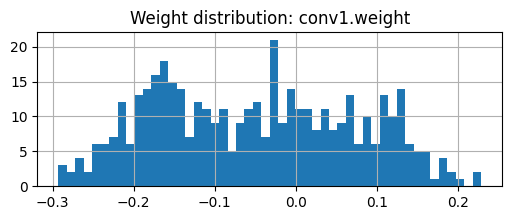

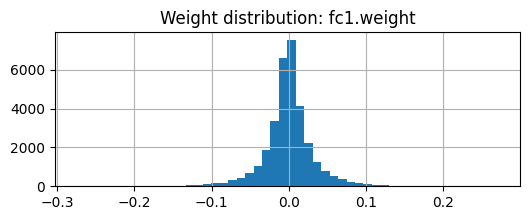

In [ ]:
#Vẽ histogram của weight từng layer
for name, param in model.named_parameters():
    if 'weight' in name:
        plt.figure(figsize=(6, 2))
        plt.hist(param.data.cpu().numpy().flatten(), bins=50)
        plt.title(f"Weight distribution: {name}")
        plt.grid(True)
        plt.show()


In [ ]:
#In trọng số & độ lệch từng layer
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"\nLayer: {name}")
        print(f"Shape: {param.shape}")
        print(f"Mean: {param.data.mean():.6f}, Std: {param.data.std():.6f}")



Layer: conv1.weight
Shape: torch.Size([16, 3, 3, 3])
Mean: -0.050397, Std: 0.122603

Layer: conv1.bias
Shape: torch.Size([16])
Mean: -0.049131, Std: 0.058231

Layer: fc1.weight
Shape: torch.Size([2, 16384])
Mean: 0.000014, Std: 0.034475

Layer: fc1.bias
Shape: torch.Size([2])
Mean: -0.000179, Std: 0.100064
